# WGISD Masking pipeline jupyter notebook

Welcome to our final project for UMich ROB 498: Deep Learning for Robot Perception. This notebook contains an implementation of a MaskRCNN on the custom Wine Grape Instance Segmentation Dataset (WGISD) for grape bunch segmentation as implemented by [Santos *et al.*](https://arxiv.org/pdf/1907.11819.pdf). We aim to reproduce the grape masking results seen in [Santos *et al.*](https://arxiv.org/pdf/1907.11819.pdf) and [Lin *et al.*](https://doi.org/10.3389/frobt.2021.626989). 

Let's start by running some imports

In [1]:
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon

from skimage.color import label2rgb

import colorsys
import random

import os

In [2]:
torch.__version__

'2.1.2'

The following example creates a `Dataset` object for the grape *masking* set. There are a total of 110 mask annotation available to use for training and testing.

In [2]:
class WGISDMaskedDataset(Dataset):
    def __init__(self, root, transforms=None, source='train'):
        self.root = root
        self.transforms = transforms
        
        # Let's load the dataset subset defined by source
        if source not in ('train', 'test'):
            print('source should by "train" or "test"')
            return None

        source_path = os.path.join(root, f'{source}_masked.txt')
        with open(source_path, 'r') as fp:
          # Read all lines in file
          lines = fp.readlines()
          # Recover the items ids, removing the \n at the end
          ids = [l.rstrip() for l in lines]

        self.imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
        self.masks = [os.path.join(root, 'data', f'{id}.npz') for id in ids]
        self.boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

    def __getitem__(self, idx):
        # Load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        box_path = self.boxes[idx]

        img = Image.open(img_path).convert("RGB")

        # From TorchVision documentation:
        # 
        # The models expect a list of Tensor[C, H, W], in the range 0-1. 
        # The models internally resize the images so that they have a minimum 
        # size of 800. This option can be changed by passing the option min_size 
        # to the constructor of the models.
        
        if self.transforms is None:
            img = np.array(img)
            # Normalize
            img = (img - img.min()) / np.max([img.max() - img.min(), 1])
            # Move the channels axe to the first position, getting C, H, W instead H, W, C
            img = np.moveaxis(img, -1, 0)
            img = torch.as_tensor(img, dtype=torch.float32)  
        else:
            img = np.array(img)
            img = self.transforms(torch.as_tensor(img, dtype=torch.uint8))
            img = np.array(img)
            # Normalize
            img = (img - img.min()) / np.max([img.max() - img.min(), 1])
            # move o eixo final para frente, para termos C, H, W e não H, W, C
            img = np.moveaxis(img, -1, 0)
            img = torch.as_tensor(img, dtype=torch.float32)  

        # Loading masks:
        #
        # As seen in WGISD (README.md):
        # 
        # After assigning the NumPy array to a variable M, the mask for the 
        # i-th grape cluster can be found in M[:,:,i]. The i-th mask corresponds 
        # to the i-th line in the bounding boxes file.
        #
        # According to Mask RCNN documentation in Torchvision:
        #
        # During training, the model expects both the input tensors, as well as 
        # a targets (list of dictionary), containing:
        # (...) 
        # masks (UInt8Tensor[N, H, W]): the segmentation binary masks for each 
        # instance
        #
        # WGISD provides [H, W, N] masks, but Torchvision asks for [N, H, W]. Lett's
        # employ NumPy moveaxis.
        wgisd_masks = np.load(mask_path)['arr_0'].astype(np.uint8)
        masks = np.moveaxis(wgisd_masks, -1, 0) 

        num_objs = masks.shape[0]
        all_text = np.loadtxt(box_path, delimiter = " ", dtype = np.float32)
        wgisd_boxes = all_text[:,1:]
        assert(wgisd_boxes.shape[0] == num_objs)

        # IMPORTANT: Torchvision considers 0 as background. So, let's make grapes
        # grapes as class 1
        labels = np.ones(num_objs, dtype=np.int64)

        # According to WGISD:
        #
        # These text files follows the "YOLO format"
        # 
        # CLASS CX CY W H
        # 
        # class is an integer defining the object class – the dataset presents 
        # only the grape class that is numbered 0, so every line starts with 
        # this "class zero" indicator. The center of the bounding box is the 
        # point (c_x, c_y), represented as float values because this format 
        # normalizes the coordinates by the image dimensions. To get the 
        # absolute position, use (2048 c_x, 1365 c_y). The bounding box 
        # dimensions are given by W and H, also normalized by the image size.
        #
        # Torchvision's Mask R-CNN expects absolute coordinates.
        _, height, width = img.shape

        boxes = []
        for box in wgisd_boxes:
            x1 = box[0] - box[2]/2
            x2 = box[0] + box[2]/2
            y1 = box[1] - box[3]/2
            y2 = box[1] + box[3]/2
            boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])
        
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # max_num_boxes_in_batch = 15
        # boxes = self.pad_boxes(boxes, max_num_boxes=max_num_boxes_in_batch)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # ou poderíamos usar
        # labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id
        }

        return img, target

    def __len__(self):
        return len(self.imgs)

Load the dataset

In [3]:
# Here, the WGISD root is ./
dataset = WGISDMaskedDataset('./')
print(f'Loaded dataset of size {dataset.__len__()}\n')

print('Item shapes: ')
img, target = dataset.__getitem__(0)
for k, v in target.items():
    print(k, v.shape, v.dtype)

Loaded dataset of size 110

Item shapes: 
boxes torch.Size([13, 4]) torch.float32
labels torch.Size([13]) torch.int64
masks torch.Size([13, 1365, 2048]) torch.uint8
image_id torch.Size([1]) torch.int64


Run the following cell to visualize some examples from the dataset.

In [4]:
def random_colors(n_colors, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n_colors, 1, brightness) for i in range(n_colors)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def show_item(img, boxes, mask):

    fig, (ax0, ax1) = plt.subplots(figsize=(20,10), ncols=2)
    # Number of instances
    n_boxes = boxes.shape[0]

    # Generate random colors
    colors = random_colors(n_boxes)

    for i, (x0, y0, x1, y1) in enumerate(boxes):
        color = np.array(colors[i])
        box_width = x1 - x0
        box_height = y1 - y0
        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax0.add_patch(p)
        ax0.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax1.add_patch(p)
        ax1.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        ax0.imshow(np.moveaxis(img, 0, -1))

    mask = np.moveaxis(mask, 0, -1)
    labels = np.zeros(mask.shape[0:2])
    for i in range(n_boxes):
        labels[mask[:,:,i] == 1] = i + 1
    
    mask_rgb = label2rgb(labels, colors=colors, bg_label=0)
    ax1.imshow(mask_rgb)

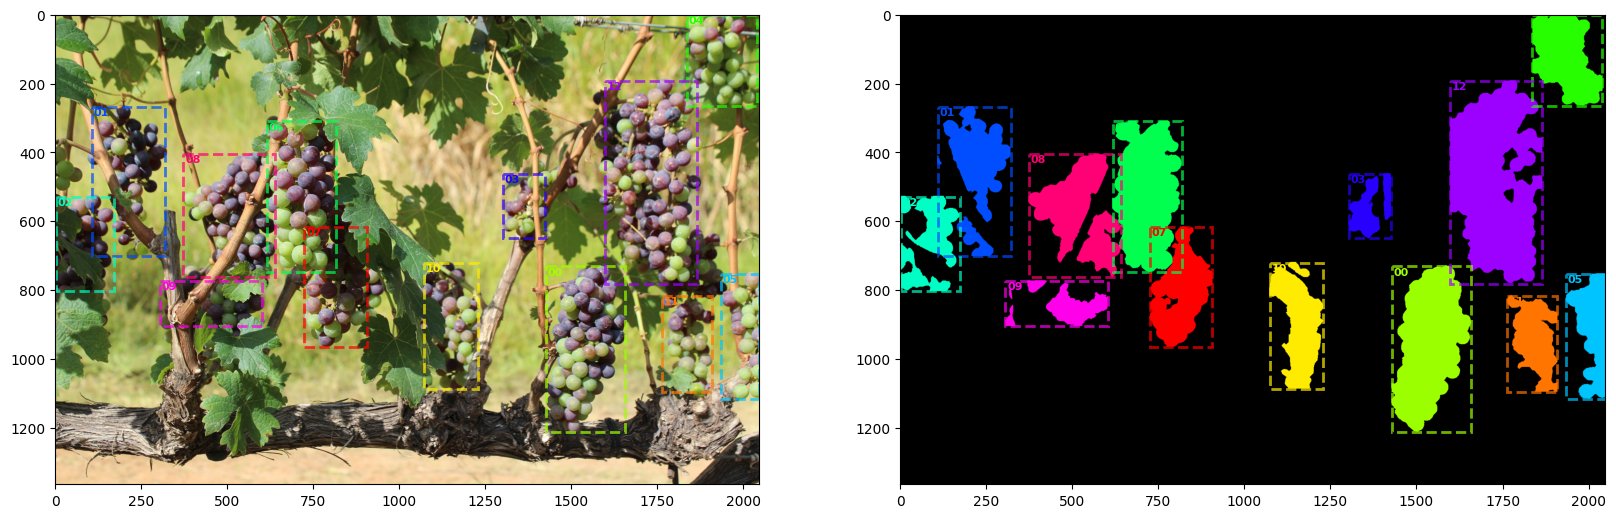

In [6]:
show_item(img.numpy(), target['boxes'].numpy(), target['masks'].numpy())

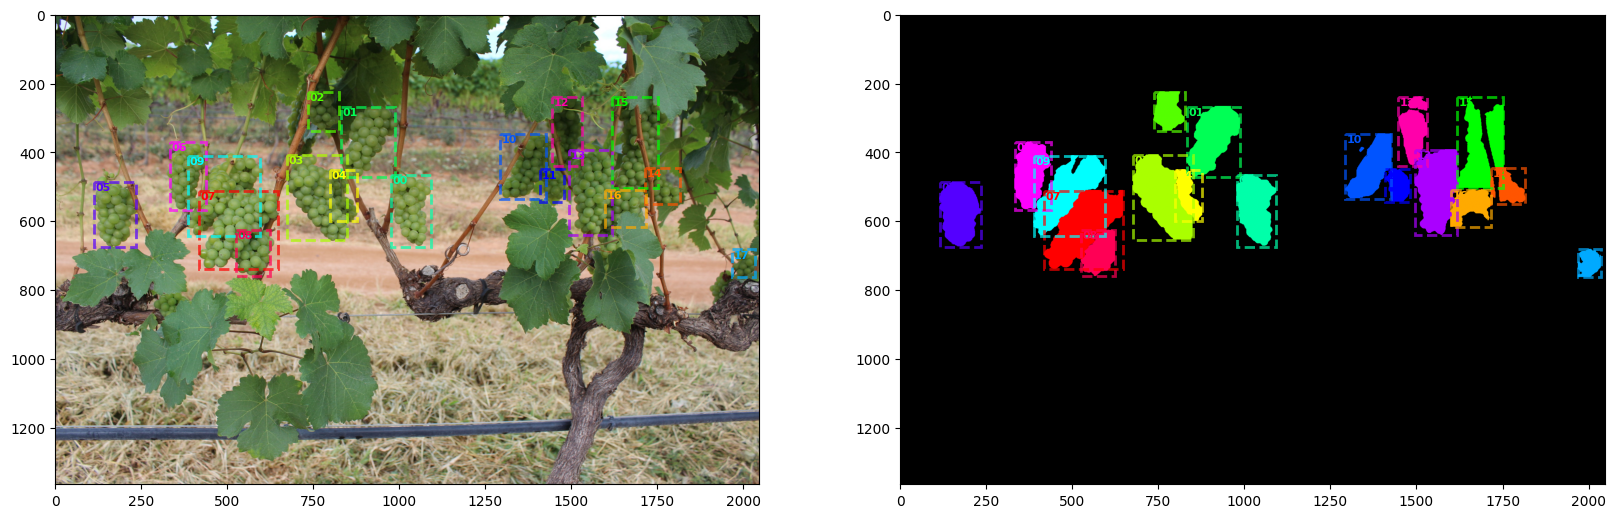

In [7]:
img, target = dataset[16]
show_item(img.numpy(), target['boxes'].numpy(), target['masks'].numpy())

# Torchvision Mask RCNN for segmentation of grape bunches

The following section implements a Mask RCNN for grape masking. We will implement the model, train the MaskRCNN and evaluate its average iou. The following cell sets up important functions that will be used during training and testing.

In [7]:
import os
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torch
from torchvision.transforms import transforms as T
from torch.utils.data import DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import faster_rcnn
from torchvision.models.detection import mask_rcnn

import matplotlib.pyplot as plt

def get_instance_segmentation_model(num_classes):
    
    model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    
    hidden_layer = 256
    model.roi_heads.mask_predictor = mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model


def train_one_epoch(model, optimizer, data_loader, device, tot_loss_hist, silly=False):
    epoch_loss_hist = []
    model.train()
    for batch_idx, (images, targets) in enumerate(data_loader):

        #move device if in colab
        # images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # image = images.to(device)
        # targets = [targets]
        # targets[0]['boxes'] = targets[0]['boxes'].squeeze(0)
        # targets[0]['labels'] = targets[0]['labels'].squeeze(0)

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Loss: {losses.item()}')
            
        epoch_loss_hist.append(losses.item())
        tot_loss_hist.append(losses.item())
    
    print(f'Average epoch loss: {sum(epoch_loss_hist)/len(epoch_loss_hist)}\n')
    epoch_loss_hist.clear()

def iou(groundtruth_mask, pred_mask):
    intersect = torch.sum(pred_mask * groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    iou = (intersect/union).item()
    return iou

def average_img_iou(preds, gts):
    ious = torch.zeros(gts.shape[0], preds.shape[0])
    for i, gt in enumerate(gts):
        for j, pr in enumerate(preds):
            current_iou = iou(gt, pr)
            ious[i, j] = current_iou

    avg_iou = ious.max(dim=1).values.mean().item()
    return avg_iou

def display_sorted_masks(image, masks):
    mask_sums = masks.view(masks.size(0), -1).sum(dim=1)
    sorted_indices = torch.argsort(mask_sums, descending=True)
    predicted_masks = masks[sorted_indices]

    num_masks = predicted_masks.shape[0] if predicted_masks.shape[0] < 6 else 6
    num_rows = (num_masks - 1) // 3 + 1
    num_cols = min(num_masks, 3)

    plt.figure(figsize=(15, 10))

    for i in range(num_masks):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.imshow(predicted_masks[i].permute(1, 2, 0).cpu().numpy(), alpha=0.5)
        plt.title(f'Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    best_mask = predicted_masks[0]
    return best_mask

def sort_masks_by_sum(masks):
    mask_sums = masks.view(masks.size(0), -1).sum(dim=1)
    sorted_indices = torch.argsort(mask_sums, descending=True)
    predicted_masks = masks[sorted_indices]
    return predicted_masks

Define the dataset, dataloader and model to prepare for training

In [6]:
# Define the dataset
dataset = WGISDMaskedDataset('./')

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

train_dataset = torch.utils.data.Subset(dataset, indices[:100])
test_dataset = torch.utils.data.Subset(dataset, indices[100:110])

def collate_fn(batch):
    return tuple(zip(*batch))  

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=True, collate_fn=collate_fn)
print(f'Train set of size {train_dataset.__len__()} loaded')
print(f'Test set of size {test_dataset.__len__()} loaded')

num_classes = 2  #grape and background
model = get_instance_segmentation_model(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

Train set of size 100 loaded
Test set of size 10 loaded


Run training for num_epochs. Adjust num_epochs, lr, and weight_decay as needed.

In [ ]:
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-3)

loss_history = []
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, loss_history)

print(f'Trained {num_epochs} epochs..')

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Save model after training..

In [ ]:
torch.save(model.state_dict(), 'wgisd_v1.6.pth')

Load model for inference

In [9]:
num_classes = 2  #grape and background
grape_model = get_instance_segmentation_model(num_classes)
grape_model.load_state_dict(torch.load('wgisd_v1.5.pth'))
grape_model.eval()

print('model set to eval!')

model set to eval!


Visualize an example result on 'grapes_test.jpeg'

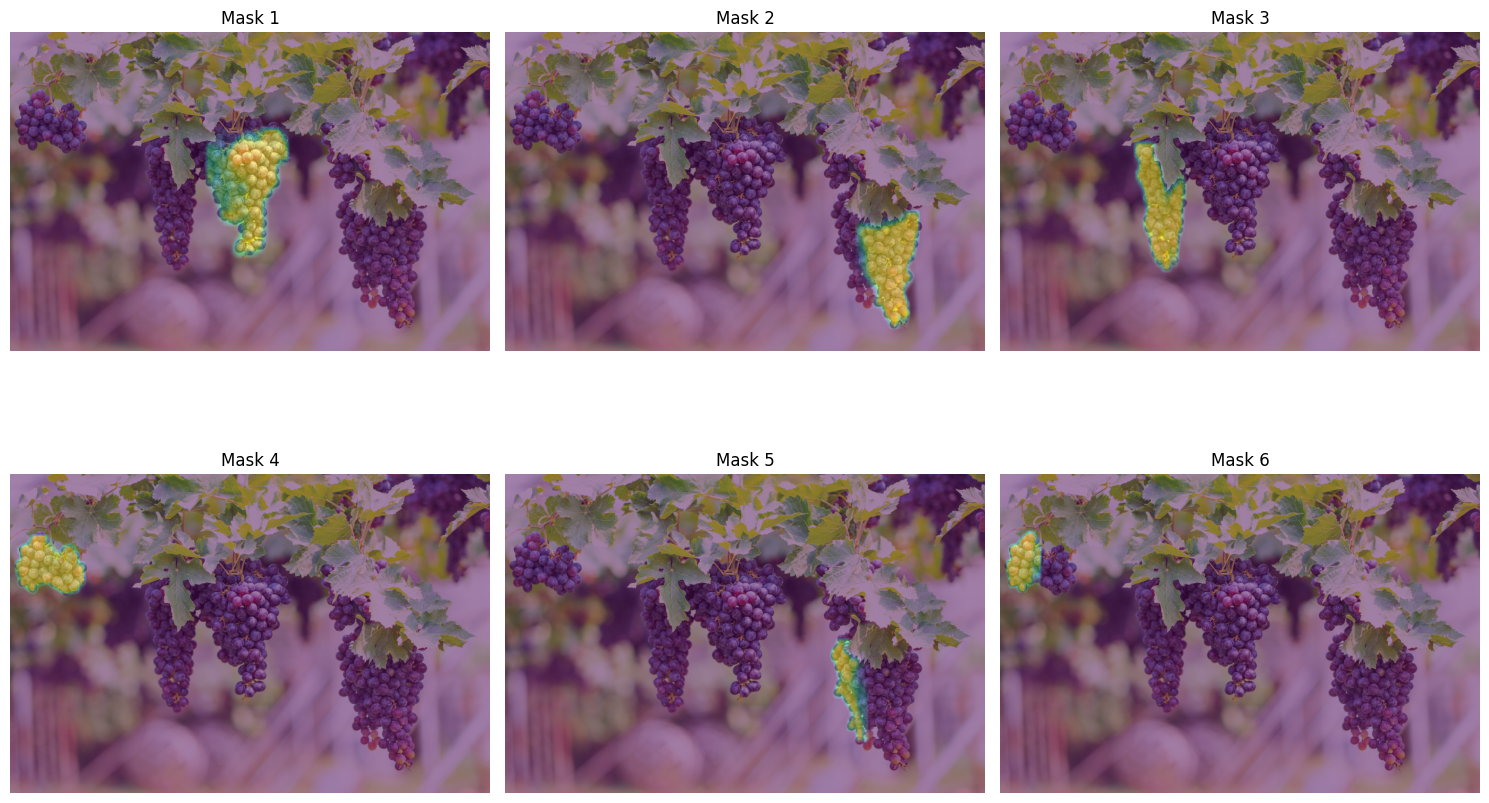

bbox shape: torch.Size([13, 4])
masks shape: torch.Size([13, 1, 1412, 2124])


In [10]:
import torch
from torchvision.transforms.functional import to_tensor
from PIL import Image
import matplotlib.pyplot as plt

test = Image.open('grapes_test.jpeg')
test_tensor = to_tensor(test).unsqueeze(0)

with torch.no_grad():
    prediction = grape_model(test_tensor)
    prediction = prediction.pop()

predicted_boxes = prediction['boxes']
predicted_masks = prediction['masks']

best_mask = display_sorted_masks(test, predicted_masks)

print(f'bbox shape: {predicted_boxes.shape}')
print(f'masks shape: {predicted_masks.shape}')

Run the following code to evaluate test set average iou. Our best average iou was about 73%!

In [10]:
#Evaluate model
test_set = WGISDMaskedDataset('./', source='test')
test_loader = DataLoader(test_set, batch_size=1)

avg_ious = []
for i, (image, target) in enumerate(test_loader):
    out = grape_model(image).pop()
    pred_masks = out['masks']
    #get from npz file directly, targets not working properly
    gt_masks = to_tensor(np.load(test_set.masks[i])['arr_0']).unsqueeze(1)
    avg_iou = average_img_iou(pred_masks, gt_masks)
    avg_ious.append(avg_iou)

print(f'Test set avg iou: {sum(avg_ious)*100/len(avg_ious)} %')

Test set avg iou: 71.37046721246507 %


# Testing 3D point cloud reconstruction

The following section focsues on recinstructing a grape point cloud given a grape mask. We will experiment with DepthAnything, a large model for monocular depth estimation. Let's first load DepthAnything.

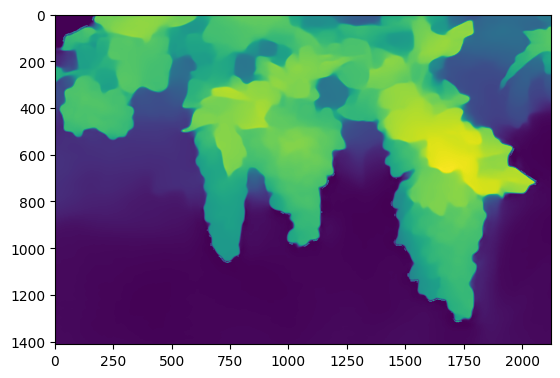

In [12]:
from transformers import pipeline

# load pipe
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

# load image
image = Image.open('grapes_test.jpeg')

# inference
out = pipe(image)
depth_map = out['predicted_depth']
depth_img = out['depth']

plt.imshow(depth_img)
plt.show()

"best_mask" from the example cell contains the mask of the biggest mask. For grapes_test.jpeg, that is the prominent one in the center. We will use this to build and experiment with our 3D reconstruction pipeline.

In [10]:
print('Center grape bunch mask: ',best_mask.shape)

Center grape bunch mask:  torch.Size([1, 1412, 2124])


We define the camera parameters in this cell. This will help us reproject our 2d pixel coordinates to world coordinates, which we can attach the DepthAnything pixel depth to.

In [16]:
fx = 18
fy = 18
cx = best_mask.shape[0] / 2
cy = best_mask.shape[1] / 2

K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
K_inv = np.linalg.inv(K)

Crop the depth map to just the grape mask.

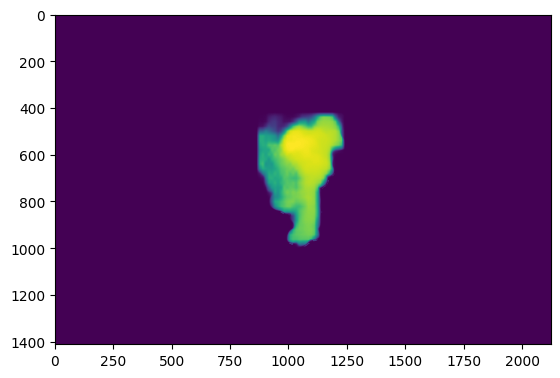

In [13]:
import numpy as np

grape_mask = best_mask.squeeze(0)
depth_tensor = to_tensor(depth_img).squeeze(0) * grape_mask

plt.imshow(depth_tensor.numpy())
plt.show()

This cell contains a function point_cloud_reconstruction() that generates a point cloud of a grape bunch given the cropped depth map tensor and inverse camera matrix.

In [14]:
def point_cloud_reconstruction(depth_tensor, K_inv, sparse_point_cloud=False, sparse_points=2000):
    points = []
    for y, row in enumerate(depth_tensor):
        for x, val in enumerate(row):
            if val != 0:
                
                point_pixel = np.array([x, y, 1])
                point_camera = np.matmul(K_inv, point_pixel)
                depth_value = depth_tensor[y, x]
                if depth_value < 0.2 or depth_value > 0.95:
                    continue

                point_camera[2] = depth_value
                points.append(point_camera)

    points = np.array(points)
    
    if not sparse_point_cloud:
        print(f'Constructed {len(points)} 3d points from mask and depth')
        return points
    else:
        sample_indices = np.random.choice(len(points), size=sparse_points, replace=False)
        points = points[sample_indices]
        print(f'Constructed {len(points)} 3d points from mask and depth')
        return points

Reconstruct the point cloud

In [17]:
points = point_cloud_reconstruction(depth_tensor, K_inv, sparse_point_cloud=True, sparse_points=8500)

Constructed 8500 3d points from mask and depth


Let's visualize out reconstructed point cloud. Looks pretty cool!

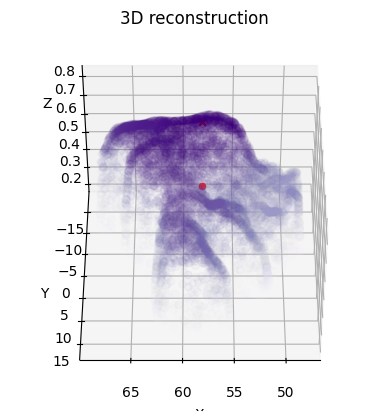

Bunch center: [58.154549019607835, -2.3929738562091516, 0.6066459624854957]


In [18]:
#Visualize point cloud plot
import matplotlib.pyplot as plt

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

mean_point = [np.mean(x), np.mean(y), np.mean(z)]
estimated_cutting_from_bunch_center = [mean_point[0], np.min(y) - 2, mean_point[2]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=z, cmap='Purples', alpha=0.04, s=30) # grape point cloud
ax.scatter(mean_point[0], mean_point[1], mean_point[2], c='red', marker='o') # bunch center
ax.scatter(mean_point[0], np.min(y) - 2, mean_point[2], c='red', marker='x', s=25) #estimated cutting point


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D reconstruction')
ax.view_init(elev=45, azim=90, roll=0)
ax.autoscale_view()

plt.show()

print(f'Bunch center: {mean_point}')

# Cylinder fitting

This section contains the reproduction of the RANSAC cylinder fitting algorithm proposed in [Lin *et al.*](https://doi.org/10.3389/frobt.2021.626989) for grape rotational pose estimation. We'll go through this step by step.

Construct the grape point cloud 3D bounding box first

In [16]:
import numpy as np

def get_bbox_edges(points):
    # Calculate the bounding box dimensions
    xmax, xmin = np.max(points[:, 0]), np.min(points[:, 0])
    ymax, ymin = np.max(points[:, 1]), np.min(points[:, 1])
    zmax, zmin = np.max(points[:, 2]), np.min(points[:, 2])
    
    bbox_vertices = np.array([[xmin, ymin, zmin],
                              [xmax, ymin, zmin],
                              [xmin, ymax, zmin],
                              [xmin, ymin, zmax],
                              [xmax, ymax, zmin],
                              [xmax, ymax, zmax],
                              [xmax, ymin, zmax],
                              [xmin, ymax, zmax]])
    
    bbox_edges = [
        (bbox_vertices[0], bbox_vertices[1]),
        (bbox_vertices[0], bbox_vertices[2]),
        (bbox_vertices[0], bbox_vertices[3]),

        (bbox_vertices[1], bbox_vertices[4]),
        (bbox_vertices[1], bbox_vertices[6]),

        (bbox_vertices[2], bbox_vertices[4]),
        (bbox_vertices[2], bbox_vertices[7]),

        (bbox_vertices[3], bbox_vertices[6]),
        (bbox_vertices[3], bbox_vertices[7]),

        (bbox_vertices[4], bbox_vertices[5]),

        (bbox_vertices[5], bbox_vertices[6]),
        (bbox_vertices[5], bbox_vertices[7]),

    ]
    
    return bbox_vertices, bbox_edges

Viusalize the 3D bounding box

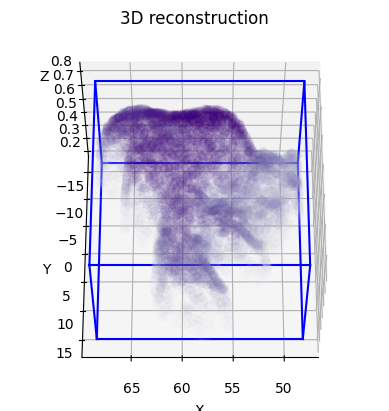

Bunch center: [58.045346405228756, -2.360189542483661, 0.6078174433603006]


In [17]:
#Visualize point cloud plot
import matplotlib.pyplot as plt

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

mean_point = [np.mean(x), np.mean(y), np.mean(z)]
estimated_cutting_from_bunch_center = [mean_point[0], np.min(y) - 2, mean_point[2]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=z, cmap='Purples', alpha=0.04, s=30) # grape point cloud

bbox_vertices, bbox_edges = get_bbox_edges(points)

for edge in bbox_edges:
    x, y, z = zip(*edge)
    ax.plot(x, y, z, color='b')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D reconstruction')
ax.view_init(elev=60, azim=90, roll=0)
ax.autoscale_view()

plt.show()

print(f'Bunch center: {mean_point}')

Use pyransac3d to iteratively refine a cylinder to fit the point cloud. The axis of this cylinder will help us define the pose of the grape bunch.

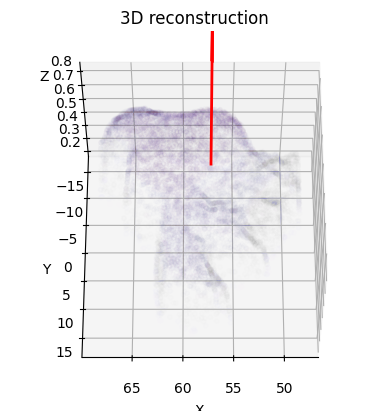

In [45]:
from pyransac3d import Cylinder

center, axis, radius, inliers = Cylinder.fit(self=Cylinder, pts=points, thresh=0.2, maxIteration=500)

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=z, cmap='Purples', alpha=0.01, s=10) # grape point cloud
ax.quiver(center[0], center[1], center[2], axis[0], axis[1], axis[2], length=np.linalg.norm(axis), color='r', linewidth=2) #axis

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D reconstruction')
ax.view_init(elev=60, azim=90, roll=0)
ax.autoscale_view()

plt.show()

In [1]:
from cylinder_fitting.fitting import *
from cylinder_fitting.analysis import *
from cylinder_fitting.geometry import *
from cylinder_fitting.visualize import *

# print(points.shape)
import copy

# t2 = copy.copy(points)
# t2[:, 2] = t2[:, 2] * 20

# data = copy.copy(t2)
    
# open at your risk!
data = [[57.416666666666664, -4.944444444444443, 15.277236700057983],
[61.24999999999999, -6.833333333333336, 15.425039529800415],
[51.69444444444444, 1.7222222222222214, 9.185534119606018],
[55.08333333333333, -4.0, 13.569029569625854],
[59.69444444444444, 1.9444444444444429, 14.173808097839355],
[61.30555555555555, -2.0, 15.02789855003357],
[61.69444444444444, 10.5, 11.604753732681274],
[63.08333333333333, -2.944444444444443, 15.115225315093994],
[60.74999999999999, -14.555555555555557, 4.698044061660767],
[52.52777777777777, 2.611111111111107, 9.128379821777344],
[61.80555555555555, -3.388888888888893, 15.358266830444336],
[64.41666666666667, -8.277777777777779, 14.920605421066284],
[52.416666666666664, -1.5, 10.379352569580078],
[63.30555555555555, -7.277777777777779, 15.03306269645691],
[62.638888888888886, 10.055555555555557, 5.064736604690552],
[51.30555555555555, -11.222222222222221, 5.77422559261322],
[66.02777777777779, -14.444444444444446, 11.060323715209961],
[60.36111111111111, 11.277777777777779, 13.038606643676758],
[61.97222222222222, -11.11111111111111, 15.185409784317017],
[52.97222222222222, 0.7222222222222214, 9.601359963417053],
[57.52777777777777, -1.4444444444444429, 12.612518072128296],
[57.36111111111111, -2.8333333333333357, 14.014922380447388],
[57.916666666666664, -8.055555555555557, 16.23189091682434],
[57.30555555555555, 3.055555555555557, 12.806583642959595],
[64.69444444444444, -3.444444444444443, 14.621835947036743],
[50.02777777777777, -10.833333333333336, 8.153505325317383],
[53.74999999999999, -10.277777777777779, 9.70715582370758],
[61.58333333333333, 3.3888888888888857, 13.326338529586792],
[61.02777777777777, -4.333333333333336, 15.427542924880981],
[58.47222222222222, -14.38888888888889, 4.451936781406403],
[50.47222222222222, -12.0, 4.660992622375488],
[59.638888888888886, 13.05555555555555, 12.788753509521484],
[60.47222222222222, -9.722222222222221, 15.750095844268799],
[64.08333333333334, -2.6111111111111143, 14.77857232093811],
[49.58333333333333, -7.388888888888889, 9.748005867004395],
[65.52777777777779, -13.277777777777779, 13.66613507270813],
[59.52777777777777, -4.611111111111114, 15.452754497528076],
[51.97222222222222, -2.944444444444443, 9.74344551563263],
[68.19444444444444, -8.944444444444446, 9.389263391494751],
[58.97222222222222, 7.833333333333329, 12.77288556098938],
[58.30555555555555, 6.166666666666664, 11.90677523612976],
[52.638888888888886, 1.8333333333333286, 9.271126389503479],
[52.52777777777777, 3.6666666666666643, 8.424077033996582],
[56.916666666666664, 0.3333333333333286, 11.51528000831604],
[48.86111111111111, -5.611111111111114, 9.75029468536377],
[63.47222222222222, -15.444444444444446, 5.317002534866333],
[60.916666666666664, 8.055555555555557, 13.404990434646606],
[58.30555555555555, -3.7777777777777786, 15.016696453094482],
[55.80555555555555, 14.05555555555555, 10.246939659118652],
[65.75, -5.666666666666664, 5.069761276245117],
[62.638888888888886, -6.277777777777779, 15.200469493865967],
[63.47222222222222, -3.5, 15.181659460067749],
[60.02777777777777, -4.111111111111114, 15.323693752288818],
[63.36111111111111, -11.055555555555557, 15.002940893173218],
[59.58333333333333, -11.444444444444446, 15.094468593597412],
[53.138888888888886, 2.2777777777777786, 9.138880968093872],
[67.08333333333334, -12.277777777777779, 11.979125738143921],
[55.97222222222222, -11.11111111111111, 15.466567277908325],
[61.638888888888886, 12.944444444444443, 11.42305850982666],
[53.19444444444444, -3.388888888888893, 11.647197008132935],
[63.08333333333333, -13.222222222222221, 13.751634359359741],
[55.74999999999999, 4.444444444444443, 12.495907545089722],
[58.02777777777777, -12.666666666666668, 13.081215620040894],
[59.08333333333333, -4.055555555555557, 15.23034930229187],
[59.80555555555555, 11.333333333333329, 13.030014038085938],
[59.86111111111111, 14.388888888888886, 11.733369827270508],
[57.74999999999999, 12.388888888888886, 12.275583744049072],
[59.30555555555555, 8.666666666666664, 13.117603063583374],
[59.52777777777777, 0.8333333333333286, 14.355645179748535],
[63.80555555555555, -8.444444444444446, 15.019357204437256],
[52.69444444444444, -0.7222222222222214, 10.045353174209595],
[62.58333333333333, 10.333333333333329, 5.301249027252197],
[56.638888888888886, -3.6666666666666643, 14.295867681503296],
[63.80555555555555, -6.444444444444443, 14.93952751159668],
[51.138888888888886, -10.38888888888889, 8.721092343330383],
[59.02777777777777, -10.277777777777779, 15.693696737289429],
[66.69444444444444, -12.5, 12.895255088806152],
[63.86111111111111, -9.277777777777779, 15.021765232086182],
[58.24999999999999, 5.111111111111107, 12.911490201950073],
[60.69444444444444, 8.277777777777779, 13.460026979446411],
[60.80555555555555, -1.3333333333333357, 14.923131465911865],
[57.02777777777777, -4.722222222222221, 15.145900249481201],
[62.02777777777777, -5.722222222222221, 15.43783187866211],
[60.02777777777777, -0.6666666666666714, 14.581903219223022],
[61.916666666666664, -13.833333333333336, 10.798780918121338],
[50.138888888888886, -9.0, 9.631056785583496],
[61.74999999999999, -3.8333333333333357, 15.438779592514038],
[62.19444444444444, 7.388888888888886, 10.679750442504883],
[56.638888888888886, -0.38888888888889284, 11.229079961776733],
[61.638888888888886, -6.222222222222221, 15.436739921569824],
[55.638888888888886, -4.555555555555557, 14.354844093322754],
[67.80555555555556, -11.11111111111111, 8.527392745018005],
[62.58333333333333, -12.666666666666668, 13.8322913646698],
[62.86111111111111, -13.88888888888889, 13.06896448135376],
[62.02777777777777, 0.44444444444444287, 14.234023094177246],
[62.36111111111111, 9.0, 8.868134617805481],
[58.638888888888886, 5.833333333333329, 12.531125545501709],
[56.97222222222222, -0.9444444444444429, 11.668081283569336],
[60.638888888888886, 14.388888888888886, 8.571122884750366],
[60.30555555555555, 6.888888888888886, 13.648346662521362],
[56.916666666666664, -5.5, 15.319832563400269],
[57.74999999999999, 6.333333333333329, 11.321314573287964],
[48.52777777777777, -5.444444444444443, 8.751314282417297],
[62.24999999999999, -14.11111111111111, 11.44783616065979],
[65.97222222222223, -13.88888888888889, 12.706660032272339],
[62.69444444444444, 4.111111111111107, 5.27742326259613],
[55.47222222222222, 13.333333333333329, 7.0111143589019775],
[59.08333333333333, -13.555555555555557, 9.044232964515686],
[52.08333333333333, -9.5, 8.720943331718445],
[62.47222222222222, -3.888888888888893, 15.435138940811157],
[50.02777777777777, -6.777777777777779, 9.670917391777039],
[58.36111111111111, -12.444444444444446, 13.602949380874634],
[64.80555555555556, -13.833333333333336, 13.565932512283325],
[59.69444444444444, -12.055555555555557, 13.293254375457764],
[55.47222222222222, 14.111111111111107, 7.239074110984802],
[56.69444444444444, 0.44444444444444287, 11.68398380279541],
[57.19444444444444, -11.333333333333336, 15.729389190673828],
[56.638888888888886, 8.055555555555557, 7.48676598072052],
[60.916666666666664, 9.111111111111107, 13.361139297485352],
[63.30555555555555, 1.1111111111111072, 10.009666681289673],
[65.52777777777779, -10.0, 14.64678406715393],
[53.74999999999999, -3.555555555555557, 12.435464859008789],
[54.36111111111111, -7.666666666666668, 15.39444088935852],
[55.52777777777777, 13.777777777777779, 7.6645320653915405],
[48.52777777777777, -6.555555555555557, 8.243694305419922],
[59.58333333333333, -2.6666666666666714, 15.19787311553955],
[53.24999999999999, -8.166666666666668, 12.670782804489136],
[54.58333333333333, -9.777777777777779, 14.633229970932007],
[51.19444444444444, -10.055555555555557, 9.073827862739563],
[57.97222222222222, -0.9444444444444429, 13.079577684402466],
[61.138888888888886, -4.888888888888893, 15.508288145065308],
[65.13888888888889, -5.388888888888893, 13.674169778823853],
[65.19444444444444, -13.555555555555557, 13.716520071029663],
[54.638888888888886, -7.5, 15.691574811935425],
[60.30555555555555, -0.44444444444444287, 14.627587795257568],
[49.69444444444444, -9.333333333333336, 9.740836024284363],
[51.30555555555555, -8.777777777777779, 10.307209491729736],
[48.36111111111111, -3.5, 6.913782358169556],
[56.36111111111111, 12.444444444444443, 9.647811651229858],
[62.416666666666664, -2.2777777777777786, 15.032060146331787],
[64.30555555555556, -11.722222222222221, 14.44303274154663],
[66.30555555555556, -12.0, 13.79686713218689],
[53.30555555555555, 5.388888888888886, 10.753915309906006],
[59.74999999999999, 7.722222222222221, 13.344815969467163],
[61.97222222222222, 4.222222222222221, 11.356778144836426],
[49.86111111111111, -2.055555555555557, 8.852336406707764],
[57.19444444444444, 10.722222222222221, 9.998978972434998],
[60.138888888888886, -13.055555555555557, 8.934478759765625],
[59.74999999999999, 11.166666666666664, 12.99912691116333],
[54.916666666666664, 1.7222222222222214, 11.803326606750488],
[64.41666666666667, -4.0, 14.980677366256714],
[58.58333333333333, -0.5555555555555571, 13.603479862213135],
[60.916666666666664, 8.777777777777779, 13.369899988174438],
[61.52777777777777, -7.944444444444446, 15.5856192111969],
[55.638888888888886, 13.0, 7.6574766635894775],
[49.138888888888886, -11.666666666666668, 4.328590035438538],
[64.69444444444444, -7.555555555555557, 14.740005731582642],
[50.08333333333333, -11.88888888888889, 4.882624447345734],
[61.24999999999999, -0.22222222222222143, 14.623156785964966],
[61.74999999999999, 4.388888888888886, 12.44370698928833],
[63.36111111111111, -15.166666666666668, 8.390250205993652],
[56.86111111111111, -13.0, 8.722962141036987],
[61.52777777777777, 7.277777777777779, 13.40397596359253],
[65.30555555555556, -7.333333333333336, 13.727819919586182],
[54.24999999999999, -1.9444444444444429, 11.87266230583191],
[59.74999999999999, -14.444444444444446, 4.379816651344299],
[61.47222222222222, 6.5, 13.2566237449646],
[53.58333333333333, 2.8333333333333286, 9.946289658546448],
[56.36111111111111, -12.333333333333336, 11.661427021026611],
[50.47222222222222, 1.1666666666666643, 6.546467542648315],
[50.416666666666664, -8.166666666666668, 10.8905029296875],
[54.638888888888886, -11.833333333333336, 6.694211959838867],
[61.80555555555555, 6.5, 12.184104919433594],
[61.80555555555555, 1.0555555555555571, 14.03430700302124],
[60.58333333333333, 7.944444444444443, 13.449822664260864],
[55.30555555555555, -11.5, 12.806426286697388],
[58.916666666666664, 5.055555555555557, 13.230680227279663],
[53.138888888888886, 6.666666666666664, 9.547032117843628],
[54.916666666666664, -4.388888888888893, 13.662216663360596],
[49.97222222222222, -10.722222222222221, 8.346150517463684],
[49.916666666666664, -2.6111111111111143, 9.443591237068176],
[59.97222222222222, -4.944444444444443, 15.559333562850952],
[54.69444444444444, -2.944444444444443, 12.648049592971802],
[58.47222222222222, -3.7777777777777786, 15.055519342422485],
[49.916666666666664, -6.666666666666664, 9.612987637519836],
[60.86111111111111, 9.888888888888886, 13.287519216537476],
[56.08333333333333, 2.6666666666666643, 12.543816566467285],
[59.80555555555555, -4.888888888888893, 15.549429655075073],
[64.52777777777779, -2.1111111111111143, 13.992668390274048],
[58.638888888888886, -4.388888888888893, 15.227270126342773],
[58.80555555555555, -10.5, 15.685290098190308],
[61.02777777777777, -9.444444444444446, 15.703779458999634],
[51.80555555555555, -2.555555555555557, 9.41931664943695],
[63.86111111111111, -13.61111111111111, 13.761570453643799],
[53.47222222222222, 3.7777777777777786, 9.63128924369812],
[61.138888888888886, -3.444444444444443, 15.34866452217102],
[65.80555555555556, -10.444444444444446, 14.584232568740845],
[57.52777777777777, 14.444444444444443, 11.064766645431519],
[65.19444444444444, -4.222222222222221, 13.586050271987915],
[55.52777777777777, 14.666666666666664, 6.350278854370117],
[59.138888888888886, 11.166666666666664, 12.86026120185852],
[53.416666666666664, -5.388888888888893, 12.922978401184082],
[50.97222222222222, -10.666666666666668, 7.9678380489349365],
[52.47222222222222, -4.0, 11.129274368286133],
[57.638888888888886, 7.944444444444443, 10.736562013626099],
[62.74999999999999, -2.2222222222222214, 14.949586391448975],
[54.80555555555555, 0.5555555555555571, 11.76170825958252],
[58.86111111111111, 11.777777777777779, 12.732101678848267],
[50.69444444444444, 0.5, 9.396782517433167],
[52.19444444444444, 3.444444444444443, 8.812274932861328],
[64.02777777777779, -10.055555555555557, 15.017050504684448],
[58.58333333333333, 11.833333333333329, 12.58846640586853],
[57.638888888888886, 13.277777777777779, 12.163074016571045],
[56.74999999999999, -1.8333333333333357, 12.56122350692749],
[54.638888888888886, -11.61111111111111, 8.024595379829407],
[55.916666666666664, -5.5, 14.973146915435791],
[57.69444444444444, 6.111111111111107, 11.60884976387024],
[59.47222222222222, -0.44444444444444287, 14.375884532928467],
[57.30555555555555, -11.333333333333336, 15.735148191452026],
[58.19444444444444, -3.1666666666666714, 14.71498966217041],
[51.86111111111111, -1.7222222222222214, 9.935302734375],
[60.47222222222222, 0.8333333333333286, 14.548478126525879],
[62.416666666666664, 7.944444444444443, 8.813044428825378],
[50.58333333333333, -0.22222222222222143, 9.340482354164124],
[57.19444444444444, 0.5555555555555571, 11.497424840927124],
[61.80555555555555, -4.5, 15.513694286346436],
[63.138888888888886, -5.5, 15.200448036193848],
[50.47222222222222, 1.7777777777777786, 4.56785649061203],
[66.08333333333334, -7.555555555555557, 11.49035930633545],
[57.86111111111111, 12.888888888888886, 12.274209260940552],
[57.86111111111111, 10.055555555555557, 11.613736152648926],
[59.19444444444444, 2.1666666666666643, 13.887187242507935],
[66.75, -14.0, 8.826011419296265],
[59.69444444444444, 10.611111111111107, 13.07124376296997],
[56.30555555555555, -3.444444444444443, 13.809139728546143],
[55.416666666666664, 13.666666666666664, 6.537885069847107],
[52.916666666666664, 6.888888888888886, 7.892179489135742],
[67.47222222222223, -9.277777777777779, 13.280338048934937],
[51.97222222222222, -9.222222222222221, 8.978491425514221],
[63.74999999999999, -10.38888888888889, 15.096296072006226],
[60.138888888888886, 7.777777777777779, 13.507261276245117],
[64.36111111111111, -1.6111111111111143, 13.820087909698486],
[59.47222222222222, 14.666666666666664, 10.186173915863037],
[62.416666666666664, 11.222222222222221, 6.049589514732361],
[59.416666666666664, -10.333333333333336, 15.57533860206604],
[67.30555555555556, -12.555555555555557, 10.972135066986084],
[61.19444444444444, -5.222222222222221, 15.587356090545654],
[57.58333333333333, -4.611111111111114, 15.17158031463623],
[56.19444444444444, 3.6666666666666643, 12.714840173721313],
[49.86111111111111, -2.1111111111111143, 8.946303725242615],
[60.47222222222222, -1.6666666666666714, 14.974198341369629],
[53.97222222222222, -1.6666666666666714, 11.681448221206665],
[66.91666666666667, -14.555555555555557, 4.183902740478516],
[67.36111111111111, -7.166666666666664, 5.356473922729492],
[60.638888888888886, -5.722222222222221, 15.655735731124878],
[65.63888888888889, -9.777777777777779, 14.624029397964478],
[61.19444444444444, -5.0, 15.509042739868164],
[65.13888888888889, -12.555555555555557, 13.944451808929443],
[67.97222222222223, -12.333333333333336, 5.586425065994263],
[52.36111111111111, -7.333333333333336, 11.996361017227173],
[52.416666666666664, 4.333333333333329, 8.163971900939941],
[56.69444444444444, -3.2222222222222214, 13.855992555618286],
[64.41666666666667, -9.722222222222221, 15.006814002990723],
[57.916666666666664, 6.111111111111107, 11.676509380340576],
[58.19444444444444, 15.222222222222221, 7.601532340049744],
[54.58333333333333, 0.6111111111111072, 11.553080081939697],
[49.30555555555555, -11.277777777777779, 6.0363417863845825],
[61.638888888888886, -8.833333333333336, 15.655198097229004],
[49.86111111111111, -8.166666666666668, 10.02400517463684],
[54.08333333333333, 2.7222222222222214, 11.187443733215332],
[63.52777777777777, -7.055555555555557, 15.027310848236084],
[52.916666666666664, -10.0, 6.59544050693512],
[59.08333333333333, -0.27777777777777857, 13.97647500038147],
[63.19444444444444, -10.166666666666668, 15.181306600570679],
[64.75, -2.888888888888893, 14.402647018432617],
[59.74999999999999, -10.944444444444446, 15.209579467773438],
[56.47222222222222, 5.111111111111107, 12.979977130889893],
[59.416666666666664, 0.8888888888888857, 14.327327013015747],
[58.30555555555555, -7.166666666666664, 16.008795499801636],
[65.47222222222223, -3.555555555555557, 11.204785108566284],
[55.80555555555555, -4.388888888888893, 14.29175615310669],
[51.138888888888886, -8.277777777777779, 11.327202320098877],
[57.19444444444444, -12.38888888888889, 13.542050123214722],
[61.36111111111111, 12.333333333333329, 12.497032880783081],
[50.02777777777777, -0.055555555555557135, 6.012468934059143],
[61.24999999999999, 9.111111111111107, 13.206217288970947],
[66.91666666666667, -9.222222222222221, 13.921840190887451],
[55.138888888888886, -10.666666666666668, 14.663511514663696],
[50.58333333333333, -10.055555555555557, 9.338347315788269],
[54.52777777777777, 7.111111111111107, 10.615488290786743],
[58.416666666666664, -11.88888888888889, 14.589673280715942],
[50.97222222222222, -9.0, 10.044077634811401],
[59.86111111111111, -4.277777777777779, 15.3090238571167],
[65.19444444444444, -5.722222222222221, 13.043673038482666],
[50.86111111111111, -12.277777777777779, 4.119358062744141],
[56.36111111111111, -0.5555555555555571, 11.479064226150513],
[63.58333333333333, -3.555555555555557, 15.177797079086304],
[65.58333333333334, -4.111111111111114, 9.801679253578186],
[58.58333333333333, -4.277777777777779, 15.208255052566528],
[54.74999999999999, 5.666666666666664, 12.421547174453735],
[61.638888888888886, 0.44444444444444287, 14.406577348709106],
[61.58333333333333, 2.555555555555557, 13.558681011199951],
[57.416666666666664, 0.5, 11.8275785446167],
[60.638888888888886, -2.6666666666666714, 15.157372951507568],
[62.24999999999999, -13.444444444444446, 12.926496267318726],
[64.08333333333334, -4.777777777777779, 15.005894899368286],
[59.47222222222222, 1.7777777777777786, 14.20488715171814],
[57.02777777777777, -1.7777777777777786, 12.549000978469849],
[57.80555555555555, 13.666666666666664, 12.018808126449585],
[52.138888888888886, 6.388888888888886, 7.74811327457428],
[55.24999999999999, 14.05555555555555, 4.704826474189758],
[67.58333333333334, -12.277777777777779, 9.211449027061462],
[66.25, -12.11111111111111, 13.719274997711182],
[57.80555555555555, 12.944444444444443, 12.284961938858032],
[65.80555555555556, -5.166666666666664, 5.325546860694885],
[62.47222222222222, -0.9444444444444429, 14.692608118057251],
[66.19444444444444, -7.333333333333336, 9.964798092842102],
[62.52777777777777, -12.666666666666668, 13.796910047531128],
[61.52777777777777, -5.277777777777779, 15.515882968902588],
[52.02777777777777, -2.388888888888893, 9.628220200538635],
[61.138888888888886, -7.444444444444446, 15.572928190231323],
[62.638888888888886, 10.611111111111107, 4.5740050077438354],
[50.138888888888886, -6.222222222222221, 9.626522660255432],
[59.86111111111111, 8.944444444444443, 13.391790390014648],
[50.74999999999999, -7.555555555555557, 10.823289155960083],
[61.52777777777777, 1.2222222222222214, 14.245431423187256],
[53.08333333333333, -8.222222222222221, 11.954278945922852],
[61.638888888888886, -7.055555555555557, 15.429340600967407],
[59.24999999999999, -1.7777777777777786, 14.819105863571167],
[63.47222222222222, -3.888888888888893, 15.18521785736084],
[64.25, 0.11111111111110716, 7.98498272895813],
[54.02777777777777, 6.166666666666664, 11.640198230743408],
[48.86111111111111, -2.6111111111111143, 8.908483982086182],
[65.08333333333334, -12.833333333333336, 13.930137157440186],
[66.25, -12.055555555555557, 13.80460262298584],
[65.97222222222223, -7.944444444444446, 13.474923372268677],
[49.74999999999999, -0.8888888888888928, 6.111779808998108],
[54.416666666666664, -6.166666666666664, 14.606361389160156],
[63.24999999999999, 1.7222222222222214, 5.4230427742004395],
[58.02777777777777, 8.111111111111107, 11.66016936302185],
[62.58333333333333, 8.111111111111107, 7.076127529144287],
[55.80555555555555, 7.388888888888886, 10.150971412658691],
[60.19444444444444, -12.666666666666668, 10.587445497512817],
[63.416666666666664, -14.777777777777779, 12.757042646408081],
[56.52777777777777, 2.944444444444443, 12.949174642562866],
[65.80555555555556, -5.0, 5.610330104827881],
[59.97222222222222, -8.666666666666668, 16.017651557922363],
[48.638888888888886, -3.7222222222222214, 10.201040506362915],
[59.916666666666664, -8.0, 15.942931175231934],
[62.416666666666664, 1.0, 13.542898893356323],
[57.916666666666664, 7.444444444444443, 11.51339054107666],
[48.97222222222222, -3.3333333333333357, 10.40347695350647],
[60.138888888888886, 7.0, 13.627679347991943],
[59.08333333333333, -12.166666666666668, 13.56913685798645],
[59.74999999999999, -8.11111111111111, 16.0027277469635],
[51.47222222222222, 5.722222222222221, 4.133043587207794],
[61.80555555555555, -3.1111111111111143, 15.276237726211548],
[50.86111111111111, -11.5, 5.600295662879944],
[63.52777777777777, -10.666666666666668, 15.092663764953613],
[63.916666666666664, -15.333333333333332, 6.703394651412964],
[58.52777777777777, 0.7777777777777786, 13.554037809371948],
[58.97222222222222, -4.666666666666664, 15.426902770996094],
[58.138888888888886, -4.555555555555557, 15.260028839111328],
[67.86111111111111, -10.333333333333336, 11.519042253494263],
[56.97222222222222, 14.888888888888886, 8.213635683059692],
[56.97222222222222, -3.1111111111111143, 13.858823776245117],
[57.80555555555555, 9.666666666666664, 11.237577199935913],
[48.30555555555555, -6.833333333333336, 5.407618880271912],
[58.47222222222222, 11.666666666666664, 12.605106830596924],
[58.02777777777777, -0.5555555555555571, 12.679678201675415],
[62.08333333333333, -9.833333333333336, 15.322951078414917],
[61.916666666666664, -2.5, 15.111643075942993],
[57.52777777777777, 5.5, 12.317055463790894],
[50.24999999999999, -6.222222222222221, 9.742291569709778],
[59.97222222222222, -7.944444444444446, 15.948880910873413],
[67.08333333333334, -12.0, 12.414904832839966],
[56.416666666666664, 6.333333333333329, 12.013683319091797],
[59.916666666666664, -2.888888888888893, 15.251932144165039],
[65.25, -9.5, 14.809223413467407],
[49.916666666666664, -10.333333333333336, 9.298914670944214],
[61.24999999999999, -3.055555555555557, 15.269190073013306],
[54.47222222222222, -3.1666666666666714, 12.666759490966797],
[59.916666666666664, 10.333333333333329, 13.23010802268982],
[60.30555555555555, -5.055555555555557, 15.572371482849121],
[66.47222222222223, -8.722222222222221, 14.004075527191162],
[48.30555555555555, -4.444444444444443, 6.162225008010864],
[56.638888888888886, 0.7777777777777786, 12.029834985733032],
[59.74999999999999, 5.5, 13.585153818130493],
[50.80555555555555, -3.7777777777777786, 8.835188746452332],
[61.97222222222222, 11.833333333333329, 9.27427351474762],
[48.86111111111111, -2.2222222222222214, 7.535571455955505],
[55.74999999999999, 1.8888888888888857, 12.164644002914429],
[54.86111111111111, 6.611111111111107, 12.11491584777832],
[62.916666666666664, -4.888888888888893, 15.360168218612671],
[56.416666666666664, 1.7222222222222214, 12.191871404647827],
[65.75, -10.944444444444446, 14.566364288330078],
[59.69444444444444, -10.88888888888889, 15.306394100189209],
[52.74999999999999, -10.11111111111111, 6.674827933311462],
[51.02777777777777, -4.833333333333336, 9.456143379211426],
[61.416666666666664, -7.5, 15.5819833278656],
[50.416666666666664, -7.055555555555557, 9.756369590759277],
[57.97222222222222, -11.555555555555557, 15.377280712127686],
[60.47222222222222, 12.05555555555555, 13.024284839630127],
[60.86111111111111, 6.166666666666664, 13.644202947616577],
[61.47222222222222, 10.722222222222221, 12.577292919158936],
[63.19444444444444, -5.555555555555557, 15.198698043823242],
[61.58333333333333, 14.166666666666664, 7.155090570449829],
[67.02777777777779, -7.5, 8.673917651176453],
[52.30555555555555, 3.7222222222222214, 8.418521881103516],
[64.02777777777779, -4.055555555555557, 15.081371068954468],
[59.80555555555555, 7.944444444444443, 13.388310670852661],
[60.19444444444444, -8.166666666666668, 15.957837104797363],
[59.416666666666664, -13.222222222222221, 9.957404732704163],
[49.47222222222222, -9.61111111111111, 9.969210624694824],
[60.47222222222222, -14.333333333333336, 5.11413037776947],
[56.24999999999999, -1.3333333333333357, 12.241700887680054],
[65.97222222222223, -11.833333333333336, 14.129995107650757],
[60.86111111111111, 7.444444444444443, 13.491076231002808],
[62.02777777777777, -7.388888888888889, 15.42565107345581],
[52.138888888888886, -3.7222222222222214, 10.56656002998352],
[65.86111111111111, -6.444444444444443, 4.787485897541046],
[60.36111111111111, 0.27777777777777857, 14.582054615020752],
[66.75, -14.38888888888889, 5.999665260314941],
[56.47222222222222, -9.055555555555557, 16.022948026657104],
[65.97222222222223, -6.722222222222221, 6.393797397613525],
[60.30555555555555, 8.388888888888886, 13.429005146026611],
[58.02777777777777, -5.666666666666664, 15.48258900642395],
[56.916666666666664, -5.222222222222221, 15.26712417602539],
[52.69444444444444, -8.833333333333336, 9.593483805656433],
[55.08333333333333, -2.8333333333333357, 12.852815389633179],
[50.36111111111111, -9.88888888888889, 9.38809871673584],
[53.19444444444444, 4.777777777777779, 9.659352898597717],
[50.19444444444444, -12.055555555555557, 4.294800162315369],
[56.47222222222222, -13.166666666666668, 6.23961865901947],
[63.74999999999999, -6.5, 14.94266390800476],
[64.91666666666667, -8.833333333333336, 14.885410070419312],
[51.02777777777777, -0.22222222222222143, 10.257138013839722],
[53.138888888888886, -2.388888888888893, 10.986741781234741],
[51.74999999999999, -2.7222222222222214, 9.375733733177185],
[57.58333333333333, 12.944444444444443, 12.222501039505005],
[57.69444444444444, -6.111111111111114, 15.547738075256348],
[58.02777777777777, 12.888888888888886, 12.347105741500854],
[58.97222222222222, 8.944444444444443, 12.846566438674927],
[58.36111111111111, -1.3333333333333357, 13.921478986740112],
[53.30555555555555, 4.888888888888886, 9.956932663917542],
[56.24999999999999, -2.388888888888893, 12.744841575622559],
[61.58333333333333, -14.88888888888889, 5.8134132623672485],
[61.24999999999999, 5.222222222222221, 13.670909404754639],
[59.36111111111111, 3.1666666666666643, 13.831418752670288],
[58.08333333333333, 5.166666666666664, 12.750892639160156],
[57.58333333333333, -7.111111111111114, 15.99652647972107],
[48.86111111111111, -5.055555555555557, 9.921884536743164],
[57.97222222222222, 5.833333333333329, 12.05916166305542],
[64.97222222222223, -10.555555555555557, 14.755891561508179],
[57.138888888888886, 1.1666666666666643, 11.73144817352295],
[65.47222222222223, -13.666666666666668, 13.54426622390747],
[63.416666666666664, -3.5, 15.18413782119751],
[50.30555555555555, -2.7222222222222214, 9.16339635848999],
[53.138888888888886, 7.055555555555557, 7.695766091346741],
[64.13888888888889, -7.0, 14.840368032455444],
[56.638888888888886, 4.166666666666664, 12.822037935256958],
[52.36111111111111, -2.3333333333333357, 9.94912564754486],
[54.74999999999999, 0.27777777777777857, 11.747363805770874],
[63.416666666666664, -14.944444444444446, 11.01037859916687],
[48.36111111111111, -7.666666666666668, 6.447542905807495],
[59.02777777777777, -6.833333333333336, 15.930103063583374],
[53.74999999999999, -1.2777777777777786, 11.40840768814087],
[55.30555555555555, -6.833333333333336, 15.966178178787231],
[49.36111111111111, -8.11111111111111, 10.169525146484375],
[51.24999999999999, -11.777777777777779, 4.589590132236481],
[61.69444444444444, -8.0, 15.58445692062378],
[60.47222222222222, -14.166666666666668, 5.680382251739502],
[54.24999999999999, 4.944444444444443, 11.541789770126343],
[57.86111111111111, -13.777777777777779, 7.1390604972839355],
[59.52777777777777, -3.5, 15.236951112747192],
[61.86111111111111, -5.666666666666664, 15.516936779022217],
[61.47222222222222, 7.666666666666664, 13.388700485229492],
[56.638888888888886, -12.555555555555557, 11.823285818099976],
[50.08333333333333, -1.3888888888888928, 8.213984966278076],
[61.69444444444444, 6.777777777777779, 12.67419695854187],
[54.86111111111111, -8.11111111111111, 15.994832515716553],
[65.69444444444444, -8.11111111111111, 14.311110973358154],
[65.41666666666667, -13.055555555555557, 13.71852993965149],
[66.86111111111111, -11.666666666666668, 13.476647138595581],
[55.52777777777777, -12.722222222222221, 5.327267646789551],
[55.47222222222222, 3.2222222222222214, 12.648253440856934],
[50.02777777777777, -9.444444444444446, 9.382928013801575],
[59.30555555555555, -5.0, 15.521208047866821],
[54.97222222222222, -11.666666666666668, 9.846194386482239],
[55.97222222222222, 4.111111111111107, 12.531185150146484],
[49.416666666666664, -1.2222222222222214, 5.8791184425354],
[52.916666666666664, 4.666666666666664, 9.042409062385559],
[53.02777777777777, 2.7777777777777786, 8.866646885871887],
[58.47222222222222, 12.111111111111107, 12.581477165222168],
[60.24999999999999, 12.333333333333329, 13.019134998321533],
[59.36111111111111, 7.333333333333329, 13.019031286239624],
[51.69444444444444, 3.7222222222222214, 5.604463815689087],
[51.97222222222222, 4.5, 7.211120128631592],
[59.47222222222222, -0.9444444444444429, 14.588351249694824],
[60.08333333333333, 10.388888888888886, 13.192528486251831],
[55.138888888888886, -2.6666666666666714, 12.720370292663574],
[53.08333333333333, -3.7777777777777786, 11.722017526626587],
[62.74999999999999, -13.0, 13.672370910644531],
[53.02777777777777, -8.777777777777779, 10.174096822738647],
[61.47222222222222, -0.7777777777777786, 14.793192148208618],
[61.30555555555555, -2.444444444444443, 15.10648488998413],
[59.86111111111111, 3.3333333333333286, 13.98114562034607],
[51.19444444444444, 0.6666666666666643, 9.616703987121582],
[49.86111111111111, -11.666666666666668, 5.518617033958435],
[63.638888888888886, -8.61111111111111, 15.02548098564148],
[57.58333333333333, -5.833333333333336, 15.5107581615448],
[62.138888888888886, 6.666666666666664, 10.771455764770508],
[66.02777777777779, -6.833333333333336, 7.310048341751099],
[56.58333333333333, 3.6666666666666643, 12.923215627670288],
[58.24999999999999, -5.111111111111114, 15.393275022506714],
[52.58333333333333, -0.6666666666666714, 10.0836181640625],
[51.80555555555555, -4.055555555555557, 10.107804536819458],
[61.74999999999999, 8.333333333333329, 12.399535179138184],
[58.69444444444444, 0.5555555555555571, 13.633595705032349],
[67.47222222222223, -11.61111111111111, 11.745342016220093],
[48.30555555555555, -2.444444444444443, 4.737004935741425],
[61.02777777777777, -13.88888888888889, 7.926990985870361],
[56.58333333333333, -8.11111111111111, 16.24895215034485],
[60.80555555555555, 12.333333333333329, 12.978252172470093],
[54.19444444444444, 1.4444444444444429, 11.245604753494263],
[57.58333333333333, 3.8333333333333286, 13.074663877487183],
[62.30555555555555, -3.1666666666666714, 15.273778438568115],
[61.74999999999999, 10.5, 11.222543716430664],
[59.74999999999999, 7.944444444444443, 13.287920951843262],
[66.58333333333334, -8.222222222222221, 13.469318151473999],
[59.80555555555555, 1.6666666666666643, 14.279441833496094],
[59.916666666666664, 7.333333333333329, 13.456056118011475],
[56.74999999999999, -5.0, 15.092709064483643],
[67.19444444444444, -11.944444444444446, 12.260379791259766],
[58.638888888888886, 13.611111111111107, 12.334245443344116],
[66.75, -11.166666666666668, 14.086813926696777],
[48.52777777777777, -8.0, 8.852301836013794],
[58.02777777777777, 9.777777777777779, 11.918251514434814],
[58.138888888888886, 2.444444444444443, 13.077895641326904],
[57.74999999999999, -8.166666666666668, 16.237870454788208],
[57.47222222222222, -13.055555555555557, 9.93817150592804],
[63.69444444444444, -4.166666666666664, 15.179463624954224],
[62.74999999999999, -1.4444444444444429, 14.765350818634033],
[63.416666666666664, -11.88888888888889, 14.58611011505127],
[61.30555555555555, 12.5, 12.515730857849121],
[60.02777777777777, 9.333333333333329, 13.357884883880615],
[63.638888888888886, -3.944444444444443, 15.17932653427124],
[65.25, -0.9444444444444429, 5.361670255661011],
[62.638888888888886, -8.222222222222221, 15.26943325996399],
[59.24999999999999, 10.777777777777779, 12.894095182418823],
[61.916666666666664, -4.888888888888893, 15.513519048690796],
[58.58333333333333, 9.777777777777779, 12.639919519424438],
[53.86111111111111, -6.888888888888893, 14.079726934432983],
[65.02777777777779, -13.5, 13.737350702285767],
[60.58333333333333, -8.222222222222221, 15.869394540786743],
[58.80555555555555, -1.6111111111111143, 14.406653642654419],
[57.36111111111111, -4.111111111111114, 14.779961109161377],
[66.86111111111111, -7.833333333333336, 11.382995843887329],
[49.36111111111111, -3.2222222222222214, 10.708423852920532],
[62.74999999999999, 0.27777777777777857, 13.95567536354065],
[64.19444444444444, 0.9444444444444429, 4.082852005958557],
[63.36111111111111, -15.444444444444446, 5.263448357582092],
[52.30555555555555, 0.6111111111111072, 10.135127305984497],
[52.86111111111111, 5.611111111111107, 10.182455778121948],
[50.36111111111111, -6.5, 9.787731170654297],
[48.69444444444444, -11.222222222222221, 6.040210723876953],
[58.30555555555555, 7.055555555555557, 11.870287656784058],
[51.916666666666664, -5.0, 11.1752188205719],
[66.86111111111111, -14.555555555555557, 4.493780136108398],
[67.97222222222223, -8.61111111111111, 11.742024421691895],
[63.86111111111111, -4.611111111111114, 15.096312761306763],
[57.52777777777777, 11.277777777777779, 11.612882614135742],
[49.74999999999999, -7.277777777777779, 9.722546935081482],
[64.30555555555556, -13.055555555555557, 13.865201473236084],
[55.30555555555555, -0.7222222222222214, 11.98715329170227],
[61.86111111111111, -1.8333333333333357, 15.03474235534668],
[62.02777777777777, 13.611111111111107, 6.744995713233948],
[61.58333333333333, -13.777777777777779, 9.412882328033447],
[59.416666666666664, 14.333333333333329, 12.016005516052246],
[64.80555555555556, -5.111111111111114, 14.20690655708313],
[56.638888888888886, -12.88888888888889, 9.00347650051117],
[65.58333333333334, -13.277777777777779, 13.654452562332153],
[60.36111111111111, 0.6666666666666643, 14.533681869506836],
[64.69444444444444, -2.888888888888893, 14.462828636169434],
[67.69444444444444, -11.944444444444446, 9.311294555664062],
[53.47222222222222, 3.3333333333333286, 9.81902539730072],
[48.416666666666664, -11.222222222222221, 4.613993465900421],
[57.52777777777777, -10.944444444444446, 15.85081696510315],
[58.80555555555555, 1.5, 13.737095594406128],
[57.02777777777777, -13.055555555555557, 8.767186999320984],
[58.58333333333333, -4.666666666666664, 15.324556827545166],
[58.02777777777777, 4.5, 13.10492753982544],
[61.02777777777777, -8.055555555555557, 15.716639757156372],
[61.52777777777777, -2.7777777777777786, 15.193778276443481],
[53.638888888888886, 3.7222222222222214, 10.080764293670654],
[58.36111111111111, -3.8333333333333357, 15.036917924880981],
[61.30555555555555, 10.0, 12.998119592666626],
[58.36111111111111, -3.444444444444443, 14.879276752471924],
[61.80555555555555, -11.38888888888889, 15.096856355667114],
[54.47222222222222, -3.8333333333333357, 13.01026701927185],
[59.19444444444444, -2.888888888888893, 15.060925483703613],
[59.80555555555555, 13.222222222222221, 12.797284126281738],
[56.80555555555555, -4.166666666666664, 14.629720449447632],
[50.19444444444444, -4.222222222222221, 9.143585562705994],
[60.74999999999999, 10.833333333333329, 13.059325218200684],
[55.638888888888886, 14.666666666666664, 7.3030686378479],
[52.30555555555555, -0.055555555555557135, 9.817395210266113],
[53.52777777777777, -10.055555555555557, 9.173877239227295],
[50.24999999999999, -11.833333333333336, 5.121687650680542],
[56.24999999999999, 15.05555555555555, 5.908999443054199],
[64.86111111111111, -10.777777777777779, 14.762704372406006],
[56.97222222222222, -12.722222222222221, 11.209951639175415],
[61.02777777777777, 13.111111111111107, 12.60938286781311],
[51.86111111111111, -4.944444444444443, 11.076867580413818],
[60.638888888888886, -12.222222222222221, 12.294303178787231],
[57.138888888888886, 11.444444444444443, 10.762948989868164],
[52.19444444444444, -6.222222222222221, 12.224706411361694],
[61.86111111111111, 7.555555555555557, 12.088786363601685],
[62.19444444444444, 0.055555555555557135, 14.379218816757202],
[53.80555555555555, 1.7222222222222214, 10.24520993232727],
[55.69444444444444, 3.0, 12.522197961807251],
[63.47222222222222, 0.22222222222222143, 12.311311960220337],
[65.75, -6.944444444444443, 10.542888641357422],
[55.24999999999999, -4.388888888888893, 13.907840251922607],
[61.80555555555555, -2.3333333333333357, 15.111616849899292],
[58.69444444444444, 14.611111111111107, 10.56408405303955],
[48.916666666666664, -5.277777777777779, 9.921785593032837],
[58.74999999999999, -11.61111111111111, 14.948495626449585],
[52.916666666666664, -0.055555555555557135, 9.85211730003357],
[65.30555555555556, -4.111111111111114, 12.476834058761597],
[58.19444444444444, 1.7777777777777786, 12.98001766204834],
[54.69444444444444, 6.555555555555557, 12.111085653305054],
[63.30555555555555, 0.7777777777777786, 11.546781063079834],
[49.36111111111111, -4.611111111111114, 10.332237482070923],
[63.638888888888886, -8.555555555555557, 15.02509593963623],
[61.97222222222222, -12.777777777777779, 13.099600076675415],
[63.19444444444444, 1.4444444444444429, 8.956687450408936],
[53.02777777777777, -1.5, 10.414707660675049],
[56.138888888888886, 13.444444444444443, 10.805201530456543],
[63.52777777777777, 0.38888888888888573, 11.516302824020386],
[66.91666666666667, -9.61111111111111, 13.91268253326416],
[49.916666666666664, -0.44444444444444287, 6.019614338874817],
[61.52777777777777, -13.88888888888889, 8.883943557739258],
[48.69444444444444, -3.3333333333333357, 9.832741618156433],
[63.74999999999999, -2.0, 14.49897050857544],
[48.75, -7.777777777777779, 9.480770826339722],
[64.19444444444444, -7.944444444444446, 14.925792217254639],
[52.74999999999999, -9.222222222222221, 8.405596613883972],
[65.58333333333334, -9.444444444444446, 14.682984352111816],
[65.63888888888889, -10.277777777777779, 14.663975238800049],
[54.97222222222222, 1.8333333333333286, 11.786911487579346],
[60.30555555555555, 1.3333333333333286, 14.447429180145264],
[50.638888888888886, 1.3333333333333286, 7.172763347625732],
[57.138888888888886, 1.5, 11.722426414489746],
[65.69444444444444, -4.444444444444443, 7.56841778755188],
[49.69444444444444, -11.38888888888889, 6.370446681976318],
[57.69444444444444, 3.7222222222222214, 13.134771585464478],
[63.638888888888886, -9.88888888888889, 15.101500749588013],
[51.08333333333333, -5.944444444444443, 10.656689405441284],
[64.25, -7.888888888888889, 14.923251867294312],
[65.80555555555556, -13.222222222222221, 13.54382038116455],
[57.08333333333333, -2.444444444444443, 13.519068956375122],
[60.30555555555555, 12.611111111111107, 12.916011810302734],
[50.08333333333333, -3.388888888888893, 8.608425259590149],
[59.138888888888886, -13.666666666666668, 8.673993349075317],
[64.19444444444444, -7.444444444444446, 14.92016077041626],
[57.80555555555555, 13.0, 12.293027639389038],
[63.138888888888886, -10.944444444444446, 15.156614780426025],
[56.138888888888886, 4.722222222222221, 12.76277780532837],
[60.19444444444444, 7.166666666666664, 13.592971563339233],
[54.08333333333333, 0.5555555555555571, 11.047437191009521],
[66.19444444444444, -7.666666666666668, 11.684129238128662],
[52.19444444444444, 4.5, 8.295632004737854],
[57.08333333333333, 1.5, 11.76301121711731],
[51.916666666666664, -2.388888888888893, 9.550042152404785],
[55.86111111111111, 5.111111111111107, 12.865281105041504],
[62.24999999999999, 2.6666666666666643, 10.81928014755249],
[60.24999999999999, 6.888888888888886, 13.655736446380615],
[53.74999999999999, -8.5, 13.690325021743774],
[65.47222222222223, -11.61111111111111, 14.425477981567383],
[63.24999999999999, -6.888888888888893, 15.035463571548462],
[59.08333333333333, -4.888888888888893, 15.514479875564575],
[56.69444444444444, -7.055555555555557, 16.07264757156372],
[50.638888888888886, -4.888888888888893, 9.039584994316101],
[60.02777777777777, 11.0, 13.151031732559204],
[52.97222222222222, 2.611111111111107, 8.862053155899048],
[56.02777777777777, -1.5, 12.177287340164185],
[58.638888888888886, -1.0555555555555571, 13.977818489074707],
[59.24999999999999, 4.833333333333329, 13.522205352783203],
[60.30555555555555, 10.055555555555557, 13.26270580291748],
[60.24999999999999, 5.944444444444443, 13.832106590270996],
[56.08333333333333, -0.8333333333333357, 11.755359172821045],
[54.138888888888886, 0.38888888888888573, 11.167629957199097],
[58.86111111111111, 1.7222222222222214, 13.690781593322754],
[64.86111111111111, -8.11111111111111, 14.770909547805786],
[58.74999999999999, 15.222222222222221, 7.1850502490997314],
[52.19444444444444, 0.055555555555557135, 9.877023100852966],
[64.13888888888889, -3.2777777777777786, 14.971245527267456],
[63.24999999999999, -12.722222222222221, 14.041783809661865],
[61.08333333333333, -10.5, 15.442676544189453],
[52.69444444444444, 6.166666666666664, 9.573554396629333],
[65.25, -3.388888888888893, 13.264371156692505],
[62.80555555555555, -6.944444444444443, 15.197149515151978],
[53.80555555555555, -10.0, 10.765947103500366],
[50.47222222222222, -6.666666666666664, 9.787333011627197],
[61.80555555555555, -13.722222222222221, 10.600298643112183],
[59.638888888888886, 7.888888888888886, 13.234930038452148],
[51.86111111111111, -5.555555555555557, 11.458770036697388],
[67.41666666666667, -9.5, 13.317372798919678],
[56.638888888888886, 4.666666666666664, 12.905008792877197],
[60.19444444444444, 1.0, 14.543766975402832],
[67.41666666666667, -13.38888888888889, 6.5517377853393555],
[53.36111111111111, -10.222222222222221, 8.001086711883545],
[54.58333333333333, 7.944444444444443, 5.64050018787384],
[63.97222222222222, -14.777777777777779, 13.04944634437561],
[51.97222222222222, -4.611111111111114, 10.907957553863525],
[59.74999999999999, -6.222222222222221, 15.860991477966309],
[63.24999999999999, -5.666666666666664, 15.118590593338013],
[57.138888888888886, 14.833333333333329, 8.667033910751343],
[56.97222222222222, 11.611111111111107, 10.218582153320312],
[51.69444444444444, 3.944444444444443, 5.786842703819275],
[60.74999999999999, 4.444444444444443, 13.989794254302979],
[56.138888888888886, 0.6111111111111072, 11.786518096923828],
[62.19444444444444, 5.555555555555557, 10.22244930267334],
[61.36111111111111, -14.11111111111111, 7.842773199081421],
[51.74999999999999, 3.3333333333333286, 6.13666832447052],
[52.36111111111111, -4.555555555555557, 11.318657398223877],
[64.02777777777779, -1.3888888888888928, 13.945227861404419],
[62.19444444444444, -10.277777777777779, 15.31168818473816],
[57.916666666666664, -12.055555555555557, 14.690067768096924],
[60.08333333333333, -6.611111111111114, 15.804027318954468],
[58.80555555555555, -1.7777777777777786, 14.544991254806519],
[53.416666666666664, 3.8333333333333286, 9.440639615058899],
[60.24999999999999, 1.4444444444444429, 14.362839460372925],
[53.916666666666664, -3.555555555555557, 12.545491456985474],
[53.69444444444444, 1.6666666666666643, 9.99075472354889],
[55.86111111111111, 0.1666666666666643, 11.5924072265625],
[58.80555555555555, 6.444444444444443, 12.162446975708008],
[49.52777777777777, -6.777777777777779, 9.608558416366577],
[58.08333333333333, -0.1666666666666714, 12.441754341125488],
[51.416666666666664, 5.555555555555557, 4.141128659248352],
[59.19444444444444, -11.0, 15.33909797668457],
[63.138888888888886, -1.0, 14.415744543075562],
[48.97222222222222, -5.611111111111114, 9.904749393463135],
[61.47222222222222, 1.6111111111111072, 14.089484214782715],
[56.36111111111111, 13.111111111111107, 11.004761457443237],
[63.86111111111111, -3.944444444444443, 15.089806318283081],
[49.36111111111111, -8.277777777777779, 10.167661905288696],
[58.416666666666664, 5.833333333333329, 12.327649593353271],
[56.24999999999999, -3.6666666666666643, 13.913928270339966],
[61.36111111111111, 0.22222222222222143, 14.519166946411133],
[59.19444444444444, -5.111111111111114, 15.59544563293457],
[57.86111111111111, 4.722222222222221, 12.941274642944336],
[58.74999999999999, 6.333333333333329, 12.172049283981323],
[58.638888888888886, 12.05555555555555, 12.57511019706726],
[65.02777777777779, -1.6111111111111143, 11.50420069694519],
[64.97222222222223, -12.055555555555557, 14.204546213150024],
[61.74999999999999, -12.055555555555557, 14.320993423461914],
[52.08333333333333, 4.222222222222221, 7.4653273820877075],
[50.74999999999999, -2.3333333333333357, 9.228296279907227],
[62.24999999999999, 4.611111111111107, 9.992536902427673],
[50.80555555555555, -7.888888888888889, 11.474354267120361],
[59.97222222222222, 11.888888888888886, 13.020578622817993],
[54.69444444444444, -8.0, 15.761359930038452],
[59.416666666666664, -12.166666666666668, 13.220841884613037],
[60.916666666666664, -4.666666666666664, 15.5058753490448],
[59.69444444444444, -6.388888888888893, 15.859113931655884],
[57.08333333333333, -6.111111111111114, 15.569639205932617],
[56.74999999999999, -11.944444444444446, 14.065419435501099],
[64.63888888888889, -4.777777777777779, 14.583617448806763],
[58.30555555555555, -1.1111111111111143, 13.63174557685852],
[60.58333333333333, -8.61111111111111, 15.868223905563354],
[54.58333333333333, -4.333333333333336, 13.325756788253784],
[60.30555555555555, -12.166666666666668, 12.491215467453003],
[57.69444444444444, -13.88888888888889, 5.8243221044540405],
[56.24999999999999, -12.555555555555557, 10.131534337997437],
[50.80555555555555, -5.833333333333336, 10.682895183563232],
[55.47222222222222, -5.777777777777779, 15.09732961654663],
[58.86111111111111, -1.7777777777777786, 14.5792555809021],
[60.08333333333333, 3.8333333333333286, 14.117393493652344],
[53.916666666666664, -6.111111111111114, 14.041779041290283],
[61.138888888888886, -13.777777777777779, 8.543537855148315],
[66.86111111111111, -7.277777777777779, 7.427538633346558],
[62.47222222222222, 9.722222222222221, 6.7983609437942505],
[52.02777777777777, 2.2777777777777786, 9.074057340621948],
[50.47222222222222, -10.944444444444446, 7.576658725738525],
[59.58333333333333, 10.277777777777779, 13.151533603668213],
[49.47222222222222, -5.888888888888893, 10.110903978347778],
[54.30555555555555, -8.11111111111111, 15.307267904281616],
[50.08333333333333, -11.0, 7.766197919845581],
[49.74999999999999, -2.5, 9.670405387878418],
[61.86111111111111, -4.833333333333336, 15.513334274291992],
[56.36111111111111, 4.277777777777779, 12.724001407623291],
[66.80555555555556, -14.38888888888889, 5.6493037939071655],
[60.86111111111111, -0.055555555555557135, 14.682201147079468],
[56.638888888888886, 12.166666666666664, 10.634822845458984],
[58.24999999999999, -8.0, 16.163740158081055],
[62.58333333333333, -6.5, 15.198262929916382],
[51.58333333333333, 5.166666666666664, 5.502217411994934],
[56.30555555555555, 14.05555555555555, 11.07155442237854],
[67.30555555555556, -13.0, 8.962274193763733],
[58.416666666666664, -12.055555555555557, 14.364650249481201],
[57.02777777777777, 13.277777777777779, 11.8960702419281],
[59.97222222222222, -9.5, 15.911521911621094],
[63.416666666666664, -4.888888888888893, 15.192004442214966],
[64.91666666666667, -10.333333333333336, 14.831886291503906],
[50.416666666666664, -6.0, 10.037667751312256],
[56.74999999999999, 11.611111111111107, 8.550317287445068],
[56.80555555555555, 10.166666666666664, 6.104767918586731],
[59.138888888888886, -5.388888888888893, 15.594110488891602],
[66.69444444444444, -9.0, 13.945502042770386],
[51.36111111111111, -4.388888888888893, 9.793869256973267],
[55.02777777777777, -10.722222222222221, 14.236371517181396],
[60.24999999999999, -8.38888888888889, 15.951967239379883],
[58.138888888888886, -12.166666666666668, 14.318115711212158],
[52.52777777777777, -4.222222222222221, 11.332095861434937],
[60.52777777777777, 12.722222222222221, 12.95087218284607],
[61.69444444444444, 11.277777777777779, 11.31956696510315],
[64.47222222222223, -15.555555555555557, 4.075059592723846],
[56.80555555555555, -9.38888888888889, 16.020256280899048],
[60.58333333333333, 7.555555555555557, 13.5657799243927],
[58.02777777777777, 6.333333333333329, 11.447842121124268],
[64.41666666666667, -14.38888888888889, 13.24181318283081],
[62.916666666666664, 1.2777777777777786, 11.589295864105225],
[63.97222222222222, -11.61111111111111, 14.530227184295654],
[59.30555555555555, 0.8333333333333286, 14.254329204559326],
[52.52777777777777, -8.222222222222221, 11.561466455459595],
[53.30555555555555, -8.166666666666668, 12.835633754730225],
[53.69444444444444, 3.944444444444443, 10.098382234573364],
[62.69444444444444, -7.111111111111114, 15.195404291152954],
[57.02777777777777, -10.0, 16.009517908096313],
[55.638888888888886, -0.9444444444444429, 11.854816675186157],
[60.80555555555555, -0.7777777777777786, 14.764448404312134],
[48.75, -4.166666666666664, 10.175086259841919],
[52.52777777777777, -9.444444444444446, 8.23237955570221],
[64.47222222222223, -12.88888888888889, 13.951047658920288],
[57.416666666666664, 13.333333333333329, 12.088173627853394],
[55.74999999999999, 12.833333333333329, 7.826690673828125],
[51.97222222222222, -6.777777777777779, 11.803336143493652],
[59.86111111111111, -5.444444444444443, 15.710734128952026],
[60.02777777777777, -3.944444444444443, 15.323233604431152],
[62.47222222222222, 12.333333333333329, 4.256604611873627],
[55.916666666666664, 13.55555555555555, 10.410299301147461],
[58.47222222222222, 13.111111111111107, 12.448387145996094],
[61.638888888888886, 6.611111111111107, 12.904527187347412],
[61.69444444444444, 1.8333333333333286, 13.658225536346436],
[55.80555555555555, -8.61111111111111, 16.233153343200684],
[60.69444444444444, 8.444444444444443, 13.395414352416992],
[50.97222222222222, -11.222222222222221, 6.209784150123596],
[61.138888888888886, -7.833333333333336, 15.646675825119019],
[60.36111111111111, 1.3333333333333286, 14.447931051254272],
[52.24999999999999, -4.5, 11.159158945083618],
[63.86111111111111, -1.5555555555555571, 14.18376088142395],
[62.416666666666664, -9.333333333333336, 15.261527299880981],
[59.02777777777777, -3.1111111111111143, 15.049114227294922],
[51.58333333333333, -2.888888888888893, 9.155780673027039],
[56.97222222222222, -9.333333333333336, 16.098397970199585],
[56.638888888888886, 2.3888888888888857, 12.47581958770752],
[61.36111111111111, 11.611111111111107, 12.465959787368774],
[65.91666666666667, -13.166666666666668, 13.488743305206299],
[60.97222222222222, -13.944444444444446, 7.604790925979614],
[56.36111111111111, -5.166666666666664, 15.028311014175415],
[61.86111111111111, 8.777777777777779, 11.859546899795532],
[62.916666666666664, -11.666666666666668, 14.865641593933105],
[52.69444444444444, 4.388888888888886, 8.397478461265564],
[63.52777777777777, -8.166666666666668, 15.02554178237915],
[53.416666666666664, 0.8888888888888857, 10.233901739120483],
[57.638888888888886, -9.222222222222221, 16.17958426475525],
[64.02777777777779, -9.5, 15.015701055526733],
[59.47222222222222, 9.388888888888886, 13.232957124710083],
[57.916666666666664, -13.88888888888889, 6.6852980852127075],
[62.58333333333333, 5.333333333333329, 6.611042022705078],
[50.30555555555555, -4.5, 9.269092679023743],
[58.47222222222222, -9.222222222222221, 16.161354780197144],
[59.08333333333333, 11.444444444444443, 12.820909023284912],
[58.47222222222222, 13.277777777777779, 12.427722215652466],
[59.52777777777777, -0.6111111111111143, 14.41357970237732],
[48.86111111111111, -6.5, 9.273684024810791],
[57.916666666666664, -7.277777777777779, 16.08438491821289],
[61.69444444444444, 5.444444444444443, 12.745188474655151],
[54.30555555555555, -11.444444444444446, 6.631668210029602],
[50.638888888888886, -6.888888888888893, 9.652496576309204],
[50.47222222222222, -1.4444444444444429, 9.312951564788818],
[58.916666666666664, -11.555555555555557, 15.001600980758667],
[63.30555555555555, -2.2777777777777786, 14.840399026870728],
[59.19444444444444, 5.944444444444443, 12.895350456237793],
[64.75, -13.38888888888889, 13.75457763671875],
[60.36111111111111, 10.055555555555557, 13.25548768043518],
[58.30555555555555, 6.388888888888886, 11.650896072387695],
[48.47222222222222, -3.944444444444443, 8.528851866722107],
[65.75, -5.166666666666664, 6.430444121360779],
[61.08333333333333, 9.0, 13.288629055023193],
[54.36111111111111, 0.11111111111110716, 11.618975400924683],
[58.58333333333333, -3.944444444444443, 15.097821950912476],
[63.86111111111111, -1.3888888888888928, 14.140743017196655],
[50.36111111111111, 1.5555555555555571, 4.537627696990967],
[58.52777777777777, -3.0, 14.810035228729248],
[58.08333333333333, -3.444444444444443, 14.791830778121948],
[48.69444444444444, -2.555555555555557, 8.308737874031067],
[59.138888888888886, -8.88888888888889, 16.077003479003906],
[52.08333333333333, 6.944444444444443, 4.557456374168396],
[57.02777777777777, 1.0555555555555571, 11.801635026931763],
[58.86111111111111, 12.0, 12.708824872970581],
[49.74999999999999, -8.777777777777779, 9.892902970314026],
[61.24999999999999, 8.666666666666664, 13.23191523551941],
[62.416666666666664, 0.6666666666666643, 13.936105966567993],
[59.97222222222222, -11.38888888888889, 15.03760576248169],
[53.80555555555555, 2.1666666666666643, 10.150302648544312],
[53.416666666666664, 6.444444444444443, 10.903071165084839],
[52.19444444444444, -1.3333333333333357, 10.60275912284851],
[63.69444444444444, 0.22222222222222143, 11.517993211746216],
[63.36111111111111, -6.5, 15.033878087997437],
[54.916666666666664, -1.7777777777777786, 12.47279405593872],
[58.69444444444444, 9.833333333333329, 12.748289108276367],
[56.916666666666664, -8.944444444444446, 16.099027395248413],
[56.916666666666664, 8.888888888888886, 6.607906222343445],
[53.52777777777777, 6.555555555555557, 10.834379196166992],
[54.86111111111111, 0.5555555555555571, 11.798118352890015],
[50.638888888888886, 1.2222222222222214, 7.568581700325012],
[61.69444444444444, -14.555555555555557, 7.56125271320343],
[50.58333333333333, -9.38888888888889, 9.680131077766418],
[51.08333333333333, -2.888888888888893, 9.026432633399963],
[56.638888888888886, 2.2777777777777786, 12.375226020812988],
[57.638888888888886, -12.666666666666668, 12.81726360321045],
[61.47222222222222, -4.444444444444443, 15.513496398925781],
[64.80555555555556, -15.166666666666668, 8.515015840530396],
[60.19444444444444, 3.611111111111107, 14.034059047698975],
[65.91666666666667, -9.11111111111111, 14.509743452072144],
[61.69444444444444, -8.38888888888889, 15.581216812133789],
[61.24999999999999, -5.277777777777779, 15.588502883911133],
[51.416666666666664, -9.11111111111111, 9.545222520828247],
[61.86111111111111, -13.944444444444446, 10.16790509223938],
[53.416666666666664, -5.666666666666664, 13.201617002487183],
[60.30555555555555, 5.444444444444443, 13.882744312286377],
[51.24999999999999, -11.166666666666668, 6.032847166061401],
[62.02777777777777, -1.8333333333333357, 15.033743381500244],
[65.02777777777779, -9.61111111111111, 14.826517105102539],
[61.36111111111111, 7.222222222222221, 13.413159847259521],
[64.25, -8.277777777777779, 14.925895929336548],
[65.02777777777779, -3.1666666666666714, 14.159832000732422],
[65.69444444444444, -13.11111111111111, 13.665281534194946],
[48.416666666666664, -8.777777777777779, 7.70078182220459],
[62.52777777777777, -11.055555555555557, 15.191832780838013],
[65.08333333333334, -12.166666666666668, 14.120852947235107],
[53.638888888888886, 4.722222222222221, 10.301778316497803],
[59.19444444444444, 5.611111111111107, 13.097699880599976],
[58.47222222222222, -10.166666666666668, 15.88750958442688],
[54.08333333333333, 5.111111111111107, 11.468377113342285],
[67.08333333333334, -8.88888888888889, 13.529469966888428],
[59.416666666666664, 5.444444444444443, 13.297557830810547],
[67.69444444444444, -7.5, 7.288241982460022],
[51.36111111111111, -5.388888888888893, 10.465340614318848],
[50.58333333333333, -1.0555555555555571, 9.595216512680054],
[51.97222222222222, -9.555555555555557, 8.768450021743774],
[62.58333333333333, 1.1111111111111072, 13.003976345062256],
[49.25, -8.555555555555557, 10.167797803878784],
[50.74999999999999, -8.222222222222221, 11.523643732070923],
[59.97222222222222, 3.555555555555557, 14.011414051055908],
[58.916666666666664, 4.055555555555557, 13.640968799591064],
[54.24999999999999, -9.61111111111111, 13.99185061454773],
[62.86111111111111, -5.722222222222221, 15.283448696136475],
[65.13888888888889, -14.277777777777779, 13.186434507369995],
[51.638888888888886, -9.944444444444446, 8.79962146282196],
[65.08333333333334, -11.38888888888889, 14.545118808746338],
[64.25, -10.5, 14.934446811676025],
[55.58333333333333, -10.666666666666668, 15.33791184425354],
[49.416666666666664, -5.055555555555557, 10.223901271820068],
[56.416666666666664, -4.333333333333336, 14.563345909118652],
[60.97222222222222, 11.0, 12.872411012649536],
[52.74999999999999, 3.555555555555557, 8.408267498016357],
[62.86111111111111, -4.5, 15.35947561264038],
[56.36111111111111, -1.0, 11.955040693283081],
[54.36111111111111, -5.888888888888893, 14.268655776977539],
[54.69444444444444, 2.555555555555557, 12.15835452079773],
[59.36111111111111, -11.055555555555557, 15.315190553665161],
[55.638888888888886, 6.222222222222221, 12.68420934677124],
[51.36111111111111, -0.5, 10.21660327911377],
[66.25, -10.777777777777779, 14.436311721801758],
[65.58333333333334, -5.111111111111114, 8.602292537689209],
[56.58333333333333, 0.3333333333333286, 11.614689826965332],
[58.19444444444444, -14.38888888888889, 4.091701507568359],
[50.638888888888886, -11.333333333333336, 6.334859728813171],
[62.86111111111111, -8.777777777777779, 15.115488767623901],
[57.74999999999999, 2.2777777777777786, 12.634146213531494],
[50.58333333333333, -0.38888888888889284, 9.41811740398407],
[56.08333333333333, -5.722222222222221, 15.169397592544556],
[50.47222222222222, 1.3333333333333286, 6.0092175006866455],
[62.24999999999999, -13.055555555555557, 13.300619125366211],
[63.19444444444444, -9.833333333333336, 15.184930562973022],
[63.30555555555555, -2.2222222222222214, 14.756141901016235],
[64.19444444444444, -8.166666666666668, 14.927414655685425],
[57.69444444444444, 5.5, 12.351754903793335],
[66.47222222222223, -11.88888888888889, 13.776326179504395],
[63.08333333333333, -11.722222222222221, 14.804677963256836],
[64.86111111111111, -7.722222222222221, 14.709841012954712],
[62.24999999999999, -1.5555555555555571, 14.953718185424805],
[59.52777777777777, 3.2777777777777786, 13.87980341911316],
[63.916666666666664, -6.555555555555557, 14.932721853256226],
[61.74999999999999, 3.5, 12.495119571685791],
[62.02777777777777, 5.277777777777779, 11.051445007324219],
[65.30555555555556, -2.555555555555557, 12.613087892532349],
[64.41666666666667, -6.222222222222221, 14.749044179916382],
[51.69444444444444, -9.5, 9.009740948677063],
[59.74999999999999, 8.388888888888886, 13.327518701553345],
[62.52777777777777, -15.055555555555557, 7.978841662406921],
[58.69444444444444, 9.555555555555557, 12.722615003585815],
[61.24999999999999, -13.166666666666668, 10.47222375869751],
[63.69444444444444, -4.444444444444443, 15.182243585586548],
[50.30555555555555, -7.0, 9.73852813243866],
[54.80555555555555, -6.888888888888893, 15.673272609710693],
[49.30555555555555, -8.055555555555557, 10.210988521575928],
[65.02777777777779, -6.222222222222221, 14.006044864654541],
[56.02777777777777, -5.222222222222221, 14.944427013397217],
[53.916666666666664, -7.222222222222221, 14.293410778045654],
[66.58333333333334, -7.166666666666664, 7.2585612535476685],
[53.97222222222222, -8.444444444444446, 14.383479356765747],
[59.916666666666664, -14.333333333333336, 4.669275879859924],
[62.52777777777777, -10.277777777777779, 15.243449211120605],
[64.13888888888889, -9.333333333333336, 15.011109113693237],
[61.47222222222222, -14.833333333333332, 5.725952386856079],
[56.97222222222222, 1.9444444444444429, 11.90654993057251],
[57.86111111111111, -7.0, 15.928956270217896],
[50.97222222222222, 2.3333333333333286, 5.647018551826477],
[62.36111111111111, 9.444444444444443, 8.185073137283325],
[61.416666666666664, 4.166666666666664, 13.52914810180664],
[57.416666666666664, 15.0, 7.414571046829224],
[59.916666666666664, 14.333333333333329, 12.075002193450928],
[56.30555555555555, 13.833333333333329, 11.089277267456055],
[60.916666666666664, -10.38888888888889, 15.458981990814209],
[53.58333333333333, 0.27777777777777857, 10.304036140441895],
[59.80555555555555, 5.944444444444443, 13.546515703201294],
[55.97222222222222, -7.166666666666664, 16.214678287506104],
[59.97222222222222, 13.611111111111107, 12.558703422546387],
[57.74999999999999, 3.6666666666666643, 13.0962073802948],
[61.638888888888886, -12.11111111111111, 14.182523488998413],
[52.416666666666664, -4.777777777777779, 11.54187560081482],
[60.74999999999999, 5.222222222222221, 13.841062784194946],
[58.74999999999999, -8.277777777777779, 16.16839289665222],
[64.58333333333334, -1.2222222222222214, 12.097145318984985],
[58.638888888888886, -4.0, 15.114428997039795],
[53.47222222222222, 5.833333333333329, 10.94903826713562],
[53.24999999999999, -5.833333333333336, 13.002742528915405],
[48.69444444444444, -10.277777777777779, 10.030395984649658],
[52.02777777777777, 0.055555555555557135, 9.968987703323364],
[55.69444444444444, -5.888888888888893, 15.156766176223755],
[56.24999999999999, -3.444444444444443, 13.752251863479614],
[61.19444444444444, -11.833333333333336, 14.097148180007935],
[51.24999999999999, -8.444444444444446, 11.015874147415161],
[67.80555555555556, -8.5, 11.977465152740479],
[51.58333333333333, -4.888888888888893, 10.631961822509766],
[59.916666666666664, -1.7222222222222214, 14.96414065361023],
[59.08333333333333, -0.8333333333333357, 14.253178834915161],
[57.08333333333333, 0.5555555555555571, 11.566179990768433],
[58.638888888888886, 4.222222222222221, 13.498924970626831],
[57.24999999999999, -1.0, 11.62678599357605],
[49.69444444444444, -3.944444444444443, 9.801812171936035],
[64.08333333333334, -1.1111111111111143, 13.205410242080688],
[54.47222222222222, -2.6111111111111143, 12.265772819519043],
[56.19444444444444, 4.833333333333329, 12.818154096603394],
[60.97222222222222, -1.2777777777777786, 14.853906631469727],
[60.416666666666664, -4.333333333333336, 15.33725619316101],
[67.41666666666667, -9.722222222222221, 13.280900716781616],
[68.41666666666667, -9.166666666666668, 5.682024359703064],
[58.08333333333333, 5.833333333333329, 12.126283645629883],
[57.74999999999999, -5.055555555555557, 15.334343910217285],
[60.47222222222222, -6.388888888888893, 15.730427503585815],
[62.58333333333333, -1.4444444444444429, 14.85439658164978],
[56.80555555555555, -10.11111111111111, 16.009072065353394],
[60.638888888888886, 0.6666666666666643, 14.552178382873535],
[64.58333333333334, -8.833333333333336, 14.908987283706665],
[54.638888888888886, -4.888888888888893, 13.747193813323975],
[59.416666666666664, 14.55555555555555, 10.838559865951538],
[56.86111111111111, 10.722222222222221, 7.143220901489258],
[59.08333333333333, 13.444444444444443, 12.441796064376831],
[51.30555555555555, -2.5, 9.133195281028748],
[51.52777777777777, -10.555555555555557, 7.829341292381287],
[59.69444444444444, -9.222222222222221, 16.00609302520752],
[57.638888888888886, -5.111111111111114, 15.320847034454346],
[62.80555555555555, -13.722222222222221, 13.208142518997192],
[59.86111111111111, -4.222222222222221, 15.307928323745728],
[53.19444444444444, -1.1111111111111143, 10.569595098495483],
[67.91666666666667, -10.88888888888889, 6.687654256820679],
[49.416666666666664, -1.3888888888888928, 6.498123407363892],
[55.08333333333333, -1.3333333333333357, 12.532404661178589],
[60.30555555555555, -14.38888888888889, 4.660348892211914],
[64.63888888888889, -12.555555555555557, 14.042541980743408],
[63.19444444444444, -2.7777777777777786, 15.02880573272705],
[57.08333333333333, -0.22222222222222143, 11.067233085632324],
[52.916666666666664, -10.722222222222221, 4.597189724445343],
[51.69444444444444, -8.555555555555557, 10.73679804801941],
[53.416666666666664, 2.944444444444443, 9.679742455482483],
[56.58333333333333, -6.0, 15.483872890472412],
[57.138888888888886, -0.11111111111111427, 11.153261661529541],
[58.30555555555555, 12.611111111111107, 12.39828109741211],
[54.02777777777777, 0.6666666666666643, 10.940321683883667],
[61.08333333333333, -6.0, 15.5046546459198],
[55.58333333333333, -4.444444444444443, 14.144409894943237],
[65.47222222222223, -6.777777777777779, 11.853392124176025],
[58.30555555555555, 0.7777777777777786, 13.301384449005127],
[59.69444444444444, 14.333333333333329, 12.008370161056519],
[60.52777777777777, -1.7777777777777786, 14.979792833328247],
[48.52777777777777, -7.277777777777779, 8.300251960754395],
[50.02777777777777, -0.9444444444444429, 7.457802891731262],
[57.30555555555555, 14.833333333333329, 8.795365691184998],
[62.47222222222222, -6.888888888888893, 15.272340774536133],
[56.138888888888886, -9.166666666666668, 16.01815104484558],
[60.74999999999999, 10.55555555555555, 13.111339807510376],
[49.416666666666664, -11.444444444444446, 5.587438344955444],
[50.02777777777777, -9.944444444444446, 9.295889139175415],
[59.416666666666664, -9.944444444444446, 15.772407054901123],
[63.74999999999999, -9.444444444444446, 15.103225708007812],
[61.97222222222222, -8.555555555555557, 15.577785968780518],
[51.19444444444444, -12.0, 4.25845593214035],
[57.916666666666664, 11.611111111111107, 12.41420030593872],
[57.138888888888886, 12.444444444444443, 11.891965866088867],
[57.74999999999999, -7.5, 16.15813970565796],
[62.36111111111111, -4.888888888888893, 15.51370620727539],
[51.916666666666664, -7.388888888888889, 11.846698522567749],
[65.47222222222223, -10.11111111111111, 14.654922485351562],
[55.02777777777777, 3.611111111111107, 12.475727796554565],
[59.138888888888886, 5.111111111111107, 13.310837745666504],
[53.69444444444444, -6.666666666666664, 13.656573295593262],
[64.13888888888889, -12.277777777777779, 14.207849502563477],
[57.97222222222222, -4.333333333333336, 15.120630264282227],
[59.19444444444444, 10.55555555555555, 12.891900539398193],
[52.52777777777777, -1.3333333333333357, 10.353634357452393],
[59.19444444444444, -9.88888888888889, 15.866082906723022],
[59.02777777777777, 12.111111111111107, 12.790858745574951],
[52.24999999999999, -1.7222222222222214, 10.30374526977539],
[51.69444444444444, -8.333333333333336, 11.27926230430603],
[61.19444444444444, -3.2222222222222214, 15.26961088180542],
[51.08333333333333, -3.055555555555557, 8.97192656993866],
[61.74999999999999, -0.6666666666666714, 14.711971282958984],
[65.91666666666667, -7.0, 9.761375784873962],
[51.30555555555555, -11.0, 6.526517868041992],
[55.97222222222222, 7.555555555555557, 9.630297422409058],
[55.19444444444444, -0.44444444444444287, 11.88051462173462],
[58.58333333333333, 10.833333333333329, 12.578573226928711],
[56.52777777777777, 15.05555555555555, 6.597433090209961],
[63.416666666666664, -10.11111111111111, 15.101581811904907],
[55.86111111111111, -8.88888888888889, 16.08500838279724],
[57.58333333333333, -12.61111111111111, 13.082336187362671],
[53.02777777777777, 1.7777777777777786, 9.231168031692505],
[56.97222222222222, -10.055555555555557, 16.008968353271484],
[65.69444444444444, -11.555555555555557, 14.400521516799927],
[58.97222222222222, 3.1666666666666643, 13.742650747299194],
[61.97222222222222, 11.111111111111107, 9.374850988388062],
[59.916666666666664, -10.88888888888889, 15.207443237304688],
[62.08333333333333, -8.277777777777779, 15.499681234359741],
[58.08333333333333, -13.666666666666668, 8.263639211654663],
[64.86111111111111, -12.61111111111111, 14.030221700668335],
[61.02777777777777, 1.3333333333333286, 14.352322816848755],
[60.138888888888886, -3.388888888888893, 15.318902730941772],
[57.416666666666664, 4.5, 12.910490036010742],
[61.638888888888886, -2.8333333333333357, 15.194810628890991],
[56.69444444444444, -1.8333333333333357, 12.561866044998169],
[58.52777777777777, 4.222222222222221, 13.435460329055786],
[54.30555555555555, 3.611111111111107, 11.566168069839478],
[55.02777777777777, -4.833333333333336, 14.060918092727661],
[62.58333333333333, 10.722222222222221, 4.974238574504852],
[54.47222222222222, 6.666666666666664, 11.620733737945557],
[50.08333333333333, -7.722222222222221, 10.039815902709961],
[55.86111111111111, 7.222222222222221, 10.585662126541138],
[61.916666666666664, -9.61111111111111, 15.406285524368286],
[48.416666666666664, -5.333333333333336, 7.36380398273468],
[55.86111111111111, 4.944444444444443, 12.75810718536377],
[53.416666666666664, -11.166666666666668, 4.224456548690796],
[56.02777777777777, -9.277777777777779, 15.934555530548096],
[56.916666666666664, 11.388888888888886, 9.145230650901794],
[50.97222222222222, -9.277777777777779, 9.634959697723389],
[63.24999999999999, -12.11111111111111, 14.483447074890137],
[51.36111111111111, -8.277777777777779, 11.328991651535034],
[65.13888888888889, -9.38888888888889, 14.82367992401123],
[64.08333333333334, -11.444444444444446, 14.607151746749878],
[54.69444444444444, 5.388888888888886, 12.385482788085938],
[67.80555555555556, -9.944444444444446, 12.330361604690552],
[60.638888888888886, 7.0, 13.634592294692993],
[56.74999999999999, 8.055555555555557, 7.861974835395813],
[57.638888888888886, 14.944444444444443, 8.67824912071228],
[63.58333333333333, -2.6111111111111143, 14.846597909927368],
[59.69444444444444, -6.111111111111114, 15.776934623718262],
[58.80555555555555, -0.8888888888888928, 14.003217220306396],
[60.97222222222222, 9.111111111111107, 13.335319757461548],
[57.416666666666664, 0.6111111111111072, 11.858819723129272],
[60.52777777777777, -11.944444444444446, 13.291354179382324],
[66.36111111111111, -11.11111111111111, 14.351489543914795],
[64.97222222222223, -5.0, 14.015121459960938],
[57.86111111111111, -1.8888888888888928, 13.74119758605957],
[62.08333333333333, -3.5, 15.356485843658447],
[58.58333333333333, -1.4444444444444429, 14.168901443481445],
[53.138888888888886, -6.722222222222221, 12.912592887878418],
[61.19444444444444, -10.277777777777779, 15.510193109512329],
[62.86111111111111, -14.38888888888889, 12.31976866722107],
[51.916666666666664, 4.5, 6.9551414251327515],
[61.86111111111111, 5.222222222222221, 11.930482387542725],
[60.47222222222222, -0.5, 14.676861763000488],
[62.138888888888886, -11.222222222222221, 15.129269361495972],
[59.30555555555555, -1.9444444444444429, 14.884806871414185],
[63.47222222222222, -0.11111111111111427, 13.32243800163269],
[54.08333333333333, -2.444444444444443, 11.97912335395813],
[60.80555555555555, -10.5, 15.415785312652588],
[56.86111111111111, 9.166666666666664, 6.124406456947327],
[56.916666666666664, 2.555555555555557, 12.422312498092651],
[60.58333333333333, -1.7777777777777786, 14.985301494598389],
[65.52777777777779, -5.222222222222221, 9.16323184967041],
[53.916666666666664, 0.7777777777777786, 10.859222412109375],
[51.86111111111111, 0.6666666666666643, 9.988488554954529],
[58.416666666666664, -11.722222222222221, 14.889899492263794],
[60.138888888888886, -2.7222222222222214, 15.186682939529419],
[57.86111111111111, 2.944444444444443, 13.170658349990845],
[60.36111111111111, -10.666666666666668, 15.353929996490479],
[53.08333333333333, -5.5, 12.526708841323853],
[54.86111111111111, -0.3333333333333357, 11.890367269515991],
[53.30555555555555, -6.888888888888893, 13.06453824043274],
[63.69444444444444, -3.3333333333333357, 15.089901685714722],
[59.74999999999999, 8.944444444444443, 13.363022804260254],
[57.916666666666664, -4.0, 14.959219694137573],
[60.74999999999999, -5.166666666666664, 15.579439401626587],
[61.638888888888886, -4.666666666666664, 15.513041019439697],
[63.416666666666664, -15.0, 10.378203392028809],
[53.74999999999999, -4.722222222222221, 12.665927410125732],
[55.52777777777777, -8.555555555555557, 16.209242343902588],
[65.30555555555556, -4.333333333333336, 12.260972261428833],
[57.86111111111111, -5.055555555555557, 15.351136922836304],
[51.52777777777777, -10.38888888888889, 8.415773510932922],
[64.08333333333334, -9.11111111111111, 15.012301206588745],
[62.52777777777777, 6.166666666666664, 7.431504130363464],
[67.25, -12.61111111111111, 10.894643068313599],
[56.47222222222222, 0.9444444444444429, 12.194370031356812],
[54.30555555555555, 1.3333333333333286, 11.463394165039062],
[66.19444444444444, -12.88888888888889, 13.32459568977356],
[61.80555555555555, -1.0555555555555571, 14.79637861251831],
[56.638888888888886, 12.277777777777779, 10.750281810760498],
[56.416666666666664, -12.5, 11.249821186065674],
[58.47222222222222, 8.944444444444443, 12.33238697052002],
[58.24999999999999, -8.944444444444446, 16.16986393928528],
[58.36111111111111, 5.222222222222221, 12.895265817642212],
[59.36111111111111, -14.555555555555557, 4.020595550537109],
[49.138888888888886, -9.333333333333336, 10.116462707519531],
[59.916666666666664, -7.555555555555557, 15.868489742279053],
[59.08333333333333, -1.2222222222222214, 14.41843867301941],
[62.02777777777777, -11.833333333333336, 14.75033164024353],
[52.58333333333333, -3.944444444444443, 11.243053674697876],
[61.30555555555555, -5.166666666666664, 15.589438676834106],
[58.86111111111111, 9.666666666666664, 12.833418846130371],
[59.24999999999999, 15.05555555555555, 8.194674253463745],
[52.74999999999999, -8.944444444444446, 9.202925562858582],
[49.74999999999999, -6.555555555555557, 9.665847420692444],
[58.97222222222222, 3.3888888888888857, 13.722858428955078],
[59.02777777777777, 15.388888888888886, 6.360646486282349],
[55.74999999999999, -3.0, 13.070976734161377],
[62.24999999999999, -8.38888888888889, 15.419515371322632],
[56.02777777777777, -0.7222222222222214, 11.69027328491211],
[67.36111111111111, -8.38888888888889, 12.80666470527649],
[48.69444444444444, -2.888888888888893, 8.99282693862915],
[61.74999999999999, -4.111111111111114, 15.437402725219727],
[62.638888888888886, 9.388888888888886, 5.723537802696228],
[59.916666666666664, 1.1666666666666643, 14.478355646133423],
[63.58333333333333, -9.555555555555557, 15.105135440826416],
[49.19444444444444, -9.944444444444446, 10.138827562332153],
[56.416666666666664, 14.5, 10.609147548675537],
[55.24999999999999, -3.2222222222222214, 13.068159818649292],
[66.47222222222223, -10.222222222222221, 14.308911561965942],
[51.80555555555555, -2.1111111111111143, 9.633907079696655],
[53.52777777777777, 1.3333333333333286, 9.99241828918457],
[57.638888888888886, 6.333333333333329, 11.327940225601196],
[61.916666666666664, 3.1666666666666643, 11.681691408157349],
[59.74999999999999, -0.5, 14.469921588897705],
[52.416666666666664, -10.444444444444446, 6.847195029258728],
[62.24999999999999, 2.611111111111107, 10.923149585723877],
[63.138888888888886, -7.5, 15.115741491317749],
[50.52777777777777, -1.3333333333333357, 9.431924223899841],
[61.58333333333333, -15.11111111111111, 4.524914920330048],
[53.69444444444444, -6.277777777777779, 13.791775703430176],
[55.86111111111111, 14.722222222222221, 8.132820129394531],
[53.24999999999999, 5.0, 10.088663101196289],
[61.58333333333333, -3.2777777777777786, 15.280420780181885],
[60.02777777777777, -12.444444444444446, 11.584504842758179],
[56.19444444444444, 2.555555555555557, 12.516796588897705],
[64.75, -13.88888888888889, 13.538756370544434],
[59.58333333333333, -6.944444444444443, 15.942269563674927],
[62.08333333333333, 8.277777777777779, 10.985445976257324],
[58.47222222222222, -11.944444444444446, 14.48733925819397],
[66.41666666666667, -12.38888888888889, 13.44921588897705],
[61.52777777777777, -8.666666666666668, 15.656780004501343],
[53.58333333333333, -2.6111111111111143, 11.762465238571167],
[55.58333333333333, -11.166666666666668, 14.775831699371338],
[52.74999999999999, -5.111111111111114, 12.010937929153442],
[61.52777777777777, 7.388888888888886, 13.372873067855835],
[60.08333333333333, -3.8333333333333357, 15.330485105514526],
[65.47222222222223, -6.5, 11.17929220199585],
[55.80555555555555, -2.6111111111111143, 12.953811883926392],
[64.13888888888889, -4.277777777777779, 15.077033042907715],
[60.02777777777777, 7.166666666666664, 13.547307252883911],
[58.86111111111111, -12.166666666666668, 13.75246286392212],
[61.74999999999999, -11.722222222222221, 14.750268459320068],
[59.138888888888886, 14.111111111111107, 12.075124979019165],
[49.19444444444444, -1.8333333333333357, 7.27411687374115],
[57.02777777777777, 7.444444444444443, 10.048779249191284],
[58.97222222222222, 13.666666666666664, 12.31615662574768],
[63.416666666666664, -1.7222222222222214, 14.523226022720337],
[60.97222222222222, -7.444444444444446, 15.645599365234375],
[60.47222222222222, 1.3888888888888857, 14.368185997009277],
[63.02777777777777, 1.1111111111111072, 11.931257247924805],
[52.24999999999999, 2.111111111111107, 9.347285628318787],
[56.86111111111111, -6.611111111111114, 15.789933204650879],
[54.19444444444444, 5.666666666666664, 11.831728219985962],
[57.58333333333333, 8.944444444444443, 10.273540019989014],
[59.02777777777777, -0.44444444444444287, 13.953367471694946],
[56.69444444444444, -2.1666666666666714, 12.768341302871704],
[64.13888888888889, -4.0, 15.074524879455566],
[61.36111111111111, 6.055555555555557, 13.449783325195312],
[56.74999999999999, -6.0, 15.482194423675537],
[64.91666666666667, -13.777777777777779, 13.591060638427734],
[62.638888888888886, -14.444444444444446, 11.596152782440186],
[67.80555555555556, -11.833333333333336, 8.287603855133057],
[52.58333333333333, -1.4444444444444429, 10.282659530639648],
[64.47222222222223, -12.055555555555557, 14.28452730178833],
[55.52777777777777, -5.0, 14.586291313171387],
[61.02777777777777, 2.8888888888888857, 13.86864185333252],
[56.638888888888886, 1.1666666666666643, 12.121665477752686],
[60.02777777777777, 4.222222222222221, 14.093960523605347],
[50.58333333333333, -4.611111111111114, 8.886305689811707],
[59.52777777777777, -13.222222222222221, 9.689795970916748],
[55.138888888888886, -4.166666666666664, 13.734619617462158],
[53.97222222222222, 6.222222222222221, 11.55943512916565],
[57.24999999999999, -5.722222222222221, 15.454317331314087],
[51.80555555555555, -10.61111111111111, 7.346354722976685],
[58.80555555555555, 0.44444444444444287, 13.754415512084961],
[63.80555555555555, -12.666666666666668, 14.04167890548706],
[62.69444444444444, 7.5, 6.029121279716492],
[57.52777777777777, 3.7777777777777786, 13.049154281616211],
[59.19444444444444, 12.666666666666664, 12.673368453979492],
[53.47222222222222, -8.11111111111111, 13.590587377548218],
[55.80555555555555, 1.2777777777777786, 11.947498321533203],
[62.69444444444444, -3.444444444444443, 15.278902053833008],
[61.47222222222222, 8.888888888888886, 13.122305870056152],
[57.916666666666664, 14.222222222222221, 11.86516284942627],
[57.47222222222222, 4.444444444444443, 12.949687242507935],
[60.52777777777777, -5.777777777777779, 15.656251907348633],
[56.52777777777777, -12.666666666666668, 10.654280185699463],
[59.02777777777777, -11.944444444444446, 14.099881649017334],
[66.47222222222223, -11.333333333333336, 14.273461103439331],
[61.916666666666664, -4.722222222222221, 15.512852668762207],
[59.80555555555555, -0.6111111111111143, 14.502540826797485],
[59.86111111111111, -0.7777777777777786, 14.620460271835327],
[61.86111111111111, -8.944444444444446, 15.575772523880005],
[48.416666666666664, -7.666666666666668, 7.162612676620483],
[58.138888888888886, -11.666666666666668, 15.128512382507324],
[62.47222222222222, 5.777777777777779, 7.856149077415466],
[64.13888888888889, -4.888888888888893, 14.924315214157104],
[55.69444444444444, -9.777777777777779, 15.881456136703491],
[65.36111111111111, -4.722222222222221, 11.374537944793701],
[54.916666666666664, -8.11111111111111, 16.046648025512695],
[59.97222222222222, 9.666666666666664, 13.347024917602539],
[62.69444444444444, 5.777777777777779, 5.6419336795806885],
[48.416666666666664, -6.888888888888893, 6.770123839378357],
[60.08333333333333, 0.055555555555557135, 14.575101137161255],
[56.916666666666664, 5.944444444444443, 12.014565467834473],
[54.69444444444444, -2.2777777777777786, 12.321219444274902],
[58.416666666666664, 5.944444444444443, 12.239495515823364],
[56.416666666666664, -9.88888888888889, 16.008857488632202],
[59.97222222222222, 8.833333333333329, 13.419932126998901],
[57.30555555555555, -6.111111111111114, 15.500324964523315],
[58.138888888888886, 4.277777777777779, 13.269717693328857],
[61.08333333333333, 8.944444444444443, 13.291103839874268],
[52.916666666666664, -2.444444444444443, 10.660098791122437],
[51.86111111111111, -11.277777777777779, 4.843005836009979],
[57.08333333333333, 6.777777777777779, 10.913505554199219],
[60.416666666666664, 2.6666666666666643, 14.080275297164917],
[63.02777777777777, 1.3333333333333286, 10.78165888786316],
[61.416666666666664, -9.444444444444446, 15.639172792434692],
[55.97222222222222, 5.0, 12.853732109069824],
[61.97222222222222, -9.0, 15.497244596481323],
[64.02777777777779, -8.0, 14.931631088256836],
[61.08333333333333, 4.111111111111107, 13.792883157730103],
[64.58333333333334, -0.3333333333333357, 4.022092223167419],
[58.08333333333333, 7.777777777777779, 11.790883541107178],
[59.52777777777777, 8.333333333333329, 13.244926929473877],
[60.08333333333333, -0.5555555555555571, 14.583152532577515],
[54.74999999999999, -10.055555555555557, 14.701961278915405],
[57.30555555555555, 6.277777777777779, 11.395716667175293],
[66.91666666666667, -8.11111111111111, 13.040982484817505],
[55.638888888888886, 1.1111111111111072, 11.907283067703247],
[62.138888888888886, -5.055555555555557, 15.513745546340942],
[53.19444444444444, -4.0, 11.962560415267944],
[62.138888888888886, 13.333333333333329, 7.237723469734192],
[51.86111111111111, 3.6666666666666643, 6.79425835609436],
[61.30555555555555, 10.888888888888886, 12.583715915679932],
[67.75, -10.333333333333336, 12.144818305969238],
[51.138888888888886, -4.388888888888893, 9.374969601631165],
[63.08333333333333, -3.444444444444443, 15.198465585708618],
[67.02777777777779, -12.5, 11.89788818359375],
[62.638888888888886, -8.333333333333336, 15.2692711353302],
[61.19444444444444, 11.222222222222221, 12.62945294380188],
[55.02777777777777, -12.055555555555557, 7.1575140953063965],
[53.416666666666664, 7.111111111111107, 8.159688115119934],
[58.80555555555555, -6.0, 15.685608386993408],
[57.416666666666664, 10.888888888888886, 10.960369110107422],
[51.916666666666664, 6.444444444444443, 5.945829749107361],
[56.47222222222222, -8.944444444444446, 16.099975109100342],
[49.416666666666664, -9.0, 10.025930404663086],
[57.47222222222222, -10.055555555555557, 15.993660688400269],
[63.69444444444444, 0.44444444444444287, 10.55768370628357],
[53.638888888888886, -5.5, 13.410165309906006],
[57.08333333333333, -5.944444444444443, 15.472166538238525],
[50.74999999999999, 0.5555555555555571, 9.696431159973145],
[55.08333333333333, -11.555555555555557, 11.411203145980835],
[62.416666666666664, 11.722222222222221, 4.325447380542755],
[57.24999999999999, 8.611111111111107, 9.214973449707031],
[57.52777777777777, 9.777777777777779, 10.039583444595337],
[62.47222222222222, 11.05555555555555, 5.608170032501221],
[63.916666666666664, -13.944444444444446, 13.563699722290039],
[51.08333333333333, 0.44444444444444287, 9.7798490524292],
[60.69444444444444, -12.38888888888889, 11.63306474685669],
[55.80555555555555, -6.833333333333336, 16.08137011528015],
[51.138888888888886, -10.333333333333336, 8.903031945228577],
[52.80555555555555, 6.222222222222221, 9.739404916763306],
[54.916666666666664, 3.555555555555557, 12.378524541854858],
[60.36111111111111, 6.0, 13.809685707092285],
[58.97222222222222, 2.7222222222222214, 13.746031522750854],
[49.25, -9.333333333333336, 10.124810934066772],
[56.138888888888886, -9.777777777777779, 15.91814398765564],
[64.02777777777779, -4.555555555555557, 15.086032152175903],
[62.69444444444444, -8.11111111111111, 15.270603895187378],
[62.24999999999999, 6.333333333333329, 10.270129442214966],
[51.638888888888886, -0.7222222222222214, 10.121036767959595],
[57.58333333333333, -3.555555555555557, 14.516428709030151],
[50.638888888888886, -8.666666666666668, 10.595742464065552],
[54.52777777777777, -10.666666666666668, 11.95480227470398],
[55.58333333333333, -5.833333333333336, 15.127947330474854],
[58.638888888888886, -10.055555555555557, 15.893087387084961],
[53.24999999999999, 3.6666666666666643, 9.082942008972168],
[58.138888888888886, -0.055555555555557135, 12.648603916168213],
[54.638888888888886, -0.6666666666666714, 11.966599225997925],
[49.916666666666664, -0.055555555555557135, 5.092296600341797],
[62.30555555555555, 4.222222222222221, 9.539665579795837],
[52.74999999999999, -6.777777777777779, 12.470343112945557],
[62.638888888888886, -5.833333333333336, 15.282249450683594],
[48.86111111111111, -10.333333333333336, 9.936619997024536],
[57.36111111111111, 11.888888888888886, 11.942688226699829],
[61.86111111111111, 9.722222222222221, 11.037697792053223],
[61.19444444444444, -11.88888888888889, 13.988761901855469],
[56.69444444444444, 7.222222222222221, 10.290762186050415],
[62.19444444444444, -0.38888888888889284, 14.540067911148071],
[49.416666666666664, -4.722222222222221, 10.210212469100952],
[56.638888888888886, -10.38888888888889, 15.992615222930908],
[49.02777777777777, -4.777777777777779, 10.142080783843994],
[64.91666666666667, -1.1666666666666714, 10.020462274551392],
[62.19444444444444, -10.777777777777779, 15.264126062393188],
[54.24999999999999, -2.3333333333333357, 12.032192945480347],
[64.91666666666667, -3.0, 14.243085384368896],
[51.08333333333333, -10.11111111111111, 9.12222445011139],
[56.416666666666664, -4.222222222222221, 14.511324167251587],
[59.02777777777777, -0.6111111111111143, 14.069150686264038],
[56.47222222222222, -0.7222222222222214, 11.697263717651367],
[58.47222222222222, -13.88888888888889, 7.216835021972656],
[68.08333333333334, -9.277777777777779, 11.558523178100586],
[55.916666666666664, -11.777777777777779, 13.09197187423706],
[55.52777777777777, -2.7777777777777786, 12.965551614761353],
[52.69444444444444, -2.0, 10.304138660430908],
[53.02777777777777, 1.6111111111111072, 9.297425746917725],
[48.58333333333333, -3.2777777777777786, 9.521582126617432],
[54.86111111111111, 4.611111111111107, 12.130588293075562],
[55.916666666666664, 13.388888888888886, 10.414390563964844],
[58.69444444444444, 8.944444444444443, 12.666133642196655],
[55.08333333333333, 3.1666666666666643, 12.788108587265015],
[64.86111111111111, -2.055555555555557, 13.115516901016235],
[66.75, -8.0, 12.711715698242188],
[59.02777777777777, 12.5, 12.638052701950073],
[65.30555555555556, -11.5, 14.526307582855225],
[55.08333333333333, -2.5, 12.612876892089844],
[59.36111111111111, -10.277777777777779, 15.65990686416626],
[62.74999999999999, 8.555555555555557, 5.386151075363159],
[54.638888888888886, 2.3888888888888857, 12.064661979675293],
[56.30555555555555, 0.5555555555555571, 11.828968524932861],
[63.58333333333333, -5.111111111111114, 15.108641386032104],
[53.52777777777777, 5.277777777777779, 10.827913284301758],
[61.30555555555555, -1.4444444444444429, 14.949239492416382],
[57.36111111111111, 5.333333333333329, 12.411268949508667],
[60.416666666666664, -12.777777777777779, 10.212594270706177],
[61.02777777777777, -0.3333333333333357, 14.696314334869385],
[56.47222222222222, -6.388888888888893, 15.682333707809448],
[54.69444444444444, 7.222222222222221, 10.357224941253662],
[51.36111111111111, -10.444444444444446, 8.363279700279236],
[56.36111111111111, -6.833333333333336, 16.048494577407837],
[63.36111111111111, 0.3333333333333286, 12.397499084472656],
[62.24999999999999, 4.0, 10.002235174179077],
[67.63888888888889, -13.11111111111111, 6.117916107177734],
[65.47222222222223, -4.388888888888893, 10.48353910446167],
[59.416666666666664, -2.1111111111111143, 15.038317441940308],
[58.02777777777777, 6.388888888888886, 11.391117572784424],
[66.80555555555556, -12.055555555555557, 13.013007640838623],
[61.138888888888886, 11.777777777777779, 12.717366218566895],
[51.74999999999999, -4.388888888888893, 10.385181903839111],
[53.08333333333333, -5.222222222222221, 12.33086109161377],
[50.24999999999999, -2.7777777777777786, 9.145665168762207],
[64.19444444444444, -3.7222222222222214, 14.990817308425903],
[61.638888888888886, 4.722222222222221, 12.980746030807495],
[53.47222222222222, 3.555555555555557, 9.72661018371582],
[56.02777777777777, 3.6666666666666643, 12.634316682815552],
[54.19444444444444, -9.555555555555557, 13.818100690841675],
[57.52777777777777, 8.5, 10.200918912887573],
[61.86111111111111, 10.722222222222221, 10.316816568374634],
[50.138888888888886, -6.833333333333336, 9.667792320251465],
[55.24999999999999, -11.944444444444446, 9.057731628417969],
[60.02777777777777, -8.722222222222221, 16.019452810287476],
[62.47222222222222, 7.777777777777779, 8.260853886604309],
[66.25, -10.277777777777779, 14.431531429290771],
[54.86111111111111, 6.111111111111107, 12.471338510513306],
[59.80555555555555, -3.055555555555557, 15.249675512313843],
[50.80555555555555, 0.22222222222222143, 9.89905059337616],
[61.24999999999999, -0.6666666666666714, 14.783774614334106],
[59.638888888888886, 6.055555555555557, 13.350086212158203],
[57.86111111111111, 13.55555555555555, 12.143300771713257],
[59.138888888888886, 1.6666666666666643, 13.98827314376831],
[51.416666666666664, -4.444444444444443, 9.96473491191864],
[61.30555555555555, -8.444444444444446, 15.728780031204224],
[55.638888888888886, 5.333333333333329, 12.896679639816284],
[55.97222222222222, 2.3333333333333286, 12.392802238464355],
[63.52777777777777, -6.722222222222221, 15.02819538116455],
[57.02777777777777, -13.0, 9.186740517616272],
[57.916666666666664, -4.611111111111114, 15.241498947143555],
[51.24999999999999, -2.444444444444443, 9.167378544807434],
[56.97222222222222, 1.1111111111111072, 11.853681802749634],
[62.80555555555555, -9.666666666666668, 15.184732675552368],
[55.08333333333333, 2.8333333333333286, 12.543734312057495],
[57.80555555555555, -3.3333333333333357, 14.589931964874268],
[61.58333333333333, 13.666666666666664, 9.692893028259277],
[62.638888888888886, 6.388888888888886, 6.251173615455627],
[58.69444444444444, -7.944444444444446, 16.174317598342896],
[59.02777777777777, -11.166666666666668, 15.329885482788086],
[51.08333333333333, -0.7777777777777786, 10.169036388397217],
[62.416666666666664, -6.333333333333336, 15.276529788970947],
[61.69444444444444, -5.111111111111114, 15.514918565750122],
[63.97222222222222, 0.6111111111111072, 7.62215256690979],
[54.58333333333333, 3.444444444444443, 11.999859809875488],
[58.24999999999999, -2.1666666666666714, 14.246152639389038],
[57.69444444444444, 10.5, 11.355701684951782],
[59.80555555555555, 5.888888888888886, 13.557676076889038],
[61.74999999999999, -13.722222222222221, 10.343701839447021],
[59.86111111111111, 15.05555555555555, 5.964877009391785],
[66.41666666666667, -8.222222222222221, 13.639497756958008],
[51.916666666666664, -7.944444444444446, 12.01672911643982],
[61.19444444444444, 7.111111111111107, 13.483163118362427],
[50.08333333333333, -9.277777777777779, 9.433892369270325],
[61.47222222222222, 0.27777777777777857, 14.517266750335693],
[55.19444444444444, -5.0, 14.371588230133057],
[58.416666666666664, -12.61111111111111, 13.102556467056274],
[62.416666666666664, -14.944444444444446, 8.65041196346283],
[62.74999999999999, -8.777777777777779, 15.192070007324219],
[58.36111111111111, -6.888888888888893, 15.850625038146973],
[59.416666666666664, -5.888888888888893, 15.745872259140015],
[55.08333333333333, -1.2777777777777786, 12.503969669342041],
[59.97222222222222, -0.38888888888889284, 14.523768424987793],
[57.19444444444444, -5.111111111111114, 15.249605178833008],
[61.638888888888886, 0.1666666666666643, 14.511795043945312],
[56.08333333333333, 12.944444444444443, 9.674001336097717],
[51.19444444444444, -9.0, 9.912644028663635],
[61.74999999999999, -11.444444444444446, 15.061169862747192],
[55.97222222222222, 0.7222222222222214, 11.828062534332275],
[58.47222222222222, 4.666666666666664, 13.24381947517395],
[55.80555555555555, 0.8333333333333286, 11.769609451293945],
[62.30555555555555, 0.5555555555555571, 14.04349684715271],
[52.80555555555555, -1.1111111111111143, 10.123529434204102],
[64.30555555555556, -15.333333333333332, 6.669983267784119],
[52.138888888888886, 3.7777777777777786, 8.15658688545227],
[54.86111111111111, 7.222222222222221, 10.36719799041748],
[53.916666666666664, 7.0, 9.853570461273193],
[58.74999999999999, 9.777777777777779, 12.776268720626831],
[64.25, -1.1666666666666714, 12.997876405715942],
[51.638888888888886, 4.0, 5.499966144561768],
[59.47222222222222, 4.888888888888886, 13.686658143997192],
[63.638888888888886, -0.8888888888888928, 13.925783634185791],
[61.138888888888886, 13.222222222222221, 12.448406219482422],
[61.02777777777777, 1.2222222222222214, 14.363700151443481],
[63.02777777777777, -15.277777777777779, 6.881592869758606],
[60.30555555555555, -11.277777777777779, 15.059716701507568],
[67.63888888888889, -10.333333333333336, 12.578577995300293],
[57.36111111111111, -5.5, 15.379912853240967],
[50.69444444444444, -7.777777777777779, 11.14661455154419],
[54.80555555555555, 2.2777777777777786, 11.985880136489868],
[50.02777777777777, -10.555555555555557, 8.701392412185669],
[57.86111111111111, -10.833333333333336, 15.85257887840271],
[59.52777777777777, -9.055555555555557, 16.082764863967896],
[61.30555555555555, -4.722222222222221, 15.510257482528687],
[61.638888888888886, 1.0555555555555571, 14.221835136413574],
[60.97222222222222, -1.1666666666666714, 14.853572845458984],
[55.58333333333333, -11.38888888888889, 14.454461336135864],
[54.416666666666664, 7.055555555555557, 10.709242820739746],
[49.638888888888886, -3.7222222222222214, 9.97067391872406],
[63.19444444444444, -14.11111111111111, 13.142852783203125],
[52.69444444444444, -4.833333333333336, 11.79114818572998],
[61.58333333333333, -0.11111111111111427, 14.542678594589233],
[54.80555555555555, 2.3333333333333286, 12.025761604309082],
[56.97222222222222, -13.166666666666668, 7.719832062721252],
[57.97222222222222, 7.444444444444443, 11.663820743560791],
[60.30555555555555, -11.944444444444446, 13.272053003311157],
[66.47222222222223, -14.166666666666668, 9.66815710067749],
[65.75, -10.777777777777779, 14.572463035583496],
[61.52777777777777, -0.11111111111111427, 14.622722864151001],
[56.69444444444444, 12.833333333333329, 11.309521198272705],
[51.30555555555555, -10.833333333333336, 7.090737223625183],
[61.52777777777777, -10.055555555555557, 15.468708276748657],
[58.86111111111111, -3.6666666666666643, 15.10607361793518],
[64.13888888888889, -11.722222222222221, 14.446773529052734],
[61.58333333333333, 13.222222222222221, 11.724740266799927],
[52.36111111111111, -4.944444444444443, 11.586267948150635],
[57.08333333333333, -0.5555555555555571, 11.334679126739502],
[66.30555555555556, -12.88888888888889, 13.150174617767334],
[53.916666666666664, 2.7777777777777786, 10.757510662078857],
[65.02777777777779, -7.166666666666664, 14.381835460662842],
[67.19444444444444, -10.944444444444446, 13.505816459655762],
[62.24999999999999, -11.166666666666668, 15.159667730331421],
[59.916666666666664, 11.666666666666664, 13.000770807266235],
[58.86111111111111, -3.8333333333333357, 15.11963963508606],
[63.36111111111111, -9.11111111111111, 15.11120319366455],
[56.138888888888886, -0.6111111111111143, 11.558730602264404],
[55.74999999999999, -7.5, 16.206587553024292],
[63.80555555555555, -15.38888888888889, 6.068497896194458],
[56.19444444444444, 5.444444444444443, 12.969951629638672],
[59.416666666666664, -12.277777777777779, 12.90553092956543],
[67.36111111111111, -13.0, 8.570188879966736],
[66.30555555555556, -9.0, 14.278371334075928],
[54.47222222222222, 3.2222222222222214, 11.97095274925232],
[57.69444444444444, 2.444444444444443, 12.69767165184021],
[56.36111111111111, -11.722222222222221, 14.326251745223999],
[57.52777777777777, -6.388888888888893, 15.630054473876953],
[55.416666666666664, -7.444444444444446, 16.150716543197632],
[53.138888888888886, 4.444444444444443, 9.0807443857193],
[60.47222222222222, -3.444444444444443, 15.330774784088135],
[56.47222222222222, -11.944444444444446, 13.699767589569092],
[54.638888888888886, 0.1666666666666643, 11.695700883865356],
[62.97222222222222, -14.88888888888889, 11.133041381835938],
[62.416666666666664, 9.0, 8.330273628234863],
[66.80555555555556, -10.055555555555557, 14.057822227478027],
[65.02777777777779, -9.88888888888889, 14.825929403305054],
[51.47222222222222, -7.777777777777779, 11.728160381317139],
[53.58333333333333, -3.944444444444443, 12.334452867507935],
[60.47222222222222, 3.111111111111107, 13.976850509643555],
[62.30555555555555, 11.944444444444443, 6.0115790367126465],
[51.69444444444444, 0.38888888888888573, 9.911952018737793],
[66.41666666666667, -13.61111111111111, 12.368913888931274],
[51.97222222222222, -9.38888888888889, 8.873471021652222],
[53.19444444444444, 1.1111111111111072, 9.779298901557922],
[65.25, -9.166666666666668, 14.802701473236084],
[58.69444444444444, -8.61111111111111, 16.16590976715088],
[58.47222222222222, 4.444444444444443, 13.367246389389038],
[66.47222222222223, -10.555555555555557, 14.319205284118652],
[58.638888888888886, 3.3888888888888857, 13.624767065048218],
[60.58333333333333, 9.888888888888886, 13.328841924667358],
[60.416666666666664, -3.8333333333333357, 15.33700704574585],
[62.916666666666664, -13.722222222222221, 13.3353853225708],
[55.69444444444444, 5.111111111111107, 12.811894416809082],
[65.80555555555556, -4.111111111111114, 4.199106395244598],
[53.80555555555555, 4.166666666666664, 10.237680673599243],
[59.52777777777777, -3.2222222222222214, 15.221847295761108],
[64.19444444444444, -13.166666666666668, 13.859388828277588],
[55.08333333333333, -2.555555555555557, 12.641710042953491],
[56.69444444444444, 12.444444444444443, 10.935595035552979],
[61.19444444444444, 12.944444444444443, 12.460030317306519],
[61.52777777777777, -2.7222222222222214, 15.192886590957642],
[61.69444444444444, 9.722222222222221, 12.084823846817017],
[58.74999999999999, 12.222222222222221, 12.62508749961853],
[56.36111111111111, 1.4444444444444429, 12.146503925323486],
[56.416666666666664, -9.61111111111111, 15.936497449874878],
[60.638888888888886, 12.722222222222221, 12.933969497680664],
[53.80555555555555, -1.6111111111111143, 11.595637798309326],
[52.47222222222222, -10.777777777777779, 5.524231195449829],
[65.19444444444444, -11.88888888888889, 14.28691029548645],
[62.138888888888886, 1.7777777777777786, 12.852259874343872],
[61.52777777777777, -15.0, 4.990318119525909],
[62.638888888888886, 2.444444444444443, 5.471783876419067],
[54.69444444444444, 2.111111111111107, 11.909379959106445],
[57.02777777777777, 3.3888888888888857, 12.903764247894287],
[60.30555555555555, 3.944444444444443, 14.089289903640747],
[57.47222222222222, -3.2222222222222214, 14.302242994308472],
[58.74999999999999, 1.0555555555555571, 13.731564283370972],
[61.138888888888886, -11.777777777777779, 14.217721223831177],
[55.36111111111111, -1.1666666666666714, 12.179856300354004],
[57.74999999999999, -2.444444444444443, 14.06687617301941],
[58.138888888888886, 5.055555555555557, 12.895482778549194],
[50.80555555555555, -0.38888888888889284, 10.229191780090332],
[66.25, -10.055555555555557, 14.421385526657104],
[55.47222222222222, -7.722222222222221, 16.17970585823059],
[57.916666666666664, 9.0, 11.456542015075684],
[67.86111111111111, -8.222222222222221, 11.480368375778198],
[67.30555555555556, -7.111111111111114, 5.048866868019104],
[54.638888888888886, 5.444444444444443, 12.304153442382812],
[64.69444444444444, -10.38888888888889, 14.844149351119995],
[51.58333333333333, 0.1666666666666643, 10.017924308776855],
[64.02777777777779, -12.555555555555557, 14.126547574996948],
[55.30555555555555, -9.055555555555557, 15.950226783752441],
[61.52777777777777, -6.555555555555557, 15.433447360992432],
[60.08333333333333, -5.722222222222221, 15.733540058135986],
[49.138888888888886, -11.722222222222221, 4.094662368297577],
[65.69444444444444, -11.38888888888889, 14.479269981384277],
[51.916666666666664, -0.1666666666666714, 10.008409023284912],
[64.86111111111111, -2.388888888888893, 13.844088315963745],
[50.97222222222222, 2.055555555555557, 6.418459415435791],
[59.52777777777777, -0.1666666666666714, 14.3747079372406],
[66.19444444444444, -10.5, 14.444358348846436],
[61.36111111111111, 13.777777777777779, 10.083422660827637],
[57.69444444444444, -12.722222222222221, 12.509269714355469],
[57.47222222222222, 2.5, 12.49099850654602],
[61.47222222222222, 6.833333333333329, 13.314182758331299],
[51.86111111111111, -8.777777777777779, 10.167948007583618],
[61.30555555555555, -11.333333333333336, 15.080231428146362],
[60.19444444444444, -11.222222222222221, 15.071358680725098],
[56.80555555555555, 3.944444444444443, 12.887378931045532],
[62.69444444444444, 0.055555555555557135, 14.180877208709717],
[63.47222222222222, -3.444444444444443, 15.180684328079224],
[52.916666666666664, -2.7222222222222214, 10.839128494262695],
[58.36111111111111, 10.222222222222221, 12.404687404632568],
[60.86111111111111, 7.333333333333329, 13.537877798080444],
[62.416666666666664, 3.1666666666666643, 8.43969464302063],
[51.52777777777777, -8.722222222222221, 10.344557762145996],
[58.638888888888886, 4.833333333333329, 13.225672245025635],
[68.08333333333334, -12.166666666666668, 4.047285616397858],
[62.02777777777777, 8.111111111111107, 11.298996210098267],
[48.638888888888886, -2.888888888888893, 8.859949707984924],
[61.19444444444444, 4.666666666666664, 13.705546855926514],
[64.69444444444444, -10.0, 14.919939041137695],
[57.19444444444444, -11.666666666666668, 15.16797423362732],
[51.58333333333333, -8.277777777777779, 11.304689645767212],
[53.138888888888886, -7.833333333333336, 12.592986822128296],
[60.58333333333333, -10.166666666666668, 15.564407110214233],
[57.138888888888886, -4.222222222222221, 14.754676818847656],
[62.08333333333333, 12.05555555555555, 8.54285180568695],
[64.63888888888889, -0.6111111111111143, 5.062713623046875],
[66.80555555555556, -9.61111111111111, 13.991267681121826],
[55.58333333333333, 5.222222222222221, 12.824963331222534],
[53.02777777777777, -5.944444444444443, 12.612947225570679],
[61.916666666666664, 0.6111111111111072, 14.22980546951294],
[61.138888888888886, -3.1666666666666714, 15.267413854598999],
[53.08333333333333, -4.833333333333336, 12.146610021591187],
[53.52777777777777, -3.7222222222222214, 12.261115312576294],
[56.52777777777777, -10.88888888888889, 15.816822052001953],
[56.416666666666664, -0.8333333333333357, 11.808120012283325],
[56.52777777777777, 2.8888888888888857, 12.901064157485962],
[62.08333333333333, -10.222222222222221, 15.312503576278687],
[53.36111111111111, 1.7222222222222214, 9.51965868473053],
[56.416666666666664, 3.3888888888888857, 12.975962162017822],
[60.138888888888886, -0.7222222222222214, 14.62262749671936],
[65.13888888888889, -8.222222222222221, 14.735381603240967],
[52.19444444444444, -3.8333333333333357, 10.729858875274658],
[57.08333333333333, 10.166666666666664, 8.209107518196106],
[57.916666666666664, 7.611111111111107, 11.645232439041138],
[49.47222222222222, -7.222222222222221, 9.641030430793762],
[55.52777777777777, 4.333333333333329, 12.34029769897461],
[62.24999999999999, 9.222222222222221, 9.42868947982788],
[57.80555555555555, 12.833333333333329, 12.26882815361023],
[55.69444444444444, -1.7777777777777786, 12.321330308914185],
[57.30555555555555, -9.055555555555557, 16.17702603340149],
[65.58333333333334, -14.777777777777779, 12.022793292999268],
[55.80555555555555, 2.111111111111107, 12.267574071884155],
[54.138888888888886, 7.0, 10.329869985580444],
[62.638888888888886, -5.222222222222221, 15.437684059143066],
[54.416666666666664, -10.38888888888889, 12.933263778686523],
[63.52777777777777, -3.944444444444443, 15.183501243591309],
[67.63888888888889, -10.722222222222221, 12.193773984909058],
[65.41666666666667, -3.7777777777777786, 11.658189296722412],
[59.08333333333333, 7.388888888888886, 12.782140970230103],
[58.36111111111111, 11.55555555555555, 12.556507587432861],
[58.52777777777777, -13.277777777777779, 10.124551057815552],
[60.58333333333333, 7.333333333333329, 13.581676483154297],
[61.138888888888886, -2.944444444444443, 15.186777114868164],
[57.24999999999999, -8.277777777777779, 16.24927520751953],
[52.80555555555555, -3.888888888888893, 11.441707611083984],
[59.80555555555555, -11.944444444444446, 13.556742668151855],
[58.08333333333333, -5.777777777777779, 15.492421388626099],
[56.47222222222222, -8.166666666666668, 16.248271465301514],
[57.74999999999999, 2.611111111111107, 12.820051908493042],
[60.19444444444444, -11.777777777777779, 13.891912698745728],
[54.80555555555555, 0.1666666666666643, 11.811704635620117],
[53.638888888888886, -7.555555555555557, 13.842942714691162],
[57.69444444444444, -10.88888888888889, 15.852631330490112],
[52.08333333333333, -9.88888888888889, 8.46753180027008],
[51.638888888888886, -3.6666666666666643, 9.261865019798279],
[57.08333333333333, 7.944444444444443, 9.260621666908264],
[55.69444444444444, 12.944444444444443, 7.8720009326934814],
[58.138888888888886, -1.9444444444444429, 14.048354625701904],
[56.69444444444444, -10.333333333333336, 16.002578735351562],
[48.19444444444444, -7.055555555555557, 4.085341691970825],
[59.916666666666664, 4.0, 14.064991474151611],
[60.638888888888886, 4.0, 13.95839810371399],
[58.30555555555555, 12.444444444444443, 12.457674741744995],
[58.80555555555555, -9.055555555555557, 16.15792155265808],
[50.80555555555555, -0.7222222222222214, 10.254006385803223],
[60.86111111111111, -5.833333333333336, 15.577150583267212],
[57.86111111111111, 13.833333333333329, 12.000352144241333],
[57.97222222222222, -8.88888888888889, 16.253122091293335],
[50.916666666666664, 1.8333333333333286, 6.832466125488281],
[61.86111111111111, -12.5, 13.566826581954956],
[63.97222222222222, -14.833333333333332, 12.558404207229614],
[59.916666666666664, -9.777777777777779, 15.812901258468628],
[62.638888888888886, -2.555555555555557, 15.036624670028687],
[63.416666666666664, -0.38888888888889284, 13.875501155853271],
[49.36111111111111, -3.888888888888893, 10.81066370010376],
[62.30555555555555, -3.444444444444443, 15.354206562042236],
[58.36111111111111, -9.5, 16.07412576675415],
[63.08333333333333, -15.277777777777779, 6.957923173904419],
[63.74999999999999, -4.888888888888893, 15.103257894515991],
[60.80555555555555, -12.777777777777779, 10.463250875473022],
[50.52777777777777, -2.1666666666666714, 9.293653964996338],
[57.638888888888886, 10.722222222222221, 11.399577856063843],
[58.138888888888886, 7.777777777777779, 11.850924491882324],
[48.52777777777777, -8.166666666666668, 8.936975598335266],
[56.416666666666664, 1.6111111111111072, 12.179148197174072],
[58.36111111111111, 5.277777777777779, 12.865784168243408],
[60.02777777777777, -13.555555555555557, 7.123809456825256],
[54.47222222222222, -7.055555555555557, 15.412863492965698],
[60.24999999999999, -10.555555555555557, 15.391385555267334],
[58.916666666666664, -10.055555555555557, 15.873419046401978],
[50.138888888888886, -8.555555555555557, 9.99461054801941],
[58.02777777777777, 1.8888888888888857, 12.802159786224365],
[48.86111111111111, -1.5, 4.02131974697113],
[59.97222222222222, -11.277777777777779, 15.074124336242676],
[59.58333333333333, 3.8333333333333286, 13.968034982681274],
[56.74999999999999, -9.222222222222221, 16.023123264312744],
[58.416666666666664, -7.444444444444446, 16.0883367061615],
[52.80555555555555, 5.277777777777779, 10.001305341720581],
[49.638888888888886, -7.722222222222221, 9.927148222923279],
[65.13888888888889, -7.0, 14.284456968307495],
[67.08333333333334, -13.61111111111111, 8.028096556663513],
[59.30555555555555, -0.1666666666666714, 14.163215160369873],
[65.75, -11.61111111111111, 14.39445972442627],
[58.24999999999999, 5.333333333333329, 12.728739976882935],
[63.416666666666664, -11.555555555555557, 14.756472110748291],
[62.138888888888886, -4.944444444444443, 15.51344633102417],
[56.638888888888886, 6.5, 11.608542203903198],
[61.138888888888886, 7.166666666666664, 13.513180017471313],
[49.19444444444444, -2.2777777777777786, 9.006572961807251],
[55.02777777777777, 2.2777777777777786, 12.018184661865234],
[52.08333333333333, -6.888888888888893, 11.747771501541138],
[55.02777777777777, 1.7222222222222214, 11.851859092712402],
[56.24999999999999, 2.5, 12.497330904006958],
[50.19444444444444, -9.333333333333336, 9.511772394180298],
[64.08333333333334, -0.5555555555555571, 11.643174886703491],
[53.916666666666664, 6.722222222222221, 10.777420997619629],
[67.08333333333334, -10.555555555555557, 13.74246597290039],
[57.47222222222222, -12.166666666666668, 14.236801862716675],
[62.30555555555555, -6.888888888888893, 15.270572900772095],
[49.25, -6.611111111111114, 9.705097675323486],
[62.02777777777777, 5.833333333333329, 11.116901636123657],
[56.08333333333333, 13.277777777777779, 10.73240876197815],
[57.30555555555555, -7.833333333333336, 16.240118741989136],
[61.74999999999999, -2.3333333333333357, 15.111638307571411],
[50.30555555555555, 0.1666666666666643, 7.222567796707153],
[59.30555555555555, 13.277777777777779, 12.625398635864258],
[60.916666666666664, 7.333333333333329, 13.528589010238647],
[58.47222222222222, -12.277777777777779, 13.882932662963867],
[58.24999999999999, -4.333333333333336, 15.162961483001709],
[49.30555555555555, -10.722222222222221, 8.376964330673218],
[58.80555555555555, -0.5, 13.799196481704712],
[59.08333333333333, 14.888888888888886, 9.077926874160767],
[52.24999999999999, -1.8333333333333357, 10.211631059646606],
[57.47222222222222, -11.166666666666668, 15.754355192184448],
[58.02777777777777, -4.555555555555557, 15.246661901473999],
[59.52777777777777, 9.611111111111107, 13.253899812698364],
[60.36111111111111, 14.55555555555555, 7.409386038780212],
[53.19444444444444, 2.7222222222222214, 9.219021201133728],
[55.74999999999999, 2.555555555555557, 12.375788688659668],
[58.24999999999999, 8.777777777777779, 11.951919794082642],
[57.47222222222222, -4.944444444444443, 15.285667181015015],
[62.19444444444444, 10.777777777777779, 7.9401373863220215],
[59.24999999999999, 8.166666666666664, 13.003988265991211],
[55.138888888888886, -4.388888888888893, 13.845306634902954],
[54.08333333333333, 3.5, 11.12733006477356],
[57.24999999999999, -10.0, 16.007089614868164],
[57.69444444444444, 6.277777777777779, 11.443668603897095],
[57.19444444444444, 4.666666666666664, 12.730668783187866],
[55.47222222222222, 6.5, 12.559875249862671],
[61.08333333333333, -7.5, 15.570347309112549],
[48.638888888888886, -7.555555555555557, 9.244385361671448],
[50.80555555555555, -10.722222222222221, 7.954607009887695],
[60.19444444444444, -10.0, 15.731489658355713],
[54.80555555555555, 2.8333333333333286, 12.31627106666565],
[63.36111111111111, -1.0, 14.293400049209595],
[56.30555555555555, 14.166666666666664, 11.062692403793335],
[67.25, -13.277777777777779, 8.108051419258118],
[57.52777777777777, 4.833333333333329, 12.73159384727478],
[55.24999999999999, -12.5, 4.951673746109009],
[60.19444444444444, 6.0, 13.83326768875122],
[48.638888888888886, -7.055555555555557, 8.860053420066833],
[59.69444444444444, -7.111111111111114, 15.941585302352905],
[54.08333333333333, 6.833333333333329, 10.664163827896118],
[57.19444444444444, 11.166666666666664, 10.65723180770874],
[58.30555555555555, -11.055555555555557, 15.649510622024536],
[58.416666666666664, -1.4444444444444429, 14.026001691818237],
[60.138888888888886, -5.833333333333336, 15.737197399139404],
[55.916666666666664, -4.222222222222221, 14.117425680160522],
[53.19444444444444, -1.5, 10.722547769546509],
[60.916666666666664, -11.944444444444446, 13.454899787902832],
[56.19444444444444, -11.0, 15.598089694976807],
[57.69444444444444, -9.055555555555557, 16.178889274597168],
[62.86111111111111, -4.944444444444443, 15.359983444213867],
[60.47222222222222, -14.555555555555557, 4.3347761034965515],
[52.02777777777777, -4.722222222222221, 11.101845502853394],
[53.30555555555555, -3.0, 11.56207799911499],
[61.24999999999999, -10.055555555555557, 15.52587628364563],
[62.58333333333333, 11.0, 4.8159679770469666],
[60.416666666666664, 4.611111111111107, 14.008656740188599],
[60.08333333333333, 2.944444444444443, 14.123667478561401],
[51.416666666666664, -9.38888888888889, 9.272454977035522],
[58.916666666666664, -4.055555555555557, 15.219104290008545],
[64.97222222222223, -9.277777777777779, 14.906736612319946],
[66.08333333333334, -6.833333333333336, 6.711984276771545],
[51.916666666666664, -2.6111111111111143, 9.52336311340332],
[60.58333333333333, 7.111111111111107, 13.596881628036499],
[54.138888888888886, -0.055555555555557135, 11.283999681472778],
[49.19444444444444, -6.0, 10.083715915679932],
[66.41666666666667, -14.055555555555557, 10.446369647979736],
[62.52777777777777, 11.0, 5.200111269950867],
[57.97222222222222, -8.666666666666668, 16.247390508651733],
[60.74999999999999, -8.5, 15.78889012336731],
[61.97222222222222, 3.3333333333333286, 11.405165195465088],
[50.638888888888886, -7.555555555555557, 10.707337856292725],
[54.416666666666664, -11.0, 9.685948491096497],
[49.25, -10.555555555555557, 9.075769186019897],
[63.19444444444444, -14.055555555555557, 13.184367418289185],
[57.638888888888886, 1.7222222222222214, 12.332687377929688],
[51.52777777777777, -7.222222222222221, 11.834967136383057],
[57.30555555555555, -2.2777777777777786, 13.476738929748535],
[64.13888888888889, -0.22222222222222143, 10.418477058410645],
[66.91666666666667, -13.11111111111111, 10.689802169799805],
[48.80555555555555, -6.222222222222221, 9.390709400177002],
[59.138888888888886, -10.055555555555557, 15.778145790100098],
[61.08333333333333, -13.555555555555557, 9.142453074455261],
[60.02777777777777, -9.777777777777779, 15.818010568618774],
[59.52777777777777, 9.277777777777779, 13.241238594055176],
[50.80555555555555, -5.611111111111114, 10.32431960105896],
[60.416666666666664, -2.7777777777777786, 15.217450857162476],
[57.24999999999999, -8.555555555555557, 16.25128746032715],
[50.58333333333333, -6.777777777777779, 9.763370752334595],
[67.75, -7.222222222222221, 5.041431784629822],
[60.916666666666664, -3.7222222222222214, 15.343390703201294],
[58.86111111111111, 15.666666666666664, 4.271266162395477],
[54.80555555555555, -4.444444444444443, 13.57642412185669],
[64.13888888888889, -1.0, 12.637413740158081],
[58.138888888888886, -10.222222222222221, 15.880464315414429],
[66.41666666666667, -10.88888888888889, 14.339503049850464],
[58.74999999999999, -13.944444444444446, 7.117276191711426],
[61.24999999999999, -6.611111111111114, 15.426652431488037],
[67.80555555555556, -12.555555555555557, 6.650522351264954],
[58.52777777777777, 2.8888888888888857, 13.57903003692627],
[60.08333333333333, -10.333333333333336, 15.548337697982788],
[58.80555555555555, 13.111111111111107, 12.539451122283936],
[60.916666666666664, 1.0, 14.467005729675293],
[63.80555555555555, -8.5, 15.019736289978027],
[54.19444444444444, 3.2777777777777786, 11.436092853546143],
[51.52777777777777, -10.11111111111111, 8.801013231277466],
[65.08333333333334, -2.7777777777777786, 13.86962890625],
[57.97222222222222, -6.777777777777779, 15.84631085395813],
[63.58333333333333, -0.1666666666666714, 13.329689502716064],
[53.916666666666664, -9.444444444444446, 12.699222564697266],
[57.52777777777777, 14.777777777777779, 9.478796124458313],
[59.36111111111111, 4.611111111111107, 13.698738813400269],
[65.08333333333334, -9.722222222222221, 14.824063777923584],
[57.19444444444444, 6.666666666666664, 10.994303226470947],
[49.52777777777777, -3.055555555555557, 10.168001651763916],
[58.74999999999999, -10.0, 15.88884711265564],
[61.08333333333333, 3.8888888888888857, 13.723688125610352],
[55.416666666666664, 7.0, 11.184386014938354],
[60.02777777777777, -10.555555555555557, 15.389118194580078],
[57.52777777777777, -9.11111111111111, 16.178940534591675],
[51.638888888888886, -10.0, 8.768199682235718],
[48.52777777777777, -5.388888888888893, 8.79271388053894],
[53.02777777777777, -0.8333333333333357, 10.209493637084961],
[61.47222222222222, -2.6111111111111143, 15.189981460571289],
[49.86111111111111, -4.166666666666664, 9.507634043693542],
[51.69444444444444, -11.333333333333336, 4.865920543670654],
[54.638888888888886, -4.444444444444443, 13.483442068099976],
[55.58333333333333, -4.277777777777779, 13.99749755859375],
[66.19444444444444, -7.277777777777779, 9.68882441520691],
[51.416666666666664, -3.944444444444443, 9.205687642097473],
[60.58333333333333, 8.666666666666664, 13.420385122299194],
[57.19444444444444, 3.611111111111107, 12.88750410079956],
[65.30555555555556, -10.88888888888889, 14.67466115951538],
[51.24999999999999, -1.3888888888888928, 9.77232575416565],
[60.80555555555555, 14.388888888888886, 7.332584261894226],
[58.80555555555555, -12.61111111111111, 12.686644792556763],
[60.74999999999999, 9.166666666666664, 13.407561779022217],
[59.86111111111111, 0.8333333333333286, 14.462382793426514],
[51.24999999999999, -5.833333333333336, 10.613884925842285],
[64.63888888888889, -9.38888888888889, 14.91666555404663],
[51.19444444444444, -3.388888888888893, 8.870282769203186],
[62.24999999999999, -13.333333333333336, 13.063974380493164],
[60.138888888888886, -12.38888888888889, 11.648534536361694],
[55.19444444444444, -4.888888888888893, 14.231747388839722],
[51.80555555555555, -11.444444444444446, 4.344704449176788],
[65.69444444444444, -7.722222222222221, 13.20966362953186],
[63.30555555555555, -9.833333333333336, 15.105493068695068],
[63.69444444444444, -0.6111111111111143, 13.646770715713501],
[62.416666666666664, -8.222222222222221, 15.34375786781311],
[60.638888888888886, -1.2222222222222214, 14.826560020446777],
[53.24999999999999, 2.055555555555557, 9.249629378318787],
[53.58333333333333, 4.611111111111107, 10.075640678405762],
[62.08333333333333, -12.777777777777779, 13.232440948486328],
[61.69444444444444, 3.555555555555557, 12.761480808258057],
[52.74999999999999, 4.555555555555557, 8.72027575969696],
[66.80555555555556, -10.11111111111111, 14.05658483505249],
[51.58333333333333, -4.388888888888893, 10.116342306137085],
[55.58333333333333, -7.166666666666664, 16.164050102233887],
[61.02777777777777, 2.2222222222222214, 14.025853872299194],
[59.638888888888886, 9.444444444444443, 13.272122144699097],
[52.80555555555555, 1.5555555555555571, 9.306139945983887],
[65.58333333333334, -5.277777777777779, 8.525746464729309],
[49.74999999999999, -4.722222222222221, 10.073790550231934],
[50.52777777777777, -4.333333333333336, 8.898191452026367],
[60.30555555555555, 15.222222222222221, 7.8398460149765015],
[57.02777777777777, 2.555555555555557, 12.368003129959106],
[59.08333333333333, -2.2777777777777786, 14.930198192596436],
[53.58333333333333, -11.11111111111111, 4.839530885219574],
[58.30555555555555, 6.777777777777779, 11.686292886734009],
[52.02777777777777, -0.3333333333333357, 9.933872818946838],
[52.02777777777777, -11.38888888888889, 4.204456210136414],
[62.86111111111111, -2.555555555555557, 15.038195848464966],
[64.08333333333334, -5.277777777777779, 14.926751852035522],
[51.47222222222222, -4.833333333333336, 10.513736009597778],
[63.58333333333333, -14.61111111111111, 13.10343861579895],
[60.30555555555555, 6.333333333333329, 13.702722787857056],
[64.75, -4.277777777777779, 14.556132555007935],
[57.97222222222222, 11.388888888888886, 12.435013055801392],
[60.916666666666664, -8.055555555555557, 15.710960626602173],
[63.80555555555555, -13.722222222222221, 13.738430738449097],
[55.638888888888886, -10.055555555555557, 15.849545001983643],
[62.58333333333333, -11.11111111111111, 15.192313194274902],
[59.69444444444444, 4.833333333333329, 13.848079442977905],
[55.19444444444444, -11.38888888888889, 13.002426624298096],
[63.08333333333333, -11.277777777777779, 15.063828229904175],
[51.416666666666664, -2.3333333333333357, 9.220906496047974],
[62.69444444444444, -7.0, 15.195755958557129],
[62.74999999999999, 5.777777777777779, 5.059475898742676],
[54.80555555555555, -2.0, 12.383923530578613],
[56.74999999999999, -10.5, 15.974169969558716],
[62.52777777777777, -3.055555555555557, 15.196285247802734],
[61.24999999999999, 2.8333333333333286, 13.73772382736206],
[65.80555555555556, -1.8333333333333357, 6.326651573181152],
[48.36111111111111, -4.888888888888893, 6.801589727401733],
[49.638888888888886, -9.833333333333336, 9.75018858909607],
[62.52777777777777, 1.6111111111111072, 11.641193628311157],
[54.916666666666664, 7.5, 9.495737552642822],
[62.36111111111111, -2.6666666666666714, 15.113800764083862],
[64.47222222222223, 0.11111111111110716, 5.02886176109314],
[62.30555555555555, -8.833333333333336, 15.341653823852539],
[53.638888888888886, 5.055555555555557, 10.724093914031982],
[58.52777777777777, -3.1666666666666714, 14.85567569732666],
[57.638888888888886, -13.777777777777779, 6.19226336479187],
[50.80555555555555, -6.666666666666664, 10.013790130615234],
[54.58333333333333, 2.7777777777777786, 12.085833549499512],
[62.24999999999999, 3.444444444444443, 9.985792636871338],
[53.97222222222222, -4.666666666666664, 12.876176834106445],
[58.416666666666664, -2.7222222222222214, 14.668004512786865],
[65.97222222222223, -9.444444444444446, 14.482759237289429],
[49.138888888888886, -7.888888888888889, 9.898141026496887],
[65.63888888888889, -11.88888888888889, 14.172390699386597],
[58.86111111111111, -13.333333333333336, 9.858673214912415],
[55.47222222222222, -11.0, 14.698325395584106],
[59.138888888888886, 1.1111111111111072, 14.073619842529297],
[57.86111111111111, 12.166666666666664, 12.406651973724365],
[55.24999999999999, -4.611111111111114, 14.111824035644531],
[57.52777777777777, -3.2777777777777786, 14.363400936126709],
[56.69444444444444, -9.666666666666668, 16.016563177108765],
[60.24999999999999, 11.722222222222221, 13.091719150543213],
[60.08333333333333, 13.388888888888886, 12.720409631729126],
[60.58333333333333, -8.833333333333336, 15.867555141448975],
[62.19444444444444, 5.777777777777779, 10.343300104141235],
[58.138888888888886, 13.888888888888886, 12.111036777496338],
[56.58333333333333, -9.944444444444446, 16.012918949127197],
[54.74999999999999, 6.388888888888886, 12.332502603530884],
[62.47222222222222, 7.222222222222221, 8.230400681495667],
[56.24999999999999, -10.944444444444446, 15.7131826877594],
[54.30555555555555, -7.166666666666664, 15.242971181869507],
[62.52777777777777, -6.055555555555557, 15.2797269821167],
[54.47222222222222, -6.0, 14.558560848236084],
[63.58333333333333, -4.055555555555557, 15.182342529296875],
[54.916666666666664, 4.5, 12.141467332839966],
[48.30555555555555, -3.3333333333333357, 5.915535092353821],
[62.58333333333333, 3.444444444444443, 6.813095808029175],
[61.74999999999999, 12.05555555555555, 10.960190296173096],
[55.36111111111111, -4.055555555555557, 13.669980764389038],
[58.36111111111111, 8.722222222222221, 12.157659530639648],
[58.138888888888886, -1.0555555555555571, 13.39550495147705],
[50.36111111111111, -1.1666666666666714, 8.872607946395874],
[63.36111111111111, -0.8333333333333357, 14.159982204437256],
[51.19444444444444, -5.277777777777779, 10.215306282043457],
[59.97222222222222, 8.444444444444443, 13.405500650405884],
[55.19444444444444, -7.833333333333336, 16.162259578704834],
[67.36111111111111, -11.0, 13.110541105270386],
[54.138888888888886, -8.555555555555557, 14.712461233139038],
[58.58333333333333, -4.777777777777779, 15.331350564956665],
[57.08333333333333, 13.5, 11.829752922058105],
[61.52777777777777, -4.0, 15.43910264968872],
[65.69444444444444, -11.0, 14.56863284111023],
[55.138888888888886, -4.333333333333336, 13.817634582519531],
[59.80555555555555, 10.666666666666664, 13.099079132080078],
[62.52777777777777, -4.222222222222221, 15.435701608657837],
[55.86111111111111, -4.055555555555557, 13.918015956878662],
[62.47222222222222, -8.5, 15.344526767730713],
[55.30555555555555, -1.2222222222222214, 12.256145477294922],
[57.24999999999999, -8.944444444444446, 16.17595911026001],
[63.36111111111111, -14.944444444444446, 10.95464825630188],
[60.916666666666664, 8.0, 13.401455879211426],
[52.416666666666664, -10.944444444444446, 5.082637071609497],
[57.74999999999999, -13.61111111111111, 7.580356597900391],
[62.19444444444444, 6.222222222222221, 10.469493865966797],
[51.916666666666664, -0.44444444444444287, 10.073553323745728],
[55.80555555555555, 6.055555555555557, 12.713171243667603],
[62.416666666666664, 1.5, 12.470558881759644],
[53.86111111111111, -9.88888888888889, 11.37164831161499],
[60.138888888888886, 8.222222222222221, 13.440968990325928],
[55.86111111111111, 1.3333333333333286, 11.984882354736328],
[50.58333333333333, -10.88888888888889, 7.6211017370224],
[51.36111111111111, 0.3333333333333286, 9.88825261592865],
[55.52777777777777, -2.555555555555557, 12.836655378341675],
[57.02777777777777, -0.27777777777777857, 11.106079816818237],
[56.638888888888886, 5.222222222222221, 12.877100706100464],
[62.80555555555555, -11.11111111111111, 15.131423473358154],
[52.97222222222222, 0.7777777777777786, 9.590693712234497],
[54.52777777777777, -10.38888888888889, 13.329423666000366],
[61.30555555555555, 8.777777777777779, 13.203364610671997],
[52.36111111111111, 6.833333333333329, 6.366550326347351],
[60.416666666666664, 1.0555555555555571, 14.541786909103394],
[58.02777777777777, 10.444444444444443, 12.231428623199463],
[55.58333333333333, -7.722222222222221, 16.19217872619629],
[61.86111111111111, 10.5, 10.458135604858398],
[61.30555555555555, 11.55555555555555, 12.510366439819336],
[54.138888888888886, -3.944444444444443, 12.840461730957031],
[51.52777777777777, -2.7777777777777786, 9.120209217071533],
[52.86111111111111, -10.11111111111111, 6.368934512138367],
[52.80555555555555, -9.222222222222221, 8.359349370002747],
[51.52777777777777, -1.9444444444444429, 9.454887509346008],
[53.80555555555555, -2.1111111111111143, 11.707725524902344],
[58.52777777777777, 1.9444444444444429, 13.301459550857544],
[58.08333333333333, 0.7222222222222214, 12.997617721557617],
[53.19444444444444, -0.3333333333333357, 10.187768936157227],
[59.916666666666664, 6.0, 13.64994764328003],
[53.19444444444444, -9.222222222222221, 9.734516143798828],
[61.08333333333333, -10.0, 15.594559907913208],
[61.08333333333333, -0.9444444444444429, 14.779341220855713],
[59.69444444444444, 9.5, 13.285834789276123],
[63.30555555555555, -0.38888888888889284, 13.991293907165527],
[52.02777777777777, -0.22222222222222143, 9.869590997695923],
[66.02777777777779, -14.11111111111111, 11.929515600204468],
[51.19444444444444, -8.11111111111111, 11.648167371749878],
[51.97222222222222, -9.777777777777779, 8.62842321395874],
[61.52777777777777, 13.05555555555555, 12.06455111503601],
[58.36111111111111, 6.388888888888886, 11.702852249145508],
[61.19444444444444, -8.222222222222221, 15.724729299545288],
[55.36111111111111, -7.055555555555557, 16.028242111206055],
[61.86111111111111, 5.333333333333329, 11.930532455444336],
[48.638888888888886, -7.833333333333336, 9.431437849998474],
[59.74999999999999, 0.8888888888888857, 14.434459209442139],
[65.19444444444444, -9.88888888888889, 14.739528894424438],
[57.638888888888886, 2.5, 12.610137462615967],
[48.25, -6.888888888888893, 4.716969132423401],
[60.138888888888886, 11.05555555555555, 13.167610168457031],
[65.41666666666667, -4.777777777777779, 10.735982656478882],
[62.86111111111111, -5.833333333333336, 15.283668041229248],
[62.30555555555555, 12.5, 6.786847710609436],
[63.24999999999999, -4.611111111111114, 15.27453064918518],
[55.97222222222222, -10.944444444444446, 15.53713321685791],
[59.36111111111111, -5.444444444444443, 15.670675039291382],
[63.138888888888886, -6.666666666666664, 15.118064880371094],
[62.74999999999999, 3.944444444444443, 4.4158172607421875],
[62.19444444444444, -10.944444444444446, 15.247480869293213],
[51.916666666666664, 0.7777777777777786, 10.056523084640503],
[59.97222222222222, -7.888888888888889, 15.949128866195679],
[58.74999999999999, 7.777777777777779, 12.620947360992432],
[62.24999999999999, 11.0, 7.383882403373718],
[64.30555555555556, -7.5, 14.83763575553894],
[60.638888888888886, 6.611111111111107, 13.603105545043945],
[62.80555555555555, 7.888888888888886, 4.557637274265289],
[53.58333333333333, -9.5, 10.972486734390259],
[49.416666666666664, -11.777777777777779, 4.131962060928345],
[50.69444444444444, 0.7222222222222214, 9.254570603370667],
[59.08333333333333, -3.7777777777777786, 15.20923376083374],
[62.138888888888886, 11.111111111111107, 8.135010004043579],
[61.36111111111111, 4.555555555555557, 13.557970523834229],
[56.80555555555555, -5.888888888888893, 15.467808246612549],
[64.41666666666667, -14.555555555555557, 13.084626197814941],
[54.02777777777777, -8.555555555555557, 14.412460327148438],
[49.916666666666664, -8.0, 10.041720867156982],
[56.19444444444444, -10.666666666666668, 15.78504204750061],
[65.36111111111111, -12.666666666666668, 13.927513360977173],
[48.47222222222222, -7.722222222222221, 7.910146713256836],
[61.30555555555555, -6.0, 15.511010885238647],
[50.74999999999999, -6.777777777777779, 9.778680205345154],
[54.416666666666664, -3.1666666666666714, 12.626783847808838],
[60.638888888888886, -11.222222222222221, 15.103261470794678],
[52.638888888888886, -2.444444444444443, 10.293567180633545],
[59.416666666666664, 3.7222222222222214, 13.842569589614868],
[62.416666666666664, -13.055555555555557, 13.391666412353516],
[62.58333333333333, -15.166666666666668, 7.042821049690247],
[61.97222222222222, -2.2777777777777786, 15.111640691757202],
[56.47222222222222, 14.722222222222221, 9.772952198982239],
[60.24999999999999, -0.7777777777777786, 14.652960300445557],
[53.52777777777777, -1.0, 10.956575870513916],
[57.30555555555555, 2.611111111111107, 12.41744875907898],
[60.08333333333333, 5.944444444444443, 13.82931113243103],
[61.138888888888886, 5.333333333333329, 13.684837818145752],
[60.80555555555555, -0.22222222222222143, 14.683722257614136],
[53.52777777777777, -3.944444444444443, 12.279216051101685],
[57.24999999999999, 6.0, 11.698360443115234],
[58.52777777777777, 3.8333333333333286, 13.495668172836304],
[54.30555555555555, -5.444444444444443, 13.832954168319702],
[66.58333333333334, -12.277777777777779, 13.330036401748657],
[64.86111111111111, -6.222222222222221, 14.190853834152222],
[61.638888888888886, -2.388888888888893, 15.111383199691772],
[56.19444444444444, -8.38888888888889, 16.241073608398438],
[55.36111111111111, -4.777777777777779, 14.297291040420532],
[58.19444444444444, 12.222222222222221, 12.432128190994263],
[59.47222222222222, 9.555555555555557, 13.239961862564087],
[62.52777777777777, 5.444444444444443, 7.151249051094055],
[54.52777777777777, 7.888888888888886, 6.6379547119140625],
[60.52777777777777, -12.833333333333336, 10.127856731414795],
[62.52777777777777, 8.222222222222221, 7.634776830673218],
[58.02777777777777, 10.333333333333329, 12.189323902130127],
[56.97222222222222, -5.777777777777779, 15.450557470321655],
[55.638888888888886, 13.611111111111107, 8.685684204101562],
[62.58333333333333, -6.333333333333336, 15.199579000473022],
[58.52777777777777, -7.833333333333336, 16.171207427978516],
[62.08333333333333, -2.6666666666666714, 15.11337399482727],
[61.916666666666664, -11.666666666666668, 14.87622618675232],
[61.138888888888886, 10.055555555555557, 13.079640865325928],
[57.30555555555555, 14.722222222222221, 9.449301362037659],
[52.19444444444444, -3.0, 10.091831684112549],
[55.58333333333333, 1.7777777777777786, 12.070001363754272],
[63.69444444444444, -8.11111111111111, 15.020403861999512],
[62.138888888888886, 0.27777777777777857, 14.250268936157227],
[50.58333333333333, -2.388888888888893, 9.24055814743042],
[52.80555555555555, -9.833333333333336, 7.118621468544006],
[57.52777777777777, -7.5, 16.155654191970825],
[58.97222222222222, 1.5, 13.864136934280396],
[64.52777777777779, -8.88888888888889, 14.913610219955444],
[58.52777777777777, -10.222222222222221, 15.885963439941406],
[56.69444444444444, 9.277777777777779, 4.857329726219177],
[56.30555555555555, 2.055555555555557, 12.256306409835815],
[54.916666666666664, 6.777777777777779, 11.667455434799194],
[56.69444444444444, 3.1666666666666643, 12.989704608917236],
[59.638888888888886, 13.222222222222221, 12.69762635231018],
[58.52777777777777, -9.333333333333336, 16.154825687408447],
[66.58333333333334, -14.722222222222221, 5.172135233879089],
[60.80555555555555, -11.0, 15.183868408203125],
[56.638888888888886, 14.277777777777779, 11.46150827407837],
[51.19444444444444, -1.3333333333333357, 9.856116771697998],
[51.74999999999999, 3.555555555555557, 5.892238020896912],
[61.138888888888886, 2.6666666666666643, 13.864678144454956],
[62.638888888888886, 5.0, 5.967816114425659],
[50.86111111111111, -10.222222222222221, 9.219719171524048],
[61.638888888888886, -13.722222222222221, 9.83050286769867],
[61.24999999999999, -5.333333333333336, 15.588552951812744],
[48.97222222222222, -4.888888888888893, 10.072568655014038],
[64.80555555555556, -14.38888888888889, 13.099411725997925],
[53.08333333333333, -1.3333333333333357, 10.446035861968994],
[49.47222222222222, -5.055555555555557, 10.176389217376709],
[64.86111111111111, -10.61111111111111, 14.760527610778809],
[54.138888888888886, 0.6111111111111072, 11.109397411346436],
[58.19444444444444, 0.0, 12.798188924789429],
[53.638888888888886, -6.944444444444443, 13.434256315231323],
[57.58333333333333, 5.722222222222221, 12.046571969985962],
[53.58333333333333, -4.222222222222221, 12.41219162940979],
[60.69444444444444, 0.1666666666666643, 14.642242193222046],
[62.47222222222222, -7.555555555555557, 15.347298383712769],
[65.69444444444444, -9.666666666666668, 14.609414339065552],
[57.638888888888886, -13.277777777777779, 9.054356217384338],
[53.916666666666664, 2.611111111111107, 10.71597933769226],
[58.52777777777777, -12.777777777777779, 12.231994867324829],
[62.02777777777777, -8.88888888888889, 15.497771501541138],
[66.75, -12.38888888888889, 12.800664901733398],
[57.36111111111111, 4.0, 12.981001138687134],
[59.86111111111111, 13.833333333333329, 12.329553365707397],
[55.30555555555555, 5.666666666666664, 12.807868719100952],
[54.638888888888886, 2.5, 12.051194906234741],
[62.97222222222222, -10.0, 15.184669494628906],
[65.80555555555556, -3.1666666666666714, 5.463171601295471],
[64.58333333333334, -4.722222222222221, 14.650763273239136],
[59.08333333333333, -5.5, 15.67257285118103],
[66.97222222222223, -13.166666666666668, 10.21675705909729],
[61.86111111111111, -6.5, 15.354353189468384],
[63.916666666666664, -2.555555555555557, 14.802956581115723],
[56.97222222222222, 0.22222222222222143, 11.383960247039795],
[53.138888888888886, -9.0, 10.040106773376465],
[56.08333333333333, -8.055555555555557, 16.231218576431274],
[61.02777777777777, 11.833333333333329, 12.839301824569702],
[55.638888888888886, -5.888888888888893, 15.15241026878357],
[57.08333333333333, -1.3333333333333357, 11.901358366012573],
[59.74999999999999, 8.0, 13.292871713638306],
[54.52777777777777, 5.222222222222221, 12.119204998016357],
[61.86111111111111, -12.61111111111111, 13.345445394515991],
[63.80555555555555, -14.444444444444446, 13.2882821559906],
[58.416666666666664, -10.277777777777779, 15.881901979446411],
[62.52777777777777, -14.666666666666668, 10.75162649154663],
[54.58333333333333, 0.3333333333333286, 11.615501642227173],
[52.47222222222222, -6.0, 12.382974624633789],
[56.02777777777777, -10.666666666666668, 15.745154619216919],
[62.69444444444444, -7.444444444444446, 15.272667407989502],
[59.138888888888886, 6.888888888888886, 12.6510751247406],
[51.02777777777777, -5.055555555555557, 9.749815464019775],
[52.638888888888886, 3.055555555555557, 8.848205804824829],
[60.30555555555555, -4.388888888888893, 15.413169860839844],
[64.47222222222223, -9.833333333333336, 15.006428956985474],
[67.13888888888889, -12.944444444444446, 10.006731748580933],
[61.02777777777777, 0.38888888888888573, 14.582144021987915],
[52.86111111111111, 7.166666666666664, 6.147708892822266],
[60.52777777777777, 13.166666666666664, 12.819455862045288],
[55.24999999999999, -7.444444444444446, 16.12331748008728],
[58.97222222222222, -7.833333333333336, 16.077654361724854],
[67.75, -9.88888888888889, 12.483072280883789],
[50.47222222222222, -9.222222222222221, 9.706481099128723],
[55.30555555555555, -2.8333333333333357, 12.916895151138306],
[57.19444444444444, 13.0, 12.00740933418274],
[56.47222222222222, 7.5, 9.68189537525177],
[57.02777777777777, -3.1666666666666714, 13.996192216873169],
[66.08333333333334, -11.555555555555557, 14.282190799713135],
[57.19444444444444, 10.777777777777779, 10.092862844467163],
[57.30555555555555, 5.333333333333329, 12.397370338439941],
[60.69444444444444, 0.5555555555555571, 14.557762145996094],
[64.86111111111111, -1.0555555555555571, 9.372390508651733],
[61.36111111111111, -3.7222222222222214, 15.35738468170166],
[61.638888888888886, -9.666666666666668, 15.481528043746948],
[50.58333333333333, -5.611111111111114, 10.095136165618896],
[51.52777777777777, 0.8888888888888857, 9.571676254272461],
[56.86111111111111, 0.38888888888888573, 11.536527872085571],
[60.36111111111111, -6.444444444444443, 15.729738473892212],
[60.916666666666664, -12.166666666666668, 12.658603191375732],
[59.30555555555555, 4.444444444444443, 13.76497745513916],
[60.52777777777777, -7.388888888888889, 15.72196364402771],
[63.08333333333333, -9.333333333333336, 15.113465785980225],
[50.97222222222222, -8.722222222222221, 10.575575828552246],
[57.97222222222222, -2.055555555555557, 13.980169296264648],
[62.638888888888886, -2.888888888888893, 15.117499828338623],
[58.47222222222222, -3.7222222222222214, 15.049141645431519],
[52.24999999999999, -10.722222222222221, 6.317143440246582],
[55.86111111111111, 2.6666666666666643, 12.451339960098267],
[57.638888888888886, 14.888888888888886, 8.991972208023071],
[57.52777777777777, -13.0, 10.427335500717163],
[63.86111111111111, -13.666666666666668, 13.758846521377563],
[65.52777777777779, -5.611111111111114, 9.00205910205841],
[53.58333333333333, -2.055555555555557, 11.55555009841919],
[56.80555555555555, 4.055555555555557, 12.887681722640991],
[50.69444444444444, -5.555555555555557, 10.118190050125122],
[57.24999999999999, 9.666666666666664, 8.83122980594635],
[58.08333333333333, 14.166666666666664, 11.965998411178589],
[66.75, -13.0, 11.89419150352478],
[52.138888888888886, -10.833333333333336, 6.127305030822754],
[58.416666666666664, -12.11111111111111, 14.217106103897095],
[67.47222222222223, -7.833333333333336, 10.40071725845337],
[57.416666666666664, 7.611111111111107, 10.390928983688354],
[65.86111111111111, -2.388888888888893, 8.132726550102234],
[53.74999999999999, -9.444444444444446, 11.904680728912354],
[58.416666666666664, 0.9444444444444429, 13.42597246170044],
[55.86111111111111, -7.333333333333336, 16.2126624584198],
[63.08333333333333, 0.22222222222222143, 13.588874340057373],
[61.02777777777777, -5.0, 15.506430864334106],
[62.86111111111111, -3.555555555555557, 15.281081199645996],
[61.97222222222222, 4.388888888888886, 11.352732181549072],
[54.138888888888886, -0.1666666666666714, 11.343566179275513],
[61.638888888888886, 1.3333333333333286, 14.036896228790283],
[59.416666666666664, -12.5, 12.282590866088867],
[59.36111111111111, 9.111111111111107, 13.184095621109009],
[48.36111111111111, -7.944444444444446, 6.580394506454468],
[57.30555555555555, 10.055555555555557, 9.403400421142578],
[61.80555555555555, -9.833333333333336, 15.399624109268188],
[60.24999999999999, -6.722222222222221, 15.804580450057983],
[59.19444444444444, 13.388888888888886, 12.554984092712402],
[48.80555555555555, -10.444444444444446, 9.450251460075378],
[58.36111111111111, -14.222222222222221, 5.24251401424408],
[61.916666666666664, -8.444444444444446, 15.578817129135132],
[51.02777777777777, -11.722222222222221, 4.968811869621277],
[63.52777777777777, -6.222222222222221, 15.029618740081787],
[61.52777777777777, -0.5, 14.712907075881958],
[63.80555555555555, -5.777777777777779, 14.941060543060303],
[63.47222222222222, -5.888888888888893, 15.032464265823364],
[59.74999999999999, -3.888888888888893, 15.286862850189209],
[59.138888888888886, 13.777777777777779, 12.259958982467651],
[51.138888888888886, -4.833333333333336, 9.74780559539795],
[66.36111111111111, -9.0, 14.272276163101196],
[53.97222222222222, -1.3333333333333357, 11.602522134780884],
[62.74999999999999, -4.666666666666664, 15.437167882919312],
[65.41666666666667, -12.944444444444446, 13.810632228851318],
[59.638888888888886, 1.4444444444444429, 14.319510459899902],
[54.47222222222222, -4.0, 13.125205039978027],
[58.80555555555555, -4.777777777777779, 15.423468351364136],
[58.416666666666664, -12.5, 13.485103845596313],
[58.916666666666664, 6.388888888888886, 12.304658889770508],
[57.86111111111111, -4.666666666666664, 15.243383646011353],
[58.02777777777777, -10.61111111111111, 15.857073068618774],
[60.36111111111111, 12.5, 12.996073961257935],
[60.24999999999999, -5.777777777777779, 15.735950469970703],
[57.52777777777777, -7.0, 15.915154218673706],
[58.69444444444444, -14.166666666666668, 5.907478928565979],
[51.74999999999999, 3.8333333333333286, 6.058516502380371],
[64.30555555555556, -4.333333333333336, 14.989821910858154],
[58.97222222222222, -2.944444444444443, 15.013736486434937],
[60.24999999999999, 10.55555555555555, 13.157200813293457],
[57.24999999999999, 5.611111111111107, 12.096219062805176],
[63.86111111111111, -4.166666666666664, 15.17017126083374],
[63.19444444444444, -3.1666666666666714, 15.111740827560425],
[58.30555555555555, -7.722222222222221, 16.16534948348999],
[66.36111111111111, -11.777777777777779, 13.979274034500122],
[57.916666666666664, 1.2777777777777786, 12.790753841400146],
[51.638888888888886, 3.8333333333333286, 5.26617169380188],
[55.638888888888886, -9.88888888888889, 15.862140655517578],
[65.52777777777779, -8.666666666666668, 14.574012756347656],
[53.638888888888886, -5.333333333333336, 13.186949491500854],
[64.25, -14.833333333333332, 12.513662576675415],
[61.36111111111111, -5.0, 15.511654615402222],
[53.30555555555555, 1.1666666666666643, 9.914764761924744],
[57.74999999999999, -0.11111111111111427, 11.935465335845947],
[64.91666666666667, -11.833333333333336, 14.368678331375122],
[64.41666666666667, -4.222222222222221, 14.9825119972229],
[59.19444444444444, 6.833333333333329, 12.730176448822021],
[60.74999999999999, 4.944444444444443, 13.894182443618774],
[59.916666666666664, -13.277777777777779, 8.509691953659058],
[66.13888888888889, -7.444444444444446, 10.748015642166138],
[58.916666666666664, 11.611111111111107, 12.714700698852539],
[63.638888888888886, -12.277777777777779, 14.280211925506592],
[60.97222222222222, -0.44444444444444287, 14.695074558258057],
[54.74999999999999, 8.0, 4.951935112476349],
[53.24999999999999, 6.833333333333329, 8.999728560447693],
[62.24999999999999, -2.2777777777777786, 15.033057928085327],
[49.30555555555555, -1.1111111111111143, 4.6821528673172],
[57.97222222222222, -0.11111111111111427, 12.284060716629028],
[51.30555555555555, 1.2222222222222214, 9.048770070075989],
[52.58333333333333, 3.444444444444443, 8.587864637374878],
[49.86111111111111, -11.777777777777779, 5.041772723197937],
[58.80555555555555, 15.0, 8.42082679271698],
[58.916666666666664, -6.555555555555557, 15.846962928771973],
[51.80555555555555, 5.166666666666664, 6.937049031257629],
[55.138888888888886, -5.444444444444443, 14.770346879959106],
[67.58333333333334, -11.166666666666668, 11.996732950210571],
[67.80555555555556, -12.833333333333336, 5.814621448516846],
[60.52777777777777, -7.611111111111111, 15.719752311706543],
[53.138888888888886, 3.2222222222222214, 8.9687180519104],
[51.02777777777777, -11.222222222222221, 6.1371910572052],
[56.80555555555555, 2.1666666666666643, 12.172548770904541],
[63.02777777777777, -10.38888888888889, 15.177782773971558],
[61.58333333333333, 2.8888888888888857, 13.488861322402954],
[53.69444444444444, -7.722222222222221, 14.096927642822266],
[62.30555555555555, -11.722222222222221, 14.95133638381958],
[60.74999999999999, 0.3333333333333286, 14.648258686065674],
[55.86111111111111, -5.444444444444443, 14.94080901145935],
[52.02777777777777, -1.5, 10.299721956253052],
[51.30555555555555, -2.7777777777777786, 9.023370742797852],
[58.24999999999999, -3.6111111111111143, 14.97920274734497],
[61.30555555555555, -6.222222222222221, 15.430936813354492],
[56.638888888888886, -2.944444444444443, 13.483165502548218],
[61.86111111111111, -0.5555555555555571, 14.629348516464233],
[60.02777777777777, -11.61111111111111, 14.412837028503418],
[61.916666666666664, -8.555555555555557, 15.57814359664917],
[68.19444444444444, -8.166666666666668, 8.482934832572937],
[58.08333333333333, 7.222222222222221, 11.654114723205566],
[62.69444444444444, -7.722222222222221, 15.271780490875244],
[55.138888888888886, -12.444444444444446, 4.736241102218628],
[54.02777777777777, -1.7777777777777786, 11.732145547866821],
[61.58333333333333, -13.88888888888889, 9.090849161148071],
[50.24999999999999, -7.277777777777779, 9.922667741775513],
[60.52777777777777, 10.666666666666664, 13.074164390563965],
[57.02777777777777, -7.111111111111114, 16.066370010375977],
[62.47222222222222, -7.444444444444446, 15.347821712493896],
[56.30555555555555, -10.0, 15.999020338058472],
[50.02777777777777, -7.555555555555557, 9.870283603668213],
[64.91666666666667, -1.8333333333333357, 12.432427406311035],
[51.24999999999999, -1.1666666666666714, 9.915313124656677],
[61.47222222222222, -10.222222222222221, 15.459039211273193],
[56.24999999999999, 14.111111111111107, 10.991015434265137],
[63.74999999999999, -9.38888888888889, 15.103626251220703],
[51.52777777777777, 3.2222222222222214, 4.569511711597443],
[55.69444444444444, 2.055555555555557, 12.20126748085022],
[58.24999999999999, -2.6111111111111143, 14.451837539672852],
[65.36111111111111, -6.944444444444443, 12.921165227890015],
[57.19444444444444, 7.166666666666664, 10.441792011260986],
[50.97222222222222, 0.44444444444444287, 9.742895364761353],
[66.13888888888889, -13.444444444444446, 12.99634337425232],
[62.02777777777777, 3.555555555555557, 11.076303720474243],
[60.86111111111111, 11.5, 12.9341459274292],
[62.36111111111111, -5.5, 15.43657898902893],
[65.80555555555556, -1.6666666666666714, 5.693308115005493],
[60.24999999999999, -12.777777777777779, 10.159791707992554],
[60.74999999999999, -5.611111111111114, 15.577554702758789],
[58.69444444444444, -4.611111111111114, 15.329792499542236],
[60.86111111111111, 0.11111111111110716, 14.673112630844116],
[64.52777777777779, -9.333333333333336, 14.9973726272583],
[53.47222222222222, -5.166666666666664, 12.80739426612854],
[50.638888888888886, -7.5, 10.578631162643433],
[60.58333333333333, 6.111111111111107, 13.691356182098389],
[64.41666666666667, -2.1111111111111143, 14.284048080444336],
[57.58333333333333, -9.0, 16.255569458007812],
[64.63888888888889, -9.5, 14.917752742767334],
[48.86111111111111, -11.277777777777779, 5.852532982826233],
[63.47222222222222, -2.388888888888893, 14.83972430229187],
[56.638888888888886, -1.6666666666666714, 12.479246854782104],
[55.69444444444444, -3.5, 13.221578598022461],
[58.97222222222222, -2.6111111111111143, 14.964662790298462],
[61.86111111111111, 11.5, 10.034468173980713],
[48.638888888888886, -4.5, 9.982805848121643],
[49.25, -2.7777777777777786, 10.261564254760742],
[56.24999999999999, -11.61111111111111, 14.651607275009155],
[48.19444444444444, -3.0, 4.121023714542389],
[57.19444444444444, -0.8888888888888928, 11.474993228912354],
[53.69444444444444, -0.6111111111111143, 10.789222717285156],
[61.638888888888886, 7.333333333333329, 12.975406646728516],
[61.69444444444444, 2.7222222222222214, 13.075778484344482],
[62.47222222222222, -14.166666666666668, 11.777375936508179],
[57.02777777777777, 12.111111111111107, 11.612757444381714],
[57.74999999999999, -9.333333333333336, 16.174105405807495],
[65.97222222222223, -12.222222222222221, 13.809497356414795],
[56.80555555555555, -8.722222222222221, 16.175789833068848],
[61.80555555555555, -11.0, 15.250546932220459],
[67.47222222222223, -9.333333333333336, 13.267278671264648],
[58.638888888888886, -4.166666666666664, 15.207080841064453],
[55.02777777777777, -5.666666666666664, 14.929341077804565],
[61.30555555555555, -14.555555555555557, 6.191195845603943],
[50.19444444444444, -8.11111111111111, 10.425485372543335],
[50.80555555555555, -12.11111111111111, 4.495456516742706],
[59.19444444444444, -12.11111111111111, 13.589990139007568],
[62.47222222222222, -10.444444444444446, 15.231165885925293],
[60.52777777777777, 9.888888888888886, 13.333929777145386],
[63.08333333333333, -6.333333333333336, 15.121585130691528],
[57.47222222222222, 5.722222222222221, 12.031489610671997],
[54.97222222222222, -5.277777777777779, 14.445419311523438],
[51.69444444444444, -9.833333333333336, 8.817625045776367],
[55.916666666666664, -4.555555555555557, 14.50190782546997],
[62.36111111111111, 2.8888888888888857, 9.458273649215698],
[50.97222222222222, -3.388888888888893, 8.90349268913269],
[54.69444444444444, -6.944444444444443, 15.627565383911133],
[54.36111111111111, 4.333333333333329, 11.378731727600098],
[64.02777777777779, 0.22222222222222143, 9.0696519613266],
[57.47222222222222, 1.8888888888888857, 12.025957107543945],
[65.63888888888889, -12.777777777777779, 13.815518617630005],
[54.58333333333333, -3.2222222222222214, 12.774430513381958],
[60.638888888888886, 10.055555555555557, 13.296706676483154],
[58.80555555555555, -10.777777777777779, 15.564779043197632],
[55.02777777777777, -5.388888888888893, 14.588162899017334],
[66.75, -8.5, 13.558911085128784],
[49.02777777777777, -5.944444444444443, 9.872724413871765],
[50.24999999999999, -8.166666666666668, 10.490310192108154],
[60.30555555555555, 3.8888888888888857, 14.089446067810059],
[62.08333333333333, -14.61111111111111, 9.18488323688507],
[59.638888888888886, -9.88888888888889, 15.790237188339233],
[63.97222222222222, -11.11111111111111, 14.771794080734253],
[62.638888888888886, -6.0, 15.280964374542236],
[62.02777777777777, 9.166666666666664, 10.641191005706787],
[57.416666666666664, -11.444444444444446, 15.631265640258789],
[51.58333333333333, -1.2222222222222214, 9.890047907829285],
[59.80555555555555, 14.5, 11.01808786392212],
[56.97222222222222, 8.666666666666664, 7.257816195487976],
[59.86111111111111, -5.555555555555557, 15.711106061935425],
[56.02777777777777, -10.444444444444446, 15.83441972732544],
[55.69444444444444, -5.111111111111114, 14.722238779067993],
[60.02777777777777, 5.5, 13.838423490524292],
[67.63888888888889, -9.666666666666668, 12.814462184906006],
[52.08333333333333, -6.611111111111114, 11.873797178268433],
[61.638888888888886, -11.38888888888889, 15.051324367523193],
[65.25, -14.5, 12.839773893356323],
[51.638888888888886, 2.111111111111107, 8.705613613128662],
[55.47222222222222, 4.388888888888886, 12.378517389297485],
[62.24999999999999, -0.44444444444444287, 14.540103673934937],
[58.02777777777777, 11.833333333333329, 12.46501088142395],
[60.52777777777777, 6.111111111111107, 13.774501085281372],
[61.69444444444444, 4.666666666666664, 12.715190649032593],
[63.97222222222222, -0.27777777777777857, 11.694248914718628],
[57.638888888888886, -12.5, 13.697913885116577],
[51.138888888888886, 1.5555555555555571, 8.205018043518066],
[58.47222222222222, 2.7777777777777786, 13.495700359344482],
[56.30555555555555, 13.222222222222221, 11.138014793395996],
[54.69444444444444, 7.111111111111107, 10.63714861869812],
[60.138888888888886, 0.5555555555555571, 14.58128809928894],
[52.58333333333333, 4.666666666666664, 8.820139765739441],
[53.52777777777777, 4.0, 9.67996597290039],
[59.08333333333333, -3.1666666666666714, 15.066633224487305],
[52.74999999999999, -1.7777777777777786, 10.298521518707275],
[55.80555555555555, -12.444444444444446, 8.39966893196106],
[60.58333333333333, 4.444444444444443, 14.014228582382202],
[59.416666666666664, 1.4444444444444429, 14.262726306915283],
[62.86111111111111, -6.611111111111114, 15.12165904045105],
[56.80555555555555, 6.277777777777779, 11.705570220947266],
[66.52777777777779, -10.055555555555557, 14.299583435058594],
[52.36111111111111, 1.1111111111111072, 10.023201704025269],
[50.69444444444444, 1.7222222222222214, 6.240087151527405],
[59.47222222222222, 9.111111111111107, 13.221280574798584],
[60.24999999999999, -5.166666666666664, 15.572651624679565],
[53.30555555555555, 3.055555555555557, 9.46383535861969],
[52.638888888888886, -11.055555555555557, 4.174040257930756],
[50.80555555555555, 2.444444444444443, 4.652205109596252],
[48.58333333333333, -2.555555555555557, 7.999950051307678],
[58.58333333333333, -7.777777777777779, 16.17203950881958],
[56.138888888888886, 13.388888888888886, 10.80830454826355],
[52.47222222222222, 1.8888888888888857, 9.352375864982605],
[56.36111111111111, -3.444444444444443, 13.86602520942688],
[51.638888888888886, 1.2777777777777786, 9.42773163318634],
[60.30555555555555, -13.944444444444446, 6.081887483596802],
[57.47222222222222, -4.166666666666664, 14.86199140548706],
[59.80555555555555, 4.611111111111107, 13.98804783821106],
[61.69444444444444, -8.055555555555557, 15.584386587142944],
[63.52777777777777, 1.1111111111111072, 8.47238004207611],
[60.97222222222222, -9.944444444444446, 15.59026837348938],
[60.138888888888886, 8.111111111111107, 13.515812158584595],
[50.916666666666664, -11.444444444444446, 5.63169002532959],
[48.416666666666664, -8.0, 7.378963828086853],
[64.63888888888889, -12.11111111111111, 14.205048084259033],
[53.86111111111111, 2.444444444444443, 10.45891523361206],
[60.638888888888886, 4.944444444444443, 13.912335634231567],
[59.47222222222222, 8.166666666666664, 13.20202112197876],
[51.138888888888886, -4.666666666666664, 9.6185302734375],
[62.08333333333333, -2.944444444444443, 15.1943838596344],
[61.416666666666664, -4.555555555555557, 15.512092113494873],
[58.19444444444444, 3.3888888888888857, 13.383605480194092],
[61.30555555555555, 10.55555555555555, 12.785110473632812],
[54.24999999999999, 2.6666666666666643, 11.645764112472534],
[58.97222222222222, -6.555555555555557, 15.846686363220215],
[61.52777777777777, -9.777777777777779, 15.55500864982605],
[66.80555555555556, -13.88888888888889, 9.030821919441223],
[60.30555555555555, 4.555555555555557, 14.035364389419556],
[49.916666666666664, -3.444444444444443, 8.94123911857605],
[48.638888888888886, -7.944444444444446, 9.55709457397461],
[62.52777777777777, 7.055555555555557, 7.66715943813324],
[50.24999999999999, -0.6666666666666714, 8.012298345565796],
[49.97222222222222, -3.0, 9.091232419013977],
[62.74999999999999, 1.2777777777777786, 12.018203735351562],
[55.36111111111111, -0.44444444444444287, 11.7758309841156],
[60.916666666666664, 11.388888888888886, 12.932480573654175],
[57.638888888888886, -13.333333333333336, 8.690077662467957],
[60.52777777777777, 6.5, 13.660227060317993],
[62.58333333333333, 4.388888888888886, 6.534882187843323],
[48.75, -10.11111111111111, 10.056378841400146],
[53.69444444444444, -6.944444444444443, 13.627464771270752],
[66.41666666666667, -12.0, 13.687992095947266],
[54.52777777777777, -11.555555555555557, 7.586669325828552],
[52.80555555555555, -10.222222222222221, 6.2974220514297485],
[60.19444444444444, 7.277777777777779, 13.625973463058472],
[62.02777777777777, -13.277777777777779, 12.342214584350586],
[49.69444444444444, -7.444444444444446, 9.803842902183533],
[54.74999999999999, 5.611111111111107, 12.416828870773315],
[59.30555555555555, 12.5, 12.784969806671143],
[64.91666666666667, -8.11111111111111, 14.761751890182495],
[59.86111111111111, -4.944444444444443, 15.552753210067749],
[48.75, -8.777777777777779, 10.017532110214233],
[62.69444444444444, -14.444444444444446, 11.760350465774536],
[58.30555555555555, 3.3888888888888857, 13.443896770477295],
[52.74999999999999, -6.277777777777779, 12.407424449920654],
[55.58333333333333, 13.222222222222221, 8.14216673374176],
[59.80555555555555, 5.0, 13.859723806381226],
[56.08333333333333, 12.611111111111107, 8.465038537979126],
[55.416666666666664, 6.0, 12.76912808418274],
[65.41666666666667, -5.666666666666664, 10.328754186630249],
[59.30555555555555, 7.666666666666664, 13.038512468338013],
[51.58333333333333, -9.277777777777779, 9.2155522108078],
[63.74999999999999, -3.388888888888893, 15.087223052978516],
[54.08333333333333, -6.888888888888893, 14.638538360595703],
[63.52777777777777, -14.222222222222221, 13.246500492095947],
[53.916666666666664, -5.166666666666664, 13.31145167350769],
[51.138888888888886, -3.055555555555557, 8.95733118057251],
[57.416666666666664, -1.5555555555555571, 12.523601055145264],
[55.08333333333333, 4.277777777777779, 12.209326028823853],
[58.02777777777777, 5.5, 12.505981922149658],
[67.30555555555556, -7.5, 8.110855221748352],
[50.74999999999999, -7.055555555555557, 9.842250347137451],
[50.638888888888886, -10.666666666666668, 8.20440411567688],
[62.08333333333333, -8.666666666666668, 15.498440265655518],
[59.19444444444444, 1.0, 14.18932318687439],
[63.74999999999999, -12.277777777777779, 14.287066459655762],
[57.74999999999999, -0.6666666666666714, 12.305843830108643],
[60.638888888888886, 5.0, 13.90191912651062],
[61.58333333333333, -13.666666666666668, 9.78825032711029],
[52.416666666666664, -8.833333333333336, 9.78524923324585],
[61.24999999999999, -12.666666666666668, 11.917561292648315],
[56.69444444444444, -5.555555555555557, 15.306847095489502],
[58.24999999999999, 11.666666666666664, 12.578208446502686],
[51.74999999999999, -2.944444444444443, 9.377075433731079],
[53.80555555555555, 1.2222222222222214, 10.570284128189087],
[53.52777777777777, 5.666666666666664, 11.04107141494751],
[48.75, -6.555555555555557, 9.100290536880493],
[59.36111111111111, -4.0, 15.24526596069336],
[56.30555555555555, 6.277777777777779, 12.12796926498413],
[55.30555555555555, -8.38888888888889, 16.192457675933838],
[49.58333333333333, -10.5, 9.143653512001038],
[54.416666666666664, 6.888888888888886, 11.100847721099854],
[66.86111111111111, -10.38888888888889, 13.931995630264282],
[62.58333333333333, -2.1666666666666714, 14.94999647140503],
[61.80555555555555, 0.9444444444444429, 14.185799360275269],
[60.97222222222222, -3.2222222222222214, 15.263172388076782],
[60.52777777777777, -8.833333333333336, 15.867122411727905],
[51.02777777777777, -10.944444444444446, 7.0264410972595215],
[59.97222222222222, 1.2222222222222214, 14.414479732513428],
[53.52777777777777, -3.1111111111111143, 11.942408084869385],
[52.416666666666664, 5.111111111111107, 9.459776282310486],
[57.69444444444444, -5.722222222222221, 15.442897081375122],
[55.52777777777777, -1.2222222222222214, 12.03675627708435],
[51.97222222222222, -10.38888888888889, 8.000255823135376],
[50.24999999999999, -5.5, 9.68027651309967],
[64.30555555555556, -14.333333333333336, 13.280872106552124],
[54.86111111111111, -6.777777777777779, 15.588072538375854],
[59.138888888888886, -10.444444444444446, 15.582020282745361],
[51.638888888888886, 1.9444444444444429, 8.998256921768188],
[63.36111111111111, -11.777777777777779, 14.664936065673828],
[52.02777777777777, 6.722222222222221, 5.497226715087891],
[66.52777777777779, -7.444444444444446, 9.375995993614197],
[58.30555555555555, 15.444444444444443, 6.287837624549866],
[48.30555555555555, -10.61111111111111, 5.318247079849243],
[51.24999999999999, 1.0, 9.324639439582825],
[54.138888888888886, 2.055555555555557, 11.229292154312134],
[62.02777777777777, 10.166666666666664, 9.55238163471222],
[56.08333333333333, 5.388888888888886, 12.963135242462158],
[60.74999999999999, -5.388888888888893, 15.578497648239136],
[59.24999999999999, 5.444444444444443, 13.194223642349243],
[49.08333333333333, -7.555555555555557, 9.61571991443634],
[61.30555555555555, 2.055555555555557, 13.968491554260254],
[59.36111111111111, -1.5555555555555571, 14.77394700050354],
[53.47222222222222, -1.1111111111111143, 10.964012145996094],
[59.97222222222222, -10.166666666666668, 15.63459038734436],
[63.916666666666664, -0.6111111111111143, 12.610207796096802],
[57.30555555555555, 7.5, 10.258480310440063],
[60.24999999999999, -2.888888888888893, 15.209358930587769],
[58.138888888888886, 0.7777777777777786, 13.111894130706787],
[67.13888888888889, -9.0, 13.565609455108643],
[59.69444444444444, -12.833333333333336, 10.583648681640625],
[52.58333333333333, 3.7222222222222214, 8.32398772239685],
[57.02777777777777, 10.166666666666664, 7.763805389404297],
[59.47222222222222, 13.55555555555555, 12.476886510848999],
[52.138888888888886, -4.611111111111114, 11.128395795822144],
[57.47222222222222, 11.611111111111107, 11.871950626373291],
[61.80555555555555, -13.555555555555557, 11.035730838775635],
[62.80555555555555, -4.0, 15.359206199645996],
[62.416666666666664, -0.6666666666666714, 14.611330032348633],
[58.58333333333333, -6.388888888888893, 15.68894624710083],
[56.52777777777777, -10.777777777777779, 15.83846926689148],
[54.58333333333333, 3.055555555555557, 12.128273248672485],
[57.19444444444444, -5.388888888888893, 15.34734845161438],
[55.58333333333333, 12.777777777777779, 5.969527363777161],
[55.916666666666664, -6.888888888888893, 16.110230684280396],
[54.86111111111111, 4.0, 12.059837579727173],
[52.638888888888886, 2.611111111111107, 9.016428589820862],
[54.80555555555555, -10.11111111111111, 14.817098379135132],
[54.416666666666664, -5.055555555555557, 13.595449924468994],
[55.86111111111111, 0.6111111111111072, 11.727707386016846],
[57.24999999999999, 3.444444444444443, 12.87842869758606],
[52.638888888888886, -2.7222222222222214, 10.426905155181885],
[53.19444444444444, -1.6666666666666714, 10.774756669998169],
[64.97222222222223, -3.055555555555557, 14.195085763931274],
[53.30555555555555, -10.166666666666668, 7.895914912223816],
[62.638888888888886, 11.0, 4.245754778385162],
[59.97222222222222, -8.833333333333336, 16.015180349349976],
[58.69444444444444, 13.166666666666664, 12.532702684402466],
[60.02777777777777, -9.5, 15.912971496582031],
[54.416666666666664, -10.11111111111111, 13.70237112045288],
[62.638888888888886, 4.111111111111107, 5.861837267875671],
[52.74999999999999, -9.0, 9.026822447776794],
[56.52777777777777, 2.6666666666666643, 12.708617448806763],
[53.52777777777777, -11.11111111111111, 4.721630215644836],
[57.19444444444444, 10.611111111111107, 9.811201691627502],
[58.86111111111111, -12.11111111111111, 13.846433162689209],
[58.02777777777777, -14.333333333333336, 4.187063276767731],
[59.638888888888886, -11.722222222222221, 14.310140609741211],
[59.138888888888886, 5.666666666666664, 13.038945198059082],
[56.02777777777777, -4.555555555555557, 14.538681507110596],
[58.916666666666664, 2.6666666666666643, 13.709280490875244],
[62.30555555555555, 3.6666666666666643, 9.543946981430054],
[57.08333333333333, -4.833333333333336, 15.184184312820435],
[49.638888888888886, -9.11111111111111, 9.845100045204163],
[66.52777777777779, -8.944444444444446, 14.063177108764648],
[56.86111111111111, -9.38888888888889, 16.01996660232544],
[65.75, -12.5, 13.85682225227356],
[58.36111111111111, -13.555555555555557, 8.883490562438965],
[57.638888888888886, 2.3333333333333286, 12.540217638015747],
[60.52777777777777, -5.333333333333336, 15.576845407485962],
[64.13888888888889, -0.38888888888889284, 10.84165334701538],
[60.69444444444444, -3.444444444444443, 15.33566951751709],
[65.02777777777779, -9.555555555555557, 14.826635122299194],
[64.63888888888889, -4.166666666666664, 14.679758548736572],
[64.30555555555556, -13.88888888888889, 13.56985330581665],
[62.52777777777777, -13.38888888888889, 13.262301683425903],
[55.97222222222222, 4.277777777777779, 12.565697431564331],
[59.916666666666664, 6.5, 13.490991592407227],
[53.69444444444444, 5.333333333333329, 11.161437034606934],
[56.86111111111111, -10.555555555555557, 15.967332124710083],
[48.75, -7.666666666666668, 9.408994913101196],
[49.916666666666664, -0.3333333333333357, 5.750839710235596],
[55.97222222222222, 2.6666666666666643, 12.497578859329224],
[56.52777777777777, 1.5555555555555571, 12.173267602920532],
[50.08333333333333, -4.333333333333336, 9.321954250335693],
[49.58333333333333, -3.055555555555557, 10.015153884887695],
[61.52777777777777, -11.166666666666668, 15.158241987228394],
[57.08333333333333, -12.333333333333336, 13.4310781955719],
[61.36111111111111, -8.222222222222221, 15.654276609420776],
[62.52777777777777, -0.7222222222222214, 14.603946208953857],
[55.36111111111111, -5.111111111111114, 14.533292055130005],
[52.24999999999999, 2.2222222222222214, 9.390475153923035],
[61.138888888888886, 8.222222222222221, 13.353321552276611],
[59.74999999999999, 9.333333333333329, 13.2942533493042],
[57.74999999999999, -4.611111111111114, 15.206539630889893],
[51.86111111111111, 4.944444444444443, 7.053084969520569],
[60.30555555555555, -5.388888888888893, 15.653743743896484],
[58.74999999999999, -13.555555555555557, 9.043505191802979],
[58.69444444444444, -3.888888888888893, 15.112253427505493],
[62.47222222222222, 0.6111111111111072, 13.924158811569214],
[61.52777777777777, -7.444444444444446, 15.507570505142212],
[59.24999999999999, 5.111111111111107, 13.367065191268921],
[62.02777777777777, -13.333333333333336, 12.270689010620117],
[59.08333333333333, -10.722222222222221, 15.46846628189087],
[58.52777777777777, 6.111111111111107, 12.19336748123169],
[58.74999999999999, -10.61111111111111, 15.673673152923584],
[60.02777777777777, 12.5, 12.938939332962036],
[67.97222222222223, -8.11111111111111, 11.03757381439209],
[59.02777777777777, -4.555555555555557, 15.343214273452759],
[61.97222222222222, 3.6666666666666643, 11.347198486328125],
[56.74999999999999, -6.111111111111114, 15.573598146438599],
[65.08333333333334, -1.2777777777777786, 10.019803047180176],
[61.80555555555555, -10.38888888888889, 15.371023416519165],
[63.86111111111111, -9.38888888888889, 15.099631547927856],
[57.80555555555555, 5.333333333333329, 12.592034339904785],
[61.36111111111111, 1.2222222222222214, 14.258973598480225],
[58.916666666666664, 0.8333333333333286, 13.90942931175232],
[64.25, -12.666666666666668, 14.043519496917725],
[50.02777777777777, -11.555555555555557, 6.397994756698608],
[63.138888888888886, -1.9444444444444429, 14.751965999603271],
[60.74999999999999, 13.277777777777779, 12.741694450378418],
[56.86111111111111, -1.3888888888888928, 12.124817371368408],
[61.52777777777777, 3.111111111111107, 13.628648519515991],
[54.52777777777777, -10.833333333333336, 11.169818639755249],
[49.138888888888886, -10.944444444444446, 7.399342656135559],
[58.74999999999999, -10.88888888888889, 15.553029775619507],
[60.97222222222222, 3.055555555555557, 13.78730297088623],
[61.24999999999999, 4.777777777777779, 13.68008017539978],
[61.97222222222222, 14.55555555555555, 4.609173238277435],
[61.638888888888886, -4.944444444444443, 15.514109134674072],
[62.52777777777777, -10.11111111111111, 15.246975421905518],
[65.30555555555556, -3.944444444444443, 12.606908082962036],
[66.47222222222223, -13.277777777777779, 12.649271488189697],
[57.416666666666664, 1.3888888888888857, 11.956698894500732],
[55.80555555555555, 14.388888888888886, 9.954155087471008],
[58.19444444444444, 1.5, 13.075319528579712],
[59.69444444444444, 7.0, 13.285210132598877],
[63.36111111111111, -4.611111111111114, 15.271443128585815],
[54.416666666666664, -10.0, 13.868175745010376],
[56.916666666666664, 6.388888888888886, 11.494084596633911],
[62.19444444444444, 4.611111111111107, 10.250301361083984],
[48.58333333333333, -3.2222222222222214, 9.361708164215088],
[60.416666666666664, -11.722222222222221, 14.076098203659058],
[56.97222222222222, 6.944444444444443, 10.736159086227417],
[67.86111111111111, -7.5, 6.954802870750427],
[57.08333333333333, 4.888888888888886, 12.652398347854614],
[64.97222222222223, -14.0, 13.377894163131714],
[54.47222222222222, 2.6666666666666643, 11.997642517089844],
[65.25, -2.388888888888893, 12.633442878723145],
[63.52777777777777, -14.333333333333336, 13.189024925231934],
[53.19444444444444, 3.5, 9.06545341014862],
[60.74999999999999, -9.555555555555557, 15.765146017074585],
[60.916666666666664, -2.888888888888893, 15.180836915969849],
[65.25, -5.055555555555557, 12.493103742599487],
[61.69444444444444, 1.2777777777777786, 14.000788927078247],
[53.97222222222222, -0.27777777777777857, 11.02845311164856],
[59.97222222222222, 10.333333333333329, 13.244194984436035],
[60.19444444444444, -3.1111111111111143, 15.299513339996338],
[66.25, -10.555555555555557, 14.43474292755127],
[56.638888888888886, -13.277777777777779, 5.857383608818054],
[61.02777777777777, 4.5, 13.793575763702393],
[66.02777777777779, -11.222222222222221, 14.454864263534546],
[57.02777777777777, 0.3333333333333286, 11.46143913269043],
[59.97222222222222, 6.0, 13.707246780395508],
[55.19444444444444, 6.333333333333329, 12.680807113647461],
[54.416666666666664, -6.944444444444443, 15.374808311462402],
[63.69444444444444, -12.38888888888889, 14.20505404472351],
[53.416666666666664, -10.777777777777779, 5.925391912460327],
[64.58333333333334, -8.333333333333336, 14.899088144302368],
[63.416666666666664, -0.8333333333333357, 14.121981859207153],
[51.02777777777777, -4.555555555555557, 9.258938431739807],
[54.138888888888886, 2.7777777777777786, 11.339951753616333],
[65.08333333333334, -5.722222222222221, 13.694318532943726],
[59.86111111111111, 4.722222222222221, 13.981434106826782],
[60.69444444444444, -11.777777777777779, 13.865368366241455],
[64.36111111111111, 0.5555555555555571, 4.48861837387085],
[58.52777777777777, -4.0, 15.092161893844604],
[58.138888888888886, 5.444444444444443, 12.604440450668335],
[60.36111111111111, -13.555555555555557, 7.5410377979278564],
[61.80555555555555, 13.05555555555555, 10.21816372871399],
[59.916666666666664, 8.277777777777779, 13.377580642700195],
[65.58333333333334, -3.7777777777777786, 10.038982629776001],
[60.30555555555555, 8.611111111111107, 13.438068628311157],
[64.69444444444444, -11.277777777777779, 14.529787302017212],
[58.19444444444444, 5.0, 12.944958209991455],
[53.86111111111111, -3.444444444444443, 12.399065494537354],
[50.74999999999999, -10.11111111111111, 9.355136156082153],
[54.58333333333333, 5.055555555555557, 12.118644714355469],
[59.80555555555555, 15.111111111111107, 5.888022780418396],
[65.63888888888889, -9.166666666666668, 14.64942216873169],
[57.30555555555555, -11.722222222222221, 15.11687159538269],
[54.02777777777777, -4.555555555555557, 12.915022373199463],
[64.13888888888889, -13.666666666666668, 13.6769437789917],
[50.97222222222222, -2.1111111111111143, 9.440678358078003],
[53.138888888888886, -7.277777777777779, 12.772355079650879],
[64.86111111111111, -3.2222222222222214, 14.417359828948975],
[61.138888888888886, 5.833333333333329, 13.614888191223145],
[59.97222222222222, -2.6111111111111143, 15.15942931175232],
[51.69444444444444, -7.222222222222221, 11.833740472793579],
[58.638888888888886, -8.833333333333336, 16.16280198097229],
[63.97222222222222, -12.777777777777779, 14.036589860916138],
[58.24999999999999, 7.055555555555557, 11.745622158050537],
[65.63888888888889, -10.944444444444446, 14.574190378189087],
[56.19444444444444, -5.5, 15.151737928390503],
[55.97222222222222, 7.333333333333329, 10.255687236785889],
[50.74999999999999, -6.333333333333336, 10.241672992706299],
[53.138888888888886, -4.333333333333336, 12.007907629013062],
[53.80555555555555, -2.388888888888893, 11.76999568939209],
[52.08333333333333, -1.3333333333333357, 10.497057437896729],
[63.24999999999999, 1.3888888888888857, 8.830231428146362],
[52.58333333333333, 5.5, 9.944786429405212],
[59.24999999999999, 10.55555555555555, 12.92019248008728],
[62.08333333333333, -10.833333333333336, 15.243505239486694],
[64.80555555555556, -13.61111111111111, 13.661636114120483],
[63.36111111111111, -11.88888888888889, 14.581798315048218],
[55.86111111111111, -6.833333333333336, 16.085872650146484],
[55.30555555555555, 14.5, 4.90456610918045],
[62.416666666666664, -3.7222222222222214, 15.356266498565674],
[55.74999999999999, -12.166666666666668, 9.866716265678406],
[61.30555555555555, -11.277777777777779, 15.095574855804443],
[62.138888888888886, 13.05555555555555, 7.863640785217285],
[57.36111111111111, -9.61111111111111, 16.089537143707275],
[49.30555555555555, -9.777777777777779, 10.153354406356812],
[59.52777777777777, 14.944444444444443, 8.547877073287964],
[64.13888888888889, -4.333333333333336, 15.077534914016724],
[62.638888888888886, -10.055555555555557, 15.251679420471191],
[66.25, -13.555555555555557, 12.75639295578003],
[50.86111111111111, -9.722222222222221, 9.479728937149048],
[63.86111111111111, -14.11111111111111, 13.420218229293823],
[63.52777777777777, -12.277777777777779, 14.269047975540161],
[60.416666666666664, -14.11111111111111, 5.7874709367752075],
[57.52777777777777, -5.888888888888893, 15.507516860961914],
[57.138888888888886, -13.055555555555557, 9.084911346435547],
[49.58333333333333, -2.2222222222222214, 9.181468486785889],
[60.47222222222222, -5.555555555555557, 15.655590295791626],
[54.69444444444444, -11.944444444444446, 6.342857480049133],
[64.41666666666667, 0.38888888888888573, 4.77552056312561],
[61.52777777777777, 4.333333333333329, 13.46092939376831],
[57.30555555555555, -5.222222222222221, 15.354530811309814],
[64.13888888888889, -0.7222222222222214, 11.848537921905518],
[58.52777777777777, -11.222222222222221, 15.44978380203247],
[63.19444444444444, -1.9444444444444429, 14.74311113357544],
[57.97222222222222, 3.0, 13.29517126083374],
[52.916666666666664, -8.833333333333336, 9.553804993629456],
[49.138888888888886, -3.7222222222222214, 10.959891080856323],
[49.30555555555555, -1.8888888888888928, 7.986363172531128],
[57.19444444444444, -6.166666666666664, 15.574924945831299],
[60.638888888888886, 13.777777777777779, 12.01208233833313],
[53.638888888888886, 7.333333333333329, 7.765979170799255],
[60.30555555555555, 13.277777777777779, 12.811647653579712],
[58.52777777777777, -6.777777777777779, 15.84862470626831],
[52.80555555555555, 5.833333333333329, 9.977030158042908],
[50.416666666666664, -4.111111111111114, 8.89319360256195],
[51.74999999999999, -8.722222222222221, 10.325082540512085],
[49.52777777777777, -3.1666666666666714, 10.212486982345581],
[63.74999999999999, -0.44444444444444287, 13.304615020751953],
[61.69444444444444, -1.2777777777777786, 14.88020658493042],
[62.36111111111111, 7.0, 9.355693459510803],
[58.02777777777777, 12.05555555555555, 12.473576068878174],
[58.138888888888886, -4.722222222222221, 15.285993814468384],
[52.97222222222222, -8.61111111111111, 10.41678786277771],
[50.638888888888886, -9.777777777777779, 9.517138004302979],
[59.52777777777777, 9.5, 13.249678611755371],
[63.47222222222222, -11.777777777777779, 14.594762325286865],
[57.638888888888886, -13.88888888888889, 5.599994659423828],
[53.916666666666664, 1.9444444444444429, 10.4838228225708],
[63.24999999999999, -0.5, 14.076650142669678],
[58.138888888888886, 8.111111111111107, 11.787887811660767],
[54.30555555555555, 7.444444444444443, 9.600271582603455],
[58.36111111111111, 9.555555555555557, 12.297463417053223],
[56.36111111111111, 8.388888888888886, 4.9781957268714905],
[61.08333333333333, -2.3333333333333357, 15.10151743888855],
[58.58333333333333, -8.38888888888889, 16.17043137550354],
[61.80555555555555, -15.055555555555557, 5.640976428985596],
[64.19444444444444, -12.88888888888889, 13.952816724777222],
[65.25, -10.055555555555557, 14.73792314529419],
[57.69444444444444, -12.38888888888889, 13.950027227401733],
[48.19444444444444, -3.6666666666666643, 4.678477048873901],
[63.52777777777777, -8.555555555555557, 15.02759575843811],
[59.69444444444444, -0.055555555555557135, 14.44040298461914],
[64.19444444444444, 0.6666666666666643, 5.551252961158752],
[57.02777777777777, -12.555555555555557, 12.741214036941528],
[61.80555555555555, -0.8888888888888928, 14.793258905410767],
[64.86111111111111, -12.833333333333336, 13.938963413238525],
[63.36111111111111, -12.333333333333336, 14.327658414840698],
[58.24999999999999, -4.444444444444443, 15.179413557052612],
[53.52777777777777, 4.666666666666664, 10.031958818435669],
[60.74999999999999, -3.388888888888893, 15.25783658027649],
[57.138888888888886, 8.833333333333329, 8.378441333770752],
[60.916666666666664, -1.4444444444444429, 14.93065595626831],
[65.52777777777779, -8.11111111111111, 14.389755725860596],
[58.02777777777777, 14.666666666666664, 10.429537296295166],
[57.02777777777777, 13.111111111111107, 11.86180830001831],
[50.24999999999999, -5.111111111111114, 9.625215530395508],
[53.36111111111111, -8.666666666666668, 11.893030405044556],
[52.916666666666664, 6.611111111111107, 9.300578236579895],
[51.52777777777777, -4.444444444444443, 10.125348567962646],
[66.02777777777779, -1.9444444444444429, 4.276560544967651],
[51.47222222222222, 5.388888888888886, 4.82489287853241],
[65.80555555555556, -9.444444444444446, 14.573709964752197],
[63.36111111111111, -1.5, 14.507652521133423],
[61.58333333333333, -9.666666666666668, 15.559428930282593],
[50.416666666666664, -7.444444444444446, 10.22676706314087],
[59.36111111111111, -11.38888888888889, 15.189809799194336],
[48.69444444444444, -2.2777777777777786, 7.18376100063324],
[50.19444444444444, -9.61111111111111, 9.441110491752625],
[62.58333333333333, 5.5, 6.619483828544617],
[52.30555555555555, -8.777777777777779, 9.982945919036865],
[57.80555555555555, 5.722222222222221, 12.144206762313843],
[60.30555555555555, -4.555555555555557, 15.412907600402832],
[63.86111111111111, -15.5, 4.77621465921402],
[56.86111111111111, -8.666666666666668, 16.175168752670288],
[59.80555555555555, 2.3333333333333286, 14.117962121963501],
[61.80555555555555, -7.555555555555557, 15.5055570602417],
[62.52777777777777, -9.88888888888889, 15.251675844192505],
[55.30555555555555, -12.055555555555557, 8.476470708847046],
[60.638888888888886, 13.0, 12.893579006195068],
[55.86111111111111, 2.3333333333333286, 12.37026572227478],
[55.138888888888886, 6.444444444444443, 12.627092599868774],
[49.638888888888886, -10.88888888888889, 7.853872179985046],
[50.97222222222222, -3.7222222222222214, 8.879705667495728],
[49.638888888888886, -3.8333333333333357, 9.971187114715576],
[56.97222222222222, -3.055555555555557, 13.825364112854004],
[59.52777777777777, -12.666666666666668, 11.489847898483276],
[59.52777777777777, -8.277777777777779, 16.06197476387024],
[57.08333333333333, 13.222222222222221, 11.944805383682251],
[53.24999999999999, -2.944444444444443, 11.470215320587158],
[54.24999999999999, -9.722222222222221, 13.794214725494385],
[56.24999999999999, 7.277777777777779, 10.27248740196228],
[55.416666666666664, 2.8888888888888857, 12.56144404411316],
[59.47222222222222, -12.833333333333336, 11.037788391113281],
[62.138888888888886, 9.333333333333329, 9.844651818275452],
[61.19444444444444, -2.0, 15.024378299713135],
[53.638888888888886, -8.722222222222221, 12.96230435371399],
[58.69444444444444, -7.166666666666664, 15.93090295791626],
[62.916666666666664, -9.222222222222221, 15.114915370941162],
[51.24999999999999, 1.5, 8.590532541275024],
[60.416666666666664, 2.2222222222222214, 14.171372652053833],
[59.02777777777777, -1.0555555555555571, 14.330302476882935],
[62.02777777777777, 3.7777777777777786, 11.085206270217896],
[60.52777777777777, -5.222222222222221, 15.576564073562622],
[49.52777777777777, -0.8888888888888928, 4.727974534034729],
[61.08333333333333, -12.61111111111111, 11.634323596954346],
[58.916666666666664, 14.944444444444443, 8.72174322605133],
[50.08333333333333, -11.833333333333336, 5.103394389152527],
[50.638888888888886, -8.222222222222221, 11.319844722747803],
[65.75, -11.555555555555557, 14.39400315284729],
[66.13888888888889, -8.333333333333336, 13.999922275543213],
[51.416666666666664, -5.388888888888893, 10.50583004951477],
[55.58333333333333, -8.277777777777779, 16.21157169342041],
[56.52777777777777, -12.944444444444446, 8.253390789031982],
[62.138888888888886, 6.0, 10.651776790618896],
[58.97222222222222, 14.722222222222221, 9.968000650405884],
[48.58333333333333, -10.944444444444446, 7.18930721282959],
[59.86111111111111, -3.0, 15.253051519393921],
[56.138888888888886, 1.4444444444444429, 12.092266082763672],
[56.02777777777777, 7.111111111111107, 10.785223245620728],
[61.58333333333333, -6.111111111111114, 15.438199043273926],
[62.416666666666664, -13.777777777777779, 12.703511714935303],
[53.47222222222222, -10.88888888888889, 5.5956315994262695],
[57.638888888888886, -13.555555555555557, 7.425609230995178],
[54.24999999999999, -3.388888888888893, 12.621967792510986],
[55.52777777777777, -6.444444444444443, 15.723344087600708],
[54.47222222222222, -4.666666666666664, 13.384997844696045],
[55.69444444444444, 3.611111111111107, 12.4617600440979],
[58.86111111111111, -11.777777777777779, 14.558051824569702],
[50.80555555555555, -3.6666666666666643, 8.85428011417389],
[59.19444444444444, 1.6666666666666643, 14.032176733016968],
[55.86111111111111, 1.1666666666666643, 11.925498247146606],
[61.138888888888886, -12.777777777777779, 11.269481182098389],
[66.30555555555556, -8.555555555555557, 14.03520941734314],
[48.80555555555555, -3.944444444444443, 10.360227823257446],
[61.19444444444444, -2.944444444444443, 15.188159942626953],
[59.19444444444444, -7.5, 15.995957851409912],
[59.916666666666664, 12.111111111111107, 13.02647352218628],
[58.08333333333333, 12.5, 12.382526397705078],
[62.69444444444444, 3.055555555555557, 4.529474079608917],
[55.08333333333333, -4.833333333333336, 14.11428451538086],
[57.30555555555555, 11.944444444444443, 11.925041675567627],
[61.19444444444444, 5.444444444444443, 13.664000034332275],
[60.138888888888886, -4.833333333333336, 15.488125085830688],
[62.02777777777777, -2.7777777777777786, 15.192912817001343],
[56.74999999999999, 9.777777777777779, 5.185137987136841],
[63.416666666666664, -6.388888888888893, 15.032588243484497],
[55.86111111111111, -7.222222222222221, 16.211200952529907],
[53.47222222222222, -6.5, 13.33670973777771],
[65.80555555555556, -8.333333333333336, 14.31786060333252],
[61.916666666666664, -14.222222222222221, 9.588919281959534],
[58.80555555555555, -3.2222222222222214, 15.026606321334839],
[53.08333333333333, -2.388888888888893, 10.91396689414978],
[62.416666666666664, 13.0, 5.7113116979599],
[48.75, -2.5, 8.370084762573242],
[59.86111111111111, -10.833333333333336, 15.306192636489868],
[52.36111111111111, 3.8333333333333286, 8.278898000717163],
[54.74999999999999, -5.611111111111114, 14.534952640533447],
[63.638888888888886, -1.2222222222222214, 14.190402030944824],
[50.416666666666664, -3.388888888888893, 8.798215985298157],
[54.97222222222222, -2.055555555555557, 12.52536654472351],
[61.74999999999999, -3.6111111111111143, 15.361506938934326],
[58.69444444444444, -14.222222222222221, 5.587857365608215],
[52.138888888888886, 6.722222222222221, 6.21737539768219],
[56.69444444444444, 0.7222222222222214, 11.926981210708618],
[55.916666666666664, 7.222222222222221, 10.548189878463745],
[52.638888888888886, -8.88888888888889, 9.456907510757446],
[53.19444444444444, 5.166666666666664, 10.255184173583984],
[53.30555555555555, -10.38888888888889, 7.195993661880493],
[54.74999999999999, 1.3888888888888857, 11.75528883934021],
[61.74999999999999, 12.111111111111107, 10.962308645248413],
[59.36111111111111, 3.055555555555557, 13.910520076751709],
[66.02777777777779, -12.555555555555557, 13.692386150360107],
[61.86111111111111, -10.555555555555557, 15.34190058708191],
[50.58333333333333, -2.0, 9.396485686302185],
[56.52777777777777, -9.333333333333336, 16.02256417274475],
[65.02777777777779, -3.2222222222222214, 14.171452522277832],
[55.138888888888886, -0.44444444444444287, 11.915409564971924],
[59.86111111111111, -14.222222222222221, 5.146609544754028],
[60.86111111111111, 13.55555555555555, 12.175089120864868],
[58.80555555555555, -1.1111111111111143, 14.152008295059204],
[64.91666666666667, -4.611111111111114, 14.199129343032837],
[54.19444444444444, -0.1666666666666714, 11.449999809265137],
[68.30555555555556, -8.444444444444446, 7.018222212791443],
[49.52777777777777, -6.611111111111114, 9.708443880081177],
[56.69444444444444, -2.3333333333333357, 12.938969135284424],
[56.80555555555555, -4.722222222222221, 14.970128536224365],
[54.36111111111111, 7.777777777777779, 7.836679816246033],
[63.74999999999999, -4.055555555555557, 15.175460577011108],
[57.638888888888886, -8.277777777777779, 16.24229669570923],
[60.24999999999999, 9.833333333333329, 13.361824750900269],
[57.19444444444444, -7.222222222222221, 16.06610894203186],
[57.19444444444444, 2.0, 11.703286170959473],
[59.638888888888886, -4.777777777777779, 15.462766885757446],
[63.24999999999999, 0.8333333333333286, 11.76331877708435],
[50.19444444444444, -3.1666666666666714, 8.86110782623291],
[58.19444444444444, 4.777777777777779, 13.05463194847107],
[66.97222222222223, -11.38888888888889, 13.67820143699646],
[67.86111111111111, -10.5, 10.41370153427124],
[57.24999999999999, 6.833333333333329, 10.809277296066284],
[57.19444444444444, 3.8333333333333286, 12.911214828491211],
[52.916666666666664, 2.7777777777777786, 8.694948554039001],
[55.638888888888886, 7.055555555555557, 11.007280349731445],
[57.916666666666664, 12.0, 12.438603639602661],
[54.638888888888886, -6.388888888888893, 15.12891173362732],
[55.08333333333333, 7.444444444444443, 9.697290062904358],
[60.416666666666664, 11.388888888888886, 13.03573489189148],
[58.58333333333333, 3.055555555555557, 13.603452444076538],
[50.02777777777777, -1.7777777777777786, 8.564749360084534],
[57.24999999999999, 0.7222222222222214, 11.653292179107666],
[58.74999999999999, 7.111111111111107, 12.361693382263184],
[58.638888888888886, -6.944444444444443, 15.92819333076477],
[60.24999999999999, -7.333333333333336, 15.801948308944702],
[61.74999999999999, -12.222222222222221, 14.035035371780396],
[61.97222222222222, 12.666666666666664, 9.176908731460571],
[53.24999999999999, -1.2222222222222214, 10.668196678161621],
[52.52777777777777, 6.777777777777779, 7.243408560752869],
[59.86111111111111, 10.277777777777779, 13.219908475875854],
[53.74999999999999, 2.0, 9.85607624053955],
[63.916666666666664, -14.38888888888889, 13.298394680023193],
[58.24999999999999, 2.1666666666666643, 13.095651865005493],
[54.638888888888886, -3.444444444444443, 12.926450967788696],
[58.02777777777777, -8.333333333333336, 16.239757537841797],
[51.416666666666664, -10.166666666666668, 8.859841227531433],
[59.36111111111111, 12.05555555555555, 12.900947332382202],
[56.69444444444444, 13.333333333333329, 11.6548752784729],
[55.52777777777777, -12.38888888888889, 7.245476841926575],
[63.80555555555555, -11.555555555555557, 14.61391806602478],
[50.138888888888886, -8.722222222222221, 9.858278632164001],
[52.36111111111111, -6.055555555555557, 12.364004850387573],
[57.638888888888886, -4.833333333333336, 15.304367542266846],
[58.30555555555555, -0.6666666666666714, 13.225412368774414],
[63.97222222222222, -3.388888888888893, 14.991841316223145],
[56.138888888888886, 12.722222222222221, 9.170697331428528],
[62.138888888888886, -6.444444444444443, 15.274983644485474],
[51.52777777777777, -1.3333333333333357, 9.734925031661987],
[61.36111111111111, 5.055555555555557, 13.57018232345581],
[48.916666666666664, -1.6666666666666714, 5.2203333377838135],
[58.47222222222222, -2.944444444444443, 14.766607284545898],
[63.916666666666664, -6.833333333333336, 14.931920766830444],
[61.30555555555555, 7.333333333333329, 13.46356987953186],
[53.80555555555555, 2.444444444444443, 10.304503440856934],
[61.97222222222222, 10.55555555555555, 9.655190706253052],
[56.916666666666664, 3.7222222222222214, 12.941226959228516],
[57.19444444444444, 0.5, 11.453102827072144],
[59.08333333333333, 0.38888888888888573, 13.981355428695679],
[63.08333333333333, 0.6111111111111072, 13.050624132156372],
[60.86111111111111, -5.722222222222221, 15.57780385017395],
[66.13888888888889, -8.5, 14.149773120880127],
[64.58333333333334, -13.555555555555557, 13.751037120819092],
[56.86111111111111, -6.888888888888893, 15.980677604675293],
[51.80555555555555, 4.5, 6.398751735687256],
[62.24999999999999, 6.666666666666664, 10.324543714523315],
[61.138888888888886, -2.5, 15.103836059570312],
[50.916666666666664, 1.7777777777777786, 6.972850561141968],
[54.74999999999999, -6.444444444444443, 15.266631841659546],
[62.416666666666664, 9.888888888888886, 7.037645578384399],
[57.416666666666664, -8.777777777777779, 16.25234603881836],
[68.02777777777779, -10.61111111111111, 6.018706560134888],
[53.916666666666664, -6.944444444444443, 14.202919006347656],
[59.52777777777777, -13.0, 10.3923499584198],
[53.08333333333333, 0.5, 9.787777662277222],
[57.69444444444444, -9.61111111111111, 16.081889867782593],
[60.138888888888886, 7.611111111111107, 13.57933521270752],
[57.24999999999999, -5.388888888888893, 15.3564453125],
[52.138888888888886, -10.333333333333336, 8.055211305618286],
[66.36111111111111, -13.555555555555557, 12.504953145980835],
[64.13888888888889, -5.277777777777779, 14.84547734260559],
[60.24999999999999, 7.611111111111107, 13.560458421707153],
[56.30555555555555, 4.388888888888886, 12.76086688041687],
[59.97222222222222, -4.888888888888893, 15.558847188949585],
[49.97222222222222, -6.0, 9.4680255651474],
[67.97222222222223, -8.0, 10.461233854293823],
[62.416666666666664, -15.055555555555557, 7.657063603401184],
[62.24999999999999, 2.8888888888888857, 10.403808355331421],
[55.19444444444444, 4.833333333333329, 12.493906021118164],
[56.638888888888886, 12.944444444444443, 11.296323537826538],
[64.19444444444444, -11.666666666666668, 14.445891380310059],
[49.19444444444444, -5.611111111111114, 10.21366000175476],
[60.86111111111111, -11.222222222222221, 15.045450925827026],
[64.02777777777779, -0.1666666666666714, 10.93915581703186],
[52.58333333333333, -7.388888888888889, 12.138283252716064],
[56.97222222222222, 4.833333333333329, 12.73497223854065],
[55.416666666666664, -0.8888888888888928, 12.026188373565674],
[48.58333333333333, -7.944444444444446, 9.515787363052368],
[58.138888888888886, 5.5, 12.550578117370605],
[60.47222222222222, -6.5, 15.729514360427856],
[51.47222222222222, -3.5, 8.745751976966858],
[56.80555555555555, -10.333333333333336, 16.002219915390015],
[59.08333333333333, 3.7777777777777786, 13.727107048034668],
[63.36111111111111, -9.38888888888889, 15.109410285949707],
[62.19444444444444, 7.166666666666664, 10.602537393569946],
[57.638888888888886, 11.611111111111107, 12.047419548034668],
[53.24999999999999, -0.27777777777777857, 10.178958177566528],
[57.36111111111111, 14.666666666666664, 9.853660464286804],
[61.08333333333333, -7.722222222222221, 15.645663738250732],
[51.97222222222222, -0.8888888888888928, 10.201891660690308],
[58.86111111111111, 9.722222222222221, 12.837958335876465],
[65.69444444444444, -10.166666666666668, 14.654216766357422],
[59.69444444444444, 11.5, 13.021814823150635],
[58.52777777777777, -13.666666666666668, 8.497106432914734],
[53.416666666666664, -8.38888888888889, 12.767808437347412],
[55.638888888888886, 3.055555555555557, 12.576358318328857],
[51.02777777777777, -4.166666666666664, 9.053192734718323],
[54.916666666666664, -9.38888888888889, 15.609893798828125],
[59.138888888888886, 13.5, 12.413986921310425],
[55.52777777777777, 5.944444444444443, 12.743204832077026],
[52.02777777777777, -6.111111111111114, 12.047058343887329],
[51.36111111111111, -2.444444444444443, 9.156718254089355],
[58.52777777777777, 15.277777777777779, 6.986438035964966],
[57.02777777777777, 13.333333333333329, 11.8746817111969],
[49.916666666666664, -10.277777777777779, 9.3563973903656],
[60.86111111111111, -11.277777777777779, 15.028598308563232],
[61.30555555555555, -4.611111111111114, 15.510437488555908],
[54.916666666666664, -8.444444444444446, 15.957355499267578],
[63.638888888888886, -7.333333333333336, 15.023545026779175],
[58.138888888888886, -10.777777777777779, 15.764037370681763],
[56.58333333333333, 4.277777777777779, 12.825071811676025],
[56.97222222222222, -8.722222222222221, 16.175270080566406],
[54.916666666666664, -1.6666666666666714, 12.404826879501343],
[57.69444444444444, -13.944444444444446, 5.504570007324219],
[61.02777777777777, 4.0, 13.824981451034546],
[51.138888888888886, -6.0, 10.646264553070068],
[53.74999999999999, -1.5, 11.486005783081055],
[63.47222222222222, 0.6666666666666643, 10.903235673904419],
[52.69444444444444, 4.833333333333329, 9.156032800674438],
[54.52777777777777, 2.3333333333333286, 11.979471445083618],
[58.19444444444444, 10.833333333333329, 12.36555814743042],
[56.08333333333333, -12.777777777777779, 7.623811960220337],
[48.36111111111111, -10.777777777777779, 5.477061867713928],
[61.19444444444444, -3.6111111111111143, 15.352108478546143],
[52.08333333333333, -5.833333333333336, 12.267568111419678],
[54.58333333333333, -10.166666666666668, 14.116604328155518],
[53.416666666666664, -10.38888888888889, 7.6816993951797485],
[54.638888888888886, -2.444444444444443, 12.302950620651245],
[55.916666666666664, -10.333333333333336, 15.868316888809204],
[66.02777777777779, -14.777777777777779, 10.141083002090454],
[57.36111111111111, 5.166666666666664, 12.47959017753601],
[57.80555555555555, 6.222222222222221, 11.496002674102783],
[61.30555555555555, 2.5, 13.838587999343872],
[59.74999999999999, 10.833333333333329, 13.068559169769287],
[55.916666666666664, 13.888888888888886, 10.40211796760559],
[59.19444444444444, -7.666666666666668, 15.990924835205078],
[52.47222222222222, -6.611111111111114, 12.17394471168518],
[61.138888888888886, -3.388888888888893, 15.269767045974731],
[52.80555555555555, -3.0, 10.85100531578064],
[67.63888888888889, -8.166666666666668, 11.969552040100098],
[52.30555555555555, -3.3333333333333357, 10.525842905044556],
[58.86111111111111, 9.222222222222221, 12.797095775604248],
[54.416666666666664, -5.0, 13.565336465835571],
[61.58333333333333, -7.222222222222221, 15.507944822311401],
[64.13888888888889, -14.0, 13.52663278579712],
[62.638888888888886, -7.388888888888889, 15.272077322006226],
[54.19444444444444, 1.8333333333333286, 11.396687030792236],
[64.63888888888889, -3.3333333333333357, 14.661235809326172],
[52.916666666666664, -7.722222222222221, 12.123857736587524],
[54.416666666666664, 4.222222222222221, 11.403366327285767],
[51.74999999999999, 5.611111111111107, 6.278850436210632],
[56.36111111111111, -8.38888888888889, 16.246765851974487],
[51.80555555555555, 5.722222222222221, 6.455196738243103],
[65.47222222222223, -12.222222222222221, 14.0236496925354],
[64.86111111111111, -2.6111111111111143, 14.082797765731812],
[58.24999999999999, -10.944444444444446, 15.742676258087158],
[63.19444444444444, -6.777777777777779, 15.115879774093628],
[61.138888888888886, 4.222222222222221, 13.75737190246582],
[55.08333333333333, -5.611111111111114, 14.941132068634033],
[60.138888888888886, -10.777777777777779, 15.307793617248535],
[49.08333333333333, -6.5, 9.5497328042984],
[56.52777777777777, 0.5555555555555571, 11.84627890586853],
[52.02777777777777, 1.1666666666666643, 9.951747059822083],
[63.36111111111111, -8.222222222222221, 15.030406713485718],
[55.02777777777777, -8.61111111111111, 16.05603575706482],
[57.74999999999999, 10.166666666666664, 11.269068717956543],
[64.63888888888889, -3.888888888888893, 14.764758348464966],
[63.52777777777777, 0.8888888888888857, 9.877634644508362],
[55.416666666666664, 5.333333333333329, 12.846920490264893],
[63.86111111111111, -3.5, 15.0829017162323],
[63.58333333333333, -14.5, 13.156737089157104],
[62.80555555555555, -10.277777777777779, 15.253527164459229],
[61.24999999999999, 13.388888888888886, 11.748713254928589],
[58.08333333333333, 3.8333333333333286, 13.247733116149902],
[54.58333333333333, -0.6111111111111143, 11.941988468170166],
[60.19444444444444, -6.222222222222221, 15.810363292694092],
[54.416666666666664, 7.444444444444443, 9.734273552894592],
[54.86111111111111, -7.777777777777779, 15.891673564910889],
[58.138888888888886, -13.944444444444446, 6.608610153198242],
[49.74999999999999, -4.888888888888893, 10.00631332397461],
[60.02777777777777, 3.555555555555557, 14.02817964553833],
[63.86111111111111, -13.5, 13.76701831817627],
[51.80555555555555, -6.722222222222221, 11.713719367980957],
[51.19444444444444, -9.88888888888889, 9.161545634269714],
[57.58333333333333, 9.111111111111107, 10.26038408279419],
[56.138888888888886, -0.6666666666666714, 11.594607830047607],
[50.52777777777777, -7.333333333333336, 10.193542242050171],
[49.416666666666664, -2.6666666666666714, 10.143017768859863],
[55.52777777777777, 5.222222222222221, 12.830268144607544],
[57.416666666666664, -2.2222222222222214, 13.488867282867432],
[66.69444444444444, -14.222222222222221, 7.714014649391174],
[61.02777777777777, 4.222222222222221, 13.821347951889038],
[62.69444444444444, -12.833333333333336, 13.766171932220459],
[58.138888888888886, 3.2777777777777786, 13.372143507003784],
[57.69444444444444, -1.3333333333333357, 12.946624755859375],
[53.97222222222222, -2.944444444444443, 12.194461822509766],
[54.36111111111111, -5.333333333333336, 13.818504810333252],
[54.86111111111111, -7.5, 15.865154266357422],
[59.30555555555555, -12.777777777777779, 11.472669839859009],
[59.138888888888886, 4.722222222222221, 13.530995845794678],
[56.916666666666664, 11.888888888888886, 10.760022401809692],
[48.36111111111111, -4.777777777777779, 6.863036155700684],
[62.80555555555555, -14.5, 11.945459842681885],
[62.916666666666664, 1.7777777777777786, 7.906475067138672],
[56.69444444444444, 11.166666666666664, 4.17044073343277],
[55.80555555555555, -0.7222222222222214, 11.625268459320068],
[51.58333333333333, -6.944444444444443, 11.826870441436768],
[61.58333333333333, 3.8888888888888857, 13.254711627960205],
[57.47222222222222, 12.444444444444443, 12.114510536193848],
[57.24999999999999, 12.5, 12.040059566497803],
[52.52777777777777, -8.722222222222221, 10.005521774291992],
[61.08333333333333, -14.666666666666668, 5.136745572090149],
[59.86111111111111, -12.277777777777779, 12.355682849884033],
[59.74999999999999, -4.555555555555557, 15.385664701461792],
[65.25, -12.277777777777779, 14.032018184661865],
[56.30555555555555, -1.2777777777777786, 12.23816990852356],
[57.52777777777777, 2.8333333333333286, 12.784050703048706],
[59.80555555555555, 9.611111111111107, 13.311909437179565],
[50.52777777777777, -6.5, 9.873395562171936],
[63.638888888888886, -11.055555555555557, 14.933098554611206],
[52.24999999999999, -3.388888888888893, 10.459768772125244],
[49.08333333333333, -10.38888888888889, 9.767473936080933],
[61.08333333333333, 13.55555555555555, 11.60459041595459],
[62.52777777777777, -4.777777777777779, 15.436071157455444],
[54.52777777777777, 2.7777777777777786, 12.055190801620483],
[52.74999999999999, 4.222222222222221, 8.208568692207336],
[52.30555555555555, -6.888888888888893, 11.89693808555603],
[62.58333333333333, 2.8888888888888857, 6.937528848648071],
[53.58333333333333, -4.111111111111114, 12.406529188156128],
[53.138888888888886, 4.333333333333329, 8.886213898658752],
[61.36111111111111, 13.166666666666664, 12.223312854766846],
[63.97222222222222, -9.88888888888889, 15.095888376235962],
[53.916666666666664, 2.0, 10.468816757202148],
[59.638888888888886, -9.333333333333336, 15.995765924453735],
[56.19444444444444, 13.666666666666664, 10.943382978439331],
[65.63888888888889, -3.888888888888893, 8.854532241821289],
[56.138888888888886, -4.5, 14.534997940063477],
[55.86111111111111, 12.944444444444443, 8.932767510414124],
[61.80555555555555, -11.277777777777779, 15.118649005889893],
[52.138888888888886, -5.333333333333336, 11.882367134094238],
[60.80555555555555, -8.88888888888889, 15.869742631912231],
[59.19444444444444, -11.61111111111111, 14.827299118041992],
[48.69444444444444, -9.88888888888889, 10.094128847122192],
[60.30555555555555, 12.111111111111107, 13.032400608062744],
[63.97222222222222, -5.333333333333336, 14.93290662765503],
[53.69444444444444, -8.5, 13.549631834030151],
[63.19444444444444, -1.7222222222222214, 14.645147323608398],
[62.638888888888886, 4.555555555555557, 5.895857214927673],
[53.69444444444444, -2.3333333333333357, 11.704627275466919],
[48.69444444444444, -3.444444444444443, 10.02987265586853],
[64.91666666666667, -14.055555555555557, 13.350871801376343],
[62.80555555555555, -8.0, 15.194563865661621],
[53.30555555555555, 6.055555555555557, 10.715804100036621],
[56.638888888888886, 14.611111111111107, 10.27414083480835],
[64.08333333333334, -0.1666666666666714, 10.509393215179443],
[67.91666666666667, -10.666666666666668, 7.870496511459351],
[59.80555555555555, 10.055555555555557, 13.223433494567871],
[53.138888888888886, 2.0, 9.167532920837402],
[57.916666666666664, 2.7222222222222214, 13.07047724723816],
[57.08333333333333, 8.888888888888886, 7.892117500305176],
[49.74999999999999, -9.944444444444446, 9.638745784759521],
[59.97222222222222, 12.111111111111107, 13.02988052368164],
[50.69444444444444, -6.333333333333336, 10.139764547348022],
[60.02777777777777, -11.277777777777779, 15.061843395233154],
[56.08333333333333, 4.777777777777779, 12.792375087738037],
[60.36111111111111, 5.166666666666664, 13.918131589889526],
[60.58333333333333, -4.0, 15.339417457580566],
[60.916666666666664, 11.05555555555555, 12.861616611480713],
[50.138888888888886, -2.8333333333333357, 9.087251424789429],
[54.30555555555555, -7.611111111111111, 15.31564474105835],
[50.74999999999999, -9.5, 9.67164397239685],
[65.52777777777779, -13.944444444444446, 13.153802156448364],
[58.69444444444444, 6.555555555555557, 12.006561756134033],
[65.80555555555556, -7.277777777777779, 11.366465091705322],
[62.47222222222222, 5.222222222222221, 7.7170246839523315],
[60.86111111111111, 0.5, 14.573972225189209],
[57.24999999999999, -11.61111111111111, 15.355839729309082],
[55.47222222222222, 6.555555555555557, 12.413438558578491],
[58.24999999999999, -0.11111111111111427, 12.808828353881836],
[67.52777777777779, -12.88888888888889, 7.756659984588623],
[48.75, -9.444444444444446, 10.148184299468994],
[55.638888888888886, -0.6111111111111143, 11.706185340881348],
[56.416666666666664, 6.5, 11.804114580154419],
[54.86111111111111, 3.2222222222222214, 12.508382797241211],
[49.916666666666664, -8.38888888888889, 9.96001660823822],
[59.36111111111111, -11.88888888888889, 14.09199595451355],
[49.416666666666664, -3.8333333333333357, 10.671607255935669],
[67.36111111111111, -13.38888888888889, 6.896861791610718],
[57.74999999999999, -4.333333333333336, 15.043853521347046],
[66.69444444444444, -7.222222222222221, 7.409998178482056],
[59.74999999999999, -2.3333333333333357, 15.1162588596344],
[62.638888888888886, -8.944444444444446, 15.190092325210571],
[54.138888888888886, 7.444444444444443, 9.086925983428955],
[61.916666666666664, -4.388888888888893, 15.513772964477539],
[60.916666666666664, -5.666666666666664, 15.579668283462524],
[61.52777777777777, -13.777777777777779, 9.21000063419342],
[60.86111111111111, -4.555555555555557, 15.504411458969116],
[49.19444444444444, -11.277777777777779, 5.993860960006714],
[61.02777777777777, 7.055555555555557, 13.501840829849243],
[59.08333333333333, -10.666666666666668, 15.476806163787842],
[56.74999999999999, 0.11111111111110716, 11.35667085647583],
[67.25, -10.666666666666668, 13.509421348571777],
[56.58333333333333, -12.777777777777779, 9.81624186038971],
[65.30555555555556, -12.555555555555557, 13.94144058227539],
[59.916666666666664, -5.722222222222221, 15.717132091522217],
[60.02777777777777, 14.222222222222221, 12.147490978240967],
[54.24999999999999, -10.555555555555557, 11.188156604766846],
[61.47222222222222, 12.666666666666664, 12.296899557113647],
[59.638888888888886, -2.2777777777777786, 15.096023082733154],
[48.36111111111111, -10.444444444444446, 6.486231088638306],
[53.69444444444444, -7.5, 13.912042379379272],
[59.86111111111111, 6.722222222222221, 13.452526330947876],
[57.80555555555555, -1.3888888888888928, 13.261972665786743],
[52.08333333333333, -9.555555555555557, 8.684742450714111],
[58.08333333333333, 9.055555555555557, 11.804442405700684],
[53.36111111111111, 5.611111111111107, 10.81275224685669],
[60.86111111111111, -0.7222222222222214, 14.769988059997559],
[51.74999999999999, 0.0, 10.063977241516113],
[65.97222222222223, -6.833333333333336, 7.885369062423706],
[52.47222222222222, 1.0, 9.977355599403381],
[52.24999999999999, -4.722222222222221, 11.33503794670105],
[62.02777777777777, -7.666666666666668, 15.424516201019287],
[60.86111111111111, -10.833333333333336, 15.240402221679688],
[57.74999999999999, -9.722222222222221, 16.074472665786743],
[60.416666666666664, -3.2222222222222214, 15.318198204040527],
[59.138888888888886, -11.944444444444446, 14.032602310180664],
[59.416666666666664, -1.1111111111111143, 14.589066505432129],
[63.02777777777777, -13.166666666666668, 13.74796986579895],
[51.30555555555555, -12.055555555555557, 4.042388498783112],
[56.52777777777777, 5.0, 12.917709350585938],
[61.638888888888886, 14.111111111111107, 7.446966767311096],
[61.19444444444444, -14.555555555555557, 5.8616942167282104],
[51.69444444444444, -0.1666666666666714, 10.16494631767273],
[65.91666666666667, -11.11111111111111, 14.467467069625854],
[67.30555555555556, -11.5, 12.895117998123169],
[56.97222222222222, 1.7222222222222214, 11.875365972518921],
[56.24999999999999, -10.166666666666668, 15.912065505981445],
[61.30555555555555, 2.8888888888888857, 13.715879917144775],
[49.916666666666664, -10.0, 9.391745924949646],
[52.36111111111111, -7.777777777777779, 12.06268310546875],
[50.24999999999999, -4.611111111111114, 9.441323280334473],
[67.63888888888889, -8.666666666666668, 12.520427703857422],
[62.138888888888886, 8.722222222222221, 10.694658756256104],
[55.638888888888886, -2.6666666666666714, 12.909330129623413],
[53.02777777777777, 0.8333333333333286, 9.645226001739502],
[49.19444444444444, -4.166666666666664, 10.658308267593384],
[55.86111111111111, 8.055555555555557, 5.830885171890259],
[50.97222222222222, -10.222222222222221, 9.141848683357239],
[62.916666666666664, -12.5, 14.158881902694702],
[59.638888888888886, 5.277777777777779, 13.628859519958496],
[53.36111111111111, -2.1666666666666714, 11.216646432876587],
[58.19444444444444, -3.8333333333333357, 14.999450445175171],
[62.69444444444444, 4.833333333333329, 5.4597121477127075],
[58.08333333333333, -2.5, 14.297047853469849],
[62.08333333333333, 13.333333333333329, 7.673195004463196],
[65.25, -11.333333333333336, 14.533629417419434],
[51.47222222222222, 1.8888888888888857, 8.85006070137024],
[61.74999999999999, -14.38888888888889, 8.33922028541565],
[56.74999999999999, 6.222222222222221, 11.812466382980347],
[64.69444444444444, -6.444444444444443, 14.419282674789429],
[62.69444444444444, -14.166666666666668, 12.281184196472168],
[61.58333333333333, -6.777777777777779, 15.431441068649292],
[62.58333333333333, 6.777777777777779, 7.042837142944336],
[59.47222222222222, 7.777777777777779, 13.147202730178833],
[63.138888888888886, -13.11111111111111, 13.790483474731445],
[55.36111111111111, -0.7222222222222214, 11.945116519927979],
[50.52777777777777, 1.1666666666666643, 6.945671439170837],
[65.52777777777779, -12.833333333333336, 13.815057277679443],
[50.52777777777777, -6.833333333333336, 9.721564650535583],
[58.47222222222222, 1.0555555555555571, 13.47324013710022],
[58.08333333333333, -6.388888888888893, 15.67435622215271],
[49.58333333333333, -3.7777777777777786, 10.171126127243042],
[66.80555555555556, -11.5, 13.82194995880127],
[58.36111111111111, 8.388888888888886, 12.13416576385498],
[60.916666666666664, 4.333333333333329, 13.873493671417236],
[53.86111111111111, 0.1666666666666643, 10.740741491317749],
[58.97222222222222, -11.944444444444446, 14.133520126342773],
[61.638888888888886, -0.6666666666666714, 14.714212417602539],
[55.97222222222222, 6.0, 12.638137340545654],
[55.74999999999999, -7.111111111111114, 16.199063062667847],
[54.638888888888886, 2.8333333333333286, 12.142924070358276],
[63.416666666666664, -12.777777777777779, 13.984260559082031],
[61.52777777777777, 6.777777777777779, 13.276609182357788],
[54.19444444444444, 7.277777777777779, 9.680050611495972],
[55.138888888888886, -7.388888888888889, 16.02021336555481],
[50.74999999999999, -6.166666666666664, 10.379195213317871],
[64.91666666666667, -9.166666666666668, 14.906624555587769],
[67.80555555555556, -11.555555555555557, 8.287529349327087],
[67.63888888888889, -7.166666666666664, 4.87192839384079],
[63.638888888888886, -12.88888888888889, 13.93855094909668],
[58.08333333333333, 1.0, 13.07531476020813],
[54.86111111111111, -11.277777777777779, 11.376296281814575],
[52.30555555555555, -4.666666666666664, 11.337013244628906],
[54.36111111111111, -10.444444444444446, 12.375251054763794],
[55.80555555555555, -6.444444444444443, 15.772075653076172],
[58.52777777777777, -12.166666666666668, 14.072223901748657],
[58.19444444444444, 11.55555555555555, 12.532614469528198],
[55.36111111111111, -9.333333333333336, 15.862903594970703],
[64.13888888888889, -11.11111111111111, 14.689501523971558],
[58.69444444444444, 12.611111111111107, 12.487192153930664],
[58.916666666666664, 4.388888888888886, 13.618240356445312],
[53.52777777777777, 5.944444444444443, 11.031887531280518],
[53.638888888888886, -0.44444444444444287, 10.521504878997803],
[59.69444444444444, 8.944444444444443, 13.271479606628418],
[50.97222222222222, -11.5, 5.444045662879944],
[58.69444444444444, -8.38888888888889, 16.16996169090271],
[66.75, -11.555555555555557, 13.86126160621643],
[60.80555555555555, 13.666666666666664, 12.09946870803833],
[66.58333333333334, -8.944444444444446, 14.055277109146118],
[58.416666666666664, -2.6666666666666714, 14.650408029556274],
[55.19444444444444, -4.388888888888893, 13.876572847366333],
[56.36111111111111, 0.7777777777777786, 12.01187014579773],
[58.416666666666664, -10.61111111111111, 15.767441987991333],
[64.63888888888889, -14.666666666666668, 12.980929613113403],
[62.30555555555555, -6.833333333333336, 15.271074771881104],
[51.36111111111111, -9.222222222222221, 9.398759007453918],
[62.30555555555555, -2.1666666666666714, 15.032304525375366],
[62.86111111111111, -6.555555555555557, 15.122034549713135],
[64.75, -12.055555555555557, 14.283452033996582],
[54.916666666666664, -8.722222222222221, 15.947234630584717],
[67.86111111111111, -9.055555555555557, 12.599704265594482],
[52.02777777777777, 3.8888888888888857, 7.480638027191162],
[56.02777777777777, 12.55555555555555, 7.9145097732543945],
[54.416666666666664, -3.444444444444443, 12.828019857406616],
[59.638888888888886, -9.0, 16.005589962005615],
[65.25, -13.5, 13.705466985702515],
[60.416666666666664, -1.9444444444444429, 15.04650592803955],
[59.24999999999999, -4.722222222222221, 15.444248914718628],
[61.69444444444444, 8.222222222222221, 12.639734745025635],
[60.916666666666664, -7.722222222222221, 15.716959238052368],
[66.69444444444444, -8.055555555555557, 13.1271231174469],
[58.638888888888886, -2.2222222222222214, 14.632985591888428],
[51.52777777777777, -0.8888888888888928, 10.035159587860107],
[55.02777777777777, -8.777777777777779, 16.050504446029663],
[66.19444444444444, -7.0, 7.764117121696472],
[59.08333333333333, 5.333333333333329, 13.156075477600098],
[62.916666666666664, -15.222222222222221, 7.2908806800842285],
[55.52777777777777, 2.5, 12.342365980148315],
[56.74999999999999, 1.7777777777777786, 12.03703761100769],
[60.08333333333333, -10.11111111111111, 15.645866394042969],
[60.416666666666664, 6.444444444444443, 13.676975965499878],
[57.74999999999999, -2.6111111111111143, 14.15148377418518],
[54.80555555555555, 1.0, 11.779787540435791],
[61.916666666666664, -14.944444444444446, 6.78690493106842],
[56.86111111111111, -2.8333333333333357, 13.585649728775024],
[54.138888888888886, -8.5, 14.747121334075928],
[57.52777777777777, -11.833333333333336, 14.945966005325317],
[54.02777777777777, -9.61111111111111, 12.886141538619995],
[59.80555555555555, -13.777777777777779, 6.978669166564941],
[62.19444444444444, -3.1111111111111143, 15.195248126983643],
[59.138888888888886, -3.1666666666666714, 15.076725482940674],
[62.74999999999999, -0.22222222222222143, 14.412146806716919],
[57.19444444444444, -0.3333333333333357, 11.106752157211304],
[59.02777777777777, -7.222222222222221, 16.006112098693848],
[56.80555555555555, 2.2222222222222214, 12.225728034973145],
[53.69444444444444, 1.6111111111111072, 10.034936666488647],
[49.74999999999999, -5.722222222222221, 9.77517545223236],
[62.138888888888886, -2.8333333333333357, 15.193113088607788],
[56.30555555555555, 6.944444444444443, 10.954235792160034],
[65.86111111111111, -12.722222222222221, 13.734875917434692],
[56.47222222222222, -0.6111111111111143, 11.577614545822144],
[55.52777777777777, 5.666666666666664, 12.840266227722168],
[61.52777777777777, 3.0, 13.641806840896606],
[54.36111111111111, -4.222222222222221, 13.08728814125061],
[61.86111111111111, 5.722222222222221, 11.938796043395996],
[61.52777777777777, 12.388888888888886, 12.308924198150635],
[55.80555555555555, -11.88888888888889, 12.039086818695068],
[59.30555555555555, 4.111111111111107, 13.873542547225952],
[64.30555555555556, 0.3333333333333286, 6.239738464355469],
[57.916666666666664, 9.333333333333329, 11.605831384658813],
[67.75, -7.777777777777779, 9.31276559829712],
[53.52777777777777, -9.722222222222221, 10.103088617324829],
[61.86111111111111, 11.888888888888886, 10.076615810394287],
[55.74999999999999, -9.88888888888889, 15.885308980941772],
[54.47222222222222, 0.7777777777777786, 11.396862268447876],
[64.63888888888889, -5.5, 14.393359422683716],
[58.52777777777777, -10.166666666666668, 15.888134241104126],
[58.36111111111111, -3.888888888888893, 15.044198036193848],
[50.416666666666664, -1.6666666666666714, 9.172685742378235],
[61.69444444444444, -2.888888888888893, 15.19542932510376],
[56.69444444444444, -13.333333333333336, 5.5587416887283325],
[59.916666666666664, 1.4444444444444429, 14.39049243927002],
[60.08333333333333, -3.1666666666666714, 15.295878648757935],
[63.74999999999999, -5.777777777777779, 14.944119453430176],
[55.138888888888886, -8.666666666666668, 16.095327138900757],
[57.97222222222222, -3.555555555555557, 14.811114072799683],
[56.24999999999999, 14.722222222222221, 9.23568844795227],
[56.58333333333333, -4.5, 14.780271053314209],
[62.58333333333333, -12.833333333333336, 13.688337802886963],
[67.13888888888889, -13.055555555555557, 9.594932794570923],
[63.97222222222222, -10.666666666666668, 15.01271367073059],
[56.19444444444444, 2.6666666666666643, 12.590054273605347],
[51.47222222222222, -3.2777777777777786, 8.84128749370575],
[53.47222222222222, -11.055555555555557, 4.851705431938171],
[57.74999999999999, 15.333333333333329, 6.303101181983948],
[50.47222222222222, -8.38888888888889, 10.759660005569458],
[53.916666666666664, 3.611111111111107, 10.739432573318481],
[53.916666666666664, -3.2222222222222214, 12.34218716621399],
[62.30555555555555, -14.777777777777779, 9.686792492866516],
[60.30555555555555, -1.1111111111111143, 14.778410196304321],
[56.86111111111111, -1.1666666666666714, 11.933901309967041],
[61.52777777777777, 9.388888888888886, 13.051208257675171],
[65.91666666666667, -11.38888888888889, 14.45522665977478],
[53.02777777777777, -7.166666666666664, 12.721805572509766],
[64.52777777777779, -12.444444444444446, 14.125962257385254],
[63.80555555555555, 0.38888888888888573, 10.019282102584839],
[62.19444444444444, -13.88888888888889, 11.866899728775024],
[50.69444444444444, -7.666666666666668, 10.983229875564575],
[50.47222222222222, -7.666666666666668, 10.641183853149414],
[61.74999999999999, -7.444444444444446, 15.506319999694824],
[56.58333333333333, -3.8333333333333357, 14.35758113861084],
[62.638888888888886, -9.555555555555557, 15.182864665985107],
[57.36111111111111, 4.111111111111107, 12.987662553787231],
[62.47222222222222, 6.055555555555557, 7.948563098907471],
[60.02777777777777, -13.777777777777779, 6.333633661270142],
[57.74999999999999, -10.333333333333336, 15.962707996368408],
[61.69444444444444, 13.944444444444443, 7.67208456993103],
[60.02777777777777, -2.8333333333333357, 15.261212587356567],
[50.638888888888886, -5.777777777777779, 10.454658269882202],
[59.02777777777777, 11.111111111111107, 12.798303365707397],
[52.19444444444444, -3.3333333333333357, 10.375386476516724],
[55.416666666666664, 4.833333333333329, 12.558318376541138],
[65.25, -14.333333333333336, 12.964252233505249],
[56.916666666666664, -4.777777777777779, 15.106498003005981],
[59.30555555555555, -3.944444444444443, 15.237536430358887],
[58.74999999999999, 12.0, 12.668499946594238],
[64.91666666666667, -12.61111111111111, 14.027984142303467],
[48.97222222222222, -10.666666666666668, 8.513598442077637],
[60.02777777777777, 10.722222222222221, 13.162305355072021],
[60.30555555555555, -1.4444444444444429, 14.881776571273804],
[59.80555555555555, -2.3333333333333357, 15.123656988143921],
[55.24999999999999, -12.055555555555557, 8.209812045097351],
[65.13888888888889, -10.166666666666668, 14.741402864456177],
[58.30555555555555, 10.222222222222221, 12.361774444580078],
[57.416666666666664, 3.8888888888888857, 12.99900770187378],
[53.30555555555555, 2.7222222222222214, 9.381768703460693],
[65.75, -12.055555555555557, 14.008967876434326],
[59.916666666666664, -2.8333333333333357, 15.24776577949524],
[53.02777777777777, 4.166666666666664, 8.54651689529419],
[56.80555555555555, -11.722222222222221, 14.807629585266113],
[59.36111111111111, -7.777777777777779, 15.978059768676758],
[55.97222222222222, 5.333333333333329, 12.977676391601562],
[54.47222222222222, -10.444444444444446, 12.856677770614624],
[54.80555555555555, -2.7777777777777786, 12.640234231948853],
[52.97222222222222, 3.111111111111107, 8.568328619003296],
[54.47222222222222, -8.444444444444446, 15.465431213378906],
[60.58333333333333, -14.5, 4.677910208702087],
[56.24999999999999, 12.388888888888886, 8.767362833023071],
[60.916666666666664, 4.055555555555557, 13.882931470870972],
[51.916666666666664, 1.6111111111111072, 9.473125338554382],
[59.02777777777777, -4.666666666666664, 15.429794788360596],
[60.97222222222222, -1.5, 14.933892488479614],
[62.36111111111111, 9.5, 8.099690079689026],
[61.74999999999999, -4.0, 15.437953472137451],
[64.58333333333334, -11.777777777777779, 14.364943504333496],
[58.02777777777777, -2.944444444444443, 14.540890455245972],
[59.19444444444444, 1.1666666666666643, 14.11208987236023],
[53.74999999999999, 4.333333333333329, 10.110925436019897],
[58.916666666666664, 8.0, 12.761280536651611],
[60.86111111111111, -14.61111111111111, 4.683518707752228],
[51.138888888888886, -9.666666666666668, 9.316855669021606],
[64.41666666666667, -3.6666666666666643, 14.977927207946777],
[61.24999999999999, -2.1666666666666714, 15.104790925979614],
[61.138888888888886, -1.0, 14.860221147537231],
[61.69444444444444, 7.777777777777779, 12.767691612243652],
[53.416666666666664, -4.944444444444443, 12.58437991142273],
[60.36111111111111, 7.166666666666664, 13.64512324333191],
[57.138888888888886, -2.444444444444443, 13.592056035995483],
[53.19444444444444, -10.61111111111111, 5.91356098651886],
[52.97222222222222, -0.1666666666666714, 9.938594102859497],
[57.74999999999999, -12.944444444444446, 11.269956827163696],
[67.13888888888889, -12.444444444444446, 11.653721332550049],
[64.52777777777779, -10.666666666666668, 14.847761392593384],
[60.08333333333333, -2.1666666666666714, 15.084285736083984],
[61.52777777777777, 7.055555555555557, 13.31421971321106],
[54.638888888888886, -5.388888888888893, 14.187208414077759],
[60.69444444444444, -6.833333333333336, 15.571969747543335],
[57.08333333333333, -8.277777777777779, 16.249895095825195],
[57.19444444444444, -7.055555555555557, 15.983021259307861],
[48.58333333333333, -1.8888888888888928, 4.701237976551056],
[56.86111111111111, 2.3333333333333286, 12.23408579826355],
[65.08333333333334, -2.055555555555557, 12.474919557571411],
[54.30555555555555, -9.277777777777779, 14.910762310028076],
[50.08333333333333, -2.2777777777777786, 9.188461303710938],
[65.08333333333334, -4.555555555555557, 13.94245982170105],
[63.80555555555555, -13.222222222222221, 13.858861923217773],
[60.47222222222222, -1.2222222222222214, 14.808604717254639],
[51.69444444444444, 5.277777777777779, 6.2826186418533325],
[51.08333333333333, 0.0, 10.055155754089355],
[54.02777777777777, 7.444444444444443, 8.729246854782104],
[57.30555555555555, 6.611111111111107, 11.021418571472168],
[60.416666666666664, -10.166666666666668, 15.642995834350586],
[59.138888888888886, 5.611111111111107, 13.062279224395752],
[59.36111111111111, -14.277777777777779, 5.453803539276123],
[60.86111111111111, 5.055555555555557, 13.851169347763062],
[60.19444444444444, 8.611111111111107, 13.446614742279053],
[54.58333333333333, 4.611111111111107, 11.820549964904785],
[56.02777777777777, -1.7777777777777786, 12.372150421142578],
[65.86111111111111, -13.11111111111111, 13.560638427734375],
[63.36111111111111, -11.166666666666668, 15.000122785568237],
[61.97222222222222, 7.222222222222221, 11.582013368606567],
[57.58333333333333, 12.444444444444443, 12.197604179382324],
[50.02777777777777, -9.88888888888889, 9.305559992790222],
[55.30555555555555, 8.055555555555557, 4.326570928096771],
[56.30555555555555, -0.5555555555555571, 11.490011215209961],
[63.74999999999999, 0.5555555555555571, 9.701194763183594],
[50.74999999999999, -8.722222222222221, 10.67777156829834],
[66.08333333333334, -15.11111111111111, 6.577162146568298],
[61.52777777777777, -1.5555555555555571, 14.959213733673096],
[59.52777777777777, -8.38888888888889, 16.06494426727295],
[51.86111111111111, 3.1666666666666643, 7.393554449081421],
[63.52777777777777, -14.38888888888889, 13.160285949707031],
[58.08333333333333, 1.1666666666666643, 13.060956001281738],
[59.416666666666664, -8.222222222222221, 16.050009727478027],
[64.08333333333334, -7.944444444444446, 14.929443597793579],
[61.69444444444444, -13.333333333333336, 11.14231824874878],
[56.52777777777777, 2.7222222222222214, 12.756726741790771],
[62.916666666666664, -2.2777777777777786, 14.950494766235352],
[61.47222222222222, 8.5, 13.233771324157715],
[56.416666666666664, 13.722222222222221, 11.330024003982544],
[56.74999999999999, 6.555555555555557, 11.419166326522827],
[67.47222222222223, -13.0, 7.720418572425842],
[54.138888888888886, 6.888888888888886, 10.640603303909302],
[51.58333333333333, -10.944444444444446, 6.3951534032821655],
[56.138888888888886, 4.111111111111107, 12.65094518661499],
[61.638888888888886, 13.0, 11.409240961074829],
[48.25, -4.833333333333336, 5.316827297210693],
[60.86111111111111, -12.555555555555557, 11.158672571182251],
[65.91666666666667, -12.5, 13.75280499458313],
[54.86111111111111, -0.7222222222222214, 12.075297832489014],
[64.47222222222223, -8.333333333333336, 14.914253950119019],
[62.74999999999999, -13.277777777777779, 13.502858877182007],
[53.02777777777777, -8.055555555555557, 12.18995213508606],
[64.19444444444444, -3.1666666666666714, 14.879990816116333],
[54.24999999999999, 7.388888888888886, 9.588813781738281],
[57.916666666666664, 5.111111111111107, 12.716538906097412],
[58.86111111111111, -5.333333333333336, 15.593432188034058],
[55.19444444444444, 3.1666666666666643, 12.727363109588623],
[61.74999999999999, 4.333333333333329, 12.441740036010742],
[64.13888888888889, -11.61111111111111, 14.52581524848938],
[58.19444444444444, -6.333333333333336, 15.675668716430664],
[58.30555555555555, 8.5, 12.072865962982178],
[56.86111111111111, -8.555555555555557, 16.252411603927612],
[55.24999999999999, -3.0, 12.972568273544312],
[67.36111111111111, -11.277777777777779, 12.949768304824829],
[59.19444444444444, -8.722222222222221, 16.072300672531128],
[49.58333333333333, -10.944444444444446, 7.6112961769104],
[50.52777777777777, -0.44444444444444287, 9.199289083480835],
[56.08333333333333, -10.11111111111111, 15.901392698287964],
[48.47222222222222, -9.11111111111111, 8.642010688781738],
[56.416666666666664, -10.833333333333336, 15.799025297164917],
[57.97222222222222, -4.833333333333336, 15.276057720184326],
[62.24999999999999, -6.833333333333336, 15.27077317237854],
[57.97222222222222, -11.055555555555557, 15.761409997940063],
[61.47222222222222, 3.5, 13.590474128723145],
[54.02777777777777, -9.777777777777779, 12.481878995895386],
[55.74999999999999, 3.444444444444443, 12.48048186302185],
[53.58333333333333, -7.666666666666668, 13.800963163375854],
[58.02777777777777, 11.222222222222221, 12.454650402069092],
[68.13888888888889, -8.277777777777779, 9.509146809577942],
[62.416666666666664, -10.833333333333336, 15.200005769729614],
[54.86111111111111, -9.61111111111111, 15.4080069065094],
[58.80555555555555, 4.888888888888886, 13.27303409576416],
[53.416666666666664, -7.5, 13.314622640609741],
[58.52777777777777, 9.611111111111107, 12.48694658279419],
[52.02777777777777, -8.38888888888889, 11.19924545288086],
[49.69444444444444, -9.222222222222221, 9.74485695362091],
[57.24999999999999, 4.277777777777779, 12.953834533691406],
[61.138888888888886, 5.222222222222221, 13.692152500152588],
[49.74999999999999, -2.888888888888893, 9.644628167152405],
[51.58333333333333, 5.722222222222221, 4.911622703075409],
[63.97222222222222, -4.777777777777779, 15.012373924255371],
[57.80555555555555, -4.0, 14.896425008773804],
[53.80555555555555, 3.111111111111107, 10.628199577331543],
[59.69444444444444, 12.388888888888886, 12.916982173919678],
[63.58333333333333, -4.833333333333336, 15.109238624572754],
[65.25, -1.3888888888888928, 9.494678378105164],
[58.36111111111111, -0.7777777777777786, 13.459275960922241],
[51.24999999999999, -4.555555555555557, 9.773766994476318],
[55.02777777777777, -2.055555555555557, 12.571238279342651],
[57.416666666666664, 5.111111111111107, 12.58629322052002],
[56.58333333333333, -5.888888888888893, 15.469659566879272],
[59.19444444444444, -7.055555555555557, 15.931285619735718],
[58.47222222222222, 13.722222222222221, 12.200970649719238],
[49.02777777777777, -7.5, 9.537220001220703],
[53.47222222222222, -4.777777777777779, 12.492766380310059],
[51.19444444444444, 2.7777777777777786, 5.125868916511536],
[60.638888888888886, 7.277777777777779, 13.557868003845215],
[59.52777777777777, -7.222222222222221, 15.930986404418945],
[54.86111111111111, -2.2777777777777786, 12.44394302368164],
[64.13888888888889, -1.6111111111111143, 14.029819965362549],
[56.08333333333333, -5.555555555555557, 15.125261545181274],
[56.74999999999999, 10.888888888888886, 5.138896107673645],
[52.30555555555555, -5.833333333333336, 12.459832429885864],
[60.80555555555555, 7.944444444444443, 13.418965339660645],
[52.138888888888886, 2.8888888888888857, 9.285778999328613],
[57.416666666666664, 14.111111111111107, 11.626808643341064],
[58.02777777777777, -7.0, 15.932021141052246],
[61.74999999999999, -10.38888888888889, 15.36959171295166],
[59.97222222222222, -13.88888888888889, 6.122456192970276],
[60.69444444444444, 12.833333333333329, 12.908116579055786],
[56.58333333333333, 3.3333333333333286, 13.013508319854736],
[59.86111111111111, 7.833333333333329, 13.404252529144287],
[57.08333333333333, -6.611111111111114, 15.785495042800903],
[61.30555555555555, -8.38888888888889, 15.729069709777832],
[50.416666666666664, -4.666666666666664, 9.161621928215027],
[61.08333333333333, -4.611111111111114, 15.507632493972778],
[52.52777777777777, 4.222222222222221, 8.106756806373596],
[52.74999999999999, -5.555555555555557, 12.217463254928589],
[61.74999999999999, 0.27777777777777857, 14.401744604110718],
[60.02777777777777, -1.1666666666666714, 14.810730218887329],
[55.97222222222222, -3.555555555555557, 13.512294292449951],
[57.416666666666664, 12.777777777777779, 12.116003036499023],
[62.30555555555555, -6.222222222222221, 15.276601314544678],
[49.74999999999999, -2.1666666666666714, 9.059957265853882],
[53.19444444444444, 6.222222222222221, 10.505256652832031],
[68.08333333333334, -11.777777777777779, 4.085578918457031],
[64.13888888888889, -2.888888888888893, 14.78865385055542],
[56.58333333333333, 1.8333333333333286, 12.157278060913086],
[58.19444444444444, 2.3333333333333286, 13.134729862213135],
[61.74999999999999, 1.8888888888888857, 13.517158031463623],
[57.52777777777777, -1.9444444444444429, 13.311101198196411],
[49.36111111111111, -6.944444444444443, 9.459620714187622],
[62.19444444444444, 12.888888888888886, 7.501941919326782],
[49.416666666666664, -6.722222222222221, 9.64952290058136],
[64.19444444444444, 0.11111111111110716, 8.3896803855896],
[59.97222222222222, 5.333333333333329, 13.893836736679077],
[59.416666666666664, -13.88888888888889, 7.477704882621765],
[68.36111111111111, -8.444444444444446, 6.108071804046631],
[48.69444444444444, -8.833333333333336, 10.037219524383545],
[51.97222222222222, -6.055555555555557, 11.970107555389404],
[61.08333333333333, -14.944444444444446, 4.052070677280426],
[58.74999999999999, -9.944444444444446, 15.891115665435791],
[57.02777777777777, 10.388888888888886, 8.184260725975037],
[60.58333333333333, 5.944444444444443, 13.783864974975586],
[63.69444444444444, -1.6111111111111143, 14.370917081832886],
[62.69444444444444, -12.333333333333336, 14.29630160331726],
[63.58333333333333, -13.88888888888889, 13.526729345321655],
[54.97222222222222, -2.1666666666666714, 12.525562047958374],
[60.58333333333333, -9.944444444444446, 15.657683610916138],
[57.86111111111111, -9.722222222222221, 16.070996522903442],
[60.80555555555555, -10.944444444444446, 15.201029777526855],
[58.30555555555555, 11.0, 12.44019865989685],
[61.138888888888886, 11.111111111111107, 12.735520601272583],
[54.47222222222222, -6.611111111111114, 15.111846923828125],
[51.80555555555555, -4.666666666666664, 10.80485224723816],
[55.47222222222222, 4.777777777777779, 12.588709592819214],
[51.916666666666664, 6.0, 6.787195205688477],
[56.638888888888886, -11.055555555555557, 15.79347848892212],
[53.58333333333333, -10.055555555555557, 9.416686296463013],
[58.24999999999999, 10.5, 12.382428646087646],
[58.638888888888886, -8.666666666666668, 16.165945529937744],
[60.24999999999999, -1.2777777777777786, 14.869287014007568],
[48.80555555555555, -2.3333333333333357, 7.855367064476013],
[53.36111111111111, -7.166666666666664, 13.151415586471558],
[59.02777777777777, 12.722222222222221, 12.638270854949951],
[54.19444444444444, -1.8333333333333357, 11.820127964019775],
[60.916666666666664, -13.333333333333336, 9.362200498580933],
[49.19444444444444, -11.222222222222221, 6.230347156524658],
[61.97222222222222, 10.666666666666664, 9.578112959861755],
[62.97222222222222, -0.7777777777777786, 14.492477178573608],
[53.08333333333333, -9.11111111111111, 9.471444487571716],
[55.47222222222222, 6.777777777777779, 11.827703714370728],
[60.02777777777777, -6.722222222222221, 15.878516435623169],
[49.138888888888886, -9.61111111111111, 10.129244327545166],
[56.19444444444444, 13.777777777777779, 10.936263799667358],
[64.02777777777779, -10.722222222222221, 14.93289589881897],
[60.80555555555555, -12.722222222222221, 10.581212043762207],
[50.916666666666664, -0.11111111111111427, 10.16731858253479],
[58.47222222222222, 5.888888888888886, 12.319031953811646],
[63.30555555555555, -15.166666666666668, 8.347564935684204],
[55.638888888888886, -4.777777777777779, 14.518014192581177],
[49.52777777777777, -8.38888888888889, 10.10804295539856],
[61.47222222222222, 1.7777777777777786, 13.97710919380188],
[51.74999999999999, -10.222222222222221, 8.54446530342102],
[57.916666666666664, -10.0, 15.972515344619751],
[53.02777777777777, 0.22222222222222143, 9.83461081981659],
[52.138888888888886, 1.7222222222222214, 9.568167328834534],
[58.86111111111111, 8.888888888888886, 12.769854068756104],
[60.80555555555555, 3.8888888888888857, 13.927576541900635],
[50.138888888888886, -11.555555555555557, 6.264345645904541],
[53.58333333333333, -9.222222222222221, 11.680115461349487],
[54.97222222222222, -9.11111111111111, 15.831797122955322],
[53.916666666666664, -1.5, 11.618632078170776],
[52.80555555555555, -5.277777777777779, 12.094354629516602],
[54.19444444444444, 3.111111111111107, 11.489897966384888],
[53.74999999999999, -9.333333333333336, 12.171800136566162],
[52.80555555555555, -6.555555555555557, 12.512632608413696],
[60.638888888888886, 0.38888888888888573, 14.630451202392578],
[57.30555555555555, -7.0, 15.905954837799072],
[51.69444444444444, -2.7777777777777786, 9.312103390693665],
[54.02777777777777, -3.2777777777777786, 12.43356704711914],
[56.416666666666664, -5.055555555555557, 15.006966590881348],
[67.02777777777779, -14.11111111111111, 5.790913701057434],
[54.58333333333333, -11.666666666666668, 7.323908805847168],
[53.638888888888886, -3.0, 12.02817678451538],
[63.86111111111111, -5.833333333333336, 14.937856197357178],
[58.47222222222222, 11.166666666666664, 12.532238960266113],
[64.47222222222223, -7.944444444444446, 14.908729791641235],
[50.69444444444444, -11.38888888888889, 6.085596680641174],
[58.916666666666664, -8.444444444444446, 16.15770697593689],
[61.47222222222222, -2.055555555555557, 15.111243724822998],
[57.08333333333333, -3.1666666666666714, 14.028122425079346],
[62.08333333333333, 11.722222222222221, 8.420507311820984],
[56.36111111111111, 3.1666666666666643, 12.946140766143799],
[62.47222222222222, 7.888888888888886, 8.246986269950867],
[48.86111111111111, -4.777777777777779, 10.005375146865845],
[62.69444444444444, 0.22222222222222143, 14.009369611740112],
[58.638888888888886, -0.5, 13.601036071777344],
[50.80555555555555, -1.1666666666666714, 10.139849185943604],
[61.47222222222222, 1.7222222222222214, 13.988902568817139],
[53.416666666666664, -3.2777777777777786, 11.870734691619873],
[51.02777777777777, -3.8333333333333357, 8.919737339019775],
[53.36111111111111, -4.888888888888893, 12.501449584960938],
[58.52777777777777, -2.444444444444443, 14.653609991073608],
[54.36111111111111, -8.333333333333336, 15.367544889450073],
[58.36111111111111, 7.888888888888886, 12.17009425163269],
[61.36111111111111, -5.833333333333336, 15.514000654220581],
[51.138888888888886, -7.166666666666664, 11.022095680236816],
[58.36111111111111, 5.333333333333329, 12.765772342681885],
[49.36111111111111, -3.1666666666666714, 10.661232471466064],
[58.47222222222222, 12.777777777777779, 12.41695761680603],
[62.02777777777777, -4.055555555555557, 15.435600280761719],
[53.08333333333333, 3.5, 8.748233318328857],
[61.86111111111111, 2.7777777777777786, 12.28460431098938],
[61.08333333333333, -3.444444444444443, 15.346869230270386],
[64.97222222222223, -14.722222222222221, 12.872540950775146],
[58.80555555555555, 2.8333333333333286, 13.701813220977783],
[66.69444444444444, -12.055555555555557, 13.323061466217041],
[62.36111111111111, -15.444444444444446, 4.045194685459137],
[57.47222222222222, 13.611111111111107, 11.942238807678223],
[59.52777777777777, 13.166666666666664, 12.689287662506104],
[57.97222222222222, -14.222222222222221, 4.772432744503021],
[50.638888888888886, 1.7222222222222214, 5.877535343170166],
[52.30555555555555, -9.333333333333336, 8.627538681030273],
[50.36111111111111, -10.444444444444446, 8.871968388557434],
[48.86111111111111, -11.666666666666668, 4.209829866886139],
[64.63888888888889, -14.777777777777779, 12.921972274780273],
[57.24999999999999, 4.444444444444443, 12.814702987670898],
[59.638888888888886, -5.555555555555557, 15.691068172454834],
[51.36111111111111, -9.0, 9.814069867134094],
[61.916666666666664, -9.555555555555557, 15.407799482345581],
[56.416666666666664, 7.611111111111107, 9.443818926811218],
[64.25, -11.333333333333336, 14.603873491287231],
[64.58333333333334, -14.666666666666668, 12.993495464324951],
[61.08333333333333, -12.5, 12.014026641845703],
[57.47222222222222, 5.333333333333329, 12.439069747924805],
[61.638888888888886, -7.666666666666668, 15.507185459136963],
[54.24999999999999, -11.38888888888889, 6.637132167816162],
[53.52777777777777, 4.222222222222221, 9.571003317832947],
[48.916666666666664, -2.2777777777777786, 7.971354722976685],
[66.19444444444444, -14.666666666666668, 8.99684190750122],
[65.19444444444444, -1.6111111111111143, 10.6553316116333],
[56.638888888888886, -4.277777777777779, 14.631249904632568],
[58.24999999999999, 8.555555555555557, 11.93562626838684],
[58.97222222222222, 11.111111111111107, 12.773308753967285],
[62.08333333333333, -6.5, 15.274773836135864],
[55.08333333333333, -7.055555555555557, 15.962620973587036],
[52.24999999999999, -5.611111111111114, 12.283073663711548],
[53.416666666666664, -7.722222222222221, 13.345818519592285],
[54.24999999999999, -8.277777777777779, 15.173261165618896],
[66.30555555555556, -10.666666666666668, 14.426940679550171],
[64.91666666666667, -13.222222222222221, 13.835762739181519],
[66.47222222222223, -13.88888888888889, 11.124767065048218],
[63.47222222222222, -0.7777777777777786, 14.060070514678955],
[48.416666666666664, -9.722222222222221, 7.7959513664245605],
[62.638888888888886, -3.388888888888893, 15.278037786483765],
[55.416666666666664, -4.611111111111114, 14.238219261169434],
[62.138888888888886, 7.722222222222221, 10.905425548553467],
[63.52777777777777, -11.444444444444446, 14.766762256622314],
[61.02777777777777, 1.0555555555555571, 14.38076376914978],
[60.19444444444444, -0.6666666666666714, 14.62703824043274],
[51.138888888888886, -7.111111111111114, 10.992501974105835],
[64.08333333333334, -15.333333333333332, 6.689075827598572],
[58.638888888888886, -12.61111111111111, 12.861934900283813],
[57.638888888888886, 11.888888888888886, 12.239189147949219],
[64.19444444444444, -14.5, 13.215680122375488],
[57.47222222222222, -2.388888888888893, 13.837684392929077],
[64.52777777777779, -0.44444444444444287, 5.914087295532227],
[58.69444444444444, -11.055555555555557, 15.455201864242554],
[59.47222222222222, -9.222222222222221, 16.004754304885864],
[50.80555555555555, -11.0, 7.1062493324279785],
[53.80555555555555, -7.722222222222221, 14.27788496017456],
[55.52777777777777, 6.055555555555557, 12.734241485595703],
[59.19444444444444, 7.833333333333329, 12.991985082626343],
[59.24999999999999, 9.166666666666664, 13.11586856842041],
[62.916666666666664, -9.0, 15.115807056427002],
[56.80555555555555, -5.444444444444443, 15.292409658432007],
[51.86111111111111, 0.44444444444444287, 9.989888072013855],
[65.69444444444444, -15.277777777777779, 6.656322479248047],
[52.86111111111111, -2.1111111111111143, 10.438787937164307],
[65.52777777777779, -14.61111111111111, 12.361563444137573],
[54.416666666666664, 7.777777777777779, 7.919489741325378],
[61.416666666666664, 12.833333333333329, 12.242724895477295],
[53.47222222222222, 3.944444444444443, 9.572664499282837],
[58.74999999999999, 9.944444444444443, 12.777825593948364],
[64.52777777777779, -0.3333333333333357, 5.335192680358887],
[53.86111111111111, 3.111111111111107, 10.794328451156616],
[55.24999999999999, -9.777777777777779, 15.716701745986938],
[54.416666666666664, -11.222222222222221, 8.508929014205933],
[58.24999999999999, -0.3333333333333357, 12.869080305099487],
[48.58333333333333, -3.444444444444443, 9.840711951255798],
[58.638888888888886, 15.388888888888886, 6.24562680721283],
[61.74999999999999, 6.222222222222221, 12.424788475036621],
[52.02777777777777, -1.6111111111111143, 10.202772617340088],
[50.138888888888886, -4.166666666666664, 9.088698029518127],
[64.80555555555556, -3.1666666666666714, 14.465047121047974],
[49.638888888888886, -5.277777777777779, 10.019131898880005],
[62.638888888888886, 7.333333333333329, 6.504507064819336],
[57.69444444444444, 1.7777777777777786, 12.350713014602661],
[59.30555555555555, -14.166666666666668, 6.0451096296310425],
[53.97222222222222, 7.111111111111107, 9.58589494228363],
[57.24999999999999, -13.777777777777779, 4.491859078407288],
[54.19444444444444, 6.444444444444443, 11.822066307067871],
[55.69444444444444, -7.111111111111114, 16.18645429611206],
[61.36111111111111, -10.944444444444446, 15.194880962371826],
[51.74999999999999, -2.2222222222222214, 9.50516402721405],
[60.69444444444444, -11.666666666666668, 14.265316724777222],
[54.916666666666664, -0.11111111111111427, 11.827090978622437],
[65.30555555555556, -8.88888888888889, 14.75422739982605],
[59.58333333333333, 14.05555555555555, 12.181093692779541],
[50.138888888888886, -10.222222222222221, 9.241681694984436],
[61.19444444444444, -14.444444444444446, 6.274127960205078],
[57.24999999999999, -1.7222222222222214, 12.468836307525635],
[53.80555555555555, -4.222222222222221, 12.604176998138428],
[55.638888888888886, -6.888888888888893, 16.066508293151855],
[50.138888888888886, -8.777777777777779, 9.812833070755005],
[53.30555555555555, 6.222222222222221, 10.723847150802612],
[63.36111111111111, -4.0, 15.268343687057495],
[56.74999999999999, 11.833333333333329, 9.819401502609253],
[59.36111111111111, 0.3333333333333286, 14.298301935195923],
[50.08333333333333, -3.1111111111111143, 8.855870962142944],
[54.02777777777777, -11.333333333333336, 5.8289289474487305],
[61.69444444444444, 7.833333333333329, 12.760777473449707],
[65.02777777777779, -8.61111111111111, 14.782359600067139],
[58.916666666666664, -6.666666666666664, 15.848668813705444],
[54.138888888888886, -2.888888888888893, 12.263072729110718],
[63.80555555555555, -14.555555555555557, 13.242911100387573],
[55.08333333333333, -8.222222222222221, 16.181517839431763],
[65.36111111111111, -2.7222222222222214, 12.258609533309937],
[61.08333333333333, 2.444444444444443, 13.906705379486084],
[57.69444444444444, -4.5, 15.156866312026978],
[58.36111111111111, 10.0, 12.370514869689941],
[62.138888888888886, -8.166666666666668, 15.499311685562134],
[57.58333333333333, -1.4444444444444429, 12.803758382797241],
[62.74999999999999, -7.0, 15.196373462677002],
[50.36111111111111, -4.722222222222221, 9.297969937324524],
[62.74999999999999, -10.444444444444446, 15.243289470672607],
[51.58333333333333, 4.333333333333329, 5.285599231719971],
[51.08333333333333, -1.7777777777777786, 9.629186391830444],
[53.19444444444444, 1.0555555555555571, 9.810205101966858],
[61.19444444444444, -0.9444444444444429, 14.783949851989746],
[61.86111111111111, -14.5, 8.500447869300842],
[62.19444444444444, 2.055555555555557, 12.226827144622803],
[58.24999999999999, -9.555555555555557, 16.07373833656311],
[60.47222222222222, 13.944444444444443, 11.979557275772095],
[55.638888888888886, -1.3333333333333357, 11.955959796905518],
[55.97222222222222, -0.7222222222222214, 11.627875566482544],
[58.74999999999999, -11.38888888888889, 15.32155156135559],
[49.02777777777777, -10.555555555555557, 9.045414924621582],
[56.138888888888886, 14.333333333333329, 10.755542516708374],
[51.24999999999999, -5.666666666666664, 10.528662204742432],
[60.08333333333333, -5.555555555555557, 15.731143951416016],
[60.80555555555555, -7.166666666666664, 15.568147897720337],
[58.19444444444444, 9.611111111111107, 12.126803398132324],
[58.638888888888886, -2.944444444444443, 14.851250648498535],
[59.47222222222222, 5.222222222222221, 13.44393253326416],
[58.97222222222222, 7.111111111111107, 12.543902397155762],
[61.02777777777777, -6.222222222222221, 15.501930713653564],
[57.638888888888886, 8.833333333333329, 10.459972620010376],
[58.74999999999999, 5.333333333333329, 12.982316017150879],
[56.58333333333333, 14.05555555555555, 11.424198150634766],
[48.86111111111111, -10.666666666666668, 8.495177030563354],
[66.69444444444444, -14.055555555555557, 8.939318656921387],
[56.36111111111111, -8.666666666666668, 16.172142028808594],
[61.69444444444444, 9.277777777777779, 12.273688316345215],
[59.08333333333333, 9.833333333333329, 12.978707551956177],
[49.80555555555555, -6.444444444444443, 9.663001894950867],
[60.69444444444444, 8.333333333333329, 13.464299440383911],
[56.74999999999999, 13.5, 11.63925290107727],
[48.916666666666664, -10.333333333333336, 9.94084358215332],
[49.30555555555555, -10.5, 9.361718893051147],
[59.74999999999999, -13.38888888888889, 8.562080264091492],
[60.58333333333333, -9.11111111111111, 15.866719484329224],
[63.58333333333333, -9.222222222222221, 15.108200311660767],
[54.24999999999999, 7.666666666666664, 8.629093766212463],
[68.25, -8.666666666666668, 8.14556896686554],
[65.30555555555556, -8.833333333333336, 14.746699333190918],
[50.74999999999999, -3.2777777777777786, 8.960633873939514],
[60.30555555555555, 2.1666666666666643, 14.175012111663818],
[67.19444444444444, -12.444444444444446, 11.438156366348267],
[57.02777777777777, 7.055555555555557, 10.547698736190796],
[61.638888888888886, -2.7222222222222214, 15.193122625350952],
[57.02777777777777, 10.888888888888886, 8.916967511177063],
[61.138888888888886, 12.222222222222221, 12.752844095230103],
[58.47222222222222, 7.222222222222221, 12.124601602554321],
[55.36111111111111, 0.6111111111111072, 11.892457008361816],
[48.47222222222222, -9.277777777777779, 8.655969500541687],
[57.36111111111111, 4.666666666666664, 12.755018472671509],
[49.74999999999999, -0.44444444444444287, 4.378897845745087],
[57.52777777777777, 7.222222222222221, 10.841947793960571],
[57.69444444444444, 13.55555555555555, 12.01527714729309],
[59.58333333333333, -7.388888888888889, 15.928287506103516],
[61.08333333333333, -0.7222222222222214, 14.778149127960205],
[54.08333333333333, 4.722222222222221, 11.127451658248901],
[55.58333333333333, 0.7222222222222214, 11.787331104278564],
[60.86111111111111, -10.722222222222221, 15.27428150177002],
[51.74999999999999, 5.666666666666664, 6.178431510925293],
[55.36111111111111, -0.5555555555555571, 11.88112735748291],
[62.138888888888886, -0.5, 14.622100591659546],
[55.47222222222222, -4.5, 14.192609786987305],
[58.52777777777777, 15.5, 5.725377202033997],
[52.916666666666664, 6.944444444444443, 7.674933671951294],
[53.58333333333333, -8.5, 13.161153793334961],
[53.86111111111111, 0.3333333333333286, 10.73362112045288],
[61.36111111111111, 2.3888888888888857, 13.836501836776733],
[58.916666666666664, -9.277777777777779, 16.07486844062805],
[63.138888888888886, -6.222222222222221, 15.120422840118408],
[60.416666666666664, -11.944444444444446, 13.281702995300293],
[55.69444444444444, -8.333333333333336, 16.21960163116455],
[52.74999999999999, 1.2222222222222214, 9.503159523010254],
[65.58333333333334, -2.5, 10.657488107681274],
[56.86111111111111, -10.444444444444446, 15.984686613082886],
[60.19444444444444, -12.444444444444446, 11.433995962142944],
[62.47222222222222, 2.8888888888888857, 8.447833061218262],
[55.47222222222222, -8.722222222222221, 16.126577854156494],
[62.30555555555555, -5.222222222222221, 15.514044761657715],
[48.58333333333333, -7.888888888888889, 9.42699909210205],
[56.30555555555555, -0.8333333333333357, 11.790533065795898],
[55.08333333333333, -8.5, 16.172974109649658],
[56.74999999999999, -3.8333333333333357, 14.385768175125122],
[50.916666666666664, -11.722222222222221, 5.109512805938721],
[56.416666666666664, -1.5555555555555571, 12.45235800743103],
[59.52777777777777, -13.166666666666668, 9.851466417312622],
[62.74999999999999, -12.222222222222221, 14.42126750946045],
[49.25, -6.888888888888893, 9.444072842597961],
[62.69444444444444, -2.2777777777777786, 14.951949119567871],
[59.916666666666664, -3.388888888888893, 15.289429426193237],
[64.97222222222223, -3.6111111111111143, 14.374282360076904],
[63.24999999999999, -14.722222222222221, 12.603975534439087],
[53.638888888888886, -9.0, 12.404015064239502],
[60.30555555555555, 2.611111111111107, 14.094802141189575],
[56.97222222222222, 2.6666666666666643, 12.506672143936157],
[59.52777777777777, -10.333333333333336, 15.583795309066772],
[61.36111111111111, 13.944444444444443, 9.484561681747437],
[60.138888888888886, -2.8333333333333357, 15.195692777633667],
[62.36111111111111, -0.22222222222222143, 14.446560144424438],
[57.638888888888886, -13.11111111111111, 10.007778406143188],
[53.19444444444444, -0.055555555555557135, 10.010236501693726],
[61.97222222222222, -4.055555555555557, 15.436017513275146],
[61.47222222222222, -9.333333333333336, 15.644805431365967],
[51.638888888888886, -4.388888888888893, 10.242213010787964],
[57.02777777777777, 12.722222222222221, 11.726745367050171],
[63.52777777777777, -7.333333333333336, 15.026684999465942],
[57.47222222222222, 11.444444444444443, 11.66141390800476],
[66.97222222222223, -7.888888888888889, 11.662323474884033],
[56.97222222222222, -11.777777777777779, 14.80535626411438],
[60.74999999999999, -13.0, 9.87123966217041],
[62.138888888888886, 5.555555555555557, 10.54486632347107],
[59.19444444444444, -6.166666666666664, 15.75689435005188],
[58.24999999999999, 7.5, 12.002391815185547],
[57.02777777777777, -2.8333333333333357, 13.744465112686157],
[60.30555555555555, -6.5, 15.807286500930786],
[67.08333333333334, -7.777777777777779, 10.653259754180908],
[57.638888888888886, -8.5, 16.246434450149536],
[66.86111111111111, -8.166666666666668, 13.18514108657837],
[50.97222222222222, -9.555555555555557, 9.48992669582367],
[65.97222222222223, -10.833333333333336, 14.550349712371826],
[55.74999999999999, 14.166666666666664, 9.85407829284668],
[49.52777777777777, -1.5555555555555571, 7.2406816482543945],
[66.91666666666667, -12.166666666666668, 12.615902423858643],
[57.97222222222222, 8.388888888888886, 11.591445207595825],
[61.19444444444444, -14.722222222222221, 5.295915007591248],
[54.24999999999999, 4.166666666666664, 11.15321397781372],
[61.97222222222222, -6.444444444444443, 15.35426378250122],
[57.08333333333333, 11.0, 9.56830084323883],
[60.416666666666664, -13.61111111111111, 7.4718135595321655],
[56.30555555555555, -2.7777777777777786, 13.095934391021729],
[56.30555555555555, -5.5, 15.192925930023193],
[54.47222222222222, -0.3333333333333357, 11.798679828643799],
[58.80555555555555, 10.777777777777779, 12.678818702697754],
[53.24999999999999, -7.611111111111111, 12.958285808563232],
[56.24999999999999, -12.166666666666668, 11.886564493179321],
[58.58333333333333, -10.11111111111111, 15.890772342681885],
[53.86111111111111, 3.6666666666666643, 10.597593784332275],
[60.58333333333333, -9.666666666666668, 15.754996538162231],
[55.74999999999999, -1.2777777777777786, 11.829019784927368],
[58.138888888888886, 11.944444444444443, 12.514258623123169],
[60.416666666666664, 3.5, 13.990869522094727],
[56.58333333333333, -12.61111111111111, 11.24309778213501],
[56.416666666666664, -5.888888888888893, 15.432888269424438],
[62.52777777777777, -1.3888888888888928, 14.856923818588257],
[53.47222222222222, -0.8333333333333357, 10.74076771736145],
[54.58333333333333, 4.0, 11.754920482635498],
[66.86111111111111, -11.833333333333336, 13.204870223999023],
[54.19444444444444, 6.277777777777779, 11.792443990707397],
[60.36111111111111, 2.1666666666666643, 14.174051284790039],
[61.69444444444444, 14.55555555555555, 7.059162855148315],
[48.30555555555555, -8.944444444444446, 6.2093764543533325],
[61.19444444444444, -13.722222222222221, 8.837888836860657],
[57.58333333333333, -3.6111111111111143, 14.613837003707886],
[67.13888888888889, -13.722222222222221, 7.141067385673523],
[63.52777777777777, -1.9444444444444429, 14.612245559692383],
[62.08333333333333, -8.222222222222221, 15.499858856201172],
[60.47222222222222, 3.5, 13.979747295379639],
[57.47222222222222, 7.055555555555557, 10.850032567977905],
[57.416666666666664, -12.88888888888889, 10.940117835998535],
[62.24999999999999, 11.944444444444443, 6.812942028045654],
[60.80555555555555, -11.833333333333336, 13.711347579956055],
[62.47222222222222, -3.388888888888893, 15.276744365692139],
[66.13888888888889, -13.944444444444446, 11.9602632522583],
[51.02777777777777, -1.6111111111111143, 9.744752049446106],
[56.19444444444444, -11.722222222222221, 14.007455110549927],
[60.02777777777777, 4.611111111111107, 14.09516453742981],
[58.80555555555555, 12.888888888888886, 12.527244091033936],
[51.86111111111111, -10.055555555555557, 8.547852635383606],
[59.138888888888886, -2.7222222222222214, 15.029299259185791],
[66.30555555555556, -15.222222222222221, 4.255722165107727],
[62.138888888888886, -2.055555555555557, 15.033124685287476],
[59.30555555555555, -14.277777777777779, 5.438604354858398],
[66.63888888888889, -10.333333333333336, 14.173038005828857],
[64.19444444444444, -2.8333333333333357, 14.777238368988037],
[55.916666666666664, -5.277777777777779, 14.92296814918518],
[59.138888888888886, -4.277777777777779, 15.3284752368927],
[62.08333333333333, 11.05555555555555, 8.576275706291199],
[59.97222222222222, -0.22222222222222143, 14.50099229812622],
[62.74999999999999, -11.555555555555557, 15.007873773574829],
[53.58333333333333, -2.0, 11.482362747192383],
[59.74999999999999, -3.2222222222222214, 15.253323316574097],
[60.69444444444444, -10.055555555555557, 15.571966171264648],
[54.08333333333333, 7.777777777777779, 4.957974553108215],
[61.19444444444444, -14.61111111111111, 5.67310094833374],
[51.58333333333333, 3.3333333333333286, 4.635525345802307],
[54.916666666666664, 4.111111111111107, 12.0918607711792],
[59.138888888888886, -2.8333333333333357, 15.041155815124512],
[56.69444444444444, -2.8333333333333357, 13.426835536956787],
[55.08333333333333, -10.61111111111111, 14.73618745803833],
[60.69444444444444, -8.0, 15.789382457733154],
[59.638888888888886, 4.722222222222221, 13.861236572265625],
[60.08333333333333, -12.944444444444446, 9.414085149765015],
[57.916666666666664, 7.888888888888886, 11.499944925308228],
[58.86111111111111, -9.944444444444446, 15.883640050888062],
[58.52777777777777, 8.611111111111107, 12.361418008804321],
[65.13888888888889, -6.0, 13.690941333770752],
[62.138888888888886, -13.166666666666668, 12.82356858253479],
[61.138888888888886, 2.055555555555557, 14.0149986743927],
[55.86111111111111, -12.333333333333336, 9.320205450057983],
[54.86111111111111, 5.666666666666664, 12.516472339630127],
[58.02777777777777, -11.61111111111111, 15.301741361618042],
[57.69444444444444, 9.777777777777779, 10.79132080078125],
[55.916666666666664, 4.555555555555557, 12.656058073043823],
[52.74999999999999, -0.6666666666666714, 10.027797222137451],
[49.58333333333333, -11.277777777777779, 6.497375965118408],
[55.19444444444444, 2.111111111111107, 11.950981616973877],
[56.52777777777777, -9.5, 16.020019054412842],
[52.86111111111111, 5.555555555555557, 10.201488733291626],
[60.19444444444444, 1.3888888888888857, 14.443165063858032],
[64.47222222222223, -13.833333333333336, 13.58888864517212],
[56.30555555555555, 14.777777777777779, 9.127261638641357],
[55.08333333333333, 3.8888888888888857, 12.389380931854248],
[60.86111111111111, 13.833333333333329, 11.681314706802368],
[57.97222222222222, 6.666666666666664, 11.251294612884521],
[50.80555555555555, -3.0, 9.009096026420593],
[55.58333333333333, -6.833333333333336, 16.03201985359192],
[52.638888888888886, 6.111111111111107, 9.519625306129456],
[51.86111111111111, 5.611111111111107, 7.074087858200073],
[62.138888888888886, -13.666666666666668, 12.28622317314148],
[61.47222222222222, 13.666666666666664, 10.180082321166992],
[57.416666666666664, -11.333333333333336, 15.738271474838257],
[60.02777777777777, -12.333333333333336, 11.955927610397339],
[60.916666666666664, -4.0, 15.345114469528198],
[55.916666666666664, 5.444444444444443, 12.924246788024902],
[62.97222222222222, -3.2777777777777786, 15.20137906074524],
[58.138888888888886, 10.111111111111107, 12.199276685714722],
[49.52777777777777, -4.611111111111114, 10.18463134765625],
[58.138888888888886, 2.611111111111107, 13.17270278930664],
[52.24999999999999, -6.111111111111114, 12.325358390808105],
[57.416666666666664, -13.333333333333336, 7.928861975669861],
[54.02777777777777, 1.1111111111111072, 10.907690525054932],
[64.13888888888889, -6.0, 14.843780994415283],
[55.416666666666664, -10.944444444444446, 14.656949043273926],
[60.416666666666664, 4.666666666666664, 13.998656272888184],
[60.58333333333333, 9.833333333333329, 13.33396315574646],
[51.19444444444444, 2.8888888888888857, 4.617840945720673],
[61.19444444444444, 1.8888888888888857, 14.099382162094116],
[60.80555555555555, -9.61111111111111, 15.761675834655762],
[60.74999999999999, 8.611111111111107, 13.40388298034668],
[51.138888888888886, -8.166666666666668, 11.547459363937378],
[64.80555555555556, -14.333333333333336, 13.206112384796143],
[59.638888888888886, 7.166666666666664, 13.182858228683472],
[64.30555555555556, -4.388888888888893, 14.990296363830566],
[48.97222222222222, -2.2222222222222214, 7.923697829246521],
[56.86111111111111, -5.111111111111114, 15.153393745422363],
[53.08333333333333, 5.333333333333329, 10.391231775283813],
[59.19444444444444, -7.722222222222221, 16.067243814468384],
[61.36111111111111, 5.444444444444443, 13.640263080596924],
[61.69444444444444, -3.444444444444443, 15.360230207443237],
[56.30555555555555, -11.5, 15.168441534042358],
[67.58333333333334, -9.5, 12.977467775344849],
[55.138888888888886, 0.11111111111110716, 11.833137273788452],
[55.86111111111111, -7.5, 16.21485710144043],
[60.86111111111111, -7.277777777777779, 15.566898584365845],
[53.69444444444444, -4.666666666666664, 12.594764232635498],
[57.19444444444444, 14.888888888888886, 8.079511523246765],
[59.97222222222222, 0.8888888888888857, 14.505878686904907],
[53.638888888888886, 3.7777777777777786, 10.035384893417358],
[61.80555555555555, 6.444444444444443, 12.183313369750977],
[48.58333333333333, -1.8333333333333357, 4.395872056484222],
[53.19444444444444, 6.888888888888886, 8.577470779418945],
[57.416666666666664, 12.611111111111107, 12.075577974319458],
[53.916666666666664, -11.222222222222221, 5.837903618812561],
[56.36111111111111, 6.055555555555557, 12.368073463439941],
[54.138888888888886, 3.3888888888888857, 11.278491020202637],
[65.58333333333334, -14.944444444444446, 10.369709730148315],
[56.30555555555555, -4.666666666666664, 14.769165515899658],
[65.58333333333334, -10.777777777777779, 14.658687114715576],
[52.02777777777777, 5.277777777777779, 8.507878184318542],
[52.30555555555555, -5.277777777777779, 11.91585659980774],
[59.19444444444444, -3.6666666666666643, 15.209407806396484],
[48.80555555555555, -9.444444444444446, 10.129398107528687],
[62.69444444444444, -9.833333333333336, 15.179150104522705],
[60.52777777777777, 8.388888888888886, 13.407381772994995],
[57.80555555555555, 11.666666666666664, 12.332935333251953],
[50.638888888888886, 1.4444444444444429, 6.823955774307251],
[60.916666666666664, 6.722222222222221, 13.583904504776001],
[51.36111111111111, -3.1666666666666714, 8.90123724937439],
[61.58333333333333, -2.2222222222222214, 15.11237621307373],
[56.58333333333333, 8.722222222222221, 4.167535901069641],
[64.58333333333334, -8.88888888888889, 14.910087585449219],
[62.24999999999999, -1.2777777777777786, 14.873409271240234],
[64.30555555555556, -11.777777777777779, 14.442882537841797],
[60.138888888888886, -1.8888888888888928, 15.017677545547485],
[63.52777777777777, -4.388888888888893, 15.186845064163208],
[56.80555555555555, -10.777777777777779, 15.852164030075073],
[60.138888888888886, -6.055555555555557, 15.812593698501587],
[54.02777777777777, -6.833333333333336, 14.433121681213379],
[60.69444444444444, 7.055555555555557, 13.565762042999268],
[56.36111111111111, -7.333333333333336, 16.231873035430908],
[65.58333333333334, -3.888888888888893, 9.942952990531921],
[60.24999999999999, -11.222222222222221, 15.075346231460571],
[50.916666666666664, -9.944444444444446, 9.325525164604187],
[59.86111111111111, 13.5, 12.622771263122559],
[50.916666666666664, -4.888888888888893, 9.293156862258911],
[59.52777777777777, 0.6666666666666643, 14.410120248794556],
[62.52777777777777, 0.055555555555557135, 14.224627017974854],
[60.80555555555555, -10.61111111111111, 15.381289720535278],
[60.74999999999999, 11.222222222222221, 13.004584312438965],
[56.916666666666664, -4.277777777777779, 14.717997312545776],
[60.74999999999999, -2.1111111111111143, 15.083898305892944],
[53.97222222222222, 1.5, 10.783929824829102],
[62.416666666666664, -11.944444444444446, 14.746540784835815],
[66.63888888888889, -9.277777777777779, 14.19297456741333],
[58.74999999999999, -2.7222222222222214, 14.91665005683899],
[63.47222222222222, -14.777777777777779, 12.821053266525269],
[55.138888888888886, -1.8888888888888928, 12.51801609992981],
[60.74999999999999, -4.777777777777779, 15.502791404724121],
[53.74999999999999, 2.7222222222222214, 10.322732925415039],
[66.80555555555556, -8.166666666666668, 13.21947455406189],
[63.36111111111111, -3.055555555555557, 15.10155200958252],
[59.52777777777777, -7.388888888888889, 15.924991369247437],
[59.24999999999999, 12.5, 12.770904302597046],
[55.80555555555555, 1.1111111111111072, 11.88408613204956],
[54.86111111111111, -5.722222222222221, 14.824013710021973],
[61.36111111111111, -0.6666666666666714, 14.709481000900269],
[64.75, -7.5, 14.713317155838013],
[65.41666666666667, -14.11111111111111, 13.066376447677612],
[59.52777777777777, 8.555555555555557, 13.27394723892212],
[55.86111111111111, -5.055555555555557, 14.782840013504028],
[56.69444444444444, 12.944444444444443, 11.41635775566101],
[57.58333333333333, 11.944444444444443, 12.193344831466675],
[52.36111111111111, -3.5, 10.678921937942505],
[52.52777777777777, -8.944444444444446, 9.361032843589783],
[54.74999999999999, 5.833333333333329, 12.360790967941284],
[61.86111111111111, 0.22222222222222143, 14.390065670013428],
[49.25, -6.166666666666664, 10.068315267562866],
[57.916666666666664, 14.05555555555555, 11.8778395652771],
[56.30555555555555, 14.944444444444443, 8.014734387397766],
[62.86111111111111, -8.277777777777779, 15.194939374923706],
[60.97222222222222, -12.38888888888889, 12.027149200439453],
[61.138888888888886, 13.833333333333329, 10.70326566696167],
[57.30555555555555, -9.555555555555557, 16.092029809951782],
[54.97222222222222, -8.61111111111111, 16.003659963607788],
[52.47222222222222, 5.555555555555557, 9.764583706855774],
[59.47222222222222, 14.55555555555555, 10.80326795578003],
[54.916666666666664, 6.666666666666664, 11.965268850326538],
[48.19444444444444, -9.5, 4.680311381816864],
[61.52777777777777, -13.222222222222221, 10.88428258895874],
[57.58333333333333, -8.444444444444446, 16.2461256980896],
[61.74999999999999, -11.61111111111111, 14.84389066696167],
[61.30555555555555, 12.333333333333329, 12.554941177368164],
[56.138888888888886, -8.333333333333336, 16.238219738006592],
[58.80555555555555, 2.8888888888888857, 13.717043399810791],
[49.74999999999999, -8.666666666666668, 9.898681044578552],
[59.916666666666664, 14.166666666666664, 12.185614109039307],
[61.36111111111111, 1.5, 14.129973649978638],
[62.86111111111111, -3.1111111111111143, 15.199216604232788],
[60.52777777777777, -14.61111111111111, 4.2146676778793335],
[55.52777777777777, -9.277777777777779, 15.892508029937744],
[59.02777777777777, -13.166666666666668, 10.361766815185547],
[61.52777777777777, -13.333333333333336, 10.573664903640747],
[58.02777777777777, -6.555555555555557, 15.680313110351562],
[52.416666666666664, -2.444444444444443, 9.99393343925476],
[55.36111111111111, 2.555555555555557, 12.380013465881348],
[67.58333333333334, -13.222222222222221, 6.1172401905059814],
[54.02777777777777, -7.277777777777779, 14.60683822631836],
[54.80555555555555, -3.7777777777777786, 13.261672258377075],
[54.02777777777777, -10.055555555555557, 11.854701042175293],
[57.638888888888886, 5.777777777777779, 11.999732255935669],
[53.416666666666664, -7.666666666666668, 13.338019847869873],
[50.74999999999999, -5.0, 9.158617854118347],
[61.416666666666664, 7.944444444444443, 13.373661041259766],
[56.58333333333333, 1.8888888888888857, 12.162113189697266],
[57.74999999999999, -0.3333333333333357, 11.986162662506104],
[63.24999999999999, -9.722222222222221, 15.107251405715942],
[55.08333333333333, 6.333333333333329, 12.64475703239441],
[57.916666666666664, 9.5, 11.646379232406616],
[62.80555555555555, -11.777777777777779, 14.825632572174072],
[62.19444444444444, -3.555555555555557, 15.355653762817383],
[59.86111111111111, 14.333333333333329, 12.076538801193237],
[49.74999999999999, -5.333333333333336, 9.880362749099731],
[53.52777777777777, 6.444444444444443, 11.1444091796875],
[65.13888888888889, -15.333333333333332, 6.530290842056274],
[58.138888888888886, -11.055555555555557, 15.666639804840088],
[55.36111111111111, 7.555555555555557, 9.478351473808289],
[54.58333333333333, -2.388888888888893, 12.256978750228882],
[61.08333333333333, 14.166666666666664, 9.881389141082764],
[59.86111111111111, 9.111111111111107, 13.31666350364685],
[55.138888888888886, -0.38888888888889284, 11.888657808303833],
[53.08333333333333, 2.3888888888888857, 9.102997779846191],
[51.69444444444444, 4.611111111111107, 5.917629599571228],
[57.138888888888886, -13.722222222222221, 4.305590093135834],
[62.19444444444444, 11.05555555555555, 7.7826279401779175],
[66.02777777777779, -10.833333333333336, 14.465373754501343],
[59.74999999999999, 9.222222222222221, 13.291832208633423],
[61.80555555555555, 9.388888888888886, 11.611295938491821],
[52.52777777777777, 3.444444444444443, 8.606326580047607],
[62.19444444444444, 4.0, 10.259617567062378],
[49.08333333333333, -1.7222222222222214, 6.305055022239685],
[48.86111111111111, -11.444444444444446, 5.134104490280151],
[59.30555555555555, -1.8333333333333357, 14.863848686218262],
[57.47222222222222, -9.833333333333336, 16.001278162002563],
[64.13888888888889, 1.0555555555555571, 4.18513685464859],
[55.86111111111111, -3.055555555555557, 13.121947050094604],
[59.86111111111111, 4.888888888888886, 13.931341171264648],
[62.58333333333333, 8.555555555555557, 7.028243541717529],
[52.80555555555555, -5.388888888888893, 12.140153646469116],
[66.19444444444444, -13.944444444444446, 11.774321794509888],
[63.97222222222222, -12.833333333333336, 13.95573377609253],
[48.47222222222222, -6.444444444444443, 7.608237266540527],
[66.08333333333334, -6.944444444444443, 8.125725984573364],
[58.52777777777777, 1.8333333333333286, 13.384580612182617],
[53.69444444444444, -10.666666666666668, 7.507872581481934],
[66.58333333333334, -10.222222222222221, 14.287658929824829],
[53.638888888888886, 0.1666666666666643, 10.344640016555786],
[51.416666666666664, 1.5, 9.006782174110413],
[55.416666666666664, -3.2777777777777786, 13.167660236358643],
[49.30555555555555, -3.3333333333333357, 10.996589660644531],
[66.30555555555556, -12.166666666666668, 13.614182472229004],
[57.02777777777777, 0.8333333333333286, 11.787294149398804],
[52.416666666666664, -8.555555555555557, 10.594652891159058],
[62.74999999999999, -11.944444444444446, 14.703444242477417],
[59.36111111111111, -12.555555555555557, 12.164263725280762],
[66.13888888888889, -14.0, 11.789569854736328],
[60.02777777777777, -12.5, 11.36993408203125],
[62.416666666666664, 2.111111111111107, 10.458155870437622],
[55.86111111111111, -10.722222222222221, 15.602128505706787],
[50.36111111111111, -11.777777777777779, 5.317704081535339],
[61.47222222222222, 7.222222222222221, 13.392077684402466],
[48.58333333333333, -7.333333333333336, 9.04528021812439],
[62.74999999999999, 10.166666666666664, 4.120341539382935],
[49.638888888888886, -8.88888888888889, 9.896772503852844],
[59.58333333333333, 2.5, 13.988261222839355],
[64.08333333333334, -2.388888888888893, 14.662069082260132],
[57.74999999999999, -12.777777777777779, 12.290487289428711],
[48.47222222222222, -11.11111111111111, 5.487805604934692],
[58.58333333333333, 15.5, 5.659247636795044],
[61.416666666666664, 9.888888888888886, 12.979023456573486],
[48.36111111111111, -6.222222222222221, 6.2756770849227905],
[57.69444444444444, -10.277777777777779, 15.969910621643066],
[62.19444444444444, -12.88888888888889, 13.27785611152649],
[52.58333333333333, -4.444444444444443, 11.473270654678345],
[51.58333333333333, -10.277777777777779, 8.660712242126465],
[56.58333333333333, 12.777777777777779, 11.067227125167847],
[59.47222222222222, 2.8888888888888857, 13.94870400428772],
[61.08333333333333, -12.333333333333336, 12.506877183914185],
[62.138888888888886, -1.7222222222222214, 14.954757690429688],
[66.97222222222223, -8.38888888888889, 13.193720579147339],
[57.02777777777777, -10.777777777777779, 15.863121747970581],
[65.47222222222223, -12.166666666666668, 14.024736881256104],
[62.02777777777777, 11.388888888888886, 8.894426226615906],
[51.30555555555555, -6.777777777777779, 11.240876913070679],
[52.08333333333333, 6.833333333333329, 5.192127823829651],
[65.75, -4.111111111111114, 5.901833176612854],
[62.08333333333333, -7.277777777777779, 15.347365140914917],
[61.916666666666664, 4.277777777777779, 11.60997986793518],
[57.36111111111111, 11.444444444444443, 11.441117525100708],
[63.30555555555555, -13.833333333333336, 13.484636545181274],
[55.97222222222222, -11.61111111111111, 14.19110655784607],
[53.24999999999999, -4.888888888888893, 12.356871366500854],
[58.30555555555555, 10.777777777777779, 12.468055486679077],
[64.86111111111111, -10.0, 14.833759069442749],
[66.75, -11.11111111111111, 14.087159633636475],
[61.80555555555555, -13.444444444444446, 11.256566047668457],
[62.80555555555555, 4.833333333333329, 4.028455913066864],
[54.47222222222222, -4.5, 13.336876630783081],
[54.02777777777777, 0.44444444444444287, 10.971583127975464],
[63.19444444444444, -7.666666666666668, 15.11387825012207],
[59.58333333333333, -13.11111111111111, 9.889492988586426],
[53.08333333333333, 1.6111111111111072, 9.382856488227844],
[53.36111111111111, 4.5, 9.571099877357483],
[61.638888888888886, -10.722222222222221, 15.28719186782837],
[50.24999999999999, -2.5, 9.295207858085632],
[50.86111111111111, -3.055555555555557, 9.030307531356812],
[57.24999999999999, -1.6111111111111143, 12.276512384414673],
[54.36111111111111, 5.111111111111107, 11.877037286758423],
[60.19444444444444, 5.833333333333329, 13.853905200958252],
[50.08333333333333, -2.888888888888893, 9.053825736045837],
[57.69444444444444, 14.611111111111107, 10.420675277709961],
[57.97222222222222, 15.222222222222221, 7.676455974578857],
[59.86111111111111, -1.8333333333333357, 15.031192302703857],
[63.08333333333333, -8.61111111111111, 15.115840435028076],
[59.24999999999999, -1.5, 14.684650897979736],
[57.36111111111111, 2.5, 12.365381717681885],
[65.19444444444444, -7.555555555555557, 14.367166757583618],
[64.25, -8.11111111111111, 14.925636053085327],
[61.638888888888886, -5.111111111111114, 15.515046119689941],
[53.916666666666664, 2.1666666666666643, 10.501232147216797],
[51.58333333333333, -2.944444444444443, 9.141584634780884],
[54.80555555555555, 4.277777777777779, 11.93493366241455],
[56.416666666666664, -2.2777777777777786, 12.669440507888794],
[63.02777777777777, -14.444444444444446, 12.664995193481445],
[52.138888888888886, -11.277777777777779, 4.449591934680939],
[60.02777777777777, -12.666666666666668, 10.673578977584839],
[49.916666666666664, 0.5, 4.065965712070465],
[58.19444444444444, -1.2777777777777786, 13.724899291992188],
[58.24999999999999, -9.38888888888889, 16.160809993743896],
[63.30555555555555, -8.88888888888889, 15.111556053161621],
[64.63888888888889, -10.5, 14.846160411834717],
[56.47222222222222, 6.833333333333329, 11.05446457862854],
[54.58333333333333, 2.8888888888888857, 12.130064964294434],
[58.24999999999999, -9.277777777777779, 16.166837215423584],
[56.58333333333333, -7.444444444444446, 16.237927675247192],
[59.69444444444444, 3.3888888888888857, 13.929564952850342],
[60.36111111111111, -11.61111111111111, 14.400238990783691],
[58.138888888888886, -4.055555555555557, 15.023313760757446],
[59.47222222222222, -14.5, 4.2830729484558105],
[55.58333333333333, 6.0, 12.723520994186401],
[60.08333333333333, -4.0, 15.33000111579895],
[54.36111111111111, 2.6666666666666643, 11.953682899475098],
[53.916666666666664, -9.944444444444446, 11.487675905227661],
[62.80555555555555, -4.222222222222221, 15.359177589416504],
[67.13888888888889, -9.944444444444446, 13.671609163284302],
[62.24999999999999, 3.944444444444443, 9.994980096817017],
[62.36111111111111, 1.6666666666666643, 12.290586233139038],
[60.97222222222222, 9.666666666666664, 13.317337036132812],
[49.30555555555555, -9.222222222222221, 10.085616111755371],
[58.138888888888886, 9.555555555555557, 11.983393430709839],
[53.69444444444444, -9.277777777777779, 12.052091360092163],
[60.97222222222222, 12.388888888888886, 12.815014123916626],
[61.69444444444444, -4.888888888888893, 15.51374077796936],
[58.08333333333333, -2.388888888888893, 14.240957498550415],
[66.47222222222223, -7.388888888888889, 9.214344024658203],
[60.638888888888886, -13.61111111111111, 8.062704801559448],
[57.52777777777777, 0.7777777777777786, 12.202038764953613],
[65.25, -11.555555555555557, 14.452667236328125],
[53.30555555555555, -7.944444444444446, 13.094550371170044],
[52.80555555555555, 1.2777777777777786, 9.403284192085266],
[63.19444444444444, -5.611111111111114, 15.198745727539062],
[51.916666666666664, -7.666666666666668, 11.931588649749756],
[58.638888888888886, -8.166666666666668, 16.175376176834106],
[58.80555555555555, 13.833333333333329, 12.223690748214722],
[53.80555555555555, 0.27777777777777857, 10.638675689697266],
[58.97222222222222, 2.055555555555557, 13.773674964904785],
[66.80555555555556, -11.944444444444446, 13.158000707626343],
[51.86111111111111, 6.055555555555557, 6.299734711647034],
[59.08333333333333, 6.277777777777779, 12.589179277420044],
[60.138888888888886, -12.166666666666668, 12.477031946182251],
[50.86111111111111, -0.1666666666666714, 10.188796520233154],
[59.416666666666664, -0.1666666666666714, 14.34113621711731],
[60.58333333333333, -6.5, 15.651578903198242],
[60.24999999999999, 2.8888888888888857, 14.025411605834961],
[62.30555555555555, 0.44444444444444287, 14.079461097717285],
[60.08333333333333, -14.277777777777779, 4.679153561592102],
[62.58333333333333, 10.055555555555557, 5.534825921058655],
[62.52777777777777, 8.333333333333329, 7.6218581199646],
[65.25, -1.0, 6.321770548820496],
[55.19444444444444, -4.055555555555557, 13.62433910369873],
[63.138888888888886, -1.5, 14.638508558273315],
[52.80555555555555, -6.277777777777779, 12.42431640625],
[66.36111111111111, -15.055555555555557, 5.008998513221741],
[56.36111111111111, -3.944444444444443, 14.257984161376953],
[53.19444444444444, -5.777777777777779, 12.889026403427124],
[55.36111111111111, 5.888888888888886, 12.788654565811157],
[50.30555555555555, -7.944444444444446, 10.638870000839233],
[61.02777777777777, -9.0, 15.797556638717651],
[60.638888888888886, -0.5555555555555571, 14.722241163253784],
[61.69444444444444, 7.944444444444443, 12.674107551574707],
[49.138888888888886, -8.944444444444446, 10.09103536605835],
[64.86111111111111, -8.38888888888889, 14.86430048942566],
[56.138888888888886, 1.6666666666666643, 12.144579887390137],
[63.69444444444444, -14.0, 13.54377031326294],
[61.52777777777777, 13.5, 10.719910860061646],
[49.19444444444444, -1.7222222222222214, 6.86673641204834],
[63.08333333333333, -10.944444444444446, 15.155251026153564],
[60.58333333333333, -0.7222222222222214, 14.717013835906982],
[58.52777777777777, -2.7777777777777786, 14.74918246269226],
[50.638888888888886, -2.0, 9.439147114753723],
[61.69444444444444, 12.333333333333329, 11.244536638259888],
[61.416666666666664, 10.944444444444443, 12.45807409286499],
[61.52777777777777, -9.666666666666668, 15.558278560638428],
[56.02777777777777, 1.5555555555555571, 12.096679210662842],
[52.08333333333333, -0.6111111111111143, 10.113425254821777],
[65.02777777777779, -13.666666666666668, 13.649963140487671],
[55.74999999999999, 0.7777777777777786, 11.810219287872314],
[51.47222222222222, 4.111111111111107, 4.56048309803009],
[56.74999999999999, -1.5555555555555571, 12.35586404800415],
[56.416666666666664, 7.444444444444443, 9.804704189300537],
[61.138888888888886, -9.166666666666668, 15.800139904022217],
[51.97222222222222, 4.944444444444443, 7.727308869361877],
[49.916666666666664, 0.22222222222222143, 4.547103047370911],
[48.30555555555555, -9.88888888888889, 6.1843341588974],
[63.58333333333333, -1.5, 14.377361536026001],
[62.47222222222222, 0.38888888888888573, 14.01922345161438],
[66.47222222222223, -12.666666666666668, 13.20372223854065],
[61.24999999999999, -1.7222222222222214, 15.025489330291748],
[66.36111111111111, -13.88888888888889, 11.46016240119934],
[56.80555555555555, 13.05555555555555, 11.600794792175293],
[62.52777777777777, 1.3888888888888857, 12.295340299606323],
[51.416666666666664, -1.6111111111111143, 9.567631483078003],
[65.69444444444444, -4.888888888888893, 7.447220087051392],
[61.08333333333333, 12.611111111111107, 12.652469873428345],
[56.916666666666664, -1.3888888888888928, 12.134100198745728],
[65.02777777777779, -7.611111111111111, 14.5589017868042],
[54.02777777777777, 0.9444444444444429, 10.969560146331787],
[65.30555555555556, -10.777777777777779, 14.672516584396362],
[58.80555555555555, 3.0, 13.747501373291016],
[52.24999999999999, -3.5, 10.5903959274292],
[56.52777777777777, -3.1666666666666714, 13.638174533843994],
[63.47222222222222, -3.6666666666666643, 15.18372893333435],
[61.80555555555555, -15.11111111111111, 5.244932174682617],
[51.47222222222222, -0.055555555555557135, 10.211800336837769],
[53.58333333333333, 3.444444444444443, 10.079997777938843],
[55.97222222222222, -3.7222222222222214, 13.642773628234863],
[53.47222222222222, -11.222222222222221, 4.087032377719879],
[57.97222222222222, 7.666666666666664, 11.672757863998413],
[56.19444444444444, -7.111111111111114, 16.22230887413025],
[52.416666666666664, 0.9444444444444429, 10.04193663597107],
[61.30555555555555, 6.944444444444443, 13.399299383163452],
[59.916666666666664, -12.11111111111111, 12.87813663482666],
[61.74999999999999, -0.7777777777777786, 14.713958501815796],
[48.638888888888886, -3.7777777777777786, 10.17748475074768],
[60.36111111111111, -0.44444444444444287, 14.642632007598877],
[61.86111111111111, 11.166666666666664, 10.17582654953003],
[57.80555555555555, -14.0, 5.621364712715149],
[52.80555555555555, 4.611111111111107, 8.838099837303162],
[60.416666666666664, 4.833333333333329, 13.968650102615356],
[63.36111111111111, -7.944444444444446, 15.030218362808228],
[52.19444444444444, 4.166666666666664, 7.967045903205872],
[55.02777777777777, 0.7222222222222214, 11.97292685508728],
[62.08333333333333, -5.388888888888893, 15.514862537384033],
[62.19444444444444, -7.777777777777779, 15.422041416168213],
[57.638888888888886, 13.777777777777779, 11.910737752914429],
[49.30555555555555, -7.277777777777779, 9.655979871749878],
[61.69444444444444, 4.555555555555557, 12.709318399429321],
[56.24999999999999, -8.38888888888889, 16.24297022819519],
[51.36111111111111, -11.333333333333336, 5.321396589279175],
[52.97222222222222, -2.7777777777777786, 10.933626890182495],
[51.416666666666664, 2.111111111111107, 8.274277448654175],
[53.47222222222222, 1.2222222222222214, 10.03626823425293],
[53.58333333333333, -3.5, 12.219818830490112],
[58.80555555555555, 7.666666666666664, 12.640877962112427],
[65.75, -10.5, 14.5826256275177],
[53.47222222222222, -8.333333333333336, 13.08220624923706],
[59.80555555555555, -1.7222222222222214, 14.93343710899353],
[53.74999999999999, -7.777777777777779, 14.213752746582031],
[63.97222222222222, -13.38888888888889, 13.771381378173828],
[56.02777777777777, -4.444444444444443, 14.44620966911316],
[52.638888888888886, -1.8888888888888928, 10.246223211288452],
[56.08333333333333, 6.055555555555557, 12.506904602050781],
[64.08333333333334, -4.0, 15.07768988609314],
[64.86111111111111, -13.722222222222221, 13.626482486724854],
[58.47222222222222, -11.666666666666668, 14.947847127914429],
[62.24999999999999, 1.0, 13.743808269500732],
[52.08333333333333, 6.388888888888886, 7.342284917831421],
[57.30555555555555, 10.444444444444443, 10.065248012542725],
[54.52777777777777, -2.1111111111111143, 12.168408632278442],
[54.74999999999999, 4.722222222222221, 12.094314098358154],
[60.74999999999999, -8.555555555555557, 15.867352485656738],
[57.86111111111111, -8.38888888888889, 16.241098642349243],
[65.91666666666667, -10.777777777777779, 14.560017585754395],
[57.416666666666664, 3.611111111111107, 12.988578081130981],
[59.36111111111111, -13.666666666666668, 8.738430738449097],
[59.02777777777777, -5.333333333333336, 15.593867301940918],
[64.63888888888889, -2.555555555555557, 14.32452917098999],
[63.02777777777777, -1.8333333333333357, 14.763047695159912],
[64.52777777777779, -5.333333333333336, 14.622565507888794],
[61.74999999999999, -15.166666666666668, 4.7075894474983215],
[57.97222222222222, 2.7777777777777786, 13.153412342071533],
[68.08333333333334, -9.333333333333336, 11.509989500045776],
[61.02777777777777, -13.333333333333336, 9.593088626861572],
[57.24999999999999, 5.222222222222221, 12.428525686264038],
[57.74999999999999, 11.444444444444443, 12.111327648162842],
[59.24999999999999, -2.2777777777777786, 15.001099109649658],
[51.19444444444444, -11.166666666666668, 6.1033958196640015],
[61.97222222222222, -7.5, 15.425739288330078],
[59.47222222222222, 11.277777777777779, 12.937812805175781],
[59.416666666666664, 6.777777777777779, 12.898015975952148],
[54.02777777777777, -10.777777777777779, 8.754903078079224],
[56.138888888888886, -5.611111111111114, 15.161969661712646],
[59.416666666666664, 11.666666666666664, 12.91808009147644],
[58.80555555555555, 15.111111111111107, 7.826813459396362],
[57.416666666666664, -0.6111111111111143, 11.651684045791626],
[56.74999999999999, -0.38888888888889284, 11.258307695388794],
[64.58333333333334, -14.944444444444446, 11.101340055465698],
[63.416666666666664, -8.11111111111111, 15.028479099273682],
[62.24999999999999, -9.88888888888889, 15.3223717212677],
[60.36111111111111, -7.944444444444446, 15.877197980880737],
[51.80555555555555, 4.666666666666664, 6.545455455780029],
[53.80555555555555, -7.5, 14.18311595916748],
[50.138888888888886, 0.11111111111110716, 6.291415095329285],
[57.19444444444444, -8.88888888888889, 16.17567777633667],
[62.74999999999999, -13.944444444444446, 12.811074256896973],
[54.52777777777777, 1.7222222222222214, 11.794975996017456],
[49.36111111111111, -11.777777777777779, 4.0279316902160645],
[55.19444444444444, 0.3333333333333286, 11.840906143188477],
[58.86111111111111, -7.5, 16.08531951904297],
[58.916666666666664, -3.388888888888893, 15.072076320648193],
[59.74999999999999, 0.38888888888888573, 14.442391395568848],
[63.19444444444444, -0.44444444444444287, 14.118305444717407],
[55.30555555555555, 6.166666666666664, 12.720537185668945],
[58.416666666666664, 9.166666666666664, 12.29773998260498],
[62.916666666666664, -0.11111111111111427, 14.240761995315552],
[66.75, -14.222222222222221, 7.261137962341309],
[51.58333333333333, -3.1111111111111143, 9.098995923995972],
[57.74999999999999, 7.277777777777779, 11.18748664855957],
[61.19444444444444, -8.5, 15.72420597076416],
[58.138888888888886, 10.722222222222221, 12.384984493255615],
[61.416666666666664, -0.8888888888888928, 14.792474508285522],
[51.916666666666664, -0.5, 10.066641569137573],
[52.74999999999999, -8.555555555555557, 10.383204221725464],
[49.69444444444444, -3.8333333333333357, 9.781094789505005],
[52.916666666666664, -8.88888888888889, 9.376482963562012],
[57.36111111111111, 3.2777777777777786, 12.937697172164917],
[57.08333333333333, 8.277777777777779, 8.663376569747925],
[56.58333333333333, -5.111111111111114, 15.073217153549194],
[57.416666666666664, 1.0, 12.044872045516968],
[67.63888888888889, -9.777777777777779, 12.764976024627686],
[53.02777777777777, -5.722222222222221, 12.553011178970337],
[53.47222222222222, 0.055555555555557135, 10.212410688400269],
[54.36111111111111, 4.611111111111107, 11.547725200653076],
[61.97222222222222, 12.111111111111107, 9.349331259727478],
[48.75, -2.1111111111111143, 6.580122113227844],
[52.86111111111111, -0.27777777777777857, 9.99792993068695],
[65.41666666666667, -8.38888888888889, 14.564658403396606],
[66.58333333333334, -13.277777777777779, 12.431944608688354],
[55.02777777777777, 6.111111111111107, 12.63986587524414],
[63.36111111111111, -0.7777777777777786, 14.141124486923218],
[58.47222222222222, -1.1111111111111143, 13.816462755203247],
[56.69444444444444, 13.722222222222221, 11.573829650878906],
[57.58333333333333, -8.38888888888889, 16.245181560516357],
[62.52777777777777, -15.166666666666668, 6.903610825538635],
[63.24999999999999, -5.055555555555557, 15.275005102157593],
[55.86111111111111, 6.0, 12.743698358535767],
[59.19444444444444, 2.055555555555557, 13.956136703491211],
[60.36111111111111, -11.833333333333336, 13.67235779762268],
[60.138888888888886, 13.666666666666664, 12.504187822341919],
[60.916666666666664, -1.1111111111111143, 14.850889444351196],
[52.86111111111111, 0.0, 9.847680926322937],
[50.69444444444444, -3.0, 9.030399918556213],
[56.02777777777777, 6.333333333333329, 12.378884553909302],
[60.416666666666664, 8.388888888888886, 13.418192863464355],
[58.138888888888886, -2.2777777777777786, 14.222033023834229],
[63.47222222222222, -13.88888888888889, 13.464494943618774],
[60.80555555555555, 8.666666666666664, 13.404422998428345],
[61.80555555555555, -6.111111111111114, 15.436840057373047],
[55.916666666666664, 12.277777777777779, 4.926533401012421],
[50.24999999999999, -4.777777777777779, 9.52596664428711],
[62.24999999999999, -14.166666666666668, 11.232035160064697],
[52.36111111111111, -10.277777777777779, 7.569159269332886],
[65.02777777777779, -8.722222222222221, 14.868855476379395],
[57.86111111111111, 6.777777777777779, 11.215001344680786],
[54.80555555555555, 6.555555555555557, 12.1870756149292],
[54.58333333333333, 7.722222222222221, 8.437345623970032],
[64.69444444444444, -13.555555555555557, 13.746795654296875],
[55.74999999999999, 5.555555555555557, 12.887494564056396],
[49.86111111111111, -9.777777777777779, 9.496207237243652],
[62.638888888888886, -14.11111111111111, 12.25379228591919],
[60.02777777777777, 11.55555555555555, 13.092813491821289],
[55.416666666666664, 6.111111111111107, 12.688617706298828],
[61.69444444444444, -10.333333333333336, 15.38064956665039],
[60.52777777777777, -5.666666666666664, 15.655969381332397],
[57.47222222222222, -12.277777777777779, 14.009912014007568],
[59.08333333333333, 8.555555555555557, 12.953097820281982],
[64.13888888888889, -15.11111111111111, 9.251074194908142],
[58.58333333333333, -6.166666666666664, 15.686795711517334],
[60.30555555555555, 8.777777777777779, 13.442851305007935],
[58.74999999999999, -13.277777777777779, 10.069422721862793],
[65.52777777777779, -11.444444444444446, 14.499635696411133],
[61.58333333333333, -5.333333333333336, 15.516494512557983],
[57.80555555555555, -5.111111111111114, 15.345983505249023],
[60.47222222222222, -0.27777777777777857, 14.582740068435669],
[60.58333333333333, 5.722222222222221, 13.806352615356445],
[53.52777777777777, 6.166666666666664, 11.081897020339966],
[62.69444444444444, 5.444444444444443, 5.564112663269043],
[67.52777777777779, -11.11111111111111, 12.396676540374756],
[64.30555555555556, -13.833333333333336, 13.596489429473877],
[62.97222222222222, -6.611111111111114, 15.122703313827515],
[58.58333333333333, -13.166666666666668, 10.548564195632935],
[61.86111111111111, 8.555555555555557, 11.917039155960083],
[58.08333333333333, 7.555555555555557, 11.807068586349487],
[58.30555555555555, -2.444444444444443, 14.424244165420532],
[53.74999999999999, 1.5555555555555571, 10.206555128097534],
[56.58333333333333, 1.0, 12.150440216064453],
[49.916666666666664, -3.0, 9.18597936630249],
[62.30555555555555, -10.777777777777779, 15.275344848632812],
[64.25, -7.611111111111111, 14.919683933258057],
[67.19444444444444, -7.777777777777779, 10.514465570449829],
[67.47222222222223, -13.61111111111111, 5.228815078735352],
[59.08333333333333, -7.944444444444446, 16.068429946899414],
[57.36111111111111, 11.55555555555555, 11.603145599365234],
[63.08333333333333, -4.277777777777779, 15.357210636138916],
[63.52777777777777, -9.277777777777779, 15.108400583267212],
[62.24999999999999, -11.333333333333336, 15.145388841629028],
[57.916666666666664, -11.38888888888889, 15.594784021377563],
[58.30555555555555, -13.555555555555557, 8.856608271598816],
[53.86111111111111, 1.0, 10.7441246509552],
[59.638888888888886, 8.888888888888886, 13.255517482757568],
[61.97222222222222, 8.333333333333329, 11.4937424659729],
[50.19444444444444, -0.055555555555557135, 6.954051852226257],
[64.47222222222223, -6.666666666666664, 14.712094068527222],
[62.36111111111111, -10.444444444444446, 15.304399728775024],
[52.24999999999999, -10.38888888888889, 7.556419372558594],
[57.30555555555555, 3.611111111111107, 12.926788330078125],
[63.86111111111111, -8.166666666666668, 15.015769004821777],
[62.58333333333333, -3.5, 15.278463363647461],
[60.638888888888886, 9.611111111111107, 13.332245349884033],
[61.138888888888886, 2.3333333333333286, 13.904666900634766],
[56.86111111111111, 10.666666666666664, 7.099395990371704],
[49.638888888888886, -1.5, 7.34713613986969],
[58.80555555555555, -4.833333333333336, 15.424857139587402],
[60.08333333333333, -5.222222222222221, 15.648109912872314],
[56.416666666666664, 0.8333333333333286, 12.09507703781128],
[63.19444444444444, -2.6666666666666714, 14.949212074279785],
[57.36111111111111, 4.5, 12.82371997833252],
[56.58333333333333, 5.611111111111107, 12.684323787689209],
[58.86111111111111, 8.277777777777779, 12.691202163696289],
[60.08333333333333, 9.055555555555557, 13.449046611785889],
[62.138888888888886, -11.166666666666668, 15.213167667388916],
[55.86111111111111, -10.5, 15.784107446670532],
[50.24999999999999, -11.055555555555557, 7.501785159111023],
[58.916666666666664, 4.222222222222221, 13.62428069114685],
[57.69444444444444, 8.333333333333329, 10.788427591323853],
[54.19444444444444, -2.1111111111111143, 11.950814723968506],
[62.24999999999999, -7.722222222222221, 15.421700477600098],
[61.08333333333333, -8.166666666666668, 15.719436407089233],
[52.138888888888886, -7.333333333333336, 11.86173677444458],
[52.58333333333333, -8.277777777777779, 11.35625958442688],
[56.638888888888886, 4.111111111111107, 12.824335098266602],
[64.36111111111111, -6.388888888888893, 14.751296043395996],
[60.80555555555555, -12.444444444444446, 11.423527002334595],
[55.86111111111111, -3.7777777777777786, 13.574925661087036],
[53.916666666666664, 2.5, 10.647542476654053],
[56.138888888888886, -12.11111111111111, 11.711394786834717],
[59.19444444444444, 5.777777777777779, 13.032146692276001],
[63.416666666666664, -8.833333333333336, 15.109392404556274],
[50.30555555555555, -12.11111111111111, 4.219200611114502],
[49.25, -7.777777777777779, 9.923901557922363],
[56.36111111111111, 1.2222222222222214, 12.115683555603027],
[57.30555555555555, -11.444444444444446, 15.625901222229004],
[56.02777777777777, 3.7222222222222214, 12.641093730926514],
[57.30555555555555, 9.722222222222221, 9.087274074554443],
[59.47222222222222, -9.0, 16.080087423324585],
[60.74999999999999, 7.888888888888886, 13.499261140823364],
[56.47222222222222, 0.7222222222222214, 12.052769660949707],
[64.58333333333334, -7.111111111111114, 14.669315814971924],
[58.19444444444444, -4.611111111111114, 15.275437831878662],
[59.416666666666664, 4.888888888888886, 13.651703596115112],
[67.80555555555556, -12.222222222222221, 7.652877569198608],
[50.47222222222222, -1.7777777777777786, 9.301822781562805],
[61.86111111111111, -11.38888888888889, 15.11203408241272],
[59.58333333333333, -4.277777777777779, 15.361790657043457],
[49.52777777777777, -5.166666666666664, 10.159908533096313],
[51.916666666666664, -0.055555555555557135, 9.991444945335388],
[58.97222222222222, 0.5555555555555571, 13.934712409973145],
[57.36111111111111, 7.444444444444443, 10.391899347305298],
[64.19444444444444, -13.555555555555557, 13.759974241256714],
[64.80555555555556, -12.222222222222221, 14.200767278671265],
[62.58333333333333, 8.388888888888886, 7.0462000370025635],
[54.638888888888886, 2.7777777777777786, 12.18416690826416],
[51.36111111111111, -9.777777777777779, 9.104616641998291],
[49.36111111111111, -2.7777777777777786, 10.330884456634521],
[58.30555555555555, -1.6666666666666714, 14.040405750274658],
[53.86111111111111, 3.944444444444443, 10.459972620010376],
[62.416666666666664, -10.722222222222221, 15.28620719909668],
[56.58333333333333, -8.055555555555557, 16.248328685760498],
[51.97222222222222, -1.9444444444444429, 9.915030002593994],
[54.58333333333333, -6.222222222222221, 14.90068793296814],
[51.02777777777777, -9.88888888888889, 9.277302026748657],
[48.47222222222222, -10.88888888888889, 6.314164996147156],
[54.80555555555555, 5.777777777777779, 12.439981698989868],
[64.75, -15.166666666666668, 8.524200320243835],
[62.52777777777777, 6.722222222222221, 7.591765522956848],
[60.19444444444444, -0.7777777777777786, 14.641810655593872],
[63.86111111111111, -10.333333333333336, 15.096269845962524],
[56.80555555555555, -7.055555555555557, 16.070055961608887],
[53.08333333333333, -5.333333333333336, 12.383502721786499],
[53.02777777777777, 1.7222222222222214, 9.253253936767578],
[62.30555555555555, 13.0, 6.60565972328186],
[59.97222222222222, 14.666666666666664, 9.831271767616272],
[63.30555555555555, -6.666666666666664, 15.034855604171753],
[56.97222222222222, -12.38888888888889, 13.049243688583374],
[53.80555555555555, 7.611111111111107, 5.16095757484436],
[63.80555555555555, -9.38888888888889, 15.101629495620728],
[65.02777777777779, -2.6111111111111143, 13.895797729492188],
[52.69444444444444, -10.0, 7.025499939918518],
[60.638888888888886, -1.7222222222222214, 14.990400075912476],
[59.02777777777777, 2.3333333333333286, 13.786853551864624],
[56.138888888888886, -5.944444444444443, 15.32934308052063],
[62.69444444444444, 0.7222222222222214, 13.651052713394165],
[60.30555555555555, -1.7222222222222214, 14.958083629608154],
[61.138888888888886, 12.611111111111107, 12.593274116516113],
[52.916666666666664, -10.11111111111111, 6.345765590667725],
[57.80555555555555, -8.38888888888889, 16.24191641807556],
[55.08333333333333, -3.6666666666666643, 13.419742584228516],
[62.02777777777777, -4.888888888888893, 15.513406991958618],
[52.138888888888886, -1.7777777777777786, 10.22356390953064],
[50.52777777777777, -5.444444444444443, 9.855206608772278],
[57.02777777777777, 0.44444444444444287, 11.562016010284424],
[51.19444444444444, -10.333333333333336, 8.863152861595154],
[57.47222222222222, 13.333333333333329, 12.080808877944946],
[48.638888888888886, -10.88888888888889, 7.444891929626465],
[52.69444444444444, 0.8333333333333286, 9.721030592918396],
[59.52777777777777, -1.5555555555555571, 14.836156368255615],
[67.58333333333334, -13.555555555555557, 4.8234763741493225],
[65.58333333333334, -15.5, 4.390284419059753],
[57.97222222222222, -9.61111111111111, 16.075656414031982],
[62.52777777777777, -13.61111111111111, 13.094220161437988],
[55.69444444444444, -3.6111111111111143, 13.32912802696228],
[55.58333333333333, -7.333333333333336, 16.172488927841187],
[62.138888888888886, 7.055555555555557, 10.848366022109985],
[48.36111111111111, -4.166666666666664, 6.963156461715698],
[60.19444444444444, 9.222222222222221, 13.44766616821289],
[48.69444444444444, -3.055555555555557, 9.286844730377197],
[56.74999999999999, -4.277777777777779, 14.665948152542114],
[58.138888888888886, 10.333333333333329, 12.266806364059448],
[62.08333333333333, -1.0555555555555571, 14.792180061340332],
[53.69444444444444, -7.388888888888889, 13.854323625564575],
[56.86111111111111, 12.777777777777779, 11.505368947982788],
[53.86111111111111, 5.944444444444443, 11.452432870864868],
[57.30555555555555, -2.388888888888893, 13.658579587936401],
[62.36111111111111, 7.277777777777779, 9.385693073272705],
[62.52777777777777, -0.055555555555557135, 14.276297092437744],
[52.24999999999999, -3.888888888888893, 10.79819917678833],
[64.13888888888889, -15.444444444444446, 5.400915741920471],
[52.638888888888886, -1.5, 10.290145874023438],
[64.69444444444444, -5.444444444444443, 14.323039054870605],
[57.638888888888886, 4.888888888888886, 12.738255262374878],
[61.52777777777777, 6.055555555555557, 13.406671285629272],
[65.58333333333334, -7.944444444444446, 14.05543327331543],
[67.02777777777779, -11.555555555555557, 13.333885669708252],
[53.80555555555555, 0.5555555555555571, 10.682106018066406],
[60.52777777777777, 5.5, 13.838318586349487],
[56.30555555555555, 12.666666666666664, 9.772077798843384],
[57.97222222222222, 12.222222222222221, 12.425483465194702],
[51.47222222222222, 1.5, 9.111684560775757],
[65.63888888888889, -2.6666666666666714, 10.14431118965149],
[62.138888888888886, -0.8333333333333357, 14.707964658737183],
[55.52777777777777, -7.277777777777779, 16.158804893493652],
[57.19444444444444, -0.6111111111111143, 11.320099830627441],
[50.97222222222222, -4.0, 8.951117992401123],
[63.24999999999999, -14.055555555555557, 13.221789598464966],
[61.36111111111111, 14.166666666666664, 8.454643487930298],
[63.916666666666664, -10.277777777777779, 15.09636640548706],
[60.416666666666664, 14.55555555555555, 6.320721507072449],
[63.19444444444444, -1.3888888888888928, 14.53747272491455],
[59.97222222222222, 6.277777777777779, 13.587441444396973],
[52.638888888888886, -2.6666666666666714, 10.397236347198486],
[55.58333333333333, -7.0, 16.07794165611267],
[54.638888888888886, -7.166666666666664, 15.602983236312866],
[50.36111111111111, -2.555555555555557, 9.24254596233368],
[59.47222222222222, 2.944444444444443, 13.946855068206787],
[64.36111111111111, -8.777777777777779, 15.000624656677246],
[54.58333333333333, -7.111111111111114, 15.563174486160278],
[61.80555555555555, 7.277777777777779, 12.277910709381104],
[58.24999999999999, -14.277777777777779, 4.795025885105133],
[58.138888888888886, 0.9444444444444429, 13.13774585723877],
[59.08333333333333, -10.833333333333336, 15.451785326004028],
[52.69444444444444, -1.1111111111111143, 10.148916244506836],
[55.916666666666664, -5.444444444444443, 14.960602521896362],
[60.138888888888886, -4.5, 15.409098863601685],
[54.97222222222222, 3.2222222222222214, 12.623287439346313],
[51.69444444444444, -7.444444444444446, 11.810119152069092],
[56.19444444444444, 12.666666666666664, 9.248002767562866],
[61.138888888888886, 7.555555555555557, 13.487032651901245],
[60.97222222222222, 4.555555555555557, 13.813095092773438],
[52.24999999999999, -10.5, 7.143327593803406],
[56.138888888888886, -5.722222222222221, 15.192795991897583],
[52.19444444444444, -5.055555555555557, 11.625208854675293],
[55.02777777777777, 5.333333333333329, 12.72730827331543],
[57.19444444444444, 4.611111111111107, 12.75147557258606],
[59.138888888888886, 0.7222222222222214, 14.111698865890503],
[61.02777777777777, -6.5, 15.500513315200806],
[58.52777777777777, 11.5, 12.56468415260315],
[49.52777777777777, -4.277777777777779, 10.248723030090332],
[61.80555555555555, -11.222222222222221, 15.12954592704773],
[59.19444444444444, 5.722222222222221, 13.053998947143555],
[53.52777777777777, -8.11111111111111, 13.751887083053589],
[56.30555555555555, -11.166666666666668, 15.593430995941162],
[57.97222222222222, -14.0, 6.124027371406555],
[52.58333333333333, -10.11111111111111, 7.1336668729782104],
[60.74999999999999, -1.7777777777777786, 15.001823902130127],
[62.08333333333333, -13.222222222222221, 12.592616081237793],
[56.74999999999999, 4.666666666666664, 12.856072187423706],
[56.47222222222222, 11.833333333333329, 6.273865699768066],
[63.58333333333333, -0.22222222222222143, 13.52731466293335],
[57.916666666666664, -3.944444444444443, 14.947625398635864],
[66.36111111111111, -12.5, 13.452733755111694],
[50.30555555555555, 0.3333333333333286, 6.963069438934326],
[54.36111111111111, 6.777777777777779, 11.296212673187256],
[60.916666666666664, 8.222222222222221, 13.415592908859253],
[58.02777777777777, -13.666666666666668, 8.228683471679688],
[56.02777777777777, 13.111111111111107, 10.161995887756348],
[61.97222222222222, -5.5, 15.515707731246948],
[57.19444444444444, 4.777777777777779, 12.689056396484375],
[54.74999999999999, 6.333333333333329, 12.327840328216553],
[56.08333333333333, -3.388888888888893, 13.480894565582275],
[56.638888888888886, 4.333333333333329, 12.834941148757935],
[65.52777777777779, -13.222222222222221, 13.675049543380737],
[58.86111111111111, 3.3333333333333286, 13.698755502700806],
[55.19444444444444, 2.5, 12.260602712631226],
[52.80555555555555, 0.9444444444444429, 9.574569463729858],
[61.138888888888886, -6.833333333333336, 15.50107717514038],
[63.36111111111111, -3.1666666666666714, 15.103247165679932],
[59.47222222222222, 3.7222222222222214, 13.859177827835083],
[52.416666666666664, -5.777777777777779, 12.44240403175354],
[59.08333333333333, 5.944444444444443, 12.807201147079468],
[63.36111111111111, 1.1111111111111072, 9.625343084335327],
[58.916666666666664, 7.555555555555557, 12.728409767150879],
[60.30555555555555, -4.666666666666664, 15.412732362747192],
[61.30555555555555, -12.833333333333336, 11.516002416610718],
[62.08333333333333, 10.111111111111107, 9.221543669700623],
[55.24999999999999, -5.666666666666664, 15.01015305519104],
[55.916666666666664, 5.666666666666664, 12.860257625579834],
[59.52777777777777, 2.444444444444443, 14.05325174331665],
[60.24999999999999, 2.611111111111107, 14.101210832595825],
[56.86111111111111, 13.05555555555555, 11.639595031738281],
[49.416666666666664, -11.555555555555557, 5.08297860622406],
[63.02777777777777, -0.5, 14.365788698196411],
[64.19444444444444, -6.944444444444443, 14.836513996124268],
[57.86111111111111, -13.666666666666668, 7.818547487258911],
[49.638888888888886, -10.166666666666668, 9.745739102363586],
[63.02777777777777, -8.055555555555557, 15.118223428726196],
[55.69444444444444, 4.388888888888886, 12.455989122390747],
[62.24999999999999, 2.055555555555557, 12.09623098373413],
[59.36111111111111, -14.333333333333336, 5.167161822319031],
[62.416666666666664, -8.5, 15.343589782714844],
[49.80555555555555, -5.944444444444443, 9.683231711387634],
[62.74999999999999, 5.666666666666664, 5.052104592323303],
[59.36111111111111, -13.11111111111111, 10.394928455352783],
[64.86111111111111, -0.9444444444444429, 7.785699963569641],
[52.58333333333333, -5.277777777777779, 12.007936239242554],
[60.86111111111111, 14.444444444444443, 4.798508584499359],
[55.02777777777777, -0.8333333333333357, 12.27122187614441],
[56.52777777777777, 5.722222222222221, 12.573137283325195],
[50.69444444444444, -0.44444444444444287, 9.983745813369751],
[55.916666666666664, 6.333333333333329, 12.522680759429932],
[49.416666666666664, -1.7222222222222214, 7.555001378059387],
[57.97222222222222, -7.388888888888889, 16.08392596244812],
[60.86111111111111, 14.388888888888886, 6.862486004829407],
[55.416666666666664, 1.3888888888888857, 11.915363073348999],
[60.08333333333333, -6.944444444444443, 15.80005407333374],
[49.416666666666664, -5.166666666666664, 10.209661722183228],
[55.08333333333333, -10.555555555555557, 14.883719682693481],
[61.36111111111111, 8.777777777777779, 13.179574012756348],
[61.138888888888886, -5.222222222222221, 15.586262941360474],
[64.69444444444444, -13.61111111111111, 13.66584300994873],
[58.916666666666664, 8.388888888888886, 12.743673324584961],
[61.916666666666664, -4.055555555555557, 15.436431169509888],
[54.69444444444444, -5.444444444444443, 14.289135932922363],
[57.416666666666664, -6.611111111111114, 15.719475746154785],
[64.97222222222223, -10.666666666666668, 14.758466482162476],
[55.30555555555555, -4.944444444444443, 14.413833618164062],
[64.58333333333334, -0.44444444444444287, 4.670549035072327],
[62.86111111111111, -5.444444444444443, 15.361168384552002],
[54.638888888888886, -1.2777777777777786, 12.084120512008667],
[57.02777777777777, -2.1666666666666714, 13.072298765182495],
[64.91666666666667, -10.666666666666668, 14.759860038757324],
[67.91666666666667, -11.11111111111111, 6.15376353263855],
[58.36111111111111, 10.944444444444443, 12.442126274108887],
[65.63888888888889, -13.055555555555557, 13.685050010681152],
[52.47222222222222, 3.3888888888888857, 8.744667768478394],
[53.30555555555555, -0.6111111111111143, 10.411348342895508],
[58.86111111111111, -7.944444444444446, 16.16236686706543],
[62.24999999999999, 13.833333333333329, 4.009261727333069],
[64.75, -7.666666666666668, 14.735028743743896],
[60.638888888888886, -2.7777777777777786, 15.2384614944458],
[51.416666666666664, 1.2777777777777786, 9.189462661743164],
[60.08333333333333, -10.38888888888889, 15.52794098854065],
[59.02777777777777, 6.222222222222221, 12.562559843063354],
[63.86111111111111, -8.722222222222221, 15.019185543060303],
[65.69444444444444, -13.166666666666668, 13.653883934020996],
[53.24999999999999, 2.6666666666666643, 9.283026456832886],
[61.02777777777777, -0.22222222222222143, 14.695603847503662],
[60.138888888888886, 1.5, 14.358420372009277],
[61.52777777777777, -0.38888888888889284, 14.633011817932129],
[64.25, -2.7222222222222214, 14.760676622390747],
[63.86111111111111, -11.722222222222221, 14.53113317489624],
[59.86111111111111, -10.333333333333336, 15.609166622161865],
[62.08333333333333, 9.388888888888886, 10.073354244232178],
[57.80555555555555, -3.388888888888893, 14.615654945373535],
[56.416666666666664, -10.88888888888889, 15.78595757484436],
[64.63888888888889, -10.61111111111111, 14.767225980758667],
[66.30555555555556, -11.555555555555557, 14.261342287063599],
[62.36111111111111, 5.5, 8.92055630683899],
[62.416666666666664, 8.222222222222221, 8.776004314422607],
[56.02777777777777, -12.222222222222221, 10.692648887634277],
[52.80555555555555, -6.222222222222221, 12.419488430023193],
[61.138888888888886, 0.8888888888888857, 14.475696086883545],
[60.24999999999999, 0.3333333333333286, 14.568530321121216],
[67.75, -9.333333333333336, 12.808884382247925],
[58.52777777777777, -2.944444444444443, 14.794821739196777],
[57.638888888888886, 11.5, 12.012971639633179],
[61.47222222222222, -12.666666666666668, 12.553296089172363],
[52.638888888888886, 2.8333333333333286, 8.958944082260132],
[57.69444444444444, 12.277777777777779, 12.251628637313843],
[52.58333333333333, -7.222222222222221, 12.200194597244263],
[57.36111111111111, -12.722222222222221, 12.019420862197876],
[60.08333333333333, -4.611111111111114, 15.406430959701538],
[60.86111111111111, 12.55555555555555, 12.899634838104248],
[57.97222222222222, -9.333333333333336, 16.172821521759033],
[54.30555555555555, -7.833333333333336, 15.314803123474121],
[58.36111111111111, -5.611111111111114, 15.50325870513916],
[57.52777777777777, -2.8333333333333357, 14.11597728729248],
[59.24999999999999, -12.277777777777779, 13.065036535263062],
[61.19444444444444, -6.944444444444443, 15.501458644866943],
[61.19444444444444, -2.5, 15.104862451553345],
[60.02777777777777, 10.444444444444443, 13.175479173660278],
[59.36111111111111, -6.944444444444443, 15.936359167098999],
[56.19444444444444, 1.1666666666666643, 12.047151327133179],
[54.08333333333333, -1.1666666666666714, 11.624983549118042],
[63.638888888888886, -14.555555555555557, 13.186107873916626],
[50.74999999999999, -1.2777777777777786, 10.10634183883667],
[58.30555555555555, 7.888888888888886, 12.037484645843506],
[64.30555555555556, -9.277777777777779, 15.00415563583374],
[62.74999999999999, -10.222222222222221, 15.252436399459839],
[51.80555555555555, -7.111111111111114, 11.773583889007568],
[52.638888888888886, -4.555555555555557, 11.621507406234741],
[60.80555555555555, 9.166666666666664, 13.403520584106445],
[66.02777777777779, -12.61111111111111, 13.668665885925293],
[48.638888888888886, -11.222222222222221, 5.991157293319702],
[57.916666666666664, -4.333333333333336, 15.105857849121094],
[55.30555555555555, -12.333333333333336, 6.435940265655518],
[65.25, -3.444444444444443, 13.26416015625],
[64.75, 0.3333333333333286, 5.121244192123413],
[53.69444444444444, -10.61111111111111, 7.781801223754883],
[60.86111111111111, -3.055555555555557, 15.258849859237671],
[56.69444444444444, 8.444444444444443, 6.099585294723511],
[67.02777777777779, -9.333333333333336, 13.76538872718811],
[57.80555555555555, 1.1111111111111072, 12.676811218261719],
[64.02777777777779, 0.055555555555557135, 9.870868921279907],
[64.69444444444444, -10.666666666666668, 14.765433073043823],
[51.08333333333333, -5.611111111111114, 10.419905185699463],
[63.52777777777777, 0.27777777777777857, 11.880451440811157],
[67.02777777777779, -8.055555555555557, 12.842350006103516],
[63.47222222222222, -2.3333333333333357, 14.753772020339966],
[57.97222222222222, 13.833333333333329, 12.063108682632446],
[63.08333333333333, 0.44444444444444287, 13.322277069091797],
[62.36111111111111, 8.222222222222221, 9.346610307693481],
[51.69444444444444, 4.888888888888886, 6.045569181442261],
[63.916666666666664, -6.777777777777779, 14.932081699371338],
[52.58333333333333, 0.6111111111111072, 9.847822785377502],
[51.138888888888886, -8.11111111111111, 11.657588481903076],
[61.08333333333333, -4.555555555555557, 15.50748348236084],
[59.69444444444444, 14.944444444444443, 8.361295461654663],
[53.47222222222222, 3.611111111111107, 9.68846082687378],
[58.80555555555555, -2.8333333333333357, 14.95360016822815],
[60.08333333333333, -7.833333333333336, 15.881236791610718],
[52.638888888888886, -6.222222222222221, 12.383639812469482],
[51.74999999999999, 3.8888888888888857, 6.082399487495422],
[57.86111111111111, 4.555555555555557, 13.013715744018555],
[53.58333333333333, -3.444444444444443, 12.19893217086792],
[57.30555555555555, -4.333333333333336, 14.878506660461426],
[56.08333333333333, -5.388888888888893, 15.005342960357666],
[50.24999999999999, -3.055555555555557, 8.944481611251831],
[61.638888888888886, -3.6111111111111143, 15.362902879714966],
[57.69444444444444, -3.8333333333333357, 14.777179956436157],
[66.63888888888889, -7.333333333333336, 8.312965035438538],
[56.36111111111111, 5.5, 12.865560054779053],
[66.63888888888889, -10.722222222222221, 14.188088178634644],
[61.24999999999999, -3.388888888888893, 15.35157322883606],
[55.52777777777777, -2.1666666666666714, 12.631533145904541],
[61.58333333333333, -3.555555555555557, 15.363239049911499],
[48.638888888888886, -5.555555555555557, 9.482809901237488],
[66.19444444444444, -8.444444444444446, 14.024392366409302],
[61.86111111111111, -4.444444444444443, 15.513769388198853],
[64.19444444444444, -3.2222222222222214, 14.884153604507446],
[53.52777777777777, -10.38888888888889, 8.131247162818909],
[54.02777777777777, -4.611111111111114, 12.923740148544312],
[59.138888888888886, -1.1111111111111143, 14.440648555755615],
[63.138888888888886, -12.944444444444446, 13.901222944259644],
[67.30555555555556, -13.38888888888889, 7.2455281019210815],
[53.916666666666664, -6.833333333333336, 14.200061559677124],
[61.24999999999999, 10.5, 12.849818468093872],
[64.47222222222223, -9.166666666666668, 14.996681213378906],
[56.97222222222222, 14.777777777777779, 9.106881618499756],
[61.638888888888886, -3.1666666666666714, 15.27822732925415],
[49.36111111111111, -9.055555555555557, 10.064828395843506],
[50.97222222222222, -9.5, 9.518932700157166],
[51.80555555555555, 2.1666666666666643, 8.81656289100647],
[54.416666666666664, -3.2777777777777786, 12.68082857131958],
[51.52777777777777, -6.5, 11.418036222457886],
[53.416666666666664, 1.7777777777777786, 9.5041024684906],
[50.138888888888886, -3.944444444444443, 8.864524364471436],
[59.19444444444444, 7.555555555555557, 12.988247871398926],
[58.638888888888886, -10.88888888888889, 15.563231706619263],
[56.638888888888886, -10.0, 16.01174831390381],
[51.19444444444444, 2.111111111111107, 7.265109419822693],
[50.47222222222222, -10.38888888888889, 9.030905365943909],
[56.08333333333333, -6.722222222222221, 15.99358320236206],
[59.69444444444444, -12.88888888888889, 10.405783653259277],
[65.52777777777779, -12.777777777777779, 13.824021816253662],
[52.30555555555555, -7.944444444444446, 12.082555294036865],
[56.74999999999999, 2.8888888888888857, 12.815381288528442],
[60.138888888888886, -5.055555555555557, 15.569545030593872],
[50.86111111111111, 1.9444444444444429, 6.2969136238098145],
[53.86111111111111, 3.8888888888888857, 10.450092554092407],
[63.19444444444444, -11.777777777777779, 14.73107099533081],
[61.58333333333333, -12.833333333333336, 12.22838044166565],
[59.69444444444444, -10.444444444444446, 15.491770505905151],
[64.02777777777779, -14.5, 13.237073421478271],
[60.80555555555555, 7.611111111111107, 13.543020486831665],
[50.47222222222222, -5.5, 9.879327416419983],
[63.138888888888886, -5.222222222222221, 15.278444290161133],
[66.58333333333334, -8.777777777777779, 13.937041759490967],
[59.19444444444444, 8.666666666666664, 13.043674230575562],
[60.638888888888886, -7.5, 15.719717741012573],
[57.02777777777777, 1.5555555555555571, 11.8118155002594],
[53.80555555555555, -10.944444444444446, 6.689985394477844],
[61.36111111111111, -4.111111111111114, 15.43445348739624],
[64.19444444444444, -3.555555555555557, 14.987189769744873],
[58.52777777777777, -6.722222222222221, 15.847880840301514],
[53.19444444444444, -5.666666666666664, 12.759917974472046],
[53.19444444444444, -2.388888888888893, 11.059515476226807],
[59.58333333333333, 7.5, 13.186757564544678],
[60.138888888888886, 3.2777777777777786, 14.050086736679077],
[60.74999999999999, -11.666666666666668, 14.270251989364624],
[58.02777777777777, 4.111111111111107, 13.24173092842102],
[56.36111111111111, 4.944444444444443, 12.929960489273071],
[54.47222222222222, -9.333333333333336, 15.153491497039795],
[55.97222222222222, -0.055555555555557135, 11.412299871444702],
[60.74999999999999, -7.166666666666664, 15.56805968284607],
[59.02777777777777, -0.7222222222222214, 14.097119569778442],
[60.80555555555555, 13.611111111111107, 12.18859314918518],
[59.916666666666664, 3.7777777777777786, 14.068479537963867],
[58.69444444444444, -10.555555555555557, 15.687975883483887],
[56.24999999999999, 13.611111111111107, 11.026971340179443],
[61.80555555555555, -12.38888888888889, 13.73622179031372],
[56.47222222222222, -8.61111111111111, 16.17471218109131],
[52.58333333333333, 3.1666666666666643, 8.851339221000671],
[57.47222222222222, 7.333333333333329, 10.682100057601929],
[58.36111111111111, 6.611111111111107, 11.656512022018433],
[65.86111111111111, -11.444444444444446, 14.456520080566406],
[53.138888888888886, 1.3333333333333286, 9.608907699584961],
[48.416666666666664, -2.6666666666666714, 6.335793733596802],
[49.69444444444444, -2.7777777777777786, 9.724327325820923],
[56.58333333333333, 2.0, 12.17178225517273],
[57.52777777777777, -10.11111111111111, 15.988414287567139],
[49.52777777777777, -6.5, 9.775033593177795],
[63.80555555555555, 1.0, 7.156451940536499],
[67.80555555555556, -8.166666666666668, 11.601792573928833],
[52.19444444444444, 1.5555555555555571, 9.759489893913269],
[54.30555555555555, 2.8888888888888857, 11.809531450271606],
[58.58333333333333, 15.55555555555555, 5.367780923843384],
[60.416666666666664, 10.55555555555555, 13.116354942321777],
[55.47222222222222, 4.055555555555557, 12.341066598892212],
[63.08333333333333, -12.833333333333336, 13.912978172302246],
[59.97222222222222, -2.055555555555557, 15.06314754486084],
[53.52777777777777, 3.0, 9.931089282035828],
[49.08333333333333, -8.944444444444446, 10.10216236114502],
[59.86111111111111, 11.722222222222221, 12.995742559432983],
[56.52777777777777, 0.7222222222222214, 12.046579122543335],
[61.74999999999999, 6.888888888888886, 12.422350645065308],
[51.69444444444444, 3.2222222222222214, 6.033727526664734],
[60.36111111111111, -13.722222222222221, 6.968445777893066],
[61.52777777777777, -3.3333333333333357, 15.281059741973877],
[53.02777777777777, -2.055555555555557, 10.666295289993286],
[61.69444444444444, -1.9444444444444429, 15.0352144241333],
[53.80555555555555, -6.055555555555557, 13.954700231552124],
[52.86111111111111, -2.444444444444443, 10.595831871032715],
[64.69444444444444, -12.61111111111111, 14.036937952041626],
[48.52777777777777, -11.277777777777779, 5.309914946556091],
[50.08333333333333, -6.055555555555557, 9.502428770065308],
[68.08333333333334, -8.166666666666668, 10.176697969436646],
[51.08333333333333, 0.055555555555557135, 10.035382509231567],
[57.08333333333333, 12.722222222222221, 11.789997816085815],
[59.69444444444444, -6.833333333333336, 15.865635871887207],
[52.97222222222222, -0.7222222222222214, 10.120981931686401],
[57.916666666666664, 2.055555555555557, 12.6958167552948],
[53.58333333333333, 7.388888888888886, 7.103302478790283],
[57.19444444444444, 8.111111111111107, 9.376302361488342],
[61.58333333333333, -3.2222222222222214, 15.279532670974731],
[57.638888888888886, 6.777777777777779, 11.10297679901123],
[51.58333333333333, -0.38888888888889284, 10.217596292495728],
[49.36111111111111, -9.777777777777779, 10.07794976234436],
[63.416666666666664, -7.888888888888889, 15.028693675994873],
[62.47222222222222, -3.055555555555557, 15.195868015289307],
[64.25, -4.888888888888893, 14.917904138565063],
[48.19444444444444, -9.88888888888889, 4.641465246677399],
[55.638888888888886, 1.2777777777777786, 11.952497959136963],
[53.638888888888886, 4.444444444444443, 10.018584728240967],
[59.69444444444444, 2.1666666666666643, 14.094691276550293],
[62.02777777777777, 10.55555555555555, 9.2713862657547],
[61.19444444444444, 0.11111111111110716, 14.601303339004517],
[56.36111111111111, 7.944444444444443, 7.490894198417664],
[60.58333333333333, 14.222222222222221, 11.55301570892334],
[57.24999999999999, 4.166666666666664, 12.954108715057373],
[59.47222222222222, 15.833333333333329, 5.9291887283325195],
[58.30555555555555, 6.111111111111107, 11.95438265800476],
[48.19444444444444, -8.666666666666668, 4.602483808994293],
[60.74999999999999, -0.3333333333333357, 14.668145179748535],
[51.24999999999999, -6.555555555555557, 10.949128866195679],
[53.638888888888886, -6.833333333333336, 13.483250141143799],
[59.80555555555555, -11.5, 14.807935953140259],
[67.13888888888889, -13.61111111111111, 7.579755187034607],
[52.02777777777777, 6.0, 7.621464133262634],
[54.58333333333333, -5.833333333333336, 14.525041580200195],
[48.86111111111111, -9.055555555555557, 10.111267566680908],
[55.74999999999999, 3.3333333333333286, 12.526949644088745],
[59.416666666666664, -5.388888888888893, 15.674149990081787],
[50.80555555555555, -11.944444444444446, 4.817464351654053],
[61.24999999999999, 12.666666666666664, 12.462217807769775],
[56.24999999999999, 3.1666666666666643, 12.868437767028809],
[51.69444444444444, -4.333333333333336, 10.246593952178955],
[52.58333333333333, 5.944444444444443, 9.505811929702759],
[65.30555555555556, -8.277777777777779, 14.594184160232544],
[61.138888888888886, -4.833333333333336, 15.508346557617188],
[49.25, -1.8888888888888928, 7.762110233306885],
[61.24999999999999, 10.888888888888886, 12.634814977645874],
[53.52777777777777, 2.3888888888888857, 9.602354764938354],
[58.74999999999999, 13.05555555555555, 12.53000020980835],
[49.19444444444444, -8.88888888888889, 10.090781450271606],
[64.63888888888889, -1.3888888888888928, 12.590271234512329],
[62.80555555555555, 0.6111111111111072, 13.646466732025146],
[50.416666666666664, -4.777777777777779, 9.227057099342346],
[57.02777777777777, 13.444444444444443, 11.831908226013184],
[59.80555555555555, -13.0, 9.769048690795898],
[49.30555555555555, -5.833333333333336, 10.399826765060425],
[65.36111111111111, -5.555555555555557, 11.060682535171509],
[50.74999999999999, -7.388888888888889, 10.510803461074829],
[48.75, -4.5, 10.05168080329895],
[61.47222222222222, -3.2777777777777786, 15.278509855270386],
[56.47222222222222, 2.611111111111107, 12.659094333648682],
[67.19444444444444, -8.5, 13.126026391983032],
[60.916666666666664, -6.555555555555557, 15.49765944480896],
[58.69444444444444, -9.333333333333336, 16.07224941253662],
[48.86111111111111, -10.555555555555557, 8.9756578207016],
[64.91666666666667, -5.555555555555557, 14.017467498779297],
[62.36111111111111, -3.888888888888893, 15.434324741363525],
[56.74999999999999, 13.55555555555555, 11.626062393188477],
[58.08333333333333, 2.1666666666666643, 12.938482761383057],
[54.916666666666664, 3.111111111111107, 12.55831241607666],
[56.02777777777777, -6.611111111111114, 15.874484777450562],
[49.47222222222222, -7.555555555555557, 9.816358089447021],
[58.416666666666664, 9.944444444444443, 12.415306568145752],
[62.19444444444444, 1.7222222222222214, 12.821542024612427],
[49.30555555555555, -7.833333333333336, 10.04353404045105],
[62.02777777777777, -6.5, 15.35341739654541],
[61.97222222222222, 4.166666666666664, 11.355819702148438],
[52.30555555555555, -0.9444444444444429, 10.2639639377594],
[59.69444444444444, -13.055555555555557, 9.819111227989197],
[64.13888888888889, -3.8333333333333357, 15.073021650314331],
[48.638888888888886, -10.61111111111111, 8.656337857246399],
[64.36111111111111, -6.0, 14.753369092941284],
[56.80555555555555, 0.055555555555557135, 11.27946138381958],
[52.97222222222222, -6.722222222222221, 12.737064361572266],
[52.24999999999999, -9.833333333333336, 8.278337717056274],
[53.36111111111111, -8.38888888888889, 12.58050799369812],
[52.416666666666664, -2.6666666666666714, 10.102697610855103],
[58.638888888888886, 7.722222222222221, 12.529582977294922],
[58.74999999999999, 0.22222222222222143, 13.686065673828125],
[61.02777777777777, -11.61111111111111, 14.497841596603394],
[54.416666666666664, -3.7222222222222214, 12.934725284576416],
[64.47222222222223, -12.722222222222221, 13.96113395690918],
[68.25, -8.055555555555557, 7.431173920631409],
[55.02777777777777, 3.0, 12.62819766998291],
[50.30555555555555, -11.5, 6.32881224155426],
[56.52777777777777, -1.5, 12.47718334197998],
[53.86111111111111, 2.3333333333333286, 10.441107749938965],
[51.97222222222222, 4.777777777777779, 7.51508891582489],
[58.74999999999999, -1.7222222222222214, 14.413621425628662],
[52.24999999999999, -0.44444444444444287, 9.947186708450317],
[57.24999999999999, 7.0, 10.641766786575317],
[63.138888888888886, 1.2222222222222214, 10.587255954742432],
[56.58333333333333, 14.833333333333329, 9.301218390464783],
[51.58333333333333, -2.6666666666666714, 9.212566018104553],
[51.74999999999999, 6.388888888888886, 4.838677942752838],
[63.47222222222222, -12.333333333333336, 14.261343479156494],
[63.97222222222222, -14.055555555555557, 13.51259469985962],
[54.52777777777777, -8.38888888888889, 15.595265626907349],
[61.30555555555555, -3.055555555555557, 15.270668268203735],
[64.08333333333334, -7.722222222222221, 14.927643537521362],
[52.30555555555555, -7.222222222222221, 11.943809986114502],
[62.24999999999999, 1.8333333333333286, 12.496528625488281],
[51.86111111111111, -0.6111111111111143, 10.127174854278564],
[60.916666666666664, -8.0, 15.711959600448608],
[61.52777777777777, -5.666666666666664, 15.518146753311157],
[58.69444444444444, -9.944444444444446, 15.894851684570312],
[49.47222222222222, -9.666666666666668, 9.972243905067444],
[60.69444444444444, -0.11111111111111427, 14.646977186203003],
[59.19444444444444, -11.555555555555557, 14.94154691696167],
[62.638888888888886, -15.444444444444446, 4.479300081729889],
[54.69444444444444, 6.777777777777779, 11.547777652740479],
[64.52777777777779, -11.777777777777779, 14.363993406295776],
[53.80555555555555, -5.5, 13.574327230453491],
[57.80555555555555, 4.277777777777779, 13.118029832839966],
[65.08333333333334, -13.555555555555557, 13.731954097747803],
[62.47222222222222, -3.944444444444443, 15.435171127319336],
[65.02777777777779, -2.2777777777777786, 13.29825758934021],
[66.36111111111111, -12.833333333333336, 13.144484758377075],
[58.30555555555555, -6.222222222222221, 15.598253011703491],
[58.416666666666664, 11.444444444444443, 12.60514497756958],
[57.916666666666664, 9.055555555555557, 11.469978094100952],
[61.80555555555555, -3.3333333333333357, 15.279173851013184],
[56.74999999999999, 8.722222222222221, 5.41867733001709],
[52.416666666666664, -4.111111111111114, 11.142277717590332],
[65.02777777777779, -12.555555555555557, 14.026840925216675],
[60.86111111111111, -8.722222222222221, 15.791347026824951],
[60.138888888888886, 9.777777777777779, 13.371375799179077],
[57.02777777777777, -2.0, 12.84802794456482],
[54.638888888888886, -5.5, 14.325602054595947],
[61.80555555555555, -9.555555555555557, 15.485455989837646],
[61.638888888888886, -6.555555555555557, 15.355042219161987],
[65.47222222222223, -14.722222222222221, 12.257547378540039],
[51.74999999999999, -3.555555555555557, 9.431470036506653],
[64.25, -11.166666666666668, 14.68554973602295],
[56.416666666666664, -10.944444444444446, 15.772889852523804],
[57.74999999999999, 11.166666666666664, 11.972010135650635],
[60.47222222222222, 7.0, 13.657808303833008],
[56.74999999999999, 14.777777777777779, 9.332045316696167],
[54.638888888888886, -8.333333333333336, 15.70177435874939],
[59.47222222222222, -11.777777777777779, 14.27412748336792],
[58.138888888888886, 8.0, 11.855400800704956],
[58.638888888888886, -12.5, 13.230926990509033],
[60.80555555555555, 10.944444444444443, 12.943645715713501],
[59.86111111111111, -4.055555555555557, 15.304638147354126],
[55.916666666666664, 3.8888888888888857, 12.54793643951416],
[59.916666666666664, 15.55555555555555, 6.19240939617157],
[65.47222222222223, -9.722222222222221, 14.713033437728882],
[59.08333333333333, 7.722222222222221, 12.90282130241394],
[58.638888888888886, -0.22222222222222143, 13.418619632720947],
[57.916666666666664, 9.444444444444443, 11.632863283157349],
[54.97222222222222, 6.444444444444443, 12.499780654907227],
[62.24999999999999, 5.888888888888886, 10.124653577804565],
[56.86111111111111, 11.777777777777779, 10.239365100860596],
[51.638888888888886, -4.722222222222221, 10.656719207763672],
[67.75, -11.555555555555557, 9.285948276519775],
[58.97222222222222, 8.666666666666664, 12.820841073989868],
[64.08333333333334, -15.38888888888889, 6.046923995018005],
[55.19444444444444, -7.055555555555557, 15.988868474960327],
[63.138888888888886, -11.777777777777779, 14.727115631103516],
[64.08333333333334, -12.38888888888889, 14.206870794296265],
[53.47222222222222, 7.222222222222221, 7.884145975112915],
[49.97222222222222, -1.7777777777777786, 8.502505421638489],
[53.80555555555555, 2.7777777777777786, 10.498323440551758],
[56.58333333333333, -2.055555555555557, 12.64752984046936],
[55.24999999999999, 3.111111111111107, 12.74886965751648],
[62.638888888888886, -5.111111111111114, 15.437437295913696],
[57.916666666666664, -7.944444444444446, 16.233127117156982],
[54.80555555555555, -12.166666666666668, 5.4411011934280396],
[58.02777777777777, 11.944444444444443, 12.507091760635376],
[65.08333333333334, -3.3333333333333357, 14.213426113128662],
[56.19444444444444, -0.7777777777777786, 11.732919216156006],
[61.86111111111111, 13.777777777777779, 7.137954235076904],
[53.80555555555555, 1.7777777777777786, 10.215615034103394],
[49.47222222222222, -10.38888888888889, 9.663422107696533],
[67.75, -10.444444444444446, 11.966224908828735],
[59.416666666666664, 13.833333333333329, 12.309194803237915],
[60.80555555555555, 7.5, 13.513970375061035],
[53.97222222222222, -8.555555555555557, 14.26246166229248],
[61.638888888888886, -1.7222222222222214, 15.036673545837402],
[53.19444444444444, 6.111111111111107, 10.509605407714844],
[55.24999999999999, -5.777777777777779, 15.074049234390259],
[54.74999999999999, -2.2777777777777786, 12.362126111984253],
[53.416666666666664, -3.3333333333333357, 11.954548358917236],
[53.416666666666664, -8.88888888888889, 11.634459495544434],
[57.86111111111111, -7.111111111111114, 16.006197929382324],
[48.47222222222222, -8.333333333333336, 8.256398439407349],
[59.80555555555555, 7.388888888888886, 13.333786725997925],
[56.80555555555555, -0.8333333333333357, 11.692208051681519],
[48.86111111111111, -9.833333333333336, 10.130181312561035],
[65.75, -4.333333333333336, 6.322093605995178],
[64.97222222222223, -12.666666666666668, 13.944507837295532],
[56.638888888888886, 3.555555555555557, 12.91869044303894],
[55.97222222222222, 0.22222222222222143, 11.54438853263855],
[57.138888888888886, -4.888888888888893, 15.211981534957886],
[66.52777777777779, -14.666666666666668, 5.9224534034729],
[54.138888888888886, -3.1111111111111143, 12.42688536643982],
[58.74999999999999, -5.0, 15.42744517326355],
[64.25, -14.666666666666668, 13.055328130722046],
[59.916666666666664, -8.722222222222221, 16.014201641082764],
[63.916666666666664, -0.5555555555555571, 12.515850067138672],
[55.80555555555555, 0.7777777777777786, 11.804167032241821],
[58.638888888888886, 5.222222222222221, 12.995235919952393],
[51.80555555555555, -2.6666666666666714, 9.429675340652466],
[51.08333333333333, 0.8333333333333286, 9.527590870857239],
[56.30555555555555, 7.555555555555557, 9.580570459365845],
[62.19444444444444, -14.833333333333332, 8.821963667869568],
[54.80555555555555, -2.2222222222222214, 12.399212121963501],
[61.86111111111111, 2.0, 13.131310939788818],
[64.91666666666667, -1.6666666666666714, 12.053747177124023],
[62.416666666666664, 12.166666666666664, 4.707593321800232],
[52.80555555555555, 1.0, 9.555028676986694],
[63.416666666666664, 0.5, 11.65992021560669],
[63.58333333333333, -14.333333333333336, 13.236682415008545],
[54.86111111111111, 1.8888888888888857, 11.823315620422363],
[61.24999999999999, -4.0, 15.431966781616211],
[54.19444444444444, 7.444444444444443, 9.296626448631287],
[56.02777777777777, 6.444444444444443, 12.334308624267578],
[48.19444444444444, -8.944444444444446, 4.660260081291199],
[59.69444444444444, 8.555555555555557, 13.32526445388794],
[61.86111111111111, 0.1666666666666643, 14.399536848068237],
[66.75, -12.722222222222221, 12.400615215301514],
[61.69444444444444, 0.7222222222222214, 14.283114671707153],
[53.69444444444444, -9.333333333333336, 11.9146728515625],
[64.52777777777779, -0.5, 6.189365386962891],
[62.69444444444444, -14.5, 11.60345196723938],
[58.47222222222222, 6.666666666666664, 11.819473505020142],
[54.80555555555555, -10.166666666666668, 14.779454469680786],
[57.69444444444444, -7.333333333333336, 16.07902765274048],
[62.19444444444444, 0.8888888888888857, 13.993494510650635],
[54.86111111111111, -11.38888888888889, 10.937660932540894],
[54.58333333333333, -8.166666666666668, 15.657541751861572],
[62.30555555555555, -6.611111111111114, 15.273083448410034],
[58.638888888888886, -5.0, 15.422654151916504],
[54.24999999999999, 1.2777777777777786, 11.33495569229126],
[65.75, -2.388888888888893, 9.140633940696716],
[52.47222222222222, -9.444444444444446, 8.30512821674347],
[53.24999999999999, 2.611111111111107, 9.319214820861816],
[54.97222222222222, -7.5, 15.951942205429077],
[50.08333333333333, -8.555555555555557, 9.913750886917114],
[52.80555555555555, -2.888888888888893, 10.797513723373413],
[49.02777777777777, -10.333333333333336, 10.001382827758789],
[56.80555555555555, -8.944444444444446, 16.099478006362915],
[59.52777777777777, -9.666666666666668, 15.883668661117554],
[66.63888888888889, -8.38888888888889, 13.552472591400146],
[49.638888888888886, -3.0, 9.856873750686646],
[56.416666666666664, 0.44444444444444287, 11.721034049987793],
[52.08333333333333, -7.611111111111111, 11.982296705245972],
[50.638888888888886, -3.6666666666666643, 8.836197853088379],
[59.52777777777777, 11.0, 12.985094785690308],
[64.08333333333334, -1.6111111111111143, 14.063475131988525],
[49.138888888888886, -6.777777777777779, 9.428207278251648],
[59.24999999999999, -14.277777777777779, 5.423403978347778],
[50.24999999999999, -7.722222222222221, 10.326428413391113],
[57.08333333333333, -0.27777777777777857, 11.096031665802002],
[48.75, -11.222222222222221, 6.057731509208679],
[64.36111111111111, -2.5, 14.646040201187134],
[48.416666666666664, -3.0, 6.86076283454895],
[60.638888888888886, -1.4444444444444429, 14.910286664962769],
[62.47222222222222, -13.222222222222221, 13.360320329666138],
[60.47222222222222, 0.7777777777777786, 14.546012878417969],
[57.08333333333333, -5.055555555555557, 15.210864543914795],
[62.916666666666664, -4.333333333333336, 15.359870195388794],
[57.74999999999999, -10.61111111111111, 15.868278741836548],
[55.08333333333333, 1.4444444444444429, 11.902105808258057],
[62.138888888888886, -11.444444444444446, 15.098427534103394],
[55.69444444444444, -2.555555555555557, 12.9097580909729],
[49.47222222222222, -11.777777777777779, 4.235993027687073],
[57.138888888888886, 14.05555555555555, 11.528282165527344],
[66.52777777777779, -9.777777777777779, 14.301745891571045],
[57.416666666666664, 0.22222222222222143, 11.652592420578003],
[62.69444444444444, 0.6666666666666643, 13.682359457015991],
[57.58333333333333, 8.222222222222221, 10.448981523513794],
[61.19444444444444, -1.8888888888888928, 15.023937225341797],
[60.86111111111111, -10.777777777777779, 15.257340669631958],
[55.36111111111111, -8.777777777777779, 16.11518621444702],
[48.30555555555555, -10.666666666666668, 5.168706178665161],
[60.86111111111111, -5.277777777777779, 15.580458641052246],
[57.58333333333333, -10.722222222222221, 15.867189168930054],
[52.52777777777777, -8.333333333333336, 11.21570110321045],
[63.08333333333333, -1.6666666666666714, 14.741411209106445],
[55.69444444444444, 0.44444444444444287, 11.666772365570068],
[52.36111111111111, 5.777777777777779, 9.359028339385986],
[56.80555555555555, 10.111111111111107, 5.97623884677887],
[60.69444444444444, 4.944444444444443, 13.903259038925171],
[50.47222222222222, -10.777777777777779, 8.012932538986206],
[62.19444444444444, -11.0, 15.241934061050415],
[57.24999999999999, 3.8888888888888857, 12.925000190734863],
[51.638888888888886, -1.0555555555555571, 10.058592557907104],
[64.97222222222223, -14.444444444444446, 13.037505149841309],
[60.97222222222222, -7.277777777777779, 15.57007908821106],
[62.86111111111111, -1.5, 14.760521650314331],
[49.47222222222222, -7.277777777777779, 9.661548733711243],
[59.69444444444444, 12.277777777777779, 12.924342155456543],
[54.916666666666664, -11.222222222222221, 11.939789056777954],
[61.86111111111111, -9.222222222222221, 15.49489974975586],
[54.19444444444444, 2.555555555555557, 11.4781653881073],
[49.58333333333333, -7.166666666666664, 9.634368419647217],
[51.02777777777777, -5.5, 10.234931707382202],
[57.74999999999999, 0.5555555555555571, 12.457530498504639],
[58.52777777777777, -12.833333333333336, 11.952639818191528],
[62.19444444444444, 5.944444444444443, 10.390622615814209],
[54.58333333333333, 6.444444444444443, 12.177810668945312],
[60.69444444444444, 8.722222222222221, 13.416651487350464],
[55.69444444444444, -11.722222222222221, 12.775466442108154],
[61.08333333333333, -11.833333333333336, 13.959949016571045],
[57.47222222222222, -4.666666666666664, 15.174580812454224],
[64.58333333333334, -11.055555555555557, 14.685349464416504],
[62.58333333333333, 6.222222222222221, 6.895810961723328],
[60.58333333333333, 7.166666666666664, 13.612263202667236],
[62.74999999999999, -5.777777777777779, 15.28287649154663],
[50.69444444444444, -0.5, 10.015040636062622],
[65.30555555555556, -12.722222222222221, 13.846659660339355],
[52.02777777777777, 3.2777777777777786, 8.20754587650299],
[58.08333333333333, 3.555555555555557, 13.29497218132019],
[60.74999999999999, -1.0555555555555571, 14.835840463638306],
[48.25, -5.833333333333336, 4.968618750572205],
[52.24999999999999, 1.4444444444444429, 9.831570386886597],
[56.08333333333333, 7.388888888888886, 10.072698593139648],
[53.86111111111111, 3.2777777777777786, 10.712971687316895],
[60.52777777777777, -13.777777777777779, 7.225853204727173],
[50.80555555555555, 1.2777777777777786, 8.200684785842896],
[61.638888888888886, -10.0, 15.472245216369629],
[61.02777777777777, 1.5555555555555571, 14.252115488052368],
[63.24999999999999, -10.944444444444446, 15.08120059967041],
[55.416666666666664, 13.888888888888886, 6.630262136459351],
[61.638888888888886, 13.333333333333329, 10.810292959213257],
[66.36111111111111, -7.722222222222221, 11.622164249420166],
[53.74999999999999, -5.444444444444443, 13.42563509941101],
[59.69444444444444, 10.333333333333329, 13.17375898361206],
[57.638888888888886, -7.666666666666668, 16.157907247543335],
[52.08333333333333, -1.7777777777777786, 10.167936086654663],
[54.36111111111111, -1.6666666666666714, 11.862057447433472],
[62.30555555555555, -0.44444444444444287, 14.536546468734741],
[57.58333333333333, -0.9444444444444429, 12.29068398475647],
[53.52777777777777, 4.166666666666664, 9.613513946533203],
[63.138888888888886, -10.88888888888889, 15.158683061599731],
[51.97222222222222, 3.1666666666666643, 8.084425926208496],
[59.74999999999999, 4.0, 14.015676975250244],
[61.97222222222222, 13.833333333333329, 6.047924757003784],
[54.638888888888886, 1.5, 11.763222217559814],
[50.52777777777777, -8.333333333333336, 10.936423540115356],
[54.74999999999999, -2.1111111111111143, 12.346935272216797],
[51.638888888888886, -10.055555555555557, 8.736777901649475],
[63.47222222222222, -9.833333333333336, 15.103747844696045],
[60.97222222222222, -0.27777777777777857, 14.694579839706421],
[57.02777777777777, 10.722222222222221, 8.69242548942566],
[60.638888888888886, -6.277777777777779, 15.65303087234497],
[61.916666666666664, 2.611111111111107, 12.228149175643921],
[60.80555555555555, -1.9444444444444429, 15.009655952453613],
[55.80555555555555, 15.222222222222221, 8.720930814743042],
[63.74999999999999, -0.3333333333333357, 13.211827278137207],
[57.69444444444444, 6.888888888888886, 11.10344648361206],
[53.36111111111111, -7.722222222222221, 13.230559825897217],
[57.638888888888886, 7.777777777777779, 10.845248699188232],
[60.69444444444444, -7.777777777777779, 15.714741945266724],
[60.97222222222222, -4.388888888888893, 15.426794290542603],
[65.08333333333334, -4.944444444444443, 13.81537675857544],
[61.36111111111111, -1.5555555555555571, 14.951790571212769],
[59.80555555555555, -4.277777777777779, 15.303981304168701],
[53.47222222222222, -7.666666666666668, 13.514021635055542],
[51.86111111111111, 6.388888888888886, 5.678975582122803],
[49.916666666666664, -11.222222222222221, 7.212968468666077],
[62.69444444444444, -15.38888888888889, 5.10863184928894],
[62.138888888888886, 7.388888888888886, 10.9041428565979],
[57.86111111111111, 10.166666666666664, 11.678215265274048],
[56.416666666666664, 0.8888888888888857, 12.157514095306396],
[60.47222222222222, -2.8333333333333357, 15.225192308425903],
[59.58333333333333, 3.5, 13.894612789154053],
[60.638888888888886, -8.0, 15.79094409942627],
[60.80555555555555, -10.222222222222221, 15.559165477752686],
[64.36111111111111, -9.222222222222221, 15.001180171966553],
[61.52777777777777, -6.111111111111114, 15.437887907028198],
[59.74999999999999, -3.2777777777777786, 15.256997346878052],
[54.36111111111111, -11.777777777777779, 5.4271769523620605],
[60.638888888888886, 8.333333333333329, 13.470020294189453],
[49.30555555555555, -9.833333333333336, 10.160127878189087],
[61.638888888888886, 7.055555555555557, 12.938058376312256],
[63.47222222222222, -6.5, 15.030510425567627],
[65.91666666666667, -13.722222222222221, 13.170188665390015],
[60.69444444444444, 10.944444444444443, 12.980893850326538],
[53.416666666666664, -9.277777777777779, 10.696918964385986],
[50.47222222222222, -0.6666666666666714, 8.996836543083191],
[56.416666666666664, -12.833333333333336, 8.757213950157166],
[63.52777777777777, -10.444444444444446, 15.096408128738403],
[59.19444444444444, 3.944444444444443, 13.75852346420288],
[58.30555555555555, 1.2222222222222214, 13.285601139068604],
[64.47222222222223, -7.166666666666664, 14.804950952529907],
[62.08333333333333, 3.0, 10.976046323776245],
[54.74999999999999, -2.055555555555557, 12.341872453689575],
[64.52777777777779, -12.166666666666668, 14.205613136291504],
[62.138888888888886, -11.5, 15.069259405136108],
[56.58333333333333, -13.333333333333336, 5.227730870246887],
[49.916666666666664, 0.38888888888888573, 4.258420765399933],
[62.416666666666664, -9.555555555555557, 15.25632619857788],
[53.138888888888886, -10.0, 7.566490173339844],
[67.02777777777779, -7.666666666666668, 9.90316092967987],
[62.47222222222222, -5.0, 15.43622374534607],
[57.80555555555555, -4.222222222222221, 15.033953189849854],
[54.02777777777777, -11.444444444444446, 5.262314677238464],
[58.30555555555555, 6.444444444444443, 11.603555679321289],
[53.36111111111111, -10.722222222222221, 5.991082191467285],
[50.47222222222222, -5.333333333333336, 9.728829264640808],
[48.916666666666664, -1.7777777777777786, 5.728888511657715],
[60.138888888888886, -4.888888888888893, 15.488920211791992],
[56.30555555555555, -1.7222222222222214, 12.454087734222412],
[57.80555555555555, 1.4444444444444429, 12.597278356552124],
[56.416666666666664, 13.5, 11.351369619369507],
[58.80555555555555, -7.944444444444446, 16.16634964942932],
[50.86111111111111, 2.444444444444443, 4.889154434204102],
[64.86111111111111, -9.38888888888889, 14.910014867782593],
[57.02777777777777, 11.444444444444443, 10.088545083999634],
[58.74999999999999, 2.8333333333333286, 13.68029236793518],
[58.74999999999999, 8.611111111111107, 12.665951251983643],
[57.74999999999999, 10.666666666666664, 11.656994819641113],
[57.47222222222222, 14.333333333333329, 11.581958532333374],
[62.74999999999999, -1.9444444444444429, 14.939590692520142],
[53.638888888888886, 2.7222222222222214, 9.998430013656616],
[53.30555555555555, -7.111111111111114, 13.106499910354614],
[60.24999999999999, -2.6111111111111143, 15.19019603729248],
[56.416666666666664, -9.5, 15.93878984451294],
[61.138888888888886, 7.666666666666664, 13.429769277572632],
[52.02777777777777, -11.333333333333336, 4.412448406219482],
[57.02777777777777, -2.7777777777777786, 13.714534044265747],
[64.97222222222223, -12.166666666666668, 14.20021653175354],
[59.916666666666664, 3.111111111111107, 14.000844955444336],
[55.24999999999999, 6.833333333333329, 11.595337390899658],
[50.97222222222222, -0.7777777777777786, 10.212044715881348],
[50.86111111111111, -7.833333333333336, 11.421780586242676],
[55.24999999999999, -9.666666666666668, 15.807195901870728],
[59.86111111111111, 3.5, 13.978699445724487],
[60.97222222222222, -6.944444444444443, 15.497173070907593],
[57.36111111111111, 12.444444444444443, 12.107179164886475],
[55.80555555555555, -9.555555555555557, 15.913256406784058],
[65.58333333333334, -15.333333333333332, 6.166130304336548],
[56.30555555555555, 5.888888888888886, 12.542192935943604],
[60.416666666666664, 11.444444444444443, 13.041415214538574],
[50.30555555555555, -10.38888888888889, 9.019383192062378],
[62.30555555555555, -4.555555555555557, 15.512886047363281],
[53.58333333333333, -10.5, 7.783427834510803],
[61.08333333333333, 4.833333333333329, 13.737159967422485],
[55.916666666666664, -12.38888888888889, 9.267653226852417],
[56.638888888888886, -1.7222222222222214, 12.507001161575317],
[57.08333333333333, -1.7777777777777786, 12.541660070419312],
[61.69444444444444, -10.666666666666668, 15.305719375610352],
[51.86111111111111, -3.5, 9.686374068260193],
[59.47222222222222, 10.777777777777779, 12.986816167831421],
[53.02777777777777, -8.166666666666668, 11.951318979263306],
[68.08333333333334, -10.055555555555557, 8.824108839035034],
[56.638888888888886, -4.611111111111114, 14.849574565887451],
[57.416666666666664, -1.7222222222222214, 12.764917612075806],
[55.138888888888886, -5.0, 14.335805177688599],
[52.916666666666664, 3.8888888888888857, 8.321982622146606],
[54.52777777777777, 2.6666666666666643, 12.019623517990112],
[60.638888888888886, 10.777777777777779, 13.026251792907715],
[60.52777777777777, 1.2222222222222214, 14.455528259277344],
[52.138888888888886, 3.6666666666666643, 8.287977576255798],
[57.80555555555555, 1.8333333333333286, 12.516039609909058],
[51.08333333333333, -4.111111111111114, 9.131575226783752],
[57.80555555555555, -6.777777777777779, 15.837738513946533],
[61.97222222222222, -5.555555555555557, 15.51591157913208],
[60.36111111111111, -13.333333333333336, 8.29227089881897],
[63.69444444444444, -8.777777777777779, 15.025568008422852],
[62.02777777777777, 8.055555555555557, 11.306921243667603],
[62.638888888888886, -2.444444444444443, 15.035300254821777],
[52.30555555555555, -6.944444444444443, 11.85706615447998],
[62.02777777777777, -10.944444444444446, 15.220288038253784],
[57.30555555555555, 0.9444444444444429, 11.835472583770752],
[61.97222222222222, -0.11111111111111427, 14.517908096313477],
[55.30555555555555, -0.22222222222222143, 11.72434687614441],
[55.47222222222222, -5.333333333333336, 14.76236343383789],
[63.08333333333333, -4.555555555555557, 15.35746455192566],
[48.36111111111111, -6.722222222222221, 6.123551726341248],
[60.19444444444444, -2.055555555555557, 15.099588632583618],
[58.97222222222222, -4.5, 15.335770845413208],
[52.24999999999999, 4.166666666666664, 7.973065972328186],
[50.47222222222222, -2.3333333333333357, 9.247655272483826],
[50.52777777777777, -5.555555555555557, 9.976667761802673],
[59.97222222222222, 11.222222222222221, 13.066028356552124],
[56.916666666666664, -7.166666666666664, 16.070178747177124],
[60.52777777777777, 7.111111111111107, 13.6049222946167],
[65.52777777777779, -12.61111111111111, 13.850914239883423],
[51.97222222222222, -10.777777777777779, 6.554043889045715],
[55.52777777777777, -11.0, 14.830758571624756],
[59.916666666666664, 2.8333333333333286, 14.073611497879028],
[51.58333333333333, -2.5, 9.25515353679657],
[58.36111111111111, 10.55555555555555, 12.455945014953613],
[61.97222222222222, 12.55555555555555, 9.254834651947021],
[59.52777777777777, -7.444444444444446, 15.922993421554565],
[55.138888888888886, -10.555555555555557, 14.939601421356201],
[61.638888888888886, 7.888888888888886, 12.980201244354248],
[59.36111111111111, 8.0, 13.12670111656189],
[59.86111111111111, 13.166666666666664, 12.810652256011963],
[63.52777777777777, -12.666666666666668, 14.09253716468811],
[50.86111111111111, -4.944444444444443, 9.265756011009216],
[67.41666666666667, -13.333333333333336, 6.7893993854522705],
[65.97222222222223, -8.333333333333336, 14.161947965621948],
[52.69444444444444, -4.944444444444443, 11.848315000534058],
[54.80555555555555, 3.5, 12.278865575790405],
[54.80555555555555, 2.7777777777777786, 12.276608943939209],
[52.36111111111111, 0.11111111111110716, 9.89940345287323],
[59.138888888888886, -14.277777777777779, 5.422965884208679],
[62.02777777777777, 4.833333333333329, 11.074408292770386],
[58.138888888888886, 0.6666666666666643, 13.014618158340454],
[59.52777777777777, 12.944444444444443, 12.78337836265564],
[51.416666666666664, -9.555555555555557, 9.184037446975708],
[66.02777777777779, -8.38888888888889, 14.154092073440552],
[61.86111111111111, 12.722222222222221, 9.958997368812561],
[59.58333333333333, 2.6666666666666643, 13.984789848327637],
[57.86111111111111, -1.5, 13.470213413238525],
[63.97222222222222, -3.2777777777777786, 14.986182451248169],
[66.97222222222223, -10.38888888888889, 13.848917484283447],
[52.638888888888886, -7.666666666666668, 12.105275392532349],
[54.80555555555555, -0.055555555555557135, 11.830483675003052],
[60.74999999999999, -13.555555555555557, 8.481072783470154],
[66.86111111111111, -12.61111111111111, 12.251659631729126],
[61.74999999999999, 1.7222222222222214, 13.612557649612427],
[54.97222222222222, -2.2222222222222214, 12.525660991668701],
[56.02777777777777, -7.611111111111111, 16.22287154197693],
[54.24999999999999, -2.444444444444443, 12.059919834136963],
[55.916666666666664, 0.055555555555557135, 11.508424282073975],
[53.02777777777777, 4.388888888888886, 8.783327341079712],
[58.138888888888886, -2.7777777777777786, 14.451773166656494],
[59.52777777777777, 9.0, 13.23068618774414],
[54.74999999999999, 6.833333333333329, 11.399942636489868],
[65.41666666666667, -11.944444444444446, 14.189207553863525],
[61.02777777777777, -6.944444444444443, 15.498243570327759],
[54.24999999999999, -7.888888888888889, 15.230863094329834],
[49.52777777777777, -1.6111111111111143, 7.433539032936096],
[56.638888888888886, -5.944444444444443, 15.476256608963013],
[56.19444444444444, -11.777777777777779, 13.691983222961426],
[68.02777777777779, -10.333333333333336, 7.966405749320984],
[58.97222222222222, -3.5, 15.095524787902832],
[57.02777777777777, 0.6666666666666643, 11.700601577758789],
[50.638888888888886, -1.2222222222222214, 9.778780937194824],
[58.19444444444444, -4.888888888888893, 15.299702882766724],
[60.97222222222222, 9.277777777777779, 13.329925537109375],
[60.416666666666664, -10.38888888888889, 15.528682470321655],
[63.80555555555555, -11.666666666666668, 14.53351378440857],
[52.47222222222222, 2.444444444444443, 9.23971176147461],
[55.80555555555555, -11.944444444444446, 11.63783073425293],
[59.52777777777777, -6.888888888888893, 15.939230918884277],
[61.80555555555555, 10.777777777777779, 10.671718120574951],
[51.30555555555555, -0.3333333333333357, 10.265696048736572],
[60.08333333333333, 10.833333333333329, 13.174731731414795],
[62.86111111111111, -1.4444444444444429, 14.758110046386719],
[57.58333333333333, 0.38888888888888573, 12.01426386833191],
[63.24999999999999, 0.11111111111110716, 13.261963129043579],
[59.02777777777777, 7.111111111111107, 12.589454650878906],
[61.47222222222222, 2.8333333333333286, 13.676782846450806],
[60.138888888888886, 14.277777777777779, 12.128814458847046],
[58.638888888888886, 10.333333333333329, 12.615480422973633],
[61.69444444444444, 5.0, 12.732808589935303],
[60.36111111111111, -0.7777777777777786, 14.675257205963135],
[58.86111111111111, 9.944444444444443, 12.84239411354065],
[67.02777777777779, -13.444444444444446, 9.006530046463013],
[54.02777777777777, -1.0, 11.486420631408691],
[51.08333333333333, 1.4444444444444429, 8.284529447555542],
[56.47222222222222, -1.3888888888888928, 12.445534467697144],
[49.916666666666664, 0.1666666666666643, 4.643332064151764],
[55.74999999999999, 13.55555555555555, 9.83294665813446],
[54.47222222222222, 5.611111111111107, 12.140954732894897],
[61.52777777777777, -4.166666666666664, 15.437954664230347],
[62.47222222222222, -14.722222222222221, 10.436700582504272],
[58.36111111111111, 13.222222222222221, 12.456146478652954],
[62.36111111111111, -7.555555555555557, 15.345630645751953],
[60.138888888888886, -0.27777777777777857, 14.558343887329102],
[53.47222222222222, -9.833333333333336, 9.526682496070862],
[55.80555555555555, -9.777777777777779, 15.900248289108276],
[60.80555555555555, -3.555555555555557, 15.33906102180481],
[63.69444444444444, -5.444444444444443, 15.026137828826904],
[52.416666666666664, -1.8888888888888928, 10.231708288192749],
[52.97222222222222, -3.0, 11.089620590209961],
[58.138888888888886, 5.111111111111107, 12.798043489456177],
[51.916666666666664, -3.944444444444443, 10.206154584884644],
[54.08333333333333, 2.5, 11.16144061088562],
[58.74999999999999, 6.277777777777779, 12.205208539962769],
[57.24999999999999, 8.333333333333329, 9.42898690700531],
[55.52777777777777, -0.7222222222222214, 11.819005012512207],
[57.08333333333333, -9.555555555555557, 16.016180515289307],
[59.638888888888886, 13.722222222222221, 12.388148307800293],
[63.97222222222222, -6.5, 14.851455688476562],
[50.47222222222222, -0.11111111111111427, 8.616034984588623],
[63.416666666666664, -7.666666666666668, 15.029146671295166],
[60.58333333333333, 8.611111111111107, 13.416703939437866],
[52.74999999999999, -10.0, 6.885920166969299],
[57.138888888888886, -5.5, 15.348477363586426],
[54.138888888888886, -6.5, 14.532005786895752],
[57.24999999999999, -4.111111111111114, 14.724104404449463],
[56.08333333333333, -1.8888888888888928, 12.46472954750061],
[61.02777777777777, 3.2222222222222214, 13.76125454902649],
[58.08333333333333, -10.61111111111111, 15.855363607406616],
[56.08333333333333, -6.111111111111114, 15.430948734283447],
[56.97222222222222, 0.44444444444444287, 11.531095504760742],
[58.86111111111111, 11.944444444444443, 12.695697546005249],
[57.138888888888886, 8.388888888888886, 8.803054094314575],
[52.86111111111111, -8.333333333333336, 11.018263101577759],
[64.30555555555556, -5.611111111111114, 14.7575843334198],
[52.30555555555555, -5.388888888888893, 12.013133764266968],
[59.02777777777777, -7.388888888888889, 16.00340247154236],
[53.80555555555555, -4.888888888888893, 12.926799058914185],
[54.86111111111111, -1.7222222222222214, 12.418134212493896],
[61.47222222222222, 6.111111111111107, 13.409394025802612],
[59.80555555555555, 6.611111111111107, 13.343437910079956],
[65.25, -2.888888888888893, 13.127361536026001],
[53.97222222222222, -11.166666666666668, 6.398909687995911],
[57.74999999999999, -13.944444444444446, 5.717393159866333],
[50.36111111111111, -4.277777777777779, 9.01728630065918],
[52.80555555555555, 6.611111111111107, 8.97031545639038],
[59.138888888888886, -10.722222222222221, 15.462985038757324],
[52.30555555555555, -8.944444444444446, 9.51913833618164],
[65.80555555555556, -2.555555555555557, 8.730374574661255],
[55.138888888888886, -0.055555555555557135, 11.823301315307617],
[55.416666666666664, -7.833333333333336, 16.182570457458496],
[62.19444444444444, -6.111111111111114, 15.356112718582153],
[64.75, -5.666666666666664, 14.232720136642456],
[56.416666666666664, 12.5, 10.079303979873657],
[65.08333333333334, -1.2222222222222214, 9.6603262424469],
[52.97222222222222, -7.611111111111111, 12.324357032775879],
[59.52777777777777, -5.444444444444443, 15.682514905929565],
[60.30555555555555, -7.388888888888889, 15.80159068107605],
[50.80555555555555, -4.222222222222221, 8.806689977645874],
[48.30555555555555, -9.166666666666668, 6.270961761474609],
[57.916666666666664, 2.111111111111107, 12.733023166656494],
[65.02777777777779, -14.277777777777779, 13.203465938568115],
[60.916666666666664, -11.222222222222221, 15.053635835647583],
[53.24999999999999, -2.6666666666666714, 11.296513080596924],
[59.138888888888886, 12.333333333333329, 12.747164964675903],
[59.30555555555555, -8.777777777777779, 16.071147918701172],
[59.36111111111111, 0.0, 14.250936508178711],
[63.36111111111111, 1.5, 7.4388521909713745],
[61.138888888888886, 8.333333333333329, 13.353378772735596],
[60.80555555555555, -12.11111111111111, 12.69505500793457],
[56.80555555555555, -13.555555555555557, 4.179930090904236],
[57.69444444444444, -0.9444444444444429, 12.522274255752563],
[62.02777777777777, -8.444444444444446, 15.499608516693115],
[56.47222222222222, 5.777777777777779, 12.571263313293457],
[58.74999999999999, -8.833333333333336, 16.160874366760254],
[54.74999999999999, -7.444444444444446, 15.7746422290802],
[60.138888888888886, -4.777777777777779, 15.487329959869385],
[62.58333333333333, 6.055555555555557, 6.840772032737732],
[50.36111111111111, -4.111111111111114, 8.931066393852234],
[55.30555555555555, -1.0555555555555571, 12.187623977661133],
[53.36111111111111, 5.111111111111107, 10.367491245269775],
[52.638888888888886, 0.0, 9.8619145154953],
[57.138888888888886, -11.944444444444446, 14.495187997817993],
[52.74999999999999, -0.38888888888889284, 9.99076783657074],
[50.74999999999999, 0.6111111111111072, 9.622395634651184],
[67.86111111111111, -8.166666666666668, 11.41507863998413],
[60.916666666666664, 5.388888888888886, 13.785074949264526],
[52.138888888888886, -4.055555555555557, 10.755168199539185],
[56.916666666666664, 8.944444444444443, 6.5922993421554565],
[62.74999999999999, -4.277777777777779, 15.437171459197998],
[53.02777777777777, 6.666666666666664, 9.28701400756836],
[51.97222222222222, -8.5, 10.871703624725342],
[63.916666666666664, -5.611111111111114, 14.935352802276611],
[62.916666666666664, 0.3333333333333286, 13.849834203720093],
[56.69444444444444, -1.4444444444444429, 12.320977449417114],
[59.638888888888886, 4.222222222222221, 13.98036241531372],
[50.97222222222222, -7.111111111111114, 10.547850131988525],
[49.30555555555555, -7.666666666666668, 9.905560612678528],
[60.52777777777777, -2.7222222222222214, 15.225803852081299],
[55.02777777777777, -10.11111111111111, 15.530586242675781],
[58.08333333333333, 1.8888888888888857, 12.858213186264038],
[60.02777777777777, 11.444444444444443, 13.088984489440918],
[51.08333333333333, -3.1666666666666714, 8.935588598251343],
[51.52777777777777, 0.5555555555555571, 9.794381856918335],
[64.63888888888889, -4.444444444444443, 14.671657085418701],
[58.19444444444444, 12.5, 12.384881973266602],
[61.74999999999999, -9.166666666666668, 15.573763847351074],
[56.24999999999999, -5.444444444444443, 15.155515670776367],
[50.97222222222222, 0.6111111111111072, 9.63023066520691],
[60.638888888888886, -2.8333333333333357, 15.23993968963623],
[58.36111111111111, 10.444444444444443, 12.438859939575195],
[54.58333333333333, -12.222222222222221, 4.284671247005463],
[48.916666666666664, -6.833333333333336, 9.146548509597778],
[59.416666666666664, 9.611111111111107, 13.2306969165802],
[57.30555555555555, -11.38888888888889, 15.72938084602356],
[58.97222222222222, 4.388888888888886, 13.643605709075928],
[54.08333333333333, 6.888888888888886, 10.569206476211548],
[54.80555555555555, -11.833333333333336, 7.637987732887268],
[56.58333333333333, 14.944444444444443, 8.342591524124146],
[50.97222222222222, -0.5, 10.242010354995728],
[59.08333333333333, 12.166666666666664, 12.732938528060913],
[61.69444444444444, 14.222222222222221, 5.449575185775757],
[61.19444444444444, -5.111111111111114, 15.587363243103027],
[64.19444444444444, -14.11111111111111, 13.395164012908936],
[53.69444444444444, -11.166666666666668, 4.991832375526428],
[67.25, -11.833333333333336, 12.301501035690308],
[62.24999999999999, 6.444444444444443, 10.30650019645691],
[56.47222222222222, 14.888888888888886, 8.824627995491028],
[65.58333333333334, -4.777777777777779, 8.894878625869751],
[56.86111111111111, 3.2777777777777786, 12.941783666610718],
[52.74999999999999, -10.277777777777779, 6.358188986778259],
[62.86111111111111, -5.333333333333336, 15.360904932022095],
[53.52777777777777, -10.722222222222221, 6.546692252159119],
[55.916666666666664, 6.111111111111107, 12.659107446670532],
[53.47222222222222, -1.7777777777777786, 11.271226406097412],
[54.97222222222222, 4.444444444444443, 12.203717231750488],
[56.08333333333333, 3.2222222222222214, 12.757431268692017],
[51.19444444444444, -5.388888888888893, 10.28885006904602],
[53.30555555555555, -4.722222222222221, 12.286595106124878],
[63.58333333333333, -11.333333333333336, 14.771291017532349],
[54.08333333333333, 5.666666666666664, 11.705626249313354],
[60.02777777777777, -12.38888888888889, 11.738919019699097],
[56.97222222222222, -3.2222222222222214, 13.997896909713745],
[52.52777777777777, -1.1111111111111143, 10.269527435302734],
[57.24999999999999, 8.888888888888886, 9.084105491638184],
[55.638888888888886, -2.555555555555557, 12.88539171218872],
[50.02777777777777, -9.38888888888889, 9.392598867416382],
[56.58333333333333, -0.6111111111111143, 11.537829637527466],
[62.416666666666664, 6.611111111111107, 8.730615377426147],
[54.02777777777777, -8.88888888888889, 14.101104736328125],
[59.86111111111111, -11.777777777777779, 14.035009145736694],
[52.36111111111111, 7.111111111111107, 4.374154508113861],
[58.19444444444444, -0.22222222222222143, 12.609559297561646],
[50.52777777777777, -7.944444444444446, 11.125527620315552],
[57.47222222222222, 8.944444444444443, 9.84706997871399],
[64.47222222222223, -13.777777777777779, 13.616931438446045],
[64.97222222222223, -1.5, 11.471631526947021],
[52.138888888888886, -9.222222222222221, 8.863683342933655],
[61.80555555555555, 11.666666666666664, 10.4489266872406],
[51.19444444444444, -3.1666666666666714, 8.95098626613617],
[53.58333333333333, 2.7777777777777786, 9.952628016471863],
[58.416666666666664, -13.777777777777779, 7.82162070274353],
[62.08333333333333, -11.944444444444446, 14.645169973373413],
[62.80555555555555, -3.1111111111111143, 15.19879937171936],
[53.36111111111111, -0.22222222222222143, 10.16295075416565],
[49.416666666666664, -1.6666666666666714, 7.385113835334778],
[58.80555555555555, -5.0, 15.429024696350098],
[51.24999999999999, -4.277777777777779, 9.449338912963867],
[64.52777777777779, -14.38888888888889, 13.223165273666382],
[61.80555555555555, -0.1666666666666714, 14.537034034729004],
[50.916666666666664, -0.7777777777777786, 10.175731182098389],
[58.52777777777777, -2.1111111111111143, 14.500552415847778],
[65.63888888888889, -2.7222222222222214, 10.149677991867065],
[56.52777777777777, 13.111111111111107, 11.398018598556519],
[50.36111111111111, -12.055555555555557, 4.419420063495636],
[50.138888888888886, 0.7777777777777786, 5.042268633842468],
[64.47222222222223, -6.0, 14.69373106956482],
[55.52777777777777, 5.388888888888886, 12.937588691711426],
[49.97222222222222, -8.61111111111111, 9.782031178474426],
[63.02777777777777, -5.722222222222221, 15.204511880874634],
[57.24999999999999, 7.611111111111107, 10.01822829246521],
[53.416666666666664, -9.944444444444446, 9.004727005958557],
[50.52777777777777, -10.61111111111111, 8.420421481132507],
[53.138888888888886, -6.888888888888893, 12.91517972946167],
[61.36111111111111, -6.444444444444443, 15.430541038513184],
[62.24999999999999, 7.555555555555557, 10.452404022216797],
[60.138888888888886, 3.055555555555557, 14.050016403198242],
[59.416666666666664, 1.2777777777777786, 14.259272813796997],
[55.30555555555555, 6.444444444444443, 12.63884425163269],
[59.02777777777777, 4.888888888888886, 13.382105827331543],
[62.52777777777777, 11.166666666666664, 5.143401622772217],
[64.69444444444444, -13.777777777777779, 13.603994846343994],
[62.69444444444444, 8.5, 5.999428629875183],
[62.36111111111111, -9.722222222222221, 15.251036882400513],
[49.52777777777777, -7.111111111111114, 9.609456658363342],
[49.02777777777777, -5.444444444444443, 10.036412477493286],
[54.52777777777777, -4.277777777777779, 13.256635665893555],
[59.24999999999999, -1.1666666666666714, 14.546257257461548],
[54.36111111111111, 0.9444444444444429, 11.31833553314209],
[65.19444444444444, -7.888888888888889, 14.531190395355225],
[56.416666666666664, -11.277777777777779, 15.617552995681763],
[58.30555555555555, -3.6666666666666643, 15.00123143196106],
[55.36111111111111, 5.0, 12.682864665985107],
[55.74999999999999, -3.8333333333333357, 13.549816608428955],
[60.02777777777777, 6.277777777777779, 13.648096323013306],
[62.416666666666664, -8.555555555555557, 15.343555212020874],
[60.58333333333333, 7.5, 13.550572395324707],
[62.416666666666664, -0.22222222222222143, 14.441643953323364],
[60.97222222222222, 13.666666666666664, 11.63981318473816],
[65.02777777777779, -3.444444444444443, 14.292765855789185],
[62.80555555555555, 0.3333333333333286, 13.898123502731323],
[62.80555555555555, -12.277777777777779, 14.360730648040771],
[63.36111111111111, -0.055555555555557135, 13.373404741287231],
[58.36111111111111, 3.0, 13.525580167770386],
[54.30555555555555, -11.11111111111111, 8.42426598072052],
[54.416666666666664, -9.666666666666668, 14.507821798324585],
[62.24999999999999, 2.5, 11.193419694900513],
[56.52777777777777, -4.444444444444443, 14.73690152168274],
[52.638888888888886, 1.5555555555555571, 9.453881978988647],
[53.58333333333333, -5.5, 13.350826501846313],
[54.80555555555555, -6.666666666666664, 15.496095418930054],
[61.52777777777777, -10.11111111111111, 15.467079877853394],
[49.36111111111111, -10.61111111111111, 8.857969045639038],
[53.52777777777777, 0.44444444444444287, 10.290690660476685],
[63.74999999999999, -10.055555555555557, 15.098812580108643],
[51.416666666666664, -3.3333333333333357, 8.812676668167114],
[51.30555555555555, -11.61111111111111, 4.784693121910095],
[57.74999999999999, 10.5, 11.527684926986694],
[48.52777777777777, -4.444444444444443, 9.236932396888733],
[57.30555555555555, 3.555555555555557, 12.92221188545227],
[64.75, -8.833333333333336, 14.897198677062988],
[55.52777777777777, 7.444444444444443, 9.894010424613953],
[58.58333333333333, 11.5, 12.648109197616577],
[62.58333333333333, -11.722222222222221, 14.938411712646484],
[51.52777777777777, -6.444444444444443, 11.321526765823364],
[58.19444444444444, 7.722222222222221, 11.979203224182129],
[56.58333333333333, 3.111111111111107, 13.004460334777832],
[56.08333333333333, -3.7222222222222214, 13.764965534210205],
[56.916666666666664, 4.166666666666664, 12.884458303451538],
[55.69444444444444, 3.055555555555557, 12.548877000808716],
[60.416666666666664, -1.5, 14.89120364189148],
[63.416666666666664, -13.944444444444446, 13.400270938873291],
[60.69444444444444, 13.666666666666664, 12.1194589138031],
[64.36111111111111, -11.277777777777779, 14.601835012435913],
[58.19444444444444, -1.3333333333333357, 13.77354621887207],
[58.138888888888886, 14.166666666666664, 11.96717381477356],
[50.138888888888886, 0.8888888888888857, 4.85965222120285],
[68.19444444444444, -7.444444444444446, 4.733035564422607],
[58.416666666666664, 9.055555555555557, 12.280449867248535],
[49.52777777777777, -6.166666666666664, 9.921174049377441],
[62.69444444444444, 4.5, 5.4205697774887085],
[59.916666666666664, -11.166666666666668, 15.120986700057983],
[60.36111111111111, -5.888888888888893, 15.735183954238892],
[59.24999999999999, 11.166666666666664, 12.909692525863647],
[62.416666666666664, 7.722222222222221, 8.842676281929016],
[49.638888888888886, -8.555555555555557, 9.998087286949158],
[54.69444444444444, -8.5, 15.746545791625977],
[62.58333333333333, -13.61111111111111, 13.149610757827759],
[59.138888888888886, -0.6111111111111143, 14.185454845428467],
[59.58333333333333, 1.3333333333333286, 14.305171966552734],
[48.52777777777777, -9.0, 9.330688714981079],
[60.19444444444444, -2.388888888888893, 15.173977613449097],
[50.80555555555555, -7.444444444444446, 10.733451843261719],
[60.416666666666664, -7.777777777777779, 15.798537731170654],
[50.36111111111111, -11.333333333333336, 6.7291247844696045],
[61.08333333333333, 5.833333333333329, 13.626960515975952],
[48.97222222222222, -11.222222222222221, 6.127814054489136],
[59.02777777777777, 9.722222222222221, 12.937897443771362],
[66.80555555555556, -11.333333333333336, 13.946584463119507],
[64.08333333333334, -8.11111111111111, 14.930601119995117],
[59.36111111111111, 5.111111111111107, 13.423292636871338],
[61.138888888888886, 1.5, 14.24091100692749],
[63.19444444444444, -3.0, 15.10974407196045],
[49.02777777777777, -2.555555555555557, 9.341861009597778],
[66.02777777777779, -9.222222222222221, 14.460622072219849],
[61.19444444444444, -3.444444444444443, 15.350459814071655],
[63.36111111111111, -2.055555555555557, 14.729971885681152],
[60.97222222222222, 9.444444444444443, 13.324530124664307],
[51.416666666666664, 1.8333333333333286, 8.7087881565094],
[64.30555555555556, -9.444444444444446, 15.006163120269775],
[50.69444444444444, 2.3333333333333286, 4.446462690830231],
[51.80555555555555, -4.611111111111114, 10.689235925674438],
[54.24999999999999, -0.055555555555557135, 11.5443754196167],
[62.138888888888886, 10.388888888888886, 8.633820414543152],
[65.30555555555556, -5.333333333333336, 11.755077838897705],
[62.69444444444444, -5.833333333333336, 15.282604694366455],
[55.08333333333333, 5.833333333333329, 12.70487666130066],
[57.416666666666664, -3.0, 14.108926057815552],
[60.97222222222222, -7.722222222222221, 15.641064643859863],
[65.47222222222223, -6.388888888888893, 10.967991352081299],
[65.25, -6.166666666666664, 12.706717252731323],
[50.97222222222222, -2.055555555555557, 9.438255429267883],
[54.36111111111111, 7.611111111111107, 9.373372197151184],
[56.69444444444444, 2.944444444444443, 12.887779474258423],
[60.86111111111111, 4.111111111111107, 13.914010524749756],
[60.47222222222222, 6.888888888888886, 13.626174926757812],
[58.69444444444444, -5.833333333333336, 15.609838962554932],
[52.52777777777777, 3.111111111111107, 8.958761096000671],
[64.58333333333334, -10.0, 14.925345182418823],
[57.02777777777777, 4.722222222222221, 12.793437242507935],
[58.52777777777777, 14.666666666666664, 10.313903093338013],
[57.86111111111111, -7.444444444444446, 16.081740856170654],
[61.58333333333333, 10.388888888888886, 12.423781156539917],
[51.80555555555555, -4.166666666666664, 10.224090814590454],
[58.638888888888886, 15.333333333333329, 6.57694935798645],
[49.416666666666664, -4.444444444444443, 10.347357988357544],
[65.02777777777779, -15.222222222222221, 7.846361398696899],
[59.58333333333333, 13.722222222222221, 12.384698390960693],
[56.02777777777777, -8.11111111111111, 16.229959726333618],
[58.97222222222222, -1.8888888888888928, 14.683078527450562],
[61.02777777777777, 0.44444444444444287, 14.578933715820312],
[65.52777777777779, -9.38888888888889, 14.68754529953003],
[59.416666666666664, 1.1666666666666643, 14.256970882415771],
[53.30555555555555, -4.666666666666664, 12.268810272216797],
[60.02777777777777, -9.222222222222221, 15.930013656616211],
[56.52777777777777, -13.333333333333336, 5.047520399093628],
[59.416666666666664, 6.555555555555557, 12.88792371749878],
[62.638888888888886, -0.22222222222222143, 14.421979188919067],
[65.97222222222223, -7.055555555555557, 9.614179730415344],
[65.30555555555556, -12.38888888888889, 14.02564525604248],
[50.416666666666664, -10.11111111111111, 9.31391716003418],
[51.47222222222222, 0.8333333333333286, 9.545348286628723],
[48.916666666666664, -7.222222222222221, 9.225245118141174],
[57.36111111111111, 3.8888888888888857, 12.97433853149414],
[60.47222222222222, 12.888888888888886, 12.863670587539673],
[62.08333333333333, -3.388888888888893, 15.277050733566284],
[55.30555555555555, 14.55555555555555, 4.4425466656684875],
[55.30555555555555, 6.888888888888886, 11.433366537094116],
[49.86111111111111, -9.666666666666668, 9.507817029953003],
[52.19444444444444, -10.166666666666668, 8.165576457977295],
[58.58333333333333, 14.888888888888886, 9.116629958152771],
[63.36111111111111, -1.2222222222222214, 14.36923623085022],
[52.97222222222222, 2.444444444444443, 8.943656086921692],
[63.86111111111111, -5.5, 14.938732385635376],
[52.97222222222222, -1.3333333333333357, 10.222052335739136],
[66.30555555555556, -9.666666666666668, 14.398889541625977],
[57.47222222222222, -13.61111111111111, 6.342065334320068],
[55.24999999999999, 4.0, 12.357398271560669],
[59.36111111111111, 11.444444444444443, 12.936818599700928],
[67.19444444444444, -10.833333333333336, 13.526252508163452],
[64.86111111111111, -9.333333333333336, 14.909849166870117],
[60.97222222222222, 10.222222222222221, 13.13910722732544],
[52.80555555555555, -4.944444444444443, 11.956963539123535],
[55.69444444444444, 5.611111111111107, 12.889738082885742],
[56.02777777777777, -3.2777777777777786, 13.375769853591919],
[57.52777777777777, 1.5555555555555571, 12.151328325271606],
[61.52777777777777, 9.722222222222221, 13.020122051239014],
[64.63888888888889, -14.11111111111111, 13.352022171020508],
[54.36111111111111, -8.166666666666668, 15.376276969909668],
[56.52777777777777, 4.444444444444443, 12.881336212158203],
[64.19444444444444, -7.888888888888889, 14.925166368484497],
[53.138888888888886, 0.11111111111110716, 9.94464099407196],
[62.47222222222222, -12.055555555555557, 14.653271436691284],
[66.19444444444444, -9.61111111111111, 14.405243396759033],
[51.58333333333333, -11.0, 6.198285818099976],
[61.47222222222222, -6.833333333333336, 15.429545640945435],
[63.138888888888886, -15.166666666666668, 8.21951448917389],
[63.08333333333333, -4.388888888888893, 15.357311964035034],
[58.86111111111111, 4.055555555555557, 13.618453741073608],
[59.97222222222222, 0.6111111111111072, 14.543654918670654],
[52.58333333333333, -0.8333333333333357, 10.152114629745483],
[56.80555555555555, 11.333333333333329, 7.653783559799194],
[59.47222222222222, 14.777777777777779, 9.569092392921448],
[59.58333333333333, 8.333333333333329, 13.26433777809143],
[64.30555555555556, -9.833333333333336, 15.010844469070435],
[67.02777777777779, -14.055555555555557, 6.172746419906616],
[56.638888888888886, -6.833333333333336, 15.978920459747314],
[58.138888888888886, 14.833333333333329, 9.598264694213867],
[55.08333333333333, -4.611111111111114, 13.98543119430542],
[58.80555555555555, 6.055555555555557, 12.453533411026001],
[62.30555555555555, -1.3888888888888928, 14.872359037399292],
[68.13888888888889, -7.722222222222221, 7.006011605262756],
[57.47222222222222, 3.555555555555557, 13.018631935119629],
[60.47222222222222, -3.6111111111111143, 15.337269306182861],
[48.25, -8.277777777777779, 5.245208740234375],
[64.08333333333334, -5.333333333333336, 14.926643371582031],
[62.416666666666664, -10.61111111111111, 15.29445767402649],
[53.97222222222222, 2.5, 10.858945846557617],
[64.08333333333334, -4.166666666666664, 15.079219341278076],
[50.02777777777777, -5.333333333333336, 9.637116193771362],
[64.75, -12.0, 14.284703731536865],
[63.638888888888886, -6.833333333333336, 14.946489334106445],
[62.69444444444444, 10.5, 4.30602639913559],
[52.916666666666664, 5.444444444444443, 10.266470909118652],
[54.02777777777777, -3.3333333333333357, 12.457612752914429],
[51.24999999999999, -2.8333333333333357, 9.01220440864563],
[65.80555555555556, -14.722222222222221, 11.742419004440308],
[62.02777777777777, -5.166666666666664, 15.514336824417114],
[61.08333333333333, -12.38888888888889, 12.320010662078857],
[67.63888888888889, -9.5, 12.888691425323486],
[60.416666666666664, 12.166666666666664, 13.023624420166016],
[62.416666666666664, -11.722222222222221, 14.899924993515015],
[48.58333333333333, -8.444444444444446, 9.820215702056885],
[54.416666666666664, -7.722222222222221, 15.438969135284424],
[63.02777777777777, -13.88888888888889, 13.290644884109497],
[52.19444444444444, 5.666666666666664, 9.299139380455017],
[56.52777777777777, -8.0, 16.24748945236206],
[57.74999999999999, 6.166666666666664, 11.553411483764648],
[55.138888888888886, -10.833333333333336, 14.249374866485596],
[50.02777777777777, -5.833333333333336, 9.3841153383255],
[54.638888888888886, 1.7222222222222214, 11.778833866119385],
[53.36111111111111, -6.666666666666664, 13.137545585632324],
[51.86111111111111, -9.944444444444446, 8.615476489067078],
[65.02777777777779, -9.722222222222221, 14.826282262802124],
[48.69444444444444, -7.722222222222221, 9.400749802589417],
[58.638888888888886, -7.777777777777779, 16.173369884490967],
[56.24999999999999, 2.444444444444443, 12.52679705619812],
[57.916666666666664, 13.0, 12.284468412399292],
[50.638888888888886, -5.111111111111114, 9.416147470474243],
[52.97222222222222, -4.722222222222221, 12.029156684875488],
[49.36111111111111, -1.0555555555555571, 4.657362103462219],
[48.52777777777777, -3.555555555555557, 9.312880039215088],
[62.47222222222222, 7.833333333333329, 8.253920078277588],
[56.138888888888886, 12.833333333333329, 9.540154337882996],
[50.19444444444444, 1.1111111111111072, 4.643716216087341],
[65.91666666666667, -13.833333333333336, 12.973612546920776],
[60.916666666666664, 12.333333333333329, 12.883617877960205],
[59.916666666666664, 10.277777777777779, 13.233582973480225],
[59.69444444444444, 2.944444444444443, 14.011150598526001],
[58.69444444444444, 13.388888888888886, 12.449241876602173],
[56.19444444444444, 12.888888888888886, 9.914533495903015],
[49.30555555555555, -1.0555555555555571, 4.273898899555206],
[55.58333333333333, 1.1666666666666643, 11.931872367858887],
[65.41666666666667, -5.777777777777779, 10.325558185577393],
[52.916666666666664, -6.944444444444443, 12.751884460449219],
[59.416666666666664, 7.777777777777779, 13.122028112411499],
[52.02777777777777, -9.0, 9.504849314689636],
[60.02777777777777, -13.666666666666668, 6.71576201915741],
[64.13888888888889, -6.5, 14.841724634170532],
[61.24999999999999, -14.61111111111111, 5.842413902282715],
[50.638888888888886, 2.111111111111107, 4.672436416149139],
[62.69444444444444, -6.111111111111114, 15.202162265777588],
[51.638888888888886, -8.5, 10.861575603485107],
[63.58333333333333, -12.722222222222221, 14.018362760543823],
[58.30555555555555, -5.833333333333336, 15.5875825881958],
[60.19444444444444, -2.1111111111111143, 15.099016427993774],
[49.416666666666664, -7.388888888888889, 9.757705330848694],
[62.52777777777777, -5.944444444444443, 15.280632972717285],
[51.80555555555555, -2.3333333333333357, 9.514744281768799],
[57.08333333333333, -5.611111111111114, 15.354723930358887],
[64.69444444444444, -5.944444444444443, 14.32113528251648],
[59.138888888888886, -8.38888888888889, 16.06739640235901],
[57.02777777777777, -6.111111111111114, 15.570298433303833],
[60.69444444444444, 10.277777777777779, 13.17345142364502],
[58.52777777777777, 3.111111111111107, 13.59451413154602],
[53.138888888888886, -6.555555555555557, 12.844473123550415],
[60.08333333333333, -8.166666666666668, 15.957841873168945],
[57.74999999999999, -1.8888888888888928, 13.574390411376953],
[62.86111111111111, -0.44444444444444287, 14.412480592727661],
[61.24999999999999, 6.0, 13.562737703323364],
[54.30555555555555, -6.833333333333336, 15.089740753173828],
[60.58333333333333, -12.444444444444446, 11.466001272201538],
[59.416666666666664, 3.055555555555557, 13.926390409469604],
[57.638888888888886, -11.277777777777779, 15.74843168258667],
[55.36111111111111, 13.55555555555555, 5.824223160743713],
[65.08333333333334, -4.055555555555557, 14.144558906555176],
[51.24999999999999, -7.888888888888889, 11.678491830825806],
[61.69444444444444, 11.388888888888886, 11.269043684005737],
[56.69444444444444, 7.888888888888886, 8.418013453483582],
[54.19444444444444, 0.6111111111111072, 11.167361736297607],
[60.19444444444444, 3.7777777777777786, 14.032102823257446],
[63.47222222222222, -9.38888888888889, 15.108039379119873],
[62.47222222222222, 1.4444444444444429, 12.334251403808594],
[51.86111111111111, 2.611111111111107, 8.296546936035156],
[49.86111111111111, -12.0, 4.051863849163055],
[60.02777777777777, -12.61111111111111, 10.941407680511475],
[57.58333333333333, -10.944444444444446, 15.850213766098022],
[51.08333333333333, -9.777777777777779, 9.29696261882782],
[64.80555555555556, -5.722222222222221, 14.151613712310791],
[53.02777777777777, -4.611111111111114, 12.02081561088562],
[48.25, -10.61111111111111, 4.654849171638489],
[55.47222222222222, -10.5, 15.43202519416809],
[57.47222222222222, 12.888888888888886, 12.14030146598816],
[57.36111111111111, -3.2777777777777786, 14.242918491363525],
[48.86111111111111, -4.722222222222221, 10.033035278320312],
[61.74999999999999, 2.611111111111107, 12.921751737594604],
[53.30555555555555, 4.555555555555557, 9.533907175064087],
[55.638888888888886, 8.055555555555557, 5.038248896598816],
[60.80555555555555, 13.111111111111107, 12.838979959487915],
[63.30555555555555, 1.3888888888888857, 8.410109877586365],
[48.58333333333333, -8.222222222222221, 9.669813513755798],
[58.19444444444444, 14.611111111111107, 10.702500343322754],
[52.138888888888886, -7.111111111111114, 11.79919719696045],
[54.638888888888886, 0.6666666666666643, 11.594834327697754],
[65.25, -7.666666666666668, 14.284603595733643],
[60.916666666666664, -5.111111111111114, 15.582441091537476],
[59.36111111111111, 6.833333333333329, 12.884595394134521],
[55.74999999999999, -10.0, 15.878247022628784],
[55.24999999999999, -9.444444444444446, 15.83333969116211],
[56.416666666666664, 7.277777777777779, 10.16919493675232],
[49.138888888888886, -3.2222222222222214, 10.576990842819214],
[53.58333333333333, -10.666666666666668, 6.987212896347046],
[58.02777777777777, -3.1111111111111143, 14.61870789527893],
[56.52777777777777, -0.38888888888889284, 11.259105205535889],
[65.41666666666667, -7.722222222222221, 13.887206315994263],
[57.638888888888886, -4.222222222222221, 14.961059093475342],
[57.74999999999999, 8.555555555555557, 10.839529037475586],
[49.02777777777777, -10.055555555555557, 10.102709531784058],
[53.138888888888886, 6.5, 10.318304300308228],
[61.02777777777777, -4.166666666666664, 15.426901578903198],
[63.58333333333333, -5.5, 15.029525756835938],
[66.75, -14.666666666666668, 4.558842182159424],
[51.916666666666664, 5.5, 7.692272067070007],
[59.638888888888886, 10.833333333333329, 13.033167123794556],
[59.638888888888886, 6.333333333333329, 13.210220336914062],
[66.58333333333334, -13.38888888888889, 12.318311929702759],
[51.916666666666664, -6.0, 11.816688776016235],
[66.86111111111111, -10.944444444444446, 13.903729915618896],
[61.916666666666664, 10.722222222222221, 9.928200840950012],
[57.08333333333333, -8.38888888888889, 16.250687837600708],
[60.80555555555555, -2.3333333333333357, 15.093283653259277],
[61.416666666666664, -2.1111111111111143, 15.109422206878662],
[56.86111111111111, 6.388888888888886, 11.550965309143066],
[65.25, -1.2777777777777786, 8.899434804916382],
[59.138888888888886, 12.666666666666664, 12.661651372909546],
[55.02777777777777, -11.38888888888889, 12.212328910827637],
[52.24999999999999, -3.8333333333333357, 10.770751237869263],
[56.638888888888886, 14.333333333333329, 11.45154356956482],
[56.97222222222222, -12.0, 14.19532060623169],
[58.97222222222222, -3.555555555555557, 15.103703737258911],
[61.19444444444444, -7.444444444444446, 15.574780702590942],
[66.08333333333334, -8.277777777777779, 14.081147909164429],
[49.36111111111111, -6.222222222222221, 10.035015344619751],
[62.80555555555555, 8.555555555555557, 4.34706836938858],
[62.52777777777777, 3.7222222222222214, 7.269611358642578],
[50.19444444444444, -1.9444444444444429, 8.960953950881958],
[55.52777777777777, 7.5, 9.751564264297485],
[59.47222222222222, 10.444444444444443, 13.10386061668396],
[59.638888888888886, 13.833333333333329, 12.319374084472656],
[60.80555555555555, -5.277777777777779, 15.579534769058228],
[54.08333333333333, -11.722222222222221, 4.589790403842926],
[60.74999999999999, 10.0, 13.292652368545532],
[56.58333333333333, 12.722222222222221, 11.006324291229248],
[53.08333333333333, 5.277777777777779, 10.294010639190674],
[58.24999999999999, 6.777777777777779, 11.63007378578186],
[58.58333333333333, -3.3333333333333357, 14.998103380203247],
[55.19444444444444, 1.3888888888888857, 11.913206577301025],
[49.97222222222222, -1.8333333333333357, 8.576517105102539],
[63.19444444444444, 0.8888888888888857, 12.008810043334961],
[51.36111111111111, -7.388888888888889, 11.618845462799072],
[51.86111111111111, 3.055555555555557, 7.584729790687561],
[59.58333333333333, 6.333333333333329, 13.148833513259888],
[52.916666666666664, -1.8333333333333357, 10.373111963272095],
[65.08333333333334, -15.222222222222221, 7.8378623723983765],
[59.58333333333333, -0.27777777777777857, 14.389694929122925],
[55.02777777777777, -6.555555555555557, 15.643550157546997],
[56.69444444444444, 6.0, 12.137994766235352],
[60.19444444444444, 12.277777777777779, 13.026314973831177],
[56.74999999999999, -13.444444444444446, 4.860841631889343],
[61.138888888888886, -14.166666666666668, 7.128694653511047],
[52.138888888888886, 6.166666666666664, 8.148565292358398],
[64.30555555555556, -9.333333333333336, 15.004825592041016],
[54.86111111111111, -8.444444444444446, 15.905249118804932],
[56.36111111111111, -1.8333333333333357, 12.518032789230347],
[60.80555555555555, 0.7222222222222214, 14.56062912940979],
[66.47222222222223, -10.055555555555557, 14.308435916900635],
[61.138888888888886, 3.055555555555557, 13.741680383682251],
[65.91666666666667, -13.5, 13.311820030212402],
[58.58333333333333, 13.222222222222221, 12.45598554611206],
[58.86111111111111, 0.6111111111111072, 13.863991498947144],
[57.08333333333333, -3.2222222222222214, 14.05466079711914],
[58.02777777777777, 15.444444444444443, 6.501883268356323],
[57.916666666666664, 8.055555555555557, 11.492191553115845],
[58.80555555555555, -6.166666666666664, 15.687340497970581],
[55.97222222222222, 14.05555555555555, 10.54293155670166],
[54.138888888888886, 0.1666666666666643, 11.225831508636475],
[54.30555555555555, -6.555555555555557, 14.825453758239746],
[56.08333333333333, -11.61111111111111, 14.417668581008911],
[54.138888888888886, -0.44444444444444287, 11.421114206314087],
[64.52777777777779, -4.944444444444443, 14.70955491065979],
[49.47222222222222, -7.055555555555557, 9.579472541809082],
[56.86111111111111, 12.05555555555555, 11.069774627685547],
[60.916666666666664, 1.0555555555555571, 14.462871551513672],
[54.916666666666664, -5.055555555555557, 14.159945249557495],
[61.86111111111111, 11.277777777777779, 10.128849744796753],
[63.416666666666664, -4.722222222222221, 15.192149877548218],
[58.638888888888886, 13.222222222222221, 12.53236174583435],
[64.19444444444444, -10.5, 14.934941530227661],
[57.80555555555555, 13.611111111111107, 12.047170400619507],
[55.74999999999999, -2.3333333333333357, 12.79893159866333],
[48.80555555555555, -6.388888888888893, 9.279086589813232],
[55.80555555555555, -12.555555555555557, 7.692015767097473],
[51.02777777777777, -3.055555555555557, 8.986521363258362],
[54.97222222222222, 7.666666666666664, 8.736725449562073],
[64.36111111111111, -7.666666666666668, 14.915868043899536],
[54.97222222222222, 7.777777777777779, 7.779377698898315],
[58.36111111111111, -0.22222222222222143, 12.93958067893982],
[50.52777777777777, 1.4444444444444429, 6.022215485572815],
[59.02777777777777, 3.3333333333333286, 13.742331266403198],
[51.19444444444444, -0.9444444444444429, 10.092475414276123],
[59.24999999999999, -3.7777777777777786, 15.221682786941528],
[55.69444444444444, -11.61111111111111, 13.565349578857422],
[58.86111111111111, -3.1111111111111143, 15.016587972640991],
[49.74999999999999, -4.333333333333336, 9.82976496219635],
[61.30555555555555, 10.277777777777779, 12.891614437103271],
[60.138888888888886, 11.722222222222221, 13.028764724731445],
[57.19444444444444, -12.277777777777779, 13.792905807495117],
[53.30555555555555, 6.555555555555557, 10.400350093841553],
[51.80555555555555, 4.111111111111107, 6.280568838119507],
[55.74999999999999, 7.166666666666664, 10.778920650482178],
[55.86111111111111, -0.055555555555557135, 11.461365222930908],
[55.08333333333333, 5.055555555555557, 12.595938444137573],
[58.30555555555555, -10.444444444444446, 15.865057706832886],
[56.24999999999999, 7.666666666666664, 9.124780297279358],
[63.19444444444444, -0.11111111111111427, 13.873789310455322],
[53.19444444444444, -2.555555555555557, 11.179509162902832],
[63.30555555555555, -14.0, 13.296523094177246],
[66.02777777777779, -10.5, 14.55220103263855],
[60.638888888888886, 2.3888888888888857, 14.074081182479858],
[48.416666666666664, -2.2222222222222214, 5.005580186843872],
[59.52777777777777, -9.777777777777779, 15.872831344604492],
[53.416666666666664, -8.055555555555557, 13.459575176239014],
[60.02777777777777, -3.444444444444443, 15.310643911361694],
[61.58333333333333, 7.722222222222221, 13.226232528686523],
[53.58333333333333, 3.8333333333333286, 9.839040040969849],
[59.19444444444444, -0.38888888888889284, 14.126983880996704],
[58.30555555555555, -2.5, 14.447264671325684],
[68.47222222222223, -8.61111111111111, 4.452574849128723],
[53.80555555555555, 6.888888888888886, 10.017086267471313],
[66.02777777777779, -9.0, 14.385777711868286],
[67.36111111111111, -13.777777777777779, 5.115496516227722],
[65.97222222222223, -12.0, 13.970409631729126],
[57.08333333333333, 6.055555555555557, 11.737675666809082],
[52.58333333333333, -5.111111111111114, 11.90477728843689],
[56.916666666666664, -9.777777777777779, 16.01361632347107],
[59.08333333333333, 3.055555555555557, 13.83662462234497],
[53.19444444444444, 4.277777777777779, 8.921656012535095],
[61.638888888888886, -11.666666666666668, 14.744316339492798],
[59.24999999999999, 15.277777777777779, 7.010495066642761],
[56.52777777777777, 3.444444444444443, 13.019709587097168],
[58.97222222222222, -6.055555555555557, 15.75978398323059],
[56.69444444444444, 11.777777777777779, 9.192900657653809],
[59.24999999999999, 13.166666666666664, 12.658424377441406],
[49.86111111111111, -5.833333333333336, 9.615152478218079],
[52.52777777777777, -3.444444444444443, 10.837076902389526],
[50.74999999999999, -5.5, 10.114850997924805],
[51.24999999999999, -1.1111111111111143, 9.966809749603271],
[59.416666666666664, -13.555555555555557, 8.999427556991577],
[58.08333333333333, 3.0, 13.361002206802368],
[64.63888888888889, -4.888888888888893, 14.501177072525024],
[60.86111111111111, -10.61111111111111, 15.38547396659851],
[54.97222222222222, -3.8333333333333357, 13.418015241622925],
[63.138888888888886, 1.7777777777777786, 5.5804795026779175],
[63.638888888888886, -12.11111111111111, 14.362889528274536],
[65.80555555555556, -8.833333333333336, 14.451013803482056],
[56.52777777777777, 1.8888888888888857, 12.199735641479492],
[51.58333333333333, 4.777777777777779, 5.40469229221344],
[55.52777777777777, -6.666666666666664, 15.88085651397705],
[61.416666666666664, 5.388888888888886, 13.568089008331299],
[65.13888888888889, -5.222222222222221, 13.702300786972046],
[58.97222222222222, 9.0, 12.850710153579712],
[62.58333333333333, -5.611111111111114, 15.359828472137451],
[54.30555555555555, -0.22222222222222143, 11.7350172996521],
[58.36111111111111, -7.055555555555557, 15.930460691452026],
[52.638888888888886, -6.277777777777779, 12.373636960983276],
[54.74999999999999, -0.6666666666666714, 12.01225757598877],
[54.19444444444444, 2.2777777777777786, 11.471099853515625],
[57.97222222222222, 3.944444444444443, 13.166431188583374],
[65.47222222222223, -10.277777777777779, 14.66338038444519],
[56.138888888888886, 3.0, 12.704989910125732],
[61.916666666666664, -4.666666666666664, 15.512925386428833],
[66.08333333333334, -7.111111111111114, 9.40250277519226],
[56.02777777777777, -12.5, 9.197238683700562],
[50.47222222222222, -2.7222222222222214, 9.14613425731659],
[54.24999999999999, 6.388888888888886, 11.90363883972168],
[56.916666666666664, -3.388888888888893, 14.08105731010437],
[54.08333333333333, -7.333333333333336, 14.729576110839844],
[61.52777777777777, -14.38888888888889, 7.333819270133972],
[59.69444444444444, 7.055555555555557, 13.240090608596802],
[58.916666666666664, 13.888888888888886, 12.195898294448853],
[55.86111111111111, 5.222222222222221, 12.93672800064087],
[52.47222222222222, 7.166666666666664, 4.334053993225098],
[53.36111111111111, -8.722222222222221, 11.75553560256958],
[50.80555555555555, 1.7777777777777786, 6.616086363792419],
[57.52777777777777, -0.5555555555555571, 11.808727979660034],
[50.08333333333333, -0.8888888888888928, 7.562108635902405],
[61.97222222222222, 11.55555555555555, 9.25006628036499],
[56.97222222222222, 12.277777777777779, 11.462854146957397],
[54.52777777777777, -1.6666666666666714, 12.02488899230957],
[53.52777777777777, 4.888888888888886, 10.306041240692139],
[56.52777777777777, -2.7222222222222214, 13.076530694961548],
[62.916666666666664, -15.11111111111111, 8.514467477798462],
[57.80555555555555, 0.6111111111111072, 12.542644739151001],
[51.24999999999999, -6.277777777777779, 10.82834005355835],
[52.19444444444444, 6.833333333333329, 5.808476209640503],
[62.638888888888886, 0.8333333333333286, 13.629710674285889],
[51.97222222222222, 1.2222222222222214, 9.872458577156067],
[57.74999999999999, -11.333333333333336, 15.670065879821777],
[60.36111111111111, 8.166666666666664, 13.490935564041138],
[60.69444444444444, -4.555555555555557, 15.422402620315552],
[54.916666666666664, -2.5, 12.506235837936401],
[62.02777777777777, -3.6666666666666643, 15.35792589187622],
[58.30555555555555, -4.055555555555557, 15.055358409881592],
[60.58333333333333, -1.2777777777777786, 14.823429584503174],
[54.69444444444444, 7.555555555555557, 9.399943351745605],
[60.138888888888886, 4.666666666666664, 14.11860466003418],
[60.08333333333333, 2.111111111111107, 14.171783924102783],
[58.52777777777777, -4.611111111111114, 15.312799215316772],
[63.58333333333333, 0.22222222222222143, 11.881015300750732],
[54.416666666666664, -4.888888888888893, 13.505110740661621],
[60.02777777777777, -13.5, 7.368096113204956],
[55.24999999999999, -3.7222222222222214, 13.442587852478027],
[53.19444444444444, -5.5, 12.664893865585327],
[56.69444444444444, 8.944444444444443, 4.919075667858124],
[58.19444444444444, -4.333333333333336, 15.154494047164917],
[61.58333333333333, 13.777777777777779, 9.167478084564209],
[52.416666666666664, 6.555555555555557, 8.201479315757751],
[64.30555555555556, -0.38888888888889284, 9.624148607254028],
[58.24999999999999, -10.38888888888889, 15.870246887207031],
[68.41666666666667, -8.11111111111111, 5.0038158893585205],
[56.24999999999999, -2.055555555555557, 12.587374448776245],
[51.08333333333333, 2.7777777777777786, 4.651191532611847],
[50.86111111111111, -2.8333333333333357, 9.038408398628235],
[50.58333333333333, -6.833333333333336, 9.714475274085999],
[55.74999999999999, 5.777777777777779, 12.856844663619995],
[65.08333333333334, -7.944444444444446, 14.62249755859375],
[64.19444444444444, -8.333333333333336, 15.00593900680542],
[62.30555555555555, 10.888888888888886, 7.031846046447754],
[61.638888888888886, 13.05555555555555, 11.395421028137207],
[67.47222222222223, -12.444444444444446, 9.762141108512878],
[57.58333333333333, 6.444444444444443, 11.225666999816895],
[65.08333333333334, -15.166666666666668, 8.469098806381226],
[52.08333333333333, -4.166666666666664, 10.728158950805664],
[62.74999999999999, 9.0, 5.073739290237427],
[67.91666666666667, -7.222222222222221, 4.704897999763489],
[57.80555555555555, -9.61111111111111, 16.0793399810791],
[51.02777777777777, -11.11111111111111, 6.49289071559906],
[60.58333333333333, 0.9444444444444429, 14.548814296722412],
[63.36111111111111, 0.9444444444444429, 10.57992935180664],
[65.36111111111111, -7.777777777777779, 14.08116340637207],
[58.08333333333333, 3.7222222222222214, 13.266627788543701],
[53.08333333333333, -1.6666666666666714, 10.554589033126831],
[55.74999999999999, -12.333333333333336, 8.788263201713562],
[58.24999999999999, 8.833333333333329, 11.962801218032837],
[55.08333333333333, -2.7777777777777786, 12.823830842971802],
[58.19444444444444, 7.277777777777779, 11.81763768196106],
[51.97222222222222, 6.888888888888886, 4.10019725561142],
[52.97222222222222, -1.6666666666666714, 10.391734838485718],
[65.47222222222223, -2.6111111111111143, 11.393498182296753],
[57.58333333333333, 11.277777777777779, 11.705907583236694],
[64.41666666666667, -1.9444444444444429, 14.117264747619629],
[57.58333333333333, -3.1666666666666714, 14.358415603637695],
[57.74999999999999, -5.111111111111114, 15.337605476379395],
[50.638888888888886, -1.6666666666666714, 9.619707465171814],
[55.416666666666664, -11.222222222222221, 14.131708145141602],
[51.138888888888886, -9.944444444444446, 9.170950055122375],
[60.08333333333333, 7.611111111111107, 13.573464155197144],
[60.47222222222222, -8.5, 15.869560241699219],
[66.13888888888889, -11.666666666666668, 14.188092947006226],
[54.97222222222222, -3.6666666666666643, 13.349907398223877],
[51.138888888888886, -11.333333333333336, 5.656408667564392],
[49.138888888888886, -7.222222222222221, 9.47878122329712],
[57.24999999999999, -1.9444444444444429, 12.853484153747559],
[57.74999999999999, 13.944444444444443, 11.88499927520752],
[61.416666666666664, 11.5, 12.391585111618042],
[63.97222222222222, -10.833333333333336, 14.932117462158203],
[50.416666666666664, -11.61111111111111, 5.839513540267944],
[62.47222222222222, -5.333333333333336, 15.436919927597046],
[49.36111111111111, -9.166666666666668, 10.027322769165039],
[63.69444444444444, -10.555555555555557, 15.095243453979492],
[64.02777777777779, -14.38888888888889, 13.285820484161377],
[52.24999999999999, -9.555555555555557, 8.505328893661499],
[53.74999999999999, -9.833333333333336, 10.915995836257935],
[55.69444444444444, 13.0, 8.090996742248535],
[66.41666666666667, -10.5, 14.326884746551514],
[59.416666666666664, -3.3333333333333357, 15.211496353149414],
[66.69444444444444, -12.38888888888889, 13.020155429840088],
[60.80555555555555, -8.722222222222221, 15.79020380973816],
[58.19444444444444, 9.722222222222221, 12.150228023529053],
[61.52777777777777, -11.055555555555557, 15.187420845031738],
[56.58333333333333, -11.11111111111111, 15.77845811843872],
[62.86111111111111, -5.555555555555557, 15.283056497573853],
[63.638888888888886, -12.444444444444446, 14.197584390640259],
[59.36111111111111, 11.388888888888886, 12.926034927368164],
[55.19444444444444, -10.722222222222221, 14.60980772972107],
[61.47222222222222, -11.944444444444446, 14.232485294342041],
[54.138888888888886, 0.44444444444444287, 11.16833209991455],
[56.916666666666664, -4.5, 14.908738136291504],
[50.08333333333333, -1.5, 8.32296073436737],
[59.30555555555555, 1.1666666666666643, 14.19097900390625],
[52.36111111111111, 4.722222222222221, 8.742050528526306],
[65.19444444444444, -9.055555555555557, 14.80176329612732],
[52.74999999999999, 2.444444444444443, 8.977773785591125],
[66.47222222222223, -11.0, 14.337393045425415],
[65.91666666666667, -14.833333333333332, 10.672564506530762],
[58.30555555555555, -4.666666666666664, 15.295703411102295],
[53.30555555555555, -10.277777777777779, 7.6300084590911865],
[59.02777777777777, -8.11111111111111, 16.070765256881714],
[59.19444444444444, 9.666666666666664, 13.034485578536987],
[63.638888888888886, -2.6111111111111143, 14.843214750289917],
[60.916666666666664, -13.833333333333336, 7.918303608894348],
[55.36111111111111, -6.222222222222221, 15.544250011444092],
[48.30555555555555, -5.888888888888893, 5.658535361289978],
[57.916666666666664, 0.9444444444444429, 12.954326868057251],
[62.08333333333333, -0.44444444444444287, 14.543911218643188],
[51.416666666666664, -6.222222222222221, 10.984816551208496],
[60.08333333333333, 13.0, 12.924189567565918],
[64.25, -11.61111111111111, 14.444793462753296],
[51.638888888888886, 1.8888888888888857, 9.02458131313324],
[64.63888888888889, -10.055555555555557, 14.923185110092163],
[56.638888888888886, 5.944444444444443, 12.248215675354004],
[58.80555555555555, 14.111111111111107, 12.078604698181152],
[56.916666666666664, 10.055555555555557, 6.744786500930786],
[64.08333333333334, -11.944444444444446, 14.367612600326538],
[57.30555555555555, 10.833333333333329, 10.60797929763794],
[53.97222222222222, 2.7777777777777786, 10.948961973190308],
[58.30555555555555, -7.333333333333336, 16.086997985839844],
[57.638888888888886, 4.333333333333329, 13.045122623443604],
[48.25, -2.444444444444443, 4.146110415458679],
[57.638888888888886, 4.166666666666664, 13.083208799362183],
[63.08333333333333, -1.6111111111111143, 14.659552574157715],
[65.02777777777779, -5.333333333333336, 13.826144933700562],
[52.52777777777777, 4.111111111111107, 8.115870952606201],
[57.47222222222222, 2.111111111111107, 12.12755799293518],
[58.19444444444444, 8.0, 11.918240785598755],
[61.416666666666664, -8.833333333333336, 15.72990894317627],
[51.138888888888886, -0.3333333333333357, 10.28498888015747],
[52.86111111111111, -7.777777777777779, 12.045433521270752],
[61.36111111111111, 11.666666666666664, 12.476017475128174],
[61.138888888888886, 7.055555555555557, 13.476862907409668],
[59.02777777777777, 9.388888888888886, 12.914221286773682],
[59.86111111111111, 2.055555555555557, 14.204623699188232],
[66.25, -12.555555555555557, 13.497792482376099],
[57.19444444444444, 3.1666666666666643, 12.840079069137573],
[55.638888888888886, 2.7222222222222214, 12.466483116149902],
[62.36111111111111, -8.833333333333336, 15.342520475387573],
[49.138888888888886, -8.833333333333336, 10.106233358383179],
[55.30555555555555, -0.7777777777777786, 12.009873390197754],
[56.138888888888886, -2.6666666666666714, 13.010817766189575],
[63.30555555555555, -6.888888888888893, 15.033913850784302],
[58.47222222222222, 14.722222222222221, 10.046683549880981],
[57.30555555555555, -0.055555555555557135, 11.303445100784302],
[56.916666666666664, -1.9444444444444429, 12.747787237167358],
[55.97222222222222, -6.111111111111114, 15.392557382583618],
[56.80555555555555, -12.555555555555557, 12.188390493392944],
[60.638888888888886, -0.7777777777777786, 14.731003046035767],
[64.08333333333334, -5.388888888888893, 14.848383665084839],
[62.47222222222222, 12.666666666666664, 5.192328691482544],
[56.638888888888886, 1.7222222222222214, 12.108718156814575],
[64.36111111111111, -13.222222222222221, 13.855189085006714],
[53.02777777777777, -9.444444444444446, 8.394289016723633],
[52.97222222222222, 7.333333333333329, 4.205466210842133],
[53.86111111111111, -0.1666666666666714, 10.753281116485596],
[58.638888888888886, -1.6111111111111143, 14.289610385894775],
[61.36111111111111, -1.7222222222222214, 15.02991795539856],
[49.86111111111111, -4.444444444444443, 9.766057133674622],
[66.47222222222223, -12.5, 13.321019411087036],
[60.138888888888886, 14.0, 12.259824275970459],
[68.08333333333334, -7.722222222222221, 7.641966342926025],
[60.97222222222222, 7.722222222222221, 13.452978134155273],
[52.36111111111111, -5.277777777777779, 11.92176342010498],
[57.80555555555555, 10.833333333333329, 11.925699710845947],
[48.47222222222222, -6.111111111111114, 7.717986106872559],
[62.36111111111111, -5.222222222222221, 15.436022281646729],
[56.47222222222222, -7.388888888888889, 16.236982345581055],
[60.80555555555555, 2.1666666666666643, 14.088950157165527],
[64.41666666666667, -15.222222222222221, 7.9392409324646],
[64.86111111111111, -3.055555555555557, 14.312077760696411],
[63.416666666666664, -8.555555555555557, 15.03009557723999],
[61.416666666666664, -6.111111111111114, 15.434846878051758],
[62.52777777777777, -10.944444444444446, 15.199424028396606],
[53.58333333333333, -6.722222222222221, 13.475544452667236],
[56.19444444444444, -13.11111111111111, 5.682932734489441],
[50.02777777777777, -5.277777777777779, 9.671279191970825],
[51.638888888888886, -6.111111111111114, 11.235761642456055],
[53.24999999999999, 0.5555555555555571, 9.98415231704712],
[53.86111111111111, 1.0555555555555571, 10.721700191497803],
[58.47222222222222, 12.05555555555555, 12.568036317825317],
[57.36111111111111, 11.333333333333329, 11.347451210021973],
[51.52777777777777, 5.111111111111107, 5.155524015426636],
[59.19444444444444, 11.777777777777779, 12.860430479049683],
[56.52777777777777, 2.3888888888888857, 12.536189556121826],
[62.02777777777777, -11.944444444444446, 14.606584310531616],
[58.74999999999999, 13.5, 12.395097017288208],
[57.74999999999999, 10.277777777777779, 11.35527491569519],
[49.416666666666664, -5.666666666666664, 10.257070064544678],
[59.19444444444444, 6.722222222222221, 12.64453649520874],
[55.19444444444444, -9.166666666666668, 15.934140682220459],
[61.30555555555555, 11.388888888888886, 12.553404569625854],
[57.69444444444444, -13.555555555555557, 7.629408240318298],
[60.58333333333333, -6.444444444444443, 15.651946067810059],
[63.86111111111111, -1.0, 13.558954000473022],
[58.138888888888886, 12.388888888888886, 12.372090816497803],
[55.36111111111111, -7.944444444444446, 16.18775248527527],
[61.02777777777777, 7.222222222222221, 13.476401567459106],
[58.638888888888886, -1.0, 13.95445704460144],
[51.69444444444444, 6.0, 5.18798291683197],
[54.19444444444444, -2.7777777777777786, 12.24311351776123],
[50.30555555555555, -6.722222222222221, 9.68422532081604],
[61.08333333333333, -0.6111111111111143, 14.777553081512451],
[61.69444444444444, -13.222222222222221, 11.403491497039795],
[54.74999999999999, 5.555555555555557, 12.412109375],
[54.916666666666664, -4.111111111111114, 13.551928997039795],
[58.638888888888886, -10.38888888888889, 15.794682502746582],
[66.30555555555556, -14.166666666666668, 10.44041395187378],
[66.02777777777779, -14.38888888888889, 11.193761825561523],
[50.638888888888886, -5.166666666666664, 9.49800729751587],
[59.97222222222222, 4.833333333333329, 14.014678001403809],
[51.47222222222222, -9.11111111111111, 9.510069489479065],
[51.638888888888886, -4.833333333333336, 10.68004846572876],
[56.19444444444444, -3.8333333333333357, 14.033493995666504],
[61.52777777777777, 13.833333333333329, 9.29130733013153],
[58.916666666666664, -8.38888888888889, 16.157677173614502],
[49.74999999999999, -6.722222222222221, 9.626518487930298],
[66.08333333333334, -12.333333333333336, 13.681278228759766],
[57.80555555555555, 7.888888888888886, 11.22612476348877],
[57.47222222222222, 8.388888888888886, 10.022555589675903],
[54.47222222222222, -1.4444444444444429, 11.925766468048096],
[64.75, -12.61111111111111, 14.034699201583862],
[59.138888888888886, 8.777777777777779, 13.019872903823853],
[52.80555555555555, -6.166666666666664, 12.414658069610596],
[49.47222222222222, -3.0, 10.290201902389526],
[64.13888888888889, -14.666666666666668, 13.07202935218811],
[65.91666666666667, -15.277777777777779, 6.129348278045654],
[59.02777777777777, -4.277777777777779, 15.24381399154663],
[57.02777777777777, 8.444444444444443, 8.050292134284973],
[58.08333333333333, 8.888888888888886, 11.764936447143555],
[64.25, -3.944444444444443, 15.067710876464844],
[61.416666666666664, -10.944444444444446, 15.202120542526245],
[61.02777777777777, 0.5555555555555571, 14.572516679763794],
[66.19444444444444, -9.055555555555557, 14.394153356552124],
[55.916666666666664, 0.8888888888888857, 11.852120161056519],
[60.08333333333333, -2.888888888888893, 15.272592306137085],
[58.58333333333333, 1.4444444444444429, 13.47792387008667],
[53.02777777777777, -9.0, 9.553526639938354],
[62.638888888888886, -12.722222222222221, 13.846145868301392],
[55.08333333333333, -7.333333333333336, 16.002559661865234],
[55.52777777777777, 3.444444444444443, 12.568004131317139],
[59.30555555555555, 6.777777777777779, 12.7923583984375],
[48.52777777777777, -8.722222222222221, 9.215297102928162],
[60.02777777777777, -6.777777777777779, 15.878063440322876],
[59.08333333333333, -13.38888888888889, 9.604708552360535],
[54.24999999999999, -7.833333333333336, 15.228378772735596],
[63.19444444444444, -8.777777777777779, 15.11347770690918],
[58.638888888888886, 8.5, 12.561111450195312],
[52.52777777777777, -2.388888888888893, 10.134036540985107],
[61.08333333333333, -5.722222222222221, 15.58415174484253],
[57.86111111111111, 12.444444444444443, 12.291926145553589],
[61.416666666666664, 12.333333333333329, 12.439123392105103],
[65.69444444444444, -3.555555555555557, 7.374126315116882],
[57.916666666666664, 13.277777777777779, 12.278796434402466],
[61.916666666666664, 4.611111111111107, 11.604338884353638],
[59.52777777777777, -9.5, 15.977864265441895],
[61.416666666666664, 7.0, 13.393111228942871],
[63.19444444444444, -5.277777777777779, 15.198464393615723],
[62.638888888888886, -3.7222222222222214, 15.357968807220459],
[65.36111111111111, -3.8333333333333357, 12.107657194137573],
[58.47222222222222, 6.333333333333329, 11.915037631988525],
[55.74999999999999, 12.944444444444443, 8.403438329696655],
[63.19444444444444, -10.555555555555557, 15.1713228225708],
[57.02777777777777, -6.555555555555557, 15.702052116394043],
[53.638888888888886, 0.5555555555555571, 10.44132113456726],
[61.86111111111111, 12.777777777777779, 9.946534633636475],
[54.916666666666664, 6.222222222222221, 12.483817338943481],
[59.47222222222222, 6.0, 13.119087219238281],
[53.24999999999999, -1.3333333333333357, 10.756795406341553],
[63.24999999999999, -13.055555555555557, 13.82965087890625],
[50.08333333333333, -1.8333333333333357, 8.698760867118835],
[60.74999999999999, 13.5, 12.327338457107544],
[50.138888888888886, -7.444444444444446, 9.962392449378967],
[57.86111111111111, 12.388888888888886, 12.284610271453857],
[55.80555555555555, 5.5, 12.955471277236938],
[61.24999999999999, 3.8888888888888857, 13.643523454666138],
[61.69444444444444, -5.444444444444443, 15.516685247421265],
[51.24999999999999, -11.11111111111111, 6.2188756465911865],
[53.138888888888886, -5.722222222222221, 12.712064981460571],
[58.58333333333333, 8.222222222222221, 12.457813024520874],
[61.69444444444444, -4.055555555555557, 15.438094139099121],
[56.58333333333333, -10.944444444444446, 15.80983281135559],
[63.86111111111111, -14.055555555555557, 13.520145416259766],
[55.19444444444444, -1.3333333333333357, 12.417116165161133],
[62.08333333333333, -12.055555555555557, 14.506884813308716],
[60.36111111111111, -1.3333333333333357, 14.885503053665161],
[48.69444444444444, -9.833333333333336, 10.103232860565186],
[61.30555555555555, 0.9444444444444429, 14.389137029647827],
[49.58333333333333, -11.38888888888889, 6.12606942653656],
[61.47222222222222, 10.388888888888886, 12.725645303726196],
[63.74999999999999, -13.0, 13.947631120681763],
[60.58333333333333, 14.0, 11.84564471244812],
[57.52777777777777, 3.0, 12.933471202850342],
[59.416666666666664, 14.777777777777779, 9.63882863521576],
[58.52777777777777, 15.333333333333329, 6.70098602771759],
[57.24999999999999, 3.1666666666666643, 12.84932255744934],
[58.638888888888886, 6.777777777777779, 12.091923952102661],
[48.58333333333333, -6.055555555555557, 9.11786437034607],
[59.138888888888886, 6.111111111111107, 12.781659364700317],
[58.47222222222222, 4.111111111111107, 13.421140909194946],
[51.138888888888886, -2.8333333333333357, 9.03380274772644],
[61.86111111111111, -1.0555555555555571, 14.795538187026978],
[65.08333333333334, -7.277777777777779, 14.382253885269165],
[62.138888888888886, 7.833333333333329, 10.888875722885132],
[61.58333333333333, -10.833333333333336, 15.253105163574219],
[59.86111111111111, -2.944444444444443, 15.249048471450806],
[66.52777777777779, -13.333333333333336, 12.451000213623047],
[60.36111111111111, -8.166666666666668, 15.875304937362671],
[61.80555555555555, -9.055555555555557, 15.574874877929688],
[65.19444444444444, -1.0, 6.707056164741516],
[52.80555555555555, -9.5, 7.795381546020508],
[56.916666666666664, 10.0, 6.652421951293945],
[54.69444444444444, -2.1666666666666714, 12.30860948562622],
[54.97222222222222, -2.6666666666666714, 12.630165815353394],
[61.47222222222222, 10.666666666666664, 12.602018117904663],
[62.24999999999999, -6.666666666666664, 15.272307395935059],
[50.74999999999999, -5.833333333333336, 10.705634355545044],
[63.416666666666664, -12.166666666666668, 14.418394565582275],
[56.138888888888886, 5.722222222222221, 12.770391702651978],
[59.80555555555555, 2.0, 14.194135665893555],
[55.52777777777777, -6.166666666666664, 15.470398664474487],
[60.36111111111111, 5.833333333333329, 13.828705549240112],
[59.80555555555555, 7.555555555555557, 13.411144018173218],
[67.47222222222223, -12.277777777777779, 10.151064395904541],
[61.138888888888886, -0.6666666666666714, 14.779825210571289],
[59.916666666666664, -13.833333333333336, 6.445428133010864],
[61.74999999999999, -0.44444444444444287, 14.62976336479187],
[63.97222222222222, -9.833333333333336, 15.09586215019226],
[61.58333333333333, 9.333333333333329, 12.851437330245972],
[54.52777777777777, 5.722222222222221, 12.164416313171387],
[53.08333333333333, -9.944444444444446, 7.489302158355713],
[55.638888888888886, -9.38888888888889, 15.899933576583862],
[60.58333333333333, -4.333333333333336, 15.418885946273804],
[53.08333333333333, -8.444444444444446, 11.366844177246094],
[63.638888888888886, -5.444444444444443, 15.027891397476196],
[62.416666666666664, -11.777777777777779, 14.88077998161316],
[63.86111111111111, -0.3333333333333357, 12.472155094146729],
[56.916666666666664, 0.5555555555555571, 11.669318675994873],
[58.19444444444444, -11.944444444444446, 14.698206186294556],
[64.25, -2.1111111111111143, 14.343445301055908],
[57.416666666666664, 11.833333333333329, 11.970841884613037],
[62.08333333333333, -7.333333333333336, 15.425413846969604],
[57.19444444444444, 14.333333333333329, 11.474392414093018],
[59.47222222222222, 8.055555555555557, 13.186359405517578],
[57.08333333333333, -8.11111111111111, 16.24870777130127],
[50.80555555555555, -3.555555555555557, 8.875589966773987],
[61.416666666666664, -4.333333333333336, 15.513097047805786],
[60.24999999999999, 2.7777777777777786, 14.102224111557007],
[48.47222222222222, -8.0, 8.115633726119995],
[63.80555555555555, -10.277777777777779, 15.096927881240845],
[62.80555555555555, -0.7777777777777786, 14.505573511123657],
[53.19444444444444, -7.166666666666664, 12.935855388641357],
[48.52777777777777, -4.888888888888893, 9.06459629535675],
[55.47222222222222, -12.277777777777779, 7.730557322502136],
[51.80555555555555, -1.5555555555555571, 10.005713701248169],
[52.19444444444444, 5.277777777777779, 9.568306803703308],
[57.08333333333333, -4.055555555555557, 14.643124341964722],
[60.24999999999999, 4.333333333333329, 14.082481861114502],
[49.97222222222222, -7.5, 9.824150204658508],
[60.47222222222222, 9.0, 13.429509401321411],
[48.19444444444444, -7.166666666666664, 4.120611846446991],
[55.19444444444444, -6.444444444444443, 15.666285753250122],
[53.138888888888886, -0.9444444444444429, 10.425194501876831],
[61.36111111111111, -3.6111111111111143, 15.357750654220581],
[56.19444444444444, -0.055555555555557135, 11.374673843383789],
[60.30555555555555, -14.166666666666668, 5.384135842323303],
[61.86111111111111, 13.722222222222221, 7.4009305238723755],
[61.74999999999999, -8.222222222222221, 15.582187175750732],
[61.24999999999999, 6.5, 13.406665325164795],
[59.86111111111111, 12.166666666666664, 12.942507266998291],
[51.36111111111111, -1.2777777777777786, 9.788514971733093],
[62.30555555555555, -8.777777777777779, 15.341663360595703],
[63.02777777777777, -4.444444444444443, 15.359054803848267],
[56.47222222222222, -4.666666666666664, 14.807183742523193],
[61.916666666666664, 10.611111111111107, 10.002069473266602],
[58.416666666666664, -8.444444444444446, 16.167948246002197],
[67.30555555555556, -8.277777777777779, 12.83997654914856],
[62.86111111111111, -9.0, 15.114989280700684],
[54.19444444444444, 4.777777777777779, 11.369850635528564],
[60.02777777777777, -3.5, 15.315136909484863],
[52.416666666666664, 4.0, 8.147355914115906],
[61.416666666666664, -11.61111111111111, 14.748368263244629],
[50.24999999999999, -1.1666666666666714, 8.475924134254456],
[52.30555555555555, 4.0, 8.16972553730011],
[62.916666666666664, -8.5, 15.117037296295166],
[51.74999999999999, -1.4444444444444429, 9.971347451210022],
[59.97222222222222, 7.611111111111107, 13.518850803375244],
[59.86111111111111, -13.277777777777779, 8.647822141647339],
[57.36111111111111, 1.0, 11.944276094436646],
[58.47222222222222, -1.0555555555555571, 13.783713579177856],
[50.52777777777777, -7.833333333333336, 10.948481559753418],
[64.02777777777779, -1.1666666666666714, 13.441931009292603],
[62.08333333333333, 9.777777777777779, 9.569563865661621],
[61.86111111111111, -9.722222222222221, 15.402964353561401],
[52.416666666666664, 0.7222222222222214, 10.050392150878906],
[62.138888888888886, 0.055555555555557135, 14.38576340675354],
[50.19444444444444, 0.11111111111110716, 6.651489734649658],
[53.47222222222222, -3.1111111111111143, 11.873761415481567],
[62.08333333333333, 13.666666666666664, 6.050376296043396],
[60.02777777777777, -5.666666666666664, 15.727425813674927],
[64.52777777777779, -6.0, 14.622365236282349],
[56.52777777777777, -0.7777777777777786, 11.74626111984253],
[56.58333333333333, -2.0, 12.626434564590454],
[56.638888888888886, -3.7222222222222214, 14.319571256637573],
[57.24999999999999, -10.666666666666668, 15.884367227554321],
[56.69444444444444, 9.722222222222221, 4.7750020027160645],
[55.30555555555555, -9.833333333333336, 15.721392631530762],
[50.80555555555555, -8.5, 11.059879064559937],
[56.52777777777777, -4.666666666666664, 14.824739694595337],
[50.02777777777777, -2.1666666666666714, 9.064165949821472],
[63.47222222222222, -0.3333333333333357, 13.718856573104858],
[67.97222222222223, -8.38888888888889, 11.45665168762207],
[56.80555555555555, 7.0, 10.65401554107666],
[57.36111111111111, 14.444444444444443, 11.002525091171265],
[63.36111111111111, -2.555555555555557, 14.937509298324585],
[50.52777777777777, -1.0, 9.358676671981812],
[57.24999999999999, 7.722222222222221, 9.894744753837585],
[60.138888888888886, -13.555555555555557, 6.977097988128662],
[50.138888888888886, -1.2777777777777786, 8.220001459121704],
[55.47222222222222, -10.055555555555557, 15.811786651611328],
[59.47222222222222, -4.222222222222221, 15.348340272903442],
[59.138888888888886, -12.833333333333336, 11.44829511642456],
[51.52777777777777, -4.611111111111114, 10.421406030654907],
[55.638888888888886, -2.0, 12.5142240524292],
[55.138888888888886, -0.8333333333333357, 12.231429815292358],
[55.916666666666664, -2.6666666666666714, 13.024179935455322],
[59.916666666666664, 12.222222222222221, 12.943286895751953],
[49.97222222222222, -4.222222222222221, 9.360154867172241],
[48.19444444444444, -6.833333333333336, 4.058525264263153],
[61.97222222222222, -4.277777777777779, 15.513836145401001],
[60.30555555555555, -9.11111111111111, 15.938793420791626],
[60.80555555555555, 6.111111111111107, 13.661513328552246],
[56.02777777777777, -7.0, 16.21450185775757],
[64.41666666666667, -4.777777777777779, 14.90839958190918],
[59.58333333333333, -9.11111111111111, 16.006782054901123],
[56.02777777777777, 5.166666666666664, 12.94181227684021],
[56.74999999999999, -10.222222222222221, 16.007680892944336],
[53.97222222222222, -10.0, 11.667366027832031],
[50.02777777777777, -8.055555555555557, 10.041779279708862],
[61.80555555555555, -6.444444444444443, 15.355209112167358],
[49.916666666666664, -7.111111111111114, 9.727451801300049],
[55.02777777777777, 3.055555555555557, 12.685279846191406],
[50.916666666666664, -2.6111111111111143, 9.088621139526367],
[61.69444444444444, 2.111111111111107, 13.449316024780273],
[58.58333333333333, 4.666666666666664, 13.297560214996338],
[63.86111111111111, -14.444444444444446, 13.281573057174683],
[62.19444444444444, -9.222222222222221, 15.3398597240448],
[59.80555555555555, -6.444444444444443, 15.866881608963013],
[52.36111111111111, 2.1666666666666643, 9.310389161109924],
[56.97222222222222, 6.777777777777779, 10.914281606674194],
[62.19444444444444, -3.2222222222222214, 15.274507999420166],
[55.30555555555555, -1.9444444444444429, 12.48353123664856],
[65.30555555555556, -8.777777777777779, 14.739168882369995],
[51.52777777777777, 1.9444444444444429, 8.903168439865112],
[64.47222222222223, -12.277777777777779, 14.206106662750244],
[65.25, -11.666666666666668, 14.369821548461914],
[58.52777777777777, -10.055555555555557, 15.892475843429565],
[66.91666666666667, -13.5, 9.721577763557434],
[51.416666666666664, -10.333333333333336, 8.703635931015015],
[49.19444444444444, -1.2777777777777786, 4.988333284854889],
[52.08333333333333, 5.722222222222221, 8.458606004714966],
[60.80555555555555, 2.8333333333333286, 13.934211730957031],
[58.69444444444444, 12.0, 12.648335695266724],
[50.80555555555555, -7.555555555555557, 10.945398807525635],
[67.63888888888889, -12.555555555555557, 8.083316683769226],
[59.30555555555555, 15.55555555555555, 4.1210344433784485],
[59.36111111111111, 15.888888888888886, 5.719870328903198],
[54.36111111111111, -0.27777777777777857, 11.801140308380127],
[53.638888888888886, -1.2777777777777786, 11.350702047348022],
[57.74999999999999, 2.055555555555557, 12.463250160217285],
[50.916666666666664, 1.8888888888888857, 6.692076325416565],
[63.69444444444444, 0.7777777777777786, 9.263045191764832],
[50.97222222222222, -5.555555555555557, 10.279574394226074],
[56.74999999999999, -10.277777777777779, 16.006821393966675],
[67.52777777777779, -10.222222222222221, 12.917842864990234],
[57.69444444444444, -4.888888888888893, 15.316110849380493],
[57.97222222222222, 10.777777777777779, 12.26311445236206],
[62.02777777777777, 7.166666666666664, 11.336930990219116],
[51.80555555555555, -8.5, 10.894094705581665],
[58.138888888888886, -9.11111111111111, 16.17490530014038],
[58.19444444444444, 7.388888888888886, 11.846774816513062],
[55.416666666666664, 13.0, 4.900696873664856],
[65.41666666666667, -3.6111111111111143, 11.754653453826904],
[56.30555555555555, -10.722222222222221, 15.795924663543701],
[62.86111111111111, -11.5, 15.032095909118652],
[55.138888888888886, -3.2777777777777786, 13.1553053855896],
[59.30555555555555, 10.944444444444443, 12.900396585464478],
[63.74999999999999, -15.166666666666668, 8.65241527557373],
[52.02777777777777, -8.055555555555557, 12.107329368591309],
[52.74999999999999, 3.611111111111107, 8.374860286712646],
[56.08333333333333, 6.944444444444443, 11.10622763633728],
[49.36111111111111, -1.6111111111111143, 7.127312421798706],
[51.02777777777777, -5.833333333333336, 10.648877620697021],
[61.24999999999999, 0.7222222222222214, 14.486303329467773],
[59.30555555555555, 3.5, 13.811177015304565],
[48.58333333333333, -3.7222222222222214, 10.123565196990967],
[61.58333333333333, -9.055555555555557, 15.652660131454468],
[62.30555555555555, -6.666666666666664, 15.272582769393921],
[56.24999999999999, -4.388888888888893, 14.508192539215088],
[53.19444444444444, -3.7222222222222214, 11.827421188354492],
[66.91666666666667, -7.777777777777779, 10.92179536819458],
[58.638888888888886, 2.8333333333333286, 13.62988829612732],
[59.08333333333333, 8.611111111111107, 12.961422204971313],
[53.916666666666664, -9.777777777777779, 11.90868616104126],
[55.416666666666664, 0.8888888888888857, 11.93362832069397],
[56.36111111111111, 5.833333333333329, 12.53782868385315],
[60.638888888888886, -12.777777777777779, 10.355826616287231],
[53.02777777777777, -1.3888888888888928, 10.320250988006592],
[60.69444444444444, 4.888888888888886, 13.913779258728027],
[51.97222222222222, -6.611111111111114, 11.809571981430054],
[59.19444444444444, 0.38888888888888573, 14.15615200996399],
[50.916666666666664, 2.0, 6.370972394943237],
[58.916666666666664, -10.38888888888889, 15.69098949432373],
[57.916666666666664, 3.6666666666666643, 13.184666633605957],
[55.80555555555555, -4.166666666666664, 13.988847732543945],
[57.86111111111111, 14.666666666666664, 10.31711459159851],
[56.638888888888886, -3.555555555555557, 14.157114028930664],
[57.58333333333333, -12.333333333333336, 14.011154174804688],
[55.30555555555555, 4.055555555555557, 12.350443601608276],
[57.916666666666664, 7.944444444444443, 11.497359275817871],
[62.02777777777777, 8.777777777777779, 11.160764694213867],
[63.24999999999999, -3.8333333333333357, 15.271881818771362],
[53.47222222222222, -8.88888888888889, 11.869722604751587],
[53.24999999999999, -0.8888888888888928, 10.517505407333374],
[67.25, -7.222222222222221, 6.00687563419342],
[57.02777777777777, 6.222222222222221, 11.588120460510254],
[57.02777777777777, 3.2222222222222214, 12.893407344818115],
[56.916666666666664, 11.277777777777779, 8.816273212432861],
[60.47222222222222, -4.222222222222221, 15.33820629119873],
[51.86111111111111, 4.111111111111107, 6.555851697921753],
[60.24999999999999, 11.5, 13.079396486282349],
[62.02777777777777, -8.777777777777779, 15.498230457305908],
[58.916666666666664, -13.166666666666668, 10.401153564453125],
[63.30555555555555, -11.722222222222221, 14.741780757904053],
[49.36111111111111, -11.0, 7.242756485939026],
[50.30555555555555, -11.055555555555557, 7.438592314720154],
[63.08333333333333, -14.777777777777779, 12.372981309890747],
[57.97222222222222, -1.7222222222222214, 13.797317743301392],
[63.69444444444444, -13.833333333333336, 13.611563444137573],
[52.08333333333333, -7.722222222222221, 12.008312940597534],
[62.86111111111111, -8.88888888888889, 15.115240812301636],
[52.74999999999999, -0.9444444444444429, 10.1199209690094],
[52.80555555555555, -0.6111111111111143, 10.01552939414978],
[57.08333333333333, -2.3333333333333357, 13.356167078018188],
[64.25, -13.444444444444446, 13.765530586242676],
[56.74999999999999, -11.777777777777779, 14.628775119781494],
[54.52777777777777, -9.38888888888889, 15.152231454849243],
[57.416666666666664, -7.444444444444446, 16.15331530570984],
[52.08333333333333, 5.444444444444443, 8.90234649181366],
[50.36111111111111, -4.222222222222221, 8.988546133041382],
[65.41666666666667, -12.555555555555557, 13.939591646194458],
[57.47222222222222, 9.722222222222221, 9.820650219917297],
[51.36111111111111, -2.388888888888893, 9.19334590435028],
[59.97222222222222, -2.2777777777777786, 15.14484167098999],
[64.69444444444444, -3.5, 14.630125761032104],
[58.30555555555555, -12.5, 13.577734231948853],
[60.08333333333333, -13.61111111111111, 6.753172278404236],
[63.80555555555555, -9.944444444444446, 15.0986909866333],
[61.02777777777777, -12.61111111111111, 11.471047401428223],
[54.97222222222222, -8.944444444444446, 15.914798974990845],
[56.74999999999999, -9.444444444444446, 16.019691228866577],
[59.916666666666664, -2.055555555555557, 15.052119493484497],
[61.36111111111111, 2.6666666666666643, 13.727054595947266],
[50.24999999999999, -1.4444444444444429, 8.720502853393555],
[53.52777777777777, -5.944444444444443, 13.590850830078125],
[62.138888888888886, -1.4444444444444429, 14.87640380859375],
[54.97222222222222, -1.6666666666666714, 12.459102869033813],
[51.19444444444444, 1.0, 9.316465258598328],
[57.58333333333333, 10.777777777777779, 11.24179720878601],
[63.19444444444444, 0.9444444444444429, 11.664236783981323],
[61.74999999999999, 7.111111111111107, 12.509055137634277],
[56.80555555555555, 2.8888888888888857, 12.793959379196167],
[62.416666666666664, 2.3888888888888857, 9.935371279716492],
[59.86111111111111, 11.944444444444443, 13.012385368347168],
[56.02777777777777, -0.055555555555557135, 11.448664665222168],
[60.36111111111111, 12.611111111111107, 12.908852100372314],
[51.138888888888886, -10.555555555555557, 8.175275325775146],
[62.30555555555555, -8.055555555555557, 15.420154333114624],
[61.416666666666664, 10.222222222222221, 12.837518453598022],
[60.02777777777777, 1.2777777777777786, 14.427309036254883],
[61.916666666666664, -15.055555555555557, 6.007547974586487],
[60.69444444444444, -2.8333333333333357, 15.2448570728302],
[63.08333333333333, -7.277777777777779, 15.117647647857666],
[54.74999999999999, -5.944444444444443, 14.874938726425171],
[64.63888888888889, -1.4444444444444429, 12.721420526504517],
[66.80555555555556, -7.888888888888889, 11.830462217330933],
[52.02777777777777, -1.3333333333333357, 10.374597311019897],
[61.52777777777777, 0.7777777777777786, 14.406267404556274],
[57.86111111111111, 1.3888888888888857, 12.69088625907898],
[53.24999999999999, -5.388888888888893, 12.665420770645142],
[62.58333333333333, -10.777777777777779, 15.214163064956665],
[56.138888888888886, -13.222222222222221, 4.692472219467163],
[62.69444444444444, -8.777777777777779, 15.191199779510498],
[60.916666666666664, 4.555555555555557, 13.838781118392944],
[59.69444444444444, 12.55555555555555, 12.905941009521484],
[51.638888888888886, -0.44444444444444287, 10.196139812469482],
[59.52777777777777, -8.222222222222221, 15.98252534866333],
[59.916666666666664, 11.166666666666664, 13.0472993850708],
[62.19444444444444, -8.833333333333336, 15.419453382492065],
[64.30555555555556, -1.3333333333333357, 13.600136041641235],
[58.638888888888886, 3.444444444444443, 13.616377115249634],
[65.36111111111111, -9.777777777777779, 14.725234508514404],
[60.638888888888886, 10.277777777777779, 13.18354606628418],
[57.24999999999999, 15.0, 6.661442518234253],
[59.80555555555555, 5.611111111111107, 13.613483905792236],
[54.52777777777777, -5.722222222222221, 14.386146068572998],
[61.19444444444444, -8.88888888888889, 15.723472833633423],
[59.138888888888886, -0.5, 14.087634086608887],
[64.47222222222223, -2.2222222222222214, 14.261490106582642],
[59.36111111111111, 13.333333333333329, 12.597118616104126],
[61.86111111111111, -10.38888888888889, 15.372452735900879],
[57.36111111111111, -11.38888888888889, 15.653759241104126],
[55.80555555555555, 12.722222222222221, 7.554945945739746],
[58.52777777777777, -0.5555555555555571, 13.511098623275757],
[63.86111111111111, -6.555555555555557, 14.936000108718872],
[65.58333333333334, -10.722222222222221, 14.659562110900879],
[50.02777777777777, -2.888888888888893, 9.066733121871948],
[49.638888888888886, -2.944444444444443, 9.851442575454712],
[51.80555555555555, -5.944444444444443, 11.589605808258057],
[49.36111111111111, -3.7222222222222214, 10.9605872631073],
[56.416666666666664, -7.5, 16.23649835586548],
[67.63888888888889, -11.055555555555557, 11.52605652809143],
[54.58333333333333, -5.777777777777779, 14.492093324661255],
[65.02777777777779, -11.333333333333336, 14.541352987289429],
[64.58333333333334, -10.222222222222221, 14.92789626121521],
[51.97222222222222, 5.611111111111107, 7.8798311948776245],
[60.74999999999999, -5.277777777777779, 15.578968524932861],
[59.916666666666664, -3.6111111111111143, 15.30468463897705],
[59.02777777777777, 5.722222222222221, 12.938839197158813],
[50.74999999999999, -5.611111111111114, 10.316345691680908],
[64.47222222222223, -6.611111111111114, 14.71056342124939],
[56.36111111111111, -10.38888888888889, 15.896873474121094],
[56.30555555555555, 0.9444444444444429, 12.117005586624146],
[64.52777777777779, -3.1666666666666714, 14.753412008285522],
[63.97222222222222, -9.61111111111111, 15.095747709274292],
[65.13888888888889, -2.7222222222222214, 13.796354532241821],
[62.19444444444444, -14.055555555555557, 11.342474222183228],
[52.69444444444444, 3.7777777777777786, 8.308537006378174],
[58.36111111111111, -13.5, 9.155248403549194],
[51.52777777777777, 5.055555555555557, 5.143282413482666],
[60.08333333333333, 9.5, 13.370194435119629],
[66.25, -8.333333333333336, 13.942394256591797],
[58.138888888888886, 6.777777777777779, 11.517634391784668],
[57.86111111111111, -8.88888888888889, 16.25366449356079],
[52.24999999999999, 6.5, 8.083940148353577],
[55.916666666666664, -1.3888888888888928, 12.012794017791748],
[64.13888888888889, -2.555555555555557, 14.688103199005127],
[54.138888888888886, -1.8888888888888928, 11.808631420135498],
[54.86111111111111, -2.388888888888893, 12.449105978012085],
[53.638888888888886, -6.555555555555557, 13.605732917785645],
[63.19444444444444, -13.777777777777779, 13.468024730682373],
[63.19444444444444, -11.555555555555557, 14.821871519088745],
[49.69444444444444, -11.333333333333336, 6.537108421325684],
[56.30555555555555, 4.333333333333329, 12.73616909980774],
[63.02777777777777, -5.555555555555557, 15.282528400421143],
[61.24999999999999, 7.611111111111107, 13.492740392684937],
[66.86111111111111, -13.11111111111111, 11.001342535018921],
[57.58333333333333, 6.611111111111107, 11.124016046524048],
[52.24999999999999, -1.8888888888888928, 10.165575742721558],
[49.30555555555555, -1.3333333333333357, 6.012016534805298],
[63.58333333333333, -8.444444444444446, 15.025668144226074],
[56.02777777777777, -3.944444444444443, 13.958508968353271],
[56.138888888888886, -3.944444444444443, 14.0583336353302],
[54.47222222222222, -7.833333333333336, 15.48484206199646],
[65.69444444444444, -8.38888888888889, 14.376925230026245],
[57.86111111111111, -7.166666666666664, 16.00577712059021],
[55.69444444444444, -2.1666666666666714, 12.643884420394897],
[60.58333333333333, 10.666666666666664, 13.13593864440918],
[64.41666666666667, -12.055555555555557, 14.284825325012207],
[55.86111111111111, 5.277777777777779, 12.898324728012085],
[56.69444444444444, 9.444444444444443, 4.826456904411316],
[51.08333333333333, -7.611111111111111, 11.31641149520874],
[59.30555555555555, 13.833333333333329, 12.231882810592651],
[48.86111111111111, -9.166666666666668, 10.12871265411377],
[54.416666666666664, -6.0, 14.489908218383789],
[55.80555555555555, -0.8333333333333357, 11.711392402648926],
[61.58333333333333, 5.0, 13.341878652572632],
[58.80555555555555, -11.055555555555557, 15.444693565368652],
[49.916666666666664, -7.722222222222221, 9.937017560005188],
[65.02777777777779, -5.666666666666664, 13.77863883972168],
[55.97222222222222, 15.05555555555555, 4.041703939437866],
[61.80555555555555, 4.666666666666664, 12.191888093948364],
[64.97222222222223, -9.61111111111111, 14.82854962348938],
[66.30555555555556, -7.444444444444446, 10.171027183532715],
[60.416666666666664, 0.7222222222222214, 14.540698528289795],
[51.47222222222222, -10.38888888888889, 8.467712998390198],
[62.916666666666664, -1.3333333333333357, 14.671376943588257],
[57.08333333333333, -7.444444444444446, 16.15257978439331],
[64.63888888888889, -10.833333333333336, 14.765630960464478],
[55.47222222222222, -1.6111111111111143, 12.2713041305542],
[56.19444444444444, 14.277777777777779, 10.904227495193481],
[54.74999999999999, 0.8888888888888857, 11.711024045944214],
[49.02777777777777, -2.5, 9.267155528068542],
[55.80555555555555, -11.11111111111111, 15.395318269729614],
[61.30555555555555, -12.5, 12.592923641204834],
[61.08333333333333, 0.055555555555557135, 14.60249662399292],
[57.47222222222222, 13.55555555555555, 11.969952583312988],
[57.24999999999999, 9.777777777777779, 8.840174674987793],
[58.47222222222222, 6.444444444444443, 11.765052080154419],
[60.30555555555555, -5.222222222222221, 15.573922395706177],
[64.13888888888889, -14.277777777777779, 13.323683738708496],
[56.86111111111111, 1.0, 11.927272081375122],
[52.36111111111111, -2.7777777777777786, 10.112612247467041],
[56.916666666666664, 1.1666666666666643, 11.904878616333008],
[50.74999999999999, -6.722222222222221, 9.843363165855408],
[60.52777777777777, 11.388888888888886, 13.01073431968689],
[59.416666666666664, 3.6666666666666643, 13.842967748641968],
[56.36111111111111, -4.388888888888893, 14.562302827835083],
[57.24999999999999, 12.0, 11.991714239120483],
[66.80555555555556, -14.722222222222221, 4.050363004207611],
[48.52777777777777, -11.0, 6.436626315116882],
[67.97222222222223, -9.555555555555557, 12.307779788970947],
[57.638888888888886, -12.38888888888889, 13.908671140670776],
[56.58333333333333, -4.388888888888893, 14.734365940093994],
[54.02777777777777, 4.5, 10.855467319488525],
[52.97222222222222, 1.3333333333333286, 9.415109753608704],
[55.36111111111111, 13.333333333333329, 5.477195978164673],
[60.30555555555555, -6.944444444444443, 15.724321603775024],
[56.916666666666664, 3.3888888888888857, 12.93041467666626],
[51.30555555555555, -5.277777777777779, 10.328115224838257],
[54.30555555555555, 2.555555555555557, 11.838725805282593],
[60.47222222222222, -8.722222222222221, 15.867645740509033],
[54.416666666666664, -9.222222222222221, 15.252007246017456],
[56.69444444444444, -0.38888888888889284, 11.214066743850708],
[62.97222222222222, 1.0555555555555571, 12.497799396514893],
[59.74999999999999, 1.3888888888888857, 14.348912239074707],
[61.97222222222222, -9.055555555555557, 15.496962070465088],
[66.58333333333334, -11.222222222222221, 14.261313676834106],
[50.86111111111111, -3.2777777777777786, 8.972817659378052],
[59.08333333333333, -13.833333333333336, 7.795179486274719],
[64.36111111111111, -13.333333333333336, 13.770838975906372],
[65.47222222222223, -10.666666666666668, 14.66441035270691],
[56.638888888888886, 14.222222222222221, 11.397465467453003],
[52.08333333333333, -3.444444444444443, 10.221965312957764],
[53.916666666666664, 1.7222222222222214, 10.543848276138306],
[61.916666666666664, 5.722222222222221, 11.679924726486206],
[62.24999999999999, -11.5, 15.029429197311401],
[56.02777777777777, 12.5, 7.696496844291687],
[50.19444444444444, -5.111111111111114, 9.662353992462158],
[56.86111111111111, 14.277777777777779, 11.447674036026001],
[56.30555555555555, 3.111111111111107, 12.890264987945557],
[65.19444444444444, -3.444444444444443, 13.764450550079346],
[58.58333333333333, 2.555555555555557, 13.486289978027344],
[59.08333333333333, -7.388888888888889, 16.00204110145569],
[56.36111111111111, -2.6111111111111143, 12.945624589920044],
[55.80555555555555, -10.166666666666668, 15.877482891082764],
[54.74999999999999, -9.88888888888889, 14.907724857330322],
[64.91666666666667, -15.11111111111111, 9.129940271377563],
[48.30555555555555, -2.6111111111111143, 5.005978345870972],
[62.52777777777777, -1.2777777777777786, 14.775923490524292],
[58.08333333333333, 9.222222222222221, 11.843947172164917],
[56.638888888888886, -6.333333333333336, 15.680921077728271],
[55.36111111111111, 0.3333333333333286, 11.82798981666565],
[64.47222222222223, -15.055555555555557, 9.847650527954102],
[62.58333333333333, -15.222222222222221, 6.517890691757202],
[61.74999999999999, -9.5, 15.486716032028198],
[55.638888888888886, -12.166666666666668, 9.311916828155518],
[59.24999999999999, 8.055555555555557, 13.062459230422974],
[56.08333333333333, -5.277777777777779, 14.97606635093689],
[53.916666666666664, -4.444444444444443, 12.792829275131226],
[58.02777777777777, -3.8333333333333357, 14.96198296546936],
[54.916666666666664, 7.722222222222221, 8.30273449420929],
[50.08333333333333, -0.11111111111111427, 6.4526695013046265],
[61.24999999999999, 12.111111111111107, 12.66382098197937],
[56.916666666666664, 1.8333333333333286, 11.929004192352295],
[60.138888888888886, -5.388888888888893, 15.652604103088379],
[60.416666666666664, 4.388888888888886, 14.048665761947632],
[57.24999999999999, -4.166666666666664, 14.757537841796875],
[57.86111111111111, 11.666666666666664, 12.386080026626587],
[56.08333333333333, -7.555555555555557, 16.22428297996521],
[55.19444444444444, -7.444444444444446, 16.114184856414795],
[59.97222222222222, -6.0, 15.80102801322937],
[58.19444444444444, 9.0, 11.927388906478882],
[63.69444444444444, -2.1111111111111143, 14.616004228591919],
[63.69444444444444, -8.166666666666668, 15.020835399627686],
[61.52777777777777, 9.611111111111107, 13.030483722686768],
[67.86111111111111, -7.333333333333336, 5.7147276401519775],
[50.638888888888886, -0.9444444444444429, 9.824215769767761],
[60.58333333333333, -7.0, 15.648008584976196],
[56.74999999999999, -4.944444444444443, 15.078402757644653],
[52.47222222222222, -1.9444444444444429, 10.211904048919678],
[48.638888888888886, -3.8333333333333357, 10.153928995132446],
[56.36111111111111, 1.8888888888888857, 12.208144664764404],
[54.36111111111111, 5.555555555555557, 12.038013935089111],
[67.63888888888889, -9.61111111111111, 12.839206457138062],
[62.30555555555555, -1.3333333333333357, 14.871824979782104],
[57.416666666666664, -0.7777777777777786, 11.827994585037231],
[50.52777777777777, 0.055555555555557135, 8.72956931591034],
[57.416666666666664, 10.166666666666664, 9.982208013534546],
[59.08333333333333, 2.611111111111107, 13.782215118408203],
[59.74999999999999, 15.05555555555555, 7.371937036514282],
[60.24999999999999, 8.666666666666664, 13.444324731826782],
[60.02777777777777, -1.2777777777777786, 14.827290773391724],
[65.63888888888889, -11.222222222222221, 14.567900896072388],
[51.97222222222222, -7.888888888888889, 12.044039964675903],
[60.97222222222222, 13.833333333333329, 11.264762878417969],
[56.916666666666664, -10.555555555555557, 15.968618392944336],
[57.97222222222222, 4.055555555555557, 13.219748735427856],
[53.36111111111111, -1.0, 10.722576379776001],
[63.24999999999999, -0.8888888888888928, 14.326814413070679],
[52.74999999999999, 3.8333333333333286, 8.292269706726074],
[63.416666666666664, -3.2777777777777786, 15.102235078811646],
[65.47222222222223, -2.444444444444443, 11.329495906829834],
[58.24999999999999, 2.8333333333333286, 13.3726167678833],
[59.97222222222222, -7.777777777777779, 15.949623584747314],
[63.416666666666664, -4.5, 15.269242525100708],
[63.97222222222222, -1.7222222222222214, 14.242291450500488],
[60.47222222222222, 2.055555555555557, 14.176933765411377],
[58.80555555555555, -9.666666666666668, 15.978277921676636],
[56.08333333333333, -1.0, 11.85167670249939],
[65.41666666666667, -7.055555555555557, 12.766454219818115],
[48.86111111111111, -4.277777777777779, 10.266027450561523],
[48.638888888888886, -9.277777777777779, 10.163935422897339],
[60.97222222222222, 3.8333333333333286, 13.85372519493103],
[65.47222222222223, -5.166666666666664, 9.891690015792847],
[50.52777777777777, -6.777777777777779, 9.712805151939392],
[51.52777777777777, -8.944444444444446, 9.849217534065247],
[60.24999999999999, 5.166666666666664, 13.937115669250488],
[63.36111111111111, -2.3333333333333357, 14.841665029525757],
[65.19444444444444, -12.055555555555557, 14.200901985168457],
[61.52777777777777, -9.11111111111111, 15.65150260925293],
[58.97222222222222, -6.666666666666664, 15.848660469055176],
[58.638888888888886, 3.8333333333333286, 13.557651042938232],
[63.24999999999999, -0.6111111111111143, 14.180763959884644],
[54.138888888888886, -4.555555555555557, 13.023682832717896],
[53.916666666666664, -5.888888888888893, 13.966290950775146],
[51.416666666666664, 0.6666666666666643, 9.620521664619446],
[62.80555555555555, -7.833333333333336, 15.194969177246094],
[59.416666666666664, -12.88888888888889, 10.983946323394775],
[55.24999999999999, -12.11111111111111, 7.768912315368652],
[60.52777777777777, -10.11111111111111, 15.646252632141113],
[56.97222222222222, 0.8888888888888857, 11.882586479187012],
[62.58333333333333, -7.166666666666664, 15.272184610366821],
[61.19444444444444, 5.833333333333329, 13.602815866470337],
[51.80555555555555, -0.6666666666666714, 10.125288963317871],
[58.19444444444444, 10.055555555555557, 12.231559753417969],
[58.19444444444444, 0.7222222222222214, 13.128893375396729],
[63.30555555555555, -3.8333333333333357, 15.269689559936523],
[65.08333333333334, -1.5, 10.996824502944946],
[57.416666666666664, -5.833333333333336, 15.486112833023071],
[57.80555555555555, -6.888888888888893, 15.844910144805908],
[59.416666666666664, -6.944444444444443, 15.937528610229492],
[55.916666666666664, 1.9444444444444429, 12.204091548919678],
[67.86111111111111, -8.11111111111111, 11.349790096282959],
[59.47222222222222, 0.1666666666666643, 14.326144456863403],
[67.58333333333334, -9.944444444444446, 12.88204312324524],
[63.47222222222222, -2.0, 14.628863334655762],
[66.80555555555556, -10.666666666666668, 14.041922092437744],
[59.80555555555555, 12.333333333333329, 12.929151058197021],
[52.47222222222222, 5.277777777777779, 9.77609097957611],
[63.24999999999999, -7.722222222222221, 15.033867359161377],
[58.58333333333333, -9.5, 16.06889843940735],
[58.30555555555555, -9.777777777777779, 15.983272790908813],
[61.74999999999999, -10.944444444444446, 15.252388715744019],
[56.52777777777777, 12.833333333333329, 11.073919534683228],
[63.19444444444444, -2.5, 14.947236776351929],
[62.80555555555555, 0.6666666666666643, 13.61132264137268],
[61.58333333333333, -9.777777777777779, 15.478136539459229],
[62.24999999999999, 9.777777777777779, 8.452576994895935],
[51.47222222222222, -0.6666666666666714, 10.135908126831055],
[56.69444444444444, 14.777777777777779, 9.373157620429993],
[53.138888888888886, -2.055555555555557, 10.81981897354126],
[64.41666666666667, -1.0555555555555571, 11.905587911605835],
[56.416666666666664, 6.777777777777779, 11.219078302383423],
[59.86111111111111, -3.2777777777777786, 15.273064374923706],
[61.916666666666664, -0.22222222222222143, 14.542518854141235],
[67.41666666666667, -7.444444444444446, 7.449067831039429],
[65.63888888888889, -1.6111111111111143, 6.929116249084473],
[52.30555555555555, -9.166666666666668, 8.833503127098083],
[56.97222222222222, 1.5555555555555571, 11.851977109909058],
[61.69444444444444, -4.222222222222221, 15.515521764755249],
[59.74999999999999, 10.444444444444443, 13.101353645324707],
[53.74999999999999, 2.2222222222222214, 9.965057373046875],
[52.916666666666664, -9.5, 7.757571339607239],
[61.36111111111111, -9.0, 15.727174282073975],
[55.30555555555555, -6.166666666666664, 15.442723035812378],
[60.916666666666664, 9.5, 13.350920677185059],
[64.97222222222223, -12.5, 14.03132438659668],
[53.24999999999999, -8.055555555555557, 12.92995810508728],
[51.36111111111111, -8.666666666666668, 10.513265132904053],
[61.52777777777777, -3.8333333333333357, 15.440248250961304],
[54.30555555555555, 2.3888888888888857, 11.820149421691895],
[52.80555555555555, -9.61111111111111, 7.569794654846191],
[58.138888888888886, 11.166666666666664, 12.457983493804932],
[52.138888888888886, -6.555555555555557, 11.950663328170776],
[65.63888888888889, -6.611111111111114, 10.021077394485474],
[54.138888888888886, -5.0, 13.30722689628601],
[62.30555555555555, -1.7222222222222214, 14.952082633972168],
[54.80555555555555, -7.333333333333336, 15.808219909667969],
[57.416666666666664, 3.3333333333333286, 12.978148460388184],
[54.97222222222222, 7.5, 9.52904462814331],
[61.47222222222222, -9.833333333333336, 15.550006628036499],
[65.69444444444444, -5.277777777777779, 6.992599368095398],
[54.08333333333333, 6.722222222222221, 11.059155464172363],
[55.86111111111111, 12.722222222222221, 7.7940720319747925],
[62.52777777777777, -5.666666666666664, 15.35960078239441],
[54.80555555555555, 3.8888888888888857, 12.094513177871704],
[64.86111111111111, -3.5, 14.467287063598633],
[60.80555555555555, 12.05555555555555, 13.011770248413086],
[51.916666666666664, -1.3888888888888928, 10.208724737167358],
[56.74999999999999, 12.5, 11.06722354888916],
[59.138888888888886, 11.777777777777779, 12.839041948318481],
[64.58333333333334, -11.166666666666668, 14.60589051246643],
[53.86111111111111, 3.444444444444443, 10.681571960449219],
[55.97222222222222, -12.055555555555557, 11.463803052902222],
[61.916666666666664, -6.555555555555557, 15.353503227233887],
[55.97222222222222, -12.222222222222221, 10.465552806854248],
[56.74999999999999, -6.277777777777779, 15.59458613395691],
[57.916666666666664, -12.833333333333336, 12.237942218780518],
[48.69444444444444, -3.1111111111111143, 9.384850263595581],
[54.916666666666664, -10.444444444444446, 14.607199430465698],
[65.52777777777779, -7.944444444444446, 14.116301536560059],
[51.916666666666664, 4.611111111111107, 7.0829445123672485],
[64.30555555555556, -10.277777777777779, 15.01619577407837],
[61.02777777777777, 4.666666666666664, 13.775073289871216],
[58.47222222222222, -11.88888888888889, 14.564341306686401],
[48.58333333333333, -5.5, 9.453660249710083],
[56.30555555555555, 0.7777777777777786, 11.991100311279297],
[57.36111111111111, -0.11111111111111427, 11.342555284500122],
[54.47222222222222, 6.277777777777779, 12.075790166854858],
[51.97222222222222, 2.444444444444443, 8.840449452400208],
[62.69444444444444, 2.444444444444443, 4.122742414474487],
[57.138888888888886, 10.388888888888886, 9.034857153892517],
[57.80555555555555, -12.944444444444446, 11.395182609558105],
[66.52777777777779, -10.166666666666668, 14.29871678352356],
[58.69444444444444, 8.333333333333329, 12.590123414993286],
[49.138888888888886, -10.38888888888889, 9.77255642414093],
[59.916666666666664, -10.833333333333336, 15.301628112792969],
[49.416666666666664, -10.833333333333336, 7.963060140609741],
[50.97222222222222, -2.8333333333333357, 9.066200256347656],
[55.02777777777777, -0.5555555555555571, 12.072912454605103],
[59.86111111111111, -1.3888888888888928, 14.856641292572021],
[49.74999999999999, -4.0, 9.706310033798218],
[58.916666666666664, -3.055555555555557, 15.018502473831177],
[52.36111111111111, 6.722222222222221, 7.052212357521057],
[66.30555555555556, -7.277777777777779, 9.220060110092163],
[54.86111111111111, -6.222222222222221, 15.205703973770142],
[64.69444444444444, -11.555555555555557, 14.4490385055542],
[54.02777777777777, -2.0, 11.78463339805603],
[54.19444444444444, -9.0, 14.654101133346558],
[52.36111111111111, 1.5, 9.712193012237549],
[59.08333333333333, -4.333333333333336, 15.329277515411377],
[57.30555555555555, -6.388888888888893, 15.608623027801514],
[63.36111111111111, -14.38888888888889, 13.011038303375244],
[57.916666666666664, -1.0, 13.046574592590332],
[48.69444444444444, -3.2777777777777786, 9.734176397323608],
[61.138888888888886, -9.666666666666668, 15.617133378982544],
[51.52777777777777, -0.44444444444444287, 10.209599733352661],
[58.80555555555555, 14.833333333333329, 9.36861515045166],
[64.13888888888889, -7.888888888888889, 14.927079677581787],
[54.36111111111111, -2.944444444444443, 12.41498589515686],
[62.58333333333333, 6.888888888888886, 7.0651936531066895],
[61.52777777777777, 7.666666666666664, 13.381855487823486],
[54.19444444444444, -5.722222222222221, 14.00653600692749],
[56.74999999999999, -9.88888888888889, 16.012827157974243],
[62.36111111111111, -13.5, 13.055312633514404],
[55.52777777777777, -3.388888888888893, 13.20360779762268],
[51.97222222222222, 2.3333333333333286, 8.95534873008728],
[58.58333333333333, -12.277777777777779, 13.734341859817505],
[53.19444444444444, -4.333333333333336, 12.05119013786316],
[60.36111111111111, -8.444444444444446, 15.949537754058838],
[58.69444444444444, 8.888888888888886, 12.660999298095703],
[48.916666666666664, -4.611111111111114, 10.132272243499756],
[64.75, -0.6666666666666714, 4.162018597126007],
[58.916666666666664, -1.5555555555555571, 14.463216066360474],
[60.36111111111111, -4.111111111111114, 15.336254835128784],
[58.69444444444444, 3.7222222222222214, 13.599035739898682],
[57.47222222222222, -1.6111111111111143, 12.713215351104736],
[59.52777777777777, -5.166666666666664, 15.608144998550415],
[59.138888888888886, -4.777777777777779, 15.438660383224487],
[53.19444444444444, 3.2777777777777786, 9.113579392433167],
[53.138888888888886, 0.3333333333333286, 9.888353943824768],
[60.24999999999999, -7.0, 15.801979303359985],
[59.416666666666664, 10.722222222222221, 12.976677417755127],
[58.52777777777777, -9.11111111111111, 16.161415576934814],
[48.97222222222222, -9.944444444444446, 10.109196901321411],
[55.08333333333333, 6.277777777777779, 12.643084526062012],
[52.86111111111111, 6.833333333333329, 8.01160991191864],
[50.30555555555555, -9.555555555555557, 9.48465883731842],
[57.19444444444444, -8.0, 16.24622344970703],
[56.24999999999999, 0.8333333333333286, 12.023758888244629],
[67.47222222222223, -8.555555555555557, 12.718397378921509],
[51.47222222222222, -10.277777777777779, 8.759954571723938],
[59.916666666666664, -1.6111111111111143, 14.960676431655884],
[57.138888888888886, 6.444444444444443, 11.220008134841919],
[57.416666666666664, 0.11111111111110716, 11.557432413101196],
[55.86111111111111, 7.333333333333329, 10.256602764129639],
[58.916666666666664, 9.5, 12.853902578353882],
[58.08333333333333, 3.8888888888888857, 13.238285779953003],
[66.36111111111111, -13.0, 13.013484477996826],
[64.91666666666667, -14.666666666666668, 12.918100357055664],
[49.08333333333333, -1.8888888888888928, 6.998413801193237],
[56.08333333333333, 3.5, 12.714937925338745],
[67.47222222222223, -8.444444444444446, 12.629207372665405],
[57.138888888888886, 10.611111111111107, 9.410531520843506],
[51.138888888888886, -9.11111111111111, 9.724132418632507],
[64.69444444444444, -11.055555555555557, 14.608371257781982],
[52.97222222222222, -6.555555555555557, 12.642629146575928],
[59.138888888888886, -14.38888888888889, 4.820431768894196],
[53.638888888888886, 5.833333333333329, 11.257964372634888],
[61.58333333333333, 5.166666666666664, 13.356592655181885],
[58.58333333333333, -10.38888888888889, 15.794365406036377],
[49.52777777777777, -8.11111111111111, 10.115078687667847],
[58.58333333333333, -7.722222222222221, 16.171424388885498],
[54.86111111111111, -11.0, 12.39715576171875],
[66.30555555555556, -13.38888888888889, 12.787498235702515],
[53.08333333333333, 5.166666666666664, 10.09956955909729],
[66.13888888888889, -7.777777777777779, 12.407172918319702],
[61.69444444444444, 13.05555555555555, 11.003005504608154],
[52.74999999999999, -0.44444444444444287, 9.987094402313232],
[55.30555555555555, 0.6666666666666643, 11.876939535140991],
[60.24999999999999, -1.3333333333333357, 14.876095056533813],
[59.416666666666664, 10.0, 13.146448135375977],
[67.80555555555556, -7.944444444444446, 10.470490455627441],
[52.916666666666664, 5.611111111111107, 10.223948955535889],
[60.02777777777777, 11.277777777777779, 13.083242177963257],
[55.30555555555555, 1.5, 11.91425085067749],
[59.02777777777777, 6.611111111111107, 12.461762428283691],
[63.416666666666664, -10.222222222222221, 15.178724527359009],
[63.08333333333333, -13.944444444444446, 13.200955390930176],
[68.25, -9.555555555555557, 8.019089102745056],
[62.52777777777777, 5.722222222222221, 7.242799997329712],
[49.97222222222222, -1.9444444444444429, 8.724541068077087],
[59.86111111111111, 3.611111111111107, 13.977068662643433],
[53.24999999999999, -1.0555555555555571, 10.621123313903809],
[59.97222222222222, 14.222222222222221, 12.148118019104004],
[62.02777777777777, -12.38888888888889, 13.964327573776245],
[61.97222222222222, -11.5, 15.012798309326172],
[55.58333333333333, 6.722222222222221, 11.942014694213867],
[62.86111111111111, -11.222222222222221, 15.12996792793274],
[57.80555555555555, -12.38888888888889, 14.032741785049438],
[62.08333333333333, -6.944444444444443, 15.34889817237854],
[61.916666666666664, 0.8888888888888857, 14.100639820098877],
[61.47222222222222, -14.555555555555557, 6.6854459047317505],
[61.30555555555555, 8.888888888888886, 13.195708990097046],
[58.638888888888886, 11.388888888888886, 12.627620697021484],
[60.74999999999999, -5.666666666666664, 15.577318668365479],
[60.86111111111111, -2.7777777777777786, 15.178766250610352],
[63.80555555555555, -12.277777777777779, 14.286900758743286],
[64.63888888888889, -13.777777777777779, 13.607228994369507],
[65.63888888888889, -1.7222222222222214, 7.318433523178101],
[62.416666666666664, 8.777777777777779, 8.647921681404114],
[60.30555555555555, 4.388888888888886, 14.064749479293823],
[59.52777777777777, -11.5, 14.977197647094727],
[59.138888888888886, 3.1666666666666643, 13.780694007873535],
[57.52777777777777, 6.333333333333329, 11.334567070007324],
[51.47222222222222, 1.6111111111111072, 9.06815230846405],
[56.30555555555555, -0.055555555555557135, 11.325346231460571],
[65.80555555555556, -10.777777777777779, 14.569710493087769],
[63.36111111111111, -1.6666666666666714, 14.527585506439209],
[49.69444444444444, -4.888888888888893, 10.046137571334839],
[52.69444444444444, -9.11111111111111, 8.715903759002686],
[67.91666666666667, -11.222222222222221, 6.129821538925171],
[58.52777777777777, 7.5, 12.29323148727417],
[58.86111111111111, 12.944444444444443, 12.538193464279175],
[61.638888888888886, 0.27777777777777857, 14.422894716262817],
[55.52777777777777, -10.444444444444446, 15.550634860992432],
[55.80555555555555, -0.3333333333333357, 11.478515863418579],
[52.138888888888886, -4.222222222222221, 10.849472284317017],
[59.74999999999999, 12.111111111111107, 12.938770055770874],
[56.47222222222222, -3.388888888888893, 13.918821811676025],
[63.86111111111111, -12.777777777777779, 14.036369323730469],
[57.19444444444444, 2.7222222222222214, 12.465274333953857],
[58.30555555555555, 13.111111111111107, 12.447983026504517],
[53.19444444444444, 2.5, 9.224475026130676],
[56.30555555555555, -7.611111111111111, 16.23378872871399],
[62.80555555555555, 0.22222222222222143, 13.968793153762817],
[59.36111111111111, 11.333333333333329, 12.91524887084961],
[55.30555555555555, -7.0, 16.00943684577942],
[66.58333333333334, -11.38888888888889, 14.270908832550049],
[59.19444444444444, -8.88888888888889, 16.07628345489502],
[59.97222222222222, 5.888888888888886, 13.72514009475708],
[57.47222222222222, -8.666666666666668, 16.250633001327515],
[62.69444444444444, -12.222222222222221, 14.396018981933594],
[57.52777777777777, 4.666666666666664, 12.8014075756073],
[55.47222222222222, -4.722222222222221, 14.36281442642212],
[66.80555555555556, -12.333333333333336, 12.690502405166626],
[61.416666666666664, 11.166666666666664, 12.478443384170532],
[58.916666666666664, 12.388888888888886, 12.606971263885498],
[58.97222222222222, 2.111111111111107, 13.709045648574829],
[53.97222222222222, -4.166666666666664, 12.741155624389648],
[54.916666666666664, -0.9444444444444429, 12.247724533081055],
[54.86111111111111, 1.0555555555555571, 11.82859182357788],
[50.638888888888886, -10.11111111111111, 9.313918948173523],
[58.08333333333333, 10.944444444444443, 12.363548278808594],
[52.08333333333333, 4.5, 7.776336073875427],
[55.02777777777777, 1.5, 11.884852647781372],
[52.86111111111111, -8.0, 11.915733814239502],
[63.36111111111111, -14.0, 13.331843614578247],
[65.47222222222223, -15.11111111111111, 8.662418127059937],
[62.638888888888886, -14.666666666666668, 11.140116453170776],
[51.74999999999999, -4.333333333333336, 10.3225576877594],
[61.86111111111111, 6.777777777777779, 11.998414993286133],
[61.02777777777777, 8.444444444444443, 13.391584157943726],
[63.02777777777777, -7.166666666666664, 15.119359493255615],
[57.52777777777777, -8.722222222222221, 16.251121759414673],
[53.36111111111111, -9.38888888888889, 10.162968635559082],
[63.97222222222222, -3.8333333333333357, 15.082440376281738],
[48.30555555555555, -10.777777777777779, 4.869623780250549],
[60.416666666666664, -9.11111111111111, 15.941227674484253],
[59.24999999999999, 2.7777777777777786, 13.872239589691162],
[61.19444444444444, -0.3333333333333357, 14.70102310180664],
[59.916666666666664, -13.666666666666668, 7.0589905977249146],
[54.58333333333333, -7.333333333333336, 15.568552017211914],
[67.13888888888889, -10.555555555555557, 13.62235426902771],
[60.638888888888886, -6.888888888888893, 15.649473667144775],
[55.02777777777777, -7.055555555555557, 15.933932065963745],
[49.02777777777777, -2.3333333333333357, 8.620315790176392],
[62.30555555555555, 1.0555555555555571, 13.595130443572998],
[52.80555555555555, -1.8333333333333357, 10.301612615585327],
[65.25, -4.5, 12.793354988098145],
[62.58333333333333, -11.777777777777779, 14.846353530883789],
[59.69444444444444, 14.0, 12.217402458190918],
[65.91666666666667, -7.222222222222221, 10.633394718170166],
[50.916666666666664, -5.944444444444443, 10.617599487304688],
[55.97222222222222, -10.833333333333336, 15.58417558670044],
[54.97222222222222, -10.722222222222221, 13.966782093048096],
[51.86111111111111, -10.38888888888889, 8.104135990142822],
[57.08333333333333, -13.333333333333336, 6.81358277797699],
[54.416666666666664, -1.0555555555555571, 11.884773969650269],
[57.638888888888886, 7.055555555555557, 11.032577753067017],
[63.138888888888886, -6.111111111111114, 15.121011734008789],
[56.47222222222222, -7.944444444444446, 16.24537944793701],
[60.47222222222222, 8.611111111111107, 13.425250053405762],
[55.916666666666664, -2.0, 12.511494159698486],
[60.36111111111111, -12.11111111111111, 12.722716331481934],
[60.36111111111111, -11.777777777777779, 13.836052417755127],
[61.74999999999999, -0.22222222222222143, 14.547054767608643],
[61.97222222222222, -1.7222222222222214, 14.955956935882568],
[59.08333333333333, -10.444444444444446, 15.587719678878784],
[56.08333333333333, -1.5555555555555571, 12.249988317489624],
[49.86111111111111, -5.166666666666664, 9.842360615730286],
[56.80555555555555, -10.555555555555557, 15.888161659240723],
[60.74999999999999, -13.833333333333336, 7.551245093345642],
[49.52777777777777, -11.0, 7.38935112953186],
[54.138888888888886, 4.5, 11.047089099884033],
[50.30555555555555, -6.888888888888893, 9.679497480392456],
[61.74999999999999, 4.5, 12.44763731956482],
[53.69444444444444, -5.833333333333336, 13.80752444267273],
[54.36111111111111, -10.11111111111111, 13.54312539100647],
[58.74999999999999, -3.2222222222222214, 15.017266273498535],
[58.24999999999999, -3.0, 14.674921035766602],
[56.74999999999999, 12.666666666666664, 11.215654611587524],
[53.916666666666664, 3.7777777777777786, 10.639874935150146],
[54.19444444444444, 2.0, 11.461436748504639],
[49.138888888888886, -8.555555555555557, 10.091391801834106],
[56.47222222222222, 5.055555555555557, 12.959833145141602],
[56.02777777777777, -11.88888888888889, 12.6272714138031],
[60.138888888888886, 7.166666666666664, 13.601139783859253],
[62.97222222222222, -0.11111111111111427, 14.231995344161987],
[58.416666666666664, -6.666666666666664, 15.767812728881836],
[67.36111111111111, -8.944444444444446, 13.264681100845337],
[65.30555555555556, -13.88888888888889, 13.41710090637207],
[55.52777777777777, 2.7777777777777786, 12.453120946884155],
[52.19444444444444, -2.5, 9.697308540344238],
[53.47222222222222, -3.8333333333333357, 12.211512327194214],
[62.30555555555555, -12.777777777777779, 13.59732985496521],
[56.80555555555555, 12.333333333333329, 11.150870323181152],
[56.36111111111111, -4.5, 14.694695472717285],
[58.30555555555555, 15.277777777777779, 7.220355868339539],
[52.36111111111111, -7.944444444444446, 12.064602375030518],
[59.74999999999999, -7.111111111111114, 15.86562991142273],
[60.74999999999999, -7.333333333333336, 15.643335580825806],
[54.916666666666664, 7.833333333333329, 7.398648262023926],
[61.08333333333333, -6.055555555555557, 15.504341125488281],
[50.02777777777777, -0.6666666666666714, 7.038604021072388],
[59.97222222222222, -4.444444444444443, 15.398677587509155],
[57.138888888888886, 7.388888888888886, 10.141153335571289],
[63.416666666666664, -11.222222222222221, 14.922730922698975],
[60.08333333333333, -3.2222222222222214, 15.300537347793579],
[63.52777777777777, -2.2777777777777786, 14.740465879440308],
[57.47222222222222, -9.222222222222221, 16.178539991378784],
[59.916666666666664, -3.1666666666666714, 15.272763967514038],
[65.58333333333334, -12.61111111111111, 13.849161863327026],
[50.80555555555555, -0.9444444444444429, 10.169411897659302],
[62.58333333333333, 3.8888888888888857, 6.65462851524353],
[64.19444444444444, -1.5, 13.873329162597656],
[59.86111111111111, 10.0, 13.23934555053711],
[61.30555555555555, 5.5, 13.638244867324829],
[52.69444444444444, -5.777777777777779, 12.341004610061646],
[54.80555555555555, 6.277777777777779, 12.402820587158203],
[59.86111111111111, -8.444444444444446, 16.01281762123108],
[59.138888888888886, 13.333333333333329, 12.506403923034668],
[60.08333333333333, -0.27777777777777857, 14.541406631469727],
[54.916666666666664, 2.2222222222222214, 11.986234188079834],
[64.19444444444444, -10.333333333333336, 15.016543865203857],
[49.02777777777777, -1.4444444444444429, 4.775103330612183],
[49.97222222222222, -11.777777777777779, 5.253084301948547],
[57.52777777777777, 13.777777777777779, 11.851340532302856],
[51.86111111111111, 2.2222222222222214, 8.815534710884094],
[55.80555555555555, 12.611111111111107, 6.933043003082275],
[53.74999999999999, -4.277777777777779, 12.55976915359497],
[56.36111111111111, 1.5555555555555571, 12.161914110183716],
[63.47222222222222, -12.444444444444446, 14.179189205169678],
[56.416666666666664, 14.888888888888886, 8.728111982345581],
[53.52777777777777, -3.3333333333333357, 12.089622020721436],
[54.24999999999999, -9.38888888888889, 14.457647800445557],
[59.08333333333333, -9.722222222222221, 15.963428020477295],
[57.24999999999999, -0.44444444444444287, 11.25910758972168],
[55.86111111111111, 7.444444444444443, 9.990185499191284],
[49.138888888888886, -3.055555555555557, 10.315272808074951],
[58.86111111111111, 1.2222222222222214, 13.797261714935303],
[56.02777777777777, 6.722222222222221, 11.728849411010742],
[64.02777777777779, -2.3333333333333357, 14.577118158340454],
[65.19444444444444, -12.555555555555557, 13.943289518356323],
[59.58333333333333, -11.833333333333336, 14.070404767990112],
[63.58333333333333, -11.11111111111111, 14.930672645568848],
[52.86111111111111, -4.222222222222221, 11.686328649520874],
[50.638888888888886, -5.0, 9.252430200576782],
[59.58333333333333, -9.666666666666668, 15.885788202285767],
[52.08333333333333, -2.7222222222222214, 9.730461239814758],
[56.80555555555555, -8.222222222222221, 16.249769926071167],
[60.30555555555555, -6.722222222222221, 15.804920196533203],
[68.30555555555556, -7.888888888888889, 5.838180780410767],
[59.36111111111111, 2.944444444444443, 13.913772106170654],
[57.52777777777777, -3.888888888888893, 14.690972566604614],
[63.24999999999999, -2.1111111111111143, 14.75100040435791],
[65.13888888888889, -12.222222222222221, 14.11733865737915],
[53.80555555555555, -9.166666666666668, 12.862532138824463],
[58.86111111111111, 3.444444444444443, 13.686401844024658],
[55.74999999999999, -4.333333333333336, 14.13228154182434],
[56.86111111111111, -9.5, 16.018240451812744],
[51.138888888888886, -7.277777777777779, 11.138404607772827],
[57.416666666666664, -8.166666666666668, 16.244938373565674],
[63.24999999999999, -6.444444444444443, 15.03749966621399],
[50.47222222222222, -4.388888888888893, 8.979052901268005],
[59.30555555555555, 5.611111111111107, 13.168541193008423],
[61.58333333333333, -10.333333333333336, 15.457390546798706],
[54.52777777777777, 2.444444444444443, 12.015237808227539],
[61.52777777777777, -3.1111111111111143, 15.27747392654419],
[58.138888888888886, 10.611111111111107, 12.351219654083252],
[52.97222222222222, 5.888888888888886, 10.212193727493286],
[51.69444444444444, 0.3333333333333286, 9.913883209228516],
[55.36111111111111, -4.5, 14.047014713287354],
[61.58333333333333, -3.3333333333333357, 15.281306505203247],
[56.30555555555555, -5.333333333333336, 15.064294338226318],
[63.638888888888886, -2.888888888888893, 14.927034378051758],
[60.58333333333333, 0.6666666666666643, 14.548479318618774],
[58.916666666666664, -8.222222222222221, 16.15758776664734],
[49.58333333333333, -3.888888888888893, 10.151435136795044],
[62.69444444444444, -12.444444444444446, 14.196828603744507],
[60.19444444444444, 6.5, 13.697667121887207],
[58.138888888888886, -10.722222222222221, 15.845680236816406],
[51.74999999999999, -11.0, 5.996579527854919],
[56.47222222222222, 3.3888888888888857, 13.00960898399353],
[63.69444444444444, -1.2222222222222214, 14.170085191726685],
[57.74999999999999, -2.888888888888893, 14.27552342414856],
[61.58333333333333, -3.1111111111111143, 15.277758836746216],
[63.416666666666664, -8.444444444444446, 15.029690265655518],
[55.416666666666664, -1.1111111111111143, 12.106363773345947],
[61.47222222222222, -11.0, 15.19458293914795],
[64.19444444444444, -9.222222222222221, 15.008103847503662],
[60.58333333333333, 13.222222222222221, 12.793247699737549],
[61.52777777777777, -14.222222222222221, 7.861606478691101],
[58.69444444444444, -5.055555555555557, 15.427736043930054],
[50.19444444444444, -8.5, 10.125869512557983],
[61.52777777777777, -6.055555555555557, 15.438443422317505],
[56.24999999999999, 14.611111111111107, 9.802190661430359],
[49.80555555555555, -2.1111111111111143, 8.946168422698975],
[65.75, -3.3333333333333357, 6.378101110458374],
[56.52777777777777, -6.277777777777779, 15.67541241645813],
[55.69444444444444, -12.444444444444446, 7.797112464904785],
[58.80555555555555, 8.888888888888886, 12.733569145202637],
[57.638888888888886, -9.777777777777779, 15.99730372428894],
[48.638888888888886, -8.055555555555557, 9.632316827774048],
[61.52777777777777, 6.222222222222221, 13.369956016540527],
[65.52777777777779, -10.38888888888889, 14.664850234985352],
[58.58333333333333, 9.611111111111107, 12.546968460083008],
[65.52777777777779, -4.0, 10.299395322799683],
[58.08333333333333, 1.7222222222222214, 12.942756414413452],
[57.97222222222222, 4.666666666666664, 13.001989126205444],
[57.97222222222222, 11.166666666666664, 12.42085337638855],
[54.02777777777777, -4.166666666666664, 12.78841257095337],
[67.25, -8.777777777777779, 13.271064758300781],
[63.36111111111111, -4.055555555555557, 15.268625020980835],
[60.416666666666664, 13.5, 12.531934976577759],
[55.916666666666664, -8.38888888888889, 16.231586933135986],
[67.69444444444444, -10.0, 12.611631155014038],
[59.86111111111111, 7.944444444444443, 13.411890268325806],
[61.02777777777777, 0.8888888888888857, 14.475442171096802],
[56.138888888888886, -4.666666666666664, 14.731146097183228],
[50.80555555555555, -7.722222222222221, 11.180752515792847],
[60.86111111111111, -3.8333333333333357, 15.342462062835693],
[52.24999999999999, 2.0, 9.319407939910889],
[55.916666666666664, 14.0, 10.468260049819946],
[62.08333333333333, 10.611111111111107, 8.845826983451843],
[57.52777777777777, -11.277777777777779, 15.745927095413208],
[61.36111111111111, -0.11111111111111427, 14.618821144104004],
[60.52777777777777, 1.3333333333333286, 14.449434280395508],
[55.97222222222222, 6.222222222222221, 12.488882541656494],
[53.19444444444444, -6.888888888888893, 12.942972183227539],
[57.80555555555555, -6.5, 15.663946866989136],
[62.19444444444444, -8.333333333333336, 15.42009711265564],
[63.74999999999999, -15.5, 4.7830116748809814],
[49.36111111111111, -9.333333333333336, 10.08549451828003],
[49.58333333333333, -7.833333333333336, 9.977265000343323],
[48.638888888888886, -10.11111111111111, 10.006377696990967],
[53.08333333333333, -2.444444444444443, 10.932927131652832],
[49.138888888888886, -11.5, 5.030370354652405],
[56.47222222222222, 7.111111111111107, 10.492810010910034],
[51.52777777777777, -5.111111111111114, 10.640941858291626],
[61.86111111111111, -5.5, 15.51621675491333],
[67.30555555555556, -8.88888888888889, 13.306046724319458],
[63.69444444444444, -0.055555555555557135, 12.645467519760132],
[51.916666666666664, -9.11111111111111, 9.251207709312439],
[59.24999999999999, -14.5, 4.277547895908356],
[66.97222222222223, -9.222222222222221, 13.806954622268677],
[58.416666666666664, 4.777777777777779, 13.156611919403076],
[57.47222222222222, 12.666666666666664, 12.165583372116089],
[64.86111111111111, -2.1111111111111143, 13.21226716041565],
[68.30555555555556, -8.222222222222221, 6.796349287033081],
[50.416666666666664, 1.0, 6.6380226612091064],
[65.63888888888889, -11.38888888888889, 14.486244916915894],
[63.638888888888886, -0.7222222222222214, 13.831827640533447],
[51.08333333333333, 1.6666666666666643, 7.812756299972534],
[65.02777777777779, -11.777777777777779, 14.372531175613403],
[59.47222222222222, -14.11111111111111, 6.2149012088775635],
[58.86111111111111, 2.555555555555557, 13.655614852905273],
[53.416666666666664, -11.11111111111111, 4.485828280448914],
[64.13888888888889, -4.388888888888893, 15.078036785125732],
[67.13888888888889, -10.11111111111111, 13.667243719100952],
[49.916666666666664, -8.444444444444446, 9.927749633789062],
[66.08333333333334, -10.722222222222221, 14.460262060165405],
[50.08333333333333, -8.11111111111111, 10.133713483810425],
[63.30555555555555, -12.0, 14.571954011917114],
[56.36111111111111, -8.277777777777779, 16.245365142822266],
[53.86111111111111, 0.055555555555557135, 10.764673948287964],
[55.52777777777777, -3.944444444444443, 13.623480796813965],
[62.80555555555555, -5.833333333333336, 15.283313989639282],
[55.58333333333333, -6.888888888888893, 16.0528302192688],
[48.80555555555555, -4.555555555555557, 10.109046697616577],
[48.47222222222222, -5.555555555555557, 7.9908061027526855],
[54.02777777777777, -0.9444444444444429, 11.473170518875122],
[61.69444444444444, 8.388888888888886, 12.619110345840454],
[59.58333333333333, 10.0, 13.181284666061401],
[62.86111111111111, -11.0, 15.1413893699646],
[62.19444444444444, 8.444444444444443, 10.510298013687134],
[53.80555555555555, -3.8333333333333357, 12.506183385848999],
[66.63888888888889, -10.38888888888889, 14.175188541412354],
[54.80555555555555, 3.7222222222222214, 12.183282375335693],
[54.86111111111111, 0.27777777777777857, 11.79328203201294],
[67.19444444444444, -10.166666666666668, 13.626326322555542],
[56.30555555555555, 3.555555555555557, 12.838772535324097],
[55.138888888888886, 7.333333333333329, 10.059703588485718],
[67.75, -9.11111111111111, 12.80819296836853],
[64.13888888888889, -2.3333333333333357, 14.550015926361084],
[61.97222222222222, -12.333333333333336, 14.016876220703125],
[51.97222222222222, 5.277777777777779, 8.151749968528748],
[65.25, -4.722222222222221, 12.661571502685547],
[52.30555555555555, 6.833333333333329, 6.207988858222961],
[59.02777777777777, -12.5, 12.795577049255371],
[55.47222222222222, 5.777777777777779, 12.768759727478027],
[61.58333333333333, 4.611111111111107, 13.307546377182007],
[62.47222222222222, -7.666666666666668, 15.34677505493164],
[49.58333333333333, -11.166666666666668, 6.868682503700256],
[64.19444444444444, -15.277777777777779, 7.320764064788818],
[58.916666666666664, 10.777777777777779, 12.73263931274414],
[58.47222222222222, -1.1666666666666714, 13.849213123321533],
[59.638888888888886, 1.6666666666666643, 14.241377115249634],
[60.69444444444444, 0.11111111111110716, 14.643188714981079],
[61.47222222222222, -12.277777777777779, 13.617779016494751],
[58.02777777777777, 13.166666666666664, 12.300502061843872],
[51.69444444444444, -8.166666666666668, 11.627388000488281],
[49.74999999999999, -0.5555555555555571, 4.839830696582794],
[56.47222222222222, 7.333333333333329, 10.035868883132935],
[59.74999999999999, 0.11111111111110716, 14.480531215667725],
[62.69444444444444, -11.555555555555557, 14.999454021453857],
[62.36111111111111, -13.88888888888889, 12.283589839935303],
[65.63888888888889, -14.055555555555557, 12.948076725006104],
[62.36111111111111, -15.0, 7.982414960861206],
[49.58333333333333, -6.833333333333336, 9.581522345542908],
[63.74999999999999, -4.166666666666664, 15.176582336425781],
[55.08333333333333, 3.7777777777777786, 12.477496862411499],
[59.52777777777777, -0.8333333333333357, 14.517146348953247],
[51.08333333333333, -4.555555555555557, 9.374508261680603],
[61.24999999999999, -6.444444444444443, 15.427863597869873],
[65.75, -3.055555555555557, 8.011751174926758],
[56.97222222222222, 1.2222222222222214, 11.869360208511353],
[58.24999999999999, 10.722222222222221, 12.433280944824219],
[63.416666666666664, -8.666666666666668, 15.030498504638672],
[57.138888888888886, 7.166666666666664, 10.44083833694458],
[63.638888888888886, 0.055555555555557135, 12.332566976547241],
[58.24999999999999, -12.666666666666668, 12.92550802230835],
[60.30555555555555, 11.0, 13.110222816467285],
[62.74999999999999, -8.444444444444446, 15.192687511444092],
[57.19444444444444, -12.11111111111111, 14.208540916442871],
[53.97222222222222, -0.1666666666666714, 11.024271249771118],
[57.638888888888886, 2.3888888888888857, 12.586621046066284],
[54.02777777777777, 2.111111111111107, 10.88664174079895],
[64.86111111111111, -13.555555555555557, 13.740434646606445],
[62.24999999999999, 2.555555555555557, 11.088967323303223],
[53.52777777777777, 5.888888888888886, 11.091406345367432],
[63.69444444444444, -5.666666666666664, 15.025473833084106],
[66.30555555555556, -11.444444444444446, 14.358729124069214],
[64.63888888888889, -11.666666666666668, 14.445557594299316],
[63.19444444444444, -6.833333333333336, 15.115604400634766],
[58.19444444444444, -7.611111111111111, 16.16330862045288],
[48.916666666666664, -5.888888888888893, 9.739519357681274],
[61.02777777777777, -14.555555555555557, 5.397764444351196],
[51.138888888888886, -11.222222222222221, 5.992004871368408],
[49.416666666666664, -4.055555555555557, 10.570945739746094],
[62.69444444444444, 10.222222222222221, 4.54034149646759],
[59.416666666666664, 6.0, 13.062103986740112],
[61.416666666666664, -10.722222222222221, 15.339460372924805],
[61.52777777777777, 9.222222222222221, 13.066751956939697],
[59.916666666666664, -11.38888888888889, 15.05182147026062],
[64.25, -9.833333333333336, 15.011976957321167],
[62.30555555555555, -2.388888888888893, 15.033276081085205],
[55.80555555555555, -4.111111111111114, 13.931349515914917],
[56.80555555555555, -11.38888888888889, 15.675948858261108],
[49.97222222222222, -10.833333333333336, 8.111395239830017],
[57.52777777777777, -12.277777777777779, 14.046896696090698],
[61.138888888888886, 13.5, 11.626372337341309],
[57.74999999999999, 2.7777777777777786, 12.947522401809692],
[55.36111111111111, -1.0, 12.115529775619507],
[65.58333333333334, -6.0, 8.457213640213013],
[63.916666666666664, -5.0, 15.015062093734741],
[62.86111111111111, -1.3888888888888928, 14.755696058273315],
[62.02777777777777, -12.0, 14.572726488113403],
[58.08333333333333, -2.555555555555557, 14.321666955947876],
[61.916666666666664, -10.88888888888889, 15.211526155471802],
[51.916666666666664, -3.7777777777777786, 10.058599710464478],
[52.69444444444444, -6.833333333333336, 12.403552532196045],
[58.80555555555555, 3.6666666666666643, 13.643481731414795],
[58.916666666666664, 6.722222222222221, 12.376891374588013],
[59.19444444444444, -7.333333333333336, 16.00099205970764],
[65.63888888888889, -8.11111111111111, 14.337326288223267],
[51.30555555555555, -4.722222222222221, 10.067566633224487],
[48.30555555555555, -7.166666666666664, 5.490344166755676],
[52.69444444444444, 3.444444444444443, 8.495094776153564],
[56.19444444444444, 12.833333333333329, 9.747899174690247],
[62.80555555555555, -13.88888888888889, 12.981700897216797],
[56.416666666666664, 11.833333333333329, 4.837313294410706],
[48.25, -5.277777777777779, 5.182512402534485],
[48.25, -7.277777777777779, 4.846610426902771],
[57.58333333333333, -8.722222222222221, 16.250847578048706],
[57.58333333333333, -3.444444444444443, 14.47128176689148],
[65.69444444444444, -7.0, 11.03806734085083],
[56.36111111111111, 7.555555555555557, 9.562671780586243],
[63.138888888888886, -7.388888888888889, 15.11590838432312],
[56.02777777777777, -13.0, 5.855688452720642],
[55.02777777777777, -10.777777777777779, 14.07787799835205],
[65.02777777777779, -12.777777777777779, 13.935657739639282],
[58.638888888888886, -10.222222222222221, 15.80965518951416],
[54.638888888888886, -4.111111111111114, 13.305175304412842],
[53.58333333333333, 2.5, 9.753924012184143],
[54.80555555555555, -10.944444444444446, 12.274914979934692],
[68.08333333333334, -10.944444444444446, 4.397221803665161],
[59.08333333333333, 6.666666666666664, 12.49260425567627],
[61.74999999999999, -7.777777777777779, 15.505744218826294],
[49.19444444444444, -2.1111111111111143, 8.340501189231873],
[48.80555555555555, -4.666666666666664, 10.042213201522827],
[54.52777777777777, -1.7222222222222214, 12.03486442565918],
[60.86111111111111, 8.611111111111107, 13.384666442871094],
[57.638888888888886, 11.722222222222221, 12.153797149658203],
[64.52777777777779, -7.5, 14.795442819595337],
[56.638888888888886, 13.111111111111107, 11.467288732528687],
[61.80555555555555, 6.111111111111107, 12.18994140625],
[62.52777777777777, 12.666666666666664, 4.198162257671356],
[63.69444444444444, -14.222222222222221, 13.376940488815308],
[53.86111111111111, 2.1666666666666643, 10.325766801834106],
[56.74999999999999, -11.555555555555557, 15.2670156955719],
[57.86111111111111, -2.555555555555557, 14.186207056045532],
[61.74999999999999, -12.833333333333336, 12.497690916061401],
[60.36111111111111, 2.2777777777777786, 14.094547033309937],
[63.80555555555555, -1.5555555555555571, 14.218980073928833],
[61.74999999999999, 11.666666666666664, 10.845311880111694],
[55.30555555555555, -7.111111111111114, 16.0207998752594],
[65.13888888888889, -9.555555555555557, 14.822763204574585],
[52.08333333333333, 2.3333333333333286, 9.161149859428406],
[48.638888888888886, -4.277777777777779, 10.078091621398926],
[55.08333333333333, -4.111111111111114, 13.688992261886597],
[61.08333333333333, -11.444444444444446, 14.986273050308228],
[58.02777777777777, -8.0, 16.234614849090576],
[56.638888888888886, -5.222222222222221, 15.122958421707153],
[53.74999999999999, -9.944444444444446, 10.597723722457886],
[61.36111111111111, -11.944444444444446, 14.06316876411438],
[61.97222222222222, -6.0, 15.43689250946045],
[63.52777777777777, 0.22222222222222143, 12.062523365020752],
[65.02777777777779, -15.5, 4.659661054611206],
[58.08333333333333, -9.555555555555557, 16.07717275619507],
[49.86111111111111, -5.444444444444443, 9.756543040275574],
[66.47222222222223, -7.777777777777779, 11.670228242874146],
[67.36111111111111, -10.333333333333336, 13.39734673500061],
[54.24999999999999, 3.555555555555557, 11.474157571792603],
[60.58333333333333, -8.5, 15.868557691574097],
[61.416666666666664, -1.7777777777777786, 15.031989812850952],
[48.30555555555555, -5.944444444444443, 5.671159029006958],
[58.08333333333333, -5.555555555555557, 15.480483770370483],
[52.638888888888886, -7.833333333333336, 12.02701210975647],
[58.86111111111111, 6.944444444444443, 12.378644943237305],
[60.138888888888886, -13.38888888888889, 7.638929486274719],
[61.80555555555555, 2.7222222222222214, 12.557631731033325],
[58.80555555555555, -1.0, 14.114270210266113],
[62.08333333333333, 2.2777777777777786, 12.161282300949097],
[57.69444444444444, 12.388888888888886, 12.271069288253784],
[59.52777777777777, 11.666666666666664, 12.936455011367798],
[60.08333333333333, -6.0, 15.811313390731812],
[58.916666666666664, -10.833333333333336, 15.468001365661621],
[65.80555555555556, -13.166666666666668, 13.556803464889526],
[59.416666666666664, -13.833333333333336, 7.76197075843811],
[54.138888888888886, -2.6666666666666714, 12.100296020507812],
[54.74999999999999, -5.722222222222221, 14.678058624267578],
[61.916666666666664, 0.27777777777777857, 14.370018243789673],
[56.02777777777777, -0.7777777777777786, 11.718419790267944],
[59.36111111111111, -13.5, 9.23527479171753],
[48.69444444444444, -5.0, 9.829105734825134],
[60.52777777777777, -0.3333333333333357, 14.603114128112793],
[49.69444444444444, -8.61111111111111, 9.975476861000061],
[51.80555555555555, 3.944444444444443, 6.34427547454834],
[61.36111111111111, 2.611111111111107, 13.733655214309692],
[51.638888888888886, -1.5555555555555571, 9.767893552780151],
[58.97222222222222, -11.722222222222221, 14.610347747802734],
[51.69444444444444, 3.555555555555557, 5.443586707115173],
[59.47222222222222, 5.722222222222221, 13.269520998001099],
[59.19444444444444, -9.666666666666668, 15.963419675827026],
[56.58333333333333, -11.5, 15.365068912506104],
[50.97222222222222, -10.833333333333336, 7.4404215812683105],
[53.86111111111111, -6.277777777777779, 13.982459306716919],
[58.47222222222222, 5.611111111111107, 12.599536180496216],
[52.36111111111111, -4.666666666666664, 11.372606754302979],
[58.58333333333333, 8.444444444444443, 12.411811351776123],
[59.47222222222222, -12.222222222222221, 13.038660287857056],
[49.30555555555555, -6.5, 9.818038940429688],
[56.58333333333333, 14.166666666666664, 11.407599449157715],
[55.916666666666664, -12.333333333333336, 9.573662281036377],
[64.30555555555556, -1.1111111111111143, 12.558815479278564],
[52.58333333333333, 4.833333333333329, 9.064265489578247],
[58.638888888888886, 10.166666666666664, 12.621123790740967],
[56.86111111111111, -8.38888888888889, 16.25106453895569],
[62.30555555555555, 12.333333333333329, 6.861234903335571],
[50.97222222222222, -3.1111111111111143, 8.984846472740173],
[56.19444444444444, 5.777777777777779, 12.7009117603302],
[53.416666666666664, 6.833333333333329, 9.397904872894287],
[57.30555555555555, 2.111111111111107, 11.900509595870972],
[63.916666666666664, -9.222222222222221, 15.019643306732178],
[56.08333333333333, -9.0, 16.014147996902466],
[56.86111111111111, 12.111111111111107, 11.14406704902649],
[51.24999999999999, -8.944444444444446, 9.993395805358887],
[49.638888888888886, -10.333333333333336, 9.6202552318573],
[65.13888888888889, -13.38888888888889, 13.739635944366455],
[57.02777777777777, -9.11111111111111, 16.09979271888733],
[54.86111111111111, -12.333333333333336, 4.53061580657959],
[49.02777777777777, -4.666666666666664, 10.142881870269775],
[62.638888888888886, 0.22222222222222143, 14.106323719024658],
[49.74999999999999, -7.833333333333336, 9.957754015922546],
[60.97222222222222, -9.166666666666668, 15.797051191329956],
[61.416666666666664, -13.944444444444446, 8.489241600036621],
[61.916666666666664, 13.444444444444443, 8.322940468788147],
[61.80555555555555, -4.055555555555557, 15.437262058258057],
[59.36111111111111, 9.333333333333329, 13.195189237594604],
[54.69444444444444, -1.6666666666666714, 12.187719345092773],
[58.02777777777777, -1.7777777777777786, 13.872365951538086],
[60.80555555555555, -11.333333333333336, 15.004736185073853],
[50.97222222222222, -4.222222222222221, 9.008248448371887],
[54.24999999999999, -9.055555555555557, 14.855601787567139],
[49.47222222222222, -4.388888888888893, 10.298168659210205],
[60.138888888888886, 8.388888888888886, 13.445219993591309],
[55.30555555555555, -9.0, 16.028759479522705],
[64.69444444444444, -11.833333333333336, 14.365817308425903],
[51.02777777777777, 1.2222222222222214, 8.703511953353882],
[61.47222222222222, -5.555555555555557, 15.516084432601929],
[58.47222222222222, 3.3888888888888857, 13.534331321716309],
[56.80555555555555, 6.333333333333329, 11.656708717346191],
[50.916666666666664, -2.1111111111111143, 9.405449628829956],
[60.74999999999999, 7.277777777777779, 13.540841341018677],
[63.638888888888886, -13.444444444444446, 13.824518918991089],
[63.74999999999999, -8.61111111111111, 15.022482872009277],
[62.47222222222222, -2.6666666666666714, 15.114598274230957],
[57.36111111111111, -6.5, 15.703458786010742],
[57.69444444444444, -3.888888888888893, 14.795997142791748],
[63.69444444444444, -12.555555555555557, 14.12288784980774],
[61.52777777777777, 11.111111111111107, 12.3616623878479],
[63.08333333333333, -8.777777777777779, 15.115622282028198],
[60.47222222222222, -14.222222222222221, 5.491631627082825],
[59.08333333333333, -13.222222222222221, 10.170711278915405],
[57.638888888888886, -1.8333333333333357, 13.347800970077515],
[56.638888888888886, -1.0, 11.967577934265137],
[57.80555555555555, 0.8333333333333286, 12.693560123443604],
[49.47222222222222, -3.944444444444443, 10.481364727020264],
[60.74999999999999, -0.6111111111111143, 14.75062608718872],
[60.36111111111111, 2.8888888888888857, 14.005882740020752],
[55.52777777777777, 6.666666666666664, 12.103092670440674],
[57.58333333333333, 0.1666666666666643, 11.87448501586914],
[50.08333333333333, -9.055555555555557, 9.549365639686584],
[64.91666666666667, -13.11111111111111, 13.842371702194214],
[58.30555555555555, 3.2777777777777786, 13.461943864822388],
[56.916666666666664, 2.7222222222222214, 12.58671522140503],
[64.91666666666667, -7.666666666666668, 14.683153629302979],
[59.52777777777777, 11.833333333333329, 12.962486743927002],
[63.97222222222222, -13.944444444444446, 13.560773134231567],
[62.30555555555555, -10.11111111111111, 15.31781792640686],
[53.97222222222222, -2.2777777777777786, 11.886188983917236],
[60.02777777777777, 10.166666666666664, 13.266232013702393],
[50.30555555555555, -10.166666666666668, 9.249889254570007],
[55.80555555555555, -5.833333333333336, 15.151417255401611],
[67.30555555555556, -7.277777777777779, 6.345116496086121],
[54.416666666666664, 5.944444444444443, 12.026609182357788],
[61.30555555555555, 8.555555555555557, 13.291020393371582],
[64.80555555555556, -15.555555555555557, 4.048859179019928],
[60.97222222222222, 12.611111111111107, 12.770857810974121],
[57.24999999999999, -13.722222222222221, 4.701154828071594],
[58.416666666666664, -2.555555555555557, 14.615215063095093],
[56.36111111111111, 12.833333333333329, 10.439364910125732],
[60.47222222222222, -11.777777777777779, 13.845824003219604],
[56.638888888888886, 9.944444444444443, 4.479362070560455],
[60.30555555555555, 11.277777777777779, 13.052841424942017],
[52.08333333333333, -6.055555555555557, 12.183213233947754],
[51.52777777777777, -8.055555555555557, 11.743855476379395],
[58.69444444444444, 1.8333333333333286, 13.548047542572021],
[58.24999999999999, 8.388888888888886, 11.928119659423828],
[61.86111111111111, 0.27777777777777857, 14.380594491958618],
[51.19444444444444, -11.61111111111111, 4.932818412780762],
[49.74999999999999, -8.88888888888889, 9.836363196372986],
[56.86111111111111, -0.22222222222222143, 11.040405035018921],
[62.58333333333333, 6.611111111111107, 7.00930118560791],
[55.69444444444444, 13.944444444444443, 9.290108680725098],
[67.25, -10.555555555555557, 13.532325029373169],
[59.97222222222222, 9.0, 13.420870304107666],
[52.97222222222222, -10.38888888888889, 5.854104161262512],
[56.58333333333333, -0.38888888888889284, 11.244091987609863],
[57.36111111111111, 9.111111111111107, 9.433768391609192],
[61.74999999999999, 6.777777777777779, 12.448935508728027],
[55.74999999999999, 13.611111111111107, 9.834867119789124],
[52.138888888888886, 2.7777777777777786, 9.315778613090515],
[49.25, -6.388888888888893, 9.860617518424988],
[56.416666666666664, 3.2222222222222214, 12.982735633850098],
[61.36111111111111, -15.055555555555557, 4.266397655010223],
[64.13888888888889, -5.055555555555557, 14.924013614654541],
[64.02777777777779, -6.055555555555557, 14.849762916564941],
[66.02777777777779, -12.666666666666668, 13.644945621490479],
[58.08333333333333, 7.666666666666664, 11.859397888183594],
[53.19444444444444, -2.6111111111111143, 11.202601194381714],
[49.97222222222222, -1.3888888888888928, 7.8947097063064575],
[62.47222222222222, 11.333333333333329, 5.48362135887146],
[51.69444444444444, -8.88888888888889, 9.923102855682373],
[65.36111111111111, -11.88888888888889, 14.27316665649414],
[65.52777777777779, -14.222222222222221, 12.853304147720337],
[49.916666666666664, -3.7222222222222214, 8.969013690948486],
[60.138888888888886, 7.333333333333329, 13.574036359786987],
[58.74999999999999, 3.7222222222222214, 13.617862462997437],
[61.86111111111111, 9.222222222222221, 11.436710357666016],
[57.916666666666664, 5.722222222222221, 12.159372568130493],
[56.138888888888886, 2.3333333333333286, 12.426608800888062],
[58.138888888888886, -12.444444444444446, 13.85179877281189],
[53.638888888888886, -1.4444444444444429, 11.426466703414917],
[59.52777777777777, 10.55555555555555, 13.029403686523438],
[64.47222222222223, -3.055555555555557, 14.799032211303711],
[60.74999999999999, -7.5, 15.64037799835205],
[63.69444444444444, -1.7222222222222214, 14.390827417373657],
[61.02777777777777, 7.277777777777779, 13.493207693099976],
[63.52777777777777, -11.5, 14.764770269393921],
[60.97222222222222, 13.444444444444443, 12.139873504638672],
[66.36111111111111, -10.0, 14.324803352355957],
[54.19444444444444, -8.5, 14.961131811141968],
[59.916666666666664, -2.1666666666666714, 15.133206844329834],
[55.08333333333333, -9.277777777777779, 15.829212665557861],
[59.86111111111111, 7.0, 13.425554037094116],
[55.47222222222222, -9.444444444444446, 15.868993997573853],
[66.08333333333334, -9.222222222222221, 14.4606351852417],
[59.138888888888886, 9.611111111111107, 12.99742341041565],
[62.19444444444444, 8.944444444444443, 10.203123092651367],
[62.08333333333333, 8.888888888888886, 10.721087455749512],
[49.97222222222222, -5.555555555555557, 9.558011889457703],
[59.36111111111111, -6.833333333333336, 15.932482481002808],
[68.36111111111111, -7.777777777777779, 4.63483452796936],
[58.58333333333333, 11.888888888888886, 12.603472471237183],
[57.52777777777777, 11.888888888888886, 12.105391025543213],
[59.97222222222222, 0.6666666666666643, 14.551613330841064],
[53.86111111111111, 4.166666666666664, 10.310875177383423],
[50.138888888888886, -1.5555555555555571, 8.541253805160522],
[56.52777777777777, -7.722222222222221, 16.243114471435547],
[60.58333333333333, 3.8888888888888857, 13.965110778808594],
[52.80555555555555, -5.111111111111114, 12.025659084320068],
[61.36111111111111, 7.555555555555557, 13.46004843711853],
[56.52777777777777, 8.388888888888886, 5.416862368583679],
[52.638888888888886, -4.0, 11.309025287628174],
[58.74999999999999, 14.388888888888886, 11.760623455047607],
[53.916666666666664, -5.944444444444443, 14.037536382675171],
[50.47222222222222, 1.3888888888888857, 5.807163715362549],
[64.02777777777779, -15.11111111111111, 9.264286160469055],
[51.916666666666664, 6.777777777777779, 4.53391432762146],
[65.69444444444444, -14.0, 12.976434230804443],
[49.30555555555555, -3.888888888888893, 10.98964810371399],
[54.80555555555555, 3.055555555555557, 12.405608892440796],
[62.69444444444444, -7.777777777777779, 15.271602869033813],
[64.58333333333334, -15.166666666666668, 8.551750183105469],
[61.36111111111111, -11.277777777777779, 15.10394811630249],
[61.97222222222222, -11.944444444444446, 14.56799864768982],
[65.80555555555556, -5.555555555555557, 4.123734831809998],
[54.86111111111111, 6.944444444444443, 11.162935495376587],
[53.69444444444444, 6.722222222222221, 10.452977418899536],
[52.24999999999999, -5.777777777777779, 12.438459396362305],
[57.52777777777777, 2.6666666666666643, 12.63463020324707],
[60.08333333333333, 1.1666666666666643, 14.448920488357544],
[67.47222222222223, -8.0, 11.7129385471344],
[64.86111111111111, -3.388888888888893, 14.44731593132019],
[61.416666666666664, -6.555555555555557, 15.430891513824463],
[60.86111111111111, 9.111111111111107, 13.386961221694946],
[49.25, -8.0, 10.094077587127686],
[53.08333333333333, -0.27777777777777857, 10.060844421386719],
[63.80555555555555, -6.111111111111114, 14.940282106399536],
[58.86111111111111, 14.111111111111107, 12.07802414894104],
[66.75, -12.777777777777779, 12.299330234527588],
[62.52777777777777, 9.611111111111107, 6.512354016304016],
[60.47222222222222, -8.11111111111111, 15.872911214828491],
[54.74999999999999, 6.5, 12.32950210571289],
[60.138888888888886, 5.666666666666664, 13.883479833602905],
[57.86111111111111, 10.722222222222221, 12.000617980957031],
[62.08333333333333, -11.777777777777779, 14.81562852859497],
[52.24999999999999, -7.055555555555557, 11.798208951950073],
[51.58333333333333, 0.055555555555557135, 10.043519735336304],
[59.08333333333333, -4.777777777777779, 15.436129570007324],
[59.08333333333333, -5.333333333333336, 15.594010353088379],
[56.86111111111111, 3.7222222222222214, 12.878447771072388],
[57.69444444444444, 5.222222222222221, 12.61136770248413],
[55.47222222222222, -6.055555555555557, 15.348676443099976],
[54.24999999999999, -1.8333333333333357, 11.845080852508545],
[51.02777777777777, -4.611111111111114, 9.281301498413086],
[62.416666666666664, 4.055555555555557, 8.343859910964966],
[57.02777777777777, 11.722222222222221, 10.7956063747406],
[56.47222222222222, -1.6111111111111143, 12.499603033065796],
[61.02777777777777, -6.277777777777779, 15.501648187637329],
[65.52777777777779, -12.5, 13.939204216003418],
[52.916666666666664, 5.055555555555557, 9.697163105010986],
[57.80555555555555, 9.777777777777779, 11.25264048576355],
[58.638888888888886, -1.8888888888888928, 14.486074447631836],
[60.138888888888886, 9.555555555555557, 13.372427225112915],
[56.97222222222222, -5.666666666666664, 15.43194055557251],
[60.69444444444444, 12.5, 12.96032428741455],
[56.97222222222222, 0.3333333333333286, 11.488360166549683],
[56.08333333333333, -2.6111111111111143, 12.983629703521729],
[61.69444444444444, 4.777777777777779, 12.721062898635864],
[57.24999999999999, 5.666666666666664, 12.048771381378174],
[59.30555555555555, 14.333333333333329, 12.01943039894104],
[62.638888888888886, 9.666666666666664, 5.449079275131226],
[48.75, -7.5, 9.30133044719696],
[54.52777777777777, 6.888888888888886, 11.153291463851929],
[65.13888888888889, -8.666666666666668, 14.776442050933838],
[51.74999999999999, -9.222222222222221, 9.131568670272827],
[57.138888888888886, 4.222222222222221, 12.882485389709473],
[61.86111111111111, -4.777777777777779, 15.5130934715271],
[49.25, -7.611111111111111, 9.836326837539673],
[49.30555555555555, -7.944444444444446, 10.1003897190094],
[54.916666666666664, -3.1111111111111143, 12.890318632125854],
[61.58333333333333, 14.0, 8.212714195251465],
[62.58333333333333, 4.444444444444443, 6.541571617126465],
[68.02777777777779, -11.833333333333336, 4.972416162490845],
[62.47222222222222, -9.444444444444446, 15.260002613067627],
[48.416666666666664, -2.7222222222222214, 6.416717767715454],
[59.58333333333333, -6.5, 15.854215621948242],
[60.24999999999999, -8.0, 15.880111455917358],
[54.52777777777777, -9.055555555555557, 15.413038730621338],
[59.08333333333333, 1.4444444444444429, 13.950318098068237],
[66.36111111111111, -11.555555555555557, 14.256130456924438],
[60.30555555555555, 5.5, 13.87622356414795],
[56.916666666666664, -3.2777777777777786, 14.006696939468384],
[58.36111111111111, 15.166666666666664, 7.806740403175354],
[49.30555555555555, -11.333333333333336, 5.802279710769653],
[59.916666666666664, 10.111111111111107, 13.24400782585144],
[62.74999999999999, -6.111111111111114, 15.202575922012329],
[58.30555555555555, -6.333333333333336, 15.679309368133545],
[65.52777777777779, -10.333333333333336, 14.665336608886719],
[58.02777777777777, -8.833333333333336, 16.25079035758972],
[53.638888888888886, -5.277777777777779, 13.135122060775757],
[58.36111111111111, 1.2222222222222214, 13.342959880828857],
[62.80555555555555, -11.0, 15.137442350387573],
[64.75, -6.111111111111114, 14.287557601928711],
[62.36111111111111, 5.166666666666664, 8.889458775520325],
[57.19444444444444, -3.2222222222222214, 14.11142110824585],
[54.138888888888886, 5.888888888888886, 11.70028567314148],
[57.69444444444444, 14.944444444444443, 8.812811374664307],
[60.19444444444444, -13.222222222222221, 8.358610272407532],
[60.86111111111111, -8.61111111111111, 15.790436267852783],
[55.08333333333333, -8.0, 16.176183223724365],
[62.19444444444444, 5.166666666666664, 10.192971229553223],
[58.52777777777777, 12.611111111111107, 12.478318214416504],
[63.416666666666664, 2.2222222222222214, 4.8695290088653564],
[67.36111111111111, -13.222222222222221, 7.591221928596497],
[68.25, -8.277777777777779, 7.7391016483306885],
[60.08333333333333, -4.833333333333336, 15.486119985580444],
[62.638888888888886, -1.6666666666666714, 14.856961965560913],
[56.24999999999999, -1.1666666666666714, 12.109049558639526],
[59.74999999999999, 10.333333333333329, 13.187845945358276],
[67.02777777777779, -13.222222222222221, 9.7133207321167],
[48.97222222222222, -10.5, 9.229333400726318],
[50.52777777777777, -6.444444444444443, 9.915845394134521],
[65.25, -10.833333333333336, 14.676743745803833],
[60.86111111111111, 8.222222222222221, 13.43116044998169],
[54.47222222222222, -12.055555555555557, 4.687326550483704],
[48.36111111111111, -7.888888888888889, 6.553823947906494],
[56.916666666666664, -6.055555555555557, 15.487332344055176],
[57.638888888888886, -2.5, 14.043902158737183],
[55.138888888888886, -5.388888888888893, 14.660180807113647],
[63.52777777777777, -5.0, 15.110453367233276],
[63.69444444444444, -3.444444444444443, 15.092325210571289],
[56.416666666666664, -4.833333333333336, 14.856258630752563],
[58.47222222222222, 12.55555555555555, 12.472054958343506],
[62.80555555555555, -10.444444444444446, 15.245715379714966],
[64.19444444444444, -11.0, 14.76848840713501],
[59.138888888888886, 8.111111111111107, 12.922827005386353],
[57.24999999999999, 8.166666666666664, 9.523885846138],
[65.41666666666667, -9.166666666666668, 14.770228862762451],
[53.138888888888886, -2.3333333333333357, 10.968513488769531],
[66.58333333333334, -11.055555555555557, 14.251720905303955],
[61.58333333333333, 7.611111111111107, 13.236956596374512],
[63.97222222222222, -3.3333333333333357, 14.989012479782104],
[60.80555555555555, 1.8333333333333286, 14.193450212478638],
[57.80555555555555, -4.666666666666664, 15.233553647994995],
[61.638888888888886, -0.6111111111111143, 14.71329927444458],
[56.36111111111111, 8.5, 4.357003271579742],
[62.52777777777777, -8.222222222222221, 15.26745319366455],
[57.30555555555555, -11.944444444444446, 14.62455153465271],
[61.08333333333333, -2.055555555555557, 15.099495649337769],
[61.638888888888886, -9.055555555555557, 15.65278172492981],
[59.19444444444444, 6.777777777777779, 12.68735647201538],
[51.97222222222222, -10.944444444444446, 5.904418230056763],
[60.58333333333333, -5.722222222222221, 15.655924081802368],
[50.02777777777777, -5.055555555555557, 9.754626750946045],
[62.916666666666664, -2.2222222222222214, 14.947837591171265],
[55.80555555555555, 5.111111111111107, 12.874741554260254],
[65.02777777777779, -7.111111111111114, 14.36933159828186],
[58.52777777777777, 13.611111111111107, 12.258117198944092],
[62.86111111111111, 0.27777777777777857, 13.911242485046387],
[57.02777777777777, 6.388888888888886, 11.380319595336914],
[59.52777777777777, -2.6666666666666714, 15.191640853881836],
[57.30555555555555, 2.6666666666666643, 12.474887371063232],
[55.02777777777777, -9.88888888888889, 15.577949285507202],
[57.58333333333333, -10.222222222222221, 15.980342626571655],
[67.80555555555556, -12.11111111111111, 7.9048919677734375],
[53.97222222222222, -1.9444444444444429, 11.746225357055664],
[53.30555555555555, -7.888888888888889, 13.099738359451294],
[67.80555555555556, -12.666666666666668, 6.339773535728455],
[66.02777777777779, -13.055555555555557, 13.402754068374634],
[57.36111111111111, 6.277777777777779, 11.393382549285889],
[59.02777777777777, -1.1111111111111143, 14.34443473815918],
[66.02777777777779, -8.555555555555557, 14.217278957366943],
[58.30555555555555, -4.944444444444443, 15.390266180038452],
[59.58333333333333, -14.277777777777779, 5.246978402137756],
[54.69444444444444, -2.7222222222222214, 12.535895109176636],
[66.08333333333334, -15.333333333333332, 4.635664522647858],
[66.75, -7.388888888888889, 8.440474271774292],
[60.02777777777777, -10.5, 15.485870838165283],
[52.30555555555555, 0.11111111111110716, 9.926121234893799],
[61.02777777777777, 10.944444444444443, 12.8236985206604],
[60.638888888888886, 13.166666666666664, 12.792741060256958],
[52.80555555555555, 4.0, 8.2304447889328],
[63.24999999999999, -8.38888888888889, 15.033649206161499],
[59.69444444444444, 11.166666666666664, 12.983070611953735],
[67.13888888888889, -14.277777777777779, 4.053289592266083],
[63.69444444444444, -8.944444444444446, 15.026859045028687],
[58.80555555555555, 12.166666666666664, 12.639856338500977],
[58.47222222222222, 6.111111111111107, 12.150317430496216],
[55.47222222222222, 13.277777777777779, 6.991289258003235],
[61.416666666666664, 1.3333333333333286, 14.232176542282104],
[61.416666666666664, 9.277777777777779, 13.115240335464478],
[53.36111111111111, -8.5, 12.305516004562378],
[57.19444444444444, 5.333333333333329, 12.41203784942627],
[51.86111111111111, -3.388888888888893, 9.666219353675842],
[52.916666666666664, -4.666666666666664, 11.974636316299438],
[52.638888888888886, -6.944444444444443, 12.316765785217285],
[58.30555555555555, 0.1666666666666643, 13.055222034454346],
[64.02777777777779, -15.444444444444446, 5.4086291790008545],
[61.47222222222222, -13.666666666666668, 9.494596123695374],
[51.47222222222222, -11.555555555555557, 4.653026759624481],
[48.416666666666664, -6.944444444444443, 6.747012734413147],
[57.30555555555555, -6.611111111111114, 15.71103811264038],
[53.638888888888886, -6.0, 13.781790733337402],
[61.47222222222222, -10.333333333333336, 15.449949502944946],
[62.916666666666664, -14.666666666666668, 12.111347913742065],
[58.02777777777777, -9.88888888888889, 15.978500843048096],
[65.63888888888889, -3.2222222222222214, 9.7566556930542],
[55.638888888888886, 4.833333333333329, 12.622636556625366],
[55.02777777777777, -11.055555555555557, 13.285411596298218],
[62.638888888888886, 9.055555555555557, 6.052889823913574],
[58.138888888888886, -3.444444444444443, 14.809319972991943],
[51.638888888888886, 4.388888888888886, 5.54323136806488],
[62.19444444444444, -14.666666666666668, 9.554826021194458],
[59.36111111111111, 2.444444444444443, 14.0049409866333],
[55.74999999999999, -12.88888888888889, 5.4038554430007935],
[58.97222222222222, -5.0, 15.511701107025146],
[53.74999999999999, -7.333333333333336, 14.002972841262817],
[60.916666666666664, 2.1666666666666643, 14.06354546546936],
[61.52777777777777, 12.833333333333329, 12.193883657455444],
[67.41666666666667, -12.166666666666668, 10.76553225517273],
[64.58333333333334, -12.944444444444446, 13.943291902542114],
[48.47222222222222, -5.277777777777779, 8.136913776397705],
[54.24999999999999, -4.666666666666664, 13.157588243484497],
[50.97222222222222, -6.833333333333336, 10.348408222198486],
[57.86111111111111, 11.222222222222221, 12.28569746017456],
[51.58333333333333, -6.0, 11.078155040740967],
[52.02777777777777, -6.944444444444443, 11.723275184631348],
[61.80555555555555, 13.944444444444443, 6.825489401817322],
[61.24999999999999, 1.2222222222222214, 14.345545768737793],
[60.80555555555555, 0.055555555555557135, 14.670418500900269],
[62.02777777777777, -0.1666666666666714, 14.52693223953247],
[58.74999999999999, -4.333333333333336, 15.231389999389648],
[62.19444444444444, 1.9444444444444429, 12.459286451339722],
[59.138888888888886, 7.555555555555557, 12.876564264297485],
[53.80555555555555, 6.277777777777779, 11.444815397262573],
[58.74999999999999, 7.611111111111107, 12.593683004379272],
[60.08333333333333, -2.944444444444443, 15.277249813079834],
[58.24999999999999, -3.388888888888893, 14.82312798500061],
[57.58333333333333, -9.61111111111111, 16.084437370300293],
[51.02777777777777, 2.0, 6.822311282157898],
[60.74999999999999, 0.8888888888888857, 14.474579095840454],
[65.13888888888889, -6.666666666666664, 14.120208024978638],
[54.24999999999999, 4.666666666666664, 11.364103555679321]]


data = [np.array(data[i]) for i in range(np.shape(data)[0])]
# print(data)

print("type", type(data), type(data[0]))

# data = data2

w_fit, C_fit, r_fit, fit_err = fit(data)
# show_G_distribution(data)
print("Fitting RMSD =", fitting_rmsd(w_fit, C_fit, r_fit, data))
show_fit(w_fit, C_fit, r_fit, data)

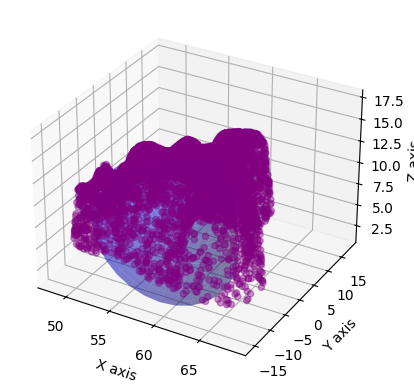

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def rotation_matrix_y_180():
    return np.array([[-1, 0, 0],
                     [0, 1, 0],
                     [0, 0, -1]])

def plot_cone(ax, vertex, direction, height, radius, color='blue', alpha=0.5):
    # Normalize the direction vector
    direction = direction / np.linalg.norm(direction)
    # Rotate the direction vector around the Y-axis by 180 degrees
    direction = np.array([direction[0], direction[1], -direction[2]]) 

    # Calculate the rotation matrix to align the cone
    a, b = direction, np.array([0, 0, 1])
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    if s != 0:
        k_mat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        rotation_matrix = np.eye(3) + k_mat + k_mat.dot(k_mat) * ((1 - c) / (s ** 2))
    else:
        # If the direction is collinear with the Z-axis
        rotation_matrix = np.eye(3) if direction[2] > 0 else np.diag([1, 1, -1])

    # Define cone dimensions and angles based on the new direction vector
    theta = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, height, 30)
    U, V = np.meshgrid(theta, v)
    X = (1 - V / height) * radius * np.cos(U)
    Y = (1 - V / height) * radius * np.sin(U)
    Z = V  # Height along the Z-axis

    # Rotate and translate the cone
    cone_points = np.dot(rotation_matrix, np.vstack([X.flatten(), Y.flatten(), Z.flatten()]))
    Xr, Yr, Zr = cone_points
    Xr += vertex[0]
    Yr += vertex[1]
    Zr += vertex[2]
    Xr = Xr.reshape(U.shape)
    Yr = Yr.reshape(U.shape)
    Zr = Zr.reshape(U.shape)

    # Plot the cone
    ax.plot_surface(Xr, Yr, Zr, color=color, alpha=alpha)

def fit_cone_to_points(points):
    # Apply PCA to find the main direction of the data
    pca = PCA(n_components=3)
    pca.fit(points)
    direction = pca.components_[0]

    # The vertex is set to the lowest point based on the direction projected onto Z
    projected_heights = points.dot(direction)
    vertex = points[np.argmin(projected_heights)]

    # Adjust the direction to always point up
    if direction[2] < 0:
        direction = -direction  # Ensure the direction is pointing "upwards"

    height = projected_heights.max() - projected_heights.min()

    # Estimate the radius as the mean radial distance to points at the base
    base_points = points[projected_heights <= projected_heights.min() + 0.1 * height]
    radii = np.linalg.norm(np.cross(base_points - vertex, direction), axis=1) / np.linalg.norm(direction)
    radius = np.mean(radii)

    return vertex, direction, height, radius

# Dummy data points
# Use your actual data points here
    
# open at your risk!
data = [[57.416666666666664, -4.944444444444443, 15.277236700057983],
[61.24999999999999, -6.833333333333336, 15.425039529800415],
[51.69444444444444, 1.7222222222222214, 9.185534119606018],
[55.08333333333333, -4.0, 13.569029569625854],
[59.69444444444444, 1.9444444444444429, 14.173808097839355],
[61.30555555555555, -2.0, 15.02789855003357],
[61.69444444444444, 10.5, 11.604753732681274],
[63.08333333333333, -2.944444444444443, 15.115225315093994],
[60.74999999999999, -14.555555555555557, 4.698044061660767],
[52.52777777777777, 2.611111111111107, 9.128379821777344],
[61.80555555555555, -3.388888888888893, 15.358266830444336],
[64.41666666666667, -8.277777777777779, 14.920605421066284],
[52.416666666666664, -1.5, 10.379352569580078],
[63.30555555555555, -7.277777777777779, 15.03306269645691],
[62.638888888888886, 10.055555555555557, 5.064736604690552],
[51.30555555555555, -11.222222222222221, 5.77422559261322],
[66.02777777777779, -14.444444444444446, 11.060323715209961],
[60.36111111111111, 11.277777777777779, 13.038606643676758],
[61.97222222222222, -11.11111111111111, 15.185409784317017],
[52.97222222222222, 0.7222222222222214, 9.601359963417053],
[57.52777777777777, -1.4444444444444429, 12.612518072128296],
[57.36111111111111, -2.8333333333333357, 14.014922380447388],
[57.916666666666664, -8.055555555555557, 16.23189091682434],
[57.30555555555555, 3.055555555555557, 12.806583642959595],
[64.69444444444444, -3.444444444444443, 14.621835947036743],
[50.02777777777777, -10.833333333333336, 8.153505325317383],
[53.74999999999999, -10.277777777777779, 9.70715582370758],
[61.58333333333333, 3.3888888888888857, 13.326338529586792],
[61.02777777777777, -4.333333333333336, 15.427542924880981],
[58.47222222222222, -14.38888888888889, 4.451936781406403],
[50.47222222222222, -12.0, 4.660992622375488],
[59.638888888888886, 13.05555555555555, 12.788753509521484],
[60.47222222222222, -9.722222222222221, 15.750095844268799],
[64.08333333333334, -2.6111111111111143, 14.77857232093811],
[49.58333333333333, -7.388888888888889, 9.748005867004395],
[65.52777777777779, -13.277777777777779, 13.66613507270813],
[59.52777777777777, -4.611111111111114, 15.452754497528076],
[51.97222222222222, -2.944444444444443, 9.74344551563263],
[68.19444444444444, -8.944444444444446, 9.389263391494751],
[58.97222222222222, 7.833333333333329, 12.77288556098938],
[58.30555555555555, 6.166666666666664, 11.90677523612976],
[52.638888888888886, 1.8333333333333286, 9.271126389503479],
[52.52777777777777, 3.6666666666666643, 8.424077033996582],
[56.916666666666664, 0.3333333333333286, 11.51528000831604],
[48.86111111111111, -5.611111111111114, 9.75029468536377],
[63.47222222222222, -15.444444444444446, 5.317002534866333],
[60.916666666666664, 8.055555555555557, 13.404990434646606],
[58.30555555555555, -3.7777777777777786, 15.016696453094482],
[55.80555555555555, 14.05555555555555, 10.246939659118652],
[65.75, -5.666666666666664, 5.069761276245117],
[62.638888888888886, -6.277777777777779, 15.200469493865967],
[63.47222222222222, -3.5, 15.181659460067749],
[60.02777777777777, -4.111111111111114, 15.323693752288818],
[63.36111111111111, -11.055555555555557, 15.002940893173218],
[59.58333333333333, -11.444444444444446, 15.094468593597412],
[53.138888888888886, 2.2777777777777786, 9.138880968093872],
[67.08333333333334, -12.277777777777779, 11.979125738143921],
[55.97222222222222, -11.11111111111111, 15.466567277908325],
[61.638888888888886, 12.944444444444443, 11.42305850982666],
[53.19444444444444, -3.388888888888893, 11.647197008132935],
[63.08333333333333, -13.222222222222221, 13.751634359359741],
[55.74999999999999, 4.444444444444443, 12.495907545089722],
[58.02777777777777, -12.666666666666668, 13.081215620040894],
[59.08333333333333, -4.055555555555557, 15.23034930229187],
[59.80555555555555, 11.333333333333329, 13.030014038085938],
[59.86111111111111, 14.388888888888886, 11.733369827270508],
[57.74999999999999, 12.388888888888886, 12.275583744049072],
[59.30555555555555, 8.666666666666664, 13.117603063583374],
[59.52777777777777, 0.8333333333333286, 14.355645179748535],
[63.80555555555555, -8.444444444444446, 15.019357204437256],
[52.69444444444444, -0.7222222222222214, 10.045353174209595],
[62.58333333333333, 10.333333333333329, 5.301249027252197],
[56.638888888888886, -3.6666666666666643, 14.295867681503296],
[63.80555555555555, -6.444444444444443, 14.93952751159668],
[51.138888888888886, -10.38888888888889, 8.721092343330383],
[59.02777777777777, -10.277777777777779, 15.693696737289429],
[66.69444444444444, -12.5, 12.895255088806152],
[63.86111111111111, -9.277777777777779, 15.021765232086182],
[58.24999999999999, 5.111111111111107, 12.911490201950073],
[60.69444444444444, 8.277777777777779, 13.460026979446411],
[60.80555555555555, -1.3333333333333357, 14.923131465911865],
[57.02777777777777, -4.722222222222221, 15.145900249481201],
[62.02777777777777, -5.722222222222221, 15.43783187866211],
[60.02777777777777, -0.6666666666666714, 14.581903219223022],
[61.916666666666664, -13.833333333333336, 10.798780918121338],
[50.138888888888886, -9.0, 9.631056785583496],
[61.74999999999999, -3.8333333333333357, 15.438779592514038],
[62.19444444444444, 7.388888888888886, 10.679750442504883],
[56.638888888888886, -0.38888888888889284, 11.229079961776733],
[61.638888888888886, -6.222222222222221, 15.436739921569824],
[55.638888888888886, -4.555555555555557, 14.354844093322754],
[67.80555555555556, -11.11111111111111, 8.527392745018005],
[62.58333333333333, -12.666666666666668, 13.8322913646698],
[62.86111111111111, -13.88888888888889, 13.06896448135376],
[62.02777777777777, 0.44444444444444287, 14.234023094177246],
[62.36111111111111, 9.0, 8.868134617805481],
[58.638888888888886, 5.833333333333329, 12.531125545501709],
[56.97222222222222, -0.9444444444444429, 11.668081283569336],
[60.638888888888886, 14.388888888888886, 8.571122884750366],
[60.30555555555555, 6.888888888888886, 13.648346662521362],
[56.916666666666664, -5.5, 15.319832563400269],
[57.74999999999999, 6.333333333333329, 11.321314573287964],
[48.52777777777777, -5.444444444444443, 8.751314282417297],
[62.24999999999999, -14.11111111111111, 11.44783616065979],
[65.97222222222223, -13.88888888888889, 12.706660032272339],
[62.69444444444444, 4.111111111111107, 5.27742326259613],
[55.47222222222222, 13.333333333333329, 7.0111143589019775],
[59.08333333333333, -13.555555555555557, 9.044232964515686],
[52.08333333333333, -9.5, 8.720943331718445],
[62.47222222222222, -3.888888888888893, 15.435138940811157],
[50.02777777777777, -6.777777777777779, 9.670917391777039],
[58.36111111111111, -12.444444444444446, 13.602949380874634],
[64.80555555555556, -13.833333333333336, 13.565932512283325],
[59.69444444444444, -12.055555555555557, 13.293254375457764],
[55.47222222222222, 14.111111111111107, 7.239074110984802],
[56.69444444444444, 0.44444444444444287, 11.68398380279541],
[57.19444444444444, -11.333333333333336, 15.729389190673828],
[56.638888888888886, 8.055555555555557, 7.48676598072052],
[60.916666666666664, 9.111111111111107, 13.361139297485352],
[63.30555555555555, 1.1111111111111072, 10.009666681289673],
[65.52777777777779, -10.0, 14.64678406715393],
[53.74999999999999, -3.555555555555557, 12.435464859008789],
[54.36111111111111, -7.666666666666668, 15.39444088935852],
[55.52777777777777, 13.777777777777779, 7.6645320653915405],
[48.52777777777777, -6.555555555555557, 8.243694305419922],
[59.58333333333333, -2.6666666666666714, 15.19787311553955],
[53.24999999999999, -8.166666666666668, 12.670782804489136],
[54.58333333333333, -9.777777777777779, 14.633229970932007],
[51.19444444444444, -10.055555555555557, 9.073827862739563],
[57.97222222222222, -0.9444444444444429, 13.079577684402466],
[61.138888888888886, -4.888888888888893, 15.508288145065308],
[65.13888888888889, -5.388888888888893, 13.674169778823853],
[65.19444444444444, -13.555555555555557, 13.716520071029663],
[54.638888888888886, -7.5, 15.691574811935425],
[60.30555555555555, -0.44444444444444287, 14.627587795257568],
[49.69444444444444, -9.333333333333336, 9.740836024284363],
[51.30555555555555, -8.777777777777779, 10.307209491729736],
[48.36111111111111, -3.5, 6.913782358169556],
[56.36111111111111, 12.444444444444443, 9.647811651229858],
[62.416666666666664, -2.2777777777777786, 15.032060146331787],
[64.30555555555556, -11.722222222222221, 14.44303274154663],
[66.30555555555556, -12.0, 13.79686713218689],
[53.30555555555555, 5.388888888888886, 10.753915309906006],
[59.74999999999999, 7.722222222222221, 13.344815969467163],
[61.97222222222222, 4.222222222222221, 11.356778144836426],
[49.86111111111111, -2.055555555555557, 8.852336406707764],
[57.19444444444444, 10.722222222222221, 9.998978972434998],
[60.138888888888886, -13.055555555555557, 8.934478759765625],
[59.74999999999999, 11.166666666666664, 12.99912691116333],
[54.916666666666664, 1.7222222222222214, 11.803326606750488],
[64.41666666666667, -4.0, 14.980677366256714],
[58.58333333333333, -0.5555555555555571, 13.603479862213135],
[60.916666666666664, 8.777777777777779, 13.369899988174438],
[61.52777777777777, -7.944444444444446, 15.5856192111969],
[55.638888888888886, 13.0, 7.6574766635894775],
[49.138888888888886, -11.666666666666668, 4.328590035438538],
[64.69444444444444, -7.555555555555557, 14.740005731582642],
[50.08333333333333, -11.88888888888889, 4.882624447345734],
[61.24999999999999, -0.22222222222222143, 14.623156785964966],
[61.74999999999999, 4.388888888888886, 12.44370698928833],
[63.36111111111111, -15.166666666666668, 8.390250205993652],
[56.86111111111111, -13.0, 8.722962141036987],
[61.52777777777777, 7.277777777777779, 13.40397596359253],
[65.30555555555556, -7.333333333333336, 13.727819919586182],
[54.24999999999999, -1.9444444444444429, 11.87266230583191],
[59.74999999999999, -14.444444444444446, 4.379816651344299],
[61.47222222222222, 6.5, 13.2566237449646],
[53.58333333333333, 2.8333333333333286, 9.946289658546448],
[56.36111111111111, -12.333333333333336, 11.661427021026611],
[50.47222222222222, 1.1666666666666643, 6.546467542648315],
[50.416666666666664, -8.166666666666668, 10.8905029296875],
[54.638888888888886, -11.833333333333336, 6.694211959838867],
[61.80555555555555, 6.5, 12.184104919433594],
[61.80555555555555, 1.0555555555555571, 14.03430700302124],
[60.58333333333333, 7.944444444444443, 13.449822664260864],
[55.30555555555555, -11.5, 12.806426286697388],
[58.916666666666664, 5.055555555555557, 13.230680227279663],
[53.138888888888886, 6.666666666666664, 9.547032117843628],
[54.916666666666664, -4.388888888888893, 13.662216663360596],
[49.97222222222222, -10.722222222222221, 8.346150517463684],
[49.916666666666664, -2.6111111111111143, 9.443591237068176],
[59.97222222222222, -4.944444444444443, 15.559333562850952],
[54.69444444444444, -2.944444444444443, 12.648049592971802],
[58.47222222222222, -3.7777777777777786, 15.055519342422485],
[49.916666666666664, -6.666666666666664, 9.612987637519836],
[60.86111111111111, 9.888888888888886, 13.287519216537476],
[56.08333333333333, 2.6666666666666643, 12.543816566467285],
[59.80555555555555, -4.888888888888893, 15.549429655075073],
[64.52777777777779, -2.1111111111111143, 13.992668390274048],
[58.638888888888886, -4.388888888888893, 15.227270126342773],
[58.80555555555555, -10.5, 15.685290098190308],
[61.02777777777777, -9.444444444444446, 15.703779458999634],
[51.80555555555555, -2.555555555555557, 9.41931664943695],
[63.86111111111111, -13.61111111111111, 13.761570453643799],
[53.47222222222222, 3.7777777777777786, 9.63128924369812],
[61.138888888888886, -3.444444444444443, 15.34866452217102],
[65.80555555555556, -10.444444444444446, 14.584232568740845],
[57.52777777777777, 14.444444444444443, 11.064766645431519],
[65.19444444444444, -4.222222222222221, 13.586050271987915],
[55.52777777777777, 14.666666666666664, 6.350278854370117],
[59.138888888888886, 11.166666666666664, 12.86026120185852],
[53.416666666666664, -5.388888888888893, 12.922978401184082],
[50.97222222222222, -10.666666666666668, 7.9678380489349365],
[52.47222222222222, -4.0, 11.129274368286133],
[57.638888888888886, 7.944444444444443, 10.736562013626099],
[62.74999999999999, -2.2222222222222214, 14.949586391448975],
[54.80555555555555, 0.5555555555555571, 11.76170825958252],
[58.86111111111111, 11.777777777777779, 12.732101678848267],
[50.69444444444444, 0.5, 9.396782517433167],
[52.19444444444444, 3.444444444444443, 8.812274932861328],
[64.02777777777779, -10.055555555555557, 15.017050504684448],
[58.58333333333333, 11.833333333333329, 12.58846640586853],
[57.638888888888886, 13.277777777777779, 12.163074016571045],
[56.74999999999999, -1.8333333333333357, 12.56122350692749],
[54.638888888888886, -11.61111111111111, 8.024595379829407],
[55.916666666666664, -5.5, 14.973146915435791],
[57.69444444444444, 6.111111111111107, 11.60884976387024],
[59.47222222222222, -0.44444444444444287, 14.375884532928467],
[57.30555555555555, -11.333333333333336, 15.735148191452026],
[58.19444444444444, -3.1666666666666714, 14.71498966217041],
[51.86111111111111, -1.7222222222222214, 9.935302734375],
[60.47222222222222, 0.8333333333333286, 14.548478126525879],
[62.416666666666664, 7.944444444444443, 8.813044428825378],
[50.58333333333333, -0.22222222222222143, 9.340482354164124],
[57.19444444444444, 0.5555555555555571, 11.497424840927124],
[61.80555555555555, -4.5, 15.513694286346436],
[63.138888888888886, -5.5, 15.200448036193848],
[50.47222222222222, 1.7777777777777786, 4.56785649061203],
[66.08333333333334, -7.555555555555557, 11.49035930633545],
[57.86111111111111, 12.888888888888886, 12.274209260940552],
[57.86111111111111, 10.055555555555557, 11.613736152648926],
[59.19444444444444, 2.1666666666666643, 13.887187242507935],
[66.75, -14.0, 8.826011419296265],
[59.69444444444444, 10.611111111111107, 13.07124376296997],
[56.30555555555555, -3.444444444444443, 13.809139728546143],
[55.416666666666664, 13.666666666666664, 6.537885069847107],
[52.916666666666664, 6.888888888888886, 7.892179489135742],
[67.47222222222223, -9.277777777777779, 13.280338048934937],
[51.97222222222222, -9.222222222222221, 8.978491425514221],
[63.74999999999999, -10.38888888888889, 15.096296072006226],
[60.138888888888886, 7.777777777777779, 13.507261276245117],
[64.36111111111111, -1.6111111111111143, 13.820087909698486],
[59.47222222222222, 14.666666666666664, 10.186173915863037],
[62.416666666666664, 11.222222222222221, 6.049589514732361],
[59.416666666666664, -10.333333333333336, 15.57533860206604],
[67.30555555555556, -12.555555555555557, 10.972135066986084],
[61.19444444444444, -5.222222222222221, 15.587356090545654],
[57.58333333333333, -4.611111111111114, 15.17158031463623],
[56.19444444444444, 3.6666666666666643, 12.714840173721313],
[49.86111111111111, -2.1111111111111143, 8.946303725242615],
[60.47222222222222, -1.6666666666666714, 14.974198341369629],
[53.97222222222222, -1.6666666666666714, 11.681448221206665],
[66.91666666666667, -14.555555555555557, 4.183902740478516],
[67.36111111111111, -7.166666666666664, 5.356473922729492],
[60.638888888888886, -5.722222222222221, 15.655735731124878],
[65.63888888888889, -9.777777777777779, 14.624029397964478],
[61.19444444444444, -5.0, 15.509042739868164],
[65.13888888888889, -12.555555555555557, 13.944451808929443],
[67.97222222222223, -12.333333333333336, 5.586425065994263],
[52.36111111111111, -7.333333333333336, 11.996361017227173],
[52.416666666666664, 4.333333333333329, 8.163971900939941],
[56.69444444444444, -3.2222222222222214, 13.855992555618286],
[64.41666666666667, -9.722222222222221, 15.006814002990723],
[57.916666666666664, 6.111111111111107, 11.676509380340576],
[58.19444444444444, 15.222222222222221, 7.601532340049744],
[54.58333333333333, 0.6111111111111072, 11.553080081939697],
[49.30555555555555, -11.277777777777779, 6.0363417863845825],
[61.638888888888886, -8.833333333333336, 15.655198097229004],
[49.86111111111111, -8.166666666666668, 10.02400517463684],
[54.08333333333333, 2.7222222222222214, 11.187443733215332],
[63.52777777777777, -7.055555555555557, 15.027310848236084],
[52.916666666666664, -10.0, 6.59544050693512],
[59.08333333333333, -0.27777777777777857, 13.97647500038147],
[63.19444444444444, -10.166666666666668, 15.181306600570679],
[64.75, -2.888888888888893, 14.402647018432617],
[59.74999999999999, -10.944444444444446, 15.209579467773438],
[56.47222222222222, 5.111111111111107, 12.979977130889893],
[59.416666666666664, 0.8888888888888857, 14.327327013015747],
[58.30555555555555, -7.166666666666664, 16.008795499801636],
[65.47222222222223, -3.555555555555557, 11.204785108566284],
[55.80555555555555, -4.388888888888893, 14.29175615310669],
[51.138888888888886, -8.277777777777779, 11.327202320098877],
[57.19444444444444, -12.38888888888889, 13.542050123214722],
[61.36111111111111, 12.333333333333329, 12.497032880783081],
[50.02777777777777, -0.055555555555557135, 6.012468934059143],
[61.24999999999999, 9.111111111111107, 13.206217288970947],
[66.91666666666667, -9.222222222222221, 13.921840190887451],
[55.138888888888886, -10.666666666666668, 14.663511514663696],
[50.58333333333333, -10.055555555555557, 9.338347315788269],
[54.52777777777777, 7.111111111111107, 10.615488290786743],
[58.416666666666664, -11.88888888888889, 14.589673280715942],
[50.97222222222222, -9.0, 10.044077634811401],
[59.86111111111111, -4.277777777777779, 15.3090238571167],
[65.19444444444444, -5.722222222222221, 13.043673038482666],
[50.86111111111111, -12.277777777777779, 4.119358062744141],
[56.36111111111111, -0.5555555555555571, 11.479064226150513],
[63.58333333333333, -3.555555555555557, 15.177797079086304],
[65.58333333333334, -4.111111111111114, 9.801679253578186],
[58.58333333333333, -4.277777777777779, 15.208255052566528],
[54.74999999999999, 5.666666666666664, 12.421547174453735],
[61.638888888888886, 0.44444444444444287, 14.406577348709106],
[61.58333333333333, 2.555555555555557, 13.558681011199951],
[57.416666666666664, 0.5, 11.8275785446167],
[60.638888888888886, -2.6666666666666714, 15.157372951507568],
[62.24999999999999, -13.444444444444446, 12.926496267318726],
[64.08333333333334, -4.777777777777779, 15.005894899368286],
[59.47222222222222, 1.7777777777777786, 14.20488715171814],
[57.02777777777777, -1.7777777777777786, 12.549000978469849],
[57.80555555555555, 13.666666666666664, 12.018808126449585],
[52.138888888888886, 6.388888888888886, 7.74811327457428],
[55.24999999999999, 14.05555555555555, 4.704826474189758],
[67.58333333333334, -12.277777777777779, 9.211449027061462],
[66.25, -12.11111111111111, 13.719274997711182],
[57.80555555555555, 12.944444444444443, 12.284961938858032],
[65.80555555555556, -5.166666666666664, 5.325546860694885],
[62.47222222222222, -0.9444444444444429, 14.692608118057251],
[66.19444444444444, -7.333333333333336, 9.964798092842102],
[62.52777777777777, -12.666666666666668, 13.796910047531128],
[61.52777777777777, -5.277777777777779, 15.515882968902588],
[52.02777777777777, -2.388888888888893, 9.628220200538635],
[61.138888888888886, -7.444444444444446, 15.572928190231323],
[62.638888888888886, 10.611111111111107, 4.5740050077438354],
[50.138888888888886, -6.222222222222221, 9.626522660255432],
[59.86111111111111, 8.944444444444443, 13.391790390014648],
[50.74999999999999, -7.555555555555557, 10.823289155960083],
[61.52777777777777, 1.2222222222222214, 14.245431423187256],
[53.08333333333333, -8.222222222222221, 11.954278945922852],
[61.638888888888886, -7.055555555555557, 15.429340600967407],
[59.24999999999999, -1.7777777777777786, 14.819105863571167],
[63.47222222222222, -3.888888888888893, 15.18521785736084],
[64.25, 0.11111111111110716, 7.98498272895813],
[54.02777777777777, 6.166666666666664, 11.640198230743408],
[48.86111111111111, -2.6111111111111143, 8.908483982086182],
[65.08333333333334, -12.833333333333336, 13.930137157440186],
[66.25, -12.055555555555557, 13.80460262298584],
[65.97222222222223, -7.944444444444446, 13.474923372268677],
[49.74999999999999, -0.8888888888888928, 6.111779808998108],
[54.416666666666664, -6.166666666666664, 14.606361389160156],
[63.24999999999999, 1.7222222222222214, 5.4230427742004395],
[58.02777777777777, 8.111111111111107, 11.66016936302185],
[62.58333333333333, 8.111111111111107, 7.076127529144287],
[55.80555555555555, 7.388888888888886, 10.150971412658691],
[60.19444444444444, -12.666666666666668, 10.587445497512817],
[63.416666666666664, -14.777777777777779, 12.757042646408081],
[56.52777777777777, 2.944444444444443, 12.949174642562866],
[65.80555555555556, -5.0, 5.610330104827881],
[59.97222222222222, -8.666666666666668, 16.017651557922363],
[48.638888888888886, -3.7222222222222214, 10.201040506362915],
[59.916666666666664, -8.0, 15.942931175231934],
[62.416666666666664, 1.0, 13.542898893356323],
[57.916666666666664, 7.444444444444443, 11.51339054107666],
[48.97222222222222, -3.3333333333333357, 10.40347695350647],
[60.138888888888886, 7.0, 13.627679347991943],
[59.08333333333333, -12.166666666666668, 13.56913685798645],
[59.74999999999999, -8.11111111111111, 16.0027277469635],
[51.47222222222222, 5.722222222222221, 4.133043587207794],
[61.80555555555555, -3.1111111111111143, 15.276237726211548],
[50.86111111111111, -11.5, 5.600295662879944],
[63.52777777777777, -10.666666666666668, 15.092663764953613],
[63.916666666666664, -15.333333333333332, 6.703394651412964],
[58.52777777777777, 0.7777777777777786, 13.554037809371948],
[58.97222222222222, -4.666666666666664, 15.426902770996094],
[58.138888888888886, -4.555555555555557, 15.260028839111328],
[67.86111111111111, -10.333333333333336, 11.519042253494263],
[56.97222222222222, 14.888888888888886, 8.213635683059692],
[56.97222222222222, -3.1111111111111143, 13.858823776245117],
[57.80555555555555, 9.666666666666664, 11.237577199935913],
[48.30555555555555, -6.833333333333336, 5.407618880271912],
[58.47222222222222, 11.666666666666664, 12.605106830596924],
[58.02777777777777, -0.5555555555555571, 12.679678201675415],
[62.08333333333333, -9.833333333333336, 15.322951078414917],
[61.916666666666664, -2.5, 15.111643075942993],
[57.52777777777777, 5.5, 12.317055463790894],
[50.24999999999999, -6.222222222222221, 9.742291569709778],
[59.97222222222222, -7.944444444444446, 15.948880910873413],
[67.08333333333334, -12.0, 12.414904832839966],
[56.416666666666664, 6.333333333333329, 12.013683319091797],
[59.916666666666664, -2.888888888888893, 15.251932144165039],
[65.25, -9.5, 14.809223413467407],
[49.916666666666664, -10.333333333333336, 9.298914670944214],
[61.24999999999999, -3.055555555555557, 15.269190073013306],
[54.47222222222222, -3.1666666666666714, 12.666759490966797],
[59.916666666666664, 10.333333333333329, 13.23010802268982],
[60.30555555555555, -5.055555555555557, 15.572371482849121],
[66.47222222222223, -8.722222222222221, 14.004075527191162],
[48.30555555555555, -4.444444444444443, 6.162225008010864],
[56.638888888888886, 0.7777777777777786, 12.029834985733032],
[59.74999999999999, 5.5, 13.585153818130493],
[50.80555555555555, -3.7777777777777786, 8.835188746452332],
[61.97222222222222, 11.833333333333329, 9.27427351474762],
[48.86111111111111, -2.2222222222222214, 7.535571455955505],
[55.74999999999999, 1.8888888888888857, 12.164644002914429],
[54.86111111111111, 6.611111111111107, 12.11491584777832],
[62.916666666666664, -4.888888888888893, 15.360168218612671],
[56.416666666666664, 1.7222222222222214, 12.191871404647827],
[65.75, -10.944444444444446, 14.566364288330078],
[59.69444444444444, -10.88888888888889, 15.306394100189209],
[52.74999999999999, -10.11111111111111, 6.674827933311462],
[51.02777777777777, -4.833333333333336, 9.456143379211426],
[61.416666666666664, -7.5, 15.5819833278656],
[50.416666666666664, -7.055555555555557, 9.756369590759277],
[57.97222222222222, -11.555555555555557, 15.377280712127686],
[60.47222222222222, 12.05555555555555, 13.024284839630127],
[60.86111111111111, 6.166666666666664, 13.644202947616577],
[61.47222222222222, 10.722222222222221, 12.577292919158936],
[63.19444444444444, -5.555555555555557, 15.198698043823242],
[61.58333333333333, 14.166666666666664, 7.155090570449829],
[67.02777777777779, -7.5, 8.673917651176453],
[52.30555555555555, 3.7222222222222214, 8.418521881103516],
[64.02777777777779, -4.055555555555557, 15.081371068954468],
[59.80555555555555, 7.944444444444443, 13.388310670852661],
[60.19444444444444, -8.166666666666668, 15.957837104797363],
[59.416666666666664, -13.222222222222221, 9.957404732704163],
[49.47222222222222, -9.61111111111111, 9.969210624694824],
[60.47222222222222, -14.333333333333336, 5.11413037776947],
[56.24999999999999, -1.3333333333333357, 12.241700887680054],
[65.97222222222223, -11.833333333333336, 14.129995107650757],
[60.86111111111111, 7.444444444444443, 13.491076231002808],
[62.02777777777777, -7.388888888888889, 15.42565107345581],
[52.138888888888886, -3.7222222222222214, 10.56656002998352],
[65.86111111111111, -6.444444444444443, 4.787485897541046],
[60.36111111111111, 0.27777777777777857, 14.582054615020752],
[66.75, -14.38888888888889, 5.999665260314941],
[56.47222222222222, -9.055555555555557, 16.022948026657104],
[65.97222222222223, -6.722222222222221, 6.393797397613525],
[60.30555555555555, 8.388888888888886, 13.429005146026611],
[58.02777777777777, -5.666666666666664, 15.48258900642395],
[56.916666666666664, -5.222222222222221, 15.26712417602539],
[52.69444444444444, -8.833333333333336, 9.593483805656433],
[55.08333333333333, -2.8333333333333357, 12.852815389633179],
[50.36111111111111, -9.88888888888889, 9.38809871673584],
[53.19444444444444, 4.777777777777779, 9.659352898597717],
[50.19444444444444, -12.055555555555557, 4.294800162315369],
[56.47222222222222, -13.166666666666668, 6.23961865901947],
[63.74999999999999, -6.5, 14.94266390800476],
[64.91666666666667, -8.833333333333336, 14.885410070419312],
[51.02777777777777, -0.22222222222222143, 10.257138013839722],
[53.138888888888886, -2.388888888888893, 10.986741781234741],
[51.74999999999999, -2.7222222222222214, 9.375733733177185],
[57.58333333333333, 12.944444444444443, 12.222501039505005],
[57.69444444444444, -6.111111111111114, 15.547738075256348],
[58.02777777777777, 12.888888888888886, 12.347105741500854],
[58.97222222222222, 8.944444444444443, 12.846566438674927],
[58.36111111111111, -1.3333333333333357, 13.921478986740112],
[53.30555555555555, 4.888888888888886, 9.956932663917542],
[56.24999999999999, -2.388888888888893, 12.744841575622559],
[61.58333333333333, -14.88888888888889, 5.8134132623672485],
[61.24999999999999, 5.222222222222221, 13.670909404754639],
[59.36111111111111, 3.1666666666666643, 13.831418752670288],
[58.08333333333333, 5.166666666666664, 12.750892639160156],
[57.58333333333333, -7.111111111111114, 15.99652647972107],
[48.86111111111111, -5.055555555555557, 9.921884536743164],
[57.97222222222222, 5.833333333333329, 12.05916166305542],
[64.97222222222223, -10.555555555555557, 14.755891561508179],
[57.138888888888886, 1.1666666666666643, 11.73144817352295],
[65.47222222222223, -13.666666666666668, 13.54426622390747],
[63.416666666666664, -3.5, 15.18413782119751],
[50.30555555555555, -2.7222222222222214, 9.16339635848999],
[53.138888888888886, 7.055555555555557, 7.695766091346741],
[64.13888888888889, -7.0, 14.840368032455444],
[56.638888888888886, 4.166666666666664, 12.822037935256958],
[52.36111111111111, -2.3333333333333357, 9.94912564754486],
[54.74999999999999, 0.27777777777777857, 11.747363805770874],
[63.416666666666664, -14.944444444444446, 11.01037859916687],
[48.36111111111111, -7.666666666666668, 6.447542905807495],
[59.02777777777777, -6.833333333333336, 15.930103063583374],
[53.74999999999999, -1.2777777777777786, 11.40840768814087],
[55.30555555555555, -6.833333333333336, 15.966178178787231],
[49.36111111111111, -8.11111111111111, 10.169525146484375],
[51.24999999999999, -11.777777777777779, 4.589590132236481],
[61.69444444444444, -8.0, 15.58445692062378],
[60.47222222222222, -14.166666666666668, 5.680382251739502],
[54.24999999999999, 4.944444444444443, 11.541789770126343],
[57.86111111111111, -13.777777777777779, 7.1390604972839355],
[59.52777777777777, -3.5, 15.236951112747192],
[61.86111111111111, -5.666666666666664, 15.516936779022217],
[61.47222222222222, 7.666666666666664, 13.388700485229492],
[56.638888888888886, -12.555555555555557, 11.823285818099976],
[50.08333333333333, -1.3888888888888928, 8.213984966278076],
[61.69444444444444, 6.777777777777779, 12.67419695854187],
[54.86111111111111, -8.11111111111111, 15.994832515716553],
[65.69444444444444, -8.11111111111111, 14.311110973358154],
[65.41666666666667, -13.055555555555557, 13.71852993965149],
[66.86111111111111, -11.666666666666668, 13.476647138595581],
[55.52777777777777, -12.722222222222221, 5.327267646789551],
[55.47222222222222, 3.2222222222222214, 12.648253440856934],
[50.02777777777777, -9.444444444444446, 9.382928013801575],
[59.30555555555555, -5.0, 15.521208047866821],
[54.97222222222222, -11.666666666666668, 9.846194386482239],
[55.97222222222222, 4.111111111111107, 12.531185150146484],
[49.416666666666664, -1.2222222222222214, 5.8791184425354],
[52.916666666666664, 4.666666666666664, 9.042409062385559],
[53.02777777777777, 2.7777777777777786, 8.866646885871887],
[58.47222222222222, 12.111111111111107, 12.581477165222168],
[60.24999999999999, 12.333333333333329, 13.019134998321533],
[59.36111111111111, 7.333333333333329, 13.019031286239624],
[51.69444444444444, 3.7222222222222214, 5.604463815689087],
[51.97222222222222, 4.5, 7.211120128631592],
[59.47222222222222, -0.9444444444444429, 14.588351249694824],
[60.08333333333333, 10.388888888888886, 13.192528486251831],
[55.138888888888886, -2.6666666666666714, 12.720370292663574],
[53.08333333333333, -3.7777777777777786, 11.722017526626587],
[62.74999999999999, -13.0, 13.672370910644531],
[53.02777777777777, -8.777777777777779, 10.174096822738647],
[61.47222222222222, -0.7777777777777786, 14.793192148208618],
[61.30555555555555, -2.444444444444443, 15.10648488998413],
[59.86111111111111, 3.3333333333333286, 13.98114562034607],
[51.19444444444444, 0.6666666666666643, 9.616703987121582],
[49.86111111111111, -11.666666666666668, 5.518617033958435],
[63.638888888888886, -8.61111111111111, 15.02548098564148],
[57.58333333333333, -5.833333333333336, 15.5107581615448],
[62.138888888888886, 6.666666666666664, 10.771455764770508],
[66.02777777777779, -6.833333333333336, 7.310048341751099],
[56.58333333333333, 3.6666666666666643, 12.923215627670288],
[58.24999999999999, -5.111111111111114, 15.393275022506714],
[52.58333333333333, -0.6666666666666714, 10.0836181640625],
[51.80555555555555, -4.055555555555557, 10.107804536819458],
[61.74999999999999, 8.333333333333329, 12.399535179138184],
[58.69444444444444, 0.5555555555555571, 13.633595705032349],
[67.47222222222223, -11.61111111111111, 11.745342016220093],
[48.30555555555555, -2.444444444444443, 4.737004935741425],
[61.02777777777777, -13.88888888888889, 7.926990985870361],
[56.58333333333333, -8.11111111111111, 16.24895215034485],
[60.80555555555555, 12.333333333333329, 12.978252172470093],
[54.19444444444444, 1.4444444444444429, 11.245604753494263],
[57.58333333333333, 3.8333333333333286, 13.074663877487183],
[62.30555555555555, -3.1666666666666714, 15.273778438568115],
[61.74999999999999, 10.5, 11.222543716430664],
[59.74999999999999, 7.944444444444443, 13.287920951843262],
[66.58333333333334, -8.222222222222221, 13.469318151473999],
[59.80555555555555, 1.6666666666666643, 14.279441833496094],
[59.916666666666664, 7.333333333333329, 13.456056118011475],
[56.74999999999999, -5.0, 15.092709064483643],
[67.19444444444444, -11.944444444444446, 12.260379791259766],
[58.638888888888886, 13.611111111111107, 12.334245443344116],
[66.75, -11.166666666666668, 14.086813926696777],
[48.52777777777777, -8.0, 8.852301836013794],
[58.02777777777777, 9.777777777777779, 11.918251514434814],
[58.138888888888886, 2.444444444444443, 13.077895641326904],
[57.74999999999999, -8.166666666666668, 16.237870454788208],
[57.47222222222222, -13.055555555555557, 9.93817150592804],
[63.69444444444444, -4.166666666666664, 15.179463624954224],
[62.74999999999999, -1.4444444444444429, 14.765350818634033],
[63.416666666666664, -11.88888888888889, 14.58611011505127],
[61.30555555555555, 12.5, 12.515730857849121],
[60.02777777777777, 9.333333333333329, 13.357884883880615],
[63.638888888888886, -3.944444444444443, 15.17932653427124],
[65.25, -0.9444444444444429, 5.361670255661011],
[62.638888888888886, -8.222222222222221, 15.26943325996399],
[59.24999999999999, 10.777777777777779, 12.894095182418823],
[61.916666666666664, -4.888888888888893, 15.513519048690796],
[58.58333333333333, 9.777777777777779, 12.639919519424438],
[53.86111111111111, -6.888888888888893, 14.079726934432983],
[65.02777777777779, -13.5, 13.737350702285767],
[60.58333333333333, -8.222222222222221, 15.869394540786743],
[58.80555555555555, -1.6111111111111143, 14.406653642654419],
[57.36111111111111, -4.111111111111114, 14.779961109161377],
[66.86111111111111, -7.833333333333336, 11.382995843887329],
[49.36111111111111, -3.2222222222222214, 10.708423852920532],
[62.74999999999999, 0.27777777777777857, 13.95567536354065],
[64.19444444444444, 0.9444444444444429, 4.082852005958557],
[63.36111111111111, -15.444444444444446, 5.263448357582092],
[52.30555555555555, 0.6111111111111072, 10.135127305984497],
[52.86111111111111, 5.611111111111107, 10.182455778121948],
[50.36111111111111, -6.5, 9.787731170654297],
[48.69444444444444, -11.222222222222221, 6.040210723876953],
[58.30555555555555, 7.055555555555557, 11.870287656784058],
[51.916666666666664, -5.0, 11.1752188205719],
[66.86111111111111, -14.555555555555557, 4.493780136108398],
[67.97222222222223, -8.61111111111111, 11.742024421691895],
[63.86111111111111, -4.611111111111114, 15.096312761306763],
[57.52777777777777, 11.277777777777779, 11.612882614135742],
[49.74999999999999, -7.277777777777779, 9.722546935081482],
[64.30555555555556, -13.055555555555557, 13.865201473236084],
[55.30555555555555, -0.7222222222222214, 11.98715329170227],
[61.86111111111111, -1.8333333333333357, 15.03474235534668],
[62.02777777777777, 13.611111111111107, 6.744995713233948],
[61.58333333333333, -13.777777777777779, 9.412882328033447],
[59.416666666666664, 14.333333333333329, 12.016005516052246],
[64.80555555555556, -5.111111111111114, 14.20690655708313],
[56.638888888888886, -12.88888888888889, 9.00347650051117],
[65.58333333333334, -13.277777777777779, 13.654452562332153],
[60.36111111111111, 0.6666666666666643, 14.533681869506836],
[64.69444444444444, -2.888888888888893, 14.462828636169434],
[67.69444444444444, -11.944444444444446, 9.311294555664062],
[53.47222222222222, 3.3333333333333286, 9.81902539730072],
[48.416666666666664, -11.222222222222221, 4.613993465900421],
[57.52777777777777, -10.944444444444446, 15.85081696510315],
[58.80555555555555, 1.5, 13.737095594406128],
[57.02777777777777, -13.055555555555557, 8.767186999320984],
[58.58333333333333, -4.666666666666664, 15.324556827545166],
[58.02777777777777, 4.5, 13.10492753982544],
[61.02777777777777, -8.055555555555557, 15.716639757156372],
[61.52777777777777, -2.7777777777777786, 15.193778276443481],
[53.638888888888886, 3.7222222222222214, 10.080764293670654],
[58.36111111111111, -3.8333333333333357, 15.036917924880981],
[61.30555555555555, 10.0, 12.998119592666626],
[58.36111111111111, -3.444444444444443, 14.879276752471924],
[61.80555555555555, -11.38888888888889, 15.096856355667114],
[54.47222222222222, -3.8333333333333357, 13.01026701927185],
[59.19444444444444, -2.888888888888893, 15.060925483703613],
[59.80555555555555, 13.222222222222221, 12.797284126281738],
[56.80555555555555, -4.166666666666664, 14.629720449447632],
[50.19444444444444, -4.222222222222221, 9.143585562705994],
[60.74999999999999, 10.833333333333329, 13.059325218200684],
[55.638888888888886, 14.666666666666664, 7.3030686378479],
[52.30555555555555, -0.055555555555557135, 9.817395210266113],
[53.52777777777777, -10.055555555555557, 9.173877239227295],
[50.24999999999999, -11.833333333333336, 5.121687650680542],
[56.24999999999999, 15.05555555555555, 5.908999443054199],
[64.86111111111111, -10.777777777777779, 14.762704372406006],
[56.97222222222222, -12.722222222222221, 11.209951639175415],
[61.02777777777777, 13.111111111111107, 12.60938286781311],
[51.86111111111111, -4.944444444444443, 11.076867580413818],
[60.638888888888886, -12.222222222222221, 12.294303178787231],
[57.138888888888886, 11.444444444444443, 10.762948989868164],
[52.19444444444444, -6.222222222222221, 12.224706411361694],
[61.86111111111111, 7.555555555555557, 12.088786363601685],
[62.19444444444444, 0.055555555555557135, 14.379218816757202],
[53.80555555555555, 1.7222222222222214, 10.24520993232727],
[55.69444444444444, 3.0, 12.522197961807251],
[63.47222222222222, 0.22222222222222143, 12.311311960220337],
[65.75, -6.944444444444443, 10.542888641357422],
[55.24999999999999, -4.388888888888893, 13.907840251922607],
[61.80555555555555, -2.3333333333333357, 15.111616849899292],
[58.69444444444444, 14.611111111111107, 10.56408405303955],
[48.916666666666664, -5.277777777777779, 9.921785593032837],
[58.74999999999999, -11.61111111111111, 14.948495626449585],
[52.916666666666664, -0.055555555555557135, 9.85211730003357],
[65.30555555555556, -4.111111111111114, 12.476834058761597],
[58.19444444444444, 1.7777777777777786, 12.98001766204834],
[54.69444444444444, 6.555555555555557, 12.111085653305054],
[63.30555555555555, 0.7777777777777786, 11.546781063079834],
[49.36111111111111, -4.611111111111114, 10.332237482070923],
[63.638888888888886, -8.555555555555557, 15.02509593963623],
[61.97222222222222, -12.777777777777779, 13.099600076675415],
[63.19444444444444, 1.4444444444444429, 8.956687450408936],
[53.02777777777777, -1.5, 10.414707660675049],
[56.138888888888886, 13.444444444444443, 10.805201530456543],
[63.52777777777777, 0.38888888888888573, 11.516302824020386],
[66.91666666666667, -9.61111111111111, 13.91268253326416],
[49.916666666666664, -0.44444444444444287, 6.019614338874817],
[61.52777777777777, -13.88888888888889, 8.883943557739258],
[48.69444444444444, -3.3333333333333357, 9.832741618156433],
[63.74999999999999, -2.0, 14.49897050857544],
[48.75, -7.777777777777779, 9.480770826339722],
[64.19444444444444, -7.944444444444446, 14.925792217254639],
[52.74999999999999, -9.222222222222221, 8.405596613883972],
[65.58333333333334, -9.444444444444446, 14.682984352111816],
[65.63888888888889, -10.277777777777779, 14.663975238800049],
[54.97222222222222, 1.8333333333333286, 11.786911487579346],
[60.30555555555555, 1.3333333333333286, 14.447429180145264],
[50.638888888888886, 1.3333333333333286, 7.172763347625732],
[57.138888888888886, 1.5, 11.722426414489746],
[65.69444444444444, -4.444444444444443, 7.56841778755188],
[49.69444444444444, -11.38888888888889, 6.370446681976318],
[57.69444444444444, 3.7222222222222214, 13.134771585464478],
[63.638888888888886, -9.88888888888889, 15.101500749588013],
[51.08333333333333, -5.944444444444443, 10.656689405441284],
[64.25, -7.888888888888889, 14.923251867294312],
[65.80555555555556, -13.222222222222221, 13.54382038116455],
[57.08333333333333, -2.444444444444443, 13.519068956375122],
[60.30555555555555, 12.611111111111107, 12.916011810302734],
[50.08333333333333, -3.388888888888893, 8.608425259590149],
[59.138888888888886, -13.666666666666668, 8.673993349075317],
[64.19444444444444, -7.444444444444446, 14.92016077041626],
[57.80555555555555, 13.0, 12.293027639389038],
[63.138888888888886, -10.944444444444446, 15.156614780426025],
[56.138888888888886, 4.722222222222221, 12.76277780532837],
[60.19444444444444, 7.166666666666664, 13.592971563339233],
[54.08333333333333, 0.5555555555555571, 11.047437191009521],
[66.19444444444444, -7.666666666666668, 11.684129238128662],
[52.19444444444444, 4.5, 8.295632004737854],
[57.08333333333333, 1.5, 11.76301121711731],
[51.916666666666664, -2.388888888888893, 9.550042152404785],
[55.86111111111111, 5.111111111111107, 12.865281105041504],
[62.24999999999999, 2.6666666666666643, 10.81928014755249],
[60.24999999999999, 6.888888888888886, 13.655736446380615],
[53.74999999999999, -8.5, 13.690325021743774],
[65.47222222222223, -11.61111111111111, 14.425477981567383],
[63.24999999999999, -6.888888888888893, 15.035463571548462],
[59.08333333333333, -4.888888888888893, 15.514479875564575],
[56.69444444444444, -7.055555555555557, 16.07264757156372],
[50.638888888888886, -4.888888888888893, 9.039584994316101],
[60.02777777777777, 11.0, 13.151031732559204],
[52.97222222222222, 2.611111111111107, 8.862053155899048],
[56.02777777777777, -1.5, 12.177287340164185],
[58.638888888888886, -1.0555555555555571, 13.977818489074707],
[59.24999999999999, 4.833333333333329, 13.522205352783203],
[60.30555555555555, 10.055555555555557, 13.26270580291748],
[60.24999999999999, 5.944444444444443, 13.832106590270996],
[56.08333333333333, -0.8333333333333357, 11.755359172821045],
[54.138888888888886, 0.38888888888888573, 11.167629957199097],
[58.86111111111111, 1.7222222222222214, 13.690781593322754],
[64.86111111111111, -8.11111111111111, 14.770909547805786],
[58.74999999999999, 15.222222222222221, 7.1850502490997314],
[52.19444444444444, 0.055555555555557135, 9.877023100852966],
[64.13888888888889, -3.2777777777777786, 14.971245527267456],
[63.24999999999999, -12.722222222222221, 14.041783809661865],
[61.08333333333333, -10.5, 15.442676544189453],
[52.69444444444444, 6.166666666666664, 9.573554396629333],
[65.25, -3.388888888888893, 13.264371156692505],
[62.80555555555555, -6.944444444444443, 15.197149515151978],
[53.80555555555555, -10.0, 10.765947103500366],
[50.47222222222222, -6.666666666666664, 9.787333011627197],
[61.80555555555555, -13.722222222222221, 10.600298643112183],
[59.638888888888886, 7.888888888888886, 13.234930038452148],
[51.86111111111111, -5.555555555555557, 11.458770036697388],
[67.41666666666667, -9.5, 13.317372798919678],
[56.638888888888886, 4.666666666666664, 12.905008792877197],
[60.19444444444444, 1.0, 14.543766975402832],
[67.41666666666667, -13.38888888888889, 6.5517377853393555],
[53.36111111111111, -10.222222222222221, 8.001086711883545],
[54.58333333333333, 7.944444444444443, 5.64050018787384],
[63.97222222222222, -14.777777777777779, 13.04944634437561],
[51.97222222222222, -4.611111111111114, 10.907957553863525],
[59.74999999999999, -6.222222222222221, 15.860991477966309],
[63.24999999999999, -5.666666666666664, 15.118590593338013],
[57.138888888888886, 14.833333333333329, 8.667033910751343],
[56.97222222222222, 11.611111111111107, 10.218582153320312],
[51.69444444444444, 3.944444444444443, 5.786842703819275],
[60.74999999999999, 4.444444444444443, 13.989794254302979],
[56.138888888888886, 0.6111111111111072, 11.786518096923828],
[62.19444444444444, 5.555555555555557, 10.22244930267334],
[61.36111111111111, -14.11111111111111, 7.842773199081421],
[51.74999999999999, 3.3333333333333286, 6.13666832447052],
[52.36111111111111, -4.555555555555557, 11.318657398223877],
[64.02777777777779, -1.3888888888888928, 13.945227861404419],
[62.19444444444444, -10.277777777777779, 15.31168818473816],
[57.916666666666664, -12.055555555555557, 14.690067768096924],
[60.08333333333333, -6.611111111111114, 15.804027318954468],
[58.80555555555555, -1.7777777777777786, 14.544991254806519],
[53.416666666666664, 3.8333333333333286, 9.440639615058899],
[60.24999999999999, 1.4444444444444429, 14.362839460372925],
[53.916666666666664, -3.555555555555557, 12.545491456985474],
[53.69444444444444, 1.6666666666666643, 9.99075472354889],
[55.86111111111111, 0.1666666666666643, 11.5924072265625],
[58.80555555555555, 6.444444444444443, 12.162446975708008],
[49.52777777777777, -6.777777777777779, 9.608558416366577],
[58.08333333333333, -0.1666666666666714, 12.441754341125488],
[51.416666666666664, 5.555555555555557, 4.141128659248352],
[59.19444444444444, -11.0, 15.33909797668457],
[63.138888888888886, -1.0, 14.415744543075562],
[48.97222222222222, -5.611111111111114, 9.904749393463135],
[61.47222222222222, 1.6111111111111072, 14.089484214782715],
[56.36111111111111, 13.111111111111107, 11.004761457443237],
[63.86111111111111, -3.944444444444443, 15.089806318283081],
[49.36111111111111, -8.277777777777779, 10.167661905288696],
[58.416666666666664, 5.833333333333329, 12.327649593353271],
[56.24999999999999, -3.6666666666666643, 13.913928270339966],
[61.36111111111111, 0.22222222222222143, 14.519166946411133],
[59.19444444444444, -5.111111111111114, 15.59544563293457],
[57.86111111111111, 4.722222222222221, 12.941274642944336],
[58.74999999999999, 6.333333333333329, 12.172049283981323],
[58.638888888888886, 12.05555555555555, 12.57511019706726],
[65.02777777777779, -1.6111111111111143, 11.50420069694519],
[64.97222222222223, -12.055555555555557, 14.204546213150024],
[61.74999999999999, -12.055555555555557, 14.320993423461914],
[52.08333333333333, 4.222222222222221, 7.4653273820877075],
[50.74999999999999, -2.3333333333333357, 9.228296279907227],
[62.24999999999999, 4.611111111111107, 9.992536902427673],
[50.80555555555555, -7.888888888888889, 11.474354267120361],
[59.97222222222222, 11.888888888888886, 13.020578622817993],
[54.69444444444444, -8.0, 15.761359930038452],
[59.416666666666664, -12.166666666666668, 13.220841884613037],
[60.916666666666664, -4.666666666666664, 15.5058753490448],
[59.69444444444444, -6.388888888888893, 15.859113931655884],
[57.08333333333333, -6.111111111111114, 15.569639205932617],
[56.74999999999999, -11.944444444444446, 14.065419435501099],
[64.63888888888889, -4.777777777777779, 14.583617448806763],
[58.30555555555555, -1.1111111111111143, 13.63174557685852],
[60.58333333333333, -8.61111111111111, 15.868223905563354],
[54.58333333333333, -4.333333333333336, 13.325756788253784],
[60.30555555555555, -12.166666666666668, 12.491215467453003],
[57.69444444444444, -13.88888888888889, 5.8243221044540405],
[56.24999999999999, -12.555555555555557, 10.131534337997437],
[50.80555555555555, -5.833333333333336, 10.682895183563232],
[55.47222222222222, -5.777777777777779, 15.09732961654663],
[58.86111111111111, -1.7777777777777786, 14.5792555809021],
[60.08333333333333, 3.8333333333333286, 14.117393493652344],
[53.916666666666664, -6.111111111111114, 14.041779041290283],
[61.138888888888886, -13.777777777777779, 8.543537855148315],
[66.86111111111111, -7.277777777777779, 7.427538633346558],
[62.47222222222222, 9.722222222222221, 6.7983609437942505],
[52.02777777777777, 2.2777777777777786, 9.074057340621948],
[50.47222222222222, -10.944444444444446, 7.576658725738525],
[59.58333333333333, 10.277777777777779, 13.151533603668213],
[49.47222222222222, -5.888888888888893, 10.110903978347778],
[54.30555555555555, -8.11111111111111, 15.307267904281616],
[50.08333333333333, -11.0, 7.766197919845581],
[49.74999999999999, -2.5, 9.670405387878418],
[61.86111111111111, -4.833333333333336, 15.513334274291992],
[56.36111111111111, 4.277777777777779, 12.724001407623291],
[66.80555555555556, -14.38888888888889, 5.6493037939071655],
[60.86111111111111, -0.055555555555557135, 14.682201147079468],
[56.638888888888886, 12.166666666666664, 10.634822845458984],
[58.24999999999999, -8.0, 16.163740158081055],
[62.58333333333333, -6.5, 15.198262929916382],
[51.58333333333333, 5.166666666666664, 5.502217411994934],
[56.30555555555555, 14.05555555555555, 11.07155442237854],
[67.30555555555556, -13.0, 8.962274193763733],
[58.416666666666664, -12.055555555555557, 14.364650249481201],
[57.02777777777777, 13.277777777777779, 11.8960702419281],
[59.97222222222222, -9.5, 15.911521911621094],
[63.416666666666664, -4.888888888888893, 15.192004442214966],
[64.91666666666667, -10.333333333333336, 14.831886291503906],
[50.416666666666664, -6.0, 10.037667751312256],
[56.74999999999999, 11.611111111111107, 8.550317287445068],
[56.80555555555555, 10.166666666666664, 6.104767918586731],
[59.138888888888886, -5.388888888888893, 15.594110488891602],
[66.69444444444444, -9.0, 13.945502042770386],
[51.36111111111111, -4.388888888888893, 9.793869256973267],
[55.02777777777777, -10.722222222222221, 14.236371517181396],
[60.24999999999999, -8.38888888888889, 15.951967239379883],
[58.138888888888886, -12.166666666666668, 14.318115711212158],
[52.52777777777777, -4.222222222222221, 11.332095861434937],
[60.52777777777777, 12.722222222222221, 12.95087218284607],
[61.69444444444444, 11.277777777777779, 11.31956696510315],
[64.47222222222223, -15.555555555555557, 4.075059592723846],
[56.80555555555555, -9.38888888888889, 16.020256280899048],
[60.58333333333333, 7.555555555555557, 13.5657799243927],
[58.02777777777777, 6.333333333333329, 11.447842121124268],
[64.41666666666667, -14.38888888888889, 13.24181318283081],
[62.916666666666664, 1.2777777777777786, 11.589295864105225],
[63.97222222222222, -11.61111111111111, 14.530227184295654],
[59.30555555555555, 0.8333333333333286, 14.254329204559326],
[52.52777777777777, -8.222222222222221, 11.561466455459595],
[53.30555555555555, -8.166666666666668, 12.835633754730225],
[53.69444444444444, 3.944444444444443, 10.098382234573364],
[62.69444444444444, -7.111111111111114, 15.195404291152954],
[57.02777777777777, -10.0, 16.009517908096313],
[55.638888888888886, -0.9444444444444429, 11.854816675186157],
[60.80555555555555, -0.7777777777777786, 14.764448404312134],
[48.75, -4.166666666666664, 10.175086259841919],
[52.52777777777777, -9.444444444444446, 8.23237955570221],
[64.47222222222223, -12.88888888888889, 13.951047658920288],
[57.416666666666664, 13.333333333333329, 12.088173627853394],
[55.74999999999999, 12.833333333333329, 7.826690673828125],
[51.97222222222222, -6.777777777777779, 11.803336143493652],
[59.86111111111111, -5.444444444444443, 15.710734128952026],
[60.02777777777777, -3.944444444444443, 15.323233604431152],
[62.47222222222222, 12.333333333333329, 4.256604611873627],
[55.916666666666664, 13.55555555555555, 10.410299301147461],
[58.47222222222222, 13.111111111111107, 12.448387145996094],
[61.638888888888886, 6.611111111111107, 12.904527187347412],
[61.69444444444444, 1.8333333333333286, 13.658225536346436],
[55.80555555555555, -8.61111111111111, 16.233153343200684],
[60.69444444444444, 8.444444444444443, 13.395414352416992],
[50.97222222222222, -11.222222222222221, 6.209784150123596],
[61.138888888888886, -7.833333333333336, 15.646675825119019],
[60.36111111111111, 1.3333333333333286, 14.447931051254272],
[52.24999999999999, -4.5, 11.159158945083618],
[63.86111111111111, -1.5555555555555571, 14.18376088142395],
[62.416666666666664, -9.333333333333336, 15.261527299880981],
[59.02777777777777, -3.1111111111111143, 15.049114227294922],
[51.58333333333333, -2.888888888888893, 9.155780673027039],
[56.97222222222222, -9.333333333333336, 16.098397970199585],
[56.638888888888886, 2.3888888888888857, 12.47581958770752],
[61.36111111111111, 11.611111111111107, 12.465959787368774],
[65.91666666666667, -13.166666666666668, 13.488743305206299],
[60.97222222222222, -13.944444444444446, 7.604790925979614],
[56.36111111111111, -5.166666666666664, 15.028311014175415],
[61.86111111111111, 8.777777777777779, 11.859546899795532],
[62.916666666666664, -11.666666666666668, 14.865641593933105],
[52.69444444444444, 4.388888888888886, 8.397478461265564],
[63.52777777777777, -8.166666666666668, 15.02554178237915],
[53.416666666666664, 0.8888888888888857, 10.233901739120483],
[57.638888888888886, -9.222222222222221, 16.17958426475525],
[64.02777777777779, -9.5, 15.015701055526733],
[59.47222222222222, 9.388888888888886, 13.232957124710083],
[57.916666666666664, -13.88888888888889, 6.6852980852127075],
[62.58333333333333, 5.333333333333329, 6.611042022705078],
[50.30555555555555, -4.5, 9.269092679023743],
[58.47222222222222, -9.222222222222221, 16.161354780197144],
[59.08333333333333, 11.444444444444443, 12.820909023284912],
[58.47222222222222, 13.277777777777779, 12.427722215652466],
[59.52777777777777, -0.6111111111111143, 14.41357970237732],
[48.86111111111111, -6.5, 9.273684024810791],
[57.916666666666664, -7.277777777777779, 16.08438491821289],
[61.69444444444444, 5.444444444444443, 12.745188474655151],
[54.30555555555555, -11.444444444444446, 6.631668210029602],
[50.638888888888886, -6.888888888888893, 9.652496576309204],
[50.47222222222222, -1.4444444444444429, 9.312951564788818],
[58.916666666666664, -11.555555555555557, 15.001600980758667],
[63.30555555555555, -2.2777777777777786, 14.840399026870728],
[59.19444444444444, 5.944444444444443, 12.895350456237793],
[64.75, -13.38888888888889, 13.75457763671875],
[60.36111111111111, 10.055555555555557, 13.25548768043518],
[58.30555555555555, 6.388888888888886, 11.650896072387695],
[48.47222222222222, -3.944444444444443, 8.528851866722107],
[65.75, -5.166666666666664, 6.430444121360779],
[61.08333333333333, 9.0, 13.288629055023193],
[54.36111111111111, 0.11111111111110716, 11.618975400924683],
[58.58333333333333, -3.944444444444443, 15.097821950912476],
[63.86111111111111, -1.3888888888888928, 14.140743017196655],
[50.36111111111111, 1.5555555555555571, 4.537627696990967],
[58.52777777777777, -3.0, 14.810035228729248],
[58.08333333333333, -3.444444444444443, 14.791830778121948],
[48.69444444444444, -2.555555555555557, 8.308737874031067],
[59.138888888888886, -8.88888888888889, 16.077003479003906],
[52.08333333333333, 6.944444444444443, 4.557456374168396],
[57.02777777777777, 1.0555555555555571, 11.801635026931763],
[58.86111111111111, 12.0, 12.708824872970581],
[49.74999999999999, -8.777777777777779, 9.892902970314026],
[61.24999999999999, 8.666666666666664, 13.23191523551941],
[62.416666666666664, 0.6666666666666643, 13.936105966567993],
[59.97222222222222, -11.38888888888889, 15.03760576248169],
[53.80555555555555, 2.1666666666666643, 10.150302648544312],
[53.416666666666664, 6.444444444444443, 10.903071165084839],
[52.19444444444444, -1.3333333333333357, 10.60275912284851],
[63.69444444444444, 0.22222222222222143, 11.517993211746216],
[63.36111111111111, -6.5, 15.033878087997437],
[54.916666666666664, -1.7777777777777786, 12.47279405593872],
[58.69444444444444, 9.833333333333329, 12.748289108276367],
[56.916666666666664, -8.944444444444446, 16.099027395248413],
[56.916666666666664, 8.888888888888886, 6.607906222343445],
[53.52777777777777, 6.555555555555557, 10.834379196166992],
[54.86111111111111, 0.5555555555555571, 11.798118352890015],
[50.638888888888886, 1.2222222222222214, 7.568581700325012],
[61.69444444444444, -14.555555555555557, 7.56125271320343],
[50.58333333333333, -9.38888888888889, 9.680131077766418],
[51.08333333333333, -2.888888888888893, 9.026432633399963],
[56.638888888888886, 2.2777777777777786, 12.375226020812988],
[57.638888888888886, -12.666666666666668, 12.81726360321045],
[61.47222222222222, -4.444444444444443, 15.513496398925781],
[64.80555555555556, -15.166666666666668, 8.515015840530396],
[60.19444444444444, 3.611111111111107, 14.034059047698975],
[65.91666666666667, -9.11111111111111, 14.509743452072144],
[61.69444444444444, -8.38888888888889, 15.581216812133789],
[61.24999999999999, -5.277777777777779, 15.588502883911133],
[51.416666666666664, -9.11111111111111, 9.545222520828247],
[61.86111111111111, -13.944444444444446, 10.16790509223938],
[53.416666666666664, -5.666666666666664, 13.201617002487183],
[60.30555555555555, 5.444444444444443, 13.882744312286377],
[51.24999999999999, -11.166666666666668, 6.032847166061401],
[62.02777777777777, -1.8333333333333357, 15.033743381500244],
[65.02777777777779, -9.61111111111111, 14.826517105102539],
[61.36111111111111, 7.222222222222221, 13.413159847259521],
[64.25, -8.277777777777779, 14.925895929336548],
[65.02777777777779, -3.1666666666666714, 14.159832000732422],
[65.69444444444444, -13.11111111111111, 13.665281534194946],
[48.416666666666664, -8.777777777777779, 7.70078182220459],
[62.52777777777777, -11.055555555555557, 15.191832780838013],
[65.08333333333334, -12.166666666666668, 14.120852947235107],
[53.638888888888886, 4.722222222222221, 10.301778316497803],
[59.19444444444444, 5.611111111111107, 13.097699880599976],
[58.47222222222222, -10.166666666666668, 15.88750958442688],
[54.08333333333333, 5.111111111111107, 11.468377113342285],
[67.08333333333334, -8.88888888888889, 13.529469966888428],
[59.416666666666664, 5.444444444444443, 13.297557830810547],
[67.69444444444444, -7.5, 7.288241982460022],
[51.36111111111111, -5.388888888888893, 10.465340614318848],
[50.58333333333333, -1.0555555555555571, 9.595216512680054],
[51.97222222222222, -9.555555555555557, 8.768450021743774],
[62.58333333333333, 1.1111111111111072, 13.003976345062256],
[49.25, -8.555555555555557, 10.167797803878784],
[50.74999999999999, -8.222222222222221, 11.523643732070923],
[59.97222222222222, 3.555555555555557, 14.011414051055908],
[58.916666666666664, 4.055555555555557, 13.640968799591064],
[54.24999999999999, -9.61111111111111, 13.99185061454773],
[62.86111111111111, -5.722222222222221, 15.283448696136475],
[65.13888888888889, -14.277777777777779, 13.186434507369995],
[51.638888888888886, -9.944444444444446, 8.79962146282196],
[65.08333333333334, -11.38888888888889, 14.545118808746338],
[64.25, -10.5, 14.934446811676025],
[55.58333333333333, -10.666666666666668, 15.33791184425354],
[49.416666666666664, -5.055555555555557, 10.223901271820068],
[56.416666666666664, -4.333333333333336, 14.563345909118652],
[60.97222222222222, 11.0, 12.872411012649536],
[52.74999999999999, 3.555555555555557, 8.408267498016357],
[62.86111111111111, -4.5, 15.35947561264038],
[56.36111111111111, -1.0, 11.955040693283081],
[54.36111111111111, -5.888888888888893, 14.268655776977539],
[54.69444444444444, 2.555555555555557, 12.15835452079773],
[59.36111111111111, -11.055555555555557, 15.315190553665161],
[55.638888888888886, 6.222222222222221, 12.68420934677124],
[51.36111111111111, -0.5, 10.21660327911377],
[66.25, -10.777777777777779, 14.436311721801758],
[65.58333333333334, -5.111111111111114, 8.602292537689209],
[56.58333333333333, 0.3333333333333286, 11.614689826965332],
[58.19444444444444, -14.38888888888889, 4.091701507568359],
[50.638888888888886, -11.333333333333336, 6.334859728813171],
[62.86111111111111, -8.777777777777779, 15.115488767623901],
[57.74999999999999, 2.2777777777777786, 12.634146213531494],
[50.58333333333333, -0.38888888888889284, 9.41811740398407],
[56.08333333333333, -5.722222222222221, 15.169397592544556],
[50.47222222222222, 1.3333333333333286, 6.0092175006866455],
[62.24999999999999, -13.055555555555557, 13.300619125366211],
[63.19444444444444, -9.833333333333336, 15.184930562973022],
[63.30555555555555, -2.2222222222222214, 14.756141901016235],
[64.19444444444444, -8.166666666666668, 14.927414655685425],
[57.69444444444444, 5.5, 12.351754903793335],
[66.47222222222223, -11.88888888888889, 13.776326179504395],
[63.08333333333333, -11.722222222222221, 14.804677963256836],
[64.86111111111111, -7.722222222222221, 14.709841012954712],
[62.24999999999999, -1.5555555555555571, 14.953718185424805],
[59.52777777777777, 3.2777777777777786, 13.87980341911316],
[63.916666666666664, -6.555555555555557, 14.932721853256226],
[61.74999999999999, 3.5, 12.495119571685791],
[62.02777777777777, 5.277777777777779, 11.051445007324219],
[65.30555555555556, -2.555555555555557, 12.613087892532349],
[64.41666666666667, -6.222222222222221, 14.749044179916382],
[51.69444444444444, -9.5, 9.009740948677063],
[59.74999999999999, 8.388888888888886, 13.327518701553345],
[62.52777777777777, -15.055555555555557, 7.978841662406921],
[58.69444444444444, 9.555555555555557, 12.722615003585815],
[61.24999999999999, -13.166666666666668, 10.47222375869751],
[63.69444444444444, -4.444444444444443, 15.182243585586548],
[50.30555555555555, -7.0, 9.73852813243866],
[54.80555555555555, -6.888888888888893, 15.673272609710693],
[49.30555555555555, -8.055555555555557, 10.210988521575928],
[65.02777777777779, -6.222222222222221, 14.006044864654541],
[56.02777777777777, -5.222222222222221, 14.944427013397217],
[53.916666666666664, -7.222222222222221, 14.293410778045654],
[66.58333333333334, -7.166666666666664, 7.2585612535476685],
[53.97222222222222, -8.444444444444446, 14.383479356765747],
[59.916666666666664, -14.333333333333336, 4.669275879859924],
[62.52777777777777, -10.277777777777779, 15.243449211120605],
[64.13888888888889, -9.333333333333336, 15.011109113693237],
[61.47222222222222, -14.833333333333332, 5.725952386856079],
[56.97222222222222, 1.9444444444444429, 11.90654993057251],
[57.86111111111111, -7.0, 15.928956270217896],
[50.97222222222222, 2.3333333333333286, 5.647018551826477],
[62.36111111111111, 9.444444444444443, 8.185073137283325],
[61.416666666666664, 4.166666666666664, 13.52914810180664],
[57.416666666666664, 15.0, 7.414571046829224],
[59.916666666666664, 14.333333333333329, 12.075002193450928],
[56.30555555555555, 13.833333333333329, 11.089277267456055],
[60.916666666666664, -10.38888888888889, 15.458981990814209],
[53.58333333333333, 0.27777777777777857, 10.304036140441895],
[59.80555555555555, 5.944444444444443, 13.546515703201294],
[55.97222222222222, -7.166666666666664, 16.214678287506104],
[59.97222222222222, 13.611111111111107, 12.558703422546387],
[57.74999999999999, 3.6666666666666643, 13.0962073802948],
[61.638888888888886, -12.11111111111111, 14.182523488998413],
[52.416666666666664, -4.777777777777779, 11.54187560081482],
[60.74999999999999, 5.222222222222221, 13.841062784194946],
[58.74999999999999, -8.277777777777779, 16.16839289665222],
[64.58333333333334, -1.2222222222222214, 12.097145318984985],
[58.638888888888886, -4.0, 15.114428997039795],
[53.47222222222222, 5.833333333333329, 10.94903826713562],
[53.24999999999999, -5.833333333333336, 13.002742528915405],
[48.69444444444444, -10.277777777777779, 10.030395984649658],
[52.02777777777777, 0.055555555555557135, 9.968987703323364],
[55.69444444444444, -5.888888888888893, 15.156766176223755],
[56.24999999999999, -3.444444444444443, 13.752251863479614],
[61.19444444444444, -11.833333333333336, 14.097148180007935],
[51.24999999999999, -8.444444444444446, 11.015874147415161],
[67.80555555555556, -8.5, 11.977465152740479],
[51.58333333333333, -4.888888888888893, 10.631961822509766],
[59.916666666666664, -1.7222222222222214, 14.96414065361023],
[59.08333333333333, -0.8333333333333357, 14.253178834915161],
[57.08333333333333, 0.5555555555555571, 11.566179990768433],
[58.638888888888886, 4.222222222222221, 13.498924970626831],
[57.24999999999999, -1.0, 11.62678599357605],
[49.69444444444444, -3.944444444444443, 9.801812171936035],
[64.08333333333334, -1.1111111111111143, 13.205410242080688],
[54.47222222222222, -2.6111111111111143, 12.265772819519043],
[56.19444444444444, 4.833333333333329, 12.818154096603394],
[60.97222222222222, -1.2777777777777786, 14.853906631469727],
[60.416666666666664, -4.333333333333336, 15.33725619316101],
[67.41666666666667, -9.722222222222221, 13.280900716781616],
[68.41666666666667, -9.166666666666668, 5.682024359703064],
[58.08333333333333, 5.833333333333329, 12.126283645629883],
[57.74999999999999, -5.055555555555557, 15.334343910217285],
[60.47222222222222, -6.388888888888893, 15.730427503585815],
[62.58333333333333, -1.4444444444444429, 14.85439658164978],
[56.80555555555555, -10.11111111111111, 16.009072065353394],
[60.638888888888886, 0.6666666666666643, 14.552178382873535],
[64.58333333333334, -8.833333333333336, 14.908987283706665],
[54.638888888888886, -4.888888888888893, 13.747193813323975],
[59.416666666666664, 14.55555555555555, 10.838559865951538],
[56.86111111111111, 10.722222222222221, 7.143220901489258],
[59.08333333333333, 13.444444444444443, 12.441796064376831],
[51.30555555555555, -2.5, 9.133195281028748],
[51.52777777777777, -10.555555555555557, 7.829341292381287],
[59.69444444444444, -9.222222222222221, 16.00609302520752],
[57.638888888888886, -5.111111111111114, 15.320847034454346],
[62.80555555555555, -13.722222222222221, 13.208142518997192],
[59.86111111111111, -4.222222222222221, 15.307928323745728],
[53.19444444444444, -1.1111111111111143, 10.569595098495483],
[67.91666666666667, -10.88888888888889, 6.687654256820679],
[49.416666666666664, -1.3888888888888928, 6.498123407363892],
[55.08333333333333, -1.3333333333333357, 12.532404661178589],
[60.30555555555555, -14.38888888888889, 4.660348892211914],
[64.63888888888889, -12.555555555555557, 14.042541980743408],
[63.19444444444444, -2.7777777777777786, 15.02880573272705],
[57.08333333333333, -0.22222222222222143, 11.067233085632324],
[52.916666666666664, -10.722222222222221, 4.597189724445343],
[51.69444444444444, -8.555555555555557, 10.73679804801941],
[53.416666666666664, 2.944444444444443, 9.679742455482483],
[56.58333333333333, -6.0, 15.483872890472412],
[57.138888888888886, -0.11111111111111427, 11.153261661529541],
[58.30555555555555, 12.611111111111107, 12.39828109741211],
[54.02777777777777, 0.6666666666666643, 10.940321683883667],
[61.08333333333333, -6.0, 15.5046546459198],
[55.58333333333333, -4.444444444444443, 14.144409894943237],
[65.47222222222223, -6.777777777777779, 11.853392124176025],
[58.30555555555555, 0.7777777777777786, 13.301384449005127],
[59.69444444444444, 14.333333333333329, 12.008370161056519],
[60.52777777777777, -1.7777777777777786, 14.979792833328247],
[48.52777777777777, -7.277777777777779, 8.300251960754395],
[50.02777777777777, -0.9444444444444429, 7.457802891731262],
[57.30555555555555, 14.833333333333329, 8.795365691184998],
[62.47222222222222, -6.888888888888893, 15.272340774536133],
[56.138888888888886, -9.166666666666668, 16.01815104484558],
[60.74999999999999, 10.55555555555555, 13.111339807510376],
[49.416666666666664, -11.444444444444446, 5.587438344955444],
[50.02777777777777, -9.944444444444446, 9.295889139175415],
[59.416666666666664, -9.944444444444446, 15.772407054901123],
[63.74999999999999, -9.444444444444446, 15.103225708007812],
[61.97222222222222, -8.555555555555557, 15.577785968780518],
[51.19444444444444, -12.0, 4.25845593214035],
[57.916666666666664, 11.611111111111107, 12.41420030593872],
[57.138888888888886, 12.444444444444443, 11.891965866088867],
[57.74999999999999, -7.5, 16.15813970565796],
[62.36111111111111, -4.888888888888893, 15.51370620727539],
[51.916666666666664, -7.388888888888889, 11.846698522567749],
[65.47222222222223, -10.11111111111111, 14.654922485351562],
[55.02777777777777, 3.611111111111107, 12.475727796554565],
[59.138888888888886, 5.111111111111107, 13.310837745666504],
[53.69444444444444, -6.666666666666664, 13.656573295593262],
[64.13888888888889, -12.277777777777779, 14.207849502563477],
[57.97222222222222, -4.333333333333336, 15.120630264282227],
[59.19444444444444, 10.55555555555555, 12.891900539398193],
[52.52777777777777, -1.3333333333333357, 10.353634357452393],
[59.19444444444444, -9.88888888888889, 15.866082906723022],
[59.02777777777777, 12.111111111111107, 12.790858745574951],
[52.24999999999999, -1.7222222222222214, 10.30374526977539],
[51.69444444444444, -8.333333333333336, 11.27926230430603],
[61.19444444444444, -3.2222222222222214, 15.26961088180542],
[51.08333333333333, -3.055555555555557, 8.97192656993866],
[61.74999999999999, -0.6666666666666714, 14.711971282958984],
[65.91666666666667, -7.0, 9.761375784873962],
[51.30555555555555, -11.0, 6.526517868041992],
[55.97222222222222, 7.555555555555557, 9.630297422409058],
[55.19444444444444, -0.44444444444444287, 11.88051462173462],
[58.58333333333333, 10.833333333333329, 12.578573226928711],
[56.52777777777777, 15.05555555555555, 6.597433090209961],
[63.416666666666664, -10.11111111111111, 15.101581811904907],
[55.86111111111111, -8.88888888888889, 16.08500838279724],
[57.58333333333333, -12.61111111111111, 13.082336187362671],
[53.02777777777777, 1.7777777777777786, 9.231168031692505],
[56.97222222222222, -10.055555555555557, 16.008968353271484],
[65.69444444444444, -11.555555555555557, 14.400521516799927],
[58.97222222222222, 3.1666666666666643, 13.742650747299194],
[61.97222222222222, 11.111111111111107, 9.374850988388062],
[59.916666666666664, -10.88888888888889, 15.207443237304688],
[62.08333333333333, -8.277777777777779, 15.499681234359741],
[58.08333333333333, -13.666666666666668, 8.263639211654663],
[64.86111111111111, -12.61111111111111, 14.030221700668335],
[61.02777777777777, 1.3333333333333286, 14.352322816848755],
[60.138888888888886, -3.388888888888893, 15.318902730941772],
[57.416666666666664, 4.5, 12.910490036010742],
[61.638888888888886, -2.8333333333333357, 15.194810628890991],
[56.69444444444444, -1.8333333333333357, 12.561866044998169],
[58.52777777777777, 4.222222222222221, 13.435460329055786],
[54.30555555555555, 3.611111111111107, 11.566168069839478],
[55.02777777777777, -4.833333333333336, 14.060918092727661],
[62.58333333333333, 10.722222222222221, 4.974238574504852],
[54.47222222222222, 6.666666666666664, 11.620733737945557],
[50.08333333333333, -7.722222222222221, 10.039815902709961],
[55.86111111111111, 7.222222222222221, 10.585662126541138],
[61.916666666666664, -9.61111111111111, 15.406285524368286],
[48.416666666666664, -5.333333333333336, 7.36380398273468],
[55.86111111111111, 4.944444444444443, 12.75810718536377],
[53.416666666666664, -11.166666666666668, 4.224456548690796],
[56.02777777777777, -9.277777777777779, 15.934555530548096],
[56.916666666666664, 11.388888888888886, 9.145230650901794],
[50.97222222222222, -9.277777777777779, 9.634959697723389],
[63.24999999999999, -12.11111111111111, 14.483447074890137],
[51.36111111111111, -8.277777777777779, 11.328991651535034],
[65.13888888888889, -9.38888888888889, 14.82367992401123],
[64.08333333333334, -11.444444444444446, 14.607151746749878],
[54.69444444444444, 5.388888888888886, 12.385482788085938],
[67.80555555555556, -9.944444444444446, 12.330361604690552],
[60.638888888888886, 7.0, 13.634592294692993],
[56.74999999999999, 8.055555555555557, 7.861974835395813],
[57.638888888888886, 14.944444444444443, 8.67824912071228],
[63.58333333333333, -2.6111111111111143, 14.846597909927368],
[59.69444444444444, -6.111111111111114, 15.776934623718262],
[58.80555555555555, -0.8888888888888928, 14.003217220306396],
[60.97222222222222, 9.111111111111107, 13.335319757461548],
[57.416666666666664, 0.6111111111111072, 11.858819723129272],
[60.52777777777777, -11.944444444444446, 13.291354179382324],
[66.36111111111111, -11.11111111111111, 14.351489543914795],
[64.97222222222223, -5.0, 14.015121459960938],
[57.86111111111111, -1.8888888888888928, 13.74119758605957],
[62.08333333333333, -3.5, 15.356485843658447],
[58.58333333333333, -1.4444444444444429, 14.168901443481445],
[53.138888888888886, -6.722222222222221, 12.912592887878418],
[61.19444444444444, -10.277777777777779, 15.510193109512329],
[62.86111111111111, -14.38888888888889, 12.31976866722107],
[51.916666666666664, 4.5, 6.9551414251327515],
[61.86111111111111, 5.222222222222221, 11.930482387542725],
[60.47222222222222, -0.5, 14.676861763000488],
[62.138888888888886, -11.222222222222221, 15.129269361495972],
[59.30555555555555, -1.9444444444444429, 14.884806871414185],
[63.47222222222222, -0.11111111111111427, 13.32243800163269],
[54.08333333333333, -2.444444444444443, 11.97912335395813],
[60.80555555555555, -10.5, 15.415785312652588],
[56.86111111111111, 9.166666666666664, 6.124406456947327],
[56.916666666666664, 2.555555555555557, 12.422312498092651],
[60.58333333333333, -1.7777777777777786, 14.985301494598389],
[65.52777777777779, -5.222222222222221, 9.16323184967041],
[53.916666666666664, 0.7777777777777786, 10.859222412109375],
[51.86111111111111, 0.6666666666666643, 9.988488554954529],
[58.416666666666664, -11.722222222222221, 14.889899492263794],
[60.138888888888886, -2.7222222222222214, 15.186682939529419],
[57.86111111111111, 2.944444444444443, 13.170658349990845],
[60.36111111111111, -10.666666666666668, 15.353929996490479],
[53.08333333333333, -5.5, 12.526708841323853],
[54.86111111111111, -0.3333333333333357, 11.890367269515991],
[53.30555555555555, -6.888888888888893, 13.06453824043274],
[63.69444444444444, -3.3333333333333357, 15.089901685714722],
[59.74999999999999, 8.944444444444443, 13.363022804260254],
[57.916666666666664, -4.0, 14.959219694137573],
[60.74999999999999, -5.166666666666664, 15.579439401626587],
[61.638888888888886, -4.666666666666664, 15.513041019439697],
[63.416666666666664, -15.0, 10.378203392028809],
[53.74999999999999, -4.722222222222221, 12.665927410125732],
[55.52777777777777, -8.555555555555557, 16.209242343902588],
[65.30555555555556, -4.333333333333336, 12.260972261428833],
[57.86111111111111, -5.055555555555557, 15.351136922836304],
[51.52777777777777, -10.38888888888889, 8.415773510932922],
[64.08333333333334, -9.11111111111111, 15.012301206588745],
[62.52777777777777, 6.166666666666664, 7.431504130363464],
[67.25, -12.61111111111111, 10.894643068313599],
[56.47222222222222, 0.9444444444444429, 12.194370031356812],
[54.30555555555555, 1.3333333333333286, 11.463394165039062],
[66.19444444444444, -12.88888888888889, 13.32459568977356],
[61.80555555555555, -1.0555555555555571, 14.79637861251831],
[56.638888888888886, 12.277777777777779, 10.750281810760498],
[56.416666666666664, -12.5, 11.249821186065674],
[58.47222222222222, 8.944444444444443, 12.33238697052002],
[58.24999999999999, -8.944444444444446, 16.16986393928528],
[58.36111111111111, 5.222222222222221, 12.895265817642212],
[59.36111111111111, -14.555555555555557, 4.020595550537109],
[49.138888888888886, -9.333333333333336, 10.116462707519531],
[59.916666666666664, -7.555555555555557, 15.868489742279053],
[59.08333333333333, -1.2222222222222214, 14.41843867301941],
[62.02777777777777, -11.833333333333336, 14.75033164024353],
[52.58333333333333, -3.944444444444443, 11.243053674697876],
[61.30555555555555, -5.166666666666664, 15.589438676834106],
[58.86111111111111, 9.666666666666664, 12.833418846130371],
[59.24999999999999, 15.05555555555555, 8.194674253463745],
[52.74999999999999, -8.944444444444446, 9.202925562858582],
[49.74999999999999, -6.555555555555557, 9.665847420692444],
[58.97222222222222, 3.3888888888888857, 13.722858428955078],
[59.02777777777777, 15.388888888888886, 6.360646486282349],
[55.74999999999999, -3.0, 13.070976734161377],
[62.24999999999999, -8.38888888888889, 15.419515371322632],
[56.02777777777777, -0.7222222222222214, 11.69027328491211],
[67.36111111111111, -8.38888888888889, 12.80666470527649],
[48.69444444444444, -2.888888888888893, 8.99282693862915],
[61.74999999999999, -4.111111111111114, 15.437402725219727],
[62.638888888888886, 9.388888888888886, 5.723537802696228],
[59.916666666666664, 1.1666666666666643, 14.478355646133423],
[63.58333333333333, -9.555555555555557, 15.105135440826416],
[49.19444444444444, -9.944444444444446, 10.138827562332153],
[56.416666666666664, 14.5, 10.609147548675537],
[55.24999999999999, -3.2222222222222214, 13.068159818649292],
[66.47222222222223, -10.222222222222221, 14.308911561965942],
[51.80555555555555, -2.1111111111111143, 9.633907079696655],
[53.52777777777777, 1.3333333333333286, 9.99241828918457],
[57.638888888888886, 6.333333333333329, 11.327940225601196],
[61.916666666666664, 3.1666666666666643, 11.681691408157349],
[59.74999999999999, -0.5, 14.469921588897705],
[52.416666666666664, -10.444444444444446, 6.847195029258728],
[62.24999999999999, 2.611111111111107, 10.923149585723877],
[63.138888888888886, -7.5, 15.115741491317749],
[50.52777777777777, -1.3333333333333357, 9.431924223899841],
[61.58333333333333, -15.11111111111111, 4.524914920330048],
[53.69444444444444, -6.277777777777779, 13.791775703430176],
[55.86111111111111, 14.722222222222221, 8.132820129394531],
[53.24999999999999, 5.0, 10.088663101196289],
[61.58333333333333, -3.2777777777777786, 15.280420780181885],
[60.02777777777777, -12.444444444444446, 11.584504842758179],
[56.19444444444444, 2.555555555555557, 12.516796588897705],
[64.75, -13.88888888888889, 13.538756370544434],
[59.58333333333333, -6.944444444444443, 15.942269563674927],
[62.08333333333333, 8.277777777777779, 10.985445976257324],
[58.47222222222222, -11.944444444444446, 14.48733925819397],
[66.41666666666667, -12.38888888888889, 13.44921588897705],
[61.52777777777777, -8.666666666666668, 15.656780004501343],
[53.58333333333333, -2.6111111111111143, 11.762465238571167],
[55.58333333333333, -11.166666666666668, 14.775831699371338],
[52.74999999999999, -5.111111111111114, 12.010937929153442],
[61.52777777777777, 7.388888888888886, 13.372873067855835],
[60.08333333333333, -3.8333333333333357, 15.330485105514526],
[65.47222222222223, -6.5, 11.17929220199585],
[55.80555555555555, -2.6111111111111143, 12.953811883926392],
[64.13888888888889, -4.277777777777779, 15.077033042907715],
[60.02777777777777, 7.166666666666664, 13.547307252883911],
[58.86111111111111, -12.166666666666668, 13.75246286392212],
[61.74999999999999, -11.722222222222221, 14.750268459320068],
[59.138888888888886, 14.111111111111107, 12.075124979019165],
[49.19444444444444, -1.8333333333333357, 7.27411687374115],
[57.02777777777777, 7.444444444444443, 10.048779249191284],
[58.97222222222222, 13.666666666666664, 12.31615662574768],
[63.416666666666664, -1.7222222222222214, 14.523226022720337],
[60.97222222222222, -7.444444444444446, 15.645599365234375],
[60.47222222222222, 1.3888888888888857, 14.368185997009277],
[63.02777777777777, 1.1111111111111072, 11.931257247924805],
[52.24999999999999, 2.111111111111107, 9.347285628318787],
[56.86111111111111, -6.611111111111114, 15.789933204650879],
[54.19444444444444, 5.666666666666664, 11.831728219985962],
[57.58333333333333, 8.944444444444443, 10.273540019989014],
[59.02777777777777, -0.44444444444444287, 13.953367471694946],
[56.69444444444444, -2.1666666666666714, 12.768341302871704],
[64.13888888888889, -4.0, 15.074524879455566],
[61.36111111111111, 6.055555555555557, 13.449783325195312],
[56.74999999999999, -6.0, 15.482194423675537],
[64.91666666666667, -13.777777777777779, 13.591060638427734],
[62.638888888888886, -14.444444444444446, 11.596152782440186],
[67.80555555555556, -11.833333333333336, 8.287603855133057],
[52.58333333333333, -1.4444444444444429, 10.282659530639648],
[64.47222222222223, -12.055555555555557, 14.28452730178833],
[55.52777777777777, -5.0, 14.586291313171387],
[61.02777777777777, 2.8888888888888857, 13.86864185333252],
[56.638888888888886, 1.1666666666666643, 12.121665477752686],
[60.02777777777777, 4.222222222222221, 14.093960523605347],
[50.58333333333333, -4.611111111111114, 8.886305689811707],
[59.52777777777777, -13.222222222222221, 9.689795970916748],
[55.138888888888886, -4.166666666666664, 13.734619617462158],
[53.97222222222222, 6.222222222222221, 11.55943512916565],
[57.24999999999999, -5.722222222222221, 15.454317331314087],
[51.80555555555555, -10.61111111111111, 7.346354722976685],
[58.80555555555555, 0.44444444444444287, 13.754415512084961],
[63.80555555555555, -12.666666666666668, 14.04167890548706],
[62.69444444444444, 7.5, 6.029121279716492],
[57.52777777777777, 3.7777777777777786, 13.049154281616211],
[59.19444444444444, 12.666666666666664, 12.673368453979492],
[53.47222222222222, -8.11111111111111, 13.590587377548218],
[55.80555555555555, 1.2777777777777786, 11.947498321533203],
[62.69444444444444, -3.444444444444443, 15.278902053833008],
[61.47222222222222, 8.888888888888886, 13.122305870056152],
[57.916666666666664, 14.222222222222221, 11.86516284942627],
[57.47222222222222, 4.444444444444443, 12.949687242507935],
[60.52777777777777, -5.777777777777779, 15.656251907348633],
[56.52777777777777, -12.666666666666668, 10.654280185699463],
[59.02777777777777, -11.944444444444446, 14.099881649017334],
[66.47222222222223, -11.333333333333336, 14.273461103439331],
[61.916666666666664, -4.722222222222221, 15.512852668762207],
[59.80555555555555, -0.6111111111111143, 14.502540826797485],
[59.86111111111111, -0.7777777777777786, 14.620460271835327],
[61.86111111111111, -8.944444444444446, 15.575772523880005],
[48.416666666666664, -7.666666666666668, 7.162612676620483],
[58.138888888888886, -11.666666666666668, 15.128512382507324],
[62.47222222222222, 5.777777777777779, 7.856149077415466],
[64.13888888888889, -4.888888888888893, 14.924315214157104],
[55.69444444444444, -9.777777777777779, 15.881456136703491],
[65.36111111111111, -4.722222222222221, 11.374537944793701],
[54.916666666666664, -8.11111111111111, 16.046648025512695],
[59.97222222222222, 9.666666666666664, 13.347024917602539],
[62.69444444444444, 5.777777777777779, 5.6419336795806885],
[48.416666666666664, -6.888888888888893, 6.770123839378357],
[60.08333333333333, 0.055555555555557135, 14.575101137161255],
[56.916666666666664, 5.944444444444443, 12.014565467834473],
[54.69444444444444, -2.2777777777777786, 12.321219444274902],
[58.416666666666664, 5.944444444444443, 12.239495515823364],
[56.416666666666664, -9.88888888888889, 16.008857488632202],
[59.97222222222222, 8.833333333333329, 13.419932126998901],
[57.30555555555555, -6.111111111111114, 15.500324964523315],
[58.138888888888886, 4.277777777777779, 13.269717693328857],
[61.08333333333333, 8.944444444444443, 13.291103839874268],
[52.916666666666664, -2.444444444444443, 10.660098791122437],
[51.86111111111111, -11.277777777777779, 4.843005836009979],
[57.08333333333333, 6.777777777777779, 10.913505554199219],
[60.416666666666664, 2.6666666666666643, 14.080275297164917],
[63.02777777777777, 1.3333333333333286, 10.78165888786316],
[61.416666666666664, -9.444444444444446, 15.639172792434692],
[55.97222222222222, 5.0, 12.853732109069824],
[61.97222222222222, -9.0, 15.497244596481323],
[64.02777777777779, -8.0, 14.931631088256836],
[61.08333333333333, 4.111111111111107, 13.792883157730103],
[64.58333333333334, -0.3333333333333357, 4.022092223167419],
[58.08333333333333, 7.777777777777779, 11.790883541107178],
[59.52777777777777, 8.333333333333329, 13.244926929473877],
[60.08333333333333, -0.5555555555555571, 14.583152532577515],
[54.74999999999999, -10.055555555555557, 14.701961278915405],
[57.30555555555555, 6.277777777777779, 11.395716667175293],
[66.91666666666667, -8.11111111111111, 13.040982484817505],
[55.638888888888886, 1.1111111111111072, 11.907283067703247],
[62.138888888888886, -5.055555555555557, 15.513745546340942],
[53.19444444444444, -4.0, 11.962560415267944],
[62.138888888888886, 13.333333333333329, 7.237723469734192],
[51.86111111111111, 3.6666666666666643, 6.79425835609436],
[61.30555555555555, 10.888888888888886, 12.583715915679932],
[67.75, -10.333333333333336, 12.144818305969238],
[51.138888888888886, -4.388888888888893, 9.374969601631165],
[63.08333333333333, -3.444444444444443, 15.198465585708618],
[67.02777777777779, -12.5, 11.89788818359375],
[62.638888888888886, -8.333333333333336, 15.2692711353302],
[61.19444444444444, 11.222222222222221, 12.62945294380188],
[55.02777777777777, -12.055555555555557, 7.1575140953063965],
[53.416666666666664, 7.111111111111107, 8.159688115119934],
[58.80555555555555, -6.0, 15.685608386993408],
[57.416666666666664, 10.888888888888886, 10.960369110107422],
[51.916666666666664, 6.444444444444443, 5.945829749107361],
[56.47222222222222, -8.944444444444446, 16.099975109100342],
[49.416666666666664, -9.0, 10.025930404663086],
[57.47222222222222, -10.055555555555557, 15.993660688400269],
[63.69444444444444, 0.44444444444444287, 10.55768370628357],
[53.638888888888886, -5.5, 13.410165309906006],
[57.08333333333333, -5.944444444444443, 15.472166538238525],
[50.74999999999999, 0.5555555555555571, 9.696431159973145],
[55.08333333333333, -11.555555555555557, 11.411203145980835],
[62.416666666666664, 11.722222222222221, 4.325447380542755],
[57.24999999999999, 8.611111111111107, 9.214973449707031],
[57.52777777777777, 9.777777777777779, 10.039583444595337],
[62.47222222222222, 11.05555555555555, 5.608170032501221],
[63.916666666666664, -13.944444444444446, 13.563699722290039],
[51.08333333333333, 0.44444444444444287, 9.7798490524292],
[60.69444444444444, -12.38888888888889, 11.63306474685669],
[55.80555555555555, -6.833333333333336, 16.08137011528015],
[51.138888888888886, -10.333333333333336, 8.903031945228577],
[52.80555555555555, 6.222222222222221, 9.739404916763306],
[54.916666666666664, 3.555555555555557, 12.378524541854858],
[60.36111111111111, 6.0, 13.809685707092285],
[58.97222222222222, 2.7222222222222214, 13.746031522750854],
[49.25, -9.333333333333336, 10.124810934066772],
[56.138888888888886, -9.777777777777779, 15.91814398765564],
[64.02777777777779, -4.555555555555557, 15.086032152175903],
[62.69444444444444, -8.11111111111111, 15.270603895187378],
[62.24999999999999, 6.333333333333329, 10.270129442214966],
[51.638888888888886, -0.7222222222222214, 10.121036767959595],
[57.58333333333333, -3.555555555555557, 14.516428709030151],
[50.638888888888886, -8.666666666666668, 10.595742464065552],
[54.52777777777777, -10.666666666666668, 11.95480227470398],
[55.58333333333333, -5.833333333333336, 15.127947330474854],
[58.638888888888886, -10.055555555555557, 15.893087387084961],
[53.24999999999999, 3.6666666666666643, 9.082942008972168],
[58.138888888888886, -0.055555555555557135, 12.648603916168213],
[54.638888888888886, -0.6666666666666714, 11.966599225997925],
[49.916666666666664, -0.055555555555557135, 5.092296600341797],
[62.30555555555555, 4.222222222222221, 9.539665579795837],
[52.74999999999999, -6.777777777777779, 12.470343112945557],
[62.638888888888886, -5.833333333333336, 15.282249450683594],
[48.86111111111111, -10.333333333333336, 9.936619997024536],
[57.36111111111111, 11.888888888888886, 11.942688226699829],
[61.86111111111111, 9.722222222222221, 11.037697792053223],
[61.19444444444444, -11.88888888888889, 13.988761901855469],
[56.69444444444444, 7.222222222222221, 10.290762186050415],
[62.19444444444444, -0.38888888888889284, 14.540067911148071],
[49.416666666666664, -4.722222222222221, 10.210212469100952],
[56.638888888888886, -10.38888888888889, 15.992615222930908],
[49.02777777777777, -4.777777777777779, 10.142080783843994],
[64.91666666666667, -1.1666666666666714, 10.020462274551392],
[62.19444444444444, -10.777777777777779, 15.264126062393188],
[54.24999999999999, -2.3333333333333357, 12.032192945480347],
[64.91666666666667, -3.0, 14.243085384368896],
[51.08333333333333, -10.11111111111111, 9.12222445011139],
[56.416666666666664, -4.222222222222221, 14.511324167251587],
[59.02777777777777, -0.6111111111111143, 14.069150686264038],
[56.47222222222222, -0.7222222222222214, 11.697263717651367],
[58.47222222222222, -13.88888888888889, 7.216835021972656],
[68.08333333333334, -9.277777777777779, 11.558523178100586],
[55.916666666666664, -11.777777777777779, 13.09197187423706],
[55.52777777777777, -2.7777777777777786, 12.965551614761353],
[52.69444444444444, -2.0, 10.304138660430908],
[53.02777777777777, 1.6111111111111072, 9.297425746917725],
[48.58333333333333, -3.2777777777777786, 9.521582126617432],
[54.86111111111111, 4.611111111111107, 12.130588293075562],
[55.916666666666664, 13.388888888888886, 10.414390563964844],
[58.69444444444444, 8.944444444444443, 12.666133642196655],
[55.08333333333333, 3.1666666666666643, 12.788108587265015],
[64.86111111111111, -2.055555555555557, 13.115516901016235],
[66.75, -8.0, 12.711715698242188],
[59.02777777777777, 12.5, 12.638052701950073],
[65.30555555555556, -11.5, 14.526307582855225],
[55.08333333333333, -2.5, 12.612876892089844],
[59.36111111111111, -10.277777777777779, 15.65990686416626],
[62.74999999999999, 8.555555555555557, 5.386151075363159],
[54.638888888888886, 2.3888888888888857, 12.064661979675293],
[56.30555555555555, 0.5555555555555571, 11.828968524932861],
[63.58333333333333, -5.111111111111114, 15.108641386032104],
[53.52777777777777, 5.277777777777779, 10.827913284301758],
[61.30555555555555, -1.4444444444444429, 14.949239492416382],
[57.36111111111111, 5.333333333333329, 12.411268949508667],
[60.416666666666664, -12.777777777777779, 10.212594270706177],
[61.02777777777777, -0.3333333333333357, 14.696314334869385],
[56.47222222222222, -6.388888888888893, 15.682333707809448],
[54.69444444444444, 7.222222222222221, 10.357224941253662],
[51.36111111111111, -10.444444444444446, 8.363279700279236],
[56.36111111111111, -6.833333333333336, 16.048494577407837],
[63.36111111111111, 0.3333333333333286, 12.397499084472656],
[62.24999999999999, 4.0, 10.002235174179077],
[67.63888888888889, -13.11111111111111, 6.117916107177734],
[65.47222222222223, -4.388888888888893, 10.48353910446167],
[59.416666666666664, -2.1111111111111143, 15.038317441940308],
[58.02777777777777, 6.388888888888886, 11.391117572784424],
[66.80555555555556, -12.055555555555557, 13.013007640838623],
[61.138888888888886, 11.777777777777779, 12.717366218566895],
[51.74999999999999, -4.388888888888893, 10.385181903839111],
[53.08333333333333, -5.222222222222221, 12.33086109161377],
[50.24999999999999, -2.7777777777777786, 9.145665168762207],
[64.19444444444444, -3.7222222222222214, 14.990817308425903],
[61.638888888888886, 4.722222222222221, 12.980746030807495],
[53.47222222222222, 3.555555555555557, 9.72661018371582],
[56.02777777777777, 3.6666666666666643, 12.634316682815552],
[54.19444444444444, -9.555555555555557, 13.818100690841675],
[57.52777777777777, 8.5, 10.200918912887573],
[61.86111111111111, 10.722222222222221, 10.316816568374634],
[50.138888888888886, -6.833333333333336, 9.667792320251465],
[55.24999999999999, -11.944444444444446, 9.057731628417969],
[60.02777777777777, -8.722222222222221, 16.019452810287476],
[62.47222222222222, 7.777777777777779, 8.260853886604309],
[66.25, -10.277777777777779, 14.431531429290771],
[54.86111111111111, 6.111111111111107, 12.471338510513306],
[59.80555555555555, -3.055555555555557, 15.249675512313843],
[50.80555555555555, 0.22222222222222143, 9.89905059337616],
[61.24999999999999, -0.6666666666666714, 14.783774614334106],
[59.638888888888886, 6.055555555555557, 13.350086212158203],
[57.86111111111111, 13.55555555555555, 12.143300771713257],
[59.138888888888886, 1.6666666666666643, 13.98827314376831],
[51.416666666666664, -4.444444444444443, 9.96473491191864],
[61.30555555555555, -8.444444444444446, 15.728780031204224],
[55.638888888888886, 5.333333333333329, 12.896679639816284],
[55.97222222222222, 2.3333333333333286, 12.392802238464355],
[63.52777777777777, -6.722222222222221, 15.02819538116455],
[57.02777777777777, -13.0, 9.186740517616272],
[57.916666666666664, -4.611111111111114, 15.241498947143555],
[51.24999999999999, -2.444444444444443, 9.167378544807434],
[56.97222222222222, 1.1111111111111072, 11.853681802749634],
[62.80555555555555, -9.666666666666668, 15.184732675552368],
[55.08333333333333, 2.8333333333333286, 12.543734312057495],
[57.80555555555555, -3.3333333333333357, 14.589931964874268],
[61.58333333333333, 13.666666666666664, 9.692893028259277],
[62.638888888888886, 6.388888888888886, 6.251173615455627],
[58.69444444444444, -7.944444444444446, 16.174317598342896],
[59.02777777777777, -11.166666666666668, 15.329885482788086],
[51.08333333333333, -0.7777777777777786, 10.169036388397217],
[62.416666666666664, -6.333333333333336, 15.276529788970947],
[61.69444444444444, -5.111111111111114, 15.514918565750122],
[63.97222222222222, 0.6111111111111072, 7.62215256690979],
[54.58333333333333, 3.444444444444443, 11.999859809875488],
[58.24999999999999, -2.1666666666666714, 14.246152639389038],
[57.69444444444444, 10.5, 11.355701684951782],
[59.80555555555555, 5.888888888888886, 13.557676076889038],
[61.74999999999999, -13.722222222222221, 10.343701839447021],
[59.86111111111111, 15.05555555555555, 5.964877009391785],
[66.41666666666667, -8.222222222222221, 13.639497756958008],
[51.916666666666664, -7.944444444444446, 12.01672911643982],
[61.19444444444444, 7.111111111111107, 13.483163118362427],
[50.08333333333333, -9.277777777777779, 9.433892369270325],
[61.47222222222222, 0.27777777777777857, 14.517266750335693],
[55.19444444444444, -5.0, 14.371588230133057],
[58.416666666666664, -12.61111111111111, 13.102556467056274],
[62.416666666666664, -14.944444444444446, 8.65041196346283],
[62.74999999999999, -8.777777777777779, 15.192070007324219],
[58.36111111111111, -6.888888888888893, 15.850625038146973],
[59.416666666666664, -5.888888888888893, 15.745872259140015],
[55.08333333333333, -1.2777777777777786, 12.503969669342041],
[59.97222222222222, -0.38888888888889284, 14.523768424987793],
[57.19444444444444, -5.111111111111114, 15.249605178833008],
[61.638888888888886, 0.1666666666666643, 14.511795043945312],
[56.08333333333333, 12.944444444444443, 9.674001336097717],
[51.19444444444444, -9.0, 9.912644028663635],
[61.74999999999999, -11.444444444444446, 15.061169862747192],
[55.97222222222222, 0.7222222222222214, 11.828062534332275],
[58.47222222222222, 4.666666666666664, 13.24381947517395],
[55.80555555555555, 0.8333333333333286, 11.769609451293945],
[62.30555555555555, 0.5555555555555571, 14.04349684715271],
[52.80555555555555, -1.1111111111111143, 10.123529434204102],
[64.30555555555556, -15.333333333333332, 6.669983267784119],
[52.138888888888886, 3.7777777777777786, 8.15658688545227],
[54.86111111111111, 7.222222222222221, 10.36719799041748],
[53.916666666666664, 7.0, 9.853570461273193],
[58.74999999999999, 9.777777777777779, 12.776268720626831],
[64.25, -1.1666666666666714, 12.997876405715942],
[51.638888888888886, 4.0, 5.499966144561768],
[59.47222222222222, 4.888888888888886, 13.686658143997192],
[63.638888888888886, -0.8888888888888928, 13.925783634185791],
[61.138888888888886, 13.222222222222221, 12.448406219482422],
[61.02777777777777, 1.2222222222222214, 14.363700151443481],
[63.02777777777777, -15.277777777777779, 6.881592869758606],
[60.30555555555555, -11.277777777777779, 15.059716701507568],
[67.63888888888889, -10.333333333333336, 12.578577995300293],
[57.36111111111111, -5.5, 15.379912853240967],
[50.69444444444444, -7.777777777777779, 11.14661455154419],
[54.80555555555555, 2.2777777777777786, 11.985880136489868],
[50.02777777777777, -10.555555555555557, 8.701392412185669],
[57.86111111111111, -10.833333333333336, 15.85257887840271],
[59.52777777777777, -9.055555555555557, 16.082764863967896],
[61.30555555555555, -4.722222222222221, 15.510257482528687],
[61.638888888888886, 1.0555555555555571, 14.221835136413574],
[60.97222222222222, -1.1666666666666714, 14.853572845458984],
[55.58333333333333, -11.38888888888889, 14.454461336135864],
[54.416666666666664, 7.055555555555557, 10.709242820739746],
[49.638888888888886, -3.7222222222222214, 9.97067391872406],
[63.19444444444444, -14.11111111111111, 13.142852783203125],
[52.69444444444444, -4.833333333333336, 11.79114818572998],
[61.58333333333333, -0.11111111111111427, 14.542678594589233],
[54.80555555555555, 2.3333333333333286, 12.025761604309082],
[56.97222222222222, -13.166666666666668, 7.719832062721252],
[57.97222222222222, 7.444444444444443, 11.663820743560791],
[60.30555555555555, -11.944444444444446, 13.272053003311157],
[66.47222222222223, -14.166666666666668, 9.66815710067749],
[65.75, -10.777777777777779, 14.572463035583496],
[61.52777777777777, -0.11111111111111427, 14.622722864151001],
[56.69444444444444, 12.833333333333329, 11.309521198272705],
[51.30555555555555, -10.833333333333336, 7.090737223625183],
[61.52777777777777, -10.055555555555557, 15.468708276748657],
[58.86111111111111, -3.6666666666666643, 15.10607361793518],
[64.13888888888889, -11.722222222222221, 14.446773529052734],
[61.58333333333333, 13.222222222222221, 11.724740266799927],
[52.36111111111111, -4.944444444444443, 11.586267948150635],
[57.08333333333333, -0.5555555555555571, 11.334679126739502],
[66.30555555555556, -12.88888888888889, 13.150174617767334],
[53.916666666666664, 2.7777777777777786, 10.757510662078857],
[65.02777777777779, -7.166666666666664, 14.381835460662842],
[67.19444444444444, -10.944444444444446, 13.505816459655762],
[62.24999999999999, -11.166666666666668, 15.159667730331421],
[59.916666666666664, 11.666666666666664, 13.000770807266235],
[58.86111111111111, -3.8333333333333357, 15.11963963508606],
[63.36111111111111, -9.11111111111111, 15.11120319366455],
[56.138888888888886, -0.6111111111111143, 11.558730602264404],
[55.74999999999999, -7.5, 16.206587553024292],
[63.80555555555555, -15.38888888888889, 6.068497896194458],
[56.19444444444444, 5.444444444444443, 12.969951629638672],
[59.416666666666664, -12.277777777777779, 12.90553092956543],
[67.36111111111111, -13.0, 8.570188879966736],
[66.30555555555556, -9.0, 14.278371334075928],
[54.47222222222222, 3.2222222222222214, 11.97095274925232],
[57.69444444444444, 2.444444444444443, 12.69767165184021],
[56.36111111111111, -11.722222222222221, 14.326251745223999],
[57.52777777777777, -6.388888888888893, 15.630054473876953],
[55.416666666666664, -7.444444444444446, 16.150716543197632],
[53.138888888888886, 4.444444444444443, 9.0807443857193],
[60.47222222222222, -3.444444444444443, 15.330774784088135],
[56.47222222222222, -11.944444444444446, 13.699767589569092],
[54.638888888888886, 0.1666666666666643, 11.695700883865356],
[62.97222222222222, -14.88888888888889, 11.133041381835938],
[62.416666666666664, 9.0, 8.330273628234863],
[66.80555555555556, -10.055555555555557, 14.057822227478027],
[65.02777777777779, -9.88888888888889, 14.825929403305054],
[51.47222222222222, -7.777777777777779, 11.728160381317139],
[53.58333333333333, -3.944444444444443, 12.334452867507935],
[60.47222222222222, 3.111111111111107, 13.976850509643555],
[62.30555555555555, 11.944444444444443, 6.0115790367126465],
[51.69444444444444, 0.38888888888888573, 9.911952018737793],
[66.41666666666667, -13.61111111111111, 12.368913888931274],
[51.97222222222222, -9.38888888888889, 8.873471021652222],
[53.19444444444444, 1.1111111111111072, 9.779298901557922],
[65.25, -9.166666666666668, 14.802701473236084],
[58.69444444444444, -8.61111111111111, 16.16590976715088],
[58.47222222222222, 4.444444444444443, 13.367246389389038],
[66.47222222222223, -10.555555555555557, 14.319205284118652],
[58.638888888888886, 3.3888888888888857, 13.624767065048218],
[60.58333333333333, 9.888888888888886, 13.328841924667358],
[60.416666666666664, -3.8333333333333357, 15.33700704574585],
[62.916666666666664, -13.722222222222221, 13.3353853225708],
[55.69444444444444, 5.111111111111107, 12.811894416809082],
[65.80555555555556, -4.111111111111114, 4.199106395244598],
[53.80555555555555, 4.166666666666664, 10.237680673599243],
[59.52777777777777, -3.2222222222222214, 15.221847295761108],
[64.19444444444444, -13.166666666666668, 13.859388828277588],
[55.08333333333333, -2.555555555555557, 12.641710042953491],
[56.69444444444444, 12.444444444444443, 10.935595035552979],
[61.19444444444444, 12.944444444444443, 12.460030317306519],
[61.52777777777777, -2.7222222222222214, 15.192886590957642],
[61.69444444444444, 9.722222222222221, 12.084823846817017],
[58.74999999999999, 12.222222222222221, 12.62508749961853],
[56.36111111111111, 1.4444444444444429, 12.146503925323486],
[56.416666666666664, -9.61111111111111, 15.936497449874878],
[60.638888888888886, 12.722222222222221, 12.933969497680664],
[53.80555555555555, -1.6111111111111143, 11.595637798309326],
[52.47222222222222, -10.777777777777779, 5.524231195449829],
[65.19444444444444, -11.88888888888889, 14.28691029548645],
[62.138888888888886, 1.7777777777777786, 12.852259874343872],
[61.52777777777777, -15.0, 4.990318119525909],
[62.638888888888886, 2.444444444444443, 5.471783876419067],
[54.69444444444444, 2.111111111111107, 11.909379959106445],
[57.02777777777777, 3.3888888888888857, 12.903764247894287],
[60.30555555555555, 3.944444444444443, 14.089289903640747],
[57.47222222222222, -3.2222222222222214, 14.302242994308472],
[58.74999999999999, 1.0555555555555571, 13.731564283370972],
[61.138888888888886, -11.777777777777779, 14.217721223831177],
[55.36111111111111, -1.1666666666666714, 12.179856300354004],
[57.74999999999999, -2.444444444444443, 14.06687617301941],
[58.138888888888886, 5.055555555555557, 12.895482778549194],
[50.80555555555555, -0.38888888888889284, 10.229191780090332],
[66.25, -10.055555555555557, 14.421385526657104],
[55.47222222222222, -7.722222222222221, 16.17970585823059],
[57.916666666666664, 9.0, 11.456542015075684],
[67.86111111111111, -8.222222222222221, 11.480368375778198],
[67.30555555555556, -7.111111111111114, 5.048866868019104],
[54.638888888888886, 5.444444444444443, 12.304153442382812],
[64.69444444444444, -10.38888888888889, 14.844149351119995],
[51.58333333333333, 0.1666666666666643, 10.017924308776855],
[64.02777777777779, -12.555555555555557, 14.126547574996948],
[55.30555555555555, -9.055555555555557, 15.950226783752441],
[61.52777777777777, -6.555555555555557, 15.433447360992432],
[60.08333333333333, -5.722222222222221, 15.733540058135986],
[49.138888888888886, -11.722222222222221, 4.094662368297577],
[65.69444444444444, -11.38888888888889, 14.479269981384277],
[51.916666666666664, -0.1666666666666714, 10.008409023284912],
[64.86111111111111, -2.388888888888893, 13.844088315963745],
[50.97222222222222, 2.055555555555557, 6.418459415435791],
[59.52777777777777, -0.1666666666666714, 14.3747079372406],
[66.19444444444444, -10.5, 14.444358348846436],
[61.36111111111111, 13.777777777777779, 10.083422660827637],
[57.69444444444444, -12.722222222222221, 12.509269714355469],
[57.47222222222222, 2.5, 12.49099850654602],
[61.47222222222222, 6.833333333333329, 13.314182758331299],
[51.86111111111111, -8.777777777777779, 10.167948007583618],
[61.30555555555555, -11.333333333333336, 15.080231428146362],
[60.19444444444444, -11.222222222222221, 15.071358680725098],
[56.80555555555555, 3.944444444444443, 12.887378931045532],
[62.69444444444444, 0.055555555555557135, 14.180877208709717],
[63.47222222222222, -3.444444444444443, 15.180684328079224],
[52.916666666666664, -2.7222222222222214, 10.839128494262695],
[58.36111111111111, 10.222222222222221, 12.404687404632568],
[60.86111111111111, 7.333333333333329, 13.537877798080444],
[62.416666666666664, 3.1666666666666643, 8.43969464302063],
[51.52777777777777, -8.722222222222221, 10.344557762145996],
[58.638888888888886, 4.833333333333329, 13.225672245025635],
[68.08333333333334, -12.166666666666668, 4.047285616397858],
[62.02777777777777, 8.111111111111107, 11.298996210098267],
[48.638888888888886, -2.888888888888893, 8.859949707984924],
[61.19444444444444, 4.666666666666664, 13.705546855926514],
[64.69444444444444, -10.0, 14.919939041137695],
[57.19444444444444, -11.666666666666668, 15.16797423362732],
[51.58333333333333, -8.277777777777779, 11.304689645767212],
[53.138888888888886, -7.833333333333336, 12.592986822128296],
[60.58333333333333, -10.166666666666668, 15.564407110214233],
[57.138888888888886, -4.222222222222221, 14.754676818847656],
[62.08333333333333, 12.05555555555555, 8.54285180568695],
[64.63888888888889, -0.6111111111111143, 5.062713623046875],
[66.80555555555556, -9.61111111111111, 13.991267681121826],
[55.58333333333333, 5.222222222222221, 12.824963331222534],
[53.02777777777777, -5.944444444444443, 12.612947225570679],
[61.916666666666664, 0.6111111111111072, 14.22980546951294],
[61.138888888888886, -3.1666666666666714, 15.267413854598999],
[53.08333333333333, -4.833333333333336, 12.146610021591187],
[53.52777777777777, -3.7222222222222214, 12.261115312576294],
[56.52777777777777, -10.88888888888889, 15.816822052001953],
[56.416666666666664, -0.8333333333333357, 11.808120012283325],
[56.52777777777777, 2.8888888888888857, 12.901064157485962],
[62.08333333333333, -10.222222222222221, 15.312503576278687],
[53.36111111111111, 1.7222222222222214, 9.51965868473053],
[56.416666666666664, 3.3888888888888857, 12.975962162017822],
[60.138888888888886, -0.7222222222222214, 14.62262749671936],
[65.13888888888889, -8.222222222222221, 14.735381603240967],
[52.19444444444444, -3.8333333333333357, 10.729858875274658],
[57.08333333333333, 10.166666666666664, 8.209107518196106],
[57.916666666666664, 7.611111111111107, 11.645232439041138],
[49.47222222222222, -7.222222222222221, 9.641030430793762],
[55.52777777777777, 4.333333333333329, 12.34029769897461],
[62.24999999999999, 9.222222222222221, 9.42868947982788],
[57.80555555555555, 12.833333333333329, 12.26882815361023],
[55.69444444444444, -1.7777777777777786, 12.321330308914185],
[57.30555555555555, -9.055555555555557, 16.17702603340149],
[65.58333333333334, -14.777777777777779, 12.022793292999268],
[55.80555555555555, 2.111111111111107, 12.267574071884155],
[54.138888888888886, 7.0, 10.329869985580444],
[62.638888888888886, -5.222222222222221, 15.437684059143066],
[54.416666666666664, -10.38888888888889, 12.933263778686523],
[63.52777777777777, -3.944444444444443, 15.183501243591309],
[67.63888888888889, -10.722222222222221, 12.193773984909058],
[65.41666666666667, -3.7777777777777786, 11.658189296722412],
[59.08333333333333, 7.388888888888886, 12.782140970230103],
[58.36111111111111, 11.55555555555555, 12.556507587432861],
[58.52777777777777, -13.277777777777779, 10.124551057815552],
[60.58333333333333, 7.333333333333329, 13.581676483154297],
[61.138888888888886, -2.944444444444443, 15.186777114868164],
[57.24999999999999, -8.277777777777779, 16.24927520751953],
[52.80555555555555, -3.888888888888893, 11.441707611083984],
[59.80555555555555, -11.944444444444446, 13.556742668151855],
[58.08333333333333, -5.777777777777779, 15.492421388626099],
[56.47222222222222, -8.166666666666668, 16.248271465301514],
[57.74999999999999, 2.611111111111107, 12.820051908493042],
[60.19444444444444, -11.777777777777779, 13.891912698745728],
[54.80555555555555, 0.1666666666666643, 11.811704635620117],
[53.638888888888886, -7.555555555555557, 13.842942714691162],
[57.69444444444444, -10.88888888888889, 15.852631330490112],
[52.08333333333333, -9.88888888888889, 8.46753180027008],
[51.638888888888886, -3.6666666666666643, 9.261865019798279],
[57.08333333333333, 7.944444444444443, 9.260621666908264],
[55.69444444444444, 12.944444444444443, 7.8720009326934814],
[58.138888888888886, -1.9444444444444429, 14.048354625701904],
[56.69444444444444, -10.333333333333336, 16.002578735351562],
[48.19444444444444, -7.055555555555557, 4.085341691970825],
[59.916666666666664, 4.0, 14.064991474151611],
[60.638888888888886, 4.0, 13.95839810371399],
[58.30555555555555, 12.444444444444443, 12.457674741744995],
[58.80555555555555, -9.055555555555557, 16.15792155265808],
[50.80555555555555, -0.7222222222222214, 10.254006385803223],
[60.86111111111111, -5.833333333333336, 15.577150583267212],
[57.86111111111111, 13.833333333333329, 12.000352144241333],
[57.97222222222222, -8.88888888888889, 16.253122091293335],
[50.916666666666664, 1.8333333333333286, 6.832466125488281],
[61.86111111111111, -12.5, 13.566826581954956],
[63.97222222222222, -14.833333333333332, 12.558404207229614],
[59.916666666666664, -9.777777777777779, 15.812901258468628],
[62.638888888888886, -2.555555555555557, 15.036624670028687],
[63.416666666666664, -0.38888888888889284, 13.875501155853271],
[49.36111111111111, -3.888888888888893, 10.81066370010376],
[62.30555555555555, -3.444444444444443, 15.354206562042236],
[58.36111111111111, -9.5, 16.07412576675415],
[63.08333333333333, -15.277777777777779, 6.957923173904419],
[63.74999999999999, -4.888888888888893, 15.103257894515991],
[60.80555555555555, -12.777777777777779, 10.463250875473022],
[50.52777777777777, -2.1666666666666714, 9.293653964996338],
[57.638888888888886, 10.722222222222221, 11.399577856063843],
[58.138888888888886, 7.777777777777779, 11.850924491882324],
[48.52777777777777, -8.166666666666668, 8.936975598335266],
[56.416666666666664, 1.6111111111111072, 12.179148197174072],
[58.36111111111111, 5.277777777777779, 12.865784168243408],
[60.02777777777777, -13.555555555555557, 7.123809456825256],
[54.47222222222222, -7.055555555555557, 15.412863492965698],
[60.24999999999999, -10.555555555555557, 15.391385555267334],
[58.916666666666664, -10.055555555555557, 15.873419046401978],
[50.138888888888886, -8.555555555555557, 9.99461054801941],
[58.02777777777777, 1.8888888888888857, 12.802159786224365],
[48.86111111111111, -1.5, 4.02131974697113],
[59.97222222222222, -11.277777777777779, 15.074124336242676],
[59.58333333333333, 3.8333333333333286, 13.968034982681274],
[56.74999999999999, -9.222222222222221, 16.023123264312744],
[58.416666666666664, -7.444444444444446, 16.0883367061615],
[52.80555555555555, 5.277777777777779, 10.001305341720581],
[49.638888888888886, -7.722222222222221, 9.927148222923279],
[65.13888888888889, -7.0, 14.284456968307495],
[67.08333333333334, -13.61111111111111, 8.028096556663513],
[59.30555555555555, -0.1666666666666714, 14.163215160369873],
[65.75, -11.61111111111111, 14.39445972442627],
[58.24999999999999, 5.333333333333329, 12.728739976882935],
[63.416666666666664, -11.555555555555557, 14.756472110748291],
[62.138888888888886, -4.944444444444443, 15.51344633102417],
[56.638888888888886, 6.5, 11.608542203903198],
[61.138888888888886, 7.166666666666664, 13.513180017471313],
[49.19444444444444, -2.2777777777777786, 9.006572961807251],
[55.02777777777777, 2.2777777777777786, 12.018184661865234],
[52.08333333333333, -6.888888888888893, 11.747771501541138],
[55.02777777777777, 1.7222222222222214, 11.851859092712402],
[56.24999999999999, 2.5, 12.497330904006958],
[50.19444444444444, -9.333333333333336, 9.511772394180298],
[64.08333333333334, -0.5555555555555571, 11.643174886703491],
[53.916666666666664, 6.722222222222221, 10.777420997619629],
[67.08333333333334, -10.555555555555557, 13.74246597290039],
[57.47222222222222, -12.166666666666668, 14.236801862716675],
[62.30555555555555, -6.888888888888893, 15.270572900772095],
[49.25, -6.611111111111114, 9.705097675323486],
[62.02777777777777, 5.833333333333329, 11.116901636123657],
[56.08333333333333, 13.277777777777779, 10.73240876197815],
[57.30555555555555, -7.833333333333336, 16.240118741989136],
[61.74999999999999, -2.3333333333333357, 15.111638307571411],
[50.30555555555555, 0.1666666666666643, 7.222567796707153],
[59.30555555555555, 13.277777777777779, 12.625398635864258],
[60.916666666666664, 7.333333333333329, 13.528589010238647],
[58.47222222222222, -12.277777777777779, 13.882932662963867],
[58.24999999999999, -4.333333333333336, 15.162961483001709],
[49.30555555555555, -10.722222222222221, 8.376964330673218],
[58.80555555555555, -0.5, 13.799196481704712],
[59.08333333333333, 14.888888888888886, 9.077926874160767],
[52.24999999999999, -1.8333333333333357, 10.211631059646606],
[57.47222222222222, -11.166666666666668, 15.754355192184448],
[58.02777777777777, -4.555555555555557, 15.246661901473999],
[59.52777777777777, 9.611111111111107, 13.253899812698364],
[60.36111111111111, 14.55555555555555, 7.409386038780212],
[53.19444444444444, 2.7222222222222214, 9.219021201133728],
[55.74999999999999, 2.555555555555557, 12.375788688659668],
[58.24999999999999, 8.777777777777779, 11.951919794082642],
[57.47222222222222, -4.944444444444443, 15.285667181015015],
[62.19444444444444, 10.777777777777779, 7.9401373863220215],
[59.24999999999999, 8.166666666666664, 13.003988265991211],
[55.138888888888886, -4.388888888888893, 13.845306634902954],
[54.08333333333333, 3.5, 11.12733006477356],
[57.24999999999999, -10.0, 16.007089614868164],
[57.69444444444444, 6.277777777777779, 11.443668603897095],
[57.19444444444444, 4.666666666666664, 12.730668783187866],
[55.47222222222222, 6.5, 12.559875249862671],
[61.08333333333333, -7.5, 15.570347309112549],
[48.638888888888886, -7.555555555555557, 9.244385361671448],
[50.80555555555555, -10.722222222222221, 7.954607009887695],
[60.19444444444444, -10.0, 15.731489658355713],
[54.80555555555555, 2.8333333333333286, 12.31627106666565],
[63.36111111111111, -1.0, 14.293400049209595],
[56.30555555555555, 14.166666666666664, 11.062692403793335],
[67.25, -13.277777777777779, 8.108051419258118],
[57.52777777777777, 4.833333333333329, 12.73159384727478],
[55.24999999999999, -12.5, 4.951673746109009],
[60.19444444444444, 6.0, 13.83326768875122],
[48.638888888888886, -7.055555555555557, 8.860053420066833],
[59.69444444444444, -7.111111111111114, 15.941585302352905],
[54.08333333333333, 6.833333333333329, 10.664163827896118],
[57.19444444444444, 11.166666666666664, 10.65723180770874],
[58.30555555555555, -11.055555555555557, 15.649510622024536],
[58.416666666666664, -1.4444444444444429, 14.026001691818237],
[60.138888888888886, -5.833333333333336, 15.737197399139404],
[55.916666666666664, -4.222222222222221, 14.117425680160522],
[53.19444444444444, -1.5, 10.722547769546509],
[60.916666666666664, -11.944444444444446, 13.454899787902832],
[56.19444444444444, -11.0, 15.598089694976807],
[57.69444444444444, -9.055555555555557, 16.178889274597168],
[62.86111111111111, -4.944444444444443, 15.359983444213867],
[60.47222222222222, -14.555555555555557, 4.3347761034965515],
[52.02777777777777, -4.722222222222221, 11.101845502853394],
[53.30555555555555, -3.0, 11.56207799911499],
[61.24999999999999, -10.055555555555557, 15.52587628364563],
[62.58333333333333, 11.0, 4.8159679770469666],
[60.416666666666664, 4.611111111111107, 14.008656740188599],
[60.08333333333333, 2.944444444444443, 14.123667478561401],
[51.416666666666664, -9.38888888888889, 9.272454977035522],
[58.916666666666664, -4.055555555555557, 15.219104290008545],
[64.97222222222223, -9.277777777777779, 14.906736612319946],
[66.08333333333334, -6.833333333333336, 6.711984276771545],
[51.916666666666664, -2.6111111111111143, 9.52336311340332],
[60.58333333333333, 7.111111111111107, 13.596881628036499],
[54.138888888888886, -0.055555555555557135, 11.283999681472778],
[49.19444444444444, -6.0, 10.083715915679932],
[66.41666666666667, -14.055555555555557, 10.446369647979736],
[62.52777777777777, 11.0, 5.200111269950867],
[57.97222222222222, -8.666666666666668, 16.247390508651733],
[60.74999999999999, -8.5, 15.78889012336731],
[61.97222222222222, 3.3333333333333286, 11.405165195465088],
[50.638888888888886, -7.555555555555557, 10.707337856292725],
[54.416666666666664, -11.0, 9.685948491096497],
[49.25, -10.555555555555557, 9.075769186019897],
[63.19444444444444, -14.055555555555557, 13.184367418289185],
[57.638888888888886, 1.7222222222222214, 12.332687377929688],
[51.52777777777777, -7.222222222222221, 11.834967136383057],
[57.30555555555555, -2.2777777777777786, 13.476738929748535],
[64.13888888888889, -0.22222222222222143, 10.418477058410645],
[66.91666666666667, -13.11111111111111, 10.689802169799805],
[48.80555555555555, -6.222222222222221, 9.390709400177002],
[59.138888888888886, -10.055555555555557, 15.778145790100098],
[61.08333333333333, -13.555555555555557, 9.142453074455261],
[60.02777777777777, -9.777777777777779, 15.818010568618774],
[59.52777777777777, 9.277777777777779, 13.241238594055176],
[50.80555555555555, -5.611111111111114, 10.32431960105896],
[60.416666666666664, -2.7777777777777786, 15.217450857162476],
[57.24999999999999, -8.555555555555557, 16.25128746032715],
[50.58333333333333, -6.777777777777779, 9.763370752334595],
[67.75, -7.222222222222221, 5.041431784629822],
[60.916666666666664, -3.7222222222222214, 15.343390703201294],
[58.86111111111111, 15.666666666666664, 4.271266162395477],
[54.80555555555555, -4.444444444444443, 13.57642412185669],
[64.13888888888889, -1.0, 12.637413740158081],
[58.138888888888886, -10.222222222222221, 15.880464315414429],
[66.41666666666667, -10.88888888888889, 14.339503049850464],
[58.74999999999999, -13.944444444444446, 7.117276191711426],
[61.24999999999999, -6.611111111111114, 15.426652431488037],
[67.80555555555556, -12.555555555555557, 6.650522351264954],
[58.52777777777777, 2.8888888888888857, 13.57903003692627],
[60.08333333333333, -10.333333333333336, 15.548337697982788],
[58.80555555555555, 13.111111111111107, 12.539451122283936],
[60.916666666666664, 1.0, 14.467005729675293],
[63.80555555555555, -8.5, 15.019736289978027],
[54.19444444444444, 3.2777777777777786, 11.436092853546143],
[51.52777777777777, -10.11111111111111, 8.801013231277466],
[65.08333333333334, -2.7777777777777786, 13.86962890625],
[57.97222222222222, -6.777777777777779, 15.84631085395813],
[63.58333333333333, -0.1666666666666714, 13.329689502716064],
[53.916666666666664, -9.444444444444446, 12.699222564697266],
[57.52777777777777, 14.777777777777779, 9.478796124458313],
[59.36111111111111, 4.611111111111107, 13.698738813400269],
[65.08333333333334, -9.722222222222221, 14.824063777923584],
[57.19444444444444, 6.666666666666664, 10.994303226470947],
[49.52777777777777, -3.055555555555557, 10.168001651763916],
[58.74999999999999, -10.0, 15.88884711265564],
[61.08333333333333, 3.8888888888888857, 13.723688125610352],
[55.416666666666664, 7.0, 11.184386014938354],
[60.02777777777777, -10.555555555555557, 15.389118194580078],
[57.52777777777777, -9.11111111111111, 16.178940534591675],
[51.638888888888886, -10.0, 8.768199682235718],
[48.52777777777777, -5.388888888888893, 8.79271388053894],
[53.02777777777777, -0.8333333333333357, 10.209493637084961],
[61.47222222222222, -2.6111111111111143, 15.189981460571289],
[49.86111111111111, -4.166666666666664, 9.507634043693542],
[51.69444444444444, -11.333333333333336, 4.865920543670654],
[54.638888888888886, -4.444444444444443, 13.483442068099976],
[55.58333333333333, -4.277777777777779, 13.99749755859375],
[66.19444444444444, -7.277777777777779, 9.68882441520691],
[51.416666666666664, -3.944444444444443, 9.205687642097473],
[60.58333333333333, 8.666666666666664, 13.420385122299194],
[57.19444444444444, 3.611111111111107, 12.88750410079956],
[65.30555555555556, -10.88888888888889, 14.67466115951538],
[51.24999999999999, -1.3888888888888928, 9.77232575416565],
[60.80555555555555, 14.388888888888886, 7.332584261894226],
[58.80555555555555, -12.61111111111111, 12.686644792556763],
[60.74999999999999, 9.166666666666664, 13.407561779022217],
[59.86111111111111, 0.8333333333333286, 14.462382793426514],
[51.24999999999999, -5.833333333333336, 10.613884925842285],
[64.63888888888889, -9.38888888888889, 14.91666555404663],
[51.19444444444444, -3.388888888888893, 8.870282769203186],
[62.24999999999999, -13.333333333333336, 13.063974380493164],
[60.138888888888886, -12.38888888888889, 11.648534536361694],
[55.19444444444444, -4.888888888888893, 14.231747388839722],
[51.80555555555555, -11.444444444444446, 4.344704449176788],
[65.69444444444444, -7.722222222222221, 13.20966362953186],
[63.30555555555555, -9.833333333333336, 15.105493068695068],
[63.69444444444444, -0.6111111111111143, 13.646770715713501],
[62.416666666666664, -8.222222222222221, 15.34375786781311],
[60.638888888888886, -1.2222222222222214, 14.826560020446777],
[53.24999999999999, 2.055555555555557, 9.249629378318787],
[53.58333333333333, 4.611111111111107, 10.075640678405762],
[62.08333333333333, -12.777777777777779, 13.232440948486328],
[61.69444444444444, 3.555555555555557, 12.761480808258057],
[52.74999999999999, 4.555555555555557, 8.72027575969696],
[66.80555555555556, -10.11111111111111, 14.05658483505249],
[51.58333333333333, -4.388888888888893, 10.116342306137085],
[55.58333333333333, -7.166666666666664, 16.164050102233887],
[61.02777777777777, 2.2222222222222214, 14.025853872299194],
[59.638888888888886, 9.444444444444443, 13.272122144699097],
[52.80555555555555, 1.5555555555555571, 9.306139945983887],
[65.58333333333334, -5.277777777777779, 8.525746464729309],
[49.74999999999999, -4.722222222222221, 10.073790550231934],
[50.52777777777777, -4.333333333333336, 8.898191452026367],
[60.30555555555555, 15.222222222222221, 7.8398460149765015],
[57.02777777777777, 2.555555555555557, 12.368003129959106],
[59.08333333333333, -2.2777777777777786, 14.930198192596436],
[53.58333333333333, -11.11111111111111, 4.839530885219574],
[58.30555555555555, 6.777777777777779, 11.686292886734009],
[52.02777777777777, -0.3333333333333357, 9.933872818946838],
[52.02777777777777, -11.38888888888889, 4.204456210136414],
[62.86111111111111, -2.555555555555557, 15.038195848464966],
[64.08333333333334, -5.277777777777779, 14.926751852035522],
[51.47222222222222, -4.833333333333336, 10.513736009597778],
[63.58333333333333, -14.61111111111111, 13.10343861579895],
[60.30555555555555, 6.333333333333329, 13.702722787857056],
[64.75, -4.277777777777779, 14.556132555007935],
[57.97222222222222, 11.388888888888886, 12.435013055801392],
[60.916666666666664, -8.055555555555557, 15.710960626602173],
[63.80555555555555, -13.722222222222221, 13.738430738449097],
[55.638888888888886, -10.055555555555557, 15.849545001983643],
[62.58333333333333, -11.11111111111111, 15.192313194274902],
[59.69444444444444, 4.833333333333329, 13.848079442977905],
[55.19444444444444, -11.38888888888889, 13.002426624298096],
[63.08333333333333, -11.277777777777779, 15.063828229904175],
[51.416666666666664, -2.3333333333333357, 9.220906496047974],
[62.69444444444444, -7.0, 15.195755958557129],
[62.74999999999999, 5.777777777777779, 5.059475898742676],
[54.80555555555555, -2.0, 12.383923530578613],
[56.74999999999999, -10.5, 15.974169969558716],
[62.52777777777777, -3.055555555555557, 15.196285247802734],
[61.24999999999999, 2.8333333333333286, 13.73772382736206],
[65.80555555555556, -1.8333333333333357, 6.326651573181152],
[48.36111111111111, -4.888888888888893, 6.801589727401733],
[49.638888888888886, -9.833333333333336, 9.75018858909607],
[62.52777777777777, 1.6111111111111072, 11.641193628311157],
[54.916666666666664, 7.5, 9.495737552642822],
[62.36111111111111, -2.6666666666666714, 15.113800764083862],
[64.47222222222223, 0.11111111111110716, 5.02886176109314],
[62.30555555555555, -8.833333333333336, 15.341653823852539],
[53.638888888888886, 5.055555555555557, 10.724093914031982],
[58.52777777777777, -3.1666666666666714, 14.85567569732666],
[57.638888888888886, -13.777777777777779, 6.19226336479187],
[50.80555555555555, -6.666666666666664, 10.013790130615234],
[54.58333333333333, 2.7777777777777786, 12.085833549499512],
[62.24999999999999, 3.444444444444443, 9.985792636871338],
[53.97222222222222, -4.666666666666664, 12.876176834106445],
[58.416666666666664, -2.7222222222222214, 14.668004512786865],
[65.97222222222223, -9.444444444444446, 14.482759237289429],
[49.138888888888886, -7.888888888888889, 9.898141026496887],
[65.63888888888889, -11.88888888888889, 14.172390699386597],
[58.86111111111111, -13.333333333333336, 9.858673214912415],
[55.47222222222222, -11.0, 14.698325395584106],
[59.138888888888886, 1.1111111111111072, 14.073619842529297],
[57.86111111111111, 12.166666666666664, 12.406651973724365],
[55.24999999999999, -4.611111111111114, 14.111824035644531],
[57.52777777777777, -3.2777777777777786, 14.363400936126709],
[56.69444444444444, -9.666666666666668, 16.016563177108765],
[60.24999999999999, 11.722222222222221, 13.091719150543213],
[60.08333333333333, 13.388888888888886, 12.720409631729126],
[60.58333333333333, -8.833333333333336, 15.867555141448975],
[62.19444444444444, 5.777777777777779, 10.343300104141235],
[58.138888888888886, 13.888888888888886, 12.111036777496338],
[56.58333333333333, -9.944444444444446, 16.012918949127197],
[54.74999999999999, 6.388888888888886, 12.332502603530884],
[62.47222222222222, 7.222222222222221, 8.230400681495667],
[56.24999999999999, -10.944444444444446, 15.7131826877594],
[54.30555555555555, -7.166666666666664, 15.242971181869507],
[62.52777777777777, -6.055555555555557, 15.2797269821167],
[54.47222222222222, -6.0, 14.558560848236084],
[63.58333333333333, -4.055555555555557, 15.182342529296875],
[54.916666666666664, 4.5, 12.141467332839966],
[48.30555555555555, -3.3333333333333357, 5.915535092353821],
[62.58333333333333, 3.444444444444443, 6.813095808029175],
[61.74999999999999, 12.05555555555555, 10.960190296173096],
[55.36111111111111, -4.055555555555557, 13.669980764389038],
[58.36111111111111, 8.722222222222221, 12.157659530639648],
[58.138888888888886, -1.0555555555555571, 13.39550495147705],
[50.36111111111111, -1.1666666666666714, 8.872607946395874],
[63.36111111111111, -0.8333333333333357, 14.159982204437256],
[51.19444444444444, -5.277777777777779, 10.215306282043457],
[59.97222222222222, 8.444444444444443, 13.405500650405884],
[55.19444444444444, -7.833333333333336, 16.162259578704834],
[67.36111111111111, -11.0, 13.110541105270386],
[54.138888888888886, -8.555555555555557, 14.712461233139038],
[58.58333333333333, -4.777777777777779, 15.331350564956665],
[57.08333333333333, 13.5, 11.829752922058105],
[61.52777777777777, -4.0, 15.43910264968872],
[65.69444444444444, -11.0, 14.56863284111023],
[55.138888888888886, -4.333333333333336, 13.817634582519531],
[59.80555555555555, 10.666666666666664, 13.099079132080078],
[62.52777777777777, -4.222222222222221, 15.435701608657837],
[55.86111111111111, -4.055555555555557, 13.918015956878662],
[62.47222222222222, -8.5, 15.344526767730713],
[55.30555555555555, -1.2222222222222214, 12.256145477294922],
[57.24999999999999, -8.944444444444446, 16.17595911026001],
[63.36111111111111, -14.944444444444446, 10.95464825630188],
[60.916666666666664, 8.0, 13.401455879211426],
[52.416666666666664, -10.944444444444446, 5.082637071609497],
[57.74999999999999, -13.61111111111111, 7.580356597900391],
[62.19444444444444, 6.222222222222221, 10.469493865966797],
[51.916666666666664, -0.44444444444444287, 10.073553323745728],
[55.80555555555555, 6.055555555555557, 12.713171243667603],
[62.416666666666664, 1.5, 12.470558881759644],
[53.86111111111111, -9.88888888888889, 11.37164831161499],
[60.138888888888886, 8.222222222222221, 13.440968990325928],
[55.86111111111111, 1.3333333333333286, 11.984882354736328],
[50.58333333333333, -10.88888888888889, 7.6211017370224],
[51.36111111111111, 0.3333333333333286, 9.88825261592865],
[55.52777777777777, -2.555555555555557, 12.836655378341675],
[57.02777777777777, -0.27777777777777857, 11.106079816818237],
[56.638888888888886, 5.222222222222221, 12.877100706100464],
[62.80555555555555, -11.11111111111111, 15.131423473358154],
[52.97222222222222, 0.7777777777777786, 9.590693712234497],
[54.52777777777777, -10.38888888888889, 13.329423666000366],
[61.30555555555555, 8.777777777777779, 13.203364610671997],
[52.36111111111111, 6.833333333333329, 6.366550326347351],
[60.416666666666664, 1.0555555555555571, 14.541786909103394],
[58.02777777777777, 10.444444444444443, 12.231428623199463],
[55.58333333333333, -7.722222222222221, 16.19217872619629],
[61.86111111111111, 10.5, 10.458135604858398],
[61.30555555555555, 11.55555555555555, 12.510366439819336],
[54.138888888888886, -3.944444444444443, 12.840461730957031],
[51.52777777777777, -2.7777777777777786, 9.120209217071533],
[52.86111111111111, -10.11111111111111, 6.368934512138367],
[52.80555555555555, -9.222222222222221, 8.359349370002747],
[51.52777777777777, -1.9444444444444429, 9.454887509346008],
[53.80555555555555, -2.1111111111111143, 11.707725524902344],
[58.52777777777777, 1.9444444444444429, 13.301459550857544],
[58.08333333333333, 0.7222222222222214, 12.997617721557617],
[53.19444444444444, -0.3333333333333357, 10.187768936157227],
[59.916666666666664, 6.0, 13.64994764328003],
[53.19444444444444, -9.222222222222221, 9.734516143798828],
[61.08333333333333, -10.0, 15.594559907913208],
[61.08333333333333, -0.9444444444444429, 14.779341220855713],
[59.69444444444444, 9.5, 13.285834789276123],
[63.30555555555555, -0.38888888888889284, 13.991293907165527],
[52.02777777777777, -0.22222222222222143, 9.869590997695923],
[66.02777777777779, -14.11111111111111, 11.929515600204468],
[51.19444444444444, -8.11111111111111, 11.648167371749878],
[51.97222222222222, -9.777777777777779, 8.62842321395874],
[61.52777777777777, 13.05555555555555, 12.06455111503601],
[58.36111111111111, 6.388888888888886, 11.702852249145508],
[61.19444444444444, -8.222222222222221, 15.724729299545288],
[55.36111111111111, -7.055555555555557, 16.028242111206055],
[61.86111111111111, 5.333333333333329, 11.930532455444336],
[48.638888888888886, -7.833333333333336, 9.431437849998474],
[59.74999999999999, 0.8888888888888857, 14.434459209442139],
[65.19444444444444, -9.88888888888889, 14.739528894424438],
[57.638888888888886, 2.5, 12.610137462615967],
[48.25, -6.888888888888893, 4.716969132423401],
[60.138888888888886, 11.05555555555555, 13.167610168457031],
[65.41666666666667, -4.777777777777779, 10.735982656478882],
[62.86111111111111, -5.833333333333336, 15.283668041229248],
[62.30555555555555, 12.5, 6.786847710609436],
[63.24999999999999, -4.611111111111114, 15.27453064918518],
[55.97222222222222, -10.944444444444446, 15.53713321685791],
[59.36111111111111, -5.444444444444443, 15.670675039291382],
[63.138888888888886, -6.666666666666664, 15.118064880371094],
[62.74999999999999, 3.944444444444443, 4.4158172607421875],
[62.19444444444444, -10.944444444444446, 15.247480869293213],
[51.916666666666664, 0.7777777777777786, 10.056523084640503],
[59.97222222222222, -7.888888888888889, 15.949128866195679],
[58.74999999999999, 7.777777777777779, 12.620947360992432],
[62.24999999999999, 11.0, 7.383882403373718],
[64.30555555555556, -7.5, 14.83763575553894],
[60.638888888888886, 6.611111111111107, 13.603105545043945],
[62.80555555555555, 7.888888888888886, 4.557637274265289],
[53.58333333333333, -9.5, 10.972486734390259],
[49.416666666666664, -11.777777777777779, 4.131962060928345],
[50.69444444444444, 0.7222222222222214, 9.254570603370667],
[59.08333333333333, -3.7777777777777786, 15.20923376083374],
[62.138888888888886, 11.111111111111107, 8.135010004043579],
[61.36111111111111, 4.555555555555557, 13.557970523834229],
[56.80555555555555, -5.888888888888893, 15.467808246612549],
[64.41666666666667, -14.555555555555557, 13.084626197814941],
[54.02777777777777, -8.555555555555557, 14.412460327148438],
[49.916666666666664, -8.0, 10.041720867156982],
[56.19444444444444, -10.666666666666668, 15.78504204750061],
[65.36111111111111, -12.666666666666668, 13.927513360977173],
[48.47222222222222, -7.722222222222221, 7.910146713256836],
[61.30555555555555, -6.0, 15.511010885238647],
[50.74999999999999, -6.777777777777779, 9.778680205345154],
[54.416666666666664, -3.1666666666666714, 12.626783847808838],
[60.638888888888886, -11.222222222222221, 15.103261470794678],
[52.638888888888886, -2.444444444444443, 10.293567180633545],
[59.416666666666664, 3.7222222222222214, 13.842569589614868],
[62.416666666666664, -13.055555555555557, 13.391666412353516],
[62.58333333333333, -15.166666666666668, 7.042821049690247],
[61.97222222222222, -2.2777777777777786, 15.111640691757202],
[56.47222222222222, 14.722222222222221, 9.772952198982239],
[60.24999999999999, -0.7777777777777786, 14.652960300445557],
[53.52777777777777, -1.0, 10.956575870513916],
[57.30555555555555, 2.611111111111107, 12.41744875907898],
[60.08333333333333, 5.944444444444443, 13.82931113243103],
[61.138888888888886, 5.333333333333329, 13.684837818145752],
[60.80555555555555, -0.22222222222222143, 14.683722257614136],
[53.52777777777777, -3.944444444444443, 12.279216051101685],
[57.24999999999999, 6.0, 11.698360443115234],
[58.52777777777777, 3.8333333333333286, 13.495668172836304],
[54.30555555555555, -5.444444444444443, 13.832954168319702],
[66.58333333333334, -12.277777777777779, 13.330036401748657],
[64.86111111111111, -6.222222222222221, 14.190853834152222],
[61.638888888888886, -2.388888888888893, 15.111383199691772],
[56.19444444444444, -8.38888888888889, 16.241073608398438],
[55.36111111111111, -4.777777777777779, 14.297291040420532],
[58.19444444444444, 12.222222222222221, 12.432128190994263],
[59.47222222222222, 9.555555555555557, 13.239961862564087],
[62.52777777777777, 5.444444444444443, 7.151249051094055],
[54.52777777777777, 7.888888888888886, 6.6379547119140625],
[60.52777777777777, -12.833333333333336, 10.127856731414795],
[62.52777777777777, 8.222222222222221, 7.634776830673218],
[58.02777777777777, 10.333333333333329, 12.189323902130127],
[56.97222222222222, -5.777777777777779, 15.450557470321655],
[55.638888888888886, 13.611111111111107, 8.685684204101562],
[62.58333333333333, -6.333333333333336, 15.199579000473022],
[58.52777777777777, -7.833333333333336, 16.171207427978516],
[62.08333333333333, -2.6666666666666714, 15.11337399482727],
[61.916666666666664, -11.666666666666668, 14.87622618675232],
[61.138888888888886, 10.055555555555557, 13.079640865325928],
[57.30555555555555, 14.722222222222221, 9.449301362037659],
[52.19444444444444, -3.0, 10.091831684112549],
[55.58333333333333, 1.7777777777777786, 12.070001363754272],
[63.69444444444444, -8.11111111111111, 15.020403861999512],
[62.138888888888886, 0.27777777777777857, 14.250268936157227],
[50.58333333333333, -2.388888888888893, 9.24055814743042],
[52.80555555555555, -9.833333333333336, 7.118621468544006],
[57.52777777777777, -7.5, 16.155654191970825],
[58.97222222222222, 1.5, 13.864136934280396],
[64.52777777777779, -8.88888888888889, 14.913610219955444],
[58.52777777777777, -10.222222222222221, 15.885963439941406],
[56.69444444444444, 9.277777777777779, 4.857329726219177],
[56.30555555555555, 2.055555555555557, 12.256306409835815],
[54.916666666666664, 6.777777777777779, 11.667455434799194],
[56.69444444444444, 3.1666666666666643, 12.989704608917236],
[59.638888888888886, 13.222222222222221, 12.69762635231018],
[58.52777777777777, -9.333333333333336, 16.154825687408447],
[66.58333333333334, -14.722222222222221, 5.172135233879089],
[60.80555555555555, -11.0, 15.183868408203125],
[56.638888888888886, 14.277777777777779, 11.46150827407837],
[51.19444444444444, -1.3333333333333357, 9.856116771697998],
[51.74999999999999, 3.555555555555557, 5.892238020896912],
[61.138888888888886, 2.6666666666666643, 13.864678144454956],
[62.638888888888886, 5.0, 5.967816114425659],
[50.86111111111111, -10.222222222222221, 9.219719171524048],
[61.638888888888886, -13.722222222222221, 9.83050286769867],
[61.24999999999999, -5.333333333333336, 15.588552951812744],
[48.97222222222222, -4.888888888888893, 10.072568655014038],
[64.80555555555556, -14.38888888888889, 13.099411725997925],
[53.08333333333333, -1.3333333333333357, 10.446035861968994],
[49.47222222222222, -5.055555555555557, 10.176389217376709],
[64.86111111111111, -10.61111111111111, 14.760527610778809],
[54.138888888888886, 0.6111111111111072, 11.109397411346436],
[58.19444444444444, 0.0, 12.798188924789429],
[53.638888888888886, -6.944444444444443, 13.434256315231323],
[57.58333333333333, 5.722222222222221, 12.046571969985962],
[53.58333333333333, -4.222222222222221, 12.41219162940979],
[60.69444444444444, 0.1666666666666643, 14.642242193222046],
[62.47222222222222, -7.555555555555557, 15.347298383712769],
[65.69444444444444, -9.666666666666668, 14.609414339065552],
[57.638888888888886, -13.277777777777779, 9.054356217384338],
[53.916666666666664, 2.611111111111107, 10.71597933769226],
[58.52777777777777, -12.777777777777779, 12.231994867324829],
[62.02777777777777, -8.88888888888889, 15.497771501541138],
[66.75, -12.38888888888889, 12.800664901733398],
[57.36111111111111, 4.0, 12.981001138687134],
[59.86111111111111, 13.833333333333329, 12.329553365707397],
[55.30555555555555, 5.666666666666664, 12.807868719100952],
[54.638888888888886, 2.5, 12.051194906234741],
[62.97222222222222, -10.0, 15.184669494628906],
[65.80555555555556, -3.1666666666666714, 5.463171601295471],
[64.58333333333334, -4.722222222222221, 14.650763273239136],
[59.08333333333333, -5.5, 15.67257285118103],
[66.97222222222223, -13.166666666666668, 10.21675705909729],
[61.86111111111111, -6.5, 15.354353189468384],
[63.916666666666664, -2.555555555555557, 14.802956581115723],
[56.97222222222222, 0.22222222222222143, 11.383960247039795],
[53.138888888888886, -9.0, 10.040106773376465],
[56.08333333333333, -8.055555555555557, 16.231218576431274],
[61.02777777777777, 11.833333333333329, 12.839301824569702],
[55.638888888888886, -5.888888888888893, 15.15241026878357],
[57.08333333333333, -1.3333333333333357, 11.901358366012573],
[59.74999999999999, 8.0, 13.292871713638306],
[54.52777777777777, 5.222222222222221, 12.119204998016357],
[61.86111111111111, -12.61111111111111, 13.345445394515991],
[63.80555555555555, -14.444444444444446, 13.2882821559906],
[58.416666666666664, -10.277777777777779, 15.881901979446411],
[62.52777777777777, -14.666666666666668, 10.75162649154663],
[54.58333333333333, 0.3333333333333286, 11.615501642227173],
[52.47222222222222, -6.0, 12.382974624633789],
[56.02777777777777, -10.666666666666668, 15.745154619216919],
[62.69444444444444, -7.444444444444446, 15.272667407989502],
[59.138888888888886, 6.888888888888886, 12.6510751247406],
[51.02777777777777, -5.055555555555557, 9.749815464019775],
[52.638888888888886, 3.055555555555557, 8.848205804824829],
[60.30555555555555, -4.388888888888893, 15.413169860839844],
[64.47222222222223, -9.833333333333336, 15.006428956985474],
[67.13888888888889, -12.944444444444446, 10.006731748580933],
[61.02777777777777, 0.38888888888888573, 14.582144021987915],
[52.86111111111111, 7.166666666666664, 6.147708892822266],
[60.52777777777777, 13.166666666666664, 12.819455862045288],
[55.24999999999999, -7.444444444444446, 16.12331748008728],
[58.97222222222222, -7.833333333333336, 16.077654361724854],
[67.75, -9.88888888888889, 12.483072280883789],
[50.47222222222222, -9.222222222222221, 9.706481099128723],
[55.30555555555555, -2.8333333333333357, 12.916895151138306],
[57.19444444444444, 13.0, 12.00740933418274],
[56.47222222222222, 7.5, 9.68189537525177],
[57.02777777777777, -3.1666666666666714, 13.996192216873169],
[66.08333333333334, -11.555555555555557, 14.282190799713135],
[57.19444444444444, 10.777777777777779, 10.092862844467163],
[57.30555555555555, 5.333333333333329, 12.397370338439941],
[60.69444444444444, 0.5555555555555571, 14.557762145996094],
[64.86111111111111, -1.0555555555555571, 9.372390508651733],
[61.36111111111111, -3.7222222222222214, 15.35738468170166],
[61.638888888888886, -9.666666666666668, 15.481528043746948],
[50.58333333333333, -5.611111111111114, 10.095136165618896],
[51.52777777777777, 0.8888888888888857, 9.571676254272461],
[56.86111111111111, 0.38888888888888573, 11.536527872085571],
[60.36111111111111, -6.444444444444443, 15.729738473892212],
[60.916666666666664, -12.166666666666668, 12.658603191375732],
[59.30555555555555, 4.444444444444443, 13.76497745513916],
[60.52777777777777, -7.388888888888889, 15.72196364402771],
[63.08333333333333, -9.333333333333336, 15.113465785980225],
[50.97222222222222, -8.722222222222221, 10.575575828552246],
[57.97222222222222, -2.055555555555557, 13.980169296264648],
[62.638888888888886, -2.888888888888893, 15.117499828338623],
[58.47222222222222, -3.7222222222222214, 15.049141645431519],
[52.24999999999999, -10.722222222222221, 6.317143440246582],
[55.86111111111111, 2.6666666666666643, 12.451339960098267],
[57.638888888888886, 14.888888888888886, 8.991972208023071],
[57.52777777777777, -13.0, 10.427335500717163],
[63.86111111111111, -13.666666666666668, 13.758846521377563],
[65.52777777777779, -5.611111111111114, 9.00205910205841],
[53.58333333333333, -2.055555555555557, 11.55555009841919],
[56.80555555555555, 4.055555555555557, 12.887681722640991],
[50.69444444444444, -5.555555555555557, 10.118190050125122],
[57.24999999999999, 9.666666666666664, 8.83122980594635],
[58.08333333333333, 14.166666666666664, 11.965998411178589],
[66.75, -13.0, 11.89419150352478],
[52.138888888888886, -10.833333333333336, 6.127305030822754],
[58.416666666666664, -12.11111111111111, 14.217106103897095],
[67.47222222222223, -7.833333333333336, 10.40071725845337],
[57.416666666666664, 7.611111111111107, 10.390928983688354],
[65.86111111111111, -2.388888888888893, 8.132726550102234],
[53.74999999999999, -9.444444444444446, 11.904680728912354],
[58.416666666666664, 0.9444444444444429, 13.42597246170044],
[55.86111111111111, -7.333333333333336, 16.2126624584198],
[63.08333333333333, 0.22222222222222143, 13.588874340057373],
[61.02777777777777, -5.0, 15.506430864334106],
[62.86111111111111, -3.555555555555557, 15.281081199645996],
[61.97222222222222, 4.388888888888886, 11.352732181549072],
[54.138888888888886, -0.1666666666666714, 11.343566179275513],
[61.638888888888886, 1.3333333333333286, 14.036896228790283],
[59.416666666666664, -12.5, 12.282590866088867],
[59.36111111111111, 9.111111111111107, 13.184095621109009],
[48.36111111111111, -7.944444444444446, 6.580394506454468],
[57.30555555555555, 10.055555555555557, 9.403400421142578],
[61.80555555555555, -9.833333333333336, 15.399624109268188],
[60.24999999999999, -6.722222222222221, 15.804580450057983],
[59.19444444444444, 13.388888888888886, 12.554984092712402],
[48.80555555555555, -10.444444444444446, 9.450251460075378],
[58.36111111111111, -14.222222222222221, 5.24251401424408],
[61.916666666666664, -8.444444444444446, 15.578817129135132],
[51.02777777777777, -11.722222222222221, 4.968811869621277],
[63.52777777777777, -6.222222222222221, 15.029618740081787],
[61.52777777777777, -0.5, 14.712907075881958],
[63.80555555555555, -5.777777777777779, 14.941060543060303],
[63.47222222222222, -5.888888888888893, 15.032464265823364],
[59.74999999999999, -3.888888888888893, 15.286862850189209],
[59.138888888888886, 13.777777777777779, 12.259958982467651],
[51.138888888888886, -4.833333333333336, 9.74780559539795],
[66.36111111111111, -9.0, 14.272276163101196],
[53.97222222222222, -1.3333333333333357, 11.602522134780884],
[62.74999999999999, -4.666666666666664, 15.437167882919312],
[65.41666666666667, -12.944444444444446, 13.810632228851318],
[59.638888888888886, 1.4444444444444429, 14.319510459899902],
[54.47222222222222, -4.0, 13.125205039978027],
[58.80555555555555, -4.777777777777779, 15.423468351364136],
[58.416666666666664, -12.5, 13.485103845596313],
[58.916666666666664, 6.388888888888886, 12.304658889770508],
[57.86111111111111, -4.666666666666664, 15.243383646011353],
[58.02777777777777, -10.61111111111111, 15.857073068618774],
[60.36111111111111, 12.5, 12.996073961257935],
[60.24999999999999, -5.777777777777779, 15.735950469970703],
[57.52777777777777, -7.0, 15.915154218673706],
[58.69444444444444, -14.166666666666668, 5.907478928565979],
[51.74999999999999, 3.8333333333333286, 6.058516502380371],
[64.30555555555556, -4.333333333333336, 14.989821910858154],
[58.97222222222222, -2.944444444444443, 15.013736486434937],
[60.24999999999999, 10.55555555555555, 13.157200813293457],
[57.24999999999999, 5.611111111111107, 12.096219062805176],
[63.86111111111111, -4.166666666666664, 15.17017126083374],
[63.19444444444444, -3.1666666666666714, 15.111740827560425],
[58.30555555555555, -7.722222222222221, 16.16534948348999],
[66.36111111111111, -11.777777777777779, 13.979274034500122],
[57.916666666666664, 1.2777777777777786, 12.790753841400146],
[51.638888888888886, 3.8333333333333286, 5.26617169380188],
[55.638888888888886, -9.88888888888889, 15.862140655517578],
[65.52777777777779, -8.666666666666668, 14.574012756347656],
[53.638888888888886, -5.333333333333336, 13.186949491500854],
[64.25, -14.833333333333332, 12.513662576675415],
[61.36111111111111, -5.0, 15.511654615402222],
[53.30555555555555, 1.1666666666666643, 9.914764761924744],
[57.74999999999999, -0.11111111111111427, 11.935465335845947],
[64.91666666666667, -11.833333333333336, 14.368678331375122],
[64.41666666666667, -4.222222222222221, 14.9825119972229],
[59.19444444444444, 6.833333333333329, 12.730176448822021],
[60.74999999999999, 4.944444444444443, 13.894182443618774],
[59.916666666666664, -13.277777777777779, 8.509691953659058],
[66.13888888888889, -7.444444444444446, 10.748015642166138],
[58.916666666666664, 11.611111111111107, 12.714700698852539],
[63.638888888888886, -12.277777777777779, 14.280211925506592],
[60.97222222222222, -0.44444444444444287, 14.695074558258057],
[54.74999999999999, 8.0, 4.951935112476349],
[53.24999999999999, 6.833333333333329, 8.999728560447693],
[62.24999999999999, -2.2777777777777786, 15.033057928085327],
[49.30555555555555, -1.1111111111111143, 4.6821528673172],
[57.97222222222222, -0.11111111111111427, 12.284060716629028],
[51.30555555555555, 1.2222222222222214, 9.048770070075989],
[52.58333333333333, 3.444444444444443, 8.587864637374878],
[49.86111111111111, -11.777777777777779, 5.041772723197937],
[58.80555555555555, 15.0, 8.42082679271698],
[58.916666666666664, -6.555555555555557, 15.846962928771973],
[51.80555555555555, 5.166666666666664, 6.937049031257629],
[55.138888888888886, -5.444444444444443, 14.770346879959106],
[67.58333333333334, -11.166666666666668, 11.996732950210571],
[67.80555555555556, -12.833333333333336, 5.814621448516846],
[60.52777777777777, -7.611111111111111, 15.719752311706543],
[53.138888888888886, 3.2222222222222214, 8.9687180519104],
[51.02777777777777, -11.222222222222221, 6.1371910572052],
[56.80555555555555, 2.1666666666666643, 12.172548770904541],
[63.02777777777777, -10.38888888888889, 15.177782773971558],
[61.58333333333333, 2.8888888888888857, 13.488861322402954],
[53.69444444444444, -7.722222222222221, 14.096927642822266],
[62.30555555555555, -11.722222222222221, 14.95133638381958],
[60.74999999999999, 0.3333333333333286, 14.648258686065674],
[55.86111111111111, -5.444444444444443, 14.94080901145935],
[52.02777777777777, -1.5, 10.299721956253052],
[51.30555555555555, -2.7777777777777786, 9.023370742797852],
[58.24999999999999, -3.6111111111111143, 14.97920274734497],
[61.30555555555555, -6.222222222222221, 15.430936813354492],
[56.638888888888886, -2.944444444444443, 13.483165502548218],
[61.86111111111111, -0.5555555555555571, 14.629348516464233],
[60.02777777777777, -11.61111111111111, 14.412837028503418],
[61.916666666666664, -8.555555555555557, 15.57814359664917],
[68.19444444444444, -8.166666666666668, 8.482934832572937],
[58.08333333333333, 7.222222222222221, 11.654114723205566],
[62.69444444444444, -7.722222222222221, 15.271780490875244],
[55.138888888888886, -12.444444444444446, 4.736241102218628],
[54.02777777777777, -1.7777777777777786, 11.732145547866821],
[61.58333333333333, -13.88888888888889, 9.090849161148071],
[50.24999999999999, -7.277777777777779, 9.922667741775513],
[60.52777777777777, 10.666666666666664, 13.074164390563965],
[57.02777777777777, -7.111111111111114, 16.066370010375977],
[62.47222222222222, -7.444444444444446, 15.347821712493896],
[56.30555555555555, -10.0, 15.999020338058472],
[50.02777777777777, -7.555555555555557, 9.870283603668213],
[64.91666666666667, -1.8333333333333357, 12.432427406311035],
[51.24999999999999, -1.1666666666666714, 9.915313124656677],
[61.47222222222222, -10.222222222222221, 15.459039211273193],
[56.24999999999999, 14.111111111111107, 10.991015434265137],
[63.74999999999999, -9.38888888888889, 15.103626251220703],
[51.52777777777777, 3.2222222222222214, 4.569511711597443],
[55.69444444444444, 2.055555555555557, 12.20126748085022],
[58.24999999999999, -2.6111111111111143, 14.451837539672852],
[65.36111111111111, -6.944444444444443, 12.921165227890015],
[57.19444444444444, 7.166666666666664, 10.441792011260986],
[50.97222222222222, 0.44444444444444287, 9.742895364761353],
[66.13888888888889, -13.444444444444446, 12.99634337425232],
[62.02777777777777, 3.555555555555557, 11.076303720474243],
[60.86111111111111, 11.5, 12.9341459274292],
[62.36111111111111, -5.5, 15.43657898902893],
[65.80555555555556, -1.6666666666666714, 5.693308115005493],
[60.24999999999999, -12.777777777777779, 10.159791707992554],
[60.74999999999999, -5.611111111111114, 15.577554702758789],
[58.69444444444444, -4.611111111111114, 15.329792499542236],
[60.86111111111111, 0.11111111111110716, 14.673112630844116],
[64.52777777777779, -9.333333333333336, 14.9973726272583],
[53.47222222222222, -5.166666666666664, 12.80739426612854],
[50.638888888888886, -7.5, 10.578631162643433],
[60.58333333333333, 6.111111111111107, 13.691356182098389],
[64.41666666666667, -2.1111111111111143, 14.284048080444336],
[57.58333333333333, -9.0, 16.255569458007812],
[64.63888888888889, -9.5, 14.917752742767334],
[48.86111111111111, -11.277777777777779, 5.852532982826233],
[63.47222222222222, -2.388888888888893, 14.83972430229187],
[56.638888888888886, -1.6666666666666714, 12.479246854782104],
[55.69444444444444, -3.5, 13.221578598022461],
[58.97222222222222, -2.6111111111111143, 14.964662790298462],
[61.86111111111111, 11.5, 10.034468173980713],
[48.638888888888886, -4.5, 9.982805848121643],
[49.25, -2.7777777777777786, 10.261564254760742],
[56.24999999999999, -11.61111111111111, 14.651607275009155],
[48.19444444444444, -3.0, 4.121023714542389],
[57.19444444444444, -0.8888888888888928, 11.474993228912354],
[53.69444444444444, -0.6111111111111143, 10.789222717285156],
[61.638888888888886, 7.333333333333329, 12.975406646728516],
[61.69444444444444, 2.7222222222222214, 13.075778484344482],
[62.47222222222222, -14.166666666666668, 11.777375936508179],
[57.02777777777777, 12.111111111111107, 11.612757444381714],
[57.74999999999999, -9.333333333333336, 16.174105405807495],
[65.97222222222223, -12.222222222222221, 13.809497356414795],
[56.80555555555555, -8.722222222222221, 16.175789833068848],
[61.80555555555555, -11.0, 15.250546932220459],
[67.47222222222223, -9.333333333333336, 13.267278671264648],
[58.638888888888886, -4.166666666666664, 15.207080841064453],
[55.02777777777777, -5.666666666666664, 14.929341077804565],
[61.30555555555555, -14.555555555555557, 6.191195845603943],
[50.19444444444444, -8.11111111111111, 10.425485372543335],
[50.80555555555555, -12.11111111111111, 4.495456516742706],
[59.19444444444444, -12.11111111111111, 13.589990139007568],
[62.47222222222222, -10.444444444444446, 15.231165885925293],
[60.52777777777777, 9.888888888888886, 13.333929777145386],
[63.08333333333333, -6.333333333333336, 15.121585130691528],
[57.47222222222222, 5.722222222222221, 12.031489610671997],
[54.97222222222222, -5.277777777777779, 14.445419311523438],
[51.69444444444444, -9.833333333333336, 8.817625045776367],
[55.916666666666664, -4.555555555555557, 14.50190782546997],
[62.36111111111111, 2.8888888888888857, 9.458273649215698],
[50.97222222222222, -3.388888888888893, 8.90349268913269],
[54.69444444444444, -6.944444444444443, 15.627565383911133],
[54.36111111111111, 4.333333333333329, 11.378731727600098],
[64.02777777777779, 0.22222222222222143, 9.0696519613266],
[57.47222222222222, 1.8888888888888857, 12.025957107543945],
[65.63888888888889, -12.777777777777779, 13.815518617630005],
[54.58333333333333, -3.2222222222222214, 12.774430513381958],
[60.638888888888886, 10.055555555555557, 13.296706676483154],
[58.80555555555555, -10.777777777777779, 15.564779043197632],
[55.02777777777777, -5.388888888888893, 14.588162899017334],
[66.75, -8.5, 13.558911085128784],
[49.02777777777777, -5.944444444444443, 9.872724413871765],
[50.24999999999999, -8.166666666666668, 10.490310192108154],
[60.30555555555555, 3.8888888888888857, 14.089446067810059],
[62.08333333333333, -14.61111111111111, 9.18488323688507],
[59.638888888888886, -9.88888888888889, 15.790237188339233],
[63.97222222222222, -11.11111111111111, 14.771794080734253],
[62.638888888888886, -6.0, 15.280964374542236],
[62.02777777777777, 9.166666666666664, 10.641191005706787],
[57.416666666666664, -11.444444444444446, 15.631265640258789],
[51.58333333333333, -1.2222222222222214, 9.890047907829285],
[59.80555555555555, 14.5, 11.01808786392212],
[56.97222222222222, 8.666666666666664, 7.257816195487976],
[59.86111111111111, -5.555555555555557, 15.711106061935425],
[56.02777777777777, -10.444444444444446, 15.83441972732544],
[55.69444444444444, -5.111111111111114, 14.722238779067993],
[60.02777777777777, 5.5, 13.838423490524292],
[67.63888888888889, -9.666666666666668, 12.814462184906006],
[52.08333333333333, -6.611111111111114, 11.873797178268433],
[61.638888888888886, -11.38888888888889, 15.051324367523193],
[65.25, -14.5, 12.839773893356323],
[51.638888888888886, 2.111111111111107, 8.705613613128662],
[55.47222222222222, 4.388888888888886, 12.378517389297485],
[62.24999999999999, -0.44444444444444287, 14.540103673934937],
[58.02777777777777, 11.833333333333329, 12.46501088142395],
[60.52777777777777, 6.111111111111107, 13.774501085281372],
[61.69444444444444, 4.666666666666664, 12.715190649032593],
[63.97222222222222, -0.27777777777777857, 11.694248914718628],
[57.638888888888886, -12.5, 13.697913885116577],
[51.138888888888886, 1.5555555555555571, 8.205018043518066],
[58.47222222222222, 2.7777777777777786, 13.495700359344482],
[56.30555555555555, 13.222222222222221, 11.138014793395996],
[54.69444444444444, 7.111111111111107, 10.63714861869812],
[60.138888888888886, 0.5555555555555571, 14.58128809928894],
[52.58333333333333, 4.666666666666664, 8.820139765739441],
[53.52777777777777, 4.0, 9.67996597290039],
[59.08333333333333, -3.1666666666666714, 15.066633224487305],
[52.74999999999999, -1.7777777777777786, 10.298521518707275],
[55.80555555555555, -12.444444444444446, 8.39966893196106],
[60.58333333333333, 4.444444444444443, 14.014228582382202],
[59.416666666666664, 1.4444444444444429, 14.262726306915283],
[62.86111111111111, -6.611111111111114, 15.12165904045105],
[56.80555555555555, 6.277777777777779, 11.705570220947266],
[66.52777777777779, -10.055555555555557, 14.299583435058594],
[52.36111111111111, 1.1111111111111072, 10.023201704025269],
[50.69444444444444, 1.7222222222222214, 6.240087151527405],
[59.47222222222222, 9.111111111111107, 13.221280574798584],
[60.24999999999999, -5.166666666666664, 15.572651624679565],
[53.30555555555555, 3.055555555555557, 9.46383535861969],
[52.638888888888886, -11.055555555555557, 4.174040257930756],
[50.80555555555555, 2.444444444444443, 4.652205109596252],
[48.58333333333333, -2.555555555555557, 7.999950051307678],
[58.58333333333333, -7.777777777777779, 16.17203950881958],
[56.138888888888886, 13.388888888888886, 10.80830454826355],
[52.47222222222222, 1.8888888888888857, 9.352375864982605],
[56.36111111111111, -3.444444444444443, 13.86602520942688],
[51.638888888888886, 1.2777777777777786, 9.42773163318634],
[60.30555555555555, -13.944444444444446, 6.081887483596802],
[57.47222222222222, -4.166666666666664, 14.86199140548706],
[59.80555555555555, 4.611111111111107, 13.98804783821106],
[61.69444444444444, -8.055555555555557, 15.584386587142944],
[63.52777777777777, 1.1111111111111072, 8.47238004207611],
[60.97222222222222, -9.944444444444446, 15.59026837348938],
[60.138888888888886, 8.111111111111107, 13.515812158584595],
[50.916666666666664, -11.444444444444446, 5.63169002532959],
[48.416666666666664, -8.0, 7.378963828086853],
[64.63888888888889, -12.11111111111111, 14.205048084259033],
[53.86111111111111, 2.444444444444443, 10.45891523361206],
[60.638888888888886, 4.944444444444443, 13.912335634231567],
[59.47222222222222, 8.166666666666664, 13.20202112197876],
[51.138888888888886, -4.666666666666664, 9.6185302734375],
[62.08333333333333, -2.944444444444443, 15.1943838596344],
[61.416666666666664, -4.555555555555557, 15.512092113494873],
[58.19444444444444, 3.3888888888888857, 13.383605480194092],
[61.30555555555555, 10.55555555555555, 12.785110473632812],
[54.24999999999999, 2.6666666666666643, 11.645764112472534],
[58.97222222222222, -6.555555555555557, 15.846686363220215],
[61.52777777777777, -9.777777777777779, 15.55500864982605],
[66.80555555555556, -13.88888888888889, 9.030821919441223],
[60.30555555555555, 4.555555555555557, 14.035364389419556],
[49.916666666666664, -3.444444444444443, 8.94123911857605],
[48.638888888888886, -7.944444444444446, 9.55709457397461],
[62.52777777777777, 7.055555555555557, 7.66715943813324],
[50.24999999999999, -0.6666666666666714, 8.012298345565796],
[49.97222222222222, -3.0, 9.091232419013977],
[62.74999999999999, 1.2777777777777786, 12.018203735351562],
[55.36111111111111, -0.44444444444444287, 11.7758309841156],
[60.916666666666664, 11.388888888888886, 12.932480573654175],
[57.638888888888886, -13.333333333333336, 8.690077662467957],
[60.52777777777777, 6.5, 13.660227060317993],
[62.58333333333333, 4.388888888888886, 6.534882187843323],
[48.75, -10.11111111111111, 10.056378841400146],
[53.69444444444444, -6.944444444444443, 13.627464771270752],
[66.41666666666667, -12.0, 13.687992095947266],
[54.52777777777777, -11.555555555555557, 7.586669325828552],
[52.80555555555555, -10.222222222222221, 6.2974220514297485],
[60.19444444444444, 7.277777777777779, 13.625973463058472],
[62.02777777777777, -13.277777777777779, 12.342214584350586],
[49.69444444444444, -7.444444444444446, 9.803842902183533],
[54.74999999999999, 5.611111111111107, 12.416828870773315],
[59.30555555555555, 12.5, 12.784969806671143],
[64.91666666666667, -8.11111111111111, 14.761751890182495],
[59.86111111111111, -4.944444444444443, 15.552753210067749],
[48.75, -8.777777777777779, 10.017532110214233],
[62.69444444444444, -14.444444444444446, 11.760350465774536],
[58.30555555555555, 3.3888888888888857, 13.443896770477295],
[52.74999999999999, -6.277777777777779, 12.407424449920654],
[55.58333333333333, 13.222222222222221, 8.14216673374176],
[59.80555555555555, 5.0, 13.859723806381226],
[56.08333333333333, 12.611111111111107, 8.465038537979126],
[55.416666666666664, 6.0, 12.76912808418274],
[65.41666666666667, -5.666666666666664, 10.328754186630249],
[59.30555555555555, 7.666666666666664, 13.038512468338013],
[51.58333333333333, -9.277777777777779, 9.2155522108078],
[63.74999999999999, -3.388888888888893, 15.087223052978516],
[54.08333333333333, -6.888888888888893, 14.638538360595703],
[63.52777777777777, -14.222222222222221, 13.246500492095947],
[53.916666666666664, -5.166666666666664, 13.31145167350769],
[51.138888888888886, -3.055555555555557, 8.95733118057251],
[57.416666666666664, -1.5555555555555571, 12.523601055145264],
[55.08333333333333, 4.277777777777779, 12.209326028823853],
[58.02777777777777, 5.5, 12.505981922149658],
[67.30555555555556, -7.5, 8.110855221748352],
[50.74999999999999, -7.055555555555557, 9.842250347137451],
[50.638888888888886, -10.666666666666668, 8.20440411567688],
[62.08333333333333, -8.666666666666668, 15.498440265655518],
[59.19444444444444, 1.0, 14.18932318687439],
[63.74999999999999, -12.277777777777779, 14.287066459655762],
[57.74999999999999, -0.6666666666666714, 12.305843830108643],
[60.638888888888886, 5.0, 13.90191912651062],
[61.58333333333333, -13.666666666666668, 9.78825032711029],
[52.416666666666664, -8.833333333333336, 9.78524923324585],
[61.24999999999999, -12.666666666666668, 11.917561292648315],
[56.69444444444444, -5.555555555555557, 15.306847095489502],
[58.24999999999999, 11.666666666666664, 12.578208446502686],
[51.74999999999999, -2.944444444444443, 9.377075433731079],
[53.80555555555555, 1.2222222222222214, 10.570284128189087],
[53.52777777777777, 5.666666666666664, 11.04107141494751],
[48.75, -6.555555555555557, 9.100290536880493],
[59.36111111111111, -4.0, 15.24526596069336],
[56.30555555555555, 6.277777777777779, 12.12796926498413],
[55.30555555555555, -8.38888888888889, 16.192457675933838],
[49.58333333333333, -10.5, 9.143653512001038],
[54.416666666666664, 6.888888888888886, 11.100847721099854],
[66.86111111111111, -10.38888888888889, 13.931995630264282],
[62.58333333333333, -2.1666666666666714, 14.94999647140503],
[61.80555555555555, 0.9444444444444429, 14.185799360275269],
[60.97222222222222, -3.2222222222222214, 15.263172388076782],
[60.52777777777777, -8.833333333333336, 15.867122411727905],
[51.02777777777777, -10.944444444444446, 7.0264410972595215],
[59.97222222222222, 1.2222222222222214, 14.414479732513428],
[53.52777777777777, -3.1111111111111143, 11.942408084869385],
[52.416666666666664, 5.111111111111107, 9.459776282310486],
[57.69444444444444, -5.722222222222221, 15.442897081375122],
[55.52777777777777, -1.2222222222222214, 12.03675627708435],
[51.97222222222222, -10.38888888888889, 8.000255823135376],
[50.24999999999999, -5.5, 9.68027651309967],
[64.30555555555556, -14.333333333333336, 13.280872106552124],
[54.86111111111111, -6.777777777777779, 15.588072538375854],
[59.138888888888886, -10.444444444444446, 15.582020282745361],
[51.638888888888886, 1.9444444444444429, 8.998256921768188],
[63.36111111111111, -11.777777777777779, 14.664936065673828],
[52.02777777777777, 6.722222222222221, 5.497226715087891],
[66.52777777777779, -7.444444444444446, 9.375995993614197],
[58.30555555555555, 15.444444444444443, 6.287837624549866],
[48.30555555555555, -10.61111111111111, 5.318247079849243],
[51.24999999999999, 1.0, 9.324639439582825],
[54.138888888888886, 2.055555555555557, 11.229292154312134],
[62.02777777777777, 10.166666666666664, 9.55238163471222],
[56.08333333333333, 5.388888888888886, 12.963135242462158],
[60.74999999999999, -5.388888888888893, 15.578497648239136],
[59.24999999999999, 5.444444444444443, 13.194223642349243],
[49.08333333333333, -7.555555555555557, 9.61571991443634],
[61.30555555555555, 2.055555555555557, 13.968491554260254],
[59.36111111111111, -1.5555555555555571, 14.77394700050354],
[53.47222222222222, -1.1111111111111143, 10.964012145996094],
[59.97222222222222, -10.166666666666668, 15.63459038734436],
[63.916666666666664, -0.6111111111111143, 12.610207796096802],
[57.30555555555555, 7.5, 10.258480310440063],
[60.24999999999999, -2.888888888888893, 15.209358930587769],
[58.138888888888886, 0.7777777777777786, 13.111894130706787],
[67.13888888888889, -9.0, 13.565609455108643],
[59.69444444444444, -12.833333333333336, 10.583648681640625],
[52.58333333333333, 3.7222222222222214, 8.32398772239685],
[57.02777777777777, 10.166666666666664, 7.763805389404297],
[59.47222222222222, 13.55555555555555, 12.476886510848999],
[52.138888888888886, -4.611111111111114, 11.128395795822144],
[57.47222222222222, 11.611111111111107, 11.871950626373291],
[61.80555555555555, -13.555555555555557, 11.035730838775635],
[62.80555555555555, -4.0, 15.359206199645996],
[62.416666666666664, -0.6666666666666714, 14.611330032348633],
[58.58333333333333, -6.388888888888893, 15.68894624710083],
[56.52777777777777, -10.777777777777779, 15.83846926689148],
[54.58333333333333, 3.055555555555557, 12.128273248672485],
[57.19444444444444, -5.388888888888893, 15.34734845161438],
[55.58333333333333, 12.777777777777779, 5.969527363777161],
[55.916666666666664, -6.888888888888893, 16.110230684280396],
[54.86111111111111, 4.0, 12.059837579727173],
[52.638888888888886, 2.611111111111107, 9.016428589820862],
[54.80555555555555, -10.11111111111111, 14.817098379135132],
[54.416666666666664, -5.055555555555557, 13.595449924468994],
[55.86111111111111, 0.6111111111111072, 11.727707386016846],
[57.24999999999999, 3.444444444444443, 12.87842869758606],
[52.638888888888886, -2.7222222222222214, 10.426905155181885],
[53.19444444444444, -1.6666666666666714, 10.774756669998169],
[64.97222222222223, -3.055555555555557, 14.195085763931274],
[53.30555555555555, -10.166666666666668, 7.895914912223816],
[62.638888888888886, 11.0, 4.245754778385162],
[59.97222222222222, -8.833333333333336, 16.015180349349976],
[58.69444444444444, 13.166666666666664, 12.532702684402466],
[60.02777777777777, -9.5, 15.912971496582031],
[54.416666666666664, -10.11111111111111, 13.70237112045288],
[62.638888888888886, 4.111111111111107, 5.861837267875671],
[52.74999999999999, -9.0, 9.026822447776794],
[56.52777777777777, 2.6666666666666643, 12.708617448806763],
[53.52777777777777, -11.11111111111111, 4.721630215644836],
[57.19444444444444, 10.611111111111107, 9.811201691627502],
[58.86111111111111, -12.11111111111111, 13.846433162689209],
[58.02777777777777, -14.333333333333336, 4.187063276767731],
[59.638888888888886, -11.722222222222221, 14.310140609741211],
[59.138888888888886, 5.666666666666664, 13.038945198059082],
[56.02777777777777, -4.555555555555557, 14.538681507110596],
[58.916666666666664, 2.6666666666666643, 13.709280490875244],
[62.30555555555555, 3.6666666666666643, 9.543946981430054],
[57.08333333333333, -4.833333333333336, 15.184184312820435],
[49.638888888888886, -9.11111111111111, 9.845100045204163],
[66.52777777777779, -8.944444444444446, 14.063177108764648],
[56.86111111111111, -9.38888888888889, 16.01996660232544],
[65.75, -12.5, 13.85682225227356],
[58.36111111111111, -13.555555555555557, 8.883490562438965],
[57.638888888888886, 2.3333333333333286, 12.540217638015747],
[60.52777777777777, -5.333333333333336, 15.576845407485962],
[64.13888888888889, -0.38888888888889284, 10.84165334701538],
[60.69444444444444, -3.444444444444443, 15.33566951751709],
[65.02777777777779, -9.555555555555557, 14.826635122299194],
[64.63888888888889, -4.166666666666664, 14.679758548736572],
[64.30555555555556, -13.88888888888889, 13.56985330581665],
[62.52777777777777, -13.38888888888889, 13.262301683425903],
[55.97222222222222, 4.277777777777779, 12.565697431564331],
[59.916666666666664, 6.5, 13.490991592407227],
[53.69444444444444, 5.333333333333329, 11.161437034606934],
[56.86111111111111, -10.555555555555557, 15.967332124710083],
[48.75, -7.666666666666668, 9.408994913101196],
[49.916666666666664, -0.3333333333333357, 5.750839710235596],
[55.97222222222222, 2.6666666666666643, 12.497578859329224],
[56.52777777777777, 1.5555555555555571, 12.173267602920532],
[50.08333333333333, -4.333333333333336, 9.321954250335693],
[49.58333333333333, -3.055555555555557, 10.015153884887695],
[61.52777777777777, -11.166666666666668, 15.158241987228394],
[57.08333333333333, -12.333333333333336, 13.4310781955719],
[61.36111111111111, -8.222222222222221, 15.654276609420776],
[62.52777777777777, -0.7222222222222214, 14.603946208953857],
[55.36111111111111, -5.111111111111114, 14.533292055130005],
[52.24999999999999, 2.2222222222222214, 9.390475153923035],
[61.138888888888886, 8.222222222222221, 13.353321552276611],
[59.74999999999999, 9.333333333333329, 13.2942533493042],
[57.74999999999999, -4.611111111111114, 15.206539630889893],
[51.86111111111111, 4.944444444444443, 7.053084969520569],
[60.30555555555555, -5.388888888888893, 15.653743743896484],
[58.74999999999999, -13.555555555555557, 9.043505191802979],
[58.69444444444444, -3.888888888888893, 15.112253427505493],
[62.47222222222222, 0.6111111111111072, 13.924158811569214],
[61.52777777777777, -7.444444444444446, 15.507570505142212],
[59.24999999999999, 5.111111111111107, 13.367065191268921],
[62.02777777777777, -13.333333333333336, 12.270689010620117],
[59.08333333333333, -10.722222222222221, 15.46846628189087],
[58.52777777777777, 6.111111111111107, 12.19336748123169],
[58.74999999999999, -10.61111111111111, 15.673673152923584],
[60.02777777777777, 12.5, 12.938939332962036],
[67.97222222222223, -8.11111111111111, 11.03757381439209],
[59.02777777777777, -4.555555555555557, 15.343214273452759],
[61.97222222222222, 3.6666666666666643, 11.347198486328125],
[56.74999999999999, -6.111111111111114, 15.573598146438599],
[65.08333333333334, -1.2777777777777786, 10.019803047180176],
[61.80555555555555, -10.38888888888889, 15.371023416519165],
[63.86111111111111, -9.38888888888889, 15.099631547927856],
[57.80555555555555, 5.333333333333329, 12.592034339904785],
[61.36111111111111, 1.2222222222222214, 14.258973598480225],
[58.916666666666664, 0.8333333333333286, 13.90942931175232],
[64.25, -12.666666666666668, 14.043519496917725],
[50.02777777777777, -11.555555555555557, 6.397994756698608],
[63.138888888888886, -1.9444444444444429, 14.751965999603271],
[60.74999999999999, 13.277777777777779, 12.741694450378418],
[56.86111111111111, -1.3888888888888928, 12.124817371368408],
[61.52777777777777, 3.111111111111107, 13.628648519515991],
[54.52777777777777, -10.833333333333336, 11.169818639755249],
[49.138888888888886, -10.944444444444446, 7.399342656135559],
[58.74999999999999, -10.88888888888889, 15.553029775619507],
[60.97222222222222, 3.055555555555557, 13.78730297088623],
[61.24999999999999, 4.777777777777779, 13.68008017539978],
[61.97222222222222, 14.55555555555555, 4.609173238277435],
[61.638888888888886, -4.944444444444443, 15.514109134674072],
[62.52777777777777, -10.11111111111111, 15.246975421905518],
[65.30555555555556, -3.944444444444443, 12.606908082962036],
[66.47222222222223, -13.277777777777779, 12.649271488189697],
[57.416666666666664, 1.3888888888888857, 11.956698894500732],
[55.80555555555555, 14.388888888888886, 9.954155087471008],
[58.19444444444444, 1.5, 13.075319528579712],
[59.69444444444444, 7.0, 13.285210132598877],
[63.36111111111111, -4.611111111111114, 15.271443128585815],
[54.416666666666664, -10.0, 13.868175745010376],
[56.916666666666664, 6.388888888888886, 11.494084596633911],
[62.19444444444444, 4.611111111111107, 10.250301361083984],
[48.58333333333333, -3.2222222222222214, 9.361708164215088],
[60.416666666666664, -11.722222222222221, 14.076098203659058],
[56.97222222222222, 6.944444444444443, 10.736159086227417],
[67.86111111111111, -7.5, 6.954802870750427],
[57.08333333333333, 4.888888888888886, 12.652398347854614],
[64.97222222222223, -14.0, 13.377894163131714],
[54.47222222222222, 2.6666666666666643, 11.997642517089844],
[65.25, -2.388888888888893, 12.633442878723145],
[63.52777777777777, -14.333333333333336, 13.189024925231934],
[53.19444444444444, 3.5, 9.06545341014862],
[60.74999999999999, -9.555555555555557, 15.765146017074585],
[60.916666666666664, -2.888888888888893, 15.180836915969849],
[65.25, -5.055555555555557, 12.493103742599487],
[61.69444444444444, 1.2777777777777786, 14.000788927078247],
[53.97222222222222, -0.27777777777777857, 11.02845311164856],
[59.97222222222222, 10.333333333333329, 13.244194984436035],
[60.19444444444444, -3.1111111111111143, 15.299513339996338],
[66.25, -10.555555555555557, 14.43474292755127],
[56.638888888888886, -13.277777777777779, 5.857383608818054],
[61.02777777777777, 4.5, 13.793575763702393],
[66.02777777777779, -11.222222222222221, 14.454864263534546],
[57.02777777777777, 0.3333333333333286, 11.46143913269043],
[59.97222222222222, 6.0, 13.707246780395508],
[55.19444444444444, 6.333333333333329, 12.680807113647461],
[54.416666666666664, -6.944444444444443, 15.374808311462402],
[63.69444444444444, -12.38888888888889, 14.20505404472351],
[53.416666666666664, -10.777777777777779, 5.925391912460327],
[64.58333333333334, -8.333333333333336, 14.899088144302368],
[63.416666666666664, -0.8333333333333357, 14.121981859207153],
[51.02777777777777, -4.555555555555557, 9.258938431739807],
[54.138888888888886, 2.7777777777777786, 11.339951753616333],
[65.08333333333334, -5.722222222222221, 13.694318532943726],
[59.86111111111111, 4.722222222222221, 13.981434106826782],
[60.69444444444444, -11.777777777777779, 13.865368366241455],
[64.36111111111111, 0.5555555555555571, 4.48861837387085],
[58.52777777777777, -4.0, 15.092161893844604],
[58.138888888888886, 5.444444444444443, 12.604440450668335],
[60.36111111111111, -13.555555555555557, 7.5410377979278564],
[61.80555555555555, 13.05555555555555, 10.21816372871399],
[59.916666666666664, 8.277777777777779, 13.377580642700195],
[65.58333333333334, -3.7777777777777786, 10.038982629776001],
[60.30555555555555, 8.611111111111107, 13.438068628311157],
[64.69444444444444, -11.277777777777779, 14.529787302017212],
[58.19444444444444, 5.0, 12.944958209991455],
[53.86111111111111, -3.444444444444443, 12.399065494537354],
[50.74999999999999, -10.11111111111111, 9.355136156082153],
[54.58333333333333, 5.055555555555557, 12.118644714355469],
[59.80555555555555, 15.111111111111107, 5.888022780418396],
[65.63888888888889, -9.166666666666668, 14.64942216873169],
[57.30555555555555, -11.722222222222221, 15.11687159538269],
[54.02777777777777, -4.555555555555557, 12.915022373199463],
[64.13888888888889, -13.666666666666668, 13.6769437789917],
[50.97222222222222, -2.1111111111111143, 9.440678358078003],
[53.138888888888886, -7.277777777777779, 12.772355079650879],
[64.86111111111111, -3.2222222222222214, 14.417359828948975],
[61.138888888888886, 5.833333333333329, 13.614888191223145],
[59.97222222222222, -2.6111111111111143, 15.15942931175232],
[51.69444444444444, -7.222222222222221, 11.833740472793579],
[58.638888888888886, -8.833333333333336, 16.16280198097229],
[63.97222222222222, -12.777777777777779, 14.036589860916138],
[58.24999999999999, 7.055555555555557, 11.745622158050537],
[65.63888888888889, -10.944444444444446, 14.574190378189087],
[56.19444444444444, -5.5, 15.151737928390503],
[55.97222222222222, 7.333333333333329, 10.255687236785889],
[50.74999999999999, -6.333333333333336, 10.241672992706299],
[53.138888888888886, -4.333333333333336, 12.007907629013062],
[53.80555555555555, -2.388888888888893, 11.76999568939209],
[52.08333333333333, -1.3333333333333357, 10.497057437896729],
[63.24999999999999, 1.3888888888888857, 8.830231428146362],
[52.58333333333333, 5.5, 9.944786429405212],
[59.24999999999999, 10.55555555555555, 12.92019248008728],
[62.08333333333333, -10.833333333333336, 15.243505239486694],
[64.80555555555556, -13.61111111111111, 13.661636114120483],
[63.36111111111111, -11.88888888888889, 14.581798315048218],
[55.86111111111111, -6.833333333333336, 16.085872650146484],
[55.30555555555555, 14.5, 4.90456610918045],
[62.416666666666664, -3.7222222222222214, 15.356266498565674],
[55.74999999999999, -12.166666666666668, 9.866716265678406],
[61.30555555555555, -11.277777777777779, 15.095574855804443],
[62.138888888888886, 13.05555555555555, 7.863640785217285],
[57.36111111111111, -9.61111111111111, 16.089537143707275],
[49.30555555555555, -9.777777777777779, 10.153354406356812],
[59.52777777777777, 14.944444444444443, 8.547877073287964],
[64.13888888888889, -4.333333333333336, 15.077534914016724],
[62.638888888888886, -10.055555555555557, 15.251679420471191],
[66.25, -13.555555555555557, 12.75639295578003],
[50.86111111111111, -9.722222222222221, 9.479728937149048],
[63.86111111111111, -14.11111111111111, 13.420218229293823],
[63.52777777777777, -12.277777777777779, 14.269047975540161],
[60.416666666666664, -14.11111111111111, 5.7874709367752075],
[57.52777777777777, -5.888888888888893, 15.507516860961914],
[57.138888888888886, -13.055555555555557, 9.084911346435547],
[49.58333333333333, -2.2222222222222214, 9.181468486785889],
[60.47222222222222, -5.555555555555557, 15.655590295791626],
[54.69444444444444, -11.944444444444446, 6.342857480049133],
[64.41666666666667, 0.38888888888888573, 4.77552056312561],
[61.52777777777777, 4.333333333333329, 13.46092939376831],
[57.30555555555555, -5.222222222222221, 15.354530811309814],
[64.13888888888889, -0.7222222222222214, 11.848537921905518],
[58.52777777777777, -11.222222222222221, 15.44978380203247],
[63.19444444444444, -1.9444444444444429, 14.74311113357544],
[57.97222222222222, 3.0, 13.29517126083374],
[52.916666666666664, -8.833333333333336, 9.553804993629456],
[49.138888888888886, -3.7222222222222214, 10.959891080856323],
[49.30555555555555, -1.8888888888888928, 7.986363172531128],
[57.19444444444444, -6.166666666666664, 15.574924945831299],
[60.638888888888886, 13.777777777777779, 12.01208233833313],
[53.638888888888886, 7.333333333333329, 7.765979170799255],
[60.30555555555555, 13.277777777777779, 12.811647653579712],
[58.52777777777777, -6.777777777777779, 15.84862470626831],
[52.80555555555555, 5.833333333333329, 9.977030158042908],
[50.416666666666664, -4.111111111111114, 8.89319360256195],
[51.74999999999999, -8.722222222222221, 10.325082540512085],
[49.52777777777777, -3.1666666666666714, 10.212486982345581],
[63.74999999999999, -0.44444444444444287, 13.304615020751953],
[61.69444444444444, -1.2777777777777786, 14.88020658493042],
[62.36111111111111, 7.0, 9.355693459510803],
[58.02777777777777, 12.05555555555555, 12.473576068878174],
[58.138888888888886, -4.722222222222221, 15.285993814468384],
[52.97222222222222, -8.61111111111111, 10.41678786277771],
[50.638888888888886, -9.777777777777779, 9.517138004302979],
[59.52777777777777, 9.5, 13.249678611755371],
[63.47222222222222, -11.777777777777779, 14.594762325286865],
[57.638888888888886, -13.88888888888889, 5.599994659423828],
[53.916666666666664, 1.9444444444444429, 10.4838228225708],
[63.24999999999999, -0.5, 14.076650142669678],
[58.138888888888886, 8.111111111111107, 11.787887811660767],
[54.30555555555555, 7.444444444444443, 9.600271582603455],
[58.36111111111111, 9.555555555555557, 12.297463417053223],
[56.36111111111111, 8.388888888888886, 4.9781957268714905],
[61.08333333333333, -2.3333333333333357, 15.10151743888855],
[58.58333333333333, -8.38888888888889, 16.17043137550354],
[61.80555555555555, -15.055555555555557, 5.640976428985596],
[64.19444444444444, -12.88888888888889, 13.952816724777222],
[65.25, -10.055555555555557, 14.73792314529419],
[57.69444444444444, -12.38888888888889, 13.950027227401733],
[48.19444444444444, -3.6666666666666643, 4.678477048873901],
[63.52777777777777, -8.555555555555557, 15.02759575843811],
[59.69444444444444, -0.055555555555557135, 14.44040298461914],
[64.19444444444444, 0.6666666666666643, 5.551252961158752],
[57.02777777777777, -12.555555555555557, 12.741214036941528],
[61.80555555555555, -0.8888888888888928, 14.793258905410767],
[64.86111111111111, -12.833333333333336, 13.938963413238525],
[63.36111111111111, -12.333333333333336, 14.327658414840698],
[58.24999999999999, -4.444444444444443, 15.179413557052612],
[53.52777777777777, 4.666666666666664, 10.031958818435669],
[60.74999999999999, -3.388888888888893, 15.25783658027649],
[57.138888888888886, 8.833333333333329, 8.378441333770752],
[60.916666666666664, -1.4444444444444429, 14.93065595626831],
[65.52777777777779, -8.11111111111111, 14.389755725860596],
[58.02777777777777, 14.666666666666664, 10.429537296295166],
[57.02777777777777, 13.111111111111107, 11.86180830001831],
[50.24999999999999, -5.111111111111114, 9.625215530395508],
[53.36111111111111, -8.666666666666668, 11.893030405044556],
[52.916666666666664, 6.611111111111107, 9.300578236579895],
[51.52777777777777, -4.444444444444443, 10.125348567962646],
[66.02777777777779, -1.9444444444444429, 4.276560544967651],
[51.47222222222222, 5.388888888888886, 4.82489287853241],
[65.80555555555556, -9.444444444444446, 14.573709964752197],
[63.36111111111111, -1.5, 14.507652521133423],
[61.58333333333333, -9.666666666666668, 15.559428930282593],
[50.416666666666664, -7.444444444444446, 10.22676706314087],
[59.36111111111111, -11.38888888888889, 15.189809799194336],
[48.69444444444444, -2.2777777777777786, 7.18376100063324],
[50.19444444444444, -9.61111111111111, 9.441110491752625],
[62.58333333333333, 5.5, 6.619483828544617],
[52.30555555555555, -8.777777777777779, 9.982945919036865],
[57.80555555555555, 5.722222222222221, 12.144206762313843],
[60.30555555555555, -4.555555555555557, 15.412907600402832],
[63.86111111111111, -15.5, 4.77621465921402],
[56.86111111111111, -8.666666666666668, 16.175168752670288],
[59.80555555555555, 2.3333333333333286, 14.117962121963501],
[61.80555555555555, -7.555555555555557, 15.5055570602417],
[62.52777777777777, -9.88888888888889, 15.251675844192505],
[55.30555555555555, -12.055555555555557, 8.476470708847046],
[60.638888888888886, 13.0, 12.893579006195068],
[55.86111111111111, 2.3333333333333286, 12.37026572227478],
[55.138888888888886, 6.444444444444443, 12.627092599868774],
[49.638888888888886, -10.88888888888889, 7.853872179985046],
[50.97222222222222, -3.7222222222222214, 8.879705667495728],
[49.638888888888886, -3.8333333333333357, 9.971187114715576],
[56.97222222222222, -3.055555555555557, 13.825364112854004],
[59.52777777777777, -12.666666666666668, 11.489847898483276],
[59.52777777777777, -8.277777777777779, 16.06197476387024],
[57.08333333333333, 13.222222222222221, 11.944805383682251],
[53.24999999999999, -2.944444444444443, 11.470215320587158],
[54.24999999999999, -9.722222222222221, 13.794214725494385],
[56.24999999999999, 7.277777777777779, 10.27248740196228],
[55.416666666666664, 2.8888888888888857, 12.56144404411316],
[59.47222222222222, -12.833333333333336, 11.037788391113281],
[62.138888888888886, 9.333333333333329, 9.844651818275452],
[61.19444444444444, -2.0, 15.024378299713135],
[53.638888888888886, -8.722222222222221, 12.96230435371399],
[58.69444444444444, -7.166666666666664, 15.93090295791626],
[62.916666666666664, -9.222222222222221, 15.114915370941162],
[51.24999999999999, 1.5, 8.590532541275024],
[60.416666666666664, 2.2222222222222214, 14.171372652053833],
[59.02777777777777, -1.0555555555555571, 14.330302476882935],
[62.02777777777777, 3.7777777777777786, 11.085206270217896],
[60.52777777777777, -5.222222222222221, 15.576564073562622],
[49.52777777777777, -0.8888888888888928, 4.727974534034729],
[61.08333333333333, -12.61111111111111, 11.634323596954346],
[58.916666666666664, 14.944444444444443, 8.72174322605133],
[50.08333333333333, -11.833333333333336, 5.103394389152527],
[50.638888888888886, -8.222222222222221, 11.319844722747803],
[65.75, -11.555555555555557, 14.39400315284729],
[66.13888888888889, -8.333333333333336, 13.999922275543213],
[51.416666666666664, -5.388888888888893, 10.50583004951477],
[55.58333333333333, -8.277777777777779, 16.21157169342041],
[56.52777777777777, -12.944444444444446, 8.253390789031982],
[62.138888888888886, 6.0, 10.651776790618896],
[58.97222222222222, 14.722222222222221, 9.968000650405884],
[48.58333333333333, -10.944444444444446, 7.18930721282959],
[59.86111111111111, -3.0, 15.253051519393921],
[56.138888888888886, 1.4444444444444429, 12.092266082763672],
[56.02777777777777, 7.111111111111107, 10.785223245620728],
[61.58333333333333, -6.111111111111114, 15.438199043273926],
[62.416666666666664, -13.777777777777779, 12.703511714935303],
[53.47222222222222, -10.88888888888889, 5.5956315994262695],
[57.638888888888886, -13.555555555555557, 7.425609230995178],
[54.24999999999999, -3.388888888888893, 12.621967792510986],
[55.52777777777777, -6.444444444444443, 15.723344087600708],
[54.47222222222222, -4.666666666666664, 13.384997844696045],
[55.69444444444444, 3.611111111111107, 12.4617600440979],
[58.86111111111111, -11.777777777777779, 14.558051824569702],
[50.80555555555555, -3.6666666666666643, 8.85428011417389],
[59.19444444444444, 1.6666666666666643, 14.032176733016968],
[55.86111111111111, 1.1666666666666643, 11.925498247146606],
[61.138888888888886, -12.777777777777779, 11.269481182098389],
[66.30555555555556, -8.555555555555557, 14.03520941734314],
[48.80555555555555, -3.944444444444443, 10.360227823257446],
[61.19444444444444, -2.944444444444443, 15.188159942626953],
[59.19444444444444, -7.5, 15.995957851409912],
[59.916666666666664, 12.111111111111107, 13.02647352218628],
[58.08333333333333, 12.5, 12.382526397705078],
[62.69444444444444, 3.055555555555557, 4.529474079608917],
[55.08333333333333, -4.833333333333336, 14.11428451538086],
[57.30555555555555, 11.944444444444443, 11.925041675567627],
[61.19444444444444, 5.444444444444443, 13.664000034332275],
[60.138888888888886, -4.833333333333336, 15.488125085830688],
[62.02777777777777, -2.7777777777777786, 15.192912817001343],
[56.74999999999999, 9.777777777777779, 5.185137987136841],
[63.416666666666664, -6.388888888888893, 15.032588243484497],
[55.86111111111111, -7.222222222222221, 16.211200952529907],
[53.47222222222222, -6.5, 13.33670973777771],
[65.80555555555556, -8.333333333333336, 14.31786060333252],
[61.916666666666664, -14.222222222222221, 9.588919281959534],
[58.80555555555555, -3.2222222222222214, 15.026606321334839],
[53.08333333333333, -2.388888888888893, 10.91396689414978],
[62.416666666666664, 13.0, 5.7113116979599],
[48.75, -2.5, 8.370084762573242],
[59.86111111111111, -10.833333333333336, 15.306192636489868],
[52.36111111111111, 3.8333333333333286, 8.278898000717163],
[54.74999999999999, -5.611111111111114, 14.534952640533447],
[63.638888888888886, -1.2222222222222214, 14.190402030944824],
[50.416666666666664, -3.388888888888893, 8.798215985298157],
[54.97222222222222, -2.055555555555557, 12.52536654472351],
[61.74999999999999, -3.6111111111111143, 15.361506938934326],
[58.69444444444444, -14.222222222222221, 5.587857365608215],
[52.138888888888886, 6.722222222222221, 6.21737539768219],
[56.69444444444444, 0.7222222222222214, 11.926981210708618],
[55.916666666666664, 7.222222222222221, 10.548189878463745],
[52.638888888888886, -8.88888888888889, 9.456907510757446],
[53.19444444444444, 5.166666666666664, 10.255184173583984],
[53.30555555555555, -10.38888888888889, 7.195993661880493],
[54.74999999999999, 1.3888888888888857, 11.75528883934021],
[61.74999999999999, 12.111111111111107, 10.962308645248413],
[59.36111111111111, 3.055555555555557, 13.910520076751709],
[66.02777777777779, -12.555555555555557, 13.692386150360107],
[61.86111111111111, -10.555555555555557, 15.34190058708191],
[50.58333333333333, -2.0, 9.396485686302185],
[56.52777777777777, -9.333333333333336, 16.02256417274475],
[65.02777777777779, -3.2222222222222214, 14.171452522277832],
[55.138888888888886, -0.44444444444444287, 11.915409564971924],
[59.86111111111111, -14.222222222222221, 5.146609544754028],
[60.86111111111111, 13.55555555555555, 12.175089120864868],
[58.80555555555555, -1.1111111111111143, 14.152008295059204],
[64.91666666666667, -4.611111111111114, 14.199129343032837],
[54.19444444444444, -0.1666666666666714, 11.449999809265137],
[68.30555555555556, -8.444444444444446, 7.018222212791443],
[49.52777777777777, -6.611111111111114, 9.708443880081177],
[56.69444444444444, -2.3333333333333357, 12.938969135284424],
[56.80555555555555, -4.722222222222221, 14.970128536224365],
[54.36111111111111, 7.777777777777779, 7.836679816246033],
[63.74999999999999, -4.055555555555557, 15.175460577011108],
[57.638888888888886, -8.277777777777779, 16.24229669570923],
[60.24999999999999, 9.833333333333329, 13.361824750900269],
[57.19444444444444, -7.222222222222221, 16.06610894203186],
[57.19444444444444, 2.0, 11.703286170959473],
[59.638888888888886, -4.777777777777779, 15.462766885757446],
[63.24999999999999, 0.8333333333333286, 11.76331877708435],
[50.19444444444444, -3.1666666666666714, 8.86110782623291],
[58.19444444444444, 4.777777777777779, 13.05463194847107],
[66.97222222222223, -11.38888888888889, 13.67820143699646],
[67.86111111111111, -10.5, 10.41370153427124],
[57.24999999999999, 6.833333333333329, 10.809277296066284],
[57.19444444444444, 3.8333333333333286, 12.911214828491211],
[52.916666666666664, 2.7777777777777786, 8.694948554039001],
[55.638888888888886, 7.055555555555557, 11.007280349731445],
[57.916666666666664, 12.0, 12.438603639602661],
[54.638888888888886, -6.388888888888893, 15.12891173362732],
[55.08333333333333, 7.444444444444443, 9.697290062904358],
[60.416666666666664, 11.388888888888886, 13.03573489189148],
[58.58333333333333, 3.055555555555557, 13.603452444076538],
[50.02777777777777, -1.7777777777777786, 8.564749360084534],
[57.24999999999999, 0.7222222222222214, 11.653292179107666],
[58.74999999999999, 7.111111111111107, 12.361693382263184],
[58.638888888888886, -6.944444444444443, 15.92819333076477],
[60.24999999999999, -7.333333333333336, 15.801948308944702],
[61.74999999999999, -12.222222222222221, 14.035035371780396],
[61.97222222222222, 12.666666666666664, 9.176908731460571],
[53.24999999999999, -1.2222222222222214, 10.668196678161621],
[52.52777777777777, 6.777777777777779, 7.243408560752869],
[59.86111111111111, 10.277777777777779, 13.219908475875854],
[53.74999999999999, 2.0, 9.85607624053955],
[63.916666666666664, -14.38888888888889, 13.298394680023193],
[58.24999999999999, 2.1666666666666643, 13.095651865005493],
[54.638888888888886, -3.444444444444443, 12.926450967788696],
[58.02777777777777, -8.333333333333336, 16.239757537841797],
[51.416666666666664, -10.166666666666668, 8.859841227531433],
[59.36111111111111, 12.05555555555555, 12.900947332382202],
[56.69444444444444, 13.333333333333329, 11.6548752784729],
[55.52777777777777, -12.38888888888889, 7.245476841926575],
[63.80555555555555, -11.555555555555557, 14.61391806602478],
[50.138888888888886, -8.722222222222221, 9.858278632164001],
[52.36111111111111, -6.055555555555557, 12.364004850387573],
[57.638888888888886, -4.833333333333336, 15.304367542266846],
[58.30555555555555, -0.6666666666666714, 13.225412368774414],
[63.97222222222222, -3.388888888888893, 14.991841316223145],
[56.138888888888886, 12.722222222222221, 9.170697331428528],
[62.138888888888886, -6.444444444444443, 15.274983644485474],
[51.52777777777777, -1.3333333333333357, 9.734925031661987],
[61.36111111111111, 5.055555555555557, 13.57018232345581],
[48.916666666666664, -1.6666666666666714, 5.2203333377838135],
[58.47222222222222, -2.944444444444443, 14.766607284545898],
[63.916666666666664, -6.833333333333336, 14.931920766830444],
[61.30555555555555, 7.333333333333329, 13.46356987953186],
[53.80555555555555, 2.444444444444443, 10.304503440856934],
[61.97222222222222, 10.55555555555555, 9.655190706253052],
[56.916666666666664, 3.7222222222222214, 12.941226959228516],
[57.19444444444444, 0.5, 11.453102827072144],
[59.08333333333333, 0.38888888888888573, 13.981355428695679],
[63.08333333333333, 0.6111111111111072, 13.050624132156372],
[60.86111111111111, -5.722222222222221, 15.57780385017395],
[66.13888888888889, -8.5, 14.149773120880127],
[64.58333333333334, -13.555555555555557, 13.751037120819092],
[56.86111111111111, -6.888888888888893, 15.980677604675293],
[51.80555555555555, 4.5, 6.398751735687256],
[62.24999999999999, 6.666666666666664, 10.324543714523315],
[61.138888888888886, -2.5, 15.103836059570312],
[50.916666666666664, 1.7777777777777786, 6.972850561141968],
[54.74999999999999, -6.444444444444443, 15.266631841659546],
[62.416666666666664, 9.888888888888886, 7.037645578384399],
[57.416666666666664, -8.777777777777779, 16.25234603881836],
[68.02777777777779, -10.61111111111111, 6.018706560134888],
[53.916666666666664, -6.944444444444443, 14.202919006347656],
[59.52777777777777, -13.0, 10.3923499584198],
[53.08333333333333, 0.5, 9.787777662277222],
[57.69444444444444, -9.61111111111111, 16.081889867782593],
[60.138888888888886, 7.611111111111107, 13.57933521270752],
[57.24999999999999, -5.388888888888893, 15.3564453125],
[52.138888888888886, -10.333333333333336, 8.055211305618286],
[66.36111111111111, -13.555555555555557, 12.504953145980835],
[64.13888888888889, -5.277777777777779, 14.84547734260559],
[60.24999999999999, 7.611111111111107, 13.560458421707153],
[56.30555555555555, 4.388888888888886, 12.76086688041687],
[59.97222222222222, -4.888888888888893, 15.558847188949585],
[49.97222222222222, -6.0, 9.4680255651474],
[67.97222222222223, -8.0, 10.461233854293823],
[62.416666666666664, -15.055555555555557, 7.657063603401184],
[62.24999999999999, 2.8888888888888857, 10.403808355331421],
[55.19444444444444, 4.833333333333329, 12.493906021118164],
[56.638888888888886, 12.944444444444443, 11.296323537826538],
[64.19444444444444, -11.666666666666668, 14.445891380310059],
[49.19444444444444, -5.611111111111114, 10.21366000175476],
[60.86111111111111, -11.222222222222221, 15.045450925827026],
[64.02777777777779, -0.1666666666666714, 10.93915581703186],
[52.58333333333333, -7.388888888888889, 12.138283252716064],
[56.97222222222222, 4.833333333333329, 12.73497223854065],
[55.416666666666664, -0.8888888888888928, 12.026188373565674],
[48.58333333333333, -7.944444444444446, 9.515787363052368],
[58.138888888888886, 5.5, 12.550578117370605],
[60.47222222222222, -6.5, 15.729514360427856],
[51.47222222222222, -3.5, 8.745751976966858],
[56.80555555555555, -10.333333333333336, 16.002219915390015],
[59.08333333333333, 3.7777777777777786, 13.727107048034668],
[63.36111111111111, -9.38888888888889, 15.109410285949707],
[62.19444444444444, 7.166666666666664, 10.602537393569946],
[57.638888888888886, 11.611111111111107, 12.047419548034668],
[53.24999999999999, -0.27777777777777857, 10.178958177566528],
[57.36111111111111, 14.666666666666664, 9.853660464286804],
[61.08333333333333, -7.722222222222221, 15.645663738250732],
[51.97222222222222, -0.8888888888888928, 10.201891660690308],
[58.86111111111111, 9.722222222222221, 12.837958335876465],
[65.69444444444444, -10.166666666666668, 14.654216766357422],
[59.69444444444444, 11.5, 13.021814823150635],
[58.52777777777777, -13.666666666666668, 8.497106432914734],
[53.416666666666664, -8.38888888888889, 12.767808437347412],
[55.638888888888886, 3.055555555555557, 12.576358318328857],
[51.02777777777777, -4.166666666666664, 9.053192734718323],
[54.916666666666664, -9.38888888888889, 15.609893798828125],
[59.138888888888886, 13.5, 12.413986921310425],
[55.52777777777777, 5.944444444444443, 12.743204832077026],
[52.02777777777777, -6.111111111111114, 12.047058343887329],
[51.36111111111111, -2.444444444444443, 9.156718254089355],
[58.52777777777777, 15.277777777777779, 6.986438035964966],
[57.02777777777777, 13.333333333333329, 11.8746817111969],
[49.916666666666664, -10.277777777777779, 9.3563973903656],
[60.86111111111111, -11.277777777777779, 15.028598308563232],
[61.30555555555555, -4.611111111111114, 15.510437488555908],
[54.916666666666664, -8.444444444444446, 15.957355499267578],
[63.638888888888886, -7.333333333333336, 15.023545026779175],
[58.138888888888886, -10.777777777777779, 15.764037370681763],
[56.58333333333333, 4.277777777777779, 12.825071811676025],
[56.97222222222222, -8.722222222222221, 16.175270080566406],
[54.916666666666664, -1.6666666666666714, 12.404826879501343],
[57.69444444444444, -13.944444444444446, 5.504570007324219],
[61.02777777777777, 4.0, 13.824981451034546],
[51.138888888888886, -6.0, 10.646264553070068],
[53.74999999999999, -1.5, 11.486005783081055],
[63.47222222222222, 0.6666666666666643, 10.903235673904419],
[52.69444444444444, 4.833333333333329, 9.156032800674438],
[54.52777777777777, 2.3333333333333286, 11.979471445083618],
[58.19444444444444, 10.833333333333329, 12.36555814743042],
[56.08333333333333, -12.777777777777779, 7.623811960220337],
[48.36111111111111, -10.777777777777779, 5.477061867713928],
[61.19444444444444, -3.6111111111111143, 15.352108478546143],
[52.08333333333333, -5.833333333333336, 12.267568111419678],
[54.58333333333333, -10.166666666666668, 14.116604328155518],
[53.416666666666664, -10.38888888888889, 7.6816993951797485],
[54.638888888888886, -2.444444444444443, 12.302950620651245],
[55.916666666666664, -10.333333333333336, 15.868316888809204],
[66.02777777777779, -14.777777777777779, 10.141083002090454],
[57.36111111111111, 5.166666666666664, 12.47959017753601],
[57.80555555555555, 6.222222222222221, 11.496002674102783],
[61.30555555555555, 2.5, 13.838587999343872],
[59.74999999999999, 10.833333333333329, 13.068559169769287],
[55.916666666666664, 13.888888888888886, 10.40211796760559],
[59.19444444444444, -7.666666666666668, 15.990924835205078],
[52.47222222222222, -6.611111111111114, 12.17394471168518],
[61.138888888888886, -3.388888888888893, 15.269767045974731],
[52.80555555555555, -3.0, 10.85100531578064],
[67.63888888888889, -8.166666666666668, 11.969552040100098],
[52.30555555555555, -3.3333333333333357, 10.525842905044556],
[58.86111111111111, 9.222222222222221, 12.797095775604248],
[54.416666666666664, -5.0, 13.565336465835571],
[61.58333333333333, -7.222222222222221, 15.507944822311401],
[64.13888888888889, -14.0, 13.52663278579712],
[62.638888888888886, -7.388888888888889, 15.272077322006226],
[54.19444444444444, 1.8333333333333286, 11.396687030792236],
[64.63888888888889, -3.3333333333333357, 14.661235809326172],
[52.916666666666664, -7.722222222222221, 12.123857736587524],
[54.416666666666664, 4.222222222222221, 11.403366327285767],
[51.74999999999999, 5.611111111111107, 6.278850436210632],
[56.36111111111111, -8.38888888888889, 16.246765851974487],
[51.80555555555555, 5.722222222222221, 6.455196738243103],
[65.47222222222223, -12.222222222222221, 14.0236496925354],
[64.86111111111111, -2.6111111111111143, 14.082797765731812],
[58.24999999999999, -10.944444444444446, 15.742676258087158],
[63.19444444444444, -6.777777777777779, 15.115879774093628],
[61.138888888888886, 4.222222222222221, 13.75737190246582],
[55.08333333333333, -5.611111111111114, 14.941132068634033],
[60.138888888888886, -10.777777777777779, 15.307793617248535],
[49.08333333333333, -6.5, 9.5497328042984],
[56.52777777777777, 0.5555555555555571, 11.84627890586853],
[52.02777777777777, 1.1666666666666643, 9.951747059822083],
[63.36111111111111, -8.222222222222221, 15.030406713485718],
[55.02777777777777, -8.61111111111111, 16.05603575706482],
[57.74999999999999, 10.166666666666664, 11.269068717956543],
[64.63888888888889, -3.888888888888893, 14.764758348464966],
[63.52777777777777, 0.8888888888888857, 9.877634644508362],
[55.416666666666664, 5.333333333333329, 12.846920490264893],
[63.86111111111111, -3.5, 15.0829017162323],
[63.58333333333333, -14.5, 13.156737089157104],
[62.80555555555555, -10.277777777777779, 15.253527164459229],
[61.24999999999999, 13.388888888888886, 11.748713254928589],
[58.08333333333333, 3.8333333333333286, 13.247733116149902],
[54.58333333333333, -0.6111111111111143, 11.941988468170166],
[60.19444444444444, -6.222222222222221, 15.810363292694092],
[54.416666666666664, 7.444444444444443, 9.734273552894592],
[54.86111111111111, -7.777777777777779, 15.891673564910889],
[58.138888888888886, -13.944444444444446, 6.608610153198242],
[49.74999999999999, -4.888888888888893, 10.00631332397461],
[60.02777777777777, 3.555555555555557, 14.02817964553833],
[63.86111111111111, -13.5, 13.76701831817627],
[51.80555555555555, -6.722222222222221, 11.713719367980957],
[51.19444444444444, -9.88888888888889, 9.161545634269714],
[57.58333333333333, 9.111111111111107, 10.26038408279419],
[56.138888888888886, -0.6666666666666714, 11.594607830047607],
[50.52777777777777, -7.333333333333336, 10.193542242050171],
[49.416666666666664, -2.6666666666666714, 10.143017768859863],
[55.52777777777777, 5.222222222222221, 12.830268144607544],
[57.416666666666664, -2.2222222222222214, 13.488867282867432],
[66.69444444444444, -14.222222222222221, 7.714014649391174],
[61.02777777777777, 4.222222222222221, 13.821347951889038],
[62.69444444444444, -12.833333333333336, 13.766171932220459],
[58.138888888888886, 3.2777777777777786, 13.372143507003784],
[57.69444444444444, -1.3333333333333357, 12.946624755859375],
[53.97222222222222, -2.944444444444443, 12.194461822509766],
[54.36111111111111, -5.333333333333336, 13.818504810333252],
[54.86111111111111, -7.5, 15.865154266357422],
[59.30555555555555, -12.777777777777779, 11.472669839859009],
[59.138888888888886, 4.722222222222221, 13.530995845794678],
[56.916666666666664, 11.888888888888886, 10.760022401809692],
[48.36111111111111, -4.777777777777779, 6.863036155700684],
[62.80555555555555, -14.5, 11.945459842681885],
[62.916666666666664, 1.7777777777777786, 7.906475067138672],
[56.69444444444444, 11.166666666666664, 4.17044073343277],
[55.80555555555555, -0.7222222222222214, 11.625268459320068],
[51.58333333333333, -6.944444444444443, 11.826870441436768],
[61.58333333333333, 3.8888888888888857, 13.254711627960205],
[57.47222222222222, 12.444444444444443, 12.114510536193848],
[57.24999999999999, 12.5, 12.040059566497803],
[52.52777777777777, -8.722222222222221, 10.005521774291992],
[61.08333333333333, -14.666666666666668, 5.136745572090149],
[59.86111111111111, -12.277777777777779, 12.355682849884033],
[59.74999999999999, -4.555555555555557, 15.385664701461792],
[65.25, -12.277777777777779, 14.032018184661865],
[56.30555555555555, -1.2777777777777786, 12.23816990852356],
[57.52777777777777, 2.8333333333333286, 12.784050703048706],
[59.80555555555555, 9.611111111111107, 13.311909437179565],
[50.52777777777777, -6.5, 9.873395562171936],
[63.638888888888886, -11.055555555555557, 14.933098554611206],
[52.24999999999999, -3.388888888888893, 10.459768772125244],
[49.08333333333333, -10.38888888888889, 9.767473936080933],
[61.08333333333333, 13.55555555555555, 11.60459041595459],
[62.52777777777777, -4.777777777777779, 15.436071157455444],
[54.52777777777777, 2.7777777777777786, 12.055190801620483],
[52.74999999999999, 4.222222222222221, 8.208568692207336],
[52.30555555555555, -6.888888888888893, 11.89693808555603],
[62.58333333333333, 2.8888888888888857, 6.937528848648071],
[53.58333333333333, -4.111111111111114, 12.406529188156128],
[53.138888888888886, 4.333333333333329, 8.886213898658752],
[61.36111111111111, 13.166666666666664, 12.223312854766846],
[63.97222222222222, -9.88888888888889, 15.095888376235962],
[53.916666666666664, 2.0, 10.468816757202148],
[59.638888888888886, -9.333333333333336, 15.995765924453735],
[56.19444444444444, 13.666666666666664, 10.943382978439331],
[65.63888888888889, -3.888888888888893, 8.854532241821289],
[56.138888888888886, -4.5, 14.534997940063477],
[55.86111111111111, 12.944444444444443, 8.932767510414124],
[61.80555555555555, -11.277777777777779, 15.118649005889893],
[52.138888888888886, -5.333333333333336, 11.882367134094238],
[60.80555555555555, -8.88888888888889, 15.869742631912231],
[59.19444444444444, -11.61111111111111, 14.827299118041992],
[48.69444444444444, -9.88888888888889, 10.094128847122192],
[60.30555555555555, 12.111111111111107, 13.032400608062744],
[63.97222222222222, -5.333333333333336, 14.93290662765503],
[53.69444444444444, -8.5, 13.549631834030151],
[63.19444444444444, -1.7222222222222214, 14.645147323608398],
[62.638888888888886, 4.555555555555557, 5.895857214927673],
[53.69444444444444, -2.3333333333333357, 11.704627275466919],
[48.69444444444444, -3.444444444444443, 10.02987265586853],
[64.91666666666667, -14.055555555555557, 13.350871801376343],
[62.80555555555555, -8.0, 15.194563865661621],
[53.30555555555555, 6.055555555555557, 10.715804100036621],
[56.638888888888886, 14.611111111111107, 10.27414083480835],
[64.08333333333334, -0.1666666666666714, 10.509393215179443],
[67.91666666666667, -10.666666666666668, 7.870496511459351],
[59.80555555555555, 10.055555555555557, 13.223433494567871],
[53.138888888888886, 2.0, 9.167532920837402],
[57.916666666666664, 2.7222222222222214, 13.07047724723816],
[57.08333333333333, 8.888888888888886, 7.892117500305176],
[49.74999999999999, -9.944444444444446, 9.638745784759521],
[59.97222222222222, 12.111111111111107, 13.02988052368164],
[50.69444444444444, -6.333333333333336, 10.139764547348022],
[60.02777777777777, -11.277777777777779, 15.061843395233154],
[56.08333333333333, 4.777777777777779, 12.792375087738037],
[60.36111111111111, 5.166666666666664, 13.918131589889526],
[60.58333333333333, -4.0, 15.339417457580566],
[60.916666666666664, 11.05555555555555, 12.861616611480713],
[50.138888888888886, -2.8333333333333357, 9.087251424789429],
[54.30555555555555, -7.611111111111111, 15.31564474105835],
[50.74999999999999, -9.5, 9.67164397239685],
[65.52777777777779, -13.944444444444446, 13.153802156448364],
[58.69444444444444, 6.555555555555557, 12.006561756134033],
[65.80555555555556, -7.277777777777779, 11.366465091705322],
[62.47222222222222, 5.222222222222221, 7.7170246839523315],
[60.86111111111111, 0.5, 14.573972225189209],
[57.24999999999999, -11.61111111111111, 15.355839729309082],
[55.47222222222222, 6.555555555555557, 12.413438558578491],
[58.24999999999999, -0.11111111111111427, 12.808828353881836],
[67.52777777777779, -12.88888888888889, 7.756659984588623],
[48.75, -9.444444444444446, 10.148184299468994],
[55.638888888888886, -0.6111111111111143, 11.706185340881348],
[56.416666666666664, 6.5, 11.804114580154419],
[54.86111111111111, 3.2222222222222214, 12.508382797241211],
[49.916666666666664, -8.38888888888889, 9.96001660823822],
[59.36111111111111, -11.88888888888889, 14.09199595451355],
[49.416666666666664, -3.8333333333333357, 10.671607255935669],
[67.36111111111111, -13.38888888888889, 6.896861791610718],
[57.74999999999999, -4.333333333333336, 15.043853521347046],
[66.69444444444444, -7.222222222222221, 7.409998178482056],
[59.74999999999999, -2.3333333333333357, 15.1162588596344],
[62.638888888888886, -8.944444444444446, 15.190092325210571],
[54.138888888888886, 7.444444444444443, 9.086925983428955],
[61.916666666666664, -4.388888888888893, 15.513772964477539],
[60.916666666666664, -5.666666666666664, 15.579668283462524],
[61.52777777777777, -13.777777777777779, 9.21000063419342],
[60.86111111111111, -4.555555555555557, 15.504411458969116],
[49.19444444444444, -11.277777777777779, 5.993860960006714],
[61.02777777777777, 7.055555555555557, 13.501840829849243],
[59.08333333333333, -10.666666666666668, 15.476806163787842],
[56.74999999999999, 0.11111111111110716, 11.35667085647583],
[67.25, -10.666666666666668, 13.509421348571777],
[56.58333333333333, -12.777777777777779, 9.81624186038971],
[65.30555555555556, -12.555555555555557, 13.94144058227539],
[59.916666666666664, -5.722222222222221, 15.717132091522217],
[60.02777777777777, 14.222222222222221, 12.147490978240967],
[54.24999999999999, -10.555555555555557, 11.188156604766846],
[61.47222222222222, 12.666666666666664, 12.296899557113647],
[59.638888888888886, -2.2777777777777786, 15.096023082733154],
[48.36111111111111, -10.444444444444446, 6.486231088638306],
[53.69444444444444, -7.5, 13.912042379379272],
[59.86111111111111, 6.722222222222221, 13.452526330947876],
[57.80555555555555, -1.3888888888888928, 13.261972665786743],
[52.08333333333333, -9.555555555555557, 8.684742450714111],
[58.08333333333333, 9.055555555555557, 11.804442405700684],
[53.36111111111111, 5.611111111111107, 10.81275224685669],
[60.86111111111111, -0.7222222222222214, 14.769988059997559],
[51.74999999999999, 0.0, 10.063977241516113],
[65.97222222222223, -6.833333333333336, 7.885369062423706],
[52.47222222222222, 1.0, 9.977355599403381],
[52.24999999999999, -4.722222222222221, 11.33503794670105],
[62.02777777777777, -7.666666666666668, 15.424516201019287],
[60.86111111111111, -10.833333333333336, 15.240402221679688],
[57.74999999999999, -9.722222222222221, 16.074472665786743],
[60.416666666666664, -3.2222222222222214, 15.318198204040527],
[59.138888888888886, -11.944444444444446, 14.032602310180664],
[59.416666666666664, -1.1111111111111143, 14.589066505432129],
[63.02777777777777, -13.166666666666668, 13.74796986579895],
[51.30555555555555, -12.055555555555557, 4.042388498783112],
[56.52777777777777, 5.0, 12.917709350585938],
[61.638888888888886, 14.111111111111107, 7.446966767311096],
[61.19444444444444, -14.555555555555557, 5.8616942167282104],
[51.69444444444444, -0.1666666666666714, 10.16494631767273],
[65.91666666666667, -11.11111111111111, 14.467467069625854],
[67.30555555555556, -11.5, 12.895117998123169],
[56.97222222222222, 1.7222222222222214, 11.875365972518921],
[56.24999999999999, -10.166666666666668, 15.912065505981445],
[61.30555555555555, 2.8888888888888857, 13.715879917144775],
[49.916666666666664, -10.0, 9.391745924949646],
[52.36111111111111, -7.777777777777779, 12.06268310546875],
[50.24999999999999, -4.611111111111114, 9.441323280334473],
[67.63888888888889, -8.666666666666668, 12.520427703857422],
[62.138888888888886, 8.722222222222221, 10.694658756256104],
[55.638888888888886, -2.6666666666666714, 12.909330129623413],
[53.02777777777777, 0.8333333333333286, 9.645226001739502],
[49.19444444444444, -4.166666666666664, 10.658308267593384],
[55.86111111111111, 8.055555555555557, 5.830885171890259],
[50.97222222222222, -10.222222222222221, 9.141848683357239],
[62.916666666666664, -12.5, 14.158881902694702],
[59.638888888888886, 5.277777777777779, 13.628859519958496],
[53.36111111111111, -2.1666666666666714, 11.216646432876587],
[58.19444444444444, -3.8333333333333357, 14.999450445175171],
[62.69444444444444, 4.833333333333329, 5.4597121477127075],
[58.08333333333333, -2.5, 14.297047853469849],
[62.08333333333333, 13.333333333333329, 7.673195004463196],
[65.25, -11.333333333333336, 14.533629417419434],
[51.47222222222222, 1.8888888888888857, 8.85006070137024],
[61.74999999999999, -14.38888888888889, 8.33922028541565],
[56.74999999999999, 6.222222222222221, 11.812466382980347],
[64.69444444444444, -6.444444444444443, 14.419282674789429],
[62.69444444444444, -14.166666666666668, 12.281184196472168],
[61.58333333333333, -6.777777777777779, 15.431441068649292],
[62.58333333333333, 6.777777777777779, 7.042837142944336],
[59.47222222222222, 7.777777777777779, 13.147202730178833],
[63.138888888888886, -13.11111111111111, 13.790483474731445],
[55.36111111111111, -0.7222222222222214, 11.945116519927979],
[50.52777777777777, 1.1666666666666643, 6.945671439170837],
[65.52777777777779, -12.833333333333336, 13.815057277679443],
[50.52777777777777, -6.833333333333336, 9.721564650535583],
[58.47222222222222, 1.0555555555555571, 13.47324013710022],
[58.08333333333333, -6.388888888888893, 15.67435622215271],
[49.58333333333333, -3.7777777777777786, 10.171126127243042],
[66.80555555555556, -11.5, 13.82194995880127],
[58.36111111111111, 8.388888888888886, 12.13416576385498],
[60.916666666666664, 4.333333333333329, 13.873493671417236],
[53.86111111111111, 0.1666666666666643, 10.740741491317749],
[58.97222222222222, -11.944444444444446, 14.133520126342773],
[61.638888888888886, -0.6666666666666714, 14.714212417602539],
[55.97222222222222, 6.0, 12.638137340545654],
[55.74999999999999, -7.111111111111114, 16.199063062667847],
[54.638888888888886, 2.8333333333333286, 12.142924070358276],
[63.416666666666664, -12.777777777777779, 13.984260559082031],
[61.52777777777777, 6.777777777777779, 13.276609182357788],
[54.19444444444444, 7.277777777777779, 9.680050611495972],
[55.138888888888886, -7.388888888888889, 16.02021336555481],
[50.74999999999999, -6.166666666666664, 10.379195213317871],
[64.91666666666667, -9.166666666666668, 14.906624555587769],
[67.80555555555556, -11.555555555555557, 8.287529349327087],
[67.63888888888889, -7.166666666666664, 4.87192839384079],
[63.638888888888886, -12.88888888888889, 13.93855094909668],
[58.08333333333333, 1.0, 13.07531476020813],
[54.86111111111111, -11.277777777777779, 11.376296281814575],
[52.30555555555555, -4.666666666666664, 11.337013244628906],
[54.36111111111111, -10.444444444444446, 12.375251054763794],
[55.80555555555555, -6.444444444444443, 15.772075653076172],
[58.52777777777777, -12.166666666666668, 14.072223901748657],
[58.19444444444444, 11.55555555555555, 12.532614469528198],
[55.36111111111111, -9.333333333333336, 15.862903594970703],
[64.13888888888889, -11.11111111111111, 14.689501523971558],
[58.69444444444444, 12.611111111111107, 12.487192153930664],
[58.916666666666664, 4.388888888888886, 13.618240356445312],
[53.52777777777777, 5.944444444444443, 11.031887531280518],
[53.638888888888886, -0.44444444444444287, 10.521504878997803],
[59.69444444444444, 8.944444444444443, 13.271479606628418],
[50.97222222222222, -11.5, 5.444045662879944],
[58.69444444444444, -8.38888888888889, 16.16996169090271],
[66.75, -11.555555555555557, 13.86126160621643],
[60.80555555555555, 13.666666666666664, 12.09946870803833],
[66.58333333333334, -8.944444444444446, 14.055277109146118],
[58.416666666666664, -2.6666666666666714, 14.650408029556274],
[55.19444444444444, -4.388888888888893, 13.876572847366333],
[56.36111111111111, 0.7777777777777786, 12.01187014579773],
[58.416666666666664, -10.61111111111111, 15.767441987991333],
[64.63888888888889, -14.666666666666668, 12.980929613113403],
[62.30555555555555, -6.833333333333336, 15.271074771881104],
[51.36111111111111, -9.222222222222221, 9.398759007453918],
[62.30555555555555, -2.1666666666666714, 15.032304525375366],
[62.86111111111111, -6.555555555555557, 15.122034549713135],
[64.75, -12.055555555555557, 14.283452033996582],
[54.916666666666664, -8.722222222222221, 15.947234630584717],
[67.86111111111111, -9.055555555555557, 12.599704265594482],
[52.02777777777777, 3.8888888888888857, 7.480638027191162],
[56.02777777777777, 12.55555555555555, 7.9145097732543945],
[54.416666666666664, -3.444444444444443, 12.828019857406616],
[59.638888888888886, -9.0, 16.005589962005615],
[65.25, -13.5, 13.705466985702515],
[60.416666666666664, -1.9444444444444429, 15.04650592803955],
[59.24999999999999, -4.722222222222221, 15.444248914718628],
[61.69444444444444, 8.222222222222221, 12.639734745025635],
[60.916666666666664, -7.722222222222221, 15.716959238052368],
[66.69444444444444, -8.055555555555557, 13.1271231174469],
[58.638888888888886, -2.2222222222222214, 14.632985591888428],
[51.52777777777777, -0.8888888888888928, 10.035159587860107],
[55.02777777777777, -8.777777777777779, 16.050504446029663],
[66.19444444444444, -7.0, 7.764117121696472],
[59.08333333333333, 5.333333333333329, 13.156075477600098],
[62.916666666666664, -15.222222222222221, 7.2908806800842285],
[55.52777777777777, 2.5, 12.342365980148315],
[56.74999999999999, 1.7777777777777786, 12.03703761100769],
[60.08333333333333, -10.11111111111111, 15.645866394042969],
[60.416666666666664, 6.444444444444443, 13.676975965499878],
[57.74999999999999, -2.6111111111111143, 14.15148377418518],
[54.80555555555555, 1.0, 11.779787540435791],
[61.916666666666664, -14.944444444444446, 6.78690493106842],
[56.86111111111111, -2.8333333333333357, 13.585649728775024],
[54.138888888888886, -8.5, 14.747121334075928],
[57.52777777777777, -11.833333333333336, 14.945966005325317],
[54.02777777777777, -9.61111111111111, 12.886141538619995],
[59.80555555555555, -13.777777777777779, 6.978669166564941],
[62.19444444444444, -3.1111111111111143, 15.195248126983643],
[59.138888888888886, -3.1666666666666714, 15.076725482940674],
[62.74999999999999, -0.22222222222222143, 14.412146806716919],
[57.19444444444444, -0.3333333333333357, 11.106752157211304],
[59.02777777777777, -7.222222222222221, 16.006112098693848],
[56.80555555555555, 2.2222222222222214, 12.225728034973145],
[53.69444444444444, 1.6111111111111072, 10.034936666488647],
[49.74999999999999, -5.722222222222221, 9.77517545223236],
[62.138888888888886, -2.8333333333333357, 15.193113088607788],
[56.30555555555555, 6.944444444444443, 10.954235792160034],
[65.86111111111111, -12.722222222222221, 13.734875917434692],
[56.47222222222222, -0.6111111111111143, 11.577614545822144],
[55.52777777777777, 5.666666666666664, 12.840266227722168],
[61.52777777777777, 3.0, 13.641806840896606],
[54.36111111111111, -4.222222222222221, 13.08728814125061],
[61.86111111111111, 5.722222222222221, 11.938796043395996],
[61.52777777777777, 12.388888888888886, 12.308924198150635],
[55.80555555555555, -11.88888888888889, 12.039086818695068],
[59.30555555555555, 4.111111111111107, 13.873542547225952],
[64.30555555555556, 0.3333333333333286, 6.239738464355469],
[57.916666666666664, 9.333333333333329, 11.605831384658813],
[67.75, -7.777777777777779, 9.31276559829712],
[53.52777777777777, -9.722222222222221, 10.103088617324829],
[61.86111111111111, 11.888888888888886, 10.076615810394287],
[55.74999999999999, -9.88888888888889, 15.885308980941772],
[54.47222222222222, 0.7777777777777786, 11.396862268447876],
[64.63888888888889, -5.5, 14.393359422683716],
[58.52777777777777, -10.166666666666668, 15.888134241104126],
[58.36111111111111, -3.888888888888893, 15.044198036193848],
[50.416666666666664, -1.6666666666666714, 9.172685742378235],
[61.69444444444444, -2.888888888888893, 15.19542932510376],
[56.69444444444444, -13.333333333333336, 5.5587416887283325],
[59.916666666666664, 1.4444444444444429, 14.39049243927002],
[60.08333333333333, -3.1666666666666714, 15.295878648757935],
[63.74999999999999, -5.777777777777779, 14.944119453430176],
[55.138888888888886, -8.666666666666668, 16.095327138900757],
[57.97222222222222, -3.555555555555557, 14.811114072799683],
[56.24999999999999, 14.722222222222221, 9.23568844795227],
[56.58333333333333, -4.5, 14.780271053314209],
[62.58333333333333, -12.833333333333336, 13.688337802886963],
[67.13888888888889, -13.055555555555557, 9.594932794570923],
[63.97222222222222, -10.666666666666668, 15.01271367073059],
[56.19444444444444, 2.6666666666666643, 12.590054273605347],
[51.47222222222222, -3.2777777777777786, 8.84128749370575],
[53.47222222222222, -11.055555555555557, 4.851705431938171],
[57.74999999999999, 15.333333333333329, 6.303101181983948],
[50.47222222222222, -8.38888888888889, 10.759660005569458],
[53.916666666666664, 3.611111111111107, 10.739432573318481],
[53.916666666666664, -3.2222222222222214, 12.34218716621399],
[62.30555555555555, -14.777777777777779, 9.686792492866516],
[60.30555555555555, -1.1111111111111143, 14.778410196304321],
[56.86111111111111, -1.1666666666666714, 11.933901309967041],
[61.52777777777777, 9.388888888888886, 13.051208257675171],
[65.91666666666667, -11.38888888888889, 14.45522665977478],
[53.02777777777777, -7.166666666666664, 12.721805572509766],
[64.52777777777779, -12.444444444444446, 14.125962257385254],
[63.80555555555555, 0.38888888888888573, 10.019282102584839],
[62.19444444444444, -13.88888888888889, 11.866899728775024],
[50.69444444444444, -7.666666666666668, 10.983229875564575],
[50.47222222222222, -7.666666666666668, 10.641183853149414],
[61.74999999999999, -7.444444444444446, 15.506319999694824],
[56.58333333333333, -3.8333333333333357, 14.35758113861084],
[62.638888888888886, -9.555555555555557, 15.182864665985107],
[57.36111111111111, 4.111111111111107, 12.987662553787231],
[62.47222222222222, 6.055555555555557, 7.948563098907471],
[60.02777777777777, -13.777777777777779, 6.333633661270142],
[57.74999999999999, -10.333333333333336, 15.962707996368408],
[61.69444444444444, 13.944444444444443, 7.67208456993103],
[60.02777777777777, -2.8333333333333357, 15.261212587356567],
[50.638888888888886, -5.777777777777779, 10.454658269882202],
[59.02777777777777, 11.111111111111107, 12.798303365707397],
[52.19444444444444, -3.3333333333333357, 10.375386476516724],
[55.416666666666664, 4.833333333333329, 12.558318376541138],
[65.25, -14.333333333333336, 12.964252233505249],
[56.916666666666664, -4.777777777777779, 15.106498003005981],
[59.30555555555555, -3.944444444444443, 15.237536430358887],
[58.74999999999999, 12.0, 12.668499946594238],
[64.91666666666667, -12.61111111111111, 14.027984142303467],
[48.97222222222222, -10.666666666666668, 8.513598442077637],
[60.02777777777777, 10.722222222222221, 13.162305355072021],
[60.30555555555555, -1.4444444444444429, 14.881776571273804],
[59.80555555555555, -2.3333333333333357, 15.123656988143921],
[55.24999999999999, -12.055555555555557, 8.209812045097351],
[65.13888888888889, -10.166666666666668, 14.741402864456177],
[58.30555555555555, 10.222222222222221, 12.361774444580078],
[57.416666666666664, 3.8888888888888857, 12.99900770187378],
[53.30555555555555, 2.7222222222222214, 9.381768703460693],
[65.75, -12.055555555555557, 14.008967876434326],
[59.916666666666664, -2.8333333333333357, 15.24776577949524],
[53.02777777777777, 4.166666666666664, 8.54651689529419],
[56.80555555555555, -11.722222222222221, 14.807629585266113],
[59.36111111111111, -7.777777777777779, 15.978059768676758],
[55.97222222222222, 5.333333333333329, 12.977676391601562],
[54.47222222222222, -10.444444444444446, 12.856677770614624],
[54.80555555555555, -2.7777777777777786, 12.640234231948853],
[52.97222222222222, 3.111111111111107, 8.568328619003296],
[54.47222222222222, -8.444444444444446, 15.465431213378906],
[60.58333333333333, -14.5, 4.677910208702087],
[56.24999999999999, 12.388888888888886, 8.767362833023071],
[60.916666666666664, 4.055555555555557, 13.882931470870972],
[51.916666666666664, 1.6111111111111072, 9.473125338554382],
[59.02777777777777, -4.666666666666664, 15.429794788360596],
[60.97222222222222, -1.5, 14.933892488479614],
[62.36111111111111, 9.5, 8.099690079689026],
[61.74999999999999, -4.0, 15.437953472137451],
[64.58333333333334, -11.777777777777779, 14.364943504333496],
[58.02777777777777, -2.944444444444443, 14.540890455245972],
[59.19444444444444, 1.1666666666666643, 14.11208987236023],
[53.74999999999999, 4.333333333333329, 10.110925436019897],
[58.916666666666664, 8.0, 12.761280536651611],
[60.86111111111111, -14.61111111111111, 4.683518707752228],
[51.138888888888886, -9.666666666666668, 9.316855669021606],
[64.41666666666667, -3.6666666666666643, 14.977927207946777],
[61.24999999999999, -2.1666666666666714, 15.104790925979614],
[61.138888888888886, -1.0, 14.860221147537231],
[61.69444444444444, 7.777777777777779, 12.767691612243652],
[53.416666666666664, -4.944444444444443, 12.58437991142273],
[60.36111111111111, 7.166666666666664, 13.64512324333191],
[57.138888888888886, -2.444444444444443, 13.592056035995483],
[53.19444444444444, -10.61111111111111, 5.91356098651886],
[52.97222222222222, -0.1666666666666714, 9.938594102859497],
[57.74999999999999, -12.944444444444446, 11.269956827163696],
[67.13888888888889, -12.444444444444446, 11.653721332550049],
[64.52777777777779, -10.666666666666668, 14.847761392593384],
[60.08333333333333, -2.1666666666666714, 15.084285736083984],
[61.52777777777777, 7.055555555555557, 13.31421971321106],
[54.638888888888886, -5.388888888888893, 14.187208414077759],
[60.69444444444444, -6.833333333333336, 15.571969747543335],
[57.08333333333333, -8.277777777777779, 16.249895095825195],
[57.19444444444444, -7.055555555555557, 15.983021259307861],
[48.58333333333333, -1.8888888888888928, 4.701237976551056],
[56.86111111111111, 2.3333333333333286, 12.23408579826355],
[65.08333333333334, -2.055555555555557, 12.474919557571411],
[54.30555555555555, -9.277777777777779, 14.910762310028076],
[50.08333333333333, -2.2777777777777786, 9.188461303710938],
[65.08333333333334, -4.555555555555557, 13.94245982170105],
[63.80555555555555, -13.222222222222221, 13.858861923217773],
[60.47222222222222, -1.2222222222222214, 14.808604717254639],
[51.69444444444444, 5.277777777777779, 6.2826186418533325],
[51.08333333333333, 0.0, 10.055155754089355],
[54.02777777777777, 7.444444444444443, 8.729246854782104],
[57.30555555555555, 6.611111111111107, 11.021418571472168],
[60.416666666666664, -10.166666666666668, 15.642995834350586],
[59.138888888888886, 5.611111111111107, 13.062279224395752],
[59.36111111111111, -14.277777777777779, 5.453803539276123],
[60.86111111111111, 5.055555555555557, 13.851169347763062],
[60.19444444444444, 8.611111111111107, 13.446614742279053],
[54.58333333333333, 4.611111111111107, 11.820549964904785],
[56.02777777777777, -1.7777777777777786, 12.372150421142578],
[65.86111111111111, -13.11111111111111, 13.560638427734375],
[63.36111111111111, -11.166666666666668, 15.000122785568237],
[61.97222222222222, 7.222222222222221, 11.582013368606567],
[57.58333333333333, 12.444444444444443, 12.197604179382324],
[50.02777777777777, -9.88888888888889, 9.305559992790222],
[55.30555555555555, 8.055555555555557, 4.326570928096771],
[56.30555555555555, -0.5555555555555571, 11.490011215209961],
[63.74999999999999, 0.5555555555555571, 9.701194763183594],
[50.74999999999999, -8.722222222222221, 10.67777156829834],
[66.08333333333334, -15.11111111111111, 6.577162146568298],
[61.52777777777777, -1.5555555555555571, 14.959213733673096],
[59.52777777777777, -8.38888888888889, 16.06494426727295],
[51.86111111111111, 3.1666666666666643, 7.393554449081421],
[63.52777777777777, -14.38888888888889, 13.160285949707031],
[58.08333333333333, 1.1666666666666643, 13.060956001281738],
[59.416666666666664, -8.222222222222221, 16.050009727478027],
[64.08333333333334, -7.944444444444446, 14.929443597793579],
[61.69444444444444, -13.333333333333336, 11.14231824874878],
[56.52777777777777, 2.7222222222222214, 12.756726741790771],
[62.916666666666664, -2.2777777777777786, 14.950494766235352],
[61.47222222222222, 8.5, 13.233771324157715],
[56.416666666666664, 13.722222222222221, 11.330024003982544],
[56.74999999999999, 6.555555555555557, 11.419166326522827],
[67.47222222222223, -13.0, 7.720418572425842],
[54.138888888888886, 6.888888888888886, 10.640603303909302],
[51.58333333333333, -10.944444444444446, 6.3951534032821655],
[56.138888888888886, 4.111111111111107, 12.65094518661499],
[61.638888888888886, 13.0, 11.409240961074829],
[48.25, -4.833333333333336, 5.316827297210693],
[60.86111111111111, -12.555555555555557, 11.158672571182251],
[65.91666666666667, -12.5, 13.75280499458313],
[54.86111111111111, -0.7222222222222214, 12.075297832489014],
[64.47222222222223, -8.333333333333336, 14.914253950119019],
[62.74999999999999, -13.277777777777779, 13.502858877182007],
[53.02777777777777, -8.055555555555557, 12.18995213508606],
[64.19444444444444, -3.1666666666666714, 14.879990816116333],
[54.24999999999999, 7.388888888888886, 9.588813781738281],
[57.916666666666664, 5.111111111111107, 12.716538906097412],
[58.86111111111111, -5.333333333333336, 15.593432188034058],
[55.19444444444444, 3.1666666666666643, 12.727363109588623],
[61.74999999999999, 4.333333333333329, 12.441740036010742],
[64.13888888888889, -11.61111111111111, 14.52581524848938],
[58.19444444444444, -6.333333333333336, 15.675668716430664],
[58.30555555555555, 8.5, 12.072865962982178],
[56.86111111111111, -8.555555555555557, 16.252411603927612],
[55.24999999999999, -3.0, 12.972568273544312],
[67.36111111111111, -11.277777777777779, 12.949768304824829],
[59.19444444444444, -8.722222222222221, 16.072300672531128],
[49.58333333333333, -10.944444444444446, 7.6112961769104],
[50.52777777777777, -0.44444444444444287, 9.199289083480835],
[56.08333333333333, -10.11111111111111, 15.901392698287964],
[48.47222222222222, -9.11111111111111, 8.642010688781738],
[56.416666666666664, -10.833333333333336, 15.799025297164917],
[57.97222222222222, -4.833333333333336, 15.276057720184326],
[62.24999999999999, -6.833333333333336, 15.27077317237854],
[57.97222222222222, -11.055555555555557, 15.761409997940063],
[61.47222222222222, 3.5, 13.590474128723145],
[54.02777777777777, -9.777777777777779, 12.481878995895386],
[55.74999999999999, 3.444444444444443, 12.48048186302185],
[53.58333333333333, -7.666666666666668, 13.800963163375854],
[58.02777777777777, 11.222222222222221, 12.454650402069092],
[68.13888888888889, -8.277777777777779, 9.509146809577942],
[62.416666666666664, -10.833333333333336, 15.200005769729614],
[54.86111111111111, -9.61111111111111, 15.4080069065094],
[58.80555555555555, 4.888888888888886, 13.27303409576416],
[53.416666666666664, -7.5, 13.314622640609741],
[58.52777777777777, 9.611111111111107, 12.48694658279419],
[52.02777777777777, -8.38888888888889, 11.19924545288086],
[49.69444444444444, -9.222222222222221, 9.74485695362091],
[57.24999999999999, 4.277777777777779, 12.953834533691406],
[61.138888888888886, 5.222222222222221, 13.692152500152588],
[49.74999999999999, -2.888888888888893, 9.644628167152405],
[51.58333333333333, 5.722222222222221, 4.911622703075409],
[63.97222222222222, -4.777777777777779, 15.012373924255371],
[57.80555555555555, -4.0, 14.896425008773804],
[53.80555555555555, 3.111111111111107, 10.628199577331543],
[59.69444444444444, 12.388888888888886, 12.916982173919678],
[63.58333333333333, -4.833333333333336, 15.109238624572754],
[65.25, -1.3888888888888928, 9.494678378105164],
[58.36111111111111, -0.7777777777777786, 13.459275960922241],
[51.24999999999999, -4.555555555555557, 9.773766994476318],
[55.02777777777777, -2.055555555555557, 12.571238279342651],
[57.416666666666664, 5.111111111111107, 12.58629322052002],
[56.58333333333333, -5.888888888888893, 15.469659566879272],
[59.19444444444444, -7.055555555555557, 15.931285619735718],
[58.47222222222222, 13.722222222222221, 12.200970649719238],
[49.02777777777777, -7.5, 9.537220001220703],
[53.47222222222222, -4.777777777777779, 12.492766380310059],
[51.19444444444444, 2.7777777777777786, 5.125868916511536],
[60.638888888888886, 7.277777777777779, 13.557868003845215],
[59.52777777777777, -7.222222222222221, 15.930986404418945],
[54.86111111111111, -2.2777777777777786, 12.44394302368164],
[64.13888888888889, -1.6111111111111143, 14.029819965362549],
[56.08333333333333, -5.555555555555557, 15.125261545181274],
[56.74999999999999, 10.888888888888886, 5.138896107673645],
[52.30555555555555, -5.833333333333336, 12.459832429885864],
[60.80555555555555, 7.944444444444443, 13.418965339660645],
[52.138888888888886, 2.8888888888888857, 9.285778999328613],
[57.416666666666664, 14.111111111111107, 11.626808643341064],
[58.02777777777777, -7.0, 15.932021141052246],
[61.74999999999999, -10.38888888888889, 15.36959171295166],
[59.97222222222222, -13.88888888888889, 6.122456192970276],
[60.69444444444444, 12.833333333333329, 12.908116579055786],
[56.58333333333333, 3.3333333333333286, 13.013508319854736],
[59.86111111111111, 7.833333333333329, 13.404252529144287],
[57.08333333333333, -6.611111111111114, 15.785495042800903],
[61.30555555555555, -8.38888888888889, 15.729069709777832],
[50.416666666666664, -4.666666666666664, 9.161621928215027],
[61.08333333333333, -4.611111111111114, 15.507632493972778],
[52.52777777777777, 4.222222222222221, 8.106756806373596],
[52.74999999999999, -5.555555555555557, 12.217463254928589],
[61.74999999999999, 0.27777777777777857, 14.401744604110718],
[60.02777777777777, -1.1666666666666714, 14.810730218887329],
[55.97222222222222, -3.555555555555557, 13.512294292449951],
[57.416666666666664, 12.777777777777779, 12.116003036499023],
[62.30555555555555, -6.222222222222221, 15.276601314544678],
[49.74999999999999, -2.1666666666666714, 9.059957265853882],
[53.19444444444444, 6.222222222222221, 10.505256652832031],
[68.08333333333334, -11.777777777777779, 4.085578918457031],
[64.13888888888889, -2.888888888888893, 14.78865385055542],
[56.58333333333333, 1.8333333333333286, 12.157278060913086],
[58.19444444444444, 2.3333333333333286, 13.134729862213135],
[61.74999999999999, 1.8888888888888857, 13.517158031463623],
[57.52777777777777, -1.9444444444444429, 13.311101198196411],
[49.36111111111111, -6.944444444444443, 9.459620714187622],
[62.19444444444444, 12.888888888888886, 7.501941919326782],
[49.416666666666664, -6.722222222222221, 9.64952290058136],
[64.19444444444444, 0.11111111111110716, 8.3896803855896],
[59.97222222222222, 5.333333333333329, 13.893836736679077],
[59.416666666666664, -13.88888888888889, 7.477704882621765],
[68.36111111111111, -8.444444444444446, 6.108071804046631],
[48.69444444444444, -8.833333333333336, 10.037219524383545],
[51.97222222222222, -6.055555555555557, 11.970107555389404],
[61.08333333333333, -14.944444444444446, 4.052070677280426],
[58.74999999999999, -9.944444444444446, 15.891115665435791],
[57.02777777777777, 10.388888888888886, 8.184260725975037],
[60.58333333333333, 5.944444444444443, 13.783864974975586],
[63.69444444444444, -1.6111111111111143, 14.370917081832886],
[62.69444444444444, -12.333333333333336, 14.29630160331726],
[63.58333333333333, -13.88888888888889, 13.526729345321655],
[54.97222222222222, -2.1666666666666714, 12.525562047958374],
[60.58333333333333, -9.944444444444446, 15.657683610916138],
[57.86111111111111, -9.722222222222221, 16.070996522903442],
[60.80555555555555, -10.944444444444446, 15.201029777526855],
[58.30555555555555, 11.0, 12.44019865989685],
[61.138888888888886, 11.111111111111107, 12.735520601272583],
[54.47222222222222, -6.611111111111114, 15.111846923828125],
[51.80555555555555, -4.666666666666664, 10.80485224723816],
[55.47222222222222, 4.777777777777779, 12.588709592819214],
[51.916666666666664, 6.0, 6.787195205688477],
[56.638888888888886, -11.055555555555557, 15.79347848892212],
[53.58333333333333, -10.055555555555557, 9.416686296463013],
[58.24999999999999, 10.5, 12.382428646087646],
[58.638888888888886, -8.666666666666668, 16.165945529937744],
[60.24999999999999, -1.2777777777777786, 14.869287014007568],
[48.80555555555555, -2.3333333333333357, 7.855367064476013],
[53.36111111111111, -7.166666666666664, 13.151415586471558],
[59.02777777777777, 12.722222222222221, 12.638270854949951],
[54.19444444444444, -1.8333333333333357, 11.820127964019775],
[60.916666666666664, -13.333333333333336, 9.362200498580933],
[49.19444444444444, -11.222222222222221, 6.230347156524658],
[61.97222222222222, 10.666666666666664, 9.578112959861755],
[62.97222222222222, -0.7777777777777786, 14.492477178573608],
[53.08333333333333, -9.11111111111111, 9.471444487571716],
[55.47222222222222, 6.777777777777779, 11.827703714370728],
[60.02777777777777, -6.722222222222221, 15.878516435623169],
[49.138888888888886, -9.61111111111111, 10.129244327545166],
[56.19444444444444, 13.777777777777779, 10.936263799667358],
[64.02777777777779, -10.722222222222221, 14.93289589881897],
[60.80555555555555, -12.722222222222221, 10.581212043762207],
[50.916666666666664, -0.11111111111111427, 10.16731858253479],
[58.47222222222222, 5.888888888888886, 12.319031953811646],
[63.30555555555555, -15.166666666666668, 8.347564935684204],
[55.638888888888886, -4.777777777777779, 14.518014192581177],
[49.52777777777777, -8.38888888888889, 10.10804295539856],
[61.47222222222222, 1.7777777777777786, 13.97710919380188],
[51.74999999999999, -10.222222222222221, 8.54446530342102],
[57.916666666666664, -10.0, 15.972515344619751],
[53.02777777777777, 0.22222222222222143, 9.83461081981659],
[52.138888888888886, 1.7222222222222214, 9.568167328834534],
[58.86111111111111, 8.888888888888886, 12.769854068756104],
[60.80555555555555, 3.8888888888888857, 13.927576541900635],
[50.138888888888886, -11.555555555555557, 6.264345645904541],
[53.58333333333333, -9.222222222222221, 11.680115461349487],
[54.97222222222222, -9.11111111111111, 15.831797122955322],
[53.916666666666664, -1.5, 11.618632078170776],
[52.80555555555555, -5.277777777777779, 12.094354629516602],
[54.19444444444444, 3.111111111111107, 11.489897966384888],
[53.74999999999999, -9.333333333333336, 12.171800136566162],
[52.80555555555555, -6.555555555555557, 12.512632608413696],
[60.638888888888886, 0.38888888888888573, 14.630451202392578],
[57.30555555555555, -7.0, 15.905954837799072],
[51.69444444444444, -2.7777777777777786, 9.312103390693665],
[54.02777777777777, -3.2777777777777786, 12.43356704711914],
[56.416666666666664, -5.055555555555557, 15.006966590881348],
[67.02777777777779, -14.11111111111111, 5.790913701057434],
[54.58333333333333, -11.666666666666668, 7.323908805847168],
[53.638888888888886, -3.0, 12.02817678451538],
[63.86111111111111, -5.833333333333336, 14.937856197357178],
[58.47222222222222, 11.166666666666664, 12.532238960266113],
[64.47222222222223, -7.944444444444446, 14.908729791641235],
[50.69444444444444, -11.38888888888889, 6.085596680641174],
[58.916666666666664, -8.444444444444446, 16.15770697593689],
[61.47222222222222, -2.055555555555557, 15.111243724822998],
[57.08333333333333, -3.1666666666666714, 14.028122425079346],
[62.08333333333333, 11.722222222222221, 8.420507311820984],
[56.36111111111111, 3.1666666666666643, 12.946140766143799],
[62.47222222222222, 7.888888888888886, 8.246986269950867],
[48.86111111111111, -4.777777777777779, 10.005375146865845],
[62.69444444444444, 0.22222222222222143, 14.009369611740112],
[58.638888888888886, -0.5, 13.601036071777344],
[50.80555555555555, -1.1666666666666714, 10.139849185943604],
[61.47222222222222, 1.7222222222222214, 13.988902568817139],
[53.416666666666664, -3.2777777777777786, 11.870734691619873],
[51.02777777777777, -3.8333333333333357, 8.919737339019775],
[53.36111111111111, -4.888888888888893, 12.501449584960938],
[58.52777777777777, -2.444444444444443, 14.653609991073608],
[54.36111111111111, -8.333333333333336, 15.367544889450073],
[58.36111111111111, 7.888888888888886, 12.17009425163269],
[61.36111111111111, -5.833333333333336, 15.514000654220581],
[51.138888888888886, -7.166666666666664, 11.022095680236816],
[58.36111111111111, 5.333333333333329, 12.765772342681885],
[49.36111111111111, -3.1666666666666714, 10.661232471466064],
[58.47222222222222, 12.777777777777779, 12.41695761680603],
[62.02777777777777, -4.055555555555557, 15.435600280761719],
[53.08333333333333, 3.5, 8.748233318328857],
[61.86111111111111, 2.7777777777777786, 12.28460431098938],
[61.08333333333333, -3.444444444444443, 15.346869230270386],
[64.97222222222223, -14.722222222222221, 12.872540950775146],
[58.80555555555555, 2.8333333333333286, 13.701813220977783],
[66.69444444444444, -12.055555555555557, 13.323061466217041],
[62.36111111111111, -15.444444444444446, 4.045194685459137],
[57.47222222222222, 13.611111111111107, 11.942238807678223],
[59.52777777777777, 13.166666666666664, 12.689287662506104],
[57.97222222222222, -14.222222222222221, 4.772432744503021],
[50.638888888888886, 1.7222222222222214, 5.877535343170166],
[52.30555555555555, -9.333333333333336, 8.627538681030273],
[50.36111111111111, -10.444444444444446, 8.871968388557434],
[48.86111111111111, -11.666666666666668, 4.209829866886139],
[64.63888888888889, -14.777777777777779, 12.921972274780273],
[57.24999999999999, 4.444444444444443, 12.814702987670898],
[59.638888888888886, -5.555555555555557, 15.691068172454834],
[51.36111111111111, -9.0, 9.814069867134094],
[61.916666666666664, -9.555555555555557, 15.407799482345581],
[56.416666666666664, 7.611111111111107, 9.443818926811218],
[64.25, -11.333333333333336, 14.603873491287231],
[64.58333333333334, -14.666666666666668, 12.993495464324951],
[61.08333333333333, -12.5, 12.014026641845703],
[57.47222222222222, 5.333333333333329, 12.439069747924805],
[61.638888888888886, -7.666666666666668, 15.507185459136963],
[54.24999999999999, -11.38888888888889, 6.637132167816162],
[53.52777777777777, 4.222222222222221, 9.571003317832947],
[48.916666666666664, -2.2777777777777786, 7.971354722976685],
[66.19444444444444, -14.666666666666668, 8.99684190750122],
[65.19444444444444, -1.6111111111111143, 10.6553316116333],
[56.638888888888886, -4.277777777777779, 14.631249904632568],
[58.24999999999999, 8.555555555555557, 11.93562626838684],
[58.97222222222222, 11.111111111111107, 12.773308753967285],
[62.08333333333333, -6.5, 15.274773836135864],
[55.08333333333333, -7.055555555555557, 15.962620973587036],
[52.24999999999999, -5.611111111111114, 12.283073663711548],
[53.416666666666664, -7.722222222222221, 13.345818519592285],
[54.24999999999999, -8.277777777777779, 15.173261165618896],
[66.30555555555556, -10.666666666666668, 14.426940679550171],
[64.91666666666667, -13.222222222222221, 13.835762739181519],
[66.47222222222223, -13.88888888888889, 11.124767065048218],
[63.47222222222222, -0.7777777777777786, 14.060070514678955],
[48.416666666666664, -9.722222222222221, 7.7959513664245605],
[62.638888888888886, -3.388888888888893, 15.278037786483765],
[55.416666666666664, -4.611111111111114, 14.238219261169434],
[62.138888888888886, 7.722222222222221, 10.905425548553467],
[63.52777777777777, -11.444444444444446, 14.766762256622314],
[61.02777777777777, 1.0555555555555571, 14.38076376914978],
[60.19444444444444, -0.6666666666666714, 14.62703824043274],
[51.138888888888886, -7.111111111111114, 10.992501974105835],
[64.08333333333334, -15.333333333333332, 6.689075827598572],
[58.638888888888886, -12.61111111111111, 12.861934900283813],
[57.638888888888886, 11.888888888888886, 12.239189147949219],
[64.19444444444444, -14.5, 13.215680122375488],
[57.47222222222222, -2.388888888888893, 13.837684392929077],
[64.52777777777779, -0.44444444444444287, 5.914087295532227],
[58.69444444444444, -11.055555555555557, 15.455201864242554],
[59.47222222222222, -9.222222222222221, 16.004754304885864],
[50.80555555555555, -11.0, 7.1062493324279785],
[53.80555555555555, -7.722222222222221, 14.27788496017456],
[55.52777777777777, 6.055555555555557, 12.734241485595703],
[59.19444444444444, 7.833333333333329, 12.991985082626343],
[59.24999999999999, 9.166666666666664, 13.11586856842041],
[62.916666666666664, -9.0, 15.115807056427002],
[56.80555555555555, -5.444444444444443, 15.292409658432007],
[51.86111111111111, 0.44444444444444287, 9.989888072013855],
[65.69444444444444, -15.277777777777779, 6.656322479248047],
[52.86111111111111, -2.1111111111111143, 10.438787937164307],
[65.52777777777779, -14.61111111111111, 12.361563444137573],
[54.416666666666664, 7.777777777777779, 7.919489741325378],
[61.416666666666664, 12.833333333333329, 12.242724895477295],
[53.47222222222222, 3.944444444444443, 9.572664499282837],
[58.74999999999999, 9.944444444444443, 12.777825593948364],
[64.52777777777779, -0.3333333333333357, 5.335192680358887],
[53.86111111111111, 3.111111111111107, 10.794328451156616],
[55.24999999999999, -9.777777777777779, 15.716701745986938],
[54.416666666666664, -11.222222222222221, 8.508929014205933],
[58.24999999999999, -0.3333333333333357, 12.869080305099487],
[48.58333333333333, -3.444444444444443, 9.840711951255798],
[58.638888888888886, 15.388888888888886, 6.24562680721283],
[61.74999999999999, 6.222222222222221, 12.424788475036621],
[52.02777777777777, -1.6111111111111143, 10.202772617340088],
[50.138888888888886, -4.166666666666664, 9.088698029518127],
[64.80555555555556, -3.1666666666666714, 14.465047121047974],
[49.638888888888886, -5.277777777777779, 10.019131898880005],
[62.638888888888886, 7.333333333333329, 6.504507064819336],
[57.69444444444444, 1.7777777777777786, 12.350713014602661],
[59.30555555555555, -14.166666666666668, 6.0451096296310425],
[53.97222222222222, 7.111111111111107, 9.58589494228363],
[57.24999999999999, -13.777777777777779, 4.491859078407288],
[54.19444444444444, 6.444444444444443, 11.822066307067871],
[55.69444444444444, -7.111111111111114, 16.18645429611206],
[61.36111111111111, -10.944444444444446, 15.194880962371826],
[51.74999999999999, -2.2222222222222214, 9.50516402721405],
[60.69444444444444, -11.666666666666668, 14.265316724777222],
[54.916666666666664, -0.11111111111111427, 11.827090978622437],
[65.30555555555556, -8.88888888888889, 14.75422739982605],
[59.58333333333333, 14.05555555555555, 12.181093692779541],
[50.138888888888886, -10.222222222222221, 9.241681694984436],
[61.19444444444444, -14.444444444444446, 6.274127960205078],
[57.24999999999999, -1.7222222222222214, 12.468836307525635],
[53.80555555555555, -4.222222222222221, 12.604176998138428],
[55.638888888888886, -6.888888888888893, 16.066508293151855],
[50.138888888888886, -8.777777777777779, 9.812833070755005],
[53.30555555555555, 6.222222222222221, 10.723847150802612],
[63.36111111111111, -4.0, 15.268343687057495],
[56.74999999999999, 11.833333333333329, 9.819401502609253],
[59.36111111111111, 0.3333333333333286, 14.298301935195923],
[50.08333333333333, -3.1111111111111143, 8.855870962142944],
[54.02777777777777, -11.333333333333336, 5.8289289474487305],
[61.69444444444444, 7.833333333333329, 12.760777473449707],
[65.02777777777779, -8.61111111111111, 14.782359600067139],
[58.916666666666664, -6.666666666666664, 15.848668813705444],
[54.138888888888886, -2.888888888888893, 12.263072729110718],
[63.80555555555555, -14.555555555555557, 13.242911100387573],
[55.08333333333333, -8.222222222222221, 16.181517839431763],
[65.36111111111111, -2.7222222222222214, 12.258609533309937],
[61.08333333333333, 2.444444444444443, 13.906705379486084],
[57.69444444444444, -4.5, 15.156866312026978],
[58.36111111111111, 10.0, 12.370514869689941],
[62.138888888888886, -8.166666666666668, 15.499311685562134],
[57.58333333333333, -1.4444444444444429, 12.803758382797241],
[62.74999999999999, -7.0, 15.196373462677002],
[50.36111111111111, -4.722222222222221, 9.297969937324524],
[62.74999999999999, -10.444444444444446, 15.243289470672607],
[51.58333333333333, 4.333333333333329, 5.285599231719971],
[51.08333333333333, -1.7777777777777786, 9.629186391830444],
[53.19444444444444, 1.0555555555555571, 9.810205101966858],
[61.19444444444444, -0.9444444444444429, 14.783949851989746],
[61.86111111111111, -14.5, 8.500447869300842],
[62.19444444444444, 2.055555555555557, 12.226827144622803],
[58.24999999999999, -9.555555555555557, 16.07373833656311],
[60.47222222222222, 13.944444444444443, 11.979557275772095],
[55.638888888888886, -1.3333333333333357, 11.955959796905518],
[55.97222222222222, -0.7222222222222214, 11.627875566482544],
[58.74999999999999, -11.38888888888889, 15.32155156135559],
[49.02777777777777, -10.555555555555557, 9.045414924621582],
[56.138888888888886, 14.333333333333329, 10.755542516708374],
[51.24999999999999, -5.666666666666664, 10.528662204742432],
[60.08333333333333, -5.555555555555557, 15.731143951416016],
[60.80555555555555, -7.166666666666664, 15.568147897720337],
[58.19444444444444, 9.611111111111107, 12.126803398132324],
[58.638888888888886, -2.944444444444443, 14.851250648498535],
[59.47222222222222, 5.222222222222221, 13.44393253326416],
[58.97222222222222, 7.111111111111107, 12.543902397155762],
[61.02777777777777, -6.222222222222221, 15.501930713653564],
[57.638888888888886, 8.833333333333329, 10.459972620010376],
[58.74999999999999, 5.333333333333329, 12.982316017150879],
[56.58333333333333, 14.05555555555555, 11.424198150634766],
[48.86111111111111, -10.666666666666668, 8.495177030563354],
[66.69444444444444, -14.055555555555557, 8.939318656921387],
[56.36111111111111, -8.666666666666668, 16.172142028808594],
[61.69444444444444, 9.277777777777779, 12.273688316345215],
[59.08333333333333, 9.833333333333329, 12.978707551956177],
[49.80555555555555, -6.444444444444443, 9.663001894950867],
[60.69444444444444, 8.333333333333329, 13.464299440383911],
[56.74999999999999, 13.5, 11.63925290107727],
[48.916666666666664, -10.333333333333336, 9.94084358215332],
[49.30555555555555, -10.5, 9.361718893051147],
[59.74999999999999, -13.38888888888889, 8.562080264091492],
[60.58333333333333, -9.11111111111111, 15.866719484329224],
[63.58333333333333, -9.222222222222221, 15.108200311660767],
[54.24999999999999, 7.666666666666664, 8.629093766212463],
[68.25, -8.666666666666668, 8.14556896686554],
[65.30555555555556, -8.833333333333336, 14.746699333190918],
[50.74999999999999, -3.2777777777777786, 8.960633873939514],
[60.30555555555555, 2.1666666666666643, 14.175012111663818],
[67.19444444444444, -12.444444444444446, 11.438156366348267],
[57.02777777777777, 7.055555555555557, 10.547698736190796],
[61.638888888888886, -2.7222222222222214, 15.193122625350952],
[57.02777777777777, 10.888888888888886, 8.916967511177063],
[61.138888888888886, 12.222222222222221, 12.752844095230103],
[58.47222222222222, 7.222222222222221, 12.124601602554321],
[55.36111111111111, 0.6111111111111072, 11.892457008361816],
[48.47222222222222, -9.277777777777779, 8.655969500541687],
[57.36111111111111, 4.666666666666664, 12.755018472671509],
[49.74999999999999, -0.44444444444444287, 4.378897845745087],
[57.52777777777777, 7.222222222222221, 10.841947793960571],
[57.69444444444444, 13.55555555555555, 12.01527714729309],
[59.58333333333333, -7.388888888888889, 15.928287506103516],
[61.08333333333333, -0.7222222222222214, 14.778149127960205],
[54.08333333333333, 4.722222222222221, 11.127451658248901],
[55.58333333333333, 0.7222222222222214, 11.787331104278564],
[60.86111111111111, -10.722222222222221, 15.27428150177002],
[51.74999999999999, 5.666666666666664, 6.178431510925293],
[55.36111111111111, -0.5555555555555571, 11.88112735748291],
[62.138888888888886, -0.5, 14.622100591659546],
[55.47222222222222, -4.5, 14.192609786987305],
[58.52777777777777, 15.5, 5.725377202033997],
[52.916666666666664, 6.944444444444443, 7.674933671951294],
[53.58333333333333, -8.5, 13.161153793334961],
[53.86111111111111, 0.3333333333333286, 10.73362112045288],
[61.36111111111111, 2.3888888888888857, 13.836501836776733],
[58.916666666666664, -9.277777777777779, 16.07486844062805],
[63.138888888888886, -6.222222222222221, 15.120422840118408],
[60.416666666666664, -11.944444444444446, 13.281702995300293],
[55.69444444444444, -8.333333333333336, 16.21960163116455],
[52.74999999999999, 1.2222222222222214, 9.503159523010254],
[65.58333333333334, -2.5, 10.657488107681274],
[56.86111111111111, -10.444444444444446, 15.984686613082886],
[60.19444444444444, -12.444444444444446, 11.433995962142944],
[62.47222222222222, 2.8888888888888857, 8.447833061218262],
[55.47222222222222, -8.722222222222221, 16.126577854156494],
[62.30555555555555, -5.222222222222221, 15.514044761657715],
[48.58333333333333, -7.888888888888889, 9.42699909210205],
[56.30555555555555, -0.8333333333333357, 11.790533065795898],
[55.08333333333333, -8.5, 16.172974109649658],
[56.74999999999999, -3.8333333333333357, 14.385768175125122],
[50.916666666666664, -11.722222222222221, 5.109512805938721],
[56.416666666666664, -1.5555555555555571, 12.45235800743103],
[59.52777777777777, -13.166666666666668, 9.851466417312622],
[62.74999999999999, -12.222222222222221, 14.42126750946045],
[49.25, -6.888888888888893, 9.444072842597961],
[62.69444444444444, -2.2777777777777786, 14.951949119567871],
[59.916666666666664, -3.388888888888893, 15.289429426193237],
[64.97222222222223, -3.6111111111111143, 14.374282360076904],
[63.24999999999999, -14.722222222222221, 12.603975534439087],
[53.638888888888886, -9.0, 12.404015064239502],
[60.30555555555555, 2.611111111111107, 14.094802141189575],
[56.97222222222222, 2.6666666666666643, 12.506672143936157],
[59.52777777777777, -10.333333333333336, 15.583795309066772],
[61.36111111111111, 13.944444444444443, 9.484561681747437],
[60.138888888888886, -2.8333333333333357, 15.195692777633667],
[62.36111111111111, -0.22222222222222143, 14.446560144424438],
[57.638888888888886, -13.11111111111111, 10.007778406143188],
[53.19444444444444, -0.055555555555557135, 10.010236501693726],
[61.97222222222222, -4.055555555555557, 15.436017513275146],
[61.47222222222222, -9.333333333333336, 15.644805431365967],
[51.638888888888886, -4.388888888888893, 10.242213010787964],
[57.02777777777777, 12.722222222222221, 11.726745367050171],
[63.52777777777777, -7.333333333333336, 15.026684999465942],
[57.47222222222222, 11.444444444444443, 11.66141390800476],
[66.97222222222223, -7.888888888888889, 11.662323474884033],
[56.97222222222222, -11.777777777777779, 14.80535626411438],
[60.74999999999999, -13.0, 9.87123966217041],
[62.138888888888886, 5.555555555555557, 10.54486632347107],
[59.19444444444444, -6.166666666666664, 15.75689435005188],
[58.24999999999999, 7.5, 12.002391815185547],
[57.02777777777777, -2.8333333333333357, 13.744465112686157],
[60.30555555555555, -6.5, 15.807286500930786],
[67.08333333333334, -7.777777777777779, 10.653259754180908],
[57.638888888888886, -8.5, 16.246434450149536],
[66.86111111111111, -8.166666666666668, 13.18514108657837],
[50.97222222222222, -9.555555555555557, 9.48992669582367],
[65.97222222222223, -10.833333333333336, 14.550349712371826],
[55.74999999999999, 14.166666666666664, 9.85407829284668],
[49.52777777777777, -1.5555555555555571, 7.2406816482543945],
[66.91666666666667, -12.166666666666668, 12.615902423858643],
[57.97222222222222, 8.388888888888886, 11.591445207595825],
[61.19444444444444, -14.722222222222221, 5.295915007591248],
[54.24999999999999, 4.166666666666664, 11.15321397781372],
[61.97222222222222, -6.444444444444443, 15.35426378250122],
[57.08333333333333, 11.0, 9.56830084323883],
[60.416666666666664, -13.61111111111111, 7.4718135595321655],
[56.30555555555555, -2.7777777777777786, 13.095934391021729],
[56.30555555555555, -5.5, 15.192925930023193],
[54.47222222222222, -0.3333333333333357, 11.798679828643799],
[58.80555555555555, 10.777777777777779, 12.678818702697754],
[53.24999999999999, -7.611111111111111, 12.958285808563232],
[56.24999999999999, -12.166666666666668, 11.886564493179321],
[58.58333333333333, -10.11111111111111, 15.890772342681885],
[53.86111111111111, 3.6666666666666643, 10.597593784332275],
[60.58333333333333, -9.666666666666668, 15.754996538162231],
[55.74999999999999, -1.2777777777777786, 11.829019784927368],
[58.138888888888886, 11.944444444444443, 12.514258623123169],
[60.416666666666664, 3.5, 13.990869522094727],
[56.58333333333333, -12.61111111111111, 11.24309778213501],
[56.416666666666664, -5.888888888888893, 15.432888269424438],
[62.52777777777777, -1.3888888888888928, 14.856923818588257],
[53.47222222222222, -0.8333333333333357, 10.74076771736145],
[54.58333333333333, 4.0, 11.754920482635498],
[66.86111111111111, -11.833333333333336, 13.204870223999023],
[54.19444444444444, 6.277777777777779, 11.792443990707397],
[60.36111111111111, 2.1666666666666643, 14.174051284790039],
[61.69444444444444, 14.55555555555555, 7.059162855148315],
[48.30555555555555, -8.944444444444446, 6.2093764543533325],
[61.19444444444444, -13.722222222222221, 8.837888836860657],
[57.58333333333333, -3.6111111111111143, 14.613837003707886],
[67.13888888888889, -13.722222222222221, 7.141067385673523],
[63.52777777777777, -1.9444444444444429, 14.612245559692383],
[62.08333333333333, -8.222222222222221, 15.499858856201172],
[60.47222222222222, 3.5, 13.979747295379639],
[57.47222222222222, 7.055555555555557, 10.850032567977905],
[57.416666666666664, -12.88888888888889, 10.940117835998535],
[62.24999999999999, 11.944444444444443, 6.812942028045654],
[60.80555555555555, -11.833333333333336, 13.711347579956055],
[62.47222222222222, -3.388888888888893, 15.276744365692139],
[66.13888888888889, -13.944444444444446, 11.9602632522583],
[51.02777777777777, -1.6111111111111143, 9.744752049446106],
[56.19444444444444, -11.722222222222221, 14.007455110549927],
[60.02777777777777, 4.611111111111107, 14.09516453742981],
[58.80555555555555, 12.888888888888886, 12.527244091033936],
[51.86111111111111, -10.055555555555557, 8.547852635383606],
[59.138888888888886, -2.7222222222222214, 15.029299259185791],
[66.30555555555556, -15.222222222222221, 4.255722165107727],
[62.138888888888886, -2.055555555555557, 15.033124685287476],
[59.30555555555555, -14.277777777777779, 5.438604354858398],
[66.63888888888889, -10.333333333333336, 14.173038005828857],
[64.19444444444444, -2.8333333333333357, 14.777238368988037],
[55.916666666666664, -5.277777777777779, 14.92296814918518],
[59.138888888888886, -4.277777777777779, 15.3284752368927],
[62.08333333333333, 11.05555555555555, 8.576275706291199],
[59.97222222222222, -0.22222222222222143, 14.50099229812622],
[62.74999999999999, -11.555555555555557, 15.007873773574829],
[53.58333333333333, -2.0, 11.482362747192383],
[59.74999999999999, -3.2222222222222214, 15.253323316574097],
[60.69444444444444, -10.055555555555557, 15.571966171264648],
[54.08333333333333, 7.777777777777779, 4.957974553108215],
[61.19444444444444, -14.61111111111111, 5.67310094833374],
[51.58333333333333, 3.3333333333333286, 4.635525345802307],
[54.916666666666664, 4.111111111111107, 12.0918607711792],
[59.138888888888886, -2.8333333333333357, 15.041155815124512],
[56.69444444444444, -2.8333333333333357, 13.426835536956787],
[55.08333333333333, -10.61111111111111, 14.73618745803833],
[60.69444444444444, -8.0, 15.789382457733154],
[59.638888888888886, 4.722222222222221, 13.861236572265625],
[60.08333333333333, -12.944444444444446, 9.414085149765015],
[57.916666666666664, 7.888888888888886, 11.499944925308228],
[58.86111111111111, -9.944444444444446, 15.883640050888062],
[58.52777777777777, 8.611111111111107, 12.361418008804321],
[65.13888888888889, -6.0, 13.690941333770752],
[62.138888888888886, -13.166666666666668, 12.82356858253479],
[61.138888888888886, 2.055555555555557, 14.0149986743927],
[55.86111111111111, -12.333333333333336, 9.320205450057983],
[54.86111111111111, 5.666666666666664, 12.516472339630127],
[58.02777777777777, -11.61111111111111, 15.301741361618042],
[57.69444444444444, 9.777777777777779, 10.79132080078125],
[55.916666666666664, 4.555555555555557, 12.656058073043823],
[52.74999999999999, -0.6666666666666714, 10.027797222137451],
[49.58333333333333, -11.277777777777779, 6.497375965118408],
[55.19444444444444, 2.111111111111107, 11.950981616973877],
[56.52777777777777, -9.5, 16.020019054412842],
[52.86111111111111, 5.555555555555557, 10.201488733291626],
[60.19444444444444, 1.3888888888888857, 14.443165063858032],
[64.47222222222223, -13.833333333333336, 13.58888864517212],
[56.30555555555555, 14.777777777777779, 9.127261638641357],
[55.08333333333333, 3.8888888888888857, 12.389380931854248],
[60.86111111111111, 13.833333333333329, 11.681314706802368],
[57.97222222222222, 6.666666666666664, 11.251294612884521],
[50.80555555555555, -3.0, 9.009096026420593],
[55.58333333333333, -6.833333333333336, 16.03201985359192],
[52.638888888888886, 6.111111111111107, 9.519625306129456],
[51.86111111111111, 5.611111111111107, 7.074087858200073],
[62.138888888888886, -13.666666666666668, 12.28622317314148],
[61.47222222222222, 13.666666666666664, 10.180082321166992],
[57.416666666666664, -11.333333333333336, 15.738271474838257],
[60.02777777777777, -12.333333333333336, 11.955927610397339],
[60.916666666666664, -4.0, 15.345114469528198],
[55.916666666666664, 5.444444444444443, 12.924246788024902],
[62.97222222222222, -3.2777777777777786, 15.20137906074524],
[58.138888888888886, 10.111111111111107, 12.199276685714722],
[49.52777777777777, -4.611111111111114, 10.18463134765625],
[58.138888888888886, 2.611111111111107, 13.17270278930664],
[52.24999999999999, -6.111111111111114, 12.325358390808105],
[57.416666666666664, -13.333333333333336, 7.928861975669861],
[54.02777777777777, 1.1111111111111072, 10.907690525054932],
[64.13888888888889, -6.0, 14.843780994415283],
[55.416666666666664, -10.944444444444446, 14.656949043273926],
[60.416666666666664, 4.666666666666664, 13.998656272888184],
[60.58333333333333, 9.833333333333329, 13.33396315574646],
[51.19444444444444, 2.8888888888888857, 4.617840945720673],
[61.19444444444444, 1.8888888888888857, 14.099382162094116],
[60.80555555555555, -9.61111111111111, 15.761675834655762],
[60.74999999999999, 8.611111111111107, 13.40388298034668],
[51.138888888888886, -8.166666666666668, 11.547459363937378],
[64.80555555555556, -14.333333333333336, 13.206112384796143],
[59.638888888888886, 7.166666666666664, 13.182858228683472],
[64.30555555555556, -4.388888888888893, 14.990296363830566],
[48.97222222222222, -2.2222222222222214, 7.923697829246521],
[56.86111111111111, -5.111111111111114, 15.153393745422363],
[53.08333333333333, 5.333333333333329, 10.391231775283813],
[59.19444444444444, -7.722222222222221, 16.067243814468384],
[61.36111111111111, 5.444444444444443, 13.640263080596924],
[61.69444444444444, -3.444444444444443, 15.360230207443237],
[56.30555555555555, -11.5, 15.168441534042358],
[67.58333333333334, -9.5, 12.977467775344849],
[55.138888888888886, 0.11111111111110716, 11.833137273788452],
[55.86111111111111, -7.5, 16.21485710144043],
[60.86111111111111, -7.277777777777779, 15.566898584365845],
[53.69444444444444, -4.666666666666664, 12.594764232635498],
[57.19444444444444, 14.888888888888886, 8.079511523246765],
[59.97222222222222, 0.8888888888888857, 14.505878686904907],
[53.638888888888886, 3.7777777777777786, 10.035384893417358],
[61.80555555555555, 6.444444444444443, 12.183313369750977],
[48.58333333333333, -1.8333333333333357, 4.395872056484222],
[53.19444444444444, 6.888888888888886, 8.577470779418945],
[57.416666666666664, 12.611111111111107, 12.075577974319458],
[53.916666666666664, -11.222222222222221, 5.837903618812561],
[56.36111111111111, 6.055555555555557, 12.368073463439941],
[54.138888888888886, 3.3888888888888857, 11.278491020202637],
[65.58333333333334, -14.944444444444446, 10.369709730148315],
[56.30555555555555, -4.666666666666664, 14.769165515899658],
[65.58333333333334, -10.777777777777779, 14.658687114715576],
[52.02777777777777, 5.277777777777779, 8.507878184318542],
[52.30555555555555, -5.277777777777779, 11.91585659980774],
[59.19444444444444, -3.6666666666666643, 15.209407806396484],
[48.80555555555555, -9.444444444444446, 10.129398107528687],
[62.69444444444444, -9.833333333333336, 15.179150104522705],
[60.52777777777777, 8.388888888888886, 13.407381772994995],
[57.80555555555555, 11.666666666666664, 12.332935333251953],
[50.638888888888886, 1.4444444444444429, 6.823955774307251],
[60.916666666666664, 6.722222222222221, 13.583904504776001],
[51.36111111111111, -3.1666666666666714, 8.90123724937439],
[61.58333333333333, -2.2222222222222214, 15.11237621307373],
[56.58333333333333, 8.722222222222221, 4.167535901069641],
[64.58333333333334, -8.88888888888889, 14.910087585449219],
[62.24999999999999, -1.2777777777777786, 14.873409271240234],
[64.30555555555556, -11.777777777777779, 14.442882537841797],
[60.138888888888886, -1.8888888888888928, 15.017677545547485],
[63.52777777777777, -4.388888888888893, 15.186845064163208],
[56.80555555555555, -10.777777777777779, 15.852164030075073],
[60.138888888888886, -6.055555555555557, 15.812593698501587],
[54.02777777777777, -6.833333333333336, 14.433121681213379],
[60.69444444444444, 7.055555555555557, 13.565762042999268],
[56.36111111111111, -7.333333333333336, 16.231873035430908],
[65.58333333333334, -3.888888888888893, 9.942952990531921],
[60.24999999999999, -11.222222222222221, 15.075346231460571],
[50.916666666666664, -9.944444444444446, 9.325525164604187],
[59.86111111111111, 13.5, 12.622771263122559],
[50.916666666666664, -4.888888888888893, 9.293156862258911],
[59.52777777777777, 0.6666666666666643, 14.410120248794556],
[62.52777777777777, 0.055555555555557135, 14.224627017974854],
[60.80555555555555, -10.61111111111111, 15.381289720535278],
[60.74999999999999, 11.222222222222221, 13.004584312438965],
[56.916666666666664, -4.277777777777779, 14.717997312545776],
[60.74999999999999, -2.1111111111111143, 15.083898305892944],
[53.97222222222222, 1.5, 10.783929824829102],
[62.416666666666664, -11.944444444444446, 14.746540784835815],
[66.63888888888889, -9.277777777777779, 14.19297456741333],
[58.74999999999999, -2.7222222222222214, 14.91665005683899],
[63.47222222222222, -14.777777777777779, 12.821053266525269],
[55.138888888888886, -1.8888888888888928, 12.51801609992981],
[60.74999999999999, -4.777777777777779, 15.502791404724121],
[53.74999999999999, 2.7222222222222214, 10.322732925415039],
[66.80555555555556, -8.166666666666668, 13.21947455406189],
[63.36111111111111, -3.055555555555557, 15.10155200958252],
[59.52777777777777, -7.388888888888889, 15.924991369247437],
[59.24999999999999, 12.5, 12.770904302597046],
[55.80555555555555, 1.1111111111111072, 11.88408613204956],
[54.86111111111111, -5.722222222222221, 14.824013710021973],
[61.36111111111111, -0.6666666666666714, 14.709481000900269],
[64.75, -7.5, 14.713317155838013],
[65.41666666666667, -14.11111111111111, 13.066376447677612],
[59.52777777777777, 8.555555555555557, 13.27394723892212],
[55.86111111111111, -5.055555555555557, 14.782840013504028],
[56.69444444444444, 12.944444444444443, 11.41635775566101],
[57.58333333333333, 11.944444444444443, 12.193344831466675],
[52.36111111111111, -3.5, 10.678921937942505],
[52.52777777777777, -8.944444444444446, 9.361032843589783],
[54.74999999999999, 5.833333333333329, 12.360790967941284],
[61.86111111111111, 0.22222222222222143, 14.390065670013428],
[49.25, -6.166666666666664, 10.068315267562866],
[57.916666666666664, 14.05555555555555, 11.8778395652771],
[56.30555555555555, 14.944444444444443, 8.014734387397766],
[62.86111111111111, -8.277777777777779, 15.194939374923706],
[60.97222222222222, -12.38888888888889, 12.027149200439453],
[61.138888888888886, 13.833333333333329, 10.70326566696167],
[57.30555555555555, -9.555555555555557, 16.092029809951782],
[54.97222222222222, -8.61111111111111, 16.003659963607788],
[52.47222222222222, 5.555555555555557, 9.764583706855774],
[59.47222222222222, 14.55555555555555, 10.80326795578003],
[54.916666666666664, 6.666666666666664, 11.965268850326538],
[48.19444444444444, -9.5, 4.680311381816864],
[61.52777777777777, -13.222222222222221, 10.88428258895874],
[57.58333333333333, -8.444444444444446, 16.2461256980896],
[61.74999999999999, -11.61111111111111, 14.84389066696167],
[61.30555555555555, 12.333333333333329, 12.554941177368164],
[56.138888888888886, -8.333333333333336, 16.238219738006592],
[58.80555555555555, 2.8888888888888857, 13.717043399810791],
[49.74999999999999, -8.666666666666668, 9.898681044578552],
[59.916666666666664, 14.166666666666664, 12.185614109039307],
[61.36111111111111, 1.5, 14.129973649978638],
[62.86111111111111, -3.1111111111111143, 15.199216604232788],
[60.52777777777777, -14.61111111111111, 4.2146676778793335],
[55.52777777777777, -9.277777777777779, 15.892508029937744],
[59.02777777777777, -13.166666666666668, 10.361766815185547],
[61.52777777777777, -13.333333333333336, 10.573664903640747],
[58.02777777777777, -6.555555555555557, 15.680313110351562],
[52.416666666666664, -2.444444444444443, 9.99393343925476],
[55.36111111111111, 2.555555555555557, 12.380013465881348],
[67.58333333333334, -13.222222222222221, 6.1172401905059814],
[54.02777777777777, -7.277777777777779, 14.60683822631836],
[54.80555555555555, -3.7777777777777786, 13.261672258377075],
[54.02777777777777, -10.055555555555557, 11.854701042175293],
[57.638888888888886, 5.777777777777779, 11.999732255935669],
[53.416666666666664, -7.666666666666668, 13.338019847869873],
[50.74999999999999, -5.0, 9.158617854118347],
[61.416666666666664, 7.944444444444443, 13.373661041259766],
[56.58333333333333, 1.8888888888888857, 12.162113189697266],
[57.74999999999999, -0.3333333333333357, 11.986162662506104],
[63.24999999999999, -9.722222222222221, 15.107251405715942],
[55.08333333333333, 6.333333333333329, 12.64475703239441],
[57.916666666666664, 9.5, 11.646379232406616],
[62.80555555555555, -11.777777777777779, 14.825632572174072],
[62.19444444444444, -3.555555555555557, 15.355653762817383],
[59.86111111111111, 14.333333333333329, 12.076538801193237],
[49.74999999999999, -5.333333333333336, 9.880362749099731],
[53.52777777777777, 6.444444444444443, 11.1444091796875],
[65.13888888888889, -15.333333333333332, 6.530290842056274],
[58.138888888888886, -11.055555555555557, 15.666639804840088],
[55.36111111111111, 7.555555555555557, 9.478351473808289],
[54.58333333333333, -2.388888888888893, 12.256978750228882],
[61.08333333333333, 14.166666666666664, 9.881389141082764],
[59.86111111111111, 9.111111111111107, 13.31666350364685],
[55.138888888888886, -0.38888888888889284, 11.888657808303833],
[53.08333333333333, 2.3888888888888857, 9.102997779846191],
[51.69444444444444, 4.611111111111107, 5.917629599571228],
[57.138888888888886, -13.722222222222221, 4.305590093135834],
[62.19444444444444, 11.05555555555555, 7.7826279401779175],
[66.02777777777779, -10.833333333333336, 14.465373754501343],
[59.74999999999999, 9.222222222222221, 13.291832208633423],
[61.80555555555555, 9.388888888888886, 11.611295938491821],
[52.52777777777777, 3.444444444444443, 8.606326580047607],
[62.19444444444444, 4.0, 10.259617567062378],
[49.08333333333333, -1.7222222222222214, 6.305055022239685],
[48.86111111111111, -11.444444444444446, 5.134104490280151],
[59.30555555555555, -1.8333333333333357, 14.863848686218262],
[57.47222222222222, -9.833333333333336, 16.001278162002563],
[64.13888888888889, 1.0555555555555571, 4.18513685464859],
[55.86111111111111, -3.055555555555557, 13.121947050094604],
[59.86111111111111, 4.888888888888886, 13.931341171264648],
[62.58333333333333, 8.555555555555557, 7.028243541717529],
[52.80555555555555, -5.388888888888893, 12.140153646469116],
[66.19444444444444, -13.944444444444446, 11.774321794509888],
[63.97222222222222, -12.833333333333336, 13.95573377609253],
[48.47222222222222, -6.444444444444443, 7.608237266540527],
[66.08333333333334, -6.944444444444443, 8.125725984573364],
[58.52777777777777, 1.8333333333333286, 13.384580612182617],
[53.69444444444444, -10.666666666666668, 7.507872581481934],
[66.58333333333334, -10.222222222222221, 14.287658929824829],
[53.638888888888886, 0.1666666666666643, 10.344640016555786],
[51.416666666666664, 1.5, 9.006782174110413],
[55.416666666666664, -3.2777777777777786, 13.167660236358643],
[49.30555555555555, -3.3333333333333357, 10.996589660644531],
[66.30555555555556, -12.166666666666668, 13.614182472229004],
[57.02777777777777, 0.8333333333333286, 11.787294149398804],
[52.416666666666664, -8.555555555555557, 10.594652891159058],
[62.74999999999999, -11.944444444444446, 14.703444242477417],
[59.36111111111111, -12.555555555555557, 12.164263725280762],
[66.13888888888889, -14.0, 11.789569854736328],
[60.02777777777777, -12.5, 11.36993408203125],
[62.416666666666664, 2.111111111111107, 10.458155870437622],
[55.86111111111111, -10.722222222222221, 15.602128505706787],
[50.36111111111111, -11.777777777777779, 5.317704081535339],
[61.47222222222222, 7.222222222222221, 13.392077684402466],
[48.58333333333333, -7.333333333333336, 9.04528021812439],
[62.74999999999999, 10.166666666666664, 4.120341539382935],
[49.638888888888886, -8.88888888888889, 9.896772503852844],
[59.58333333333333, 2.5, 13.988261222839355],
[64.08333333333334, -2.388888888888893, 14.662069082260132],
[57.74999999999999, -12.777777777777779, 12.290487289428711],
[48.47222222222222, -11.11111111111111, 5.487805604934692],
[58.58333333333333, 15.5, 5.659247636795044],
[61.416666666666664, 9.888888888888886, 12.979023456573486],
[48.36111111111111, -6.222222222222221, 6.2756770849227905],
[57.69444444444444, -10.277777777777779, 15.969910621643066],
[62.19444444444444, -12.88888888888889, 13.27785611152649],
[52.58333333333333, -4.444444444444443, 11.473270654678345],
[51.58333333333333, -10.277777777777779, 8.660712242126465],
[56.58333333333333, 12.777777777777779, 11.067227125167847],
[59.47222222222222, 2.8888888888888857, 13.94870400428772],
[61.08333333333333, -12.333333333333336, 12.506877183914185],
[62.138888888888886, -1.7222222222222214, 14.954757690429688],
[66.97222222222223, -8.38888888888889, 13.193720579147339],
[57.02777777777777, -10.777777777777779, 15.863121747970581],
[65.47222222222223, -12.166666666666668, 14.024736881256104],
[62.02777777777777, 11.388888888888886, 8.894426226615906],
[51.30555555555555, -6.777777777777779, 11.240876913070679],
[52.08333333333333, 6.833333333333329, 5.192127823829651],
[65.75, -4.111111111111114, 5.901833176612854],
[62.08333333333333, -7.277777777777779, 15.347365140914917],
[61.916666666666664, 4.277777777777779, 11.60997986793518],
[57.36111111111111, 11.444444444444443, 11.441117525100708],
[63.30555555555555, -13.833333333333336, 13.484636545181274],
[55.97222222222222, -11.61111111111111, 14.19110655784607],
[53.24999999999999, -4.888888888888893, 12.356871366500854],
[58.30555555555555, 10.777777777777779, 12.468055486679077],
[64.86111111111111, -10.0, 14.833759069442749],
[66.75, -11.11111111111111, 14.087159633636475],
[61.80555555555555, -13.444444444444446, 11.256566047668457],
[62.80555555555555, 4.833333333333329, 4.028455913066864],
[54.47222222222222, -4.5, 13.336876630783081],
[54.02777777777777, 0.44444444444444287, 10.971583127975464],
[63.19444444444444, -7.666666666666668, 15.11387825012207],
[59.58333333333333, -13.11111111111111, 9.889492988586426],
[53.08333333333333, 1.6111111111111072, 9.382856488227844],
[53.36111111111111, 4.5, 9.571099877357483],
[61.638888888888886, -10.722222222222221, 15.28719186782837],
[50.24999999999999, -2.5, 9.295207858085632],
[50.86111111111111, -3.055555555555557, 9.030307531356812],
[57.24999999999999, -1.6111111111111143, 12.276512384414673],
[54.36111111111111, 5.111111111111107, 11.877037286758423],
[60.19444444444444, 5.833333333333329, 13.853905200958252],
[50.08333333333333, -2.888888888888893, 9.053825736045837],
[57.69444444444444, 14.611111111111107, 10.420675277709961],
[57.97222222222222, 15.222222222222221, 7.676455974578857],
[59.86111111111111, -1.8333333333333357, 15.031192302703857],
[63.08333333333333, -8.61111111111111, 15.115840435028076],
[59.24999999999999, -1.5, 14.684650897979736],
[57.36111111111111, 2.5, 12.365381717681885],
[65.19444444444444, -7.555555555555557, 14.367166757583618],
[64.25, -8.11111111111111, 14.925636053085327],
[61.638888888888886, -5.111111111111114, 15.515046119689941],
[53.916666666666664, 2.1666666666666643, 10.501232147216797],
[51.58333333333333, -2.944444444444443, 9.141584634780884],
[54.80555555555555, 4.277777777777779, 11.93493366241455],
[56.416666666666664, -2.2777777777777786, 12.669440507888794],
[63.02777777777777, -14.444444444444446, 12.664995193481445],
[52.138888888888886, -11.277777777777779, 4.449591934680939],
[60.02777777777777, -12.666666666666668, 10.673578977584839],
[49.916666666666664, 0.5, 4.065965712070465],
[58.19444444444444, -1.2777777777777786, 13.724899291992188],
[58.24999999999999, -9.38888888888889, 16.160809993743896],
[63.30555555555555, -8.88888888888889, 15.111556053161621],
[64.63888888888889, -10.5, 14.846160411834717],
[56.47222222222222, 6.833333333333329, 11.05446457862854],
[54.58333333333333, 2.8888888888888857, 12.130064964294434],
[58.24999999999999, -9.277777777777779, 16.166837215423584],
[56.58333333333333, -7.444444444444446, 16.237927675247192],
[59.69444444444444, 3.3888888888888857, 13.929564952850342],
[60.36111111111111, -11.61111111111111, 14.400238990783691],
[58.138888888888886, -4.055555555555557, 15.023313760757446],
[59.47222222222222, -14.5, 4.2830729484558105],
[55.58333333333333, 6.0, 12.723520994186401],
[60.08333333333333, -4.0, 15.33000111579895],
[54.36111111111111, 2.6666666666666643, 11.953682899475098],
[53.916666666666664, -9.944444444444446, 11.487675905227661],
[62.80555555555555, -4.222222222222221, 15.359177589416504],
[67.13888888888889, -9.944444444444446, 13.671609163284302],
[62.24999999999999, 3.944444444444443, 9.994980096817017],
[62.36111111111111, 1.6666666666666643, 12.290586233139038],
[60.97222222222222, 9.666666666666664, 13.317337036132812],
[49.30555555555555, -9.222222222222221, 10.085616111755371],
[58.138888888888886, 9.555555555555557, 11.983393430709839],
[53.69444444444444, -9.277777777777779, 12.052091360092163],
[60.97222222222222, 12.388888888888886, 12.815014123916626],
[61.69444444444444, -4.888888888888893, 15.51374077796936],
[58.08333333333333, -2.388888888888893, 14.240957498550415],
[66.47222222222223, -7.388888888888889, 9.214344024658203],
[60.638888888888886, -13.61111111111111, 8.062704801559448],
[57.52777777777777, 0.7777777777777786, 12.202038764953613],
[65.25, -11.555555555555557, 14.452667236328125],
[53.30555555555555, -7.944444444444446, 13.094550371170044],
[52.80555555555555, 1.2777777777777786, 9.403284192085266],
[63.19444444444444, -5.611111111111114, 15.198745727539062],
[51.916666666666664, -7.666666666666668, 11.931588649749756],
[58.638888888888886, -8.166666666666668, 16.175376176834106],
[58.80555555555555, 13.833333333333329, 12.223690748214722],
[53.80555555555555, 0.27777777777777857, 10.638675689697266],
[58.97222222222222, 2.055555555555557, 13.773674964904785],
[66.80555555555556, -11.944444444444446, 13.158000707626343],
[51.86111111111111, 6.055555555555557, 6.299734711647034],
[59.08333333333333, 6.277777777777779, 12.589179277420044],
[60.138888888888886, -12.166666666666668, 12.477031946182251],
[50.86111111111111, -0.1666666666666714, 10.188796520233154],
[59.416666666666664, -0.1666666666666714, 14.34113621711731],
[60.58333333333333, -6.5, 15.651578903198242],
[60.24999999999999, 2.8888888888888857, 14.025411605834961],
[62.30555555555555, 0.44444444444444287, 14.079461097717285],
[60.08333333333333, -14.277777777777779, 4.679153561592102],
[62.58333333333333, 10.055555555555557, 5.534825921058655],
[62.52777777777777, 8.333333333333329, 7.6218581199646],
[65.25, -1.0, 6.321770548820496],
[55.19444444444444, -4.055555555555557, 13.62433910369873],
[63.138888888888886, -1.5, 14.638508558273315],
[52.80555555555555, -6.277777777777779, 12.42431640625],
[66.36111111111111, -15.055555555555557, 5.008998513221741],
[56.36111111111111, -3.944444444444443, 14.257984161376953],
[53.19444444444444, -5.777777777777779, 12.889026403427124],
[55.36111111111111, 5.888888888888886, 12.788654565811157],
[50.30555555555555, -7.944444444444446, 10.638870000839233],
[61.02777777777777, -9.0, 15.797556638717651],
[60.638888888888886, -0.5555555555555571, 14.722241163253784],
[61.69444444444444, 7.944444444444443, 12.674107551574707],
[49.138888888888886, -8.944444444444446, 10.09103536605835],
[64.86111111111111, -8.38888888888889, 14.86430048942566],
[56.138888888888886, 1.6666666666666643, 12.144579887390137],
[63.69444444444444, -14.0, 13.54377031326294],
[61.52777777777777, 13.5, 10.719910860061646],
[49.19444444444444, -1.7222222222222214, 6.86673641204834],
[63.08333333333333, -10.944444444444446, 15.155251026153564],
[60.58333333333333, -0.7222222222222214, 14.717013835906982],
[58.52777777777777, -2.7777777777777786, 14.74918246269226],
[50.638888888888886, -2.0, 9.439147114753723],
[61.69444444444444, 12.333333333333329, 11.244536638259888],
[61.416666666666664, 10.944444444444443, 12.45807409286499],
[61.52777777777777, -9.666666666666668, 15.558278560638428],
[56.02777777777777, 1.5555555555555571, 12.096679210662842],
[52.08333333333333, -0.6111111111111143, 10.113425254821777],
[65.02777777777779, -13.666666666666668, 13.649963140487671],
[55.74999999999999, 0.7777777777777786, 11.810219287872314],
[51.47222222222222, 4.111111111111107, 4.56048309803009],
[56.74999999999999, -1.5555555555555571, 12.35586404800415],
[56.416666666666664, 7.444444444444443, 9.804704189300537],
[61.138888888888886, -9.166666666666668, 15.800139904022217],
[51.97222222222222, 4.944444444444443, 7.727308869361877],
[49.916666666666664, 0.22222222222222143, 4.547103047370911],
[48.30555555555555, -9.88888888888889, 6.1843341588974],
[63.58333333333333, -1.5, 14.377361536026001],
[62.47222222222222, 0.38888888888888573, 14.01922345161438],
[66.47222222222223, -12.666666666666668, 13.20372223854065],
[61.24999999999999, -1.7222222222222214, 15.025489330291748],
[66.36111111111111, -13.88888888888889, 11.46016240119934],
[56.80555555555555, 13.05555555555555, 11.600794792175293],
[62.52777777777777, 1.3888888888888857, 12.295340299606323],
[51.416666666666664, -1.6111111111111143, 9.567631483078003],
[65.69444444444444, -4.888888888888893, 7.447220087051392],
[61.08333333333333, 12.611111111111107, 12.652469873428345],
[56.916666666666664, -1.3888888888888928, 12.134100198745728],
[65.02777777777779, -7.611111111111111, 14.5589017868042],
[54.02777777777777, 0.9444444444444429, 10.969560146331787],
[65.30555555555556, -10.777777777777779, 14.672516584396362],
[58.80555555555555, 3.0, 13.747501373291016],
[52.24999999999999, -3.5, 10.5903959274292],
[56.52777777777777, -3.1666666666666714, 13.638174533843994],
[63.47222222222222, -3.6666666666666643, 15.18372893333435],
[61.80555555555555, -15.11111111111111, 5.244932174682617],
[51.47222222222222, -0.055555555555557135, 10.211800336837769],
[53.58333333333333, 3.444444444444443, 10.079997777938843],
[55.97222222222222, -3.7222222222222214, 13.642773628234863],
[53.47222222222222, -11.222222222222221, 4.087032377719879],
[57.97222222222222, 7.666666666666664, 11.672757863998413],
[56.19444444444444, -7.111111111111114, 16.22230887413025],
[52.416666666666664, 0.9444444444444429, 10.04193663597107],
[61.30555555555555, 6.944444444444443, 13.399299383163452],
[59.916666666666664, -12.11111111111111, 12.87813663482666],
[61.74999999999999, -0.7777777777777786, 14.713958501815796],
[48.638888888888886, -3.7777777777777786, 10.17748475074768],
[60.36111111111111, -0.44444444444444287, 14.642632007598877],
[61.86111111111111, 11.166666666666664, 10.17582654953003],
[57.80555555555555, -14.0, 5.621364712715149],
[52.80555555555555, 4.611111111111107, 8.838099837303162],
[60.416666666666664, 4.833333333333329, 13.968650102615356],
[63.36111111111111, -7.944444444444446, 15.030218362808228],
[52.19444444444444, 4.166666666666664, 7.967045903205872],
[55.02777777777777, 0.7222222222222214, 11.97292685508728],
[62.08333333333333, -5.388888888888893, 15.514862537384033],
[62.19444444444444, -7.777777777777779, 15.422041416168213],
[57.638888888888886, 13.777777777777779, 11.910737752914429],
[49.30555555555555, -7.277777777777779, 9.655979871749878],
[61.69444444444444, 4.555555555555557, 12.709318399429321],
[56.24999999999999, -8.38888888888889, 16.24297022819519],
[51.36111111111111, -11.333333333333336, 5.321396589279175],
[52.97222222222222, -2.7777777777777786, 10.933626890182495],
[51.416666666666664, 2.111111111111107, 8.274277448654175],
[53.47222222222222, 1.2222222222222214, 10.03626823425293],
[53.58333333333333, -3.5, 12.219818830490112],
[58.80555555555555, 7.666666666666664, 12.640877962112427],
[65.75, -10.5, 14.5826256275177],
[53.47222222222222, -8.333333333333336, 13.08220624923706],
[59.80555555555555, -1.7222222222222214, 14.93343710899353],
[53.74999999999999, -7.777777777777779, 14.213752746582031],
[63.97222222222222, -13.38888888888889, 13.771381378173828],
[56.02777777777777, -4.444444444444443, 14.44620966911316],
[52.638888888888886, -1.8888888888888928, 10.246223211288452],
[56.08333333333333, 6.055555555555557, 12.506904602050781],
[64.08333333333334, -4.0, 15.07768988609314],
[64.86111111111111, -13.722222222222221, 13.626482486724854],
[58.47222222222222, -11.666666666666668, 14.947847127914429],
[62.24999999999999, 1.0, 13.743808269500732],
[52.08333333333333, 6.388888888888886, 7.342284917831421],
[57.30555555555555, 10.444444444444443, 10.065248012542725],
[54.52777777777777, -2.1111111111111143, 12.168408632278442],
[54.74999999999999, 4.722222222222221, 12.094314098358154],
[60.74999999999999, -8.555555555555557, 15.867352485656738],
[57.86111111111111, -8.38888888888889, 16.241098642349243],
[65.91666666666667, -10.777777777777779, 14.560017585754395],
[57.416666666666664, 3.611111111111107, 12.988578081130981],
[59.36111111111111, -13.666666666666668, 8.738430738449097],
[59.02777777777777, -5.333333333333336, 15.593867301940918],
[64.63888888888889, -2.555555555555557, 14.32452917098999],
[63.02777777777777, -1.8333333333333357, 14.763047695159912],
[64.52777777777779, -5.333333333333336, 14.622565507888794],
[61.74999999999999, -15.166666666666668, 4.7075894474983215],
[57.97222222222222, 2.7777777777777786, 13.153412342071533],
[68.08333333333334, -9.333333333333336, 11.509989500045776],
[61.02777777777777, -13.333333333333336, 9.593088626861572],
[57.24999999999999, 5.222222222222221, 12.428525686264038],
[57.74999999999999, 11.444444444444443, 12.111327648162842],
[59.24999999999999, -2.2777777777777786, 15.001099109649658],
[51.19444444444444, -11.166666666666668, 6.1033958196640015],
[61.97222222222222, -7.5, 15.425739288330078],
[59.47222222222222, 11.277777777777779, 12.937812805175781],
[59.416666666666664, 6.777777777777779, 12.898015975952148],
[54.02777777777777, -10.777777777777779, 8.754903078079224],
[56.138888888888886, -5.611111111111114, 15.161969661712646],
[59.416666666666664, 11.666666666666664, 12.91808009147644],
[58.80555555555555, 15.111111111111107, 7.826813459396362],
[57.416666666666664, -0.6111111111111143, 11.651684045791626],
[56.74999999999999, -0.38888888888889284, 11.258307695388794],
[64.58333333333334, -14.944444444444446, 11.101340055465698],
[63.416666666666664, -8.11111111111111, 15.028479099273682],
[62.24999999999999, -9.88888888888889, 15.3223717212677],
[60.36111111111111, -7.944444444444446, 15.877197980880737],
[51.80555555555555, 4.666666666666664, 6.545455455780029],
[53.80555555555555, -7.5, 14.18311595916748],
[50.138888888888886, 0.11111111111110716, 6.291415095329285],
[57.19444444444444, -8.88888888888889, 16.17567777633667],
[62.74999999999999, -13.944444444444446, 12.811074256896973],
[54.52777777777777, 1.7222222222222214, 11.794975996017456],
[49.36111111111111, -11.777777777777779, 4.0279316902160645],
[55.19444444444444, 0.3333333333333286, 11.840906143188477],
[58.86111111111111, -7.5, 16.08531951904297],
[58.916666666666664, -3.388888888888893, 15.072076320648193],
[59.74999999999999, 0.38888888888888573, 14.442391395568848],
[63.19444444444444, -0.44444444444444287, 14.118305444717407],
[55.30555555555555, 6.166666666666664, 12.720537185668945],
[58.416666666666664, 9.166666666666664, 12.29773998260498],
[62.916666666666664, -0.11111111111111427, 14.240761995315552],
[66.75, -14.222222222222221, 7.261137962341309],
[51.58333333333333, -3.1111111111111143, 9.098995923995972],
[57.74999999999999, 7.277777777777779, 11.18748664855957],
[61.19444444444444, -8.5, 15.72420597076416],
[58.138888888888886, 10.722222222222221, 12.384984493255615],
[61.416666666666664, -0.8888888888888928, 14.792474508285522],
[51.916666666666664, -0.5, 10.066641569137573],
[52.74999999999999, -8.555555555555557, 10.383204221725464],
[49.69444444444444, -3.8333333333333357, 9.781094789505005],
[52.916666666666664, -8.88888888888889, 9.376482963562012],
[57.36111111111111, 3.2777777777777786, 12.937697172164917],
[57.08333333333333, 8.277777777777779, 8.663376569747925],
[56.58333333333333, -5.111111111111114, 15.073217153549194],
[57.416666666666664, 1.0, 12.044872045516968],
[67.63888888888889, -9.777777777777779, 12.764976024627686],
[53.02777777777777, -5.722222222222221, 12.553011178970337],
[53.47222222222222, 0.055555555555557135, 10.212410688400269],
[54.36111111111111, 4.611111111111107, 11.547725200653076],
[61.97222222222222, 12.111111111111107, 9.349331259727478],
[48.75, -2.1111111111111143, 6.580122113227844],
[52.86111111111111, -0.27777777777777857, 9.99792993068695],
[65.41666666666667, -8.38888888888889, 14.564658403396606],
[66.58333333333334, -13.277777777777779, 12.431944608688354],
[55.02777777777777, 6.111111111111107, 12.63986587524414],
[63.36111111111111, -0.7777777777777786, 14.141124486923218],
[58.47222222222222, -1.1111111111111143, 13.816462755203247],
[56.69444444444444, 13.722222222222221, 11.573829650878906],
[57.58333333333333, -8.38888888888889, 16.245181560516357],
[62.52777777777777, -15.166666666666668, 6.903610825538635],
[63.24999999999999, -5.055555555555557, 15.275005102157593],
[55.86111111111111, 6.0, 12.743698358535767],
[59.19444444444444, 2.055555555555557, 13.956136703491211],
[60.36111111111111, -11.833333333333336, 13.67235779762268],
[60.138888888888886, 13.666666666666664, 12.504187822341919],
[60.916666666666664, -1.1111111111111143, 14.850889444351196],
[52.86111111111111, 0.0, 9.847680926322937],
[50.69444444444444, -3.0, 9.030399918556213],
[56.02777777777777, 6.333333333333329, 12.378884553909302],
[60.416666666666664, 8.388888888888886, 13.418192863464355],
[58.138888888888886, -2.2777777777777786, 14.222033023834229],
[63.47222222222222, -13.88888888888889, 13.464494943618774],
[60.80555555555555, 8.666666666666664, 13.404422998428345],
[61.80555555555555, -6.111111111111114, 15.436840057373047],
[55.916666666666664, 12.277777777777779, 4.926533401012421],
[50.24999999999999, -4.777777777777779, 9.52596664428711],
[62.24999999999999, -14.166666666666668, 11.232035160064697],
[52.36111111111111, -10.277777777777779, 7.569159269332886],
[65.02777777777779, -8.722222222222221, 14.868855476379395],
[57.86111111111111, 6.777777777777779, 11.215001344680786],
[54.80555555555555, 6.555555555555557, 12.1870756149292],
[54.58333333333333, 7.722222222222221, 8.437345623970032],
[64.69444444444444, -13.555555555555557, 13.746795654296875],
[55.74999999999999, 5.555555555555557, 12.887494564056396],
[49.86111111111111, -9.777777777777779, 9.496207237243652],
[62.638888888888886, -14.11111111111111, 12.25379228591919],
[60.02777777777777, 11.55555555555555, 13.092813491821289],
[55.416666666666664, 6.111111111111107, 12.688617706298828],
[61.69444444444444, -10.333333333333336, 15.38064956665039],
[60.52777777777777, -5.666666666666664, 15.655969381332397],
[57.47222222222222, -12.277777777777779, 14.009912014007568],
[59.08333333333333, 8.555555555555557, 12.953097820281982],
[64.13888888888889, -15.11111111111111, 9.251074194908142],
[58.58333333333333, -6.166666666666664, 15.686795711517334],
[60.30555555555555, 8.777777777777779, 13.442851305007935],
[58.74999999999999, -13.277777777777779, 10.069422721862793],
[65.52777777777779, -11.444444444444446, 14.499635696411133],
[61.58333333333333, -5.333333333333336, 15.516494512557983],
[57.80555555555555, -5.111111111111114, 15.345983505249023],
[60.47222222222222, -0.27777777777777857, 14.582740068435669],
[60.58333333333333, 5.722222222222221, 13.806352615356445],
[53.52777777777777, 6.166666666666664, 11.081897020339966],
[62.69444444444444, 5.444444444444443, 5.564112663269043],
[67.52777777777779, -11.11111111111111, 12.396676540374756],
[64.30555555555556, -13.833333333333336, 13.596489429473877],
[62.97222222222222, -6.611111111111114, 15.122703313827515],
[58.58333333333333, -13.166666666666668, 10.548564195632935],
[61.86111111111111, 8.555555555555557, 11.917039155960083],
[58.08333333333333, 7.555555555555557, 11.807068586349487],
[58.30555555555555, -2.444444444444443, 14.424244165420532],
[53.74999999999999, 1.5555555555555571, 10.206555128097534],
[56.58333333333333, 1.0, 12.150440216064453],
[49.916666666666664, -3.0, 9.18597936630249],
[62.30555555555555, -10.777777777777779, 15.275344848632812],
[64.25, -7.611111111111111, 14.919683933258057],
[67.19444444444444, -7.777777777777779, 10.514465570449829],
[67.47222222222223, -13.61111111111111, 5.228815078735352],
[59.08333333333333, -7.944444444444446, 16.068429946899414],
[57.36111111111111, 11.55555555555555, 11.603145599365234],
[63.08333333333333, -4.277777777777779, 15.357210636138916],
[63.52777777777777, -9.277777777777779, 15.108400583267212],
[62.24999999999999, -11.333333333333336, 15.145388841629028],
[57.916666666666664, -11.38888888888889, 15.594784021377563],
[58.30555555555555, -13.555555555555557, 8.856608271598816],
[53.86111111111111, 1.0, 10.7441246509552],
[59.638888888888886, 8.888888888888886, 13.255517482757568],
[61.97222222222222, 8.333333333333329, 11.4937424659729],
[50.19444444444444, -0.055555555555557135, 6.954051852226257],
[64.47222222222223, -6.666666666666664, 14.712094068527222],
[62.36111111111111, -10.444444444444446, 15.304399728775024],
[52.24999999999999, -10.38888888888889, 7.556419372558594],
[57.30555555555555, 3.611111111111107, 12.926788330078125],
[63.86111111111111, -8.166666666666668, 15.015769004821777],
[62.58333333333333, -3.5, 15.278463363647461],
[60.638888888888886, 9.611111111111107, 13.332245349884033],
[61.138888888888886, 2.3333333333333286, 13.904666900634766],
[56.86111111111111, 10.666666666666664, 7.099395990371704],
[49.638888888888886, -1.5, 7.34713613986969],
[58.80555555555555, -4.833333333333336, 15.424857139587402],
[60.08333333333333, -5.222222222222221, 15.648109912872314],
[56.416666666666664, 0.8333333333333286, 12.09507703781128],
[63.19444444444444, -2.6666666666666714, 14.949212074279785],
[57.36111111111111, 4.5, 12.82371997833252],
[56.58333333333333, 5.611111111111107, 12.684323787689209],
[58.86111111111111, 8.277777777777779, 12.691202163696289],
[60.08333333333333, 9.055555555555557, 13.449046611785889],
[62.138888888888886, -11.166666666666668, 15.213167667388916],
[55.86111111111111, -10.5, 15.784107446670532],
[50.24999999999999, -11.055555555555557, 7.501785159111023],
[58.916666666666664, 4.222222222222221, 13.62428069114685],
[57.69444444444444, 8.333333333333329, 10.788427591323853],
[54.19444444444444, -2.1111111111111143, 11.950814723968506],
[62.24999999999999, -7.722222222222221, 15.421700477600098],
[61.08333333333333, -8.166666666666668, 15.719436407089233],
[52.138888888888886, -7.333333333333336, 11.86173677444458],
[52.58333333333333, -8.277777777777779, 11.35625958442688],
[56.638888888888886, 4.111111111111107, 12.824335098266602],
[64.36111111111111, -6.388888888888893, 14.751296043395996],
[60.80555555555555, -12.444444444444446, 11.423527002334595],
[55.86111111111111, -3.7777777777777786, 13.574925661087036],
[53.916666666666664, 2.5, 10.647542476654053],
[56.138888888888886, -12.11111111111111, 11.711394786834717],
[59.19444444444444, 5.777777777777779, 13.032146692276001],
[63.416666666666664, -8.833333333333336, 15.109392404556274],
[50.30555555555555, -12.11111111111111, 4.219200611114502],
[49.25, -7.777777777777779, 9.923901557922363],
[56.36111111111111, 1.2222222222222214, 12.115683555603027],
[57.30555555555555, -11.444444444444446, 15.625901222229004],
[56.02777777777777, 3.7222222222222214, 12.641093730926514],
[57.30555555555555, 9.722222222222221, 9.087274074554443],
[59.47222222222222, -9.0, 16.080087423324585],
[60.74999999999999, 7.888888888888886, 13.499261140823364],
[56.47222222222222, 0.7222222222222214, 12.052769660949707],
[64.58333333333334, -7.111111111111114, 14.669315814971924],
[58.19444444444444, -4.611111111111114, 15.275437831878662],
[59.416666666666664, 4.888888888888886, 13.651703596115112],
[67.80555555555556, -12.222222222222221, 7.652877569198608],
[50.47222222222222, -1.7777777777777786, 9.301822781562805],
[61.86111111111111, -11.38888888888889, 15.11203408241272],
[59.58333333333333, -4.277777777777779, 15.361790657043457],
[49.52777777777777, -5.166666666666664, 10.159908533096313],
[51.916666666666664, -0.055555555555557135, 9.991444945335388],
[58.97222222222222, 0.5555555555555571, 13.934712409973145],
[57.36111111111111, 7.444444444444443, 10.391899347305298],
[64.19444444444444, -13.555555555555557, 13.759974241256714],
[64.80555555555556, -12.222222222222221, 14.200767278671265],
[62.58333333333333, 8.388888888888886, 7.0462000370025635],
[54.638888888888886, 2.7777777777777786, 12.18416690826416],
[51.36111111111111, -9.777777777777779, 9.104616641998291],
[49.36111111111111, -2.7777777777777786, 10.330884456634521],
[58.30555555555555, -1.6666666666666714, 14.040405750274658],
[53.86111111111111, 3.944444444444443, 10.459972620010376],
[62.416666666666664, -10.722222222222221, 15.28620719909668],
[56.58333333333333, -8.055555555555557, 16.248328685760498],
[51.97222222222222, -1.9444444444444429, 9.915030002593994],
[54.58333333333333, -6.222222222222221, 14.90068793296814],
[51.02777777777777, -9.88888888888889, 9.277302026748657],
[48.47222222222222, -10.88888888888889, 6.314164996147156],
[54.80555555555555, 5.777777777777779, 12.439981698989868],
[64.75, -15.166666666666668, 8.524200320243835],
[62.52777777777777, 6.722222222222221, 7.591765522956848],
[60.19444444444444, -0.7777777777777786, 14.641810655593872],
[63.86111111111111, -10.333333333333336, 15.096269845962524],
[56.80555555555555, -7.055555555555557, 16.070055961608887],
[53.08333333333333, -5.333333333333336, 12.383502721786499],
[53.02777777777777, 1.7222222222222214, 9.253253936767578],
[62.30555555555555, 13.0, 6.60565972328186],
[59.97222222222222, 14.666666666666664, 9.831271767616272],
[63.30555555555555, -6.666666666666664, 15.034855604171753],
[56.97222222222222, -12.38888888888889, 13.049243688583374],
[53.80555555555555, 7.611111111111107, 5.16095757484436],
[63.80555555555555, -9.38888888888889, 15.101629495620728],
[65.02777777777779, -2.6111111111111143, 13.895797729492188],
[52.69444444444444, -10.0, 7.025499939918518],
[60.638888888888886, -1.7222222222222214, 14.990400075912476],
[59.02777777777777, 2.3333333333333286, 13.786853551864624],
[56.138888888888886, -5.944444444444443, 15.32934308052063],
[62.69444444444444, 0.7222222222222214, 13.651052713394165],
[60.30555555555555, -1.7222222222222214, 14.958083629608154],
[61.138888888888886, 12.611111111111107, 12.593274116516113],
[52.916666666666664, -10.11111111111111, 6.345765590667725],
[57.80555555555555, -8.38888888888889, 16.24191641807556],
[55.08333333333333, -3.6666666666666643, 13.419742584228516],
[62.02777777777777, -4.888888888888893, 15.513406991958618],
[52.138888888888886, -1.7777777777777786, 10.22356390953064],
[50.52777777777777, -5.444444444444443, 9.855206608772278],
[57.02777777777777, 0.44444444444444287, 11.562016010284424],
[51.19444444444444, -10.333333333333336, 8.863152861595154],
[57.47222222222222, 13.333333333333329, 12.080808877944946],
[48.638888888888886, -10.88888888888889, 7.444891929626465],
[52.69444444444444, 0.8333333333333286, 9.721030592918396],
[59.52777777777777, -1.5555555555555571, 14.836156368255615],
[67.58333333333334, -13.555555555555557, 4.8234763741493225],
[65.58333333333334, -15.5, 4.390284419059753],
[57.97222222222222, -9.61111111111111, 16.075656414031982],
[62.52777777777777, -13.61111111111111, 13.094220161437988],
[55.69444444444444, -3.6111111111111143, 13.32912802696228],
[55.58333333333333, -7.333333333333336, 16.172488927841187],
[62.138888888888886, 7.055555555555557, 10.848366022109985],
[48.36111111111111, -4.166666666666664, 6.963156461715698],
[60.19444444444444, 9.222222222222221, 13.44766616821289],
[48.69444444444444, -3.055555555555557, 9.286844730377197],
[56.74999999999999, -4.277777777777779, 14.665948152542114],
[58.138888888888886, 10.333333333333329, 12.266806364059448],
[62.08333333333333, -1.0555555555555571, 14.792180061340332],
[53.69444444444444, -7.388888888888889, 13.854323625564575],
[56.86111111111111, 12.777777777777779, 11.505368947982788],
[53.86111111111111, 5.944444444444443, 11.452432870864868],
[57.30555555555555, -2.388888888888893, 13.658579587936401],
[62.36111111111111, 7.277777777777779, 9.385693073272705],
[62.52777777777777, -0.055555555555557135, 14.276297092437744],
[52.24999999999999, -3.888888888888893, 10.79819917678833],
[64.13888888888889, -15.444444444444446, 5.400915741920471],
[52.638888888888886, -1.5, 10.290145874023438],
[64.69444444444444, -5.444444444444443, 14.323039054870605],
[57.638888888888886, 4.888888888888886, 12.738255262374878],
[61.52777777777777, 6.055555555555557, 13.406671285629272],
[65.58333333333334, -7.944444444444446, 14.05543327331543],
[67.02777777777779, -11.555555555555557, 13.333885669708252],
[53.80555555555555, 0.5555555555555571, 10.682106018066406],
[60.52777777777777, 5.5, 13.838318586349487],
[56.30555555555555, 12.666666666666664, 9.772077798843384],
[57.97222222222222, 12.222222222222221, 12.425483465194702],
[51.47222222222222, 1.5, 9.111684560775757],
[65.63888888888889, -2.6666666666666714, 10.14431118965149],
[62.138888888888886, -0.8333333333333357, 14.707964658737183],
[55.52777777777777, -7.277777777777779, 16.158804893493652],
[57.19444444444444, -0.6111111111111143, 11.320099830627441],
[50.97222222222222, -4.0, 8.951117992401123],
[63.24999999999999, -14.055555555555557, 13.221789598464966],
[61.36111111111111, 14.166666666666664, 8.454643487930298],
[63.916666666666664, -10.277777777777779, 15.09636640548706],
[60.416666666666664, 14.55555555555555, 6.320721507072449],
[63.19444444444444, -1.3888888888888928, 14.53747272491455],
[59.97222222222222, 6.277777777777779, 13.587441444396973],
[52.638888888888886, -2.6666666666666714, 10.397236347198486],
[55.58333333333333, -7.0, 16.07794165611267],
[54.638888888888886, -7.166666666666664, 15.602983236312866],
[50.36111111111111, -2.555555555555557, 9.24254596233368],
[59.47222222222222, 2.944444444444443, 13.946855068206787],
[64.36111111111111, -8.777777777777779, 15.000624656677246],
[54.58333333333333, -7.111111111111114, 15.563174486160278],
[61.80555555555555, 7.277777777777779, 12.277910709381104],
[58.24999999999999, -14.277777777777779, 4.795025885105133],
[58.138888888888886, 0.9444444444444429, 13.13774585723877],
[59.08333333333333, -10.833333333333336, 15.451785326004028],
[52.69444444444444, -1.1111111111111143, 10.148916244506836],
[55.916666666666664, -5.444444444444443, 14.960602521896362],
[60.138888888888886, -4.5, 15.409098863601685],
[54.97222222222222, 3.2222222222222214, 12.623287439346313],
[51.69444444444444, -7.444444444444446, 11.810119152069092],
[56.19444444444444, 12.666666666666664, 9.248002767562866],
[61.138888888888886, 7.555555555555557, 13.487032651901245],
[60.97222222222222, 4.555555555555557, 13.813095092773438],
[52.24999999999999, -10.5, 7.143327593803406],
[56.138888888888886, -5.722222222222221, 15.192795991897583],
[52.19444444444444, -5.055555555555557, 11.625208854675293],
[55.02777777777777, 5.333333333333329, 12.72730827331543],
[57.19444444444444, 4.611111111111107, 12.75147557258606],
[59.138888888888886, 0.7222222222222214, 14.111698865890503],
[61.02777777777777, -6.5, 15.500513315200806],
[58.52777777777777, 11.5, 12.56468415260315],
[49.52777777777777, -4.277777777777779, 10.248723030090332],
[61.80555555555555, -11.222222222222221, 15.12954592704773],
[59.19444444444444, 5.722222222222221, 13.053998947143555],
[53.52777777777777, -8.11111111111111, 13.751887083053589],
[56.30555555555555, -11.166666666666668, 15.593430995941162],
[57.97222222222222, -14.0, 6.124027371406555],
[52.58333333333333, -10.11111111111111, 7.1336668729782104],
[60.74999999999999, -1.7777777777777786, 15.001823902130127],
[62.08333333333333, -13.222222222222221, 12.592616081237793],
[56.74999999999999, 4.666666666666664, 12.856072187423706],
[56.47222222222222, 11.833333333333329, 6.273865699768066],
[63.58333333333333, -0.22222222222222143, 13.52731466293335],
[57.916666666666664, -3.944444444444443, 14.947625398635864],
[66.36111111111111, -12.5, 13.452733755111694],
[50.30555555555555, 0.3333333333333286, 6.963069438934326],
[54.36111111111111, 6.777777777777779, 11.296212673187256],
[60.916666666666664, 8.222222222222221, 13.415592908859253],
[58.02777777777777, -13.666666666666668, 8.228683471679688],
[56.02777777777777, 13.111111111111107, 10.161995887756348],
[61.97222222222222, -5.5, 15.515707731246948],
[57.19444444444444, 4.777777777777779, 12.689056396484375],
[54.74999999999999, 6.333333333333329, 12.327840328216553],
[56.08333333333333, -3.388888888888893, 13.480894565582275],
[56.638888888888886, 4.333333333333329, 12.834941148757935],
[65.52777777777779, -13.222222222222221, 13.675049543380737],
[58.86111111111111, 3.3333333333333286, 13.698755502700806],
[55.19444444444444, 2.5, 12.260602712631226],
[52.80555555555555, 0.9444444444444429, 9.574569463729858],
[61.138888888888886, -6.833333333333336, 15.50107717514038],
[63.36111111111111, -3.1666666666666714, 15.103247165679932],
[59.47222222222222, 3.7222222222222214, 13.859177827835083],
[52.416666666666664, -5.777777777777779, 12.44240403175354],
[59.08333333333333, 5.944444444444443, 12.807201147079468],
[63.36111111111111, 1.1111111111111072, 9.625343084335327],
[58.916666666666664, 7.555555555555557, 12.728409767150879],
[60.30555555555555, -4.666666666666664, 15.412732362747192],
[61.30555555555555, -12.833333333333336, 11.516002416610718],
[62.08333333333333, 10.111111111111107, 9.221543669700623],
[55.24999999999999, -5.666666666666664, 15.01015305519104],
[55.916666666666664, 5.666666666666664, 12.860257625579834],
[59.52777777777777, 2.444444444444443, 14.05325174331665],
[60.24999999999999, 2.611111111111107, 14.101210832595825],
[56.86111111111111, 13.05555555555555, 11.639595031738281],
[49.416666666666664, -11.555555555555557, 5.08297860622406],
[63.02777777777777, -0.5, 14.365788698196411],
[64.19444444444444, -6.944444444444443, 14.836513996124268],
[57.86111111111111, -13.666666666666668, 7.818547487258911],
[49.638888888888886, -10.166666666666668, 9.745739102363586],
[63.02777777777777, -8.055555555555557, 15.118223428726196],
[55.69444444444444, 4.388888888888886, 12.455989122390747],
[62.24999999999999, 2.055555555555557, 12.09623098373413],
[59.36111111111111, -14.333333333333336, 5.167161822319031],
[62.416666666666664, -8.5, 15.343589782714844],
[49.80555555555555, -5.944444444444443, 9.683231711387634],
[62.74999999999999, 5.666666666666664, 5.052104592323303],
[59.36111111111111, -13.11111111111111, 10.394928455352783],
[64.86111111111111, -0.9444444444444429, 7.785699963569641],
[52.58333333333333, -5.277777777777779, 12.007936239242554],
[60.86111111111111, 14.444444444444443, 4.798508584499359],
[55.02777777777777, -0.8333333333333357, 12.27122187614441],
[56.52777777777777, 5.722222222222221, 12.573137283325195],
[50.69444444444444, -0.44444444444444287, 9.983745813369751],
[55.916666666666664, 6.333333333333329, 12.522680759429932],
[49.416666666666664, -1.7222222222222214, 7.555001378059387],
[57.97222222222222, -7.388888888888889, 16.08392596244812],
[60.86111111111111, 14.388888888888886, 6.862486004829407],
[55.416666666666664, 1.3888888888888857, 11.915363073348999],
[60.08333333333333, -6.944444444444443, 15.80005407333374],
[49.416666666666664, -5.166666666666664, 10.209661722183228],
[55.08333333333333, -10.555555555555557, 14.883719682693481],
[61.36111111111111, 8.777777777777779, 13.179574012756348],
[61.138888888888886, -5.222222222222221, 15.586262941360474],
[64.69444444444444, -13.61111111111111, 13.66584300994873],
[58.916666666666664, 8.388888888888886, 12.743673324584961],
[61.916666666666664, -4.055555555555557, 15.436431169509888],
[54.69444444444444, -5.444444444444443, 14.289135932922363],
[57.416666666666664, -6.611111111111114, 15.719475746154785],
[64.97222222222223, -10.666666666666668, 14.758466482162476],
[55.30555555555555, -4.944444444444443, 14.413833618164062],
[64.58333333333334, -0.44444444444444287, 4.670549035072327],
[62.86111111111111, -5.444444444444443, 15.361168384552002],
[54.638888888888886, -1.2777777777777786, 12.084120512008667],
[57.02777777777777, -2.1666666666666714, 13.072298765182495],
[64.91666666666667, -10.666666666666668, 14.759860038757324],
[67.91666666666667, -11.11111111111111, 6.15376353263855],
[58.36111111111111, 10.944444444444443, 12.442126274108887],
[65.63888888888889, -13.055555555555557, 13.685050010681152],
[52.47222222222222, 3.3888888888888857, 8.744667768478394],
[53.30555555555555, -0.6111111111111143, 10.411348342895508],
[58.86111111111111, -7.944444444444446, 16.16236686706543],
[62.24999999999999, 13.833333333333329, 4.009261727333069],
[64.75, -7.666666666666668, 14.735028743743896],
[60.638888888888886, -2.7777777777777786, 15.2384614944458],
[51.416666666666664, 1.2777777777777786, 9.189462661743164],
[60.08333333333333, -10.38888888888889, 15.52794098854065],
[59.02777777777777, 6.222222222222221, 12.562559843063354],
[63.86111111111111, -8.722222222222221, 15.019185543060303],
[65.69444444444444, -13.166666666666668, 13.653883934020996],
[53.24999999999999, 2.6666666666666643, 9.283026456832886],
[61.02777777777777, -0.22222222222222143, 14.695603847503662],
[60.138888888888886, 1.5, 14.358420372009277],
[61.52777777777777, -0.38888888888889284, 14.633011817932129],
[64.25, -2.7222222222222214, 14.760676622390747],
[63.86111111111111, -11.722222222222221, 14.53113317489624],
[59.86111111111111, -10.333333333333336, 15.609166622161865],
[62.08333333333333, 9.388888888888886, 10.073354244232178],
[57.80555555555555, -3.388888888888893, 14.615654945373535],
[56.416666666666664, -10.88888888888889, 15.78595757484436],
[64.63888888888889, -10.61111111111111, 14.767225980758667],
[66.30555555555556, -11.555555555555557, 14.261342287063599],
[62.36111111111111, 5.5, 8.92055630683899],
[62.416666666666664, 8.222222222222221, 8.776004314422607],
[56.02777777777777, -12.222222222222221, 10.692648887634277],
[52.80555555555555, -6.222222222222221, 12.419488430023193],
[61.138888888888886, 0.8888888888888857, 14.475696086883545],
[60.24999999999999, 0.3333333333333286, 14.568530321121216],
[67.75, -9.333333333333336, 12.808884382247925],
[58.52777777777777, -2.944444444444443, 14.794821739196777],
[57.638888888888886, 11.5, 12.012971639633179],
[61.47222222222222, -12.666666666666668, 12.553296089172363],
[52.638888888888886, 2.8333333333333286, 8.958944082260132],
[57.69444444444444, 12.277777777777779, 12.251628637313843],
[52.58333333333333, -7.222222222222221, 12.200194597244263],
[57.36111111111111, -12.722222222222221, 12.019420862197876],
[60.08333333333333, -4.611111111111114, 15.406430959701538],
[60.86111111111111, 12.55555555555555, 12.899634838104248],
[57.97222222222222, -9.333333333333336, 16.172821521759033],
[54.30555555555555, -7.833333333333336, 15.314803123474121],
[58.36111111111111, -5.611111111111114, 15.50325870513916],
[57.52777777777777, -2.8333333333333357, 14.11597728729248],
[59.24999999999999, -12.277777777777779, 13.065036535263062],
[61.19444444444444, -6.944444444444443, 15.501458644866943],
[61.19444444444444, -2.5, 15.104862451553345],
[60.02777777777777, 10.444444444444443, 13.175479173660278],
[59.36111111111111, -6.944444444444443, 15.936359167098999],
[56.19444444444444, 1.1666666666666643, 12.047151327133179],
[54.08333333333333, -1.1666666666666714, 11.624983549118042],
[63.638888888888886, -14.555555555555557, 13.186107873916626],
[50.74999999999999, -1.2777777777777786, 10.10634183883667],
[58.30555555555555, 7.888888888888886, 12.037484645843506],
[64.30555555555556, -9.277777777777779, 15.00415563583374],
[62.74999999999999, -10.222222222222221, 15.252436399459839],
[51.80555555555555, -7.111111111111114, 11.773583889007568],
[52.638888888888886, -4.555555555555557, 11.621507406234741],
[60.80555555555555, 9.166666666666664, 13.403520584106445],
[66.02777777777779, -12.61111111111111, 13.668665885925293],
[48.638888888888886, -11.222222222222221, 5.991157293319702],
[57.916666666666664, -4.333333333333336, 15.105857849121094],
[55.30555555555555, -12.333333333333336, 6.435940265655518],
[65.25, -3.444444444444443, 13.26416015625],
[64.75, 0.3333333333333286, 5.121244192123413],
[53.69444444444444, -10.61111111111111, 7.781801223754883],
[60.86111111111111, -3.055555555555557, 15.258849859237671],
[56.69444444444444, 8.444444444444443, 6.099585294723511],
[67.02777777777779, -9.333333333333336, 13.76538872718811],
[57.80555555555555, 1.1111111111111072, 12.676811218261719],
[64.02777777777779, 0.055555555555557135, 9.870868921279907],
[64.69444444444444, -10.666666666666668, 14.765433073043823],
[51.08333333333333, -5.611111111111114, 10.419905185699463],
[63.52777777777777, 0.27777777777777857, 11.880451440811157],
[67.02777777777779, -8.055555555555557, 12.842350006103516],
[63.47222222222222, -2.3333333333333357, 14.753772020339966],
[57.97222222222222, 13.833333333333329, 12.063108682632446],
[63.08333333333333, 0.44444444444444287, 13.322277069091797],
[62.36111111111111, 8.222222222222221, 9.346610307693481],
[51.69444444444444, 4.888888888888886, 6.045569181442261],
[63.916666666666664, -6.777777777777779, 14.932081699371338],
[52.58333333333333, 0.6111111111111072, 9.847822785377502],
[51.138888888888886, -8.11111111111111, 11.657588481903076],
[61.08333333333333, -4.555555555555557, 15.50748348236084],
[59.69444444444444, 14.944444444444443, 8.361295461654663],
[53.47222222222222, 3.611111111111107, 9.68846082687378],
[58.80555555555555, -2.8333333333333357, 14.95360016822815],
[60.08333333333333, -7.833333333333336, 15.881236791610718],
[52.638888888888886, -6.222222222222221, 12.383639812469482],
[51.74999999999999, 3.8888888888888857, 6.082399487495422],
[57.86111111111111, 4.555555555555557, 13.013715744018555],
[53.58333333333333, -3.444444444444443, 12.19893217086792],
[57.30555555555555, -4.333333333333336, 14.878506660461426],
[56.08333333333333, -5.388888888888893, 15.005342960357666],
[50.24999999999999, -3.055555555555557, 8.944481611251831],
[61.638888888888886, -3.6111111111111143, 15.362902879714966],
[57.69444444444444, -3.8333333333333357, 14.777179956436157],
[66.63888888888889, -7.333333333333336, 8.312965035438538],
[56.36111111111111, 5.5, 12.865560054779053],
[66.63888888888889, -10.722222222222221, 14.188088178634644],
[61.24999999999999, -3.388888888888893, 15.35157322883606],
[55.52777777777777, -2.1666666666666714, 12.631533145904541],
[61.58333333333333, -3.555555555555557, 15.363239049911499],
[48.638888888888886, -5.555555555555557, 9.482809901237488],
[66.19444444444444, -8.444444444444446, 14.024392366409302],
[61.86111111111111, -4.444444444444443, 15.513769388198853],
[64.19444444444444, -3.2222222222222214, 14.884153604507446],
[53.52777777777777, -10.38888888888889, 8.131247162818909],
[54.02777777777777, -4.611111111111114, 12.923740148544312],
[59.138888888888886, -1.1111111111111143, 14.440648555755615],
[63.138888888888886, -12.944444444444446, 13.901222944259644],
[67.30555555555556, -13.38888888888889, 7.2455281019210815],
[53.916666666666664, -6.833333333333336, 14.200061559677124],
[61.24999999999999, 10.5, 12.849818468093872],
[64.47222222222223, -9.166666666666668, 14.996681213378906],
[56.97222222222222, 14.777777777777779, 9.106881618499756],
[61.638888888888886, -3.1666666666666714, 15.27822732925415],
[49.36111111111111, -9.055555555555557, 10.064828395843506],
[50.97222222222222, -9.5, 9.518932700157166],
[51.80555555555555, 2.1666666666666643, 8.81656289100647],
[54.416666666666664, -3.2777777777777786, 12.68082857131958],
[51.52777777777777, -6.5, 11.418036222457886],
[53.416666666666664, 1.7777777777777786, 9.5041024684906],
[50.138888888888886, -3.944444444444443, 8.864524364471436],
[59.19444444444444, 7.555555555555557, 12.988247871398926],
[58.638888888888886, -10.88888888888889, 15.563231706619263],
[56.638888888888886, -10.0, 16.01174831390381],
[51.19444444444444, 2.111111111111107, 7.265109419822693],
[50.47222222222222, -10.38888888888889, 9.030905365943909],
[56.08333333333333, -6.722222222222221, 15.99358320236206],
[59.69444444444444, -12.88888888888889, 10.405783653259277],
[65.52777777777779, -12.777777777777779, 13.824021816253662],
[52.30555555555555, -7.944444444444446, 12.082555294036865],
[56.74999999999999, 2.8888888888888857, 12.815381288528442],
[60.138888888888886, -5.055555555555557, 15.569545030593872],
[50.86111111111111, 1.9444444444444429, 6.2969136238098145],
[53.86111111111111, 3.8888888888888857, 10.450092554092407],
[63.19444444444444, -11.777777777777779, 14.73107099533081],
[61.58333333333333, -12.833333333333336, 12.22838044166565],
[59.69444444444444, -10.444444444444446, 15.491770505905151],
[64.02777777777779, -14.5, 13.237073421478271],
[60.80555555555555, 7.611111111111107, 13.543020486831665],
[50.47222222222222, -5.5, 9.879327416419983],
[63.138888888888886, -5.222222222222221, 15.278444290161133],
[66.58333333333334, -8.777777777777779, 13.937041759490967],
[59.19444444444444, 8.666666666666664, 13.043674230575562],
[60.638888888888886, -7.5, 15.719717741012573],
[57.02777777777777, 1.5555555555555571, 11.8118155002594],
[53.80555555555555, -10.944444444444446, 6.689985394477844],
[61.36111111111111, -4.111111111111114, 15.43445348739624],
[64.19444444444444, -3.555555555555557, 14.987189769744873],
[58.52777777777777, -6.722222222222221, 15.847880840301514],
[53.19444444444444, -5.666666666666664, 12.759917974472046],
[53.19444444444444, -2.388888888888893, 11.059515476226807],
[59.58333333333333, 7.5, 13.186757564544678],
[60.138888888888886, 3.2777777777777786, 14.050086736679077],
[60.74999999999999, -11.666666666666668, 14.270251989364624],
[58.02777777777777, 4.111111111111107, 13.24173092842102],
[56.36111111111111, 4.944444444444443, 12.929960489273071],
[54.47222222222222, -9.333333333333336, 15.153491497039795],
[55.97222222222222, -0.055555555555557135, 11.412299871444702],
[60.74999999999999, -7.166666666666664, 15.56805968284607],
[59.02777777777777, -0.7222222222222214, 14.097119569778442],
[60.80555555555555, 13.611111111111107, 12.18859314918518],
[59.916666666666664, 3.7777777777777786, 14.068479537963867],
[58.69444444444444, -10.555555555555557, 15.687975883483887],
[56.24999999999999, 13.611111111111107, 11.026971340179443],
[61.80555555555555, -12.38888888888889, 13.73622179031372],
[56.47222222222222, -8.61111111111111, 16.17471218109131],
[52.58333333333333, 3.1666666666666643, 8.851339221000671],
[57.47222222222222, 7.333333333333329, 10.682100057601929],
[58.36111111111111, 6.611111111111107, 11.656512022018433],
[65.86111111111111, -11.444444444444446, 14.456520080566406],
[53.138888888888886, 1.3333333333333286, 9.608907699584961],
[48.416666666666664, -2.6666666666666714, 6.335793733596802],
[49.69444444444444, -2.7777777777777786, 9.724327325820923],
[56.58333333333333, 2.0, 12.17178225517273],
[57.52777777777777, -10.11111111111111, 15.988414287567139],
[49.52777777777777, -6.5, 9.775033593177795],
[63.80555555555555, 1.0, 7.156451940536499],
[67.80555555555556, -8.166666666666668, 11.601792573928833],
[52.19444444444444, 1.5555555555555571, 9.759489893913269],
[54.30555555555555, 2.8888888888888857, 11.809531450271606],
[58.58333333333333, 15.55555555555555, 5.367780923843384],
[60.416666666666664, 10.55555555555555, 13.116354942321777],
[55.47222222222222, 4.055555555555557, 12.341066598892212],
[63.08333333333333, -12.833333333333336, 13.912978172302246],
[59.97222222222222, -2.055555555555557, 15.06314754486084],
[53.52777777777777, 3.0, 9.931089282035828],
[49.08333333333333, -8.944444444444446, 10.10216236114502],
[59.86111111111111, 11.722222222222221, 12.995742559432983],
[56.52777777777777, 0.7222222222222214, 12.046579122543335],
[61.74999999999999, 6.888888888888886, 12.422350645065308],
[51.69444444444444, 3.2222222222222214, 6.033727526664734],
[60.36111111111111, -13.722222222222221, 6.968445777893066],
[61.52777777777777, -3.3333333333333357, 15.281059741973877],
[53.02777777777777, -2.055555555555557, 10.666295289993286],
[61.69444444444444, -1.9444444444444429, 15.0352144241333],
[53.80555555555555, -6.055555555555557, 13.954700231552124],
[52.86111111111111, -2.444444444444443, 10.595831871032715],
[64.69444444444444, -12.61111111111111, 14.036937952041626],
[48.52777777777777, -11.277777777777779, 5.309914946556091],
[50.08333333333333, -6.055555555555557, 9.502428770065308],
[68.08333333333334, -8.166666666666668, 10.176697969436646],
[51.08333333333333, 0.055555555555557135, 10.035382509231567],
[57.08333333333333, 12.722222222222221, 11.789997816085815],
[59.69444444444444, -6.833333333333336, 15.865635871887207],
[52.97222222222222, -0.7222222222222214, 10.120981931686401],
[57.916666666666664, 2.055555555555557, 12.6958167552948],
[53.58333333333333, 7.388888888888886, 7.103302478790283],
[57.19444444444444, 8.111111111111107, 9.376302361488342],
[61.58333333333333, -3.2222222222222214, 15.279532670974731],
[57.638888888888886, 6.777777777777779, 11.10297679901123],
[51.58333333333333, -0.38888888888889284, 10.217596292495728],
[49.36111111111111, -9.777777777777779, 10.07794976234436],
[63.416666666666664, -7.888888888888889, 15.028693675994873],
[62.47222222222222, -3.055555555555557, 15.195868015289307],
[64.25, -4.888888888888893, 14.917904138565063],
[48.19444444444444, -9.88888888888889, 4.641465246677399],
[55.638888888888886, 1.2777777777777786, 11.952497959136963],
[53.638888888888886, 4.444444444444443, 10.018584728240967],
[59.69444444444444, 2.1666666666666643, 14.094691276550293],
[62.02777777777777, 10.55555555555555, 9.2713862657547],
[61.19444444444444, 0.11111111111110716, 14.601303339004517],
[56.36111111111111, 7.944444444444443, 7.490894198417664],
[60.58333333333333, 14.222222222222221, 11.55301570892334],
[57.24999999999999, 4.166666666666664, 12.954108715057373],
[59.47222222222222, 15.833333333333329, 5.9291887283325195],
[58.30555555555555, 6.111111111111107, 11.95438265800476],
[48.19444444444444, -8.666666666666668, 4.602483808994293],
[60.74999999999999, -0.3333333333333357, 14.668145179748535],
[51.24999999999999, -6.555555555555557, 10.949128866195679],
[53.638888888888886, -6.833333333333336, 13.483250141143799],
[59.80555555555555, -11.5, 14.807935953140259],
[67.13888888888889, -13.61111111111111, 7.579755187034607],
[52.02777777777777, 6.0, 7.621464133262634],
[54.58333333333333, -5.833333333333336, 14.525041580200195],
[48.86111111111111, -9.055555555555557, 10.111267566680908],
[55.74999999999999, 3.3333333333333286, 12.526949644088745],
[59.416666666666664, -5.388888888888893, 15.674149990081787],
[50.80555555555555, -11.944444444444446, 4.817464351654053],
[61.24999999999999, 12.666666666666664, 12.462217807769775],
[56.24999999999999, 3.1666666666666643, 12.868437767028809],
[51.69444444444444, -4.333333333333336, 10.246593952178955],
[52.58333333333333, 5.944444444444443, 9.505811929702759],
[65.30555555555556, -8.277777777777779, 14.594184160232544],
[61.138888888888886, -4.833333333333336, 15.508346557617188],
[49.25, -1.8888888888888928, 7.762110233306885],
[61.24999999999999, 10.888888888888886, 12.634814977645874],
[53.52777777777777, 2.3888888888888857, 9.602354764938354],
[58.74999999999999, 13.05555555555555, 12.53000020980835],
[49.19444444444444, -8.88888888888889, 10.090781450271606],
[64.63888888888889, -1.3888888888888928, 12.590271234512329],
[62.80555555555555, 0.6111111111111072, 13.646466732025146],
[50.416666666666664, -4.777777777777779, 9.227057099342346],
[57.02777777777777, 13.444444444444443, 11.831908226013184],
[59.80555555555555, -13.0, 9.769048690795898],
[49.30555555555555, -5.833333333333336, 10.399826765060425],
[65.36111111111111, -5.555555555555557, 11.060682535171509],
[50.74999999999999, -7.388888888888889, 10.510803461074829],
[48.75, -4.5, 10.05168080329895],
[61.47222222222222, -3.2777777777777786, 15.278509855270386],
[56.47222222222222, 2.611111111111107, 12.659094333648682],
[67.19444444444444, -8.5, 13.126026391983032],
[60.916666666666664, -6.555555555555557, 15.49765944480896],
[58.69444444444444, -9.333333333333336, 16.07224941253662],
[48.86111111111111, -10.555555555555557, 8.9756578207016],
[64.91666666666667, -5.555555555555557, 14.017467498779297],
[62.36111111111111, -3.888888888888893, 15.434324741363525],
[56.74999999999999, 13.55555555555555, 11.626062393188477],
[58.08333333333333, 2.1666666666666643, 12.938482761383057],
[54.916666666666664, 3.111111111111107, 12.55831241607666],
[56.02777777777777, -6.611111111111114, 15.874484777450562],
[49.47222222222222, -7.555555555555557, 9.816358089447021],
[58.416666666666664, 9.944444444444443, 12.415306568145752],
[62.19444444444444, 1.7222222222222214, 12.821542024612427],
[49.30555555555555, -7.833333333333336, 10.04353404045105],
[62.02777777777777, -6.5, 15.35341739654541],
[61.97222222222222, 4.166666666666664, 11.355819702148438],
[52.30555555555555, -0.9444444444444429, 10.2639639377594],
[59.69444444444444, -13.055555555555557, 9.819111227989197],
[64.13888888888889, -3.8333333333333357, 15.073021650314331],
[48.638888888888886, -10.61111111111111, 8.656337857246399],
[64.36111111111111, -6.0, 14.753369092941284],
[56.80555555555555, 0.055555555555557135, 11.27946138381958],
[52.97222222222222, -6.722222222222221, 12.737064361572266],
[52.24999999999999, -9.833333333333336, 8.278337717056274],
[53.36111111111111, -8.38888888888889, 12.58050799369812],
[52.416666666666664, -2.6666666666666714, 10.102697610855103],
[58.638888888888886, 7.722222222222221, 12.529582977294922],
[58.74999999999999, 0.22222222222222143, 13.686065673828125],
[61.02777777777777, -11.61111111111111, 14.497841596603394],
[54.416666666666664, -3.7222222222222214, 12.934725284576416],
[64.47222222222223, -12.722222222222221, 13.96113395690918],
[68.25, -8.055555555555557, 7.431173920631409],
[55.02777777777777, 3.0, 12.62819766998291],
[50.30555555555555, -11.5, 6.32881224155426],
[56.52777777777777, -1.5, 12.47718334197998],
[53.86111111111111, 2.3333333333333286, 10.441107749938965],
[51.97222222222222, 4.777777777777779, 7.51508891582489],
[58.74999999999999, -1.7222222222222214, 14.413621425628662],
[52.24999999999999, -0.44444444444444287, 9.947186708450317],
[57.24999999999999, 7.0, 10.641766786575317],
[63.138888888888886, 1.2222222222222214, 10.587255954742432],
[56.58333333333333, 14.833333333333329, 9.301218390464783],
[51.58333333333333, -2.6666666666666714, 9.212566018104553],
[51.74999999999999, 6.388888888888886, 4.838677942752838],
[63.47222222222222, -12.333333333333336, 14.261343479156494],
[63.97222222222222, -14.055555555555557, 13.51259469985962],
[54.52777777777777, -8.38888888888889, 15.595265626907349],
[61.30555555555555, -3.055555555555557, 15.270668268203735],
[64.08333333333334, -7.722222222222221, 14.927643537521362],
[52.30555555555555, -7.222222222222221, 11.943809986114502],
[62.24999999999999, 1.8333333333333286, 12.496528625488281],
[51.86111111111111, -0.6111111111111143, 10.127174854278564],
[60.916666666666664, -8.0, 15.711959600448608],
[61.52777777777777, -5.666666666666664, 15.518146753311157],
[58.69444444444444, -9.944444444444446, 15.894851684570312],
[49.47222222222222, -9.666666666666668, 9.972243905067444],
[60.69444444444444, -0.11111111111111427, 14.646977186203003],
[59.19444444444444, -11.555555555555557, 14.94154691696167],
[62.638888888888886, -15.444444444444446, 4.479300081729889],
[54.69444444444444, 6.777777777777779, 11.547777652740479],
[64.52777777777779, -11.777777777777779, 14.363993406295776],
[53.80555555555555, -5.5, 13.574327230453491],
[57.80555555555555, 4.277777777777779, 13.118029832839966],
[65.08333333333334, -13.555555555555557, 13.731954097747803],
[62.47222222222222, -3.944444444444443, 15.435171127319336],
[65.02777777777779, -2.2777777777777786, 13.29825758934021],
[66.36111111111111, -12.833333333333336, 13.144484758377075],
[58.30555555555555, -6.222222222222221, 15.598253011703491],
[58.416666666666664, 11.444444444444443, 12.60514497756958],
[57.916666666666664, 9.055555555555557, 11.469978094100952],
[61.80555555555555, -3.3333333333333357, 15.279173851013184],
[56.74999999999999, 8.722222222222221, 5.41867733001709],
[52.416666666666664, -4.111111111111114, 11.142277717590332],
[65.02777777777779, -12.555555555555557, 14.026840925216675],
[60.86111111111111, -8.722222222222221, 15.791347026824951],
[60.138888888888886, 9.777777777777779, 13.371375799179077],
[57.02777777777777, -2.0, 12.84802794456482],
[54.638888888888886, -5.5, 14.325602054595947],
[61.80555555555555, -9.555555555555557, 15.485455989837646],
[61.638888888888886, -6.555555555555557, 15.355042219161987],
[65.47222222222223, -14.722222222222221, 12.257547378540039],
[51.74999999999999, -3.555555555555557, 9.431470036506653],
[64.25, -11.166666666666668, 14.68554973602295],
[56.416666666666664, -10.944444444444446, 15.772889852523804],
[57.74999999999999, 11.166666666666664, 11.972010135650635],
[60.47222222222222, 7.0, 13.657808303833008],
[56.74999999999999, 14.777777777777779, 9.332045316696167],
[54.638888888888886, -8.333333333333336, 15.70177435874939],
[59.47222222222222, -11.777777777777779, 14.27412748336792],
[58.138888888888886, 8.0, 11.855400800704956],
[58.638888888888886, -12.5, 13.230926990509033],
[60.80555555555555, 10.944444444444443, 12.943645715713501],
[59.86111111111111, -4.055555555555557, 15.304638147354126],
[55.916666666666664, 3.8888888888888857, 12.54793643951416],
[59.916666666666664, 15.55555555555555, 6.19240939617157],
[65.47222222222223, -9.722222222222221, 14.713033437728882],
[59.08333333333333, 7.722222222222221, 12.90282130241394],
[58.638888888888886, -0.22222222222222143, 13.418619632720947],
[57.916666666666664, 9.444444444444443, 11.632863283157349],
[54.97222222222222, 6.444444444444443, 12.499780654907227],
[62.24999999999999, 5.888888888888886, 10.124653577804565],
[56.86111111111111, 11.777777777777779, 10.239365100860596],
[51.638888888888886, -4.722222222222221, 10.656719207763672],
[67.75, -11.555555555555557, 9.285948276519775],
[58.97222222222222, 8.666666666666664, 12.820841073989868],
[64.08333333333334, -15.38888888888889, 6.046923995018005],
[55.19444444444444, -7.055555555555557, 15.988868474960327],
[63.138888888888886, -11.777777777777779, 14.727115631103516],
[64.08333333333334, -12.38888888888889, 14.206870794296265],
[53.47222222222222, 7.222222222222221, 7.884145975112915],
[49.97222222222222, -1.7777777777777786, 8.502505421638489],
[53.80555555555555, 2.7777777777777786, 10.498323440551758],
[56.58333333333333, -2.055555555555557, 12.64752984046936],
[55.24999999999999, 3.111111111111107, 12.74886965751648],
[62.638888888888886, -5.111111111111114, 15.437437295913696],
[57.916666666666664, -7.944444444444446, 16.233127117156982],
[54.80555555555555, -12.166666666666668, 5.4411011934280396],
[58.02777777777777, 11.944444444444443, 12.507091760635376],
[65.08333333333334, -3.3333333333333357, 14.213426113128662],
[56.19444444444444, -0.7777777777777786, 11.732919216156006],
[61.86111111111111, 13.777777777777779, 7.137954235076904],
[53.80555555555555, 1.7777777777777786, 10.215615034103394],
[49.47222222222222, -10.38888888888889, 9.663422107696533],
[67.75, -10.444444444444446, 11.966224908828735],
[59.416666666666664, 13.833333333333329, 12.309194803237915],
[60.80555555555555, 7.5, 13.513970375061035],
[53.97222222222222, -8.555555555555557, 14.26246166229248],
[61.638888888888886, -1.7222222222222214, 15.036673545837402],
[53.19444444444444, 6.111111111111107, 10.509605407714844],
[55.24999999999999, -5.777777777777779, 15.074049234390259],
[54.74999999999999, -2.2777777777777786, 12.362126111984253],
[53.416666666666664, -3.3333333333333357, 11.954548358917236],
[53.416666666666664, -8.88888888888889, 11.634459495544434],
[57.86111111111111, -7.111111111111114, 16.006197929382324],
[48.47222222222222, -8.333333333333336, 8.256398439407349],
[59.80555555555555, 7.388888888888886, 13.333786725997925],
[56.80555555555555, -0.8333333333333357, 11.692208051681519],
[48.86111111111111, -9.833333333333336, 10.130181312561035],
[65.75, -4.333333333333336, 6.322093605995178],
[64.97222222222223, -12.666666666666668, 13.944507837295532],
[56.638888888888886, 3.555555555555557, 12.91869044303894],
[55.97222222222222, 0.22222222222222143, 11.54438853263855],
[57.138888888888886, -4.888888888888893, 15.211981534957886],
[66.52777777777779, -14.666666666666668, 5.9224534034729],
[54.138888888888886, -3.1111111111111143, 12.42688536643982],
[58.74999999999999, -5.0, 15.42744517326355],
[64.25, -14.666666666666668, 13.055328130722046],
[59.916666666666664, -8.722222222222221, 16.014201641082764],
[63.916666666666664, -0.5555555555555571, 12.515850067138672],
[55.80555555555555, 0.7777777777777786, 11.804167032241821],
[58.638888888888886, 5.222222222222221, 12.995235919952393],
[51.80555555555555, -2.6666666666666714, 9.429675340652466],
[51.08333333333333, 0.8333333333333286, 9.527590870857239],
[56.30555555555555, 7.555555555555557, 9.580570459365845],
[62.19444444444444, -14.833333333333332, 8.821963667869568],
[54.80555555555555, -2.2222222222222214, 12.399212121963501],
[61.86111111111111, 2.0, 13.131310939788818],
[64.91666666666667, -1.6666666666666714, 12.053747177124023],
[62.416666666666664, 12.166666666666664, 4.707593321800232],
[52.80555555555555, 1.0, 9.555028676986694],
[63.416666666666664, 0.5, 11.65992021560669],
[63.58333333333333, -14.333333333333336, 13.236682415008545],
[54.86111111111111, 1.8888888888888857, 11.823315620422363],
[61.24999999999999, -4.0, 15.431966781616211],
[54.19444444444444, 7.444444444444443, 9.296626448631287],
[56.02777777777777, 6.444444444444443, 12.334308624267578],
[48.19444444444444, -8.944444444444446, 4.660260081291199],
[59.69444444444444, 8.555555555555557, 13.32526445388794],
[61.86111111111111, 0.1666666666666643, 14.399536848068237],
[66.75, -12.722222222222221, 12.400615215301514],
[61.69444444444444, 0.7222222222222214, 14.283114671707153],
[53.69444444444444, -9.333333333333336, 11.9146728515625],
[64.52777777777779, -0.5, 6.189365386962891],
[62.69444444444444, -14.5, 11.60345196723938],
[58.47222222222222, 6.666666666666664, 11.819473505020142],
[54.80555555555555, -10.166666666666668, 14.779454469680786],
[57.69444444444444, -7.333333333333336, 16.07902765274048],
[62.19444444444444, 0.8888888888888857, 13.993494510650635],
[54.86111111111111, -11.38888888888889, 10.937660932540894],
[54.58333333333333, -8.166666666666668, 15.657541751861572],
[62.30555555555555, -6.611111111111114, 15.273083448410034],
[58.638888888888886, -5.0, 15.422654151916504],
[54.24999999999999, 1.2777777777777786, 11.33495569229126],
[65.75, -2.388888888888893, 9.140633940696716],
[52.47222222222222, -9.444444444444446, 8.30512821674347],
[53.24999999999999, 2.611111111111107, 9.319214820861816],
[54.97222222222222, -7.5, 15.951942205429077],
[50.08333333333333, -8.555555555555557, 9.913750886917114],
[52.80555555555555, -2.888888888888893, 10.797513723373413],
[49.02777777777777, -10.333333333333336, 10.001382827758789],
[56.80555555555555, -8.944444444444446, 16.099478006362915],
[59.52777777777777, -9.666666666666668, 15.883668661117554],
[66.63888888888889, -8.38888888888889, 13.552472591400146],
[49.638888888888886, -3.0, 9.856873750686646],
[56.416666666666664, 0.44444444444444287, 11.721034049987793],
[52.08333333333333, -7.611111111111111, 11.982296705245972],
[50.638888888888886, -3.6666666666666643, 8.836197853088379],
[59.52777777777777, 11.0, 12.985094785690308],
[64.08333333333334, -1.6111111111111143, 14.063475131988525],
[49.138888888888886, -6.777777777777779, 9.428207278251648],
[59.24999999999999, -14.277777777777779, 5.423403978347778],
[50.24999999999999, -7.722222222222221, 10.326428413391113],
[57.08333333333333, -0.27777777777777857, 11.096031665802002],
[48.75, -11.222222222222221, 6.057731509208679],
[64.36111111111111, -2.5, 14.646040201187134],
[48.416666666666664, -3.0, 6.86076283454895],
[60.638888888888886, -1.4444444444444429, 14.910286664962769],
[62.47222222222222, -13.222222222222221, 13.360320329666138],
[60.47222222222222, 0.7777777777777786, 14.546012878417969],
[57.08333333333333, -5.055555555555557, 15.210864543914795],
[62.916666666666664, -4.333333333333336, 15.359870195388794],
[57.74999999999999, -10.61111111111111, 15.868278741836548],
[55.08333333333333, 1.4444444444444429, 11.902105808258057],
[62.138888888888886, -11.444444444444446, 15.098427534103394],
[55.69444444444444, -2.555555555555557, 12.9097580909729],
[49.47222222222222, -11.777777777777779, 4.235993027687073],
[57.138888888888886, 14.05555555555555, 11.528282165527344],
[66.52777777777779, -9.777777777777779, 14.301745891571045],
[57.416666666666664, 0.22222222222222143, 11.652592420578003],
[62.69444444444444, 0.6666666666666643, 13.682359457015991],
[57.58333333333333, 8.222222222222221, 10.448981523513794],
[61.19444444444444, -1.8888888888888928, 15.023937225341797],
[60.86111111111111, -10.777777777777779, 15.257340669631958],
[55.36111111111111, -8.777777777777779, 16.11518621444702],
[48.30555555555555, -10.666666666666668, 5.168706178665161],
[60.86111111111111, -5.277777777777779, 15.580458641052246],
[57.58333333333333, -10.722222222222221, 15.867189168930054],
[52.52777777777777, -8.333333333333336, 11.21570110321045],
[63.08333333333333, -1.6666666666666714, 14.741411209106445],
[55.69444444444444, 0.44444444444444287, 11.666772365570068],
[52.36111111111111, 5.777777777777779, 9.359028339385986],
[56.80555555555555, 10.111111111111107, 5.97623884677887],
[60.69444444444444, 4.944444444444443, 13.903259038925171],
[50.47222222222222, -10.777777777777779, 8.012932538986206],
[62.19444444444444, -11.0, 15.241934061050415],
[57.24999999999999, 3.8888888888888857, 12.925000190734863],
[51.638888888888886, -1.0555555555555571, 10.058592557907104],
[64.97222222222223, -14.444444444444446, 13.037505149841309],
[60.97222222222222, -7.277777777777779, 15.57007908821106],
[62.86111111111111, -1.5, 14.760521650314331],
[49.47222222222222, -7.277777777777779, 9.661548733711243],
[59.69444444444444, 12.277777777777779, 12.924342155456543],
[54.916666666666664, -11.222222222222221, 11.939789056777954],
[61.86111111111111, -9.222222222222221, 15.49489974975586],
[54.19444444444444, 2.555555555555557, 11.4781653881073],
[49.58333333333333, -7.166666666666664, 9.634368419647217],
[51.02777777777777, -5.5, 10.234931707382202],
[57.74999999999999, 0.5555555555555571, 12.457530498504639],
[58.52777777777777, -12.833333333333336, 11.952639818191528],
[62.19444444444444, 5.944444444444443, 10.390622615814209],
[54.58333333333333, 6.444444444444443, 12.177810668945312],
[60.69444444444444, 8.722222222222221, 13.416651487350464],
[55.69444444444444, -11.722222222222221, 12.775466442108154],
[61.08333333333333, -11.833333333333336, 13.959949016571045],
[57.47222222222222, -4.666666666666664, 15.174580812454224],
[64.58333333333334, -11.055555555555557, 14.685349464416504],
[62.58333333333333, 6.222222222222221, 6.895810961723328],
[60.58333333333333, 7.166666666666664, 13.612263202667236],
[62.74999999999999, -5.777777777777779, 15.28287649154663],
[50.69444444444444, -0.5, 10.015040636062622],
[65.30555555555556, -12.722222222222221, 13.846659660339355],
[52.02777777777777, 3.2777777777777786, 8.20754587650299],
[58.08333333333333, 3.555555555555557, 13.29497218132019],
[60.74999999999999, -1.0555555555555571, 14.835840463638306],
[48.25, -5.833333333333336, 4.968618750572205],
[52.24999999999999, 1.4444444444444429, 9.831570386886597],
[56.08333333333333, 7.388888888888886, 10.072698593139648],
[53.86111111111111, 3.2777777777777786, 10.712971687316895],
[60.52777777777777, -13.777777777777779, 7.225853204727173],
[50.80555555555555, 1.2777777777777786, 8.200684785842896],
[61.638888888888886, -10.0, 15.472245216369629],
[61.02777777777777, 1.5555555555555571, 14.252115488052368],
[63.24999999999999, -10.944444444444446, 15.08120059967041],
[55.416666666666664, 13.888888888888886, 6.630262136459351],
[61.638888888888886, 13.333333333333329, 10.810292959213257],
[66.36111111111111, -7.722222222222221, 11.622164249420166],
[53.74999999999999, -5.444444444444443, 13.42563509941101],
[59.69444444444444, 10.333333333333329, 13.17375898361206],
[57.638888888888886, -7.666666666666668, 16.157907247543335],
[52.08333333333333, -1.7777777777777786, 10.167936086654663],
[54.36111111111111, -1.6666666666666714, 11.862057447433472],
[62.30555555555555, -0.44444444444444287, 14.536546468734741],
[57.58333333333333, -0.9444444444444429, 12.29068398475647],
[53.52777777777777, 4.166666666666664, 9.613513946533203],
[63.138888888888886, -10.88888888888889, 15.158683061599731],
[51.97222222222222, 3.1666666666666643, 8.084425926208496],
[59.74999999999999, 4.0, 14.015676975250244],
[61.97222222222222, 13.833333333333329, 6.047924757003784],
[54.638888888888886, 1.5, 11.763222217559814],
[50.52777777777777, -8.333333333333336, 10.936423540115356],
[54.74999999999999, -2.1111111111111143, 12.346935272216797],
[51.638888888888886, -10.055555555555557, 8.736777901649475],
[63.47222222222222, -9.833333333333336, 15.103747844696045],
[60.97222222222222, -0.27777777777777857, 14.694579839706421],
[57.02777777777777, 10.722222222222221, 8.69242548942566],
[60.638888888888886, -6.277777777777779, 15.65303087234497],
[61.916666666666664, 2.611111111111107, 12.228149175643921],
[60.80555555555555, -1.9444444444444429, 15.009655952453613],
[55.80555555555555, 15.222222222222221, 8.720930814743042],
[63.74999999999999, -0.3333333333333357, 13.211827278137207],
[57.69444444444444, 6.888888888888886, 11.10344648361206],
[53.36111111111111, -7.722222222222221, 13.230559825897217],
[57.638888888888886, 7.777777777777779, 10.845248699188232],
[60.69444444444444, -7.777777777777779, 15.714741945266724],
[60.97222222222222, -4.388888888888893, 15.426794290542603],
[65.08333333333334, -4.944444444444443, 13.81537675857544],
[61.36111111111111, -1.5555555555555571, 14.951790571212769],
[59.80555555555555, -4.277777777777779, 15.303981304168701],
[53.47222222222222, -7.666666666666668, 13.514021635055542],
[51.86111111111111, 6.388888888888886, 5.678975582122803],
[49.916666666666664, -11.222222222222221, 7.212968468666077],
[62.69444444444444, -15.38888888888889, 5.10863184928894],
[62.138888888888886, 7.388888888888886, 10.9041428565979],
[57.86111111111111, 10.166666666666664, 11.678215265274048],
[56.416666666666664, 0.8888888888888857, 12.157514095306396],
[60.47222222222222, -2.8333333333333357, 15.225192308425903],
[59.58333333333333, 3.5, 13.894612789154053],
[60.638888888888886, -8.0, 15.79094409942627],
[60.80555555555555, -10.222222222222221, 15.559165477752686],
[64.36111111111111, -9.222222222222221, 15.001180171966553],
[61.52777777777777, -6.111111111111114, 15.437887907028198],
[59.74999999999999, -3.2777777777777786, 15.256997346878052],
[54.36111111111111, -11.777777777777779, 5.4271769523620605],
[60.638888888888886, 8.333333333333329, 13.470020294189453],
[49.30555555555555, -9.833333333333336, 10.160127878189087],
[61.638888888888886, 7.055555555555557, 12.938058376312256],
[63.47222222222222, -6.5, 15.030510425567627],
[65.91666666666667, -13.722222222222221, 13.170188665390015],
[60.69444444444444, 10.944444444444443, 12.980893850326538],
[53.416666666666664, -9.277777777777779, 10.696918964385986],
[50.47222222222222, -0.6666666666666714, 8.996836543083191],
[56.416666666666664, -12.833333333333336, 8.757213950157166],
[63.52777777777777, -10.444444444444446, 15.096408128738403],
[59.19444444444444, 3.944444444444443, 13.75852346420288],
[58.30555555555555, 1.2222222222222214, 13.285601139068604],
[64.47222222222223, -7.166666666666664, 14.804950952529907],
[62.08333333333333, 3.0, 10.976046323776245],
[54.74999999999999, -2.055555555555557, 12.341872453689575],
[64.52777777777779, -12.166666666666668, 14.205613136291504],
[62.138888888888886, -11.5, 15.069259405136108],
[56.58333333333333, -13.333333333333336, 5.227730870246887],
[49.916666666666664, 0.38888888888888573, 4.258420765399933],
[62.416666666666664, -9.555555555555557, 15.25632619857788],
[53.138888888888886, -10.0, 7.566490173339844],
[67.02777777777779, -7.666666666666668, 9.90316092967987],
[62.47222222222222, -5.0, 15.43622374534607],
[57.80555555555555, -4.222222222222221, 15.033953189849854],
[54.02777777777777, -11.444444444444446, 5.262314677238464],
[58.30555555555555, 6.444444444444443, 11.603555679321289],
[53.36111111111111, -10.722222222222221, 5.991082191467285],
[50.47222222222222, -5.333333333333336, 9.728829264640808],
[48.916666666666664, -1.7777777777777786, 5.728888511657715],
[60.138888888888886, -4.888888888888893, 15.488920211791992],
[56.30555555555555, -1.7222222222222214, 12.454087734222412],
[57.80555555555555, 1.4444444444444429, 12.597278356552124],
[56.416666666666664, 13.5, 11.351369619369507],
[58.80555555555555, -7.944444444444446, 16.16634964942932],
[50.86111111111111, 2.444444444444443, 4.889154434204102],
[64.86111111111111, -9.38888888888889, 14.910014867782593],
[57.02777777777777, 11.444444444444443, 10.088545083999634],
[58.74999999999999, 2.8333333333333286, 13.68029236793518],
[58.74999999999999, 8.611111111111107, 12.665951251983643],
[57.74999999999999, 10.666666666666664, 11.656994819641113],
[57.47222222222222, 14.333333333333329, 11.581958532333374],
[62.74999999999999, -1.9444444444444429, 14.939590692520142],
[53.638888888888886, 2.7222222222222214, 9.998430013656616],
[53.30555555555555, -7.111111111111114, 13.106499910354614],
[60.24999999999999, -2.6111111111111143, 15.19019603729248],
[56.416666666666664, -9.5, 15.93878984451294],
[61.138888888888886, 7.666666666666664, 13.429769277572632],
[52.02777777777777, -11.333333333333336, 4.412448406219482],
[57.02777777777777, -2.7777777777777786, 13.714534044265747],
[64.97222222222223, -12.166666666666668, 14.20021653175354],
[59.916666666666664, 3.111111111111107, 14.000844955444336],
[55.24999999999999, 6.833333333333329, 11.595337390899658],
[50.97222222222222, -0.7777777777777786, 10.212044715881348],
[50.86111111111111, -7.833333333333336, 11.421780586242676],
[55.24999999999999, -9.666666666666668, 15.807195901870728],
[59.86111111111111, 3.5, 13.978699445724487],
[60.97222222222222, -6.944444444444443, 15.497173070907593],
[57.36111111111111, 12.444444444444443, 12.107179164886475],
[55.80555555555555, -9.555555555555557, 15.913256406784058],
[65.58333333333334, -15.333333333333332, 6.166130304336548],
[56.30555555555555, 5.888888888888886, 12.542192935943604],
[60.416666666666664, 11.444444444444443, 13.041415214538574],
[50.30555555555555, -10.38888888888889, 9.019383192062378],
[62.30555555555555, -4.555555555555557, 15.512886047363281],
[53.58333333333333, -10.5, 7.783427834510803],
[61.08333333333333, 4.833333333333329, 13.737159967422485],
[55.916666666666664, -12.38888888888889, 9.267653226852417],
[56.638888888888886, -1.7222222222222214, 12.507001161575317],
[57.08333333333333, -1.7777777777777786, 12.541660070419312],
[61.69444444444444, -10.666666666666668, 15.305719375610352],
[51.86111111111111, -3.5, 9.686374068260193],
[59.47222222222222, 10.777777777777779, 12.986816167831421],
[53.02777777777777, -8.166666666666668, 11.951318979263306],
[68.08333333333334, -10.055555555555557, 8.824108839035034],
[56.638888888888886, -4.611111111111114, 14.849574565887451],
[57.416666666666664, -1.7222222222222214, 12.764917612075806],
[55.138888888888886, -5.0, 14.335805177688599],
[52.916666666666664, 3.8888888888888857, 8.321982622146606],
[54.52777777777777, 2.6666666666666643, 12.019623517990112],
[60.638888888888886, 10.777777777777779, 13.026251792907715],
[60.52777777777777, 1.2222222222222214, 14.455528259277344],
[52.138888888888886, 3.6666666666666643, 8.287977576255798],
[57.80555555555555, 1.8333333333333286, 12.516039609909058],
[51.08333333333333, -4.111111111111114, 9.131575226783752],
[57.80555555555555, -6.777777777777779, 15.837738513946533],
[61.97222222222222, -5.555555555555557, 15.51591157913208],
[60.36111111111111, -13.333333333333336, 8.29227089881897],
[63.69444444444444, -8.777777777777779, 15.025568008422852],
[62.02777777777777, 8.055555555555557, 11.306921243667603],
[62.638888888888886, -2.444444444444443, 15.035300254821777],
[52.30555555555555, -6.944444444444443, 11.85706615447998],
[62.02777777777777, -10.944444444444446, 15.220288038253784],
[57.30555555555555, 0.9444444444444429, 11.835472583770752],
[61.97222222222222, -0.11111111111111427, 14.517908096313477],
[55.30555555555555, -0.22222222222222143, 11.72434687614441],
[55.47222222222222, -5.333333333333336, 14.76236343383789],
[63.08333333333333, -4.555555555555557, 15.35746455192566],
[48.36111111111111, -6.722222222222221, 6.123551726341248],
[60.19444444444444, -2.055555555555557, 15.099588632583618],
[58.97222222222222, -4.5, 15.335770845413208],
[52.24999999999999, 4.166666666666664, 7.973065972328186],
[50.47222222222222, -2.3333333333333357, 9.247655272483826],
[50.52777777777777, -5.555555555555557, 9.976667761802673],
[59.97222222222222, 11.222222222222221, 13.066028356552124],
[56.916666666666664, -7.166666666666664, 16.070178747177124],
[60.52777777777777, 7.111111111111107, 13.6049222946167],
[65.52777777777779, -12.61111111111111, 13.850914239883423],
[51.97222222222222, -10.777777777777779, 6.554043889045715],
[55.52777777777777, -11.0, 14.830758571624756],
[59.916666666666664, 2.8333333333333286, 14.073611497879028],
[51.58333333333333, -2.5, 9.25515353679657],
[58.36111111111111, 10.55555555555555, 12.455945014953613],
[61.97222222222222, 12.55555555555555, 9.254834651947021],
[59.52777777777777, -7.444444444444446, 15.922993421554565],
[55.138888888888886, -10.555555555555557, 14.939601421356201],
[61.638888888888886, 7.888888888888886, 12.980201244354248],
[59.36111111111111, 8.0, 13.12670111656189],
[59.86111111111111, 13.166666666666664, 12.810652256011963],
[63.52777777777777, -12.666666666666668, 14.09253716468811],
[50.86111111111111, -4.944444444444443, 9.265756011009216],
[67.41666666666667, -13.333333333333336, 6.7893993854522705],
[65.97222222222223, -8.333333333333336, 14.161947965621948],
[52.69444444444444, -4.944444444444443, 11.848315000534058],
[54.80555555555555, 3.5, 12.278865575790405],
[54.80555555555555, 2.7777777777777786, 12.276608943939209],
[52.36111111111111, 0.11111111111110716, 9.89940345287323],
[59.138888888888886, -14.277777777777779, 5.422965884208679],
[62.02777777777777, 4.833333333333329, 11.074408292770386],
[58.138888888888886, 0.6666666666666643, 13.014618158340454],
[59.52777777777777, 12.944444444444443, 12.78337836265564],
[51.416666666666664, -9.555555555555557, 9.184037446975708],
[66.02777777777779, -8.38888888888889, 14.154092073440552],
[61.86111111111111, 12.722222222222221, 9.958997368812561],
[59.58333333333333, 2.6666666666666643, 13.984789848327637],
[57.86111111111111, -1.5, 13.470213413238525],
[63.97222222222222, -3.2777777777777786, 14.986182451248169],
[66.97222222222223, -10.38888888888889, 13.848917484283447],
[52.638888888888886, -7.666666666666668, 12.105275392532349],
[54.80555555555555, -0.055555555555557135, 11.830483675003052],
[60.74999999999999, -13.555555555555557, 8.481072783470154],
[66.86111111111111, -12.61111111111111, 12.251659631729126],
[61.74999999999999, 1.7222222222222214, 13.612557649612427],
[54.97222222222222, -2.2222222222222214, 12.525660991668701],
[56.02777777777777, -7.611111111111111, 16.22287154197693],
[54.24999999999999, -2.444444444444443, 12.059919834136963],
[55.916666666666664, 0.055555555555557135, 11.508424282073975],
[53.02777777777777, 4.388888888888886, 8.783327341079712],
[58.138888888888886, -2.7777777777777786, 14.451773166656494],
[59.52777777777777, 9.0, 13.23068618774414],
[54.74999999999999, 6.833333333333329, 11.399942636489868],
[65.41666666666667, -11.944444444444446, 14.189207553863525],
[61.02777777777777, -6.944444444444443, 15.498243570327759],
[54.24999999999999, -7.888888888888889, 15.230863094329834],
[49.52777777777777, -1.6111111111111143, 7.433539032936096],
[56.638888888888886, -5.944444444444443, 15.476256608963013],
[56.19444444444444, -11.777777777777779, 13.691983222961426],
[68.02777777777779, -10.333333333333336, 7.966405749320984],
[58.97222222222222, -3.5, 15.095524787902832],
[57.02777777777777, 0.6666666666666643, 11.700601577758789],
[50.638888888888886, -1.2222222222222214, 9.778780937194824],
[58.19444444444444, -4.888888888888893, 15.299702882766724],
[60.97222222222222, 9.277777777777779, 13.329925537109375],
[60.416666666666664, -10.38888888888889, 15.528682470321655],
[63.80555555555555, -11.666666666666668, 14.53351378440857],
[52.47222222222222, 2.444444444444443, 9.23971176147461],
[55.80555555555555, -11.944444444444446, 11.63783073425293],
[59.52777777777777, -6.888888888888893, 15.939230918884277],
[61.80555555555555, 10.777777777777779, 10.671718120574951],
[51.30555555555555, -0.3333333333333357, 10.265696048736572],
[60.08333333333333, 10.833333333333329, 13.174731731414795],
[62.86111111111111, -1.4444444444444429, 14.758110046386719],
[57.58333333333333, 0.38888888888888573, 12.01426386833191],
[63.24999999999999, 0.11111111111110716, 13.261963129043579],
[59.02777777777777, 7.111111111111107, 12.589454650878906],
[61.47222222222222, 2.8333333333333286, 13.676782846450806],
[60.138888888888886, 14.277777777777779, 12.128814458847046],
[58.638888888888886, 10.333333333333329, 12.615480422973633],
[61.69444444444444, 5.0, 12.732808589935303],
[60.36111111111111, -0.7777777777777786, 14.675257205963135],
[58.86111111111111, 9.944444444444443, 12.84239411354065],
[67.02777777777779, -13.444444444444446, 9.006530046463013],
[54.02777777777777, -1.0, 11.486420631408691],
[51.08333333333333, 1.4444444444444429, 8.284529447555542],
[56.47222222222222, -1.3888888888888928, 12.445534467697144],
[49.916666666666664, 0.1666666666666643, 4.643332064151764],
[55.74999999999999, 13.55555555555555, 9.83294665813446],
[54.47222222222222, 5.611111111111107, 12.140954732894897],
[61.52777777777777, -4.166666666666664, 15.437954664230347],
[62.47222222222222, -14.722222222222221, 10.436700582504272],
[58.36111111111111, 13.222222222222221, 12.456146478652954],
[62.36111111111111, -7.555555555555557, 15.345630645751953],
[60.138888888888886, -0.27777777777777857, 14.558343887329102],
[53.47222222222222, -9.833333333333336, 9.526682496070862],
[55.80555555555555, -9.777777777777779, 15.900248289108276],
[60.80555555555555, -3.555555555555557, 15.33906102180481],
[63.69444444444444, -5.444444444444443, 15.026137828826904],
[52.416666666666664, -1.8888888888888928, 10.231708288192749],
[52.97222222222222, -3.0, 11.089620590209961],
[58.138888888888886, 5.111111111111107, 12.798043489456177],
[51.916666666666664, -3.944444444444443, 10.206154584884644],
[54.08333333333333, 2.5, 11.16144061088562],
[58.74999999999999, 6.277777777777779, 12.205208539962769],
[57.24999999999999, 8.333333333333329, 9.42898690700531],
[55.52777777777777, -0.7222222222222214, 11.819005012512207],
[57.08333333333333, -9.555555555555557, 16.016180515289307],
[59.638888888888886, 13.722222222222221, 12.388148307800293],
[63.97222222222222, -6.5, 14.851455688476562],
[50.47222222222222, -0.11111111111111427, 8.616034984588623],
[63.416666666666664, -7.666666666666668, 15.029146671295166],
[60.58333333333333, 8.611111111111107, 13.416703939437866],
[52.74999999999999, -10.0, 6.885920166969299],
[57.138888888888886, -5.5, 15.348477363586426],
[54.138888888888886, -6.5, 14.532005786895752],
[57.24999999999999, -4.111111111111114, 14.724104404449463],
[56.08333333333333, -1.8888888888888928, 12.46472954750061],
[61.02777777777777, 3.2222222222222214, 13.76125454902649],
[58.08333333333333, -10.61111111111111, 15.855363607406616],
[56.08333333333333, -6.111111111111114, 15.430948734283447],
[56.97222222222222, 0.44444444444444287, 11.531095504760742],
[58.86111111111111, 11.944444444444443, 12.695697546005249],
[57.138888888888886, 8.388888888888886, 8.803054094314575],
[52.86111111111111, -8.333333333333336, 11.018263101577759],
[64.30555555555556, -5.611111111111114, 14.7575843334198],
[52.30555555555555, -5.388888888888893, 12.013133764266968],
[59.02777777777777, -7.388888888888889, 16.00340247154236],
[53.80555555555555, -4.888888888888893, 12.926799058914185],
[54.86111111111111, -1.7222222222222214, 12.418134212493896],
[61.47222222222222, 6.111111111111107, 13.409394025802612],
[59.80555555555555, 6.611111111111107, 13.343437910079956],
[65.25, -2.888888888888893, 13.127361536026001],
[53.97222222222222, -11.166666666666668, 6.398909687995911],
[57.74999999999999, -13.944444444444446, 5.717393159866333],
[50.36111111111111, -4.277777777777779, 9.01728630065918],
[52.80555555555555, 6.611111111111107, 8.97031545639038],
[59.138888888888886, -10.722222222222221, 15.462985038757324],
[52.30555555555555, -8.944444444444446, 9.51913833618164],
[65.80555555555556, -2.555555555555557, 8.730374574661255],
[55.138888888888886, -0.055555555555557135, 11.823301315307617],
[55.416666666666664, -7.833333333333336, 16.182570457458496],
[62.19444444444444, -6.111111111111114, 15.356112718582153],
[64.75, -5.666666666666664, 14.232720136642456],
[56.416666666666664, 12.5, 10.079303979873657],
[65.08333333333334, -1.2222222222222214, 9.6603262424469],
[52.97222222222222, -7.611111111111111, 12.324357032775879],
[59.52777777777777, -5.444444444444443, 15.682514905929565],
[60.30555555555555, -7.388888888888889, 15.80159068107605],
[50.80555555555555, -4.222222222222221, 8.806689977645874],
[48.30555555555555, -9.166666666666668, 6.270961761474609],
[57.916666666666664, 2.111111111111107, 12.733023166656494],
[65.02777777777779, -14.277777777777779, 13.203465938568115],
[60.916666666666664, -11.222222222222221, 15.053635835647583],
[53.24999999999999, -2.6666666666666714, 11.296513080596924],
[59.138888888888886, 12.333333333333329, 12.747164964675903],
[59.30555555555555, -8.777777777777779, 16.071147918701172],
[59.36111111111111, 0.0, 14.250936508178711],
[63.36111111111111, 1.5, 7.4388521909713745],
[61.138888888888886, 8.333333333333329, 13.353378772735596],
[60.80555555555555, -12.11111111111111, 12.69505500793457],
[56.80555555555555, -13.555555555555557, 4.179930090904236],
[57.69444444444444, -0.9444444444444429, 12.522274255752563],
[62.02777777777777, -8.444444444444446, 15.499608516693115],
[56.47222222222222, 5.777777777777779, 12.571263313293457],
[58.74999999999999, -8.833333333333336, 16.160874366760254],
[54.74999999999999, -7.444444444444446, 15.7746422290802],
[60.138888888888886, -4.777777777777779, 15.487329959869385],
[62.58333333333333, 6.055555555555557, 6.840772032737732],
[50.36111111111111, -4.111111111111114, 8.931066393852234],
[55.30555555555555, -1.0555555555555571, 12.187623977661133],
[53.36111111111111, 5.111111111111107, 10.367491245269775],
[52.638888888888886, 0.0, 9.8619145154953],
[57.138888888888886, -11.944444444444446, 14.495187997817993],
[52.74999999999999, -0.38888888888889284, 9.99076783657074],
[50.74999999999999, 0.6111111111111072, 9.622395634651184],
[67.86111111111111, -8.166666666666668, 11.41507863998413],
[60.916666666666664, 5.388888888888886, 13.785074949264526],
[52.138888888888886, -4.055555555555557, 10.755168199539185],
[56.916666666666664, 8.944444444444443, 6.5922993421554565],
[62.74999999999999, -4.277777777777779, 15.437171459197998],
[53.02777777777777, 6.666666666666664, 9.28701400756836],
[51.97222222222222, -8.5, 10.871703624725342],
[63.916666666666664, -5.611111111111114, 14.935352802276611],
[62.916666666666664, 0.3333333333333286, 13.849834203720093],
[56.69444444444444, -1.4444444444444429, 12.320977449417114],
[59.638888888888886, 4.222222222222221, 13.98036241531372],
[50.97222222222222, -7.111111111111114, 10.547850131988525],
[49.30555555555555, -7.666666666666668, 9.905560612678528],
[60.52777777777777, -2.7222222222222214, 15.225803852081299],
[55.02777777777777, -10.11111111111111, 15.530586242675781],
[58.08333333333333, 1.8888888888888857, 12.858213186264038],
[60.02777777777777, 11.444444444444443, 13.088984489440918],
[51.08333333333333, -3.1666666666666714, 8.935588598251343],
[51.52777777777777, 0.5555555555555571, 9.794381856918335],
[64.63888888888889, -4.444444444444443, 14.671657085418701],
[58.19444444444444, 12.5, 12.384881973266602],
[61.74999999999999, -9.166666666666668, 15.573763847351074],
[56.24999999999999, -5.444444444444443, 15.155515670776367],
[50.97222222222222, 0.6111111111111072, 9.63023066520691],
[60.638888888888886, -2.8333333333333357, 15.23993968963623],
[58.36111111111111, 10.444444444444443, 12.438859939575195],
[54.58333333333333, -12.222222222222221, 4.284671247005463],
[48.916666666666664, -6.833333333333336, 9.146548509597778],
[59.416666666666664, 9.611111111111107, 13.2306969165802],
[57.30555555555555, -11.38888888888889, 15.72938084602356],
[58.97222222222222, 4.388888888888886, 13.643605709075928],
[54.08333333333333, 6.888888888888886, 10.569206476211548],
[54.80555555555555, -11.833333333333336, 7.637987732887268],
[56.58333333333333, 14.944444444444443, 8.342591524124146],
[50.97222222222222, -0.5, 10.242010354995728],
[59.08333333333333, 12.166666666666664, 12.732938528060913],
[61.69444444444444, 14.222222222222221, 5.449575185775757],
[61.19444444444444, -5.111111111111114, 15.587363243103027],
[64.19444444444444, -14.11111111111111, 13.395164012908936],
[53.69444444444444, -11.166666666666668, 4.991832375526428],
[67.25, -11.833333333333336, 12.301501035690308],
[62.24999999999999, 6.444444444444443, 10.30650019645691],
[56.47222222222222, 14.888888888888886, 8.824627995491028],
[65.58333333333334, -4.777777777777779, 8.894878625869751],
[56.86111111111111, 3.2777777777777786, 12.941783666610718],
[52.74999999999999, -10.277777777777779, 6.358188986778259],
[62.86111111111111, -5.333333333333336, 15.360904932022095],
[53.52777777777777, -10.722222222222221, 6.546692252159119],
[55.916666666666664, 6.111111111111107, 12.659107446670532],
[53.47222222222222, -1.7777777777777786, 11.271226406097412],
[54.97222222222222, 4.444444444444443, 12.203717231750488],
[56.08333333333333, 3.2222222222222214, 12.757431268692017],
[51.19444444444444, -5.388888888888893, 10.28885006904602],
[53.30555555555555, -4.722222222222221, 12.286595106124878],
[63.58333333333333, -11.333333333333336, 14.771291017532349],
[54.08333333333333, 5.666666666666664, 11.705626249313354],
[60.02777777777777, -12.38888888888889, 11.738919019699097],
[56.97222222222222, -3.2222222222222214, 13.997896909713745],
[52.52777777777777, -1.1111111111111143, 10.269527435302734],
[57.24999999999999, 8.888888888888886, 9.084105491638184],
[55.638888888888886, -2.555555555555557, 12.88539171218872],
[50.02777777777777, -9.38888888888889, 9.392598867416382],
[56.58333333333333, -0.6111111111111143, 11.537829637527466],
[62.416666666666664, 6.611111111111107, 8.730615377426147],
[54.02777777777777, -8.88888888888889, 14.101104736328125],
[59.86111111111111, -11.777777777777779, 14.035009145736694],
[52.36111111111111, 7.111111111111107, 4.374154508113861],
[58.19444444444444, -0.22222222222222143, 12.609559297561646],
[50.52777777777777, -7.944444444444446, 11.125527620315552],
[57.47222222222222, 8.944444444444443, 9.84706997871399],
[64.47222222222223, -13.777777777777779, 13.616931438446045],
[64.97222222222223, -1.5, 11.471631526947021],
[52.138888888888886, -9.222222222222221, 8.863683342933655],
[61.80555555555555, 11.666666666666664, 10.4489266872406],
[51.19444444444444, -3.1666666666666714, 8.95098626613617],
[53.58333333333333, 2.7777777777777786, 9.952628016471863],
[58.416666666666664, -13.777777777777779, 7.82162070274353],
[62.08333333333333, -11.944444444444446, 14.645169973373413],
[62.80555555555555, -3.1111111111111143, 15.19879937171936],
[53.36111111111111, -0.22222222222222143, 10.16295075416565],
[49.416666666666664, -1.6666666666666714, 7.385113835334778],
[58.80555555555555, -5.0, 15.429024696350098],
[51.24999999999999, -4.277777777777779, 9.449338912963867],
[64.52777777777779, -14.38888888888889, 13.223165273666382],
[61.80555555555555, -0.1666666666666714, 14.537034034729004],
[50.916666666666664, -0.7777777777777786, 10.175731182098389],
[58.52777777777777, -2.1111111111111143, 14.500552415847778],
[65.63888888888889, -2.7222222222222214, 10.149677991867065],
[56.52777777777777, 13.111111111111107, 11.398018598556519],
[50.36111111111111, -12.055555555555557, 4.419420063495636],
[50.138888888888886, 0.7777777777777786, 5.042268633842468],
[64.47222222222223, -6.0, 14.69373106956482],
[55.52777777777777, 5.388888888888886, 12.937588691711426],
[49.97222222222222, -8.61111111111111, 9.782031178474426],
[63.02777777777777, -5.722222222222221, 15.204511880874634],
[57.24999999999999, 7.611111111111107, 10.01822829246521],
[53.416666666666664, -9.944444444444446, 9.004727005958557],
[50.52777777777777, -10.61111111111111, 8.420421481132507],
[53.138888888888886, -6.888888888888893, 12.91517972946167],
[61.36111111111111, -6.444444444444443, 15.430541038513184],
[62.24999999999999, 7.555555555555557, 10.452404022216797],
[60.138888888888886, 3.055555555555557, 14.050016403198242],
[59.416666666666664, 1.2777777777777786, 14.259272813796997],
[55.30555555555555, 6.444444444444443, 12.63884425163269],
[59.02777777777777, 4.888888888888886, 13.382105827331543],
[62.52777777777777, 11.166666666666664, 5.143401622772217],
[64.69444444444444, -13.777777777777779, 13.603994846343994],
[62.69444444444444, 8.5, 5.999428629875183],
[62.36111111111111, -9.722222222222221, 15.251036882400513],
[49.52777777777777, -7.111111111111114, 9.609456658363342],
[49.02777777777777, -5.444444444444443, 10.036412477493286],
[54.52777777777777, -4.277777777777779, 13.256635665893555],
[59.24999999999999, -1.1666666666666714, 14.546257257461548],
[54.36111111111111, 0.9444444444444429, 11.31833553314209],
[65.19444444444444, -7.888888888888889, 14.531190395355225],
[56.416666666666664, -11.277777777777779, 15.617552995681763],
[58.30555555555555, -3.6666666666666643, 15.00123143196106],
[55.36111111111111, 5.0, 12.682864665985107],
[55.74999999999999, -3.8333333333333357, 13.549816608428955],
[60.02777777777777, 6.277777777777779, 13.648096323013306],
[62.416666666666664, -8.555555555555557, 15.343555212020874],
[60.58333333333333, 7.5, 13.550572395324707],
[62.416666666666664, -0.22222222222222143, 14.441643953323364],
[60.97222222222222, 13.666666666666664, 11.63981318473816],
[65.02777777777779, -3.444444444444443, 14.292765855789185],
[62.80555555555555, 0.3333333333333286, 13.898123502731323],
[62.80555555555555, -12.277777777777779, 14.360730648040771],
[63.36111111111111, -0.055555555555557135, 13.373404741287231],
[58.36111111111111, 3.0, 13.525580167770386],
[54.30555555555555, -11.11111111111111, 8.42426598072052],
[54.416666666666664, -9.666666666666668, 14.507821798324585],
[62.24999999999999, 2.5, 11.193419694900513],
[56.52777777777777, -4.444444444444443, 14.73690152168274],
[52.638888888888886, 1.5555555555555571, 9.453881978988647],
[53.58333333333333, -5.5, 13.350826501846313],
[54.80555555555555, -6.666666666666664, 15.496095418930054],
[61.52777777777777, -10.11111111111111, 15.467079877853394],
[49.36111111111111, -10.61111111111111, 8.857969045639038],
[53.52777777777777, 0.44444444444444287, 10.290690660476685],
[63.74999999999999, -10.055555555555557, 15.098812580108643],
[51.416666666666664, -3.3333333333333357, 8.812676668167114],
[51.30555555555555, -11.61111111111111, 4.784693121910095],
[57.74999999999999, 10.5, 11.527684926986694],
[48.52777777777777, -4.444444444444443, 9.236932396888733],
[57.30555555555555, 3.555555555555557, 12.92221188545227],
[64.75, -8.833333333333336, 14.897198677062988],
[55.52777777777777, 7.444444444444443, 9.894010424613953],
[58.58333333333333, 11.5, 12.648109197616577],
[62.58333333333333, -11.722222222222221, 14.938411712646484],
[51.52777777777777, -6.444444444444443, 11.321526765823364],
[58.19444444444444, 7.722222222222221, 11.979203224182129],
[56.58333333333333, 3.111111111111107, 13.004460334777832],
[56.08333333333333, -3.7222222222222214, 13.764965534210205],
[56.916666666666664, 4.166666666666664, 12.884458303451538],
[55.69444444444444, 3.055555555555557, 12.548877000808716],
[60.416666666666664, -1.5, 14.89120364189148],
[63.416666666666664, -13.944444444444446, 13.400270938873291],
[60.69444444444444, 13.666666666666664, 12.1194589138031],
[64.36111111111111, -11.277777777777779, 14.601835012435913],
[58.19444444444444, -1.3333333333333357, 13.77354621887207],
[58.138888888888886, 14.166666666666664, 11.96717381477356],
[50.138888888888886, 0.8888888888888857, 4.85965222120285],
[68.19444444444444, -7.444444444444446, 4.733035564422607],
[58.416666666666664, 9.055555555555557, 12.280449867248535],
[49.52777777777777, -6.166666666666664, 9.921174049377441],
[62.69444444444444, 4.5, 5.4205697774887085],
[59.916666666666664, -11.166666666666668, 15.120986700057983],
[60.36111111111111, -5.888888888888893, 15.735183954238892],
[59.24999999999999, 11.166666666666664, 12.909692525863647],
[62.416666666666664, 7.722222222222221, 8.842676281929016],
[49.638888888888886, -8.555555555555557, 9.998087286949158],
[54.69444444444444, -8.5, 15.746545791625977],
[62.58333333333333, -13.61111111111111, 13.149610757827759],
[59.138888888888886, -0.6111111111111143, 14.185454845428467],
[59.58333333333333, 1.3333333333333286, 14.305171966552734],
[48.52777777777777, -9.0, 9.330688714981079],
[60.19444444444444, -2.388888888888893, 15.173977613449097],
[50.80555555555555, -7.444444444444446, 10.733451843261719],
[60.416666666666664, -7.777777777777779, 15.798537731170654],
[50.36111111111111, -11.333333333333336, 6.7291247844696045],
[61.08333333333333, 5.833333333333329, 13.626960515975952],
[48.97222222222222, -11.222222222222221, 6.127814054489136],
[59.02777777777777, 9.722222222222221, 12.937897443771362],
[66.80555555555556, -11.333333333333336, 13.946584463119507],
[64.08333333333334, -8.11111111111111, 14.930601119995117],
[59.36111111111111, 5.111111111111107, 13.423292636871338],
[61.138888888888886, 1.5, 14.24091100692749],
[63.19444444444444, -3.0, 15.10974407196045],
[49.02777777777777, -2.555555555555557, 9.341861009597778],
[66.02777777777779, -9.222222222222221, 14.460622072219849],
[61.19444444444444, -3.444444444444443, 15.350459814071655],
[63.36111111111111, -2.055555555555557, 14.729971885681152],
[60.97222222222222, 9.444444444444443, 13.324530124664307],
[51.416666666666664, 1.8333333333333286, 8.7087881565094],
[64.30555555555556, -9.444444444444446, 15.006163120269775],
[50.69444444444444, 2.3333333333333286, 4.446462690830231],
[51.80555555555555, -4.611111111111114, 10.689235925674438],
[54.24999999999999, -0.055555555555557135, 11.5443754196167],
[62.138888888888886, 10.388888888888886, 8.633820414543152],
[65.30555555555556, -5.333333333333336, 11.755077838897705],
[62.69444444444444, -5.833333333333336, 15.282604694366455],
[55.08333333333333, 5.833333333333329, 12.70487666130066],
[57.416666666666664, -3.0, 14.108926057815552],
[60.97222222222222, -7.722222222222221, 15.641064643859863],
[65.47222222222223, -6.388888888888893, 10.967991352081299],
[65.25, -6.166666666666664, 12.706717252731323],
[50.97222222222222, -2.055555555555557, 9.438255429267883],
[54.36111111111111, 7.611111111111107, 9.373372197151184],
[56.69444444444444, 2.944444444444443, 12.887779474258423],
[60.86111111111111, 4.111111111111107, 13.914010524749756],
[60.47222222222222, 6.888888888888886, 13.626174926757812],
[58.69444444444444, -5.833333333333336, 15.609838962554932],
[52.52777777777777, 3.111111111111107, 8.958761096000671],
[64.58333333333334, -10.0, 14.925345182418823],
[57.02777777777777, 4.722222222222221, 12.793437242507935],
[58.52777777777777, 14.666666666666664, 10.313903093338013],
[57.86111111111111, -7.444444444444446, 16.081740856170654],
[61.58333333333333, 10.388888888888886, 12.423781156539917],
[51.80555555555555, -4.166666666666664, 10.224090814590454],
[58.638888888888886, 15.333333333333329, 6.57694935798645],
[49.416666666666664, -4.444444444444443, 10.347357988357544],
[65.02777777777779, -15.222222222222221, 7.846361398696899],
[59.58333333333333, 13.722222222222221, 12.384698390960693],
[56.02777777777777, -8.11111111111111, 16.229959726333618],
[58.97222222222222, -1.8888888888888928, 14.683078527450562],
[61.02777777777777, 0.44444444444444287, 14.578933715820312],
[65.52777777777779, -9.38888888888889, 14.68754529953003],
[59.416666666666664, 1.1666666666666643, 14.256970882415771],
[53.30555555555555, -4.666666666666664, 12.268810272216797],
[60.02777777777777, -9.222222222222221, 15.930013656616211],
[56.52777777777777, -13.333333333333336, 5.047520399093628],
[59.416666666666664, 6.555555555555557, 12.88792371749878],
[62.638888888888886, -0.22222222222222143, 14.421979188919067],
[65.97222222222223, -7.055555555555557, 9.614179730415344],
[65.30555555555556, -12.38888888888889, 14.02564525604248],
[50.416666666666664, -10.11111111111111, 9.31391716003418],
[51.47222222222222, 0.8333333333333286, 9.545348286628723],
[48.916666666666664, -7.222222222222221, 9.225245118141174],
[57.36111111111111, 3.8888888888888857, 12.97433853149414],
[60.47222222222222, 12.888888888888886, 12.863670587539673],
[62.08333333333333, -3.388888888888893, 15.277050733566284],
[55.30555555555555, 14.55555555555555, 4.4425466656684875],
[55.30555555555555, 6.888888888888886, 11.433366537094116],
[49.86111111111111, -9.666666666666668, 9.507817029953003],
[52.19444444444444, -10.166666666666668, 8.165576457977295],
[58.58333333333333, 14.888888888888886, 9.116629958152771],
[63.36111111111111, -1.2222222222222214, 14.36923623085022],
[52.97222222222222, 2.444444444444443, 8.943656086921692],
[63.86111111111111, -5.5, 14.938732385635376],
[52.97222222222222, -1.3333333333333357, 10.222052335739136],
[66.30555555555556, -9.666666666666668, 14.398889541625977],
[57.47222222222222, -13.61111111111111, 6.342065334320068],
[55.24999999999999, 4.0, 12.357398271560669],
[59.36111111111111, 11.444444444444443, 12.936818599700928],
[67.19444444444444, -10.833333333333336, 13.526252508163452],
[64.86111111111111, -9.333333333333336, 14.909849166870117],
[60.97222222222222, 10.222222222222221, 13.13910722732544],
[52.80555555555555, -4.944444444444443, 11.956963539123535],
[55.69444444444444, 5.611111111111107, 12.889738082885742],
[56.02777777777777, -3.2777777777777786, 13.375769853591919],
[57.52777777777777, 1.5555555555555571, 12.151328325271606],
[61.52777777777777, 9.722222222222221, 13.020122051239014],
[64.63888888888889, -14.11111111111111, 13.352022171020508],
[54.36111111111111, -8.166666666666668, 15.376276969909668],
[56.52777777777777, 4.444444444444443, 12.881336212158203],
[64.19444444444444, -7.888888888888889, 14.925166368484497],
[53.138888888888886, 0.11111111111110716, 9.94464099407196],
[62.47222222222222, -12.055555555555557, 14.653271436691284],
[66.19444444444444, -9.61111111111111, 14.405243396759033],
[51.58333333333333, -11.0, 6.198285818099976],
[61.47222222222222, -6.833333333333336, 15.429545640945435],
[63.138888888888886, -15.166666666666668, 8.21951448917389],
[63.08333333333333, -4.388888888888893, 15.357311964035034],
[58.86111111111111, 4.055555555555557, 13.618453741073608],
[59.97222222222222, 0.6111111111111072, 14.543654918670654],
[52.58333333333333, -0.8333333333333357, 10.152114629745483],
[56.80555555555555, 11.333333333333329, 7.653783559799194],
[59.47222222222222, 14.777777777777779, 9.569092392921448],
[59.58333333333333, 8.333333333333329, 13.26433777809143],
[64.30555555555556, -9.833333333333336, 15.010844469070435],
[67.02777777777779, -14.055555555555557, 6.172746419906616],
[56.638888888888886, -6.833333333333336, 15.978920459747314],
[58.138888888888886, 14.833333333333329, 9.598264694213867],
[55.08333333333333, -4.611111111111114, 13.98543119430542],
[58.80555555555555, 6.055555555555557, 12.453533411026001],
[62.30555555555555, -1.3888888888888928, 14.872359037399292],
[68.13888888888889, -7.722222222222221, 7.006011605262756],
[57.47222222222222, 3.555555555555557, 13.018631935119629],
[60.47222222222222, -3.6111111111111143, 15.337269306182861],
[48.25, -8.277777777777779, 5.245208740234375],
[64.08333333333334, -5.333333333333336, 14.926643371582031],
[62.416666666666664, -10.61111111111111, 15.29445767402649],
[53.97222222222222, 2.5, 10.858945846557617],
[64.08333333333334, -4.166666666666664, 15.079219341278076],
[50.02777777777777, -5.333333333333336, 9.637116193771362],
[64.75, -12.0, 14.284703731536865],
[63.638888888888886, -6.833333333333336, 14.946489334106445],
[62.69444444444444, 10.5, 4.30602639913559],
[52.916666666666664, 5.444444444444443, 10.266470909118652],
[54.02777777777777, -3.3333333333333357, 12.457612752914429],
[51.24999999999999, -2.8333333333333357, 9.01220440864563],
[65.80555555555556, -14.722222222222221, 11.742419004440308],
[62.02777777777777, -5.166666666666664, 15.514336824417114],
[61.08333333333333, -12.38888888888889, 12.320010662078857],
[67.63888888888889, -9.5, 12.888691425323486],
[60.416666666666664, 12.166666666666664, 13.023624420166016],
[62.416666666666664, -11.722222222222221, 14.899924993515015],
[48.58333333333333, -8.444444444444446, 9.820215702056885],
[54.416666666666664, -7.722222222222221, 15.438969135284424],
[63.02777777777777, -13.88888888888889, 13.290644884109497],
[52.19444444444444, 5.666666666666664, 9.299139380455017],
[56.52777777777777, -8.0, 16.24748945236206],
[57.74999999999999, 6.166666666666664, 11.553411483764648],
[55.138888888888886, -10.833333333333336, 14.249374866485596],
[50.02777777777777, -5.833333333333336, 9.3841153383255],
[54.638888888888886, 1.7222222222222214, 11.778833866119385],
[53.36111111111111, -6.666666666666664, 13.137545585632324],
[51.86111111111111, -9.944444444444446, 8.615476489067078],
[65.02777777777779, -9.722222222222221, 14.826282262802124],
[48.69444444444444, -7.722222222222221, 9.400749802589417],
[58.638888888888886, -7.777777777777779, 16.173369884490967],
[56.24999999999999, 2.444444444444443, 12.52679705619812],
[57.916666666666664, 13.0, 12.284468412399292],
[50.638888888888886, -5.111111111111114, 9.416147470474243],
[52.97222222222222, -4.722222222222221, 12.029156684875488],
[49.36111111111111, -1.0555555555555571, 4.657362103462219],
[48.52777777777777, -3.555555555555557, 9.312880039215088],
[62.47222222222222, 7.833333333333329, 8.253920078277588],
[56.138888888888886, 12.833333333333329, 9.540154337882996],
[50.19444444444444, 1.1111111111111072, 4.643716216087341],
[65.91666666666667, -13.833333333333336, 12.973612546920776],
[60.916666666666664, 12.333333333333329, 12.883617877960205],
[59.916666666666664, 10.277777777777779, 13.233582973480225],
[59.69444444444444, 2.944444444444443, 14.011150598526001],
[58.69444444444444, 13.388888888888886, 12.449241876602173],
[56.19444444444444, 12.888888888888886, 9.914533495903015],
[49.30555555555555, -1.0555555555555571, 4.273898899555206],
[55.58333333333333, 1.1666666666666643, 11.931872367858887],
[65.41666666666667, -5.777777777777779, 10.325558185577393],
[52.916666666666664, -6.944444444444443, 12.751884460449219],
[59.416666666666664, 7.777777777777779, 13.122028112411499],
[52.02777777777777, -9.0, 9.504849314689636],
[60.02777777777777, -13.666666666666668, 6.71576201915741],
[64.13888888888889, -6.5, 14.841724634170532],
[61.24999999999999, -14.61111111111111, 5.842413902282715],
[50.638888888888886, 2.111111111111107, 4.672436416149139],
[62.69444444444444, -6.111111111111114, 15.202162265777588],
[51.638888888888886, -8.5, 10.861575603485107],
[63.58333333333333, -12.722222222222221, 14.018362760543823],
[58.30555555555555, -5.833333333333336, 15.5875825881958],
[60.19444444444444, -2.1111111111111143, 15.099016427993774],
[49.416666666666664, -7.388888888888889, 9.757705330848694],
[62.52777777777777, -5.944444444444443, 15.280632972717285],
[51.80555555555555, -2.3333333333333357, 9.514744281768799],
[57.08333333333333, -5.611111111111114, 15.354723930358887],
[64.69444444444444, -5.944444444444443, 14.32113528251648],
[59.138888888888886, -8.38888888888889, 16.06739640235901],
[57.02777777777777, -6.111111111111114, 15.570298433303833],
[60.69444444444444, 10.277777777777779, 13.17345142364502],
[58.52777777777777, 3.111111111111107, 13.59451413154602],
[53.138888888888886, -6.555555555555557, 12.844473123550415],
[60.08333333333333, -8.166666666666668, 15.957841873168945],
[57.74999999999999, -1.8888888888888928, 13.574390411376953],
[62.86111111111111, -0.44444444444444287, 14.412480592727661],
[61.24999999999999, 6.0, 13.562737703323364],
[54.30555555555555, -6.833333333333336, 15.089740753173828],
[60.58333333333333, -12.444444444444446, 11.466001272201538],
[59.416666666666664, 3.055555555555557, 13.926390409469604],
[57.638888888888886, -11.277777777777779, 15.74843168258667],
[55.36111111111111, 13.55555555555555, 5.824223160743713],
[65.08333333333334, -4.055555555555557, 14.144558906555176],
[51.24999999999999, -7.888888888888889, 11.678491830825806],
[61.69444444444444, 11.388888888888886, 11.269043684005737],
[56.69444444444444, 7.888888888888886, 8.418013453483582],
[54.19444444444444, 0.6111111111111072, 11.167361736297607],
[60.19444444444444, 3.7777777777777786, 14.032102823257446],
[63.47222222222222, -9.38888888888889, 15.108039379119873],
[62.47222222222222, 1.4444444444444429, 12.334251403808594],
[51.86111111111111, 2.611111111111107, 8.296546936035156],
[49.86111111111111, -12.0, 4.051863849163055],
[60.02777777777777, -12.61111111111111, 10.941407680511475],
[57.58333333333333, -10.944444444444446, 15.850213766098022],
[51.08333333333333, -9.777777777777779, 9.29696261882782],
[64.80555555555556, -5.722222222222221, 14.151613712310791],
[53.02777777777777, -4.611111111111114, 12.02081561088562],
[48.25, -10.61111111111111, 4.654849171638489],
[55.47222222222222, -10.5, 15.43202519416809],
[57.47222222222222, 12.888888888888886, 12.14030146598816],
[57.36111111111111, -3.2777777777777786, 14.242918491363525],
[48.86111111111111, -4.722222222222221, 10.033035278320312],
[61.74999999999999, 2.611111111111107, 12.921751737594604],
[53.30555555555555, 4.555555555555557, 9.533907175064087],
[55.638888888888886, 8.055555555555557, 5.038248896598816],
[60.80555555555555, 13.111111111111107, 12.838979959487915],
[63.30555555555555, 1.3888888888888857, 8.410109877586365],
[48.58333333333333, -8.222222222222221, 9.669813513755798],
[58.19444444444444, 14.611111111111107, 10.702500343322754],
[52.138888888888886, -7.111111111111114, 11.79919719696045],
[54.638888888888886, 0.6666666666666643, 11.594834327697754],
[65.25, -7.666666666666668, 14.284603595733643],
[60.916666666666664, -5.111111111111114, 15.582441091537476],
[59.36111111111111, 6.833333333333329, 12.884595394134521],
[55.74999999999999, -10.0, 15.878247022628784],
[55.24999999999999, -9.444444444444446, 15.83333969116211],
[56.416666666666664, 7.277777777777779, 10.16919493675232],
[49.138888888888886, -3.2222222222222214, 10.576990842819214],
[53.58333333333333, -10.666666666666668, 6.987212896347046],
[58.02777777777777, -3.1111111111111143, 14.61870789527893],
[56.52777777777777, -0.38888888888889284, 11.259105205535889],
[65.41666666666667, -7.722222222222221, 13.887206315994263],
[57.638888888888886, -4.222222222222221, 14.961059093475342],
[57.74999999999999, 8.555555555555557, 10.839529037475586],
[49.02777777777777, -10.055555555555557, 10.102709531784058],
[53.138888888888886, 6.5, 10.318304300308228],
[61.02777777777777, -4.166666666666664, 15.426901578903198],
[63.58333333333333, -5.5, 15.029525756835938],
[66.75, -14.666666666666668, 4.558842182159424],
[51.916666666666664, 5.5, 7.692272067070007],
[59.638888888888886, 10.833333333333329, 13.033167123794556],
[59.638888888888886, 6.333333333333329, 13.210220336914062],
[66.58333333333334, -13.38888888888889, 12.318311929702759],
[51.916666666666664, -6.0, 11.816688776016235],
[66.86111111111111, -10.944444444444446, 13.903729915618896],
[61.916666666666664, 10.722222222222221, 9.928200840950012],
[57.08333333333333, -8.38888888888889, 16.250687837600708],
[60.80555555555555, -2.3333333333333357, 15.093283653259277],
[61.416666666666664, -2.1111111111111143, 15.109422206878662],
[56.86111111111111, 6.388888888888886, 11.550965309143066],
[65.25, -1.2777777777777786, 8.899434804916382],
[59.138888888888886, 12.666666666666664, 12.661651372909546],
[55.02777777777777, -11.38888888888889, 12.212328910827637],
[52.24999999999999, -3.8333333333333357, 10.770751237869263],
[56.638888888888886, 14.333333333333329, 11.45154356956482],
[56.97222222222222, -12.0, 14.19532060623169],
[58.97222222222222, -3.555555555555557, 15.103703737258911],
[61.19444444444444, -7.444444444444446, 15.574780702590942],
[66.08333333333334, -8.277777777777779, 14.081147909164429],
[49.36111111111111, -6.222222222222221, 10.035015344619751],
[62.80555555555555, 8.555555555555557, 4.34706836938858],
[62.52777777777777, 3.7222222222222214, 7.269611358642578],
[50.19444444444444, -1.9444444444444429, 8.960953950881958],
[55.52777777777777, 7.5, 9.751564264297485],
[59.47222222222222, 10.444444444444443, 13.10386061668396],
[59.638888888888886, 13.833333333333329, 12.319374084472656],
[60.80555555555555, -5.277777777777779, 15.579534769058228],
[54.08333333333333, -11.722222222222221, 4.589790403842926],
[60.74999999999999, 10.0, 13.292652368545532],
[56.58333333333333, 12.722222222222221, 11.006324291229248],
[53.08333333333333, 5.277777777777779, 10.294010639190674],
[58.24999999999999, 6.777777777777779, 11.63007378578186],
[58.58333333333333, -3.3333333333333357, 14.998103380203247],
[55.19444444444444, 1.3888888888888857, 11.913206577301025],
[49.97222222222222, -1.8333333333333357, 8.576517105102539],
[63.19444444444444, 0.8888888888888857, 12.008810043334961],
[51.36111111111111, -7.388888888888889, 11.618845462799072],
[51.86111111111111, 3.055555555555557, 7.584729790687561],
[59.58333333333333, 6.333333333333329, 13.148833513259888],
[52.916666666666664, -1.8333333333333357, 10.373111963272095],
[65.08333333333334, -15.222222222222221, 7.8378623723983765],
[59.58333333333333, -0.27777777777777857, 14.389694929122925],
[55.02777777777777, -6.555555555555557, 15.643550157546997],
[56.69444444444444, 6.0, 12.137994766235352],
[60.19444444444444, 12.277777777777779, 13.026314973831177],
[56.74999999999999, -13.444444444444446, 4.860841631889343],
[61.138888888888886, -14.166666666666668, 7.128694653511047],
[52.138888888888886, 6.166666666666664, 8.148565292358398],
[64.30555555555556, -9.333333333333336, 15.004825592041016],
[54.86111111111111, -8.444444444444446, 15.905249118804932],
[56.36111111111111, -1.8333333333333357, 12.518032789230347],
[60.80555555555555, 0.7222222222222214, 14.56062912940979],
[66.47222222222223, -10.055555555555557, 14.308435916900635],
[61.138888888888886, 3.055555555555557, 13.741680383682251],
[65.91666666666667, -13.5, 13.311820030212402],
[58.58333333333333, 13.222222222222221, 12.45598554611206],
[58.86111111111111, 0.6111111111111072, 13.863991498947144],
[57.08333333333333, -3.2222222222222214, 14.05466079711914],
[58.02777777777777, 15.444444444444443, 6.501883268356323],
[57.916666666666664, 8.055555555555557, 11.492191553115845],
[58.80555555555555, -6.166666666666664, 15.687340497970581],
[55.97222222222222, 14.05555555555555, 10.54293155670166],
[54.138888888888886, 0.1666666666666643, 11.225831508636475],
[54.30555555555555, -6.555555555555557, 14.825453758239746],
[56.08333333333333, -11.61111111111111, 14.417668581008911],
[54.138888888888886, -0.44444444444444287, 11.421114206314087],
[64.52777777777779, -4.944444444444443, 14.70955491065979],
[49.47222222222222, -7.055555555555557, 9.579472541809082],
[56.86111111111111, 12.05555555555555, 11.069774627685547],
[60.916666666666664, 1.0555555555555571, 14.462871551513672],
[54.916666666666664, -5.055555555555557, 14.159945249557495],
[61.86111111111111, 11.277777777777779, 10.128849744796753],
[63.416666666666664, -4.722222222222221, 15.192149877548218],
[58.638888888888886, 13.222222222222221, 12.53236174583435],
[64.19444444444444, -10.5, 14.934941530227661],
[57.80555555555555, 13.611111111111107, 12.047170400619507],
[55.74999999999999, -2.3333333333333357, 12.79893159866333],
[48.80555555555555, -6.388888888888893, 9.279086589813232],
[55.80555555555555, -12.555555555555557, 7.692015767097473],
[51.02777777777777, -3.055555555555557, 8.986521363258362],
[54.97222222222222, 7.666666666666664, 8.736725449562073],
[64.36111111111111, -7.666666666666668, 14.915868043899536],
[54.97222222222222, 7.777777777777779, 7.779377698898315],
[58.36111111111111, -0.22222222222222143, 12.93958067893982],
[50.52777777777777, 1.4444444444444429, 6.022215485572815],
[59.02777777777777, 3.3333333333333286, 13.742331266403198],
[51.19444444444444, -0.9444444444444429, 10.092475414276123],
[59.24999999999999, -3.7777777777777786, 15.221682786941528],
[55.69444444444444, -11.61111111111111, 13.565349578857422],
[58.86111111111111, -3.1111111111111143, 15.016587972640991],
[49.74999999999999, -4.333333333333336, 9.82976496219635],
[61.30555555555555, 10.277777777777779, 12.891614437103271],
[60.138888888888886, 11.722222222222221, 13.028764724731445],
[57.19444444444444, -12.277777777777779, 13.792905807495117],
[53.30555555555555, 6.555555555555557, 10.400350093841553],
[51.80555555555555, 4.111111111111107, 6.280568838119507],
[55.74999999999999, 7.166666666666664, 10.778920650482178],
[55.86111111111111, -0.055555555555557135, 11.461365222930908],
[55.08333333333333, 5.055555555555557, 12.595938444137573],
[58.30555555555555, -10.444444444444446, 15.865057706832886],
[56.24999999999999, 7.666666666666664, 9.124780297279358],
[63.19444444444444, -0.11111111111111427, 13.873789310455322],
[53.19444444444444, -2.555555555555557, 11.179509162902832],
[63.30555555555555, -14.0, 13.296523094177246],
[66.02777777777779, -10.5, 14.55220103263855],
[60.638888888888886, 2.3888888888888857, 14.074081182479858],
[48.416666666666664, -2.2222222222222214, 5.005580186843872],
[59.52777777777777, -9.777777777777779, 15.872831344604492],
[53.416666666666664, -8.055555555555557, 13.459575176239014],
[60.02777777777777, -3.444444444444443, 15.310643911361694],
[61.58333333333333, 7.722222222222221, 13.226232528686523],
[53.58333333333333, 3.8333333333333286, 9.839040040969849],
[59.19444444444444, -0.38888888888889284, 14.126983880996704],
[58.30555555555555, -2.5, 14.447264671325684],
[68.47222222222223, -8.61111111111111, 4.452574849128723],
[53.80555555555555, 6.888888888888886, 10.017086267471313],
[66.02777777777779, -9.0, 14.385777711868286],
[67.36111111111111, -13.777777777777779, 5.115496516227722],
[65.97222222222223, -12.0, 13.970409631729126],
[57.08333333333333, 6.055555555555557, 11.737675666809082],
[52.58333333333333, -5.111111111111114, 11.90477728843689],
[56.916666666666664, -9.777777777777779, 16.01361632347107],
[59.08333333333333, 3.055555555555557, 13.83662462234497],
[53.19444444444444, 4.277777777777779, 8.921656012535095],
[61.638888888888886, -11.666666666666668, 14.744316339492798],
[59.24999999999999, 15.277777777777779, 7.010495066642761],
[56.52777777777777, 3.444444444444443, 13.019709587097168],
[58.97222222222222, -6.055555555555557, 15.75978398323059],
[56.69444444444444, 11.777777777777779, 9.192900657653809],
[59.24999999999999, 13.166666666666664, 12.658424377441406],
[49.86111111111111, -5.833333333333336, 9.615152478218079],
[52.52777777777777, -3.444444444444443, 10.837076902389526],
[50.74999999999999, -5.5, 10.114850997924805],
[51.24999999999999, -1.1111111111111143, 9.966809749603271],
[59.416666666666664, -13.555555555555557, 8.999427556991577],
[58.08333333333333, 3.0, 13.361002206802368],
[64.63888888888889, -4.888888888888893, 14.501177072525024],
[60.86111111111111, -10.61111111111111, 15.38547396659851],
[54.97222222222222, -3.8333333333333357, 13.418015241622925],
[63.138888888888886, 1.7777777777777786, 5.5804795026779175],
[63.638888888888886, -12.11111111111111, 14.362889528274536],
[65.80555555555556, -8.833333333333336, 14.451013803482056],
[56.52777777777777, 1.8888888888888857, 12.199735641479492],
[51.58333333333333, 4.777777777777779, 5.40469229221344],
[55.52777777777777, -6.666666666666664, 15.88085651397705],
[61.416666666666664, 5.388888888888886, 13.568089008331299],
[65.13888888888889, -5.222222222222221, 13.702300786972046],
[58.97222222222222, 9.0, 12.850710153579712],
[62.58333333333333, -5.611111111111114, 15.359828472137451],
[54.30555555555555, -0.22222222222222143, 11.7350172996521],
[58.36111111111111, -7.055555555555557, 15.930460691452026],
[52.638888888888886, -6.277777777777779, 12.373636960983276],
[54.74999999999999, -0.6666666666666714, 12.01225757598877],
[54.19444444444444, 2.2777777777777786, 11.471099853515625],
[57.97222222222222, 3.944444444444443, 13.166431188583374],
[65.47222222222223, -10.277777777777779, 14.66338038444519],
[56.138888888888886, 3.0, 12.704989910125732],
[61.916666666666664, -4.666666666666664, 15.512925386428833],
[66.08333333333334, -7.111111111111114, 9.40250277519226],
[56.02777777777777, -12.5, 9.197238683700562],
[50.47222222222222, -2.7222222222222214, 9.14613425731659],
[54.24999999999999, 6.388888888888886, 11.90363883972168],
[56.916666666666664, -3.388888888888893, 14.08105731010437],
[54.08333333333333, -7.333333333333336, 14.729576110839844],
[61.52777777777777, -14.38888888888889, 7.333819270133972],
[59.69444444444444, 7.055555555555557, 13.240090608596802],
[58.916666666666664, 13.888888888888886, 12.195898294448853],
[55.86111111111111, 5.222222222222221, 12.93672800064087],
[52.47222222222222, 7.166666666666664, 4.334053993225098],
[53.36111111111111, -8.722222222222221, 11.75553560256958],
[50.80555555555555, 1.7777777777777786, 6.616086363792419],
[57.52777777777777, -0.5555555555555571, 11.808727979660034],
[50.08333333333333, -0.8888888888888928, 7.562108635902405],
[61.97222222222222, 11.55555555555555, 9.25006628036499],
[56.97222222222222, 12.277777777777779, 11.462854146957397],
[54.52777777777777, -1.6666666666666714, 12.02488899230957],
[53.52777777777777, 4.888888888888886, 10.306041240692139],
[56.52777777777777, -2.7222222222222214, 13.076530694961548],
[62.916666666666664, -15.11111111111111, 8.514467477798462],
[57.80555555555555, 0.6111111111111072, 12.542644739151001],
[51.24999999999999, -6.277777777777779, 10.82834005355835],
[52.19444444444444, 6.833333333333329, 5.808476209640503],
[62.638888888888886, 0.8333333333333286, 13.629710674285889],
[51.97222222222222, 1.2222222222222214, 9.872458577156067],
[57.74999999999999, -11.333333333333336, 15.670065879821777],
[60.36111111111111, 8.166666666666664, 13.490935564041138],
[60.69444444444444, -4.555555555555557, 15.422402620315552],
[54.916666666666664, -2.5, 12.506235837936401],
[62.02777777777777, -3.6666666666666643, 15.35792589187622],
[58.30555555555555, -4.055555555555557, 15.055358409881592],
[60.58333333333333, -1.2777777777777786, 14.823429584503174],
[54.69444444444444, 7.555555555555557, 9.399943351745605],
[60.138888888888886, 4.666666666666664, 14.11860466003418],
[60.08333333333333, 2.111111111111107, 14.171783924102783],
[58.52777777777777, -4.611111111111114, 15.312799215316772],
[63.58333333333333, 0.22222222222222143, 11.881015300750732],
[54.416666666666664, -4.888888888888893, 13.505110740661621],
[60.02777777777777, -13.5, 7.368096113204956],
[55.24999999999999, -3.7222222222222214, 13.442587852478027],
[53.19444444444444, -5.5, 12.664893865585327],
[56.69444444444444, 8.944444444444443, 4.919075667858124],
[58.19444444444444, -4.333333333333336, 15.154494047164917],
[61.58333333333333, 13.777777777777779, 9.167478084564209],
[52.416666666666664, 6.555555555555557, 8.201479315757751],
[64.30555555555556, -0.38888888888889284, 9.624148607254028],
[58.24999999999999, -10.38888888888889, 15.870246887207031],
[68.41666666666667, -8.11111111111111, 5.0038158893585205],
[56.24999999999999, -2.055555555555557, 12.587374448776245],
[51.08333333333333, 2.7777777777777786, 4.651191532611847],
[50.86111111111111, -2.8333333333333357, 9.038408398628235],
[50.58333333333333, -6.833333333333336, 9.714475274085999],
[55.74999999999999, 5.777777777777779, 12.856844663619995],
[65.08333333333334, -7.944444444444446, 14.62249755859375],
[64.19444444444444, -8.333333333333336, 15.00593900680542],
[62.30555555555555, 10.888888888888886, 7.031846046447754],
[61.638888888888886, 13.05555555555555, 11.395421028137207],
[67.47222222222223, -12.444444444444446, 9.762141108512878],
[57.58333333333333, 6.444444444444443, 11.225666999816895],
[65.08333333333334, -15.166666666666668, 8.469098806381226],
[52.08333333333333, -4.166666666666664, 10.728158950805664],
[62.74999999999999, 9.0, 5.073739290237427],
[67.91666666666667, -7.222222222222221, 4.704897999763489],
[57.80555555555555, -9.61111111111111, 16.0793399810791],
[51.02777777777777, -11.11111111111111, 6.49289071559906],
[60.58333333333333, 0.9444444444444429, 14.548814296722412],
[63.36111111111111, 0.9444444444444429, 10.57992935180664],
[65.36111111111111, -7.777777777777779, 14.08116340637207],
[58.08333333333333, 3.7222222222222214, 13.266627788543701],
[53.08333333333333, -1.6666666666666714, 10.554589033126831],
[55.74999999999999, -12.333333333333336, 8.788263201713562],
[58.24999999999999, 8.833333333333329, 11.962801218032837],
[55.08333333333333, -2.7777777777777786, 12.823830842971802],
[58.19444444444444, 7.277777777777779, 11.81763768196106],
[51.97222222222222, 6.888888888888886, 4.10019725561142],
[52.97222222222222, -1.6666666666666714, 10.391734838485718],
[65.47222222222223, -2.6111111111111143, 11.393498182296753],
[57.58333333333333, 11.277777777777779, 11.705907583236694],
[64.41666666666667, -1.9444444444444429, 14.117264747619629],
[57.58333333333333, -3.1666666666666714, 14.358415603637695],
[57.74999999999999, -5.111111111111114, 15.337605476379395],
[50.638888888888886, -1.6666666666666714, 9.619707465171814],
[55.416666666666664, -11.222222222222221, 14.131708145141602],
[51.138888888888886, -9.944444444444446, 9.170950055122375],
[60.08333333333333, 7.611111111111107, 13.573464155197144],
[60.47222222222222, -8.5, 15.869560241699219],
[66.13888888888889, -11.666666666666668, 14.188092947006226],
[54.97222222222222, -3.6666666666666643, 13.349907398223877],
[51.138888888888886, -11.333333333333336, 5.656408667564392],
[49.138888888888886, -7.222222222222221, 9.47878122329712],
[57.24999999999999, -1.9444444444444429, 12.853484153747559],
[57.74999999999999, 13.944444444444443, 11.88499927520752],
[61.416666666666664, 11.5, 12.391585111618042],
[63.97222222222222, -10.833333333333336, 14.932117462158203],
[50.416666666666664, -11.61111111111111, 5.839513540267944],
[62.47222222222222, -5.333333333333336, 15.436919927597046],
[49.36111111111111, -9.166666666666668, 10.027322769165039],
[63.69444444444444, -10.555555555555557, 15.095243453979492],
[64.02777777777779, -14.38888888888889, 13.285820484161377],
[52.24999999999999, -9.555555555555557, 8.505328893661499],
[53.74999999999999, -9.833333333333336, 10.915995836257935],
[55.69444444444444, 13.0, 8.090996742248535],
[66.41666666666667, -10.5, 14.326884746551514],
[59.416666666666664, -3.3333333333333357, 15.211496353149414],
[66.69444444444444, -12.38888888888889, 13.020155429840088],
[60.80555555555555, -8.722222222222221, 15.79020380973816],
[58.19444444444444, 9.722222222222221, 12.150228023529053],
[61.52777777777777, -11.055555555555557, 15.187420845031738],
[56.58333333333333, -11.11111111111111, 15.77845811843872],
[62.86111111111111, -5.555555555555557, 15.283056497573853],
[63.638888888888886, -12.444444444444446, 14.197584390640259],
[59.36111111111111, 11.388888888888886, 12.926034927368164],
[55.19444444444444, -10.722222222222221, 14.60980772972107],
[61.47222222222222, -11.944444444444446, 14.232485294342041],
[54.138888888888886, 0.44444444444444287, 11.16833209991455],
[56.916666666666664, -4.5, 14.908738136291504],
[50.08333333333333, -1.5, 8.32296073436737],
[59.30555555555555, 1.1666666666666643, 14.19097900390625],
[52.36111111111111, 4.722222222222221, 8.742050528526306],
[65.19444444444444, -9.055555555555557, 14.80176329612732],
[52.74999999999999, 2.444444444444443, 8.977773785591125],
[66.47222222222223, -11.0, 14.337393045425415],
[65.91666666666667, -14.833333333333332, 10.672564506530762],
[58.30555555555555, -4.666666666666664, 15.295703411102295],
[53.30555555555555, -10.277777777777779, 7.6300084590911865],
[59.02777777777777, -8.11111111111111, 16.070765256881714],
[59.19444444444444, 9.666666666666664, 13.034485578536987],
[63.638888888888886, -2.6111111111111143, 14.843214750289917],
[60.916666666666664, -13.833333333333336, 7.918303608894348],
[55.36111111111111, -6.222222222222221, 15.544250011444092],
[48.30555555555555, -5.888888888888893, 5.658535361289978],
[57.916666666666664, 0.9444444444444429, 12.954326868057251],
[62.08333333333333, -0.44444444444444287, 14.543911218643188],
[51.416666666666664, -6.222222222222221, 10.984816551208496],
[60.08333333333333, 13.0, 12.924189567565918],
[64.25, -11.61111111111111, 14.444793462753296],
[51.638888888888886, 1.8888888888888857, 9.02458131313324],
[64.63888888888889, -10.055555555555557, 14.923185110092163],
[56.638888888888886, 5.944444444444443, 12.248215675354004],
[58.80555555555555, 14.111111111111107, 12.078604698181152],
[56.916666666666664, 10.055555555555557, 6.744786500930786],
[64.08333333333334, -11.944444444444446, 14.367612600326538],
[57.30555555555555, 10.833333333333329, 10.60797929763794],
[53.97222222222222, 2.7777777777777786, 10.948961973190308],
[58.30555555555555, -7.333333333333336, 16.086997985839844],
[57.638888888888886, 4.333333333333329, 13.045122623443604],
[48.25, -2.444444444444443, 4.146110415458679],
[57.638888888888886, 4.166666666666664, 13.083208799362183],
[63.08333333333333, -1.6111111111111143, 14.659552574157715],
[65.02777777777779, -5.333333333333336, 13.826144933700562],
[52.52777777777777, 4.111111111111107, 8.115870952606201],
[57.47222222222222, 2.111111111111107, 12.12755799293518],
[58.19444444444444, 8.0, 11.918240785598755],
[61.416666666666664, -8.833333333333336, 15.72990894317627],
[51.138888888888886, -0.3333333333333357, 10.28498888015747],
[52.86111111111111, -7.777777777777779, 12.045433521270752],
[61.36111111111111, 11.666666666666664, 12.476017475128174],
[61.138888888888886, 7.055555555555557, 13.476862907409668],
[59.02777777777777, 9.388888888888886, 12.914221286773682],
[59.86111111111111, 2.055555555555557, 14.204623699188232],
[66.25, -12.555555555555557, 13.497792482376099],
[57.19444444444444, 3.1666666666666643, 12.840079069137573],
[55.638888888888886, 2.7222222222222214, 12.466483116149902],
[62.36111111111111, -8.833333333333336, 15.342520475387573],
[49.138888888888886, -8.833333333333336, 10.106233358383179],
[55.30555555555555, -0.7777777777777786, 12.009873390197754],
[56.138888888888886, -2.6666666666666714, 13.010817766189575],
[63.30555555555555, -6.888888888888893, 15.033913850784302],
[58.47222222222222, 14.722222222222221, 10.046683549880981],
[57.30555555555555, -0.055555555555557135, 11.303445100784302],
[56.916666666666664, -1.9444444444444429, 12.747787237167358],
[55.97222222222222, -6.111111111111114, 15.392557382583618],
[56.80555555555555, -12.555555555555557, 12.188390493392944],
[60.638888888888886, -0.7777777777777786, 14.731003046035767],
[64.08333333333334, -5.388888888888893, 14.848383665084839],
[62.47222222222222, 12.666666666666664, 5.192328691482544],
[56.638888888888886, 1.7222222222222214, 12.108718156814575],
[64.36111111111111, -13.222222222222221, 13.855189085006714],
[53.02777777777777, -9.444444444444446, 8.394289016723633],
[52.97222222222222, 7.333333333333329, 4.205466210842133],
[53.86111111111111, -0.1666666666666714, 10.753281116485596],
[58.638888888888886, -1.6111111111111143, 14.289610385894775],
[61.36111111111111, -1.7222222222222214, 15.02991795539856],
[49.86111111111111, -4.444444444444443, 9.766057133674622],
[66.47222222222223, -12.5, 13.321019411087036],
[60.138888888888886, 14.0, 12.259824275970459],
[68.08333333333334, -7.722222222222221, 7.641966342926025],
[60.97222222222222, 7.722222222222221, 13.452978134155273],
[52.36111111111111, -5.277777777777779, 11.92176342010498],
[57.80555555555555, 10.833333333333329, 11.925699710845947],
[48.47222222222222, -6.111111111111114, 7.717986106872559],
[62.36111111111111, -5.222222222222221, 15.436022281646729],
[56.47222222222222, -7.388888888888889, 16.236982345581055],
[60.80555555555555, 2.1666666666666643, 14.088950157165527],
[64.41666666666667, -15.222222222222221, 7.9392409324646],
[64.86111111111111, -3.055555555555557, 14.312077760696411],
[63.416666666666664, -8.555555555555557, 15.03009557723999],
[61.416666666666664, -6.111111111111114, 15.434846878051758],
[62.52777777777777, -10.944444444444446, 15.199424028396606],
[53.58333333333333, -6.722222222222221, 13.475544452667236],
[56.19444444444444, -13.11111111111111, 5.682932734489441],
[50.02777777777777, -5.277777777777779, 9.671279191970825],
[51.638888888888886, -6.111111111111114, 11.235761642456055],
[53.24999999999999, 0.5555555555555571, 9.98415231704712],
[53.86111111111111, 1.0555555555555571, 10.721700191497803],
[58.47222222222222, 12.05555555555555, 12.568036317825317],
[57.36111111111111, 11.333333333333329, 11.347451210021973],
[51.52777777777777, 5.111111111111107, 5.155524015426636],
[59.19444444444444, 11.777777777777779, 12.860430479049683],
[56.52777777777777, 2.3888888888888857, 12.536189556121826],
[62.02777777777777, -11.944444444444446, 14.606584310531616],
[58.74999999999999, 13.5, 12.395097017288208],
[57.74999999999999, 10.277777777777779, 11.35527491569519],
[49.416666666666664, -5.666666666666664, 10.257070064544678],
[59.19444444444444, 6.722222222222221, 12.64453649520874],
[55.19444444444444, -9.166666666666668, 15.934140682220459],
[61.30555555555555, 11.388888888888886, 12.553404569625854],
[57.69444444444444, -13.555555555555557, 7.629408240318298],
[60.58333333333333, -6.444444444444443, 15.651946067810059],
[63.86111111111111, -1.0, 13.558954000473022],
[58.138888888888886, 12.388888888888886, 12.372090816497803],
[55.36111111111111, -7.944444444444446, 16.18775248527527],
[61.02777777777777, 7.222222222222221, 13.476401567459106],
[58.638888888888886, -1.0, 13.95445704460144],
[51.69444444444444, 6.0, 5.18798291683197],
[54.19444444444444, -2.7777777777777786, 12.24311351776123],
[50.30555555555555, -6.722222222222221, 9.68422532081604],
[61.08333333333333, -0.6111111111111143, 14.777553081512451],
[61.69444444444444, -13.222222222222221, 11.403491497039795],
[54.74999999999999, 5.555555555555557, 12.412109375],
[54.916666666666664, -4.111111111111114, 13.551928997039795],
[58.638888888888886, -10.38888888888889, 15.794682502746582],
[66.30555555555556, -14.166666666666668, 10.44041395187378],
[66.02777777777779, -14.38888888888889, 11.193761825561523],
[50.638888888888886, -5.166666666666664, 9.49800729751587],
[59.97222222222222, 4.833333333333329, 14.014678001403809],
[51.47222222222222, -9.11111111111111, 9.510069489479065],
[51.638888888888886, -4.833333333333336, 10.68004846572876],
[56.19444444444444, -3.8333333333333357, 14.033493995666504],
[61.52777777777777, 13.833333333333329, 9.29130733013153],
[58.916666666666664, -8.38888888888889, 16.157677173614502],
[49.74999999999999, -6.722222222222221, 9.626518487930298],
[66.08333333333334, -12.333333333333336, 13.681278228759766],
[57.80555555555555, 7.888888888888886, 11.22612476348877],
[57.47222222222222, 8.388888888888886, 10.022555589675903],
[54.47222222222222, -1.4444444444444429, 11.925766468048096],
[64.75, -12.61111111111111, 14.034699201583862],
[59.138888888888886, 8.777777777777779, 13.019872903823853],
[52.80555555555555, -6.166666666666664, 12.414658069610596],
[49.47222222222222, -3.0, 10.290201902389526],
[64.13888888888889, -14.666666666666668, 13.07202935218811],
[65.91666666666667, -15.277777777777779, 6.129348278045654],
[59.02777777777777, -4.277777777777779, 15.24381399154663],
[57.02777777777777, 8.444444444444443, 8.050292134284973],
[58.08333333333333, 8.888888888888886, 11.764936447143555],
[64.25, -3.944444444444443, 15.067710876464844],
[61.416666666666664, -10.944444444444446, 15.202120542526245],
[61.02777777777777, 0.5555555555555571, 14.572516679763794],
[66.19444444444444, -9.055555555555557, 14.394153356552124],
[55.916666666666664, 0.8888888888888857, 11.852120161056519],
[60.08333333333333, -2.888888888888893, 15.272592306137085],
[58.58333333333333, 1.4444444444444429, 13.47792387008667],
[53.02777777777777, -9.0, 9.553526639938354],
[62.638888888888886, -12.722222222222221, 13.846145868301392],
[55.08333333333333, -7.333333333333336, 16.002559661865234],
[55.52777777777777, 3.444444444444443, 12.568004131317139],
[59.30555555555555, 6.777777777777779, 12.7923583984375],
[48.52777777777777, -8.722222222222221, 9.215297102928162],
[60.02777777777777, -6.777777777777779, 15.878063440322876],
[59.08333333333333, -13.38888888888889, 9.604708552360535],
[54.24999999999999, -7.833333333333336, 15.228378772735596],
[63.19444444444444, -8.777777777777779, 15.11347770690918],
[58.638888888888886, 8.5, 12.561111450195312],
[52.52777777777777, -2.388888888888893, 10.134036540985107],
[61.08333333333333, -5.722222222222221, 15.58415174484253],
[57.86111111111111, 12.444444444444443, 12.291926145553589],
[61.416666666666664, 12.333333333333329, 12.439123392105103],
[65.69444444444444, -3.555555555555557, 7.374126315116882],
[57.916666666666664, 13.277777777777779, 12.278796434402466],
[61.916666666666664, 4.611111111111107, 11.604338884353638],
[59.52777777777777, -9.5, 15.977864265441895],
[61.416666666666664, 7.0, 13.393111228942871],
[63.19444444444444, -5.277777777777779, 15.198464393615723],
[62.638888888888886, -3.7222222222222214, 15.357968807220459],
[65.36111111111111, -3.8333333333333357, 12.107657194137573],
[58.47222222222222, 6.333333333333329, 11.915037631988525],
[55.74999999999999, 12.944444444444443, 8.403438329696655],
[63.19444444444444, -10.555555555555557, 15.1713228225708],
[57.02777777777777, -6.555555555555557, 15.702052116394043],
[53.638888888888886, 0.5555555555555571, 10.44132113456726],
[61.86111111111111, 12.777777777777779, 9.946534633636475],
[54.916666666666664, 6.222222222222221, 12.483817338943481],
[59.47222222222222, 6.0, 13.119087219238281],
[53.24999999999999, -1.3333333333333357, 10.756795406341553],
[63.24999999999999, -13.055555555555557, 13.82965087890625],
[50.08333333333333, -1.8333333333333357, 8.698760867118835],
[60.74999999999999, 13.5, 12.327338457107544],
[50.138888888888886, -7.444444444444446, 9.962392449378967],
[57.86111111111111, 12.388888888888886, 12.284610271453857],
[55.80555555555555, 5.5, 12.955471277236938],
[61.24999999999999, 3.8888888888888857, 13.643523454666138],
[61.69444444444444, -5.444444444444443, 15.516685247421265],
[51.24999999999999, -11.11111111111111, 6.2188756465911865],
[53.138888888888886, -5.722222222222221, 12.712064981460571],
[58.58333333333333, 8.222222222222221, 12.457813024520874],
[61.69444444444444, -4.055555555555557, 15.438094139099121],
[56.58333333333333, -10.944444444444446, 15.80983281135559],
[63.86111111111111, -14.055555555555557, 13.520145416259766],
[55.19444444444444, -1.3333333333333357, 12.417116165161133],
[62.08333333333333, -12.055555555555557, 14.506884813308716],
[60.36111111111111, -1.3333333333333357, 14.885503053665161],
[48.69444444444444, -9.833333333333336, 10.103232860565186],
[61.30555555555555, 0.9444444444444429, 14.389137029647827],
[49.58333333333333, -11.38888888888889, 6.12606942653656],
[61.47222222222222, 10.388888888888886, 12.725645303726196],
[63.74999999999999, -13.0, 13.947631120681763],
[60.58333333333333, 14.0, 11.84564471244812],
[57.52777777777777, 3.0, 12.933471202850342],
[59.416666666666664, 14.777777777777779, 9.63882863521576],
[58.52777777777777, 15.333333333333329, 6.70098602771759],
[57.24999999999999, 3.1666666666666643, 12.84932255744934],
[58.638888888888886, 6.777777777777779, 12.091923952102661],
[48.58333333333333, -6.055555555555557, 9.11786437034607],
[59.138888888888886, 6.111111111111107, 12.781659364700317],
[58.47222222222222, 4.111111111111107, 13.421140909194946],
[51.138888888888886, -2.8333333333333357, 9.03380274772644],
[61.86111111111111, -1.0555555555555571, 14.795538187026978],
[65.08333333333334, -7.277777777777779, 14.382253885269165],
[62.138888888888886, 7.833333333333329, 10.888875722885132],
[61.58333333333333, -10.833333333333336, 15.253105163574219],
[59.86111111111111, -2.944444444444443, 15.249048471450806],
[66.52777777777779, -13.333333333333336, 12.451000213623047],
[60.36111111111111, -8.166666666666668, 15.875304937362671],
[61.80555555555555, -9.055555555555557, 15.574874877929688],
[65.19444444444444, -1.0, 6.707056164741516],
[52.80555555555555, -9.5, 7.795381546020508],
[56.916666666666664, 10.0, 6.652421951293945],
[54.69444444444444, -2.1666666666666714, 12.30860948562622],
[54.97222222222222, -2.6666666666666714, 12.630165815353394],
[61.47222222222222, 10.666666666666664, 12.602018117904663],
[62.24999999999999, -6.666666666666664, 15.272307395935059],
[50.74999999999999, -5.833333333333336, 10.705634355545044],
[63.416666666666664, -12.166666666666668, 14.418394565582275],
[56.138888888888886, 5.722222222222221, 12.770391702651978],
[59.80555555555555, 2.0, 14.194135665893555],
[55.52777777777777, -6.166666666666664, 15.470398664474487],
[60.36111111111111, 5.833333333333329, 13.828705549240112],
[59.80555555555555, 7.555555555555557, 13.411144018173218],
[67.47222222222223, -12.277777777777779, 10.151064395904541],
[61.138888888888886, -0.6666666666666714, 14.779825210571289],
[59.916666666666664, -13.833333333333336, 6.445428133010864],
[61.74999999999999, -0.44444444444444287, 14.62976336479187],
[63.97222222222222, -9.833333333333336, 15.09586215019226],
[61.58333333333333, 9.333333333333329, 12.851437330245972],
[54.52777777777777, 5.722222222222221, 12.164416313171387],
[53.08333333333333, -9.944444444444446, 7.489302158355713],
[55.638888888888886, -9.38888888888889, 15.899933576583862],
[60.58333333333333, -4.333333333333336, 15.418885946273804],
[53.08333333333333, -8.444444444444446, 11.366844177246094],
[63.638888888888886, -5.444444444444443, 15.027891397476196],
[62.416666666666664, -11.777777777777779, 14.88077998161316],
[63.86111111111111, -0.3333333333333357, 12.472155094146729],
[56.916666666666664, 0.5555555555555571, 11.669318675994873],
[58.19444444444444, -11.944444444444446, 14.698206186294556],
[64.25, -2.1111111111111143, 14.343445301055908],
[57.416666666666664, 11.833333333333329, 11.970841884613037],
[62.08333333333333, -7.333333333333336, 15.425413846969604],
[57.19444444444444, 14.333333333333329, 11.474392414093018],
[59.47222222222222, 8.055555555555557, 13.186359405517578],
[57.08333333333333, -8.11111111111111, 16.24870777130127],
[50.80555555555555, -3.555555555555557, 8.875589966773987],
[61.416666666666664, -4.333333333333336, 15.513097047805786],
[60.24999999999999, 2.7777777777777786, 14.102224111557007],
[48.47222222222222, -8.0, 8.115633726119995],
[63.80555555555555, -10.277777777777779, 15.096927881240845],
[62.80555555555555, -0.7777777777777786, 14.505573511123657],
[53.19444444444444, -7.166666666666664, 12.935855388641357],
[48.52777777777777, -4.888888888888893, 9.06459629535675],
[55.47222222222222, -12.277777777777779, 7.730557322502136],
[51.80555555555555, -1.5555555555555571, 10.005713701248169],
[52.19444444444444, 5.277777777777779, 9.568306803703308],
[57.08333333333333, -4.055555555555557, 14.643124341964722],
[60.24999999999999, 4.333333333333329, 14.082481861114502],
[49.97222222222222, -7.5, 9.824150204658508],
[60.47222222222222, 9.0, 13.429509401321411],
[48.19444444444444, -7.166666666666664, 4.120611846446991],
[55.19444444444444, -6.444444444444443, 15.666285753250122],
[53.138888888888886, -0.9444444444444429, 10.425194501876831],
[61.36111111111111, -3.6111111111111143, 15.357750654220581],
[56.19444444444444, -0.055555555555557135, 11.374673843383789],
[60.30555555555555, -14.166666666666668, 5.384135842323303],
[61.86111111111111, 13.722222222222221, 7.4009305238723755],
[61.74999999999999, -8.222222222222221, 15.582187175750732],
[61.24999999999999, 6.5, 13.406665325164795],
[59.86111111111111, 12.166666666666664, 12.942507266998291],
[51.36111111111111, -1.2777777777777786, 9.788514971733093],
[62.30555555555555, -8.777777777777779, 15.341663360595703],
[63.02777777777777, -4.444444444444443, 15.359054803848267],
[56.47222222222222, -4.666666666666664, 14.807183742523193],
[61.916666666666664, 10.611111111111107, 10.002069473266602],
[58.416666666666664, -8.444444444444446, 16.167948246002197],
[67.30555555555556, -8.277777777777779, 12.83997654914856],
[62.86111111111111, -9.0, 15.114989280700684],
[54.19444444444444, 4.777777777777779, 11.369850635528564],
[60.02777777777777, -3.5, 15.315136909484863],
[52.416666666666664, 4.0, 8.147355914115906],
[61.416666666666664, -11.61111111111111, 14.748368263244629],
[50.24999999999999, -1.1666666666666714, 8.475924134254456],
[52.30555555555555, 4.0, 8.16972553730011],
[62.916666666666664, -8.5, 15.117037296295166],
[51.74999999999999, -1.4444444444444429, 9.971347451210022],
[59.97222222222222, 7.611111111111107, 13.518850803375244],
[59.86111111111111, -13.277777777777779, 8.647822141647339],
[57.36111111111111, 1.0, 11.944276094436646],
[58.47222222222222, -1.0555555555555571, 13.783713579177856],
[50.52777777777777, -7.833333333333336, 10.948481559753418],
[64.02777777777779, -1.1666666666666714, 13.441931009292603],
[62.08333333333333, 9.777777777777779, 9.569563865661621],
[61.86111111111111, -9.722222222222221, 15.402964353561401],
[52.416666666666664, 0.7222222222222214, 10.050392150878906],
[62.138888888888886, 0.055555555555557135, 14.38576340675354],
[50.19444444444444, 0.11111111111110716, 6.651489734649658],
[53.47222222222222, -3.1111111111111143, 11.873761415481567],
[62.08333333333333, 13.666666666666664, 6.050376296043396],
[60.02777777777777, -5.666666666666664, 15.727425813674927],
[64.52777777777779, -6.0, 14.622365236282349],
[56.52777777777777, -0.7777777777777786, 11.74626111984253],
[56.58333333333333, -2.0, 12.626434564590454],
[56.638888888888886, -3.7222222222222214, 14.319571256637573],
[57.24999999999999, -10.666666666666668, 15.884367227554321],
[56.69444444444444, 9.722222222222221, 4.7750020027160645],
[55.30555555555555, -9.833333333333336, 15.721392631530762],
[50.80555555555555, -8.5, 11.059879064559937],
[56.52777777777777, -4.666666666666664, 14.824739694595337],
[50.02777777777777, -2.1666666666666714, 9.064165949821472],
[63.47222222222222, -0.3333333333333357, 13.718856573104858],
[67.97222222222223, -8.38888888888889, 11.45665168762207],
[56.80555555555555, 7.0, 10.65401554107666],
[57.36111111111111, 14.444444444444443, 11.002525091171265],
[63.36111111111111, -2.555555555555557, 14.937509298324585],
[50.52777777777777, -1.0, 9.358676671981812],
[57.24999999999999, 7.722222222222221, 9.894744753837585],
[60.138888888888886, -13.555555555555557, 6.977097988128662],
[50.138888888888886, -1.2777777777777786, 8.220001459121704],
[55.47222222222222, -10.055555555555557, 15.811786651611328],
[59.47222222222222, -4.222222222222221, 15.348340272903442],
[59.138888888888886, -12.833333333333336, 11.44829511642456],
[51.52777777777777, -4.611111111111114, 10.421406030654907],
[55.638888888888886, -2.0, 12.5142240524292],
[55.138888888888886, -0.8333333333333357, 12.231429815292358],
[55.916666666666664, -2.6666666666666714, 13.024179935455322],
[59.916666666666664, 12.222222222222221, 12.943286895751953],
[49.97222222222222, -4.222222222222221, 9.360154867172241],
[48.19444444444444, -6.833333333333336, 4.058525264263153],
[61.97222222222222, -4.277777777777779, 15.513836145401001],
[60.30555555555555, -9.11111111111111, 15.938793420791626],
[60.80555555555555, 6.111111111111107, 13.661513328552246],
[56.02777777777777, -7.0, 16.21450185775757],
[64.41666666666667, -4.777777777777779, 14.90839958190918],
[59.58333333333333, -9.11111111111111, 16.006782054901123],
[56.02777777777777, 5.166666666666664, 12.94181227684021],
[56.74999999999999, -10.222222222222221, 16.007680892944336],
[53.97222222222222, -10.0, 11.667366027832031],
[50.02777777777777, -8.055555555555557, 10.041779279708862],
[61.80555555555555, -6.444444444444443, 15.355209112167358],
[49.916666666666664, -7.111111111111114, 9.727451801300049],
[55.02777777777777, 3.055555555555557, 12.685279846191406],
[50.916666666666664, -2.6111111111111143, 9.088621139526367],
[61.69444444444444, 2.111111111111107, 13.449316024780273],
[58.58333333333333, 4.666666666666664, 13.297560214996338],
[63.86111111111111, -14.444444444444446, 13.281573057174683],
[62.19444444444444, -9.222222222222221, 15.3398597240448],
[59.80555555555555, -6.444444444444443, 15.866881608963013],
[52.36111111111111, 2.1666666666666643, 9.310389161109924],
[56.97222222222222, 6.777777777777779, 10.914281606674194],
[62.19444444444444, -3.2222222222222214, 15.274507999420166],
[55.30555555555555, -1.9444444444444429, 12.48353123664856],
[65.30555555555556, -8.777777777777779, 14.739168882369995],
[51.52777777777777, 1.9444444444444429, 8.903168439865112],
[64.47222222222223, -12.277777777777779, 14.206106662750244],
[65.25, -11.666666666666668, 14.369821548461914],
[58.52777777777777, -10.055555555555557, 15.892475843429565],
[66.91666666666667, -13.5, 9.721577763557434],
[51.416666666666664, -10.333333333333336, 8.703635931015015],
[49.19444444444444, -1.2777777777777786, 4.988333284854889],
[52.08333333333333, 5.722222222222221, 8.458606004714966],
[60.80555555555555, 2.8333333333333286, 13.934211730957031],
[58.69444444444444, 12.0, 12.648335695266724],
[50.80555555555555, -7.555555555555557, 10.945398807525635],
[67.63888888888889, -12.555555555555557, 8.083316683769226],
[59.30555555555555, 15.55555555555555, 4.1210344433784485],
[59.36111111111111, 15.888888888888886, 5.719870328903198],
[54.36111111111111, -0.27777777777777857, 11.801140308380127],
[53.638888888888886, -1.2777777777777786, 11.350702047348022],
[57.74999999999999, 2.055555555555557, 12.463250160217285],
[50.916666666666664, 1.8888888888888857, 6.692076325416565],
[63.69444444444444, 0.7777777777777786, 9.263045191764832],
[50.97222222222222, -5.555555555555557, 10.279574394226074],
[56.74999999999999, -10.277777777777779, 16.006821393966675],
[67.52777777777779, -10.222222222222221, 12.917842864990234],
[57.69444444444444, -4.888888888888893, 15.316110849380493],
[57.97222222222222, 10.777777777777779, 12.26311445236206],
[62.02777777777777, 7.166666666666664, 11.336930990219116],
[51.80555555555555, -8.5, 10.894094705581665],
[58.138888888888886, -9.11111111111111, 16.17490530014038],
[58.19444444444444, 7.388888888888886, 11.846774816513062],
[55.416666666666664, 13.0, 4.900696873664856],
[65.41666666666667, -3.6111111111111143, 11.754653453826904],
[56.30555555555555, -10.722222222222221, 15.795924663543701],
[62.86111111111111, -11.5, 15.032095909118652],
[55.138888888888886, -3.2777777777777786, 13.1553053855896],
[59.30555555555555, 10.944444444444443, 12.900396585464478],
[63.74999999999999, -15.166666666666668, 8.65241527557373],
[52.02777777777777, -8.055555555555557, 12.107329368591309],
[52.74999999999999, 3.611111111111107, 8.374860286712646],
[56.08333333333333, 6.944444444444443, 11.10622763633728],
[49.36111111111111, -1.6111111111111143, 7.127312421798706],
[51.02777777777777, -5.833333333333336, 10.648877620697021],
[61.24999999999999, 0.7222222222222214, 14.486303329467773],
[59.30555555555555, 3.5, 13.811177015304565],
[48.58333333333333, -3.7222222222222214, 10.123565196990967],
[61.58333333333333, -9.055555555555557, 15.652660131454468],
[62.30555555555555, -6.666666666666664, 15.272582769393921],
[56.24999999999999, -4.388888888888893, 14.508192539215088],
[53.19444444444444, -3.7222222222222214, 11.827421188354492],
[66.91666666666667, -7.777777777777779, 10.92179536819458],
[58.638888888888886, 2.8333333333333286, 13.62988829612732],
[59.08333333333333, 8.611111111111107, 12.961422204971313],
[53.916666666666664, -9.777777777777779, 11.90868616104126],
[55.416666666666664, 0.8888888888888857, 11.93362832069397],
[56.36111111111111, 5.833333333333329, 12.53782868385315],
[60.638888888888886, -12.777777777777779, 10.355826616287231],
[53.02777777777777, -1.3888888888888928, 10.320250988006592],
[60.69444444444444, 4.888888888888886, 13.913779258728027],
[51.97222222222222, -6.611111111111114, 11.809571981430054],
[59.19444444444444, 0.38888888888888573, 14.15615200996399],
[50.916666666666664, 2.0, 6.370972394943237],
[58.916666666666664, -10.38888888888889, 15.69098949432373],
[57.916666666666664, 3.6666666666666643, 13.184666633605957],
[55.80555555555555, -4.166666666666664, 13.988847732543945],
[57.86111111111111, 14.666666666666664, 10.31711459159851],
[56.638888888888886, -3.555555555555557, 14.157114028930664],
[57.58333333333333, -12.333333333333336, 14.011154174804688],
[55.30555555555555, 4.055555555555557, 12.350443601608276],
[57.916666666666664, 7.944444444444443, 11.497359275817871],
[62.02777777777777, 8.777777777777779, 11.160764694213867],
[63.24999999999999, -3.8333333333333357, 15.271881818771362],
[53.47222222222222, -8.88888888888889, 11.869722604751587],
[53.24999999999999, -0.8888888888888928, 10.517505407333374],
[67.25, -7.222222222222221, 6.00687563419342],
[57.02777777777777, 6.222222222222221, 11.588120460510254],
[57.02777777777777, 3.2222222222222214, 12.893407344818115],
[56.916666666666664, 11.277777777777779, 8.816273212432861],
[60.47222222222222, -4.222222222222221, 15.33820629119873],
[51.86111111111111, 4.111111111111107, 6.555851697921753],
[60.24999999999999, 11.5, 13.079396486282349],
[62.02777777777777, -8.777777777777779, 15.498230457305908],
[58.916666666666664, -13.166666666666668, 10.401153564453125],
[63.30555555555555, -11.722222222222221, 14.741780757904053],
[49.36111111111111, -11.0, 7.242756485939026],
[50.30555555555555, -11.055555555555557, 7.438592314720154],
[63.08333333333333, -14.777777777777779, 12.372981309890747],
[57.97222222222222, -1.7222222222222214, 13.797317743301392],
[63.69444444444444, -13.833333333333336, 13.611563444137573],
[52.08333333333333, -7.722222222222221, 12.008312940597534],
[62.86111111111111, -8.88888888888889, 15.115240812301636],
[52.74999999999999, -0.9444444444444429, 10.1199209690094],
[52.80555555555555, -0.6111111111111143, 10.01552939414978],
[57.08333333333333, -2.3333333333333357, 13.356167078018188],
[64.25, -13.444444444444446, 13.765530586242676],
[56.74999999999999, -11.777777777777779, 14.628775119781494],
[54.52777777777777, -9.38888888888889, 15.152231454849243],
[57.416666666666664, -7.444444444444446, 16.15331530570984],
[52.08333333333333, 5.444444444444443, 8.90234649181366],
[50.36111111111111, -4.222222222222221, 8.988546133041382],
[65.41666666666667, -12.555555555555557, 13.939591646194458],
[57.47222222222222, 9.722222222222221, 9.820650219917297],
[51.36111111111111, -2.388888888888893, 9.19334590435028],
[59.97222222222222, -2.2777777777777786, 15.14484167098999],
[64.69444444444444, -3.5, 14.630125761032104],
[58.30555555555555, -12.5, 13.577734231948853],
[60.08333333333333, -13.61111111111111, 6.753172278404236],
[63.80555555555555, -9.944444444444446, 15.0986909866333],
[61.02777777777777, -12.61111111111111, 11.471047401428223],
[54.97222222222222, -8.944444444444446, 15.914798974990845],
[56.74999999999999, -9.444444444444446, 16.019691228866577],
[59.916666666666664, -2.055555555555557, 15.052119493484497],
[61.36111111111111, 2.6666666666666643, 13.727054595947266],
[50.24999999999999, -1.4444444444444429, 8.720502853393555],
[53.52777777777777, -5.944444444444443, 13.590850830078125],
[62.138888888888886, -1.4444444444444429, 14.87640380859375],
[54.97222222222222, -1.6666666666666714, 12.459102869033813],
[51.19444444444444, 1.0, 9.316465258598328],
[57.58333333333333, 10.777777777777779, 11.24179720878601],
[63.19444444444444, 0.9444444444444429, 11.664236783981323],
[61.74999999999999, 7.111111111111107, 12.509055137634277],
[56.80555555555555, 2.8888888888888857, 12.793959379196167],
[62.416666666666664, 2.3888888888888857, 9.935371279716492],
[59.86111111111111, 11.944444444444443, 13.012385368347168],
[56.02777777777777, -0.055555555555557135, 11.448664665222168],
[60.36111111111111, 12.611111111111107, 12.908852100372314],
[51.138888888888886, -10.555555555555557, 8.175275325775146],
[62.30555555555555, -8.055555555555557, 15.420154333114624],
[61.416666666666664, 10.222222222222221, 12.837518453598022],
[60.02777777777777, 1.2777777777777786, 14.427309036254883],
[61.916666666666664, -15.055555555555557, 6.007547974586487],
[60.69444444444444, -2.8333333333333357, 15.2448570728302],
[63.08333333333333, -7.277777777777779, 15.117647647857666],
[54.74999999999999, -5.944444444444443, 14.874938726425171],
[64.63888888888889, -1.4444444444444429, 12.721420526504517],
[66.80555555555556, -7.888888888888889, 11.830462217330933],
[52.02777777777777, -1.3333333333333357, 10.374597311019897],
[61.52777777777777, 0.7777777777777786, 14.406267404556274],
[57.86111111111111, 1.3888888888888857, 12.69088625907898],
[53.24999999999999, -5.388888888888893, 12.665420770645142],
[62.58333333333333, -10.777777777777779, 15.214163064956665],
[56.138888888888886, -13.222222222222221, 4.692472219467163],
[62.69444444444444, -8.777777777777779, 15.191199779510498],
[60.916666666666664, 4.555555555555557, 13.838781118392944],
[59.69444444444444, 12.55555555555555, 12.905941009521484],
[51.638888888888886, -0.44444444444444287, 10.196139812469482],
[59.52777777777777, -8.222222222222221, 15.98252534866333],
[59.916666666666664, 11.166666666666664, 13.0472993850708],
[62.19444444444444, -8.833333333333336, 15.419453382492065],
[64.30555555555556, -1.3333333333333357, 13.600136041641235],
[58.638888888888886, 3.444444444444443, 13.616377115249634],
[65.36111111111111, -9.777777777777779, 14.725234508514404],
[60.638888888888886, 10.277777777777779, 13.18354606628418],
[57.24999999999999, 15.0, 6.661442518234253],
[59.80555555555555, 5.611111111111107, 13.613483905792236],
[54.52777777777777, -5.722222222222221, 14.386146068572998],
[61.19444444444444, -8.88888888888889, 15.723472833633423],
[59.138888888888886, -0.5, 14.087634086608887],
[64.47222222222223, -2.2222222222222214, 14.261490106582642],
[59.36111111111111, 13.333333333333329, 12.597118616104126],
[61.86111111111111, -10.38888888888889, 15.372452735900879],
[57.36111111111111, -11.38888888888889, 15.653759241104126],
[55.80555555555555, 12.722222222222221, 7.554945945739746],
[58.52777777777777, -0.5555555555555571, 13.511098623275757],
[63.86111111111111, -6.555555555555557, 14.936000108718872],
[65.58333333333334, -10.722222222222221, 14.659562110900879],
[50.02777777777777, -2.888888888888893, 9.066733121871948],
[49.638888888888886, -2.944444444444443, 9.851442575454712],
[51.80555555555555, -5.944444444444443, 11.589605808258057],
[49.36111111111111, -3.7222222222222214, 10.9605872631073],
[56.416666666666664, -7.5, 16.23649835586548],
[67.63888888888889, -11.055555555555557, 11.52605652809143],
[54.58333333333333, -5.777777777777779, 14.492093324661255],
[65.02777777777779, -11.333333333333336, 14.541352987289429],
[64.58333333333334, -10.222222222222221, 14.92789626121521],
[51.97222222222222, 5.611111111111107, 7.8798311948776245],
[60.74999999999999, -5.277777777777779, 15.578968524932861],
[59.916666666666664, -3.6111111111111143, 15.30468463897705],
[59.02777777777777, 5.722222222222221, 12.938839197158813],
[50.74999999999999, -5.611111111111114, 10.316345691680908],
[64.47222222222223, -6.611111111111114, 14.71056342124939],
[56.36111111111111, -10.38888888888889, 15.896873474121094],
[56.30555555555555, 0.9444444444444429, 12.117005586624146],
[64.52777777777779, -3.1666666666666714, 14.753412008285522],
[63.97222222222222, -9.61111111111111, 15.095747709274292],
[65.13888888888889, -2.7222222222222214, 13.796354532241821],
[62.19444444444444, -14.055555555555557, 11.342474222183228],
[52.69444444444444, 3.7777777777777786, 8.308537006378174],
[58.36111111111111, -13.5, 9.155248403549194],
[51.52777777777777, 5.055555555555557, 5.143282413482666],
[60.08333333333333, 9.5, 13.370194435119629],
[66.25, -8.333333333333336, 13.942394256591797],
[58.138888888888886, 6.777777777777779, 11.517634391784668],
[57.86111111111111, -8.88888888888889, 16.25366449356079],
[52.24999999999999, 6.5, 8.083940148353577],
[55.916666666666664, -1.3888888888888928, 12.012794017791748],
[64.13888888888889, -2.555555555555557, 14.688103199005127],
[54.138888888888886, -1.8888888888888928, 11.808631420135498],
[54.86111111111111, -2.388888888888893, 12.449105978012085],
[53.638888888888886, -6.555555555555557, 13.605732917785645],
[63.19444444444444, -13.777777777777779, 13.468024730682373],
[63.19444444444444, -11.555555555555557, 14.821871519088745],
[49.69444444444444, -11.333333333333336, 6.537108421325684],
[56.30555555555555, 4.333333333333329, 12.73616909980774],
[63.02777777777777, -5.555555555555557, 15.282528400421143],
[61.24999999999999, 7.611111111111107, 13.492740392684937],
[66.86111111111111, -13.11111111111111, 11.001342535018921],
[57.58333333333333, 6.611111111111107, 11.124016046524048],
[52.24999999999999, -1.8888888888888928, 10.165575742721558],
[49.30555555555555, -1.3333333333333357, 6.012016534805298],
[63.58333333333333, -8.444444444444446, 15.025668144226074],
[56.02777777777777, -3.944444444444443, 13.958508968353271],
[56.138888888888886, -3.944444444444443, 14.0583336353302],
[54.47222222222222, -7.833333333333336, 15.48484206199646],
[65.69444444444444, -8.38888888888889, 14.376925230026245],
[57.86111111111111, -7.166666666666664, 16.00577712059021],
[55.69444444444444, -2.1666666666666714, 12.643884420394897],
[60.58333333333333, 10.666666666666664, 13.13593864440918],
[64.41666666666667, -12.055555555555557, 14.284825325012207],
[55.86111111111111, 5.277777777777779, 12.898324728012085],
[56.69444444444444, 9.444444444444443, 4.826456904411316],
[51.08333333333333, -7.611111111111111, 11.31641149520874],
[59.30555555555555, 13.833333333333329, 12.231882810592651],
[48.86111111111111, -9.166666666666668, 10.12871265411377],
[54.416666666666664, -6.0, 14.489908218383789],
[55.80555555555555, -0.8333333333333357, 11.711392402648926],
[61.58333333333333, 5.0, 13.341878652572632],
[58.80555555555555, -11.055555555555557, 15.444693565368652],
[49.916666666666664, -7.722222222222221, 9.937017560005188],
[65.02777777777779, -5.666666666666664, 13.77863883972168],
[55.97222222222222, 15.05555555555555, 4.041703939437866],
[61.80555555555555, 4.666666666666664, 12.191888093948364],
[64.97222222222223, -9.61111111111111, 14.82854962348938],
[66.30555555555556, -7.444444444444446, 10.171027183532715],
[60.416666666666664, 0.7222222222222214, 14.540698528289795],
[51.47222222222222, -10.38888888888889, 8.467712998390198],
[62.916666666666664, -1.3333333333333357, 14.671376943588257],
[57.08333333333333, -7.444444444444446, 16.15257978439331],
[64.63888888888889, -10.833333333333336, 14.765630960464478],
[55.47222222222222, -1.6111111111111143, 12.2713041305542],
[56.19444444444444, 14.277777777777779, 10.904227495193481],
[54.74999999999999, 0.8888888888888857, 11.711024045944214],
[49.02777777777777, -2.5, 9.267155528068542],
[55.80555555555555, -11.11111111111111, 15.395318269729614],
[61.30555555555555, -12.5, 12.592923641204834],
[61.08333333333333, 0.055555555555557135, 14.60249662399292],
[57.47222222222222, 13.55555555555555, 11.969952583312988],
[57.24999999999999, 9.777777777777779, 8.840174674987793],
[58.47222222222222, 6.444444444444443, 11.765052080154419],
[60.30555555555555, -5.222222222222221, 15.573922395706177],
[64.13888888888889, -14.277777777777779, 13.323683738708496],
[56.86111111111111, 1.0, 11.927272081375122],
[52.36111111111111, -2.7777777777777786, 10.112612247467041],
[56.916666666666664, 1.1666666666666643, 11.904878616333008],
[50.74999999999999, -6.722222222222221, 9.843363165855408],
[60.52777777777777, 11.388888888888886, 13.01073431968689],
[59.416666666666664, 3.6666666666666643, 13.842967748641968],
[56.36111111111111, -4.388888888888893, 14.562302827835083],
[57.24999999999999, 12.0, 11.991714239120483],
[66.80555555555556, -14.722222222222221, 4.050363004207611],
[48.52777777777777, -11.0, 6.436626315116882],
[67.97222222222223, -9.555555555555557, 12.307779788970947],
[57.638888888888886, -12.38888888888889, 13.908671140670776],
[56.58333333333333, -4.388888888888893, 14.734365940093994],
[54.02777777777777, 4.5, 10.855467319488525],
[52.97222222222222, 1.3333333333333286, 9.415109753608704],
[55.36111111111111, 13.333333333333329, 5.477195978164673],
[60.30555555555555, -6.944444444444443, 15.724321603775024],
[56.916666666666664, 3.3888888888888857, 12.93041467666626],
[51.30555555555555, -5.277777777777779, 10.328115224838257],
[54.30555555555555, 2.555555555555557, 11.838725805282593],
[60.47222222222222, -8.722222222222221, 15.867645740509033],
[54.416666666666664, -9.222222222222221, 15.252007246017456],
[56.69444444444444, -0.38888888888889284, 11.214066743850708],
[62.97222222222222, 1.0555555555555571, 12.497799396514893],
[59.74999999999999, 1.3888888888888857, 14.348912239074707],
[61.97222222222222, -9.055555555555557, 15.496962070465088],
[66.58333333333334, -11.222222222222221, 14.261313676834106],
[50.86111111111111, -3.2777777777777786, 8.972817659378052],
[59.08333333333333, -13.833333333333336, 7.795179486274719],
[64.36111111111111, -13.333333333333336, 13.770838975906372],
[65.47222222222223, -10.666666666666668, 14.66441035270691],
[56.638888888888886, 14.222222222222221, 11.397465467453003],
[52.08333333333333, -3.444444444444443, 10.221965312957764],
[53.916666666666664, 1.7222222222222214, 10.543848276138306],
[61.916666666666664, 5.722222222222221, 11.679924726486206],
[62.24999999999999, -11.5, 15.029429197311401],
[56.02777777777777, 12.5, 7.696496844291687],
[50.19444444444444, -5.111111111111114, 9.662353992462158],
[56.86111111111111, 14.277777777777779, 11.447674036026001],
[56.30555555555555, 3.111111111111107, 12.890264987945557],
[65.19444444444444, -3.444444444444443, 13.764450550079346],
[58.58333333333333, 2.555555555555557, 13.486289978027344],
[59.08333333333333, -7.388888888888889, 16.00204110145569],
[56.36111111111111, -2.6111111111111143, 12.945624589920044],
[55.80555555555555, -10.166666666666668, 15.877482891082764],
[54.74999999999999, -9.88888888888889, 14.907724857330322],
[64.91666666666667, -15.11111111111111, 9.129940271377563],
[48.30555555555555, -2.6111111111111143, 5.005978345870972],
[62.52777777777777, -1.2777777777777786, 14.775923490524292],
[58.08333333333333, 9.222222222222221, 11.843947172164917],
[56.638888888888886, -6.333333333333336, 15.680921077728271],
[55.36111111111111, 0.3333333333333286, 11.82798981666565],
[64.47222222222223, -15.055555555555557, 9.847650527954102],
[62.58333333333333, -15.222222222222221, 6.517890691757202],
[61.74999999999999, -9.5, 15.486716032028198],
[55.638888888888886, -12.166666666666668, 9.311916828155518],
[59.24999999999999, 8.055555555555557, 13.062459230422974],
[56.08333333333333, -5.277777777777779, 14.97606635093689],
[53.916666666666664, -4.444444444444443, 12.792829275131226],
[58.02777777777777, -3.8333333333333357, 14.96198296546936],
[54.916666666666664, 7.722222222222221, 8.30273449420929],
[50.08333333333333, -0.11111111111111427, 6.4526695013046265],
[61.24999999999999, 12.111111111111107, 12.66382098197937],
[56.916666666666664, 1.8333333333333286, 11.929004192352295],
[60.138888888888886, -5.388888888888893, 15.652604103088379],
[60.416666666666664, 4.388888888888886, 14.048665761947632],
[57.24999999999999, -4.166666666666664, 14.757537841796875],
[57.86111111111111, 11.666666666666664, 12.386080026626587],
[56.08333333333333, -7.555555555555557, 16.22428297996521],
[55.19444444444444, -7.444444444444446, 16.114184856414795],
[59.97222222222222, -6.0, 15.80102801322937],
[58.19444444444444, 9.0, 11.927388906478882],
[63.69444444444444, -2.1111111111111143, 14.616004228591919],
[63.69444444444444, -8.166666666666668, 15.020835399627686],
[61.52777777777777, 9.611111111111107, 13.030483722686768],
[67.86111111111111, -7.333333333333336, 5.7147276401519775],
[50.638888888888886, -0.9444444444444429, 9.824215769767761],
[60.58333333333333, -7.0, 15.648008584976196],
[56.74999999999999, -4.944444444444443, 15.078402757644653],
[52.47222222222222, -1.9444444444444429, 10.211904048919678],
[48.638888888888886, -3.8333333333333357, 10.153928995132446],
[56.36111111111111, 1.8888888888888857, 12.208144664764404],
[54.36111111111111, 5.555555555555557, 12.038013935089111],
[67.63888888888889, -9.61111111111111, 12.839206457138062],
[62.30555555555555, -1.3333333333333357, 14.871824979782104],
[57.416666666666664, -0.7777777777777786, 11.827994585037231],
[50.52777777777777, 0.055555555555557135, 8.72956931591034],
[57.416666666666664, 10.166666666666664, 9.982208013534546],
[59.08333333333333, 2.611111111111107, 13.782215118408203],
[59.74999999999999, 15.05555555555555, 7.371937036514282],
[60.24999999999999, 8.666666666666664, 13.444324731826782],
[60.02777777777777, -1.2777777777777786, 14.827290773391724],
[65.63888888888889, -11.222222222222221, 14.567900896072388],
[51.97222222222222, -7.888888888888889, 12.044039964675903],
[60.97222222222222, 13.833333333333329, 11.264762878417969],
[56.916666666666664, -10.555555555555557, 15.968618392944336],
[57.97222222222222, 4.055555555555557, 13.219748735427856],
[53.36111111111111, -1.0, 10.722576379776001],
[63.24999999999999, -0.8888888888888928, 14.326814413070679],
[52.74999999999999, 3.8333333333333286, 8.292269706726074],
[63.416666666666664, -3.2777777777777786, 15.102235078811646],
[65.47222222222223, -2.444444444444443, 11.329495906829834],
[58.24999999999999, 2.8333333333333286, 13.3726167678833],
[59.97222222222222, -7.777777777777779, 15.949623584747314],
[63.416666666666664, -4.5, 15.269242525100708],
[63.97222222222222, -1.7222222222222214, 14.242291450500488],
[60.47222222222222, 2.055555555555557, 14.176933765411377],
[58.80555555555555, -9.666666666666668, 15.978277921676636],
[56.08333333333333, -1.0, 11.85167670249939],
[65.41666666666667, -7.055555555555557, 12.766454219818115],
[48.86111111111111, -4.277777777777779, 10.266027450561523],
[48.638888888888886, -9.277777777777779, 10.163935422897339],
[60.97222222222222, 3.8333333333333286, 13.85372519493103],
[65.47222222222223, -5.166666666666664, 9.891690015792847],
[50.52777777777777, -6.777777777777779, 9.712805151939392],
[51.52777777777777, -8.944444444444446, 9.849217534065247],
[60.24999999999999, 5.166666666666664, 13.937115669250488],
[63.36111111111111, -2.3333333333333357, 14.841665029525757],
[65.19444444444444, -12.055555555555557, 14.200901985168457],
[61.52777777777777, -9.11111111111111, 15.65150260925293],
[58.97222222222222, -6.666666666666664, 15.848660469055176],
[58.638888888888886, 3.8333333333333286, 13.557651042938232],
[63.24999999999999, -0.6111111111111143, 14.180763959884644],
[54.138888888888886, -4.555555555555557, 13.023682832717896],
[53.916666666666664, -5.888888888888893, 13.966290950775146],
[51.416666666666664, 0.6666666666666643, 9.620521664619446],
[62.80555555555555, -7.833333333333336, 15.194969177246094],
[59.416666666666664, -12.88888888888889, 10.983946323394775],
[55.24999999999999, -12.11111111111111, 7.768912315368652],
[60.52777777777777, -10.11111111111111, 15.646252632141113],
[56.97222222222222, 0.8888888888888857, 11.882586479187012],
[62.58333333333333, -7.166666666666664, 15.272184610366821],
[61.19444444444444, 5.833333333333329, 13.602815866470337],
[51.80555555555555, -0.6666666666666714, 10.125288963317871],
[58.19444444444444, 10.055555555555557, 12.231559753417969],
[58.19444444444444, 0.7222222222222214, 13.128893375396729],
[63.30555555555555, -3.8333333333333357, 15.269689559936523],
[65.08333333333334, -1.5, 10.996824502944946],
[57.416666666666664, -5.833333333333336, 15.486112833023071],
[57.80555555555555, -6.888888888888893, 15.844910144805908],
[59.416666666666664, -6.944444444444443, 15.937528610229492],
[55.916666666666664, 1.9444444444444429, 12.204091548919678],
[67.86111111111111, -8.11111111111111, 11.349790096282959],
[59.47222222222222, 0.1666666666666643, 14.326144456863403],
[67.58333333333334, -9.944444444444446, 12.88204312324524],
[63.47222222222222, -2.0, 14.628863334655762],
[66.80555555555556, -10.666666666666668, 14.041922092437744],
[59.80555555555555, 12.333333333333329, 12.929151058197021],
[52.47222222222222, 5.277777777777779, 9.77609097957611],
[63.24999999999999, -7.722222222222221, 15.033867359161377],
[58.58333333333333, -9.5, 16.06889843940735],
[58.30555555555555, -9.777777777777779, 15.983272790908813],
[61.74999999999999, -10.944444444444446, 15.252388715744019],
[56.52777777777777, 12.833333333333329, 11.073919534683228],
[63.19444444444444, -2.5, 14.947236776351929],
[62.80555555555555, 0.6666666666666643, 13.61132264137268],
[61.58333333333333, -9.777777777777779, 15.478136539459229],
[62.24999999999999, 9.777777777777779, 8.452576994895935],
[51.47222222222222, -0.6666666666666714, 10.135908126831055],
[56.69444444444444, 14.777777777777779, 9.373157620429993],
[53.138888888888886, -2.055555555555557, 10.81981897354126],
[64.41666666666667, -1.0555555555555571, 11.905587911605835],
[56.416666666666664, 6.777777777777779, 11.219078302383423],
[59.86111111111111, -3.2777777777777786, 15.273064374923706],
[61.916666666666664, -0.22222222222222143, 14.542518854141235],
[67.41666666666667, -7.444444444444446, 7.449067831039429],
[65.63888888888889, -1.6111111111111143, 6.929116249084473],
[52.30555555555555, -9.166666666666668, 8.833503127098083],
[56.97222222222222, 1.5555555555555571, 11.851977109909058],
[61.69444444444444, -4.222222222222221, 15.515521764755249],
[59.74999999999999, 10.444444444444443, 13.101353645324707],
[53.74999999999999, 2.2222222222222214, 9.965057373046875],
[52.916666666666664, -9.5, 7.757571339607239],
[61.36111111111111, -9.0, 15.727174282073975],
[55.30555555555555, -6.166666666666664, 15.442723035812378],
[60.916666666666664, 9.5, 13.350920677185059],
[64.97222222222223, -12.5, 14.03132438659668],
[53.24999999999999, -8.055555555555557, 12.92995810508728],
[51.36111111111111, -8.666666666666668, 10.513265132904053],
[61.52777777777777, -3.8333333333333357, 15.440248250961304],
[54.30555555555555, 2.3888888888888857, 11.820149421691895],
[52.80555555555555, -9.61111111111111, 7.569794654846191],
[58.138888888888886, 11.166666666666664, 12.457983493804932],
[52.138888888888886, -6.555555555555557, 11.950663328170776],
[65.63888888888889, -6.611111111111114, 10.021077394485474],
[54.138888888888886, -5.0, 13.30722689628601],
[62.30555555555555, -1.7222222222222214, 14.952082633972168],
[54.80555555555555, -7.333333333333336, 15.808219909667969],
[57.416666666666664, 3.3333333333333286, 12.978148460388184],
[54.97222222222222, 7.5, 9.52904462814331],
[61.47222222222222, -9.833333333333336, 15.550006628036499],
[65.69444444444444, -5.277777777777779, 6.992599368095398],
[54.08333333333333, 6.722222222222221, 11.059155464172363],
[55.86111111111111, 12.722222222222221, 7.7940720319747925],
[62.52777777777777, -5.666666666666664, 15.35960078239441],
[54.80555555555555, 3.8888888888888857, 12.094513177871704],
[64.86111111111111, -3.5, 14.467287063598633],
[60.80555555555555, 12.05555555555555, 13.011770248413086],
[51.916666666666664, -1.3888888888888928, 10.208724737167358],
[56.74999999999999, 12.5, 11.06722354888916],
[59.138888888888886, 11.777777777777779, 12.839041948318481],
[64.58333333333334, -11.166666666666668, 14.60589051246643],
[53.86111111111111, 3.444444444444443, 10.681571960449219],
[55.97222222222222, -12.055555555555557, 11.463803052902222],
[61.916666666666664, -6.555555555555557, 15.353503227233887],
[55.97222222222222, -12.222222222222221, 10.465552806854248],
[56.74999999999999, -6.277777777777779, 15.59458613395691],
[57.916666666666664, -12.833333333333336, 12.237942218780518],
[48.69444444444444, -3.1111111111111143, 9.384850263595581],
[54.916666666666664, -10.444444444444446, 14.607199430465698],
[65.52777777777779, -7.944444444444446, 14.116301536560059],
[51.916666666666664, 4.611111111111107, 7.0829445123672485],
[64.30555555555556, -10.277777777777779, 15.01619577407837],
[61.02777777777777, 4.666666666666664, 13.775073289871216],
[58.47222222222222, -11.88888888888889, 14.564341306686401],
[48.58333333333333, -5.5, 9.453660249710083],
[56.30555555555555, 0.7777777777777786, 11.991100311279297],
[57.36111111111111, -0.11111111111111427, 11.342555284500122],
[54.47222222222222, 6.277777777777779, 12.075790166854858],
[51.97222222222222, 2.444444444444443, 8.840449452400208],
[62.69444444444444, 2.444444444444443, 4.122742414474487],
[57.138888888888886, 10.388888888888886, 9.034857153892517],
[57.80555555555555, -12.944444444444446, 11.395182609558105],
[66.52777777777779, -10.166666666666668, 14.29871678352356],
[58.69444444444444, 8.333333333333329, 12.590123414993286],
[49.138888888888886, -10.38888888888889, 9.77255642414093],
[59.916666666666664, -10.833333333333336, 15.301628112792969],
[49.416666666666664, -10.833333333333336, 7.963060140609741],
[50.97222222222222, -2.8333333333333357, 9.066200256347656],
[55.02777777777777, -0.5555555555555571, 12.072912454605103],
[59.86111111111111, -1.3888888888888928, 14.856641292572021],
[49.74999999999999, -4.0, 9.706310033798218],
[58.916666666666664, -3.055555555555557, 15.018502473831177],
[52.36111111111111, 6.722222222222221, 7.052212357521057],
[66.30555555555556, -7.277777777777779, 9.220060110092163],
[54.86111111111111, -6.222222222222221, 15.205703973770142],
[64.69444444444444, -11.555555555555557, 14.4490385055542],
[54.02777777777777, -2.0, 11.78463339805603],
[54.19444444444444, -9.0, 14.654101133346558],
[52.36111111111111, 1.5, 9.712193012237549],
[59.08333333333333, -4.333333333333336, 15.329277515411377],
[57.30555555555555, -6.388888888888893, 15.608623027801514],
[63.36111111111111, -14.38888888888889, 13.011038303375244],
[57.916666666666664, -1.0, 13.046574592590332],
[48.69444444444444, -3.2777777777777786, 9.734176397323608],
[61.138888888888886, -9.666666666666668, 15.617133378982544],
[51.52777777777777, -0.44444444444444287, 10.209599733352661],
[58.80555555555555, 14.833333333333329, 9.36861515045166],
[64.13888888888889, -7.888888888888889, 14.927079677581787],
[54.36111111111111, -2.944444444444443, 12.41498589515686],
[62.58333333333333, 6.888888888888886, 7.0651936531066895],
[61.52777777777777, 7.666666666666664, 13.381855487823486],
[54.19444444444444, -5.722222222222221, 14.00653600692749],
[56.74999999999999, -9.88888888888889, 16.012827157974243],
[62.36111111111111, -13.5, 13.055312633514404],
[55.52777777777777, -3.388888888888893, 13.20360779762268],
[51.97222222222222, 2.3333333333333286, 8.95534873008728],
[58.58333333333333, -12.277777777777779, 13.734341859817505],
[53.19444444444444, -4.333333333333336, 12.05119013786316],
[60.36111111111111, -8.444444444444446, 15.949537754058838],
[58.69444444444444, 8.888888888888886, 12.660999298095703],
[48.916666666666664, -4.611111111111114, 10.132272243499756],
[64.75, -0.6666666666666714, 4.162018597126007],
[58.916666666666664, -1.5555555555555571, 14.463216066360474],
[60.36111111111111, -4.111111111111114, 15.336254835128784],
[58.69444444444444, 3.7222222222222214, 13.599035739898682],
[57.47222222222222, -1.6111111111111143, 12.713215351104736],
[59.52777777777777, -5.166666666666664, 15.608144998550415],
[59.138888888888886, -4.777777777777779, 15.438660383224487],
[53.19444444444444, 3.2777777777777786, 9.113579392433167],
[53.138888888888886, 0.3333333333333286, 9.888353943824768],
[60.24999999999999, -7.0, 15.801979303359985],
[59.416666666666664, 10.722222222222221, 12.976677417755127],
[58.52777777777777, -9.11111111111111, 16.161415576934814],
[48.97222222222222, -9.944444444444446, 10.109196901321411],
[55.08333333333333, 6.277777777777779, 12.643084526062012],
[52.86111111111111, 6.833333333333329, 8.01160991191864],
[50.30555555555555, -9.555555555555557, 9.48465883731842],
[57.19444444444444, -8.0, 16.24622344970703],
[56.24999999999999, 0.8333333333333286, 12.023758888244629],
[67.47222222222223, -8.555555555555557, 12.718397378921509],
[51.47222222222222, -10.277777777777779, 8.759954571723938],
[59.916666666666664, -1.6111111111111143, 14.960676431655884],
[57.138888888888886, 6.444444444444443, 11.220008134841919],
[57.416666666666664, 0.11111111111110716, 11.557432413101196],
[55.86111111111111, 7.333333333333329, 10.256602764129639],
[58.916666666666664, 9.5, 12.853902578353882],
[58.08333333333333, 3.8888888888888857, 13.238285779953003],
[66.36111111111111, -13.0, 13.013484477996826],
[64.91666666666667, -14.666666666666668, 12.918100357055664],
[49.08333333333333, -1.8888888888888928, 6.998413801193237],
[56.08333333333333, 3.5, 12.714937925338745],
[67.47222222222223, -8.444444444444446, 12.629207372665405],
[57.138888888888886, 10.611111111111107, 9.410531520843506],
[51.138888888888886, -9.11111111111111, 9.724132418632507],
[64.69444444444444, -11.055555555555557, 14.608371257781982],
[52.97222222222222, -6.555555555555557, 12.642629146575928],
[59.138888888888886, -14.38888888888889, 4.820431768894196],
[53.638888888888886, 5.833333333333329, 11.257964372634888],
[61.58333333333333, 5.166666666666664, 13.356592655181885],
[58.58333333333333, -10.38888888888889, 15.794365406036377],
[49.52777777777777, -8.11111111111111, 10.115078687667847],
[58.58333333333333, -7.722222222222221, 16.171424388885498],
[54.86111111111111, -11.0, 12.39715576171875],
[66.30555555555556, -13.38888888888889, 12.787498235702515],
[53.08333333333333, 5.166666666666664, 10.09956955909729],
[66.13888888888889, -7.777777777777779, 12.407172918319702],
[61.69444444444444, 13.05555555555555, 11.003005504608154],
[52.74999999999999, -0.44444444444444287, 9.987094402313232],
[55.30555555555555, 0.6666666666666643, 11.876939535140991],
[60.24999999999999, -1.3333333333333357, 14.876095056533813],
[59.416666666666664, 10.0, 13.146448135375977],
[67.80555555555556, -7.944444444444446, 10.470490455627441],
[52.916666666666664, 5.611111111111107, 10.223948955535889],
[60.02777777777777, 11.277777777777779, 13.083242177963257],
[55.30555555555555, 1.5, 11.91425085067749],
[59.02777777777777, 6.611111111111107, 12.461762428283691],
[63.416666666666664, -10.222222222222221, 15.178724527359009],
[63.08333333333333, -13.944444444444446, 13.200955390930176],
[68.25, -9.555555555555557, 8.019089102745056],
[62.52777777777777, 5.722222222222221, 7.242799997329712],
[49.97222222222222, -1.9444444444444429, 8.724541068077087],
[59.86111111111111, 3.611111111111107, 13.977068662643433],
[53.24999999999999, -1.0555555555555571, 10.621123313903809],
[59.97222222222222, 14.222222222222221, 12.148118019104004],
[62.02777777777777, -12.38888888888889, 13.964327573776245],
[61.97222222222222, -11.5, 15.012798309326172],
[55.58333333333333, 6.722222222222221, 11.942014694213867],
[62.86111111111111, -11.222222222222221, 15.12996792793274],
[57.80555555555555, -12.38888888888889, 14.032741785049438],
[62.08333333333333, -6.944444444444443, 15.34889817237854],
[61.916666666666664, 0.8888888888888857, 14.100639820098877],
[61.47222222222222, -14.555555555555557, 6.6854459047317505],
[61.30555555555555, 8.888888888888886, 13.195708990097046],
[58.638888888888886, 11.388888888888886, 12.627620697021484],
[60.74999999999999, -5.666666666666664, 15.577318668365479],
[60.86111111111111, -2.7777777777777786, 15.178766250610352],
[63.80555555555555, -12.277777777777779, 14.286900758743286],
[64.63888888888889, -13.777777777777779, 13.607228994369507],
[65.63888888888889, -1.7222222222222214, 7.318433523178101],
[62.416666666666664, 8.777777777777779, 8.647921681404114],
[60.30555555555555, 4.388888888888886, 14.064749479293823],
[59.52777777777777, -11.5, 14.977197647094727],
[59.138888888888886, 3.1666666666666643, 13.780694007873535],
[57.52777777777777, 6.333333333333329, 11.334567070007324],
[51.47222222222222, 1.6111111111111072, 9.06815230846405],
[56.30555555555555, -0.055555555555557135, 11.325346231460571],
[65.80555555555556, -10.777777777777779, 14.569710493087769],
[63.36111111111111, -1.6666666666666714, 14.527585506439209],
[49.69444444444444, -4.888888888888893, 10.046137571334839],
[52.69444444444444, -9.11111111111111, 8.715903759002686],
[67.91666666666667, -11.222222222222221, 6.129821538925171],
[58.52777777777777, 7.5, 12.29323148727417],
[58.86111111111111, 12.944444444444443, 12.538193464279175],
[61.638888888888886, 0.27777777777777857, 14.422894716262817],
[55.52777777777777, -10.444444444444446, 15.550634860992432],
[55.80555555555555, -0.3333333333333357, 11.478515863418579],
[52.138888888888886, -4.222222222222221, 10.849472284317017],
[59.74999999999999, 12.111111111111107, 12.938770055770874],
[56.47222222222222, -3.388888888888893, 13.918821811676025],
[63.86111111111111, -12.777777777777779, 14.036369323730469],
[57.19444444444444, 2.7222222222222214, 12.465274333953857],
[58.30555555555555, 13.111111111111107, 12.447983026504517],
[53.19444444444444, 2.5, 9.224475026130676],
[56.30555555555555, -7.611111111111111, 16.23378872871399],
[62.80555555555555, 0.22222222222222143, 13.968793153762817],
[59.36111111111111, 11.333333333333329, 12.91524887084961],
[55.30555555555555, -7.0, 16.00943684577942],
[66.58333333333334, -11.38888888888889, 14.270908832550049],
[59.19444444444444, -8.88888888888889, 16.07628345489502],
[59.97222222222222, 5.888888888888886, 13.72514009475708],
[57.47222222222222, -8.666666666666668, 16.250633001327515],
[62.69444444444444, -12.222222222222221, 14.396018981933594],
[57.52777777777777, 4.666666666666664, 12.8014075756073],
[55.47222222222222, -4.722222222222221, 14.36281442642212],
[66.80555555555556, -12.333333333333336, 12.690502405166626],
[61.416666666666664, 11.166666666666664, 12.478443384170532],
[58.916666666666664, 12.388888888888886, 12.606971263885498],
[58.97222222222222, 2.111111111111107, 13.709045648574829],
[53.97222222222222, -4.166666666666664, 12.741155624389648],
[54.916666666666664, -0.9444444444444429, 12.247724533081055],
[54.86111111111111, 1.0555555555555571, 11.82859182357788],
[50.638888888888886, -10.11111111111111, 9.313918948173523],
[58.08333333333333, 10.944444444444443, 12.363548278808594],
[52.08333333333333, 4.5, 7.776336073875427],
[55.02777777777777, 1.5, 11.884852647781372],
[52.86111111111111, -8.0, 11.915733814239502],
[63.36111111111111, -14.0, 13.331843614578247],
[65.47222222222223, -15.11111111111111, 8.662418127059937],
[62.638888888888886, -14.666666666666668, 11.140116453170776],
[51.74999999999999, -4.333333333333336, 10.3225576877594],
[61.86111111111111, 6.777777777777779, 11.998414993286133],
[61.02777777777777, 8.444444444444443, 13.391584157943726],
[63.02777777777777, -7.166666666666664, 15.119359493255615],
[57.52777777777777, -8.722222222222221, 16.251121759414673],
[53.36111111111111, -9.38888888888889, 10.162968635559082],
[63.97222222222222, -3.8333333333333357, 15.082440376281738],
[48.30555555555555, -10.777777777777779, 4.869623780250549],
[60.416666666666664, -9.11111111111111, 15.941227674484253],
[59.24999999999999, 2.7777777777777786, 13.872239589691162],
[61.19444444444444, -0.3333333333333357, 14.70102310180664],
[59.916666666666664, -13.666666666666668, 7.0589905977249146],
[54.58333333333333, -7.333333333333336, 15.568552017211914],
[67.13888888888889, -10.555555555555557, 13.62235426902771],
[60.638888888888886, -6.888888888888893, 15.649473667144775],
[55.02777777777777, -7.055555555555557, 15.933932065963745],
[49.02777777777777, -2.3333333333333357, 8.620315790176392],
[62.30555555555555, 1.0555555555555571, 13.595130443572998],
[52.80555555555555, -1.8333333333333357, 10.301612615585327],
[65.25, -4.5, 12.793354988098145],
[62.58333333333333, -11.777777777777779, 14.846353530883789],
[59.69444444444444, 14.0, 12.217402458190918],
[65.91666666666667, -7.222222222222221, 10.633394718170166],
[50.916666666666664, -5.944444444444443, 10.617599487304688],
[55.97222222222222, -10.833333333333336, 15.58417558670044],
[54.97222222222222, -10.722222222222221, 13.966782093048096],
[51.86111111111111, -10.38888888888889, 8.104135990142822],
[57.08333333333333, -13.333333333333336, 6.81358277797699],
[54.416666666666664, -1.0555555555555571, 11.884773969650269],
[57.638888888888886, 7.055555555555557, 11.032577753067017],
[63.138888888888886, -6.111111111111114, 15.121011734008789],
[56.47222222222222, -7.944444444444446, 16.24537944793701],
[60.47222222222222, 8.611111111111107, 13.425250053405762],
[55.916666666666664, -2.0, 12.511494159698486],
[60.36111111111111, -12.11111111111111, 12.722716331481934],
[60.36111111111111, -11.777777777777779, 13.836052417755127],
[61.74999999999999, -0.22222222222222143, 14.547054767608643],
[61.97222222222222, -1.7222222222222214, 14.955956935882568],
[59.08333333333333, -10.444444444444446, 15.587719678878784],
[56.08333333333333, -1.5555555555555571, 12.249988317489624],
[49.86111111111111, -5.166666666666664, 9.842360615730286],
[56.80555555555555, -10.555555555555557, 15.888161659240723],
[60.74999999999999, -13.833333333333336, 7.551245093345642],
[49.52777777777777, -11.0, 7.38935112953186],
[54.138888888888886, 4.5, 11.047089099884033],
[50.30555555555555, -6.888888888888893, 9.679497480392456],
[61.74999999999999, 4.5, 12.44763731956482],
[53.69444444444444, -5.833333333333336, 13.80752444267273],
[54.36111111111111, -10.11111111111111, 13.54312539100647],
[58.74999999999999, -3.2222222222222214, 15.017266273498535],
[58.24999999999999, -3.0, 14.674921035766602],
[56.74999999999999, 12.666666666666664, 11.215654611587524],
[53.916666666666664, 3.7777777777777786, 10.639874935150146],
[54.19444444444444, 2.0, 11.461436748504639],
[49.138888888888886, -8.555555555555557, 10.091391801834106],
[56.47222222222222, 5.055555555555557, 12.959833145141602],
[56.02777777777777, -11.88888888888889, 12.6272714138031],
[60.138888888888886, 7.166666666666664, 13.601139783859253],
[62.97222222222222, -0.11111111111111427, 14.231995344161987],
[58.416666666666664, -6.666666666666664, 15.767812728881836],
[67.36111111111111, -8.944444444444446, 13.264681100845337],
[65.30555555555556, -13.88888888888889, 13.41710090637207],
[55.52777777777777, 2.7777777777777786, 12.453120946884155],
[52.19444444444444, -2.5, 9.697308540344238],
[53.47222222222222, -3.8333333333333357, 12.211512327194214],
[62.30555555555555, -12.777777777777779, 13.59732985496521],
[56.80555555555555, 12.333333333333329, 11.150870323181152],
[56.36111111111111, -4.5, 14.694695472717285],
[58.30555555555555, 15.277777777777779, 7.220355868339539],
[52.36111111111111, -7.944444444444446, 12.064602375030518],
[59.74999999999999, -7.111111111111114, 15.86562991142273],
[60.74999999999999, -7.333333333333336, 15.643335580825806],
[54.916666666666664, 7.833333333333329, 7.398648262023926],
[61.08333333333333, -6.055555555555557, 15.504341125488281],
[50.02777777777777, -0.6666666666666714, 7.038604021072388],
[59.97222222222222, -4.444444444444443, 15.398677587509155],
[57.138888888888886, 7.388888888888886, 10.141153335571289],
[63.416666666666664, -11.222222222222221, 14.922730922698975],
[60.08333333333333, -3.2222222222222214, 15.300537347793579],
[63.52777777777777, -2.2777777777777786, 14.740465879440308],
[57.47222222222222, -9.222222222222221, 16.178539991378784],
[59.916666666666664, -3.1666666666666714, 15.272763967514038],
[65.58333333333334, -12.61111111111111, 13.849161863327026],
[50.80555555555555, -0.9444444444444429, 10.169411897659302],
[62.58333333333333, 3.8888888888888857, 6.65462851524353],
[64.19444444444444, -1.5, 13.873329162597656],
[59.86111111111111, 10.0, 13.23934555053711],
[61.30555555555555, 5.5, 13.638244867324829],
[52.69444444444444, -5.777777777777779, 12.341004610061646],
[54.80555555555555, 6.277777777777779, 12.402820587158203],
[59.86111111111111, -8.444444444444446, 16.01281762123108],
[59.138888888888886, 13.333333333333329, 12.506403923034668],
[60.08333333333333, -0.27777777777777857, 14.541406631469727],
[54.916666666666664, 2.2222222222222214, 11.986234188079834],
[64.19444444444444, -10.333333333333336, 15.016543865203857],
[49.02777777777777, -1.4444444444444429, 4.775103330612183],
[49.97222222222222, -11.777777777777779, 5.253084301948547],
[57.52777777777777, 13.777777777777779, 11.851340532302856],
[51.86111111111111, 2.2222222222222214, 8.815534710884094],
[55.80555555555555, 12.611111111111107, 6.933043003082275],
[53.74999999999999, -4.277777777777779, 12.55976915359497],
[56.36111111111111, 1.5555555555555571, 12.161914110183716],
[63.47222222222222, -12.444444444444446, 14.179189205169678],
[56.416666666666664, 14.888888888888886, 8.728111982345581],
[53.52777777777777, -3.3333333333333357, 12.089622020721436],
[54.24999999999999, -9.38888888888889, 14.457647800445557],
[59.08333333333333, -9.722222222222221, 15.963428020477295],
[57.24999999999999, -0.44444444444444287, 11.25910758972168],
[55.86111111111111, 7.444444444444443, 9.990185499191284],
[49.138888888888886, -3.055555555555557, 10.315272808074951],
[58.86111111111111, 1.2222222222222214, 13.797261714935303],
[56.02777777777777, 6.722222222222221, 11.728849411010742],
[64.02777777777779, -2.3333333333333357, 14.577118158340454],
[65.19444444444444, -12.555555555555557, 13.943289518356323],
[59.58333333333333, -11.833333333333336, 14.070404767990112],
[63.58333333333333, -11.11111111111111, 14.930672645568848],
[52.86111111111111, -4.222222222222221, 11.686328649520874],
[50.638888888888886, -5.0, 9.252430200576782],
[59.58333333333333, -9.666666666666668, 15.885788202285767],
[52.08333333333333, -2.7222222222222214, 9.730461239814758],
[56.80555555555555, -8.222222222222221, 16.249769926071167],
[60.30555555555555, -6.722222222222221, 15.804920196533203],
[68.30555555555556, -7.888888888888889, 5.838180780410767],
[59.36111111111111, 2.944444444444443, 13.913772106170654],
[57.52777777777777, -3.888888888888893, 14.690972566604614],
[63.24999999999999, -2.1111111111111143, 14.75100040435791],
[65.13888888888889, -12.222222222222221, 14.11733865737915],
[53.80555555555555, -9.166666666666668, 12.862532138824463],
[58.86111111111111, 3.444444444444443, 13.686401844024658],
[55.74999999999999, -4.333333333333336, 14.13228154182434],
[56.86111111111111, -9.5, 16.018240451812744],
[51.138888888888886, -7.277777777777779, 11.138404607772827],
[57.416666666666664, -8.166666666666668, 16.244938373565674],
[63.24999999999999, -6.444444444444443, 15.03749966621399],
[50.47222222222222, -4.388888888888893, 8.979052901268005],
[59.30555555555555, 5.611111111111107, 13.168541193008423],
[61.58333333333333, -10.333333333333336, 15.457390546798706],
[54.52777777777777, 2.444444444444443, 12.015237808227539],
[61.52777777777777, -3.1111111111111143, 15.27747392654419],
[58.138888888888886, 10.611111111111107, 12.351219654083252],
[52.97222222222222, 5.888888888888886, 10.212193727493286],
[51.69444444444444, 0.3333333333333286, 9.913883209228516],
[55.36111111111111, -4.5, 14.047014713287354],
[61.58333333333333, -3.3333333333333357, 15.281306505203247],
[56.30555555555555, -5.333333333333336, 15.064294338226318],
[63.638888888888886, -2.888888888888893, 14.927034378051758],
[60.58333333333333, 0.6666666666666643, 14.548479318618774],
[58.916666666666664, -8.222222222222221, 16.15758776664734],
[49.58333333333333, -3.888888888888893, 10.151435136795044],
[62.69444444444444, -12.444444444444446, 14.196828603744507],
[60.19444444444444, 6.5, 13.697667121887207],
[58.138888888888886, -10.722222222222221, 15.845680236816406],
[51.74999999999999, -11.0, 5.996579527854919],
[56.47222222222222, 3.3888888888888857, 13.00960898399353],
[63.69444444444444, -1.2222222222222214, 14.170085191726685],
[57.74999999999999, -2.888888888888893, 14.27552342414856],
[61.58333333333333, -3.1111111111111143, 15.277758836746216],
[63.416666666666664, -8.444444444444446, 15.029690265655518],
[55.416666666666664, -1.1111111111111143, 12.106363773345947],
[61.47222222222222, -11.0, 15.19458293914795],
[64.19444444444444, -9.222222222222221, 15.008103847503662],
[60.58333333333333, 13.222222222222221, 12.793247699737549],
[61.52777777777777, -14.222222222222221, 7.861606478691101],
[58.69444444444444, -5.055555555555557, 15.427736043930054],
[50.19444444444444, -8.5, 10.125869512557983],
[61.52777777777777, -6.055555555555557, 15.438443422317505],
[56.24999999999999, 14.611111111111107, 9.802190661430359],
[49.80555555555555, -2.1111111111111143, 8.946168422698975],
[65.75, -3.3333333333333357, 6.378101110458374],
[56.52777777777777, -6.277777777777779, 15.67541241645813],
[55.69444444444444, -12.444444444444446, 7.797112464904785],
[58.80555555555555, 8.888888888888886, 12.733569145202637],
[57.638888888888886, -9.777777777777779, 15.99730372428894],
[48.638888888888886, -8.055555555555557, 9.632316827774048],
[61.52777777777777, 6.222222222222221, 13.369956016540527],
[65.52777777777779, -10.38888888888889, 14.664850234985352],
[58.58333333333333, 9.611111111111107, 12.546968460083008],
[65.52777777777779, -4.0, 10.299395322799683],
[58.08333333333333, 1.7222222222222214, 12.942756414413452],
[57.97222222222222, 4.666666666666664, 13.001989126205444],
[57.97222222222222, 11.166666666666664, 12.42085337638855],
[54.02777777777777, -4.166666666666664, 12.78841257095337],
[67.25, -8.777777777777779, 13.271064758300781],
[63.36111111111111, -4.055555555555557, 15.268625020980835],
[60.416666666666664, 13.5, 12.531934976577759],
[55.916666666666664, -8.38888888888889, 16.231586933135986],
[67.69444444444444, -10.0, 12.611631155014038],
[59.86111111111111, 7.944444444444443, 13.411890268325806],
[61.02777777777777, 0.8888888888888857, 14.475442171096802],
[56.138888888888886, -4.666666666666664, 14.731146097183228],
[50.80555555555555, -7.722222222222221, 11.180752515792847],
[60.86111111111111, -3.8333333333333357, 15.342462062835693],
[52.24999999999999, 2.0, 9.319407939910889],
[55.916666666666664, 14.0, 10.468260049819946],
[62.08333333333333, 10.611111111111107, 8.845826983451843],
[57.52777777777777, -11.277777777777779, 15.745927095413208],
[61.36111111111111, -0.11111111111111427, 14.618821144104004],
[60.52777777777777, 1.3333333333333286, 14.449434280395508],
[55.97222222222222, 6.222222222222221, 12.488882541656494],
[53.19444444444444, -6.888888888888893, 12.942972183227539],
[57.80555555555555, -6.5, 15.663946866989136],
[62.19444444444444, -8.333333333333336, 15.42009711265564],
[63.74999999999999, -15.5, 4.7830116748809814],
[49.36111111111111, -9.333333333333336, 10.08549451828003],
[49.58333333333333, -7.833333333333336, 9.977265000343323],
[48.638888888888886, -10.11111111111111, 10.006377696990967],
[53.08333333333333, -2.444444444444443, 10.932927131652832],
[49.138888888888886, -11.5, 5.030370354652405],
[56.47222222222222, 7.111111111111107, 10.492810010910034],
[51.52777777777777, -5.111111111111114, 10.640941858291626],
[61.86111111111111, -5.5, 15.51621675491333],
[67.30555555555556, -8.88888888888889, 13.306046724319458],
[63.69444444444444, -0.055555555555557135, 12.645467519760132],
[51.916666666666664, -9.11111111111111, 9.251207709312439],
[59.24999999999999, -14.5, 4.277547895908356],
[66.97222222222223, -9.222222222222221, 13.806954622268677],
[58.416666666666664, 4.777777777777779, 13.156611919403076],
[57.47222222222222, 12.666666666666664, 12.165583372116089],
[64.86111111111111, -2.1111111111111143, 13.21226716041565],
[68.30555555555556, -8.222222222222221, 6.796349287033081],
[50.416666666666664, 1.0, 6.6380226612091064],
[65.63888888888889, -11.38888888888889, 14.486244916915894],
[63.638888888888886, -0.7222222222222214, 13.831827640533447],
[51.08333333333333, 1.6666666666666643, 7.812756299972534],
[65.02777777777779, -11.777777777777779, 14.372531175613403],
[59.47222222222222, -14.11111111111111, 6.2149012088775635],
[58.86111111111111, 2.555555555555557, 13.655614852905273],
[53.416666666666664, -11.11111111111111, 4.485828280448914],
[64.13888888888889, -4.388888888888893, 15.078036785125732],
[67.13888888888889, -10.11111111111111, 13.667243719100952],
[49.916666666666664, -8.444444444444446, 9.927749633789062],
[66.08333333333334, -10.722222222222221, 14.460262060165405],
[50.08333333333333, -8.11111111111111, 10.133713483810425],
[63.30555555555555, -12.0, 14.571954011917114],
[56.36111111111111, -8.277777777777779, 16.245365142822266],
[53.86111111111111, 0.055555555555557135, 10.764673948287964],
[55.52777777777777, -3.944444444444443, 13.623480796813965],
[62.80555555555555, -5.833333333333336, 15.283313989639282],
[55.58333333333333, -6.888888888888893, 16.0528302192688],
[48.80555555555555, -4.555555555555557, 10.109046697616577],
[48.47222222222222, -5.555555555555557, 7.9908061027526855],
[54.02777777777777, -0.9444444444444429, 11.473170518875122],
[61.69444444444444, 8.388888888888886, 12.619110345840454],
[59.58333333333333, 10.0, 13.181284666061401],
[62.86111111111111, -11.0, 15.1413893699646],
[62.19444444444444, 8.444444444444443, 10.510298013687134],
[53.80555555555555, -3.8333333333333357, 12.506183385848999],
[66.63888888888889, -10.38888888888889, 14.175188541412354],
[54.80555555555555, 3.7222222222222214, 12.183282375335693],
[54.86111111111111, 0.27777777777777857, 11.79328203201294],
[67.19444444444444, -10.166666666666668, 13.626326322555542],
[56.30555555555555, 3.555555555555557, 12.838772535324097],
[55.138888888888886, 7.333333333333329, 10.059703588485718],
[67.75, -9.11111111111111, 12.80819296836853],
[64.13888888888889, -2.3333333333333357, 14.550015926361084],
[61.97222222222222, -12.333333333333336, 14.016876220703125],
[51.97222222222222, 5.277777777777779, 8.151749968528748],
[65.25, -4.722222222222221, 12.661571502685547],
[52.30555555555555, 6.833333333333329, 6.207988858222961],
[59.02777777777777, -12.5, 12.795577049255371],
[55.47222222222222, 5.777777777777779, 12.768759727478027],
[61.58333333333333, 4.611111111111107, 13.307546377182007],
[62.47222222222222, -7.666666666666668, 15.34677505493164],
[49.58333333333333, -11.166666666666668, 6.868682503700256],
[64.19444444444444, -15.277777777777779, 7.320764064788818],
[58.916666666666664, 10.777777777777779, 12.73263931274414],
[58.47222222222222, -1.1666666666666714, 13.849213123321533],
[59.638888888888886, 1.6666666666666643, 14.241377115249634],
[60.69444444444444, 0.11111111111110716, 14.643188714981079],
[61.47222222222222, -12.277777777777779, 13.617779016494751],
[58.02777777777777, 13.166666666666664, 12.300502061843872],
[51.69444444444444, -8.166666666666668, 11.627388000488281],
[49.74999999999999, -0.5555555555555571, 4.839830696582794],
[56.47222222222222, 7.333333333333329, 10.035868883132935],
[59.74999999999999, 0.11111111111110716, 14.480531215667725],
[62.69444444444444, -11.555555555555557, 14.999454021453857],
[62.36111111111111, -13.88888888888889, 12.283589839935303],
[65.63888888888889, -14.055555555555557, 12.948076725006104],
[62.36111111111111, -15.0, 7.982414960861206],
[49.58333333333333, -6.833333333333336, 9.581522345542908],
[63.74999999999999, -4.166666666666664, 15.176582336425781],
[55.08333333333333, 3.7777777777777786, 12.477496862411499],
[59.52777777777777, -0.8333333333333357, 14.517146348953247],
[51.08333333333333, -4.555555555555557, 9.374508261680603],
[61.24999999999999, -6.444444444444443, 15.427863597869873],
[65.75, -3.055555555555557, 8.011751174926758],
[56.97222222222222, 1.2222222222222214, 11.869360208511353],
[58.24999999999999, 10.722222222222221, 12.433280944824219],
[63.416666666666664, -8.666666666666668, 15.030498504638672],
[57.138888888888886, 7.166666666666664, 10.44083833694458],
[63.638888888888886, 0.055555555555557135, 12.332566976547241],
[58.24999999999999, -12.666666666666668, 12.92550802230835],
[60.30555555555555, 11.0, 13.110222816467285],
[62.74999999999999, -8.444444444444446, 15.192687511444092],
[57.19444444444444, -12.11111111111111, 14.208540916442871],
[53.97222222222222, -0.1666666666666714, 11.024271249771118],
[57.638888888888886, 2.3888888888888857, 12.586621046066284],
[54.02777777777777, 2.111111111111107, 10.88664174079895],
[64.86111111111111, -13.555555555555557, 13.740434646606445],
[62.24999999999999, 2.555555555555557, 11.088967323303223],
[53.52777777777777, 5.888888888888886, 11.091406345367432],
[63.69444444444444, -5.666666666666664, 15.025473833084106],
[66.30555555555556, -11.444444444444446, 14.358729124069214],
[64.63888888888889, -11.666666666666668, 14.445557594299316],
[63.19444444444444, -6.833333333333336, 15.115604400634766],
[58.19444444444444, -7.611111111111111, 16.16330862045288],
[48.916666666666664, -5.888888888888893, 9.739519357681274],
[61.02777777777777, -14.555555555555557, 5.397764444351196],
[51.138888888888886, -11.222222222222221, 5.992004871368408],
[49.416666666666664, -4.055555555555557, 10.570945739746094],
[62.69444444444444, 10.222222222222221, 4.54034149646759],
[59.416666666666664, 6.0, 13.062103986740112],
[61.416666666666664, -10.722222222222221, 15.339460372924805],
[61.52777777777777, 9.222222222222221, 13.066751956939697],
[59.916666666666664, -11.38888888888889, 15.05182147026062],
[64.25, -9.833333333333336, 15.011976957321167],
[62.30555555555555, -2.388888888888893, 15.033276081085205],
[55.80555555555555, -4.111111111111114, 13.931349515914917],
[56.80555555555555, -11.38888888888889, 15.675948858261108],
[49.97222222222222, -10.833333333333336, 8.111395239830017],
[57.52777777777777, -12.277777777777779, 14.046896696090698],
[61.138888888888886, 13.5, 11.626372337341309],
[57.74999999999999, 2.7777777777777786, 12.947522401809692],
[55.36111111111111, -1.0, 12.115529775619507],
[65.58333333333334, -6.0, 8.457213640213013],
[63.916666666666664, -5.0, 15.015062093734741],
[62.86111111111111, -1.3888888888888928, 14.755696058273315],
[62.02777777777777, -12.0, 14.572726488113403],
[58.08333333333333, -2.555555555555557, 14.321666955947876],
[61.916666666666664, -10.88888888888889, 15.211526155471802],
[51.916666666666664, -3.7777777777777786, 10.058599710464478],
[52.69444444444444, -6.833333333333336, 12.403552532196045],
[58.80555555555555, 3.6666666666666643, 13.643481731414795],
[58.916666666666664, 6.722222222222221, 12.376891374588013],
[59.19444444444444, -7.333333333333336, 16.00099205970764],
[65.63888888888889, -8.11111111111111, 14.337326288223267],
[51.30555555555555, -4.722222222222221, 10.067566633224487],
[48.30555555555555, -7.166666666666664, 5.490344166755676],
[52.69444444444444, 3.444444444444443, 8.495094776153564],
[56.19444444444444, 12.833333333333329, 9.747899174690247],
[62.80555555555555, -13.88888888888889, 12.981700897216797],
[56.416666666666664, 11.833333333333329, 4.837313294410706],
[48.25, -5.277777777777779, 5.182512402534485],
[48.25, -7.277777777777779, 4.846610426902771],
[57.58333333333333, -8.722222222222221, 16.250847578048706],
[57.58333333333333, -3.444444444444443, 14.47128176689148],
[65.69444444444444, -7.0, 11.03806734085083],
[56.36111111111111, 7.555555555555557, 9.562671780586243],
[63.138888888888886, -7.388888888888889, 15.11590838432312],
[56.02777777777777, -13.0, 5.855688452720642],
[55.02777777777777, -10.777777777777779, 14.07787799835205],
[65.02777777777779, -12.777777777777779, 13.935657739639282],
[58.638888888888886, -10.222222222222221, 15.80965518951416],
[54.638888888888886, -4.111111111111114, 13.305175304412842],
[53.58333333333333, 2.5, 9.753924012184143],
[54.80555555555555, -10.944444444444446, 12.274914979934692],
[68.08333333333334, -10.944444444444446, 4.397221803665161],
[59.08333333333333, 6.666666666666664, 12.49260425567627],
[61.74999999999999, -7.777777777777779, 15.505744218826294],
[49.19444444444444, -2.1111111111111143, 8.340501189231873],
[48.80555555555555, -4.666666666666664, 10.042213201522827],
[54.52777777777777, -1.7222222222222214, 12.03486442565918],
[60.86111111111111, 8.611111111111107, 13.384666442871094],
[57.638888888888886, 11.722222222222221, 12.153797149658203],
[64.52777777777779, -7.5, 14.795442819595337],
[56.638888888888886, 13.111111111111107, 11.467288732528687],
[61.80555555555555, 6.111111111111107, 12.18994140625],
[62.52777777777777, 12.666666666666664, 4.198162257671356],
[63.69444444444444, -14.222222222222221, 13.376940488815308],
[53.86111111111111, 2.1666666666666643, 10.325766801834106],
[56.74999999999999, -11.555555555555557, 15.2670156955719],
[57.86111111111111, -2.555555555555557, 14.186207056045532],
[61.74999999999999, -12.833333333333336, 12.497690916061401],
[60.36111111111111, 2.2777777777777786, 14.094547033309937],
[63.80555555555555, -1.5555555555555571, 14.218980073928833],
[61.74999999999999, 11.666666666666664, 10.845311880111694],
[55.30555555555555, -7.111111111111114, 16.0207998752594],
[65.13888888888889, -9.555555555555557, 14.822763204574585],
[52.08333333333333, 2.3333333333333286, 9.161149859428406],
[48.638888888888886, -4.277777777777779, 10.078091621398926],
[55.08333333333333, -4.111111111111114, 13.688992261886597],
[61.08333333333333, -11.444444444444446, 14.986273050308228],
[58.02777777777777, -8.0, 16.234614849090576],
[56.638888888888886, -5.222222222222221, 15.122958421707153],
[53.74999999999999, -9.944444444444446, 10.597723722457886],
[61.36111111111111, -11.944444444444446, 14.06316876411438],
[61.97222222222222, -6.0, 15.43689250946045],
[63.52777777777777, 0.22222222222222143, 12.062523365020752],
[65.02777777777779, -15.5, 4.659661054611206],
[58.08333333333333, -9.555555555555557, 16.07717275619507],
[49.86111111111111, -5.444444444444443, 9.756543040275574],
[66.47222222222223, -7.777777777777779, 11.670228242874146],
[67.36111111111111, -10.333333333333336, 13.39734673500061],
[54.24999999999999, 3.555555555555557, 11.474157571792603],
[60.58333333333333, -8.5, 15.868557691574097],
[61.416666666666664, -1.7777777777777786, 15.031989812850952],
[48.30555555555555, -5.944444444444443, 5.671159029006958],
[58.08333333333333, -5.555555555555557, 15.480483770370483],
[52.638888888888886, -7.833333333333336, 12.02701210975647],
[58.86111111111111, 6.944444444444443, 12.378644943237305],
[60.138888888888886, -13.38888888888889, 7.638929486274719],
[61.80555555555555, 2.7222222222222214, 12.557631731033325],
[58.80555555555555, -1.0, 14.114270210266113],
[62.08333333333333, 2.2777777777777786, 12.161282300949097],
[57.69444444444444, 12.388888888888886, 12.271069288253784],
[59.52777777777777, 11.666666666666664, 12.936455011367798],
[60.08333333333333, -6.0, 15.811313390731812],
[58.916666666666664, -10.833333333333336, 15.468001365661621],
[65.80555555555556, -13.166666666666668, 13.556803464889526],
[59.416666666666664, -13.833333333333336, 7.76197075843811],
[54.138888888888886, -2.6666666666666714, 12.100296020507812],
[54.74999999999999, -5.722222222222221, 14.678058624267578],
[61.916666666666664, 0.27777777777777857, 14.370018243789673],
[56.02777777777777, -0.7777777777777786, 11.718419790267944],
[59.36111111111111, -13.5, 9.23527479171753],
[48.69444444444444, -5.0, 9.829105734825134],
[60.52777777777777, -0.3333333333333357, 14.603114128112793],
[49.69444444444444, -8.61111111111111, 9.975476861000061],
[51.80555555555555, 3.944444444444443, 6.34427547454834],
[61.36111111111111, 2.611111111111107, 13.733655214309692],
[51.638888888888886, -1.5555555555555571, 9.767893552780151],
[58.97222222222222, -11.722222222222221, 14.610347747802734],
[51.69444444444444, 3.555555555555557, 5.443586707115173],
[59.47222222222222, 5.722222222222221, 13.269520998001099],
[59.19444444444444, -9.666666666666668, 15.963419675827026],
[56.58333333333333, -11.5, 15.365068912506104],
[50.97222222222222, -10.833333333333336, 7.4404215812683105],
[53.86111111111111, -6.277777777777779, 13.982459306716919],
[58.47222222222222, 5.611111111111107, 12.599536180496216],
[52.36111111111111, -4.666666666666664, 11.372606754302979],
[58.58333333333333, 8.444444444444443, 12.411811351776123],
[59.47222222222222, -12.222222222222221, 13.038660287857056],
[49.30555555555555, -6.5, 9.818038940429688],
[56.58333333333333, 14.166666666666664, 11.407599449157715],
[55.916666666666664, -12.333333333333336, 9.573662281036377],
[64.30555555555556, -1.1111111111111143, 12.558815479278564],
[52.58333333333333, 4.833333333333329, 9.064265489578247],
[58.638888888888886, 10.166666666666664, 12.621123790740967],
[56.86111111111111, -8.38888888888889, 16.25106453895569],
[62.30555555555555, 12.333333333333329, 6.861234903335571],
[50.97222222222222, -3.1111111111111143, 8.984846472740173],
[56.19444444444444, 5.777777777777779, 12.7009117603302],
[53.416666666666664, 6.833333333333329, 9.397904872894287],
[57.30555555555555, 2.111111111111107, 11.900509595870972],
[63.916666666666664, -9.222222222222221, 15.019643306732178],
[56.08333333333333, -9.0, 16.014147996902466],
[56.86111111111111, 12.111111111111107, 11.14406704902649],
[51.24999999999999, -8.944444444444446, 9.993395805358887],
[49.638888888888886, -10.333333333333336, 9.6202552318573],
[65.13888888888889, -13.38888888888889, 13.739635944366455],
[57.02777777777777, -9.11111111111111, 16.09979271888733],
[54.86111111111111, -12.333333333333336, 4.53061580657959],
[49.02777777777777, -4.666666666666664, 10.142881870269775],
[62.638888888888886, 0.22222222222222143, 14.106323719024658],
[49.74999999999999, -7.833333333333336, 9.957754015922546],
[60.97222222222222, -9.166666666666668, 15.797051191329956],
[61.416666666666664, -13.944444444444446, 8.489241600036621],
[61.916666666666664, 13.444444444444443, 8.322940468788147],
[61.80555555555555, -4.055555555555557, 15.437262058258057],
[59.36111111111111, 9.333333333333329, 13.195189237594604],
[54.69444444444444, -1.6666666666666714, 12.187719345092773],
[58.02777777777777, -1.7777777777777786, 13.872365951538086],
[60.80555555555555, -11.333333333333336, 15.004736185073853],
[50.97222222222222, -4.222222222222221, 9.008248448371887],
[54.24999999999999, -9.055555555555557, 14.855601787567139],
[49.47222222222222, -4.388888888888893, 10.298168659210205],
[60.138888888888886, 8.388888888888886, 13.445219993591309],
[55.30555555555555, -9.0, 16.028759479522705],
[64.69444444444444, -11.833333333333336, 14.365817308425903],
[51.02777777777777, 1.2222222222222214, 8.703511953353882],
[61.47222222222222, -5.555555555555557, 15.516084432601929],
[58.47222222222222, 3.3888888888888857, 13.534331321716309],
[56.80555555555555, 6.333333333333329, 11.656708717346191],
[50.916666666666664, -2.1111111111111143, 9.405449628829956],
[60.74999999999999, 7.277777777777779, 13.540841341018677],
[63.638888888888886, -13.444444444444446, 13.824518918991089],
[63.74999999999999, -8.61111111111111, 15.022482872009277],
[62.47222222222222, -2.6666666666666714, 15.114598274230957],
[57.36111111111111, -6.5, 15.703458786010742],
[57.69444444444444, -3.888888888888893, 14.795997142791748],
[63.69444444444444, -12.555555555555557, 14.12288784980774],
[61.52777777777777, 11.111111111111107, 12.3616623878479],
[63.08333333333333, -8.777777777777779, 15.115622282028198],
[60.47222222222222, -14.222222222222221, 5.491631627082825],
[59.08333333333333, -13.222222222222221, 10.170711278915405],
[57.638888888888886, -1.8333333333333357, 13.347800970077515],
[56.638888888888886, -1.0, 11.967577934265137],
[57.80555555555555, 0.8333333333333286, 12.693560123443604],
[49.47222222222222, -3.944444444444443, 10.481364727020264],
[60.74999999999999, -0.6111111111111143, 14.75062608718872],
[60.36111111111111, 2.8888888888888857, 14.005882740020752],
[55.52777777777777, 6.666666666666664, 12.103092670440674],
[57.58333333333333, 0.1666666666666643, 11.87448501586914],
[50.08333333333333, -9.055555555555557, 9.549365639686584],
[64.91666666666667, -13.11111111111111, 13.842371702194214],
[58.30555555555555, 3.2777777777777786, 13.461943864822388],
[56.916666666666664, 2.7222222222222214, 12.58671522140503],
[64.91666666666667, -7.666666666666668, 14.683153629302979],
[59.52777777777777, 11.833333333333329, 12.962486743927002],
[63.97222222222222, -13.944444444444446, 13.560773134231567],
[62.30555555555555, -10.11111111111111, 15.31781792640686],
[53.97222222222222, -2.2777777777777786, 11.886188983917236],
[60.02777777777777, 10.166666666666664, 13.266232013702393],
[50.30555555555555, -10.166666666666668, 9.249889254570007],
[55.80555555555555, -5.833333333333336, 15.151417255401611],
[67.30555555555556, -7.277777777777779, 6.345116496086121],
[54.416666666666664, 5.944444444444443, 12.026609182357788],
[61.30555555555555, 8.555555555555557, 13.291020393371582],
[64.80555555555556, -15.555555555555557, 4.048859179019928],
[60.97222222222222, 12.611111111111107, 12.770857810974121],
[57.24999999999999, -13.722222222222221, 4.701154828071594],
[58.416666666666664, -2.555555555555557, 14.615215063095093],
[56.36111111111111, 12.833333333333329, 10.439364910125732],
[60.47222222222222, -11.777777777777779, 13.845824003219604],
[56.638888888888886, 9.944444444444443, 4.479362070560455],
[60.30555555555555, 11.277777777777779, 13.052841424942017],
[52.08333333333333, -6.055555555555557, 12.183213233947754],
[51.52777777777777, -8.055555555555557, 11.743855476379395],
[58.69444444444444, 1.8333333333333286, 13.548047542572021],
[58.24999999999999, 8.388888888888886, 11.928119659423828],
[61.86111111111111, 0.27777777777777857, 14.380594491958618],
[51.19444444444444, -11.61111111111111, 4.932818412780762],
[49.74999999999999, -8.88888888888889, 9.836363196372986],
[56.86111111111111, -0.22222222222222143, 11.040405035018921],
[62.58333333333333, 6.611111111111107, 7.00930118560791],
[55.69444444444444, 13.944444444444443, 9.290108680725098],
[67.25, -10.555555555555557, 13.532325029373169],
[59.97222222222222, 9.0, 13.420870304107666],
[52.97222222222222, -10.38888888888889, 5.854104161262512],
[56.58333333333333, -0.38888888888889284, 11.244091987609863],
[57.36111111111111, 9.111111111111107, 9.433768391609192],
[61.74999999999999, 6.777777777777779, 12.448935508728027],
[55.74999999999999, 13.611111111111107, 9.834867119789124],
[52.138888888888886, 2.7777777777777786, 9.315778613090515],
[49.25, -6.388888888888893, 9.860617518424988],
[56.416666666666664, 3.2222222222222214, 12.982735633850098],
[61.36111111111111, -15.055555555555557, 4.266397655010223],
[64.13888888888889, -5.055555555555557, 14.924013614654541],
[64.02777777777779, -6.055555555555557, 14.849762916564941],
[66.02777777777779, -12.666666666666668, 13.644945621490479],
[58.08333333333333, 7.666666666666664, 11.859397888183594],
[53.19444444444444, -2.6111111111111143, 11.202601194381714],
[49.97222222222222, -1.3888888888888928, 7.8947097063064575],
[62.47222222222222, 11.333333333333329, 5.48362135887146],
[51.69444444444444, -8.88888888888889, 9.923102855682373],
[65.36111111111111, -11.88888888888889, 14.27316665649414],
[65.52777777777779, -14.222222222222221, 12.853304147720337],
[49.916666666666664, -3.7222222222222214, 8.969013690948486],
[60.138888888888886, 7.333333333333329, 13.574036359786987],
[58.74999999999999, 3.7222222222222214, 13.617862462997437],
[61.86111111111111, 9.222222222222221, 11.436710357666016],
[57.916666666666664, 5.722222222222221, 12.159372568130493],
[56.138888888888886, 2.3333333333333286, 12.426608800888062],
[58.138888888888886, -12.444444444444446, 13.85179877281189],
[53.638888888888886, -1.4444444444444429, 11.426466703414917],
[59.52777777777777, 10.55555555555555, 13.029403686523438],
[64.47222222222223, -3.055555555555557, 14.799032211303711],
[60.74999999999999, -7.5, 15.64037799835205],
[63.69444444444444, -1.7222222222222214, 14.390827417373657],
[61.02777777777777, 7.277777777777779, 13.493207693099976],
[63.52777777777777, -11.5, 14.764770269393921],
[60.97222222222222, 13.444444444444443, 12.139873504638672],
[66.36111111111111, -10.0, 14.324803352355957],
[54.19444444444444, -8.5, 14.961131811141968],
[59.916666666666664, -2.1666666666666714, 15.133206844329834],
[55.08333333333333, -9.277777777777779, 15.829212665557861],
[59.86111111111111, 7.0, 13.425554037094116],
[55.47222222222222, -9.444444444444446, 15.868993997573853],
[66.08333333333334, -9.222222222222221, 14.4606351852417],
[59.138888888888886, 9.611111111111107, 12.99742341041565],
[62.19444444444444, 8.944444444444443, 10.203123092651367],
[62.08333333333333, 8.888888888888886, 10.721087455749512],
[49.97222222222222, -5.555555555555557, 9.558011889457703],
[59.36111111111111, -6.833333333333336, 15.932482481002808],
[68.36111111111111, -7.777777777777779, 4.63483452796936],
[58.58333333333333, 11.888888888888886, 12.603472471237183],
[57.52777777777777, 11.888888888888886, 12.105391025543213],
[59.97222222222222, 0.6666666666666643, 14.551613330841064],
[53.86111111111111, 4.166666666666664, 10.310875177383423],
[50.138888888888886, -1.5555555555555571, 8.541253805160522],
[56.52777777777777, -7.722222222222221, 16.243114471435547],
[60.58333333333333, 3.8888888888888857, 13.965110778808594],
[52.80555555555555, -5.111111111111114, 12.025659084320068],
[61.36111111111111, 7.555555555555557, 13.46004843711853],
[56.52777777777777, 8.388888888888886, 5.416862368583679],
[52.638888888888886, -4.0, 11.309025287628174],
[58.74999999999999, 14.388888888888886, 11.760623455047607],
[53.916666666666664, -5.944444444444443, 14.037536382675171],
[50.47222222222222, 1.3888888888888857, 5.807163715362549],
[64.02777777777779, -15.11111111111111, 9.264286160469055],
[51.916666666666664, 6.777777777777779, 4.53391432762146],
[65.69444444444444, -14.0, 12.976434230804443],
[49.30555555555555, -3.888888888888893, 10.98964810371399],
[54.80555555555555, 3.055555555555557, 12.405608892440796],
[62.69444444444444, -7.777777777777779, 15.271602869033813],
[64.58333333333334, -15.166666666666668, 8.551750183105469],
[61.36111111111111, -11.277777777777779, 15.10394811630249],
[61.97222222222222, -11.944444444444446, 14.56799864768982],
[65.80555555555556, -5.555555555555557, 4.123734831809998],
[54.86111111111111, 6.944444444444443, 11.162935495376587],
[53.69444444444444, 6.722222222222221, 10.452977418899536],
[52.24999999999999, -5.777777777777779, 12.438459396362305],
[57.52777777777777, 2.6666666666666643, 12.63463020324707],
[60.08333333333333, 1.1666666666666643, 14.448920488357544],
[67.47222222222223, -8.0, 11.7129385471344],
[64.86111111111111, -3.388888888888893, 14.44731593132019],
[61.416666666666664, -6.555555555555557, 15.430891513824463],
[60.86111111111111, 9.111111111111107, 13.386961221694946],
[49.25, -8.0, 10.094077587127686],
[53.08333333333333, -0.27777777777777857, 10.060844421386719],
[63.80555555555555, -6.111111111111114, 14.940282106399536],
[58.86111111111111, 14.111111111111107, 12.07802414894104],
[66.75, -12.777777777777779, 12.299330234527588],
[62.52777777777777, 9.611111111111107, 6.512354016304016],
[60.47222222222222, -8.11111111111111, 15.872911214828491],
[54.74999999999999, 6.5, 12.32950210571289],
[60.138888888888886, 5.666666666666664, 13.883479833602905],
[57.86111111111111, 10.722222222222221, 12.000617980957031],
[62.08333333333333, -11.777777777777779, 14.81562852859497],
[52.24999999999999, -7.055555555555557, 11.798208951950073],
[51.58333333333333, 0.055555555555557135, 10.043519735336304],
[59.08333333333333, -4.777777777777779, 15.436129570007324],
[59.08333333333333, -5.333333333333336, 15.594010353088379],
[56.86111111111111, 3.7222222222222214, 12.878447771072388],
[57.69444444444444, 5.222222222222221, 12.61136770248413],
[55.47222222222222, -6.055555555555557, 15.348676443099976],
[54.24999999999999, -1.8333333333333357, 11.845080852508545],
[51.02777777777777, -4.611111111111114, 9.281301498413086],
[62.416666666666664, 4.055555555555557, 8.343859910964966],
[57.02777777777777, 11.722222222222221, 10.7956063747406],
[56.47222222222222, -1.6111111111111143, 12.499603033065796],
[61.02777777777777, -6.277777777777779, 15.501648187637329],
[65.52777777777779, -12.5, 13.939204216003418],
[52.916666666666664, 5.055555555555557, 9.697163105010986],
[57.80555555555555, 9.777777777777779, 11.25264048576355],
[58.638888888888886, -1.8888888888888928, 14.486074447631836],
[60.138888888888886, 9.555555555555557, 13.372427225112915],
[56.97222222222222, -5.666666666666664, 15.43194055557251],
[60.69444444444444, 12.5, 12.96032428741455],
[56.97222222222222, 0.3333333333333286, 11.488360166549683],
[56.08333333333333, -2.6111111111111143, 12.983629703521729],
[61.69444444444444, 4.777777777777779, 12.721062898635864],
[57.24999999999999, 5.666666666666664, 12.048771381378174],
[59.30555555555555, 14.333333333333329, 12.01943039894104],
[62.638888888888886, 9.666666666666664, 5.449079275131226],
[48.75, -7.5, 9.30133044719696],
[54.52777777777777, 6.888888888888886, 11.153291463851929],
[65.13888888888889, -8.666666666666668, 14.776442050933838],
[51.74999999999999, -9.222222222222221, 9.131568670272827],
[57.138888888888886, 4.222222222222221, 12.882485389709473],
[61.86111111111111, -4.777777777777779, 15.5130934715271],
[49.25, -7.611111111111111, 9.836326837539673],
[49.30555555555555, -7.944444444444446, 10.1003897190094],
[54.916666666666664, -3.1111111111111143, 12.890318632125854],
[61.58333333333333, 14.0, 8.212714195251465],
[62.58333333333333, 4.444444444444443, 6.541571617126465],
[68.02777777777779, -11.833333333333336, 4.972416162490845],
[62.47222222222222, -9.444444444444446, 15.260002613067627],
[48.416666666666664, -2.7222222222222214, 6.416717767715454],
[59.58333333333333, -6.5, 15.854215621948242],
[60.24999999999999, -8.0, 15.880111455917358],
[54.52777777777777, -9.055555555555557, 15.413038730621338],
[59.08333333333333, 1.4444444444444429, 13.950318098068237],
[66.36111111111111, -11.555555555555557, 14.256130456924438],
[60.30555555555555, 5.5, 13.87622356414795],
[56.916666666666664, -3.2777777777777786, 14.006696939468384],
[58.36111111111111, 15.166666666666664, 7.806740403175354],
[49.30555555555555, -11.333333333333336, 5.802279710769653],
[59.916666666666664, 10.111111111111107, 13.24400782585144],
[62.74999999999999, -6.111111111111114, 15.202575922012329],
[58.30555555555555, -6.333333333333336, 15.679309368133545],
[65.52777777777779, -10.333333333333336, 14.665336608886719],
[58.02777777777777, -8.833333333333336, 16.25079035758972],
[53.638888888888886, -5.277777777777779, 13.135122060775757],
[58.36111111111111, 1.2222222222222214, 13.342959880828857],
[62.80555555555555, -11.0, 15.137442350387573],
[64.75, -6.111111111111114, 14.287557601928711],
[62.36111111111111, 5.166666666666664, 8.889458775520325],
[57.19444444444444, -3.2222222222222214, 14.11142110824585],
[54.138888888888886, 5.888888888888886, 11.70028567314148],
[57.69444444444444, 14.944444444444443, 8.812811374664307],
[60.19444444444444, -13.222222222222221, 8.358610272407532],
[60.86111111111111, -8.61111111111111, 15.790436267852783],
[55.08333333333333, -8.0, 16.176183223724365],
[62.19444444444444, 5.166666666666664, 10.192971229553223],
[58.52777777777777, 12.611111111111107, 12.478318214416504],
[63.416666666666664, 2.2222222222222214, 4.8695290088653564],
[67.36111111111111, -13.222222222222221, 7.591221928596497],
[68.25, -8.277777777777779, 7.7391016483306885],
[60.08333333333333, -4.833333333333336, 15.486119985580444],
[62.638888888888886, -1.6666666666666714, 14.856961965560913],
[56.24999999999999, -1.1666666666666714, 12.109049558639526],
[59.74999999999999, 10.333333333333329, 13.187845945358276],
[67.02777777777779, -13.222222222222221, 9.7133207321167],
[48.97222222222222, -10.5, 9.229333400726318],
[50.52777777777777, -6.444444444444443, 9.915845394134521],
[65.25, -10.833333333333336, 14.676743745803833],
[60.86111111111111, 8.222222222222221, 13.43116044998169],
[54.47222222222222, -12.055555555555557, 4.687326550483704],
[48.36111111111111, -7.888888888888889, 6.553823947906494],
[56.916666666666664, -6.055555555555557, 15.487332344055176],
[57.638888888888886, -2.5, 14.043902158737183],
[55.138888888888886, -5.388888888888893, 14.660180807113647],
[63.52777777777777, -5.0, 15.110453367233276],
[63.69444444444444, -3.444444444444443, 15.092325210571289],
[56.416666666666664, -4.833333333333336, 14.856258630752563],
[58.47222222222222, 12.55555555555555, 12.472054958343506],
[62.80555555555555, -10.444444444444446, 15.245715379714966],
[64.19444444444444, -11.0, 14.76848840713501],
[59.138888888888886, 8.111111111111107, 12.922827005386353],
[57.24999999999999, 8.166666666666664, 9.523885846138],
[65.41666666666667, -9.166666666666668, 14.770228862762451],
[53.138888888888886, -2.3333333333333357, 10.968513488769531],
[66.58333333333334, -11.055555555555557, 14.251720905303955],
[61.58333333333333, 7.611111111111107, 13.236956596374512],
[63.97222222222222, -3.3333333333333357, 14.989012479782104],
[60.80555555555555, 1.8333333333333286, 14.193450212478638],
[57.80555555555555, -4.666666666666664, 15.233553647994995],
[61.638888888888886, -0.6111111111111143, 14.71329927444458],
[56.36111111111111, 8.5, 4.357003271579742],
[62.52777777777777, -8.222222222222221, 15.26745319366455],
[57.30555555555555, -11.944444444444446, 14.62455153465271],
[61.08333333333333, -2.055555555555557, 15.099495649337769],
[61.638888888888886, -9.055555555555557, 15.65278172492981],
[59.19444444444444, 6.777777777777779, 12.68735647201538],
[51.97222222222222, -10.944444444444446, 5.904418230056763],
[60.58333333333333, -5.722222222222221, 15.655924081802368],
[50.02777777777777, -5.055555555555557, 9.754626750946045],
[62.916666666666664, -2.2222222222222214, 14.947837591171265],
[55.80555555555555, 5.111111111111107, 12.874741554260254],
[65.02777777777779, -7.111111111111114, 14.36933159828186],
[58.52777777777777, 13.611111111111107, 12.258117198944092],
[62.86111111111111, 0.27777777777777857, 13.911242485046387],
[57.02777777777777, 6.388888888888886, 11.380319595336914],
[59.52777777777777, -2.6666666666666714, 15.191640853881836],
[57.30555555555555, 2.6666666666666643, 12.474887371063232],
[55.02777777777777, -9.88888888888889, 15.577949285507202],
[57.58333333333333, -10.222222222222221, 15.980342626571655],
[67.80555555555556, -12.11111111111111, 7.9048919677734375],
[53.97222222222222, -1.9444444444444429, 11.746225357055664],
[53.30555555555555, -7.888888888888889, 13.099738359451294],
[67.80555555555556, -12.666666666666668, 6.339773535728455],
[66.02777777777779, -13.055555555555557, 13.402754068374634],
[57.36111111111111, 6.277777777777779, 11.393382549285889],
[59.02777777777777, -1.1111111111111143, 14.34443473815918],
[66.02777777777779, -8.555555555555557, 14.217278957366943],
[58.30555555555555, -4.944444444444443, 15.390266180038452],
[59.58333333333333, -14.277777777777779, 5.246978402137756],
[54.69444444444444, -2.7222222222222214, 12.535895109176636],
[66.08333333333334, -15.333333333333332, 4.635664522647858],
[66.75, -7.388888888888889, 8.440474271774292],
[60.02777777777777, -10.5, 15.485870838165283],
[52.30555555555555, 0.11111111111110716, 9.926121234893799],
[61.02777777777777, 10.944444444444443, 12.8236985206604],
[60.638888888888886, 13.166666666666664, 12.792741060256958],
[52.80555555555555, 4.0, 8.2304447889328],
[63.24999999999999, -8.38888888888889, 15.033649206161499],
[59.69444444444444, 11.166666666666664, 12.983070611953735],
[67.13888888888889, -14.277777777777779, 4.053289592266083],
[63.69444444444444, -8.944444444444446, 15.026859045028687],
[58.80555555555555, 12.166666666666664, 12.639856338500977],
[58.47222222222222, 6.111111111111107, 12.150317430496216],
[55.47222222222222, 13.277777777777779, 6.991289258003235],
[61.416666666666664, 1.3333333333333286, 14.232176542282104],
[61.416666666666664, 9.277777777777779, 13.115240335464478],
[53.36111111111111, -8.5, 12.305516004562378],
[57.19444444444444, 5.333333333333329, 12.41203784942627],
[51.86111111111111, -3.388888888888893, 9.666219353675842],
[52.916666666666664, -4.666666666666664, 11.974636316299438],
[52.638888888888886, -6.944444444444443, 12.316765785217285],
[58.30555555555555, 0.1666666666666643, 13.055222034454346],
[64.02777777777779, -15.444444444444446, 5.4086291790008545],
[61.47222222222222, -13.666666666666668, 9.494596123695374],
[51.47222222222222, -11.555555555555557, 4.653026759624481],
[48.416666666666664, -6.944444444444443, 6.747012734413147],
[57.30555555555555, -6.611111111111114, 15.71103811264038],
[53.638888888888886, -6.0, 13.781790733337402],
[61.47222222222222, -10.333333333333336, 15.449949502944946],
[62.916666666666664, -14.666666666666668, 12.111347913742065],
[58.02777777777777, -9.88888888888889, 15.978500843048096],
[65.63888888888889, -3.2222222222222214, 9.7566556930542],
[55.638888888888886, 4.833333333333329, 12.622636556625366],
[55.02777777777777, -11.055555555555557, 13.285411596298218],
[62.638888888888886, 9.055555555555557, 6.052889823913574],
[58.138888888888886, -3.444444444444443, 14.809319972991943],
[51.638888888888886, 4.388888888888886, 5.54323136806488],
[62.19444444444444, -14.666666666666668, 9.554826021194458],
[59.36111111111111, 2.444444444444443, 14.0049409866333],
[55.74999999999999, -12.88888888888889, 5.4038554430007935],
[58.97222222222222, -5.0, 15.511701107025146],
[53.74999999999999, -7.333333333333336, 14.002972841262817],
[60.916666666666664, 2.1666666666666643, 14.06354546546936],
[61.52777777777777, 12.833333333333329, 12.193883657455444],
[67.41666666666667, -12.166666666666668, 10.76553225517273],
[64.58333333333334, -12.944444444444446, 13.943291902542114],
[48.47222222222222, -5.277777777777779, 8.136913776397705],
[54.24999999999999, -4.666666666666664, 13.157588243484497],
[50.97222222222222, -6.833333333333336, 10.348408222198486],
[57.86111111111111, 11.222222222222221, 12.28569746017456],
[51.58333333333333, -6.0, 11.078155040740967],
[52.02777777777777, -6.944444444444443, 11.723275184631348],
[61.80555555555555, 13.944444444444443, 6.825489401817322],
[61.24999999999999, 1.2222222222222214, 14.345545768737793],
[60.80555555555555, 0.055555555555557135, 14.670418500900269],
[62.02777777777777, -0.1666666666666714, 14.52693223953247],
[58.74999999999999, -4.333333333333336, 15.231389999389648],
[62.19444444444444, 1.9444444444444429, 12.459286451339722],
[59.138888888888886, 7.555555555555557, 12.876564264297485],
[53.80555555555555, 6.277777777777779, 11.444815397262573],
[58.74999999999999, 7.611111111111107, 12.593683004379272],
[60.08333333333333, -2.944444444444443, 15.277249813079834],
[58.24999999999999, -3.388888888888893, 14.82312798500061],
[57.58333333333333, -9.61111111111111, 16.084437370300293],
[51.02777777777777, 2.0, 6.822311282157898],
[60.74999999999999, 0.8888888888888857, 14.474579095840454],
[65.13888888888889, -6.666666666666664, 14.120208024978638],
[54.24999999999999, 4.666666666666664, 11.364103555679321]]

data = np.array(data)

# Fit the cone
vertex, direction, height, radius = fit_cone_to_points(data)

# Offset the vertex of the cone

dx = -6
dy = 2
dz = 5

vertex_offset = np.array([dx, dy, dz])  # Define the offset values for x, y, and z
vertex += vertex_offset  # Add the offset to the vertex position

# Create plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Plot the data points
ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.4, color='purple')

# Plot cone
plot_cone(ax, vertex, direction, height, radius)

plt.show()

**Sphere Fitting**

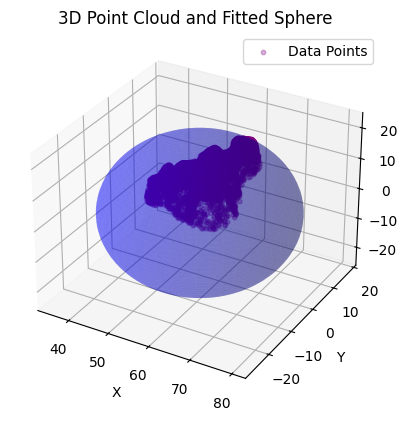

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyransac3d import Sphere

# Assuming 'points' is your Nx3 numpy array of 3D points
# Fit a sphere to the points
    
# open at your risk! This is the grape point cloud manually pasted
data = [[57.416666666666664, -4.944444444444443, 15.277236700057983],
[61.24999999999999, -6.833333333333336, 15.425039529800415],
[51.69444444444444, 1.7222222222222214, 9.185534119606018],
[55.08333333333333, -4.0, 13.569029569625854],
[59.69444444444444, 1.9444444444444429, 14.173808097839355],
[61.30555555555555, -2.0, 15.02789855003357],
[61.69444444444444, 10.5, 11.604753732681274],
[63.08333333333333, -2.944444444444443, 15.115225315093994],
[60.74999999999999, -14.555555555555557, 4.698044061660767],
[52.52777777777777, 2.611111111111107, 9.128379821777344],
[61.80555555555555, -3.388888888888893, 15.358266830444336],
[64.41666666666667, -8.277777777777779, 14.920605421066284],
[52.416666666666664, -1.5, 10.379352569580078],
[63.30555555555555, -7.277777777777779, 15.03306269645691],
[62.638888888888886, 10.055555555555557, 5.064736604690552],
[51.30555555555555, -11.222222222222221, 5.77422559261322],
[66.02777777777779, -14.444444444444446, 11.060323715209961],
[60.36111111111111, 11.277777777777779, 13.038606643676758],
[61.97222222222222, -11.11111111111111, 15.185409784317017],
[52.97222222222222, 0.7222222222222214, 9.601359963417053],
[57.52777777777777, -1.4444444444444429, 12.612518072128296],
[57.36111111111111, -2.8333333333333357, 14.014922380447388],
[57.916666666666664, -8.055555555555557, 16.23189091682434],
[57.30555555555555, 3.055555555555557, 12.806583642959595],
[64.69444444444444, -3.444444444444443, 14.621835947036743],
[50.02777777777777, -10.833333333333336, 8.153505325317383],
[53.74999999999999, -10.277777777777779, 9.70715582370758],
[61.58333333333333, 3.3888888888888857, 13.326338529586792],
[61.02777777777777, -4.333333333333336, 15.427542924880981],
[58.47222222222222, -14.38888888888889, 4.451936781406403],
[50.47222222222222, -12.0, 4.660992622375488],
[59.638888888888886, 13.05555555555555, 12.788753509521484],
[60.47222222222222, -9.722222222222221, 15.750095844268799],
[64.08333333333334, -2.6111111111111143, 14.77857232093811],
[49.58333333333333, -7.388888888888889, 9.748005867004395],
[65.52777777777779, -13.277777777777779, 13.66613507270813],
[59.52777777777777, -4.611111111111114, 15.452754497528076],
[51.97222222222222, -2.944444444444443, 9.74344551563263],
[68.19444444444444, -8.944444444444446, 9.389263391494751],
[58.97222222222222, 7.833333333333329, 12.77288556098938],
[58.30555555555555, 6.166666666666664, 11.90677523612976],
[52.638888888888886, 1.8333333333333286, 9.271126389503479],
[52.52777777777777, 3.6666666666666643, 8.424077033996582],
[56.916666666666664, 0.3333333333333286, 11.51528000831604],
[48.86111111111111, -5.611111111111114, 9.75029468536377],
[63.47222222222222, -15.444444444444446, 5.317002534866333],
[60.916666666666664, 8.055555555555557, 13.404990434646606],
[58.30555555555555, -3.7777777777777786, 15.016696453094482],
[55.80555555555555, 14.05555555555555, 10.246939659118652],
[65.75, -5.666666666666664, 5.069761276245117],
[62.638888888888886, -6.277777777777779, 15.200469493865967],
[63.47222222222222, -3.5, 15.181659460067749],
[60.02777777777777, -4.111111111111114, 15.323693752288818],
[63.36111111111111, -11.055555555555557, 15.002940893173218],
[59.58333333333333, -11.444444444444446, 15.094468593597412],
[53.138888888888886, 2.2777777777777786, 9.138880968093872],
[67.08333333333334, -12.277777777777779, 11.979125738143921],
[55.97222222222222, -11.11111111111111, 15.466567277908325],
[61.638888888888886, 12.944444444444443, 11.42305850982666],
[53.19444444444444, -3.388888888888893, 11.647197008132935],
[63.08333333333333, -13.222222222222221, 13.751634359359741],
[55.74999999999999, 4.444444444444443, 12.495907545089722],
[58.02777777777777, -12.666666666666668, 13.081215620040894],
[59.08333333333333, -4.055555555555557, 15.23034930229187],
[59.80555555555555, 11.333333333333329, 13.030014038085938],
[59.86111111111111, 14.388888888888886, 11.733369827270508],
[57.74999999999999, 12.388888888888886, 12.275583744049072],
[59.30555555555555, 8.666666666666664, 13.117603063583374],
[59.52777777777777, 0.8333333333333286, 14.355645179748535],
[63.80555555555555, -8.444444444444446, 15.019357204437256],
[52.69444444444444, -0.7222222222222214, 10.045353174209595],
[62.58333333333333, 10.333333333333329, 5.301249027252197],
[56.638888888888886, -3.6666666666666643, 14.295867681503296],
[63.80555555555555, -6.444444444444443, 14.93952751159668],
[51.138888888888886, -10.38888888888889, 8.721092343330383],
[59.02777777777777, -10.277777777777779, 15.693696737289429],
[66.69444444444444, -12.5, 12.895255088806152],
[63.86111111111111, -9.277777777777779, 15.021765232086182],
[58.24999999999999, 5.111111111111107, 12.911490201950073],
[60.69444444444444, 8.277777777777779, 13.460026979446411],
[60.80555555555555, -1.3333333333333357, 14.923131465911865],
[57.02777777777777, -4.722222222222221, 15.145900249481201],
[62.02777777777777, -5.722222222222221, 15.43783187866211],
[60.02777777777777, -0.6666666666666714, 14.581903219223022],
[61.916666666666664, -13.833333333333336, 10.798780918121338],
[50.138888888888886, -9.0, 9.631056785583496],
[61.74999999999999, -3.8333333333333357, 15.438779592514038],
[62.19444444444444, 7.388888888888886, 10.679750442504883],
[56.638888888888886, -0.38888888888889284, 11.229079961776733],
[61.638888888888886, -6.222222222222221, 15.436739921569824],
[55.638888888888886, -4.555555555555557, 14.354844093322754],
[67.80555555555556, -11.11111111111111, 8.527392745018005],
[62.58333333333333, -12.666666666666668, 13.8322913646698],
[62.86111111111111, -13.88888888888889, 13.06896448135376],
[62.02777777777777, 0.44444444444444287, 14.234023094177246],
[62.36111111111111, 9.0, 8.868134617805481],
[58.638888888888886, 5.833333333333329, 12.531125545501709],
[56.97222222222222, -0.9444444444444429, 11.668081283569336],
[60.638888888888886, 14.388888888888886, 8.571122884750366],
[60.30555555555555, 6.888888888888886, 13.648346662521362],
[56.916666666666664, -5.5, 15.319832563400269],
[57.74999999999999, 6.333333333333329, 11.321314573287964],
[48.52777777777777, -5.444444444444443, 8.751314282417297],
[62.24999999999999, -14.11111111111111, 11.44783616065979],
[65.97222222222223, -13.88888888888889, 12.706660032272339],
[62.69444444444444, 4.111111111111107, 5.27742326259613],
[55.47222222222222, 13.333333333333329, 7.0111143589019775],
[59.08333333333333, -13.555555555555557, 9.044232964515686],
[52.08333333333333, -9.5, 8.720943331718445],
[62.47222222222222, -3.888888888888893, 15.435138940811157],
[50.02777777777777, -6.777777777777779, 9.670917391777039],
[58.36111111111111, -12.444444444444446, 13.602949380874634],
[64.80555555555556, -13.833333333333336, 13.565932512283325],
[59.69444444444444, -12.055555555555557, 13.293254375457764],
[55.47222222222222, 14.111111111111107, 7.239074110984802],
[56.69444444444444, 0.44444444444444287, 11.68398380279541],
[57.19444444444444, -11.333333333333336, 15.729389190673828],
[56.638888888888886, 8.055555555555557, 7.48676598072052],
[60.916666666666664, 9.111111111111107, 13.361139297485352],
[63.30555555555555, 1.1111111111111072, 10.009666681289673],
[65.52777777777779, -10.0, 14.64678406715393],
[53.74999999999999, -3.555555555555557, 12.435464859008789],
[54.36111111111111, -7.666666666666668, 15.39444088935852],
[55.52777777777777, 13.777777777777779, 7.6645320653915405],
[48.52777777777777, -6.555555555555557, 8.243694305419922],
[59.58333333333333, -2.6666666666666714, 15.19787311553955],
[53.24999999999999, -8.166666666666668, 12.670782804489136],
[54.58333333333333, -9.777777777777779, 14.633229970932007],
[51.19444444444444, -10.055555555555557, 9.073827862739563],
[57.97222222222222, -0.9444444444444429, 13.079577684402466],
[61.138888888888886, -4.888888888888893, 15.508288145065308],
[65.13888888888889, -5.388888888888893, 13.674169778823853],
[65.19444444444444, -13.555555555555557, 13.716520071029663],
[54.638888888888886, -7.5, 15.691574811935425],
[60.30555555555555, -0.44444444444444287, 14.627587795257568],
[49.69444444444444, -9.333333333333336, 9.740836024284363],
[51.30555555555555, -8.777777777777779, 10.307209491729736],
[48.36111111111111, -3.5, 6.913782358169556],
[56.36111111111111, 12.444444444444443, 9.647811651229858],
[62.416666666666664, -2.2777777777777786, 15.032060146331787],
[64.30555555555556, -11.722222222222221, 14.44303274154663],
[66.30555555555556, -12.0, 13.79686713218689],
[53.30555555555555, 5.388888888888886, 10.753915309906006],
[59.74999999999999, 7.722222222222221, 13.344815969467163],
[61.97222222222222, 4.222222222222221, 11.356778144836426],
[49.86111111111111, -2.055555555555557, 8.852336406707764],
[57.19444444444444, 10.722222222222221, 9.998978972434998],
[60.138888888888886, -13.055555555555557, 8.934478759765625],
[59.74999999999999, 11.166666666666664, 12.99912691116333],
[54.916666666666664, 1.7222222222222214, 11.803326606750488],
[64.41666666666667, -4.0, 14.980677366256714],
[58.58333333333333, -0.5555555555555571, 13.603479862213135],
[60.916666666666664, 8.777777777777779, 13.369899988174438],
[61.52777777777777, -7.944444444444446, 15.5856192111969],
[55.638888888888886, 13.0, 7.6574766635894775],
[49.138888888888886, -11.666666666666668, 4.328590035438538],
[64.69444444444444, -7.555555555555557, 14.740005731582642],
[50.08333333333333, -11.88888888888889, 4.882624447345734],
[61.24999999999999, -0.22222222222222143, 14.623156785964966],
[61.74999999999999, 4.388888888888886, 12.44370698928833],
[63.36111111111111, -15.166666666666668, 8.390250205993652],
[56.86111111111111, -13.0, 8.722962141036987],
[61.52777777777777, 7.277777777777779, 13.40397596359253],
[65.30555555555556, -7.333333333333336, 13.727819919586182],
[54.24999999999999, -1.9444444444444429, 11.87266230583191],
[59.74999999999999, -14.444444444444446, 4.379816651344299],
[61.47222222222222, 6.5, 13.2566237449646],
[53.58333333333333, 2.8333333333333286, 9.946289658546448],
[56.36111111111111, -12.333333333333336, 11.661427021026611],
[50.47222222222222, 1.1666666666666643, 6.546467542648315],
[50.416666666666664, -8.166666666666668, 10.8905029296875],
[54.638888888888886, -11.833333333333336, 6.694211959838867],
[61.80555555555555, 6.5, 12.184104919433594],
[61.80555555555555, 1.0555555555555571, 14.03430700302124],
[60.58333333333333, 7.944444444444443, 13.449822664260864],
[55.30555555555555, -11.5, 12.806426286697388],
[58.916666666666664, 5.055555555555557, 13.230680227279663],
[53.138888888888886, 6.666666666666664, 9.547032117843628],
[54.916666666666664, -4.388888888888893, 13.662216663360596],
[49.97222222222222, -10.722222222222221, 8.346150517463684],
[49.916666666666664, -2.6111111111111143, 9.443591237068176],
[59.97222222222222, -4.944444444444443, 15.559333562850952],
[54.69444444444444, -2.944444444444443, 12.648049592971802],
[58.47222222222222, -3.7777777777777786, 15.055519342422485],
[49.916666666666664, -6.666666666666664, 9.612987637519836],
[60.86111111111111, 9.888888888888886, 13.287519216537476],
[56.08333333333333, 2.6666666666666643, 12.543816566467285],
[59.80555555555555, -4.888888888888893, 15.549429655075073],
[64.52777777777779, -2.1111111111111143, 13.992668390274048],
[58.638888888888886, -4.388888888888893, 15.227270126342773],
[58.80555555555555, -10.5, 15.685290098190308],
[61.02777777777777, -9.444444444444446, 15.703779458999634],
[51.80555555555555, -2.555555555555557, 9.41931664943695],
[63.86111111111111, -13.61111111111111, 13.761570453643799],
[53.47222222222222, 3.7777777777777786, 9.63128924369812],
[61.138888888888886, -3.444444444444443, 15.34866452217102],
[65.80555555555556, -10.444444444444446, 14.584232568740845],
[57.52777777777777, 14.444444444444443, 11.064766645431519],
[65.19444444444444, -4.222222222222221, 13.586050271987915],
[55.52777777777777, 14.666666666666664, 6.350278854370117],
[59.138888888888886, 11.166666666666664, 12.86026120185852],
[53.416666666666664, -5.388888888888893, 12.922978401184082],
[50.97222222222222, -10.666666666666668, 7.9678380489349365],
[52.47222222222222, -4.0, 11.129274368286133],
[57.638888888888886, 7.944444444444443, 10.736562013626099],
[62.74999999999999, -2.2222222222222214, 14.949586391448975],
[54.80555555555555, 0.5555555555555571, 11.76170825958252],
[58.86111111111111, 11.777777777777779, 12.732101678848267],
[50.69444444444444, 0.5, 9.396782517433167],
[52.19444444444444, 3.444444444444443, 8.812274932861328],
[64.02777777777779, -10.055555555555557, 15.017050504684448],
[58.58333333333333, 11.833333333333329, 12.58846640586853],
[57.638888888888886, 13.277777777777779, 12.163074016571045],
[56.74999999999999, -1.8333333333333357, 12.56122350692749],
[54.638888888888886, -11.61111111111111, 8.024595379829407],
[55.916666666666664, -5.5, 14.973146915435791],
[57.69444444444444, 6.111111111111107, 11.60884976387024],
[59.47222222222222, -0.44444444444444287, 14.375884532928467],
[57.30555555555555, -11.333333333333336, 15.735148191452026],
[58.19444444444444, -3.1666666666666714, 14.71498966217041],
[51.86111111111111, -1.7222222222222214, 9.935302734375],
[60.47222222222222, 0.8333333333333286, 14.548478126525879],
[62.416666666666664, 7.944444444444443, 8.813044428825378],
[50.58333333333333, -0.22222222222222143, 9.340482354164124],
[57.19444444444444, 0.5555555555555571, 11.497424840927124],
[61.80555555555555, -4.5, 15.513694286346436],
[63.138888888888886, -5.5, 15.200448036193848],
[50.47222222222222, 1.7777777777777786, 4.56785649061203],
[66.08333333333334, -7.555555555555557, 11.49035930633545],
[57.86111111111111, 12.888888888888886, 12.274209260940552],
[57.86111111111111, 10.055555555555557, 11.613736152648926],
[59.19444444444444, 2.1666666666666643, 13.887187242507935],
[66.75, -14.0, 8.826011419296265],
[59.69444444444444, 10.611111111111107, 13.07124376296997],
[56.30555555555555, -3.444444444444443, 13.809139728546143],
[55.416666666666664, 13.666666666666664, 6.537885069847107],
[52.916666666666664, 6.888888888888886, 7.892179489135742],
[67.47222222222223, -9.277777777777779, 13.280338048934937],
[51.97222222222222, -9.222222222222221, 8.978491425514221],
[63.74999999999999, -10.38888888888889, 15.096296072006226],
[60.138888888888886, 7.777777777777779, 13.507261276245117],
[64.36111111111111, -1.6111111111111143, 13.820087909698486],
[59.47222222222222, 14.666666666666664, 10.186173915863037],
[62.416666666666664, 11.222222222222221, 6.049589514732361],
[59.416666666666664, -10.333333333333336, 15.57533860206604],
[67.30555555555556, -12.555555555555557, 10.972135066986084],
[61.19444444444444, -5.222222222222221, 15.587356090545654],
[57.58333333333333, -4.611111111111114, 15.17158031463623],
[56.19444444444444, 3.6666666666666643, 12.714840173721313],
[49.86111111111111, -2.1111111111111143, 8.946303725242615],
[60.47222222222222, -1.6666666666666714, 14.974198341369629],
[53.97222222222222, -1.6666666666666714, 11.681448221206665],
[66.91666666666667, -14.555555555555557, 4.183902740478516],
[67.36111111111111, -7.166666666666664, 5.356473922729492],
[60.638888888888886, -5.722222222222221, 15.655735731124878],
[65.63888888888889, -9.777777777777779, 14.624029397964478],
[61.19444444444444, -5.0, 15.509042739868164],
[65.13888888888889, -12.555555555555557, 13.944451808929443],
[67.97222222222223, -12.333333333333336, 5.586425065994263],
[52.36111111111111, -7.333333333333336, 11.996361017227173],
[52.416666666666664, 4.333333333333329, 8.163971900939941],
[56.69444444444444, -3.2222222222222214, 13.855992555618286],
[64.41666666666667, -9.722222222222221, 15.006814002990723],
[57.916666666666664, 6.111111111111107, 11.676509380340576],
[58.19444444444444, 15.222222222222221, 7.601532340049744],
[54.58333333333333, 0.6111111111111072, 11.553080081939697],
[49.30555555555555, -11.277777777777779, 6.0363417863845825],
[61.638888888888886, -8.833333333333336, 15.655198097229004],
[49.86111111111111, -8.166666666666668, 10.02400517463684],
[54.08333333333333, 2.7222222222222214, 11.187443733215332],
[63.52777777777777, -7.055555555555557, 15.027310848236084],
[52.916666666666664, -10.0, 6.59544050693512],
[59.08333333333333, -0.27777777777777857, 13.97647500038147],
[63.19444444444444, -10.166666666666668, 15.181306600570679],
[64.75, -2.888888888888893, 14.402647018432617],
[59.74999999999999, -10.944444444444446, 15.209579467773438],
[56.47222222222222, 5.111111111111107, 12.979977130889893],
[59.416666666666664, 0.8888888888888857, 14.327327013015747],
[58.30555555555555, -7.166666666666664, 16.008795499801636],
[65.47222222222223, -3.555555555555557, 11.204785108566284],
[55.80555555555555, -4.388888888888893, 14.29175615310669],
[51.138888888888886, -8.277777777777779, 11.327202320098877],
[57.19444444444444, -12.38888888888889, 13.542050123214722],
[61.36111111111111, 12.333333333333329, 12.497032880783081],
[50.02777777777777, -0.055555555555557135, 6.012468934059143],
[61.24999999999999, 9.111111111111107, 13.206217288970947],
[66.91666666666667, -9.222222222222221, 13.921840190887451],
[55.138888888888886, -10.666666666666668, 14.663511514663696],
[50.58333333333333, -10.055555555555557, 9.338347315788269],
[54.52777777777777, 7.111111111111107, 10.615488290786743],
[58.416666666666664, -11.88888888888889, 14.589673280715942],
[50.97222222222222, -9.0, 10.044077634811401],
[59.86111111111111, -4.277777777777779, 15.3090238571167],
[65.19444444444444, -5.722222222222221, 13.043673038482666],
[50.86111111111111, -12.277777777777779, 4.119358062744141],
[56.36111111111111, -0.5555555555555571, 11.479064226150513],
[63.58333333333333, -3.555555555555557, 15.177797079086304],
[65.58333333333334, -4.111111111111114, 9.801679253578186],
[58.58333333333333, -4.277777777777779, 15.208255052566528],
[54.74999999999999, 5.666666666666664, 12.421547174453735],
[61.638888888888886, 0.44444444444444287, 14.406577348709106],
[61.58333333333333, 2.555555555555557, 13.558681011199951],
[57.416666666666664, 0.5, 11.8275785446167],
[60.638888888888886, -2.6666666666666714, 15.157372951507568],
[62.24999999999999, -13.444444444444446, 12.926496267318726],
[64.08333333333334, -4.777777777777779, 15.005894899368286],
[59.47222222222222, 1.7777777777777786, 14.20488715171814],
[57.02777777777777, -1.7777777777777786, 12.549000978469849],
[57.80555555555555, 13.666666666666664, 12.018808126449585],
[52.138888888888886, 6.388888888888886, 7.74811327457428],
[55.24999999999999, 14.05555555555555, 4.704826474189758],
[67.58333333333334, -12.277777777777779, 9.211449027061462],
[66.25, -12.11111111111111, 13.719274997711182],
[57.80555555555555, 12.944444444444443, 12.284961938858032],
[65.80555555555556, -5.166666666666664, 5.325546860694885],
[62.47222222222222, -0.9444444444444429, 14.692608118057251],
[66.19444444444444, -7.333333333333336, 9.964798092842102],
[62.52777777777777, -12.666666666666668, 13.796910047531128],
[61.52777777777777, -5.277777777777779, 15.515882968902588],
[52.02777777777777, -2.388888888888893, 9.628220200538635],
[61.138888888888886, -7.444444444444446, 15.572928190231323],
[62.638888888888886, 10.611111111111107, 4.5740050077438354],
[50.138888888888886, -6.222222222222221, 9.626522660255432],
[59.86111111111111, 8.944444444444443, 13.391790390014648],
[50.74999999999999, -7.555555555555557, 10.823289155960083],
[61.52777777777777, 1.2222222222222214, 14.245431423187256],
[53.08333333333333, -8.222222222222221, 11.954278945922852],
[61.638888888888886, -7.055555555555557, 15.429340600967407],
[59.24999999999999, -1.7777777777777786, 14.819105863571167],
[63.47222222222222, -3.888888888888893, 15.18521785736084],
[64.25, 0.11111111111110716, 7.98498272895813],
[54.02777777777777, 6.166666666666664, 11.640198230743408],
[48.86111111111111, -2.6111111111111143, 8.908483982086182],
[65.08333333333334, -12.833333333333336, 13.930137157440186],
[66.25, -12.055555555555557, 13.80460262298584],
[65.97222222222223, -7.944444444444446, 13.474923372268677],
[49.74999999999999, -0.8888888888888928, 6.111779808998108],
[54.416666666666664, -6.166666666666664, 14.606361389160156],
[63.24999999999999, 1.7222222222222214, 5.4230427742004395],
[58.02777777777777, 8.111111111111107, 11.66016936302185],
[62.58333333333333, 8.111111111111107, 7.076127529144287],
[55.80555555555555, 7.388888888888886, 10.150971412658691],
[60.19444444444444, -12.666666666666668, 10.587445497512817],
[63.416666666666664, -14.777777777777779, 12.757042646408081],
[56.52777777777777, 2.944444444444443, 12.949174642562866],
[65.80555555555556, -5.0, 5.610330104827881],
[59.97222222222222, -8.666666666666668, 16.017651557922363],
[48.638888888888886, -3.7222222222222214, 10.201040506362915],
[59.916666666666664, -8.0, 15.942931175231934],
[62.416666666666664, 1.0, 13.542898893356323],
[57.916666666666664, 7.444444444444443, 11.51339054107666],
[48.97222222222222, -3.3333333333333357, 10.40347695350647],
[60.138888888888886, 7.0, 13.627679347991943],
[59.08333333333333, -12.166666666666668, 13.56913685798645],
[59.74999999999999, -8.11111111111111, 16.0027277469635],
[51.47222222222222, 5.722222222222221, 4.133043587207794],
[61.80555555555555, -3.1111111111111143, 15.276237726211548],
[50.86111111111111, -11.5, 5.600295662879944],
[63.52777777777777, -10.666666666666668, 15.092663764953613],
[63.916666666666664, -15.333333333333332, 6.703394651412964],
[58.52777777777777, 0.7777777777777786, 13.554037809371948],
[58.97222222222222, -4.666666666666664, 15.426902770996094],
[58.138888888888886, -4.555555555555557, 15.260028839111328],
[67.86111111111111, -10.333333333333336, 11.519042253494263],
[56.97222222222222, 14.888888888888886, 8.213635683059692],
[56.97222222222222, -3.1111111111111143, 13.858823776245117],
[57.80555555555555, 9.666666666666664, 11.237577199935913],
[48.30555555555555, -6.833333333333336, 5.407618880271912],
[58.47222222222222, 11.666666666666664, 12.605106830596924],
[58.02777777777777, -0.5555555555555571, 12.679678201675415],
[62.08333333333333, -9.833333333333336, 15.322951078414917],
[61.916666666666664, -2.5, 15.111643075942993],
[57.52777777777777, 5.5, 12.317055463790894],
[50.24999999999999, -6.222222222222221, 9.742291569709778],
[59.97222222222222, -7.944444444444446, 15.948880910873413],
[67.08333333333334, -12.0, 12.414904832839966],
[56.416666666666664, 6.333333333333329, 12.013683319091797],
[59.916666666666664, -2.888888888888893, 15.251932144165039],
[65.25, -9.5, 14.809223413467407],
[49.916666666666664, -10.333333333333336, 9.298914670944214],
[61.24999999999999, -3.055555555555557, 15.269190073013306],
[54.47222222222222, -3.1666666666666714, 12.666759490966797],
[59.916666666666664, 10.333333333333329, 13.23010802268982],
[60.30555555555555, -5.055555555555557, 15.572371482849121],
[66.47222222222223, -8.722222222222221, 14.004075527191162],
[48.30555555555555, -4.444444444444443, 6.162225008010864],
[56.638888888888886, 0.7777777777777786, 12.029834985733032],
[59.74999999999999, 5.5, 13.585153818130493],
[50.80555555555555, -3.7777777777777786, 8.835188746452332],
[61.97222222222222, 11.833333333333329, 9.27427351474762],
[48.86111111111111, -2.2222222222222214, 7.535571455955505],
[55.74999999999999, 1.8888888888888857, 12.164644002914429],
[54.86111111111111, 6.611111111111107, 12.11491584777832],
[62.916666666666664, -4.888888888888893, 15.360168218612671],
[56.416666666666664, 1.7222222222222214, 12.191871404647827],
[65.75, -10.944444444444446, 14.566364288330078],
[59.69444444444444, -10.88888888888889, 15.306394100189209],
[52.74999999999999, -10.11111111111111, 6.674827933311462],
[51.02777777777777, -4.833333333333336, 9.456143379211426],
[61.416666666666664, -7.5, 15.5819833278656],
[50.416666666666664, -7.055555555555557, 9.756369590759277],
[57.97222222222222, -11.555555555555557, 15.377280712127686],
[60.47222222222222, 12.05555555555555, 13.024284839630127],
[60.86111111111111, 6.166666666666664, 13.644202947616577],
[61.47222222222222, 10.722222222222221, 12.577292919158936],
[63.19444444444444, -5.555555555555557, 15.198698043823242],
[61.58333333333333, 14.166666666666664, 7.155090570449829],
[67.02777777777779, -7.5, 8.673917651176453],
[52.30555555555555, 3.7222222222222214, 8.418521881103516],
[64.02777777777779, -4.055555555555557, 15.081371068954468],
[59.80555555555555, 7.944444444444443, 13.388310670852661],
[60.19444444444444, -8.166666666666668, 15.957837104797363],
[59.416666666666664, -13.222222222222221, 9.957404732704163],
[49.47222222222222, -9.61111111111111, 9.969210624694824],
[60.47222222222222, -14.333333333333336, 5.11413037776947],
[56.24999999999999, -1.3333333333333357, 12.241700887680054],
[65.97222222222223, -11.833333333333336, 14.129995107650757],
[60.86111111111111, 7.444444444444443, 13.491076231002808],
[62.02777777777777, -7.388888888888889, 15.42565107345581],
[52.138888888888886, -3.7222222222222214, 10.56656002998352],
[65.86111111111111, -6.444444444444443, 4.787485897541046],
[60.36111111111111, 0.27777777777777857, 14.582054615020752],
[66.75, -14.38888888888889, 5.999665260314941],
[56.47222222222222, -9.055555555555557, 16.022948026657104],
[65.97222222222223, -6.722222222222221, 6.393797397613525],
[60.30555555555555, 8.388888888888886, 13.429005146026611],
[58.02777777777777, -5.666666666666664, 15.48258900642395],
[56.916666666666664, -5.222222222222221, 15.26712417602539],
[52.69444444444444, -8.833333333333336, 9.593483805656433],
[55.08333333333333, -2.8333333333333357, 12.852815389633179],
[50.36111111111111, -9.88888888888889, 9.38809871673584],
[53.19444444444444, 4.777777777777779, 9.659352898597717],
[50.19444444444444, -12.055555555555557, 4.294800162315369],
[56.47222222222222, -13.166666666666668, 6.23961865901947],
[63.74999999999999, -6.5, 14.94266390800476],
[64.91666666666667, -8.833333333333336, 14.885410070419312],
[51.02777777777777, -0.22222222222222143, 10.257138013839722],
[53.138888888888886, -2.388888888888893, 10.986741781234741],
[51.74999999999999, -2.7222222222222214, 9.375733733177185],
[57.58333333333333, 12.944444444444443, 12.222501039505005],
[57.69444444444444, -6.111111111111114, 15.547738075256348],
[58.02777777777777, 12.888888888888886, 12.347105741500854],
[58.97222222222222, 8.944444444444443, 12.846566438674927],
[58.36111111111111, -1.3333333333333357, 13.921478986740112],
[53.30555555555555, 4.888888888888886, 9.956932663917542],
[56.24999999999999, -2.388888888888893, 12.744841575622559],
[61.58333333333333, -14.88888888888889, 5.8134132623672485],
[61.24999999999999, 5.222222222222221, 13.670909404754639],
[59.36111111111111, 3.1666666666666643, 13.831418752670288],
[58.08333333333333, 5.166666666666664, 12.750892639160156],
[57.58333333333333, -7.111111111111114, 15.99652647972107],
[48.86111111111111, -5.055555555555557, 9.921884536743164],
[57.97222222222222, 5.833333333333329, 12.05916166305542],
[64.97222222222223, -10.555555555555557, 14.755891561508179],
[57.138888888888886, 1.1666666666666643, 11.73144817352295],
[65.47222222222223, -13.666666666666668, 13.54426622390747],
[63.416666666666664, -3.5, 15.18413782119751],
[50.30555555555555, -2.7222222222222214, 9.16339635848999],
[53.138888888888886, 7.055555555555557, 7.695766091346741],
[64.13888888888889, -7.0, 14.840368032455444],
[56.638888888888886, 4.166666666666664, 12.822037935256958],
[52.36111111111111, -2.3333333333333357, 9.94912564754486],
[54.74999999999999, 0.27777777777777857, 11.747363805770874],
[63.416666666666664, -14.944444444444446, 11.01037859916687],
[48.36111111111111, -7.666666666666668, 6.447542905807495],
[59.02777777777777, -6.833333333333336, 15.930103063583374],
[53.74999999999999, -1.2777777777777786, 11.40840768814087],
[55.30555555555555, -6.833333333333336, 15.966178178787231],
[49.36111111111111, -8.11111111111111, 10.169525146484375],
[51.24999999999999, -11.777777777777779, 4.589590132236481],
[61.69444444444444, -8.0, 15.58445692062378],
[60.47222222222222, -14.166666666666668, 5.680382251739502],
[54.24999999999999, 4.944444444444443, 11.541789770126343],
[57.86111111111111, -13.777777777777779, 7.1390604972839355],
[59.52777777777777, -3.5, 15.236951112747192],
[61.86111111111111, -5.666666666666664, 15.516936779022217],
[61.47222222222222, 7.666666666666664, 13.388700485229492],
[56.638888888888886, -12.555555555555557, 11.823285818099976],
[50.08333333333333, -1.3888888888888928, 8.213984966278076],
[61.69444444444444, 6.777777777777779, 12.67419695854187],
[54.86111111111111, -8.11111111111111, 15.994832515716553],
[65.69444444444444, -8.11111111111111, 14.311110973358154],
[65.41666666666667, -13.055555555555557, 13.71852993965149],
[66.86111111111111, -11.666666666666668, 13.476647138595581],
[55.52777777777777, -12.722222222222221, 5.327267646789551],
[55.47222222222222, 3.2222222222222214, 12.648253440856934],
[50.02777777777777, -9.444444444444446, 9.382928013801575],
[59.30555555555555, -5.0, 15.521208047866821],
[54.97222222222222, -11.666666666666668, 9.846194386482239],
[55.97222222222222, 4.111111111111107, 12.531185150146484],
[49.416666666666664, -1.2222222222222214, 5.8791184425354],
[52.916666666666664, 4.666666666666664, 9.042409062385559],
[53.02777777777777, 2.7777777777777786, 8.866646885871887],
[58.47222222222222, 12.111111111111107, 12.581477165222168],
[60.24999999999999, 12.333333333333329, 13.019134998321533],
[59.36111111111111, 7.333333333333329, 13.019031286239624],
[51.69444444444444, 3.7222222222222214, 5.604463815689087],
[51.97222222222222, 4.5, 7.211120128631592],
[59.47222222222222, -0.9444444444444429, 14.588351249694824],
[60.08333333333333, 10.388888888888886, 13.192528486251831],
[55.138888888888886, -2.6666666666666714, 12.720370292663574],
[53.08333333333333, -3.7777777777777786, 11.722017526626587],
[62.74999999999999, -13.0, 13.672370910644531],
[53.02777777777777, -8.777777777777779, 10.174096822738647],
[61.47222222222222, -0.7777777777777786, 14.793192148208618],
[61.30555555555555, -2.444444444444443, 15.10648488998413],
[59.86111111111111, 3.3333333333333286, 13.98114562034607],
[51.19444444444444, 0.6666666666666643, 9.616703987121582],
[49.86111111111111, -11.666666666666668, 5.518617033958435],
[63.638888888888886, -8.61111111111111, 15.02548098564148],
[57.58333333333333, -5.833333333333336, 15.5107581615448],
[62.138888888888886, 6.666666666666664, 10.771455764770508],
[66.02777777777779, -6.833333333333336, 7.310048341751099],
[56.58333333333333, 3.6666666666666643, 12.923215627670288],
[58.24999999999999, -5.111111111111114, 15.393275022506714],
[52.58333333333333, -0.6666666666666714, 10.0836181640625],
[51.80555555555555, -4.055555555555557, 10.107804536819458],
[61.74999999999999, 8.333333333333329, 12.399535179138184],
[58.69444444444444, 0.5555555555555571, 13.633595705032349],
[67.47222222222223, -11.61111111111111, 11.745342016220093],
[48.30555555555555, -2.444444444444443, 4.737004935741425],
[61.02777777777777, -13.88888888888889, 7.926990985870361],
[56.58333333333333, -8.11111111111111, 16.24895215034485],
[60.80555555555555, 12.333333333333329, 12.978252172470093],
[54.19444444444444, 1.4444444444444429, 11.245604753494263],
[57.58333333333333, 3.8333333333333286, 13.074663877487183],
[62.30555555555555, -3.1666666666666714, 15.273778438568115],
[61.74999999999999, 10.5, 11.222543716430664],
[59.74999999999999, 7.944444444444443, 13.287920951843262],
[66.58333333333334, -8.222222222222221, 13.469318151473999],
[59.80555555555555, 1.6666666666666643, 14.279441833496094],
[59.916666666666664, 7.333333333333329, 13.456056118011475],
[56.74999999999999, -5.0, 15.092709064483643],
[67.19444444444444, -11.944444444444446, 12.260379791259766],
[58.638888888888886, 13.611111111111107, 12.334245443344116],
[66.75, -11.166666666666668, 14.086813926696777],
[48.52777777777777, -8.0, 8.852301836013794],
[58.02777777777777, 9.777777777777779, 11.918251514434814],
[58.138888888888886, 2.444444444444443, 13.077895641326904],
[57.74999999999999, -8.166666666666668, 16.237870454788208],
[57.47222222222222, -13.055555555555557, 9.93817150592804],
[63.69444444444444, -4.166666666666664, 15.179463624954224],
[62.74999999999999, -1.4444444444444429, 14.765350818634033],
[63.416666666666664, -11.88888888888889, 14.58611011505127],
[61.30555555555555, 12.5, 12.515730857849121],
[60.02777777777777, 9.333333333333329, 13.357884883880615],
[63.638888888888886, -3.944444444444443, 15.17932653427124],
[65.25, -0.9444444444444429, 5.361670255661011],
[62.638888888888886, -8.222222222222221, 15.26943325996399],
[59.24999999999999, 10.777777777777779, 12.894095182418823],
[61.916666666666664, -4.888888888888893, 15.513519048690796],
[58.58333333333333, 9.777777777777779, 12.639919519424438],
[53.86111111111111, -6.888888888888893, 14.079726934432983],
[65.02777777777779, -13.5, 13.737350702285767],
[60.58333333333333, -8.222222222222221, 15.869394540786743],
[58.80555555555555, -1.6111111111111143, 14.406653642654419],
[57.36111111111111, -4.111111111111114, 14.779961109161377],
[66.86111111111111, -7.833333333333336, 11.382995843887329],
[49.36111111111111, -3.2222222222222214, 10.708423852920532],
[62.74999999999999, 0.27777777777777857, 13.95567536354065],
[64.19444444444444, 0.9444444444444429, 4.082852005958557],
[63.36111111111111, -15.444444444444446, 5.263448357582092],
[52.30555555555555, 0.6111111111111072, 10.135127305984497],
[52.86111111111111, 5.611111111111107, 10.182455778121948],
[50.36111111111111, -6.5, 9.787731170654297],
[48.69444444444444, -11.222222222222221, 6.040210723876953],
[58.30555555555555, 7.055555555555557, 11.870287656784058],
[51.916666666666664, -5.0, 11.1752188205719],
[66.86111111111111, -14.555555555555557, 4.493780136108398],
[67.97222222222223, -8.61111111111111, 11.742024421691895],
[63.86111111111111, -4.611111111111114, 15.096312761306763],
[57.52777777777777, 11.277777777777779, 11.612882614135742],
[49.74999999999999, -7.277777777777779, 9.722546935081482],
[64.30555555555556, -13.055555555555557, 13.865201473236084],
[55.30555555555555, -0.7222222222222214, 11.98715329170227],
[61.86111111111111, -1.8333333333333357, 15.03474235534668],
[62.02777777777777, 13.611111111111107, 6.744995713233948],
[61.58333333333333, -13.777777777777779, 9.412882328033447],
[59.416666666666664, 14.333333333333329, 12.016005516052246],
[64.80555555555556, -5.111111111111114, 14.20690655708313],
[56.638888888888886, -12.88888888888889, 9.00347650051117],
[65.58333333333334, -13.277777777777779, 13.654452562332153],
[60.36111111111111, 0.6666666666666643, 14.533681869506836],
[64.69444444444444, -2.888888888888893, 14.462828636169434],
[67.69444444444444, -11.944444444444446, 9.311294555664062],
[53.47222222222222, 3.3333333333333286, 9.81902539730072],
[48.416666666666664, -11.222222222222221, 4.613993465900421],
[57.52777777777777, -10.944444444444446, 15.85081696510315],
[58.80555555555555, 1.5, 13.737095594406128],
[57.02777777777777, -13.055555555555557, 8.767186999320984],
[58.58333333333333, -4.666666666666664, 15.324556827545166],
[58.02777777777777, 4.5, 13.10492753982544],
[61.02777777777777, -8.055555555555557, 15.716639757156372],
[61.52777777777777, -2.7777777777777786, 15.193778276443481],
[53.638888888888886, 3.7222222222222214, 10.080764293670654],
[58.36111111111111, -3.8333333333333357, 15.036917924880981],
[61.30555555555555, 10.0, 12.998119592666626],
[58.36111111111111, -3.444444444444443, 14.879276752471924],
[61.80555555555555, -11.38888888888889, 15.096856355667114],
[54.47222222222222, -3.8333333333333357, 13.01026701927185],
[59.19444444444444, -2.888888888888893, 15.060925483703613],
[59.80555555555555, 13.222222222222221, 12.797284126281738],
[56.80555555555555, -4.166666666666664, 14.629720449447632],
[50.19444444444444, -4.222222222222221, 9.143585562705994],
[60.74999999999999, 10.833333333333329, 13.059325218200684],
[55.638888888888886, 14.666666666666664, 7.3030686378479],
[52.30555555555555, -0.055555555555557135, 9.817395210266113],
[53.52777777777777, -10.055555555555557, 9.173877239227295],
[50.24999999999999, -11.833333333333336, 5.121687650680542],
[56.24999999999999, 15.05555555555555, 5.908999443054199],
[64.86111111111111, -10.777777777777779, 14.762704372406006],
[56.97222222222222, -12.722222222222221, 11.209951639175415],
[61.02777777777777, 13.111111111111107, 12.60938286781311],
[51.86111111111111, -4.944444444444443, 11.076867580413818],
[60.638888888888886, -12.222222222222221, 12.294303178787231],
[57.138888888888886, 11.444444444444443, 10.762948989868164],
[52.19444444444444, -6.222222222222221, 12.224706411361694],
[61.86111111111111, 7.555555555555557, 12.088786363601685],
[62.19444444444444, 0.055555555555557135, 14.379218816757202],
[53.80555555555555, 1.7222222222222214, 10.24520993232727],
[55.69444444444444, 3.0, 12.522197961807251],
[63.47222222222222, 0.22222222222222143, 12.311311960220337],
[65.75, -6.944444444444443, 10.542888641357422],
[55.24999999999999, -4.388888888888893, 13.907840251922607],
[61.80555555555555, -2.3333333333333357, 15.111616849899292],
[58.69444444444444, 14.611111111111107, 10.56408405303955],
[48.916666666666664, -5.277777777777779, 9.921785593032837],
[58.74999999999999, -11.61111111111111, 14.948495626449585],
[52.916666666666664, -0.055555555555557135, 9.85211730003357],
[65.30555555555556, -4.111111111111114, 12.476834058761597],
[58.19444444444444, 1.7777777777777786, 12.98001766204834],
[54.69444444444444, 6.555555555555557, 12.111085653305054],
[63.30555555555555, 0.7777777777777786, 11.546781063079834],
[49.36111111111111, -4.611111111111114, 10.332237482070923],
[63.638888888888886, -8.555555555555557, 15.02509593963623],
[61.97222222222222, -12.777777777777779, 13.099600076675415],
[63.19444444444444, 1.4444444444444429, 8.956687450408936],
[53.02777777777777, -1.5, 10.414707660675049],
[56.138888888888886, 13.444444444444443, 10.805201530456543],
[63.52777777777777, 0.38888888888888573, 11.516302824020386],
[66.91666666666667, -9.61111111111111, 13.91268253326416],
[49.916666666666664, -0.44444444444444287, 6.019614338874817],
[61.52777777777777, -13.88888888888889, 8.883943557739258],
[48.69444444444444, -3.3333333333333357, 9.832741618156433],
[63.74999999999999, -2.0, 14.49897050857544],
[48.75, -7.777777777777779, 9.480770826339722],
[64.19444444444444, -7.944444444444446, 14.925792217254639],
[52.74999999999999, -9.222222222222221, 8.405596613883972],
[65.58333333333334, -9.444444444444446, 14.682984352111816],
[65.63888888888889, -10.277777777777779, 14.663975238800049],
[54.97222222222222, 1.8333333333333286, 11.786911487579346],
[60.30555555555555, 1.3333333333333286, 14.447429180145264],
[50.638888888888886, 1.3333333333333286, 7.172763347625732],
[57.138888888888886, 1.5, 11.722426414489746],
[65.69444444444444, -4.444444444444443, 7.56841778755188],
[49.69444444444444, -11.38888888888889, 6.370446681976318],
[57.69444444444444, 3.7222222222222214, 13.134771585464478],
[63.638888888888886, -9.88888888888889, 15.101500749588013],
[51.08333333333333, -5.944444444444443, 10.656689405441284],
[64.25, -7.888888888888889, 14.923251867294312],
[65.80555555555556, -13.222222222222221, 13.54382038116455],
[57.08333333333333, -2.444444444444443, 13.519068956375122],
[60.30555555555555, 12.611111111111107, 12.916011810302734],
[50.08333333333333, -3.388888888888893, 8.608425259590149],
[59.138888888888886, -13.666666666666668, 8.673993349075317],
[64.19444444444444, -7.444444444444446, 14.92016077041626],
[57.80555555555555, 13.0, 12.293027639389038],
[63.138888888888886, -10.944444444444446, 15.156614780426025],
[56.138888888888886, 4.722222222222221, 12.76277780532837],
[60.19444444444444, 7.166666666666664, 13.592971563339233],
[54.08333333333333, 0.5555555555555571, 11.047437191009521],
[66.19444444444444, -7.666666666666668, 11.684129238128662],
[52.19444444444444, 4.5, 8.295632004737854],
[57.08333333333333, 1.5, 11.76301121711731],
[51.916666666666664, -2.388888888888893, 9.550042152404785],
[55.86111111111111, 5.111111111111107, 12.865281105041504],
[62.24999999999999, 2.6666666666666643, 10.81928014755249],
[60.24999999999999, 6.888888888888886, 13.655736446380615],
[53.74999999999999, -8.5, 13.690325021743774],
[65.47222222222223, -11.61111111111111, 14.425477981567383],
[63.24999999999999, -6.888888888888893, 15.035463571548462],
[59.08333333333333, -4.888888888888893, 15.514479875564575],
[56.69444444444444, -7.055555555555557, 16.07264757156372],
[50.638888888888886, -4.888888888888893, 9.039584994316101],
[60.02777777777777, 11.0, 13.151031732559204],
[52.97222222222222, 2.611111111111107, 8.862053155899048],
[56.02777777777777, -1.5, 12.177287340164185],
[58.638888888888886, -1.0555555555555571, 13.977818489074707],
[59.24999999999999, 4.833333333333329, 13.522205352783203],
[60.30555555555555, 10.055555555555557, 13.26270580291748],
[60.24999999999999, 5.944444444444443, 13.832106590270996],
[56.08333333333333, -0.8333333333333357, 11.755359172821045],
[54.138888888888886, 0.38888888888888573, 11.167629957199097],
[58.86111111111111, 1.7222222222222214, 13.690781593322754],
[64.86111111111111, -8.11111111111111, 14.770909547805786],
[58.74999999999999, 15.222222222222221, 7.1850502490997314],
[52.19444444444444, 0.055555555555557135, 9.877023100852966],
[64.13888888888889, -3.2777777777777786, 14.971245527267456],
[63.24999999999999, -12.722222222222221, 14.041783809661865],
[61.08333333333333, -10.5, 15.442676544189453],
[52.69444444444444, 6.166666666666664, 9.573554396629333],
[65.25, -3.388888888888893, 13.264371156692505],
[62.80555555555555, -6.944444444444443, 15.197149515151978],
[53.80555555555555, -10.0, 10.765947103500366],
[50.47222222222222, -6.666666666666664, 9.787333011627197],
[61.80555555555555, -13.722222222222221, 10.600298643112183],
[59.638888888888886, 7.888888888888886, 13.234930038452148],
[51.86111111111111, -5.555555555555557, 11.458770036697388],
[67.41666666666667, -9.5, 13.317372798919678],
[56.638888888888886, 4.666666666666664, 12.905008792877197],
[60.19444444444444, 1.0, 14.543766975402832],
[67.41666666666667, -13.38888888888889, 6.5517377853393555],
[53.36111111111111, -10.222222222222221, 8.001086711883545],
[54.58333333333333, 7.944444444444443, 5.64050018787384],
[63.97222222222222, -14.777777777777779, 13.04944634437561],
[51.97222222222222, -4.611111111111114, 10.907957553863525],
[59.74999999999999, -6.222222222222221, 15.860991477966309],
[63.24999999999999, -5.666666666666664, 15.118590593338013],
[57.138888888888886, 14.833333333333329, 8.667033910751343],
[56.97222222222222, 11.611111111111107, 10.218582153320312],
[51.69444444444444, 3.944444444444443, 5.786842703819275],
[60.74999999999999, 4.444444444444443, 13.989794254302979],
[56.138888888888886, 0.6111111111111072, 11.786518096923828],
[62.19444444444444, 5.555555555555557, 10.22244930267334],
[61.36111111111111, -14.11111111111111, 7.842773199081421],
[51.74999999999999, 3.3333333333333286, 6.13666832447052],
[52.36111111111111, -4.555555555555557, 11.318657398223877],
[64.02777777777779, -1.3888888888888928, 13.945227861404419],
[62.19444444444444, -10.277777777777779, 15.31168818473816],
[57.916666666666664, -12.055555555555557, 14.690067768096924],
[60.08333333333333, -6.611111111111114, 15.804027318954468],
[58.80555555555555, -1.7777777777777786, 14.544991254806519],
[53.416666666666664, 3.8333333333333286, 9.440639615058899],
[60.24999999999999, 1.4444444444444429, 14.362839460372925],
[53.916666666666664, -3.555555555555557, 12.545491456985474],
[53.69444444444444, 1.6666666666666643, 9.99075472354889],
[55.86111111111111, 0.1666666666666643, 11.5924072265625],
[58.80555555555555, 6.444444444444443, 12.162446975708008],
[49.52777777777777, -6.777777777777779, 9.608558416366577],
[58.08333333333333, -0.1666666666666714, 12.441754341125488],
[51.416666666666664, 5.555555555555557, 4.141128659248352],
[59.19444444444444, -11.0, 15.33909797668457],
[63.138888888888886, -1.0, 14.415744543075562],
[48.97222222222222, -5.611111111111114, 9.904749393463135],
[61.47222222222222, 1.6111111111111072, 14.089484214782715],
[56.36111111111111, 13.111111111111107, 11.004761457443237],
[63.86111111111111, -3.944444444444443, 15.089806318283081],
[49.36111111111111, -8.277777777777779, 10.167661905288696],
[58.416666666666664, 5.833333333333329, 12.327649593353271],
[56.24999999999999, -3.6666666666666643, 13.913928270339966],
[61.36111111111111, 0.22222222222222143, 14.519166946411133],
[59.19444444444444, -5.111111111111114, 15.59544563293457],
[57.86111111111111, 4.722222222222221, 12.941274642944336],
[58.74999999999999, 6.333333333333329, 12.172049283981323],
[58.638888888888886, 12.05555555555555, 12.57511019706726],
[65.02777777777779, -1.6111111111111143, 11.50420069694519],
[64.97222222222223, -12.055555555555557, 14.204546213150024],
[61.74999999999999, -12.055555555555557, 14.320993423461914],
[52.08333333333333, 4.222222222222221, 7.4653273820877075],
[50.74999999999999, -2.3333333333333357, 9.228296279907227],
[62.24999999999999, 4.611111111111107, 9.992536902427673],
[50.80555555555555, -7.888888888888889, 11.474354267120361],
[59.97222222222222, 11.888888888888886, 13.020578622817993],
[54.69444444444444, -8.0, 15.761359930038452],
[59.416666666666664, -12.166666666666668, 13.220841884613037],
[60.916666666666664, -4.666666666666664, 15.5058753490448],
[59.69444444444444, -6.388888888888893, 15.859113931655884],
[57.08333333333333, -6.111111111111114, 15.569639205932617],
[56.74999999999999, -11.944444444444446, 14.065419435501099],
[64.63888888888889, -4.777777777777779, 14.583617448806763],
[58.30555555555555, -1.1111111111111143, 13.63174557685852],
[60.58333333333333, -8.61111111111111, 15.868223905563354],
[54.58333333333333, -4.333333333333336, 13.325756788253784],
[60.30555555555555, -12.166666666666668, 12.491215467453003],
[57.69444444444444, -13.88888888888889, 5.8243221044540405],
[56.24999999999999, -12.555555555555557, 10.131534337997437],
[50.80555555555555, -5.833333333333336, 10.682895183563232],
[55.47222222222222, -5.777777777777779, 15.09732961654663],
[58.86111111111111, -1.7777777777777786, 14.5792555809021],
[60.08333333333333, 3.8333333333333286, 14.117393493652344],
[53.916666666666664, -6.111111111111114, 14.041779041290283],
[61.138888888888886, -13.777777777777779, 8.543537855148315],
[66.86111111111111, -7.277777777777779, 7.427538633346558],
[62.47222222222222, 9.722222222222221, 6.7983609437942505],
[52.02777777777777, 2.2777777777777786, 9.074057340621948],
[50.47222222222222, -10.944444444444446, 7.576658725738525],
[59.58333333333333, 10.277777777777779, 13.151533603668213],
[49.47222222222222, -5.888888888888893, 10.110903978347778],
[54.30555555555555, -8.11111111111111, 15.307267904281616],
[50.08333333333333, -11.0, 7.766197919845581],
[49.74999999999999, -2.5, 9.670405387878418],
[61.86111111111111, -4.833333333333336, 15.513334274291992],
[56.36111111111111, 4.277777777777779, 12.724001407623291],
[66.80555555555556, -14.38888888888889, 5.6493037939071655],
[60.86111111111111, -0.055555555555557135, 14.682201147079468],
[56.638888888888886, 12.166666666666664, 10.634822845458984],
[58.24999999999999, -8.0, 16.163740158081055],
[62.58333333333333, -6.5, 15.198262929916382],
[51.58333333333333, 5.166666666666664, 5.502217411994934],
[56.30555555555555, 14.05555555555555, 11.07155442237854],
[67.30555555555556, -13.0, 8.962274193763733],
[58.416666666666664, -12.055555555555557, 14.364650249481201],
[57.02777777777777, 13.277777777777779, 11.8960702419281],
[59.97222222222222, -9.5, 15.911521911621094],
[63.416666666666664, -4.888888888888893, 15.192004442214966],
[64.91666666666667, -10.333333333333336, 14.831886291503906],
[50.416666666666664, -6.0, 10.037667751312256],
[56.74999999999999, 11.611111111111107, 8.550317287445068],
[56.80555555555555, 10.166666666666664, 6.104767918586731],
[59.138888888888886, -5.388888888888893, 15.594110488891602],
[66.69444444444444, -9.0, 13.945502042770386],
[51.36111111111111, -4.388888888888893, 9.793869256973267],
[55.02777777777777, -10.722222222222221, 14.236371517181396],
[60.24999999999999, -8.38888888888889, 15.951967239379883],
[58.138888888888886, -12.166666666666668, 14.318115711212158],
[52.52777777777777, -4.222222222222221, 11.332095861434937],
[60.52777777777777, 12.722222222222221, 12.95087218284607],
[61.69444444444444, 11.277777777777779, 11.31956696510315],
[64.47222222222223, -15.555555555555557, 4.075059592723846],
[56.80555555555555, -9.38888888888889, 16.020256280899048],
[60.58333333333333, 7.555555555555557, 13.5657799243927],
[58.02777777777777, 6.333333333333329, 11.447842121124268],
[64.41666666666667, -14.38888888888889, 13.24181318283081],
[62.916666666666664, 1.2777777777777786, 11.589295864105225],
[63.97222222222222, -11.61111111111111, 14.530227184295654],
[59.30555555555555, 0.8333333333333286, 14.254329204559326],
[52.52777777777777, -8.222222222222221, 11.561466455459595],
[53.30555555555555, -8.166666666666668, 12.835633754730225],
[53.69444444444444, 3.944444444444443, 10.098382234573364],
[62.69444444444444, -7.111111111111114, 15.195404291152954],
[57.02777777777777, -10.0, 16.009517908096313],
[55.638888888888886, -0.9444444444444429, 11.854816675186157],
[60.80555555555555, -0.7777777777777786, 14.764448404312134],
[48.75, -4.166666666666664, 10.175086259841919],
[52.52777777777777, -9.444444444444446, 8.23237955570221],
[64.47222222222223, -12.88888888888889, 13.951047658920288],
[57.416666666666664, 13.333333333333329, 12.088173627853394],
[55.74999999999999, 12.833333333333329, 7.826690673828125],
[51.97222222222222, -6.777777777777779, 11.803336143493652],
[59.86111111111111, -5.444444444444443, 15.710734128952026],
[60.02777777777777, -3.944444444444443, 15.323233604431152],
[62.47222222222222, 12.333333333333329, 4.256604611873627],
[55.916666666666664, 13.55555555555555, 10.410299301147461],
[58.47222222222222, 13.111111111111107, 12.448387145996094],
[61.638888888888886, 6.611111111111107, 12.904527187347412],
[61.69444444444444, 1.8333333333333286, 13.658225536346436],
[55.80555555555555, -8.61111111111111, 16.233153343200684],
[60.69444444444444, 8.444444444444443, 13.395414352416992],
[50.97222222222222, -11.222222222222221, 6.209784150123596],
[61.138888888888886, -7.833333333333336, 15.646675825119019],
[60.36111111111111, 1.3333333333333286, 14.447931051254272],
[52.24999999999999, -4.5, 11.159158945083618],
[63.86111111111111, -1.5555555555555571, 14.18376088142395],
[62.416666666666664, -9.333333333333336, 15.261527299880981],
[59.02777777777777, -3.1111111111111143, 15.049114227294922],
[51.58333333333333, -2.888888888888893, 9.155780673027039],
[56.97222222222222, -9.333333333333336, 16.098397970199585],
[56.638888888888886, 2.3888888888888857, 12.47581958770752],
[61.36111111111111, 11.611111111111107, 12.465959787368774],
[65.91666666666667, -13.166666666666668, 13.488743305206299],
[60.97222222222222, -13.944444444444446, 7.604790925979614],
[56.36111111111111, -5.166666666666664, 15.028311014175415],
[61.86111111111111, 8.777777777777779, 11.859546899795532],
[62.916666666666664, -11.666666666666668, 14.865641593933105],
[52.69444444444444, 4.388888888888886, 8.397478461265564],
[63.52777777777777, -8.166666666666668, 15.02554178237915],
[53.416666666666664, 0.8888888888888857, 10.233901739120483],
[57.638888888888886, -9.222222222222221, 16.17958426475525],
[64.02777777777779, -9.5, 15.015701055526733],
[59.47222222222222, 9.388888888888886, 13.232957124710083],
[57.916666666666664, -13.88888888888889, 6.6852980852127075],
[62.58333333333333, 5.333333333333329, 6.611042022705078],
[50.30555555555555, -4.5, 9.269092679023743],
[58.47222222222222, -9.222222222222221, 16.161354780197144],
[59.08333333333333, 11.444444444444443, 12.820909023284912],
[58.47222222222222, 13.277777777777779, 12.427722215652466],
[59.52777777777777, -0.6111111111111143, 14.41357970237732],
[48.86111111111111, -6.5, 9.273684024810791],
[57.916666666666664, -7.277777777777779, 16.08438491821289],
[61.69444444444444, 5.444444444444443, 12.745188474655151],
[54.30555555555555, -11.444444444444446, 6.631668210029602],
[50.638888888888886, -6.888888888888893, 9.652496576309204],
[50.47222222222222, -1.4444444444444429, 9.312951564788818],
[58.916666666666664, -11.555555555555557, 15.001600980758667],
[63.30555555555555, -2.2777777777777786, 14.840399026870728],
[59.19444444444444, 5.944444444444443, 12.895350456237793],
[64.75, -13.38888888888889, 13.75457763671875],
[60.36111111111111, 10.055555555555557, 13.25548768043518],
[58.30555555555555, 6.388888888888886, 11.650896072387695],
[48.47222222222222, -3.944444444444443, 8.528851866722107],
[65.75, -5.166666666666664, 6.430444121360779],
[61.08333333333333, 9.0, 13.288629055023193],
[54.36111111111111, 0.11111111111110716, 11.618975400924683],
[58.58333333333333, -3.944444444444443, 15.097821950912476],
[63.86111111111111, -1.3888888888888928, 14.140743017196655],
[50.36111111111111, 1.5555555555555571, 4.537627696990967],
[58.52777777777777, -3.0, 14.810035228729248],
[58.08333333333333, -3.444444444444443, 14.791830778121948],
[48.69444444444444, -2.555555555555557, 8.308737874031067],
[59.138888888888886, -8.88888888888889, 16.077003479003906],
[52.08333333333333, 6.944444444444443, 4.557456374168396],
[57.02777777777777, 1.0555555555555571, 11.801635026931763],
[58.86111111111111, 12.0, 12.708824872970581],
[49.74999999999999, -8.777777777777779, 9.892902970314026],
[61.24999999999999, 8.666666666666664, 13.23191523551941],
[62.416666666666664, 0.6666666666666643, 13.936105966567993],
[59.97222222222222, -11.38888888888889, 15.03760576248169],
[53.80555555555555, 2.1666666666666643, 10.150302648544312],
[53.416666666666664, 6.444444444444443, 10.903071165084839],
[52.19444444444444, -1.3333333333333357, 10.60275912284851],
[63.69444444444444, 0.22222222222222143, 11.517993211746216],
[63.36111111111111, -6.5, 15.033878087997437],
[54.916666666666664, -1.7777777777777786, 12.47279405593872],
[58.69444444444444, 9.833333333333329, 12.748289108276367],
[56.916666666666664, -8.944444444444446, 16.099027395248413],
[56.916666666666664, 8.888888888888886, 6.607906222343445],
[53.52777777777777, 6.555555555555557, 10.834379196166992],
[54.86111111111111, 0.5555555555555571, 11.798118352890015],
[50.638888888888886, 1.2222222222222214, 7.568581700325012],
[61.69444444444444, -14.555555555555557, 7.56125271320343],
[50.58333333333333, -9.38888888888889, 9.680131077766418],
[51.08333333333333, -2.888888888888893, 9.026432633399963],
[56.638888888888886, 2.2777777777777786, 12.375226020812988],
[57.638888888888886, -12.666666666666668, 12.81726360321045],
[61.47222222222222, -4.444444444444443, 15.513496398925781],
[64.80555555555556, -15.166666666666668, 8.515015840530396],
[60.19444444444444, 3.611111111111107, 14.034059047698975],
[65.91666666666667, -9.11111111111111, 14.509743452072144],
[61.69444444444444, -8.38888888888889, 15.581216812133789],
[61.24999999999999, -5.277777777777779, 15.588502883911133],
[51.416666666666664, -9.11111111111111, 9.545222520828247],
[61.86111111111111, -13.944444444444446, 10.16790509223938],
[53.416666666666664, -5.666666666666664, 13.201617002487183],
[60.30555555555555, 5.444444444444443, 13.882744312286377],
[51.24999999999999, -11.166666666666668, 6.032847166061401],
[62.02777777777777, -1.8333333333333357, 15.033743381500244],
[65.02777777777779, -9.61111111111111, 14.826517105102539],
[61.36111111111111, 7.222222222222221, 13.413159847259521],
[64.25, -8.277777777777779, 14.925895929336548],
[65.02777777777779, -3.1666666666666714, 14.159832000732422],
[65.69444444444444, -13.11111111111111, 13.665281534194946],
[48.416666666666664, -8.777777777777779, 7.70078182220459],
[62.52777777777777, -11.055555555555557, 15.191832780838013],
[65.08333333333334, -12.166666666666668, 14.120852947235107],
[53.638888888888886, 4.722222222222221, 10.301778316497803],
[59.19444444444444, 5.611111111111107, 13.097699880599976],
[58.47222222222222, -10.166666666666668, 15.88750958442688],
[54.08333333333333, 5.111111111111107, 11.468377113342285],
[67.08333333333334, -8.88888888888889, 13.529469966888428],
[59.416666666666664, 5.444444444444443, 13.297557830810547],
[67.69444444444444, -7.5, 7.288241982460022],
[51.36111111111111, -5.388888888888893, 10.465340614318848],
[50.58333333333333, -1.0555555555555571, 9.595216512680054],
[51.97222222222222, -9.555555555555557, 8.768450021743774],
[62.58333333333333, 1.1111111111111072, 13.003976345062256],
[49.25, -8.555555555555557, 10.167797803878784],
[50.74999999999999, -8.222222222222221, 11.523643732070923],
[59.97222222222222, 3.555555555555557, 14.011414051055908],
[58.916666666666664, 4.055555555555557, 13.640968799591064],
[54.24999999999999, -9.61111111111111, 13.99185061454773],
[62.86111111111111, -5.722222222222221, 15.283448696136475],
[65.13888888888889, -14.277777777777779, 13.186434507369995],
[51.638888888888886, -9.944444444444446, 8.79962146282196],
[65.08333333333334, -11.38888888888889, 14.545118808746338],
[64.25, -10.5, 14.934446811676025],
[55.58333333333333, -10.666666666666668, 15.33791184425354],
[49.416666666666664, -5.055555555555557, 10.223901271820068],
[56.416666666666664, -4.333333333333336, 14.563345909118652],
[60.97222222222222, 11.0, 12.872411012649536],
[52.74999999999999, 3.555555555555557, 8.408267498016357],
[62.86111111111111, -4.5, 15.35947561264038],
[56.36111111111111, -1.0, 11.955040693283081],
[54.36111111111111, -5.888888888888893, 14.268655776977539],
[54.69444444444444, 2.555555555555557, 12.15835452079773],
[59.36111111111111, -11.055555555555557, 15.315190553665161],
[55.638888888888886, 6.222222222222221, 12.68420934677124],
[51.36111111111111, -0.5, 10.21660327911377],
[66.25, -10.777777777777779, 14.436311721801758],
[65.58333333333334, -5.111111111111114, 8.602292537689209],
[56.58333333333333, 0.3333333333333286, 11.614689826965332],
[58.19444444444444, -14.38888888888889, 4.091701507568359],
[50.638888888888886, -11.333333333333336, 6.334859728813171],
[62.86111111111111, -8.777777777777779, 15.115488767623901],
[57.74999999999999, 2.2777777777777786, 12.634146213531494],
[50.58333333333333, -0.38888888888889284, 9.41811740398407],
[56.08333333333333, -5.722222222222221, 15.169397592544556],
[50.47222222222222, 1.3333333333333286, 6.0092175006866455],
[62.24999999999999, -13.055555555555557, 13.300619125366211],
[63.19444444444444, -9.833333333333336, 15.184930562973022],
[63.30555555555555, -2.2222222222222214, 14.756141901016235],
[64.19444444444444, -8.166666666666668, 14.927414655685425],
[57.69444444444444, 5.5, 12.351754903793335],
[66.47222222222223, -11.88888888888889, 13.776326179504395],
[63.08333333333333, -11.722222222222221, 14.804677963256836],
[64.86111111111111, -7.722222222222221, 14.709841012954712],
[62.24999999999999, -1.5555555555555571, 14.953718185424805],
[59.52777777777777, 3.2777777777777786, 13.87980341911316],
[63.916666666666664, -6.555555555555557, 14.932721853256226],
[61.74999999999999, 3.5, 12.495119571685791],
[62.02777777777777, 5.277777777777779, 11.051445007324219],
[65.30555555555556, -2.555555555555557, 12.613087892532349],
[64.41666666666667, -6.222222222222221, 14.749044179916382],
[51.69444444444444, -9.5, 9.009740948677063],
[59.74999999999999, 8.388888888888886, 13.327518701553345],
[62.52777777777777, -15.055555555555557, 7.978841662406921],
[58.69444444444444, 9.555555555555557, 12.722615003585815],
[61.24999999999999, -13.166666666666668, 10.47222375869751],
[63.69444444444444, -4.444444444444443, 15.182243585586548],
[50.30555555555555, -7.0, 9.73852813243866],
[54.80555555555555, -6.888888888888893, 15.673272609710693],
[49.30555555555555, -8.055555555555557, 10.210988521575928],
[65.02777777777779, -6.222222222222221, 14.006044864654541],
[56.02777777777777, -5.222222222222221, 14.944427013397217],
[53.916666666666664, -7.222222222222221, 14.293410778045654],
[66.58333333333334, -7.166666666666664, 7.2585612535476685],
[53.97222222222222, -8.444444444444446, 14.383479356765747],
[59.916666666666664, -14.333333333333336, 4.669275879859924],
[62.52777777777777, -10.277777777777779, 15.243449211120605],
[64.13888888888889, -9.333333333333336, 15.011109113693237],
[61.47222222222222, -14.833333333333332, 5.725952386856079],
[56.97222222222222, 1.9444444444444429, 11.90654993057251],
[57.86111111111111, -7.0, 15.928956270217896],
[50.97222222222222, 2.3333333333333286, 5.647018551826477],
[62.36111111111111, 9.444444444444443, 8.185073137283325],
[61.416666666666664, 4.166666666666664, 13.52914810180664],
[57.416666666666664, 15.0, 7.414571046829224],
[59.916666666666664, 14.333333333333329, 12.075002193450928],
[56.30555555555555, 13.833333333333329, 11.089277267456055],
[60.916666666666664, -10.38888888888889, 15.458981990814209],
[53.58333333333333, 0.27777777777777857, 10.304036140441895],
[59.80555555555555, 5.944444444444443, 13.546515703201294],
[55.97222222222222, -7.166666666666664, 16.214678287506104],
[59.97222222222222, 13.611111111111107, 12.558703422546387],
[57.74999999999999, 3.6666666666666643, 13.0962073802948],
[61.638888888888886, -12.11111111111111, 14.182523488998413],
[52.416666666666664, -4.777777777777779, 11.54187560081482],
[60.74999999999999, 5.222222222222221, 13.841062784194946],
[58.74999999999999, -8.277777777777779, 16.16839289665222],
[64.58333333333334, -1.2222222222222214, 12.097145318984985],
[58.638888888888886, -4.0, 15.114428997039795],
[53.47222222222222, 5.833333333333329, 10.94903826713562],
[53.24999999999999, -5.833333333333336, 13.002742528915405],
[48.69444444444444, -10.277777777777779, 10.030395984649658],
[52.02777777777777, 0.055555555555557135, 9.968987703323364],
[55.69444444444444, -5.888888888888893, 15.156766176223755],
[56.24999999999999, -3.444444444444443, 13.752251863479614],
[61.19444444444444, -11.833333333333336, 14.097148180007935],
[51.24999999999999, -8.444444444444446, 11.015874147415161],
[67.80555555555556, -8.5, 11.977465152740479],
[51.58333333333333, -4.888888888888893, 10.631961822509766],
[59.916666666666664, -1.7222222222222214, 14.96414065361023],
[59.08333333333333, -0.8333333333333357, 14.253178834915161],
[57.08333333333333, 0.5555555555555571, 11.566179990768433],
[58.638888888888886, 4.222222222222221, 13.498924970626831],
[57.24999999999999, -1.0, 11.62678599357605],
[49.69444444444444, -3.944444444444443, 9.801812171936035],
[64.08333333333334, -1.1111111111111143, 13.205410242080688],
[54.47222222222222, -2.6111111111111143, 12.265772819519043],
[56.19444444444444, 4.833333333333329, 12.818154096603394],
[60.97222222222222, -1.2777777777777786, 14.853906631469727],
[60.416666666666664, -4.333333333333336, 15.33725619316101],
[67.41666666666667, -9.722222222222221, 13.280900716781616],
[68.41666666666667, -9.166666666666668, 5.682024359703064],
[58.08333333333333, 5.833333333333329, 12.126283645629883],
[57.74999999999999, -5.055555555555557, 15.334343910217285],
[60.47222222222222, -6.388888888888893, 15.730427503585815],
[62.58333333333333, -1.4444444444444429, 14.85439658164978],
[56.80555555555555, -10.11111111111111, 16.009072065353394],
[60.638888888888886, 0.6666666666666643, 14.552178382873535],
[64.58333333333334, -8.833333333333336, 14.908987283706665],
[54.638888888888886, -4.888888888888893, 13.747193813323975],
[59.416666666666664, 14.55555555555555, 10.838559865951538],
[56.86111111111111, 10.722222222222221, 7.143220901489258],
[59.08333333333333, 13.444444444444443, 12.441796064376831],
[51.30555555555555, -2.5, 9.133195281028748],
[51.52777777777777, -10.555555555555557, 7.829341292381287],
[59.69444444444444, -9.222222222222221, 16.00609302520752],
[57.638888888888886, -5.111111111111114, 15.320847034454346],
[62.80555555555555, -13.722222222222221, 13.208142518997192],
[59.86111111111111, -4.222222222222221, 15.307928323745728],
[53.19444444444444, -1.1111111111111143, 10.569595098495483],
[67.91666666666667, -10.88888888888889, 6.687654256820679],
[49.416666666666664, -1.3888888888888928, 6.498123407363892],
[55.08333333333333, -1.3333333333333357, 12.532404661178589],
[60.30555555555555, -14.38888888888889, 4.660348892211914],
[64.63888888888889, -12.555555555555557, 14.042541980743408],
[63.19444444444444, -2.7777777777777786, 15.02880573272705],
[57.08333333333333, -0.22222222222222143, 11.067233085632324],
[52.916666666666664, -10.722222222222221, 4.597189724445343],
[51.69444444444444, -8.555555555555557, 10.73679804801941],
[53.416666666666664, 2.944444444444443, 9.679742455482483],
[56.58333333333333, -6.0, 15.483872890472412],
[57.138888888888886, -0.11111111111111427, 11.153261661529541],
[58.30555555555555, 12.611111111111107, 12.39828109741211],
[54.02777777777777, 0.6666666666666643, 10.940321683883667],
[61.08333333333333, -6.0, 15.5046546459198],
[55.58333333333333, -4.444444444444443, 14.144409894943237],
[65.47222222222223, -6.777777777777779, 11.853392124176025],
[58.30555555555555, 0.7777777777777786, 13.301384449005127],
[59.69444444444444, 14.333333333333329, 12.008370161056519],
[60.52777777777777, -1.7777777777777786, 14.979792833328247],
[48.52777777777777, -7.277777777777779, 8.300251960754395],
[50.02777777777777, -0.9444444444444429, 7.457802891731262],
[57.30555555555555, 14.833333333333329, 8.795365691184998],
[62.47222222222222, -6.888888888888893, 15.272340774536133],
[56.138888888888886, -9.166666666666668, 16.01815104484558],
[60.74999999999999, 10.55555555555555, 13.111339807510376],
[49.416666666666664, -11.444444444444446, 5.587438344955444],
[50.02777777777777, -9.944444444444446, 9.295889139175415],
[59.416666666666664, -9.944444444444446, 15.772407054901123],
[63.74999999999999, -9.444444444444446, 15.103225708007812],
[61.97222222222222, -8.555555555555557, 15.577785968780518],
[51.19444444444444, -12.0, 4.25845593214035],
[57.916666666666664, 11.611111111111107, 12.41420030593872],
[57.138888888888886, 12.444444444444443, 11.891965866088867],
[57.74999999999999, -7.5, 16.15813970565796],
[62.36111111111111, -4.888888888888893, 15.51370620727539],
[51.916666666666664, -7.388888888888889, 11.846698522567749],
[65.47222222222223, -10.11111111111111, 14.654922485351562],
[55.02777777777777, 3.611111111111107, 12.475727796554565],
[59.138888888888886, 5.111111111111107, 13.310837745666504],
[53.69444444444444, -6.666666666666664, 13.656573295593262],
[64.13888888888889, -12.277777777777779, 14.207849502563477],
[57.97222222222222, -4.333333333333336, 15.120630264282227],
[59.19444444444444, 10.55555555555555, 12.891900539398193],
[52.52777777777777, -1.3333333333333357, 10.353634357452393],
[59.19444444444444, -9.88888888888889, 15.866082906723022],
[59.02777777777777, 12.111111111111107, 12.790858745574951],
[52.24999999999999, -1.7222222222222214, 10.30374526977539],
[51.69444444444444, -8.333333333333336, 11.27926230430603],
[61.19444444444444, -3.2222222222222214, 15.26961088180542],
[51.08333333333333, -3.055555555555557, 8.97192656993866],
[61.74999999999999, -0.6666666666666714, 14.711971282958984],
[65.91666666666667, -7.0, 9.761375784873962],
[51.30555555555555, -11.0, 6.526517868041992],
[55.97222222222222, 7.555555555555557, 9.630297422409058],
[55.19444444444444, -0.44444444444444287, 11.88051462173462],
[58.58333333333333, 10.833333333333329, 12.578573226928711],
[56.52777777777777, 15.05555555555555, 6.597433090209961],
[63.416666666666664, -10.11111111111111, 15.101581811904907],
[55.86111111111111, -8.88888888888889, 16.08500838279724],
[57.58333333333333, -12.61111111111111, 13.082336187362671],
[53.02777777777777, 1.7777777777777786, 9.231168031692505],
[56.97222222222222, -10.055555555555557, 16.008968353271484],
[65.69444444444444, -11.555555555555557, 14.400521516799927],
[58.97222222222222, 3.1666666666666643, 13.742650747299194],
[61.97222222222222, 11.111111111111107, 9.374850988388062],
[59.916666666666664, -10.88888888888889, 15.207443237304688],
[62.08333333333333, -8.277777777777779, 15.499681234359741],
[58.08333333333333, -13.666666666666668, 8.263639211654663],
[64.86111111111111, -12.61111111111111, 14.030221700668335],
[61.02777777777777, 1.3333333333333286, 14.352322816848755],
[60.138888888888886, -3.388888888888893, 15.318902730941772],
[57.416666666666664, 4.5, 12.910490036010742],
[61.638888888888886, -2.8333333333333357, 15.194810628890991],
[56.69444444444444, -1.8333333333333357, 12.561866044998169],
[58.52777777777777, 4.222222222222221, 13.435460329055786],
[54.30555555555555, 3.611111111111107, 11.566168069839478],
[55.02777777777777, -4.833333333333336, 14.060918092727661],
[62.58333333333333, 10.722222222222221, 4.974238574504852],
[54.47222222222222, 6.666666666666664, 11.620733737945557],
[50.08333333333333, -7.722222222222221, 10.039815902709961],
[55.86111111111111, 7.222222222222221, 10.585662126541138],
[61.916666666666664, -9.61111111111111, 15.406285524368286],
[48.416666666666664, -5.333333333333336, 7.36380398273468],
[55.86111111111111, 4.944444444444443, 12.75810718536377],
[53.416666666666664, -11.166666666666668, 4.224456548690796],
[56.02777777777777, -9.277777777777779, 15.934555530548096],
[56.916666666666664, 11.388888888888886, 9.145230650901794],
[50.97222222222222, -9.277777777777779, 9.634959697723389],
[63.24999999999999, -12.11111111111111, 14.483447074890137],
[51.36111111111111, -8.277777777777779, 11.328991651535034],
[65.13888888888889, -9.38888888888889, 14.82367992401123],
[64.08333333333334, -11.444444444444446, 14.607151746749878],
[54.69444444444444, 5.388888888888886, 12.385482788085938],
[67.80555555555556, -9.944444444444446, 12.330361604690552],
[60.638888888888886, 7.0, 13.634592294692993],
[56.74999999999999, 8.055555555555557, 7.861974835395813],
[57.638888888888886, 14.944444444444443, 8.67824912071228],
[63.58333333333333, -2.6111111111111143, 14.846597909927368],
[59.69444444444444, -6.111111111111114, 15.776934623718262],
[58.80555555555555, -0.8888888888888928, 14.003217220306396],
[60.97222222222222, 9.111111111111107, 13.335319757461548],
[57.416666666666664, 0.6111111111111072, 11.858819723129272],
[60.52777777777777, -11.944444444444446, 13.291354179382324],
[66.36111111111111, -11.11111111111111, 14.351489543914795],
[64.97222222222223, -5.0, 14.015121459960938],
[57.86111111111111, -1.8888888888888928, 13.74119758605957],
[62.08333333333333, -3.5, 15.356485843658447],
[58.58333333333333, -1.4444444444444429, 14.168901443481445],
[53.138888888888886, -6.722222222222221, 12.912592887878418],
[61.19444444444444, -10.277777777777779, 15.510193109512329],
[62.86111111111111, -14.38888888888889, 12.31976866722107],
[51.916666666666664, 4.5, 6.9551414251327515],
[61.86111111111111, 5.222222222222221, 11.930482387542725],
[60.47222222222222, -0.5, 14.676861763000488],
[62.138888888888886, -11.222222222222221, 15.129269361495972],
[59.30555555555555, -1.9444444444444429, 14.884806871414185],
[63.47222222222222, -0.11111111111111427, 13.32243800163269],
[54.08333333333333, -2.444444444444443, 11.97912335395813],
[60.80555555555555, -10.5, 15.415785312652588],
[56.86111111111111, 9.166666666666664, 6.124406456947327],
[56.916666666666664, 2.555555555555557, 12.422312498092651],
[60.58333333333333, -1.7777777777777786, 14.985301494598389],
[65.52777777777779, -5.222222222222221, 9.16323184967041],
[53.916666666666664, 0.7777777777777786, 10.859222412109375],
[51.86111111111111, 0.6666666666666643, 9.988488554954529],
[58.416666666666664, -11.722222222222221, 14.889899492263794],
[60.138888888888886, -2.7222222222222214, 15.186682939529419],
[57.86111111111111, 2.944444444444443, 13.170658349990845],
[60.36111111111111, -10.666666666666668, 15.353929996490479],
[53.08333333333333, -5.5, 12.526708841323853],
[54.86111111111111, -0.3333333333333357, 11.890367269515991],
[53.30555555555555, -6.888888888888893, 13.06453824043274],
[63.69444444444444, -3.3333333333333357, 15.089901685714722],
[59.74999999999999, 8.944444444444443, 13.363022804260254],
[57.916666666666664, -4.0, 14.959219694137573],
[60.74999999999999, -5.166666666666664, 15.579439401626587],
[61.638888888888886, -4.666666666666664, 15.513041019439697],
[63.416666666666664, -15.0, 10.378203392028809],
[53.74999999999999, -4.722222222222221, 12.665927410125732],
[55.52777777777777, -8.555555555555557, 16.209242343902588],
[65.30555555555556, -4.333333333333336, 12.260972261428833],
[57.86111111111111, -5.055555555555557, 15.351136922836304],
[51.52777777777777, -10.38888888888889, 8.415773510932922],
[64.08333333333334, -9.11111111111111, 15.012301206588745],
[62.52777777777777, 6.166666666666664, 7.431504130363464],
[67.25, -12.61111111111111, 10.894643068313599],
[56.47222222222222, 0.9444444444444429, 12.194370031356812],
[54.30555555555555, 1.3333333333333286, 11.463394165039062],
[66.19444444444444, -12.88888888888889, 13.32459568977356],
[61.80555555555555, -1.0555555555555571, 14.79637861251831],
[56.638888888888886, 12.277777777777779, 10.750281810760498],
[56.416666666666664, -12.5, 11.249821186065674],
[58.47222222222222, 8.944444444444443, 12.33238697052002],
[58.24999999999999, -8.944444444444446, 16.16986393928528],
[58.36111111111111, 5.222222222222221, 12.895265817642212],
[59.36111111111111, -14.555555555555557, 4.020595550537109],
[49.138888888888886, -9.333333333333336, 10.116462707519531],
[59.916666666666664, -7.555555555555557, 15.868489742279053],
[59.08333333333333, -1.2222222222222214, 14.41843867301941],
[62.02777777777777, -11.833333333333336, 14.75033164024353],
[52.58333333333333, -3.944444444444443, 11.243053674697876],
[61.30555555555555, -5.166666666666664, 15.589438676834106],
[58.86111111111111, 9.666666666666664, 12.833418846130371],
[59.24999999999999, 15.05555555555555, 8.194674253463745],
[52.74999999999999, -8.944444444444446, 9.202925562858582],
[49.74999999999999, -6.555555555555557, 9.665847420692444],
[58.97222222222222, 3.3888888888888857, 13.722858428955078],
[59.02777777777777, 15.388888888888886, 6.360646486282349],
[55.74999999999999, -3.0, 13.070976734161377],
[62.24999999999999, -8.38888888888889, 15.419515371322632],
[56.02777777777777, -0.7222222222222214, 11.69027328491211],
[67.36111111111111, -8.38888888888889, 12.80666470527649],
[48.69444444444444, -2.888888888888893, 8.99282693862915],
[61.74999999999999, -4.111111111111114, 15.437402725219727],
[62.638888888888886, 9.388888888888886, 5.723537802696228],
[59.916666666666664, 1.1666666666666643, 14.478355646133423],
[63.58333333333333, -9.555555555555557, 15.105135440826416],
[49.19444444444444, -9.944444444444446, 10.138827562332153],
[56.416666666666664, 14.5, 10.609147548675537],
[55.24999999999999, -3.2222222222222214, 13.068159818649292],
[66.47222222222223, -10.222222222222221, 14.308911561965942],
[51.80555555555555, -2.1111111111111143, 9.633907079696655],
[53.52777777777777, 1.3333333333333286, 9.99241828918457],
[57.638888888888886, 6.333333333333329, 11.327940225601196],
[61.916666666666664, 3.1666666666666643, 11.681691408157349],
[59.74999999999999, -0.5, 14.469921588897705],
[52.416666666666664, -10.444444444444446, 6.847195029258728],
[62.24999999999999, 2.611111111111107, 10.923149585723877],
[63.138888888888886, -7.5, 15.115741491317749],
[50.52777777777777, -1.3333333333333357, 9.431924223899841],
[61.58333333333333, -15.11111111111111, 4.524914920330048],
[53.69444444444444, -6.277777777777779, 13.791775703430176],
[55.86111111111111, 14.722222222222221, 8.132820129394531],
[53.24999999999999, 5.0, 10.088663101196289],
[61.58333333333333, -3.2777777777777786, 15.280420780181885],
[60.02777777777777, -12.444444444444446, 11.584504842758179],
[56.19444444444444, 2.555555555555557, 12.516796588897705],
[64.75, -13.88888888888889, 13.538756370544434],
[59.58333333333333, -6.944444444444443, 15.942269563674927],
[62.08333333333333, 8.277777777777779, 10.985445976257324],
[58.47222222222222, -11.944444444444446, 14.48733925819397],
[66.41666666666667, -12.38888888888889, 13.44921588897705],
[61.52777777777777, -8.666666666666668, 15.656780004501343],
[53.58333333333333, -2.6111111111111143, 11.762465238571167],
[55.58333333333333, -11.166666666666668, 14.775831699371338],
[52.74999999999999, -5.111111111111114, 12.010937929153442],
[61.52777777777777, 7.388888888888886, 13.372873067855835],
[60.08333333333333, -3.8333333333333357, 15.330485105514526],
[65.47222222222223, -6.5, 11.17929220199585],
[55.80555555555555, -2.6111111111111143, 12.953811883926392],
[64.13888888888889, -4.277777777777779, 15.077033042907715],
[60.02777777777777, 7.166666666666664, 13.547307252883911],
[58.86111111111111, -12.166666666666668, 13.75246286392212],
[61.74999999999999, -11.722222222222221, 14.750268459320068],
[59.138888888888886, 14.111111111111107, 12.075124979019165],
[49.19444444444444, -1.8333333333333357, 7.27411687374115],
[57.02777777777777, 7.444444444444443, 10.048779249191284],
[58.97222222222222, 13.666666666666664, 12.31615662574768],
[63.416666666666664, -1.7222222222222214, 14.523226022720337],
[60.97222222222222, -7.444444444444446, 15.645599365234375],
[60.47222222222222, 1.3888888888888857, 14.368185997009277],
[63.02777777777777, 1.1111111111111072, 11.931257247924805],
[52.24999999999999, 2.111111111111107, 9.347285628318787],
[56.86111111111111, -6.611111111111114, 15.789933204650879],
[54.19444444444444, 5.666666666666664, 11.831728219985962],
[57.58333333333333, 8.944444444444443, 10.273540019989014],
[59.02777777777777, -0.44444444444444287, 13.953367471694946],
[56.69444444444444, -2.1666666666666714, 12.768341302871704],
[64.13888888888889, -4.0, 15.074524879455566],
[61.36111111111111, 6.055555555555557, 13.449783325195312],
[56.74999999999999, -6.0, 15.482194423675537],
[64.91666666666667, -13.777777777777779, 13.591060638427734],
[62.638888888888886, -14.444444444444446, 11.596152782440186],
[67.80555555555556, -11.833333333333336, 8.287603855133057],
[52.58333333333333, -1.4444444444444429, 10.282659530639648],
[64.47222222222223, -12.055555555555557, 14.28452730178833],
[55.52777777777777, -5.0, 14.586291313171387],
[61.02777777777777, 2.8888888888888857, 13.86864185333252],
[56.638888888888886, 1.1666666666666643, 12.121665477752686],
[60.02777777777777, 4.222222222222221, 14.093960523605347],
[50.58333333333333, -4.611111111111114, 8.886305689811707],
[59.52777777777777, -13.222222222222221, 9.689795970916748],
[55.138888888888886, -4.166666666666664, 13.734619617462158],
[53.97222222222222, 6.222222222222221, 11.55943512916565],
[57.24999999999999, -5.722222222222221, 15.454317331314087],
[51.80555555555555, -10.61111111111111, 7.346354722976685],
[58.80555555555555, 0.44444444444444287, 13.754415512084961],
[63.80555555555555, -12.666666666666668, 14.04167890548706],
[62.69444444444444, 7.5, 6.029121279716492],
[57.52777777777777, 3.7777777777777786, 13.049154281616211],
[59.19444444444444, 12.666666666666664, 12.673368453979492],
[53.47222222222222, -8.11111111111111, 13.590587377548218],
[55.80555555555555, 1.2777777777777786, 11.947498321533203],
[62.69444444444444, -3.444444444444443, 15.278902053833008],
[61.47222222222222, 8.888888888888886, 13.122305870056152],
[57.916666666666664, 14.222222222222221, 11.86516284942627],
[57.47222222222222, 4.444444444444443, 12.949687242507935],
[60.52777777777777, -5.777777777777779, 15.656251907348633],
[56.52777777777777, -12.666666666666668, 10.654280185699463],
[59.02777777777777, -11.944444444444446, 14.099881649017334],
[66.47222222222223, -11.333333333333336, 14.273461103439331],
[61.916666666666664, -4.722222222222221, 15.512852668762207],
[59.80555555555555, -0.6111111111111143, 14.502540826797485],
[59.86111111111111, -0.7777777777777786, 14.620460271835327],
[61.86111111111111, -8.944444444444446, 15.575772523880005],
[48.416666666666664, -7.666666666666668, 7.162612676620483],
[58.138888888888886, -11.666666666666668, 15.128512382507324],
[62.47222222222222, 5.777777777777779, 7.856149077415466],
[64.13888888888889, -4.888888888888893, 14.924315214157104],
[55.69444444444444, -9.777777777777779, 15.881456136703491],
[65.36111111111111, -4.722222222222221, 11.374537944793701],
[54.916666666666664, -8.11111111111111, 16.046648025512695],
[59.97222222222222, 9.666666666666664, 13.347024917602539],
[62.69444444444444, 5.777777777777779, 5.6419336795806885],
[48.416666666666664, -6.888888888888893, 6.770123839378357],
[60.08333333333333, 0.055555555555557135, 14.575101137161255],
[56.916666666666664, 5.944444444444443, 12.014565467834473],
[54.69444444444444, -2.2777777777777786, 12.321219444274902],
[58.416666666666664, 5.944444444444443, 12.239495515823364],
[56.416666666666664, -9.88888888888889, 16.008857488632202],
[59.97222222222222, 8.833333333333329, 13.419932126998901],
[57.30555555555555, -6.111111111111114, 15.500324964523315],
[58.138888888888886, 4.277777777777779, 13.269717693328857],
[61.08333333333333, 8.944444444444443, 13.291103839874268],
[52.916666666666664, -2.444444444444443, 10.660098791122437],
[51.86111111111111, -11.277777777777779, 4.843005836009979],
[57.08333333333333, 6.777777777777779, 10.913505554199219],
[60.416666666666664, 2.6666666666666643, 14.080275297164917],
[63.02777777777777, 1.3333333333333286, 10.78165888786316],
[61.416666666666664, -9.444444444444446, 15.639172792434692],
[55.97222222222222, 5.0, 12.853732109069824],
[61.97222222222222, -9.0, 15.497244596481323],
[64.02777777777779, -8.0, 14.931631088256836],
[61.08333333333333, 4.111111111111107, 13.792883157730103],
[64.58333333333334, -0.3333333333333357, 4.022092223167419],
[58.08333333333333, 7.777777777777779, 11.790883541107178],
[59.52777777777777, 8.333333333333329, 13.244926929473877],
[60.08333333333333, -0.5555555555555571, 14.583152532577515],
[54.74999999999999, -10.055555555555557, 14.701961278915405],
[57.30555555555555, 6.277777777777779, 11.395716667175293],
[66.91666666666667, -8.11111111111111, 13.040982484817505],
[55.638888888888886, 1.1111111111111072, 11.907283067703247],
[62.138888888888886, -5.055555555555557, 15.513745546340942],
[53.19444444444444, -4.0, 11.962560415267944],
[62.138888888888886, 13.333333333333329, 7.237723469734192],
[51.86111111111111, 3.6666666666666643, 6.79425835609436],
[61.30555555555555, 10.888888888888886, 12.583715915679932],
[67.75, -10.333333333333336, 12.144818305969238],
[51.138888888888886, -4.388888888888893, 9.374969601631165],
[63.08333333333333, -3.444444444444443, 15.198465585708618],
[67.02777777777779, -12.5, 11.89788818359375],
[62.638888888888886, -8.333333333333336, 15.2692711353302],
[61.19444444444444, 11.222222222222221, 12.62945294380188],
[55.02777777777777, -12.055555555555557, 7.1575140953063965],
[53.416666666666664, 7.111111111111107, 8.159688115119934],
[58.80555555555555, -6.0, 15.685608386993408],
[57.416666666666664, 10.888888888888886, 10.960369110107422],
[51.916666666666664, 6.444444444444443, 5.945829749107361],
[56.47222222222222, -8.944444444444446, 16.099975109100342],
[49.416666666666664, -9.0, 10.025930404663086],
[57.47222222222222, -10.055555555555557, 15.993660688400269],
[63.69444444444444, 0.44444444444444287, 10.55768370628357],
[53.638888888888886, -5.5, 13.410165309906006],
[57.08333333333333, -5.944444444444443, 15.472166538238525],
[50.74999999999999, 0.5555555555555571, 9.696431159973145],
[55.08333333333333, -11.555555555555557, 11.411203145980835],
[62.416666666666664, 11.722222222222221, 4.325447380542755],
[57.24999999999999, 8.611111111111107, 9.214973449707031],
[57.52777777777777, 9.777777777777779, 10.039583444595337],
[62.47222222222222, 11.05555555555555, 5.608170032501221],
[63.916666666666664, -13.944444444444446, 13.563699722290039],
[51.08333333333333, 0.44444444444444287, 9.7798490524292],
[60.69444444444444, -12.38888888888889, 11.63306474685669],
[55.80555555555555, -6.833333333333336, 16.08137011528015],
[51.138888888888886, -10.333333333333336, 8.903031945228577],
[52.80555555555555, 6.222222222222221, 9.739404916763306],
[54.916666666666664, 3.555555555555557, 12.378524541854858],
[60.36111111111111, 6.0, 13.809685707092285],
[58.97222222222222, 2.7222222222222214, 13.746031522750854],
[49.25, -9.333333333333336, 10.124810934066772],
[56.138888888888886, -9.777777777777779, 15.91814398765564],
[64.02777777777779, -4.555555555555557, 15.086032152175903],
[62.69444444444444, -8.11111111111111, 15.270603895187378],
[62.24999999999999, 6.333333333333329, 10.270129442214966],
[51.638888888888886, -0.7222222222222214, 10.121036767959595],
[57.58333333333333, -3.555555555555557, 14.516428709030151],
[50.638888888888886, -8.666666666666668, 10.595742464065552],
[54.52777777777777, -10.666666666666668, 11.95480227470398],
[55.58333333333333, -5.833333333333336, 15.127947330474854],
[58.638888888888886, -10.055555555555557, 15.893087387084961],
[53.24999999999999, 3.6666666666666643, 9.082942008972168],
[58.138888888888886, -0.055555555555557135, 12.648603916168213],
[54.638888888888886, -0.6666666666666714, 11.966599225997925],
[49.916666666666664, -0.055555555555557135, 5.092296600341797],
[62.30555555555555, 4.222222222222221, 9.539665579795837],
[52.74999999999999, -6.777777777777779, 12.470343112945557],
[62.638888888888886, -5.833333333333336, 15.282249450683594],
[48.86111111111111, -10.333333333333336, 9.936619997024536],
[57.36111111111111, 11.888888888888886, 11.942688226699829],
[61.86111111111111, 9.722222222222221, 11.037697792053223],
[61.19444444444444, -11.88888888888889, 13.988761901855469],
[56.69444444444444, 7.222222222222221, 10.290762186050415],
[62.19444444444444, -0.38888888888889284, 14.540067911148071],
[49.416666666666664, -4.722222222222221, 10.210212469100952],
[56.638888888888886, -10.38888888888889, 15.992615222930908],
[49.02777777777777, -4.777777777777779, 10.142080783843994],
[64.91666666666667, -1.1666666666666714, 10.020462274551392],
[62.19444444444444, -10.777777777777779, 15.264126062393188],
[54.24999999999999, -2.3333333333333357, 12.032192945480347],
[64.91666666666667, -3.0, 14.243085384368896],
[51.08333333333333, -10.11111111111111, 9.12222445011139],
[56.416666666666664, -4.222222222222221, 14.511324167251587],
[59.02777777777777, -0.6111111111111143, 14.069150686264038],
[56.47222222222222, -0.7222222222222214, 11.697263717651367],
[58.47222222222222, -13.88888888888889, 7.216835021972656],
[68.08333333333334, -9.277777777777779, 11.558523178100586],
[55.916666666666664, -11.777777777777779, 13.09197187423706],
[55.52777777777777, -2.7777777777777786, 12.965551614761353],
[52.69444444444444, -2.0, 10.304138660430908],
[53.02777777777777, 1.6111111111111072, 9.297425746917725],
[48.58333333333333, -3.2777777777777786, 9.521582126617432],
[54.86111111111111, 4.611111111111107, 12.130588293075562],
[55.916666666666664, 13.388888888888886, 10.414390563964844],
[58.69444444444444, 8.944444444444443, 12.666133642196655],
[55.08333333333333, 3.1666666666666643, 12.788108587265015],
[64.86111111111111, -2.055555555555557, 13.115516901016235],
[66.75, -8.0, 12.711715698242188],
[59.02777777777777, 12.5, 12.638052701950073],
[65.30555555555556, -11.5, 14.526307582855225],
[55.08333333333333, -2.5, 12.612876892089844],
[59.36111111111111, -10.277777777777779, 15.65990686416626],
[62.74999999999999, 8.555555555555557, 5.386151075363159],
[54.638888888888886, 2.3888888888888857, 12.064661979675293],
[56.30555555555555, 0.5555555555555571, 11.828968524932861],
[63.58333333333333, -5.111111111111114, 15.108641386032104],
[53.52777777777777, 5.277777777777779, 10.827913284301758],
[61.30555555555555, -1.4444444444444429, 14.949239492416382],
[57.36111111111111, 5.333333333333329, 12.411268949508667],
[60.416666666666664, -12.777777777777779, 10.212594270706177],
[61.02777777777777, -0.3333333333333357, 14.696314334869385],
[56.47222222222222, -6.388888888888893, 15.682333707809448],
[54.69444444444444, 7.222222222222221, 10.357224941253662],
[51.36111111111111, -10.444444444444446, 8.363279700279236],
[56.36111111111111, -6.833333333333336, 16.048494577407837],
[63.36111111111111, 0.3333333333333286, 12.397499084472656],
[62.24999999999999, 4.0, 10.002235174179077],
[67.63888888888889, -13.11111111111111, 6.117916107177734],
[65.47222222222223, -4.388888888888893, 10.48353910446167],
[59.416666666666664, -2.1111111111111143, 15.038317441940308],
[58.02777777777777, 6.388888888888886, 11.391117572784424],
[66.80555555555556, -12.055555555555557, 13.013007640838623],
[61.138888888888886, 11.777777777777779, 12.717366218566895],
[51.74999999999999, -4.388888888888893, 10.385181903839111],
[53.08333333333333, -5.222222222222221, 12.33086109161377],
[50.24999999999999, -2.7777777777777786, 9.145665168762207],
[64.19444444444444, -3.7222222222222214, 14.990817308425903],
[61.638888888888886, 4.722222222222221, 12.980746030807495],
[53.47222222222222, 3.555555555555557, 9.72661018371582],
[56.02777777777777, 3.6666666666666643, 12.634316682815552],
[54.19444444444444, -9.555555555555557, 13.818100690841675],
[57.52777777777777, 8.5, 10.200918912887573],
[61.86111111111111, 10.722222222222221, 10.316816568374634],
[50.138888888888886, -6.833333333333336, 9.667792320251465],
[55.24999999999999, -11.944444444444446, 9.057731628417969],
[60.02777777777777, -8.722222222222221, 16.019452810287476],
[62.47222222222222, 7.777777777777779, 8.260853886604309],
[66.25, -10.277777777777779, 14.431531429290771],
[54.86111111111111, 6.111111111111107, 12.471338510513306],
[59.80555555555555, -3.055555555555557, 15.249675512313843],
[50.80555555555555, 0.22222222222222143, 9.89905059337616],
[61.24999999999999, -0.6666666666666714, 14.783774614334106],
[59.638888888888886, 6.055555555555557, 13.350086212158203],
[57.86111111111111, 13.55555555555555, 12.143300771713257],
[59.138888888888886, 1.6666666666666643, 13.98827314376831],
[51.416666666666664, -4.444444444444443, 9.96473491191864],
[61.30555555555555, -8.444444444444446, 15.728780031204224],
[55.638888888888886, 5.333333333333329, 12.896679639816284],
[55.97222222222222, 2.3333333333333286, 12.392802238464355],
[63.52777777777777, -6.722222222222221, 15.02819538116455],
[57.02777777777777, -13.0, 9.186740517616272],
[57.916666666666664, -4.611111111111114, 15.241498947143555],
[51.24999999999999, -2.444444444444443, 9.167378544807434],
[56.97222222222222, 1.1111111111111072, 11.853681802749634],
[62.80555555555555, -9.666666666666668, 15.184732675552368],
[55.08333333333333, 2.8333333333333286, 12.543734312057495],
[57.80555555555555, -3.3333333333333357, 14.589931964874268],
[61.58333333333333, 13.666666666666664, 9.692893028259277],
[62.638888888888886, 6.388888888888886, 6.251173615455627],
[58.69444444444444, -7.944444444444446, 16.174317598342896],
[59.02777777777777, -11.166666666666668, 15.329885482788086],
[51.08333333333333, -0.7777777777777786, 10.169036388397217],
[62.416666666666664, -6.333333333333336, 15.276529788970947],
[61.69444444444444, -5.111111111111114, 15.514918565750122],
[63.97222222222222, 0.6111111111111072, 7.62215256690979],
[54.58333333333333, 3.444444444444443, 11.999859809875488],
[58.24999999999999, -2.1666666666666714, 14.246152639389038],
[57.69444444444444, 10.5, 11.355701684951782],
[59.80555555555555, 5.888888888888886, 13.557676076889038],
[61.74999999999999, -13.722222222222221, 10.343701839447021],
[59.86111111111111, 15.05555555555555, 5.964877009391785],
[66.41666666666667, -8.222222222222221, 13.639497756958008],
[51.916666666666664, -7.944444444444446, 12.01672911643982],
[61.19444444444444, 7.111111111111107, 13.483163118362427],
[50.08333333333333, -9.277777777777779, 9.433892369270325],
[61.47222222222222, 0.27777777777777857, 14.517266750335693],
[55.19444444444444, -5.0, 14.371588230133057],
[58.416666666666664, -12.61111111111111, 13.102556467056274],
[62.416666666666664, -14.944444444444446, 8.65041196346283],
[62.74999999999999, -8.777777777777779, 15.192070007324219],
[58.36111111111111, -6.888888888888893, 15.850625038146973],
[59.416666666666664, -5.888888888888893, 15.745872259140015],
[55.08333333333333, -1.2777777777777786, 12.503969669342041],
[59.97222222222222, -0.38888888888889284, 14.523768424987793],
[57.19444444444444, -5.111111111111114, 15.249605178833008],
[61.638888888888886, 0.1666666666666643, 14.511795043945312],
[56.08333333333333, 12.944444444444443, 9.674001336097717],
[51.19444444444444, -9.0, 9.912644028663635],
[61.74999999999999, -11.444444444444446, 15.061169862747192],
[55.97222222222222, 0.7222222222222214, 11.828062534332275],
[58.47222222222222, 4.666666666666664, 13.24381947517395],
[55.80555555555555, 0.8333333333333286, 11.769609451293945],
[62.30555555555555, 0.5555555555555571, 14.04349684715271],
[52.80555555555555, -1.1111111111111143, 10.123529434204102],
[64.30555555555556, -15.333333333333332, 6.669983267784119],
[52.138888888888886, 3.7777777777777786, 8.15658688545227],
[54.86111111111111, 7.222222222222221, 10.36719799041748],
[53.916666666666664, 7.0, 9.853570461273193],
[58.74999999999999, 9.777777777777779, 12.776268720626831],
[64.25, -1.1666666666666714, 12.997876405715942],
[51.638888888888886, 4.0, 5.499966144561768],
[59.47222222222222, 4.888888888888886, 13.686658143997192],
[63.638888888888886, -0.8888888888888928, 13.925783634185791],
[61.138888888888886, 13.222222222222221, 12.448406219482422],
[61.02777777777777, 1.2222222222222214, 14.363700151443481],
[63.02777777777777, -15.277777777777779, 6.881592869758606],
[60.30555555555555, -11.277777777777779, 15.059716701507568],
[67.63888888888889, -10.333333333333336, 12.578577995300293],
[57.36111111111111, -5.5, 15.379912853240967],
[50.69444444444444, -7.777777777777779, 11.14661455154419],
[54.80555555555555, 2.2777777777777786, 11.985880136489868],
[50.02777777777777, -10.555555555555557, 8.701392412185669],
[57.86111111111111, -10.833333333333336, 15.85257887840271],
[59.52777777777777, -9.055555555555557, 16.082764863967896],
[61.30555555555555, -4.722222222222221, 15.510257482528687],
[61.638888888888886, 1.0555555555555571, 14.221835136413574],
[60.97222222222222, -1.1666666666666714, 14.853572845458984],
[55.58333333333333, -11.38888888888889, 14.454461336135864],
[54.416666666666664, 7.055555555555557, 10.709242820739746],
[49.638888888888886, -3.7222222222222214, 9.97067391872406],
[63.19444444444444, -14.11111111111111, 13.142852783203125],
[52.69444444444444, -4.833333333333336, 11.79114818572998],
[61.58333333333333, -0.11111111111111427, 14.542678594589233],
[54.80555555555555, 2.3333333333333286, 12.025761604309082],
[56.97222222222222, -13.166666666666668, 7.719832062721252],
[57.97222222222222, 7.444444444444443, 11.663820743560791],
[60.30555555555555, -11.944444444444446, 13.272053003311157],
[66.47222222222223, -14.166666666666668, 9.66815710067749],
[65.75, -10.777777777777779, 14.572463035583496],
[61.52777777777777, -0.11111111111111427, 14.622722864151001],
[56.69444444444444, 12.833333333333329, 11.309521198272705],
[51.30555555555555, -10.833333333333336, 7.090737223625183],
[61.52777777777777, -10.055555555555557, 15.468708276748657],
[58.86111111111111, -3.6666666666666643, 15.10607361793518],
[64.13888888888889, -11.722222222222221, 14.446773529052734],
[61.58333333333333, 13.222222222222221, 11.724740266799927],
[52.36111111111111, -4.944444444444443, 11.586267948150635],
[57.08333333333333, -0.5555555555555571, 11.334679126739502],
[66.30555555555556, -12.88888888888889, 13.150174617767334],
[53.916666666666664, 2.7777777777777786, 10.757510662078857],
[65.02777777777779, -7.166666666666664, 14.381835460662842],
[67.19444444444444, -10.944444444444446, 13.505816459655762],
[62.24999999999999, -11.166666666666668, 15.159667730331421],
[59.916666666666664, 11.666666666666664, 13.000770807266235],
[58.86111111111111, -3.8333333333333357, 15.11963963508606],
[63.36111111111111, -9.11111111111111, 15.11120319366455],
[56.138888888888886, -0.6111111111111143, 11.558730602264404],
[55.74999999999999, -7.5, 16.206587553024292],
[63.80555555555555, -15.38888888888889, 6.068497896194458],
[56.19444444444444, 5.444444444444443, 12.969951629638672],
[59.416666666666664, -12.277777777777779, 12.90553092956543],
[67.36111111111111, -13.0, 8.570188879966736],
[66.30555555555556, -9.0, 14.278371334075928],
[54.47222222222222, 3.2222222222222214, 11.97095274925232],
[57.69444444444444, 2.444444444444443, 12.69767165184021],
[56.36111111111111, -11.722222222222221, 14.326251745223999],
[57.52777777777777, -6.388888888888893, 15.630054473876953],
[55.416666666666664, -7.444444444444446, 16.150716543197632],
[53.138888888888886, 4.444444444444443, 9.0807443857193],
[60.47222222222222, -3.444444444444443, 15.330774784088135],
[56.47222222222222, -11.944444444444446, 13.699767589569092],
[54.638888888888886, 0.1666666666666643, 11.695700883865356],
[62.97222222222222, -14.88888888888889, 11.133041381835938],
[62.416666666666664, 9.0, 8.330273628234863],
[66.80555555555556, -10.055555555555557, 14.057822227478027],
[65.02777777777779, -9.88888888888889, 14.825929403305054],
[51.47222222222222, -7.777777777777779, 11.728160381317139],
[53.58333333333333, -3.944444444444443, 12.334452867507935],
[60.47222222222222, 3.111111111111107, 13.976850509643555],
[62.30555555555555, 11.944444444444443, 6.0115790367126465],
[51.69444444444444, 0.38888888888888573, 9.911952018737793],
[66.41666666666667, -13.61111111111111, 12.368913888931274],
[51.97222222222222, -9.38888888888889, 8.873471021652222],
[53.19444444444444, 1.1111111111111072, 9.779298901557922],
[65.25, -9.166666666666668, 14.802701473236084],
[58.69444444444444, -8.61111111111111, 16.16590976715088],
[58.47222222222222, 4.444444444444443, 13.367246389389038],
[66.47222222222223, -10.555555555555557, 14.319205284118652],
[58.638888888888886, 3.3888888888888857, 13.624767065048218],
[60.58333333333333, 9.888888888888886, 13.328841924667358],
[60.416666666666664, -3.8333333333333357, 15.33700704574585],
[62.916666666666664, -13.722222222222221, 13.3353853225708],
[55.69444444444444, 5.111111111111107, 12.811894416809082],
[65.80555555555556, -4.111111111111114, 4.199106395244598],
[53.80555555555555, 4.166666666666664, 10.237680673599243],
[59.52777777777777, -3.2222222222222214, 15.221847295761108],
[64.19444444444444, -13.166666666666668, 13.859388828277588],
[55.08333333333333, -2.555555555555557, 12.641710042953491],
[56.69444444444444, 12.444444444444443, 10.935595035552979],
[61.19444444444444, 12.944444444444443, 12.460030317306519],
[61.52777777777777, -2.7222222222222214, 15.192886590957642],
[61.69444444444444, 9.722222222222221, 12.084823846817017],
[58.74999999999999, 12.222222222222221, 12.62508749961853],
[56.36111111111111, 1.4444444444444429, 12.146503925323486],
[56.416666666666664, -9.61111111111111, 15.936497449874878],
[60.638888888888886, 12.722222222222221, 12.933969497680664],
[53.80555555555555, -1.6111111111111143, 11.595637798309326],
[52.47222222222222, -10.777777777777779, 5.524231195449829],
[65.19444444444444, -11.88888888888889, 14.28691029548645],
[62.138888888888886, 1.7777777777777786, 12.852259874343872],
[61.52777777777777, -15.0, 4.990318119525909],
[62.638888888888886, 2.444444444444443, 5.471783876419067],
[54.69444444444444, 2.111111111111107, 11.909379959106445],
[57.02777777777777, 3.3888888888888857, 12.903764247894287],
[60.30555555555555, 3.944444444444443, 14.089289903640747],
[57.47222222222222, -3.2222222222222214, 14.302242994308472],
[58.74999999999999, 1.0555555555555571, 13.731564283370972],
[61.138888888888886, -11.777777777777779, 14.217721223831177],
[55.36111111111111, -1.1666666666666714, 12.179856300354004],
[57.74999999999999, -2.444444444444443, 14.06687617301941],
[58.138888888888886, 5.055555555555557, 12.895482778549194],
[50.80555555555555, -0.38888888888889284, 10.229191780090332],
[66.25, -10.055555555555557, 14.421385526657104],
[55.47222222222222, -7.722222222222221, 16.17970585823059],
[57.916666666666664, 9.0, 11.456542015075684],
[67.86111111111111, -8.222222222222221, 11.480368375778198],
[67.30555555555556, -7.111111111111114, 5.048866868019104],
[54.638888888888886, 5.444444444444443, 12.304153442382812],
[64.69444444444444, -10.38888888888889, 14.844149351119995],
[51.58333333333333, 0.1666666666666643, 10.017924308776855],
[64.02777777777779, -12.555555555555557, 14.126547574996948],
[55.30555555555555, -9.055555555555557, 15.950226783752441],
[61.52777777777777, -6.555555555555557, 15.433447360992432],
[60.08333333333333, -5.722222222222221, 15.733540058135986],
[49.138888888888886, -11.722222222222221, 4.094662368297577],
[65.69444444444444, -11.38888888888889, 14.479269981384277],
[51.916666666666664, -0.1666666666666714, 10.008409023284912],
[64.86111111111111, -2.388888888888893, 13.844088315963745],
[50.97222222222222, 2.055555555555557, 6.418459415435791],
[59.52777777777777, -0.1666666666666714, 14.3747079372406],
[66.19444444444444, -10.5, 14.444358348846436],
[61.36111111111111, 13.777777777777779, 10.083422660827637],
[57.69444444444444, -12.722222222222221, 12.509269714355469],
[57.47222222222222, 2.5, 12.49099850654602],
[61.47222222222222, 6.833333333333329, 13.314182758331299],
[51.86111111111111, -8.777777777777779, 10.167948007583618],
[61.30555555555555, -11.333333333333336, 15.080231428146362],
[60.19444444444444, -11.222222222222221, 15.071358680725098],
[56.80555555555555, 3.944444444444443, 12.887378931045532],
[62.69444444444444, 0.055555555555557135, 14.180877208709717],
[63.47222222222222, -3.444444444444443, 15.180684328079224],
[52.916666666666664, -2.7222222222222214, 10.839128494262695],
[58.36111111111111, 10.222222222222221, 12.404687404632568],
[60.86111111111111, 7.333333333333329, 13.537877798080444],
[62.416666666666664, 3.1666666666666643, 8.43969464302063],
[51.52777777777777, -8.722222222222221, 10.344557762145996],
[58.638888888888886, 4.833333333333329, 13.225672245025635],
[68.08333333333334, -12.166666666666668, 4.047285616397858],
[62.02777777777777, 8.111111111111107, 11.298996210098267],
[48.638888888888886, -2.888888888888893, 8.859949707984924],
[61.19444444444444, 4.666666666666664, 13.705546855926514],
[64.69444444444444, -10.0, 14.919939041137695],
[57.19444444444444, -11.666666666666668, 15.16797423362732],
[51.58333333333333, -8.277777777777779, 11.304689645767212],
[53.138888888888886, -7.833333333333336, 12.592986822128296],
[60.58333333333333, -10.166666666666668, 15.564407110214233],
[57.138888888888886, -4.222222222222221, 14.754676818847656],
[62.08333333333333, 12.05555555555555, 8.54285180568695],
[64.63888888888889, -0.6111111111111143, 5.062713623046875],
[66.80555555555556, -9.61111111111111, 13.991267681121826],
[55.58333333333333, 5.222222222222221, 12.824963331222534],
[53.02777777777777, -5.944444444444443, 12.612947225570679],
[61.916666666666664, 0.6111111111111072, 14.22980546951294],
[61.138888888888886, -3.1666666666666714, 15.267413854598999],
[53.08333333333333, -4.833333333333336, 12.146610021591187],
[53.52777777777777, -3.7222222222222214, 12.261115312576294],
[56.52777777777777, -10.88888888888889, 15.816822052001953],
[56.416666666666664, -0.8333333333333357, 11.808120012283325],
[56.52777777777777, 2.8888888888888857, 12.901064157485962],
[62.08333333333333, -10.222222222222221, 15.312503576278687],
[53.36111111111111, 1.7222222222222214, 9.51965868473053],
[56.416666666666664, 3.3888888888888857, 12.975962162017822],
[60.138888888888886, -0.7222222222222214, 14.62262749671936],
[65.13888888888889, -8.222222222222221, 14.735381603240967],
[52.19444444444444, -3.8333333333333357, 10.729858875274658],
[57.08333333333333, 10.166666666666664, 8.209107518196106],
[57.916666666666664, 7.611111111111107, 11.645232439041138],
[49.47222222222222, -7.222222222222221, 9.641030430793762],
[55.52777777777777, 4.333333333333329, 12.34029769897461],
[62.24999999999999, 9.222222222222221, 9.42868947982788],
[57.80555555555555, 12.833333333333329, 12.26882815361023],
[55.69444444444444, -1.7777777777777786, 12.321330308914185],
[57.30555555555555, -9.055555555555557, 16.17702603340149],
[65.58333333333334, -14.777777777777779, 12.022793292999268],
[55.80555555555555, 2.111111111111107, 12.267574071884155],
[54.138888888888886, 7.0, 10.329869985580444],
[62.638888888888886, -5.222222222222221, 15.437684059143066],
[54.416666666666664, -10.38888888888889, 12.933263778686523],
[63.52777777777777, -3.944444444444443, 15.183501243591309],
[67.63888888888889, -10.722222222222221, 12.193773984909058],
[65.41666666666667, -3.7777777777777786, 11.658189296722412],
[59.08333333333333, 7.388888888888886, 12.782140970230103],
[58.36111111111111, 11.55555555555555, 12.556507587432861],
[58.52777777777777, -13.277777777777779, 10.124551057815552],
[60.58333333333333, 7.333333333333329, 13.581676483154297],
[61.138888888888886, -2.944444444444443, 15.186777114868164],
[57.24999999999999, -8.277777777777779, 16.24927520751953],
[52.80555555555555, -3.888888888888893, 11.441707611083984],
[59.80555555555555, -11.944444444444446, 13.556742668151855],
[58.08333333333333, -5.777777777777779, 15.492421388626099],
[56.47222222222222, -8.166666666666668, 16.248271465301514],
[57.74999999999999, 2.611111111111107, 12.820051908493042],
[60.19444444444444, -11.777777777777779, 13.891912698745728],
[54.80555555555555, 0.1666666666666643, 11.811704635620117],
[53.638888888888886, -7.555555555555557, 13.842942714691162],
[57.69444444444444, -10.88888888888889, 15.852631330490112],
[52.08333333333333, -9.88888888888889, 8.46753180027008],
[51.638888888888886, -3.6666666666666643, 9.261865019798279],
[57.08333333333333, 7.944444444444443, 9.260621666908264],
[55.69444444444444, 12.944444444444443, 7.8720009326934814],
[58.138888888888886, -1.9444444444444429, 14.048354625701904],
[56.69444444444444, -10.333333333333336, 16.002578735351562],
[48.19444444444444, -7.055555555555557, 4.085341691970825],
[59.916666666666664, 4.0, 14.064991474151611],
[60.638888888888886, 4.0, 13.95839810371399],
[58.30555555555555, 12.444444444444443, 12.457674741744995],
[58.80555555555555, -9.055555555555557, 16.15792155265808],
[50.80555555555555, -0.7222222222222214, 10.254006385803223],
[60.86111111111111, -5.833333333333336, 15.577150583267212],
[57.86111111111111, 13.833333333333329, 12.000352144241333],
[57.97222222222222, -8.88888888888889, 16.253122091293335],
[50.916666666666664, 1.8333333333333286, 6.832466125488281],
[61.86111111111111, -12.5, 13.566826581954956],
[63.97222222222222, -14.833333333333332, 12.558404207229614],
[59.916666666666664, -9.777777777777779, 15.812901258468628],
[62.638888888888886, -2.555555555555557, 15.036624670028687],
[63.416666666666664, -0.38888888888889284, 13.875501155853271],
[49.36111111111111, -3.888888888888893, 10.81066370010376],
[62.30555555555555, -3.444444444444443, 15.354206562042236],
[58.36111111111111, -9.5, 16.07412576675415],
[63.08333333333333, -15.277777777777779, 6.957923173904419],
[63.74999999999999, -4.888888888888893, 15.103257894515991],
[60.80555555555555, -12.777777777777779, 10.463250875473022],
[50.52777777777777, -2.1666666666666714, 9.293653964996338],
[57.638888888888886, 10.722222222222221, 11.399577856063843],
[58.138888888888886, 7.777777777777779, 11.850924491882324],
[48.52777777777777, -8.166666666666668, 8.936975598335266],
[56.416666666666664, 1.6111111111111072, 12.179148197174072],
[58.36111111111111, 5.277777777777779, 12.865784168243408],
[60.02777777777777, -13.555555555555557, 7.123809456825256],
[54.47222222222222, -7.055555555555557, 15.412863492965698],
[60.24999999999999, -10.555555555555557, 15.391385555267334],
[58.916666666666664, -10.055555555555557, 15.873419046401978],
[50.138888888888886, -8.555555555555557, 9.99461054801941],
[58.02777777777777, 1.8888888888888857, 12.802159786224365],
[48.86111111111111, -1.5, 4.02131974697113],
[59.97222222222222, -11.277777777777779, 15.074124336242676],
[59.58333333333333, 3.8333333333333286, 13.968034982681274],
[56.74999999999999, -9.222222222222221, 16.023123264312744],
[58.416666666666664, -7.444444444444446, 16.0883367061615],
[52.80555555555555, 5.277777777777779, 10.001305341720581],
[49.638888888888886, -7.722222222222221, 9.927148222923279],
[65.13888888888889, -7.0, 14.284456968307495],
[67.08333333333334, -13.61111111111111, 8.028096556663513],
[59.30555555555555, -0.1666666666666714, 14.163215160369873],
[65.75, -11.61111111111111, 14.39445972442627],
[58.24999999999999, 5.333333333333329, 12.728739976882935],
[63.416666666666664, -11.555555555555557, 14.756472110748291],
[62.138888888888886, -4.944444444444443, 15.51344633102417],
[56.638888888888886, 6.5, 11.608542203903198],
[61.138888888888886, 7.166666666666664, 13.513180017471313],
[49.19444444444444, -2.2777777777777786, 9.006572961807251],
[55.02777777777777, 2.2777777777777786, 12.018184661865234],
[52.08333333333333, -6.888888888888893, 11.747771501541138],
[55.02777777777777, 1.7222222222222214, 11.851859092712402],
[56.24999999999999, 2.5, 12.497330904006958],
[50.19444444444444, -9.333333333333336, 9.511772394180298],
[64.08333333333334, -0.5555555555555571, 11.643174886703491],
[53.916666666666664, 6.722222222222221, 10.777420997619629],
[67.08333333333334, -10.555555555555557, 13.74246597290039],
[57.47222222222222, -12.166666666666668, 14.236801862716675],
[62.30555555555555, -6.888888888888893, 15.270572900772095],
[49.25, -6.611111111111114, 9.705097675323486],
[62.02777777777777, 5.833333333333329, 11.116901636123657],
[56.08333333333333, 13.277777777777779, 10.73240876197815],
[57.30555555555555, -7.833333333333336, 16.240118741989136],
[61.74999999999999, -2.3333333333333357, 15.111638307571411],
[50.30555555555555, 0.1666666666666643, 7.222567796707153],
[59.30555555555555, 13.277777777777779, 12.625398635864258],
[60.916666666666664, 7.333333333333329, 13.528589010238647],
[58.47222222222222, -12.277777777777779, 13.882932662963867],
[58.24999999999999, -4.333333333333336, 15.162961483001709],
[49.30555555555555, -10.722222222222221, 8.376964330673218],
[58.80555555555555, -0.5, 13.799196481704712],
[59.08333333333333, 14.888888888888886, 9.077926874160767],
[52.24999999999999, -1.8333333333333357, 10.211631059646606],
[57.47222222222222, -11.166666666666668, 15.754355192184448],
[58.02777777777777, -4.555555555555557, 15.246661901473999],
[59.52777777777777, 9.611111111111107, 13.253899812698364],
[60.36111111111111, 14.55555555555555, 7.409386038780212],
[53.19444444444444, 2.7222222222222214, 9.219021201133728],
[55.74999999999999, 2.555555555555557, 12.375788688659668],
[58.24999999999999, 8.777777777777779, 11.951919794082642],
[57.47222222222222, -4.944444444444443, 15.285667181015015],
[62.19444444444444, 10.777777777777779, 7.9401373863220215],
[59.24999999999999, 8.166666666666664, 13.003988265991211],
[55.138888888888886, -4.388888888888893, 13.845306634902954],
[54.08333333333333, 3.5, 11.12733006477356],
[57.24999999999999, -10.0, 16.007089614868164],
[57.69444444444444, 6.277777777777779, 11.443668603897095],
[57.19444444444444, 4.666666666666664, 12.730668783187866],
[55.47222222222222, 6.5, 12.559875249862671],
[61.08333333333333, -7.5, 15.570347309112549],
[48.638888888888886, -7.555555555555557, 9.244385361671448],
[50.80555555555555, -10.722222222222221, 7.954607009887695],
[60.19444444444444, -10.0, 15.731489658355713],
[54.80555555555555, 2.8333333333333286, 12.31627106666565],
[63.36111111111111, -1.0, 14.293400049209595],
[56.30555555555555, 14.166666666666664, 11.062692403793335],
[67.25, -13.277777777777779, 8.108051419258118],
[57.52777777777777, 4.833333333333329, 12.73159384727478],
[55.24999999999999, -12.5, 4.951673746109009],
[60.19444444444444, 6.0, 13.83326768875122],
[48.638888888888886, -7.055555555555557, 8.860053420066833],
[59.69444444444444, -7.111111111111114, 15.941585302352905],
[54.08333333333333, 6.833333333333329, 10.664163827896118],
[57.19444444444444, 11.166666666666664, 10.65723180770874],
[58.30555555555555, -11.055555555555557, 15.649510622024536],
[58.416666666666664, -1.4444444444444429, 14.026001691818237],
[60.138888888888886, -5.833333333333336, 15.737197399139404],
[55.916666666666664, -4.222222222222221, 14.117425680160522],
[53.19444444444444, -1.5, 10.722547769546509],
[60.916666666666664, -11.944444444444446, 13.454899787902832],
[56.19444444444444, -11.0, 15.598089694976807],
[57.69444444444444, -9.055555555555557, 16.178889274597168],
[62.86111111111111, -4.944444444444443, 15.359983444213867],
[60.47222222222222, -14.555555555555557, 4.3347761034965515],
[52.02777777777777, -4.722222222222221, 11.101845502853394],
[53.30555555555555, -3.0, 11.56207799911499],
[61.24999999999999, -10.055555555555557, 15.52587628364563],
[62.58333333333333, 11.0, 4.8159679770469666],
[60.416666666666664, 4.611111111111107, 14.008656740188599],
[60.08333333333333, 2.944444444444443, 14.123667478561401],
[51.416666666666664, -9.38888888888889, 9.272454977035522],
[58.916666666666664, -4.055555555555557, 15.219104290008545],
[64.97222222222223, -9.277777777777779, 14.906736612319946],
[66.08333333333334, -6.833333333333336, 6.711984276771545],
[51.916666666666664, -2.6111111111111143, 9.52336311340332],
[60.58333333333333, 7.111111111111107, 13.596881628036499],
[54.138888888888886, -0.055555555555557135, 11.283999681472778],
[49.19444444444444, -6.0, 10.083715915679932],
[66.41666666666667, -14.055555555555557, 10.446369647979736],
[62.52777777777777, 11.0, 5.200111269950867],
[57.97222222222222, -8.666666666666668, 16.247390508651733],
[60.74999999999999, -8.5, 15.78889012336731],
[61.97222222222222, 3.3333333333333286, 11.405165195465088],
[50.638888888888886, -7.555555555555557, 10.707337856292725],
[54.416666666666664, -11.0, 9.685948491096497],
[49.25, -10.555555555555557, 9.075769186019897],
[63.19444444444444, -14.055555555555557, 13.184367418289185],
[57.638888888888886, 1.7222222222222214, 12.332687377929688],
[51.52777777777777, -7.222222222222221, 11.834967136383057],
[57.30555555555555, -2.2777777777777786, 13.476738929748535],
[64.13888888888889, -0.22222222222222143, 10.418477058410645],
[66.91666666666667, -13.11111111111111, 10.689802169799805],
[48.80555555555555, -6.222222222222221, 9.390709400177002],
[59.138888888888886, -10.055555555555557, 15.778145790100098],
[61.08333333333333, -13.555555555555557, 9.142453074455261],
[60.02777777777777, -9.777777777777779, 15.818010568618774],
[59.52777777777777, 9.277777777777779, 13.241238594055176],
[50.80555555555555, -5.611111111111114, 10.32431960105896],
[60.416666666666664, -2.7777777777777786, 15.217450857162476],
[57.24999999999999, -8.555555555555557, 16.25128746032715],
[50.58333333333333, -6.777777777777779, 9.763370752334595],
[67.75, -7.222222222222221, 5.041431784629822],
[60.916666666666664, -3.7222222222222214, 15.343390703201294],
[58.86111111111111, 15.666666666666664, 4.271266162395477],
[54.80555555555555, -4.444444444444443, 13.57642412185669],
[64.13888888888889, -1.0, 12.637413740158081],
[58.138888888888886, -10.222222222222221, 15.880464315414429],
[66.41666666666667, -10.88888888888889, 14.339503049850464],
[58.74999999999999, -13.944444444444446, 7.117276191711426],
[61.24999999999999, -6.611111111111114, 15.426652431488037],
[67.80555555555556, -12.555555555555557, 6.650522351264954],
[58.52777777777777, 2.8888888888888857, 13.57903003692627],
[60.08333333333333, -10.333333333333336, 15.548337697982788],
[58.80555555555555, 13.111111111111107, 12.539451122283936],
[60.916666666666664, 1.0, 14.467005729675293],
[63.80555555555555, -8.5, 15.019736289978027],
[54.19444444444444, 3.2777777777777786, 11.436092853546143],
[51.52777777777777, -10.11111111111111, 8.801013231277466],
[65.08333333333334, -2.7777777777777786, 13.86962890625],
[57.97222222222222, -6.777777777777779, 15.84631085395813],
[63.58333333333333, -0.1666666666666714, 13.329689502716064],
[53.916666666666664, -9.444444444444446, 12.699222564697266],
[57.52777777777777, 14.777777777777779, 9.478796124458313],
[59.36111111111111, 4.611111111111107, 13.698738813400269],
[65.08333333333334, -9.722222222222221, 14.824063777923584],
[57.19444444444444, 6.666666666666664, 10.994303226470947],
[49.52777777777777, -3.055555555555557, 10.168001651763916],
[58.74999999999999, -10.0, 15.88884711265564],
[61.08333333333333, 3.8888888888888857, 13.723688125610352],
[55.416666666666664, 7.0, 11.184386014938354],
[60.02777777777777, -10.555555555555557, 15.389118194580078],
[57.52777777777777, -9.11111111111111, 16.178940534591675],
[51.638888888888886, -10.0, 8.768199682235718],
[48.52777777777777, -5.388888888888893, 8.79271388053894],
[53.02777777777777, -0.8333333333333357, 10.209493637084961],
[61.47222222222222, -2.6111111111111143, 15.189981460571289],
[49.86111111111111, -4.166666666666664, 9.507634043693542],
[51.69444444444444, -11.333333333333336, 4.865920543670654],
[54.638888888888886, -4.444444444444443, 13.483442068099976],
[55.58333333333333, -4.277777777777779, 13.99749755859375],
[66.19444444444444, -7.277777777777779, 9.68882441520691],
[51.416666666666664, -3.944444444444443, 9.205687642097473],
[60.58333333333333, 8.666666666666664, 13.420385122299194],
[57.19444444444444, 3.611111111111107, 12.88750410079956],
[65.30555555555556, -10.88888888888889, 14.67466115951538],
[51.24999999999999, -1.3888888888888928, 9.77232575416565],
[60.80555555555555, 14.388888888888886, 7.332584261894226],
[58.80555555555555, -12.61111111111111, 12.686644792556763],
[60.74999999999999, 9.166666666666664, 13.407561779022217],
[59.86111111111111, 0.8333333333333286, 14.462382793426514],
[51.24999999999999, -5.833333333333336, 10.613884925842285],
[64.63888888888889, -9.38888888888889, 14.91666555404663],
[51.19444444444444, -3.388888888888893, 8.870282769203186],
[62.24999999999999, -13.333333333333336, 13.063974380493164],
[60.138888888888886, -12.38888888888889, 11.648534536361694],
[55.19444444444444, -4.888888888888893, 14.231747388839722],
[51.80555555555555, -11.444444444444446, 4.344704449176788],
[65.69444444444444, -7.722222222222221, 13.20966362953186],
[63.30555555555555, -9.833333333333336, 15.105493068695068],
[63.69444444444444, -0.6111111111111143, 13.646770715713501],
[62.416666666666664, -8.222222222222221, 15.34375786781311],
[60.638888888888886, -1.2222222222222214, 14.826560020446777],
[53.24999999999999, 2.055555555555557, 9.249629378318787],
[53.58333333333333, 4.611111111111107, 10.075640678405762],
[62.08333333333333, -12.777777777777779, 13.232440948486328],
[61.69444444444444, 3.555555555555557, 12.761480808258057],
[52.74999999999999, 4.555555555555557, 8.72027575969696],
[66.80555555555556, -10.11111111111111, 14.05658483505249],
[51.58333333333333, -4.388888888888893, 10.116342306137085],
[55.58333333333333, -7.166666666666664, 16.164050102233887],
[61.02777777777777, 2.2222222222222214, 14.025853872299194],
[59.638888888888886, 9.444444444444443, 13.272122144699097],
[52.80555555555555, 1.5555555555555571, 9.306139945983887],
[65.58333333333334, -5.277777777777779, 8.525746464729309],
[49.74999999999999, -4.722222222222221, 10.073790550231934],
[50.52777777777777, -4.333333333333336, 8.898191452026367],
[60.30555555555555, 15.222222222222221, 7.8398460149765015],
[57.02777777777777, 2.555555555555557, 12.368003129959106],
[59.08333333333333, -2.2777777777777786, 14.930198192596436],
[53.58333333333333, -11.11111111111111, 4.839530885219574],
[58.30555555555555, 6.777777777777779, 11.686292886734009],
[52.02777777777777, -0.3333333333333357, 9.933872818946838],
[52.02777777777777, -11.38888888888889, 4.204456210136414],
[62.86111111111111, -2.555555555555557, 15.038195848464966],
[64.08333333333334, -5.277777777777779, 14.926751852035522],
[51.47222222222222, -4.833333333333336, 10.513736009597778],
[63.58333333333333, -14.61111111111111, 13.10343861579895],
[60.30555555555555, 6.333333333333329, 13.702722787857056],
[64.75, -4.277777777777779, 14.556132555007935],
[57.97222222222222, 11.388888888888886, 12.435013055801392],
[60.916666666666664, -8.055555555555557, 15.710960626602173],
[63.80555555555555, -13.722222222222221, 13.738430738449097],
[55.638888888888886, -10.055555555555557, 15.849545001983643],
[62.58333333333333, -11.11111111111111, 15.192313194274902],
[59.69444444444444, 4.833333333333329, 13.848079442977905],
[55.19444444444444, -11.38888888888889, 13.002426624298096],
[63.08333333333333, -11.277777777777779, 15.063828229904175],
[51.416666666666664, -2.3333333333333357, 9.220906496047974],
[62.69444444444444, -7.0, 15.195755958557129],
[62.74999999999999, 5.777777777777779, 5.059475898742676],
[54.80555555555555, -2.0, 12.383923530578613],
[56.74999999999999, -10.5, 15.974169969558716],
[62.52777777777777, -3.055555555555557, 15.196285247802734],
[61.24999999999999, 2.8333333333333286, 13.73772382736206],
[65.80555555555556, -1.8333333333333357, 6.326651573181152],
[48.36111111111111, -4.888888888888893, 6.801589727401733],
[49.638888888888886, -9.833333333333336, 9.75018858909607],
[62.52777777777777, 1.6111111111111072, 11.641193628311157],
[54.916666666666664, 7.5, 9.495737552642822],
[62.36111111111111, -2.6666666666666714, 15.113800764083862],
[64.47222222222223, 0.11111111111110716, 5.02886176109314],
[62.30555555555555, -8.833333333333336, 15.341653823852539],
[53.638888888888886, 5.055555555555557, 10.724093914031982],
[58.52777777777777, -3.1666666666666714, 14.85567569732666],
[57.638888888888886, -13.777777777777779, 6.19226336479187],
[50.80555555555555, -6.666666666666664, 10.013790130615234],
[54.58333333333333, 2.7777777777777786, 12.085833549499512],
[62.24999999999999, 3.444444444444443, 9.985792636871338],
[53.97222222222222, -4.666666666666664, 12.876176834106445],
[58.416666666666664, -2.7222222222222214, 14.668004512786865],
[65.97222222222223, -9.444444444444446, 14.482759237289429],
[49.138888888888886, -7.888888888888889, 9.898141026496887],
[65.63888888888889, -11.88888888888889, 14.172390699386597],
[58.86111111111111, -13.333333333333336, 9.858673214912415],
[55.47222222222222, -11.0, 14.698325395584106],
[59.138888888888886, 1.1111111111111072, 14.073619842529297],
[57.86111111111111, 12.166666666666664, 12.406651973724365],
[55.24999999999999, -4.611111111111114, 14.111824035644531],
[57.52777777777777, -3.2777777777777786, 14.363400936126709],
[56.69444444444444, -9.666666666666668, 16.016563177108765],
[60.24999999999999, 11.722222222222221, 13.091719150543213],
[60.08333333333333, 13.388888888888886, 12.720409631729126],
[60.58333333333333, -8.833333333333336, 15.867555141448975],
[62.19444444444444, 5.777777777777779, 10.343300104141235],
[58.138888888888886, 13.888888888888886, 12.111036777496338],
[56.58333333333333, -9.944444444444446, 16.012918949127197],
[54.74999999999999, 6.388888888888886, 12.332502603530884],
[62.47222222222222, 7.222222222222221, 8.230400681495667],
[56.24999999999999, -10.944444444444446, 15.7131826877594],
[54.30555555555555, -7.166666666666664, 15.242971181869507],
[62.52777777777777, -6.055555555555557, 15.2797269821167],
[54.47222222222222, -6.0, 14.558560848236084],
[63.58333333333333, -4.055555555555557, 15.182342529296875],
[54.916666666666664, 4.5, 12.141467332839966],
[48.30555555555555, -3.3333333333333357, 5.915535092353821],
[62.58333333333333, 3.444444444444443, 6.813095808029175],
[61.74999999999999, 12.05555555555555, 10.960190296173096],
[55.36111111111111, -4.055555555555557, 13.669980764389038],
[58.36111111111111, 8.722222222222221, 12.157659530639648],
[58.138888888888886, -1.0555555555555571, 13.39550495147705],
[50.36111111111111, -1.1666666666666714, 8.872607946395874],
[63.36111111111111, -0.8333333333333357, 14.159982204437256],
[51.19444444444444, -5.277777777777779, 10.215306282043457],
[59.97222222222222, 8.444444444444443, 13.405500650405884],
[55.19444444444444, -7.833333333333336, 16.162259578704834],
[67.36111111111111, -11.0, 13.110541105270386],
[54.138888888888886, -8.555555555555557, 14.712461233139038],
[58.58333333333333, -4.777777777777779, 15.331350564956665],
[57.08333333333333, 13.5, 11.829752922058105],
[61.52777777777777, -4.0, 15.43910264968872],
[65.69444444444444, -11.0, 14.56863284111023],
[55.138888888888886, -4.333333333333336, 13.817634582519531],
[59.80555555555555, 10.666666666666664, 13.099079132080078],
[62.52777777777777, -4.222222222222221, 15.435701608657837],
[55.86111111111111, -4.055555555555557, 13.918015956878662],
[62.47222222222222, -8.5, 15.344526767730713],
[55.30555555555555, -1.2222222222222214, 12.256145477294922],
[57.24999999999999, -8.944444444444446, 16.17595911026001],
[63.36111111111111, -14.944444444444446, 10.95464825630188],
[60.916666666666664, 8.0, 13.401455879211426],
[52.416666666666664, -10.944444444444446, 5.082637071609497],
[57.74999999999999, -13.61111111111111, 7.580356597900391],
[62.19444444444444, 6.222222222222221, 10.469493865966797],
[51.916666666666664, -0.44444444444444287, 10.073553323745728],
[55.80555555555555, 6.055555555555557, 12.713171243667603],
[62.416666666666664, 1.5, 12.470558881759644],
[53.86111111111111, -9.88888888888889, 11.37164831161499],
[60.138888888888886, 8.222222222222221, 13.440968990325928],
[55.86111111111111, 1.3333333333333286, 11.984882354736328],
[50.58333333333333, -10.88888888888889, 7.6211017370224],
[51.36111111111111, 0.3333333333333286, 9.88825261592865],
[55.52777777777777, -2.555555555555557, 12.836655378341675],
[57.02777777777777, -0.27777777777777857, 11.106079816818237],
[56.638888888888886, 5.222222222222221, 12.877100706100464],
[62.80555555555555, -11.11111111111111, 15.131423473358154],
[52.97222222222222, 0.7777777777777786, 9.590693712234497],
[54.52777777777777, -10.38888888888889, 13.329423666000366],
[61.30555555555555, 8.777777777777779, 13.203364610671997],
[52.36111111111111, 6.833333333333329, 6.366550326347351],
[60.416666666666664, 1.0555555555555571, 14.541786909103394],
[58.02777777777777, 10.444444444444443, 12.231428623199463],
[55.58333333333333, -7.722222222222221, 16.19217872619629],
[61.86111111111111, 10.5, 10.458135604858398],
[61.30555555555555, 11.55555555555555, 12.510366439819336],
[54.138888888888886, -3.944444444444443, 12.840461730957031],
[51.52777777777777, -2.7777777777777786, 9.120209217071533],
[52.86111111111111, -10.11111111111111, 6.368934512138367],
[52.80555555555555, -9.222222222222221, 8.359349370002747],
[51.52777777777777, -1.9444444444444429, 9.454887509346008],
[53.80555555555555, -2.1111111111111143, 11.707725524902344],
[58.52777777777777, 1.9444444444444429, 13.301459550857544],
[58.08333333333333, 0.7222222222222214, 12.997617721557617],
[53.19444444444444, -0.3333333333333357, 10.187768936157227],
[59.916666666666664, 6.0, 13.64994764328003],
[53.19444444444444, -9.222222222222221, 9.734516143798828],
[61.08333333333333, -10.0, 15.594559907913208],
[61.08333333333333, -0.9444444444444429, 14.779341220855713],
[59.69444444444444, 9.5, 13.285834789276123],
[63.30555555555555, -0.38888888888889284, 13.991293907165527],
[52.02777777777777, -0.22222222222222143, 9.869590997695923],
[66.02777777777779, -14.11111111111111, 11.929515600204468],
[51.19444444444444, -8.11111111111111, 11.648167371749878],
[51.97222222222222, -9.777777777777779, 8.62842321395874],
[61.52777777777777, 13.05555555555555, 12.06455111503601],
[58.36111111111111, 6.388888888888886, 11.702852249145508],
[61.19444444444444, -8.222222222222221, 15.724729299545288],
[55.36111111111111, -7.055555555555557, 16.028242111206055],
[61.86111111111111, 5.333333333333329, 11.930532455444336],
[48.638888888888886, -7.833333333333336, 9.431437849998474],
[59.74999999999999, 0.8888888888888857, 14.434459209442139],
[65.19444444444444, -9.88888888888889, 14.739528894424438],
[57.638888888888886, 2.5, 12.610137462615967],
[48.25, -6.888888888888893, 4.716969132423401],
[60.138888888888886, 11.05555555555555, 13.167610168457031],
[65.41666666666667, -4.777777777777779, 10.735982656478882],
[62.86111111111111, -5.833333333333336, 15.283668041229248],
[62.30555555555555, 12.5, 6.786847710609436],
[63.24999999999999, -4.611111111111114, 15.27453064918518],
[55.97222222222222, -10.944444444444446, 15.53713321685791],
[59.36111111111111, -5.444444444444443, 15.670675039291382],
[63.138888888888886, -6.666666666666664, 15.118064880371094],
[62.74999999999999, 3.944444444444443, 4.4158172607421875],
[62.19444444444444, -10.944444444444446, 15.247480869293213],
[51.916666666666664, 0.7777777777777786, 10.056523084640503],
[59.97222222222222, -7.888888888888889, 15.949128866195679],
[58.74999999999999, 7.777777777777779, 12.620947360992432],
[62.24999999999999, 11.0, 7.383882403373718],
[64.30555555555556, -7.5, 14.83763575553894],
[60.638888888888886, 6.611111111111107, 13.603105545043945],
[62.80555555555555, 7.888888888888886, 4.557637274265289],
[53.58333333333333, -9.5, 10.972486734390259],
[49.416666666666664, -11.777777777777779, 4.131962060928345],
[50.69444444444444, 0.7222222222222214, 9.254570603370667],
[59.08333333333333, -3.7777777777777786, 15.20923376083374],
[62.138888888888886, 11.111111111111107, 8.135010004043579],
[61.36111111111111, 4.555555555555557, 13.557970523834229],
[56.80555555555555, -5.888888888888893, 15.467808246612549],
[64.41666666666667, -14.555555555555557, 13.084626197814941],
[54.02777777777777, -8.555555555555557, 14.412460327148438],
[49.916666666666664, -8.0, 10.041720867156982],
[56.19444444444444, -10.666666666666668, 15.78504204750061],
[65.36111111111111, -12.666666666666668, 13.927513360977173],
[48.47222222222222, -7.722222222222221, 7.910146713256836],
[61.30555555555555, -6.0, 15.511010885238647],
[50.74999999999999, -6.777777777777779, 9.778680205345154],
[54.416666666666664, -3.1666666666666714, 12.626783847808838],
[60.638888888888886, -11.222222222222221, 15.103261470794678],
[52.638888888888886, -2.444444444444443, 10.293567180633545],
[59.416666666666664, 3.7222222222222214, 13.842569589614868],
[62.416666666666664, -13.055555555555557, 13.391666412353516],
[62.58333333333333, -15.166666666666668, 7.042821049690247],
[61.97222222222222, -2.2777777777777786, 15.111640691757202],
[56.47222222222222, 14.722222222222221, 9.772952198982239],
[60.24999999999999, -0.7777777777777786, 14.652960300445557],
[53.52777777777777, -1.0, 10.956575870513916],
[57.30555555555555, 2.611111111111107, 12.41744875907898],
[60.08333333333333, 5.944444444444443, 13.82931113243103],
[61.138888888888886, 5.333333333333329, 13.684837818145752],
[60.80555555555555, -0.22222222222222143, 14.683722257614136],
[53.52777777777777, -3.944444444444443, 12.279216051101685],
[57.24999999999999, 6.0, 11.698360443115234],
[58.52777777777777, 3.8333333333333286, 13.495668172836304],
[54.30555555555555, -5.444444444444443, 13.832954168319702],
[66.58333333333334, -12.277777777777779, 13.330036401748657],
[64.86111111111111, -6.222222222222221, 14.190853834152222],
[61.638888888888886, -2.388888888888893, 15.111383199691772],
[56.19444444444444, -8.38888888888889, 16.241073608398438],
[55.36111111111111, -4.777777777777779, 14.297291040420532],
[58.19444444444444, 12.222222222222221, 12.432128190994263],
[59.47222222222222, 9.555555555555557, 13.239961862564087],
[62.52777777777777, 5.444444444444443, 7.151249051094055],
[54.52777777777777, 7.888888888888886, 6.6379547119140625],
[60.52777777777777, -12.833333333333336, 10.127856731414795],
[62.52777777777777, 8.222222222222221, 7.634776830673218],
[58.02777777777777, 10.333333333333329, 12.189323902130127],
[56.97222222222222, -5.777777777777779, 15.450557470321655],
[55.638888888888886, 13.611111111111107, 8.685684204101562],
[62.58333333333333, -6.333333333333336, 15.199579000473022],
[58.52777777777777, -7.833333333333336, 16.171207427978516],
[62.08333333333333, -2.6666666666666714, 15.11337399482727],
[61.916666666666664, -11.666666666666668, 14.87622618675232],
[61.138888888888886, 10.055555555555557, 13.079640865325928],
[57.30555555555555, 14.722222222222221, 9.449301362037659],
[52.19444444444444, -3.0, 10.091831684112549],
[55.58333333333333, 1.7777777777777786, 12.070001363754272],
[63.69444444444444, -8.11111111111111, 15.020403861999512],
[62.138888888888886, 0.27777777777777857, 14.250268936157227],
[50.58333333333333, -2.388888888888893, 9.24055814743042],
[52.80555555555555, -9.833333333333336, 7.118621468544006],
[57.52777777777777, -7.5, 16.155654191970825],
[58.97222222222222, 1.5, 13.864136934280396],
[64.52777777777779, -8.88888888888889, 14.913610219955444],
[58.52777777777777, -10.222222222222221, 15.885963439941406],
[56.69444444444444, 9.277777777777779, 4.857329726219177],
[56.30555555555555, 2.055555555555557, 12.256306409835815],
[54.916666666666664, 6.777777777777779, 11.667455434799194],
[56.69444444444444, 3.1666666666666643, 12.989704608917236],
[59.638888888888886, 13.222222222222221, 12.69762635231018],
[58.52777777777777, -9.333333333333336, 16.154825687408447],
[66.58333333333334, -14.722222222222221, 5.172135233879089],
[60.80555555555555, -11.0, 15.183868408203125],
[56.638888888888886, 14.277777777777779, 11.46150827407837],
[51.19444444444444, -1.3333333333333357, 9.856116771697998],
[51.74999999999999, 3.555555555555557, 5.892238020896912],
[61.138888888888886, 2.6666666666666643, 13.864678144454956],
[62.638888888888886, 5.0, 5.967816114425659],
[50.86111111111111, -10.222222222222221, 9.219719171524048],
[61.638888888888886, -13.722222222222221, 9.83050286769867],
[61.24999999999999, -5.333333333333336, 15.588552951812744],
[48.97222222222222, -4.888888888888893, 10.072568655014038],
[64.80555555555556, -14.38888888888889, 13.099411725997925],
[53.08333333333333, -1.3333333333333357, 10.446035861968994],
[49.47222222222222, -5.055555555555557, 10.176389217376709],
[64.86111111111111, -10.61111111111111, 14.760527610778809],
[54.138888888888886, 0.6111111111111072, 11.109397411346436],
[58.19444444444444, 0.0, 12.798188924789429],
[53.638888888888886, -6.944444444444443, 13.434256315231323],
[57.58333333333333, 5.722222222222221, 12.046571969985962],
[53.58333333333333, -4.222222222222221, 12.41219162940979],
[60.69444444444444, 0.1666666666666643, 14.642242193222046],
[62.47222222222222, -7.555555555555557, 15.347298383712769],
[65.69444444444444, -9.666666666666668, 14.609414339065552],
[57.638888888888886, -13.277777777777779, 9.054356217384338],
[53.916666666666664, 2.611111111111107, 10.71597933769226],
[58.52777777777777, -12.777777777777779, 12.231994867324829],
[62.02777777777777, -8.88888888888889, 15.497771501541138],
[66.75, -12.38888888888889, 12.800664901733398],
[57.36111111111111, 4.0, 12.981001138687134],
[59.86111111111111, 13.833333333333329, 12.329553365707397],
[55.30555555555555, 5.666666666666664, 12.807868719100952],
[54.638888888888886, 2.5, 12.051194906234741],
[62.97222222222222, -10.0, 15.184669494628906],
[65.80555555555556, -3.1666666666666714, 5.463171601295471],
[64.58333333333334, -4.722222222222221, 14.650763273239136],
[59.08333333333333, -5.5, 15.67257285118103],
[66.97222222222223, -13.166666666666668, 10.21675705909729],
[61.86111111111111, -6.5, 15.354353189468384],
[63.916666666666664, -2.555555555555557, 14.802956581115723],
[56.97222222222222, 0.22222222222222143, 11.383960247039795],
[53.138888888888886, -9.0, 10.040106773376465],
[56.08333333333333, -8.055555555555557, 16.231218576431274],
[61.02777777777777, 11.833333333333329, 12.839301824569702],
[55.638888888888886, -5.888888888888893, 15.15241026878357],
[57.08333333333333, -1.3333333333333357, 11.901358366012573],
[59.74999999999999, 8.0, 13.292871713638306],
[54.52777777777777, 5.222222222222221, 12.119204998016357],
[61.86111111111111, -12.61111111111111, 13.345445394515991],
[63.80555555555555, -14.444444444444446, 13.2882821559906],
[58.416666666666664, -10.277777777777779, 15.881901979446411],
[62.52777777777777, -14.666666666666668, 10.75162649154663],
[54.58333333333333, 0.3333333333333286, 11.615501642227173],
[52.47222222222222, -6.0, 12.382974624633789],
[56.02777777777777, -10.666666666666668, 15.745154619216919],
[62.69444444444444, -7.444444444444446, 15.272667407989502],
[59.138888888888886, 6.888888888888886, 12.6510751247406],
[51.02777777777777, -5.055555555555557, 9.749815464019775],
[52.638888888888886, 3.055555555555557, 8.848205804824829],
[60.30555555555555, -4.388888888888893, 15.413169860839844],
[64.47222222222223, -9.833333333333336, 15.006428956985474],
[67.13888888888889, -12.944444444444446, 10.006731748580933],
[61.02777777777777, 0.38888888888888573, 14.582144021987915],
[52.86111111111111, 7.166666666666664, 6.147708892822266],
[60.52777777777777, 13.166666666666664, 12.819455862045288],
[55.24999999999999, -7.444444444444446, 16.12331748008728],
[58.97222222222222, -7.833333333333336, 16.077654361724854],
[67.75, -9.88888888888889, 12.483072280883789],
[50.47222222222222, -9.222222222222221, 9.706481099128723],
[55.30555555555555, -2.8333333333333357, 12.916895151138306],
[57.19444444444444, 13.0, 12.00740933418274],
[56.47222222222222, 7.5, 9.68189537525177],
[57.02777777777777, -3.1666666666666714, 13.996192216873169],
[66.08333333333334, -11.555555555555557, 14.282190799713135],
[57.19444444444444, 10.777777777777779, 10.092862844467163],
[57.30555555555555, 5.333333333333329, 12.397370338439941],
[60.69444444444444, 0.5555555555555571, 14.557762145996094],
[64.86111111111111, -1.0555555555555571, 9.372390508651733],
[61.36111111111111, -3.7222222222222214, 15.35738468170166],
[61.638888888888886, -9.666666666666668, 15.481528043746948],
[50.58333333333333, -5.611111111111114, 10.095136165618896],
[51.52777777777777, 0.8888888888888857, 9.571676254272461],
[56.86111111111111, 0.38888888888888573, 11.536527872085571],
[60.36111111111111, -6.444444444444443, 15.729738473892212],
[60.916666666666664, -12.166666666666668, 12.658603191375732],
[59.30555555555555, 4.444444444444443, 13.76497745513916],
[60.52777777777777, -7.388888888888889, 15.72196364402771],
[63.08333333333333, -9.333333333333336, 15.113465785980225],
[50.97222222222222, -8.722222222222221, 10.575575828552246],
[57.97222222222222, -2.055555555555557, 13.980169296264648],
[62.638888888888886, -2.888888888888893, 15.117499828338623],
[58.47222222222222, -3.7222222222222214, 15.049141645431519],
[52.24999999999999, -10.722222222222221, 6.317143440246582],
[55.86111111111111, 2.6666666666666643, 12.451339960098267],
[57.638888888888886, 14.888888888888886, 8.991972208023071],
[57.52777777777777, -13.0, 10.427335500717163],
[63.86111111111111, -13.666666666666668, 13.758846521377563],
[65.52777777777779, -5.611111111111114, 9.00205910205841],
[53.58333333333333, -2.055555555555557, 11.55555009841919],
[56.80555555555555, 4.055555555555557, 12.887681722640991],
[50.69444444444444, -5.555555555555557, 10.118190050125122],
[57.24999999999999, 9.666666666666664, 8.83122980594635],
[58.08333333333333, 14.166666666666664, 11.965998411178589],
[66.75, -13.0, 11.89419150352478],
[52.138888888888886, -10.833333333333336, 6.127305030822754],
[58.416666666666664, -12.11111111111111, 14.217106103897095],
[67.47222222222223, -7.833333333333336, 10.40071725845337],
[57.416666666666664, 7.611111111111107, 10.390928983688354],
[65.86111111111111, -2.388888888888893, 8.132726550102234],
[53.74999999999999, -9.444444444444446, 11.904680728912354],
[58.416666666666664, 0.9444444444444429, 13.42597246170044],
[55.86111111111111, -7.333333333333336, 16.2126624584198],
[63.08333333333333, 0.22222222222222143, 13.588874340057373],
[61.02777777777777, -5.0, 15.506430864334106],
[62.86111111111111, -3.555555555555557, 15.281081199645996],
[61.97222222222222, 4.388888888888886, 11.352732181549072],
[54.138888888888886, -0.1666666666666714, 11.343566179275513],
[61.638888888888886, 1.3333333333333286, 14.036896228790283],
[59.416666666666664, -12.5, 12.282590866088867],
[59.36111111111111, 9.111111111111107, 13.184095621109009],
[48.36111111111111, -7.944444444444446, 6.580394506454468],
[57.30555555555555, 10.055555555555557, 9.403400421142578],
[61.80555555555555, -9.833333333333336, 15.399624109268188],
[60.24999999999999, -6.722222222222221, 15.804580450057983],
[59.19444444444444, 13.388888888888886, 12.554984092712402],
[48.80555555555555, -10.444444444444446, 9.450251460075378],
[58.36111111111111, -14.222222222222221, 5.24251401424408],
[61.916666666666664, -8.444444444444446, 15.578817129135132],
[51.02777777777777, -11.722222222222221, 4.968811869621277],
[63.52777777777777, -6.222222222222221, 15.029618740081787],
[61.52777777777777, -0.5, 14.712907075881958],
[63.80555555555555, -5.777777777777779, 14.941060543060303],
[63.47222222222222, -5.888888888888893, 15.032464265823364],
[59.74999999999999, -3.888888888888893, 15.286862850189209],
[59.138888888888886, 13.777777777777779, 12.259958982467651],
[51.138888888888886, -4.833333333333336, 9.74780559539795],
[66.36111111111111, -9.0, 14.272276163101196],
[53.97222222222222, -1.3333333333333357, 11.602522134780884],
[62.74999999999999, -4.666666666666664, 15.437167882919312],
[65.41666666666667, -12.944444444444446, 13.810632228851318],
[59.638888888888886, 1.4444444444444429, 14.319510459899902],
[54.47222222222222, -4.0, 13.125205039978027],
[58.80555555555555, -4.777777777777779, 15.423468351364136],
[58.416666666666664, -12.5, 13.485103845596313],
[58.916666666666664, 6.388888888888886, 12.304658889770508],
[57.86111111111111, -4.666666666666664, 15.243383646011353],
[58.02777777777777, -10.61111111111111, 15.857073068618774],
[60.36111111111111, 12.5, 12.996073961257935],
[60.24999999999999, -5.777777777777779, 15.735950469970703],
[57.52777777777777, -7.0, 15.915154218673706],
[58.69444444444444, -14.166666666666668, 5.907478928565979],
[51.74999999999999, 3.8333333333333286, 6.058516502380371],
[64.30555555555556, -4.333333333333336, 14.989821910858154],
[58.97222222222222, -2.944444444444443, 15.013736486434937],
[60.24999999999999, 10.55555555555555, 13.157200813293457],
[57.24999999999999, 5.611111111111107, 12.096219062805176],
[63.86111111111111, -4.166666666666664, 15.17017126083374],
[63.19444444444444, -3.1666666666666714, 15.111740827560425],
[58.30555555555555, -7.722222222222221, 16.16534948348999],
[66.36111111111111, -11.777777777777779, 13.979274034500122],
[57.916666666666664, 1.2777777777777786, 12.790753841400146],
[51.638888888888886, 3.8333333333333286, 5.26617169380188],
[55.638888888888886, -9.88888888888889, 15.862140655517578],
[65.52777777777779, -8.666666666666668, 14.574012756347656],
[53.638888888888886, -5.333333333333336, 13.186949491500854],
[64.25, -14.833333333333332, 12.513662576675415],
[61.36111111111111, -5.0, 15.511654615402222],
[53.30555555555555, 1.1666666666666643, 9.914764761924744],
[57.74999999999999, -0.11111111111111427, 11.935465335845947],
[64.91666666666667, -11.833333333333336, 14.368678331375122],
[64.41666666666667, -4.222222222222221, 14.9825119972229],
[59.19444444444444, 6.833333333333329, 12.730176448822021],
[60.74999999999999, 4.944444444444443, 13.894182443618774],
[59.916666666666664, -13.277777777777779, 8.509691953659058],
[66.13888888888889, -7.444444444444446, 10.748015642166138],
[58.916666666666664, 11.611111111111107, 12.714700698852539],
[63.638888888888886, -12.277777777777779, 14.280211925506592],
[60.97222222222222, -0.44444444444444287, 14.695074558258057],
[54.74999999999999, 8.0, 4.951935112476349],
[53.24999999999999, 6.833333333333329, 8.999728560447693],
[62.24999999999999, -2.2777777777777786, 15.033057928085327],
[49.30555555555555, -1.1111111111111143, 4.6821528673172],
[57.97222222222222, -0.11111111111111427, 12.284060716629028],
[51.30555555555555, 1.2222222222222214, 9.048770070075989],
[52.58333333333333, 3.444444444444443, 8.587864637374878],
[49.86111111111111, -11.777777777777779, 5.041772723197937],
[58.80555555555555, 15.0, 8.42082679271698],
[58.916666666666664, -6.555555555555557, 15.846962928771973],
[51.80555555555555, 5.166666666666664, 6.937049031257629],
[55.138888888888886, -5.444444444444443, 14.770346879959106],
[67.58333333333334, -11.166666666666668, 11.996732950210571],
[67.80555555555556, -12.833333333333336, 5.814621448516846],
[60.52777777777777, -7.611111111111111, 15.719752311706543],
[53.138888888888886, 3.2222222222222214, 8.9687180519104],
[51.02777777777777, -11.222222222222221, 6.1371910572052],
[56.80555555555555, 2.1666666666666643, 12.172548770904541],
[63.02777777777777, -10.38888888888889, 15.177782773971558],
[61.58333333333333, 2.8888888888888857, 13.488861322402954],
[53.69444444444444, -7.722222222222221, 14.096927642822266],
[62.30555555555555, -11.722222222222221, 14.95133638381958],
[60.74999999999999, 0.3333333333333286, 14.648258686065674],
[55.86111111111111, -5.444444444444443, 14.94080901145935],
[52.02777777777777, -1.5, 10.299721956253052],
[51.30555555555555, -2.7777777777777786, 9.023370742797852],
[58.24999999999999, -3.6111111111111143, 14.97920274734497],
[61.30555555555555, -6.222222222222221, 15.430936813354492],
[56.638888888888886, -2.944444444444443, 13.483165502548218],
[61.86111111111111, -0.5555555555555571, 14.629348516464233],
[60.02777777777777, -11.61111111111111, 14.412837028503418],
[61.916666666666664, -8.555555555555557, 15.57814359664917],
[68.19444444444444, -8.166666666666668, 8.482934832572937],
[58.08333333333333, 7.222222222222221, 11.654114723205566],
[62.69444444444444, -7.722222222222221, 15.271780490875244],
[55.138888888888886, -12.444444444444446, 4.736241102218628],
[54.02777777777777, -1.7777777777777786, 11.732145547866821],
[61.58333333333333, -13.88888888888889, 9.090849161148071],
[50.24999999999999, -7.277777777777779, 9.922667741775513],
[60.52777777777777, 10.666666666666664, 13.074164390563965],
[57.02777777777777, -7.111111111111114, 16.066370010375977],
[62.47222222222222, -7.444444444444446, 15.347821712493896],
[56.30555555555555, -10.0, 15.999020338058472],
[50.02777777777777, -7.555555555555557, 9.870283603668213],
[64.91666666666667, -1.8333333333333357, 12.432427406311035],
[51.24999999999999, -1.1666666666666714, 9.915313124656677],
[61.47222222222222, -10.222222222222221, 15.459039211273193],
[56.24999999999999, 14.111111111111107, 10.991015434265137],
[63.74999999999999, -9.38888888888889, 15.103626251220703],
[51.52777777777777, 3.2222222222222214, 4.569511711597443],
[55.69444444444444, 2.055555555555557, 12.20126748085022],
[58.24999999999999, -2.6111111111111143, 14.451837539672852],
[65.36111111111111, -6.944444444444443, 12.921165227890015],
[57.19444444444444, 7.166666666666664, 10.441792011260986],
[50.97222222222222, 0.44444444444444287, 9.742895364761353],
[66.13888888888889, -13.444444444444446, 12.99634337425232],
[62.02777777777777, 3.555555555555557, 11.076303720474243],
[60.86111111111111, 11.5, 12.9341459274292],
[62.36111111111111, -5.5, 15.43657898902893],
[65.80555555555556, -1.6666666666666714, 5.693308115005493],
[60.24999999999999, -12.777777777777779, 10.159791707992554],
[60.74999999999999, -5.611111111111114, 15.577554702758789],
[58.69444444444444, -4.611111111111114, 15.329792499542236],
[60.86111111111111, 0.11111111111110716, 14.673112630844116],
[64.52777777777779, -9.333333333333336, 14.9973726272583],
[53.47222222222222, -5.166666666666664, 12.80739426612854],
[50.638888888888886, -7.5, 10.578631162643433],
[60.58333333333333, 6.111111111111107, 13.691356182098389],
[64.41666666666667, -2.1111111111111143, 14.284048080444336],
[57.58333333333333, -9.0, 16.255569458007812],
[64.63888888888889, -9.5, 14.917752742767334],
[48.86111111111111, -11.277777777777779, 5.852532982826233],
[63.47222222222222, -2.388888888888893, 14.83972430229187],
[56.638888888888886, -1.6666666666666714, 12.479246854782104],
[55.69444444444444, -3.5, 13.221578598022461],
[58.97222222222222, -2.6111111111111143, 14.964662790298462],
[61.86111111111111, 11.5, 10.034468173980713],
[48.638888888888886, -4.5, 9.982805848121643],
[49.25, -2.7777777777777786, 10.261564254760742],
[56.24999999999999, -11.61111111111111, 14.651607275009155],
[48.19444444444444, -3.0, 4.121023714542389],
[57.19444444444444, -0.8888888888888928, 11.474993228912354],
[53.69444444444444, -0.6111111111111143, 10.789222717285156],
[61.638888888888886, 7.333333333333329, 12.975406646728516],
[61.69444444444444, 2.7222222222222214, 13.075778484344482],
[62.47222222222222, -14.166666666666668, 11.777375936508179],
[57.02777777777777, 12.111111111111107, 11.612757444381714],
[57.74999999999999, -9.333333333333336, 16.174105405807495],
[65.97222222222223, -12.222222222222221, 13.809497356414795],
[56.80555555555555, -8.722222222222221, 16.175789833068848],
[61.80555555555555, -11.0, 15.250546932220459],
[67.47222222222223, -9.333333333333336, 13.267278671264648],
[58.638888888888886, -4.166666666666664, 15.207080841064453],
[55.02777777777777, -5.666666666666664, 14.929341077804565],
[61.30555555555555, -14.555555555555557, 6.191195845603943],
[50.19444444444444, -8.11111111111111, 10.425485372543335],
[50.80555555555555, -12.11111111111111, 4.495456516742706],
[59.19444444444444, -12.11111111111111, 13.589990139007568],
[62.47222222222222, -10.444444444444446, 15.231165885925293],
[60.52777777777777, 9.888888888888886, 13.333929777145386],
[63.08333333333333, -6.333333333333336, 15.121585130691528],
[57.47222222222222, 5.722222222222221, 12.031489610671997],
[54.97222222222222, -5.277777777777779, 14.445419311523438],
[51.69444444444444, -9.833333333333336, 8.817625045776367],
[55.916666666666664, -4.555555555555557, 14.50190782546997],
[62.36111111111111, 2.8888888888888857, 9.458273649215698],
[50.97222222222222, -3.388888888888893, 8.90349268913269],
[54.69444444444444, -6.944444444444443, 15.627565383911133],
[54.36111111111111, 4.333333333333329, 11.378731727600098],
[64.02777777777779, 0.22222222222222143, 9.0696519613266],
[57.47222222222222, 1.8888888888888857, 12.025957107543945],
[65.63888888888889, -12.777777777777779, 13.815518617630005],
[54.58333333333333, -3.2222222222222214, 12.774430513381958],
[60.638888888888886, 10.055555555555557, 13.296706676483154],
[58.80555555555555, -10.777777777777779, 15.564779043197632],
[55.02777777777777, -5.388888888888893, 14.588162899017334],
[66.75, -8.5, 13.558911085128784],
[49.02777777777777, -5.944444444444443, 9.872724413871765],
[50.24999999999999, -8.166666666666668, 10.490310192108154],
[60.30555555555555, 3.8888888888888857, 14.089446067810059],
[62.08333333333333, -14.61111111111111, 9.18488323688507],
[59.638888888888886, -9.88888888888889, 15.790237188339233],
[63.97222222222222, -11.11111111111111, 14.771794080734253],
[62.638888888888886, -6.0, 15.280964374542236],
[62.02777777777777, 9.166666666666664, 10.641191005706787],
[57.416666666666664, -11.444444444444446, 15.631265640258789],
[51.58333333333333, -1.2222222222222214, 9.890047907829285],
[59.80555555555555, 14.5, 11.01808786392212],
[56.97222222222222, 8.666666666666664, 7.257816195487976],
[59.86111111111111, -5.555555555555557, 15.711106061935425],
[56.02777777777777, -10.444444444444446, 15.83441972732544],
[55.69444444444444, -5.111111111111114, 14.722238779067993],
[60.02777777777777, 5.5, 13.838423490524292],
[67.63888888888889, -9.666666666666668, 12.814462184906006],
[52.08333333333333, -6.611111111111114, 11.873797178268433],
[61.638888888888886, -11.38888888888889, 15.051324367523193],
[65.25, -14.5, 12.839773893356323],
[51.638888888888886, 2.111111111111107, 8.705613613128662],
[55.47222222222222, 4.388888888888886, 12.378517389297485],
[62.24999999999999, -0.44444444444444287, 14.540103673934937],
[58.02777777777777, 11.833333333333329, 12.46501088142395],
[60.52777777777777, 6.111111111111107, 13.774501085281372],
[61.69444444444444, 4.666666666666664, 12.715190649032593],
[63.97222222222222, -0.27777777777777857, 11.694248914718628],
[57.638888888888886, -12.5, 13.697913885116577],
[51.138888888888886, 1.5555555555555571, 8.205018043518066],
[58.47222222222222, 2.7777777777777786, 13.495700359344482],
[56.30555555555555, 13.222222222222221, 11.138014793395996],
[54.69444444444444, 7.111111111111107, 10.63714861869812],
[60.138888888888886, 0.5555555555555571, 14.58128809928894],
[52.58333333333333, 4.666666666666664, 8.820139765739441],
[53.52777777777777, 4.0, 9.67996597290039],
[59.08333333333333, -3.1666666666666714, 15.066633224487305],
[52.74999999999999, -1.7777777777777786, 10.298521518707275],
[55.80555555555555, -12.444444444444446, 8.39966893196106],
[60.58333333333333, 4.444444444444443, 14.014228582382202],
[59.416666666666664, 1.4444444444444429, 14.262726306915283],
[62.86111111111111, -6.611111111111114, 15.12165904045105],
[56.80555555555555, 6.277777777777779, 11.705570220947266],
[66.52777777777779, -10.055555555555557, 14.299583435058594],
[52.36111111111111, 1.1111111111111072, 10.023201704025269],
[50.69444444444444, 1.7222222222222214, 6.240087151527405],
[59.47222222222222, 9.111111111111107, 13.221280574798584],
[60.24999999999999, -5.166666666666664, 15.572651624679565],
[53.30555555555555, 3.055555555555557, 9.46383535861969],
[52.638888888888886, -11.055555555555557, 4.174040257930756],
[50.80555555555555, 2.444444444444443, 4.652205109596252],
[48.58333333333333, -2.555555555555557, 7.999950051307678],
[58.58333333333333, -7.777777777777779, 16.17203950881958],
[56.138888888888886, 13.388888888888886, 10.80830454826355],
[52.47222222222222, 1.8888888888888857, 9.352375864982605],
[56.36111111111111, -3.444444444444443, 13.86602520942688],
[51.638888888888886, 1.2777777777777786, 9.42773163318634],
[60.30555555555555, -13.944444444444446, 6.081887483596802],
[57.47222222222222, -4.166666666666664, 14.86199140548706],
[59.80555555555555, 4.611111111111107, 13.98804783821106],
[61.69444444444444, -8.055555555555557, 15.584386587142944],
[63.52777777777777, 1.1111111111111072, 8.47238004207611],
[60.97222222222222, -9.944444444444446, 15.59026837348938],
[60.138888888888886, 8.111111111111107, 13.515812158584595],
[50.916666666666664, -11.444444444444446, 5.63169002532959],
[48.416666666666664, -8.0, 7.378963828086853],
[64.63888888888889, -12.11111111111111, 14.205048084259033],
[53.86111111111111, 2.444444444444443, 10.45891523361206],
[60.638888888888886, 4.944444444444443, 13.912335634231567],
[59.47222222222222, 8.166666666666664, 13.20202112197876],
[51.138888888888886, -4.666666666666664, 9.6185302734375],
[62.08333333333333, -2.944444444444443, 15.1943838596344],
[61.416666666666664, -4.555555555555557, 15.512092113494873],
[58.19444444444444, 3.3888888888888857, 13.383605480194092],
[61.30555555555555, 10.55555555555555, 12.785110473632812],
[54.24999999999999, 2.6666666666666643, 11.645764112472534],
[58.97222222222222, -6.555555555555557, 15.846686363220215],
[61.52777777777777, -9.777777777777779, 15.55500864982605],
[66.80555555555556, -13.88888888888889, 9.030821919441223],
[60.30555555555555, 4.555555555555557, 14.035364389419556],
[49.916666666666664, -3.444444444444443, 8.94123911857605],
[48.638888888888886, -7.944444444444446, 9.55709457397461],
[62.52777777777777, 7.055555555555557, 7.66715943813324],
[50.24999999999999, -0.6666666666666714, 8.012298345565796],
[49.97222222222222, -3.0, 9.091232419013977],
[62.74999999999999, 1.2777777777777786, 12.018203735351562],
[55.36111111111111, -0.44444444444444287, 11.7758309841156],
[60.916666666666664, 11.388888888888886, 12.932480573654175],
[57.638888888888886, -13.333333333333336, 8.690077662467957],
[60.52777777777777, 6.5, 13.660227060317993],
[62.58333333333333, 4.388888888888886, 6.534882187843323],
[48.75, -10.11111111111111, 10.056378841400146],
[53.69444444444444, -6.944444444444443, 13.627464771270752],
[66.41666666666667, -12.0, 13.687992095947266],
[54.52777777777777, -11.555555555555557, 7.586669325828552],
[52.80555555555555, -10.222222222222221, 6.2974220514297485],
[60.19444444444444, 7.277777777777779, 13.625973463058472],
[62.02777777777777, -13.277777777777779, 12.342214584350586],
[49.69444444444444, -7.444444444444446, 9.803842902183533],
[54.74999999999999, 5.611111111111107, 12.416828870773315],
[59.30555555555555, 12.5, 12.784969806671143],
[64.91666666666667, -8.11111111111111, 14.761751890182495],
[59.86111111111111, -4.944444444444443, 15.552753210067749],
[48.75, -8.777777777777779, 10.017532110214233],
[62.69444444444444, -14.444444444444446, 11.760350465774536],
[58.30555555555555, 3.3888888888888857, 13.443896770477295],
[52.74999999999999, -6.277777777777779, 12.407424449920654],
[55.58333333333333, 13.222222222222221, 8.14216673374176],
[59.80555555555555, 5.0, 13.859723806381226],
[56.08333333333333, 12.611111111111107, 8.465038537979126],
[55.416666666666664, 6.0, 12.76912808418274],
[65.41666666666667, -5.666666666666664, 10.328754186630249],
[59.30555555555555, 7.666666666666664, 13.038512468338013],
[51.58333333333333, -9.277777777777779, 9.2155522108078],
[63.74999999999999, -3.388888888888893, 15.087223052978516],
[54.08333333333333, -6.888888888888893, 14.638538360595703],
[63.52777777777777, -14.222222222222221, 13.246500492095947],
[53.916666666666664, -5.166666666666664, 13.31145167350769],
[51.138888888888886, -3.055555555555557, 8.95733118057251],
[57.416666666666664, -1.5555555555555571, 12.523601055145264],
[55.08333333333333, 4.277777777777779, 12.209326028823853],
[58.02777777777777, 5.5, 12.505981922149658],
[67.30555555555556, -7.5, 8.110855221748352],
[50.74999999999999, -7.055555555555557, 9.842250347137451],
[50.638888888888886, -10.666666666666668, 8.20440411567688],
[62.08333333333333, -8.666666666666668, 15.498440265655518],
[59.19444444444444, 1.0, 14.18932318687439],
[63.74999999999999, -12.277777777777779, 14.287066459655762],
[57.74999999999999, -0.6666666666666714, 12.305843830108643],
[60.638888888888886, 5.0, 13.90191912651062],
[61.58333333333333, -13.666666666666668, 9.78825032711029],
[52.416666666666664, -8.833333333333336, 9.78524923324585],
[61.24999999999999, -12.666666666666668, 11.917561292648315],
[56.69444444444444, -5.555555555555557, 15.306847095489502],
[58.24999999999999, 11.666666666666664, 12.578208446502686],
[51.74999999999999, -2.944444444444443, 9.377075433731079],
[53.80555555555555, 1.2222222222222214, 10.570284128189087],
[53.52777777777777, 5.666666666666664, 11.04107141494751],
[48.75, -6.555555555555557, 9.100290536880493],
[59.36111111111111, -4.0, 15.24526596069336],
[56.30555555555555, 6.277777777777779, 12.12796926498413],
[55.30555555555555, -8.38888888888889, 16.192457675933838],
[49.58333333333333, -10.5, 9.143653512001038],
[54.416666666666664, 6.888888888888886, 11.100847721099854],
[66.86111111111111, -10.38888888888889, 13.931995630264282],
[62.58333333333333, -2.1666666666666714, 14.94999647140503],
[61.80555555555555, 0.9444444444444429, 14.185799360275269],
[60.97222222222222, -3.2222222222222214, 15.263172388076782],
[60.52777777777777, -8.833333333333336, 15.867122411727905],
[51.02777777777777, -10.944444444444446, 7.0264410972595215],
[59.97222222222222, 1.2222222222222214, 14.414479732513428],
[53.52777777777777, -3.1111111111111143, 11.942408084869385],
[52.416666666666664, 5.111111111111107, 9.459776282310486],
[57.69444444444444, -5.722222222222221, 15.442897081375122],
[55.52777777777777, -1.2222222222222214, 12.03675627708435],
[51.97222222222222, -10.38888888888889, 8.000255823135376],
[50.24999999999999, -5.5, 9.68027651309967],
[64.30555555555556, -14.333333333333336, 13.280872106552124],
[54.86111111111111, -6.777777777777779, 15.588072538375854],
[59.138888888888886, -10.444444444444446, 15.582020282745361],
[51.638888888888886, 1.9444444444444429, 8.998256921768188],
[63.36111111111111, -11.777777777777779, 14.664936065673828],
[52.02777777777777, 6.722222222222221, 5.497226715087891],
[66.52777777777779, -7.444444444444446, 9.375995993614197],
[58.30555555555555, 15.444444444444443, 6.287837624549866],
[48.30555555555555, -10.61111111111111, 5.318247079849243],
[51.24999999999999, 1.0, 9.324639439582825],
[54.138888888888886, 2.055555555555557, 11.229292154312134],
[62.02777777777777, 10.166666666666664, 9.55238163471222],
[56.08333333333333, 5.388888888888886, 12.963135242462158],
[60.74999999999999, -5.388888888888893, 15.578497648239136],
[59.24999999999999, 5.444444444444443, 13.194223642349243],
[49.08333333333333, -7.555555555555557, 9.61571991443634],
[61.30555555555555, 2.055555555555557, 13.968491554260254],
[59.36111111111111, -1.5555555555555571, 14.77394700050354],
[53.47222222222222, -1.1111111111111143, 10.964012145996094],
[59.97222222222222, -10.166666666666668, 15.63459038734436],
[63.916666666666664, -0.6111111111111143, 12.610207796096802],
[57.30555555555555, 7.5, 10.258480310440063],
[60.24999999999999, -2.888888888888893, 15.209358930587769],
[58.138888888888886, 0.7777777777777786, 13.111894130706787],
[67.13888888888889, -9.0, 13.565609455108643],
[59.69444444444444, -12.833333333333336, 10.583648681640625],
[52.58333333333333, 3.7222222222222214, 8.32398772239685],
[57.02777777777777, 10.166666666666664, 7.763805389404297],
[59.47222222222222, 13.55555555555555, 12.476886510848999],
[52.138888888888886, -4.611111111111114, 11.128395795822144],
[57.47222222222222, 11.611111111111107, 11.871950626373291],
[61.80555555555555, -13.555555555555557, 11.035730838775635],
[62.80555555555555, -4.0, 15.359206199645996],
[62.416666666666664, -0.6666666666666714, 14.611330032348633],
[58.58333333333333, -6.388888888888893, 15.68894624710083],
[56.52777777777777, -10.777777777777779, 15.83846926689148],
[54.58333333333333, 3.055555555555557, 12.128273248672485],
[57.19444444444444, -5.388888888888893, 15.34734845161438],
[55.58333333333333, 12.777777777777779, 5.969527363777161],
[55.916666666666664, -6.888888888888893, 16.110230684280396],
[54.86111111111111, 4.0, 12.059837579727173],
[52.638888888888886, 2.611111111111107, 9.016428589820862],
[54.80555555555555, -10.11111111111111, 14.817098379135132],
[54.416666666666664, -5.055555555555557, 13.595449924468994],
[55.86111111111111, 0.6111111111111072, 11.727707386016846],
[57.24999999999999, 3.444444444444443, 12.87842869758606],
[52.638888888888886, -2.7222222222222214, 10.426905155181885],
[53.19444444444444, -1.6666666666666714, 10.774756669998169],
[64.97222222222223, -3.055555555555557, 14.195085763931274],
[53.30555555555555, -10.166666666666668, 7.895914912223816],
[62.638888888888886, 11.0, 4.245754778385162],
[59.97222222222222, -8.833333333333336, 16.015180349349976],
[58.69444444444444, 13.166666666666664, 12.532702684402466],
[60.02777777777777, -9.5, 15.912971496582031],
[54.416666666666664, -10.11111111111111, 13.70237112045288],
[62.638888888888886, 4.111111111111107, 5.861837267875671],
[52.74999999999999, -9.0, 9.026822447776794],
[56.52777777777777, 2.6666666666666643, 12.708617448806763],
[53.52777777777777, -11.11111111111111, 4.721630215644836],
[57.19444444444444, 10.611111111111107, 9.811201691627502],
[58.86111111111111, -12.11111111111111, 13.846433162689209],
[58.02777777777777, -14.333333333333336, 4.187063276767731],
[59.638888888888886, -11.722222222222221, 14.310140609741211],
[59.138888888888886, 5.666666666666664, 13.038945198059082],
[56.02777777777777, -4.555555555555557, 14.538681507110596],
[58.916666666666664, 2.6666666666666643, 13.709280490875244],
[62.30555555555555, 3.6666666666666643, 9.543946981430054],
[57.08333333333333, -4.833333333333336, 15.184184312820435],
[49.638888888888886, -9.11111111111111, 9.845100045204163],
[66.52777777777779, -8.944444444444446, 14.063177108764648],
[56.86111111111111, -9.38888888888889, 16.01996660232544],
[65.75, -12.5, 13.85682225227356],
[58.36111111111111, -13.555555555555557, 8.883490562438965],
[57.638888888888886, 2.3333333333333286, 12.540217638015747],
[60.52777777777777, -5.333333333333336, 15.576845407485962],
[64.13888888888889, -0.38888888888889284, 10.84165334701538],
[60.69444444444444, -3.444444444444443, 15.33566951751709],
[65.02777777777779, -9.555555555555557, 14.826635122299194],
[64.63888888888889, -4.166666666666664, 14.679758548736572],
[64.30555555555556, -13.88888888888889, 13.56985330581665],
[62.52777777777777, -13.38888888888889, 13.262301683425903],
[55.97222222222222, 4.277777777777779, 12.565697431564331],
[59.916666666666664, 6.5, 13.490991592407227],
[53.69444444444444, 5.333333333333329, 11.161437034606934],
[56.86111111111111, -10.555555555555557, 15.967332124710083],
[48.75, -7.666666666666668, 9.408994913101196],
[49.916666666666664, -0.3333333333333357, 5.750839710235596],
[55.97222222222222, 2.6666666666666643, 12.497578859329224],
[56.52777777777777, 1.5555555555555571, 12.173267602920532],
[50.08333333333333, -4.333333333333336, 9.321954250335693],
[49.58333333333333, -3.055555555555557, 10.015153884887695],
[61.52777777777777, -11.166666666666668, 15.158241987228394],
[57.08333333333333, -12.333333333333336, 13.4310781955719],
[61.36111111111111, -8.222222222222221, 15.654276609420776],
[62.52777777777777, -0.7222222222222214, 14.603946208953857],
[55.36111111111111, -5.111111111111114, 14.533292055130005],
[52.24999999999999, 2.2222222222222214, 9.390475153923035],
[61.138888888888886, 8.222222222222221, 13.353321552276611],
[59.74999999999999, 9.333333333333329, 13.2942533493042],
[57.74999999999999, -4.611111111111114, 15.206539630889893],
[51.86111111111111, 4.944444444444443, 7.053084969520569],
[60.30555555555555, -5.388888888888893, 15.653743743896484],
[58.74999999999999, -13.555555555555557, 9.043505191802979],
[58.69444444444444, -3.888888888888893, 15.112253427505493],
[62.47222222222222, 0.6111111111111072, 13.924158811569214],
[61.52777777777777, -7.444444444444446, 15.507570505142212],
[59.24999999999999, 5.111111111111107, 13.367065191268921],
[62.02777777777777, -13.333333333333336, 12.270689010620117],
[59.08333333333333, -10.722222222222221, 15.46846628189087],
[58.52777777777777, 6.111111111111107, 12.19336748123169],
[58.74999999999999, -10.61111111111111, 15.673673152923584],
[60.02777777777777, 12.5, 12.938939332962036],
[67.97222222222223, -8.11111111111111, 11.03757381439209],
[59.02777777777777, -4.555555555555557, 15.343214273452759],
[61.97222222222222, 3.6666666666666643, 11.347198486328125],
[56.74999999999999, -6.111111111111114, 15.573598146438599],
[65.08333333333334, -1.2777777777777786, 10.019803047180176],
[61.80555555555555, -10.38888888888889, 15.371023416519165],
[63.86111111111111, -9.38888888888889, 15.099631547927856],
[57.80555555555555, 5.333333333333329, 12.592034339904785],
[61.36111111111111, 1.2222222222222214, 14.258973598480225],
[58.916666666666664, 0.8333333333333286, 13.90942931175232],
[64.25, -12.666666666666668, 14.043519496917725],
[50.02777777777777, -11.555555555555557, 6.397994756698608],
[63.138888888888886, -1.9444444444444429, 14.751965999603271],
[60.74999999999999, 13.277777777777779, 12.741694450378418],
[56.86111111111111, -1.3888888888888928, 12.124817371368408],
[61.52777777777777, 3.111111111111107, 13.628648519515991],
[54.52777777777777, -10.833333333333336, 11.169818639755249],
[49.138888888888886, -10.944444444444446, 7.399342656135559],
[58.74999999999999, -10.88888888888889, 15.553029775619507],
[60.97222222222222, 3.055555555555557, 13.78730297088623],
[61.24999999999999, 4.777777777777779, 13.68008017539978],
[61.97222222222222, 14.55555555555555, 4.609173238277435],
[61.638888888888886, -4.944444444444443, 15.514109134674072],
[62.52777777777777, -10.11111111111111, 15.246975421905518],
[65.30555555555556, -3.944444444444443, 12.606908082962036],
[66.47222222222223, -13.277777777777779, 12.649271488189697],
[57.416666666666664, 1.3888888888888857, 11.956698894500732],
[55.80555555555555, 14.388888888888886, 9.954155087471008],
[58.19444444444444, 1.5, 13.075319528579712],
[59.69444444444444, 7.0, 13.285210132598877],
[63.36111111111111, -4.611111111111114, 15.271443128585815],
[54.416666666666664, -10.0, 13.868175745010376],
[56.916666666666664, 6.388888888888886, 11.494084596633911],
[62.19444444444444, 4.611111111111107, 10.250301361083984],
[48.58333333333333, -3.2222222222222214, 9.361708164215088],
[60.416666666666664, -11.722222222222221, 14.076098203659058],
[56.97222222222222, 6.944444444444443, 10.736159086227417],
[67.86111111111111, -7.5, 6.954802870750427],
[57.08333333333333, 4.888888888888886, 12.652398347854614],
[64.97222222222223, -14.0, 13.377894163131714],
[54.47222222222222, 2.6666666666666643, 11.997642517089844],
[65.25, -2.388888888888893, 12.633442878723145],
[63.52777777777777, -14.333333333333336, 13.189024925231934],
[53.19444444444444, 3.5, 9.06545341014862],
[60.74999999999999, -9.555555555555557, 15.765146017074585],
[60.916666666666664, -2.888888888888893, 15.180836915969849],
[65.25, -5.055555555555557, 12.493103742599487],
[61.69444444444444, 1.2777777777777786, 14.000788927078247],
[53.97222222222222, -0.27777777777777857, 11.02845311164856],
[59.97222222222222, 10.333333333333329, 13.244194984436035],
[60.19444444444444, -3.1111111111111143, 15.299513339996338],
[66.25, -10.555555555555557, 14.43474292755127],
[56.638888888888886, -13.277777777777779, 5.857383608818054],
[61.02777777777777, 4.5, 13.793575763702393],
[66.02777777777779, -11.222222222222221, 14.454864263534546],
[57.02777777777777, 0.3333333333333286, 11.46143913269043],
[59.97222222222222, 6.0, 13.707246780395508],
[55.19444444444444, 6.333333333333329, 12.680807113647461],
[54.416666666666664, -6.944444444444443, 15.374808311462402],
[63.69444444444444, -12.38888888888889, 14.20505404472351],
[53.416666666666664, -10.777777777777779, 5.925391912460327],
[64.58333333333334, -8.333333333333336, 14.899088144302368],
[63.416666666666664, -0.8333333333333357, 14.121981859207153],
[51.02777777777777, -4.555555555555557, 9.258938431739807],
[54.138888888888886, 2.7777777777777786, 11.339951753616333],
[65.08333333333334, -5.722222222222221, 13.694318532943726],
[59.86111111111111, 4.722222222222221, 13.981434106826782],
[60.69444444444444, -11.777777777777779, 13.865368366241455],
[64.36111111111111, 0.5555555555555571, 4.48861837387085],
[58.52777777777777, -4.0, 15.092161893844604],
[58.138888888888886, 5.444444444444443, 12.604440450668335],
[60.36111111111111, -13.555555555555557, 7.5410377979278564],
[61.80555555555555, 13.05555555555555, 10.21816372871399],
[59.916666666666664, 8.277777777777779, 13.377580642700195],
[65.58333333333334, -3.7777777777777786, 10.038982629776001],
[60.30555555555555, 8.611111111111107, 13.438068628311157],
[64.69444444444444, -11.277777777777779, 14.529787302017212],
[58.19444444444444, 5.0, 12.944958209991455],
[53.86111111111111, -3.444444444444443, 12.399065494537354],
[50.74999999999999, -10.11111111111111, 9.355136156082153],
[54.58333333333333, 5.055555555555557, 12.118644714355469],
[59.80555555555555, 15.111111111111107, 5.888022780418396],
[65.63888888888889, -9.166666666666668, 14.64942216873169],
[57.30555555555555, -11.722222222222221, 15.11687159538269],
[54.02777777777777, -4.555555555555557, 12.915022373199463],
[64.13888888888889, -13.666666666666668, 13.6769437789917],
[50.97222222222222, -2.1111111111111143, 9.440678358078003],
[53.138888888888886, -7.277777777777779, 12.772355079650879],
[64.86111111111111, -3.2222222222222214, 14.417359828948975],
[61.138888888888886, 5.833333333333329, 13.614888191223145],
[59.97222222222222, -2.6111111111111143, 15.15942931175232],
[51.69444444444444, -7.222222222222221, 11.833740472793579],
[58.638888888888886, -8.833333333333336, 16.16280198097229],
[63.97222222222222, -12.777777777777779, 14.036589860916138],
[58.24999999999999, 7.055555555555557, 11.745622158050537],
[65.63888888888889, -10.944444444444446, 14.574190378189087],
[56.19444444444444, -5.5, 15.151737928390503],
[55.97222222222222, 7.333333333333329, 10.255687236785889],
[50.74999999999999, -6.333333333333336, 10.241672992706299],
[53.138888888888886, -4.333333333333336, 12.007907629013062],
[53.80555555555555, -2.388888888888893, 11.76999568939209],
[52.08333333333333, -1.3333333333333357, 10.497057437896729],
[63.24999999999999, 1.3888888888888857, 8.830231428146362],
[52.58333333333333, 5.5, 9.944786429405212],
[59.24999999999999, 10.55555555555555, 12.92019248008728],
[62.08333333333333, -10.833333333333336, 15.243505239486694],
[64.80555555555556, -13.61111111111111, 13.661636114120483],
[63.36111111111111, -11.88888888888889, 14.581798315048218],
[55.86111111111111, -6.833333333333336, 16.085872650146484],
[55.30555555555555, 14.5, 4.90456610918045],
[62.416666666666664, -3.7222222222222214, 15.356266498565674],
[55.74999999999999, -12.166666666666668, 9.866716265678406],
[61.30555555555555, -11.277777777777779, 15.095574855804443],
[62.138888888888886, 13.05555555555555, 7.863640785217285],
[57.36111111111111, -9.61111111111111, 16.089537143707275],
[49.30555555555555, -9.777777777777779, 10.153354406356812],
[59.52777777777777, 14.944444444444443, 8.547877073287964],
[64.13888888888889, -4.333333333333336, 15.077534914016724],
[62.638888888888886, -10.055555555555557, 15.251679420471191],
[66.25, -13.555555555555557, 12.75639295578003],
[50.86111111111111, -9.722222222222221, 9.479728937149048],
[63.86111111111111, -14.11111111111111, 13.420218229293823],
[63.52777777777777, -12.277777777777779, 14.269047975540161],
[60.416666666666664, -14.11111111111111, 5.7874709367752075],
[57.52777777777777, -5.888888888888893, 15.507516860961914],
[57.138888888888886, -13.055555555555557, 9.084911346435547],
[49.58333333333333, -2.2222222222222214, 9.181468486785889],
[60.47222222222222, -5.555555555555557, 15.655590295791626],
[54.69444444444444, -11.944444444444446, 6.342857480049133],
[64.41666666666667, 0.38888888888888573, 4.77552056312561],
[61.52777777777777, 4.333333333333329, 13.46092939376831],
[57.30555555555555, -5.222222222222221, 15.354530811309814],
[64.13888888888889, -0.7222222222222214, 11.848537921905518],
[58.52777777777777, -11.222222222222221, 15.44978380203247],
[63.19444444444444, -1.9444444444444429, 14.74311113357544],
[57.97222222222222, 3.0, 13.29517126083374],
[52.916666666666664, -8.833333333333336, 9.553804993629456],
[49.138888888888886, -3.7222222222222214, 10.959891080856323],
[49.30555555555555, -1.8888888888888928, 7.986363172531128],
[57.19444444444444, -6.166666666666664, 15.574924945831299],
[60.638888888888886, 13.777777777777779, 12.01208233833313],
[53.638888888888886, 7.333333333333329, 7.765979170799255],
[60.30555555555555, 13.277777777777779, 12.811647653579712],
[58.52777777777777, -6.777777777777779, 15.84862470626831],
[52.80555555555555, 5.833333333333329, 9.977030158042908],
[50.416666666666664, -4.111111111111114, 8.89319360256195],
[51.74999999999999, -8.722222222222221, 10.325082540512085],
[49.52777777777777, -3.1666666666666714, 10.212486982345581],
[63.74999999999999, -0.44444444444444287, 13.304615020751953],
[61.69444444444444, -1.2777777777777786, 14.88020658493042],
[62.36111111111111, 7.0, 9.355693459510803],
[58.02777777777777, 12.05555555555555, 12.473576068878174],
[58.138888888888886, -4.722222222222221, 15.285993814468384],
[52.97222222222222, -8.61111111111111, 10.41678786277771],
[50.638888888888886, -9.777777777777779, 9.517138004302979],
[59.52777777777777, 9.5, 13.249678611755371],
[63.47222222222222, -11.777777777777779, 14.594762325286865],
[57.638888888888886, -13.88888888888889, 5.599994659423828],
[53.916666666666664, 1.9444444444444429, 10.4838228225708],
[63.24999999999999, -0.5, 14.076650142669678],
[58.138888888888886, 8.111111111111107, 11.787887811660767],
[54.30555555555555, 7.444444444444443, 9.600271582603455],
[58.36111111111111, 9.555555555555557, 12.297463417053223],
[56.36111111111111, 8.388888888888886, 4.9781957268714905],
[61.08333333333333, -2.3333333333333357, 15.10151743888855],
[58.58333333333333, -8.38888888888889, 16.17043137550354],
[61.80555555555555, -15.055555555555557, 5.640976428985596],
[64.19444444444444, -12.88888888888889, 13.952816724777222],
[65.25, -10.055555555555557, 14.73792314529419],
[57.69444444444444, -12.38888888888889, 13.950027227401733],
[48.19444444444444, -3.6666666666666643, 4.678477048873901],
[63.52777777777777, -8.555555555555557, 15.02759575843811],
[59.69444444444444, -0.055555555555557135, 14.44040298461914],
[64.19444444444444, 0.6666666666666643, 5.551252961158752],
[57.02777777777777, -12.555555555555557, 12.741214036941528],
[61.80555555555555, -0.8888888888888928, 14.793258905410767],
[64.86111111111111, -12.833333333333336, 13.938963413238525],
[63.36111111111111, -12.333333333333336, 14.327658414840698],
[58.24999999999999, -4.444444444444443, 15.179413557052612],
[53.52777777777777, 4.666666666666664, 10.031958818435669],
[60.74999999999999, -3.388888888888893, 15.25783658027649],
[57.138888888888886, 8.833333333333329, 8.378441333770752],
[60.916666666666664, -1.4444444444444429, 14.93065595626831],
[65.52777777777779, -8.11111111111111, 14.389755725860596],
[58.02777777777777, 14.666666666666664, 10.429537296295166],
[57.02777777777777, 13.111111111111107, 11.86180830001831],
[50.24999999999999, -5.111111111111114, 9.625215530395508],
[53.36111111111111, -8.666666666666668, 11.893030405044556],
[52.916666666666664, 6.611111111111107, 9.300578236579895],
[51.52777777777777, -4.444444444444443, 10.125348567962646],
[66.02777777777779, -1.9444444444444429, 4.276560544967651],
[51.47222222222222, 5.388888888888886, 4.82489287853241],
[65.80555555555556, -9.444444444444446, 14.573709964752197],
[63.36111111111111, -1.5, 14.507652521133423],
[61.58333333333333, -9.666666666666668, 15.559428930282593],
[50.416666666666664, -7.444444444444446, 10.22676706314087],
[59.36111111111111, -11.38888888888889, 15.189809799194336],
[48.69444444444444, -2.2777777777777786, 7.18376100063324],
[50.19444444444444, -9.61111111111111, 9.441110491752625],
[62.58333333333333, 5.5, 6.619483828544617],
[52.30555555555555, -8.777777777777779, 9.982945919036865],
[57.80555555555555, 5.722222222222221, 12.144206762313843],
[60.30555555555555, -4.555555555555557, 15.412907600402832],
[63.86111111111111, -15.5, 4.77621465921402],
[56.86111111111111, -8.666666666666668, 16.175168752670288],
[59.80555555555555, 2.3333333333333286, 14.117962121963501],
[61.80555555555555, -7.555555555555557, 15.5055570602417],
[62.52777777777777, -9.88888888888889, 15.251675844192505],
[55.30555555555555, -12.055555555555557, 8.476470708847046],
[60.638888888888886, 13.0, 12.893579006195068],
[55.86111111111111, 2.3333333333333286, 12.37026572227478],
[55.138888888888886, 6.444444444444443, 12.627092599868774],
[49.638888888888886, -10.88888888888889, 7.853872179985046],
[50.97222222222222, -3.7222222222222214, 8.879705667495728],
[49.638888888888886, -3.8333333333333357, 9.971187114715576],
[56.97222222222222, -3.055555555555557, 13.825364112854004],
[59.52777777777777, -12.666666666666668, 11.489847898483276],
[59.52777777777777, -8.277777777777779, 16.06197476387024],
[57.08333333333333, 13.222222222222221, 11.944805383682251],
[53.24999999999999, -2.944444444444443, 11.470215320587158],
[54.24999999999999, -9.722222222222221, 13.794214725494385],
[56.24999999999999, 7.277777777777779, 10.27248740196228],
[55.416666666666664, 2.8888888888888857, 12.56144404411316],
[59.47222222222222, -12.833333333333336, 11.037788391113281],
[62.138888888888886, 9.333333333333329, 9.844651818275452],
[61.19444444444444, -2.0, 15.024378299713135],
[53.638888888888886, -8.722222222222221, 12.96230435371399],
[58.69444444444444, -7.166666666666664, 15.93090295791626],
[62.916666666666664, -9.222222222222221, 15.114915370941162],
[51.24999999999999, 1.5, 8.590532541275024],
[60.416666666666664, 2.2222222222222214, 14.171372652053833],
[59.02777777777777, -1.0555555555555571, 14.330302476882935],
[62.02777777777777, 3.7777777777777786, 11.085206270217896],
[60.52777777777777, -5.222222222222221, 15.576564073562622],
[49.52777777777777, -0.8888888888888928, 4.727974534034729],
[61.08333333333333, -12.61111111111111, 11.634323596954346],
[58.916666666666664, 14.944444444444443, 8.72174322605133],
[50.08333333333333, -11.833333333333336, 5.103394389152527],
[50.638888888888886, -8.222222222222221, 11.319844722747803],
[65.75, -11.555555555555557, 14.39400315284729],
[66.13888888888889, -8.333333333333336, 13.999922275543213],
[51.416666666666664, -5.388888888888893, 10.50583004951477],
[55.58333333333333, -8.277777777777779, 16.21157169342041],
[56.52777777777777, -12.944444444444446, 8.253390789031982],
[62.138888888888886, 6.0, 10.651776790618896],
[58.97222222222222, 14.722222222222221, 9.968000650405884],
[48.58333333333333, -10.944444444444446, 7.18930721282959],
[59.86111111111111, -3.0, 15.253051519393921],
[56.138888888888886, 1.4444444444444429, 12.092266082763672],
[56.02777777777777, 7.111111111111107, 10.785223245620728],
[61.58333333333333, -6.111111111111114, 15.438199043273926],
[62.416666666666664, -13.777777777777779, 12.703511714935303],
[53.47222222222222, -10.88888888888889, 5.5956315994262695],
[57.638888888888886, -13.555555555555557, 7.425609230995178],
[54.24999999999999, -3.388888888888893, 12.621967792510986],
[55.52777777777777, -6.444444444444443, 15.723344087600708],
[54.47222222222222, -4.666666666666664, 13.384997844696045],
[55.69444444444444, 3.611111111111107, 12.4617600440979],
[58.86111111111111, -11.777777777777779, 14.558051824569702],
[50.80555555555555, -3.6666666666666643, 8.85428011417389],
[59.19444444444444, 1.6666666666666643, 14.032176733016968],
[55.86111111111111, 1.1666666666666643, 11.925498247146606],
[61.138888888888886, -12.777777777777779, 11.269481182098389],
[66.30555555555556, -8.555555555555557, 14.03520941734314],
[48.80555555555555, -3.944444444444443, 10.360227823257446],
[61.19444444444444, -2.944444444444443, 15.188159942626953],
[59.19444444444444, -7.5, 15.995957851409912],
[59.916666666666664, 12.111111111111107, 13.02647352218628],
[58.08333333333333, 12.5, 12.382526397705078],
[62.69444444444444, 3.055555555555557, 4.529474079608917],
[55.08333333333333, -4.833333333333336, 14.11428451538086],
[57.30555555555555, 11.944444444444443, 11.925041675567627],
[61.19444444444444, 5.444444444444443, 13.664000034332275],
[60.138888888888886, -4.833333333333336, 15.488125085830688],
[62.02777777777777, -2.7777777777777786, 15.192912817001343],
[56.74999999999999, 9.777777777777779, 5.185137987136841],
[63.416666666666664, -6.388888888888893, 15.032588243484497],
[55.86111111111111, -7.222222222222221, 16.211200952529907],
[53.47222222222222, -6.5, 13.33670973777771],
[65.80555555555556, -8.333333333333336, 14.31786060333252],
[61.916666666666664, -14.222222222222221, 9.588919281959534],
[58.80555555555555, -3.2222222222222214, 15.026606321334839],
[53.08333333333333, -2.388888888888893, 10.91396689414978],
[62.416666666666664, 13.0, 5.7113116979599],
[48.75, -2.5, 8.370084762573242],
[59.86111111111111, -10.833333333333336, 15.306192636489868],
[52.36111111111111, 3.8333333333333286, 8.278898000717163],
[54.74999999999999, -5.611111111111114, 14.534952640533447],
[63.638888888888886, -1.2222222222222214, 14.190402030944824],
[50.416666666666664, -3.388888888888893, 8.798215985298157],
[54.97222222222222, -2.055555555555557, 12.52536654472351],
[61.74999999999999, -3.6111111111111143, 15.361506938934326],
[58.69444444444444, -14.222222222222221, 5.587857365608215],
[52.138888888888886, 6.722222222222221, 6.21737539768219],
[56.69444444444444, 0.7222222222222214, 11.926981210708618],
[55.916666666666664, 7.222222222222221, 10.548189878463745],
[52.638888888888886, -8.88888888888889, 9.456907510757446],
[53.19444444444444, 5.166666666666664, 10.255184173583984],
[53.30555555555555, -10.38888888888889, 7.195993661880493],
[54.74999999999999, 1.3888888888888857, 11.75528883934021],
[61.74999999999999, 12.111111111111107, 10.962308645248413],
[59.36111111111111, 3.055555555555557, 13.910520076751709],
[66.02777777777779, -12.555555555555557, 13.692386150360107],
[61.86111111111111, -10.555555555555557, 15.34190058708191],
[50.58333333333333, -2.0, 9.396485686302185],
[56.52777777777777, -9.333333333333336, 16.02256417274475],
[65.02777777777779, -3.2222222222222214, 14.171452522277832],
[55.138888888888886, -0.44444444444444287, 11.915409564971924],
[59.86111111111111, -14.222222222222221, 5.146609544754028],
[60.86111111111111, 13.55555555555555, 12.175089120864868],
[58.80555555555555, -1.1111111111111143, 14.152008295059204],
[64.91666666666667, -4.611111111111114, 14.199129343032837],
[54.19444444444444, -0.1666666666666714, 11.449999809265137],
[68.30555555555556, -8.444444444444446, 7.018222212791443],
[49.52777777777777, -6.611111111111114, 9.708443880081177],
[56.69444444444444, -2.3333333333333357, 12.938969135284424],
[56.80555555555555, -4.722222222222221, 14.970128536224365],
[54.36111111111111, 7.777777777777779, 7.836679816246033],
[63.74999999999999, -4.055555555555557, 15.175460577011108],
[57.638888888888886, -8.277777777777779, 16.24229669570923],
[60.24999999999999, 9.833333333333329, 13.361824750900269],
[57.19444444444444, -7.222222222222221, 16.06610894203186],
[57.19444444444444, 2.0, 11.703286170959473],
[59.638888888888886, -4.777777777777779, 15.462766885757446],
[63.24999999999999, 0.8333333333333286, 11.76331877708435],
[50.19444444444444, -3.1666666666666714, 8.86110782623291],
[58.19444444444444, 4.777777777777779, 13.05463194847107],
[66.97222222222223, -11.38888888888889, 13.67820143699646],
[67.86111111111111, -10.5, 10.41370153427124],
[57.24999999999999, 6.833333333333329, 10.809277296066284],
[57.19444444444444, 3.8333333333333286, 12.911214828491211],
[52.916666666666664, 2.7777777777777786, 8.694948554039001],
[55.638888888888886, 7.055555555555557, 11.007280349731445],
[57.916666666666664, 12.0, 12.438603639602661],
[54.638888888888886, -6.388888888888893, 15.12891173362732],
[55.08333333333333, 7.444444444444443, 9.697290062904358],
[60.416666666666664, 11.388888888888886, 13.03573489189148],
[58.58333333333333, 3.055555555555557, 13.603452444076538],
[50.02777777777777, -1.7777777777777786, 8.564749360084534],
[57.24999999999999, 0.7222222222222214, 11.653292179107666],
[58.74999999999999, 7.111111111111107, 12.361693382263184],
[58.638888888888886, -6.944444444444443, 15.92819333076477],
[60.24999999999999, -7.333333333333336, 15.801948308944702],
[61.74999999999999, -12.222222222222221, 14.035035371780396],
[61.97222222222222, 12.666666666666664, 9.176908731460571],
[53.24999999999999, -1.2222222222222214, 10.668196678161621],
[52.52777777777777, 6.777777777777779, 7.243408560752869],
[59.86111111111111, 10.277777777777779, 13.219908475875854],
[53.74999999999999, 2.0, 9.85607624053955],
[63.916666666666664, -14.38888888888889, 13.298394680023193],
[58.24999999999999, 2.1666666666666643, 13.095651865005493],
[54.638888888888886, -3.444444444444443, 12.926450967788696],
[58.02777777777777, -8.333333333333336, 16.239757537841797],
[51.416666666666664, -10.166666666666668, 8.859841227531433],
[59.36111111111111, 12.05555555555555, 12.900947332382202],
[56.69444444444444, 13.333333333333329, 11.6548752784729],
[55.52777777777777, -12.38888888888889, 7.245476841926575],
[63.80555555555555, -11.555555555555557, 14.61391806602478],
[50.138888888888886, -8.722222222222221, 9.858278632164001],
[52.36111111111111, -6.055555555555557, 12.364004850387573],
[57.638888888888886, -4.833333333333336, 15.304367542266846],
[58.30555555555555, -0.6666666666666714, 13.225412368774414],
[63.97222222222222, -3.388888888888893, 14.991841316223145],
[56.138888888888886, 12.722222222222221, 9.170697331428528],
[62.138888888888886, -6.444444444444443, 15.274983644485474],
[51.52777777777777, -1.3333333333333357, 9.734925031661987],
[61.36111111111111, 5.055555555555557, 13.57018232345581],
[48.916666666666664, -1.6666666666666714, 5.2203333377838135],
[58.47222222222222, -2.944444444444443, 14.766607284545898],
[63.916666666666664, -6.833333333333336, 14.931920766830444],
[61.30555555555555, 7.333333333333329, 13.46356987953186],
[53.80555555555555, 2.444444444444443, 10.304503440856934],
[61.97222222222222, 10.55555555555555, 9.655190706253052],
[56.916666666666664, 3.7222222222222214, 12.941226959228516],
[57.19444444444444, 0.5, 11.453102827072144],
[59.08333333333333, 0.38888888888888573, 13.981355428695679],
[63.08333333333333, 0.6111111111111072, 13.050624132156372],
[60.86111111111111, -5.722222222222221, 15.57780385017395],
[66.13888888888889, -8.5, 14.149773120880127],
[64.58333333333334, -13.555555555555557, 13.751037120819092],
[56.86111111111111, -6.888888888888893, 15.980677604675293],
[51.80555555555555, 4.5, 6.398751735687256],
[62.24999999999999, 6.666666666666664, 10.324543714523315],
[61.138888888888886, -2.5, 15.103836059570312],
[50.916666666666664, 1.7777777777777786, 6.972850561141968],
[54.74999999999999, -6.444444444444443, 15.266631841659546],
[62.416666666666664, 9.888888888888886, 7.037645578384399],
[57.416666666666664, -8.777777777777779, 16.25234603881836],
[68.02777777777779, -10.61111111111111, 6.018706560134888],
[53.916666666666664, -6.944444444444443, 14.202919006347656],
[59.52777777777777, -13.0, 10.3923499584198],
[53.08333333333333, 0.5, 9.787777662277222],
[57.69444444444444, -9.61111111111111, 16.081889867782593],
[60.138888888888886, 7.611111111111107, 13.57933521270752],
[57.24999999999999, -5.388888888888893, 15.3564453125],
[52.138888888888886, -10.333333333333336, 8.055211305618286],
[66.36111111111111, -13.555555555555557, 12.504953145980835],
[64.13888888888889, -5.277777777777779, 14.84547734260559],
[60.24999999999999, 7.611111111111107, 13.560458421707153],
[56.30555555555555, 4.388888888888886, 12.76086688041687],
[59.97222222222222, -4.888888888888893, 15.558847188949585],
[49.97222222222222, -6.0, 9.4680255651474],
[67.97222222222223, -8.0, 10.461233854293823],
[62.416666666666664, -15.055555555555557, 7.657063603401184],
[62.24999999999999, 2.8888888888888857, 10.403808355331421],
[55.19444444444444, 4.833333333333329, 12.493906021118164],
[56.638888888888886, 12.944444444444443, 11.296323537826538],
[64.19444444444444, -11.666666666666668, 14.445891380310059],
[49.19444444444444, -5.611111111111114, 10.21366000175476],
[60.86111111111111, -11.222222222222221, 15.045450925827026],
[64.02777777777779, -0.1666666666666714, 10.93915581703186],
[52.58333333333333, -7.388888888888889, 12.138283252716064],
[56.97222222222222, 4.833333333333329, 12.73497223854065],
[55.416666666666664, -0.8888888888888928, 12.026188373565674],
[48.58333333333333, -7.944444444444446, 9.515787363052368],
[58.138888888888886, 5.5, 12.550578117370605],
[60.47222222222222, -6.5, 15.729514360427856],
[51.47222222222222, -3.5, 8.745751976966858],
[56.80555555555555, -10.333333333333336, 16.002219915390015],
[59.08333333333333, 3.7777777777777786, 13.727107048034668],
[63.36111111111111, -9.38888888888889, 15.109410285949707],
[62.19444444444444, 7.166666666666664, 10.602537393569946],
[57.638888888888886, 11.611111111111107, 12.047419548034668],
[53.24999999999999, -0.27777777777777857, 10.178958177566528],
[57.36111111111111, 14.666666666666664, 9.853660464286804],
[61.08333333333333, -7.722222222222221, 15.645663738250732],
[51.97222222222222, -0.8888888888888928, 10.201891660690308],
[58.86111111111111, 9.722222222222221, 12.837958335876465],
[65.69444444444444, -10.166666666666668, 14.654216766357422],
[59.69444444444444, 11.5, 13.021814823150635],
[58.52777777777777, -13.666666666666668, 8.497106432914734],
[53.416666666666664, -8.38888888888889, 12.767808437347412],
[55.638888888888886, 3.055555555555557, 12.576358318328857],
[51.02777777777777, -4.166666666666664, 9.053192734718323],
[54.916666666666664, -9.38888888888889, 15.609893798828125],
[59.138888888888886, 13.5, 12.413986921310425],
[55.52777777777777, 5.944444444444443, 12.743204832077026],
[52.02777777777777, -6.111111111111114, 12.047058343887329],
[51.36111111111111, -2.444444444444443, 9.156718254089355],
[58.52777777777777, 15.277777777777779, 6.986438035964966],
[57.02777777777777, 13.333333333333329, 11.8746817111969],
[49.916666666666664, -10.277777777777779, 9.3563973903656],
[60.86111111111111, -11.277777777777779, 15.028598308563232],
[61.30555555555555, -4.611111111111114, 15.510437488555908],
[54.916666666666664, -8.444444444444446, 15.957355499267578],
[63.638888888888886, -7.333333333333336, 15.023545026779175],
[58.138888888888886, -10.777777777777779, 15.764037370681763],
[56.58333333333333, 4.277777777777779, 12.825071811676025],
[56.97222222222222, -8.722222222222221, 16.175270080566406],
[54.916666666666664, -1.6666666666666714, 12.404826879501343],
[57.69444444444444, -13.944444444444446, 5.504570007324219],
[61.02777777777777, 4.0, 13.824981451034546],
[51.138888888888886, -6.0, 10.646264553070068],
[53.74999999999999, -1.5, 11.486005783081055],
[63.47222222222222, 0.6666666666666643, 10.903235673904419],
[52.69444444444444, 4.833333333333329, 9.156032800674438],
[54.52777777777777, 2.3333333333333286, 11.979471445083618],
[58.19444444444444, 10.833333333333329, 12.36555814743042],
[56.08333333333333, -12.777777777777779, 7.623811960220337],
[48.36111111111111, -10.777777777777779, 5.477061867713928],
[61.19444444444444, -3.6111111111111143, 15.352108478546143],
[52.08333333333333, -5.833333333333336, 12.267568111419678],
[54.58333333333333, -10.166666666666668, 14.116604328155518],
[53.416666666666664, -10.38888888888889, 7.6816993951797485],
[54.638888888888886, -2.444444444444443, 12.302950620651245],
[55.916666666666664, -10.333333333333336, 15.868316888809204],
[66.02777777777779, -14.777777777777779, 10.141083002090454],
[57.36111111111111, 5.166666666666664, 12.47959017753601],
[57.80555555555555, 6.222222222222221, 11.496002674102783],
[61.30555555555555, 2.5, 13.838587999343872],
[59.74999999999999, 10.833333333333329, 13.068559169769287],
[55.916666666666664, 13.888888888888886, 10.40211796760559],
[59.19444444444444, -7.666666666666668, 15.990924835205078],
[52.47222222222222, -6.611111111111114, 12.17394471168518],
[61.138888888888886, -3.388888888888893, 15.269767045974731],
[52.80555555555555, -3.0, 10.85100531578064],
[67.63888888888889, -8.166666666666668, 11.969552040100098],
[52.30555555555555, -3.3333333333333357, 10.525842905044556],
[58.86111111111111, 9.222222222222221, 12.797095775604248],
[54.416666666666664, -5.0, 13.565336465835571],
[61.58333333333333, -7.222222222222221, 15.507944822311401],
[64.13888888888889, -14.0, 13.52663278579712],
[62.638888888888886, -7.388888888888889, 15.272077322006226],
[54.19444444444444, 1.8333333333333286, 11.396687030792236],
[64.63888888888889, -3.3333333333333357, 14.661235809326172],
[52.916666666666664, -7.722222222222221, 12.123857736587524],
[54.416666666666664, 4.222222222222221, 11.403366327285767],
[51.74999999999999, 5.611111111111107, 6.278850436210632],
[56.36111111111111, -8.38888888888889, 16.246765851974487],
[51.80555555555555, 5.722222222222221, 6.455196738243103],
[65.47222222222223, -12.222222222222221, 14.0236496925354],
[64.86111111111111, -2.6111111111111143, 14.082797765731812],
[58.24999999999999, -10.944444444444446, 15.742676258087158],
[63.19444444444444, -6.777777777777779, 15.115879774093628],
[61.138888888888886, 4.222222222222221, 13.75737190246582],
[55.08333333333333, -5.611111111111114, 14.941132068634033],
[60.138888888888886, -10.777777777777779, 15.307793617248535],
[49.08333333333333, -6.5, 9.5497328042984],
[56.52777777777777, 0.5555555555555571, 11.84627890586853],
[52.02777777777777, 1.1666666666666643, 9.951747059822083],
[63.36111111111111, -8.222222222222221, 15.030406713485718],
[55.02777777777777, -8.61111111111111, 16.05603575706482],
[57.74999999999999, 10.166666666666664, 11.269068717956543],
[64.63888888888889, -3.888888888888893, 14.764758348464966],
[63.52777777777777, 0.8888888888888857, 9.877634644508362],
[55.416666666666664, 5.333333333333329, 12.846920490264893],
[63.86111111111111, -3.5, 15.0829017162323],
[63.58333333333333, -14.5, 13.156737089157104],
[62.80555555555555, -10.277777777777779, 15.253527164459229],
[61.24999999999999, 13.388888888888886, 11.748713254928589],
[58.08333333333333, 3.8333333333333286, 13.247733116149902],
[54.58333333333333, -0.6111111111111143, 11.941988468170166],
[60.19444444444444, -6.222222222222221, 15.810363292694092],
[54.416666666666664, 7.444444444444443, 9.734273552894592],
[54.86111111111111, -7.777777777777779, 15.891673564910889],
[58.138888888888886, -13.944444444444446, 6.608610153198242],
[49.74999999999999, -4.888888888888893, 10.00631332397461],
[60.02777777777777, 3.555555555555557, 14.02817964553833],
[63.86111111111111, -13.5, 13.76701831817627],
[51.80555555555555, -6.722222222222221, 11.713719367980957],
[51.19444444444444, -9.88888888888889, 9.161545634269714],
[57.58333333333333, 9.111111111111107, 10.26038408279419],
[56.138888888888886, -0.6666666666666714, 11.594607830047607],
[50.52777777777777, -7.333333333333336, 10.193542242050171],
[49.416666666666664, -2.6666666666666714, 10.143017768859863],
[55.52777777777777, 5.222222222222221, 12.830268144607544],
[57.416666666666664, -2.2222222222222214, 13.488867282867432],
[66.69444444444444, -14.222222222222221, 7.714014649391174],
[61.02777777777777, 4.222222222222221, 13.821347951889038],
[62.69444444444444, -12.833333333333336, 13.766171932220459],
[58.138888888888886, 3.2777777777777786, 13.372143507003784],
[57.69444444444444, -1.3333333333333357, 12.946624755859375],
[53.97222222222222, -2.944444444444443, 12.194461822509766],
[54.36111111111111, -5.333333333333336, 13.818504810333252],
[54.86111111111111, -7.5, 15.865154266357422],
[59.30555555555555, -12.777777777777779, 11.472669839859009],
[59.138888888888886, 4.722222222222221, 13.530995845794678],
[56.916666666666664, 11.888888888888886, 10.760022401809692],
[48.36111111111111, -4.777777777777779, 6.863036155700684],
[62.80555555555555, -14.5, 11.945459842681885],
[62.916666666666664, 1.7777777777777786, 7.906475067138672],
[56.69444444444444, 11.166666666666664, 4.17044073343277],
[55.80555555555555, -0.7222222222222214, 11.625268459320068],
[51.58333333333333, -6.944444444444443, 11.826870441436768],
[61.58333333333333, 3.8888888888888857, 13.254711627960205],
[57.47222222222222, 12.444444444444443, 12.114510536193848],
[57.24999999999999, 12.5, 12.040059566497803],
[52.52777777777777, -8.722222222222221, 10.005521774291992],
[61.08333333333333, -14.666666666666668, 5.136745572090149],
[59.86111111111111, -12.277777777777779, 12.355682849884033],
[59.74999999999999, -4.555555555555557, 15.385664701461792],
[65.25, -12.277777777777779, 14.032018184661865],
[56.30555555555555, -1.2777777777777786, 12.23816990852356],
[57.52777777777777, 2.8333333333333286, 12.784050703048706],
[59.80555555555555, 9.611111111111107, 13.311909437179565],
[50.52777777777777, -6.5, 9.873395562171936],
[63.638888888888886, -11.055555555555557, 14.933098554611206],
[52.24999999999999, -3.388888888888893, 10.459768772125244],
[49.08333333333333, -10.38888888888889, 9.767473936080933],
[61.08333333333333, 13.55555555555555, 11.60459041595459],
[62.52777777777777, -4.777777777777779, 15.436071157455444],
[54.52777777777777, 2.7777777777777786, 12.055190801620483],
[52.74999999999999, 4.222222222222221, 8.208568692207336],
[52.30555555555555, -6.888888888888893, 11.89693808555603],
[62.58333333333333, 2.8888888888888857, 6.937528848648071],
[53.58333333333333, -4.111111111111114, 12.406529188156128],
[53.138888888888886, 4.333333333333329, 8.886213898658752],
[61.36111111111111, 13.166666666666664, 12.223312854766846],
[63.97222222222222, -9.88888888888889, 15.095888376235962],
[53.916666666666664, 2.0, 10.468816757202148],
[59.638888888888886, -9.333333333333336, 15.995765924453735],
[56.19444444444444, 13.666666666666664, 10.943382978439331],
[65.63888888888889, -3.888888888888893, 8.854532241821289],
[56.138888888888886, -4.5, 14.534997940063477],
[55.86111111111111, 12.944444444444443, 8.932767510414124],
[61.80555555555555, -11.277777777777779, 15.118649005889893],
[52.138888888888886, -5.333333333333336, 11.882367134094238],
[60.80555555555555, -8.88888888888889, 15.869742631912231],
[59.19444444444444, -11.61111111111111, 14.827299118041992],
[48.69444444444444, -9.88888888888889, 10.094128847122192],
[60.30555555555555, 12.111111111111107, 13.032400608062744],
[63.97222222222222, -5.333333333333336, 14.93290662765503],
[53.69444444444444, -8.5, 13.549631834030151],
[63.19444444444444, -1.7222222222222214, 14.645147323608398],
[62.638888888888886, 4.555555555555557, 5.895857214927673],
[53.69444444444444, -2.3333333333333357, 11.704627275466919],
[48.69444444444444, -3.444444444444443, 10.02987265586853],
[64.91666666666667, -14.055555555555557, 13.350871801376343],
[62.80555555555555, -8.0, 15.194563865661621],
[53.30555555555555, 6.055555555555557, 10.715804100036621],
[56.638888888888886, 14.611111111111107, 10.27414083480835],
[64.08333333333334, -0.1666666666666714, 10.509393215179443],
[67.91666666666667, -10.666666666666668, 7.870496511459351],
[59.80555555555555, 10.055555555555557, 13.223433494567871],
[53.138888888888886, 2.0, 9.167532920837402],
[57.916666666666664, 2.7222222222222214, 13.07047724723816],
[57.08333333333333, 8.888888888888886, 7.892117500305176],
[49.74999999999999, -9.944444444444446, 9.638745784759521],
[59.97222222222222, 12.111111111111107, 13.02988052368164],
[50.69444444444444, -6.333333333333336, 10.139764547348022],
[60.02777777777777, -11.277777777777779, 15.061843395233154],
[56.08333333333333, 4.777777777777779, 12.792375087738037],
[60.36111111111111, 5.166666666666664, 13.918131589889526],
[60.58333333333333, -4.0, 15.339417457580566],
[60.916666666666664, 11.05555555555555, 12.861616611480713],
[50.138888888888886, -2.8333333333333357, 9.087251424789429],
[54.30555555555555, -7.611111111111111, 15.31564474105835],
[50.74999999999999, -9.5, 9.67164397239685],
[65.52777777777779, -13.944444444444446, 13.153802156448364],
[58.69444444444444, 6.555555555555557, 12.006561756134033],
[65.80555555555556, -7.277777777777779, 11.366465091705322],
[62.47222222222222, 5.222222222222221, 7.7170246839523315],
[60.86111111111111, 0.5, 14.573972225189209],
[57.24999999999999, -11.61111111111111, 15.355839729309082],
[55.47222222222222, 6.555555555555557, 12.413438558578491],
[58.24999999999999, -0.11111111111111427, 12.808828353881836],
[67.52777777777779, -12.88888888888889, 7.756659984588623],
[48.75, -9.444444444444446, 10.148184299468994],
[55.638888888888886, -0.6111111111111143, 11.706185340881348],
[56.416666666666664, 6.5, 11.804114580154419],
[54.86111111111111, 3.2222222222222214, 12.508382797241211],
[49.916666666666664, -8.38888888888889, 9.96001660823822],
[59.36111111111111, -11.88888888888889, 14.09199595451355],
[49.416666666666664, -3.8333333333333357, 10.671607255935669],
[67.36111111111111, -13.38888888888889, 6.896861791610718],
[57.74999999999999, -4.333333333333336, 15.043853521347046],
[66.69444444444444, -7.222222222222221, 7.409998178482056],
[59.74999999999999, -2.3333333333333357, 15.1162588596344],
[62.638888888888886, -8.944444444444446, 15.190092325210571],
[54.138888888888886, 7.444444444444443, 9.086925983428955],
[61.916666666666664, -4.388888888888893, 15.513772964477539],
[60.916666666666664, -5.666666666666664, 15.579668283462524],
[61.52777777777777, -13.777777777777779, 9.21000063419342],
[60.86111111111111, -4.555555555555557, 15.504411458969116],
[49.19444444444444, -11.277777777777779, 5.993860960006714],
[61.02777777777777, 7.055555555555557, 13.501840829849243],
[59.08333333333333, -10.666666666666668, 15.476806163787842],
[56.74999999999999, 0.11111111111110716, 11.35667085647583],
[67.25, -10.666666666666668, 13.509421348571777],
[56.58333333333333, -12.777777777777779, 9.81624186038971],
[65.30555555555556, -12.555555555555557, 13.94144058227539],
[59.916666666666664, -5.722222222222221, 15.717132091522217],
[60.02777777777777, 14.222222222222221, 12.147490978240967],
[54.24999999999999, -10.555555555555557, 11.188156604766846],
[61.47222222222222, 12.666666666666664, 12.296899557113647],
[59.638888888888886, -2.2777777777777786, 15.096023082733154],
[48.36111111111111, -10.444444444444446, 6.486231088638306],
[53.69444444444444, -7.5, 13.912042379379272],
[59.86111111111111, 6.722222222222221, 13.452526330947876],
[57.80555555555555, -1.3888888888888928, 13.261972665786743],
[52.08333333333333, -9.555555555555557, 8.684742450714111],
[58.08333333333333, 9.055555555555557, 11.804442405700684],
[53.36111111111111, 5.611111111111107, 10.81275224685669],
[60.86111111111111, -0.7222222222222214, 14.769988059997559],
[51.74999999999999, 0.0, 10.063977241516113],
[65.97222222222223, -6.833333333333336, 7.885369062423706],
[52.47222222222222, 1.0, 9.977355599403381],
[52.24999999999999, -4.722222222222221, 11.33503794670105],
[62.02777777777777, -7.666666666666668, 15.424516201019287],
[60.86111111111111, -10.833333333333336, 15.240402221679688],
[57.74999999999999, -9.722222222222221, 16.074472665786743],
[60.416666666666664, -3.2222222222222214, 15.318198204040527],
[59.138888888888886, -11.944444444444446, 14.032602310180664],
[59.416666666666664, -1.1111111111111143, 14.589066505432129],
[63.02777777777777, -13.166666666666668, 13.74796986579895],
[51.30555555555555, -12.055555555555557, 4.042388498783112],
[56.52777777777777, 5.0, 12.917709350585938],
[61.638888888888886, 14.111111111111107, 7.446966767311096],
[61.19444444444444, -14.555555555555557, 5.8616942167282104],
[51.69444444444444, -0.1666666666666714, 10.16494631767273],
[65.91666666666667, -11.11111111111111, 14.467467069625854],
[67.30555555555556, -11.5, 12.895117998123169],
[56.97222222222222, 1.7222222222222214, 11.875365972518921],
[56.24999999999999, -10.166666666666668, 15.912065505981445],
[61.30555555555555, 2.8888888888888857, 13.715879917144775],
[49.916666666666664, -10.0, 9.391745924949646],
[52.36111111111111, -7.777777777777779, 12.06268310546875],
[50.24999999999999, -4.611111111111114, 9.441323280334473],
[67.63888888888889, -8.666666666666668, 12.520427703857422],
[62.138888888888886, 8.722222222222221, 10.694658756256104],
[55.638888888888886, -2.6666666666666714, 12.909330129623413],
[53.02777777777777, 0.8333333333333286, 9.645226001739502],
[49.19444444444444, -4.166666666666664, 10.658308267593384],
[55.86111111111111, 8.055555555555557, 5.830885171890259],
[50.97222222222222, -10.222222222222221, 9.141848683357239],
[62.916666666666664, -12.5, 14.158881902694702],
[59.638888888888886, 5.277777777777779, 13.628859519958496],
[53.36111111111111, -2.1666666666666714, 11.216646432876587],
[58.19444444444444, -3.8333333333333357, 14.999450445175171],
[62.69444444444444, 4.833333333333329, 5.4597121477127075],
[58.08333333333333, -2.5, 14.297047853469849],
[62.08333333333333, 13.333333333333329, 7.673195004463196],
[65.25, -11.333333333333336, 14.533629417419434],
[51.47222222222222, 1.8888888888888857, 8.85006070137024],
[61.74999999999999, -14.38888888888889, 8.33922028541565],
[56.74999999999999, 6.222222222222221, 11.812466382980347],
[64.69444444444444, -6.444444444444443, 14.419282674789429],
[62.69444444444444, -14.166666666666668, 12.281184196472168],
[61.58333333333333, -6.777777777777779, 15.431441068649292],
[62.58333333333333, 6.777777777777779, 7.042837142944336],
[59.47222222222222, 7.777777777777779, 13.147202730178833],
[63.138888888888886, -13.11111111111111, 13.790483474731445],
[55.36111111111111, -0.7222222222222214, 11.945116519927979],
[50.52777777777777, 1.1666666666666643, 6.945671439170837],
[65.52777777777779, -12.833333333333336, 13.815057277679443],
[50.52777777777777, -6.833333333333336, 9.721564650535583],
[58.47222222222222, 1.0555555555555571, 13.47324013710022],
[58.08333333333333, -6.388888888888893, 15.67435622215271],
[49.58333333333333, -3.7777777777777786, 10.171126127243042],
[66.80555555555556, -11.5, 13.82194995880127],
[58.36111111111111, 8.388888888888886, 12.13416576385498],
[60.916666666666664, 4.333333333333329, 13.873493671417236],
[53.86111111111111, 0.1666666666666643, 10.740741491317749],
[58.97222222222222, -11.944444444444446, 14.133520126342773],
[61.638888888888886, -0.6666666666666714, 14.714212417602539],
[55.97222222222222, 6.0, 12.638137340545654],
[55.74999999999999, -7.111111111111114, 16.199063062667847],
[54.638888888888886, 2.8333333333333286, 12.142924070358276],
[63.416666666666664, -12.777777777777779, 13.984260559082031],
[61.52777777777777, 6.777777777777779, 13.276609182357788],
[54.19444444444444, 7.277777777777779, 9.680050611495972],
[55.138888888888886, -7.388888888888889, 16.02021336555481],
[50.74999999999999, -6.166666666666664, 10.379195213317871],
[64.91666666666667, -9.166666666666668, 14.906624555587769],
[67.80555555555556, -11.555555555555557, 8.287529349327087],
[67.63888888888889, -7.166666666666664, 4.87192839384079],
[63.638888888888886, -12.88888888888889, 13.93855094909668],
[58.08333333333333, 1.0, 13.07531476020813],
[54.86111111111111, -11.277777777777779, 11.376296281814575],
[52.30555555555555, -4.666666666666664, 11.337013244628906],
[54.36111111111111, -10.444444444444446, 12.375251054763794],
[55.80555555555555, -6.444444444444443, 15.772075653076172],
[58.52777777777777, -12.166666666666668, 14.072223901748657],
[58.19444444444444, 11.55555555555555, 12.532614469528198],
[55.36111111111111, -9.333333333333336, 15.862903594970703],
[64.13888888888889, -11.11111111111111, 14.689501523971558],
[58.69444444444444, 12.611111111111107, 12.487192153930664],
[58.916666666666664, 4.388888888888886, 13.618240356445312],
[53.52777777777777, 5.944444444444443, 11.031887531280518],
[53.638888888888886, -0.44444444444444287, 10.521504878997803],
[59.69444444444444, 8.944444444444443, 13.271479606628418],
[50.97222222222222, -11.5, 5.444045662879944],
[58.69444444444444, -8.38888888888889, 16.16996169090271],
[66.75, -11.555555555555557, 13.86126160621643],
[60.80555555555555, 13.666666666666664, 12.09946870803833],
[66.58333333333334, -8.944444444444446, 14.055277109146118],
[58.416666666666664, -2.6666666666666714, 14.650408029556274],
[55.19444444444444, -4.388888888888893, 13.876572847366333],
[56.36111111111111, 0.7777777777777786, 12.01187014579773],
[58.416666666666664, -10.61111111111111, 15.767441987991333],
[64.63888888888889, -14.666666666666668, 12.980929613113403],
[62.30555555555555, -6.833333333333336, 15.271074771881104],
[51.36111111111111, -9.222222222222221, 9.398759007453918],
[62.30555555555555, -2.1666666666666714, 15.032304525375366],
[62.86111111111111, -6.555555555555557, 15.122034549713135],
[64.75, -12.055555555555557, 14.283452033996582],
[54.916666666666664, -8.722222222222221, 15.947234630584717],
[67.86111111111111, -9.055555555555557, 12.599704265594482],
[52.02777777777777, 3.8888888888888857, 7.480638027191162],
[56.02777777777777, 12.55555555555555, 7.9145097732543945],
[54.416666666666664, -3.444444444444443, 12.828019857406616],
[59.638888888888886, -9.0, 16.005589962005615],
[65.25, -13.5, 13.705466985702515],
[60.416666666666664, -1.9444444444444429, 15.04650592803955],
[59.24999999999999, -4.722222222222221, 15.444248914718628],
[61.69444444444444, 8.222222222222221, 12.639734745025635],
[60.916666666666664, -7.722222222222221, 15.716959238052368],
[66.69444444444444, -8.055555555555557, 13.1271231174469],
[58.638888888888886, -2.2222222222222214, 14.632985591888428],
[51.52777777777777, -0.8888888888888928, 10.035159587860107],
[55.02777777777777, -8.777777777777779, 16.050504446029663],
[66.19444444444444, -7.0, 7.764117121696472],
[59.08333333333333, 5.333333333333329, 13.156075477600098],
[62.916666666666664, -15.222222222222221, 7.2908806800842285],
[55.52777777777777, 2.5, 12.342365980148315],
[56.74999999999999, 1.7777777777777786, 12.03703761100769],
[60.08333333333333, -10.11111111111111, 15.645866394042969],
[60.416666666666664, 6.444444444444443, 13.676975965499878],
[57.74999999999999, -2.6111111111111143, 14.15148377418518],
[54.80555555555555, 1.0, 11.779787540435791],
[61.916666666666664, -14.944444444444446, 6.78690493106842],
[56.86111111111111, -2.8333333333333357, 13.585649728775024],
[54.138888888888886, -8.5, 14.747121334075928],
[57.52777777777777, -11.833333333333336, 14.945966005325317],
[54.02777777777777, -9.61111111111111, 12.886141538619995],
[59.80555555555555, -13.777777777777779, 6.978669166564941],
[62.19444444444444, -3.1111111111111143, 15.195248126983643],
[59.138888888888886, -3.1666666666666714, 15.076725482940674],
[62.74999999999999, -0.22222222222222143, 14.412146806716919],
[57.19444444444444, -0.3333333333333357, 11.106752157211304],
[59.02777777777777, -7.222222222222221, 16.006112098693848],
[56.80555555555555, 2.2222222222222214, 12.225728034973145],
[53.69444444444444, 1.6111111111111072, 10.034936666488647],
[49.74999999999999, -5.722222222222221, 9.77517545223236],
[62.138888888888886, -2.8333333333333357, 15.193113088607788],
[56.30555555555555, 6.944444444444443, 10.954235792160034],
[65.86111111111111, -12.722222222222221, 13.734875917434692],
[56.47222222222222, -0.6111111111111143, 11.577614545822144],
[55.52777777777777, 5.666666666666664, 12.840266227722168],
[61.52777777777777, 3.0, 13.641806840896606],
[54.36111111111111, -4.222222222222221, 13.08728814125061],
[61.86111111111111, 5.722222222222221, 11.938796043395996],
[61.52777777777777, 12.388888888888886, 12.308924198150635],
[55.80555555555555, -11.88888888888889, 12.039086818695068],
[59.30555555555555, 4.111111111111107, 13.873542547225952],
[64.30555555555556, 0.3333333333333286, 6.239738464355469],
[57.916666666666664, 9.333333333333329, 11.605831384658813],
[67.75, -7.777777777777779, 9.31276559829712],
[53.52777777777777, -9.722222222222221, 10.103088617324829],
[61.86111111111111, 11.888888888888886, 10.076615810394287],
[55.74999999999999, -9.88888888888889, 15.885308980941772],
[54.47222222222222, 0.7777777777777786, 11.396862268447876],
[64.63888888888889, -5.5, 14.393359422683716],
[58.52777777777777, -10.166666666666668, 15.888134241104126],
[58.36111111111111, -3.888888888888893, 15.044198036193848],
[50.416666666666664, -1.6666666666666714, 9.172685742378235],
[61.69444444444444, -2.888888888888893, 15.19542932510376],
[56.69444444444444, -13.333333333333336, 5.5587416887283325],
[59.916666666666664, 1.4444444444444429, 14.39049243927002],
[60.08333333333333, -3.1666666666666714, 15.295878648757935],
[63.74999999999999, -5.777777777777779, 14.944119453430176],
[55.138888888888886, -8.666666666666668, 16.095327138900757],
[57.97222222222222, -3.555555555555557, 14.811114072799683],
[56.24999999999999, 14.722222222222221, 9.23568844795227],
[56.58333333333333, -4.5, 14.780271053314209],
[62.58333333333333, -12.833333333333336, 13.688337802886963],
[67.13888888888889, -13.055555555555557, 9.594932794570923],
[63.97222222222222, -10.666666666666668, 15.01271367073059],
[56.19444444444444, 2.6666666666666643, 12.590054273605347],
[51.47222222222222, -3.2777777777777786, 8.84128749370575],
[53.47222222222222, -11.055555555555557, 4.851705431938171],
[57.74999999999999, 15.333333333333329, 6.303101181983948],
[50.47222222222222, -8.38888888888889, 10.759660005569458],
[53.916666666666664, 3.611111111111107, 10.739432573318481],
[53.916666666666664, -3.2222222222222214, 12.34218716621399],
[62.30555555555555, -14.777777777777779, 9.686792492866516],
[60.30555555555555, -1.1111111111111143, 14.778410196304321],
[56.86111111111111, -1.1666666666666714, 11.933901309967041],
[61.52777777777777, 9.388888888888886, 13.051208257675171],
[65.91666666666667, -11.38888888888889, 14.45522665977478],
[53.02777777777777, -7.166666666666664, 12.721805572509766],
[64.52777777777779, -12.444444444444446, 14.125962257385254],
[63.80555555555555, 0.38888888888888573, 10.019282102584839],
[62.19444444444444, -13.88888888888889, 11.866899728775024],
[50.69444444444444, -7.666666666666668, 10.983229875564575],
[50.47222222222222, -7.666666666666668, 10.641183853149414],
[61.74999999999999, -7.444444444444446, 15.506319999694824],
[56.58333333333333, -3.8333333333333357, 14.35758113861084],
[62.638888888888886, -9.555555555555557, 15.182864665985107],
[57.36111111111111, 4.111111111111107, 12.987662553787231],
[62.47222222222222, 6.055555555555557, 7.948563098907471],
[60.02777777777777, -13.777777777777779, 6.333633661270142],
[57.74999999999999, -10.333333333333336, 15.962707996368408],
[61.69444444444444, 13.944444444444443, 7.67208456993103],
[60.02777777777777, -2.8333333333333357, 15.261212587356567],
[50.638888888888886, -5.777777777777779, 10.454658269882202],
[59.02777777777777, 11.111111111111107, 12.798303365707397],
[52.19444444444444, -3.3333333333333357, 10.375386476516724],
[55.416666666666664, 4.833333333333329, 12.558318376541138],
[65.25, -14.333333333333336, 12.964252233505249],
[56.916666666666664, -4.777777777777779, 15.106498003005981],
[59.30555555555555, -3.944444444444443, 15.237536430358887],
[58.74999999999999, 12.0, 12.668499946594238],
[64.91666666666667, -12.61111111111111, 14.027984142303467],
[48.97222222222222, -10.666666666666668, 8.513598442077637],
[60.02777777777777, 10.722222222222221, 13.162305355072021],
[60.30555555555555, -1.4444444444444429, 14.881776571273804],
[59.80555555555555, -2.3333333333333357, 15.123656988143921],
[55.24999999999999, -12.055555555555557, 8.209812045097351],
[65.13888888888889, -10.166666666666668, 14.741402864456177],
[58.30555555555555, 10.222222222222221, 12.361774444580078],
[57.416666666666664, 3.8888888888888857, 12.99900770187378],
[53.30555555555555, 2.7222222222222214, 9.381768703460693],
[65.75, -12.055555555555557, 14.008967876434326],
[59.916666666666664, -2.8333333333333357, 15.24776577949524],
[53.02777777777777, 4.166666666666664, 8.54651689529419],
[56.80555555555555, -11.722222222222221, 14.807629585266113],
[59.36111111111111, -7.777777777777779, 15.978059768676758],
[55.97222222222222, 5.333333333333329, 12.977676391601562],
[54.47222222222222, -10.444444444444446, 12.856677770614624],
[54.80555555555555, -2.7777777777777786, 12.640234231948853],
[52.97222222222222, 3.111111111111107, 8.568328619003296],
[54.47222222222222, -8.444444444444446, 15.465431213378906],
[60.58333333333333, -14.5, 4.677910208702087],
[56.24999999999999, 12.388888888888886, 8.767362833023071],
[60.916666666666664, 4.055555555555557, 13.882931470870972],
[51.916666666666664, 1.6111111111111072, 9.473125338554382],
[59.02777777777777, -4.666666666666664, 15.429794788360596],
[60.97222222222222, -1.5, 14.933892488479614],
[62.36111111111111, 9.5, 8.099690079689026],
[61.74999999999999, -4.0, 15.437953472137451],
[64.58333333333334, -11.777777777777779, 14.364943504333496],
[58.02777777777777, -2.944444444444443, 14.540890455245972],
[59.19444444444444, 1.1666666666666643, 14.11208987236023],
[53.74999999999999, 4.333333333333329, 10.110925436019897],
[58.916666666666664, 8.0, 12.761280536651611],
[60.86111111111111, -14.61111111111111, 4.683518707752228],
[51.138888888888886, -9.666666666666668, 9.316855669021606],
[64.41666666666667, -3.6666666666666643, 14.977927207946777],
[61.24999999999999, -2.1666666666666714, 15.104790925979614],
[61.138888888888886, -1.0, 14.860221147537231],
[61.69444444444444, 7.777777777777779, 12.767691612243652],
[53.416666666666664, -4.944444444444443, 12.58437991142273],
[60.36111111111111, 7.166666666666664, 13.64512324333191],
[57.138888888888886, -2.444444444444443, 13.592056035995483],
[53.19444444444444, -10.61111111111111, 5.91356098651886],
[52.97222222222222, -0.1666666666666714, 9.938594102859497],
[57.74999999999999, -12.944444444444446, 11.269956827163696],
[67.13888888888889, -12.444444444444446, 11.653721332550049],
[64.52777777777779, -10.666666666666668, 14.847761392593384],
[60.08333333333333, -2.1666666666666714, 15.084285736083984],
[61.52777777777777, 7.055555555555557, 13.31421971321106],
[54.638888888888886, -5.388888888888893, 14.187208414077759],
[60.69444444444444, -6.833333333333336, 15.571969747543335],
[57.08333333333333, -8.277777777777779, 16.249895095825195],
[57.19444444444444, -7.055555555555557, 15.983021259307861],
[48.58333333333333, -1.8888888888888928, 4.701237976551056],
[56.86111111111111, 2.3333333333333286, 12.23408579826355],
[65.08333333333334, -2.055555555555557, 12.474919557571411],
[54.30555555555555, -9.277777777777779, 14.910762310028076],
[50.08333333333333, -2.2777777777777786, 9.188461303710938],
[65.08333333333334, -4.555555555555557, 13.94245982170105],
[63.80555555555555, -13.222222222222221, 13.858861923217773],
[60.47222222222222, -1.2222222222222214, 14.808604717254639],
[51.69444444444444, 5.277777777777779, 6.2826186418533325],
[51.08333333333333, 0.0, 10.055155754089355],
[54.02777777777777, 7.444444444444443, 8.729246854782104],
[57.30555555555555, 6.611111111111107, 11.021418571472168],
[60.416666666666664, -10.166666666666668, 15.642995834350586],
[59.138888888888886, 5.611111111111107, 13.062279224395752],
[59.36111111111111, -14.277777777777779, 5.453803539276123],
[60.86111111111111, 5.055555555555557, 13.851169347763062],
[60.19444444444444, 8.611111111111107, 13.446614742279053],
[54.58333333333333, 4.611111111111107, 11.820549964904785],
[56.02777777777777, -1.7777777777777786, 12.372150421142578],
[65.86111111111111, -13.11111111111111, 13.560638427734375],
[63.36111111111111, -11.166666666666668, 15.000122785568237],
[61.97222222222222, 7.222222222222221, 11.582013368606567],
[57.58333333333333, 12.444444444444443, 12.197604179382324],
[50.02777777777777, -9.88888888888889, 9.305559992790222],
[55.30555555555555, 8.055555555555557, 4.326570928096771],
[56.30555555555555, -0.5555555555555571, 11.490011215209961],
[63.74999999999999, 0.5555555555555571, 9.701194763183594],
[50.74999999999999, -8.722222222222221, 10.67777156829834],
[66.08333333333334, -15.11111111111111, 6.577162146568298],
[61.52777777777777, -1.5555555555555571, 14.959213733673096],
[59.52777777777777, -8.38888888888889, 16.06494426727295],
[51.86111111111111, 3.1666666666666643, 7.393554449081421],
[63.52777777777777, -14.38888888888889, 13.160285949707031],
[58.08333333333333, 1.1666666666666643, 13.060956001281738],
[59.416666666666664, -8.222222222222221, 16.050009727478027],
[64.08333333333334, -7.944444444444446, 14.929443597793579],
[61.69444444444444, -13.333333333333336, 11.14231824874878],
[56.52777777777777, 2.7222222222222214, 12.756726741790771],
[62.916666666666664, -2.2777777777777786, 14.950494766235352],
[61.47222222222222, 8.5, 13.233771324157715],
[56.416666666666664, 13.722222222222221, 11.330024003982544],
[56.74999999999999, 6.555555555555557, 11.419166326522827],
[67.47222222222223, -13.0, 7.720418572425842],
[54.138888888888886, 6.888888888888886, 10.640603303909302],
[51.58333333333333, -10.944444444444446, 6.3951534032821655],
[56.138888888888886, 4.111111111111107, 12.65094518661499],
[61.638888888888886, 13.0, 11.409240961074829],
[48.25, -4.833333333333336, 5.316827297210693],
[60.86111111111111, -12.555555555555557, 11.158672571182251],
[65.91666666666667, -12.5, 13.75280499458313],
[54.86111111111111, -0.7222222222222214, 12.075297832489014],
[64.47222222222223, -8.333333333333336, 14.914253950119019],
[62.74999999999999, -13.277777777777779, 13.502858877182007],
[53.02777777777777, -8.055555555555557, 12.18995213508606],
[64.19444444444444, -3.1666666666666714, 14.879990816116333],
[54.24999999999999, 7.388888888888886, 9.588813781738281],
[57.916666666666664, 5.111111111111107, 12.716538906097412],
[58.86111111111111, -5.333333333333336, 15.593432188034058],
[55.19444444444444, 3.1666666666666643, 12.727363109588623],
[61.74999999999999, 4.333333333333329, 12.441740036010742],
[64.13888888888889, -11.61111111111111, 14.52581524848938],
[58.19444444444444, -6.333333333333336, 15.675668716430664],
[58.30555555555555, 8.5, 12.072865962982178],
[56.86111111111111, -8.555555555555557, 16.252411603927612],
[55.24999999999999, -3.0, 12.972568273544312],
[67.36111111111111, -11.277777777777779, 12.949768304824829],
[59.19444444444444, -8.722222222222221, 16.072300672531128],
[49.58333333333333, -10.944444444444446, 7.6112961769104],
[50.52777777777777, -0.44444444444444287, 9.199289083480835],
[56.08333333333333, -10.11111111111111, 15.901392698287964],
[48.47222222222222, -9.11111111111111, 8.642010688781738],
[56.416666666666664, -10.833333333333336, 15.799025297164917],
[57.97222222222222, -4.833333333333336, 15.276057720184326],
[62.24999999999999, -6.833333333333336, 15.27077317237854],
[57.97222222222222, -11.055555555555557, 15.761409997940063],
[61.47222222222222, 3.5, 13.590474128723145],
[54.02777777777777, -9.777777777777779, 12.481878995895386],
[55.74999999999999, 3.444444444444443, 12.48048186302185],
[53.58333333333333, -7.666666666666668, 13.800963163375854],
[58.02777777777777, 11.222222222222221, 12.454650402069092],
[68.13888888888889, -8.277777777777779, 9.509146809577942],
[62.416666666666664, -10.833333333333336, 15.200005769729614],
[54.86111111111111, -9.61111111111111, 15.4080069065094],
[58.80555555555555, 4.888888888888886, 13.27303409576416],
[53.416666666666664, -7.5, 13.314622640609741],
[58.52777777777777, 9.611111111111107, 12.48694658279419],
[52.02777777777777, -8.38888888888889, 11.19924545288086],
[49.69444444444444, -9.222222222222221, 9.74485695362091],
[57.24999999999999, 4.277777777777779, 12.953834533691406],
[61.138888888888886, 5.222222222222221, 13.692152500152588],
[49.74999999999999, -2.888888888888893, 9.644628167152405],
[51.58333333333333, 5.722222222222221, 4.911622703075409],
[63.97222222222222, -4.777777777777779, 15.012373924255371],
[57.80555555555555, -4.0, 14.896425008773804],
[53.80555555555555, 3.111111111111107, 10.628199577331543],
[59.69444444444444, 12.388888888888886, 12.916982173919678],
[63.58333333333333, -4.833333333333336, 15.109238624572754],
[65.25, -1.3888888888888928, 9.494678378105164],
[58.36111111111111, -0.7777777777777786, 13.459275960922241],
[51.24999999999999, -4.555555555555557, 9.773766994476318],
[55.02777777777777, -2.055555555555557, 12.571238279342651],
[57.416666666666664, 5.111111111111107, 12.58629322052002],
[56.58333333333333, -5.888888888888893, 15.469659566879272],
[59.19444444444444, -7.055555555555557, 15.931285619735718],
[58.47222222222222, 13.722222222222221, 12.200970649719238],
[49.02777777777777, -7.5, 9.537220001220703],
[53.47222222222222, -4.777777777777779, 12.492766380310059],
[51.19444444444444, 2.7777777777777786, 5.125868916511536],
[60.638888888888886, 7.277777777777779, 13.557868003845215],
[59.52777777777777, -7.222222222222221, 15.930986404418945],
[54.86111111111111, -2.2777777777777786, 12.44394302368164],
[64.13888888888889, -1.6111111111111143, 14.029819965362549],
[56.08333333333333, -5.555555555555557, 15.125261545181274],
[56.74999999999999, 10.888888888888886, 5.138896107673645],
[52.30555555555555, -5.833333333333336, 12.459832429885864],
[60.80555555555555, 7.944444444444443, 13.418965339660645],
[52.138888888888886, 2.8888888888888857, 9.285778999328613],
[57.416666666666664, 14.111111111111107, 11.626808643341064],
[58.02777777777777, -7.0, 15.932021141052246],
[61.74999999999999, -10.38888888888889, 15.36959171295166],
[59.97222222222222, -13.88888888888889, 6.122456192970276],
[60.69444444444444, 12.833333333333329, 12.908116579055786],
[56.58333333333333, 3.3333333333333286, 13.013508319854736],
[59.86111111111111, 7.833333333333329, 13.404252529144287],
[57.08333333333333, -6.611111111111114, 15.785495042800903],
[61.30555555555555, -8.38888888888889, 15.729069709777832],
[50.416666666666664, -4.666666666666664, 9.161621928215027],
[61.08333333333333, -4.611111111111114, 15.507632493972778],
[52.52777777777777, 4.222222222222221, 8.106756806373596],
[52.74999999999999, -5.555555555555557, 12.217463254928589],
[61.74999999999999, 0.27777777777777857, 14.401744604110718],
[60.02777777777777, -1.1666666666666714, 14.810730218887329],
[55.97222222222222, -3.555555555555557, 13.512294292449951],
[57.416666666666664, 12.777777777777779, 12.116003036499023],
[62.30555555555555, -6.222222222222221, 15.276601314544678],
[49.74999999999999, -2.1666666666666714, 9.059957265853882],
[53.19444444444444, 6.222222222222221, 10.505256652832031],
[68.08333333333334, -11.777777777777779, 4.085578918457031],
[64.13888888888889, -2.888888888888893, 14.78865385055542],
[56.58333333333333, 1.8333333333333286, 12.157278060913086],
[58.19444444444444, 2.3333333333333286, 13.134729862213135],
[61.74999999999999, 1.8888888888888857, 13.517158031463623],
[57.52777777777777, -1.9444444444444429, 13.311101198196411],
[49.36111111111111, -6.944444444444443, 9.459620714187622],
[62.19444444444444, 12.888888888888886, 7.501941919326782],
[49.416666666666664, -6.722222222222221, 9.64952290058136],
[64.19444444444444, 0.11111111111110716, 8.3896803855896],
[59.97222222222222, 5.333333333333329, 13.893836736679077],
[59.416666666666664, -13.88888888888889, 7.477704882621765],
[68.36111111111111, -8.444444444444446, 6.108071804046631],
[48.69444444444444, -8.833333333333336, 10.037219524383545],
[51.97222222222222, -6.055555555555557, 11.970107555389404],
[61.08333333333333, -14.944444444444446, 4.052070677280426],
[58.74999999999999, -9.944444444444446, 15.891115665435791],
[57.02777777777777, 10.388888888888886, 8.184260725975037],
[60.58333333333333, 5.944444444444443, 13.783864974975586],
[63.69444444444444, -1.6111111111111143, 14.370917081832886],
[62.69444444444444, -12.333333333333336, 14.29630160331726],
[63.58333333333333, -13.88888888888889, 13.526729345321655],
[54.97222222222222, -2.1666666666666714, 12.525562047958374],
[60.58333333333333, -9.944444444444446, 15.657683610916138],
[57.86111111111111, -9.722222222222221, 16.070996522903442],
[60.80555555555555, -10.944444444444446, 15.201029777526855],
[58.30555555555555, 11.0, 12.44019865989685],
[61.138888888888886, 11.111111111111107, 12.735520601272583],
[54.47222222222222, -6.611111111111114, 15.111846923828125],
[51.80555555555555, -4.666666666666664, 10.80485224723816],
[55.47222222222222, 4.777777777777779, 12.588709592819214],
[51.916666666666664, 6.0, 6.787195205688477],
[56.638888888888886, -11.055555555555557, 15.79347848892212],
[53.58333333333333, -10.055555555555557, 9.416686296463013],
[58.24999999999999, 10.5, 12.382428646087646],
[58.638888888888886, -8.666666666666668, 16.165945529937744],
[60.24999999999999, -1.2777777777777786, 14.869287014007568],
[48.80555555555555, -2.3333333333333357, 7.855367064476013],
[53.36111111111111, -7.166666666666664, 13.151415586471558],
[59.02777777777777, 12.722222222222221, 12.638270854949951],
[54.19444444444444, -1.8333333333333357, 11.820127964019775],
[60.916666666666664, -13.333333333333336, 9.362200498580933],
[49.19444444444444, -11.222222222222221, 6.230347156524658],
[61.97222222222222, 10.666666666666664, 9.578112959861755],
[62.97222222222222, -0.7777777777777786, 14.492477178573608],
[53.08333333333333, -9.11111111111111, 9.471444487571716],
[55.47222222222222, 6.777777777777779, 11.827703714370728],
[60.02777777777777, -6.722222222222221, 15.878516435623169],
[49.138888888888886, -9.61111111111111, 10.129244327545166],
[56.19444444444444, 13.777777777777779, 10.936263799667358],
[64.02777777777779, -10.722222222222221, 14.93289589881897],
[60.80555555555555, -12.722222222222221, 10.581212043762207],
[50.916666666666664, -0.11111111111111427, 10.16731858253479],
[58.47222222222222, 5.888888888888886, 12.319031953811646],
[63.30555555555555, -15.166666666666668, 8.347564935684204],
[55.638888888888886, -4.777777777777779, 14.518014192581177],
[49.52777777777777, -8.38888888888889, 10.10804295539856],
[61.47222222222222, 1.7777777777777786, 13.97710919380188],
[51.74999999999999, -10.222222222222221, 8.54446530342102],
[57.916666666666664, -10.0, 15.972515344619751],
[53.02777777777777, 0.22222222222222143, 9.83461081981659],
[52.138888888888886, 1.7222222222222214, 9.568167328834534],
[58.86111111111111, 8.888888888888886, 12.769854068756104],
[60.80555555555555, 3.8888888888888857, 13.927576541900635],
[50.138888888888886, -11.555555555555557, 6.264345645904541],
[53.58333333333333, -9.222222222222221, 11.680115461349487],
[54.97222222222222, -9.11111111111111, 15.831797122955322],
[53.916666666666664, -1.5, 11.618632078170776],
[52.80555555555555, -5.277777777777779, 12.094354629516602],
[54.19444444444444, 3.111111111111107, 11.489897966384888],
[53.74999999999999, -9.333333333333336, 12.171800136566162],
[52.80555555555555, -6.555555555555557, 12.512632608413696],
[60.638888888888886, 0.38888888888888573, 14.630451202392578],
[57.30555555555555, -7.0, 15.905954837799072],
[51.69444444444444, -2.7777777777777786, 9.312103390693665],
[54.02777777777777, -3.2777777777777786, 12.43356704711914],
[56.416666666666664, -5.055555555555557, 15.006966590881348],
[67.02777777777779, -14.11111111111111, 5.790913701057434],
[54.58333333333333, -11.666666666666668, 7.323908805847168],
[53.638888888888886, -3.0, 12.02817678451538],
[63.86111111111111, -5.833333333333336, 14.937856197357178],
[58.47222222222222, 11.166666666666664, 12.532238960266113],
[64.47222222222223, -7.944444444444446, 14.908729791641235],
[50.69444444444444, -11.38888888888889, 6.085596680641174],
[58.916666666666664, -8.444444444444446, 16.15770697593689],
[61.47222222222222, -2.055555555555557, 15.111243724822998],
[57.08333333333333, -3.1666666666666714, 14.028122425079346],
[62.08333333333333, 11.722222222222221, 8.420507311820984],
[56.36111111111111, 3.1666666666666643, 12.946140766143799],
[62.47222222222222, 7.888888888888886, 8.246986269950867],
[48.86111111111111, -4.777777777777779, 10.005375146865845],
[62.69444444444444, 0.22222222222222143, 14.009369611740112],
[58.638888888888886, -0.5, 13.601036071777344],
[50.80555555555555, -1.1666666666666714, 10.139849185943604],
[61.47222222222222, 1.7222222222222214, 13.988902568817139],
[53.416666666666664, -3.2777777777777786, 11.870734691619873],
[51.02777777777777, -3.8333333333333357, 8.919737339019775],
[53.36111111111111, -4.888888888888893, 12.501449584960938],
[58.52777777777777, -2.444444444444443, 14.653609991073608],
[54.36111111111111, -8.333333333333336, 15.367544889450073],
[58.36111111111111, 7.888888888888886, 12.17009425163269],
[61.36111111111111, -5.833333333333336, 15.514000654220581],
[51.138888888888886, -7.166666666666664, 11.022095680236816],
[58.36111111111111, 5.333333333333329, 12.765772342681885],
[49.36111111111111, -3.1666666666666714, 10.661232471466064],
[58.47222222222222, 12.777777777777779, 12.41695761680603],
[62.02777777777777, -4.055555555555557, 15.435600280761719],
[53.08333333333333, 3.5, 8.748233318328857],
[61.86111111111111, 2.7777777777777786, 12.28460431098938],
[61.08333333333333, -3.444444444444443, 15.346869230270386],
[64.97222222222223, -14.722222222222221, 12.872540950775146],
[58.80555555555555, 2.8333333333333286, 13.701813220977783],
[66.69444444444444, -12.055555555555557, 13.323061466217041],
[62.36111111111111, -15.444444444444446, 4.045194685459137],
[57.47222222222222, 13.611111111111107, 11.942238807678223],
[59.52777777777777, 13.166666666666664, 12.689287662506104],
[57.97222222222222, -14.222222222222221, 4.772432744503021],
[50.638888888888886, 1.7222222222222214, 5.877535343170166],
[52.30555555555555, -9.333333333333336, 8.627538681030273],
[50.36111111111111, -10.444444444444446, 8.871968388557434],
[48.86111111111111, -11.666666666666668, 4.209829866886139],
[64.63888888888889, -14.777777777777779, 12.921972274780273],
[57.24999999999999, 4.444444444444443, 12.814702987670898],
[59.638888888888886, -5.555555555555557, 15.691068172454834],
[51.36111111111111, -9.0, 9.814069867134094],
[61.916666666666664, -9.555555555555557, 15.407799482345581],
[56.416666666666664, 7.611111111111107, 9.443818926811218],
[64.25, -11.333333333333336, 14.603873491287231],
[64.58333333333334, -14.666666666666668, 12.993495464324951],
[61.08333333333333, -12.5, 12.014026641845703],
[57.47222222222222, 5.333333333333329, 12.439069747924805],
[61.638888888888886, -7.666666666666668, 15.507185459136963],
[54.24999999999999, -11.38888888888889, 6.637132167816162],
[53.52777777777777, 4.222222222222221, 9.571003317832947],
[48.916666666666664, -2.2777777777777786, 7.971354722976685],
[66.19444444444444, -14.666666666666668, 8.99684190750122],
[65.19444444444444, -1.6111111111111143, 10.6553316116333],
[56.638888888888886, -4.277777777777779, 14.631249904632568],
[58.24999999999999, 8.555555555555557, 11.93562626838684],
[58.97222222222222, 11.111111111111107, 12.773308753967285],
[62.08333333333333, -6.5, 15.274773836135864],
[55.08333333333333, -7.055555555555557, 15.962620973587036],
[52.24999999999999, -5.611111111111114, 12.283073663711548],
[53.416666666666664, -7.722222222222221, 13.345818519592285],
[54.24999999999999, -8.277777777777779, 15.173261165618896],
[66.30555555555556, -10.666666666666668, 14.426940679550171],
[64.91666666666667, -13.222222222222221, 13.835762739181519],
[66.47222222222223, -13.88888888888889, 11.124767065048218],
[63.47222222222222, -0.7777777777777786, 14.060070514678955],
[48.416666666666664, -9.722222222222221, 7.7959513664245605],
[62.638888888888886, -3.388888888888893, 15.278037786483765],
[55.416666666666664, -4.611111111111114, 14.238219261169434],
[62.138888888888886, 7.722222222222221, 10.905425548553467],
[63.52777777777777, -11.444444444444446, 14.766762256622314],
[61.02777777777777, 1.0555555555555571, 14.38076376914978],
[60.19444444444444, -0.6666666666666714, 14.62703824043274],
[51.138888888888886, -7.111111111111114, 10.992501974105835],
[64.08333333333334, -15.333333333333332, 6.689075827598572],
[58.638888888888886, -12.61111111111111, 12.861934900283813],
[57.638888888888886, 11.888888888888886, 12.239189147949219],
[64.19444444444444, -14.5, 13.215680122375488],
[57.47222222222222, -2.388888888888893, 13.837684392929077],
[64.52777777777779, -0.44444444444444287, 5.914087295532227],
[58.69444444444444, -11.055555555555557, 15.455201864242554],
[59.47222222222222, -9.222222222222221, 16.004754304885864],
[50.80555555555555, -11.0, 7.1062493324279785],
[53.80555555555555, -7.722222222222221, 14.27788496017456],
[55.52777777777777, 6.055555555555557, 12.734241485595703],
[59.19444444444444, 7.833333333333329, 12.991985082626343],
[59.24999999999999, 9.166666666666664, 13.11586856842041],
[62.916666666666664, -9.0, 15.115807056427002],
[56.80555555555555, -5.444444444444443, 15.292409658432007],
[51.86111111111111, 0.44444444444444287, 9.989888072013855],
[65.69444444444444, -15.277777777777779, 6.656322479248047],
[52.86111111111111, -2.1111111111111143, 10.438787937164307],
[65.52777777777779, -14.61111111111111, 12.361563444137573],
[54.416666666666664, 7.777777777777779, 7.919489741325378],
[61.416666666666664, 12.833333333333329, 12.242724895477295],
[53.47222222222222, 3.944444444444443, 9.572664499282837],
[58.74999999999999, 9.944444444444443, 12.777825593948364],
[64.52777777777779, -0.3333333333333357, 5.335192680358887],
[53.86111111111111, 3.111111111111107, 10.794328451156616],
[55.24999999999999, -9.777777777777779, 15.716701745986938],
[54.416666666666664, -11.222222222222221, 8.508929014205933],
[58.24999999999999, -0.3333333333333357, 12.869080305099487],
[48.58333333333333, -3.444444444444443, 9.840711951255798],
[58.638888888888886, 15.388888888888886, 6.24562680721283],
[61.74999999999999, 6.222222222222221, 12.424788475036621],
[52.02777777777777, -1.6111111111111143, 10.202772617340088],
[50.138888888888886, -4.166666666666664, 9.088698029518127],
[64.80555555555556, -3.1666666666666714, 14.465047121047974],
[49.638888888888886, -5.277777777777779, 10.019131898880005],
[62.638888888888886, 7.333333333333329, 6.504507064819336],
[57.69444444444444, 1.7777777777777786, 12.350713014602661],
[59.30555555555555, -14.166666666666668, 6.0451096296310425],
[53.97222222222222, 7.111111111111107, 9.58589494228363],
[57.24999999999999, -13.777777777777779, 4.491859078407288],
[54.19444444444444, 6.444444444444443, 11.822066307067871],
[55.69444444444444, -7.111111111111114, 16.18645429611206],
[61.36111111111111, -10.944444444444446, 15.194880962371826],
[51.74999999999999, -2.2222222222222214, 9.50516402721405],
[60.69444444444444, -11.666666666666668, 14.265316724777222],
[54.916666666666664, -0.11111111111111427, 11.827090978622437],
[65.30555555555556, -8.88888888888889, 14.75422739982605],
[59.58333333333333, 14.05555555555555, 12.181093692779541],
[50.138888888888886, -10.222222222222221, 9.241681694984436],
[61.19444444444444, -14.444444444444446, 6.274127960205078],
[57.24999999999999, -1.7222222222222214, 12.468836307525635],
[53.80555555555555, -4.222222222222221, 12.604176998138428],
[55.638888888888886, -6.888888888888893, 16.066508293151855],
[50.138888888888886, -8.777777777777779, 9.812833070755005],
[53.30555555555555, 6.222222222222221, 10.723847150802612],
[63.36111111111111, -4.0, 15.268343687057495],
[56.74999999999999, 11.833333333333329, 9.819401502609253],
[59.36111111111111, 0.3333333333333286, 14.298301935195923],
[50.08333333333333, -3.1111111111111143, 8.855870962142944],
[54.02777777777777, -11.333333333333336, 5.8289289474487305],
[61.69444444444444, 7.833333333333329, 12.760777473449707],
[65.02777777777779, -8.61111111111111, 14.782359600067139],
[58.916666666666664, -6.666666666666664, 15.848668813705444],
[54.138888888888886, -2.888888888888893, 12.263072729110718],
[63.80555555555555, -14.555555555555557, 13.242911100387573],
[55.08333333333333, -8.222222222222221, 16.181517839431763],
[65.36111111111111, -2.7222222222222214, 12.258609533309937],
[61.08333333333333, 2.444444444444443, 13.906705379486084],
[57.69444444444444, -4.5, 15.156866312026978],
[58.36111111111111, 10.0, 12.370514869689941],
[62.138888888888886, -8.166666666666668, 15.499311685562134],
[57.58333333333333, -1.4444444444444429, 12.803758382797241],
[62.74999999999999, -7.0, 15.196373462677002],
[50.36111111111111, -4.722222222222221, 9.297969937324524],
[62.74999999999999, -10.444444444444446, 15.243289470672607],
[51.58333333333333, 4.333333333333329, 5.285599231719971],
[51.08333333333333, -1.7777777777777786, 9.629186391830444],
[53.19444444444444, 1.0555555555555571, 9.810205101966858],
[61.19444444444444, -0.9444444444444429, 14.783949851989746],
[61.86111111111111, -14.5, 8.500447869300842],
[62.19444444444444, 2.055555555555557, 12.226827144622803],
[58.24999999999999, -9.555555555555557, 16.07373833656311],
[60.47222222222222, 13.944444444444443, 11.979557275772095],
[55.638888888888886, -1.3333333333333357, 11.955959796905518],
[55.97222222222222, -0.7222222222222214, 11.627875566482544],
[58.74999999999999, -11.38888888888889, 15.32155156135559],
[49.02777777777777, -10.555555555555557, 9.045414924621582],
[56.138888888888886, 14.333333333333329, 10.755542516708374],
[51.24999999999999, -5.666666666666664, 10.528662204742432],
[60.08333333333333, -5.555555555555557, 15.731143951416016],
[60.80555555555555, -7.166666666666664, 15.568147897720337],
[58.19444444444444, 9.611111111111107, 12.126803398132324],
[58.638888888888886, -2.944444444444443, 14.851250648498535],
[59.47222222222222, 5.222222222222221, 13.44393253326416],
[58.97222222222222, 7.111111111111107, 12.543902397155762],
[61.02777777777777, -6.222222222222221, 15.501930713653564],
[57.638888888888886, 8.833333333333329, 10.459972620010376],
[58.74999999999999, 5.333333333333329, 12.982316017150879],
[56.58333333333333, 14.05555555555555, 11.424198150634766],
[48.86111111111111, -10.666666666666668, 8.495177030563354],
[66.69444444444444, -14.055555555555557, 8.939318656921387],
[56.36111111111111, -8.666666666666668, 16.172142028808594],
[61.69444444444444, 9.277777777777779, 12.273688316345215],
[59.08333333333333, 9.833333333333329, 12.978707551956177],
[49.80555555555555, -6.444444444444443, 9.663001894950867],
[60.69444444444444, 8.333333333333329, 13.464299440383911],
[56.74999999999999, 13.5, 11.63925290107727],
[48.916666666666664, -10.333333333333336, 9.94084358215332],
[49.30555555555555, -10.5, 9.361718893051147],
[59.74999999999999, -13.38888888888889, 8.562080264091492],
[60.58333333333333, -9.11111111111111, 15.866719484329224],
[63.58333333333333, -9.222222222222221, 15.108200311660767],
[54.24999999999999, 7.666666666666664, 8.629093766212463],
[68.25, -8.666666666666668, 8.14556896686554],
[65.30555555555556, -8.833333333333336, 14.746699333190918],
[50.74999999999999, -3.2777777777777786, 8.960633873939514],
[60.30555555555555, 2.1666666666666643, 14.175012111663818],
[67.19444444444444, -12.444444444444446, 11.438156366348267],
[57.02777777777777, 7.055555555555557, 10.547698736190796],
[61.638888888888886, -2.7222222222222214, 15.193122625350952],
[57.02777777777777, 10.888888888888886, 8.916967511177063],
[61.138888888888886, 12.222222222222221, 12.752844095230103],
[58.47222222222222, 7.222222222222221, 12.124601602554321],
[55.36111111111111, 0.6111111111111072, 11.892457008361816],
[48.47222222222222, -9.277777777777779, 8.655969500541687],
[57.36111111111111, 4.666666666666664, 12.755018472671509],
[49.74999999999999, -0.44444444444444287, 4.378897845745087],
[57.52777777777777, 7.222222222222221, 10.841947793960571],
[57.69444444444444, 13.55555555555555, 12.01527714729309],
[59.58333333333333, -7.388888888888889, 15.928287506103516],
[61.08333333333333, -0.7222222222222214, 14.778149127960205],
[54.08333333333333, 4.722222222222221, 11.127451658248901],
[55.58333333333333, 0.7222222222222214, 11.787331104278564],
[60.86111111111111, -10.722222222222221, 15.27428150177002],
[51.74999999999999, 5.666666666666664, 6.178431510925293],
[55.36111111111111, -0.5555555555555571, 11.88112735748291],
[62.138888888888886, -0.5, 14.622100591659546],
[55.47222222222222, -4.5, 14.192609786987305],
[58.52777777777777, 15.5, 5.725377202033997],
[52.916666666666664, 6.944444444444443, 7.674933671951294],
[53.58333333333333, -8.5, 13.161153793334961],
[53.86111111111111, 0.3333333333333286, 10.73362112045288],
[61.36111111111111, 2.3888888888888857, 13.836501836776733],
[58.916666666666664, -9.277777777777779, 16.07486844062805],
[63.138888888888886, -6.222222222222221, 15.120422840118408],
[60.416666666666664, -11.944444444444446, 13.281702995300293],
[55.69444444444444, -8.333333333333336, 16.21960163116455],
[52.74999999999999, 1.2222222222222214, 9.503159523010254],
[65.58333333333334, -2.5, 10.657488107681274],
[56.86111111111111, -10.444444444444446, 15.984686613082886],
[60.19444444444444, -12.444444444444446, 11.433995962142944],
[62.47222222222222, 2.8888888888888857, 8.447833061218262],
[55.47222222222222, -8.722222222222221, 16.126577854156494],
[62.30555555555555, -5.222222222222221, 15.514044761657715],
[48.58333333333333, -7.888888888888889, 9.42699909210205],
[56.30555555555555, -0.8333333333333357, 11.790533065795898],
[55.08333333333333, -8.5, 16.172974109649658],
[56.74999999999999, -3.8333333333333357, 14.385768175125122],
[50.916666666666664, -11.722222222222221, 5.109512805938721],
[56.416666666666664, -1.5555555555555571, 12.45235800743103],
[59.52777777777777, -13.166666666666668, 9.851466417312622],
[62.74999999999999, -12.222222222222221, 14.42126750946045],
[49.25, -6.888888888888893, 9.444072842597961],
[62.69444444444444, -2.2777777777777786, 14.951949119567871],
[59.916666666666664, -3.388888888888893, 15.289429426193237],
[64.97222222222223, -3.6111111111111143, 14.374282360076904],
[63.24999999999999, -14.722222222222221, 12.603975534439087],
[53.638888888888886, -9.0, 12.404015064239502],
[60.30555555555555, 2.611111111111107, 14.094802141189575],
[56.97222222222222, 2.6666666666666643, 12.506672143936157],
[59.52777777777777, -10.333333333333336, 15.583795309066772],
[61.36111111111111, 13.944444444444443, 9.484561681747437],
[60.138888888888886, -2.8333333333333357, 15.195692777633667],
[62.36111111111111, -0.22222222222222143, 14.446560144424438],
[57.638888888888886, -13.11111111111111, 10.007778406143188],
[53.19444444444444, -0.055555555555557135, 10.010236501693726],
[61.97222222222222, -4.055555555555557, 15.436017513275146],
[61.47222222222222, -9.333333333333336, 15.644805431365967],
[51.638888888888886, -4.388888888888893, 10.242213010787964],
[57.02777777777777, 12.722222222222221, 11.726745367050171],
[63.52777777777777, -7.333333333333336, 15.026684999465942],
[57.47222222222222, 11.444444444444443, 11.66141390800476],
[66.97222222222223, -7.888888888888889, 11.662323474884033],
[56.97222222222222, -11.777777777777779, 14.80535626411438],
[60.74999999999999, -13.0, 9.87123966217041],
[62.138888888888886, 5.555555555555557, 10.54486632347107],
[59.19444444444444, -6.166666666666664, 15.75689435005188],
[58.24999999999999, 7.5, 12.002391815185547],
[57.02777777777777, -2.8333333333333357, 13.744465112686157],
[60.30555555555555, -6.5, 15.807286500930786],
[67.08333333333334, -7.777777777777779, 10.653259754180908],
[57.638888888888886, -8.5, 16.246434450149536],
[66.86111111111111, -8.166666666666668, 13.18514108657837],
[50.97222222222222, -9.555555555555557, 9.48992669582367],
[65.97222222222223, -10.833333333333336, 14.550349712371826],
[55.74999999999999, 14.166666666666664, 9.85407829284668],
[49.52777777777777, -1.5555555555555571, 7.2406816482543945],
[66.91666666666667, -12.166666666666668, 12.615902423858643],
[57.97222222222222, 8.388888888888886, 11.591445207595825],
[61.19444444444444, -14.722222222222221, 5.295915007591248],
[54.24999999999999, 4.166666666666664, 11.15321397781372],
[61.97222222222222, -6.444444444444443, 15.35426378250122],
[57.08333333333333, 11.0, 9.56830084323883],
[60.416666666666664, -13.61111111111111, 7.4718135595321655],
[56.30555555555555, -2.7777777777777786, 13.095934391021729],
[56.30555555555555, -5.5, 15.192925930023193],
[54.47222222222222, -0.3333333333333357, 11.798679828643799],
[58.80555555555555, 10.777777777777779, 12.678818702697754],
[53.24999999999999, -7.611111111111111, 12.958285808563232],
[56.24999999999999, -12.166666666666668, 11.886564493179321],
[58.58333333333333, -10.11111111111111, 15.890772342681885],
[53.86111111111111, 3.6666666666666643, 10.597593784332275],
[60.58333333333333, -9.666666666666668, 15.754996538162231],
[55.74999999999999, -1.2777777777777786, 11.829019784927368],
[58.138888888888886, 11.944444444444443, 12.514258623123169],
[60.416666666666664, 3.5, 13.990869522094727],
[56.58333333333333, -12.61111111111111, 11.24309778213501],
[56.416666666666664, -5.888888888888893, 15.432888269424438],
[62.52777777777777, -1.3888888888888928, 14.856923818588257],
[53.47222222222222, -0.8333333333333357, 10.74076771736145],
[54.58333333333333, 4.0, 11.754920482635498],
[66.86111111111111, -11.833333333333336, 13.204870223999023],
[54.19444444444444, 6.277777777777779, 11.792443990707397],
[60.36111111111111, 2.1666666666666643, 14.174051284790039],
[61.69444444444444, 14.55555555555555, 7.059162855148315],
[48.30555555555555, -8.944444444444446, 6.2093764543533325],
[61.19444444444444, -13.722222222222221, 8.837888836860657],
[57.58333333333333, -3.6111111111111143, 14.613837003707886],
[67.13888888888889, -13.722222222222221, 7.141067385673523],
[63.52777777777777, -1.9444444444444429, 14.612245559692383],
[62.08333333333333, -8.222222222222221, 15.499858856201172],
[60.47222222222222, 3.5, 13.979747295379639],
[57.47222222222222, 7.055555555555557, 10.850032567977905],
[57.416666666666664, -12.88888888888889, 10.940117835998535],
[62.24999999999999, 11.944444444444443, 6.812942028045654],
[60.80555555555555, -11.833333333333336, 13.711347579956055],
[62.47222222222222, -3.388888888888893, 15.276744365692139],
[66.13888888888889, -13.944444444444446, 11.9602632522583],
[51.02777777777777, -1.6111111111111143, 9.744752049446106],
[56.19444444444444, -11.722222222222221, 14.007455110549927],
[60.02777777777777, 4.611111111111107, 14.09516453742981],
[58.80555555555555, 12.888888888888886, 12.527244091033936],
[51.86111111111111, -10.055555555555557, 8.547852635383606],
[59.138888888888886, -2.7222222222222214, 15.029299259185791],
[66.30555555555556, -15.222222222222221, 4.255722165107727],
[62.138888888888886, -2.055555555555557, 15.033124685287476],
[59.30555555555555, -14.277777777777779, 5.438604354858398],
[66.63888888888889, -10.333333333333336, 14.173038005828857],
[64.19444444444444, -2.8333333333333357, 14.777238368988037],
[55.916666666666664, -5.277777777777779, 14.92296814918518],
[59.138888888888886, -4.277777777777779, 15.3284752368927],
[62.08333333333333, 11.05555555555555, 8.576275706291199],
[59.97222222222222, -0.22222222222222143, 14.50099229812622],
[62.74999999999999, -11.555555555555557, 15.007873773574829],
[53.58333333333333, -2.0, 11.482362747192383],
[59.74999999999999, -3.2222222222222214, 15.253323316574097],
[60.69444444444444, -10.055555555555557, 15.571966171264648],
[54.08333333333333, 7.777777777777779, 4.957974553108215],
[61.19444444444444, -14.61111111111111, 5.67310094833374],
[51.58333333333333, 3.3333333333333286, 4.635525345802307],
[54.916666666666664, 4.111111111111107, 12.0918607711792],
[59.138888888888886, -2.8333333333333357, 15.041155815124512],
[56.69444444444444, -2.8333333333333357, 13.426835536956787],
[55.08333333333333, -10.61111111111111, 14.73618745803833],
[60.69444444444444, -8.0, 15.789382457733154],
[59.638888888888886, 4.722222222222221, 13.861236572265625],
[60.08333333333333, -12.944444444444446, 9.414085149765015],
[57.916666666666664, 7.888888888888886, 11.499944925308228],
[58.86111111111111, -9.944444444444446, 15.883640050888062],
[58.52777777777777, 8.611111111111107, 12.361418008804321],
[65.13888888888889, -6.0, 13.690941333770752],
[62.138888888888886, -13.166666666666668, 12.82356858253479],
[61.138888888888886, 2.055555555555557, 14.0149986743927],
[55.86111111111111, -12.333333333333336, 9.320205450057983],
[54.86111111111111, 5.666666666666664, 12.516472339630127],
[58.02777777777777, -11.61111111111111, 15.301741361618042],
[57.69444444444444, 9.777777777777779, 10.79132080078125],
[55.916666666666664, 4.555555555555557, 12.656058073043823],
[52.74999999999999, -0.6666666666666714, 10.027797222137451],
[49.58333333333333, -11.277777777777779, 6.497375965118408],
[55.19444444444444, 2.111111111111107, 11.950981616973877],
[56.52777777777777, -9.5, 16.020019054412842],
[52.86111111111111, 5.555555555555557, 10.201488733291626],
[60.19444444444444, 1.3888888888888857, 14.443165063858032],
[64.47222222222223, -13.833333333333336, 13.58888864517212],
[56.30555555555555, 14.777777777777779, 9.127261638641357],
[55.08333333333333, 3.8888888888888857, 12.389380931854248],
[60.86111111111111, 13.833333333333329, 11.681314706802368],
[57.97222222222222, 6.666666666666664, 11.251294612884521],
[50.80555555555555, -3.0, 9.009096026420593],
[55.58333333333333, -6.833333333333336, 16.03201985359192],
[52.638888888888886, 6.111111111111107, 9.519625306129456],
[51.86111111111111, 5.611111111111107, 7.074087858200073],
[62.138888888888886, -13.666666666666668, 12.28622317314148],
[61.47222222222222, 13.666666666666664, 10.180082321166992],
[57.416666666666664, -11.333333333333336, 15.738271474838257],
[60.02777777777777, -12.333333333333336, 11.955927610397339],
[60.916666666666664, -4.0, 15.345114469528198],
[55.916666666666664, 5.444444444444443, 12.924246788024902],
[62.97222222222222, -3.2777777777777786, 15.20137906074524],
[58.138888888888886, 10.111111111111107, 12.199276685714722],
[49.52777777777777, -4.611111111111114, 10.18463134765625],
[58.138888888888886, 2.611111111111107, 13.17270278930664],
[52.24999999999999, -6.111111111111114, 12.325358390808105],
[57.416666666666664, -13.333333333333336, 7.928861975669861],
[54.02777777777777, 1.1111111111111072, 10.907690525054932],
[64.13888888888889, -6.0, 14.843780994415283],
[55.416666666666664, -10.944444444444446, 14.656949043273926],
[60.416666666666664, 4.666666666666664, 13.998656272888184],
[60.58333333333333, 9.833333333333329, 13.33396315574646],
[51.19444444444444, 2.8888888888888857, 4.617840945720673],
[61.19444444444444, 1.8888888888888857, 14.099382162094116],
[60.80555555555555, -9.61111111111111, 15.761675834655762],
[60.74999999999999, 8.611111111111107, 13.40388298034668],
[51.138888888888886, -8.166666666666668, 11.547459363937378],
[64.80555555555556, -14.333333333333336, 13.206112384796143],
[59.638888888888886, 7.166666666666664, 13.182858228683472],
[64.30555555555556, -4.388888888888893, 14.990296363830566],
[48.97222222222222, -2.2222222222222214, 7.923697829246521],
[56.86111111111111, -5.111111111111114, 15.153393745422363],
[53.08333333333333, 5.333333333333329, 10.391231775283813],
[59.19444444444444, -7.722222222222221, 16.067243814468384],
[61.36111111111111, 5.444444444444443, 13.640263080596924],
[61.69444444444444, -3.444444444444443, 15.360230207443237],
[56.30555555555555, -11.5, 15.168441534042358],
[67.58333333333334, -9.5, 12.977467775344849],
[55.138888888888886, 0.11111111111110716, 11.833137273788452],
[55.86111111111111, -7.5, 16.21485710144043],
[60.86111111111111, -7.277777777777779, 15.566898584365845],
[53.69444444444444, -4.666666666666664, 12.594764232635498],
[57.19444444444444, 14.888888888888886, 8.079511523246765],
[59.97222222222222, 0.8888888888888857, 14.505878686904907],
[53.638888888888886, 3.7777777777777786, 10.035384893417358],
[61.80555555555555, 6.444444444444443, 12.183313369750977],
[48.58333333333333, -1.8333333333333357, 4.395872056484222],
[53.19444444444444, 6.888888888888886, 8.577470779418945],
[57.416666666666664, 12.611111111111107, 12.075577974319458],
[53.916666666666664, -11.222222222222221, 5.837903618812561],
[56.36111111111111, 6.055555555555557, 12.368073463439941],
[54.138888888888886, 3.3888888888888857, 11.278491020202637],
[65.58333333333334, -14.944444444444446, 10.369709730148315],
[56.30555555555555, -4.666666666666664, 14.769165515899658],
[65.58333333333334, -10.777777777777779, 14.658687114715576],
[52.02777777777777, 5.277777777777779, 8.507878184318542],
[52.30555555555555, -5.277777777777779, 11.91585659980774],
[59.19444444444444, -3.6666666666666643, 15.209407806396484],
[48.80555555555555, -9.444444444444446, 10.129398107528687],
[62.69444444444444, -9.833333333333336, 15.179150104522705],
[60.52777777777777, 8.388888888888886, 13.407381772994995],
[57.80555555555555, 11.666666666666664, 12.332935333251953],
[50.638888888888886, 1.4444444444444429, 6.823955774307251],
[60.916666666666664, 6.722222222222221, 13.583904504776001],
[51.36111111111111, -3.1666666666666714, 8.90123724937439],
[61.58333333333333, -2.2222222222222214, 15.11237621307373],
[56.58333333333333, 8.722222222222221, 4.167535901069641],
[64.58333333333334, -8.88888888888889, 14.910087585449219],
[62.24999999999999, -1.2777777777777786, 14.873409271240234],
[64.30555555555556, -11.777777777777779, 14.442882537841797],
[60.138888888888886, -1.8888888888888928, 15.017677545547485],
[63.52777777777777, -4.388888888888893, 15.186845064163208],
[56.80555555555555, -10.777777777777779, 15.852164030075073],
[60.138888888888886, -6.055555555555557, 15.812593698501587],
[54.02777777777777, -6.833333333333336, 14.433121681213379],
[60.69444444444444, 7.055555555555557, 13.565762042999268],
[56.36111111111111, -7.333333333333336, 16.231873035430908],
[65.58333333333334, -3.888888888888893, 9.942952990531921],
[60.24999999999999, -11.222222222222221, 15.075346231460571],
[50.916666666666664, -9.944444444444446, 9.325525164604187],
[59.86111111111111, 13.5, 12.622771263122559],
[50.916666666666664, -4.888888888888893, 9.293156862258911],
[59.52777777777777, 0.6666666666666643, 14.410120248794556],
[62.52777777777777, 0.055555555555557135, 14.224627017974854],
[60.80555555555555, -10.61111111111111, 15.381289720535278],
[60.74999999999999, 11.222222222222221, 13.004584312438965],
[56.916666666666664, -4.277777777777779, 14.717997312545776],
[60.74999999999999, -2.1111111111111143, 15.083898305892944],
[53.97222222222222, 1.5, 10.783929824829102],
[62.416666666666664, -11.944444444444446, 14.746540784835815],
[66.63888888888889, -9.277777777777779, 14.19297456741333],
[58.74999999999999, -2.7222222222222214, 14.91665005683899],
[63.47222222222222, -14.777777777777779, 12.821053266525269],
[55.138888888888886, -1.8888888888888928, 12.51801609992981],
[60.74999999999999, -4.777777777777779, 15.502791404724121],
[53.74999999999999, 2.7222222222222214, 10.322732925415039],
[66.80555555555556, -8.166666666666668, 13.21947455406189],
[63.36111111111111, -3.055555555555557, 15.10155200958252],
[59.52777777777777, -7.388888888888889, 15.924991369247437],
[59.24999999999999, 12.5, 12.770904302597046],
[55.80555555555555, 1.1111111111111072, 11.88408613204956],
[54.86111111111111, -5.722222222222221, 14.824013710021973],
[61.36111111111111, -0.6666666666666714, 14.709481000900269],
[64.75, -7.5, 14.713317155838013],
[65.41666666666667, -14.11111111111111, 13.066376447677612],
[59.52777777777777, 8.555555555555557, 13.27394723892212],
[55.86111111111111, -5.055555555555557, 14.782840013504028],
[56.69444444444444, 12.944444444444443, 11.41635775566101],
[57.58333333333333, 11.944444444444443, 12.193344831466675],
[52.36111111111111, -3.5, 10.678921937942505],
[52.52777777777777, -8.944444444444446, 9.361032843589783],
[54.74999999999999, 5.833333333333329, 12.360790967941284],
[61.86111111111111, 0.22222222222222143, 14.390065670013428],
[49.25, -6.166666666666664, 10.068315267562866],
[57.916666666666664, 14.05555555555555, 11.8778395652771],
[56.30555555555555, 14.944444444444443, 8.014734387397766],
[62.86111111111111, -8.277777777777779, 15.194939374923706],
[60.97222222222222, -12.38888888888889, 12.027149200439453],
[61.138888888888886, 13.833333333333329, 10.70326566696167],
[57.30555555555555, -9.555555555555557, 16.092029809951782],
[54.97222222222222, -8.61111111111111, 16.003659963607788],
[52.47222222222222, 5.555555555555557, 9.764583706855774],
[59.47222222222222, 14.55555555555555, 10.80326795578003],
[54.916666666666664, 6.666666666666664, 11.965268850326538],
[48.19444444444444, -9.5, 4.680311381816864],
[61.52777777777777, -13.222222222222221, 10.88428258895874],
[57.58333333333333, -8.444444444444446, 16.2461256980896],
[61.74999999999999, -11.61111111111111, 14.84389066696167],
[61.30555555555555, 12.333333333333329, 12.554941177368164],
[56.138888888888886, -8.333333333333336, 16.238219738006592],
[58.80555555555555, 2.8888888888888857, 13.717043399810791],
[49.74999999999999, -8.666666666666668, 9.898681044578552],
[59.916666666666664, 14.166666666666664, 12.185614109039307],
[61.36111111111111, 1.5, 14.129973649978638],
[62.86111111111111, -3.1111111111111143, 15.199216604232788],
[60.52777777777777, -14.61111111111111, 4.2146676778793335],
[55.52777777777777, -9.277777777777779, 15.892508029937744],
[59.02777777777777, -13.166666666666668, 10.361766815185547],
[61.52777777777777, -13.333333333333336, 10.573664903640747],
[58.02777777777777, -6.555555555555557, 15.680313110351562],
[52.416666666666664, -2.444444444444443, 9.99393343925476],
[55.36111111111111, 2.555555555555557, 12.380013465881348],
[67.58333333333334, -13.222222222222221, 6.1172401905059814],
[54.02777777777777, -7.277777777777779, 14.60683822631836],
[54.80555555555555, -3.7777777777777786, 13.261672258377075],
[54.02777777777777, -10.055555555555557, 11.854701042175293],
[57.638888888888886, 5.777777777777779, 11.999732255935669],
[53.416666666666664, -7.666666666666668, 13.338019847869873],
[50.74999999999999, -5.0, 9.158617854118347],
[61.416666666666664, 7.944444444444443, 13.373661041259766],
[56.58333333333333, 1.8888888888888857, 12.162113189697266],
[57.74999999999999, -0.3333333333333357, 11.986162662506104],
[63.24999999999999, -9.722222222222221, 15.107251405715942],
[55.08333333333333, 6.333333333333329, 12.64475703239441],
[57.916666666666664, 9.5, 11.646379232406616],
[62.80555555555555, -11.777777777777779, 14.825632572174072],
[62.19444444444444, -3.555555555555557, 15.355653762817383],
[59.86111111111111, 14.333333333333329, 12.076538801193237],
[49.74999999999999, -5.333333333333336, 9.880362749099731],
[53.52777777777777, 6.444444444444443, 11.1444091796875],
[65.13888888888889, -15.333333333333332, 6.530290842056274],
[58.138888888888886, -11.055555555555557, 15.666639804840088],
[55.36111111111111, 7.555555555555557, 9.478351473808289],
[54.58333333333333, -2.388888888888893, 12.256978750228882],
[61.08333333333333, 14.166666666666664, 9.881389141082764],
[59.86111111111111, 9.111111111111107, 13.31666350364685],
[55.138888888888886, -0.38888888888889284, 11.888657808303833],
[53.08333333333333, 2.3888888888888857, 9.102997779846191],
[51.69444444444444, 4.611111111111107, 5.917629599571228],
[57.138888888888886, -13.722222222222221, 4.305590093135834],
[62.19444444444444, 11.05555555555555, 7.7826279401779175],
[66.02777777777779, -10.833333333333336, 14.465373754501343],
[59.74999999999999, 9.222222222222221, 13.291832208633423],
[61.80555555555555, 9.388888888888886, 11.611295938491821],
[52.52777777777777, 3.444444444444443, 8.606326580047607],
[62.19444444444444, 4.0, 10.259617567062378],
[49.08333333333333, -1.7222222222222214, 6.305055022239685],
[48.86111111111111, -11.444444444444446, 5.134104490280151],
[59.30555555555555, -1.8333333333333357, 14.863848686218262],
[57.47222222222222, -9.833333333333336, 16.001278162002563],
[64.13888888888889, 1.0555555555555571, 4.18513685464859],
[55.86111111111111, -3.055555555555557, 13.121947050094604],
[59.86111111111111, 4.888888888888886, 13.931341171264648],
[62.58333333333333, 8.555555555555557, 7.028243541717529],
[52.80555555555555, -5.388888888888893, 12.140153646469116],
[66.19444444444444, -13.944444444444446, 11.774321794509888],
[63.97222222222222, -12.833333333333336, 13.95573377609253],
[48.47222222222222, -6.444444444444443, 7.608237266540527],
[66.08333333333334, -6.944444444444443, 8.125725984573364],
[58.52777777777777, 1.8333333333333286, 13.384580612182617],
[53.69444444444444, -10.666666666666668, 7.507872581481934],
[66.58333333333334, -10.222222222222221, 14.287658929824829],
[53.638888888888886, 0.1666666666666643, 10.344640016555786],
[51.416666666666664, 1.5, 9.006782174110413],
[55.416666666666664, -3.2777777777777786, 13.167660236358643],
[49.30555555555555, -3.3333333333333357, 10.996589660644531],
[66.30555555555556, -12.166666666666668, 13.614182472229004],
[57.02777777777777, 0.8333333333333286, 11.787294149398804],
[52.416666666666664, -8.555555555555557, 10.594652891159058],
[62.74999999999999, -11.944444444444446, 14.703444242477417],
[59.36111111111111, -12.555555555555557, 12.164263725280762],
[66.13888888888889, -14.0, 11.789569854736328],
[60.02777777777777, -12.5, 11.36993408203125],
[62.416666666666664, 2.111111111111107, 10.458155870437622],
[55.86111111111111, -10.722222222222221, 15.602128505706787],
[50.36111111111111, -11.777777777777779, 5.317704081535339],
[61.47222222222222, 7.222222222222221, 13.392077684402466],
[48.58333333333333, -7.333333333333336, 9.04528021812439],
[62.74999999999999, 10.166666666666664, 4.120341539382935],
[49.638888888888886, -8.88888888888889, 9.896772503852844],
[59.58333333333333, 2.5, 13.988261222839355],
[64.08333333333334, -2.388888888888893, 14.662069082260132],
[57.74999999999999, -12.777777777777779, 12.290487289428711],
[48.47222222222222, -11.11111111111111, 5.487805604934692],
[58.58333333333333, 15.5, 5.659247636795044],
[61.416666666666664, 9.888888888888886, 12.979023456573486],
[48.36111111111111, -6.222222222222221, 6.2756770849227905],
[57.69444444444444, -10.277777777777779, 15.969910621643066],
[62.19444444444444, -12.88888888888889, 13.27785611152649],
[52.58333333333333, -4.444444444444443, 11.473270654678345],
[51.58333333333333, -10.277777777777779, 8.660712242126465],
[56.58333333333333, 12.777777777777779, 11.067227125167847],
[59.47222222222222, 2.8888888888888857, 13.94870400428772],
[61.08333333333333, -12.333333333333336, 12.506877183914185],
[62.138888888888886, -1.7222222222222214, 14.954757690429688],
[66.97222222222223, -8.38888888888889, 13.193720579147339],
[57.02777777777777, -10.777777777777779, 15.863121747970581],
[65.47222222222223, -12.166666666666668, 14.024736881256104],
[62.02777777777777, 11.388888888888886, 8.894426226615906],
[51.30555555555555, -6.777777777777779, 11.240876913070679],
[52.08333333333333, 6.833333333333329, 5.192127823829651],
[65.75, -4.111111111111114, 5.901833176612854],
[62.08333333333333, -7.277777777777779, 15.347365140914917],
[61.916666666666664, 4.277777777777779, 11.60997986793518],
[57.36111111111111, 11.444444444444443, 11.441117525100708],
[63.30555555555555, -13.833333333333336, 13.484636545181274],
[55.97222222222222, -11.61111111111111, 14.19110655784607],
[53.24999999999999, -4.888888888888893, 12.356871366500854],
[58.30555555555555, 10.777777777777779, 12.468055486679077],
[64.86111111111111, -10.0, 14.833759069442749],
[66.75, -11.11111111111111, 14.087159633636475],
[61.80555555555555, -13.444444444444446, 11.256566047668457],
[62.80555555555555, 4.833333333333329, 4.028455913066864],
[54.47222222222222, -4.5, 13.336876630783081],
[54.02777777777777, 0.44444444444444287, 10.971583127975464],
[63.19444444444444, -7.666666666666668, 15.11387825012207],
[59.58333333333333, -13.11111111111111, 9.889492988586426],
[53.08333333333333, 1.6111111111111072, 9.382856488227844],
[53.36111111111111, 4.5, 9.571099877357483],
[61.638888888888886, -10.722222222222221, 15.28719186782837],
[50.24999999999999, -2.5, 9.295207858085632],
[50.86111111111111, -3.055555555555557, 9.030307531356812],
[57.24999999999999, -1.6111111111111143, 12.276512384414673],
[54.36111111111111, 5.111111111111107, 11.877037286758423],
[60.19444444444444, 5.833333333333329, 13.853905200958252],
[50.08333333333333, -2.888888888888893, 9.053825736045837],
[57.69444444444444, 14.611111111111107, 10.420675277709961],
[57.97222222222222, 15.222222222222221, 7.676455974578857],
[59.86111111111111, -1.8333333333333357, 15.031192302703857],
[63.08333333333333, -8.61111111111111, 15.115840435028076],
[59.24999999999999, -1.5, 14.684650897979736],
[57.36111111111111, 2.5, 12.365381717681885],
[65.19444444444444, -7.555555555555557, 14.367166757583618],
[64.25, -8.11111111111111, 14.925636053085327],
[61.638888888888886, -5.111111111111114, 15.515046119689941],
[53.916666666666664, 2.1666666666666643, 10.501232147216797],
[51.58333333333333, -2.944444444444443, 9.141584634780884],
[54.80555555555555, 4.277777777777779, 11.93493366241455],
[56.416666666666664, -2.2777777777777786, 12.669440507888794],
[63.02777777777777, -14.444444444444446, 12.664995193481445],
[52.138888888888886, -11.277777777777779, 4.449591934680939],
[60.02777777777777, -12.666666666666668, 10.673578977584839],
[49.916666666666664, 0.5, 4.065965712070465],
[58.19444444444444, -1.2777777777777786, 13.724899291992188],
[58.24999999999999, -9.38888888888889, 16.160809993743896],
[63.30555555555555, -8.88888888888889, 15.111556053161621],
[64.63888888888889, -10.5, 14.846160411834717],
[56.47222222222222, 6.833333333333329, 11.05446457862854],
[54.58333333333333, 2.8888888888888857, 12.130064964294434],
[58.24999999999999, -9.277777777777779, 16.166837215423584],
[56.58333333333333, -7.444444444444446, 16.237927675247192],
[59.69444444444444, 3.3888888888888857, 13.929564952850342],
[60.36111111111111, -11.61111111111111, 14.400238990783691],
[58.138888888888886, -4.055555555555557, 15.023313760757446],
[59.47222222222222, -14.5, 4.2830729484558105],
[55.58333333333333, 6.0, 12.723520994186401],
[60.08333333333333, -4.0, 15.33000111579895],
[54.36111111111111, 2.6666666666666643, 11.953682899475098],
[53.916666666666664, -9.944444444444446, 11.487675905227661],
[62.80555555555555, -4.222222222222221, 15.359177589416504],
[67.13888888888889, -9.944444444444446, 13.671609163284302],
[62.24999999999999, 3.944444444444443, 9.994980096817017],
[62.36111111111111, 1.6666666666666643, 12.290586233139038],
[60.97222222222222, 9.666666666666664, 13.317337036132812],
[49.30555555555555, -9.222222222222221, 10.085616111755371],
[58.138888888888886, 9.555555555555557, 11.983393430709839],
[53.69444444444444, -9.277777777777779, 12.052091360092163],
[60.97222222222222, 12.388888888888886, 12.815014123916626],
[61.69444444444444, -4.888888888888893, 15.51374077796936],
[58.08333333333333, -2.388888888888893, 14.240957498550415],
[66.47222222222223, -7.388888888888889, 9.214344024658203],
[60.638888888888886, -13.61111111111111, 8.062704801559448],
[57.52777777777777, 0.7777777777777786, 12.202038764953613],
[65.25, -11.555555555555557, 14.452667236328125],
[53.30555555555555, -7.944444444444446, 13.094550371170044],
[52.80555555555555, 1.2777777777777786, 9.403284192085266],
[63.19444444444444, -5.611111111111114, 15.198745727539062],
[51.916666666666664, -7.666666666666668, 11.931588649749756],
[58.638888888888886, -8.166666666666668, 16.175376176834106],
[58.80555555555555, 13.833333333333329, 12.223690748214722],
[53.80555555555555, 0.27777777777777857, 10.638675689697266],
[58.97222222222222, 2.055555555555557, 13.773674964904785],
[66.80555555555556, -11.944444444444446, 13.158000707626343],
[51.86111111111111, 6.055555555555557, 6.299734711647034],
[59.08333333333333, 6.277777777777779, 12.589179277420044],
[60.138888888888886, -12.166666666666668, 12.477031946182251],
[50.86111111111111, -0.1666666666666714, 10.188796520233154],
[59.416666666666664, -0.1666666666666714, 14.34113621711731],
[60.58333333333333, -6.5, 15.651578903198242],
[60.24999999999999, 2.8888888888888857, 14.025411605834961],
[62.30555555555555, 0.44444444444444287, 14.079461097717285],
[60.08333333333333, -14.277777777777779, 4.679153561592102],
[62.58333333333333, 10.055555555555557, 5.534825921058655],
[62.52777777777777, 8.333333333333329, 7.6218581199646],
[65.25, -1.0, 6.321770548820496],
[55.19444444444444, -4.055555555555557, 13.62433910369873],
[63.138888888888886, -1.5, 14.638508558273315],
[52.80555555555555, -6.277777777777779, 12.42431640625],
[66.36111111111111, -15.055555555555557, 5.008998513221741],
[56.36111111111111, -3.944444444444443, 14.257984161376953],
[53.19444444444444, -5.777777777777779, 12.889026403427124],
[55.36111111111111, 5.888888888888886, 12.788654565811157],
[50.30555555555555, -7.944444444444446, 10.638870000839233],
[61.02777777777777, -9.0, 15.797556638717651],
[60.638888888888886, -0.5555555555555571, 14.722241163253784],
[61.69444444444444, 7.944444444444443, 12.674107551574707],
[49.138888888888886, -8.944444444444446, 10.09103536605835],
[64.86111111111111, -8.38888888888889, 14.86430048942566],
[56.138888888888886, 1.6666666666666643, 12.144579887390137],
[63.69444444444444, -14.0, 13.54377031326294],
[61.52777777777777, 13.5, 10.719910860061646],
[49.19444444444444, -1.7222222222222214, 6.86673641204834],
[63.08333333333333, -10.944444444444446, 15.155251026153564],
[60.58333333333333, -0.7222222222222214, 14.717013835906982],
[58.52777777777777, -2.7777777777777786, 14.74918246269226],
[50.638888888888886, -2.0, 9.439147114753723],
[61.69444444444444, 12.333333333333329, 11.244536638259888],
[61.416666666666664, 10.944444444444443, 12.45807409286499],
[61.52777777777777, -9.666666666666668, 15.558278560638428],
[56.02777777777777, 1.5555555555555571, 12.096679210662842],
[52.08333333333333, -0.6111111111111143, 10.113425254821777],
[65.02777777777779, -13.666666666666668, 13.649963140487671],
[55.74999999999999, 0.7777777777777786, 11.810219287872314],
[51.47222222222222, 4.111111111111107, 4.56048309803009],
[56.74999999999999, -1.5555555555555571, 12.35586404800415],
[56.416666666666664, 7.444444444444443, 9.804704189300537],
[61.138888888888886, -9.166666666666668, 15.800139904022217],
[51.97222222222222, 4.944444444444443, 7.727308869361877],
[49.916666666666664, 0.22222222222222143, 4.547103047370911],
[48.30555555555555, -9.88888888888889, 6.1843341588974],
[63.58333333333333, -1.5, 14.377361536026001],
[62.47222222222222, 0.38888888888888573, 14.01922345161438],
[66.47222222222223, -12.666666666666668, 13.20372223854065],
[61.24999999999999, -1.7222222222222214, 15.025489330291748],
[66.36111111111111, -13.88888888888889, 11.46016240119934],
[56.80555555555555, 13.05555555555555, 11.600794792175293],
[62.52777777777777, 1.3888888888888857, 12.295340299606323],
[51.416666666666664, -1.6111111111111143, 9.567631483078003],
[65.69444444444444, -4.888888888888893, 7.447220087051392],
[61.08333333333333, 12.611111111111107, 12.652469873428345],
[56.916666666666664, -1.3888888888888928, 12.134100198745728],
[65.02777777777779, -7.611111111111111, 14.5589017868042],
[54.02777777777777, 0.9444444444444429, 10.969560146331787],
[65.30555555555556, -10.777777777777779, 14.672516584396362],
[58.80555555555555, 3.0, 13.747501373291016],
[52.24999999999999, -3.5, 10.5903959274292],
[56.52777777777777, -3.1666666666666714, 13.638174533843994],
[63.47222222222222, -3.6666666666666643, 15.18372893333435],
[61.80555555555555, -15.11111111111111, 5.244932174682617],
[51.47222222222222, -0.055555555555557135, 10.211800336837769],
[53.58333333333333, 3.444444444444443, 10.079997777938843],
[55.97222222222222, -3.7222222222222214, 13.642773628234863],
[53.47222222222222, -11.222222222222221, 4.087032377719879],
[57.97222222222222, 7.666666666666664, 11.672757863998413],
[56.19444444444444, -7.111111111111114, 16.22230887413025],
[52.416666666666664, 0.9444444444444429, 10.04193663597107],
[61.30555555555555, 6.944444444444443, 13.399299383163452],
[59.916666666666664, -12.11111111111111, 12.87813663482666],
[61.74999999999999, -0.7777777777777786, 14.713958501815796],
[48.638888888888886, -3.7777777777777786, 10.17748475074768],
[60.36111111111111, -0.44444444444444287, 14.642632007598877],
[61.86111111111111, 11.166666666666664, 10.17582654953003],
[57.80555555555555, -14.0, 5.621364712715149],
[52.80555555555555, 4.611111111111107, 8.838099837303162],
[60.416666666666664, 4.833333333333329, 13.968650102615356],
[63.36111111111111, -7.944444444444446, 15.030218362808228],
[52.19444444444444, 4.166666666666664, 7.967045903205872],
[55.02777777777777, 0.7222222222222214, 11.97292685508728],
[62.08333333333333, -5.388888888888893, 15.514862537384033],
[62.19444444444444, -7.777777777777779, 15.422041416168213],
[57.638888888888886, 13.777777777777779, 11.910737752914429],
[49.30555555555555, -7.277777777777779, 9.655979871749878],
[61.69444444444444, 4.555555555555557, 12.709318399429321],
[56.24999999999999, -8.38888888888889, 16.24297022819519],
[51.36111111111111, -11.333333333333336, 5.321396589279175],
[52.97222222222222, -2.7777777777777786, 10.933626890182495],
[51.416666666666664, 2.111111111111107, 8.274277448654175],
[53.47222222222222, 1.2222222222222214, 10.03626823425293],
[53.58333333333333, -3.5, 12.219818830490112],
[58.80555555555555, 7.666666666666664, 12.640877962112427],
[65.75, -10.5, 14.5826256275177],
[53.47222222222222, -8.333333333333336, 13.08220624923706],
[59.80555555555555, -1.7222222222222214, 14.93343710899353],
[53.74999999999999, -7.777777777777779, 14.213752746582031],
[63.97222222222222, -13.38888888888889, 13.771381378173828],
[56.02777777777777, -4.444444444444443, 14.44620966911316],
[52.638888888888886, -1.8888888888888928, 10.246223211288452],
[56.08333333333333, 6.055555555555557, 12.506904602050781],
[64.08333333333334, -4.0, 15.07768988609314],
[64.86111111111111, -13.722222222222221, 13.626482486724854],
[58.47222222222222, -11.666666666666668, 14.947847127914429],
[62.24999999999999, 1.0, 13.743808269500732],
[52.08333333333333, 6.388888888888886, 7.342284917831421],
[57.30555555555555, 10.444444444444443, 10.065248012542725],
[54.52777777777777, -2.1111111111111143, 12.168408632278442],
[54.74999999999999, 4.722222222222221, 12.094314098358154],
[60.74999999999999, -8.555555555555557, 15.867352485656738],
[57.86111111111111, -8.38888888888889, 16.241098642349243],
[65.91666666666667, -10.777777777777779, 14.560017585754395],
[57.416666666666664, 3.611111111111107, 12.988578081130981],
[59.36111111111111, -13.666666666666668, 8.738430738449097],
[59.02777777777777, -5.333333333333336, 15.593867301940918],
[64.63888888888889, -2.555555555555557, 14.32452917098999],
[63.02777777777777, -1.8333333333333357, 14.763047695159912],
[64.52777777777779, -5.333333333333336, 14.622565507888794],
[61.74999999999999, -15.166666666666668, 4.7075894474983215],
[57.97222222222222, 2.7777777777777786, 13.153412342071533],
[68.08333333333334, -9.333333333333336, 11.509989500045776],
[61.02777777777777, -13.333333333333336, 9.593088626861572],
[57.24999999999999, 5.222222222222221, 12.428525686264038],
[57.74999999999999, 11.444444444444443, 12.111327648162842],
[59.24999999999999, -2.2777777777777786, 15.001099109649658],
[51.19444444444444, -11.166666666666668, 6.1033958196640015],
[61.97222222222222, -7.5, 15.425739288330078],
[59.47222222222222, 11.277777777777779, 12.937812805175781],
[59.416666666666664, 6.777777777777779, 12.898015975952148],
[54.02777777777777, -10.777777777777779, 8.754903078079224],
[56.138888888888886, -5.611111111111114, 15.161969661712646],
[59.416666666666664, 11.666666666666664, 12.91808009147644],
[58.80555555555555, 15.111111111111107, 7.826813459396362],
[57.416666666666664, -0.6111111111111143, 11.651684045791626],
[56.74999999999999, -0.38888888888889284, 11.258307695388794],
[64.58333333333334, -14.944444444444446, 11.101340055465698],
[63.416666666666664, -8.11111111111111, 15.028479099273682],
[62.24999999999999, -9.88888888888889, 15.3223717212677],
[60.36111111111111, -7.944444444444446, 15.877197980880737],
[51.80555555555555, 4.666666666666664, 6.545455455780029],
[53.80555555555555, -7.5, 14.18311595916748],
[50.138888888888886, 0.11111111111110716, 6.291415095329285],
[57.19444444444444, -8.88888888888889, 16.17567777633667],
[62.74999999999999, -13.944444444444446, 12.811074256896973],
[54.52777777777777, 1.7222222222222214, 11.794975996017456],
[49.36111111111111, -11.777777777777779, 4.0279316902160645],
[55.19444444444444, 0.3333333333333286, 11.840906143188477],
[58.86111111111111, -7.5, 16.08531951904297],
[58.916666666666664, -3.388888888888893, 15.072076320648193],
[59.74999999999999, 0.38888888888888573, 14.442391395568848],
[63.19444444444444, -0.44444444444444287, 14.118305444717407],
[55.30555555555555, 6.166666666666664, 12.720537185668945],
[58.416666666666664, 9.166666666666664, 12.29773998260498],
[62.916666666666664, -0.11111111111111427, 14.240761995315552],
[66.75, -14.222222222222221, 7.261137962341309],
[51.58333333333333, -3.1111111111111143, 9.098995923995972],
[57.74999999999999, 7.277777777777779, 11.18748664855957],
[61.19444444444444, -8.5, 15.72420597076416],
[58.138888888888886, 10.722222222222221, 12.384984493255615],
[61.416666666666664, -0.8888888888888928, 14.792474508285522],
[51.916666666666664, -0.5, 10.066641569137573],
[52.74999999999999, -8.555555555555557, 10.383204221725464],
[49.69444444444444, -3.8333333333333357, 9.781094789505005],
[52.916666666666664, -8.88888888888889, 9.376482963562012],
[57.36111111111111, 3.2777777777777786, 12.937697172164917],
[57.08333333333333, 8.277777777777779, 8.663376569747925],
[56.58333333333333, -5.111111111111114, 15.073217153549194],
[57.416666666666664, 1.0, 12.044872045516968],
[67.63888888888889, -9.777777777777779, 12.764976024627686],
[53.02777777777777, -5.722222222222221, 12.553011178970337],
[53.47222222222222, 0.055555555555557135, 10.212410688400269],
[54.36111111111111, 4.611111111111107, 11.547725200653076],
[61.97222222222222, 12.111111111111107, 9.349331259727478],
[48.75, -2.1111111111111143, 6.580122113227844],
[52.86111111111111, -0.27777777777777857, 9.99792993068695],
[65.41666666666667, -8.38888888888889, 14.564658403396606],
[66.58333333333334, -13.277777777777779, 12.431944608688354],
[55.02777777777777, 6.111111111111107, 12.63986587524414],
[63.36111111111111, -0.7777777777777786, 14.141124486923218],
[58.47222222222222, -1.1111111111111143, 13.816462755203247],
[56.69444444444444, 13.722222222222221, 11.573829650878906],
[57.58333333333333, -8.38888888888889, 16.245181560516357],
[62.52777777777777, -15.166666666666668, 6.903610825538635],
[63.24999999999999, -5.055555555555557, 15.275005102157593],
[55.86111111111111, 6.0, 12.743698358535767],
[59.19444444444444, 2.055555555555557, 13.956136703491211],
[60.36111111111111, -11.833333333333336, 13.67235779762268],
[60.138888888888886, 13.666666666666664, 12.504187822341919],
[60.916666666666664, -1.1111111111111143, 14.850889444351196],
[52.86111111111111, 0.0, 9.847680926322937],
[50.69444444444444, -3.0, 9.030399918556213],
[56.02777777777777, 6.333333333333329, 12.378884553909302],
[60.416666666666664, 8.388888888888886, 13.418192863464355],
[58.138888888888886, -2.2777777777777786, 14.222033023834229],
[63.47222222222222, -13.88888888888889, 13.464494943618774],
[60.80555555555555, 8.666666666666664, 13.404422998428345],
[61.80555555555555, -6.111111111111114, 15.436840057373047],
[55.916666666666664, 12.277777777777779, 4.926533401012421],
[50.24999999999999, -4.777777777777779, 9.52596664428711],
[62.24999999999999, -14.166666666666668, 11.232035160064697],
[52.36111111111111, -10.277777777777779, 7.569159269332886],
[65.02777777777779, -8.722222222222221, 14.868855476379395],
[57.86111111111111, 6.777777777777779, 11.215001344680786],
[54.80555555555555, 6.555555555555557, 12.1870756149292],
[54.58333333333333, 7.722222222222221, 8.437345623970032],
[64.69444444444444, -13.555555555555557, 13.746795654296875],
[55.74999999999999, 5.555555555555557, 12.887494564056396],
[49.86111111111111, -9.777777777777779, 9.496207237243652],
[62.638888888888886, -14.11111111111111, 12.25379228591919],
[60.02777777777777, 11.55555555555555, 13.092813491821289],
[55.416666666666664, 6.111111111111107, 12.688617706298828],
[61.69444444444444, -10.333333333333336, 15.38064956665039],
[60.52777777777777, -5.666666666666664, 15.655969381332397],
[57.47222222222222, -12.277777777777779, 14.009912014007568],
[59.08333333333333, 8.555555555555557, 12.953097820281982],
[64.13888888888889, -15.11111111111111, 9.251074194908142],
[58.58333333333333, -6.166666666666664, 15.686795711517334],
[60.30555555555555, 8.777777777777779, 13.442851305007935],
[58.74999999999999, -13.277777777777779, 10.069422721862793],
[65.52777777777779, -11.444444444444446, 14.499635696411133],
[61.58333333333333, -5.333333333333336, 15.516494512557983],
[57.80555555555555, -5.111111111111114, 15.345983505249023],
[60.47222222222222, -0.27777777777777857, 14.582740068435669],
[60.58333333333333, 5.722222222222221, 13.806352615356445],
[53.52777777777777, 6.166666666666664, 11.081897020339966],
[62.69444444444444, 5.444444444444443, 5.564112663269043],
[67.52777777777779, -11.11111111111111, 12.396676540374756],
[64.30555555555556, -13.833333333333336, 13.596489429473877],
[62.97222222222222, -6.611111111111114, 15.122703313827515],
[58.58333333333333, -13.166666666666668, 10.548564195632935],
[61.86111111111111, 8.555555555555557, 11.917039155960083],
[58.08333333333333, 7.555555555555557, 11.807068586349487],
[58.30555555555555, -2.444444444444443, 14.424244165420532],
[53.74999999999999, 1.5555555555555571, 10.206555128097534],
[56.58333333333333, 1.0, 12.150440216064453],
[49.916666666666664, -3.0, 9.18597936630249],
[62.30555555555555, -10.777777777777779, 15.275344848632812],
[64.25, -7.611111111111111, 14.919683933258057],
[67.19444444444444, -7.777777777777779, 10.514465570449829],
[67.47222222222223, -13.61111111111111, 5.228815078735352],
[59.08333333333333, -7.944444444444446, 16.068429946899414],
[57.36111111111111, 11.55555555555555, 11.603145599365234],
[63.08333333333333, -4.277777777777779, 15.357210636138916],
[63.52777777777777, -9.277777777777779, 15.108400583267212],
[62.24999999999999, -11.333333333333336, 15.145388841629028],
[57.916666666666664, -11.38888888888889, 15.594784021377563],
[58.30555555555555, -13.555555555555557, 8.856608271598816],
[53.86111111111111, 1.0, 10.7441246509552],
[59.638888888888886, 8.888888888888886, 13.255517482757568],
[61.97222222222222, 8.333333333333329, 11.4937424659729],
[50.19444444444444, -0.055555555555557135, 6.954051852226257],
[64.47222222222223, -6.666666666666664, 14.712094068527222],
[62.36111111111111, -10.444444444444446, 15.304399728775024],
[52.24999999999999, -10.38888888888889, 7.556419372558594],
[57.30555555555555, 3.611111111111107, 12.926788330078125],
[63.86111111111111, -8.166666666666668, 15.015769004821777],
[62.58333333333333, -3.5, 15.278463363647461],
[60.638888888888886, 9.611111111111107, 13.332245349884033],
[61.138888888888886, 2.3333333333333286, 13.904666900634766],
[56.86111111111111, 10.666666666666664, 7.099395990371704],
[49.638888888888886, -1.5, 7.34713613986969],
[58.80555555555555, -4.833333333333336, 15.424857139587402],
[60.08333333333333, -5.222222222222221, 15.648109912872314],
[56.416666666666664, 0.8333333333333286, 12.09507703781128],
[63.19444444444444, -2.6666666666666714, 14.949212074279785],
[57.36111111111111, 4.5, 12.82371997833252],
[56.58333333333333, 5.611111111111107, 12.684323787689209],
[58.86111111111111, 8.277777777777779, 12.691202163696289],
[60.08333333333333, 9.055555555555557, 13.449046611785889],
[62.138888888888886, -11.166666666666668, 15.213167667388916],
[55.86111111111111, -10.5, 15.784107446670532],
[50.24999999999999, -11.055555555555557, 7.501785159111023],
[58.916666666666664, 4.222222222222221, 13.62428069114685],
[57.69444444444444, 8.333333333333329, 10.788427591323853],
[54.19444444444444, -2.1111111111111143, 11.950814723968506],
[62.24999999999999, -7.722222222222221, 15.421700477600098],
[61.08333333333333, -8.166666666666668, 15.719436407089233],
[52.138888888888886, -7.333333333333336, 11.86173677444458],
[52.58333333333333, -8.277777777777779, 11.35625958442688],
[56.638888888888886, 4.111111111111107, 12.824335098266602],
[64.36111111111111, -6.388888888888893, 14.751296043395996],
[60.80555555555555, -12.444444444444446, 11.423527002334595],
[55.86111111111111, -3.7777777777777786, 13.574925661087036],
[53.916666666666664, 2.5, 10.647542476654053],
[56.138888888888886, -12.11111111111111, 11.711394786834717],
[59.19444444444444, 5.777777777777779, 13.032146692276001],
[63.416666666666664, -8.833333333333336, 15.109392404556274],
[50.30555555555555, -12.11111111111111, 4.219200611114502],
[49.25, -7.777777777777779, 9.923901557922363],
[56.36111111111111, 1.2222222222222214, 12.115683555603027],
[57.30555555555555, -11.444444444444446, 15.625901222229004],
[56.02777777777777, 3.7222222222222214, 12.641093730926514],
[57.30555555555555, 9.722222222222221, 9.087274074554443],
[59.47222222222222, -9.0, 16.080087423324585],
[60.74999999999999, 7.888888888888886, 13.499261140823364],
[56.47222222222222, 0.7222222222222214, 12.052769660949707],
[64.58333333333334, -7.111111111111114, 14.669315814971924],
[58.19444444444444, -4.611111111111114, 15.275437831878662],
[59.416666666666664, 4.888888888888886, 13.651703596115112],
[67.80555555555556, -12.222222222222221, 7.652877569198608],
[50.47222222222222, -1.7777777777777786, 9.301822781562805],
[61.86111111111111, -11.38888888888889, 15.11203408241272],
[59.58333333333333, -4.277777777777779, 15.361790657043457],
[49.52777777777777, -5.166666666666664, 10.159908533096313],
[51.916666666666664, -0.055555555555557135, 9.991444945335388],
[58.97222222222222, 0.5555555555555571, 13.934712409973145],
[57.36111111111111, 7.444444444444443, 10.391899347305298],
[64.19444444444444, -13.555555555555557, 13.759974241256714],
[64.80555555555556, -12.222222222222221, 14.200767278671265],
[62.58333333333333, 8.388888888888886, 7.0462000370025635],
[54.638888888888886, 2.7777777777777786, 12.18416690826416],
[51.36111111111111, -9.777777777777779, 9.104616641998291],
[49.36111111111111, -2.7777777777777786, 10.330884456634521],
[58.30555555555555, -1.6666666666666714, 14.040405750274658],
[53.86111111111111, 3.944444444444443, 10.459972620010376],
[62.416666666666664, -10.722222222222221, 15.28620719909668],
[56.58333333333333, -8.055555555555557, 16.248328685760498],
[51.97222222222222, -1.9444444444444429, 9.915030002593994],
[54.58333333333333, -6.222222222222221, 14.90068793296814],
[51.02777777777777, -9.88888888888889, 9.277302026748657],
[48.47222222222222, -10.88888888888889, 6.314164996147156],
[54.80555555555555, 5.777777777777779, 12.439981698989868],
[64.75, -15.166666666666668, 8.524200320243835],
[62.52777777777777, 6.722222222222221, 7.591765522956848],
[60.19444444444444, -0.7777777777777786, 14.641810655593872],
[63.86111111111111, -10.333333333333336, 15.096269845962524],
[56.80555555555555, -7.055555555555557, 16.070055961608887],
[53.08333333333333, -5.333333333333336, 12.383502721786499],
[53.02777777777777, 1.7222222222222214, 9.253253936767578],
[62.30555555555555, 13.0, 6.60565972328186],
[59.97222222222222, 14.666666666666664, 9.831271767616272],
[63.30555555555555, -6.666666666666664, 15.034855604171753],
[56.97222222222222, -12.38888888888889, 13.049243688583374],
[53.80555555555555, 7.611111111111107, 5.16095757484436],
[63.80555555555555, -9.38888888888889, 15.101629495620728],
[65.02777777777779, -2.6111111111111143, 13.895797729492188],
[52.69444444444444, -10.0, 7.025499939918518],
[60.638888888888886, -1.7222222222222214, 14.990400075912476],
[59.02777777777777, 2.3333333333333286, 13.786853551864624],
[56.138888888888886, -5.944444444444443, 15.32934308052063],
[62.69444444444444, 0.7222222222222214, 13.651052713394165],
[60.30555555555555, -1.7222222222222214, 14.958083629608154],
[61.138888888888886, 12.611111111111107, 12.593274116516113],
[52.916666666666664, -10.11111111111111, 6.345765590667725],
[57.80555555555555, -8.38888888888889, 16.24191641807556],
[55.08333333333333, -3.6666666666666643, 13.419742584228516],
[62.02777777777777, -4.888888888888893, 15.513406991958618],
[52.138888888888886, -1.7777777777777786, 10.22356390953064],
[50.52777777777777, -5.444444444444443, 9.855206608772278],
[57.02777777777777, 0.44444444444444287, 11.562016010284424],
[51.19444444444444, -10.333333333333336, 8.863152861595154],
[57.47222222222222, 13.333333333333329, 12.080808877944946],
[48.638888888888886, -10.88888888888889, 7.444891929626465],
[52.69444444444444, 0.8333333333333286, 9.721030592918396],
[59.52777777777777, -1.5555555555555571, 14.836156368255615],
[67.58333333333334, -13.555555555555557, 4.8234763741493225],
[65.58333333333334, -15.5, 4.390284419059753],
[57.97222222222222, -9.61111111111111, 16.075656414031982],
[62.52777777777777, -13.61111111111111, 13.094220161437988],
[55.69444444444444, -3.6111111111111143, 13.32912802696228],
[55.58333333333333, -7.333333333333336, 16.172488927841187],
[62.138888888888886, 7.055555555555557, 10.848366022109985],
[48.36111111111111, -4.166666666666664, 6.963156461715698],
[60.19444444444444, 9.222222222222221, 13.44766616821289],
[48.69444444444444, -3.055555555555557, 9.286844730377197],
[56.74999999999999, -4.277777777777779, 14.665948152542114],
[58.138888888888886, 10.333333333333329, 12.266806364059448],
[62.08333333333333, -1.0555555555555571, 14.792180061340332],
[53.69444444444444, -7.388888888888889, 13.854323625564575],
[56.86111111111111, 12.777777777777779, 11.505368947982788],
[53.86111111111111, 5.944444444444443, 11.452432870864868],
[57.30555555555555, -2.388888888888893, 13.658579587936401],
[62.36111111111111, 7.277777777777779, 9.385693073272705],
[62.52777777777777, -0.055555555555557135, 14.276297092437744],
[52.24999999999999, -3.888888888888893, 10.79819917678833],
[64.13888888888889, -15.444444444444446, 5.400915741920471],
[52.638888888888886, -1.5, 10.290145874023438],
[64.69444444444444, -5.444444444444443, 14.323039054870605],
[57.638888888888886, 4.888888888888886, 12.738255262374878],
[61.52777777777777, 6.055555555555557, 13.406671285629272],
[65.58333333333334, -7.944444444444446, 14.05543327331543],
[67.02777777777779, -11.555555555555557, 13.333885669708252],
[53.80555555555555, 0.5555555555555571, 10.682106018066406],
[60.52777777777777, 5.5, 13.838318586349487],
[56.30555555555555, 12.666666666666664, 9.772077798843384],
[57.97222222222222, 12.222222222222221, 12.425483465194702],
[51.47222222222222, 1.5, 9.111684560775757],
[65.63888888888889, -2.6666666666666714, 10.14431118965149],
[62.138888888888886, -0.8333333333333357, 14.707964658737183],
[55.52777777777777, -7.277777777777779, 16.158804893493652],
[57.19444444444444, -0.6111111111111143, 11.320099830627441],
[50.97222222222222, -4.0, 8.951117992401123],
[63.24999999999999, -14.055555555555557, 13.221789598464966],
[61.36111111111111, 14.166666666666664, 8.454643487930298],
[63.916666666666664, -10.277777777777779, 15.09636640548706],
[60.416666666666664, 14.55555555555555, 6.320721507072449],
[63.19444444444444, -1.3888888888888928, 14.53747272491455],
[59.97222222222222, 6.277777777777779, 13.587441444396973],
[52.638888888888886, -2.6666666666666714, 10.397236347198486],
[55.58333333333333, -7.0, 16.07794165611267],
[54.638888888888886, -7.166666666666664, 15.602983236312866],
[50.36111111111111, -2.555555555555557, 9.24254596233368],
[59.47222222222222, 2.944444444444443, 13.946855068206787],
[64.36111111111111, -8.777777777777779, 15.000624656677246],
[54.58333333333333, -7.111111111111114, 15.563174486160278],
[61.80555555555555, 7.277777777777779, 12.277910709381104],
[58.24999999999999, -14.277777777777779, 4.795025885105133],
[58.138888888888886, 0.9444444444444429, 13.13774585723877],
[59.08333333333333, -10.833333333333336, 15.451785326004028],
[52.69444444444444, -1.1111111111111143, 10.148916244506836],
[55.916666666666664, -5.444444444444443, 14.960602521896362],
[60.138888888888886, -4.5, 15.409098863601685],
[54.97222222222222, 3.2222222222222214, 12.623287439346313],
[51.69444444444444, -7.444444444444446, 11.810119152069092],
[56.19444444444444, 12.666666666666664, 9.248002767562866],
[61.138888888888886, 7.555555555555557, 13.487032651901245],
[60.97222222222222, 4.555555555555557, 13.813095092773438],
[52.24999999999999, -10.5, 7.143327593803406],
[56.138888888888886, -5.722222222222221, 15.192795991897583],
[52.19444444444444, -5.055555555555557, 11.625208854675293],
[55.02777777777777, 5.333333333333329, 12.72730827331543],
[57.19444444444444, 4.611111111111107, 12.75147557258606],
[59.138888888888886, 0.7222222222222214, 14.111698865890503],
[61.02777777777777, -6.5, 15.500513315200806],
[58.52777777777777, 11.5, 12.56468415260315],
[49.52777777777777, -4.277777777777779, 10.248723030090332],
[61.80555555555555, -11.222222222222221, 15.12954592704773],
[59.19444444444444, 5.722222222222221, 13.053998947143555],
[53.52777777777777, -8.11111111111111, 13.751887083053589],
[56.30555555555555, -11.166666666666668, 15.593430995941162],
[57.97222222222222, -14.0, 6.124027371406555],
[52.58333333333333, -10.11111111111111, 7.1336668729782104],
[60.74999999999999, -1.7777777777777786, 15.001823902130127],
[62.08333333333333, -13.222222222222221, 12.592616081237793],
[56.74999999999999, 4.666666666666664, 12.856072187423706],
[56.47222222222222, 11.833333333333329, 6.273865699768066],
[63.58333333333333, -0.22222222222222143, 13.52731466293335],
[57.916666666666664, -3.944444444444443, 14.947625398635864],
[66.36111111111111, -12.5, 13.452733755111694],
[50.30555555555555, 0.3333333333333286, 6.963069438934326],
[54.36111111111111, 6.777777777777779, 11.296212673187256],
[60.916666666666664, 8.222222222222221, 13.415592908859253],
[58.02777777777777, -13.666666666666668, 8.228683471679688],
[56.02777777777777, 13.111111111111107, 10.161995887756348],
[61.97222222222222, -5.5, 15.515707731246948],
[57.19444444444444, 4.777777777777779, 12.689056396484375],
[54.74999999999999, 6.333333333333329, 12.327840328216553],
[56.08333333333333, -3.388888888888893, 13.480894565582275],
[56.638888888888886, 4.333333333333329, 12.834941148757935],
[65.52777777777779, -13.222222222222221, 13.675049543380737],
[58.86111111111111, 3.3333333333333286, 13.698755502700806],
[55.19444444444444, 2.5, 12.260602712631226],
[52.80555555555555, 0.9444444444444429, 9.574569463729858],
[61.138888888888886, -6.833333333333336, 15.50107717514038],
[63.36111111111111, -3.1666666666666714, 15.103247165679932],
[59.47222222222222, 3.7222222222222214, 13.859177827835083],
[52.416666666666664, -5.777777777777779, 12.44240403175354],
[59.08333333333333, 5.944444444444443, 12.807201147079468],
[63.36111111111111, 1.1111111111111072, 9.625343084335327],
[58.916666666666664, 7.555555555555557, 12.728409767150879],
[60.30555555555555, -4.666666666666664, 15.412732362747192],
[61.30555555555555, -12.833333333333336, 11.516002416610718],
[62.08333333333333, 10.111111111111107, 9.221543669700623],
[55.24999999999999, -5.666666666666664, 15.01015305519104],
[55.916666666666664, 5.666666666666664, 12.860257625579834],
[59.52777777777777, 2.444444444444443, 14.05325174331665],
[60.24999999999999, 2.611111111111107, 14.101210832595825],
[56.86111111111111, 13.05555555555555, 11.639595031738281],
[49.416666666666664, -11.555555555555557, 5.08297860622406],
[63.02777777777777, -0.5, 14.365788698196411],
[64.19444444444444, -6.944444444444443, 14.836513996124268],
[57.86111111111111, -13.666666666666668, 7.818547487258911],
[49.638888888888886, -10.166666666666668, 9.745739102363586],
[63.02777777777777, -8.055555555555557, 15.118223428726196],
[55.69444444444444, 4.388888888888886, 12.455989122390747],
[62.24999999999999, 2.055555555555557, 12.09623098373413],
[59.36111111111111, -14.333333333333336, 5.167161822319031],
[62.416666666666664, -8.5, 15.343589782714844],
[49.80555555555555, -5.944444444444443, 9.683231711387634],
[62.74999999999999, 5.666666666666664, 5.052104592323303],
[59.36111111111111, -13.11111111111111, 10.394928455352783],
[64.86111111111111, -0.9444444444444429, 7.785699963569641],
[52.58333333333333, -5.277777777777779, 12.007936239242554],
[60.86111111111111, 14.444444444444443, 4.798508584499359],
[55.02777777777777, -0.8333333333333357, 12.27122187614441],
[56.52777777777777, 5.722222222222221, 12.573137283325195],
[50.69444444444444, -0.44444444444444287, 9.983745813369751],
[55.916666666666664, 6.333333333333329, 12.522680759429932],
[49.416666666666664, -1.7222222222222214, 7.555001378059387],
[57.97222222222222, -7.388888888888889, 16.08392596244812],
[60.86111111111111, 14.388888888888886, 6.862486004829407],
[55.416666666666664, 1.3888888888888857, 11.915363073348999],
[60.08333333333333, -6.944444444444443, 15.80005407333374],
[49.416666666666664, -5.166666666666664, 10.209661722183228],
[55.08333333333333, -10.555555555555557, 14.883719682693481],
[61.36111111111111, 8.777777777777779, 13.179574012756348],
[61.138888888888886, -5.222222222222221, 15.586262941360474],
[64.69444444444444, -13.61111111111111, 13.66584300994873],
[58.916666666666664, 8.388888888888886, 12.743673324584961],
[61.916666666666664, -4.055555555555557, 15.436431169509888],
[54.69444444444444, -5.444444444444443, 14.289135932922363],
[57.416666666666664, -6.611111111111114, 15.719475746154785],
[64.97222222222223, -10.666666666666668, 14.758466482162476],
[55.30555555555555, -4.944444444444443, 14.413833618164062],
[64.58333333333334, -0.44444444444444287, 4.670549035072327],
[62.86111111111111, -5.444444444444443, 15.361168384552002],
[54.638888888888886, -1.2777777777777786, 12.084120512008667],
[57.02777777777777, -2.1666666666666714, 13.072298765182495],
[64.91666666666667, -10.666666666666668, 14.759860038757324],
[67.91666666666667, -11.11111111111111, 6.15376353263855],
[58.36111111111111, 10.944444444444443, 12.442126274108887],
[65.63888888888889, -13.055555555555557, 13.685050010681152],
[52.47222222222222, 3.3888888888888857, 8.744667768478394],
[53.30555555555555, -0.6111111111111143, 10.411348342895508],
[58.86111111111111, -7.944444444444446, 16.16236686706543],
[62.24999999999999, 13.833333333333329, 4.009261727333069],
[64.75, -7.666666666666668, 14.735028743743896],
[60.638888888888886, -2.7777777777777786, 15.2384614944458],
[51.416666666666664, 1.2777777777777786, 9.189462661743164],
[60.08333333333333, -10.38888888888889, 15.52794098854065],
[59.02777777777777, 6.222222222222221, 12.562559843063354],
[63.86111111111111, -8.722222222222221, 15.019185543060303],
[65.69444444444444, -13.166666666666668, 13.653883934020996],
[53.24999999999999, 2.6666666666666643, 9.283026456832886],
[61.02777777777777, -0.22222222222222143, 14.695603847503662],
[60.138888888888886, 1.5, 14.358420372009277],
[61.52777777777777, -0.38888888888889284, 14.633011817932129],
[64.25, -2.7222222222222214, 14.760676622390747],
[63.86111111111111, -11.722222222222221, 14.53113317489624],
[59.86111111111111, -10.333333333333336, 15.609166622161865],
[62.08333333333333, 9.388888888888886, 10.073354244232178],
[57.80555555555555, -3.388888888888893, 14.615654945373535],
[56.416666666666664, -10.88888888888889, 15.78595757484436],
[64.63888888888889, -10.61111111111111, 14.767225980758667],
[66.30555555555556, -11.555555555555557, 14.261342287063599],
[62.36111111111111, 5.5, 8.92055630683899],
[62.416666666666664, 8.222222222222221, 8.776004314422607],
[56.02777777777777, -12.222222222222221, 10.692648887634277],
[52.80555555555555, -6.222222222222221, 12.419488430023193],
[61.138888888888886, 0.8888888888888857, 14.475696086883545],
[60.24999999999999, 0.3333333333333286, 14.568530321121216],
[67.75, -9.333333333333336, 12.808884382247925],
[58.52777777777777, -2.944444444444443, 14.794821739196777],
[57.638888888888886, 11.5, 12.012971639633179],
[61.47222222222222, -12.666666666666668, 12.553296089172363],
[52.638888888888886, 2.8333333333333286, 8.958944082260132],
[57.69444444444444, 12.277777777777779, 12.251628637313843],
[52.58333333333333, -7.222222222222221, 12.200194597244263],
[57.36111111111111, -12.722222222222221, 12.019420862197876],
[60.08333333333333, -4.611111111111114, 15.406430959701538],
[60.86111111111111, 12.55555555555555, 12.899634838104248],
[57.97222222222222, -9.333333333333336, 16.172821521759033],
[54.30555555555555, -7.833333333333336, 15.314803123474121],
[58.36111111111111, -5.611111111111114, 15.50325870513916],
[57.52777777777777, -2.8333333333333357, 14.11597728729248],
[59.24999999999999, -12.277777777777779, 13.065036535263062],
[61.19444444444444, -6.944444444444443, 15.501458644866943],
[61.19444444444444, -2.5, 15.104862451553345],
[60.02777777777777, 10.444444444444443, 13.175479173660278],
[59.36111111111111, -6.944444444444443, 15.936359167098999],
[56.19444444444444, 1.1666666666666643, 12.047151327133179],
[54.08333333333333, -1.1666666666666714, 11.624983549118042],
[63.638888888888886, -14.555555555555557, 13.186107873916626],
[50.74999999999999, -1.2777777777777786, 10.10634183883667],
[58.30555555555555, 7.888888888888886, 12.037484645843506],
[64.30555555555556, -9.277777777777779, 15.00415563583374],
[62.74999999999999, -10.222222222222221, 15.252436399459839],
[51.80555555555555, -7.111111111111114, 11.773583889007568],
[52.638888888888886, -4.555555555555557, 11.621507406234741],
[60.80555555555555, 9.166666666666664, 13.403520584106445],
[66.02777777777779, -12.61111111111111, 13.668665885925293],
[48.638888888888886, -11.222222222222221, 5.991157293319702],
[57.916666666666664, -4.333333333333336, 15.105857849121094],
[55.30555555555555, -12.333333333333336, 6.435940265655518],
[65.25, -3.444444444444443, 13.26416015625],
[64.75, 0.3333333333333286, 5.121244192123413],
[53.69444444444444, -10.61111111111111, 7.781801223754883],
[60.86111111111111, -3.055555555555557, 15.258849859237671],
[56.69444444444444, 8.444444444444443, 6.099585294723511],
[67.02777777777779, -9.333333333333336, 13.76538872718811],
[57.80555555555555, 1.1111111111111072, 12.676811218261719],
[64.02777777777779, 0.055555555555557135, 9.870868921279907],
[64.69444444444444, -10.666666666666668, 14.765433073043823],
[51.08333333333333, -5.611111111111114, 10.419905185699463],
[63.52777777777777, 0.27777777777777857, 11.880451440811157],
[67.02777777777779, -8.055555555555557, 12.842350006103516],
[63.47222222222222, -2.3333333333333357, 14.753772020339966],
[57.97222222222222, 13.833333333333329, 12.063108682632446],
[63.08333333333333, 0.44444444444444287, 13.322277069091797],
[62.36111111111111, 8.222222222222221, 9.346610307693481],
[51.69444444444444, 4.888888888888886, 6.045569181442261],
[63.916666666666664, -6.777777777777779, 14.932081699371338],
[52.58333333333333, 0.6111111111111072, 9.847822785377502],
[51.138888888888886, -8.11111111111111, 11.657588481903076],
[61.08333333333333, -4.555555555555557, 15.50748348236084],
[59.69444444444444, 14.944444444444443, 8.361295461654663],
[53.47222222222222, 3.611111111111107, 9.68846082687378],
[58.80555555555555, -2.8333333333333357, 14.95360016822815],
[60.08333333333333, -7.833333333333336, 15.881236791610718],
[52.638888888888886, -6.222222222222221, 12.383639812469482],
[51.74999999999999, 3.8888888888888857, 6.082399487495422],
[57.86111111111111, 4.555555555555557, 13.013715744018555],
[53.58333333333333, -3.444444444444443, 12.19893217086792],
[57.30555555555555, -4.333333333333336, 14.878506660461426],
[56.08333333333333, -5.388888888888893, 15.005342960357666],
[50.24999999999999, -3.055555555555557, 8.944481611251831],
[61.638888888888886, -3.6111111111111143, 15.362902879714966],
[57.69444444444444, -3.8333333333333357, 14.777179956436157],
[66.63888888888889, -7.333333333333336, 8.312965035438538],
[56.36111111111111, 5.5, 12.865560054779053],
[66.63888888888889, -10.722222222222221, 14.188088178634644],
[61.24999999999999, -3.388888888888893, 15.35157322883606],
[55.52777777777777, -2.1666666666666714, 12.631533145904541],
[61.58333333333333, -3.555555555555557, 15.363239049911499],
[48.638888888888886, -5.555555555555557, 9.482809901237488],
[66.19444444444444, -8.444444444444446, 14.024392366409302],
[61.86111111111111, -4.444444444444443, 15.513769388198853],
[64.19444444444444, -3.2222222222222214, 14.884153604507446],
[53.52777777777777, -10.38888888888889, 8.131247162818909],
[54.02777777777777, -4.611111111111114, 12.923740148544312],
[59.138888888888886, -1.1111111111111143, 14.440648555755615],
[63.138888888888886, -12.944444444444446, 13.901222944259644],
[67.30555555555556, -13.38888888888889, 7.2455281019210815],
[53.916666666666664, -6.833333333333336, 14.200061559677124],
[61.24999999999999, 10.5, 12.849818468093872],
[64.47222222222223, -9.166666666666668, 14.996681213378906],
[56.97222222222222, 14.777777777777779, 9.106881618499756],
[61.638888888888886, -3.1666666666666714, 15.27822732925415],
[49.36111111111111, -9.055555555555557, 10.064828395843506],
[50.97222222222222, -9.5, 9.518932700157166],
[51.80555555555555, 2.1666666666666643, 8.81656289100647],
[54.416666666666664, -3.2777777777777786, 12.68082857131958],
[51.52777777777777, -6.5, 11.418036222457886],
[53.416666666666664, 1.7777777777777786, 9.5041024684906],
[50.138888888888886, -3.944444444444443, 8.864524364471436],
[59.19444444444444, 7.555555555555557, 12.988247871398926],
[58.638888888888886, -10.88888888888889, 15.563231706619263],
[56.638888888888886, -10.0, 16.01174831390381],
[51.19444444444444, 2.111111111111107, 7.265109419822693],
[50.47222222222222, -10.38888888888889, 9.030905365943909],
[56.08333333333333, -6.722222222222221, 15.99358320236206],
[59.69444444444444, -12.88888888888889, 10.405783653259277],
[65.52777777777779, -12.777777777777779, 13.824021816253662],
[52.30555555555555, -7.944444444444446, 12.082555294036865],
[56.74999999999999, 2.8888888888888857, 12.815381288528442],
[60.138888888888886, -5.055555555555557, 15.569545030593872],
[50.86111111111111, 1.9444444444444429, 6.2969136238098145],
[53.86111111111111, 3.8888888888888857, 10.450092554092407],
[63.19444444444444, -11.777777777777779, 14.73107099533081],
[61.58333333333333, -12.833333333333336, 12.22838044166565],
[59.69444444444444, -10.444444444444446, 15.491770505905151],
[64.02777777777779, -14.5, 13.237073421478271],
[60.80555555555555, 7.611111111111107, 13.543020486831665],
[50.47222222222222, -5.5, 9.879327416419983],
[63.138888888888886, -5.222222222222221, 15.278444290161133],
[66.58333333333334, -8.777777777777779, 13.937041759490967],
[59.19444444444444, 8.666666666666664, 13.043674230575562],
[60.638888888888886, -7.5, 15.719717741012573],
[57.02777777777777, 1.5555555555555571, 11.8118155002594],
[53.80555555555555, -10.944444444444446, 6.689985394477844],
[61.36111111111111, -4.111111111111114, 15.43445348739624],
[64.19444444444444, -3.555555555555557, 14.987189769744873],
[58.52777777777777, -6.722222222222221, 15.847880840301514],
[53.19444444444444, -5.666666666666664, 12.759917974472046],
[53.19444444444444, -2.388888888888893, 11.059515476226807],
[59.58333333333333, 7.5, 13.186757564544678],
[60.138888888888886, 3.2777777777777786, 14.050086736679077],
[60.74999999999999, -11.666666666666668, 14.270251989364624],
[58.02777777777777, 4.111111111111107, 13.24173092842102],
[56.36111111111111, 4.944444444444443, 12.929960489273071],
[54.47222222222222, -9.333333333333336, 15.153491497039795],
[55.97222222222222, -0.055555555555557135, 11.412299871444702],
[60.74999999999999, -7.166666666666664, 15.56805968284607],
[59.02777777777777, -0.7222222222222214, 14.097119569778442],
[60.80555555555555, 13.611111111111107, 12.18859314918518],
[59.916666666666664, 3.7777777777777786, 14.068479537963867],
[58.69444444444444, -10.555555555555557, 15.687975883483887],
[56.24999999999999, 13.611111111111107, 11.026971340179443],
[61.80555555555555, -12.38888888888889, 13.73622179031372],
[56.47222222222222, -8.61111111111111, 16.17471218109131],
[52.58333333333333, 3.1666666666666643, 8.851339221000671],
[57.47222222222222, 7.333333333333329, 10.682100057601929],
[58.36111111111111, 6.611111111111107, 11.656512022018433],
[65.86111111111111, -11.444444444444446, 14.456520080566406],
[53.138888888888886, 1.3333333333333286, 9.608907699584961],
[48.416666666666664, -2.6666666666666714, 6.335793733596802],
[49.69444444444444, -2.7777777777777786, 9.724327325820923],
[56.58333333333333, 2.0, 12.17178225517273],
[57.52777777777777, -10.11111111111111, 15.988414287567139],
[49.52777777777777, -6.5, 9.775033593177795],
[63.80555555555555, 1.0, 7.156451940536499],
[67.80555555555556, -8.166666666666668, 11.601792573928833],
[52.19444444444444, 1.5555555555555571, 9.759489893913269],
[54.30555555555555, 2.8888888888888857, 11.809531450271606],
[58.58333333333333, 15.55555555555555, 5.367780923843384],
[60.416666666666664, 10.55555555555555, 13.116354942321777],
[55.47222222222222, 4.055555555555557, 12.341066598892212],
[63.08333333333333, -12.833333333333336, 13.912978172302246],
[59.97222222222222, -2.055555555555557, 15.06314754486084],
[53.52777777777777, 3.0, 9.931089282035828],
[49.08333333333333, -8.944444444444446, 10.10216236114502],
[59.86111111111111, 11.722222222222221, 12.995742559432983],
[56.52777777777777, 0.7222222222222214, 12.046579122543335],
[61.74999999999999, 6.888888888888886, 12.422350645065308],
[51.69444444444444, 3.2222222222222214, 6.033727526664734],
[60.36111111111111, -13.722222222222221, 6.968445777893066],
[61.52777777777777, -3.3333333333333357, 15.281059741973877],
[53.02777777777777, -2.055555555555557, 10.666295289993286],
[61.69444444444444, -1.9444444444444429, 15.0352144241333],
[53.80555555555555, -6.055555555555557, 13.954700231552124],
[52.86111111111111, -2.444444444444443, 10.595831871032715],
[64.69444444444444, -12.61111111111111, 14.036937952041626],
[48.52777777777777, -11.277777777777779, 5.309914946556091],
[50.08333333333333, -6.055555555555557, 9.502428770065308],
[68.08333333333334, -8.166666666666668, 10.176697969436646],
[51.08333333333333, 0.055555555555557135, 10.035382509231567],
[57.08333333333333, 12.722222222222221, 11.789997816085815],
[59.69444444444444, -6.833333333333336, 15.865635871887207],
[52.97222222222222, -0.7222222222222214, 10.120981931686401],
[57.916666666666664, 2.055555555555557, 12.6958167552948],
[53.58333333333333, 7.388888888888886, 7.103302478790283],
[57.19444444444444, 8.111111111111107, 9.376302361488342],
[61.58333333333333, -3.2222222222222214, 15.279532670974731],
[57.638888888888886, 6.777777777777779, 11.10297679901123],
[51.58333333333333, -0.38888888888889284, 10.217596292495728],
[49.36111111111111, -9.777777777777779, 10.07794976234436],
[63.416666666666664, -7.888888888888889, 15.028693675994873],
[62.47222222222222, -3.055555555555557, 15.195868015289307],
[64.25, -4.888888888888893, 14.917904138565063],
[48.19444444444444, -9.88888888888889, 4.641465246677399],
[55.638888888888886, 1.2777777777777786, 11.952497959136963],
[53.638888888888886, 4.444444444444443, 10.018584728240967],
[59.69444444444444, 2.1666666666666643, 14.094691276550293],
[62.02777777777777, 10.55555555555555, 9.2713862657547],
[61.19444444444444, 0.11111111111110716, 14.601303339004517],
[56.36111111111111, 7.944444444444443, 7.490894198417664],
[60.58333333333333, 14.222222222222221, 11.55301570892334],
[57.24999999999999, 4.166666666666664, 12.954108715057373],
[59.47222222222222, 15.833333333333329, 5.9291887283325195],
[58.30555555555555, 6.111111111111107, 11.95438265800476],
[48.19444444444444, -8.666666666666668, 4.602483808994293],
[60.74999999999999, -0.3333333333333357, 14.668145179748535],
[51.24999999999999, -6.555555555555557, 10.949128866195679],
[53.638888888888886, -6.833333333333336, 13.483250141143799],
[59.80555555555555, -11.5, 14.807935953140259],
[67.13888888888889, -13.61111111111111, 7.579755187034607],
[52.02777777777777, 6.0, 7.621464133262634],
[54.58333333333333, -5.833333333333336, 14.525041580200195],
[48.86111111111111, -9.055555555555557, 10.111267566680908],
[55.74999999999999, 3.3333333333333286, 12.526949644088745],
[59.416666666666664, -5.388888888888893, 15.674149990081787],
[50.80555555555555, -11.944444444444446, 4.817464351654053],
[61.24999999999999, 12.666666666666664, 12.462217807769775],
[56.24999999999999, 3.1666666666666643, 12.868437767028809],
[51.69444444444444, -4.333333333333336, 10.246593952178955],
[52.58333333333333, 5.944444444444443, 9.505811929702759],
[65.30555555555556, -8.277777777777779, 14.594184160232544],
[61.138888888888886, -4.833333333333336, 15.508346557617188],
[49.25, -1.8888888888888928, 7.762110233306885],
[61.24999999999999, 10.888888888888886, 12.634814977645874],
[53.52777777777777, 2.3888888888888857, 9.602354764938354],
[58.74999999999999, 13.05555555555555, 12.53000020980835],
[49.19444444444444, -8.88888888888889, 10.090781450271606],
[64.63888888888889, -1.3888888888888928, 12.590271234512329],
[62.80555555555555, 0.6111111111111072, 13.646466732025146],
[50.416666666666664, -4.777777777777779, 9.227057099342346],
[57.02777777777777, 13.444444444444443, 11.831908226013184],
[59.80555555555555, -13.0, 9.769048690795898],
[49.30555555555555, -5.833333333333336, 10.399826765060425],
[65.36111111111111, -5.555555555555557, 11.060682535171509],
[50.74999999999999, -7.388888888888889, 10.510803461074829],
[48.75, -4.5, 10.05168080329895],
[61.47222222222222, -3.2777777777777786, 15.278509855270386],
[56.47222222222222, 2.611111111111107, 12.659094333648682],
[67.19444444444444, -8.5, 13.126026391983032],
[60.916666666666664, -6.555555555555557, 15.49765944480896],
[58.69444444444444, -9.333333333333336, 16.07224941253662],
[48.86111111111111, -10.555555555555557, 8.9756578207016],
[64.91666666666667, -5.555555555555557, 14.017467498779297],
[62.36111111111111, -3.888888888888893, 15.434324741363525],
[56.74999999999999, 13.55555555555555, 11.626062393188477],
[58.08333333333333, 2.1666666666666643, 12.938482761383057],
[54.916666666666664, 3.111111111111107, 12.55831241607666],
[56.02777777777777, -6.611111111111114, 15.874484777450562],
[49.47222222222222, -7.555555555555557, 9.816358089447021],
[58.416666666666664, 9.944444444444443, 12.415306568145752],
[62.19444444444444, 1.7222222222222214, 12.821542024612427],
[49.30555555555555, -7.833333333333336, 10.04353404045105],
[62.02777777777777, -6.5, 15.35341739654541],
[61.97222222222222, 4.166666666666664, 11.355819702148438],
[52.30555555555555, -0.9444444444444429, 10.2639639377594],
[59.69444444444444, -13.055555555555557, 9.819111227989197],
[64.13888888888889, -3.8333333333333357, 15.073021650314331],
[48.638888888888886, -10.61111111111111, 8.656337857246399],
[64.36111111111111, -6.0, 14.753369092941284],
[56.80555555555555, 0.055555555555557135, 11.27946138381958],
[52.97222222222222, -6.722222222222221, 12.737064361572266],
[52.24999999999999, -9.833333333333336, 8.278337717056274],
[53.36111111111111, -8.38888888888889, 12.58050799369812],
[52.416666666666664, -2.6666666666666714, 10.102697610855103],
[58.638888888888886, 7.722222222222221, 12.529582977294922],
[58.74999999999999, 0.22222222222222143, 13.686065673828125],
[61.02777777777777, -11.61111111111111, 14.497841596603394],
[54.416666666666664, -3.7222222222222214, 12.934725284576416],
[64.47222222222223, -12.722222222222221, 13.96113395690918],
[68.25, -8.055555555555557, 7.431173920631409],
[55.02777777777777, 3.0, 12.62819766998291],
[50.30555555555555, -11.5, 6.32881224155426],
[56.52777777777777, -1.5, 12.47718334197998],
[53.86111111111111, 2.3333333333333286, 10.441107749938965],
[51.97222222222222, 4.777777777777779, 7.51508891582489],
[58.74999999999999, -1.7222222222222214, 14.413621425628662],
[52.24999999999999, -0.44444444444444287, 9.947186708450317],
[57.24999999999999, 7.0, 10.641766786575317],
[63.138888888888886, 1.2222222222222214, 10.587255954742432],
[56.58333333333333, 14.833333333333329, 9.301218390464783],
[51.58333333333333, -2.6666666666666714, 9.212566018104553],
[51.74999999999999, 6.388888888888886, 4.838677942752838],
[63.47222222222222, -12.333333333333336, 14.261343479156494],
[63.97222222222222, -14.055555555555557, 13.51259469985962],
[54.52777777777777, -8.38888888888889, 15.595265626907349],
[61.30555555555555, -3.055555555555557, 15.270668268203735],
[64.08333333333334, -7.722222222222221, 14.927643537521362],
[52.30555555555555, -7.222222222222221, 11.943809986114502],
[62.24999999999999, 1.8333333333333286, 12.496528625488281],
[51.86111111111111, -0.6111111111111143, 10.127174854278564],
[60.916666666666664, -8.0, 15.711959600448608],
[61.52777777777777, -5.666666666666664, 15.518146753311157],
[58.69444444444444, -9.944444444444446, 15.894851684570312],
[49.47222222222222, -9.666666666666668, 9.972243905067444],
[60.69444444444444, -0.11111111111111427, 14.646977186203003],
[59.19444444444444, -11.555555555555557, 14.94154691696167],
[62.638888888888886, -15.444444444444446, 4.479300081729889],
[54.69444444444444, 6.777777777777779, 11.547777652740479],
[64.52777777777779, -11.777777777777779, 14.363993406295776],
[53.80555555555555, -5.5, 13.574327230453491],
[57.80555555555555, 4.277777777777779, 13.118029832839966],
[65.08333333333334, -13.555555555555557, 13.731954097747803],
[62.47222222222222, -3.944444444444443, 15.435171127319336],
[65.02777777777779, -2.2777777777777786, 13.29825758934021],
[66.36111111111111, -12.833333333333336, 13.144484758377075],
[58.30555555555555, -6.222222222222221, 15.598253011703491],
[58.416666666666664, 11.444444444444443, 12.60514497756958],
[57.916666666666664, 9.055555555555557, 11.469978094100952],
[61.80555555555555, -3.3333333333333357, 15.279173851013184],
[56.74999999999999, 8.722222222222221, 5.41867733001709],
[52.416666666666664, -4.111111111111114, 11.142277717590332],
[65.02777777777779, -12.555555555555557, 14.026840925216675],
[60.86111111111111, -8.722222222222221, 15.791347026824951],
[60.138888888888886, 9.777777777777779, 13.371375799179077],
[57.02777777777777, -2.0, 12.84802794456482],
[54.638888888888886, -5.5, 14.325602054595947],
[61.80555555555555, -9.555555555555557, 15.485455989837646],
[61.638888888888886, -6.555555555555557, 15.355042219161987],
[65.47222222222223, -14.722222222222221, 12.257547378540039],
[51.74999999999999, -3.555555555555557, 9.431470036506653],
[64.25, -11.166666666666668, 14.68554973602295],
[56.416666666666664, -10.944444444444446, 15.772889852523804],
[57.74999999999999, 11.166666666666664, 11.972010135650635],
[60.47222222222222, 7.0, 13.657808303833008],
[56.74999999999999, 14.777777777777779, 9.332045316696167],
[54.638888888888886, -8.333333333333336, 15.70177435874939],
[59.47222222222222, -11.777777777777779, 14.27412748336792],
[58.138888888888886, 8.0, 11.855400800704956],
[58.638888888888886, -12.5, 13.230926990509033],
[60.80555555555555, 10.944444444444443, 12.943645715713501],
[59.86111111111111, -4.055555555555557, 15.304638147354126],
[55.916666666666664, 3.8888888888888857, 12.54793643951416],
[59.916666666666664, 15.55555555555555, 6.19240939617157],
[65.47222222222223, -9.722222222222221, 14.713033437728882],
[59.08333333333333, 7.722222222222221, 12.90282130241394],
[58.638888888888886, -0.22222222222222143, 13.418619632720947],
[57.916666666666664, 9.444444444444443, 11.632863283157349],
[54.97222222222222, 6.444444444444443, 12.499780654907227],
[62.24999999999999, 5.888888888888886, 10.124653577804565],
[56.86111111111111, 11.777777777777779, 10.239365100860596],
[51.638888888888886, -4.722222222222221, 10.656719207763672],
[67.75, -11.555555555555557, 9.285948276519775],
[58.97222222222222, 8.666666666666664, 12.820841073989868],
[64.08333333333334, -15.38888888888889, 6.046923995018005],
[55.19444444444444, -7.055555555555557, 15.988868474960327],
[63.138888888888886, -11.777777777777779, 14.727115631103516],
[64.08333333333334, -12.38888888888889, 14.206870794296265],
[53.47222222222222, 7.222222222222221, 7.884145975112915],
[49.97222222222222, -1.7777777777777786, 8.502505421638489],
[53.80555555555555, 2.7777777777777786, 10.498323440551758],
[56.58333333333333, -2.055555555555557, 12.64752984046936],
[55.24999999999999, 3.111111111111107, 12.74886965751648],
[62.638888888888886, -5.111111111111114, 15.437437295913696],
[57.916666666666664, -7.944444444444446, 16.233127117156982],
[54.80555555555555, -12.166666666666668, 5.4411011934280396],
[58.02777777777777, 11.944444444444443, 12.507091760635376],
[65.08333333333334, -3.3333333333333357, 14.213426113128662],
[56.19444444444444, -0.7777777777777786, 11.732919216156006],
[61.86111111111111, 13.777777777777779, 7.137954235076904],
[53.80555555555555, 1.7777777777777786, 10.215615034103394],
[49.47222222222222, -10.38888888888889, 9.663422107696533],
[67.75, -10.444444444444446, 11.966224908828735],
[59.416666666666664, 13.833333333333329, 12.309194803237915],
[60.80555555555555, 7.5, 13.513970375061035],
[53.97222222222222, -8.555555555555557, 14.26246166229248],
[61.638888888888886, -1.7222222222222214, 15.036673545837402],
[53.19444444444444, 6.111111111111107, 10.509605407714844],
[55.24999999999999, -5.777777777777779, 15.074049234390259],
[54.74999999999999, -2.2777777777777786, 12.362126111984253],
[53.416666666666664, -3.3333333333333357, 11.954548358917236],
[53.416666666666664, -8.88888888888889, 11.634459495544434],
[57.86111111111111, -7.111111111111114, 16.006197929382324],
[48.47222222222222, -8.333333333333336, 8.256398439407349],
[59.80555555555555, 7.388888888888886, 13.333786725997925],
[56.80555555555555, -0.8333333333333357, 11.692208051681519],
[48.86111111111111, -9.833333333333336, 10.130181312561035],
[65.75, -4.333333333333336, 6.322093605995178],
[64.97222222222223, -12.666666666666668, 13.944507837295532],
[56.638888888888886, 3.555555555555557, 12.91869044303894],
[55.97222222222222, 0.22222222222222143, 11.54438853263855],
[57.138888888888886, -4.888888888888893, 15.211981534957886],
[66.52777777777779, -14.666666666666668, 5.9224534034729],
[54.138888888888886, -3.1111111111111143, 12.42688536643982],
[58.74999999999999, -5.0, 15.42744517326355],
[64.25, -14.666666666666668, 13.055328130722046],
[59.916666666666664, -8.722222222222221, 16.014201641082764],
[63.916666666666664, -0.5555555555555571, 12.515850067138672],
[55.80555555555555, 0.7777777777777786, 11.804167032241821],
[58.638888888888886, 5.222222222222221, 12.995235919952393],
[51.80555555555555, -2.6666666666666714, 9.429675340652466],
[51.08333333333333, 0.8333333333333286, 9.527590870857239],
[56.30555555555555, 7.555555555555557, 9.580570459365845],
[62.19444444444444, -14.833333333333332, 8.821963667869568],
[54.80555555555555, -2.2222222222222214, 12.399212121963501],
[61.86111111111111, 2.0, 13.131310939788818],
[64.91666666666667, -1.6666666666666714, 12.053747177124023],
[62.416666666666664, 12.166666666666664, 4.707593321800232],
[52.80555555555555, 1.0, 9.555028676986694],
[63.416666666666664, 0.5, 11.65992021560669],
[63.58333333333333, -14.333333333333336, 13.236682415008545],
[54.86111111111111, 1.8888888888888857, 11.823315620422363],
[61.24999999999999, -4.0, 15.431966781616211],
[54.19444444444444, 7.444444444444443, 9.296626448631287],
[56.02777777777777, 6.444444444444443, 12.334308624267578],
[48.19444444444444, -8.944444444444446, 4.660260081291199],
[59.69444444444444, 8.555555555555557, 13.32526445388794],
[61.86111111111111, 0.1666666666666643, 14.399536848068237],
[66.75, -12.722222222222221, 12.400615215301514],
[61.69444444444444, 0.7222222222222214, 14.283114671707153],
[53.69444444444444, -9.333333333333336, 11.9146728515625],
[64.52777777777779, -0.5, 6.189365386962891],
[62.69444444444444, -14.5, 11.60345196723938],
[58.47222222222222, 6.666666666666664, 11.819473505020142],
[54.80555555555555, -10.166666666666668, 14.779454469680786],
[57.69444444444444, -7.333333333333336, 16.07902765274048],
[62.19444444444444, 0.8888888888888857, 13.993494510650635],
[54.86111111111111, -11.38888888888889, 10.937660932540894],
[54.58333333333333, -8.166666666666668, 15.657541751861572],
[62.30555555555555, -6.611111111111114, 15.273083448410034],
[58.638888888888886, -5.0, 15.422654151916504],
[54.24999999999999, 1.2777777777777786, 11.33495569229126],
[65.75, -2.388888888888893, 9.140633940696716],
[52.47222222222222, -9.444444444444446, 8.30512821674347],
[53.24999999999999, 2.611111111111107, 9.319214820861816],
[54.97222222222222, -7.5, 15.951942205429077],
[50.08333333333333, -8.555555555555557, 9.913750886917114],
[52.80555555555555, -2.888888888888893, 10.797513723373413],
[49.02777777777777, -10.333333333333336, 10.001382827758789],
[56.80555555555555, -8.944444444444446, 16.099478006362915],
[59.52777777777777, -9.666666666666668, 15.883668661117554],
[66.63888888888889, -8.38888888888889, 13.552472591400146],
[49.638888888888886, -3.0, 9.856873750686646],
[56.416666666666664, 0.44444444444444287, 11.721034049987793],
[52.08333333333333, -7.611111111111111, 11.982296705245972],
[50.638888888888886, -3.6666666666666643, 8.836197853088379],
[59.52777777777777, 11.0, 12.985094785690308],
[64.08333333333334, -1.6111111111111143, 14.063475131988525],
[49.138888888888886, -6.777777777777779, 9.428207278251648],
[59.24999999999999, -14.277777777777779, 5.423403978347778],
[50.24999999999999, -7.722222222222221, 10.326428413391113],
[57.08333333333333, -0.27777777777777857, 11.096031665802002],
[48.75, -11.222222222222221, 6.057731509208679],
[64.36111111111111, -2.5, 14.646040201187134],
[48.416666666666664, -3.0, 6.86076283454895],
[60.638888888888886, -1.4444444444444429, 14.910286664962769],
[62.47222222222222, -13.222222222222221, 13.360320329666138],
[60.47222222222222, 0.7777777777777786, 14.546012878417969],
[57.08333333333333, -5.055555555555557, 15.210864543914795],
[62.916666666666664, -4.333333333333336, 15.359870195388794],
[57.74999999999999, -10.61111111111111, 15.868278741836548],
[55.08333333333333, 1.4444444444444429, 11.902105808258057],
[62.138888888888886, -11.444444444444446, 15.098427534103394],
[55.69444444444444, -2.555555555555557, 12.9097580909729],
[49.47222222222222, -11.777777777777779, 4.235993027687073],
[57.138888888888886, 14.05555555555555, 11.528282165527344],
[66.52777777777779, -9.777777777777779, 14.301745891571045],
[57.416666666666664, 0.22222222222222143, 11.652592420578003],
[62.69444444444444, 0.6666666666666643, 13.682359457015991],
[57.58333333333333, 8.222222222222221, 10.448981523513794],
[61.19444444444444, -1.8888888888888928, 15.023937225341797],
[60.86111111111111, -10.777777777777779, 15.257340669631958],
[55.36111111111111, -8.777777777777779, 16.11518621444702],
[48.30555555555555, -10.666666666666668, 5.168706178665161],
[60.86111111111111, -5.277777777777779, 15.580458641052246],
[57.58333333333333, -10.722222222222221, 15.867189168930054],
[52.52777777777777, -8.333333333333336, 11.21570110321045],
[63.08333333333333, -1.6666666666666714, 14.741411209106445],
[55.69444444444444, 0.44444444444444287, 11.666772365570068],
[52.36111111111111, 5.777777777777779, 9.359028339385986],
[56.80555555555555, 10.111111111111107, 5.97623884677887],
[60.69444444444444, 4.944444444444443, 13.903259038925171],
[50.47222222222222, -10.777777777777779, 8.012932538986206],
[62.19444444444444, -11.0, 15.241934061050415],
[57.24999999999999, 3.8888888888888857, 12.925000190734863],
[51.638888888888886, -1.0555555555555571, 10.058592557907104],
[64.97222222222223, -14.444444444444446, 13.037505149841309],
[60.97222222222222, -7.277777777777779, 15.57007908821106],
[62.86111111111111, -1.5, 14.760521650314331],
[49.47222222222222, -7.277777777777779, 9.661548733711243],
[59.69444444444444, 12.277777777777779, 12.924342155456543],
[54.916666666666664, -11.222222222222221, 11.939789056777954],
[61.86111111111111, -9.222222222222221, 15.49489974975586],
[54.19444444444444, 2.555555555555557, 11.4781653881073],
[49.58333333333333, -7.166666666666664, 9.634368419647217],
[51.02777777777777, -5.5, 10.234931707382202],
[57.74999999999999, 0.5555555555555571, 12.457530498504639],
[58.52777777777777, -12.833333333333336, 11.952639818191528],
[62.19444444444444, 5.944444444444443, 10.390622615814209],
[54.58333333333333, 6.444444444444443, 12.177810668945312],
[60.69444444444444, 8.722222222222221, 13.416651487350464],
[55.69444444444444, -11.722222222222221, 12.775466442108154],
[61.08333333333333, -11.833333333333336, 13.959949016571045],
[57.47222222222222, -4.666666666666664, 15.174580812454224],
[64.58333333333334, -11.055555555555557, 14.685349464416504],
[62.58333333333333, 6.222222222222221, 6.895810961723328],
[60.58333333333333, 7.166666666666664, 13.612263202667236],
[62.74999999999999, -5.777777777777779, 15.28287649154663],
[50.69444444444444, -0.5, 10.015040636062622],
[65.30555555555556, -12.722222222222221, 13.846659660339355],
[52.02777777777777, 3.2777777777777786, 8.20754587650299],
[58.08333333333333, 3.555555555555557, 13.29497218132019],
[60.74999999999999, -1.0555555555555571, 14.835840463638306],
[48.25, -5.833333333333336, 4.968618750572205],
[52.24999999999999, 1.4444444444444429, 9.831570386886597],
[56.08333333333333, 7.388888888888886, 10.072698593139648],
[53.86111111111111, 3.2777777777777786, 10.712971687316895],
[60.52777777777777, -13.777777777777779, 7.225853204727173],
[50.80555555555555, 1.2777777777777786, 8.200684785842896],
[61.638888888888886, -10.0, 15.472245216369629],
[61.02777777777777, 1.5555555555555571, 14.252115488052368],
[63.24999999999999, -10.944444444444446, 15.08120059967041],
[55.416666666666664, 13.888888888888886, 6.630262136459351],
[61.638888888888886, 13.333333333333329, 10.810292959213257],
[66.36111111111111, -7.722222222222221, 11.622164249420166],
[53.74999999999999, -5.444444444444443, 13.42563509941101],
[59.69444444444444, 10.333333333333329, 13.17375898361206],
[57.638888888888886, -7.666666666666668, 16.157907247543335],
[52.08333333333333, -1.7777777777777786, 10.167936086654663],
[54.36111111111111, -1.6666666666666714, 11.862057447433472],
[62.30555555555555, -0.44444444444444287, 14.536546468734741],
[57.58333333333333, -0.9444444444444429, 12.29068398475647],
[53.52777777777777, 4.166666666666664, 9.613513946533203],
[63.138888888888886, -10.88888888888889, 15.158683061599731],
[51.97222222222222, 3.1666666666666643, 8.084425926208496],
[59.74999999999999, 4.0, 14.015676975250244],
[61.97222222222222, 13.833333333333329, 6.047924757003784],
[54.638888888888886, 1.5, 11.763222217559814],
[50.52777777777777, -8.333333333333336, 10.936423540115356],
[54.74999999999999, -2.1111111111111143, 12.346935272216797],
[51.638888888888886, -10.055555555555557, 8.736777901649475],
[63.47222222222222, -9.833333333333336, 15.103747844696045],
[60.97222222222222, -0.27777777777777857, 14.694579839706421],
[57.02777777777777, 10.722222222222221, 8.69242548942566],
[60.638888888888886, -6.277777777777779, 15.65303087234497],
[61.916666666666664, 2.611111111111107, 12.228149175643921],
[60.80555555555555, -1.9444444444444429, 15.009655952453613],
[55.80555555555555, 15.222222222222221, 8.720930814743042],
[63.74999999999999, -0.3333333333333357, 13.211827278137207],
[57.69444444444444, 6.888888888888886, 11.10344648361206],
[53.36111111111111, -7.722222222222221, 13.230559825897217],
[57.638888888888886, 7.777777777777779, 10.845248699188232],
[60.69444444444444, -7.777777777777779, 15.714741945266724],
[60.97222222222222, -4.388888888888893, 15.426794290542603],
[65.08333333333334, -4.944444444444443, 13.81537675857544],
[61.36111111111111, -1.5555555555555571, 14.951790571212769],
[59.80555555555555, -4.277777777777779, 15.303981304168701],
[53.47222222222222, -7.666666666666668, 13.514021635055542],
[51.86111111111111, 6.388888888888886, 5.678975582122803],
[49.916666666666664, -11.222222222222221, 7.212968468666077],
[62.69444444444444, -15.38888888888889, 5.10863184928894],
[62.138888888888886, 7.388888888888886, 10.9041428565979],
[57.86111111111111, 10.166666666666664, 11.678215265274048],
[56.416666666666664, 0.8888888888888857, 12.157514095306396],
[60.47222222222222, -2.8333333333333357, 15.225192308425903],
[59.58333333333333, 3.5, 13.894612789154053],
[60.638888888888886, -8.0, 15.79094409942627],
[60.80555555555555, -10.222222222222221, 15.559165477752686],
[64.36111111111111, -9.222222222222221, 15.001180171966553],
[61.52777777777777, -6.111111111111114, 15.437887907028198],
[59.74999999999999, -3.2777777777777786, 15.256997346878052],
[54.36111111111111, -11.777777777777779, 5.4271769523620605],
[60.638888888888886, 8.333333333333329, 13.470020294189453],
[49.30555555555555, -9.833333333333336, 10.160127878189087],
[61.638888888888886, 7.055555555555557, 12.938058376312256],
[63.47222222222222, -6.5, 15.030510425567627],
[65.91666666666667, -13.722222222222221, 13.170188665390015],
[60.69444444444444, 10.944444444444443, 12.980893850326538],
[53.416666666666664, -9.277777777777779, 10.696918964385986],
[50.47222222222222, -0.6666666666666714, 8.996836543083191],
[56.416666666666664, -12.833333333333336, 8.757213950157166],
[63.52777777777777, -10.444444444444446, 15.096408128738403],
[59.19444444444444, 3.944444444444443, 13.75852346420288],
[58.30555555555555, 1.2222222222222214, 13.285601139068604],
[64.47222222222223, -7.166666666666664, 14.804950952529907],
[62.08333333333333, 3.0, 10.976046323776245],
[54.74999999999999, -2.055555555555557, 12.341872453689575],
[64.52777777777779, -12.166666666666668, 14.205613136291504],
[62.138888888888886, -11.5, 15.069259405136108],
[56.58333333333333, -13.333333333333336, 5.227730870246887],
[49.916666666666664, 0.38888888888888573, 4.258420765399933],
[62.416666666666664, -9.555555555555557, 15.25632619857788],
[53.138888888888886, -10.0, 7.566490173339844],
[67.02777777777779, -7.666666666666668, 9.90316092967987],
[62.47222222222222, -5.0, 15.43622374534607],
[57.80555555555555, -4.222222222222221, 15.033953189849854],
[54.02777777777777, -11.444444444444446, 5.262314677238464],
[58.30555555555555, 6.444444444444443, 11.603555679321289],
[53.36111111111111, -10.722222222222221, 5.991082191467285],
[50.47222222222222, -5.333333333333336, 9.728829264640808],
[48.916666666666664, -1.7777777777777786, 5.728888511657715],
[60.138888888888886, -4.888888888888893, 15.488920211791992],
[56.30555555555555, -1.7222222222222214, 12.454087734222412],
[57.80555555555555, 1.4444444444444429, 12.597278356552124],
[56.416666666666664, 13.5, 11.351369619369507],
[58.80555555555555, -7.944444444444446, 16.16634964942932],
[50.86111111111111, 2.444444444444443, 4.889154434204102],
[64.86111111111111, -9.38888888888889, 14.910014867782593],
[57.02777777777777, 11.444444444444443, 10.088545083999634],
[58.74999999999999, 2.8333333333333286, 13.68029236793518],
[58.74999999999999, 8.611111111111107, 12.665951251983643],
[57.74999999999999, 10.666666666666664, 11.656994819641113],
[57.47222222222222, 14.333333333333329, 11.581958532333374],
[62.74999999999999, -1.9444444444444429, 14.939590692520142],
[53.638888888888886, 2.7222222222222214, 9.998430013656616],
[53.30555555555555, -7.111111111111114, 13.106499910354614],
[60.24999999999999, -2.6111111111111143, 15.19019603729248],
[56.416666666666664, -9.5, 15.93878984451294],
[61.138888888888886, 7.666666666666664, 13.429769277572632],
[52.02777777777777, -11.333333333333336, 4.412448406219482],
[57.02777777777777, -2.7777777777777786, 13.714534044265747],
[64.97222222222223, -12.166666666666668, 14.20021653175354],
[59.916666666666664, 3.111111111111107, 14.000844955444336],
[55.24999999999999, 6.833333333333329, 11.595337390899658],
[50.97222222222222, -0.7777777777777786, 10.212044715881348],
[50.86111111111111, -7.833333333333336, 11.421780586242676],
[55.24999999999999, -9.666666666666668, 15.807195901870728],
[59.86111111111111, 3.5, 13.978699445724487],
[60.97222222222222, -6.944444444444443, 15.497173070907593],
[57.36111111111111, 12.444444444444443, 12.107179164886475],
[55.80555555555555, -9.555555555555557, 15.913256406784058],
[65.58333333333334, -15.333333333333332, 6.166130304336548],
[56.30555555555555, 5.888888888888886, 12.542192935943604],
[60.416666666666664, 11.444444444444443, 13.041415214538574],
[50.30555555555555, -10.38888888888889, 9.019383192062378],
[62.30555555555555, -4.555555555555557, 15.512886047363281],
[53.58333333333333, -10.5, 7.783427834510803],
[61.08333333333333, 4.833333333333329, 13.737159967422485],
[55.916666666666664, -12.38888888888889, 9.267653226852417],
[56.638888888888886, -1.7222222222222214, 12.507001161575317],
[57.08333333333333, -1.7777777777777786, 12.541660070419312],
[61.69444444444444, -10.666666666666668, 15.305719375610352],
[51.86111111111111, -3.5, 9.686374068260193],
[59.47222222222222, 10.777777777777779, 12.986816167831421],
[53.02777777777777, -8.166666666666668, 11.951318979263306],
[68.08333333333334, -10.055555555555557, 8.824108839035034],
[56.638888888888886, -4.611111111111114, 14.849574565887451],
[57.416666666666664, -1.7222222222222214, 12.764917612075806],
[55.138888888888886, -5.0, 14.335805177688599],
[52.916666666666664, 3.8888888888888857, 8.321982622146606],
[54.52777777777777, 2.6666666666666643, 12.019623517990112],
[60.638888888888886, 10.777777777777779, 13.026251792907715],
[60.52777777777777, 1.2222222222222214, 14.455528259277344],
[52.138888888888886, 3.6666666666666643, 8.287977576255798],
[57.80555555555555, 1.8333333333333286, 12.516039609909058],
[51.08333333333333, -4.111111111111114, 9.131575226783752],
[57.80555555555555, -6.777777777777779, 15.837738513946533],
[61.97222222222222, -5.555555555555557, 15.51591157913208],
[60.36111111111111, -13.333333333333336, 8.29227089881897],
[63.69444444444444, -8.777777777777779, 15.025568008422852],
[62.02777777777777, 8.055555555555557, 11.306921243667603],
[62.638888888888886, -2.444444444444443, 15.035300254821777],
[52.30555555555555, -6.944444444444443, 11.85706615447998],
[62.02777777777777, -10.944444444444446, 15.220288038253784],
[57.30555555555555, 0.9444444444444429, 11.835472583770752],
[61.97222222222222, -0.11111111111111427, 14.517908096313477],
[55.30555555555555, -0.22222222222222143, 11.72434687614441],
[55.47222222222222, -5.333333333333336, 14.76236343383789],
[63.08333333333333, -4.555555555555557, 15.35746455192566],
[48.36111111111111, -6.722222222222221, 6.123551726341248],
[60.19444444444444, -2.055555555555557, 15.099588632583618],
[58.97222222222222, -4.5, 15.335770845413208],
[52.24999999999999, 4.166666666666664, 7.973065972328186],
[50.47222222222222, -2.3333333333333357, 9.247655272483826],
[50.52777777777777, -5.555555555555557, 9.976667761802673],
[59.97222222222222, 11.222222222222221, 13.066028356552124],
[56.916666666666664, -7.166666666666664, 16.070178747177124],
[60.52777777777777, 7.111111111111107, 13.6049222946167],
[65.52777777777779, -12.61111111111111, 13.850914239883423],
[51.97222222222222, -10.777777777777779, 6.554043889045715],
[55.52777777777777, -11.0, 14.830758571624756],
[59.916666666666664, 2.8333333333333286, 14.073611497879028],
[51.58333333333333, -2.5, 9.25515353679657],
[58.36111111111111, 10.55555555555555, 12.455945014953613],
[61.97222222222222, 12.55555555555555, 9.254834651947021],
[59.52777777777777, -7.444444444444446, 15.922993421554565],
[55.138888888888886, -10.555555555555557, 14.939601421356201],
[61.638888888888886, 7.888888888888886, 12.980201244354248],
[59.36111111111111, 8.0, 13.12670111656189],
[59.86111111111111, 13.166666666666664, 12.810652256011963],
[63.52777777777777, -12.666666666666668, 14.09253716468811],
[50.86111111111111, -4.944444444444443, 9.265756011009216],
[67.41666666666667, -13.333333333333336, 6.7893993854522705],
[65.97222222222223, -8.333333333333336, 14.161947965621948],
[52.69444444444444, -4.944444444444443, 11.848315000534058],
[54.80555555555555, 3.5, 12.278865575790405],
[54.80555555555555, 2.7777777777777786, 12.276608943939209],
[52.36111111111111, 0.11111111111110716, 9.89940345287323],
[59.138888888888886, -14.277777777777779, 5.422965884208679],
[62.02777777777777, 4.833333333333329, 11.074408292770386],
[58.138888888888886, 0.6666666666666643, 13.014618158340454],
[59.52777777777777, 12.944444444444443, 12.78337836265564],
[51.416666666666664, -9.555555555555557, 9.184037446975708],
[66.02777777777779, -8.38888888888889, 14.154092073440552],
[61.86111111111111, 12.722222222222221, 9.958997368812561],
[59.58333333333333, 2.6666666666666643, 13.984789848327637],
[57.86111111111111, -1.5, 13.470213413238525],
[63.97222222222222, -3.2777777777777786, 14.986182451248169],
[66.97222222222223, -10.38888888888889, 13.848917484283447],
[52.638888888888886, -7.666666666666668, 12.105275392532349],
[54.80555555555555, -0.055555555555557135, 11.830483675003052],
[60.74999999999999, -13.555555555555557, 8.481072783470154],
[66.86111111111111, -12.61111111111111, 12.251659631729126],
[61.74999999999999, 1.7222222222222214, 13.612557649612427],
[54.97222222222222, -2.2222222222222214, 12.525660991668701],
[56.02777777777777, -7.611111111111111, 16.22287154197693],
[54.24999999999999, -2.444444444444443, 12.059919834136963],
[55.916666666666664, 0.055555555555557135, 11.508424282073975],
[53.02777777777777, 4.388888888888886, 8.783327341079712],
[58.138888888888886, -2.7777777777777786, 14.451773166656494],
[59.52777777777777, 9.0, 13.23068618774414],
[54.74999999999999, 6.833333333333329, 11.399942636489868],
[65.41666666666667, -11.944444444444446, 14.189207553863525],
[61.02777777777777, -6.944444444444443, 15.498243570327759],
[54.24999999999999, -7.888888888888889, 15.230863094329834],
[49.52777777777777, -1.6111111111111143, 7.433539032936096],
[56.638888888888886, -5.944444444444443, 15.476256608963013],
[56.19444444444444, -11.777777777777779, 13.691983222961426],
[68.02777777777779, -10.333333333333336, 7.966405749320984],
[58.97222222222222, -3.5, 15.095524787902832],
[57.02777777777777, 0.6666666666666643, 11.700601577758789],
[50.638888888888886, -1.2222222222222214, 9.778780937194824],
[58.19444444444444, -4.888888888888893, 15.299702882766724],
[60.97222222222222, 9.277777777777779, 13.329925537109375],
[60.416666666666664, -10.38888888888889, 15.528682470321655],
[63.80555555555555, -11.666666666666668, 14.53351378440857],
[52.47222222222222, 2.444444444444443, 9.23971176147461],
[55.80555555555555, -11.944444444444446, 11.63783073425293],
[59.52777777777777, -6.888888888888893, 15.939230918884277],
[61.80555555555555, 10.777777777777779, 10.671718120574951],
[51.30555555555555, -0.3333333333333357, 10.265696048736572],
[60.08333333333333, 10.833333333333329, 13.174731731414795],
[62.86111111111111, -1.4444444444444429, 14.758110046386719],
[57.58333333333333, 0.38888888888888573, 12.01426386833191],
[63.24999999999999, 0.11111111111110716, 13.261963129043579],
[59.02777777777777, 7.111111111111107, 12.589454650878906],
[61.47222222222222, 2.8333333333333286, 13.676782846450806],
[60.138888888888886, 14.277777777777779, 12.128814458847046],
[58.638888888888886, 10.333333333333329, 12.615480422973633],
[61.69444444444444, 5.0, 12.732808589935303],
[60.36111111111111, -0.7777777777777786, 14.675257205963135],
[58.86111111111111, 9.944444444444443, 12.84239411354065],
[67.02777777777779, -13.444444444444446, 9.006530046463013],
[54.02777777777777, -1.0, 11.486420631408691],
[51.08333333333333, 1.4444444444444429, 8.284529447555542],
[56.47222222222222, -1.3888888888888928, 12.445534467697144],
[49.916666666666664, 0.1666666666666643, 4.643332064151764],
[55.74999999999999, 13.55555555555555, 9.83294665813446],
[54.47222222222222, 5.611111111111107, 12.140954732894897],
[61.52777777777777, -4.166666666666664, 15.437954664230347],
[62.47222222222222, -14.722222222222221, 10.436700582504272],
[58.36111111111111, 13.222222222222221, 12.456146478652954],
[62.36111111111111, -7.555555555555557, 15.345630645751953],
[60.138888888888886, -0.27777777777777857, 14.558343887329102],
[53.47222222222222, -9.833333333333336, 9.526682496070862],
[55.80555555555555, -9.777777777777779, 15.900248289108276],
[60.80555555555555, -3.555555555555557, 15.33906102180481],
[63.69444444444444, -5.444444444444443, 15.026137828826904],
[52.416666666666664, -1.8888888888888928, 10.231708288192749],
[52.97222222222222, -3.0, 11.089620590209961],
[58.138888888888886, 5.111111111111107, 12.798043489456177],
[51.916666666666664, -3.944444444444443, 10.206154584884644],
[54.08333333333333, 2.5, 11.16144061088562],
[58.74999999999999, 6.277777777777779, 12.205208539962769],
[57.24999999999999, 8.333333333333329, 9.42898690700531],
[55.52777777777777, -0.7222222222222214, 11.819005012512207],
[57.08333333333333, -9.555555555555557, 16.016180515289307],
[59.638888888888886, 13.722222222222221, 12.388148307800293],
[63.97222222222222, -6.5, 14.851455688476562],
[50.47222222222222, -0.11111111111111427, 8.616034984588623],
[63.416666666666664, -7.666666666666668, 15.029146671295166],
[60.58333333333333, 8.611111111111107, 13.416703939437866],
[52.74999999999999, -10.0, 6.885920166969299],
[57.138888888888886, -5.5, 15.348477363586426],
[54.138888888888886, -6.5, 14.532005786895752],
[57.24999999999999, -4.111111111111114, 14.724104404449463],
[56.08333333333333, -1.8888888888888928, 12.46472954750061],
[61.02777777777777, 3.2222222222222214, 13.76125454902649],
[58.08333333333333, -10.61111111111111, 15.855363607406616],
[56.08333333333333, -6.111111111111114, 15.430948734283447],
[56.97222222222222, 0.44444444444444287, 11.531095504760742],
[58.86111111111111, 11.944444444444443, 12.695697546005249],
[57.138888888888886, 8.388888888888886, 8.803054094314575],
[52.86111111111111, -8.333333333333336, 11.018263101577759],
[64.30555555555556, -5.611111111111114, 14.7575843334198],
[52.30555555555555, -5.388888888888893, 12.013133764266968],
[59.02777777777777, -7.388888888888889, 16.00340247154236],
[53.80555555555555, -4.888888888888893, 12.926799058914185],
[54.86111111111111, -1.7222222222222214, 12.418134212493896],
[61.47222222222222, 6.111111111111107, 13.409394025802612],
[59.80555555555555, 6.611111111111107, 13.343437910079956],
[65.25, -2.888888888888893, 13.127361536026001],
[53.97222222222222, -11.166666666666668, 6.398909687995911],
[57.74999999999999, -13.944444444444446, 5.717393159866333],
[50.36111111111111, -4.277777777777779, 9.01728630065918],
[52.80555555555555, 6.611111111111107, 8.97031545639038],
[59.138888888888886, -10.722222222222221, 15.462985038757324],
[52.30555555555555, -8.944444444444446, 9.51913833618164],
[65.80555555555556, -2.555555555555557, 8.730374574661255],
[55.138888888888886, -0.055555555555557135, 11.823301315307617],
[55.416666666666664, -7.833333333333336, 16.182570457458496],
[62.19444444444444, -6.111111111111114, 15.356112718582153],
[64.75, -5.666666666666664, 14.232720136642456],
[56.416666666666664, 12.5, 10.079303979873657],
[65.08333333333334, -1.2222222222222214, 9.6603262424469],
[52.97222222222222, -7.611111111111111, 12.324357032775879],
[59.52777777777777, -5.444444444444443, 15.682514905929565],
[60.30555555555555, -7.388888888888889, 15.80159068107605],
[50.80555555555555, -4.222222222222221, 8.806689977645874],
[48.30555555555555, -9.166666666666668, 6.270961761474609],
[57.916666666666664, 2.111111111111107, 12.733023166656494],
[65.02777777777779, -14.277777777777779, 13.203465938568115],
[60.916666666666664, -11.222222222222221, 15.053635835647583],
[53.24999999999999, -2.6666666666666714, 11.296513080596924],
[59.138888888888886, 12.333333333333329, 12.747164964675903],
[59.30555555555555, -8.777777777777779, 16.071147918701172],
[59.36111111111111, 0.0, 14.250936508178711],
[63.36111111111111, 1.5, 7.4388521909713745],
[61.138888888888886, 8.333333333333329, 13.353378772735596],
[60.80555555555555, -12.11111111111111, 12.69505500793457],
[56.80555555555555, -13.555555555555557, 4.179930090904236],
[57.69444444444444, -0.9444444444444429, 12.522274255752563],
[62.02777777777777, -8.444444444444446, 15.499608516693115],
[56.47222222222222, 5.777777777777779, 12.571263313293457],
[58.74999999999999, -8.833333333333336, 16.160874366760254],
[54.74999999999999, -7.444444444444446, 15.7746422290802],
[60.138888888888886, -4.777777777777779, 15.487329959869385],
[62.58333333333333, 6.055555555555557, 6.840772032737732],
[50.36111111111111, -4.111111111111114, 8.931066393852234],
[55.30555555555555, -1.0555555555555571, 12.187623977661133],
[53.36111111111111, 5.111111111111107, 10.367491245269775],
[52.638888888888886, 0.0, 9.8619145154953],
[57.138888888888886, -11.944444444444446, 14.495187997817993],
[52.74999999999999, -0.38888888888889284, 9.99076783657074],
[50.74999999999999, 0.6111111111111072, 9.622395634651184],
[67.86111111111111, -8.166666666666668, 11.41507863998413],
[60.916666666666664, 5.388888888888886, 13.785074949264526],
[52.138888888888886, -4.055555555555557, 10.755168199539185],
[56.916666666666664, 8.944444444444443, 6.5922993421554565],
[62.74999999999999, -4.277777777777779, 15.437171459197998],
[53.02777777777777, 6.666666666666664, 9.28701400756836],
[51.97222222222222, -8.5, 10.871703624725342],
[63.916666666666664, -5.611111111111114, 14.935352802276611],
[62.916666666666664, 0.3333333333333286, 13.849834203720093],
[56.69444444444444, -1.4444444444444429, 12.320977449417114],
[59.638888888888886, 4.222222222222221, 13.98036241531372],
[50.97222222222222, -7.111111111111114, 10.547850131988525],
[49.30555555555555, -7.666666666666668, 9.905560612678528],
[60.52777777777777, -2.7222222222222214, 15.225803852081299],
[55.02777777777777, -10.11111111111111, 15.530586242675781],
[58.08333333333333, 1.8888888888888857, 12.858213186264038],
[60.02777777777777, 11.444444444444443, 13.088984489440918],
[51.08333333333333, -3.1666666666666714, 8.935588598251343],
[51.52777777777777, 0.5555555555555571, 9.794381856918335],
[64.63888888888889, -4.444444444444443, 14.671657085418701],
[58.19444444444444, 12.5, 12.384881973266602],
[61.74999999999999, -9.166666666666668, 15.573763847351074],
[56.24999999999999, -5.444444444444443, 15.155515670776367],
[50.97222222222222, 0.6111111111111072, 9.63023066520691],
[60.638888888888886, -2.8333333333333357, 15.23993968963623],
[58.36111111111111, 10.444444444444443, 12.438859939575195],
[54.58333333333333, -12.222222222222221, 4.284671247005463],
[48.916666666666664, -6.833333333333336, 9.146548509597778],
[59.416666666666664, 9.611111111111107, 13.2306969165802],
[57.30555555555555, -11.38888888888889, 15.72938084602356],
[58.97222222222222, 4.388888888888886, 13.643605709075928],
[54.08333333333333, 6.888888888888886, 10.569206476211548],
[54.80555555555555, -11.833333333333336, 7.637987732887268],
[56.58333333333333, 14.944444444444443, 8.342591524124146],
[50.97222222222222, -0.5, 10.242010354995728],
[59.08333333333333, 12.166666666666664, 12.732938528060913],
[61.69444444444444, 14.222222222222221, 5.449575185775757],
[61.19444444444444, -5.111111111111114, 15.587363243103027],
[64.19444444444444, -14.11111111111111, 13.395164012908936],
[53.69444444444444, -11.166666666666668, 4.991832375526428],
[67.25, -11.833333333333336, 12.301501035690308],
[62.24999999999999, 6.444444444444443, 10.30650019645691],
[56.47222222222222, 14.888888888888886, 8.824627995491028],
[65.58333333333334, -4.777777777777779, 8.894878625869751],
[56.86111111111111, 3.2777777777777786, 12.941783666610718],
[52.74999999999999, -10.277777777777779, 6.358188986778259],
[62.86111111111111, -5.333333333333336, 15.360904932022095],
[53.52777777777777, -10.722222222222221, 6.546692252159119],
[55.916666666666664, 6.111111111111107, 12.659107446670532],
[53.47222222222222, -1.7777777777777786, 11.271226406097412],
[54.97222222222222, 4.444444444444443, 12.203717231750488],
[56.08333333333333, 3.2222222222222214, 12.757431268692017],
[51.19444444444444, -5.388888888888893, 10.28885006904602],
[53.30555555555555, -4.722222222222221, 12.286595106124878],
[63.58333333333333, -11.333333333333336, 14.771291017532349],
[54.08333333333333, 5.666666666666664, 11.705626249313354],
[60.02777777777777, -12.38888888888889, 11.738919019699097],
[56.97222222222222, -3.2222222222222214, 13.997896909713745],
[52.52777777777777, -1.1111111111111143, 10.269527435302734],
[57.24999999999999, 8.888888888888886, 9.084105491638184],
[55.638888888888886, -2.555555555555557, 12.88539171218872],
[50.02777777777777, -9.38888888888889, 9.392598867416382],
[56.58333333333333, -0.6111111111111143, 11.537829637527466],
[62.416666666666664, 6.611111111111107, 8.730615377426147],
[54.02777777777777, -8.88888888888889, 14.101104736328125],
[59.86111111111111, -11.777777777777779, 14.035009145736694],
[52.36111111111111, 7.111111111111107, 4.374154508113861],
[58.19444444444444, -0.22222222222222143, 12.609559297561646],
[50.52777777777777, -7.944444444444446, 11.125527620315552],
[57.47222222222222, 8.944444444444443, 9.84706997871399],
[64.47222222222223, -13.777777777777779, 13.616931438446045],
[64.97222222222223, -1.5, 11.471631526947021],
[52.138888888888886, -9.222222222222221, 8.863683342933655],
[61.80555555555555, 11.666666666666664, 10.4489266872406],
[51.19444444444444, -3.1666666666666714, 8.95098626613617],
[53.58333333333333, 2.7777777777777786, 9.952628016471863],
[58.416666666666664, -13.777777777777779, 7.82162070274353],
[62.08333333333333, -11.944444444444446, 14.645169973373413],
[62.80555555555555, -3.1111111111111143, 15.19879937171936],
[53.36111111111111, -0.22222222222222143, 10.16295075416565],
[49.416666666666664, -1.6666666666666714, 7.385113835334778],
[58.80555555555555, -5.0, 15.429024696350098],
[51.24999999999999, -4.277777777777779, 9.449338912963867],
[64.52777777777779, -14.38888888888889, 13.223165273666382],
[61.80555555555555, -0.1666666666666714, 14.537034034729004],
[50.916666666666664, -0.7777777777777786, 10.175731182098389],
[58.52777777777777, -2.1111111111111143, 14.500552415847778],
[65.63888888888889, -2.7222222222222214, 10.149677991867065],
[56.52777777777777, 13.111111111111107, 11.398018598556519],
[50.36111111111111, -12.055555555555557, 4.419420063495636],
[50.138888888888886, 0.7777777777777786, 5.042268633842468],
[64.47222222222223, -6.0, 14.69373106956482],
[55.52777777777777, 5.388888888888886, 12.937588691711426],
[49.97222222222222, -8.61111111111111, 9.782031178474426],
[63.02777777777777, -5.722222222222221, 15.204511880874634],
[57.24999999999999, 7.611111111111107, 10.01822829246521],
[53.416666666666664, -9.944444444444446, 9.004727005958557],
[50.52777777777777, -10.61111111111111, 8.420421481132507],
[53.138888888888886, -6.888888888888893, 12.91517972946167],
[61.36111111111111, -6.444444444444443, 15.430541038513184],
[62.24999999999999, 7.555555555555557, 10.452404022216797],
[60.138888888888886, 3.055555555555557, 14.050016403198242],
[59.416666666666664, 1.2777777777777786, 14.259272813796997],
[55.30555555555555, 6.444444444444443, 12.63884425163269],
[59.02777777777777, 4.888888888888886, 13.382105827331543],
[62.52777777777777, 11.166666666666664, 5.143401622772217],
[64.69444444444444, -13.777777777777779, 13.603994846343994],
[62.69444444444444, 8.5, 5.999428629875183],
[62.36111111111111, -9.722222222222221, 15.251036882400513],
[49.52777777777777, -7.111111111111114, 9.609456658363342],
[49.02777777777777, -5.444444444444443, 10.036412477493286],
[54.52777777777777, -4.277777777777779, 13.256635665893555],
[59.24999999999999, -1.1666666666666714, 14.546257257461548],
[54.36111111111111, 0.9444444444444429, 11.31833553314209],
[65.19444444444444, -7.888888888888889, 14.531190395355225],
[56.416666666666664, -11.277777777777779, 15.617552995681763],
[58.30555555555555, -3.6666666666666643, 15.00123143196106],
[55.36111111111111, 5.0, 12.682864665985107],
[55.74999999999999, -3.8333333333333357, 13.549816608428955],
[60.02777777777777, 6.277777777777779, 13.648096323013306],
[62.416666666666664, -8.555555555555557, 15.343555212020874],
[60.58333333333333, 7.5, 13.550572395324707],
[62.416666666666664, -0.22222222222222143, 14.441643953323364],
[60.97222222222222, 13.666666666666664, 11.63981318473816],
[65.02777777777779, -3.444444444444443, 14.292765855789185],
[62.80555555555555, 0.3333333333333286, 13.898123502731323],
[62.80555555555555, -12.277777777777779, 14.360730648040771],
[63.36111111111111, -0.055555555555557135, 13.373404741287231],
[58.36111111111111, 3.0, 13.525580167770386],
[54.30555555555555, -11.11111111111111, 8.42426598072052],
[54.416666666666664, -9.666666666666668, 14.507821798324585],
[62.24999999999999, 2.5, 11.193419694900513],
[56.52777777777777, -4.444444444444443, 14.73690152168274],
[52.638888888888886, 1.5555555555555571, 9.453881978988647],
[53.58333333333333, -5.5, 13.350826501846313],
[54.80555555555555, -6.666666666666664, 15.496095418930054],
[61.52777777777777, -10.11111111111111, 15.467079877853394],
[49.36111111111111, -10.61111111111111, 8.857969045639038],
[53.52777777777777, 0.44444444444444287, 10.290690660476685],
[63.74999999999999, -10.055555555555557, 15.098812580108643],
[51.416666666666664, -3.3333333333333357, 8.812676668167114],
[51.30555555555555, -11.61111111111111, 4.784693121910095],
[57.74999999999999, 10.5, 11.527684926986694],
[48.52777777777777, -4.444444444444443, 9.236932396888733],
[57.30555555555555, 3.555555555555557, 12.92221188545227],
[64.75, -8.833333333333336, 14.897198677062988],
[55.52777777777777, 7.444444444444443, 9.894010424613953],
[58.58333333333333, 11.5, 12.648109197616577],
[62.58333333333333, -11.722222222222221, 14.938411712646484],
[51.52777777777777, -6.444444444444443, 11.321526765823364],
[58.19444444444444, 7.722222222222221, 11.979203224182129],
[56.58333333333333, 3.111111111111107, 13.004460334777832],
[56.08333333333333, -3.7222222222222214, 13.764965534210205],
[56.916666666666664, 4.166666666666664, 12.884458303451538],
[55.69444444444444, 3.055555555555557, 12.548877000808716],
[60.416666666666664, -1.5, 14.89120364189148],
[63.416666666666664, -13.944444444444446, 13.400270938873291],
[60.69444444444444, 13.666666666666664, 12.1194589138031],
[64.36111111111111, -11.277777777777779, 14.601835012435913],
[58.19444444444444, -1.3333333333333357, 13.77354621887207],
[58.138888888888886, 14.166666666666664, 11.96717381477356],
[50.138888888888886, 0.8888888888888857, 4.85965222120285],
[68.19444444444444, -7.444444444444446, 4.733035564422607],
[58.416666666666664, 9.055555555555557, 12.280449867248535],
[49.52777777777777, -6.166666666666664, 9.921174049377441],
[62.69444444444444, 4.5, 5.4205697774887085],
[59.916666666666664, -11.166666666666668, 15.120986700057983],
[60.36111111111111, -5.888888888888893, 15.735183954238892],
[59.24999999999999, 11.166666666666664, 12.909692525863647],
[62.416666666666664, 7.722222222222221, 8.842676281929016],
[49.638888888888886, -8.555555555555557, 9.998087286949158],
[54.69444444444444, -8.5, 15.746545791625977],
[62.58333333333333, -13.61111111111111, 13.149610757827759],
[59.138888888888886, -0.6111111111111143, 14.185454845428467],
[59.58333333333333, 1.3333333333333286, 14.305171966552734],
[48.52777777777777, -9.0, 9.330688714981079],
[60.19444444444444, -2.388888888888893, 15.173977613449097],
[50.80555555555555, -7.444444444444446, 10.733451843261719],
[60.416666666666664, -7.777777777777779, 15.798537731170654],
[50.36111111111111, -11.333333333333336, 6.7291247844696045],
[61.08333333333333, 5.833333333333329, 13.626960515975952],
[48.97222222222222, -11.222222222222221, 6.127814054489136],
[59.02777777777777, 9.722222222222221, 12.937897443771362],
[66.80555555555556, -11.333333333333336, 13.946584463119507],
[64.08333333333334, -8.11111111111111, 14.930601119995117],
[59.36111111111111, 5.111111111111107, 13.423292636871338],
[61.138888888888886, 1.5, 14.24091100692749],
[63.19444444444444, -3.0, 15.10974407196045],
[49.02777777777777, -2.555555555555557, 9.341861009597778],
[66.02777777777779, -9.222222222222221, 14.460622072219849],
[61.19444444444444, -3.444444444444443, 15.350459814071655],
[63.36111111111111, -2.055555555555557, 14.729971885681152],
[60.97222222222222, 9.444444444444443, 13.324530124664307],
[51.416666666666664, 1.8333333333333286, 8.7087881565094],
[64.30555555555556, -9.444444444444446, 15.006163120269775],
[50.69444444444444, 2.3333333333333286, 4.446462690830231],
[51.80555555555555, -4.611111111111114, 10.689235925674438],
[54.24999999999999, -0.055555555555557135, 11.5443754196167],
[62.138888888888886, 10.388888888888886, 8.633820414543152],
[65.30555555555556, -5.333333333333336, 11.755077838897705],
[62.69444444444444, -5.833333333333336, 15.282604694366455],
[55.08333333333333, 5.833333333333329, 12.70487666130066],
[57.416666666666664, -3.0, 14.108926057815552],
[60.97222222222222, -7.722222222222221, 15.641064643859863],
[65.47222222222223, -6.388888888888893, 10.967991352081299],
[65.25, -6.166666666666664, 12.706717252731323],
[50.97222222222222, -2.055555555555557, 9.438255429267883],
[54.36111111111111, 7.611111111111107, 9.373372197151184],
[56.69444444444444, 2.944444444444443, 12.887779474258423],
[60.86111111111111, 4.111111111111107, 13.914010524749756],
[60.47222222222222, 6.888888888888886, 13.626174926757812],
[58.69444444444444, -5.833333333333336, 15.609838962554932],
[52.52777777777777, 3.111111111111107, 8.958761096000671],
[64.58333333333334, -10.0, 14.925345182418823],
[57.02777777777777, 4.722222222222221, 12.793437242507935],
[58.52777777777777, 14.666666666666664, 10.313903093338013],
[57.86111111111111, -7.444444444444446, 16.081740856170654],
[61.58333333333333, 10.388888888888886, 12.423781156539917],
[51.80555555555555, -4.166666666666664, 10.224090814590454],
[58.638888888888886, 15.333333333333329, 6.57694935798645],
[49.416666666666664, -4.444444444444443, 10.347357988357544],
[65.02777777777779, -15.222222222222221, 7.846361398696899],
[59.58333333333333, 13.722222222222221, 12.384698390960693],
[56.02777777777777, -8.11111111111111, 16.229959726333618],
[58.97222222222222, -1.8888888888888928, 14.683078527450562],
[61.02777777777777, 0.44444444444444287, 14.578933715820312],
[65.52777777777779, -9.38888888888889, 14.68754529953003],
[59.416666666666664, 1.1666666666666643, 14.256970882415771],
[53.30555555555555, -4.666666666666664, 12.268810272216797],
[60.02777777777777, -9.222222222222221, 15.930013656616211],
[56.52777777777777, -13.333333333333336, 5.047520399093628],
[59.416666666666664, 6.555555555555557, 12.88792371749878],
[62.638888888888886, -0.22222222222222143, 14.421979188919067],
[65.97222222222223, -7.055555555555557, 9.614179730415344],
[65.30555555555556, -12.38888888888889, 14.02564525604248],
[50.416666666666664, -10.11111111111111, 9.31391716003418],
[51.47222222222222, 0.8333333333333286, 9.545348286628723],
[48.916666666666664, -7.222222222222221, 9.225245118141174],
[57.36111111111111, 3.8888888888888857, 12.97433853149414],
[60.47222222222222, 12.888888888888886, 12.863670587539673],
[62.08333333333333, -3.388888888888893, 15.277050733566284],
[55.30555555555555, 14.55555555555555, 4.4425466656684875],
[55.30555555555555, 6.888888888888886, 11.433366537094116],
[49.86111111111111, -9.666666666666668, 9.507817029953003],
[52.19444444444444, -10.166666666666668, 8.165576457977295],
[58.58333333333333, 14.888888888888886, 9.116629958152771],
[63.36111111111111, -1.2222222222222214, 14.36923623085022],
[52.97222222222222, 2.444444444444443, 8.943656086921692],
[63.86111111111111, -5.5, 14.938732385635376],
[52.97222222222222, -1.3333333333333357, 10.222052335739136],
[66.30555555555556, -9.666666666666668, 14.398889541625977],
[57.47222222222222, -13.61111111111111, 6.342065334320068],
[55.24999999999999, 4.0, 12.357398271560669],
[59.36111111111111, 11.444444444444443, 12.936818599700928],
[67.19444444444444, -10.833333333333336, 13.526252508163452],
[64.86111111111111, -9.333333333333336, 14.909849166870117],
[60.97222222222222, 10.222222222222221, 13.13910722732544],
[52.80555555555555, -4.944444444444443, 11.956963539123535],
[55.69444444444444, 5.611111111111107, 12.889738082885742],
[56.02777777777777, -3.2777777777777786, 13.375769853591919],
[57.52777777777777, 1.5555555555555571, 12.151328325271606],
[61.52777777777777, 9.722222222222221, 13.020122051239014],
[64.63888888888889, -14.11111111111111, 13.352022171020508],
[54.36111111111111, -8.166666666666668, 15.376276969909668],
[56.52777777777777, 4.444444444444443, 12.881336212158203],
[64.19444444444444, -7.888888888888889, 14.925166368484497],
[53.138888888888886, 0.11111111111110716, 9.94464099407196],
[62.47222222222222, -12.055555555555557, 14.653271436691284],
[66.19444444444444, -9.61111111111111, 14.405243396759033],
[51.58333333333333, -11.0, 6.198285818099976],
[61.47222222222222, -6.833333333333336, 15.429545640945435],
[63.138888888888886, -15.166666666666668, 8.21951448917389],
[63.08333333333333, -4.388888888888893, 15.357311964035034],
[58.86111111111111, 4.055555555555557, 13.618453741073608],
[59.97222222222222, 0.6111111111111072, 14.543654918670654],
[52.58333333333333, -0.8333333333333357, 10.152114629745483],
[56.80555555555555, 11.333333333333329, 7.653783559799194],
[59.47222222222222, 14.777777777777779, 9.569092392921448],
[59.58333333333333, 8.333333333333329, 13.26433777809143],
[64.30555555555556, -9.833333333333336, 15.010844469070435],
[67.02777777777779, -14.055555555555557, 6.172746419906616],
[56.638888888888886, -6.833333333333336, 15.978920459747314],
[58.138888888888886, 14.833333333333329, 9.598264694213867],
[55.08333333333333, -4.611111111111114, 13.98543119430542],
[58.80555555555555, 6.055555555555557, 12.453533411026001],
[62.30555555555555, -1.3888888888888928, 14.872359037399292],
[68.13888888888889, -7.722222222222221, 7.006011605262756],
[57.47222222222222, 3.555555555555557, 13.018631935119629],
[60.47222222222222, -3.6111111111111143, 15.337269306182861],
[48.25, -8.277777777777779, 5.245208740234375],
[64.08333333333334, -5.333333333333336, 14.926643371582031],
[62.416666666666664, -10.61111111111111, 15.29445767402649],
[53.97222222222222, 2.5, 10.858945846557617],
[64.08333333333334, -4.166666666666664, 15.079219341278076],
[50.02777777777777, -5.333333333333336, 9.637116193771362],
[64.75, -12.0, 14.284703731536865],
[63.638888888888886, -6.833333333333336, 14.946489334106445],
[62.69444444444444, 10.5, 4.30602639913559],
[52.916666666666664, 5.444444444444443, 10.266470909118652],
[54.02777777777777, -3.3333333333333357, 12.457612752914429],
[51.24999999999999, -2.8333333333333357, 9.01220440864563],
[65.80555555555556, -14.722222222222221, 11.742419004440308],
[62.02777777777777, -5.166666666666664, 15.514336824417114],
[61.08333333333333, -12.38888888888889, 12.320010662078857],
[67.63888888888889, -9.5, 12.888691425323486],
[60.416666666666664, 12.166666666666664, 13.023624420166016],
[62.416666666666664, -11.722222222222221, 14.899924993515015],
[48.58333333333333, -8.444444444444446, 9.820215702056885],
[54.416666666666664, -7.722222222222221, 15.438969135284424],
[63.02777777777777, -13.88888888888889, 13.290644884109497],
[52.19444444444444, 5.666666666666664, 9.299139380455017],
[56.52777777777777, -8.0, 16.24748945236206],
[57.74999999999999, 6.166666666666664, 11.553411483764648],
[55.138888888888886, -10.833333333333336, 14.249374866485596],
[50.02777777777777, -5.833333333333336, 9.3841153383255],
[54.638888888888886, 1.7222222222222214, 11.778833866119385],
[53.36111111111111, -6.666666666666664, 13.137545585632324],
[51.86111111111111, -9.944444444444446, 8.615476489067078],
[65.02777777777779, -9.722222222222221, 14.826282262802124],
[48.69444444444444, -7.722222222222221, 9.400749802589417],
[58.638888888888886, -7.777777777777779, 16.173369884490967],
[56.24999999999999, 2.444444444444443, 12.52679705619812],
[57.916666666666664, 13.0, 12.284468412399292],
[50.638888888888886, -5.111111111111114, 9.416147470474243],
[52.97222222222222, -4.722222222222221, 12.029156684875488],
[49.36111111111111, -1.0555555555555571, 4.657362103462219],
[48.52777777777777, -3.555555555555557, 9.312880039215088],
[62.47222222222222, 7.833333333333329, 8.253920078277588],
[56.138888888888886, 12.833333333333329, 9.540154337882996],
[50.19444444444444, 1.1111111111111072, 4.643716216087341],
[65.91666666666667, -13.833333333333336, 12.973612546920776],
[60.916666666666664, 12.333333333333329, 12.883617877960205],
[59.916666666666664, 10.277777777777779, 13.233582973480225],
[59.69444444444444, 2.944444444444443, 14.011150598526001],
[58.69444444444444, 13.388888888888886, 12.449241876602173],
[56.19444444444444, 12.888888888888886, 9.914533495903015],
[49.30555555555555, -1.0555555555555571, 4.273898899555206],
[55.58333333333333, 1.1666666666666643, 11.931872367858887],
[65.41666666666667, -5.777777777777779, 10.325558185577393],
[52.916666666666664, -6.944444444444443, 12.751884460449219],
[59.416666666666664, 7.777777777777779, 13.122028112411499],
[52.02777777777777, -9.0, 9.504849314689636],
[60.02777777777777, -13.666666666666668, 6.71576201915741],
[64.13888888888889, -6.5, 14.841724634170532],
[61.24999999999999, -14.61111111111111, 5.842413902282715],
[50.638888888888886, 2.111111111111107, 4.672436416149139],
[62.69444444444444, -6.111111111111114, 15.202162265777588],
[51.638888888888886, -8.5, 10.861575603485107],
[63.58333333333333, -12.722222222222221, 14.018362760543823],
[58.30555555555555, -5.833333333333336, 15.5875825881958],
[60.19444444444444, -2.1111111111111143, 15.099016427993774],
[49.416666666666664, -7.388888888888889, 9.757705330848694],
[62.52777777777777, -5.944444444444443, 15.280632972717285],
[51.80555555555555, -2.3333333333333357, 9.514744281768799],
[57.08333333333333, -5.611111111111114, 15.354723930358887],
[64.69444444444444, -5.944444444444443, 14.32113528251648],
[59.138888888888886, -8.38888888888889, 16.06739640235901],
[57.02777777777777, -6.111111111111114, 15.570298433303833],
[60.69444444444444, 10.277777777777779, 13.17345142364502],
[58.52777777777777, 3.111111111111107, 13.59451413154602],
[53.138888888888886, -6.555555555555557, 12.844473123550415],
[60.08333333333333, -8.166666666666668, 15.957841873168945],
[57.74999999999999, -1.8888888888888928, 13.574390411376953],
[62.86111111111111, -0.44444444444444287, 14.412480592727661],
[61.24999999999999, 6.0, 13.562737703323364],
[54.30555555555555, -6.833333333333336, 15.089740753173828],
[60.58333333333333, -12.444444444444446, 11.466001272201538],
[59.416666666666664, 3.055555555555557, 13.926390409469604],
[57.638888888888886, -11.277777777777779, 15.74843168258667],
[55.36111111111111, 13.55555555555555, 5.824223160743713],
[65.08333333333334, -4.055555555555557, 14.144558906555176],
[51.24999999999999, -7.888888888888889, 11.678491830825806],
[61.69444444444444, 11.388888888888886, 11.269043684005737],
[56.69444444444444, 7.888888888888886, 8.418013453483582],
[54.19444444444444, 0.6111111111111072, 11.167361736297607],
[60.19444444444444, 3.7777777777777786, 14.032102823257446],
[63.47222222222222, -9.38888888888889, 15.108039379119873],
[62.47222222222222, 1.4444444444444429, 12.334251403808594],
[51.86111111111111, 2.611111111111107, 8.296546936035156],
[49.86111111111111, -12.0, 4.051863849163055],
[60.02777777777777, -12.61111111111111, 10.941407680511475],
[57.58333333333333, -10.944444444444446, 15.850213766098022],
[51.08333333333333, -9.777777777777779, 9.29696261882782],
[64.80555555555556, -5.722222222222221, 14.151613712310791],
[53.02777777777777, -4.611111111111114, 12.02081561088562],
[48.25, -10.61111111111111, 4.654849171638489],
[55.47222222222222, -10.5, 15.43202519416809],
[57.47222222222222, 12.888888888888886, 12.14030146598816],
[57.36111111111111, -3.2777777777777786, 14.242918491363525],
[48.86111111111111, -4.722222222222221, 10.033035278320312],
[61.74999999999999, 2.611111111111107, 12.921751737594604],
[53.30555555555555, 4.555555555555557, 9.533907175064087],
[55.638888888888886, 8.055555555555557, 5.038248896598816],
[60.80555555555555, 13.111111111111107, 12.838979959487915],
[63.30555555555555, 1.3888888888888857, 8.410109877586365],
[48.58333333333333, -8.222222222222221, 9.669813513755798],
[58.19444444444444, 14.611111111111107, 10.702500343322754],
[52.138888888888886, -7.111111111111114, 11.79919719696045],
[54.638888888888886, 0.6666666666666643, 11.594834327697754],
[65.25, -7.666666666666668, 14.284603595733643],
[60.916666666666664, -5.111111111111114, 15.582441091537476],
[59.36111111111111, 6.833333333333329, 12.884595394134521],
[55.74999999999999, -10.0, 15.878247022628784],
[55.24999999999999, -9.444444444444446, 15.83333969116211],
[56.416666666666664, 7.277777777777779, 10.16919493675232],
[49.138888888888886, -3.2222222222222214, 10.576990842819214],
[53.58333333333333, -10.666666666666668, 6.987212896347046],
[58.02777777777777, -3.1111111111111143, 14.61870789527893],
[56.52777777777777, -0.38888888888889284, 11.259105205535889],
[65.41666666666667, -7.722222222222221, 13.887206315994263],
[57.638888888888886, -4.222222222222221, 14.961059093475342],
[57.74999999999999, 8.555555555555557, 10.839529037475586],
[49.02777777777777, -10.055555555555557, 10.102709531784058],
[53.138888888888886, 6.5, 10.318304300308228],
[61.02777777777777, -4.166666666666664, 15.426901578903198],
[63.58333333333333, -5.5, 15.029525756835938],
[66.75, -14.666666666666668, 4.558842182159424],
[51.916666666666664, 5.5, 7.692272067070007],
[59.638888888888886, 10.833333333333329, 13.033167123794556],
[59.638888888888886, 6.333333333333329, 13.210220336914062],
[66.58333333333334, -13.38888888888889, 12.318311929702759],
[51.916666666666664, -6.0, 11.816688776016235],
[66.86111111111111, -10.944444444444446, 13.903729915618896],
[61.916666666666664, 10.722222222222221, 9.928200840950012],
[57.08333333333333, -8.38888888888889, 16.250687837600708],
[60.80555555555555, -2.3333333333333357, 15.093283653259277],
[61.416666666666664, -2.1111111111111143, 15.109422206878662],
[56.86111111111111, 6.388888888888886, 11.550965309143066],
[65.25, -1.2777777777777786, 8.899434804916382],
[59.138888888888886, 12.666666666666664, 12.661651372909546],
[55.02777777777777, -11.38888888888889, 12.212328910827637],
[52.24999999999999, -3.8333333333333357, 10.770751237869263],
[56.638888888888886, 14.333333333333329, 11.45154356956482],
[56.97222222222222, -12.0, 14.19532060623169],
[58.97222222222222, -3.555555555555557, 15.103703737258911],
[61.19444444444444, -7.444444444444446, 15.574780702590942],
[66.08333333333334, -8.277777777777779, 14.081147909164429],
[49.36111111111111, -6.222222222222221, 10.035015344619751],
[62.80555555555555, 8.555555555555557, 4.34706836938858],
[62.52777777777777, 3.7222222222222214, 7.269611358642578],
[50.19444444444444, -1.9444444444444429, 8.960953950881958],
[55.52777777777777, 7.5, 9.751564264297485],
[59.47222222222222, 10.444444444444443, 13.10386061668396],
[59.638888888888886, 13.833333333333329, 12.319374084472656],
[60.80555555555555, -5.277777777777779, 15.579534769058228],
[54.08333333333333, -11.722222222222221, 4.589790403842926],
[60.74999999999999, 10.0, 13.292652368545532],
[56.58333333333333, 12.722222222222221, 11.006324291229248],
[53.08333333333333, 5.277777777777779, 10.294010639190674],
[58.24999999999999, 6.777777777777779, 11.63007378578186],
[58.58333333333333, -3.3333333333333357, 14.998103380203247],
[55.19444444444444, 1.3888888888888857, 11.913206577301025],
[49.97222222222222, -1.8333333333333357, 8.576517105102539],
[63.19444444444444, 0.8888888888888857, 12.008810043334961],
[51.36111111111111, -7.388888888888889, 11.618845462799072],
[51.86111111111111, 3.055555555555557, 7.584729790687561],
[59.58333333333333, 6.333333333333329, 13.148833513259888],
[52.916666666666664, -1.8333333333333357, 10.373111963272095],
[65.08333333333334, -15.222222222222221, 7.8378623723983765],
[59.58333333333333, -0.27777777777777857, 14.389694929122925],
[55.02777777777777, -6.555555555555557, 15.643550157546997],
[56.69444444444444, 6.0, 12.137994766235352],
[60.19444444444444, 12.277777777777779, 13.026314973831177],
[56.74999999999999, -13.444444444444446, 4.860841631889343],
[61.138888888888886, -14.166666666666668, 7.128694653511047],
[52.138888888888886, 6.166666666666664, 8.148565292358398],
[64.30555555555556, -9.333333333333336, 15.004825592041016],
[54.86111111111111, -8.444444444444446, 15.905249118804932],
[56.36111111111111, -1.8333333333333357, 12.518032789230347],
[60.80555555555555, 0.7222222222222214, 14.56062912940979],
[66.47222222222223, -10.055555555555557, 14.308435916900635],
[61.138888888888886, 3.055555555555557, 13.741680383682251],
[65.91666666666667, -13.5, 13.311820030212402],
[58.58333333333333, 13.222222222222221, 12.45598554611206],
[58.86111111111111, 0.6111111111111072, 13.863991498947144],
[57.08333333333333, -3.2222222222222214, 14.05466079711914],
[58.02777777777777, 15.444444444444443, 6.501883268356323],
[57.916666666666664, 8.055555555555557, 11.492191553115845],
[58.80555555555555, -6.166666666666664, 15.687340497970581],
[55.97222222222222, 14.05555555555555, 10.54293155670166],
[54.138888888888886, 0.1666666666666643, 11.225831508636475],
[54.30555555555555, -6.555555555555557, 14.825453758239746],
[56.08333333333333, -11.61111111111111, 14.417668581008911],
[54.138888888888886, -0.44444444444444287, 11.421114206314087],
[64.52777777777779, -4.944444444444443, 14.70955491065979],
[49.47222222222222, -7.055555555555557, 9.579472541809082],
[56.86111111111111, 12.05555555555555, 11.069774627685547],
[60.916666666666664, 1.0555555555555571, 14.462871551513672],
[54.916666666666664, -5.055555555555557, 14.159945249557495],
[61.86111111111111, 11.277777777777779, 10.128849744796753],
[63.416666666666664, -4.722222222222221, 15.192149877548218],
[58.638888888888886, 13.222222222222221, 12.53236174583435],
[64.19444444444444, -10.5, 14.934941530227661],
[57.80555555555555, 13.611111111111107, 12.047170400619507],
[55.74999999999999, -2.3333333333333357, 12.79893159866333],
[48.80555555555555, -6.388888888888893, 9.279086589813232],
[55.80555555555555, -12.555555555555557, 7.692015767097473],
[51.02777777777777, -3.055555555555557, 8.986521363258362],
[54.97222222222222, 7.666666666666664, 8.736725449562073],
[64.36111111111111, -7.666666666666668, 14.915868043899536],
[54.97222222222222, 7.777777777777779, 7.779377698898315],
[58.36111111111111, -0.22222222222222143, 12.93958067893982],
[50.52777777777777, 1.4444444444444429, 6.022215485572815],
[59.02777777777777, 3.3333333333333286, 13.742331266403198],
[51.19444444444444, -0.9444444444444429, 10.092475414276123],
[59.24999999999999, -3.7777777777777786, 15.221682786941528],
[55.69444444444444, -11.61111111111111, 13.565349578857422],
[58.86111111111111, -3.1111111111111143, 15.016587972640991],
[49.74999999999999, -4.333333333333336, 9.82976496219635],
[61.30555555555555, 10.277777777777779, 12.891614437103271],
[60.138888888888886, 11.722222222222221, 13.028764724731445],
[57.19444444444444, -12.277777777777779, 13.792905807495117],
[53.30555555555555, 6.555555555555557, 10.400350093841553],
[51.80555555555555, 4.111111111111107, 6.280568838119507],
[55.74999999999999, 7.166666666666664, 10.778920650482178],
[55.86111111111111, -0.055555555555557135, 11.461365222930908],
[55.08333333333333, 5.055555555555557, 12.595938444137573],
[58.30555555555555, -10.444444444444446, 15.865057706832886],
[56.24999999999999, 7.666666666666664, 9.124780297279358],
[63.19444444444444, -0.11111111111111427, 13.873789310455322],
[53.19444444444444, -2.555555555555557, 11.179509162902832],
[63.30555555555555, -14.0, 13.296523094177246],
[66.02777777777779, -10.5, 14.55220103263855],
[60.638888888888886, 2.3888888888888857, 14.074081182479858],
[48.416666666666664, -2.2222222222222214, 5.005580186843872],
[59.52777777777777, -9.777777777777779, 15.872831344604492],
[53.416666666666664, -8.055555555555557, 13.459575176239014],
[60.02777777777777, -3.444444444444443, 15.310643911361694],
[61.58333333333333, 7.722222222222221, 13.226232528686523],
[53.58333333333333, 3.8333333333333286, 9.839040040969849],
[59.19444444444444, -0.38888888888889284, 14.126983880996704],
[58.30555555555555, -2.5, 14.447264671325684],
[68.47222222222223, -8.61111111111111, 4.452574849128723],
[53.80555555555555, 6.888888888888886, 10.017086267471313],
[66.02777777777779, -9.0, 14.385777711868286],
[67.36111111111111, -13.777777777777779, 5.115496516227722],
[65.97222222222223, -12.0, 13.970409631729126],
[57.08333333333333, 6.055555555555557, 11.737675666809082],
[52.58333333333333, -5.111111111111114, 11.90477728843689],
[56.916666666666664, -9.777777777777779, 16.01361632347107],
[59.08333333333333, 3.055555555555557, 13.83662462234497],
[53.19444444444444, 4.277777777777779, 8.921656012535095],
[61.638888888888886, -11.666666666666668, 14.744316339492798],
[59.24999999999999, 15.277777777777779, 7.010495066642761],
[56.52777777777777, 3.444444444444443, 13.019709587097168],
[58.97222222222222, -6.055555555555557, 15.75978398323059],
[56.69444444444444, 11.777777777777779, 9.192900657653809],
[59.24999999999999, 13.166666666666664, 12.658424377441406],
[49.86111111111111, -5.833333333333336, 9.615152478218079],
[52.52777777777777, -3.444444444444443, 10.837076902389526],
[50.74999999999999, -5.5, 10.114850997924805],
[51.24999999999999, -1.1111111111111143, 9.966809749603271],
[59.416666666666664, -13.555555555555557, 8.999427556991577],
[58.08333333333333, 3.0, 13.361002206802368],
[64.63888888888889, -4.888888888888893, 14.501177072525024],
[60.86111111111111, -10.61111111111111, 15.38547396659851],
[54.97222222222222, -3.8333333333333357, 13.418015241622925],
[63.138888888888886, 1.7777777777777786, 5.5804795026779175],
[63.638888888888886, -12.11111111111111, 14.362889528274536],
[65.80555555555556, -8.833333333333336, 14.451013803482056],
[56.52777777777777, 1.8888888888888857, 12.199735641479492],
[51.58333333333333, 4.777777777777779, 5.40469229221344],
[55.52777777777777, -6.666666666666664, 15.88085651397705],
[61.416666666666664, 5.388888888888886, 13.568089008331299],
[65.13888888888889, -5.222222222222221, 13.702300786972046],
[58.97222222222222, 9.0, 12.850710153579712],
[62.58333333333333, -5.611111111111114, 15.359828472137451],
[54.30555555555555, -0.22222222222222143, 11.7350172996521],
[58.36111111111111, -7.055555555555557, 15.930460691452026],
[52.638888888888886, -6.277777777777779, 12.373636960983276],
[54.74999999999999, -0.6666666666666714, 12.01225757598877],
[54.19444444444444, 2.2777777777777786, 11.471099853515625],
[57.97222222222222, 3.944444444444443, 13.166431188583374],
[65.47222222222223, -10.277777777777779, 14.66338038444519],
[56.138888888888886, 3.0, 12.704989910125732],
[61.916666666666664, -4.666666666666664, 15.512925386428833],
[66.08333333333334, -7.111111111111114, 9.40250277519226],
[56.02777777777777, -12.5, 9.197238683700562],
[50.47222222222222, -2.7222222222222214, 9.14613425731659],
[54.24999999999999, 6.388888888888886, 11.90363883972168],
[56.916666666666664, -3.388888888888893, 14.08105731010437],
[54.08333333333333, -7.333333333333336, 14.729576110839844],
[61.52777777777777, -14.38888888888889, 7.333819270133972],
[59.69444444444444, 7.055555555555557, 13.240090608596802],
[58.916666666666664, 13.888888888888886, 12.195898294448853],
[55.86111111111111, 5.222222222222221, 12.93672800064087],
[52.47222222222222, 7.166666666666664, 4.334053993225098],
[53.36111111111111, -8.722222222222221, 11.75553560256958],
[50.80555555555555, 1.7777777777777786, 6.616086363792419],
[57.52777777777777, -0.5555555555555571, 11.808727979660034],
[50.08333333333333, -0.8888888888888928, 7.562108635902405],
[61.97222222222222, 11.55555555555555, 9.25006628036499],
[56.97222222222222, 12.277777777777779, 11.462854146957397],
[54.52777777777777, -1.6666666666666714, 12.02488899230957],
[53.52777777777777, 4.888888888888886, 10.306041240692139],
[56.52777777777777, -2.7222222222222214, 13.076530694961548],
[62.916666666666664, -15.11111111111111, 8.514467477798462],
[57.80555555555555, 0.6111111111111072, 12.542644739151001],
[51.24999999999999, -6.277777777777779, 10.82834005355835],
[52.19444444444444, 6.833333333333329, 5.808476209640503],
[62.638888888888886, 0.8333333333333286, 13.629710674285889],
[51.97222222222222, 1.2222222222222214, 9.872458577156067],
[57.74999999999999, -11.333333333333336, 15.670065879821777],
[60.36111111111111, 8.166666666666664, 13.490935564041138],
[60.69444444444444, -4.555555555555557, 15.422402620315552],
[54.916666666666664, -2.5, 12.506235837936401],
[62.02777777777777, -3.6666666666666643, 15.35792589187622],
[58.30555555555555, -4.055555555555557, 15.055358409881592],
[60.58333333333333, -1.2777777777777786, 14.823429584503174],
[54.69444444444444, 7.555555555555557, 9.399943351745605],
[60.138888888888886, 4.666666666666664, 14.11860466003418],
[60.08333333333333, 2.111111111111107, 14.171783924102783],
[58.52777777777777, -4.611111111111114, 15.312799215316772],
[63.58333333333333, 0.22222222222222143, 11.881015300750732],
[54.416666666666664, -4.888888888888893, 13.505110740661621],
[60.02777777777777, -13.5, 7.368096113204956],
[55.24999999999999, -3.7222222222222214, 13.442587852478027],
[53.19444444444444, -5.5, 12.664893865585327],
[56.69444444444444, 8.944444444444443, 4.919075667858124],
[58.19444444444444, -4.333333333333336, 15.154494047164917],
[61.58333333333333, 13.777777777777779, 9.167478084564209],
[52.416666666666664, 6.555555555555557, 8.201479315757751],
[64.30555555555556, -0.38888888888889284, 9.624148607254028],
[58.24999999999999, -10.38888888888889, 15.870246887207031],
[68.41666666666667, -8.11111111111111, 5.0038158893585205],
[56.24999999999999, -2.055555555555557, 12.587374448776245],
[51.08333333333333, 2.7777777777777786, 4.651191532611847],
[50.86111111111111, -2.8333333333333357, 9.038408398628235],
[50.58333333333333, -6.833333333333336, 9.714475274085999],
[55.74999999999999, 5.777777777777779, 12.856844663619995],
[65.08333333333334, -7.944444444444446, 14.62249755859375],
[64.19444444444444, -8.333333333333336, 15.00593900680542],
[62.30555555555555, 10.888888888888886, 7.031846046447754],
[61.638888888888886, 13.05555555555555, 11.395421028137207],
[67.47222222222223, -12.444444444444446, 9.762141108512878],
[57.58333333333333, 6.444444444444443, 11.225666999816895],
[65.08333333333334, -15.166666666666668, 8.469098806381226],
[52.08333333333333, -4.166666666666664, 10.728158950805664],
[62.74999999999999, 9.0, 5.073739290237427],
[67.91666666666667, -7.222222222222221, 4.704897999763489],
[57.80555555555555, -9.61111111111111, 16.0793399810791],
[51.02777777777777, -11.11111111111111, 6.49289071559906],
[60.58333333333333, 0.9444444444444429, 14.548814296722412],
[63.36111111111111, 0.9444444444444429, 10.57992935180664],
[65.36111111111111, -7.777777777777779, 14.08116340637207],
[58.08333333333333, 3.7222222222222214, 13.266627788543701],
[53.08333333333333, -1.6666666666666714, 10.554589033126831],
[55.74999999999999, -12.333333333333336, 8.788263201713562],
[58.24999999999999, 8.833333333333329, 11.962801218032837],
[55.08333333333333, -2.7777777777777786, 12.823830842971802],
[58.19444444444444, 7.277777777777779, 11.81763768196106],
[51.97222222222222, 6.888888888888886, 4.10019725561142],
[52.97222222222222, -1.6666666666666714, 10.391734838485718],
[65.47222222222223, -2.6111111111111143, 11.393498182296753],
[57.58333333333333, 11.277777777777779, 11.705907583236694],
[64.41666666666667, -1.9444444444444429, 14.117264747619629],
[57.58333333333333, -3.1666666666666714, 14.358415603637695],
[57.74999999999999, -5.111111111111114, 15.337605476379395],
[50.638888888888886, -1.6666666666666714, 9.619707465171814],
[55.416666666666664, -11.222222222222221, 14.131708145141602],
[51.138888888888886, -9.944444444444446, 9.170950055122375],
[60.08333333333333, 7.611111111111107, 13.573464155197144],
[60.47222222222222, -8.5, 15.869560241699219],
[66.13888888888889, -11.666666666666668, 14.188092947006226],
[54.97222222222222, -3.6666666666666643, 13.349907398223877],
[51.138888888888886, -11.333333333333336, 5.656408667564392],
[49.138888888888886, -7.222222222222221, 9.47878122329712],
[57.24999999999999, -1.9444444444444429, 12.853484153747559],
[57.74999999999999, 13.944444444444443, 11.88499927520752],
[61.416666666666664, 11.5, 12.391585111618042],
[63.97222222222222, -10.833333333333336, 14.932117462158203],
[50.416666666666664, -11.61111111111111, 5.839513540267944],
[62.47222222222222, -5.333333333333336, 15.436919927597046],
[49.36111111111111, -9.166666666666668, 10.027322769165039],
[63.69444444444444, -10.555555555555557, 15.095243453979492],
[64.02777777777779, -14.38888888888889, 13.285820484161377],
[52.24999999999999, -9.555555555555557, 8.505328893661499],
[53.74999999999999, -9.833333333333336, 10.915995836257935],
[55.69444444444444, 13.0, 8.090996742248535],
[66.41666666666667, -10.5, 14.326884746551514],
[59.416666666666664, -3.3333333333333357, 15.211496353149414],
[66.69444444444444, -12.38888888888889, 13.020155429840088],
[60.80555555555555, -8.722222222222221, 15.79020380973816],
[58.19444444444444, 9.722222222222221, 12.150228023529053],
[61.52777777777777, -11.055555555555557, 15.187420845031738],
[56.58333333333333, -11.11111111111111, 15.77845811843872],
[62.86111111111111, -5.555555555555557, 15.283056497573853],
[63.638888888888886, -12.444444444444446, 14.197584390640259],
[59.36111111111111, 11.388888888888886, 12.926034927368164],
[55.19444444444444, -10.722222222222221, 14.60980772972107],
[61.47222222222222, -11.944444444444446, 14.232485294342041],
[54.138888888888886, 0.44444444444444287, 11.16833209991455],
[56.916666666666664, -4.5, 14.908738136291504],
[50.08333333333333, -1.5, 8.32296073436737],
[59.30555555555555, 1.1666666666666643, 14.19097900390625],
[52.36111111111111, 4.722222222222221, 8.742050528526306],
[65.19444444444444, -9.055555555555557, 14.80176329612732],
[52.74999999999999, 2.444444444444443, 8.977773785591125],
[66.47222222222223, -11.0, 14.337393045425415],
[65.91666666666667, -14.833333333333332, 10.672564506530762],
[58.30555555555555, -4.666666666666664, 15.295703411102295],
[53.30555555555555, -10.277777777777779, 7.6300084590911865],
[59.02777777777777, -8.11111111111111, 16.070765256881714],
[59.19444444444444, 9.666666666666664, 13.034485578536987],
[63.638888888888886, -2.6111111111111143, 14.843214750289917],
[60.916666666666664, -13.833333333333336, 7.918303608894348],
[55.36111111111111, -6.222222222222221, 15.544250011444092],
[48.30555555555555, -5.888888888888893, 5.658535361289978],
[57.916666666666664, 0.9444444444444429, 12.954326868057251],
[62.08333333333333, -0.44444444444444287, 14.543911218643188],
[51.416666666666664, -6.222222222222221, 10.984816551208496],
[60.08333333333333, 13.0, 12.924189567565918],
[64.25, -11.61111111111111, 14.444793462753296],
[51.638888888888886, 1.8888888888888857, 9.02458131313324],
[64.63888888888889, -10.055555555555557, 14.923185110092163],
[56.638888888888886, 5.944444444444443, 12.248215675354004],
[58.80555555555555, 14.111111111111107, 12.078604698181152],
[56.916666666666664, 10.055555555555557, 6.744786500930786],
[64.08333333333334, -11.944444444444446, 14.367612600326538],
[57.30555555555555, 10.833333333333329, 10.60797929763794],
[53.97222222222222, 2.7777777777777786, 10.948961973190308],
[58.30555555555555, -7.333333333333336, 16.086997985839844],
[57.638888888888886, 4.333333333333329, 13.045122623443604],
[48.25, -2.444444444444443, 4.146110415458679],
[57.638888888888886, 4.166666666666664, 13.083208799362183],
[63.08333333333333, -1.6111111111111143, 14.659552574157715],
[65.02777777777779, -5.333333333333336, 13.826144933700562],
[52.52777777777777, 4.111111111111107, 8.115870952606201],
[57.47222222222222, 2.111111111111107, 12.12755799293518],
[58.19444444444444, 8.0, 11.918240785598755],
[61.416666666666664, -8.833333333333336, 15.72990894317627],
[51.138888888888886, -0.3333333333333357, 10.28498888015747],
[52.86111111111111, -7.777777777777779, 12.045433521270752],
[61.36111111111111, 11.666666666666664, 12.476017475128174],
[61.138888888888886, 7.055555555555557, 13.476862907409668],
[59.02777777777777, 9.388888888888886, 12.914221286773682],
[59.86111111111111, 2.055555555555557, 14.204623699188232],
[66.25, -12.555555555555557, 13.497792482376099],
[57.19444444444444, 3.1666666666666643, 12.840079069137573],
[55.638888888888886, 2.7222222222222214, 12.466483116149902],
[62.36111111111111, -8.833333333333336, 15.342520475387573],
[49.138888888888886, -8.833333333333336, 10.106233358383179],
[55.30555555555555, -0.7777777777777786, 12.009873390197754],
[56.138888888888886, -2.6666666666666714, 13.010817766189575],
[63.30555555555555, -6.888888888888893, 15.033913850784302],
[58.47222222222222, 14.722222222222221, 10.046683549880981],
[57.30555555555555, -0.055555555555557135, 11.303445100784302],
[56.916666666666664, -1.9444444444444429, 12.747787237167358],
[55.97222222222222, -6.111111111111114, 15.392557382583618],
[56.80555555555555, -12.555555555555557, 12.188390493392944],
[60.638888888888886, -0.7777777777777786, 14.731003046035767],
[64.08333333333334, -5.388888888888893, 14.848383665084839],
[62.47222222222222, 12.666666666666664, 5.192328691482544],
[56.638888888888886, 1.7222222222222214, 12.108718156814575],
[64.36111111111111, -13.222222222222221, 13.855189085006714],
[53.02777777777777, -9.444444444444446, 8.394289016723633],
[52.97222222222222, 7.333333333333329, 4.205466210842133],
[53.86111111111111, -0.1666666666666714, 10.753281116485596],
[58.638888888888886, -1.6111111111111143, 14.289610385894775],
[61.36111111111111, -1.7222222222222214, 15.02991795539856],
[49.86111111111111, -4.444444444444443, 9.766057133674622],
[66.47222222222223, -12.5, 13.321019411087036],
[60.138888888888886, 14.0, 12.259824275970459],
[68.08333333333334, -7.722222222222221, 7.641966342926025],
[60.97222222222222, 7.722222222222221, 13.452978134155273],
[52.36111111111111, -5.277777777777779, 11.92176342010498],
[57.80555555555555, 10.833333333333329, 11.925699710845947],
[48.47222222222222, -6.111111111111114, 7.717986106872559],
[62.36111111111111, -5.222222222222221, 15.436022281646729],
[56.47222222222222, -7.388888888888889, 16.236982345581055],
[60.80555555555555, 2.1666666666666643, 14.088950157165527],
[64.41666666666667, -15.222222222222221, 7.9392409324646],
[64.86111111111111, -3.055555555555557, 14.312077760696411],
[63.416666666666664, -8.555555555555557, 15.03009557723999],
[61.416666666666664, -6.111111111111114, 15.434846878051758],
[62.52777777777777, -10.944444444444446, 15.199424028396606],
[53.58333333333333, -6.722222222222221, 13.475544452667236],
[56.19444444444444, -13.11111111111111, 5.682932734489441],
[50.02777777777777, -5.277777777777779, 9.671279191970825],
[51.638888888888886, -6.111111111111114, 11.235761642456055],
[53.24999999999999, 0.5555555555555571, 9.98415231704712],
[53.86111111111111, 1.0555555555555571, 10.721700191497803],
[58.47222222222222, 12.05555555555555, 12.568036317825317],
[57.36111111111111, 11.333333333333329, 11.347451210021973],
[51.52777777777777, 5.111111111111107, 5.155524015426636],
[59.19444444444444, 11.777777777777779, 12.860430479049683],
[56.52777777777777, 2.3888888888888857, 12.536189556121826],
[62.02777777777777, -11.944444444444446, 14.606584310531616],
[58.74999999999999, 13.5, 12.395097017288208],
[57.74999999999999, 10.277777777777779, 11.35527491569519],
[49.416666666666664, -5.666666666666664, 10.257070064544678],
[59.19444444444444, 6.722222222222221, 12.64453649520874],
[55.19444444444444, -9.166666666666668, 15.934140682220459],
[61.30555555555555, 11.388888888888886, 12.553404569625854],
[57.69444444444444, -13.555555555555557, 7.629408240318298],
[60.58333333333333, -6.444444444444443, 15.651946067810059],
[63.86111111111111, -1.0, 13.558954000473022],
[58.138888888888886, 12.388888888888886, 12.372090816497803],
[55.36111111111111, -7.944444444444446, 16.18775248527527],
[61.02777777777777, 7.222222222222221, 13.476401567459106],
[58.638888888888886, -1.0, 13.95445704460144],
[51.69444444444444, 6.0, 5.18798291683197],
[54.19444444444444, -2.7777777777777786, 12.24311351776123],
[50.30555555555555, -6.722222222222221, 9.68422532081604],
[61.08333333333333, -0.6111111111111143, 14.777553081512451],
[61.69444444444444, -13.222222222222221, 11.403491497039795],
[54.74999999999999, 5.555555555555557, 12.412109375],
[54.916666666666664, -4.111111111111114, 13.551928997039795],
[58.638888888888886, -10.38888888888889, 15.794682502746582],
[66.30555555555556, -14.166666666666668, 10.44041395187378],
[66.02777777777779, -14.38888888888889, 11.193761825561523],
[50.638888888888886, -5.166666666666664, 9.49800729751587],
[59.97222222222222, 4.833333333333329, 14.014678001403809],
[51.47222222222222, -9.11111111111111, 9.510069489479065],
[51.638888888888886, -4.833333333333336, 10.68004846572876],
[56.19444444444444, -3.8333333333333357, 14.033493995666504],
[61.52777777777777, 13.833333333333329, 9.29130733013153],
[58.916666666666664, -8.38888888888889, 16.157677173614502],
[49.74999999999999, -6.722222222222221, 9.626518487930298],
[66.08333333333334, -12.333333333333336, 13.681278228759766],
[57.80555555555555, 7.888888888888886, 11.22612476348877],
[57.47222222222222, 8.388888888888886, 10.022555589675903],
[54.47222222222222, -1.4444444444444429, 11.925766468048096],
[64.75, -12.61111111111111, 14.034699201583862],
[59.138888888888886, 8.777777777777779, 13.019872903823853],
[52.80555555555555, -6.166666666666664, 12.414658069610596],
[49.47222222222222, -3.0, 10.290201902389526],
[64.13888888888889, -14.666666666666668, 13.07202935218811],
[65.91666666666667, -15.277777777777779, 6.129348278045654],
[59.02777777777777, -4.277777777777779, 15.24381399154663],
[57.02777777777777, 8.444444444444443, 8.050292134284973],
[58.08333333333333, 8.888888888888886, 11.764936447143555],
[64.25, -3.944444444444443, 15.067710876464844],
[61.416666666666664, -10.944444444444446, 15.202120542526245],
[61.02777777777777, 0.5555555555555571, 14.572516679763794],
[66.19444444444444, -9.055555555555557, 14.394153356552124],
[55.916666666666664, 0.8888888888888857, 11.852120161056519],
[60.08333333333333, -2.888888888888893, 15.272592306137085],
[58.58333333333333, 1.4444444444444429, 13.47792387008667],
[53.02777777777777, -9.0, 9.553526639938354],
[62.638888888888886, -12.722222222222221, 13.846145868301392],
[55.08333333333333, -7.333333333333336, 16.002559661865234],
[55.52777777777777, 3.444444444444443, 12.568004131317139],
[59.30555555555555, 6.777777777777779, 12.7923583984375],
[48.52777777777777, -8.722222222222221, 9.215297102928162],
[60.02777777777777, -6.777777777777779, 15.878063440322876],
[59.08333333333333, -13.38888888888889, 9.604708552360535],
[54.24999999999999, -7.833333333333336, 15.228378772735596],
[63.19444444444444, -8.777777777777779, 15.11347770690918],
[58.638888888888886, 8.5, 12.561111450195312],
[52.52777777777777, -2.388888888888893, 10.134036540985107],
[61.08333333333333, -5.722222222222221, 15.58415174484253],
[57.86111111111111, 12.444444444444443, 12.291926145553589],
[61.416666666666664, 12.333333333333329, 12.439123392105103],
[65.69444444444444, -3.555555555555557, 7.374126315116882],
[57.916666666666664, 13.277777777777779, 12.278796434402466],
[61.916666666666664, 4.611111111111107, 11.604338884353638],
[59.52777777777777, -9.5, 15.977864265441895],
[61.416666666666664, 7.0, 13.393111228942871],
[63.19444444444444, -5.277777777777779, 15.198464393615723],
[62.638888888888886, -3.7222222222222214, 15.357968807220459],
[65.36111111111111, -3.8333333333333357, 12.107657194137573],
[58.47222222222222, 6.333333333333329, 11.915037631988525],
[55.74999999999999, 12.944444444444443, 8.403438329696655],
[63.19444444444444, -10.555555555555557, 15.1713228225708],
[57.02777777777777, -6.555555555555557, 15.702052116394043],
[53.638888888888886, 0.5555555555555571, 10.44132113456726],
[61.86111111111111, 12.777777777777779, 9.946534633636475],
[54.916666666666664, 6.222222222222221, 12.483817338943481],
[59.47222222222222, 6.0, 13.119087219238281],
[53.24999999999999, -1.3333333333333357, 10.756795406341553],
[63.24999999999999, -13.055555555555557, 13.82965087890625],
[50.08333333333333, -1.8333333333333357, 8.698760867118835],
[60.74999999999999, 13.5, 12.327338457107544],
[50.138888888888886, -7.444444444444446, 9.962392449378967],
[57.86111111111111, 12.388888888888886, 12.284610271453857],
[55.80555555555555, 5.5, 12.955471277236938],
[61.24999999999999, 3.8888888888888857, 13.643523454666138],
[61.69444444444444, -5.444444444444443, 15.516685247421265],
[51.24999999999999, -11.11111111111111, 6.2188756465911865],
[53.138888888888886, -5.722222222222221, 12.712064981460571],
[58.58333333333333, 8.222222222222221, 12.457813024520874],
[61.69444444444444, -4.055555555555557, 15.438094139099121],
[56.58333333333333, -10.944444444444446, 15.80983281135559],
[63.86111111111111, -14.055555555555557, 13.520145416259766],
[55.19444444444444, -1.3333333333333357, 12.417116165161133],
[62.08333333333333, -12.055555555555557, 14.506884813308716],
[60.36111111111111, -1.3333333333333357, 14.885503053665161],
[48.69444444444444, -9.833333333333336, 10.103232860565186],
[61.30555555555555, 0.9444444444444429, 14.389137029647827],
[49.58333333333333, -11.38888888888889, 6.12606942653656],
[61.47222222222222, 10.388888888888886, 12.725645303726196],
[63.74999999999999, -13.0, 13.947631120681763],
[60.58333333333333, 14.0, 11.84564471244812],
[57.52777777777777, 3.0, 12.933471202850342],
[59.416666666666664, 14.777777777777779, 9.63882863521576],
[58.52777777777777, 15.333333333333329, 6.70098602771759],
[57.24999999999999, 3.1666666666666643, 12.84932255744934],
[58.638888888888886, 6.777777777777779, 12.091923952102661],
[48.58333333333333, -6.055555555555557, 9.11786437034607],
[59.138888888888886, 6.111111111111107, 12.781659364700317],
[58.47222222222222, 4.111111111111107, 13.421140909194946],
[51.138888888888886, -2.8333333333333357, 9.03380274772644],
[61.86111111111111, -1.0555555555555571, 14.795538187026978],
[65.08333333333334, -7.277777777777779, 14.382253885269165],
[62.138888888888886, 7.833333333333329, 10.888875722885132],
[61.58333333333333, -10.833333333333336, 15.253105163574219],
[59.86111111111111, -2.944444444444443, 15.249048471450806],
[66.52777777777779, -13.333333333333336, 12.451000213623047],
[60.36111111111111, -8.166666666666668, 15.875304937362671],
[61.80555555555555, -9.055555555555557, 15.574874877929688],
[65.19444444444444, -1.0, 6.707056164741516],
[52.80555555555555, -9.5, 7.795381546020508],
[56.916666666666664, 10.0, 6.652421951293945],
[54.69444444444444, -2.1666666666666714, 12.30860948562622],
[54.97222222222222, -2.6666666666666714, 12.630165815353394],
[61.47222222222222, 10.666666666666664, 12.602018117904663],
[62.24999999999999, -6.666666666666664, 15.272307395935059],
[50.74999999999999, -5.833333333333336, 10.705634355545044],
[63.416666666666664, -12.166666666666668, 14.418394565582275],
[56.138888888888886, 5.722222222222221, 12.770391702651978],
[59.80555555555555, 2.0, 14.194135665893555],
[55.52777777777777, -6.166666666666664, 15.470398664474487],
[60.36111111111111, 5.833333333333329, 13.828705549240112],
[59.80555555555555, 7.555555555555557, 13.411144018173218],
[67.47222222222223, -12.277777777777779, 10.151064395904541],
[61.138888888888886, -0.6666666666666714, 14.779825210571289],
[59.916666666666664, -13.833333333333336, 6.445428133010864],
[61.74999999999999, -0.44444444444444287, 14.62976336479187],
[63.97222222222222, -9.833333333333336, 15.09586215019226],
[61.58333333333333, 9.333333333333329, 12.851437330245972],
[54.52777777777777, 5.722222222222221, 12.164416313171387],
[53.08333333333333, -9.944444444444446, 7.489302158355713],
[55.638888888888886, -9.38888888888889, 15.899933576583862],
[60.58333333333333, -4.333333333333336, 15.418885946273804],
[53.08333333333333, -8.444444444444446, 11.366844177246094],
[63.638888888888886, -5.444444444444443, 15.027891397476196],
[62.416666666666664, -11.777777777777779, 14.88077998161316],
[63.86111111111111, -0.3333333333333357, 12.472155094146729],
[56.916666666666664, 0.5555555555555571, 11.669318675994873],
[58.19444444444444, -11.944444444444446, 14.698206186294556],
[64.25, -2.1111111111111143, 14.343445301055908],
[57.416666666666664, 11.833333333333329, 11.970841884613037],
[62.08333333333333, -7.333333333333336, 15.425413846969604],
[57.19444444444444, 14.333333333333329, 11.474392414093018],
[59.47222222222222, 8.055555555555557, 13.186359405517578],
[57.08333333333333, -8.11111111111111, 16.24870777130127],
[50.80555555555555, -3.555555555555557, 8.875589966773987],
[61.416666666666664, -4.333333333333336, 15.513097047805786],
[60.24999999999999, 2.7777777777777786, 14.102224111557007],
[48.47222222222222, -8.0, 8.115633726119995],
[63.80555555555555, -10.277777777777779, 15.096927881240845],
[62.80555555555555, -0.7777777777777786, 14.505573511123657],
[53.19444444444444, -7.166666666666664, 12.935855388641357],
[48.52777777777777, -4.888888888888893, 9.06459629535675],
[55.47222222222222, -12.277777777777779, 7.730557322502136],
[51.80555555555555, -1.5555555555555571, 10.005713701248169],
[52.19444444444444, 5.277777777777779, 9.568306803703308],
[57.08333333333333, -4.055555555555557, 14.643124341964722],
[60.24999999999999, 4.333333333333329, 14.082481861114502],
[49.97222222222222, -7.5, 9.824150204658508],
[60.47222222222222, 9.0, 13.429509401321411],
[48.19444444444444, -7.166666666666664, 4.120611846446991],
[55.19444444444444, -6.444444444444443, 15.666285753250122],
[53.138888888888886, -0.9444444444444429, 10.425194501876831],
[61.36111111111111, -3.6111111111111143, 15.357750654220581],
[56.19444444444444, -0.055555555555557135, 11.374673843383789],
[60.30555555555555, -14.166666666666668, 5.384135842323303],
[61.86111111111111, 13.722222222222221, 7.4009305238723755],
[61.74999999999999, -8.222222222222221, 15.582187175750732],
[61.24999999999999, 6.5, 13.406665325164795],
[59.86111111111111, 12.166666666666664, 12.942507266998291],
[51.36111111111111, -1.2777777777777786, 9.788514971733093],
[62.30555555555555, -8.777777777777779, 15.341663360595703],
[63.02777777777777, -4.444444444444443, 15.359054803848267],
[56.47222222222222, -4.666666666666664, 14.807183742523193],
[61.916666666666664, 10.611111111111107, 10.002069473266602],
[58.416666666666664, -8.444444444444446, 16.167948246002197],
[67.30555555555556, -8.277777777777779, 12.83997654914856],
[62.86111111111111, -9.0, 15.114989280700684],
[54.19444444444444, 4.777777777777779, 11.369850635528564],
[60.02777777777777, -3.5, 15.315136909484863],
[52.416666666666664, 4.0, 8.147355914115906],
[61.416666666666664, -11.61111111111111, 14.748368263244629],
[50.24999999999999, -1.1666666666666714, 8.475924134254456],
[52.30555555555555, 4.0, 8.16972553730011],
[62.916666666666664, -8.5, 15.117037296295166],
[51.74999999999999, -1.4444444444444429, 9.971347451210022],
[59.97222222222222, 7.611111111111107, 13.518850803375244],
[59.86111111111111, -13.277777777777779, 8.647822141647339],
[57.36111111111111, 1.0, 11.944276094436646],
[58.47222222222222, -1.0555555555555571, 13.783713579177856],
[50.52777777777777, -7.833333333333336, 10.948481559753418],
[64.02777777777779, -1.1666666666666714, 13.441931009292603],
[62.08333333333333, 9.777777777777779, 9.569563865661621],
[61.86111111111111, -9.722222222222221, 15.402964353561401],
[52.416666666666664, 0.7222222222222214, 10.050392150878906],
[62.138888888888886, 0.055555555555557135, 14.38576340675354],
[50.19444444444444, 0.11111111111110716, 6.651489734649658],
[53.47222222222222, -3.1111111111111143, 11.873761415481567],
[62.08333333333333, 13.666666666666664, 6.050376296043396],
[60.02777777777777, -5.666666666666664, 15.727425813674927],
[64.52777777777779, -6.0, 14.622365236282349],
[56.52777777777777, -0.7777777777777786, 11.74626111984253],
[56.58333333333333, -2.0, 12.626434564590454],
[56.638888888888886, -3.7222222222222214, 14.319571256637573],
[57.24999999999999, -10.666666666666668, 15.884367227554321],
[56.69444444444444, 9.722222222222221, 4.7750020027160645],
[55.30555555555555, -9.833333333333336, 15.721392631530762],
[50.80555555555555, -8.5, 11.059879064559937],
[56.52777777777777, -4.666666666666664, 14.824739694595337],
[50.02777777777777, -2.1666666666666714, 9.064165949821472],
[63.47222222222222, -0.3333333333333357, 13.718856573104858],
[67.97222222222223, -8.38888888888889, 11.45665168762207],
[56.80555555555555, 7.0, 10.65401554107666],
[57.36111111111111, 14.444444444444443, 11.002525091171265],
[63.36111111111111, -2.555555555555557, 14.937509298324585],
[50.52777777777777, -1.0, 9.358676671981812],
[57.24999999999999, 7.722222222222221, 9.894744753837585],
[60.138888888888886, -13.555555555555557, 6.977097988128662],
[50.138888888888886, -1.2777777777777786, 8.220001459121704],
[55.47222222222222, -10.055555555555557, 15.811786651611328],
[59.47222222222222, -4.222222222222221, 15.348340272903442],
[59.138888888888886, -12.833333333333336, 11.44829511642456],
[51.52777777777777, -4.611111111111114, 10.421406030654907],
[55.638888888888886, -2.0, 12.5142240524292],
[55.138888888888886, -0.8333333333333357, 12.231429815292358],
[55.916666666666664, -2.6666666666666714, 13.024179935455322],
[59.916666666666664, 12.222222222222221, 12.943286895751953],
[49.97222222222222, -4.222222222222221, 9.360154867172241],
[48.19444444444444, -6.833333333333336, 4.058525264263153],
[61.97222222222222, -4.277777777777779, 15.513836145401001],
[60.30555555555555, -9.11111111111111, 15.938793420791626],
[60.80555555555555, 6.111111111111107, 13.661513328552246],
[56.02777777777777, -7.0, 16.21450185775757],
[64.41666666666667, -4.777777777777779, 14.90839958190918],
[59.58333333333333, -9.11111111111111, 16.006782054901123],
[56.02777777777777, 5.166666666666664, 12.94181227684021],
[56.74999999999999, -10.222222222222221, 16.007680892944336],
[53.97222222222222, -10.0, 11.667366027832031],
[50.02777777777777, -8.055555555555557, 10.041779279708862],
[61.80555555555555, -6.444444444444443, 15.355209112167358],
[49.916666666666664, -7.111111111111114, 9.727451801300049],
[55.02777777777777, 3.055555555555557, 12.685279846191406],
[50.916666666666664, -2.6111111111111143, 9.088621139526367],
[61.69444444444444, 2.111111111111107, 13.449316024780273],
[58.58333333333333, 4.666666666666664, 13.297560214996338],
[63.86111111111111, -14.444444444444446, 13.281573057174683],
[62.19444444444444, -9.222222222222221, 15.3398597240448],
[59.80555555555555, -6.444444444444443, 15.866881608963013],
[52.36111111111111, 2.1666666666666643, 9.310389161109924],
[56.97222222222222, 6.777777777777779, 10.914281606674194],
[62.19444444444444, -3.2222222222222214, 15.274507999420166],
[55.30555555555555, -1.9444444444444429, 12.48353123664856],
[65.30555555555556, -8.777777777777779, 14.739168882369995],
[51.52777777777777, 1.9444444444444429, 8.903168439865112],
[64.47222222222223, -12.277777777777779, 14.206106662750244],
[65.25, -11.666666666666668, 14.369821548461914],
[58.52777777777777, -10.055555555555557, 15.892475843429565],
[66.91666666666667, -13.5, 9.721577763557434],
[51.416666666666664, -10.333333333333336, 8.703635931015015],
[49.19444444444444, -1.2777777777777786, 4.988333284854889],
[52.08333333333333, 5.722222222222221, 8.458606004714966],
[60.80555555555555, 2.8333333333333286, 13.934211730957031],
[58.69444444444444, 12.0, 12.648335695266724],
[50.80555555555555, -7.555555555555557, 10.945398807525635],
[67.63888888888889, -12.555555555555557, 8.083316683769226],
[59.30555555555555, 15.55555555555555, 4.1210344433784485],
[59.36111111111111, 15.888888888888886, 5.719870328903198],
[54.36111111111111, -0.27777777777777857, 11.801140308380127],
[53.638888888888886, -1.2777777777777786, 11.350702047348022],
[57.74999999999999, 2.055555555555557, 12.463250160217285],
[50.916666666666664, 1.8888888888888857, 6.692076325416565],
[63.69444444444444, 0.7777777777777786, 9.263045191764832],
[50.97222222222222, -5.555555555555557, 10.279574394226074],
[56.74999999999999, -10.277777777777779, 16.006821393966675],
[67.52777777777779, -10.222222222222221, 12.917842864990234],
[57.69444444444444, -4.888888888888893, 15.316110849380493],
[57.97222222222222, 10.777777777777779, 12.26311445236206],
[62.02777777777777, 7.166666666666664, 11.336930990219116],
[51.80555555555555, -8.5, 10.894094705581665],
[58.138888888888886, -9.11111111111111, 16.17490530014038],
[58.19444444444444, 7.388888888888886, 11.846774816513062],
[55.416666666666664, 13.0, 4.900696873664856],
[65.41666666666667, -3.6111111111111143, 11.754653453826904],
[56.30555555555555, -10.722222222222221, 15.795924663543701],
[62.86111111111111, -11.5, 15.032095909118652],
[55.138888888888886, -3.2777777777777786, 13.1553053855896],
[59.30555555555555, 10.944444444444443, 12.900396585464478],
[63.74999999999999, -15.166666666666668, 8.65241527557373],
[52.02777777777777, -8.055555555555557, 12.107329368591309],
[52.74999999999999, 3.611111111111107, 8.374860286712646],
[56.08333333333333, 6.944444444444443, 11.10622763633728],
[49.36111111111111, -1.6111111111111143, 7.127312421798706],
[51.02777777777777, -5.833333333333336, 10.648877620697021],
[61.24999999999999, 0.7222222222222214, 14.486303329467773],
[59.30555555555555, 3.5, 13.811177015304565],
[48.58333333333333, -3.7222222222222214, 10.123565196990967],
[61.58333333333333, -9.055555555555557, 15.652660131454468],
[62.30555555555555, -6.666666666666664, 15.272582769393921],
[56.24999999999999, -4.388888888888893, 14.508192539215088],
[53.19444444444444, -3.7222222222222214, 11.827421188354492],
[66.91666666666667, -7.777777777777779, 10.92179536819458],
[58.638888888888886, 2.8333333333333286, 13.62988829612732],
[59.08333333333333, 8.611111111111107, 12.961422204971313],
[53.916666666666664, -9.777777777777779, 11.90868616104126],
[55.416666666666664, 0.8888888888888857, 11.93362832069397],
[56.36111111111111, 5.833333333333329, 12.53782868385315],
[60.638888888888886, -12.777777777777779, 10.355826616287231],
[53.02777777777777, -1.3888888888888928, 10.320250988006592],
[60.69444444444444, 4.888888888888886, 13.913779258728027],
[51.97222222222222, -6.611111111111114, 11.809571981430054],
[59.19444444444444, 0.38888888888888573, 14.15615200996399],
[50.916666666666664, 2.0, 6.370972394943237],
[58.916666666666664, -10.38888888888889, 15.69098949432373],
[57.916666666666664, 3.6666666666666643, 13.184666633605957],
[55.80555555555555, -4.166666666666664, 13.988847732543945],
[57.86111111111111, 14.666666666666664, 10.31711459159851],
[56.638888888888886, -3.555555555555557, 14.157114028930664],
[57.58333333333333, -12.333333333333336, 14.011154174804688],
[55.30555555555555, 4.055555555555557, 12.350443601608276],
[57.916666666666664, 7.944444444444443, 11.497359275817871],
[62.02777777777777, 8.777777777777779, 11.160764694213867],
[63.24999999999999, -3.8333333333333357, 15.271881818771362],
[53.47222222222222, -8.88888888888889, 11.869722604751587],
[53.24999999999999, -0.8888888888888928, 10.517505407333374],
[67.25, -7.222222222222221, 6.00687563419342],
[57.02777777777777, 6.222222222222221, 11.588120460510254],
[57.02777777777777, 3.2222222222222214, 12.893407344818115],
[56.916666666666664, 11.277777777777779, 8.816273212432861],
[60.47222222222222, -4.222222222222221, 15.33820629119873],
[51.86111111111111, 4.111111111111107, 6.555851697921753],
[60.24999999999999, 11.5, 13.079396486282349],
[62.02777777777777, -8.777777777777779, 15.498230457305908],
[58.916666666666664, -13.166666666666668, 10.401153564453125],
[63.30555555555555, -11.722222222222221, 14.741780757904053],
[49.36111111111111, -11.0, 7.242756485939026],
[50.30555555555555, -11.055555555555557, 7.438592314720154],
[63.08333333333333, -14.777777777777779, 12.372981309890747],
[57.97222222222222, -1.7222222222222214, 13.797317743301392],
[63.69444444444444, -13.833333333333336, 13.611563444137573],
[52.08333333333333, -7.722222222222221, 12.008312940597534],
[62.86111111111111, -8.88888888888889, 15.115240812301636],
[52.74999999999999, -0.9444444444444429, 10.1199209690094],
[52.80555555555555, -0.6111111111111143, 10.01552939414978],
[57.08333333333333, -2.3333333333333357, 13.356167078018188],
[64.25, -13.444444444444446, 13.765530586242676],
[56.74999999999999, -11.777777777777779, 14.628775119781494],
[54.52777777777777, -9.38888888888889, 15.152231454849243],
[57.416666666666664, -7.444444444444446, 16.15331530570984],
[52.08333333333333, 5.444444444444443, 8.90234649181366],
[50.36111111111111, -4.222222222222221, 8.988546133041382],
[65.41666666666667, -12.555555555555557, 13.939591646194458],
[57.47222222222222, 9.722222222222221, 9.820650219917297],
[51.36111111111111, -2.388888888888893, 9.19334590435028],
[59.97222222222222, -2.2777777777777786, 15.14484167098999],
[64.69444444444444, -3.5, 14.630125761032104],
[58.30555555555555, -12.5, 13.577734231948853],
[60.08333333333333, -13.61111111111111, 6.753172278404236],
[63.80555555555555, -9.944444444444446, 15.0986909866333],
[61.02777777777777, -12.61111111111111, 11.471047401428223],
[54.97222222222222, -8.944444444444446, 15.914798974990845],
[56.74999999999999, -9.444444444444446, 16.019691228866577],
[59.916666666666664, -2.055555555555557, 15.052119493484497],
[61.36111111111111, 2.6666666666666643, 13.727054595947266],
[50.24999999999999, -1.4444444444444429, 8.720502853393555],
[53.52777777777777, -5.944444444444443, 13.590850830078125],
[62.138888888888886, -1.4444444444444429, 14.87640380859375],
[54.97222222222222, -1.6666666666666714, 12.459102869033813],
[51.19444444444444, 1.0, 9.316465258598328],
[57.58333333333333, 10.777777777777779, 11.24179720878601],
[63.19444444444444, 0.9444444444444429, 11.664236783981323],
[61.74999999999999, 7.111111111111107, 12.509055137634277],
[56.80555555555555, 2.8888888888888857, 12.793959379196167],
[62.416666666666664, 2.3888888888888857, 9.935371279716492],
[59.86111111111111, 11.944444444444443, 13.012385368347168],
[56.02777777777777, -0.055555555555557135, 11.448664665222168],
[60.36111111111111, 12.611111111111107, 12.908852100372314],
[51.138888888888886, -10.555555555555557, 8.175275325775146],
[62.30555555555555, -8.055555555555557, 15.420154333114624],
[61.416666666666664, 10.222222222222221, 12.837518453598022],
[60.02777777777777, 1.2777777777777786, 14.427309036254883],
[61.916666666666664, -15.055555555555557, 6.007547974586487],
[60.69444444444444, -2.8333333333333357, 15.2448570728302],
[63.08333333333333, -7.277777777777779, 15.117647647857666],
[54.74999999999999, -5.944444444444443, 14.874938726425171],
[64.63888888888889, -1.4444444444444429, 12.721420526504517],
[66.80555555555556, -7.888888888888889, 11.830462217330933],
[52.02777777777777, -1.3333333333333357, 10.374597311019897],
[61.52777777777777, 0.7777777777777786, 14.406267404556274],
[57.86111111111111, 1.3888888888888857, 12.69088625907898],
[53.24999999999999, -5.388888888888893, 12.665420770645142],
[62.58333333333333, -10.777777777777779, 15.214163064956665],
[56.138888888888886, -13.222222222222221, 4.692472219467163],
[62.69444444444444, -8.777777777777779, 15.191199779510498],
[60.916666666666664, 4.555555555555557, 13.838781118392944],
[59.69444444444444, 12.55555555555555, 12.905941009521484],
[51.638888888888886, -0.44444444444444287, 10.196139812469482],
[59.52777777777777, -8.222222222222221, 15.98252534866333],
[59.916666666666664, 11.166666666666664, 13.0472993850708],
[62.19444444444444, -8.833333333333336, 15.419453382492065],
[64.30555555555556, -1.3333333333333357, 13.600136041641235],
[58.638888888888886, 3.444444444444443, 13.616377115249634],
[65.36111111111111, -9.777777777777779, 14.725234508514404],
[60.638888888888886, 10.277777777777779, 13.18354606628418],
[57.24999999999999, 15.0, 6.661442518234253],
[59.80555555555555, 5.611111111111107, 13.613483905792236],
[54.52777777777777, -5.722222222222221, 14.386146068572998],
[61.19444444444444, -8.88888888888889, 15.723472833633423],
[59.138888888888886, -0.5, 14.087634086608887],
[64.47222222222223, -2.2222222222222214, 14.261490106582642],
[59.36111111111111, 13.333333333333329, 12.597118616104126],
[61.86111111111111, -10.38888888888889, 15.372452735900879],
[57.36111111111111, -11.38888888888889, 15.653759241104126],
[55.80555555555555, 12.722222222222221, 7.554945945739746],
[58.52777777777777, -0.5555555555555571, 13.511098623275757],
[63.86111111111111, -6.555555555555557, 14.936000108718872],
[65.58333333333334, -10.722222222222221, 14.659562110900879],
[50.02777777777777, -2.888888888888893, 9.066733121871948],
[49.638888888888886, -2.944444444444443, 9.851442575454712],
[51.80555555555555, -5.944444444444443, 11.589605808258057],
[49.36111111111111, -3.7222222222222214, 10.9605872631073],
[56.416666666666664, -7.5, 16.23649835586548],
[67.63888888888889, -11.055555555555557, 11.52605652809143],
[54.58333333333333, -5.777777777777779, 14.492093324661255],
[65.02777777777779, -11.333333333333336, 14.541352987289429],
[64.58333333333334, -10.222222222222221, 14.92789626121521],
[51.97222222222222, 5.611111111111107, 7.8798311948776245],
[60.74999999999999, -5.277777777777779, 15.578968524932861],
[59.916666666666664, -3.6111111111111143, 15.30468463897705],
[59.02777777777777, 5.722222222222221, 12.938839197158813],
[50.74999999999999, -5.611111111111114, 10.316345691680908],
[64.47222222222223, -6.611111111111114, 14.71056342124939],
[56.36111111111111, -10.38888888888889, 15.896873474121094],
[56.30555555555555, 0.9444444444444429, 12.117005586624146],
[64.52777777777779, -3.1666666666666714, 14.753412008285522],
[63.97222222222222, -9.61111111111111, 15.095747709274292],
[65.13888888888889, -2.7222222222222214, 13.796354532241821],
[62.19444444444444, -14.055555555555557, 11.342474222183228],
[52.69444444444444, 3.7777777777777786, 8.308537006378174],
[58.36111111111111, -13.5, 9.155248403549194],
[51.52777777777777, 5.055555555555557, 5.143282413482666],
[60.08333333333333, 9.5, 13.370194435119629],
[66.25, -8.333333333333336, 13.942394256591797],
[58.138888888888886, 6.777777777777779, 11.517634391784668],
[57.86111111111111, -8.88888888888889, 16.25366449356079],
[52.24999999999999, 6.5, 8.083940148353577],
[55.916666666666664, -1.3888888888888928, 12.012794017791748],
[64.13888888888889, -2.555555555555557, 14.688103199005127],
[54.138888888888886, -1.8888888888888928, 11.808631420135498],
[54.86111111111111, -2.388888888888893, 12.449105978012085],
[53.638888888888886, -6.555555555555557, 13.605732917785645],
[63.19444444444444, -13.777777777777779, 13.468024730682373],
[63.19444444444444, -11.555555555555557, 14.821871519088745],
[49.69444444444444, -11.333333333333336, 6.537108421325684],
[56.30555555555555, 4.333333333333329, 12.73616909980774],
[63.02777777777777, -5.555555555555557, 15.282528400421143],
[61.24999999999999, 7.611111111111107, 13.492740392684937],
[66.86111111111111, -13.11111111111111, 11.001342535018921],
[57.58333333333333, 6.611111111111107, 11.124016046524048],
[52.24999999999999, -1.8888888888888928, 10.165575742721558],
[49.30555555555555, -1.3333333333333357, 6.012016534805298],
[63.58333333333333, -8.444444444444446, 15.025668144226074],
[56.02777777777777, -3.944444444444443, 13.958508968353271],
[56.138888888888886, -3.944444444444443, 14.0583336353302],
[54.47222222222222, -7.833333333333336, 15.48484206199646],
[65.69444444444444, -8.38888888888889, 14.376925230026245],
[57.86111111111111, -7.166666666666664, 16.00577712059021],
[55.69444444444444, -2.1666666666666714, 12.643884420394897],
[60.58333333333333, 10.666666666666664, 13.13593864440918],
[64.41666666666667, -12.055555555555557, 14.284825325012207],
[55.86111111111111, 5.277777777777779, 12.898324728012085],
[56.69444444444444, 9.444444444444443, 4.826456904411316],
[51.08333333333333, -7.611111111111111, 11.31641149520874],
[59.30555555555555, 13.833333333333329, 12.231882810592651],
[48.86111111111111, -9.166666666666668, 10.12871265411377],
[54.416666666666664, -6.0, 14.489908218383789],
[55.80555555555555, -0.8333333333333357, 11.711392402648926],
[61.58333333333333, 5.0, 13.341878652572632],
[58.80555555555555, -11.055555555555557, 15.444693565368652],
[49.916666666666664, -7.722222222222221, 9.937017560005188],
[65.02777777777779, -5.666666666666664, 13.77863883972168],
[55.97222222222222, 15.05555555555555, 4.041703939437866],
[61.80555555555555, 4.666666666666664, 12.191888093948364],
[64.97222222222223, -9.61111111111111, 14.82854962348938],
[66.30555555555556, -7.444444444444446, 10.171027183532715],
[60.416666666666664, 0.7222222222222214, 14.540698528289795],
[51.47222222222222, -10.38888888888889, 8.467712998390198],
[62.916666666666664, -1.3333333333333357, 14.671376943588257],
[57.08333333333333, -7.444444444444446, 16.15257978439331],
[64.63888888888889, -10.833333333333336, 14.765630960464478],
[55.47222222222222, -1.6111111111111143, 12.2713041305542],
[56.19444444444444, 14.277777777777779, 10.904227495193481],
[54.74999999999999, 0.8888888888888857, 11.711024045944214],
[49.02777777777777, -2.5, 9.267155528068542],
[55.80555555555555, -11.11111111111111, 15.395318269729614],
[61.30555555555555, -12.5, 12.592923641204834],
[61.08333333333333, 0.055555555555557135, 14.60249662399292],
[57.47222222222222, 13.55555555555555, 11.969952583312988],
[57.24999999999999, 9.777777777777779, 8.840174674987793],
[58.47222222222222, 6.444444444444443, 11.765052080154419],
[60.30555555555555, -5.222222222222221, 15.573922395706177],
[64.13888888888889, -14.277777777777779, 13.323683738708496],
[56.86111111111111, 1.0, 11.927272081375122],
[52.36111111111111, -2.7777777777777786, 10.112612247467041],
[56.916666666666664, 1.1666666666666643, 11.904878616333008],
[50.74999999999999, -6.722222222222221, 9.843363165855408],
[60.52777777777777, 11.388888888888886, 13.01073431968689],
[59.416666666666664, 3.6666666666666643, 13.842967748641968],
[56.36111111111111, -4.388888888888893, 14.562302827835083],
[57.24999999999999, 12.0, 11.991714239120483],
[66.80555555555556, -14.722222222222221, 4.050363004207611],
[48.52777777777777, -11.0, 6.436626315116882],
[67.97222222222223, -9.555555555555557, 12.307779788970947],
[57.638888888888886, -12.38888888888889, 13.908671140670776],
[56.58333333333333, -4.388888888888893, 14.734365940093994],
[54.02777777777777, 4.5, 10.855467319488525],
[52.97222222222222, 1.3333333333333286, 9.415109753608704],
[55.36111111111111, 13.333333333333329, 5.477195978164673],
[60.30555555555555, -6.944444444444443, 15.724321603775024],
[56.916666666666664, 3.3888888888888857, 12.93041467666626],
[51.30555555555555, -5.277777777777779, 10.328115224838257],
[54.30555555555555, 2.555555555555557, 11.838725805282593],
[60.47222222222222, -8.722222222222221, 15.867645740509033],
[54.416666666666664, -9.222222222222221, 15.252007246017456],
[56.69444444444444, -0.38888888888889284, 11.214066743850708],
[62.97222222222222, 1.0555555555555571, 12.497799396514893],
[59.74999999999999, 1.3888888888888857, 14.348912239074707],
[61.97222222222222, -9.055555555555557, 15.496962070465088],
[66.58333333333334, -11.222222222222221, 14.261313676834106],
[50.86111111111111, -3.2777777777777786, 8.972817659378052],
[59.08333333333333, -13.833333333333336, 7.795179486274719],
[64.36111111111111, -13.333333333333336, 13.770838975906372],
[65.47222222222223, -10.666666666666668, 14.66441035270691],
[56.638888888888886, 14.222222222222221, 11.397465467453003],
[52.08333333333333, -3.444444444444443, 10.221965312957764],
[53.916666666666664, 1.7222222222222214, 10.543848276138306],
[61.916666666666664, 5.722222222222221, 11.679924726486206],
[62.24999999999999, -11.5, 15.029429197311401],
[56.02777777777777, 12.5, 7.696496844291687],
[50.19444444444444, -5.111111111111114, 9.662353992462158],
[56.86111111111111, 14.277777777777779, 11.447674036026001],
[56.30555555555555, 3.111111111111107, 12.890264987945557],
[65.19444444444444, -3.444444444444443, 13.764450550079346],
[58.58333333333333, 2.555555555555557, 13.486289978027344],
[59.08333333333333, -7.388888888888889, 16.00204110145569],
[56.36111111111111, -2.6111111111111143, 12.945624589920044],
[55.80555555555555, -10.166666666666668, 15.877482891082764],
[54.74999999999999, -9.88888888888889, 14.907724857330322],
[64.91666666666667, -15.11111111111111, 9.129940271377563],
[48.30555555555555, -2.6111111111111143, 5.005978345870972],
[62.52777777777777, -1.2777777777777786, 14.775923490524292],
[58.08333333333333, 9.222222222222221, 11.843947172164917],
[56.638888888888886, -6.333333333333336, 15.680921077728271],
[55.36111111111111, 0.3333333333333286, 11.82798981666565],
[64.47222222222223, -15.055555555555557, 9.847650527954102],
[62.58333333333333, -15.222222222222221, 6.517890691757202],
[61.74999999999999, -9.5, 15.486716032028198],
[55.638888888888886, -12.166666666666668, 9.311916828155518],
[59.24999999999999, 8.055555555555557, 13.062459230422974],
[56.08333333333333, -5.277777777777779, 14.97606635093689],
[53.916666666666664, -4.444444444444443, 12.792829275131226],
[58.02777777777777, -3.8333333333333357, 14.96198296546936],
[54.916666666666664, 7.722222222222221, 8.30273449420929],
[50.08333333333333, -0.11111111111111427, 6.4526695013046265],
[61.24999999999999, 12.111111111111107, 12.66382098197937],
[56.916666666666664, 1.8333333333333286, 11.929004192352295],
[60.138888888888886, -5.388888888888893, 15.652604103088379],
[60.416666666666664, 4.388888888888886, 14.048665761947632],
[57.24999999999999, -4.166666666666664, 14.757537841796875],
[57.86111111111111, 11.666666666666664, 12.386080026626587],
[56.08333333333333, -7.555555555555557, 16.22428297996521],
[55.19444444444444, -7.444444444444446, 16.114184856414795],
[59.97222222222222, -6.0, 15.80102801322937],
[58.19444444444444, 9.0, 11.927388906478882],
[63.69444444444444, -2.1111111111111143, 14.616004228591919],
[63.69444444444444, -8.166666666666668, 15.020835399627686],
[61.52777777777777, 9.611111111111107, 13.030483722686768],
[67.86111111111111, -7.333333333333336, 5.7147276401519775],
[50.638888888888886, -0.9444444444444429, 9.824215769767761],
[60.58333333333333, -7.0, 15.648008584976196],
[56.74999999999999, -4.944444444444443, 15.078402757644653],
[52.47222222222222, -1.9444444444444429, 10.211904048919678],
[48.638888888888886, -3.8333333333333357, 10.153928995132446],
[56.36111111111111, 1.8888888888888857, 12.208144664764404],
[54.36111111111111, 5.555555555555557, 12.038013935089111],
[67.63888888888889, -9.61111111111111, 12.839206457138062],
[62.30555555555555, -1.3333333333333357, 14.871824979782104],
[57.416666666666664, -0.7777777777777786, 11.827994585037231],
[50.52777777777777, 0.055555555555557135, 8.72956931591034],
[57.416666666666664, 10.166666666666664, 9.982208013534546],
[59.08333333333333, 2.611111111111107, 13.782215118408203],
[59.74999999999999, 15.05555555555555, 7.371937036514282],
[60.24999999999999, 8.666666666666664, 13.444324731826782],
[60.02777777777777, -1.2777777777777786, 14.827290773391724],
[65.63888888888889, -11.222222222222221, 14.567900896072388],
[51.97222222222222, -7.888888888888889, 12.044039964675903],
[60.97222222222222, 13.833333333333329, 11.264762878417969],
[56.916666666666664, -10.555555555555557, 15.968618392944336],
[57.97222222222222, 4.055555555555557, 13.219748735427856],
[53.36111111111111, -1.0, 10.722576379776001],
[63.24999999999999, -0.8888888888888928, 14.326814413070679],
[52.74999999999999, 3.8333333333333286, 8.292269706726074],
[63.416666666666664, -3.2777777777777786, 15.102235078811646],
[65.47222222222223, -2.444444444444443, 11.329495906829834],
[58.24999999999999, 2.8333333333333286, 13.3726167678833],
[59.97222222222222, -7.777777777777779, 15.949623584747314],
[63.416666666666664, -4.5, 15.269242525100708],
[63.97222222222222, -1.7222222222222214, 14.242291450500488],
[60.47222222222222, 2.055555555555557, 14.176933765411377],
[58.80555555555555, -9.666666666666668, 15.978277921676636],
[56.08333333333333, -1.0, 11.85167670249939],
[65.41666666666667, -7.055555555555557, 12.766454219818115],
[48.86111111111111, -4.277777777777779, 10.266027450561523],
[48.638888888888886, -9.277777777777779, 10.163935422897339],
[60.97222222222222, 3.8333333333333286, 13.85372519493103],
[65.47222222222223, -5.166666666666664, 9.891690015792847],
[50.52777777777777, -6.777777777777779, 9.712805151939392],
[51.52777777777777, -8.944444444444446, 9.849217534065247],
[60.24999999999999, 5.166666666666664, 13.937115669250488],
[63.36111111111111, -2.3333333333333357, 14.841665029525757],
[65.19444444444444, -12.055555555555557, 14.200901985168457],
[61.52777777777777, -9.11111111111111, 15.65150260925293],
[58.97222222222222, -6.666666666666664, 15.848660469055176],
[58.638888888888886, 3.8333333333333286, 13.557651042938232],
[63.24999999999999, -0.6111111111111143, 14.180763959884644],
[54.138888888888886, -4.555555555555557, 13.023682832717896],
[53.916666666666664, -5.888888888888893, 13.966290950775146],
[51.416666666666664, 0.6666666666666643, 9.620521664619446],
[62.80555555555555, -7.833333333333336, 15.194969177246094],
[59.416666666666664, -12.88888888888889, 10.983946323394775],
[55.24999999999999, -12.11111111111111, 7.768912315368652],
[60.52777777777777, -10.11111111111111, 15.646252632141113],
[56.97222222222222, 0.8888888888888857, 11.882586479187012],
[62.58333333333333, -7.166666666666664, 15.272184610366821],
[61.19444444444444, 5.833333333333329, 13.602815866470337],
[51.80555555555555, -0.6666666666666714, 10.125288963317871],
[58.19444444444444, 10.055555555555557, 12.231559753417969],
[58.19444444444444, 0.7222222222222214, 13.128893375396729],
[63.30555555555555, -3.8333333333333357, 15.269689559936523],
[65.08333333333334, -1.5, 10.996824502944946],
[57.416666666666664, -5.833333333333336, 15.486112833023071],
[57.80555555555555, -6.888888888888893, 15.844910144805908],
[59.416666666666664, -6.944444444444443, 15.937528610229492],
[55.916666666666664, 1.9444444444444429, 12.204091548919678],
[67.86111111111111, -8.11111111111111, 11.349790096282959],
[59.47222222222222, 0.1666666666666643, 14.326144456863403],
[67.58333333333334, -9.944444444444446, 12.88204312324524],
[63.47222222222222, -2.0, 14.628863334655762],
[66.80555555555556, -10.666666666666668, 14.041922092437744],
[59.80555555555555, 12.333333333333329, 12.929151058197021],
[52.47222222222222, 5.277777777777779, 9.77609097957611],
[63.24999999999999, -7.722222222222221, 15.033867359161377],
[58.58333333333333, -9.5, 16.06889843940735],
[58.30555555555555, -9.777777777777779, 15.983272790908813],
[61.74999999999999, -10.944444444444446, 15.252388715744019],
[56.52777777777777, 12.833333333333329, 11.073919534683228],
[63.19444444444444, -2.5, 14.947236776351929],
[62.80555555555555, 0.6666666666666643, 13.61132264137268],
[61.58333333333333, -9.777777777777779, 15.478136539459229],
[62.24999999999999, 9.777777777777779, 8.452576994895935],
[51.47222222222222, -0.6666666666666714, 10.135908126831055],
[56.69444444444444, 14.777777777777779, 9.373157620429993],
[53.138888888888886, -2.055555555555557, 10.81981897354126],
[64.41666666666667, -1.0555555555555571, 11.905587911605835],
[56.416666666666664, 6.777777777777779, 11.219078302383423],
[59.86111111111111, -3.2777777777777786, 15.273064374923706],
[61.916666666666664, -0.22222222222222143, 14.542518854141235],
[67.41666666666667, -7.444444444444446, 7.449067831039429],
[65.63888888888889, -1.6111111111111143, 6.929116249084473],
[52.30555555555555, -9.166666666666668, 8.833503127098083],
[56.97222222222222, 1.5555555555555571, 11.851977109909058],
[61.69444444444444, -4.222222222222221, 15.515521764755249],
[59.74999999999999, 10.444444444444443, 13.101353645324707],
[53.74999999999999, 2.2222222222222214, 9.965057373046875],
[52.916666666666664, -9.5, 7.757571339607239],
[61.36111111111111, -9.0, 15.727174282073975],
[55.30555555555555, -6.166666666666664, 15.442723035812378],
[60.916666666666664, 9.5, 13.350920677185059],
[64.97222222222223, -12.5, 14.03132438659668],
[53.24999999999999, -8.055555555555557, 12.92995810508728],
[51.36111111111111, -8.666666666666668, 10.513265132904053],
[61.52777777777777, -3.8333333333333357, 15.440248250961304],
[54.30555555555555, 2.3888888888888857, 11.820149421691895],
[52.80555555555555, -9.61111111111111, 7.569794654846191],
[58.138888888888886, 11.166666666666664, 12.457983493804932],
[52.138888888888886, -6.555555555555557, 11.950663328170776],
[65.63888888888889, -6.611111111111114, 10.021077394485474],
[54.138888888888886, -5.0, 13.30722689628601],
[62.30555555555555, -1.7222222222222214, 14.952082633972168],
[54.80555555555555, -7.333333333333336, 15.808219909667969],
[57.416666666666664, 3.3333333333333286, 12.978148460388184],
[54.97222222222222, 7.5, 9.52904462814331],
[61.47222222222222, -9.833333333333336, 15.550006628036499],
[65.69444444444444, -5.277777777777779, 6.992599368095398],
[54.08333333333333, 6.722222222222221, 11.059155464172363],
[55.86111111111111, 12.722222222222221, 7.7940720319747925],
[62.52777777777777, -5.666666666666664, 15.35960078239441],
[54.80555555555555, 3.8888888888888857, 12.094513177871704],
[64.86111111111111, -3.5, 14.467287063598633],
[60.80555555555555, 12.05555555555555, 13.011770248413086],
[51.916666666666664, -1.3888888888888928, 10.208724737167358],
[56.74999999999999, 12.5, 11.06722354888916],
[59.138888888888886, 11.777777777777779, 12.839041948318481],
[64.58333333333334, -11.166666666666668, 14.60589051246643],
[53.86111111111111, 3.444444444444443, 10.681571960449219],
[55.97222222222222, -12.055555555555557, 11.463803052902222],
[61.916666666666664, -6.555555555555557, 15.353503227233887],
[55.97222222222222, -12.222222222222221, 10.465552806854248],
[56.74999999999999, -6.277777777777779, 15.59458613395691],
[57.916666666666664, -12.833333333333336, 12.237942218780518],
[48.69444444444444, -3.1111111111111143, 9.384850263595581],
[54.916666666666664, -10.444444444444446, 14.607199430465698],
[65.52777777777779, -7.944444444444446, 14.116301536560059],
[51.916666666666664, 4.611111111111107, 7.0829445123672485],
[64.30555555555556, -10.277777777777779, 15.01619577407837],
[61.02777777777777, 4.666666666666664, 13.775073289871216],
[58.47222222222222, -11.88888888888889, 14.564341306686401],
[48.58333333333333, -5.5, 9.453660249710083],
[56.30555555555555, 0.7777777777777786, 11.991100311279297],
[57.36111111111111, -0.11111111111111427, 11.342555284500122],
[54.47222222222222, 6.277777777777779, 12.075790166854858],
[51.97222222222222, 2.444444444444443, 8.840449452400208],
[62.69444444444444, 2.444444444444443, 4.122742414474487],
[57.138888888888886, 10.388888888888886, 9.034857153892517],
[57.80555555555555, -12.944444444444446, 11.395182609558105],
[66.52777777777779, -10.166666666666668, 14.29871678352356],
[58.69444444444444, 8.333333333333329, 12.590123414993286],
[49.138888888888886, -10.38888888888889, 9.77255642414093],
[59.916666666666664, -10.833333333333336, 15.301628112792969],
[49.416666666666664, -10.833333333333336, 7.963060140609741],
[50.97222222222222, -2.8333333333333357, 9.066200256347656],
[55.02777777777777, -0.5555555555555571, 12.072912454605103],
[59.86111111111111, -1.3888888888888928, 14.856641292572021],
[49.74999999999999, -4.0, 9.706310033798218],
[58.916666666666664, -3.055555555555557, 15.018502473831177],
[52.36111111111111, 6.722222222222221, 7.052212357521057],
[66.30555555555556, -7.277777777777779, 9.220060110092163],
[54.86111111111111, -6.222222222222221, 15.205703973770142],
[64.69444444444444, -11.555555555555557, 14.4490385055542],
[54.02777777777777, -2.0, 11.78463339805603],
[54.19444444444444, -9.0, 14.654101133346558],
[52.36111111111111, 1.5, 9.712193012237549],
[59.08333333333333, -4.333333333333336, 15.329277515411377],
[57.30555555555555, -6.388888888888893, 15.608623027801514],
[63.36111111111111, -14.38888888888889, 13.011038303375244],
[57.916666666666664, -1.0, 13.046574592590332],
[48.69444444444444, -3.2777777777777786, 9.734176397323608],
[61.138888888888886, -9.666666666666668, 15.617133378982544],
[51.52777777777777, -0.44444444444444287, 10.209599733352661],
[58.80555555555555, 14.833333333333329, 9.36861515045166],
[64.13888888888889, -7.888888888888889, 14.927079677581787],
[54.36111111111111, -2.944444444444443, 12.41498589515686],
[62.58333333333333, 6.888888888888886, 7.0651936531066895],
[61.52777777777777, 7.666666666666664, 13.381855487823486],
[54.19444444444444, -5.722222222222221, 14.00653600692749],
[56.74999999999999, -9.88888888888889, 16.012827157974243],
[62.36111111111111, -13.5, 13.055312633514404],
[55.52777777777777, -3.388888888888893, 13.20360779762268],
[51.97222222222222, 2.3333333333333286, 8.95534873008728],
[58.58333333333333, -12.277777777777779, 13.734341859817505],
[53.19444444444444, -4.333333333333336, 12.05119013786316],
[60.36111111111111, -8.444444444444446, 15.949537754058838],
[58.69444444444444, 8.888888888888886, 12.660999298095703],
[48.916666666666664, -4.611111111111114, 10.132272243499756],
[64.75, -0.6666666666666714, 4.162018597126007],
[58.916666666666664, -1.5555555555555571, 14.463216066360474],
[60.36111111111111, -4.111111111111114, 15.336254835128784],
[58.69444444444444, 3.7222222222222214, 13.599035739898682],
[57.47222222222222, -1.6111111111111143, 12.713215351104736],
[59.52777777777777, -5.166666666666664, 15.608144998550415],
[59.138888888888886, -4.777777777777779, 15.438660383224487],
[53.19444444444444, 3.2777777777777786, 9.113579392433167],
[53.138888888888886, 0.3333333333333286, 9.888353943824768],
[60.24999999999999, -7.0, 15.801979303359985],
[59.416666666666664, 10.722222222222221, 12.976677417755127],
[58.52777777777777, -9.11111111111111, 16.161415576934814],
[48.97222222222222, -9.944444444444446, 10.109196901321411],
[55.08333333333333, 6.277777777777779, 12.643084526062012],
[52.86111111111111, 6.833333333333329, 8.01160991191864],
[50.30555555555555, -9.555555555555557, 9.48465883731842],
[57.19444444444444, -8.0, 16.24622344970703],
[56.24999999999999, 0.8333333333333286, 12.023758888244629],
[67.47222222222223, -8.555555555555557, 12.718397378921509],
[51.47222222222222, -10.277777777777779, 8.759954571723938],
[59.916666666666664, -1.6111111111111143, 14.960676431655884],
[57.138888888888886, 6.444444444444443, 11.220008134841919],
[57.416666666666664, 0.11111111111110716, 11.557432413101196],
[55.86111111111111, 7.333333333333329, 10.256602764129639],
[58.916666666666664, 9.5, 12.853902578353882],
[58.08333333333333, 3.8888888888888857, 13.238285779953003],
[66.36111111111111, -13.0, 13.013484477996826],
[64.91666666666667, -14.666666666666668, 12.918100357055664],
[49.08333333333333, -1.8888888888888928, 6.998413801193237],
[56.08333333333333, 3.5, 12.714937925338745],
[67.47222222222223, -8.444444444444446, 12.629207372665405],
[57.138888888888886, 10.611111111111107, 9.410531520843506],
[51.138888888888886, -9.11111111111111, 9.724132418632507],
[64.69444444444444, -11.055555555555557, 14.608371257781982],
[52.97222222222222, -6.555555555555557, 12.642629146575928],
[59.138888888888886, -14.38888888888889, 4.820431768894196],
[53.638888888888886, 5.833333333333329, 11.257964372634888],
[61.58333333333333, 5.166666666666664, 13.356592655181885],
[58.58333333333333, -10.38888888888889, 15.794365406036377],
[49.52777777777777, -8.11111111111111, 10.115078687667847],
[58.58333333333333, -7.722222222222221, 16.171424388885498],
[54.86111111111111, -11.0, 12.39715576171875],
[66.30555555555556, -13.38888888888889, 12.787498235702515],
[53.08333333333333, 5.166666666666664, 10.09956955909729],
[66.13888888888889, -7.777777777777779, 12.407172918319702],
[61.69444444444444, 13.05555555555555, 11.003005504608154],
[52.74999999999999, -0.44444444444444287, 9.987094402313232],
[55.30555555555555, 0.6666666666666643, 11.876939535140991],
[60.24999999999999, -1.3333333333333357, 14.876095056533813],
[59.416666666666664, 10.0, 13.146448135375977],
[67.80555555555556, -7.944444444444446, 10.470490455627441],
[52.916666666666664, 5.611111111111107, 10.223948955535889],
[60.02777777777777, 11.277777777777779, 13.083242177963257],
[55.30555555555555, 1.5, 11.91425085067749],
[59.02777777777777, 6.611111111111107, 12.461762428283691],
[63.416666666666664, -10.222222222222221, 15.178724527359009],
[63.08333333333333, -13.944444444444446, 13.200955390930176],
[68.25, -9.555555555555557, 8.019089102745056],
[62.52777777777777, 5.722222222222221, 7.242799997329712],
[49.97222222222222, -1.9444444444444429, 8.724541068077087],
[59.86111111111111, 3.611111111111107, 13.977068662643433],
[53.24999999999999, -1.0555555555555571, 10.621123313903809],
[59.97222222222222, 14.222222222222221, 12.148118019104004],
[62.02777777777777, -12.38888888888889, 13.964327573776245],
[61.97222222222222, -11.5, 15.012798309326172],
[55.58333333333333, 6.722222222222221, 11.942014694213867],
[62.86111111111111, -11.222222222222221, 15.12996792793274],
[57.80555555555555, -12.38888888888889, 14.032741785049438],
[62.08333333333333, -6.944444444444443, 15.34889817237854],
[61.916666666666664, 0.8888888888888857, 14.100639820098877],
[61.47222222222222, -14.555555555555557, 6.6854459047317505],
[61.30555555555555, 8.888888888888886, 13.195708990097046],
[58.638888888888886, 11.388888888888886, 12.627620697021484],
[60.74999999999999, -5.666666666666664, 15.577318668365479],
[60.86111111111111, -2.7777777777777786, 15.178766250610352],
[63.80555555555555, -12.277777777777779, 14.286900758743286],
[64.63888888888889, -13.777777777777779, 13.607228994369507],
[65.63888888888889, -1.7222222222222214, 7.318433523178101],
[62.416666666666664, 8.777777777777779, 8.647921681404114],
[60.30555555555555, 4.388888888888886, 14.064749479293823],
[59.52777777777777, -11.5, 14.977197647094727],
[59.138888888888886, 3.1666666666666643, 13.780694007873535],
[57.52777777777777, 6.333333333333329, 11.334567070007324],
[51.47222222222222, 1.6111111111111072, 9.06815230846405],
[56.30555555555555, -0.055555555555557135, 11.325346231460571],
[65.80555555555556, -10.777777777777779, 14.569710493087769],
[63.36111111111111, -1.6666666666666714, 14.527585506439209],
[49.69444444444444, -4.888888888888893, 10.046137571334839],
[52.69444444444444, -9.11111111111111, 8.715903759002686],
[67.91666666666667, -11.222222222222221, 6.129821538925171],
[58.52777777777777, 7.5, 12.29323148727417],
[58.86111111111111, 12.944444444444443, 12.538193464279175],
[61.638888888888886, 0.27777777777777857, 14.422894716262817],
[55.52777777777777, -10.444444444444446, 15.550634860992432],
[55.80555555555555, -0.3333333333333357, 11.478515863418579],
[52.138888888888886, -4.222222222222221, 10.849472284317017],
[59.74999999999999, 12.111111111111107, 12.938770055770874],
[56.47222222222222, -3.388888888888893, 13.918821811676025],
[63.86111111111111, -12.777777777777779, 14.036369323730469],
[57.19444444444444, 2.7222222222222214, 12.465274333953857],
[58.30555555555555, 13.111111111111107, 12.447983026504517],
[53.19444444444444, 2.5, 9.224475026130676],
[56.30555555555555, -7.611111111111111, 16.23378872871399],
[62.80555555555555, 0.22222222222222143, 13.968793153762817],
[59.36111111111111, 11.333333333333329, 12.91524887084961],
[55.30555555555555, -7.0, 16.00943684577942],
[66.58333333333334, -11.38888888888889, 14.270908832550049],
[59.19444444444444, -8.88888888888889, 16.07628345489502],
[59.97222222222222, 5.888888888888886, 13.72514009475708],
[57.47222222222222, -8.666666666666668, 16.250633001327515],
[62.69444444444444, -12.222222222222221, 14.396018981933594],
[57.52777777777777, 4.666666666666664, 12.8014075756073],
[55.47222222222222, -4.722222222222221, 14.36281442642212],
[66.80555555555556, -12.333333333333336, 12.690502405166626],
[61.416666666666664, 11.166666666666664, 12.478443384170532],
[58.916666666666664, 12.388888888888886, 12.606971263885498],
[58.97222222222222, 2.111111111111107, 13.709045648574829],
[53.97222222222222, -4.166666666666664, 12.741155624389648],
[54.916666666666664, -0.9444444444444429, 12.247724533081055],
[54.86111111111111, 1.0555555555555571, 11.82859182357788],
[50.638888888888886, -10.11111111111111, 9.313918948173523],
[58.08333333333333, 10.944444444444443, 12.363548278808594],
[52.08333333333333, 4.5, 7.776336073875427],
[55.02777777777777, 1.5, 11.884852647781372],
[52.86111111111111, -8.0, 11.915733814239502],
[63.36111111111111, -14.0, 13.331843614578247],
[65.47222222222223, -15.11111111111111, 8.662418127059937],
[62.638888888888886, -14.666666666666668, 11.140116453170776],
[51.74999999999999, -4.333333333333336, 10.3225576877594],
[61.86111111111111, 6.777777777777779, 11.998414993286133],
[61.02777777777777, 8.444444444444443, 13.391584157943726],
[63.02777777777777, -7.166666666666664, 15.119359493255615],
[57.52777777777777, -8.722222222222221, 16.251121759414673],
[53.36111111111111, -9.38888888888889, 10.162968635559082],
[63.97222222222222, -3.8333333333333357, 15.082440376281738],
[48.30555555555555, -10.777777777777779, 4.869623780250549],
[60.416666666666664, -9.11111111111111, 15.941227674484253],
[59.24999999999999, 2.7777777777777786, 13.872239589691162],
[61.19444444444444, -0.3333333333333357, 14.70102310180664],
[59.916666666666664, -13.666666666666668, 7.0589905977249146],
[54.58333333333333, -7.333333333333336, 15.568552017211914],
[67.13888888888889, -10.555555555555557, 13.62235426902771],
[60.638888888888886, -6.888888888888893, 15.649473667144775],
[55.02777777777777, -7.055555555555557, 15.933932065963745],
[49.02777777777777, -2.3333333333333357, 8.620315790176392],
[62.30555555555555, 1.0555555555555571, 13.595130443572998],
[52.80555555555555, -1.8333333333333357, 10.301612615585327],
[65.25, -4.5, 12.793354988098145],
[62.58333333333333, -11.777777777777779, 14.846353530883789],
[59.69444444444444, 14.0, 12.217402458190918],
[65.91666666666667, -7.222222222222221, 10.633394718170166],
[50.916666666666664, -5.944444444444443, 10.617599487304688],
[55.97222222222222, -10.833333333333336, 15.58417558670044],
[54.97222222222222, -10.722222222222221, 13.966782093048096],
[51.86111111111111, -10.38888888888889, 8.104135990142822],
[57.08333333333333, -13.333333333333336, 6.81358277797699],
[54.416666666666664, -1.0555555555555571, 11.884773969650269],
[57.638888888888886, 7.055555555555557, 11.032577753067017],
[63.138888888888886, -6.111111111111114, 15.121011734008789],
[56.47222222222222, -7.944444444444446, 16.24537944793701],
[60.47222222222222, 8.611111111111107, 13.425250053405762],
[55.916666666666664, -2.0, 12.511494159698486],
[60.36111111111111, -12.11111111111111, 12.722716331481934],
[60.36111111111111, -11.777777777777779, 13.836052417755127],
[61.74999999999999, -0.22222222222222143, 14.547054767608643],
[61.97222222222222, -1.7222222222222214, 14.955956935882568],
[59.08333333333333, -10.444444444444446, 15.587719678878784],
[56.08333333333333, -1.5555555555555571, 12.249988317489624],
[49.86111111111111, -5.166666666666664, 9.842360615730286],
[56.80555555555555, -10.555555555555557, 15.888161659240723],
[60.74999999999999, -13.833333333333336, 7.551245093345642],
[49.52777777777777, -11.0, 7.38935112953186],
[54.138888888888886, 4.5, 11.047089099884033],
[50.30555555555555, -6.888888888888893, 9.679497480392456],
[61.74999999999999, 4.5, 12.44763731956482],
[53.69444444444444, -5.833333333333336, 13.80752444267273],
[54.36111111111111, -10.11111111111111, 13.54312539100647],
[58.74999999999999, -3.2222222222222214, 15.017266273498535],
[58.24999999999999, -3.0, 14.674921035766602],
[56.74999999999999, 12.666666666666664, 11.215654611587524],
[53.916666666666664, 3.7777777777777786, 10.639874935150146],
[54.19444444444444, 2.0, 11.461436748504639],
[49.138888888888886, -8.555555555555557, 10.091391801834106],
[56.47222222222222, 5.055555555555557, 12.959833145141602],
[56.02777777777777, -11.88888888888889, 12.6272714138031],
[60.138888888888886, 7.166666666666664, 13.601139783859253],
[62.97222222222222, -0.11111111111111427, 14.231995344161987],
[58.416666666666664, -6.666666666666664, 15.767812728881836],
[67.36111111111111, -8.944444444444446, 13.264681100845337],
[65.30555555555556, -13.88888888888889, 13.41710090637207],
[55.52777777777777, 2.7777777777777786, 12.453120946884155],
[52.19444444444444, -2.5, 9.697308540344238],
[53.47222222222222, -3.8333333333333357, 12.211512327194214],
[62.30555555555555, -12.777777777777779, 13.59732985496521],
[56.80555555555555, 12.333333333333329, 11.150870323181152],
[56.36111111111111, -4.5, 14.694695472717285],
[58.30555555555555, 15.277777777777779, 7.220355868339539],
[52.36111111111111, -7.944444444444446, 12.064602375030518],
[59.74999999999999, -7.111111111111114, 15.86562991142273],
[60.74999999999999, -7.333333333333336, 15.643335580825806],
[54.916666666666664, 7.833333333333329, 7.398648262023926],
[61.08333333333333, -6.055555555555557, 15.504341125488281],
[50.02777777777777, -0.6666666666666714, 7.038604021072388],
[59.97222222222222, -4.444444444444443, 15.398677587509155],
[57.138888888888886, 7.388888888888886, 10.141153335571289],
[63.416666666666664, -11.222222222222221, 14.922730922698975],
[60.08333333333333, -3.2222222222222214, 15.300537347793579],
[63.52777777777777, -2.2777777777777786, 14.740465879440308],
[57.47222222222222, -9.222222222222221, 16.178539991378784],
[59.916666666666664, -3.1666666666666714, 15.272763967514038],
[65.58333333333334, -12.61111111111111, 13.849161863327026],
[50.80555555555555, -0.9444444444444429, 10.169411897659302],
[62.58333333333333, 3.8888888888888857, 6.65462851524353],
[64.19444444444444, -1.5, 13.873329162597656],
[59.86111111111111, 10.0, 13.23934555053711],
[61.30555555555555, 5.5, 13.638244867324829],
[52.69444444444444, -5.777777777777779, 12.341004610061646],
[54.80555555555555, 6.277777777777779, 12.402820587158203],
[59.86111111111111, -8.444444444444446, 16.01281762123108],
[59.138888888888886, 13.333333333333329, 12.506403923034668],
[60.08333333333333, -0.27777777777777857, 14.541406631469727],
[54.916666666666664, 2.2222222222222214, 11.986234188079834],
[64.19444444444444, -10.333333333333336, 15.016543865203857],
[49.02777777777777, -1.4444444444444429, 4.775103330612183],
[49.97222222222222, -11.777777777777779, 5.253084301948547],
[57.52777777777777, 13.777777777777779, 11.851340532302856],
[51.86111111111111, 2.2222222222222214, 8.815534710884094],
[55.80555555555555, 12.611111111111107, 6.933043003082275],
[53.74999999999999, -4.277777777777779, 12.55976915359497],
[56.36111111111111, 1.5555555555555571, 12.161914110183716],
[63.47222222222222, -12.444444444444446, 14.179189205169678],
[56.416666666666664, 14.888888888888886, 8.728111982345581],
[53.52777777777777, -3.3333333333333357, 12.089622020721436],
[54.24999999999999, -9.38888888888889, 14.457647800445557],
[59.08333333333333, -9.722222222222221, 15.963428020477295],
[57.24999999999999, -0.44444444444444287, 11.25910758972168],
[55.86111111111111, 7.444444444444443, 9.990185499191284],
[49.138888888888886, -3.055555555555557, 10.315272808074951],
[58.86111111111111, 1.2222222222222214, 13.797261714935303],
[56.02777777777777, 6.722222222222221, 11.728849411010742],
[64.02777777777779, -2.3333333333333357, 14.577118158340454],
[65.19444444444444, -12.555555555555557, 13.943289518356323],
[59.58333333333333, -11.833333333333336, 14.070404767990112],
[63.58333333333333, -11.11111111111111, 14.930672645568848],
[52.86111111111111, -4.222222222222221, 11.686328649520874],
[50.638888888888886, -5.0, 9.252430200576782],
[59.58333333333333, -9.666666666666668, 15.885788202285767],
[52.08333333333333, -2.7222222222222214, 9.730461239814758],
[56.80555555555555, -8.222222222222221, 16.249769926071167],
[60.30555555555555, -6.722222222222221, 15.804920196533203],
[68.30555555555556, -7.888888888888889, 5.838180780410767],
[59.36111111111111, 2.944444444444443, 13.913772106170654],
[57.52777777777777, -3.888888888888893, 14.690972566604614],
[63.24999999999999, -2.1111111111111143, 14.75100040435791],
[65.13888888888889, -12.222222222222221, 14.11733865737915],
[53.80555555555555, -9.166666666666668, 12.862532138824463],
[58.86111111111111, 3.444444444444443, 13.686401844024658],
[55.74999999999999, -4.333333333333336, 14.13228154182434],
[56.86111111111111, -9.5, 16.018240451812744],
[51.138888888888886, -7.277777777777779, 11.138404607772827],
[57.416666666666664, -8.166666666666668, 16.244938373565674],
[63.24999999999999, -6.444444444444443, 15.03749966621399],
[50.47222222222222, -4.388888888888893, 8.979052901268005],
[59.30555555555555, 5.611111111111107, 13.168541193008423],
[61.58333333333333, -10.333333333333336, 15.457390546798706],
[54.52777777777777, 2.444444444444443, 12.015237808227539],
[61.52777777777777, -3.1111111111111143, 15.27747392654419],
[58.138888888888886, 10.611111111111107, 12.351219654083252],
[52.97222222222222, 5.888888888888886, 10.212193727493286],
[51.69444444444444, 0.3333333333333286, 9.913883209228516],
[55.36111111111111, -4.5, 14.047014713287354],
[61.58333333333333, -3.3333333333333357, 15.281306505203247],
[56.30555555555555, -5.333333333333336, 15.064294338226318],
[63.638888888888886, -2.888888888888893, 14.927034378051758],
[60.58333333333333, 0.6666666666666643, 14.548479318618774],
[58.916666666666664, -8.222222222222221, 16.15758776664734],
[49.58333333333333, -3.888888888888893, 10.151435136795044],
[62.69444444444444, -12.444444444444446, 14.196828603744507],
[60.19444444444444, 6.5, 13.697667121887207],
[58.138888888888886, -10.722222222222221, 15.845680236816406],
[51.74999999999999, -11.0, 5.996579527854919],
[56.47222222222222, 3.3888888888888857, 13.00960898399353],
[63.69444444444444, -1.2222222222222214, 14.170085191726685],
[57.74999999999999, -2.888888888888893, 14.27552342414856],
[61.58333333333333, -3.1111111111111143, 15.277758836746216],
[63.416666666666664, -8.444444444444446, 15.029690265655518],
[55.416666666666664, -1.1111111111111143, 12.106363773345947],
[61.47222222222222, -11.0, 15.19458293914795],
[64.19444444444444, -9.222222222222221, 15.008103847503662],
[60.58333333333333, 13.222222222222221, 12.793247699737549],
[61.52777777777777, -14.222222222222221, 7.861606478691101],
[58.69444444444444, -5.055555555555557, 15.427736043930054],
[50.19444444444444, -8.5, 10.125869512557983],
[61.52777777777777, -6.055555555555557, 15.438443422317505],
[56.24999999999999, 14.611111111111107, 9.802190661430359],
[49.80555555555555, -2.1111111111111143, 8.946168422698975],
[65.75, -3.3333333333333357, 6.378101110458374],
[56.52777777777777, -6.277777777777779, 15.67541241645813],
[55.69444444444444, -12.444444444444446, 7.797112464904785],
[58.80555555555555, 8.888888888888886, 12.733569145202637],
[57.638888888888886, -9.777777777777779, 15.99730372428894],
[48.638888888888886, -8.055555555555557, 9.632316827774048],
[61.52777777777777, 6.222222222222221, 13.369956016540527],
[65.52777777777779, -10.38888888888889, 14.664850234985352],
[58.58333333333333, 9.611111111111107, 12.546968460083008],
[65.52777777777779, -4.0, 10.299395322799683],
[58.08333333333333, 1.7222222222222214, 12.942756414413452],
[57.97222222222222, 4.666666666666664, 13.001989126205444],
[57.97222222222222, 11.166666666666664, 12.42085337638855],
[54.02777777777777, -4.166666666666664, 12.78841257095337],
[67.25, -8.777777777777779, 13.271064758300781],
[63.36111111111111, -4.055555555555557, 15.268625020980835],
[60.416666666666664, 13.5, 12.531934976577759],
[55.916666666666664, -8.38888888888889, 16.231586933135986],
[67.69444444444444, -10.0, 12.611631155014038],
[59.86111111111111, 7.944444444444443, 13.411890268325806],
[61.02777777777777, 0.8888888888888857, 14.475442171096802],
[56.138888888888886, -4.666666666666664, 14.731146097183228],
[50.80555555555555, -7.722222222222221, 11.180752515792847],
[60.86111111111111, -3.8333333333333357, 15.342462062835693],
[52.24999999999999, 2.0, 9.319407939910889],
[55.916666666666664, 14.0, 10.468260049819946],
[62.08333333333333, 10.611111111111107, 8.845826983451843],
[57.52777777777777, -11.277777777777779, 15.745927095413208],
[61.36111111111111, -0.11111111111111427, 14.618821144104004],
[60.52777777777777, 1.3333333333333286, 14.449434280395508],
[55.97222222222222, 6.222222222222221, 12.488882541656494],
[53.19444444444444, -6.888888888888893, 12.942972183227539],
[57.80555555555555, -6.5, 15.663946866989136],
[62.19444444444444, -8.333333333333336, 15.42009711265564],
[63.74999999999999, -15.5, 4.7830116748809814],
[49.36111111111111, -9.333333333333336, 10.08549451828003],
[49.58333333333333, -7.833333333333336, 9.977265000343323],
[48.638888888888886, -10.11111111111111, 10.006377696990967],
[53.08333333333333, -2.444444444444443, 10.932927131652832],
[49.138888888888886, -11.5, 5.030370354652405],
[56.47222222222222, 7.111111111111107, 10.492810010910034],
[51.52777777777777, -5.111111111111114, 10.640941858291626],
[61.86111111111111, -5.5, 15.51621675491333],
[67.30555555555556, -8.88888888888889, 13.306046724319458],
[63.69444444444444, -0.055555555555557135, 12.645467519760132],
[51.916666666666664, -9.11111111111111, 9.251207709312439],
[59.24999999999999, -14.5, 4.277547895908356],
[66.97222222222223, -9.222222222222221, 13.806954622268677],
[58.416666666666664, 4.777777777777779, 13.156611919403076],
[57.47222222222222, 12.666666666666664, 12.165583372116089],
[64.86111111111111, -2.1111111111111143, 13.21226716041565],
[68.30555555555556, -8.222222222222221, 6.796349287033081],
[50.416666666666664, 1.0, 6.6380226612091064],
[65.63888888888889, -11.38888888888889, 14.486244916915894],
[63.638888888888886, -0.7222222222222214, 13.831827640533447],
[51.08333333333333, 1.6666666666666643, 7.812756299972534],
[65.02777777777779, -11.777777777777779, 14.372531175613403],
[59.47222222222222, -14.11111111111111, 6.2149012088775635],
[58.86111111111111, 2.555555555555557, 13.655614852905273],
[53.416666666666664, -11.11111111111111, 4.485828280448914],
[64.13888888888889, -4.388888888888893, 15.078036785125732],
[67.13888888888889, -10.11111111111111, 13.667243719100952],
[49.916666666666664, -8.444444444444446, 9.927749633789062],
[66.08333333333334, -10.722222222222221, 14.460262060165405],
[50.08333333333333, -8.11111111111111, 10.133713483810425],
[63.30555555555555, -12.0, 14.571954011917114],
[56.36111111111111, -8.277777777777779, 16.245365142822266],
[53.86111111111111, 0.055555555555557135, 10.764673948287964],
[55.52777777777777, -3.944444444444443, 13.623480796813965],
[62.80555555555555, -5.833333333333336, 15.283313989639282],
[55.58333333333333, -6.888888888888893, 16.0528302192688],
[48.80555555555555, -4.555555555555557, 10.109046697616577],
[48.47222222222222, -5.555555555555557, 7.9908061027526855],
[54.02777777777777, -0.9444444444444429, 11.473170518875122],
[61.69444444444444, 8.388888888888886, 12.619110345840454],
[59.58333333333333, 10.0, 13.181284666061401],
[62.86111111111111, -11.0, 15.1413893699646],
[62.19444444444444, 8.444444444444443, 10.510298013687134],
[53.80555555555555, -3.8333333333333357, 12.506183385848999],
[66.63888888888889, -10.38888888888889, 14.175188541412354],
[54.80555555555555, 3.7222222222222214, 12.183282375335693],
[54.86111111111111, 0.27777777777777857, 11.79328203201294],
[67.19444444444444, -10.166666666666668, 13.626326322555542],
[56.30555555555555, 3.555555555555557, 12.838772535324097],
[55.138888888888886, 7.333333333333329, 10.059703588485718],
[67.75, -9.11111111111111, 12.80819296836853],
[64.13888888888889, -2.3333333333333357, 14.550015926361084],
[61.97222222222222, -12.333333333333336, 14.016876220703125],
[51.97222222222222, 5.277777777777779, 8.151749968528748],
[65.25, -4.722222222222221, 12.661571502685547],
[52.30555555555555, 6.833333333333329, 6.207988858222961],
[59.02777777777777, -12.5, 12.795577049255371],
[55.47222222222222, 5.777777777777779, 12.768759727478027],
[61.58333333333333, 4.611111111111107, 13.307546377182007],
[62.47222222222222, -7.666666666666668, 15.34677505493164],
[49.58333333333333, -11.166666666666668, 6.868682503700256],
[64.19444444444444, -15.277777777777779, 7.320764064788818],
[58.916666666666664, 10.777777777777779, 12.73263931274414],
[58.47222222222222, -1.1666666666666714, 13.849213123321533],
[59.638888888888886, 1.6666666666666643, 14.241377115249634],
[60.69444444444444, 0.11111111111110716, 14.643188714981079],
[61.47222222222222, -12.277777777777779, 13.617779016494751],
[58.02777777777777, 13.166666666666664, 12.300502061843872],
[51.69444444444444, -8.166666666666668, 11.627388000488281],
[49.74999999999999, -0.5555555555555571, 4.839830696582794],
[56.47222222222222, 7.333333333333329, 10.035868883132935],
[59.74999999999999, 0.11111111111110716, 14.480531215667725],
[62.69444444444444, -11.555555555555557, 14.999454021453857],
[62.36111111111111, -13.88888888888889, 12.283589839935303],
[65.63888888888889, -14.055555555555557, 12.948076725006104],
[62.36111111111111, -15.0, 7.982414960861206],
[49.58333333333333, -6.833333333333336, 9.581522345542908],
[63.74999999999999, -4.166666666666664, 15.176582336425781],
[55.08333333333333, 3.7777777777777786, 12.477496862411499],
[59.52777777777777, -0.8333333333333357, 14.517146348953247],
[51.08333333333333, -4.555555555555557, 9.374508261680603],
[61.24999999999999, -6.444444444444443, 15.427863597869873],
[65.75, -3.055555555555557, 8.011751174926758],
[56.97222222222222, 1.2222222222222214, 11.869360208511353],
[58.24999999999999, 10.722222222222221, 12.433280944824219],
[63.416666666666664, -8.666666666666668, 15.030498504638672],
[57.138888888888886, 7.166666666666664, 10.44083833694458],
[63.638888888888886, 0.055555555555557135, 12.332566976547241],
[58.24999999999999, -12.666666666666668, 12.92550802230835],
[60.30555555555555, 11.0, 13.110222816467285],
[62.74999999999999, -8.444444444444446, 15.192687511444092],
[57.19444444444444, -12.11111111111111, 14.208540916442871],
[53.97222222222222, -0.1666666666666714, 11.024271249771118],
[57.638888888888886, 2.3888888888888857, 12.586621046066284],
[54.02777777777777, 2.111111111111107, 10.88664174079895],
[64.86111111111111, -13.555555555555557, 13.740434646606445],
[62.24999999999999, 2.555555555555557, 11.088967323303223],
[53.52777777777777, 5.888888888888886, 11.091406345367432],
[63.69444444444444, -5.666666666666664, 15.025473833084106],
[66.30555555555556, -11.444444444444446, 14.358729124069214],
[64.63888888888889, -11.666666666666668, 14.445557594299316],
[63.19444444444444, -6.833333333333336, 15.115604400634766],
[58.19444444444444, -7.611111111111111, 16.16330862045288],
[48.916666666666664, -5.888888888888893, 9.739519357681274],
[61.02777777777777, -14.555555555555557, 5.397764444351196],
[51.138888888888886, -11.222222222222221, 5.992004871368408],
[49.416666666666664, -4.055555555555557, 10.570945739746094],
[62.69444444444444, 10.222222222222221, 4.54034149646759],
[59.416666666666664, 6.0, 13.062103986740112],
[61.416666666666664, -10.722222222222221, 15.339460372924805],
[61.52777777777777, 9.222222222222221, 13.066751956939697],
[59.916666666666664, -11.38888888888889, 15.05182147026062],
[64.25, -9.833333333333336, 15.011976957321167],
[62.30555555555555, -2.388888888888893, 15.033276081085205],
[55.80555555555555, -4.111111111111114, 13.931349515914917],
[56.80555555555555, -11.38888888888889, 15.675948858261108],
[49.97222222222222, -10.833333333333336, 8.111395239830017],
[57.52777777777777, -12.277777777777779, 14.046896696090698],
[61.138888888888886, 13.5, 11.626372337341309],
[57.74999999999999, 2.7777777777777786, 12.947522401809692],
[55.36111111111111, -1.0, 12.115529775619507],
[65.58333333333334, -6.0, 8.457213640213013],
[63.916666666666664, -5.0, 15.015062093734741],
[62.86111111111111, -1.3888888888888928, 14.755696058273315],
[62.02777777777777, -12.0, 14.572726488113403],
[58.08333333333333, -2.555555555555557, 14.321666955947876],
[61.916666666666664, -10.88888888888889, 15.211526155471802],
[51.916666666666664, -3.7777777777777786, 10.058599710464478],
[52.69444444444444, -6.833333333333336, 12.403552532196045],
[58.80555555555555, 3.6666666666666643, 13.643481731414795],
[58.916666666666664, 6.722222222222221, 12.376891374588013],
[59.19444444444444, -7.333333333333336, 16.00099205970764],
[65.63888888888889, -8.11111111111111, 14.337326288223267],
[51.30555555555555, -4.722222222222221, 10.067566633224487],
[48.30555555555555, -7.166666666666664, 5.490344166755676],
[52.69444444444444, 3.444444444444443, 8.495094776153564],
[56.19444444444444, 12.833333333333329, 9.747899174690247],
[62.80555555555555, -13.88888888888889, 12.981700897216797],
[56.416666666666664, 11.833333333333329, 4.837313294410706],
[48.25, -5.277777777777779, 5.182512402534485],
[48.25, -7.277777777777779, 4.846610426902771],
[57.58333333333333, -8.722222222222221, 16.250847578048706],
[57.58333333333333, -3.444444444444443, 14.47128176689148],
[65.69444444444444, -7.0, 11.03806734085083],
[56.36111111111111, 7.555555555555557, 9.562671780586243],
[63.138888888888886, -7.388888888888889, 15.11590838432312],
[56.02777777777777, -13.0, 5.855688452720642],
[55.02777777777777, -10.777777777777779, 14.07787799835205],
[65.02777777777779, -12.777777777777779, 13.935657739639282],
[58.638888888888886, -10.222222222222221, 15.80965518951416],
[54.638888888888886, -4.111111111111114, 13.305175304412842],
[53.58333333333333, 2.5, 9.753924012184143],
[54.80555555555555, -10.944444444444446, 12.274914979934692],
[68.08333333333334, -10.944444444444446, 4.397221803665161],
[59.08333333333333, 6.666666666666664, 12.49260425567627],
[61.74999999999999, -7.777777777777779, 15.505744218826294],
[49.19444444444444, -2.1111111111111143, 8.340501189231873],
[48.80555555555555, -4.666666666666664, 10.042213201522827],
[54.52777777777777, -1.7222222222222214, 12.03486442565918],
[60.86111111111111, 8.611111111111107, 13.384666442871094],
[57.638888888888886, 11.722222222222221, 12.153797149658203],
[64.52777777777779, -7.5, 14.795442819595337],
[56.638888888888886, 13.111111111111107, 11.467288732528687],
[61.80555555555555, 6.111111111111107, 12.18994140625],
[62.52777777777777, 12.666666666666664, 4.198162257671356],
[63.69444444444444, -14.222222222222221, 13.376940488815308],
[53.86111111111111, 2.1666666666666643, 10.325766801834106],
[56.74999999999999, -11.555555555555557, 15.2670156955719],
[57.86111111111111, -2.555555555555557, 14.186207056045532],
[61.74999999999999, -12.833333333333336, 12.497690916061401],
[60.36111111111111, 2.2777777777777786, 14.094547033309937],
[63.80555555555555, -1.5555555555555571, 14.218980073928833],
[61.74999999999999, 11.666666666666664, 10.845311880111694],
[55.30555555555555, -7.111111111111114, 16.0207998752594],
[65.13888888888889, -9.555555555555557, 14.822763204574585],
[52.08333333333333, 2.3333333333333286, 9.161149859428406],
[48.638888888888886, -4.277777777777779, 10.078091621398926],
[55.08333333333333, -4.111111111111114, 13.688992261886597],
[61.08333333333333, -11.444444444444446, 14.986273050308228],
[58.02777777777777, -8.0, 16.234614849090576],
[56.638888888888886, -5.222222222222221, 15.122958421707153],
[53.74999999999999, -9.944444444444446, 10.597723722457886],
[61.36111111111111, -11.944444444444446, 14.06316876411438],
[61.97222222222222, -6.0, 15.43689250946045],
[63.52777777777777, 0.22222222222222143, 12.062523365020752],
[65.02777777777779, -15.5, 4.659661054611206],
[58.08333333333333, -9.555555555555557, 16.07717275619507],
[49.86111111111111, -5.444444444444443, 9.756543040275574],
[66.47222222222223, -7.777777777777779, 11.670228242874146],
[67.36111111111111, -10.333333333333336, 13.39734673500061],
[54.24999999999999, 3.555555555555557, 11.474157571792603],
[60.58333333333333, -8.5, 15.868557691574097],
[61.416666666666664, -1.7777777777777786, 15.031989812850952],
[48.30555555555555, -5.944444444444443, 5.671159029006958],
[58.08333333333333, -5.555555555555557, 15.480483770370483],
[52.638888888888886, -7.833333333333336, 12.02701210975647],
[58.86111111111111, 6.944444444444443, 12.378644943237305],
[60.138888888888886, -13.38888888888889, 7.638929486274719],
[61.80555555555555, 2.7222222222222214, 12.557631731033325],
[58.80555555555555, -1.0, 14.114270210266113],
[62.08333333333333, 2.2777777777777786, 12.161282300949097],
[57.69444444444444, 12.388888888888886, 12.271069288253784],
[59.52777777777777, 11.666666666666664, 12.936455011367798],
[60.08333333333333, -6.0, 15.811313390731812],
[58.916666666666664, -10.833333333333336, 15.468001365661621],
[65.80555555555556, -13.166666666666668, 13.556803464889526],
[59.416666666666664, -13.833333333333336, 7.76197075843811],
[54.138888888888886, -2.6666666666666714, 12.100296020507812],
[54.74999999999999, -5.722222222222221, 14.678058624267578],
[61.916666666666664, 0.27777777777777857, 14.370018243789673],
[56.02777777777777, -0.7777777777777786, 11.718419790267944],
[59.36111111111111, -13.5, 9.23527479171753],
[48.69444444444444, -5.0, 9.829105734825134],
[60.52777777777777, -0.3333333333333357, 14.603114128112793],
[49.69444444444444, -8.61111111111111, 9.975476861000061],
[51.80555555555555, 3.944444444444443, 6.34427547454834],
[61.36111111111111, 2.611111111111107, 13.733655214309692],
[51.638888888888886, -1.5555555555555571, 9.767893552780151],
[58.97222222222222, -11.722222222222221, 14.610347747802734],
[51.69444444444444, 3.555555555555557, 5.443586707115173],
[59.47222222222222, 5.722222222222221, 13.269520998001099],
[59.19444444444444, -9.666666666666668, 15.963419675827026],
[56.58333333333333, -11.5, 15.365068912506104],
[50.97222222222222, -10.833333333333336, 7.4404215812683105],
[53.86111111111111, -6.277777777777779, 13.982459306716919],
[58.47222222222222, 5.611111111111107, 12.599536180496216],
[52.36111111111111, -4.666666666666664, 11.372606754302979],
[58.58333333333333, 8.444444444444443, 12.411811351776123],
[59.47222222222222, -12.222222222222221, 13.038660287857056],
[49.30555555555555, -6.5, 9.818038940429688],
[56.58333333333333, 14.166666666666664, 11.407599449157715],
[55.916666666666664, -12.333333333333336, 9.573662281036377],
[64.30555555555556, -1.1111111111111143, 12.558815479278564],
[52.58333333333333, 4.833333333333329, 9.064265489578247],
[58.638888888888886, 10.166666666666664, 12.621123790740967],
[56.86111111111111, -8.38888888888889, 16.25106453895569],
[62.30555555555555, 12.333333333333329, 6.861234903335571],
[50.97222222222222, -3.1111111111111143, 8.984846472740173],
[56.19444444444444, 5.777777777777779, 12.7009117603302],
[53.416666666666664, 6.833333333333329, 9.397904872894287],
[57.30555555555555, 2.111111111111107, 11.900509595870972],
[63.916666666666664, -9.222222222222221, 15.019643306732178],
[56.08333333333333, -9.0, 16.014147996902466],
[56.86111111111111, 12.111111111111107, 11.14406704902649],
[51.24999999999999, -8.944444444444446, 9.993395805358887],
[49.638888888888886, -10.333333333333336, 9.6202552318573],
[65.13888888888889, -13.38888888888889, 13.739635944366455],
[57.02777777777777, -9.11111111111111, 16.09979271888733],
[54.86111111111111, -12.333333333333336, 4.53061580657959],
[49.02777777777777, -4.666666666666664, 10.142881870269775],
[62.638888888888886, 0.22222222222222143, 14.106323719024658],
[49.74999999999999, -7.833333333333336, 9.957754015922546],
[60.97222222222222, -9.166666666666668, 15.797051191329956],
[61.416666666666664, -13.944444444444446, 8.489241600036621],
[61.916666666666664, 13.444444444444443, 8.322940468788147],
[61.80555555555555, -4.055555555555557, 15.437262058258057],
[59.36111111111111, 9.333333333333329, 13.195189237594604],
[54.69444444444444, -1.6666666666666714, 12.187719345092773],
[58.02777777777777, -1.7777777777777786, 13.872365951538086],
[60.80555555555555, -11.333333333333336, 15.004736185073853],
[50.97222222222222, -4.222222222222221, 9.008248448371887],
[54.24999999999999, -9.055555555555557, 14.855601787567139],
[49.47222222222222, -4.388888888888893, 10.298168659210205],
[60.138888888888886, 8.388888888888886, 13.445219993591309],
[55.30555555555555, -9.0, 16.028759479522705],
[64.69444444444444, -11.833333333333336, 14.365817308425903],
[51.02777777777777, 1.2222222222222214, 8.703511953353882],
[61.47222222222222, -5.555555555555557, 15.516084432601929],
[58.47222222222222, 3.3888888888888857, 13.534331321716309],
[56.80555555555555, 6.333333333333329, 11.656708717346191],
[50.916666666666664, -2.1111111111111143, 9.405449628829956],
[60.74999999999999, 7.277777777777779, 13.540841341018677],
[63.638888888888886, -13.444444444444446, 13.824518918991089],
[63.74999999999999, -8.61111111111111, 15.022482872009277],
[62.47222222222222, -2.6666666666666714, 15.114598274230957],
[57.36111111111111, -6.5, 15.703458786010742],
[57.69444444444444, -3.888888888888893, 14.795997142791748],
[63.69444444444444, -12.555555555555557, 14.12288784980774],
[61.52777777777777, 11.111111111111107, 12.3616623878479],
[63.08333333333333, -8.777777777777779, 15.115622282028198],
[60.47222222222222, -14.222222222222221, 5.491631627082825],
[59.08333333333333, -13.222222222222221, 10.170711278915405],
[57.638888888888886, -1.8333333333333357, 13.347800970077515],
[56.638888888888886, -1.0, 11.967577934265137],
[57.80555555555555, 0.8333333333333286, 12.693560123443604],
[49.47222222222222, -3.944444444444443, 10.481364727020264],
[60.74999999999999, -0.6111111111111143, 14.75062608718872],
[60.36111111111111, 2.8888888888888857, 14.005882740020752],
[55.52777777777777, 6.666666666666664, 12.103092670440674],
[57.58333333333333, 0.1666666666666643, 11.87448501586914],
[50.08333333333333, -9.055555555555557, 9.549365639686584],
[64.91666666666667, -13.11111111111111, 13.842371702194214],
[58.30555555555555, 3.2777777777777786, 13.461943864822388],
[56.916666666666664, 2.7222222222222214, 12.58671522140503],
[64.91666666666667, -7.666666666666668, 14.683153629302979],
[59.52777777777777, 11.833333333333329, 12.962486743927002],
[63.97222222222222, -13.944444444444446, 13.560773134231567],
[62.30555555555555, -10.11111111111111, 15.31781792640686],
[53.97222222222222, -2.2777777777777786, 11.886188983917236],
[60.02777777777777, 10.166666666666664, 13.266232013702393],
[50.30555555555555, -10.166666666666668, 9.249889254570007],
[55.80555555555555, -5.833333333333336, 15.151417255401611],
[67.30555555555556, -7.277777777777779, 6.345116496086121],
[54.416666666666664, 5.944444444444443, 12.026609182357788],
[61.30555555555555, 8.555555555555557, 13.291020393371582],
[64.80555555555556, -15.555555555555557, 4.048859179019928],
[60.97222222222222, 12.611111111111107, 12.770857810974121],
[57.24999999999999, -13.722222222222221, 4.701154828071594],
[58.416666666666664, -2.555555555555557, 14.615215063095093],
[56.36111111111111, 12.833333333333329, 10.439364910125732],
[60.47222222222222, -11.777777777777779, 13.845824003219604],
[56.638888888888886, 9.944444444444443, 4.479362070560455],
[60.30555555555555, 11.277777777777779, 13.052841424942017],
[52.08333333333333, -6.055555555555557, 12.183213233947754],
[51.52777777777777, -8.055555555555557, 11.743855476379395],
[58.69444444444444, 1.8333333333333286, 13.548047542572021],
[58.24999999999999, 8.388888888888886, 11.928119659423828],
[61.86111111111111, 0.27777777777777857, 14.380594491958618],
[51.19444444444444, -11.61111111111111, 4.932818412780762],
[49.74999999999999, -8.88888888888889, 9.836363196372986],
[56.86111111111111, -0.22222222222222143, 11.040405035018921],
[62.58333333333333, 6.611111111111107, 7.00930118560791],
[55.69444444444444, 13.944444444444443, 9.290108680725098],
[67.25, -10.555555555555557, 13.532325029373169],
[59.97222222222222, 9.0, 13.420870304107666],
[52.97222222222222, -10.38888888888889, 5.854104161262512],
[56.58333333333333, -0.38888888888889284, 11.244091987609863],
[57.36111111111111, 9.111111111111107, 9.433768391609192],
[61.74999999999999, 6.777777777777779, 12.448935508728027],
[55.74999999999999, 13.611111111111107, 9.834867119789124],
[52.138888888888886, 2.7777777777777786, 9.315778613090515],
[49.25, -6.388888888888893, 9.860617518424988],
[56.416666666666664, 3.2222222222222214, 12.982735633850098],
[61.36111111111111, -15.055555555555557, 4.266397655010223],
[64.13888888888889, -5.055555555555557, 14.924013614654541],
[64.02777777777779, -6.055555555555557, 14.849762916564941],
[66.02777777777779, -12.666666666666668, 13.644945621490479],
[58.08333333333333, 7.666666666666664, 11.859397888183594],
[53.19444444444444, -2.6111111111111143, 11.202601194381714],
[49.97222222222222, -1.3888888888888928, 7.8947097063064575],
[62.47222222222222, 11.333333333333329, 5.48362135887146],
[51.69444444444444, -8.88888888888889, 9.923102855682373],
[65.36111111111111, -11.88888888888889, 14.27316665649414],
[65.52777777777779, -14.222222222222221, 12.853304147720337],
[49.916666666666664, -3.7222222222222214, 8.969013690948486],
[60.138888888888886, 7.333333333333329, 13.574036359786987],
[58.74999999999999, 3.7222222222222214, 13.617862462997437],
[61.86111111111111, 9.222222222222221, 11.436710357666016],
[57.916666666666664, 5.722222222222221, 12.159372568130493],
[56.138888888888886, 2.3333333333333286, 12.426608800888062],
[58.138888888888886, -12.444444444444446, 13.85179877281189],
[53.638888888888886, -1.4444444444444429, 11.426466703414917],
[59.52777777777777, 10.55555555555555, 13.029403686523438],
[64.47222222222223, -3.055555555555557, 14.799032211303711],
[60.74999999999999, -7.5, 15.64037799835205],
[63.69444444444444, -1.7222222222222214, 14.390827417373657],
[61.02777777777777, 7.277777777777779, 13.493207693099976],
[63.52777777777777, -11.5, 14.764770269393921],
[60.97222222222222, 13.444444444444443, 12.139873504638672],
[66.36111111111111, -10.0, 14.324803352355957],
[54.19444444444444, -8.5, 14.961131811141968],
[59.916666666666664, -2.1666666666666714, 15.133206844329834],
[55.08333333333333, -9.277777777777779, 15.829212665557861],
[59.86111111111111, 7.0, 13.425554037094116],
[55.47222222222222, -9.444444444444446, 15.868993997573853],
[66.08333333333334, -9.222222222222221, 14.4606351852417],
[59.138888888888886, 9.611111111111107, 12.99742341041565],
[62.19444444444444, 8.944444444444443, 10.203123092651367],
[62.08333333333333, 8.888888888888886, 10.721087455749512],
[49.97222222222222, -5.555555555555557, 9.558011889457703],
[59.36111111111111, -6.833333333333336, 15.932482481002808],
[68.36111111111111, -7.777777777777779, 4.63483452796936],
[58.58333333333333, 11.888888888888886, 12.603472471237183],
[57.52777777777777, 11.888888888888886, 12.105391025543213],
[59.97222222222222, 0.6666666666666643, 14.551613330841064],
[53.86111111111111, 4.166666666666664, 10.310875177383423],
[50.138888888888886, -1.5555555555555571, 8.541253805160522],
[56.52777777777777, -7.722222222222221, 16.243114471435547],
[60.58333333333333, 3.8888888888888857, 13.965110778808594],
[52.80555555555555, -5.111111111111114, 12.025659084320068],
[61.36111111111111, 7.555555555555557, 13.46004843711853],
[56.52777777777777, 8.388888888888886, 5.416862368583679],
[52.638888888888886, -4.0, 11.309025287628174],
[58.74999999999999, 14.388888888888886, 11.760623455047607],
[53.916666666666664, -5.944444444444443, 14.037536382675171],
[50.47222222222222, 1.3888888888888857, 5.807163715362549],
[64.02777777777779, -15.11111111111111, 9.264286160469055],
[51.916666666666664, 6.777777777777779, 4.53391432762146],
[65.69444444444444, -14.0, 12.976434230804443],
[49.30555555555555, -3.888888888888893, 10.98964810371399],
[54.80555555555555, 3.055555555555557, 12.405608892440796],
[62.69444444444444, -7.777777777777779, 15.271602869033813],
[64.58333333333334, -15.166666666666668, 8.551750183105469],
[61.36111111111111, -11.277777777777779, 15.10394811630249],
[61.97222222222222, -11.944444444444446, 14.56799864768982],
[65.80555555555556, -5.555555555555557, 4.123734831809998],
[54.86111111111111, 6.944444444444443, 11.162935495376587],
[53.69444444444444, 6.722222222222221, 10.452977418899536],
[52.24999999999999, -5.777777777777779, 12.438459396362305],
[57.52777777777777, 2.6666666666666643, 12.63463020324707],
[60.08333333333333, 1.1666666666666643, 14.448920488357544],
[67.47222222222223, -8.0, 11.7129385471344],
[64.86111111111111, -3.388888888888893, 14.44731593132019],
[61.416666666666664, -6.555555555555557, 15.430891513824463],
[60.86111111111111, 9.111111111111107, 13.386961221694946],
[49.25, -8.0, 10.094077587127686],
[53.08333333333333, -0.27777777777777857, 10.060844421386719],
[63.80555555555555, -6.111111111111114, 14.940282106399536],
[58.86111111111111, 14.111111111111107, 12.07802414894104],
[66.75, -12.777777777777779, 12.299330234527588],
[62.52777777777777, 9.611111111111107, 6.512354016304016],
[60.47222222222222, -8.11111111111111, 15.872911214828491],
[54.74999999999999, 6.5, 12.32950210571289],
[60.138888888888886, 5.666666666666664, 13.883479833602905],
[57.86111111111111, 10.722222222222221, 12.000617980957031],
[62.08333333333333, -11.777777777777779, 14.81562852859497],
[52.24999999999999, -7.055555555555557, 11.798208951950073],
[51.58333333333333, 0.055555555555557135, 10.043519735336304],
[59.08333333333333, -4.777777777777779, 15.436129570007324],
[59.08333333333333, -5.333333333333336, 15.594010353088379],
[56.86111111111111, 3.7222222222222214, 12.878447771072388],
[57.69444444444444, 5.222222222222221, 12.61136770248413],
[55.47222222222222, -6.055555555555557, 15.348676443099976],
[54.24999999999999, -1.8333333333333357, 11.845080852508545],
[51.02777777777777, -4.611111111111114, 9.281301498413086],
[62.416666666666664, 4.055555555555557, 8.343859910964966],
[57.02777777777777, 11.722222222222221, 10.7956063747406],
[56.47222222222222, -1.6111111111111143, 12.499603033065796],
[61.02777777777777, -6.277777777777779, 15.501648187637329],
[65.52777777777779, -12.5, 13.939204216003418],
[52.916666666666664, 5.055555555555557, 9.697163105010986],
[57.80555555555555, 9.777777777777779, 11.25264048576355],
[58.638888888888886, -1.8888888888888928, 14.486074447631836],
[60.138888888888886, 9.555555555555557, 13.372427225112915],
[56.97222222222222, -5.666666666666664, 15.43194055557251],
[60.69444444444444, 12.5, 12.96032428741455],
[56.97222222222222, 0.3333333333333286, 11.488360166549683],
[56.08333333333333, -2.6111111111111143, 12.983629703521729],
[61.69444444444444, 4.777777777777779, 12.721062898635864],
[57.24999999999999, 5.666666666666664, 12.048771381378174],
[59.30555555555555, 14.333333333333329, 12.01943039894104],
[62.638888888888886, 9.666666666666664, 5.449079275131226],
[48.75, -7.5, 9.30133044719696],
[54.52777777777777, 6.888888888888886, 11.153291463851929],
[65.13888888888889, -8.666666666666668, 14.776442050933838],
[51.74999999999999, -9.222222222222221, 9.131568670272827],
[57.138888888888886, 4.222222222222221, 12.882485389709473],
[61.86111111111111, -4.777777777777779, 15.5130934715271],
[49.25, -7.611111111111111, 9.836326837539673],
[49.30555555555555, -7.944444444444446, 10.1003897190094],
[54.916666666666664, -3.1111111111111143, 12.890318632125854],
[61.58333333333333, 14.0, 8.212714195251465],
[62.58333333333333, 4.444444444444443, 6.541571617126465],
[68.02777777777779, -11.833333333333336, 4.972416162490845],
[62.47222222222222, -9.444444444444446, 15.260002613067627],
[48.416666666666664, -2.7222222222222214, 6.416717767715454],
[59.58333333333333, -6.5, 15.854215621948242],
[60.24999999999999, -8.0, 15.880111455917358],
[54.52777777777777, -9.055555555555557, 15.413038730621338],
[59.08333333333333, 1.4444444444444429, 13.950318098068237],
[66.36111111111111, -11.555555555555557, 14.256130456924438],
[60.30555555555555, 5.5, 13.87622356414795],
[56.916666666666664, -3.2777777777777786, 14.006696939468384],
[58.36111111111111, 15.166666666666664, 7.806740403175354],
[49.30555555555555, -11.333333333333336, 5.802279710769653],
[59.916666666666664, 10.111111111111107, 13.24400782585144],
[62.74999999999999, -6.111111111111114, 15.202575922012329],
[58.30555555555555, -6.333333333333336, 15.679309368133545],
[65.52777777777779, -10.333333333333336, 14.665336608886719],
[58.02777777777777, -8.833333333333336, 16.25079035758972],
[53.638888888888886, -5.277777777777779, 13.135122060775757],
[58.36111111111111, 1.2222222222222214, 13.342959880828857],
[62.80555555555555, -11.0, 15.137442350387573],
[64.75, -6.111111111111114, 14.287557601928711],
[62.36111111111111, 5.166666666666664, 8.889458775520325],
[57.19444444444444, -3.2222222222222214, 14.11142110824585],
[54.138888888888886, 5.888888888888886, 11.70028567314148],
[57.69444444444444, 14.944444444444443, 8.812811374664307],
[60.19444444444444, -13.222222222222221, 8.358610272407532],
[60.86111111111111, -8.61111111111111, 15.790436267852783],
[55.08333333333333, -8.0, 16.176183223724365],
[62.19444444444444, 5.166666666666664, 10.192971229553223],
[58.52777777777777, 12.611111111111107, 12.478318214416504],
[63.416666666666664, 2.2222222222222214, 4.8695290088653564],
[67.36111111111111, -13.222222222222221, 7.591221928596497],
[68.25, -8.277777777777779, 7.7391016483306885],
[60.08333333333333, -4.833333333333336, 15.486119985580444],
[62.638888888888886, -1.6666666666666714, 14.856961965560913],
[56.24999999999999, -1.1666666666666714, 12.109049558639526],
[59.74999999999999, 10.333333333333329, 13.187845945358276],
[67.02777777777779, -13.222222222222221, 9.7133207321167],
[48.97222222222222, -10.5, 9.229333400726318],
[50.52777777777777, -6.444444444444443, 9.915845394134521],
[65.25, -10.833333333333336, 14.676743745803833],
[60.86111111111111, 8.222222222222221, 13.43116044998169],
[54.47222222222222, -12.055555555555557, 4.687326550483704],
[48.36111111111111, -7.888888888888889, 6.553823947906494],
[56.916666666666664, -6.055555555555557, 15.487332344055176],
[57.638888888888886, -2.5, 14.043902158737183],
[55.138888888888886, -5.388888888888893, 14.660180807113647],
[63.52777777777777, -5.0, 15.110453367233276],
[63.69444444444444, -3.444444444444443, 15.092325210571289],
[56.416666666666664, -4.833333333333336, 14.856258630752563],
[58.47222222222222, 12.55555555555555, 12.472054958343506],
[62.80555555555555, -10.444444444444446, 15.245715379714966],
[64.19444444444444, -11.0, 14.76848840713501],
[59.138888888888886, 8.111111111111107, 12.922827005386353],
[57.24999999999999, 8.166666666666664, 9.523885846138],
[65.41666666666667, -9.166666666666668, 14.770228862762451],
[53.138888888888886, -2.3333333333333357, 10.968513488769531],
[66.58333333333334, -11.055555555555557, 14.251720905303955],
[61.58333333333333, 7.611111111111107, 13.236956596374512],
[63.97222222222222, -3.3333333333333357, 14.989012479782104],
[60.80555555555555, 1.8333333333333286, 14.193450212478638],
[57.80555555555555, -4.666666666666664, 15.233553647994995],
[61.638888888888886, -0.6111111111111143, 14.71329927444458],
[56.36111111111111, 8.5, 4.357003271579742],
[62.52777777777777, -8.222222222222221, 15.26745319366455],
[57.30555555555555, -11.944444444444446, 14.62455153465271],
[61.08333333333333, -2.055555555555557, 15.099495649337769],
[61.638888888888886, -9.055555555555557, 15.65278172492981],
[59.19444444444444, 6.777777777777779, 12.68735647201538],
[51.97222222222222, -10.944444444444446, 5.904418230056763],
[60.58333333333333, -5.722222222222221, 15.655924081802368],
[50.02777777777777, -5.055555555555557, 9.754626750946045],
[62.916666666666664, -2.2222222222222214, 14.947837591171265],
[55.80555555555555, 5.111111111111107, 12.874741554260254],
[65.02777777777779, -7.111111111111114, 14.36933159828186],
[58.52777777777777, 13.611111111111107, 12.258117198944092],
[62.86111111111111, 0.27777777777777857, 13.911242485046387],
[57.02777777777777, 6.388888888888886, 11.380319595336914],
[59.52777777777777, -2.6666666666666714, 15.191640853881836],
[57.30555555555555, 2.6666666666666643, 12.474887371063232],
[55.02777777777777, -9.88888888888889, 15.577949285507202],
[57.58333333333333, -10.222222222222221, 15.980342626571655],
[67.80555555555556, -12.11111111111111, 7.9048919677734375],
[53.97222222222222, -1.9444444444444429, 11.746225357055664],
[53.30555555555555, -7.888888888888889, 13.099738359451294],
[67.80555555555556, -12.666666666666668, 6.339773535728455],
[66.02777777777779, -13.055555555555557, 13.402754068374634],
[57.36111111111111, 6.277777777777779, 11.393382549285889],
[59.02777777777777, -1.1111111111111143, 14.34443473815918],
[66.02777777777779, -8.555555555555557, 14.217278957366943],
[58.30555555555555, -4.944444444444443, 15.390266180038452],
[59.58333333333333, -14.277777777777779, 5.246978402137756],
[54.69444444444444, -2.7222222222222214, 12.535895109176636],
[66.08333333333334, -15.333333333333332, 4.635664522647858],
[66.75, -7.388888888888889, 8.440474271774292],
[60.02777777777777, -10.5, 15.485870838165283],
[52.30555555555555, 0.11111111111110716, 9.926121234893799],
[61.02777777777777, 10.944444444444443, 12.8236985206604],
[60.638888888888886, 13.166666666666664, 12.792741060256958],
[52.80555555555555, 4.0, 8.2304447889328],
[63.24999999999999, -8.38888888888889, 15.033649206161499],
[59.69444444444444, 11.166666666666664, 12.983070611953735],
[67.13888888888889, -14.277777777777779, 4.053289592266083],
[63.69444444444444, -8.944444444444446, 15.026859045028687],
[58.80555555555555, 12.166666666666664, 12.639856338500977],
[58.47222222222222, 6.111111111111107, 12.150317430496216],
[55.47222222222222, 13.277777777777779, 6.991289258003235],
[61.416666666666664, 1.3333333333333286, 14.232176542282104],
[61.416666666666664, 9.277777777777779, 13.115240335464478],
[53.36111111111111, -8.5, 12.305516004562378],
[57.19444444444444, 5.333333333333329, 12.41203784942627],
[51.86111111111111, -3.388888888888893, 9.666219353675842],
[52.916666666666664, -4.666666666666664, 11.974636316299438],
[52.638888888888886, -6.944444444444443, 12.316765785217285],
[58.30555555555555, 0.1666666666666643, 13.055222034454346],
[64.02777777777779, -15.444444444444446, 5.4086291790008545],
[61.47222222222222, -13.666666666666668, 9.494596123695374],
[51.47222222222222, -11.555555555555557, 4.653026759624481],
[48.416666666666664, -6.944444444444443, 6.747012734413147],
[57.30555555555555, -6.611111111111114, 15.71103811264038],
[53.638888888888886, -6.0, 13.781790733337402],
[61.47222222222222, -10.333333333333336, 15.449949502944946],
[62.916666666666664, -14.666666666666668, 12.111347913742065],
[58.02777777777777, -9.88888888888889, 15.978500843048096],
[65.63888888888889, -3.2222222222222214, 9.7566556930542],
[55.638888888888886, 4.833333333333329, 12.622636556625366],
[55.02777777777777, -11.055555555555557, 13.285411596298218],
[62.638888888888886, 9.055555555555557, 6.052889823913574],
[58.138888888888886, -3.444444444444443, 14.809319972991943],
[51.638888888888886, 4.388888888888886, 5.54323136806488],
[62.19444444444444, -14.666666666666668, 9.554826021194458],
[59.36111111111111, 2.444444444444443, 14.0049409866333],
[55.74999999999999, -12.88888888888889, 5.4038554430007935],
[58.97222222222222, -5.0, 15.511701107025146],
[53.74999999999999, -7.333333333333336, 14.002972841262817],
[60.916666666666664, 2.1666666666666643, 14.06354546546936],
[61.52777777777777, 12.833333333333329, 12.193883657455444],
[67.41666666666667, -12.166666666666668, 10.76553225517273],
[64.58333333333334, -12.944444444444446, 13.943291902542114],
[48.47222222222222, -5.277777777777779, 8.136913776397705],
[54.24999999999999, -4.666666666666664, 13.157588243484497],
[50.97222222222222, -6.833333333333336, 10.348408222198486],
[57.86111111111111, 11.222222222222221, 12.28569746017456],
[51.58333333333333, -6.0, 11.078155040740967],
[52.02777777777777, -6.944444444444443, 11.723275184631348],
[61.80555555555555, 13.944444444444443, 6.825489401817322],
[61.24999999999999, 1.2222222222222214, 14.345545768737793],
[60.80555555555555, 0.055555555555557135, 14.670418500900269],
[62.02777777777777, -0.1666666666666714, 14.52693223953247],
[58.74999999999999, -4.333333333333336, 15.231389999389648],
[62.19444444444444, 1.9444444444444429, 12.459286451339722],
[59.138888888888886, 7.555555555555557, 12.876564264297485],
[53.80555555555555, 6.277777777777779, 11.444815397262573],
[58.74999999999999, 7.611111111111107, 12.593683004379272],
[60.08333333333333, -2.944444444444443, 15.277249813079834],
[58.24999999999999, -3.388888888888893, 14.82312798500061],
[57.58333333333333, -9.61111111111111, 16.084437370300293],
[51.02777777777777, 2.0, 6.822311282157898],
[60.74999999999999, 0.8888888888888857, 14.474579095840454],
[65.13888888888889, -6.666666666666664, 14.120208024978638],
[54.24999999999999, 4.666666666666664, 11.364103555679321]]

data2 = np.array(data)

sphere = Sphere()
center, radius, _ = sphere.fit(data2, thresh=0.2, maxIteration=500)

# If the sphere needs to be adjusted:
z_offset = 6.0  # Example offset in the z-direction
y_offset = 2.0  # Example adjustment along the y-axis
x_offset = -2.0
center[2] += z_offset
center[1] += y_offset
center[0] += x_offset

# Create a mesh grid to plot the surface of the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
z = center[2] + radius * np.outer(np.ones_like(u), np.cos(v))

# Plotting the point cloud and the sphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data2[:, 0], data2[:, 1], data2[:, 2],marker='o', s=10, label='Data Points', alpha=0.3, color='purple')

# Plot the sphere surface
ax.plot_surface(x, y, z, alpha=0.3, linewidth=0, color='blue')

# Set axes labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud and Fitted Sphere')
ax.legend()

plt.show()

Another method

After acquiring the bounding box, we can...

# End of WGISD Masking Notebook